# Configuration

In [7]:
import os
from tqdm.notebook import tqdm
from tqdm import tqdm
import librosa
import pandas as pd 
import pandas as np
from sklearn.metrics import classification_report

# Clean Data - Compute dataframes for datasets and split in Train, Val, Test 

In [8]:
main_path = '/Users/helemanc/Documents/MasterAI/THESIS/Datasets SER'
TESS = os.path.join(main_path, "tess/TESS Toronto emotional speech set data/") 
RAV = os.path.join(main_path, "ravdess-emotional-speech-audio/audio_speech_actors_01-24")
SAVEE = os.path.join(main_path, "savee/ALL/")
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

## RAVDESS

In [9]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk(RAV)):
    for file in files:
        try:
            #Load librosa array, obtain mfcss, store the file and the mfcss information in a new array
            # X, sample_rate = librosa.load(os.path.join(root,file), res_type='kaiser_fast')
            # mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[18:20])
            # arr = mfccs, lab
            # lst.append(arr)
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) #only labels
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) # only files
          # If the file is not valid, skip it
        except ValueError:
            continue

25it [00:00, 667.20it/s]


In [10]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
# merge neutral and calm
emotions_list = ['neutral', 'neutral', 'happy', 'sadness', 'angry', 'fear', 'disgust', 'surprise']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, actors,phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'gender', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors']
df['gender'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

In [11]:
# remove files with noise to apply the same noise to all files for data augmentation 
df = df[~df.path.str.contains('noise')]

In [12]:
df.head()

,emotion,voc_channel,modality,intensity,actors,gender,phrase,path
0,angry,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,speech,audio only,normal,16,female,Dogs are sitting by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,speech,audio only,strong,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,speech,audio only,normal,16,female,Kids are talking by the door,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [13]:
# only speech
RAV_df = df
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

In [14]:
RAV_df.insert(0, "emotion_label", RAV_df.emotion, True)

In [15]:
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)

In [16]:
RAV_df

,emotion_label,actors,gender,path
0,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
5,disgust,16,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...,...
2869,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2871,happy,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2872,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2873,neutral,8,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [17]:
RAV_train = []
RAV_val = []
RAV_test = []

In [18]:
for index, row in RAV_df.iterrows():
    if row['actors'] in range(1,21): 
        RAV_train.append(row) 
    elif row['actors'] in range(21,23): 
        RAV_val.append(row)
    elif row['actors'] in range(23,25): 
        RAV_test.append(row)
len(RAV_train), len(RAV_val), len(RAV_test)

(1200, 120, 120)

In [19]:
RAV_train = pd.DataFrame(RAV_train)
RAV_val = pd.DataFrame(RAV_val)
RAV_test = pd.DataFrame(RAV_test)

In [20]:
RAV_train = RAV_train.drop(['actors'], 1)
RAV_val = RAV_val.drop(['actors'], 1)
RAV_test = RAV_test.drop(['actors'], 1)

In [21]:
RAV_train.reset_index(drop=True, inplace = True) 
RAV_val.reset_index(drop=True, inplace = True) 
RAV_test.reset_index(drop=True, inplace = True ) 

## SAVEE

In [22]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
actors = []
gender = []
for i in dir_list:
    actors.append(i[:2])
    if i[-8:-6]=='_a':
        emotion.append('angry')
        gender.append('male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
        gender.append('male')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
        gender.append('male')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
        gender.append('male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
        gender.append('male')
    elif i[-8:-6]=='sa':
        emotion.append('sadness')
        gender.append('male')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
        gender.append('male') 
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
                      
SAVEE_df = pd.concat([SAVEE_df,
                      pd.DataFrame(actors, columns = ['actors']),
                      pd.DataFrame(gender, columns = ['gender']), 
                      pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral     120
fear         60
surprise     60
happy        60
sadness      60
disgust      60
angry        60
Name: emotion_label, dtype: int64

In [23]:
SAVEE_df.head()

,emotion_label,actors,gender,path
0,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,sadness,JK,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,surprise,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,neutral,DC,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [24]:
SAVEE_train = []
SAVEE_val = []
SAVEE_test = []

In [25]:
#DC, JE, JK, KL
for index, row in SAVEE_df.iterrows(): 
    if row['actors'] == 'DC' or row ['actors'] == 'JE':
        SAVEE_train.append(row)
    elif row['actors'] == 'JK': 
        SAVEE_val.append(row)
    else: 
        SAVEE_test.append(row)
len(SAVEE_train), len(SAVEE_val), len(SAVEE_test)

(240, 120, 120)

In [26]:
SAVEE_train = pd.DataFrame(SAVEE_train)
SAVEE_val = pd.DataFrame(SAVEE_val)
SAVEE_test = pd.DataFrame(SAVEE_test)

In [27]:
SAVEE_train = SAVEE_train.drop(['actors'], 1)
SAVEE_val = SAVEE_val.drop(['actors'], 1)
SAVEE_test = SAVEE_test.drop(['actors'], 1)

In [28]:
SAVEE_train = SAVEE_train.reset_index(drop=True) 
SAVEE_val = SAVEE_val.reset_index(drop=True) 
SAVEE_test = SAVEE_test.reset_index(drop=True) 

## TESS

In [29]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

path = []
emotion = []
gender = []
actors = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry':
            emotion.append('angry')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_angry': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_disgust' :
            emotion.append('disgust')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_disgust': 
            emotion.append('disgust')
            gender.append('female')
            actors.append('YAF')
            
            
        elif i == 'OAF_Fear':
            emotion.append('fear')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_fear': 
            emotion.append('fear')
            gender.append('female')
            actors.append('YAF') 
            
            
        elif i == 'OAF_happy' :
            emotion.append('happy')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_happy': 
            emotion.append('angry')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_neutral':
            emotion.append('neutral')
            gender.append('female')
            actors.append('OAF')   
        elif i == 'YAF_neutral': 
            emotion.append('neutral')
            gender.append('female')
            actors.append('YAF')      
            
                
        elif i == 'OAF_Pleasant_surprise':
            emotion.append('surprise')
            gender.append('female')
            actors.append('OAF')
        
        elif i == 'YAF_pleasant_surprised': 
            emotion.append('surprise')
            gender.append('female')
            actors.append('YAF')            
            
        elif i == 'OAF_Sad':
            emotion.append('sadness')
            gender.append('female')
            actors.append('OAF')
        elif i == 'YAF_sad': 
            emotion.append('sadness')
            gender.append('female')
            actors.append('YAF')            
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df = pd.concat([TESS_df, pd.DataFrame(gender, columns = ['gender']), 
                     pd.DataFrame(actors, columns= ['actors']),
                     pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

angry       1200
surprise     800
disgust      800
fear         800
sadness      800
neutral      800
happy        400
Name: emotion_label, dtype: int64

In [30]:
TESS_df= TESS_df[~TESS_df.path.str.contains('noise')]

In [31]:
TESS_train = []
TESS_test = []

In [32]:
for index, row in TESS_df.iterrows(): 
    if row['actors'] == 'YAF': 
        TESS_train.append(row)
    else: 
        TESS_test.append(row)
len(TESS_train), len(TESS_test)

(1400, 1400)

In [33]:
TESS_train = pd.DataFrame(TESS_train)
TESS_test = pd.DataFrame(TESS_test)

In [34]:
TESS_train = TESS_train.drop(['actors'], 1)
TESS_test = TESS_test.drop(['actors'], 1)

In [35]:
TESS_train = TESS_train.reset_index(drop=True) 
TESS_test  = TESS_test.reset_index(drop=True) 

## CREMA-D

In [36]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [37]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [38]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,sadness,28,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,angry,48,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,disgust,27,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,disgust,32,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,happy,80,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [39]:
Crema_df.shape

(455, 4)

In [40]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [41]:
actor_files

{'28': 5,
 '48': 5,
 '27': 5,
 '32': 5,
 '80': 5,
 '59': 5,
 '39': 5,
 '43': 5,
 '56': 5,
 '31': 5,
 '24': 5,
 '51': 5,
 '44': 5,
 '77': 5,
 '62': 5,
 '88': 5,
 '55': 5,
 '40': 5,
 '13': 5,
 '06': 5,
 '35': 5,
 '20': 5,
 '87': 5,
 '09': 5,
 '78': 5,
 '65': 5,
 '70': 5,
 '23': 5,
 '36': 5,
 '01': 5,
 '14': 5,
 '47': 5,
 '52': 5,
 '58': 5,
 '37': 5,
 '22': 5,
 '71': 5,
 '64': 5,
 '50': 5,
 '45': 5,
 '57': 5,
 '42': 5,
 '29': 5,
 '53': 5,
 '46': 5,
 '33': 5,
 '26': 5,
 '34': 5,
 '21': 5,
 '15': 5,
 '08': 5,
 '86': 5,
 '79': 5,
 '63': 5,
 '76': 5,
 '25': 5,
 '30': 5,
 '07': 5,
 '12': 5,
 '41': 5,
 '54': 5,
 '89': 5,
 '81': 5,
 '49': 5,
 '38': 5,
 '05': 5,
 '10': 5,
 '61': 5,
 '74': 5,
 '69': 5,
 '18': 5,
 '83': 5,
 '17': 5,
 '02': 5,
 '73': 5,
 '66': 5,
 '84': 5,
 '91': 5,
 '90': 5,
 '85': 5,
 '03': 5,
 '16': 5,
 '67': 5,
 '72': 5,
 '68': 5,
 '82': 5,
 '19': 5,
 '11': 5,
 '04': 5,
 '75': 5,
 '60': 5}

In [42]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [43]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [44]:
import random 
'''
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove
'''
males_to_remove = ['17', '80', '88']

In [45]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [46]:
CREMA_df = pd.DataFrame(new_df)

In [47]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [48]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [49]:
count_males, count_females

(220, 220)

In [50]:
len(female_list)

44

In [51]:
len(male_list)

44

In [52]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [53]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [54]:
females_train, males_train, females_val, males_val, females_test, males_test

(['89',
  '60',
  '74',
  '76',
  '08',
  '56',
  '43',
  '82',
  '30',
  '47',
  '55',
  '09',
  '28',
  '58',
  '13',
  '40',
  '91',
  '49',
  '73',
  '07',
  '04',
  '61',
  '78',
  '84',
  '53',
  '02',
  '79',
  '63',
  '03',
  '54',
  '06',
  '29'],
 ['83',
  '38',
  '65',
  '67',
  '45',
  '70',
  '48',
  '87',
  '15',
  '35',
  '31',
  '69',
  '57',
  '42',
  '44',
  '62',
  '86',
  '50',
  '33',
  '41',
  '36',
  '22',
  '68',
  '23',
  '27',
  '19',
  '39',
  '64',
  '59',
  '66',
  '11',
  '01'],
 ['72', '20', '10', '18', '46', '21'],
 ['32', '34', '51', '85', '05', '71'],
 ['24', '75', '52', '37', '12', '25'],
 ['77', '26', '16', '14', '81', '90'])

In [55]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [56]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [57]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [58]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [59]:
CREMA_train = CREMA_train.drop(['actors'], 1)
CREMA_val = CREMA_val.drop(['actors'], 1)
CREMA_test = CREMA_test.drop(['actors'], 1)

In [60]:
CREMA_train = CREMA_train.reset_index(drop=True) 
CREMA_val = CREMA_val.reset_index(drop = True) 

# Create Validation Datasets Ensemble

- validation_dataset_1 = RAVDESS_clean_val + RAVDESS_clean_test 
- validation_dataset_2 = all_clean_val + all_clean_test

In [61]:
validation_dataset_1 = pd.concat([RAV_val, RAV_test], ignore_index=True, sort=False)

In [62]:
validation_dataset_1

,emotion_label,gender,path
0,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...
235,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
236,fear,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
237,angry,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...
238,surprise,female,/Users/helemanc/Documents/MasterAI/THESIS/Data...


In [63]:
validation_dataset_2 = pd.concat([RAV_val, RAV_test, 
                                    SAVEE_val, SAVEE_test, 
                                    TESS_test, 
                                    CREMA_val, CREMA_test], ignore_index=True, sort=False)

In [64]:
validation_dataset_2

,emotion_label,gender,path
0,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1,surprise,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
2,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
3,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
4,angry,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
...,...,...,...
1995,sadness,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1996,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1997,disgust,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...
1998,fear,male,/Users/helemanc/Documents/MasterAI/THESIS/Data...


# Encode labels of Validation Datasets

In [65]:
labels_1 = list(validation_dataset_1.emotion_label)
labels_2 = list(validation_dataset_2.emotion_label)

In [66]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}
labels_1 = pd.Series(labels_1).replace(emotion_enc)
labels_2 = pd.Series(labels_2).replace(emotion_enc)

# Utils Validation Ensemble

In [67]:
# import main
from inaSpeechSegmenter import Segmenter
from argparse import ArgumentParser
import utils
import warnings

In [68]:
# import utils
from speech_emotion_recognition import feature_extraction as fe, ensemble
import scipy
import numpy as np
from scipy import signal
from scipy.io.wavfile import write
from utils import resample, denoise

In [69]:
# other imports 
import sklearn
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [70]:
#!pip install scikit-learn==0.24.2

In [71]:
#!jupyter nbextension enable --py widgetsnbextension

In [72]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [73]:
def make_predictions(dataset, labels, prediction_scheme): 
    predictions = []
    model_predictions_list = []
    counter = 0
    for filepath in tqdm(dataset['path']):
        samples, sample_rate = fe.read_file(filepath)
        samples, sample_rate = resample(samples, sample_rate)
        new_samples = fe.cut_pad(samples)
        #new_filepath = "tmp.wav"
        final_prediction, model_predictions = ensemble.ensemble(new_samples, prediction_scheme, return_model_predictions = True)

        predictions.append(final_prediction)
        model_predictions_list.append(model_predictions) 
        print("True label", labels[counter], "Predicted label", predictions[counter])
        counter+=1
    return predictions, model_predictions_list

def create_dataframe_prediction_per_model(model_predictions_list):
    df_model_predictions = pd.DataFrame(model_predictions_list)
    df_model_predictions = df_model_predictions.reindex(sorted(df_model_predictions.columns), axis=1)
    return df_model_predictions
    
def create_dataframe_predictions(prediction_list):
    df_predictions = pd.DataFrame(prediction_list)
    return df_predictions

def create_dataframe_res(labels, df_predictions, df_model_predictions, dataset): 
    df_res = pd.concat([labels, 
                    df_predictions, 
                    df_model_predictions, 
                    dataset.path], axis = 1, ignore_index=True, sort=False)
    header_model_predictions = list(df_model_predictions.columns)
    new_header = []
    new_header.append('true_label')
    new_header.append('pred_label')
    new_header = new_header + header_model_predictions
    new_header.append('path')
    df_res.columns = new_header
    return df_res
    
def create_dataframes_false_positives_false_negatives(df_res): 
    misclassified_rows_false_positives = []
    misclassified_rows_false_negatives = []
    for index, row in df_res.iterrows():
        true = df_res.true_label[index]
        pred = df_res.pred_label[index]
        if true != pred: # store misclassified files
            if true ==1 and pred == 0: # disruptive classified as non-distruptive is false negative
                misclassified_rows_false_negatives.append(row)
            else:
                misclassified_rows_false_positives.append(row)  
    df_false_negatives = pd.DataFrame(misclassified_rows_false_negatives)
    df_false_negatives.reset_index(drop=True, inplace=True)

    df_false_positives = pd.DataFrame(misclassified_rows_false_positives)
    df_false_positives.reset_index(drop=True, inplace=True)
    
    return df_false_positives, df_false_negatives

def print_hist_models_predictions_fp(df_false_positives): 
    df_models_fp = df_false_positives.copy()
    df_models_fp.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fp.hist(figsize=(24,24))
    
def print_hist_models_predictions_fn(df_false_negatives): 
    df_models_fn = df_false_negatives.copy()
    df_models_fn.drop(columns=['true_label', 'pred_label', 'path'])
    df_models_fn.hist(figsize=(24,24))
    

    
    
    

# Validation 1 - RAVDESS

We use the same code of the main.py of the real application, without VAD module

In [76]:
predictions, model_prediction_list = make_predictions(validation_dataset_1, labels_1, prediction_scheme='avg_pred')

  0%|          | 1/240 [00:24<1:36:49, 24.31s/it]

[0.21641621, 0.5239922, 0.58158255, 0.30858582, 0.6508572, 0.041726768, 0.04238221, 0.4568143, 0.14644936, 0.83928454, 0.051340163, 0.15365446, 0.5220866, 0.76291114, 1, 1, 0, 0, 1]
pred conv [0.21641621, 0.5239922, 0.58158255, 0.30858582, 0.6508572, 0.041726768, 0.04238221, 0.4568143, 0.14644936, 0.83928454, 0.051340163, 0.15365446, 0.5220866, 0.76291114] pred svm [1, 1, 0, 0, 1, 0.37843453671251026] avg_prediction_conv 0.37843453671251026 new pred [1, 1, 0, 0, 1, 0.37843453671251026]
True label 0 Predicted label 1


  1%|          | 2/240 [00:52<1:41:11, 25.51s/it]

[0.23881468, 0.23238978, 0.47837257, 0.1241442, 0.22217038, 0.037085086, 0.43766502, 0.14850745, 0.12050754, 0.8437903, 0.008586615, 0.108226925, 0.49480218, 0.37511432, 1, 0, 0, 0, 0]
pred conv [0.23881468, 0.23238978, 0.47837257, 0.1241442, 0.22217038, 0.037085086, 0.43766502, 0.14850745, 0.12050754, 0.8437903, 0.008586615, 0.108226925, 0.49480218, 0.37511432] pred svm [1, 0, 0, 0, 0, 0.27644121646881104] avg_prediction_conv 0.27644121646881104 new pred [1, 0, 0, 0, 0, 0.27644121646881104]
True label 0 Predicted label 0


  1%|▏         | 3/240 [01:09<1:30:40, 22.96s/it]

[0.8773644, 0.53234464, 0.6920152, 0.54796445, 0.61923593, 0.39383936, 0.071415395, 0.62995994, 0.33759505, 0.7763002, 0.30539095, 0.26301914, 0.4674505, 0.93526584, 1, 1, 0, 0, 0]
pred conv [0.8773644, 0.53234464, 0.6920152, 0.54796445, 0.61923593, 0.39383936, 0.071415395, 0.62995994, 0.33759505, 0.7763002, 0.30539095, 0.26301914, 0.4674505, 0.93526584] pred svm [1, 1, 0, 0, 0, 0.5320829259497779] avg_prediction_conv 0.5320829259497779 new pred [1, 1, 0, 0, 0, 0.5320829259497779]
True label 1 Predicted label 0


  2%|▏         | 4/240 [01:26<1:23:19, 21.19s/it]

[0.9998362, 0.968698, 0.91645896, 0.99755514, 0.87495863, 0.99896526, 0.38121837, 0.99931574, 0.9966487, 0.942219, 0.99973285, 0.9604449, 0.52000153, 0.9981333, 0, 1, 0, 1, 0]
pred conv [0.9998362, 0.968698, 0.91645896, 0.99755514, 0.87495863, 0.99896526, 0.38121837, 0.99931574, 0.9966487, 0.942219, 0.99973285, 0.9604449, 0.52000153, 0.9981333] pred svm [0, 1, 0, 1, 0, 0.8967276215553284] avg_prediction_conv 0.8967276215553284 new pred [0, 1, 0, 1, 0, 0.8967276215553284]
True label 1 Predicted label 0


  2%|▏         | 5/240 [01:44<1:18:28, 20.03s/it]

[0.9999989, 0.8537375, 0.8035034, 0.99833333, 0.74785537, 0.99710554, 0.43392307, 0.99758154, 0.9980047, 0.8524585, 0.99822825, 0.93465877, 0.500275, 0.95345104, 0, 1, 0, 1, 0]
pred conv [0.9999989, 0.8537375, 0.8035034, 0.99833333, 0.74785537, 0.99710554, 0.43392307, 0.99758154, 0.9980047, 0.8524585, 0.99822825, 0.93465877, 0.500275, 0.95345104] pred svm [0, 1, 0, 1, 0, 0.862079633133752] avg_prediction_conv 0.862079633133752 new pred [0, 1, 0, 1, 0, 0.862079633133752]
True label 1 Predicted label 0


  2%|▎         | 6/240 [02:00<1:13:24, 18.82s/it]

[0.875298, 0.6432744, 0.5637859, 0.5581343, 0.64597964, 0.6435024, 0.18371856, 0.6877435, 0.9017129, 0.42770544, 0.75098974, 0.5068263, 0.5078153, 0.8467647, 0, 1, 0, 0, 0]
pred conv [0.875298, 0.6432744, 0.5637859, 0.5581343, 0.64597964, 0.6435024, 0.18371856, 0.6877435, 0.9017129, 0.42770544, 0.75098974, 0.5068263, 0.5078153, 0.8467647] pred svm [0, 1, 0, 0, 0, 0.6245179367916924] avg_prediction_conv 0.6245179367916924 new pred [0, 1, 0, 0, 0, 0.6245179367916924]
True label 1 Predicted label 0


  3%|▎         | 7/240 [02:15<1:09:28, 17.89s/it]

[0.09932616, 0.1290468, 0.3864693, 0.5416309, 0.37028164, 0.70037454, 0.7512245, 0.31902233, 0.3363034, 0.7805269, 0.1565915, 0.36729842, 0.44491675, 0.55312234, 1, 0, 0, 0, 1]
pred conv [0.09932616, 0.1290468, 0.3864693, 0.5416309, 0.37028164, 0.70037454, 0.7512245, 0.31902233, 0.3363034, 0.7805269, 0.1565915, 0.36729842, 0.44491675, 0.55312234] pred svm [1, 0, 0, 0, 1, 0.42400968074798584] avg_prediction_conv 0.42400968074798584 new pred [1, 0, 0, 0, 1, 0.42400968074798584]
True label 1 Predicted label 0


  3%|▎         | 8/240 [02:38<1:14:46, 19.34s/it]

[0.29147953, 0.35309082, 0.7915098, 0.3572646, 0.6096548, 0.4179651, 0.6114118, 0.91789085, 0.5172618, 0.8075999, 0.077617526, 0.16500932, 0.47724432, 0.9611747, 0, 1, 0, 0, 0]
pred conv [0.29147953, 0.35309082, 0.7915098, 0.3572646, 0.6096548, 0.4179651, 0.6114118, 0.91789085, 0.5172618, 0.8075999, 0.077617526, 0.16500932, 0.47724432, 0.9611747] pred svm [0, 1, 0, 0, 0, 0.5254410654306412] avg_prediction_conv 0.5254410654306412 new pred [0, 1, 0, 0, 0, 0.5254410654306412]
True label 1 Predicted label 0


  4%|▍         | 9/240 [02:58<1:15:41, 19.66s/it]

[0.9999833, 0.9632569, 0.65962887, 0.9987427, 0.97985405, 0.991269, 0.23816392, 0.999863, 0.9839262, 0.71100813, 0.9999816, 0.7604708, 0.4767112, 0.99934244, 0, 0, 0, 0, 0]
pred conv [0.9999833, 0.9632569, 0.65962887, 0.9987427, 0.97985405, 0.991269, 0.23816392, 0.999863, 0.9839262, 0.71100813, 0.9999816, 0.7604708, 0.4767112, 0.99934244] pred svm [0, 0, 0, 0, 0, 0.840157293847629] avg_prediction_conv 0.840157293847629 new pred [0, 0, 0, 0, 0, 0.840157293847629]
True label 1 Predicted label 0


  4%|▍         | 10/240 [03:18<1:15:44, 19.76s/it]

[0.89383864, 0.27684343, 0.49508628, 0.8727783, 0.6761825, 0.5223466, 0.086230814, 0.9241447, 0.72793573, 0.61534613, 0.9316283, 0.18844497, 0.46786433, 0.7138615, 0, 1, 0, 0, 0]
pred conv [0.89383864, 0.27684343, 0.49508628, 0.8727783, 0.6761825, 0.5223466, 0.086230814, 0.9241447, 0.72793573, 0.61534613, 0.9316283, 0.18844497, 0.46786433, 0.7138615] pred svm [0, 1, 0, 0, 0, 0.5994665899447033] avg_prediction_conv 0.5994665899447033 new pred [0, 1, 0, 0, 0, 0.5994665899447033]
True label 1 Predicted label 0


  5%|▍         | 11/240 [03:39<1:16:00, 19.91s/it]

[0.007938176, 0.18022609, 0.22285742, 0.32732117, 0.14466563, 0.081315875, 0.013608873, 0.16794026, 0.060610563, 0.79741, 0.012480378, 0.13118204, 0.49185154, 0.4786618, 1, 1, 0, 0, 0]
pred conv [0.007938176, 0.18022609, 0.22285742, 0.32732117, 0.14466563, 0.081315875, 0.013608873, 0.16794026, 0.060610563, 0.79741, 0.012480378, 0.13118204, 0.49185154, 0.4786618] pred svm [1, 1, 0, 0, 0, 0.22271927339690073] avg_prediction_conv 0.22271927339690073 new pred [1, 1, 0, 0, 0, 0.22271927339690073]
True label 0 Predicted label 0


  5%|▌         | 12/240 [03:59<1:16:33, 20.15s/it]

[0.00016397238, 0.082203895, 0.39551663, 0.050910264, 0.18279889, 0.012466013, 0.37449914, 0.07903898, 0.0664936, 0.74493265, 0.0003992319, 0.01046741, 0.42332953, 0.8698976, 0, 1, 0, 0, 0]
pred conv [0.00016397238, 0.082203895, 0.39551663, 0.050910264, 0.18279889, 0.012466013, 0.37449914, 0.07903898, 0.0664936, 0.74493265, 0.0003992319, 0.01046741, 0.42332953, 0.8698976] pred svm [0, 1, 0, 0, 0, 0.23522270151547023] avg_prediction_conv 0.23522270151547023 new pred [0, 1, 0, 0, 0, 0.23522270151547023]
True label 0 Predicted label 0


  5%|▌         | 13/240 [04:23<1:20:10, 21.19s/it]

[0.0035049021, 0.10861117, 0.5477941, 0.15144655, 0.304519, 0.01757142, 0.34464282, 0.06449264, 0.1808863, 0.4987303, 0.20573708, 0.20501599, 0.50753546, 0.5965286, 0, 0, 0, 0, 0]
pred conv [0.0035049021, 0.10861117, 0.5477941, 0.15144655, 0.304519, 0.01757142, 0.34464282, 0.06449264, 0.1808863, 0.4987303, 0.20573708, 0.20501599, 0.50753546, 0.5965286] pred svm [0, 0, 0, 0, 0, 0.26692973715918406] avg_prediction_conv 0.26692973715918406 new pred [0, 0, 0, 0, 0, 0.26692973715918406]
True label 0 Predicted label 0


  6%|▌         | 14/240 [04:46<1:22:07, 21.80s/it]

[0.004057348, 0.044844687, 0.14799494, 0.29980865, 0.2621013, 0.0029592812, 0.30463743, 0.06613684, 0.31162086, 0.74084127, 0.0055773854, 0.11109111, 0.416793, 0.8163753, 1, 0, 0, 0, 1]
pred conv [0.004057348, 0.044844687, 0.14799494, 0.29980865, 0.2621013, 0.0029592812, 0.30463743, 0.06613684, 0.31162086, 0.74084127, 0.0055773854, 0.11109111, 0.416793, 0.8163753] pred svm [1, 0, 0, 0, 1, 0.2524885279791696] avg_prediction_conv 0.2524885279791696 new pred [1, 0, 0, 0, 1, 0.2524885279791696]
True label 0 Predicted label 0


  6%|▋         | 15/240 [05:09<1:23:00, 22.14s/it]

[0.0013813078, 0.072069556, 0.080460995, 0.12834236, 0.26433092, 0.019417912, 0.47522533, 0.044494957, 0.101769924, 0.88245064, 0.009978384, 0.01938954, 0.47602114, 0.6462381, 1, 0, 0, 0, 1]
pred conv [0.0013813078, 0.072069556, 0.080460995, 0.12834236, 0.26433092, 0.019417912, 0.47522533, 0.044494957, 0.101769924, 0.88245064, 0.009978384, 0.01938954, 0.47602114, 0.6462381] pred svm [1, 0, 0, 0, 1, 0.23011221843106405] avg_prediction_conv 0.23011221843106405 new pred [1, 0, 0, 0, 1, 0.23011221843106405]
True label 0 Predicted label 0


  7%|▋         | 16/240 [05:27<1:17:59, 20.89s/it]

[0.009613156, 0.06994343, 0.2482191, 0.03483677, 0.09298572, 0.043678492, 0.22160918, 0.037418425, 0.03565991, 0.85243356, 0.0018900633, 0.088498235, 0.4537289, 0.23407376, 0, 1, 0, 0, 0]
pred conv [0.009613156, 0.06994343, 0.2482191, 0.03483677, 0.09298572, 0.043678492, 0.22160918, 0.037418425, 0.03565991, 0.85243356, 0.0018900633, 0.088498235, 0.4537289, 0.23407376] pred svm [0, 1, 0, 0, 0, 0.17318490786211832] avg_prediction_conv 0.17318490786211832 new pred [0, 1, 0, 0, 0, 0.17318490786211832]
True label 0 Predicted label 0


  7%|▋         | 17/240 [05:56<1:27:05, 23.43s/it]

[0.0005084574, 0.03977865, 0.09389454, 0.023767501, 0.09259054, 0.0009531975, 0.11230618, 0.020337373, 0.0062763095, 0.77906924, 0.00021108985, 0.0047115386, 0.45932144, 0.52435493, 1, 1, 0, 0, 0]
pred conv [0.0005084574, 0.03977865, 0.09389454, 0.023767501, 0.09259054, 0.0009531975, 0.11230618, 0.020337373, 0.0062763095, 0.77906924, 0.00021108985, 0.0047115386, 0.45932144, 0.52435493] pred svm [1, 1, 0, 0, 0, 0.15414864250591823] avg_prediction_conv 0.15414864250591823 new pred [1, 1, 0, 0, 0, 0.15414864250591823]
True label 0 Predicted label 0


  8%|▊         | 18/240 [06:17<1:23:25, 22.55s/it]

[0.0023641884, 0.106321186, 0.14060056, 0.35770988, 0.35342836, 0.020763665, 0.42648804, 0.045330197, 0.032136977, 0.80124605, 0.002831161, 0.02366066, 0.45791817, 0.95714307, 1, 0, 0, 0, 1]
pred conv [0.0023641884, 0.106321186, 0.14060056, 0.35770988, 0.35342836, 0.020763665, 0.42648804, 0.045330197, 0.032136977, 0.80124605, 0.002831161, 0.02366066, 0.45791817, 0.95714307] pred svm [1, 0, 0, 0, 1, 0.26628158347947256] avg_prediction_conv 0.26628158347947256 new pred [1, 0, 0, 0, 1, 0.26628158347947256]
True label 0 Predicted label 0


  8%|▊         | 19/240 [06:40<1:23:10, 22.58s/it]

[0.0046785176, 0.049465477, 0.244396, 0.05967331, 0.12516552, 0.02351737, 0.21561953, 0.026587248, 0.30493587, 0.73881435, 0.0017937422, 0.015236139, 0.46074024, 0.08052993, 0, 1, 0, 0, 0]
pred conv [0.0046785176, 0.049465477, 0.244396, 0.05967331, 0.12516552, 0.02351737, 0.21561953, 0.026587248, 0.30493587, 0.73881435, 0.0017937422, 0.015236139, 0.46074024, 0.08052993] pred svm [0, 1, 0, 0, 0, 0.1679395181792123] avg_prediction_conv 0.1679395181792123 new pred [0, 1, 0, 0, 0, 0.1679395181792123]
True label 0 Predicted label 0


  8%|▊         | 20/240 [07:03<1:23:45, 22.84s/it]

[0.0028773546, 0.025414884, 0.3727333, 0.0346314, 0.047501206, 0.02590856, 0.91136074, 0.035298675, 0.27012557, 0.93626463, 0.017173737, 0.04159707, 0.4366059, 0.21820289, 1, 0, 0, 0, 1]
pred conv [0.0028773546, 0.025414884, 0.3727333, 0.0346314, 0.047501206, 0.02590856, 0.91136074, 0.035298675, 0.27012557, 0.93626463, 0.017173737, 0.04159707, 0.4366059, 0.21820289] pred svm [1, 0, 0, 0, 1, 0.24112113671643393] avg_prediction_conv 0.24112113671643393 new pred [1, 0, 0, 0, 1, 0.24112113671643393]
True label 0 Predicted label 0


  9%|▉         | 21/240 [07:26<1:23:38, 22.92s/it]

[0.2606861, 0.6103396, 0.68717843, 0.48564124, 0.62311995, 0.20328525, 0.50123537, 0.50250226, 0.33484936, 0.7076485, 0.13447553, 0.28722864, 0.4922103, 0.88710666, 1, 1, 0, 0, 0]
pred conv [0.2606861, 0.6103396, 0.68717843, 0.48564124, 0.62311995, 0.20328525, 0.50123537, 0.50250226, 0.33484936, 0.7076485, 0.13447553, 0.28722864, 0.4922103, 0.88710666] pred svm [1, 1, 0, 0, 0, 0.4798219416822706] avg_prediction_conv 0.4798219416822706 new pred [1, 1, 0, 0, 0, 0.4798219416822706]
True label 0 Predicted label 0


  9%|▉         | 22/240 [07:49<1:23:11, 22.90s/it]

[0.100130886, 0.14164662, 0.44266382, 0.10507378, 0.12630635, 0.0110832155, 0.076440424, 0.032206625, 0.016210526, 0.7882656, 0.0019490719, 0.037200034, 0.48874813, 0.46452522, 1, 1, 0, 0, 0]
pred conv [0.100130886, 0.14164662, 0.44266382, 0.10507378, 0.12630635, 0.0110832155, 0.076440424, 0.032206625, 0.016210526, 0.7882656, 0.0019490719, 0.037200034, 0.48874813, 0.46452522] pred svm [1, 1, 0, 0, 0, 0.20231787860393524] avg_prediction_conv 0.20231787860393524 new pred [1, 1, 0, 0, 0, 0.20231787860393524]
True label 0 Predicted label 0


 10%|▉         | 23/240 [08:11<1:22:22, 22.78s/it]

[0.9998626, 0.9509872, 0.8373591, 0.99714, 0.89648867, 0.9978381, 0.14547032, 0.9973928, 0.9943133, 0.7748785, 0.9994203, 0.9286625, 0.49976093, 0.9945072, 0, 1, 0, 0, 0]
pred conv [0.9998626, 0.9509872, 0.8373591, 0.99714, 0.89648867, 0.9978381, 0.14547032, 0.9973928, 0.9943133, 0.7748785, 0.9994203, 0.9286625, 0.49976093, 0.9945072] pred svm [0, 1, 0, 0, 0, 0.858148672751018] avg_prediction_conv 0.858148672751018 new pred [0, 1, 0, 0, 0, 0.858148672751018]
True label 1 Predicted label 0


 10%|█         | 24/240 [08:38<1:26:11, 23.94s/it]

[0.81787, 0.39050132, 0.6356747, 0.50519055, 0.38457906, 0.53273755, 0.5090458, 0.72632587, 0.46834862, 0.8903112, 0.90635145, 0.65314347, 0.49348733, 0.5819799, 0, 1, 0, 0, 0]
pred conv [0.81787, 0.39050132, 0.6356747, 0.50519055, 0.38457906, 0.53273755, 0.5090458, 0.72632587, 0.46834862, 0.8903112, 0.90635145, 0.65314347, 0.49348733, 0.5819799] pred svm [0, 1, 0, 0, 0, 0.6068247705698013] avg_prediction_conv 0.6068247705698013 new pred [0, 1, 0, 0, 0, 0.6068247705698013]
True label 1 Predicted label 0


 10%|█         | 25/240 [09:04<1:28:17, 24.64s/it]

[0.60470176, 0.58450025, 0.6725246, 0.38998657, 0.53628653, 0.31873935, 0.083329916, 0.81814575, 0.109396875, 0.8058043, 0.19686398, 0.43859276, 0.5292733, 0.8730811, 0, 1, 0, 0, 0]
pred conv [0.60470176, 0.58450025, 0.6725246, 0.38998657, 0.53628653, 0.31873935, 0.083329916, 0.81814575, 0.109396875, 0.8058043, 0.19686398, 0.43859276, 0.5292733, 0.8730811] pred svm [0, 1, 0, 0, 0, 0.49723049998283386] avg_prediction_conv 0.49723049998283386 new pred [0, 1, 0, 0, 0, 0.49723049998283386]
True label 1 Predicted label 0


 11%|█         | 26/240 [09:29<1:28:02, 24.68s/it]

[0.99631006, 0.9417774, 0.9358155, 0.6566783, 0.81256545, 0.98361033, 0.87062, 0.99838907, 0.5879277, 0.9119197, 0.8662169, 0.8068817, 0.5212541, 0.9841045, 1, 1, 0, 0, 1]
pred conv [0.99631006, 0.9417774, 0.9358155, 0.6566783, 0.81256545, 0.98361033, 0.87062, 0.99838907, 0.5879277, 0.9119197, 0.8662169, 0.8068817, 0.5212541, 0.9841045] pred svm [1, 1, 0, 0, 1, 0.8481479159423283] avg_prediction_conv 0.8481479159423283 new pred [1, 1, 0, 0, 1, 0.8481479159423283]
True label 1 Predicted label 1


 11%|█▏        | 27/240 [09:49<1:22:13, 23.16s/it]

[0.994912, 0.88187873, 0.6755935, 0.9802916, 0.92234796, 0.9381533, 0.229067, 0.99333763, 0.87561804, 0.7029169, 0.99715966, 0.62797135, 0.47245717, 0.9988061, 0, 1, 0, 0, 0]
pred conv [0.994912, 0.88187873, 0.6755935, 0.9802916, 0.92234796, 0.9381533, 0.229067, 0.99333763, 0.87561804, 0.7029169, 0.99715966, 0.62797135, 0.47245717, 0.9988061] pred svm [0, 1, 0, 0, 0, 0.8064650744199753] avg_prediction_conv 0.8064650744199753 new pred [0, 1, 0, 0, 0, 0.8064650744199753]
True label 1 Predicted label 0


 12%|█▏        | 28/240 [10:08<1:18:00, 22.08s/it]

[0.060488284, 0.24807909, 0.3124246, 0.5234891, 0.3979897, 0.4574497, 0.7929969, 0.3188455, 0.8247632, 0.93841654, 0.669557, 0.13260904, 0.46458143, 0.87434137, 1, 1, 0, 0, 1]
pred conv [0.060488284, 0.24807909, 0.3124246, 0.5234891, 0.3979897, 0.4574497, 0.7929969, 0.3188455, 0.8247632, 0.93841654, 0.669557, 0.13260904, 0.46458143, 0.87434137] pred svm [1, 1, 0, 0, 1, 0.5011451010193143] avg_prediction_conv 0.5011451010193143 new pred [1, 1, 0, 0, 1, 0.5011451010193143]
True label 1 Predicted label 1


 12%|█▏        | 29/240 [10:30<1:16:47, 21.83s/it]

[0.24694729, 0.5003193, 0.564107, 0.59108895, 0.5846003, 0.32902646, 0.16366991, 0.9555172, 0.12974739, 0.6564417, 0.20729846, 0.21750659, 0.50242937, 0.7271526, 0, 1, 0, 0, 0]
pred conv [0.24694729, 0.5003193, 0.564107, 0.59108895, 0.5846003, 0.32902646, 0.16366991, 0.9555172, 0.12974739, 0.6564417, 0.20729846, 0.21750659, 0.50242937, 0.7271526] pred svm [0, 1, 0, 0, 0, 0.45541803538799286] avg_prediction_conv 0.45541803538799286 new pred [0, 1, 0, 0, 0, 0.45541803538799286]
True label 1 Predicted label 0


 12%|█▎        | 30/240 [11:03<1:29:00, 25.43s/it]

[0.9873757, 0.8043901, 0.7469157, 0.65376616, 0.7747524, 0.94111437, 0.66825926, 0.91410154, 0.84510505, 0.8109822, 0.9739636, 0.4397444, 0.47377414, 0.9780086, 0, 0, 0, 0, 0]
pred conv [0.9873757, 0.8043901, 0.7469157, 0.65376616, 0.7747524, 0.94111437, 0.66825926, 0.91410154, 0.84510505, 0.8109822, 0.9739636, 0.4397444, 0.47377414, 0.9780086] pred svm [0, 0, 0, 0, 0, 0.7865895160606929] avg_prediction_conv 0.7865895160606929 new pred [0, 0, 0, 0, 0, 0.7865895160606929]
True label 1 Predicted label 0


 13%|█▎        | 31/240 [11:23<1:22:54, 23.80s/it]

[0.006125152, 0.06384799, 0.15045515, 0.1431939, 0.19977576, 0.0014824569, 0.1732724, 0.023329139, 0.10453138, 0.8550251, 0.001939863, 0.028170645, 0.45231664, 0.35925806, 1, 0, 0, 0, 1]
pred conv [0.006125152, 0.06384799, 0.15045515, 0.1431939, 0.19977576, 0.0014824569, 0.1732724, 0.023329139, 0.10453138, 0.8550251, 0.001939863, 0.028170645, 0.45231664, 0.35925806] pred svm [1, 0, 0, 0, 1, 0.18305168833051408] avg_prediction_conv 0.18305168833051408 new pred [1, 0, 0, 0, 1, 0.18305168833051408]
True label 0 Predicted label 0


 13%|█▎        | 32/240 [11:44<1:18:59, 22.79s/it]

[0.00050005317, 0.0911946, 0.1776807, 0.11124295, 0.2394697, 0.0032182336, 0.22696653, 0.024733275, 0.12448043, 0.84871954, 0.009555012, 0.057560086, 0.4525851, 0.7545321, 1, 0, 0, 0, 1]
pred conv [0.00050005317, 0.0911946, 0.1776807, 0.11124295, 0.2394697, 0.0032182336, 0.22696653, 0.024733275, 0.12448043, 0.84871954, 0.009555012, 0.057560086, 0.4525851, 0.7545321] pred svm [1, 0, 0, 0, 1, 0.22303130796977452] avg_prediction_conv 0.22303130796977452 new pred [1, 0, 0, 0, 1, 0.22303130796977452]
True label 0 Predicted label 0


 14%|█▍        | 33/240 [12:05<1:17:06, 22.35s/it]

[0.0026976168, 0.18960431, 0.652476, 0.07853204, 0.471629, 0.02218467, 0.5640219, 0.03569165, 0.47103044, 0.8201511, 0.0184592, 0.14246482, 0.48213518, 0.92815214, 0, 0, 0, 0, 0]
pred conv [0.0026976168, 0.18960431, 0.652476, 0.07853204, 0.471629, 0.02218467, 0.5640219, 0.03569165, 0.47103044, 0.8201511, 0.0184592, 0.14246482, 0.48213518, 0.92815214] pred svm [0, 0, 0, 0, 0, 0.34851643230233875] avg_prediction_conv 0.34851643230233875 new pred [0, 0, 0, 0, 0, 0.34851643230233875]
True label 0 Predicted label 0


 14%|█▍        | 34/240 [12:29<1:18:39, 22.91s/it]

[0.00057801604, 0.080833286, 0.32990804, 0.024254084, 0.13013229, 0.016676217, 0.21290016, 0.069609016, 0.015630454, 0.72995687, 7.1432085e-05, 0.034211397, 0.42092192, 0.2971077, 1, 1, 0, 0, 0]
pred conv [0.00057801604, 0.080833286, 0.32990804, 0.024254084, 0.13013229, 0.016676217, 0.21290016, 0.069609016, 0.015630454, 0.72995687, 7.1432085e-05, 0.034211397, 0.42092192, 0.2971077] pred svm [1, 1, 0, 0, 0, 0.16877077703611576] avg_prediction_conv 0.16877077703611576 new pred [1, 1, 0, 0, 0, 0.16877077703611576]
True label 0 Predicted label 0


 15%|█▍        | 35/240 [12:46<1:11:19, 20.88s/it]

[0.16299435, 0.100121915, 0.18942794, 0.38374925, 0.12377486, 0.102915585, 0.021066546, 0.085879, 0.0055887103, 0.87929237, 0.022185087, 0.079606384, 0.49276146, 0.44327903, 1, 1, 0, 0, 0]
pred conv [0.16299435, 0.100121915, 0.18942794, 0.38374925, 0.12377486, 0.102915585, 0.021066546, 0.085879, 0.0055887103, 0.87929237, 0.022185087, 0.079606384, 0.49276146, 0.44327903] pred svm [1, 1, 0, 0, 0, 0.22090303472110204] avg_prediction_conv 0.22090303472110204 new pred [1, 1, 0, 0, 0, 0.22090303472110204]
True label 0 Predicted label 0


 15%|█▌        | 36/240 [13:07<1:11:53, 21.15s/it]

[0.09454417, 0.055541426, 0.32224184, 0.09648144, 0.062886655, 0.14758039, 0.40481693, 0.015933782, 0.2837659, 0.7481515, 0.024262935, 0.00983876, 0.4672711, 0.0354667, 0, 1, 0, 0, 0]
pred conv [0.09454417, 0.055541426, 0.32224184, 0.09648144, 0.062886655, 0.14758039, 0.40481693, 0.015933782, 0.2837659, 0.7481515, 0.024262935, 0.00983876, 0.4672711, 0.0354667] pred svm [0, 1, 0, 0, 0, 0.19777025069509233] avg_prediction_conv 0.19777025069509233 new pred [0, 1, 0, 0, 0, 0.19777025069509233]
True label 0 Predicted label 0


 15%|█▌        | 37/240 [13:32<1:15:06, 22.20s/it]

[0.17183965, 0.31836677, 0.6341913, 0.3720193, 0.46409923, 0.08160013, 0.033450574, 0.33644277, 0.076660454, 0.8286736, 0.02959311, 0.13098657, 0.5126872, 0.8486316, 1, 1, 0, 0, 0]
pred conv [0.17183965, 0.31836677, 0.6341913, 0.3720193, 0.46409923, 0.08160013, 0.033450574, 0.33644277, 0.076660454, 0.8286736, 0.02959311, 0.13098657, 0.5126872, 0.8486316] pred svm [1, 1, 0, 0, 0, 0.3456601606948035] avg_prediction_conv 0.3456601606948035 new pred [1, 1, 0, 0, 0, 0.3456601606948035]
True label 0 Predicted label 0


 16%|█▌        | 38/240 [13:55<1:15:27, 22.41s/it]

[0.8201847, 0.32969147, 0.48572183, 0.5666899, 0.49135628, 0.6372207, 0.029443264, 0.88429356, 0.454054, 0.7376634, 0.8093833, 0.0630689, 0.5260394, 0.32004133, 0, 1, 0, 0, 0]
pred conv [0.8201847, 0.32969147, 0.48572183, 0.5666899, 0.49135628, 0.6372207, 0.029443264, 0.88429356, 0.454054, 0.7376634, 0.8093833, 0.0630689, 0.5260394, 0.32004133] pred svm [0, 1, 0, 0, 0, 0.5110608573470797] avg_prediction_conv 0.5110608573470797 new pred [0, 1, 0, 0, 0, 0.5110608573470797]
True label 1 Predicted label 0


 16%|█▋        | 39/240 [14:20<1:18:00, 23.29s/it]

[0.99994636, 0.8942379, 0.729488, 0.998664, 0.9588661, 0.98673105, 0.42550346, 0.9971291, 0.99148977, 0.75553274, 0.99997795, 0.66305506, 0.48440617, 0.9993045, 0, 0, 0, 0, 0]
pred conv [0.99994636, 0.8942379, 0.729488, 0.998664, 0.9588661, 0.98673105, 0.42550346, 0.9971291, 0.99148977, 0.75553274, 0.99997795, 0.66305506, 0.48440617, 0.9993045] pred svm [0, 0, 0, 0, 0, 0.8488808678729194] avg_prediction_conv 0.8488808678729194 new pred [0, 0, 0, 0, 0, 0.8488808678729194]
True label 1 Predicted label 0


 17%|█▋        | 40/240 [14:41<1:15:15, 22.58s/it]

[0.25732917, 0.7377053, 0.7120875, 0.48099735, 0.7756579, 0.5638784, 0.2643259, 0.953649, 0.7170125, 0.72334784, 0.739306, 0.48540118, 0.49365932, 0.9903592, 0, 1, 0, 0, 0]
pred conv [0.25732917, 0.7377053, 0.7120875, 0.48099735, 0.7756579, 0.5638784, 0.2643259, 0.953649, 0.7170125, 0.72334784, 0.739306, 0.48540118, 0.49365932, 0.9903592] pred svm [0, 1, 0, 0, 0, 0.6353368950741631] avg_prediction_conv 0.6353368950741631 new pred [0, 1, 0, 0, 0, 0.6353368950741631]
True label 1 Predicted label 0


 17%|█▋        | 41/240 [14:59<1:10:01, 21.11s/it]

[0.005808115, 0.30559564, 0.6236475, 0.25655323, 0.6533104, 0.15842074, 0.75894344, 0.32450888, 0.40465415, 0.90983635, 0.7401834, 0.6990674, 0.49030262, 0.90516424, 1, 0, 0, 0, 1]
pred conv [0.005808115, 0.30559564, 0.6236475, 0.25655323, 0.6533104, 0.15842074, 0.75894344, 0.32450888, 0.40465415, 0.90983635, 0.7401834, 0.6990674, 0.49030262, 0.90516424] pred svm [1, 0, 0, 0, 1, 0.5168568683522088] avg_prediction_conv 0.5168568683522088 new pred [1, 0, 0, 0, 1, 0.5168568683522088]
True label 1 Predicted label 0


 18%|█▊        | 42/240 [15:23<1:12:55, 22.10s/it]

[0.672971, 0.6297766, 0.5114843, 0.3667276, 0.5495603, 0.43407542, 0.2308774, 0.54532367, 0.14810732, 0.60518014, 0.5373724, 0.3381437, 0.50230217, 0.5663295, 0, 1, 0, 0, 0]
pred conv [0.672971, 0.6297766, 0.5114843, 0.3667276, 0.5495603, 0.43407542, 0.2308774, 0.54532367, 0.14810732, 0.60518014, 0.5373724, 0.3381437, 0.50230217, 0.5663295] pred svm [0, 1, 0, 0, 0, 0.47415939612048014] avg_prediction_conv 0.47415939612048014 new pred [0, 1, 0, 0, 0, 0.47415939612048014]
True label 1 Predicted label 0


 18%|█▊        | 43/240 [15:54<1:20:59, 24.67s/it]

[0.99966, 0.9042433, 0.8833838, 0.94598305, 0.8033445, 0.95394313, 0.6476992, 0.9990228, 0.6235001, 0.956673, 0.85575944, 0.95794666, 0.5119128, 0.99031615, 1, 1, 0, 1, 0]
pred conv [0.99966, 0.9042433, 0.8833838, 0.94598305, 0.8033445, 0.95394313, 0.6476992, 0.9990228, 0.6235001, 0.956673, 0.85575944, 0.95794666, 0.5119128, 0.99031615] pred svm [1, 1, 0, 1, 0, 0.8595277113573891] avg_prediction_conv 0.8595277113573891 new pred [1, 1, 0, 1, 0, 0.8595277113573891]
True label 1 Predicted label 1


 18%|█▊        | 44/240 [16:11<1:13:38, 22.54s/it]

[0.9999756, 0.95734894, 0.8098374, 0.99848104, 0.9133417, 0.9991759, 0.030195534, 0.9984577, 0.99569964, 0.7529937, 0.9998183, 0.9560088, 0.52419406, 0.99575037, 0, 1, 0, 0, 0]
pred conv [0.9999756, 0.95734894, 0.8098374, 0.99848104, 0.9133417, 0.9991759, 0.030195534, 0.9984577, 0.99569964, 0.7529937, 0.9998183, 0.9560088, 0.52419406, 0.99575037] pred svm [0, 1, 0, 0, 0, 0.8522341932569232] avg_prediction_conv 0.8522341932569232 new pred [0, 1, 0, 0, 0, 0.8522341932569232]
True label 1 Predicted label 0


 19%|█▉        | 45/240 [16:30<1:09:34, 21.41s/it]

[0.14490557, 0.2766102, 0.6296952, 0.30373266, 0.5475834, 0.18036586, 0.07998887, 0.1849623, 0.34721977, 0.83094215, 0.038769305, 0.27122396, 0.44493857, 0.6408688, 1, 1, 0, 0, 1]
pred conv [0.14490557, 0.2766102, 0.6296952, 0.30373266, 0.5475834, 0.18036586, 0.07998887, 0.1849623, 0.34721977, 0.83094215, 0.038769305, 0.27122396, 0.44493857, 0.6408688] pred svm [1, 1, 0, 0, 1, 0.3515576124191284] avg_prediction_conv 0.3515576124191284 new pred [1, 1, 0, 0, 1, 0.3515576124191284]
True label 1 Predicted label 1


 19%|█▉        | 46/240 [16:53<1:10:05, 21.68s/it]

[0.15596065, 0.23824236, 0.5883348, 0.24493459, 0.32114732, 0.03646499, 0.04002115, 0.26571882, 0.09651077, 0.6536682, 0.004074931, 0.20321766, 0.51599157, 0.8746606, 1, 1, 0, 0, 0]
pred conv [0.15596065, 0.23824236, 0.5883348, 0.24493459, 0.32114732, 0.03646499, 0.04002115, 0.26571882, 0.09651077, 0.6536682, 0.004074931, 0.20321766, 0.51599157, 0.8746606] pred svm [1, 1, 0, 0, 0, 0.3027820310422352] avg_prediction_conv 0.3027820310422352 new pred [1, 1, 0, 0, 0, 0.3027820310422352]
True label 0 Predicted label 0


 20%|█▉        | 47/240 [17:13<1:08:57, 21.44s/it]

[0.5392924, 0.70041853, 0.6744535, 0.578029, 0.73338956, 0.49726194, 0.380119, 0.41572496, 0.7301268, 0.80667925, 0.61624765, 0.41963407, 0.5347472, 0.90864265, 1, 0, 0, 0, 0]
pred conv [0.5392924, 0.70041853, 0.6744535, 0.578029, 0.73338956, 0.49726194, 0.380119, 0.41572496, 0.7301268, 0.80667925, 0.61624765, 0.41963407, 0.5347472, 0.90864265] pred svm [1, 0, 0, 0, 0, 0.6096261761018208] avg_prediction_conv 0.6096261761018208 new pred [1, 0, 0, 0, 0, 0.6096261761018208]
True label 0 Predicted label 0


 20%|██        | 48/240 [17:29<1:02:44, 19.61s/it]

[0.99990916, 0.97481966, 0.9279809, 0.9968758, 0.9667855, 0.9989364, 0.8210726, 0.9986113, 0.97266525, 0.8640428, 0.99763143, 0.93165433, 0.44807062, 0.99983495, 0, 1, 0, 0, 0]
pred conv [0.99990916, 0.97481966, 0.9279809, 0.9968758, 0.9667855, 0.9989364, 0.8210726, 0.9986113, 0.97266525, 0.8640428, 0.99763143, 0.93165433, 0.44807062, 0.99983495] pred svm [0, 1, 0, 0, 0, 0.9213493359940392] avg_prediction_conv 0.9213493359940392 new pred [0, 1, 0, 0, 0, 0.9213493359940392]
True label 1 Predicted label 0


 20%|██        | 49/240 [17:45<58:51, 18.49s/it]  

[0.80202293, 0.41880265, 0.5416442, 0.7091162, 0.5437209, 0.7084291, 0.25836146, 0.83063114, 0.6855619, 0.80514675, 0.81104666, 0.12151986, 0.5236799, 0.33353204, 0, 1, 0, 0, 0]
pred conv [0.80202293, 0.41880265, 0.5416442, 0.7091162, 0.5437209, 0.7084291, 0.25836146, 0.83063114, 0.6855619, 0.80514675, 0.81104666, 0.12151986, 0.5236799, 0.33353204] pred svm [0, 1, 0, 0, 0, 0.5780868381261826] avg_prediction_conv 0.5780868381261826 new pred [0, 1, 0, 0, 0, 0.5780868381261826]
True label 1 Predicted label 0


 21%|██        | 50/240 [18:00<55:54, 17.66s/it]

[0.7180404, 0.38930497, 0.38086525, 0.6274003, 0.6621462, 0.5755408, 0.96188515, 0.8626667, 0.847045, 0.9562469, 0.9435537, 0.42821047, 0.4123849, 0.9908147, 1, 1, 0, 1, 1]
pred conv [0.7180404, 0.38930497, 0.38086525, 0.6274003, 0.6621462, 0.5755408, 0.96188515, 0.8626667, 0.847045, 0.9562469, 0.9435537, 0.42821047, 0.4123849, 0.9908147] pred svm [1, 1, 0, 1, 1, 0.6968646730695452] avg_prediction_conv 0.6968646730695452 new pred [1, 1, 0, 1, 1, 0.6968646730695452]
True label 1 Predicted label 1


 21%|██▏       | 51/240 [18:15<53:08, 16.87s/it]

[0.999604, 0.7944293, 0.8829497, 0.9991281, 0.8018713, 0.9808049, 0.14980713, 0.989393, 0.8963529, 0.775141, 0.9954896, 0.7728152, 0.47627977, 0.99964774, 0, 1, 0, 0, 0]
pred conv [0.999604, 0.7944293, 0.8829497, 0.9991281, 0.8018713, 0.9808049, 0.14980713, 0.989393, 0.8963529, 0.775141, 0.9954896, 0.7728152, 0.47627977, 0.99964774] pred svm [0, 1, 0, 0, 0, 0.8224081184182849] avg_prediction_conv 0.8224081184182849 new pred [0, 1, 0, 0, 0, 0.8224081184182849]
True label 1 Predicted label 0


 22%|██▏       | 52/240 [18:32<52:14, 16.68s/it]

[0.9997458, 0.9039167, 0.9284526, 0.5697422, 0.64319426, 0.9937927, 0.81849504, 0.99504006, 0.9598413, 0.94956774, 0.9500445, 0.98116064, 0.56314063, 0.9640436, 0, 1, 0, 1, 0]
pred conv [0.9997458, 0.9039167, 0.9284526, 0.5697422, 0.64319426, 0.9937927, 0.81849504, 0.99504006, 0.9598413, 0.94956774, 0.9500445, 0.98116064, 0.56314063, 0.9640436] pred svm [0, 1, 0, 1, 0, 0.8728698449475425] avg_prediction_conv 0.8728698449475425 new pred [0, 1, 0, 1, 0, 0.8728698449475425]
True label 1 Predicted label 0


 22%|██▏       | 53/240 [18:48<51:36, 16.56s/it]

[0.77237916, 0.44972783, 0.5984649, 0.4349098, 0.57238436, 0.5010317, 0.12686959, 0.6122079, 0.42771095, 0.83935875, 0.5167032, 0.26923472, 0.49097484, 0.72482556, 0, 1, 0, 0, 0]
pred conv [0.77237916, 0.44972783, 0.5984649, 0.4349098, 0.57238436, 0.5010317, 0.12686959, 0.6122079, 0.42771095, 0.83935875, 0.5167032, 0.26923472, 0.49097484, 0.72482556] pred svm [0, 1, 0, 0, 0, 0.5240559450217656] avg_prediction_conv 0.5240559450217656 new pred [0, 1, 0, 0, 0, 0.5240559450217656]
True label 1 Predicted label 0


 22%|██▎       | 54/240 [19:02<49:29, 15.96s/it]

[0.3526882, 0.17663035, 0.47570696, 0.4743645, 0.18388587, 0.4087202, 0.6475075, 0.25751427, 0.39492083, 0.88795805, 0.40503958, 0.25580972, 0.45869625, 0.35836023, 1, 1, 0, 0, 1]
pred conv [0.3526882, 0.17663035, 0.47570696, 0.4743645, 0.18388587, 0.4087202, 0.6475075, 0.25751427, 0.39492083, 0.88795805, 0.40503958, 0.25580972, 0.45869625, 0.35836023] pred svm [1, 1, 0, 0, 1, 0.40984303397791727] avg_prediction_conv 0.40984303397791727 new pred [1, 1, 0, 0, 1, 0.40984303397791727]
True label 1 Predicted label 1


 23%|██▎       | 55/240 [19:20<50:18, 16.32s/it]

[0.99951047, 0.7952142, 0.73380655, 0.9956008, 0.6733419, 0.99535227, 0.20916611, 0.98015916, 0.973061, 0.8303837, 0.99484766, 0.84620345, 0.49354976, 0.92671514, 0, 1, 0, 0, 0]
pred conv [0.99951047, 0.7952142, 0.73380655, 0.9956008, 0.6733419, 0.99535227, 0.20916611, 0.98015916, 0.973061, 0.8303837, 0.99484766, 0.84620345, 0.49354976, 0.92671514] pred svm [0, 1, 0, 0, 0, 0.8176365835326058] avg_prediction_conv 0.8176365835326058 new pred [0, 1, 0, 0, 0, 0.8176365835326058]
True label 1 Predicted label 0


 23%|██▎       | 56/240 [19:35<49:34, 16.16s/it]

[0.005516112, 0.10251984, 0.39008743, 0.07302934, 0.26098883, 0.061104, 0.875877, 0.16537777, 0.6895632, 0.90153384, 0.28214163, 0.24015659, 0.38456678, 0.35544214, 1, 0, 0, 0, 1]
pred conv [0.005516112, 0.10251984, 0.39008743, 0.07302934, 0.26098883, 0.061104, 0.875877, 0.16537777, 0.6895632, 0.90153384, 0.28214163, 0.24015659, 0.38456678, 0.35544214] pred svm [1, 0, 0, 0, 1, 0.34199318076883045] avg_prediction_conv 0.34199318076883045 new pred [1, 0, 0, 0, 1, 0.34199318076883045]
True label 0 Predicted label 0


 24%|██▍       | 57/240 [19:51<48:38, 15.95s/it]

[0.0013386011, 0.08584997, 0.29600716, 0.050320774, 0.16533837, 0.016830713, 0.4341996, 0.049786896, 0.057414025, 0.7247709, 0.0021099448, 0.02679494, 0.47215205, 0.3737015, 0, 1, 0, 0, 0]
pred conv [0.0013386011, 0.08584997, 0.29600716, 0.050320774, 0.16533837, 0.016830713, 0.4341996, 0.049786896, 0.057414025, 0.7247709, 0.0021099448, 0.02679494, 0.47215205, 0.3737015] pred svm [0, 1, 0, 0, 0, 0.19690110427992685] avg_prediction_conv 0.19690110427992685 new pred [0, 1, 0, 0, 0, 0.19690110427992685]
True label 0 Predicted label 0


 24%|██▍       | 58/240 [20:06<47:39, 15.71s/it]

[0.0008741617, 0.048199594, 0.23205969, 0.07827327, 0.17035031, 0.008089066, 0.46389118, 0.0056542456, 0.027439177, 0.6830847, 0.0017196238, 0.048080146, 0.4179209, 0.62204707, 1, 0, 0, 0, 1]
pred conv [0.0008741617, 0.048199594, 0.23205969, 0.07827327, 0.17035031, 0.008089066, 0.46389118, 0.0056542456, 0.027439177, 0.6830847, 0.0017196238, 0.048080146, 0.4179209, 0.62204707] pred svm [1, 0, 0, 0, 1, 0.20054879571710313] avg_prediction_conv 0.20054879571710313 new pred [1, 0, 0, 0, 1, 0.20054879571710313]
True label 0 Predicted label 0


 25%|██▍       | 59/240 [20:22<47:16, 15.67s/it]

[0.0004720688, 0.042308718, 0.19726601, 0.01166448, 0.073839754, 0.0063095093, 0.08668625, 0.0600456, 0.01462844, 0.7168008, 0.004937023, 0.022913277, 0.47259665, 0.3368538, 0, 0, 0, 0, 0]
pred conv [0.0004720688, 0.042308718, 0.19726601, 0.01166448, 0.073839754, 0.0063095093, 0.08668625, 0.0600456, 0.01462844, 0.7168008, 0.004937023, 0.022913277, 0.47259665, 0.3368538] pred svm [0, 0, 0, 0, 0, 0.146237313747406] avg_prediction_conv 0.146237313747406 new pred [0, 0, 0, 0, 0, 0.146237313747406]
True label 0 Predicted label 0


 25%|██▌       | 60/240 [20:41<49:57, 16.66s/it]

[0.13606557, 0.089656115, 0.22855645, 0.08646676, 0.091409355, 0.32852364, 0.24763659, 0.07208693, 0.31704396, 0.8401962, 0.027805716, 0.030098826, 0.44002217, 0.18851733, 1, 1, 0, 0, 0]
pred conv [0.13606557, 0.089656115, 0.22855645, 0.08646676, 0.091409355, 0.32852364, 0.24763659, 0.07208693, 0.31704396, 0.8401962, 0.027805716, 0.030098826, 0.44002217, 0.18851733] pred svm [1, 1, 0, 0, 0, 0.22314897179603577] avg_prediction_conv 0.22314897179603577 new pred [1, 1, 0, 0, 0, 0.22314897179603577]
True label 0 Predicted label 0


 25%|██▌       | 61/240 [21:00<52:21, 17.55s/it]

[0.99962366, 0.9413583, 0.83848, 0.9988799, 0.9831093, 0.9911684, 0.58592486, 0.9927546, 0.9451211, 0.9645642, 0.9972216, 0.80385125, 0.3959757, 0.99081767, 1, 1, 0, 1, 1]
pred conv [0.99962366, 0.9413583, 0.83848, 0.9988799, 0.9831093, 0.9911684, 0.58592486, 0.9927546, 0.9451211, 0.9645642, 0.9972216, 0.80385125, 0.3959757, 0.99081767] pred svm [1, 1, 0, 1, 1, 0.8877750379698617] avg_prediction_conv 0.8877750379698617 new pred [1, 1, 0, 1, 1, 0.8877750379698617]
True label 1 Predicted label 1


 26%|██▌       | 62/240 [21:24<57:34, 19.41s/it]

[0.5033107, 0.61100537, 0.4832624, 0.47418025, 0.73826593, 0.5083735, 0.37478387, 0.81127846, 0.5052435, 0.9190442, 0.7762846, 0.6010703, 0.46473446, 0.91546845, 1, 1, 0, 1, 0]
pred conv [0.5033107, 0.61100537, 0.4832624, 0.47418025, 0.73826593, 0.5083735, 0.37478387, 0.81127846, 0.5052435, 0.9190442, 0.7762846, 0.6010703, 0.46473446, 0.91546845] pred svm [1, 1, 0, 1, 0, 0.620450422167778] avg_prediction_conv 0.620450422167778 new pred [1, 1, 0, 1, 0, 0.620450422167778]
True label 1 Predicted label 1


 26%|██▋       | 63/240 [21:51<1:03:36, 21.56s/it]

[0.94985396, 0.8587771, 0.75532806, 0.9023708, 0.91133285, 0.8835869, 0.27405763, 0.9430225, 0.9629655, 0.7194942, 0.9813173, 0.79139537, 0.5174157, 0.9647924, 1, 1, 0, 1, 1]
pred conv [0.94985396, 0.8587771, 0.75532806, 0.9023708, 0.91133285, 0.8835869, 0.27405763, 0.9430225, 0.9629655, 0.7194942, 0.9813173, 0.79139537, 0.5174157, 0.9647924] pred svm [1, 1, 0, 1, 1, 0.8154078722000122] avg_prediction_conv 0.8154078722000122 new pred [1, 1, 0, 1, 1, 0.8154078722000122]
True label 1 Predicted label 1


 27%|██▋       | 64/240 [22:10<1:01:13, 20.87s/it]

[0.9999839, 0.9937914, 0.9811506, 0.9998345, 0.9918082, 0.99998903, 0.7822982, 0.99978256, 0.99957144, 0.8846655, 0.9999892, 0.99735, 0.58200717, 0.99950707, 1, 1, 0, 1, 1]
pred conv [0.9999839, 0.9937914, 0.9811506, 0.9998345, 0.9918082, 0.99998903, 0.7822982, 0.99978256, 0.99957144, 0.8846655, 0.9999892, 0.99735, 0.58200717, 0.99950707] pred svm [1, 1, 0, 1, 1, 0.9436949108328138] avg_prediction_conv 0.9436949108328138 new pred [1, 1, 0, 1, 1, 0.9436949108328138]
True label 1 Predicted label 1


 27%|██▋       | 65/240 [22:25<56:08, 19.25s/it]  

[0.82504886, 0.35851207, 0.46269804, 0.7891338, 0.4775928, 0.9168166, 0.7001389, 0.90863925, 0.9065931, 0.865626, 0.995812, 0.22156677, 0.4109121, 0.8852504, 1, 1, 0, 1, 1]
pred conv [0.82504886, 0.35851207, 0.46269804, 0.7891338, 0.4775928, 0.9168166, 0.7001389, 0.90863925, 0.9065931, 0.865626, 0.995812, 0.22156677, 0.4109121, 0.8852504] pred svm [1, 1, 0, 1, 1, 0.6945957605327878] avg_prediction_conv 0.6945957605327878 new pred [1, 1, 0, 1, 1, 0.6945957605327878]
True label 1 Predicted label 1


 28%|██▊       | 66/240 [22:40<51:52, 17.89s/it]

[0.99662936, 0.93616927, 0.87586105, 0.98811346, 0.9327258, 0.96460146, 0.8706876, 0.9976127, 0.9909983, 0.93793446, 0.9993588, 0.85917807, 0.44471446, 0.99860096, 1, 1, 0, 0, 1]
pred conv [0.99662936, 0.93616927, 0.87586105, 0.98811346, 0.9327258, 0.96460146, 0.8706876, 0.9976127, 0.9909983, 0.93793446, 0.9993588, 0.85917807, 0.44471446, 0.99860096] pred svm [1, 1, 0, 0, 1, 0.9137989814792361] avg_prediction_conv 0.9137989814792361 new pred [1, 1, 0, 0, 1, 0.9137989814792361]
True label 1 Predicted label 1


 28%|██▊       | 67/240 [22:57<51:11, 17.75s/it]

[0.97569144, 0.87176156, 0.8573426, 0.8947931, 0.9064106, 0.96617115, 0.28880703, 0.98802245, 0.9643795, 0.942423, 0.9976516, 0.9035534, 0.48090866, 0.995913, 1, 1, 0, 1, 0]
pred conv [0.97569144, 0.87176156, 0.8573426, 0.8947931, 0.9064106, 0.96617115, 0.28880703, 0.98802245, 0.9643795, 0.942423, 0.9976516, 0.9035534, 0.48090866, 0.995913] pred svm [1, 1, 0, 1, 0, 0.8595592187983649] avg_prediction_conv 0.8595592187983649 new pred [1, 1, 0, 1, 0, 0.8595592187983649]
True label 1 Predicted label 1


 28%|██▊       | 68/240 [23:13<49:11, 17.16s/it]

[0.8808213, 0.1721228, 0.5620582, 0.8251154, 0.41610307, 0.64299035, 0.34361538, 0.6165023, 0.6140535, 0.9163979, 0.41893253, 0.13700962, 0.4557726, 0.8706105, 1, 1, 0, 0, 1]
pred conv [0.8808213, 0.1721228, 0.5620582, 0.8251154, 0.41610307, 0.64299035, 0.34361538, 0.6165023, 0.6140535, 0.9163979, 0.41893253, 0.13700962, 0.4557726, 0.8706105] pred svm [1, 1, 0, 0, 1, 0.5622932442596981] avg_prediction_conv 0.5622932442596981 new pred [1, 1, 0, 0, 1, 0.5622932442596981]
True label 1 Predicted label 1


 29%|██▉       | 69/240 [23:29<47:44, 16.75s/it]

[0.05758834, 0.5020777, 0.3786409, 0.058633536, 0.73569643, 0.007224411, 0.7085303, 0.61068493, 2.446038e-05, 0.9887953, 0.0014179647, 0.6087031, 0.46338487, 0.79032195, 1, 0, 0, 0, 0]
pred conv [0.05758834, 0.5020777, 0.3786409, 0.058633536, 0.73569643, 0.007224411, 0.7085303, 0.61068493, 2.446038e-05, 0.9887953, 0.0014179647, 0.6087031, 0.46338487, 0.79032195] pred svm [1, 0, 0, 0, 0, 0.42226601020385196] avg_prediction_conv 0.42226601020385196 new pred [1, 0, 0, 0, 0, 0.42226601020385196]
True label 0 Predicted label 0


 29%|██▉       | 70/240 [23:45<46:29, 16.41s/it]

[0.060334653, 0.3413397, 0.20611995, 0.1386118, 0.38625968, 0.04680243, 0.78643644, 0.020540565, 0.00040468574, 0.97127604, 0.0012025833, 0.030597359, 0.4623815, 0.23918536, 1, 0, 0, 0, 0]
pred conv [0.060334653, 0.3413397, 0.20611995, 0.1386118, 0.38625968, 0.04680243, 0.78643644, 0.020540565, 0.00040468574, 0.97127604, 0.0012025833, 0.030597359, 0.4623815, 0.23918536] pred svm [1, 0, 0, 0, 0, 0.2636780547244208] avg_prediction_conv 0.2636780547244208 new pred [1, 0, 0, 0, 0, 0.2636780547244208]
True label 0 Predicted label 0


 30%|██▉       | 71/240 [24:01<45:57, 16.32s/it]

[0.2767886, 0.17172554, 0.17033759, 0.19594869, 0.25438303, 0.07630035, 0.8885, 0.117355675, 0.016999781, 0.9891078, 0.023983449, 0.04124978, 0.41632313, 0.20753956, 1, 1, 0, 0, 1]
pred conv [0.2767886, 0.17172554, 0.17033759, 0.19594869, 0.25438303, 0.07630035, 0.8885, 0.117355675, 0.016999781, 0.9891078, 0.023983449, 0.04124978, 0.41632313, 0.20753956] pred svm [1, 1, 0, 0, 1, 0.27475306604589733] avg_prediction_conv 0.27475306604589733 new pred [1, 1, 0, 0, 1, 0.27475306604589733]
True label 0 Predicted label 1


 30%|███       | 72/240 [24:19<47:13, 16.87s/it]

[0.280508, 0.2402798, 0.36414415, 0.3519296, 0.22734153, 0.30034935, 0.63203675, 0.25740442, 0.29986298, 0.926683, 0.73988116, 0.10231331, 0.4610122, 0.60607725, 1, 1, 0, 0, 1]
pred conv [0.280508, 0.2402798, 0.36414415, 0.3519296, 0.22734153, 0.30034935, 0.63203675, 0.25740442, 0.29986298, 0.926683, 0.73988116, 0.10231331, 0.4610122, 0.60607725] pred svm [1, 1, 0, 0, 1, 0.41355882372174946] avg_prediction_conv 0.41355882372174946 new pred [1, 1, 0, 0, 1, 0.41355882372174946]
True label 0 Predicted label 1


 30%|███       | 73/240 [24:36<47:22, 17.02s/it]

[0.9475963, 0.6122372, 0.63539886, 0.9705765, 0.7238253, 0.8481376, 0.789497, 0.8125405, 0.91598046, 0.9159279, 0.990867, 0.3885571, 0.37723613, 0.9589118, 1, 0, 0, 0, 1]
pred conv [0.9475963, 0.6122372, 0.63539886, 0.9705765, 0.7238253, 0.8481376, 0.789497, 0.8125405, 0.91598046, 0.9159279, 0.990867, 0.3885571, 0.37723613, 0.9589118] pred svm [1, 0, 0, 0, 1, 0.7776635480778558] avg_prediction_conv 0.7776635480778558 new pred [1, 0, 0, 0, 1, 0.7776635480778558]
True label 0 Predicted label 0


 31%|███       | 74/240 [24:52<45:46, 16.55s/it]

[0.08772412, 0.24193922, 0.31163794, 0.22463256, 0.36033016, 0.021281004, 0.65181595, 0.28501412, 0.19674313, 0.979265, 0.09272772, 0.18094933, 0.40770543, 0.48009735, 1, 1, 0, 0, 0]
pred conv [0.08772412, 0.24193922, 0.31163794, 0.22463256, 0.36033016, 0.021281004, 0.65181595, 0.28501412, 0.19674313, 0.979265, 0.09272772, 0.18094933, 0.40770543, 0.48009735] pred svm [1, 1, 0, 0, 0, 0.322990215250424] avg_prediction_conv 0.322990215250424 new pred [1, 1, 0, 0, 0, 0.322990215250424]
True label 0 Predicted label 0


 31%|███▏      | 75/240 [25:07<44:37, 16.22s/it]

[0.38013327, 0.27141488, 0.3448797, 0.23863816, 0.3434193, 0.16520691, 0.560874, 0.7360659, 0.46445477, 0.95640117, 0.37919545, 0.2651216, 0.3841106, 0.6940947, 1, 1, 0, 1, 1]
pred conv [0.38013327, 0.27141488, 0.3448797, 0.23863816, 0.3434193, 0.16520691, 0.560874, 0.7360659, 0.46445477, 0.95640117, 0.37919545, 0.2651216, 0.3841106, 0.6940947] pred svm [1, 1, 0, 1, 1, 0.4417150318622589] avg_prediction_conv 0.4417150318622589 new pred [1, 1, 0, 1, 1, 0.4417150318622589]
True label 0 Predicted label 1


 32%|███▏      | 76/240 [25:26<46:08, 16.88s/it]

[0.0998117, 0.19390276, 0.2017051, 0.09908855, 0.5013214, 0.18435565, 0.93646204, 0.10970789, 0.0948084, 0.95867884, 0.115563154, 0.07557592, 0.46735677, 0.50975996, 1, 1, 0, 0, 1]
pred conv [0.0998117, 0.19390276, 0.2017051, 0.09908855, 0.5013214, 0.18435565, 0.93646204, 0.10970789, 0.0948084, 0.95867884, 0.115563154, 0.07557592, 0.46735677, 0.50975996] pred svm [1, 1, 0, 0, 1, 0.3248641512223652] avg_prediction_conv 0.3248641512223652 new pred [1, 1, 0, 0, 1, 0.3248641512223652]
True label 0 Predicted label 1


 32%|███▏      | 77/240 [25:41<44:24, 16.35s/it]

[0.082137674, 0.07551527, 0.14034751, 0.11082131, 0.22043085, 0.032475978, 0.73446774, 0.039050877, 0.055451244, 0.98530316, 0.024459064, 0.03190863, 0.37716246, 0.37134436, 1, 1, 0, 0, 1]
pred conv [0.082137674, 0.07551527, 0.14034751, 0.11082131, 0.22043085, 0.032475978, 0.73446774, 0.039050877, 0.055451244, 0.98530316, 0.024459064, 0.03190863, 0.37716246, 0.37134436] pred svm [1, 1, 0, 0, 1, 0.2343482949904033] avg_prediction_conv 0.2343482949904033 new pred [1, 1, 0, 0, 1, 0.2343482949904033]
True label 0 Predicted label 1


 32%|███▎      | 78/240 [25:58<45:18, 16.78s/it]

[0.49449575, 0.21184263, 0.42892945, 0.60927904, 0.4018961, 0.46463785, 0.7260159, 0.6018668, 0.565933, 0.9002625, 0.5714871, 0.2240068, 0.37312126, 0.8719822, 1, 1, 0, 1, 1]
pred conv [0.49449575, 0.21184263, 0.42892945, 0.60927904, 0.4018961, 0.46463785, 0.7260159, 0.6018668, 0.565933, 0.9002625, 0.5714871, 0.2240068, 0.37312126, 0.8719822] pred svm [1, 1, 0, 1, 1, 0.5318397411278316] avg_prediction_conv 0.5318397411278316 new pred [1, 1, 0, 1, 1, 0.5318397411278316]
True label 0 Predicted label 1


 33%|███▎      | 79/240 [26:15<44:52, 16.73s/it]

[0.35836968, 0.40899187, 0.5449276, 0.47373942, 0.4190196, 0.16110772, 0.6839112, 0.4690454, 0.12082425, 0.8705447, 0.788179, 0.2698042, 0.31938562, 0.8899243, 1, 1, 0, 0, 1]
pred conv [0.35836968, 0.40899187, 0.5449276, 0.47373942, 0.4190196, 0.16110772, 0.6839112, 0.4690454, 0.12082425, 0.8705447, 0.788179, 0.2698042, 0.31938562, 0.8899243] pred svm [1, 1, 0, 0, 1, 0.48412675091198515] avg_prediction_conv 0.48412675091198515 new pred [1, 1, 0, 0, 1, 0.48412675091198515]
True label 0 Predicted label 1


 33%|███▎      | 80/240 [26:33<45:16, 16.98s/it]

[0.08500445, 0.14009422, 0.25650823, 0.42869172, 0.2626955, 0.07221976, 0.9236524, 0.02216363, 0.11851123, 0.95925456, 0.2728183, 0.02936542, 0.31982607, 0.23009562, 1, 1, 0, 0, 1]
pred conv [0.08500445, 0.14009422, 0.25650823, 0.42869172, 0.2626955, 0.07221976, 0.9236524, 0.02216363, 0.11851123, 0.95925456, 0.2728183, 0.02936542, 0.31982607, 0.23009562] pred svm [1, 1, 0, 0, 1, 0.29435007912772043] avg_prediction_conv 0.29435007912772043 new pred [1, 1, 0, 0, 1, 0.29435007912772043]
True label 0 Predicted label 1


 34%|███▍      | 81/240 [26:48<43:45, 16.52s/it]

[0.947597, 0.91654, 0.90208507, 0.81933784, 0.91930956, 0.90392244, 0.5184515, 0.99744666, 0.8454876, 0.885581, 0.9844276, 0.8921359, 0.48757878, 0.99740374, 1, 1, 0, 1, 0]
pred conv [0.947597, 0.91654, 0.90208507, 0.81933784, 0.91930956, 0.90392244, 0.5184515, 0.99744666, 0.8454876, 0.885581, 0.9844276, 0.8921359, 0.48757878, 0.99740374] pred svm [1, 1, 0, 1, 0, 0.8583789105926242] avg_prediction_conv 0.8583789105926242 new pred [1, 1, 0, 1, 0, 0.8583789105926242]
True label 1 Predicted label 1


 34%|███▍      | 82/240 [27:03<42:37, 16.19s/it]

[0.99973583, 0.5774507, 0.8272251, 0.9968416, 0.6412556, 0.99316275, 0.63123524, 0.84443784, 0.9712905, 0.87364537, 0.99947596, 0.39398605, 0.5038516, 0.8806784, 1, 1, 0, 1, 1]
pred conv [0.99973583, 0.5774507, 0.8272251, 0.9968416, 0.6412556, 0.99316275, 0.63123524, 0.84443784, 0.9712905, 0.87364537, 0.99947596, 0.39398605, 0.5038516, 0.8806784] pred svm [1, 1, 0, 1, 1, 0.7953051839556012] avg_prediction_conv 0.7953051839556012 new pred [1, 1, 0, 1, 1, 0.7953051839556012]
True label 1 Predicted label 1


 35%|███▍      | 83/240 [27:20<42:22, 16.19s/it]

[0.9999995, 0.9862117, 0.9539505, 0.9999652, 0.997319, 0.9999852, 0.34279045, 0.99996233, 0.996863, 0.9694334, 0.999998, 0.99331754, 0.5360686, 0.99969375, 1, 1, 0, 0, 1]
pred conv [0.9999995, 0.9862117, 0.9539505, 0.9999652, 0.997319, 0.9999852, 0.34279045, 0.99996233, 0.996863, 0.9694334, 0.999998, 0.99331754, 0.5360686, 0.99969375] pred svm [1, 1, 0, 0, 1, 0.9125398759331022] avg_prediction_conv 0.9125398759331022 new pred [1, 1, 0, 0, 1, 0.9125398759331022]
True label 1 Predicted label 1


 35%|███▌      | 84/240 [27:38<44:10, 16.99s/it]

[0.9716824, 0.79277796, 0.6693588, 0.9297635, 0.8887156, 0.8232268, 0.12709728, 0.96355283, 0.63641524, 0.92230725, 0.8976594, 0.5599591, 0.4865938, 0.9514315, 1, 1, 0, 1, 1]
pred conv [0.9716824, 0.79277796, 0.6693588, 0.9297635, 0.8887156, 0.8232268, 0.12709728, 0.96355283, 0.63641524, 0.92230725, 0.8976594, 0.5599591, 0.4865938, 0.9514315] pred svm [1, 1, 0, 1, 1, 0.7586101123264858] avg_prediction_conv 0.7586101123264858 new pred [1, 1, 0, 1, 1, 0.7586101123264858]
True label 1 Predicted label 1


 35%|███▌      | 85/240 [27:58<45:46, 17.72s/it]

[0.79377556, 0.91420317, 0.7130077, 0.73998886, 0.9296925, 0.5441707, 0.33463335, 0.98545, 0.9468869, 0.9159417, 0.95366585, 0.91560274, 0.4151864, 0.9941878, 1, 1, 0, 1, 0]
pred conv [0.79377556, 0.91420317, 0.7130077, 0.73998886, 0.9296925, 0.5441707, 0.33463335, 0.98545, 0.9468869, 0.9159417, 0.95366585, 0.91560274, 0.4151864, 0.9941878] pred svm [1, 1, 0, 1, 0, 0.792599516255515] avg_prediction_conv 0.792599516255515 new pred [1, 1, 0, 1, 0, 0.792599516255515]
True label 1 Predicted label 1


 36%|███▌      | 86/240 [28:15<44:55, 17.50s/it]

[0.9802121, 0.19195932, 0.48748392, 0.96995234, 0.4330462, 0.8185321, 0.7486484, 0.5285424, 0.7212748, 0.98148745, 0.9227521, 0.16412827, 0.4191785, 0.9528227, 1, 0, 0, 0, 1]
pred conv [0.9802121, 0.19195932, 0.48748392, 0.96995234, 0.4330462, 0.8185321, 0.7486484, 0.5285424, 0.7212748, 0.98148745, 0.9227521, 0.16412827, 0.4191785, 0.9528227] pred svm [1, 0, 0, 0, 1, 0.665715754032135] avg_prediction_conv 0.665715754032135 new pred [1, 0, 0, 0, 1, 0.665715754032135]
True label 1 Predicted label 0


 36%|███▋      | 87/240 [28:31<43:43, 17.15s/it]

[0.8051115, 0.3440206, 0.45214126, 0.588627, 0.52692366, 0.95388, 0.9093108, 0.04988593, 0.9546157, 0.933902, 0.755919, 0.45421687, 0.5296806, 0.7290371, 1, 1, 0, 1, 1]
pred conv [0.8051115, 0.3440206, 0.45214126, 0.588627, 0.52692366, 0.95388, 0.9093108, 0.04988593, 0.9546157, 0.933902, 0.755919, 0.45421687, 0.5296806, 0.7290371] pred svm [1, 1, 0, 1, 1, 0.6419480059828077] avg_prediction_conv 0.6419480059828077 new pred [1, 1, 0, 1, 1, 0.6419480059828077]
True label 1 Predicted label 1


 37%|███▋      | 88/240 [28:48<43:26, 17.15s/it]

[0.9949943, 0.7895812, 0.78161716, 0.98307663, 0.8371769, 0.9809808, 0.66878474, 0.99046636, 0.965872, 0.926388, 0.9980246, 0.831884, 0.4806062, 0.9923694, 1, 1, 0, 1, 0]
pred conv [0.9949943, 0.7895812, 0.78161716, 0.98307663, 0.8371769, 0.9809808, 0.66878474, 0.99046636, 0.965872, 0.926388, 0.9980246, 0.831884, 0.4806062, 0.9923694] pred svm [1, 1, 0, 1, 0, 0.8729873086724963] avg_prediction_conv 0.8729873086724963 new pred [1, 1, 0, 1, 0, 0.8729873086724963]
True label 1 Predicted label 1


 37%|███▋      | 89/240 [29:05<42:24, 16.85s/it]

[0.66866106, 0.4704953, 0.3509813, 0.23676747, 0.57276, 0.511905, 0.9005697, 0.4899559, 0.12630591, 0.9647075, 0.64230895, 0.33216423, 0.43038195, 0.7112351, 0, 0, 0, 0, 0]
pred conv [0.66866106, 0.4704953, 0.3509813, 0.23676747, 0.57276, 0.511905, 0.9005697, 0.4899559, 0.12630591, 0.9647075, 0.64230895, 0.33216423, 0.43038195, 0.7112351] pred svm [0, 0, 0, 0, 0, 0.5292285255023411] avg_prediction_conv 0.5292285255023411 new pred [0, 0, 0, 0, 0, 0.5292285255023411]
True label 0 Predicted label 0


 38%|███▊      | 90/240 [29:22<42:15, 16.90s/it]

[0.010484487, 0.24117383, 0.29349768, 0.18234393, 0.40765777, 0.0040937066, 0.867622, 0.0033291578, 2.7685633e-06, 0.99084663, 6.945341e-06, 0.04506272, 0.42816564, 0.5623303, 1, 0, 0, 0, 0]
pred conv [0.010484487, 0.24117383, 0.29349768, 0.18234393, 0.40765777, 0.0040937066, 0.867622, 0.0033291578, 2.7685633e-06, 0.99084663, 6.945341e-06, 0.04506272, 0.42816564, 0.5623303] pred svm [1, 0, 0, 0, 0, 0.2883298289446624] avg_prediction_conv 0.2883298289446624 new pred [1, 0, 0, 0, 0, 0.2883298289446624]
True label 0 Predicted label 0


 38%|███▊      | 91/240 [29:38<41:51, 16.85s/it]

[0.97859204, 0.21498767, 0.4765295, 0.93437994, 0.27332234, 0.64732903, 0.5564259, 0.2372745, 0.43992838, 0.8982146, 0.49174488, 0.050182343, 0.4098866, 0.6303397, 1, 1, 0, 1, 1]
pred conv [0.97859204, 0.21498767, 0.4765295, 0.93437994, 0.27332234, 0.64732903, 0.5564259, 0.2372745, 0.43992838, 0.8982146, 0.49174488, 0.050182343, 0.4098866, 0.6303397] pred svm [1, 1, 0, 1, 1, 0.5170812436512539] avg_prediction_conv 0.5170812436512539 new pred [1, 1, 0, 1, 1, 0.5170812436512539]
True label 0 Predicted label 1


 38%|███▊      | 92/240 [29:58<43:59, 17.84s/it]

[0.16139933, 0.39325804, 0.41327348, 0.18365908, 0.52141005, 0.1924051, 0.755317, 0.47099158, 0.27689555, 0.97577614, 0.24489543, 0.3447747, 0.42037636, 0.73109746, 1, 1, 0, 1, 1]
pred conv [0.16139933, 0.39325804, 0.41327348, 0.18365908, 0.52141005, 0.1924051, 0.755317, 0.47099158, 0.27689555, 0.97577614, 0.24489543, 0.3447747, 0.42037636, 0.73109746] pred svm [1, 1, 0, 1, 1, 0.4346806619848524] avg_prediction_conv 0.4346806619848524 new pred [1, 1, 0, 1, 1, 0.4346806619848524]
True label 0 Predicted label 1


 39%|███▉      | 93/240 [30:17<44:19, 18.09s/it]

[0.85572237, 0.69508964, 0.47089416, 0.9105169, 0.69647783, 0.8552563, 0.951808, 0.88995564, 0.95804024, 0.94109434, 0.9727668, 0.57349926, 0.40282375, 0.9035122, 1, 1, 0, 1, 1]
pred conv [0.85572237, 0.69508964, 0.47089416, 0.9105169, 0.69647783, 0.8552563, 0.951808, 0.88995564, 0.95804024, 0.94109434, 0.9727668, 0.57349926, 0.40282375, 0.9035122] pred svm [1, 1, 0, 1, 1, 0.7912469591413226] avg_prediction_conv 0.7912469591413226 new pred [1, 1, 0, 1, 1, 0.7912469591413226]
True label 0 Predicted label 1


 39%|███▉      | 94/240 [30:35<44:07, 18.13s/it]

[0.033394516, 0.32413572, 0.24374065, 0.051959157, 0.3889901, 0.2653971, 0.45118922, 0.0291318, 0.31541747, 0.84646785, 0.2477012, 0.1340819, 0.4201151, 0.76242447, 1, 1, 0, 0, 1]
pred conv [0.033394516, 0.32413572, 0.24374065, 0.051959157, 0.3889901, 0.2653971, 0.45118922, 0.0291318, 0.31541747, 0.84646785, 0.2477012, 0.1340819, 0.4201151, 0.76242447] pred svm [1, 1, 0, 0, 1, 0.32243901916912626] avg_prediction_conv 0.32243901916912626 new pred [1, 1, 0, 0, 1, 0.32243901916912626]
True label 0 Predicted label 1


 40%|███▉      | 95/240 [30:52<42:31, 17.60s/it]

[0.00047308207, 0.06720072, 0.047195822, 0.001937002, 0.15503255, 0.009421885, 0.47779056, 0.0058277547, 0.0018301606, 0.9433422, 0.0033068955, 0.045459628, 0.44225454, 0.20842108, 0, 1, 0, 0, 0]
pred conv [0.00047308207, 0.06720072, 0.047195822, 0.001937002, 0.15503255, 0.009421885, 0.47779056, 0.0058277547, 0.0018301606, 0.9433422, 0.0033068955, 0.045459628, 0.44225454, 0.20842108] pred svm [0, 1, 0, 0, 0, 0.17210670667035238] avg_prediction_conv 0.17210670667035238 new pred [0, 1, 0, 0, 0, 0.17210670667035238]
True label 0 Predicted label 0


 40%|████      | 96/240 [31:12<44:16, 18.45s/it]

[0.997776, 0.22741875, 0.4018997, 0.9976305, 0.7647817, 0.99377275, 0.9503561, 0.7544117, 0.9990622, 0.99531436, 0.9803294, 0.75942314, 0.4383387, 0.9453708, 1, 1, 0, 0, 1]
pred conv [0.997776, 0.22741875, 0.4018997, 0.9976305, 0.7647817, 0.99377275, 0.9503561, 0.7544117, 0.9990622, 0.99531436, 0.9803294, 0.75942314, 0.4383387, 0.9453708] pred svm [1, 1, 0, 0, 1, 0.8004204098667417] avg_prediction_conv 0.8004204098667417 new pred [1, 1, 0, 0, 1, 0.8004204098667417]
True label 1 Predicted label 1


 40%|████      | 97/240 [31:28<41:54, 17.58s/it]

[0.99669826, 0.84055465, 0.746148, 0.9776255, 0.9027778, 0.9904319, 0.16197446, 0.9925648, 0.96568704, 0.9515013, 0.9994888, 0.8232514, 0.50762266, 0.9754913, 1, 1, 0, 0, 0]
pred conv [0.99669826, 0.84055465, 0.746148, 0.9776255, 0.9027778, 0.9904319, 0.16197446, 0.9925648, 0.96568704, 0.9515013, 0.9994888, 0.8232514, 0.50762266, 0.9754913] pred svm [1, 1, 0, 0, 0, 0.845129845397813] avg_prediction_conv 0.845129845397813 new pred [1, 1, 0, 0, 0, 0.845129845397813]
True label 1 Predicted label 0


 41%|████      | 98/240 [31:46<42:14, 17.85s/it]

[0.9217702, 0.8391759, 0.7024626, 0.9702778, 0.8862549, 0.9200824, 0.8630389, 0.992413, 0.94826066, 0.90575725, 0.9873326, 0.7354473, 0.47260225, 0.9578273, 1, 1, 0, 0, 1]
pred conv [0.9217702, 0.8391759, 0.7024626, 0.9702778, 0.8862549, 0.9200824, 0.8630389, 0.992413, 0.94826066, 0.90575725, 0.9873326, 0.7354473, 0.47260225, 0.9578273] pred svm [1, 1, 0, 0, 1, 0.8644787882055555] avg_prediction_conv 0.8644787882055555 new pred [1, 1, 0, 0, 1, 0.8644787882055555]
True label 1 Predicted label 1


 41%|████▏     | 99/240 [32:04<41:41, 17.74s/it]

[0.9926206, 0.71302783, 0.68219537, 0.9883875, 0.88156605, 0.9689485, 0.6172677, 0.97385746, 0.97596586, 0.8874565, 0.9989382, 0.4676003, 0.45891348, 0.9502202, 1, 1, 0, 0, 0]
pred conv [0.9926206, 0.71302783, 0.68219537, 0.9883875, 0.88156605, 0.9689485, 0.6172677, 0.97385746, 0.97596586, 0.8874565, 0.9989382, 0.4676003, 0.45891348, 0.9502202] pred svm [1, 1, 0, 0, 0, 0.8254975399800709] avg_prediction_conv 0.8254975399800709 new pred [1, 1, 0, 0, 0, 0.8254975399800709]
True label 1 Predicted label 0


 42%|████▏     | 100/240 [32:21<41:12, 17.66s/it]

[0.99999875, 0.9931774, 0.9847021, 0.99999297, 0.99092567, 0.9999996, 0.4438488, 0.9999155, 0.9995746, 0.80407166, 1.0, 0.99880534, 0.5388551, 0.9995986, 1, 1, 0, 1, 1]
pred conv [0.99999875, 0.9931774, 0.9847021, 0.99999297, 0.99092567, 0.9999996, 0.4438488, 0.9999155, 0.9995746, 0.80407166, 0.99880534, 0.5388551, 0.9995986] pred svm [1.0, 1, 1, 0, 1, 1, 0.9041127745921795] avg_prediction_conv 0.9041127745921795 new pred [1.0, 1, 1, 0, 1, 1, 0.9041127745921795]
True label 1 Predicted label 1


 42%|████▏     | 101/240 [32:39<40:45, 17.59s/it]

[0.8953906, 0.8220762, 0.7119225, 0.73869264, 0.8389496, 0.73901653, 0.30664396, 0.92241323, 0.6624338, 0.7410313, 0.8790666, 0.67569613, 0.5093235, 0.98060703, 1, 1, 0, 1, 1]
pred conv [0.8953906, 0.8220762, 0.7119225, 0.73869264, 0.8389496, 0.73901653, 0.30664396, 0.92241323, 0.6624338, 0.7410313, 0.8790666, 0.67569613, 0.5093235, 0.98060703] pred svm [1, 1, 0, 1, 1, 0.7445188335009983] avg_prediction_conv 0.7445188335009983 new pred [1, 1, 0, 1, 1, 0.7445188335009983]
True label 1 Predicted label 1


 42%|████▎     | 102/240 [32:56<40:35, 17.65s/it]

[0.92797005, 0.8780439, 0.7646525, 0.5188566, 0.9197013, 0.7976438, 0.21582931, 0.99773693, 0.84514636, 0.89732194, 0.9431677, 0.9309807, 0.45722345, 0.9939344, 1, 1, 0, 1, 0]
pred conv [0.92797005, 0.8780439, 0.7646525, 0.5188566, 0.9197013, 0.7976438, 0.21582931, 0.99773693, 0.84514636, 0.89732194, 0.9431677, 0.9309807, 0.45722345, 0.9939344] pred svm [1, 1, 0, 1, 0, 0.7920149160282952] avg_prediction_conv 0.7920149160282952 new pred [1, 1, 0, 1, 0, 0.7920149160282952]
True label 1 Predicted label 1


 43%|████▎     | 103/240 [33:16<41:39, 18.24s/it]

[0.999666, 0.854733, 0.6825979, 0.99571216, 0.9623575, 0.9772332, 0.5988728, 0.98888063, 0.961583, 0.9647313, 0.99932706, 0.86246836, 0.4594332, 0.95094585, 1, 1, 0, 1, 0]
pred conv [0.999666, 0.854733, 0.6825979, 0.99571216, 0.9623575, 0.9772332, 0.5988728, 0.98888063, 0.961583, 0.9647313, 0.99932706, 0.86246836, 0.4594332, 0.95094585] pred svm [1, 1, 0, 1, 0, 0.875610134431294] avg_prediction_conv 0.875610134431294 new pred [1, 1, 0, 1, 0, 0.875610134431294]
True label 1 Predicted label 1


 43%|████▎     | 104/240 [33:34<41:28, 18.30s/it]

[0.054695934, 0.37793437, 0.32425845, 0.26314077, 0.5560586, 0.26572165, 0.7083272, 0.053947985, 0.012314647, 0.94540167, 0.17124882, 0.014339715, 0.48091507, 0.4201522, 1, 1, 0, 0, 1]
pred conv [0.054695934, 0.37793437, 0.32425845, 0.26314077, 0.5560586, 0.26572165, 0.7083272, 0.053947985, 0.012314647, 0.94540167, 0.17124882, 0.014339715, 0.48091507, 0.4201522] pred svm [1, 1, 0, 0, 1, 0.3320326443229403] avg_prediction_conv 0.3320326443229403 new pred [1, 1, 0, 0, 1, 0.3320326443229403]
True label 0 Predicted label 1


 44%|████▍     | 105/240 [33:56<43:18, 19.25s/it]

[0.05607304, 0.43373784, 0.52276, 0.10306144, 0.7204887, 0.021920085, 0.8532934, 0.372279, 0.000120718985, 0.97645736, 0.0014728308, 0.24655601, 0.4065457, 0.95478654, 1, 0, 0, 0, 0]
pred conv [0.05607304, 0.43373784, 0.52276, 0.10306144, 0.7204887, 0.021920085, 0.8532934, 0.372279, 0.000120718985, 0.97645736, 0.0014728308, 0.24655601, 0.4065457, 0.95478654] pred svm [1, 0, 0, 0, 0, 0.40496804811482434] avg_prediction_conv 0.40496804811482434 new pred [1, 0, 0, 0, 0, 0.40496804811482434]
True label 0 Predicted label 0


 44%|████▍     | 106/240 [34:16<43:42, 19.57s/it]

[0.9268836, 0.62676024, 0.5513616, 0.9074868, 0.76314175, 0.9252797, 0.7112179, 0.87920487, 0.8431181, 0.8285583, 0.98835117, 0.5436455, 0.48134083, 0.8120295, 1, 1, 0, 1, 0]
pred conv [0.9268836, 0.62676024, 0.5513616, 0.9074868, 0.76314175, 0.9252797, 0.7112179, 0.87920487, 0.8431181, 0.8285583, 0.98835117, 0.5436455, 0.48134083, 0.8120295] pred svm [1, 1, 0, 1, 0, 0.7705985563141959] avg_prediction_conv 0.7705985563141959 new pred [1, 1, 0, 1, 0, 0.7705985563141959]
True label 1 Predicted label 1


 45%|████▍     | 107/240 [34:34<41:57, 18.93s/it]

[0.999627, 0.6090148, 0.65191746, 0.99291074, 0.8163495, 0.99920964, 0.34906238, 0.9701548, 0.99245316, 0.6898233, 0.9996159, 0.7715522, 0.4790263, 0.9674039, 1, 1, 0, 0, 1]
pred conv [0.999627, 0.6090148, 0.65191746, 0.99291074, 0.8163495, 0.99920964, 0.34906238, 0.9701548, 0.99245316, 0.6898233, 0.9996159, 0.7715522, 0.4790263, 0.9674039] pred svm [1, 1, 0, 0, 1, 0.8062943667173386] avg_prediction_conv 0.8062943667173386 new pred [1, 1, 0, 0, 1, 0.8062943667173386]
True label 1 Predicted label 1


 45%|████▌     | 108/240 [34:50<40:00, 18.19s/it]

[0.9788929, 0.42843866, 0.5856187, 0.86774206, 0.7484636, 0.6291101, 0.16601494, 0.9539045, 0.82753354, 0.9214269, 0.9442364, 0.3120188, 0.41887346, 0.96186376, 1, 1, 0, 0, 0]
pred conv [0.9788929, 0.42843866, 0.5856187, 0.86774206, 0.7484636, 0.6291101, 0.16601494, 0.9539045, 0.82753354, 0.9214269, 0.9442364, 0.3120188, 0.41887346, 0.96186376] pred svm [1, 1, 0, 0, 0, 0.6960098786013467] avg_prediction_conv 0.6960098786013467 new pred [1, 1, 0, 0, 0, 0.6960098786013467]
True label 1 Predicted label 0


 45%|████▌     | 109/240 [35:08<39:38, 18.16s/it]

[0.95713997, 0.9272728, 0.8536248, 0.9425248, 0.9658494, 0.8662493, 0.5109041, 0.9985131, 0.9145568, 0.9493855, 0.99523485, 0.9497007, 0.45023724, 0.996785, 1, 1, 0, 0, 0]
pred conv [0.95713997, 0.9272728, 0.8536248, 0.9425248, 0.9658494, 0.8662493, 0.5109041, 0.9985131, 0.9145568, 0.9493855, 0.99523485, 0.9497007, 0.45023724, 0.996785] pred svm [1, 1, 0, 0, 0, 0.876998456461089] avg_prediction_conv 0.876998456461089 new pred [1, 1, 0, 0, 0, 0.876998456461089]
True label 1 Predicted label 0


 46%|████▌     | 110/240 [35:31<42:39, 19.69s/it]

[0.9404729, 0.8111034, 0.7278742, 0.7301326, 0.8872142, 0.83796, 0.21394113, 0.9698417, 0.8734195, 0.9071511, 0.9785499, 0.7841728, 0.49763379, 0.9806385, 1, 1, 0, 1, 0]
pred conv [0.9404729, 0.8111034, 0.7278742, 0.7301326, 0.8872142, 0.83796, 0.21394113, 0.9698417, 0.8734195, 0.9071511, 0.9785499, 0.7841728, 0.49763379, 0.9806385] pred svm [1, 1, 0, 1, 0, 0.7957218374524798] avg_prediction_conv 0.7957218374524798 new pred [1, 1, 0, 1, 0, 0.7957218374524798]
True label 1 Predicted label 1


 46%|████▋     | 111/240 [35:56<45:34, 21.20s/it]

[0.9470354, 0.8869261, 0.82843935, 0.93799996, 0.95723206, 0.84424543, 0.49586013, 0.97219515, 0.28321454, 0.9579418, 0.7909011, 0.8540349, 0.4904089, 0.9406984, 1, 1, 0, 1, 1]
pred conv [0.9470354, 0.8869261, 0.82843935, 0.93799996, 0.95723206, 0.84424543, 0.49586013, 0.97219515, 0.28321454, 0.9579418, 0.7909011, 0.8540349, 0.4904089, 0.9406984] pred svm [1, 1, 0, 1, 1, 0.7990809423582894] avg_prediction_conv 0.7990809423582894 new pred [1, 1, 0, 1, 1, 0.7990809423582894]
True label 1 Predicted label 1


 47%|████▋     | 112/240 [36:12<41:44, 19.57s/it]

[0.9999628, 0.8394265, 0.86192715, 0.9998009, 0.91145337, 0.99754685, 0.6209011, 0.9809296, 0.9597877, 0.80081654, 0.99995834, 0.5004119, 0.48238823, 0.99475825, 1, 1, 0, 0, 1]
pred conv [0.9999628, 0.8394265, 0.86192715, 0.9998009, 0.91145337, 0.99754685, 0.6209011, 0.9809296, 0.9597877, 0.80081654, 0.99995834, 0.5004119, 0.48238823, 0.99475825] pred svm [1, 1, 0, 0, 1, 0.8535763812916619] avg_prediction_conv 0.8535763812916619 new pred [1, 1, 0, 0, 1, 0.8535763812916619]
True label 1 Predicted label 1


 47%|████▋     | 113/240 [36:28<39:06, 18.48s/it]

[0.85394573, 0.8910802, 0.80962074, 0.5938403, 0.94146466, 0.87250197, 0.31564134, 0.9809053, 0.8865314, 0.8439485, 0.9263436, 0.8756504, 0.48066884, 0.9882055, 1, 1, 0, 1, 1]
pred conv [0.85394573, 0.8910802, 0.80962074, 0.5938403, 0.94146466, 0.87250197, 0.31564134, 0.9809053, 0.8865314, 0.8439485, 0.9263436, 0.8756504, 0.48066884, 0.9882055] pred svm [1, 1, 0, 1, 1, 0.8043106070586613] avg_prediction_conv 0.8043106070586613 new pred [1, 1, 0, 1, 1, 0.8043106070586613]
True label 1 Predicted label 1


 48%|████▊     | 114/240 [36:44<37:23, 17.81s/it]

[0.0069611967, 0.22807139, 0.25483987, 0.03919837, 0.3764652, 0.022465557, 0.9049474, 0.024888039, 0.007133901, 0.98647654, 0.0026365519, 0.0936954, 0.4278032, 0.4586985, 1, 0, 0, 0, 0]
pred conv [0.0069611967, 0.22807139, 0.25483987, 0.03919837, 0.3764652, 0.022465557, 0.9049474, 0.024888039, 0.007133901, 0.98647654, 0.0026365519, 0.0936954, 0.4278032, 0.4586985] pred svm [1, 0, 0, 0, 0, 0.2738772226231439] avg_prediction_conv 0.2738772226231439 new pred [1, 0, 0, 0, 0, 0.2738772226231439]
True label 0 Predicted label 0


 48%|████▊     | 115/240 [37:00<35:36, 17.09s/it]

[0.41675326, 0.7442321, 0.66757774, 0.89268225, 0.8110868, 0.6180126, 0.98383546, 0.7199558, 0.21108243, 0.9978294, 0.61157095, 0.38099825, 0.5360744, 0.7089729, 1, 1, 0, 0, 0]
pred conv [0.41675326, 0.7442321, 0.66757774, 0.89268225, 0.8110868, 0.6180126, 0.98383546, 0.7199558, 0.21108243, 0.9978294, 0.61157095, 0.38099825, 0.5360744, 0.7089729] pred svm [1, 1, 0, 0, 0, 0.664333164691925] avg_prediction_conv 0.664333164691925 new pred [1, 1, 0, 0, 0, 0.664333164691925]
True label 0 Predicted label 0


 48%|████▊     | 116/240 [37:15<34:27, 16.67s/it]

[0.22783193, 0.352507, 0.305107, 0.59795874, 0.2991897, 0.3087042, 0.9588389, 0.042208076, 0.43879688, 0.97599876, 0.39712173, 0.15980509, 0.4115624, 0.50614125, 1, 1, 0, 1, 1]
pred conv [0.22783193, 0.352507, 0.305107, 0.59795874, 0.2991897, 0.3087042, 0.9588389, 0.042208076, 0.43879688, 0.97599876, 0.39712173, 0.15980509, 0.4115624, 0.50614125] pred svm [1, 1, 0, 1, 1, 0.4272694012948445] avg_prediction_conv 0.4272694012948445 new pred [1, 1, 0, 1, 1, 0.4272694012948445]
True label 0 Predicted label 1


 49%|████▉     | 117/240 [37:30<33:18, 16.24s/it]

[0.4753977, 0.29312342, 0.4064816, 0.5105987, 0.36742318, 0.50266063, 0.6905317, 0.43476182, 0.44533345, 0.76989096, 0.851243, 0.31530517, 0.38368973, 0.65957785, 1, 1, 0, 1, 1]
pred conv [0.4753977, 0.29312342, 0.4064816, 0.5105987, 0.36742318, 0.50266063, 0.6905317, 0.43476182, 0.44533345, 0.76989096, 0.851243, 0.31530517, 0.38368973, 0.65957785] pred svm [1, 1, 0, 1, 1, 0.5075727807624] avg_prediction_conv 0.5075727807624 new pred [1, 1, 0, 1, 1, 0.5075727807624]
True label 0 Predicted label 1


 49%|████▉     | 118/240 [37:46<32:51, 16.16s/it]

[0.80880845, 0.3657238, 0.48191026, 0.8320663, 0.58043206, 0.21331638, 0.7121284, 0.8025056, 0.32729936, 0.9389372, 0.06616318, 0.26179397, 0.3877854, 0.8135606, 1, 1, 0, 0, 1]
pred conv [0.80880845, 0.3657238, 0.48191026, 0.8320663, 0.58043206, 0.21331638, 0.7121284, 0.8025056, 0.32729936, 0.9389372, 0.06616318, 0.26179397, 0.3877854, 0.8135606] pred svm [1, 1, 0, 0, 1, 0.5423164963722229] avg_prediction_conv 0.5423164963722229 new pred [1, 1, 0, 0, 1, 0.5423164963722229]
True label 0 Predicted label 1


 50%|████▉     | 119/240 [38:04<33:16, 16.50s/it]

[0.112051874, 0.35315973, 0.15379038, 0.17682394, 0.5256202, 0.084958464, 0.07446203, 0.20116445, 0.004004866, 0.8024261, 0.053899497, 0.3678246, 0.46133196, 0.715495, 0, 0, 0, 0, 0]
pred conv [0.112051874, 0.35315973, 0.15379038, 0.17682394, 0.5256202, 0.084958464, 0.07446203, 0.20116445, 0.004004866, 0.8024261, 0.053899497, 0.3678246, 0.46133196, 0.715495] pred svm [0, 0, 0, 0, 0, 0.291929508958544] avg_prediction_conv 0.291929508958544 new pred [0, 0, 0, 0, 0, 0.291929508958544]
True label 0 Predicted label 0


 50%|█████     | 120/240 [38:20<32:43, 16.36s/it]

[0.15490589, 0.13501552, 0.18848878, 0.16683915, 0.16848642, 0.16418019, 0.84146297, 0.012513727, 0.06761634, 0.88378793, 0.30449682, 0.012741417, 0.3807145, 0.33968693, 1, 0, 0, 0, 1]
pred conv [0.15490589, 0.13501552, 0.18848878, 0.16683915, 0.16848642, 0.16418019, 0.84146297, 0.012513727, 0.06761634, 0.88378793, 0.30449682, 0.012741417, 0.3807145, 0.33968693] pred svm [1, 0, 0, 0, 1, 0.27292404217379435] avg_prediction_conv 0.27292404217379435 new pred [1, 0, 0, 0, 1, 0.27292404217379435]
True label 0 Predicted label 0


 50%|█████     | 121/240 [38:41<35:35, 17.95s/it]

[0.99864733, 0.9609657, 0.80982685, 0.99956155, 0.9680547, 0.98812973, 0.6062024, 0.99212134, 0.99923515, 0.93658036, 0.99987864, 0.9678956, 0.49413493, 0.9985265, 0, 1, 0, 0, 0]
pred conv [0.99864733, 0.9609657, 0.80982685, 0.99956155, 0.9680547, 0.98812973, 0.6062024, 0.99212134, 0.99923515, 0.93658036, 0.99987864, 0.9678956, 0.49413493, 0.9985265] pred svm [0, 1, 0, 0, 0, 0.9085543474980763] avg_prediction_conv 0.9085543474980763 new pred [0, 1, 0, 0, 0, 0.9085543474980763]
True label 1 Predicted label 0


 51%|█████     | 122/240 [38:59<35:21, 17.98s/it]

[0.99059576, 0.6220523, 0.62260556, 0.8400034, 0.638674, 0.8566687, 0.8513299, 0.8371728, 0.9886911, 0.94978154, 0.9980519, 0.85458636, 0.46407506, 0.9769869, 0, 0, 0, 0, 0]
pred conv [0.99059576, 0.6220523, 0.62260556, 0.8400034, 0.638674, 0.8566687, 0.8513299, 0.8371728, 0.9886911, 0.94978154, 0.9980519, 0.85458636, 0.46407506, 0.9769869] pred svm [0, 0, 0, 0, 0, 0.8208053771938596] avg_prediction_conv 0.8208053771938596 new pred [0, 0, 0, 0, 0, 0.8208053771938596]
True label 1 Predicted label 0


 51%|█████▏    | 123/240 [39:16<34:01, 17.45s/it]

[0.53715146, 0.47279242, 0.5428347, 0.4445667, 0.548069, 0.5220484, 0.47014916, 0.35243845, 0.41991892, 0.8277079, 0.6627471, 0.29383564, 0.47792146, 0.7882942, 0, 1, 0, 0, 0]
pred conv [0.53715146, 0.47279242, 0.5428347, 0.4445667, 0.548069, 0.5220484, 0.47014916, 0.35243845, 0.41991892, 0.8277079, 0.6627471, 0.29383564, 0.47792146, 0.7882942] pred svm [0, 1, 0, 0, 0, 0.5257482486111777] avg_prediction_conv 0.5257482486111777 new pred [0, 1, 0, 0, 0, 0.5257482486111777]
True label 1 Predicted label 0


 52%|█████▏    | 124/240 [39:40<37:26, 19.36s/it]

[0.9321704, 0.8312286, 0.78808177, 0.8246412, 0.887237, 0.84916615, 0.90694, 0.9782812, 0.98352516, 0.86612165, 0.98488325, 0.8308966, 0.47085267, 0.9866523, 0, 1, 0, 1, 0]
pred conv [0.9321704, 0.8312286, 0.78808177, 0.8246412, 0.887237, 0.84916615, 0.90694, 0.9782812, 0.98352516, 0.86612165, 0.98488325, 0.8308966, 0.47085267, 0.9866523] pred svm [0, 1, 0, 1, 0, 0.8657627148287637] avg_prediction_conv 0.8657627148287637 new pred [0, 1, 0, 1, 0, 0.8657627148287637]
True label 1 Predicted label 0


 52%|█████▏    | 125/240 [39:59<36:54, 19.25s/it]

[0.9935558, 0.84432775, 0.6000461, 0.94424415, 0.5980262, 0.9784219, 0.42825705, 0.9984257, 0.98181903, 0.84183884, 0.994733, 0.6487325, 0.4526406, 0.6734678, 0, 1, 0, 0, 0]
pred conv [0.9935558, 0.84432775, 0.6000461, 0.94424415, 0.5980262, 0.9784219, 0.42825705, 0.9984257, 0.98181903, 0.84183884, 0.994733, 0.6487325, 0.4526406, 0.6734678] pred svm [0, 1, 0, 0, 0, 0.7841811733586448] avg_prediction_conv 0.7841811733586448 new pred [0, 1, 0, 0, 0, 0.7841811733586448]
True label 1 Predicted label 0


 52%|█████▎    | 126/240 [40:14<34:36, 18.21s/it]

[0.95904136, 0.46673268, 0.67485213, 0.9477556, 0.5925212, 0.95203096, 0.79150057, 0.9254403, 0.9870548, 0.96278274, 0.9278852, 0.6374972, 0.49209067, 0.89982146, 0, 1, 0, 0, 0]
pred conv [0.95904136, 0.46673268, 0.67485213, 0.9477556, 0.5925212, 0.95203096, 0.79150057, 0.9254403, 0.9870548, 0.96278274, 0.9278852, 0.6374972, 0.49209067, 0.89982146] pred svm [0, 1, 0, 0, 0, 0.8012147737400872] avg_prediction_conv 0.8012147737400872 new pred [0, 1, 0, 0, 0, 0.8012147737400872]
True label 1 Predicted label 0


 53%|█████▎    | 127/240 [40:34<34:59, 18.58s/it]

[0.24878111, 0.21907502, 0.4669059, 0.5043085, 0.27471355, 0.41658625, 0.45489413, 0.31555516, 0.41401565, 0.66524327, 0.52808356, 0.090865046, 0.47065854, 0.38217825, 0, 1, 0, 0, 0]
pred conv [0.24878111, 0.21907502, 0.4669059, 0.5043085, 0.27471355, 0.41658625, 0.45489413, 0.31555516, 0.41401565, 0.66524327, 0.52808356, 0.090865046, 0.47065854, 0.38217825] pred svm [0, 1, 0, 0, 0, 0.3894188531807491] avg_prediction_conv 0.3894188531807491 new pred [0, 1, 0, 0, 0, 0.3894188531807491]
True label 1 Predicted label 0


 53%|█████▎    | 128/240 [40:52<34:33, 18.51s/it]

[0.9269745, 0.242491, 0.45362827, 0.7900915, 0.32889628, 0.39375785, 0.32642478, 0.3535679, 0.28878027, 0.8331104, 0.7297157, 0.098056376, 0.48212066, 0.5964075, 0, 1, 0, 0, 0]
pred conv [0.9269745, 0.242491, 0.45362827, 0.7900915, 0.32889628, 0.39375785, 0.32642478, 0.3535679, 0.28878027, 0.8331104, 0.7297157, 0.098056376, 0.48212066, 0.5964075] pred svm [0, 1, 0, 0, 0, 0.4888587828193392] avg_prediction_conv 0.4888587828193392 new pred [0, 1, 0, 0, 0, 0.4888587828193392]
True label 1 Predicted label 0


 54%|█████▍    | 129/240 [41:09<33:08, 17.91s/it]

[0.04610747, 0.0549089, 0.2665887, 0.049016, 0.13914344, 0.009115487, 0.2820657, 0.0013157725, 0.0049009025, 0.70607775, 0.0011411309, 0.04950869, 0.44311172, 0.021656841, 0, 0, 0, 0, 0]
pred conv [0.04610747, 0.0549089, 0.2665887, 0.049016, 0.13914344, 0.009115487, 0.2820657, 0.0013157725, 0.0049009025, 0.70607775, 0.0011411309, 0.04950869, 0.44311172, 0.021656841] pred svm [0, 0, 0, 0, 0, 0.14818989166191646] avg_prediction_conv 0.14818989166191646 new pred [0, 0, 0, 0, 0, 0.14818989166191646]
True label 0 Predicted label 0


 54%|█████▍    | 130/240 [41:31<35:35, 19.41s/it]

[0.010546058, 0.1237106, 0.25036433, 0.030788451, 0.2359885, 0.006817937, 0.05240962, 0.011006743, 0.0018426478, 0.8364208, 6.2660445e-05, 0.11329162, 0.47568566, 0.07793629, 0, 0, 0, 0, 0]
pred conv [0.010546058, 0.1237106, 0.25036433, 0.030788451, 0.2359885, 0.006817937, 0.05240962, 0.011006743, 0.0018426478, 0.8364208, 6.2660445e-05, 0.11329162, 0.47568566, 0.07793629] pred svm [0, 0, 0, 0, 0, 0.15906227813372556] avg_prediction_conv 0.15906227813372556 new pred [0, 0, 0, 0, 0, 0.15906227813372556]
True label 0 Predicted label 0


 55%|█████▍    | 131/240 [41:48<33:49, 18.62s/it]

[0.0011739135, 0.004464984, 0.16566947, 0.048639357, 0.03518316, 0.006575376, 0.3460434, 0.00071027875, 0.05375427, 0.9133505, 0.022709817, 0.0015159249, 0.49218374, 0.01750189, 0, 0, 0, 0, 0]
pred conv [0.0011739135, 0.004464984, 0.16566947, 0.048639357, 0.03518316, 0.006575376, 0.3460434, 0.00071027875, 0.05375427, 0.9133505, 0.022709817, 0.0015159249, 0.49218374, 0.01750189] pred svm [0, 0, 0, 0, 0, 0.15067686566284724] avg_prediction_conv 0.15067686566284724 new pred [0, 0, 0, 0, 0, 0.15067686566284724]
True label 0 Predicted label 0


 55%|█████▌    | 132/240 [42:09<34:35, 19.22s/it]

[0.10829425, 0.03270799, 0.17829803, 0.2219306, 0.0962469, 0.070546, 0.015938312, 0.015075922, 0.017677635, 0.5561553, 0.08835387, 0.0035654604, 0.5304917, 0.14726883, 0, 1, 0, 0, 0]
pred conv [0.10829425, 0.03270799, 0.17829803, 0.2219306, 0.0962469, 0.070546, 0.015938312, 0.015075922, 0.017677635, 0.5561553, 0.08835387, 0.0035654604, 0.5304917, 0.14726883] pred svm [0, 1, 0, 0, 0, 0.1487536302634648] avg_prediction_conv 0.1487536302634648 new pred [0, 1, 0, 0, 0, 0.1487536302634648]
True label 0 Predicted label 0


 55%|█████▌    | 133/240 [42:28<34:09, 19.16s/it]

[0.055914223, 0.03275451, 0.3389274, 0.18581033, 0.13176447, 0.11973235, 0.5429561, 0.018871635, 0.47353318, 0.8636409, 0.25662032, 0.21492893, 0.47021475, 0.33204997, 0, 1, 0, 0, 0]
pred conv [0.055914223, 0.03275451, 0.3389274, 0.18581033, 0.13176447, 0.11973235, 0.5429561, 0.018871635, 0.47353318, 0.8636409, 0.25662032, 0.21492893, 0.47021475, 0.33204997] pred svm [0, 1, 0, 0, 0, 0.2884085050651005] avg_prediction_conv 0.2884085050651005 new pred [0, 1, 0, 0, 0, 0.2884085050651005]
True label 0 Predicted label 0


 56%|█████▌    | 134/240 [42:46<33:10, 18.78s/it]

[0.3920228, 0.25300497, 0.39708045, 0.24691388, 0.37165636, 0.52999187, 0.22990316, 0.10126838, 0.29797137, 0.70394135, 0.47642565, 0.34058842, 0.53740126, 0.34777123, 0, 1, 0, 0, 0]
pred conv [0.3920228, 0.25300497, 0.39708045, 0.24691388, 0.37165636, 0.52999187, 0.22990316, 0.10126838, 0.29797137, 0.70394135, 0.47642565, 0.34058842, 0.53740126, 0.34777123] pred svm [0, 1, 0, 0, 0, 0.3732815086841583] avg_prediction_conv 0.3732815086841583 new pred [0, 1, 0, 0, 0, 0.3732815086841583]
True label 0 Predicted label 0


 56%|█████▋    | 135/240 [43:02<31:32, 18.02s/it]

[0.26113284, 0.17552966, 0.24547216, 0.18923345, 0.24083522, 0.13550454, 0.26803094, 0.48957276, 0.018630058, 0.9428339, 0.0040890872, 0.054029226, 0.46473542, 0.21494365, 0, 0, 0, 0, 0]
pred conv [0.26113284, 0.17552966, 0.24547216, 0.18923345, 0.24083522, 0.13550454, 0.26803094, 0.48957276, 0.018630058, 0.9428339, 0.0040890872, 0.054029226, 0.46473542, 0.21494365] pred svm [0, 0, 0, 0, 0, 0.26461235114506315] avg_prediction_conv 0.26461235114506315 new pred [0, 0, 0, 0, 0, 0.26461235114506315]
True label 0 Predicted label 0


 57%|█████▋    | 136/240 [43:18<29:57, 17.29s/it]

[0.019020438, 0.08179021, 0.27577958, 0.16889524, 0.2826209, 0.046114087, 0.23906273, 0.06749672, 0.12437013, 0.8367511, 0.20006609, 0.05750972, 0.5116465, 0.20459309, 0, 0, 0, 0, 0]
pred conv [0.019020438, 0.08179021, 0.27577958, 0.16889524, 0.2826209, 0.046114087, 0.23906273, 0.06749672, 0.12437013, 0.8367511, 0.20006609, 0.05750972, 0.5116465, 0.20459309] pred svm [0, 0, 0, 0, 0, 0.22255118191242218] avg_prediction_conv 0.22255118191242218 new pred [0, 0, 0, 0, 0, 0.22255118191242218]
True label 0 Predicted label 0


 57%|█████▋    | 137/240 [43:33<28:52, 16.82s/it]

[0.024894089, 0.016952962, 0.17857483, 0.2659456, 0.086462855, 0.116304845, 0.6989544, 0.010205716, 0.3569184, 0.9438424, 0.24342772, 0.083928704, 0.4477211, 0.051594853, 0, 1, 0, 0, 0]
pred conv [0.024894089, 0.016952962, 0.17857483, 0.2659456, 0.086462855, 0.116304845, 0.6989544, 0.010205716, 0.3569184, 0.9438424, 0.24342772, 0.083928704, 0.4477211, 0.051594853] pred svm [0, 1, 0, 0, 0, 0.2518377495663507] avg_prediction_conv 0.2518377495663507 new pred [0, 1, 0, 0, 0, 0.2518377495663507]
True label 0 Predicted label 0


 57%|█████▊    | 138/240 [43:49<27:51, 16.39s/it]

[0.03958288, 0.021904886, 0.2478376, 0.36799198, 0.1546931, 0.016205221, 0.9510386, 0.0031691194, 0.19480431, 0.94355303, 0.06374976, 0.028945625, 0.50940937, 0.77074265, 0, 1, 0, 0, 0]
pred conv [0.03958288, 0.021904886, 0.2478376, 0.36799198, 0.1546931, 0.016205221, 0.9510386, 0.0031691194, 0.19480431, 0.94355303, 0.06374976, 0.028945625, 0.50940937, 0.77074265] pred svm [0, 1, 0, 0, 0, 0.308116295507976] avg_prediction_conv 0.308116295507976 new pred [0, 1, 0, 0, 0, 0.308116295507976]
True label 0 Predicted label 0


 58%|█████▊    | 139/240 [44:06<27:48, 16.52s/it]

[0.36147368, 0.20822826, 0.2740987, 0.37605566, 0.18435603, 0.20127797, 0.06669828, 0.014868617, 0.0040335655, 0.68937457, 0.09836149, 0.021237135, 0.4998949, 0.287086, 0, 1, 0, 0, 0]
pred conv [0.36147368, 0.20822826, 0.2740987, 0.37605566, 0.18435603, 0.20127797, 0.06669828, 0.014868617, 0.0040335655, 0.68937457, 0.09836149, 0.021237135, 0.4998949, 0.287086] pred svm [0, 1, 0, 0, 0, 0.23478891806943075] avg_prediction_conv 0.23478891806943075 new pred [0, 1, 0, 0, 0, 0.23478891806943075]
True label 0 Predicted label 0


 58%|█████▊    | 140/240 [44:21<27:04, 16.24s/it]

[0.5424331, 0.17438903, 0.23000675, 0.51913697, 0.20240033, 0.31660283, 0.49841684, 0.28603607, 0.016349047, 0.93679166, 0.20541158, 0.024388522, 0.4702674, 0.1542798, 0, 0, 0, 0, 0]
pred conv [0.5424331, 0.17438903, 0.23000675, 0.51913697, 0.20240033, 0.31660283, 0.49841684, 0.28603607, 0.016349047, 0.93679166, 0.20541158, 0.024388522, 0.4702674, 0.1542798] pred svm [0, 0, 0, 0, 0, 0.32692213569368633] avg_prediction_conv 0.32692213569368633 new pred [0, 0, 0, 0, 0, 0.32692213569368633]
True label 0 Predicted label 0


 59%|█████▉    | 141/240 [44:36<26:19, 15.95s/it]

[0.98530185, 0.6259441, 0.6396454, 0.9263875, 0.7009603, 0.7389356, 0.91970176, 0.59817785, 0.88247716, 0.9587646, 0.99821913, 0.68104815, 0.5119691, 0.75374556, 0, 1, 0, 0, 0]
pred conv [0.98530185, 0.6259441, 0.6396454, 0.9263875, 0.7009603, 0.7389356, 0.91970176, 0.59817785, 0.88247716, 0.9587646, 0.99821913, 0.68104815, 0.5119691, 0.75374556] pred svm [0, 1, 0, 0, 0, 0.7800912857055664] avg_prediction_conv 0.7800912857055664 new pred [0, 1, 0, 0, 0, 0.7800912857055664]
True label 1 Predicted label 0


 59%|█████▉    | 142/240 [44:59<29:06, 17.82s/it]

[0.96326315, 0.82435596, 0.77020866, 0.9202277, 0.8705373, 0.97679746, 0.88067174, 0.9249084, 0.98498565, 0.82471013, 0.99813837, 0.5413898, 0.4889673, 0.96478397, 0, 1, 0, 0, 0]
pred conv [0.96326315, 0.82435596, 0.77020866, 0.9202277, 0.8705373, 0.97679746, 0.88067174, 0.9249084, 0.98498565, 0.82471013, 0.99813837, 0.5413898, 0.4889673, 0.96478397] pred svm [0, 1, 0, 0, 0, 0.8524246854441506] avg_prediction_conv 0.8524246854441506 new pred [0, 1, 0, 0, 0, 0.8524246854441506]
True label 1 Predicted label 0


 60%|█████▉    | 143/240 [45:18<29:37, 18.32s/it]

[0.98540986, 0.6637976, 0.5899515, 0.89039165, 0.8232875, 0.93999183, 0.42095387, 0.93736374, 0.98975307, 0.5419225, 0.9980426, 0.47159544, 0.443589, 0.90038586, 0, 1, 0, 0, 0]
pred conv [0.98540986, 0.6637976, 0.5899515, 0.89039165, 0.8232875, 0.93999183, 0.42095387, 0.93736374, 0.98975307, 0.5419225, 0.9980426, 0.47159544, 0.443589, 0.90038586] pred svm [0, 1, 0, 0, 0, 0.7568882874080113] avg_prediction_conv 0.7568882874080113 new pred [0, 1, 0, 0, 0, 0.7568882874080113]
True label 1 Predicted label 0


 60%|██████    | 144/240 [45:35<28:24, 17.76s/it]

[0.87699735, 0.26414526, 0.37976316, 0.66628456, 0.2856056, 0.84965634, 0.09326875, 0.34124738, 0.86192024, 0.62905294, 0.9299208, 0.12755212, 0.5128802, 0.2871629, 0, 1, 0, 0, 0]
pred conv [0.87699735, 0.26414526, 0.37976316, 0.66628456, 0.2856056, 0.84965634, 0.09326875, 0.34124738, 0.86192024, 0.62905294, 0.9299208, 0.12755212, 0.5128802, 0.2871629] pred svm [0, 1, 0, 0, 0, 0.5075326859951019] avg_prediction_conv 0.5075326859951019 new pred [0, 1, 0, 0, 0, 0.5075326859951019]
True label 1 Predicted label 0


 60%|██████    | 145/240 [45:52<27:46, 17.55s/it]

[0.99995315, 0.7432427, 0.79605734, 0.99720865, 0.8716441, 0.9979906, 0.24896249, 0.8838749, 0.9998044, 0.9043615, 0.9992391, 0.62709856, 0.5087868, 0.8924844, 0, 1, 0, 0, 0]
pred conv [0.99995315, 0.7432427, 0.79605734, 0.99720865, 0.8716441, 0.9979906, 0.24896249, 0.8838749, 0.9998044, 0.9043615, 0.9992391, 0.62709856, 0.5087868, 0.8924844] pred svm [0, 1, 0, 0, 0, 0.8193363313164029] avg_prediction_conv 0.8193363313164029 new pred [0, 1, 0, 0, 0, 0.8193363313164029]
True label 1 Predicted label 0


 61%|██████    | 146/240 [46:10<28:02, 17.90s/it]

[0.97888756, 0.41127038, 0.5066414, 0.8687326, 0.46923062, 0.9909446, 0.11807755, 0.9898256, 0.97431326, 0.8612062, 0.9973868, 0.42459148, 0.49395943, 0.48447773, 1, 1, 0, 0, 0]
pred conv [0.97888756, 0.41127038, 0.5066414, 0.8687326, 0.46923062, 0.9909446, 0.11807755, 0.9898256, 0.97431326, 0.8612062, 0.9973868, 0.42459148, 0.49395943, 0.48447773] pred svm [1, 1, 0, 0, 0, 0.6835389414003917] avg_prediction_conv 0.6835389414003917 new pred [1, 1, 0, 0, 0, 0.6835389414003917]
True label 1 Predicted label 0


 61%|██████▏   | 147/240 [46:28<27:26, 17.70s/it]

[0.84612614, 0.15035164, 0.2077297, 0.584947, 0.38241652, 0.0923647, 0.7655695, 0.39896667, 0.14649978, 0.9558152, 0.24452603, 0.25527078, 0.50255054, 0.2961954, 0, 1, 0, 0, 0]
pred conv [0.84612614, 0.15035164, 0.2077297, 0.584947, 0.38241652, 0.0923647, 0.7655695, 0.39896667, 0.14649978, 0.9558152, 0.24452603, 0.25527078, 0.50255054, 0.2961954] pred svm [0, 1, 0, 0, 0, 0.4163806842906134] avg_prediction_conv 0.4163806842906134 new pred [0, 1, 0, 0, 0, 0.4163806842906134]
True label 1 Predicted label 0


 62%|██████▏   | 148/240 [46:51<29:52, 19.48s/it]

[0.40008953, 0.4366241, 0.4070894, 0.4908048, 0.54064494, 0.57657397, 0.49797344, 0.5314973, 0.32363242, 0.7591389, 0.69064283, 0.40555596, 0.49851567, 0.6131791, 0, 1, 0, 0, 0]
pred conv [0.40008953, 0.4366241, 0.4070894, 0.4908048, 0.54064494, 0.57657397, 0.49797344, 0.5314973, 0.32363242, 0.7591389, 0.69064283, 0.40555596, 0.49851567, 0.6131791] pred svm [0, 1, 0, 0, 0, 0.5122830250433513] avg_prediction_conv 0.5122830250433513 new pred [0, 1, 0, 0, 0, 0.5122830250433513]
True label 1 Predicted label 0


 62%|██████▏   | 149/240 [47:20<33:44, 22.25s/it]

[0.124080926, 0.13500527, 0.32876655, 0.10731134, 0.17369735, 0.04516521, 0.057127595, 0.010538697, 0.016609102, 0.6371523, 0.05017653, 0.09253347, 0.4561675, 0.105157286, 0, 0, 0, 0, 0]
pred conv [0.124080926, 0.13500527, 0.32876655, 0.10731134, 0.17369735, 0.04516521, 0.057127595, 0.010538697, 0.016609102, 0.6371523, 0.05017653, 0.09253347, 0.4561675, 0.105157286] pred svm [0, 0, 0, 0, 0, 0.1671063665832792] avg_prediction_conv 0.1671063665832792 new pred [0, 0, 0, 0, 0, 0.1671063665832792]
True label 0 Predicted label 0


 62%|██████▎   | 150/240 [47:38<31:21, 20.91s/it]

[0.07233822, 0.064733684, 0.18002528, 0.093699366, 0.23280728, 0.03259316, 0.27634948, 0.06723645, 0.041030884, 0.8031571, 0.00036215782, 0.019175053, 0.43698472, 0.15988624, 0, 0, 0, 0, 0]
pred conv [0.07233822, 0.064733684, 0.18002528, 0.093699366, 0.23280728, 0.03259316, 0.27634948, 0.06723645, 0.041030884, 0.8031571, 0.00036215782, 0.019175053, 0.43698472, 0.15988624] pred svm [0, 0, 0, 0, 0, 0.17716993391513824] avg_prediction_conv 0.17716993391513824 new pred [0, 0, 0, 0, 0, 0.17716993391513824]
True label 0 Predicted label 0


 63%|██████▎   | 151/240 [47:56<30:00, 20.23s/it]

[0.2942956, 0.19094288, 0.28001451, 0.46704257, 0.27547047, 0.11051625, 0.16711822, 0.6496868, 0.034742624, 0.9184195, 0.009002447, 0.046496302, 0.4689613, 0.3032551, 0, 0, 0, 0, 0]
pred conv [0.2942956, 0.19094288, 0.28001451, 0.46704257, 0.27547047, 0.11051625, 0.16711822, 0.6496868, 0.034742624, 0.9184195, 0.009002447, 0.046496302, 0.4689613, 0.3032551] pred svm [0, 0, 0, 0, 0, 0.3011403275387628] avg_prediction_conv 0.3011403275387628 new pred [0, 0, 0, 0, 0, 0.3011403275387628]
True label 0 Predicted label 0


 63%|██████▎   | 152/240 [48:16<29:31, 20.13s/it]

[0.72407347, 0.12485021, 0.4373268, 0.4408154, 0.23842025, 0.5822616, 0.511339, 0.03917876, 0.4961473, 0.8477649, 0.7971961, 0.15146291, 0.4885371, 0.1487127, 0, 1, 0, 0, 0]
pred conv [0.72407347, 0.12485021, 0.4373268, 0.4408154, 0.23842025, 0.5822616, 0.511339, 0.03917876, 0.4961473, 0.8477649, 0.7971961, 0.15146291, 0.4885371, 0.1487127] pred svm [0, 1, 0, 0, 0, 0.4305776080914906] avg_prediction_conv 0.4305776080914906 new pred [0, 1, 0, 0, 0, 0.4305776080914906]
True label 0 Predicted label 0


 64%|██████▍   | 153/240 [48:34<28:19, 19.53s/it]

[0.057641268, 0.04516253, 0.3154714, 0.3740281, 0.27904058, 0.05989963, 0.8343011, 0.011497617, 0.6686636, 0.8768846, 0.38610348, 0.28474075, 0.5162724, 0.38779938, 0, 1, 0, 0, 0]
pred conv [0.057641268, 0.04516253, 0.3154714, 0.3740281, 0.27904058, 0.05989963, 0.8343011, 0.011497617, 0.6686636, 0.8768846, 0.38610348, 0.28474075, 0.5162724, 0.38779938] pred svm [0, 1, 0, 0, 0, 0.36410760453769137] avg_prediction_conv 0.36410760453769137 new pred [0, 1, 0, 0, 0, 0.36410760453769137]
True label 0 Predicted label 0


 64%|██████▍   | 154/240 [48:54<28:07, 19.62s/it]

[0.27800483, 0.062660426, 0.28984478, 0.2296153, 0.22096306, 0.16455674, 0.07506904, 0.033954024, 0.09095591, 0.89608264, 0.048134893, 0.012849122, 0.5281328, 0.38792485, 0, 1, 0, 0, 0]
pred conv [0.27800483, 0.062660426, 0.28984478, 0.2296153, 0.22096306, 0.16455674, 0.07506904, 0.033954024, 0.09095591, 0.89608264, 0.048134893, 0.012849122, 0.5281328, 0.38792485] pred svm [0, 1, 0, 0, 0, 0.23705345817974635] avg_prediction_conv 0.23705345817974635 new pred [0, 1, 0, 0, 0, 0.23705345817974635]
True label 0 Predicted label 0


 65%|██████▍   | 155/240 [49:10<26:19, 18.58s/it]

[0.022987396, 0.0076082945, 0.15457681, 0.32511422, 0.036331713, 0.06227678, 0.75965166, 0.0017352402, 0.23199892, 0.9829211, 0.014996171, 0.001586318, 0.44198358, 0.07512376, 0, 1, 0, 0, 0]
pred conv [0.022987396, 0.0076082945, 0.15457681, 0.32511422, 0.036331713, 0.06227678, 0.75965166, 0.0017352402, 0.23199892, 0.9829211, 0.014996171, 0.001586318, 0.44198358, 0.07512376] pred svm [0, 1, 0, 0, 0, 0.22277799887316568] avg_prediction_conv 0.22277799887316568 new pred [0, 1, 0, 0, 0, 0.22277799887316568]
True label 0 Predicted label 0


 65%|██████▌   | 156/240 [49:25<24:32, 17.54s/it]

[0.9928831, 0.38417086, 0.43139842, 0.8289598, 0.4459705, 0.6247143, 0.46794504, 0.7343706, 0.6838697, 0.9295073, 0.9655208, 0.34226304, 0.5084243, 0.6396185, 0, 1, 0, 0, 0]
pred conv [0.9928831, 0.38417086, 0.43139842, 0.8289598, 0.4459705, 0.6247143, 0.46794504, 0.7343706, 0.6838697, 0.9295073, 0.9655208, 0.34226304, 0.5084243, 0.6396185] pred svm [0, 1, 0, 0, 0, 0.6414011652980532] avg_prediction_conv 0.6414011652980532 new pred [0, 1, 0, 0, 0, 0.6414011652980532]
True label 1 Predicted label 0


 65%|██████▌   | 157/240 [49:45<25:05, 18.13s/it]

[0.97220737, 0.6304906, 0.5895772, 0.839217, 0.6211346, 0.95984423, 0.13677421, 0.87996054, 0.9027672, 0.5781812, 0.99327314, 0.33258665, 0.47542474, 0.78576213, 0, 1, 0, 0, 0]
pred conv [0.97220737, 0.6304906, 0.5895772, 0.839217, 0.6211346, 0.95984423, 0.13677421, 0.87996054, 0.9027672, 0.5781812, 0.99327314, 0.33258665, 0.47542474, 0.78576213] pred svm [0, 1, 0, 0, 0, 0.6926571982247489] avg_prediction_conv 0.6926571982247489 new pred [0, 1, 0, 0, 0, 0.6926571982247489]
True label 1 Predicted label 0


 66%|██████▌   | 158/240 [50:06<26:01, 19.04s/it]

[0.026912928, 0.29460686, 0.39215523, 0.06414741, 0.29705906, 0.17155328, 0.776258, 0.22686008, 0.10470334, 0.96394026, 0.14097652, 0.13371277, 0.4691738, 0.2791563, 0, 1, 0, 0, 0]
pred conv [0.026912928, 0.29460686, 0.39215523, 0.06414741, 0.29705906, 0.17155328, 0.776258, 0.22686008, 0.10470334, 0.96394026, 0.14097652, 0.13371277, 0.4691738, 0.2791563] pred svm [0, 1, 0, 0, 0, 0.31008684422288624] avg_prediction_conv 0.31008684422288624 new pred [0, 1, 0, 0, 0, 0.31008684422288624]
True label 1 Predicted label 0


 66%|██████▋   | 159/240 [50:26<25:56, 19.22s/it]

[0.9896667, 0.85005677, 0.45966062, 0.9359925, 0.59480965, 0.9843744, 0.8555769, 0.9990766, 0.99536324, 0.9790656, 0.9983889, 0.7220256, 0.46674556, 0.83085406, 1, 1, 0, 0, 1]
pred conv [0.9896667, 0.85005677, 0.45966062, 0.9359925, 0.59480965, 0.9843744, 0.8555769, 0.9990766, 0.99536324, 0.9790656, 0.9983889, 0.7220256, 0.46674556, 0.83085406] pred svm [1, 1, 0, 0, 1, 0.8329755003963198] avg_prediction_conv 0.8329755003963198 new pred [1, 1, 0, 0, 1, 0.8329755003963198]
True label 1 Predicted label 1


 67%|██████▋   | 160/240 [50:45<25:28, 19.11s/it]

[0.9531528, 0.6978326, 0.6223313, 0.6571731, 0.59779584, 0.915336, 0.83426154, 0.9901775, 0.94503736, 0.83478355, 0.97246075, 0.70373476, 0.4779538, 0.9687213, 0, 1, 0, 1, 0]
pred conv [0.9531528, 0.6978326, 0.6223313, 0.6571731, 0.59779584, 0.915336, 0.83426154, 0.9901775, 0.94503736, 0.83478355, 0.97246075, 0.70373476, 0.4779538, 0.9687213] pred svm [0, 1, 0, 1, 0, 0.7979108691215515] avg_prediction_conv 0.7979108691215515 new pred [0, 1, 0, 1, 0, 0.7979108691215515]
True label 1 Predicted label 0


 67%|██████▋   | 161/240 [51:06<26:01, 19.76s/it]

[0.53903776, 0.47837806, 0.48896223, 0.5230274, 0.542624, 0.5903962, 0.6664693, 0.39289054, 0.70954704, 0.9402571, 0.82894146, 0.25569308, 0.5147286, 0.7652328, 0, 1, 0, 0, 0]
pred conv [0.53903776, 0.47837806, 0.48896223, 0.5230274, 0.542624, 0.5903962, 0.6664693, 0.39289054, 0.70954704, 0.9402571, 0.82894146, 0.25569308, 0.5147286, 0.7652328] pred svm [0, 1, 0, 0, 0, 0.5882989700351443] avg_prediction_conv 0.5882989700351443 new pred [0, 1, 0, 0, 0, 0.5882989700351443]
True label 1 Predicted label 0


 68%|██████▊   | 162/240 [51:25<25:14, 19.41s/it]

[0.9853754, 0.4731994, 0.6038425, 0.8274, 0.6223091, 0.7783303, 0.8147627, 0.5636753, 0.929271, 0.9894436, 0.9582728, 0.7501091, 0.5172072, 0.6969752, 0, 1, 0, 0, 0]
pred conv [0.9853754, 0.4731994, 0.6038425, 0.8274, 0.6223091, 0.7783303, 0.8147627, 0.5636753, 0.929271, 0.9894436, 0.9582728, 0.7501091, 0.5172072, 0.6969752] pred svm [0, 1, 0, 0, 0, 0.7507266849279404] avg_prediction_conv 0.7507266849279404 new pred [0, 1, 0, 0, 0, 0.7507266849279404]
True label 1 Predicted label 0


 68%|██████▊   | 163/240 [51:46<25:36, 19.95s/it]

[0.99999857, 0.9341959, 0.8823681, 0.99998665, 0.97645414, 0.9999721, 0.7664456, 0.9988537, 0.99996746, 0.96242, 0.99999964, 0.9898326, 0.528178, 0.99959606, 0, 1, 0, 0, 0]
pred conv [0.99999857, 0.9341959, 0.8823681, 0.99998665, 0.97645414, 0.9999721, 0.7664456, 0.9988537, 0.99996746, 0.96242, 0.99999964, 0.9898326, 0.528178, 0.99959606] pred svm [0, 1, 0, 0, 0, 0.9313048848084041] avg_prediction_conv 0.9313048848084041 new pred [0, 1, 0, 0, 0, 0.9313048848084041]
True label 1 Predicted label 0


 68%|██████▊   | 164/240 [52:09<26:27, 20.89s/it]

[0.030015051, 0.18141198, 0.28422466, 0.04063177, 0.20599079, 0.034433693, 0.036831915, 0.070265174, 0.0012655556, 0.83956677, 5.5413264e-05, 0.025700122, 0.4965059, 0.17654201, 1, 0, 0, 0, 0]
pred conv [0.030015051, 0.18141198, 0.28422466, 0.04063177, 0.20599079, 0.034433693, 0.036831915, 0.070265174, 0.0012655556, 0.83956677, 5.5413264e-05, 0.025700122, 0.4965059, 0.17654201] pred svm [1, 0, 0, 0, 0, 0.17310291392589403] avg_prediction_conv 0.17310291392589403 new pred [1, 0, 0, 0, 0, 0.17310291392589403]
True label 0 Predicted label 0


 69%|██████▉   | 165/240 [52:26<24:53, 19.91s/it]

[0.06373051, 0.069054484, 0.20842174, 0.06788948, 0.18892765, 0.024962753, 0.20594391, 0.0123975575, 0.007904053, 0.6314651, 0.00313887, 0.07211313, 0.4453005, 0.0739007, 0, 0, 0, 0, 0]
pred conv [0.06373051, 0.069054484, 0.20842174, 0.06788948, 0.18892765, 0.024962753, 0.20594391, 0.0123975575, 0.007904053, 0.6314651, 0.00313887, 0.07211313, 0.4453005, 0.0739007] pred svm [0, 0, 0, 0, 0, 0.14822502860001155] avg_prediction_conv 0.14822502860001155 new pred [0, 0, 0, 0, 0, 0.14822502860001155]
True label 0 Predicted label 0


 69%|██████▉   | 166/240 [52:45<23:59, 19.46s/it]

[0.30053234, 0.4096595, 0.4728405, 0.4581226, 0.5640105, 0.32175702, 0.620056, 0.40039742, 0.24894765, 0.75241137, 0.50863653, 0.465994, 0.50054175, 0.68184227, 0, 1, 0, 0, 0]
pred conv [0.30053234, 0.4096595, 0.4728405, 0.4581226, 0.5640105, 0.32175702, 0.620056, 0.40039742, 0.24894765, 0.75241137, 0.50863653, 0.465994, 0.50054175, 0.68184227] pred svm [0, 1, 0, 0, 0, 0.47898210159369875] avg_prediction_conv 0.47898210159369875 new pred [0, 1, 0, 0, 0, 0.47898210159369875]
True label 1 Predicted label 0


 70%|██████▉   | 167/240 [53:01<22:35, 18.57s/it]

[0.9578303, 0.113963336, 0.31814885, 0.46920624, 0.33041078, 0.29554802, 0.62128174, 0.31430936, 0.12641364, 0.8571862, 0.17582399, 0.15277112, 0.51284015, 0.50797826, 0, 1, 0, 0, 0]
pred conv [0.9578303, 0.113963336, 0.31814885, 0.46920624, 0.33041078, 0.29554802, 0.62128174, 0.31430936, 0.12641364, 0.8571862, 0.17582399, 0.15277112, 0.51284015, 0.50797826] pred svm [0, 1, 0, 0, 0, 0.4109794284616198] avg_prediction_conv 0.4109794284616198 new pred [0, 1, 0, 0, 0, 0.4109794284616198]
True label 1 Predicted label 0


 70%|███████   | 168/240 [53:17<21:16, 17.73s/it]

[0.9577372, 0.5911407, 0.56729436, 0.73132485, 0.69935286, 0.97012055, 0.8231165, 0.9946947, 0.8906238, 0.976905, 0.94704366, 0.8347503, 0.4948586, 0.72510946, 0, 1, 0, 0, 0]
pred conv [0.9577372, 0.5911407, 0.56729436, 0.73132485, 0.69935286, 0.97012055, 0.8231165, 0.9946947, 0.8906238, 0.976905, 0.94704366, 0.8347503, 0.4948586, 0.72510946] pred svm [0, 1, 0, 0, 0, 0.8002908932311195] avg_prediction_conv 0.8002908932311195 new pred [0, 1, 0, 0, 0, 0.8002908932311195]
True label 1 Predicted label 0


 70%|███████   | 169/240 [53:32<20:04, 16.97s/it]

[0.9988277, 0.44975182, 0.64981616, 0.96564585, 0.53392047, 0.9870845, 0.33693057, 0.834708, 0.9997419, 0.92277426, 0.9981941, 0.5097423, 0.50101626, 0.8963238, 0, 1, 0, 0, 0]
pred conv [0.9988277, 0.44975182, 0.64981616, 0.96564585, 0.53392047, 0.9870845, 0.33693057, 0.834708, 0.9997419, 0.92277426, 0.9981941, 0.5097423, 0.50101626, 0.8963238] pred svm [0, 1, 0, 0, 0, 0.7560341209173203] avg_prediction_conv 0.7560341209173203 new pred [0, 1, 0, 0, 0, 0.7560341209173203]
True label 1 Predicted label 0


 71%|███████   | 170/240 [53:49<19:43, 16.91s/it]

[0.6736102, 0.43292478, 0.48561397, 0.56968164, 0.41733396, 0.6476962, 0.19755685, 0.24377114, 0.8847568, 0.8663336, 0.8601272, 0.5261901, 0.49760288, 0.48532426, 0, 1, 0, 0, 0]
pred conv [0.6736102, 0.43292478, 0.48561397, 0.56968164, 0.41733396, 0.6476962, 0.19755685, 0.24377114, 0.8847568, 0.8663336, 0.8601272, 0.5261901, 0.49760288, 0.48532426] pred svm [0, 1, 0, 0, 0, 0.5563231153147561] avg_prediction_conv 0.5563231153147561 new pred [0, 1, 0, 0, 0, 0.5563231153147561]
True label 1 Predicted label 0


 71%|███████▏  | 171/240 [54:05<18:57, 16.48s/it]

[0.7277292, 0.66733325, 0.6102356, 0.8283484, 0.73956907, 0.9774857, 0.85587895, 0.9648867, 0.9890291, 0.91358495, 0.99395156, 0.32716393, 0.47760957, 0.95285785, 0, 1, 0, 0, 0]
pred conv [0.7277292, 0.66733325, 0.6102356, 0.8283484, 0.73956907, 0.9774857, 0.85587895, 0.9648867, 0.9890291, 0.91358495, 0.99395156, 0.32716393, 0.47760957, 0.95285785] pred svm [0, 1, 0, 0, 0, 0.7875474180494036] avg_prediction_conv 0.7875474180494036 new pred [0, 1, 0, 0, 0, 0.7875474180494036]
True label 1 Predicted label 0


 72%|███████▏  | 172/240 [54:20<18:29, 16.32s/it]

[0.99560905, 0.78837025, 0.661391, 0.96194303, 0.81623137, 0.9829006, 0.9489151, 0.65376383, 0.9971654, 0.9333691, 0.99950343, 0.58027416, 0.5041341, 0.8649192, 0, 1, 0, 0, 0]
pred conv [0.99560905, 0.78837025, 0.661391, 0.96194303, 0.81623137, 0.9829006, 0.9489151, 0.65376383, 0.9971654, 0.9333691, 0.99950343, 0.58027416, 0.5041341, 0.8649192] pred svm [0, 1, 0, 0, 0, 0.8348921196801322] avg_prediction_conv 0.8348921196801322 new pred [0, 1, 0, 0, 0, 0.8348921196801322]
True label 1 Predicted label 0


 72%|███████▏  | 173/240 [54:37<18:24, 16.48s/it]

[0.9654971, 0.66947985, 0.72111744, 0.7406982, 0.76139617, 0.7954209, 0.8727854, 0.900359, 0.9819714, 0.9314066, 0.98350275, 0.850759, 0.5483546, 0.9762511, 1, 0, 0, 0, 1]
pred conv [0.9654971, 0.66947985, 0.72111744, 0.7406982, 0.76139617, 0.7954209, 0.8727854, 0.900359, 0.9819714, 0.9314066, 0.98350275, 0.850759, 0.5483546, 0.9762511] pred svm [1, 0, 0, 0, 1, 0.8356428231511798] avg_prediction_conv 0.8356428231511798 new pred [1, 0, 0, 0, 1, 0.8356428231511798]
True label 1 Predicted label 0


 72%|███████▎  | 174/240 [54:55<18:36, 16.92s/it]

[0.098792166, 0.17793632, 0.22822285, 0.1459845, 0.23421845, 0.029423863, 0.31932968, 0.14036003, 0.031885624, 0.84626573, 0.004289508, 0.028689712, 0.430372, 0.18513358, 0, 0, 0, 0, 0]
pred conv [0.098792166, 0.17793632, 0.22822285, 0.1459845, 0.23421845, 0.029423863, 0.31932968, 0.14036003, 0.031885624, 0.84626573, 0.004289508, 0.028689712, 0.430372, 0.18513358] pred svm [0, 0, 0, 0, 0, 0.2072074285575322] avg_prediction_conv 0.2072074285575322 new pred [0, 0, 0, 0, 0, 0.2072074285575322]
True label 0 Predicted label 0


 73%|███████▎  | 175/240 [55:13<18:28, 17.05s/it]

[0.20631167, 0.14030862, 0.32698053, 0.20229068, 0.15138084, 0.15921539, 0.02815792, 0.039129585, 0.012919903, 0.64175045, 0.052313924, 0.022306472, 0.48051447, 0.11925766, 0, 0, 0, 0, 0]
pred conv [0.20631167, 0.14030862, 0.32698053, 0.20229068, 0.15138084, 0.15921539, 0.02815792, 0.039129585, 0.012919903, 0.64175045, 0.052313924, 0.022306472, 0.48051447, 0.11925766] pred svm [0, 0, 0, 0, 0, 0.18448843700545176] avg_prediction_conv 0.18448843700545176 new pred [0, 0, 0, 0, 0, 0.18448843700545176]
True label 0 Predicted label 0


 73%|███████▎  | 176/240 [55:41<21:41, 20.34s/it]

[0.4024594, 0.14187968, 0.23375523, 0.38916358, 0.20571464, 0.30042195, 0.38509807, 0.1891655, 0.00880903, 0.89065695, 0.10804123, 0.05421233, 0.45498455, 0.18619338, 0, 1, 0, 1, 0]
pred conv [0.4024594, 0.14187968, 0.23375523, 0.38916358, 0.20571464, 0.30042195, 0.38509807, 0.1891655, 0.00880903, 0.89065695, 0.10804123, 0.05421233, 0.45498455, 0.18619338] pred svm [0, 1, 0, 1, 0, 0.2821825380836214] avg_prediction_conv 0.2821825380836214 new pred [0, 1, 0, 1, 0, 0.2821825380836214]
True label 0 Predicted label 0


 74%|███████▍  | 177/240 [56:09<24:01, 22.88s/it]

[0.29994887, 0.05521533, 0.18102026, 0.1844163, 0.14051035, 0.09694618, 0.13143939, 0.01832375, 0.00027614832, 0.8279606, 0.01716435, 0.010445178, 0.47713685, 0.048507214, 0, 0, 0, 0, 0]
pred conv [0.29994887, 0.05521533, 0.18102026, 0.1844163, 0.14051035, 0.09694618, 0.13143939, 0.01832375, 0.00027614832, 0.8279606, 0.01716435, 0.010445178, 0.47713685, 0.048507214] pred svm [0, 0, 0, 0, 0, 0.17780791223049164] avg_prediction_conv 0.17780791223049164 new pred [0, 0, 0, 0, 0, 0.17780791223049164]
True label 0 Predicted label 0


 74%|███████▍  | 178/240 [56:43<26:52, 26.01s/it]

[0.0018003285, 0.0027568042, 0.119350284, 0.15763885, 0.01713577, 0.008032292, 0.9957166, 0.0005080998, 0.12031996, 0.9899527, 0.0026057065, 0.008100778, 0.45234436, 0.2720964, 0, 1, 0, 0, 0]
pred conv [0.0018003285, 0.0027568042, 0.119350284, 0.15763885, 0.01713577, 0.008032292, 0.9957166, 0.0005080998, 0.12031996, 0.9899527, 0.0026057065, 0.008100778, 0.45234436, 0.2720964] pred svm [0, 1, 0, 0, 0, 0.2248827772481101] avg_prediction_conv 0.2248827772481101 new pred [0, 1, 0, 0, 0, 0.2248827772481101]
True label 0 Predicted label 0


 75%|███████▍  | 179/240 [57:09<26:31, 26.09s/it]

[0.008687019, 0.007186711, 0.20416382, 0.15526536, 0.05734673, 0.040213257, 0.603602, 0.002498746, 0.33923385, 0.822748, 0.10315463, 0.09337893, 0.4670295, 0.1932557, 0, 0, 0, 0, 0]
pred conv [0.008687019, 0.007186711, 0.20416382, 0.15526536, 0.05734673, 0.040213257, 0.603602, 0.002498746, 0.33923385, 0.822748, 0.10315463, 0.09337893, 0.4670295, 0.1932557] pred svm [0, 0, 0, 0, 0, 0.2212688752583095] avg_prediction_conv 0.2212688752583095 new pred [0, 0, 0, 0, 0, 0.2212688752583095]
True label 0 Predicted label 0


 75%|███████▌  | 180/240 [57:32<25:15, 25.25s/it]

[0.039800793, 0.17882511, 0.38429788, 0.33605742, 0.39321408, 0.08441207, 0.17693353, 0.13736296, 0.23073643, 0.8539918, 0.2649447, 0.09692484, 0.50495553, 0.4058963, 0, 1, 0, 0, 0]
pred conv [0.039800793, 0.17882511, 0.38429788, 0.33605742, 0.39321408, 0.08441207, 0.17693353, 0.13736296, 0.23073643, 0.8539918, 0.2649447, 0.09692484, 0.50495553, 0.4058963] pred svm [0, 1, 0, 0, 0, 0.2920252467904772] avg_prediction_conv 0.2920252467904772 new pred [0, 1, 0, 0, 0, 0.2920252467904772]
True label 0 Predicted label 0


 75%|███████▌  | 181/240 [57:54<23:49, 24.24s/it]

[0.40809512, 0.2972466, 0.32892737, 0.33145395, 0.34019965, 0.4160489, 0.07569876, 0.33119267, 0.33532494, 0.29478157, 0.4452619, 0.09465048, 0.48724297, 0.436208, 0, 1, 0, 1, 0]
pred conv [0.40809512, 0.2972466, 0.32892737, 0.33145395, 0.34019965, 0.4160489, 0.07569876, 0.33119267, 0.33532494, 0.29478157, 0.4452619, 0.09465048, 0.48724297, 0.436208] pred svm [0, 1, 0, 1, 0, 0.33016663576875416] avg_prediction_conv 0.33016663576875416 new pred [0, 1, 0, 1, 0, 0.33016663576875416]
True label 0 Predicted label 0


 76%|███████▌  | 182/240 [58:13<21:44, 22.49s/it]

[0.06490713, 0.28609788, 0.25667837, 0.41893792, 0.26614657, 0.24813467, 0.19077343, 0.21013919, 0.16716343, 0.5753056, 0.090539426, 0.26837564, 0.4524413, 0.68234384, 0, 1, 0, 1, 0]
pred conv [0.06490713, 0.28609788, 0.25667837, 0.41893792, 0.26614657, 0.24813467, 0.19077343, 0.21013919, 0.16716343, 0.5753056, 0.090539426, 0.26837564, 0.4524413, 0.68234384] pred svm [0, 1, 0, 1, 0, 0.2984274561916079] avg_prediction_conv 0.2984274561916079 new pred [0, 1, 0, 1, 0, 0.2984274561916079]
True label 0 Predicted label 0


 76%|███████▋  | 183/240 [58:29<19:36, 20.65s/it]

[0.0052043498, 0.12590522, 0.14391881, 0.042451352, 0.14905187, 0.024783254, 0.26627165, 0.034790486, 0.020096868, 0.66360986, 0.015025228, 0.05646816, 0.38479513, 0.33546507, 1, 1, 0, 0, 0]
pred conv [0.0052043498, 0.12590522, 0.14391881, 0.042451352, 0.14905187, 0.024783254, 0.26627165, 0.034790486, 0.020096868, 0.66360986, 0.015025228, 0.05646816, 0.38479513, 0.33546507] pred svm [1, 1, 0, 0, 0, 0.16198837969984328] avg_prediction_conv 0.16198837969984328 new pred [1, 1, 0, 0, 0, 0.16198837969984328]
True label 0 Predicted label 0


 77%|███████▋  | 184/240 [58:49<18:59, 20.34s/it]

[0.08638254, 0.19405183, 0.21013635, 0.051529467, 0.27028334, 0.1281656, 0.27230698, 0.090788454, 0.10183564, 0.9089035, 0.046972215, 0.24710295, 0.48238254, 0.20996964, 0, 0, 0, 0, 0]
pred conv [0.08638254, 0.19405183, 0.21013635, 0.051529467, 0.27028334, 0.1281656, 0.27230698, 0.090788454, 0.10183564, 0.9089035, 0.046972215, 0.24710295, 0.48238254, 0.20996964] pred svm [0, 0, 0, 0, 0, 0.23577221589429037] avg_prediction_conv 0.23577221589429037 new pred [0, 0, 0, 0, 0, 0.23577221589429037]
True label 0 Predicted label 0


 77%|███████▋  | 185/240 [59:05<17:34, 19.17s/it]

[0.14135575, 0.2865888, 0.29169387, 0.23899272, 0.39292347, 0.2939962, 0.11822915, 0.36756235, 0.21547443, 0.8046286, 0.22930089, 0.13109568, 0.49521947, 0.6318856, 1, 0, 0, 0, 0]
pred conv [0.14135575, 0.2865888, 0.29169387, 0.23899272, 0.39292347, 0.2939962, 0.11822915, 0.36756235, 0.21547443, 0.8046286, 0.22930089, 0.13109568, 0.49521947, 0.6318856] pred svm [1, 0, 0, 0, 0, 0.33135335573128294] avg_prediction_conv 0.33135335573128294 new pred [1, 0, 0, 0, 0, 0.33135335573128294]
True label 0 Predicted label 0


 78%|███████▊  | 186/240 [59:22<16:36, 18.45s/it]

[0.88169974, 0.73949534, 0.81617963, 0.71715695, 0.74484706, 0.7087325, 0.23438182, 0.23627499, 0.8155579, 0.8413242, 0.6153717, 0.89432096, 0.4695905, 0.9070051, 0, 1, 0, 1, 0]
pred conv [0.88169974, 0.73949534, 0.81617963, 0.71715695, 0.74484706, 0.7087325, 0.23438182, 0.23627499, 0.8155579, 0.8413242, 0.6153717, 0.89432096, 0.4695905, 0.9070051] pred svm [0, 1, 0, 1, 0, 0.6872813126870564] avg_prediction_conv 0.6872813126870564 new pred [0, 1, 0, 1, 0, 0.6872813126870564]
True label 1 Predicted label 0


 78%|███████▊  | 187/240 [59:38<15:48, 17.90s/it]

[0.9999988, 0.9809059, 0.98684967, 0.9999788, 0.98516685, 0.99923456, 0.1277228, 0.9998419, 0.99958944, 0.683966, 0.9999995, 0.99885887, 0.51822734, 0.99988157, 1, 1, 0, 1, 0]
pred conv [0.9999988, 0.9809059, 0.98684967, 0.9999788, 0.98516685, 0.99923456, 0.1277228, 0.9998419, 0.99958944, 0.683966, 0.9999995, 0.99885887, 0.51822734, 0.99988157] pred svm [1, 1, 0, 1, 0, 0.8771587141922542] avg_prediction_conv 0.8771587141922542 new pred [1, 1, 0, 1, 0, 0.8771587141922542]
True label 1 Predicted label 1


 78%|███████▊  | 188/240 [59:54<14:54, 17.20s/it]

[1.0, 0.9966817, 0.9955321, 0.999999, 0.99499404, 0.9999908, 0.5638581, 0.9999658, 0.99999356, 0.6621864, 1.0, 0.9999901, 0.64215004, 0.9999579, 0, 1, 0, 1, 0]
pred conv [0.9966817, 0.9955321, 0.999999, 0.99499404, 0.9999908, 0.5638581, 0.9999658, 0.99999356, 0.6621864, 0.9999901, 0.64215004, 0.9999579] pred svm [1.0, 1.0, 0, 1, 0, 1, 0, 0.9046082943677902] avg_prediction_conv 0.9046082943677902 new pred [1.0, 1.0, 0, 1, 0, 1, 0, 0.9046082943677902]
True label 1 Predicted label 1


 79%|███████▉  | 189/240 [1:00:10<14:16, 16.79s/it]

[0.3684696, 0.44088334, 0.48099214, 0.62668437, 0.11479205, 0.13105157, 0.31886953, 0.473225, 0.096677065, 0.35324085, 0.7016482, 0.015771866, 0.46485242, 0.2258496, 1, 1, 1, 1, 1]
pred conv [0.3684696, 0.44088334, 0.48099214, 0.62668437, 0.11479205, 0.13105157, 0.31886953, 0.473225, 0.096677065, 0.35324085, 0.7016482, 0.015771866, 0.46485242, 0.2258496] pred svm [1, 1, 1, 1, 1, 0.34378625452518463] avg_prediction_conv 0.34378625452518463 new pred [1, 1, 1, 1, 1, 0.34378625452518463]
True label 1 Predicted label 1


 79%|███████▉  | 190/240 [1:00:26<13:55, 16.71s/it]

[0.2842162, 0.28576916, 0.5425337, 0.49940088, 0.39403576, 0.22110653, 0.35769457, 0.4144973, 0.5229327, 0.8029299, 0.5748121, 0.49143612, 0.42343634, 0.8182221, 1, 1, 0, 0, 1]
pred conv [0.2842162, 0.28576916, 0.5425337, 0.49940088, 0.39403576, 0.22110653, 0.35769457, 0.4144973, 0.5229327, 0.8029299, 0.5748121, 0.49143612, 0.42343634, 0.8182221] pred svm [1, 1, 0, 0, 1, 0.4737873822450638] avg_prediction_conv 0.4737873822450638 new pred [1, 1, 0, 0, 1, 0.4737873822450638]
True label 1 Predicted label 1


 80%|███████▉  | 191/240 [1:00:47<14:41, 17.99s/it]

[0.8383442, 0.7357296, 0.7193521, 0.7733923, 0.8499959, 0.7916762, 0.32592764, 0.91461843, 0.8675307, 0.6623804, 0.9632679, 0.7803774, 0.43071634, 0.9912844, 1, 1, 0, 1, 0]
pred conv [0.8383442, 0.7357296, 0.7193521, 0.7733923, 0.8499959, 0.7916762, 0.32592764, 0.91461843, 0.8675307, 0.6623804, 0.9632679, 0.7803774, 0.43071634, 0.9912844] pred svm [1, 1, 0, 1, 0, 0.7603281119040081] avg_prediction_conv 0.7603281119040081 new pred [1, 1, 0, 1, 0, 0.7603281119040081]
True label 1 Predicted label 1


 80%|████████  | 192/240 [1:01:04<14:07, 17.66s/it]

[0.9988824, 0.9721819, 0.9540365, 0.99923134, 0.992733, 0.9997656, 0.52421606, 0.9977584, 0.9998548, 0.93331975, 0.9999998, 0.99878955, 0.45506036, 0.99584925, 1, 1, 0, 1, 1]
pred conv [0.9988824, 0.9721819, 0.9540365, 0.99923134, 0.992733, 0.9997656, 0.52421606, 0.9977584, 0.9998548, 0.93331975, 0.9999998, 0.99878955, 0.45506036, 0.99584925] pred svm [1, 1, 0, 1, 1, 0.9158341927187783] avg_prediction_conv 0.9158341927187783 new pred [1, 1, 0, 1, 1, 0.9158341927187783]
True label 1 Predicted label 1


 80%|████████  | 193/240 [1:01:23<14:01, 17.90s/it]

[0.9999987, 0.98780346, 0.990783, 0.9999702, 0.99620855, 0.9997304, 0.30091256, 0.9999578, 0.9998941, 0.872741, 0.9999578, 0.9966171, 0.5245623, 0.99999464, 1, 1, 0, 1, 1]
pred conv [0.9999987, 0.98780346, 0.990783, 0.9999702, 0.99620855, 0.9997304, 0.30091256, 0.9999578, 0.9998941, 0.872741, 0.9999578, 0.9966171, 0.5245623, 0.99999464] pred svm [1, 1, 0, 1, 1, 0.9049379655293056] avg_prediction_conv 0.9049379655293056 new pred [1, 1, 0, 1, 1, 0.9049379655293056]
True label 1 Predicted label 1


 81%|████████  | 194/240 [1:01:42<14:08, 18.46s/it]

[0.9279204, 0.9742837, 0.95071363, 0.99324405, 0.9493029, 0.94207865, 0.17980146, 0.95541966, 0.8964908, 0.91253734, 0.98910046, 0.99775434, 0.538322, 0.99673706, 1, 1, 0, 1, 0]
pred conv [0.9279204, 0.9742837, 0.95071363, 0.99324405, 0.9493029, 0.94207865, 0.17980146, 0.95541966, 0.8964908, 0.91253734, 0.98910046, 0.99775434, 0.538322, 0.99673706] pred svm [1, 1, 0, 1, 0, 0.8716933173792702] avg_prediction_conv 0.8716933173792702 new pred [1, 1, 0, 1, 0, 0.8716933173792702]
True label 0 Predicted label 1


 81%|████████▏ | 195/240 [1:02:02<14:07, 18.83s/it]

[0.08553094, 0.25073472, 0.27112788, 0.36190826, 0.35201064, 0.19874644, 0.662678, 0.07507172, 0.03264633, 0.8991978, 0.20180163, 0.08669761, 0.5021702, 0.36140162, 0, 0, 0, 0, 0]
pred conv [0.08553094, 0.25073472, 0.27112788, 0.36190826, 0.35201064, 0.19874644, 0.662678, 0.07507172, 0.03264633, 0.8991978, 0.20180163, 0.08669761, 0.5021702, 0.36140162] pred svm [0, 0, 0, 0, 0, 0.31012312855039326] avg_prediction_conv 0.31012312855039326 new pred [0, 0, 0, 0, 0, 0.31012312855039326]
True label 0 Predicted label 0


 82%|████████▏ | 196/240 [1:02:21<13:52, 18.91s/it]

[0.99980974, 0.9446492, 0.9725441, 0.9998207, 0.9481138, 0.9983164, 0.5995098, 0.9989184, 0.99969375, 0.7700429, 0.9997572, 0.99648345, 0.6247657, 0.99788076, 0, 1, 0, 1, 0]
pred conv [0.99980974, 0.9446492, 0.9725441, 0.9998207, 0.9481138, 0.9983164, 0.5995098, 0.9989184, 0.99969375, 0.7700429, 0.9997572, 0.99648345, 0.6247657, 0.99788076] pred svm [0, 1, 0, 1, 0, 0.9178789896624429] avg_prediction_conv 0.9178789896624429 new pred [0, 1, 0, 1, 0, 0.9178789896624429]
True label 1 Predicted label 0


 82%|████████▏ | 197/240 [1:02:40<13:34, 18.95s/it]

[0.866518, 0.81586266, 0.73057264, 0.76636523, 0.8215302, 0.6940255, 0.5533828, 0.85339963, 0.73347753, 0.80796564, 0.9144615, 0.91589737, 0.46610823, 0.90528, 1, 1, 0, 1, 1]
pred conv [0.866518, 0.81586266, 0.73057264, 0.76636523, 0.8215302, 0.6940255, 0.5533828, 0.85339963, 0.73347753, 0.80796564, 0.9144615, 0.91589737, 0.46610823, 0.90528] pred svm [1, 1, 0, 1, 1, 0.7746319281203407] avg_prediction_conv 0.7746319281203407 new pred [1, 1, 0, 1, 1, 0.7746319281203407]
True label 1 Predicted label 1


 82%|████████▎ | 198/240 [1:03:05<14:24, 20.58s/it]

[0.8482636, 0.88566256, 0.42588693, 0.8210074, 0.7937752, 0.36798218, 0.32422578, 0.94816947, 0.30456173, 0.66624486, 0.80035394, 0.4467002, 0.48124367, 0.9859369, 1, 1, 1, 0, 1]
pred conv [0.8482636, 0.88566256, 0.42588693, 0.8210074, 0.7937752, 0.36798218, 0.32422578, 0.94816947, 0.30456173, 0.66624486, 0.80035394, 0.4467002, 0.48124367, 0.9859369] pred svm [1, 1, 1, 0, 1, 0.650001027754375] avg_prediction_conv 0.650001027754375 new pred [1, 1, 1, 0, 1, 0.650001027754375]
True label 1 Predicted label 1


 83%|████████▎ | 199/240 [1:03:24<13:47, 20.19s/it]

[0.9941732, 0.95489013, 0.98445314, 0.9931923, 0.9672179, 0.99740845, 0.2895108, 0.99344265, 0.93707216, 0.79762685, 0.9992497, 0.9839464, 0.5729058, 0.9980141, 1, 1, 0, 1, 0]
pred conv [0.9941732, 0.95489013, 0.98445314, 0.9931923, 0.9672179, 0.99740845, 0.2895108, 0.99344265, 0.93707216, 0.79762685, 0.9992497, 0.9839464, 0.5729058, 0.9980141] pred svm [1, 1, 0, 1, 0, 0.8902216851711273] avg_prediction_conv 0.8902216851711273 new pred [1, 1, 0, 1, 0, 0.8902216851711273]
True label 1 Predicted label 1


 83%|████████▎ | 200/240 [1:03:46<13:54, 20.86s/it]

[0.9868037, 0.91834366, 0.8836279, 0.9579345, 0.9652284, 0.97246486, 0.07691887, 0.9824065, 0.8067297, 0.7127071, 0.9918647, 0.9910531, 0.4420159, 0.99370855, 1, 1, 0, 1, 1]
pred conv [0.9868037, 0.91834366, 0.8836279, 0.9579345, 0.9652284, 0.97246486, 0.07691887, 0.9824065, 0.8067297, 0.7127071, 0.9918647, 0.9910531, 0.4420159, 0.99370855] pred svm [1, 1, 0, 1, 1, 0.8344148120709828] avg_prediction_conv 0.8344148120709828 new pred [1, 1, 0, 1, 1, 0.8344148120709828]
True label 1 Predicted label 1


 84%|████████▍ | 201/240 [1:04:05<13:09, 20.25s/it]

[0.6816125, 0.5670741, 0.6538435, 0.6399499, 0.5275583, 0.44878334, 0.15469998, 0.15358794, 0.6087348, 0.83990026, 0.8097067, 0.44696394, 0.47599635, 0.9419841, 1, 1, 0, 1, 0]
pred conv [0.6816125, 0.5670741, 0.6538435, 0.6399499, 0.5275583, 0.44878334, 0.15469998, 0.15358794, 0.6087348, 0.83990026, 0.8097067, 0.44696394, 0.47599635, 0.9419841] pred svm [1, 1, 0, 1, 0, 0.56788541163717] avg_prediction_conv 0.56788541163717 new pred [1, 1, 0, 1, 0, 0.56788541163717]
True label 1 Predicted label 1


 84%|████████▍ | 202/240 [1:04:23<12:23, 19.56s/it]

[0.99846643, 0.94732594, 0.9227319, 0.94149995, 0.98582447, 0.99096733, 0.40631953, 0.9972755, 0.98800886, 0.5411154, 0.99992734, 0.99161565, 0.42354515, 0.9973643, 1, 1, 0, 1, 1]
pred conv [0.99846643, 0.94732594, 0.9227319, 0.94149995, 0.98582447, 0.99096733, 0.40631953, 0.9972755, 0.98800886, 0.5411154, 0.99992734, 0.99161565, 0.42354515, 0.9973643] pred svm [1, 1, 0, 1, 1, 0.8665705493518284] avg_prediction_conv 0.8665705493518284 new pred [1, 1, 0, 1, 1, 0.8665705493518284]
True label 1 Predicted label 1


 85%|████████▍ | 203/240 [1:04:42<11:52, 19.27s/it]

[0.8036642, 0.6813344, 0.6480496, 0.6243824, 0.68341374, 0.6978093, 0.26710126, 0.916502, 0.6746623, 0.5634969, 0.911057, 0.92613864, 0.47767204, 0.9462247, 1, 1, 0, 1, 0]
pred conv [0.8036642, 0.6813344, 0.6480496, 0.6243824, 0.68341374, 0.6978093, 0.26710126, 0.916502, 0.6746623, 0.5634969, 0.911057, 0.92613864, 0.47767204, 0.9462247] pred svm [1, 1, 0, 1, 0, 0.7015363126993179] avg_prediction_conv 0.7015363126993179 new pred [1, 1, 0, 1, 0, 0.7015363126993179]
True label 1 Predicted label 1


 85%|████████▌ | 204/240 [1:05:02<11:48, 19.67s/it]

[0.38421756, 0.14982277, 0.14049104, 0.57768005, 0.31096393, 0.3411373, 0.9685059, 0.0044541955, 0.43192232, 0.9450717, 0.5013349, 0.025465429, 0.45848367, 0.40567657, 0, 1, 0, 0, 0]
pred conv [0.38421756, 0.14982277, 0.14049104, 0.57768005, 0.31096393, 0.3411373, 0.9685059, 0.0044541955, 0.43192232, 0.9450717, 0.5013349, 0.025465429, 0.45848367, 0.40567657] pred svm [0, 1, 0, 0, 0, 0.4032305244888578] avg_prediction_conv 0.4032305244888578 new pred [0, 1, 0, 0, 0, 0.4032305244888578]
True label 0 Predicted label 0


 85%|████████▌ | 205/240 [1:05:27<12:21, 21.19s/it]

[0.0027493834, 0.13600332, 0.17875198, 0.0069023073, 0.21565571, 0.010465592, 0.7625436, 0.041318923, 0.00023826957, 0.9909521, 1.2718131e-05, 0.09525603, 0.490044, 0.13633722, 1, 0, 0, 0, 0]
pred conv [0.0027493834, 0.13600332, 0.17875198, 0.0069023073, 0.21565571, 0.010465592, 0.7625436, 0.041318923, 0.00023826957, 0.9909521, 1.2718131e-05, 0.09525603, 0.490044, 0.13633722] pred svm [1, 0, 0, 0, 0, 0.2190879386443417] avg_prediction_conv 0.2190879386443417 new pred [1, 0, 0, 0, 0, 0.2190879386443417]
True label 0 Predicted label 0


 86%|████████▌ | 206/240 [1:05:47<11:44, 20.71s/it]

[0.47363245, 0.24173793, 0.40741903, 0.41751963, 0.2531131, 0.3228084, 0.32378766, 0.12493977, 0.40004495, 0.6502038, 0.6936787, 0.16061828, 0.4920564, 0.15943697, 0, 1, 0, 1, 0]
pred conv [0.47363245, 0.24173793, 0.40741903, 0.41751963, 0.2531131, 0.3228084, 0.32378766, 0.12493977, 0.40004495, 0.6502038, 0.6936787, 0.16061828, 0.4920564, 0.15943697] pred svm [0, 1, 0, 1, 0, 0.365785505090441] avg_prediction_conv 0.365785505090441 new pred [0, 1, 0, 1, 0, 0.365785505090441]
True label 0 Predicted label 0


 86%|████████▋ | 207/240 [1:06:06<11:14, 20.43s/it]

[0.6487498, 0.74018526, 0.60157317, 0.5490528, 0.6490859, 0.59374076, 0.32389268, 0.6917256, 0.8498752, 0.8105628, 0.9356271, 0.6641381, 0.4860088, 0.8031944, 0, 0, 0, 1, 0]
pred conv [0.6487498, 0.74018526, 0.60157317, 0.5490528, 0.6490859, 0.59374076, 0.32389268, 0.6917256, 0.8498752, 0.8105628, 0.9356271, 0.6641381, 0.4860088, 0.8031944] pred svm [0, 0, 0, 1, 0, 0.6676723105566842] avg_prediction_conv 0.6676723105566842 new pred [0, 0, 0, 1, 0, 0.6676723105566842]
True label 0 Predicted label 0


 87%|████████▋ | 208/240 [1:06:25<10:40, 20.02s/it]

[0.04859087, 0.13832426, 0.13815364, 0.2293301, 0.17933863, 0.08326593, 0.14460152, 0.020927578, 0.17141813, 0.8823465, 0.18910104, 0.100524664, 0.41412297, 0.24062923, 1, 0, 0, 0, 0]
pred conv [0.04859087, 0.13832426, 0.13815364, 0.2293301, 0.17933863, 0.08326593, 0.14460152, 0.020927578, 0.17141813, 0.8823465, 0.18910104, 0.100524664, 0.41412297, 0.24062923] pred svm [1, 0, 0, 0, 0, 0.21290536224842072] avg_prediction_conv 0.21290536224842072 new pred [1, 0, 0, 0, 0, 0.21290536224842072]
True label 0 Predicted label 0


 87%|████████▋ | 209/240 [1:06:52<11:17, 21.84s/it]

[0.31632766, 0.28182617, 0.476823, 0.4687328, 0.39960983, 0.0895409, 0.50634897, 0.21320692, 0.17420584, 0.7624953, 0.16382328, 0.20670992, 0.46127307, 0.832139, 1, 1, 0, 1, 0]
pred conv [0.31632766, 0.28182617, 0.476823, 0.4687328, 0.39960983, 0.0895409, 0.50634897, 0.21320692, 0.17420584, 0.7624953, 0.16382328, 0.20670992, 0.46127307, 0.832139] pred svm [1, 1, 0, 1, 0, 0.38236161853585926] avg_prediction_conv 0.38236161853585926 new pred [1, 1, 0, 1, 0, 0.38236161853585926]
True label 0 Predicted label 1


 88%|████████▊ | 210/240 [1:07:14<11:04, 22.15s/it]

[0.07737833, 0.1263105, 0.28447065, 0.1245324, 0.1004639, 0.017547607, 0.47259575, 0.047584325, 0.05599332, 0.8140085, 0.054626137, 0.057011724, 0.43100286, 0.69406164, 0, 1, 0, 0, 0]
pred conv [0.07737833, 0.1263105, 0.28447065, 0.1245324, 0.1004639, 0.017547607, 0.47259575, 0.047584325, 0.05599332, 0.8140085, 0.054626137, 0.057011724, 0.43100286, 0.69406164] pred svm [0, 1, 0, 0, 0, 0.23982768612248556] avg_prediction_conv 0.23982768612248556 new pred [0, 1, 0, 0, 0, 0.23982768612248556]
True label 0 Predicted label 0


 88%|████████▊ | 211/240 [1:07:31<09:51, 20.39s/it]

[0.99650216, 0.9522933, 0.9697226, 0.98521304, 0.9876194, 0.98659515, 0.2630093, 0.9405496, 0.85815364, 0.80687135, 0.99311864, 0.85309565, 0.49303904, 0.999305, 1, 1, 0, 1, 1]
pred conv [0.99650216, 0.9522933, 0.9697226, 0.98521304, 0.9876194, 0.98659515, 0.2630093, 0.9405496, 0.85815364, 0.80687135, 0.99311864, 0.85309565, 0.49303904, 0.999305] pred svm [1, 1, 0, 1, 1, 0.8632205660854068] avg_prediction_conv 0.8632205660854068 new pred [1, 1, 0, 1, 1, 0.8632205660854068]
True label 1 Predicted label 1


 88%|████████▊ | 212/240 [1:07:47<08:52, 19.02s/it]

[0.9436127, 0.8702502, 0.8680849, 0.93134946, 0.94044065, 0.95264935, 0.54388523, 0.9940587, 0.7762579, 0.8831767, 0.9866178, 0.96672344, 0.49650452, 0.9931803, 1, 1, 0, 1, 0]
pred conv [0.9436127, 0.8702502, 0.8680849, 0.93134946, 0.94044065, 0.95264935, 0.54388523, 0.9940587, 0.7762579, 0.8831767, 0.9866178, 0.96672344, 0.49650452, 0.9931803] pred svm [1, 1, 0, 1, 0, 0.8676279889685767] avg_prediction_conv 0.8676279889685767 new pred [1, 1, 0, 1, 0, 0.8676279889685767]
True label 1 Predicted label 1


 89%|████████▉ | 213/240 [1:08:02<08:06, 18.02s/it]

[0.9995123, 0.9868103, 0.99416566, 0.99530053, 0.98655736, 0.99064064, 0.65940666, 0.9994573, 0.9993254, 0.66039896, 0.99998915, 0.99981993, 0.46165672, 0.9998231, 1, 1, 0, 1, 1]
pred conv [0.9995123, 0.9868103, 0.99416566, 0.99530053, 0.98655736, 0.99064064, 0.65940666, 0.9994573, 0.9993254, 0.66039896, 0.99998915, 0.99981993, 0.46165672, 0.9998231] pred svm [1, 1, 0, 1, 1, 0.9094902894326619] avg_prediction_conv 0.9094902894326619 new pred [1, 1, 0, 1, 1, 0.9094902894326619]
True label 1 Predicted label 1


 89%|████████▉ | 214/240 [1:08:25<08:25, 19.45s/it]

[0.10193461, 0.17870757, 0.41300514, 0.2335402, 0.2935307, 0.15933928, 0.35057646, 0.20978361, 0.29749286, 0.8335438, 0.22963765, 0.13200226, 0.4286455, 0.370242, 1, 1, 0, 1, 0]
pred conv [0.10193461, 0.17870757, 0.41300514, 0.2335402, 0.2935307, 0.15933928, 0.35057646, 0.20978361, 0.29749286, 0.8335438, 0.22963765, 0.13200226, 0.4286455, 0.370242] pred svm [1, 1, 0, 1, 0, 0.3022844025066921] avg_prediction_conv 0.3022844025066921 new pred [1, 1, 0, 1, 0, 0.3022844025066921]
True label 1 Predicted label 1


 90%|████████▉ | 215/240 [1:08:45<08:07, 19.51s/it]

[0.19077688, 0.11719629, 0.5473971, 0.7199634, 0.16539001, 0.12355903, 0.32415265, 0.2238571, 0.26703057, 0.42129132, 0.65513194, 0.20974243, 0.46395105, 0.14210308, 1, 1, 1, 0, 1]
pred conv [0.19077688, 0.11719629, 0.5473971, 0.7199634, 0.16539001, 0.12355903, 0.32415265, 0.2238571, 0.26703057, 0.42129132, 0.65513194, 0.20974243, 0.46395105, 0.14210308] pred svm [1, 1, 1, 0, 1, 0.3265387713909149] avg_prediction_conv 0.3265387713909149 new pred [1, 1, 1, 0, 1, 0.3265387713909149]
True label 1 Predicted label 1


 90%|█████████ | 216/240 [1:09:05<07:50, 19.62s/it]

[0.9969999, 0.95852435, 0.9939514, 0.99421644, 0.947996, 0.98041093, 0.8531969, 0.9962835, 0.99387, 0.9253166, 0.9811822, 0.99552596, 0.6580199, 0.99466, 1, 1, 0, 1, 0]
pred conv [0.9969999, 0.95852435, 0.9939514, 0.99421644, 0.947996, 0.98041093, 0.8531969, 0.9962835, 0.99387, 0.9253166, 0.9811822, 0.99552596, 0.6580199, 0.99466] pred svm [1, 1, 0, 1, 0, 0.9478681513241359] avg_prediction_conv 0.9478681513241359 new pred [1, 1, 0, 1, 0, 0.9478681513241359]
True label 1 Predicted label 1


 90%|█████████ | 217/240 [1:09:25<07:39, 19.99s/it]

[0.9994049, 0.9460675, 0.9024521, 0.9948379, 0.948467, 0.9957943, 0.33982903, 0.9968932, 0.96410304, 0.81449735, 0.9999789, 0.9280001, 0.5045993, 0.9954698, 1, 1, 0, 1, 0]
pred conv [0.9994049, 0.9460675, 0.9024521, 0.9948379, 0.948467, 0.9957943, 0.33982903, 0.9968932, 0.96410304, 0.81449735, 0.9999789, 0.9280001, 0.5045993, 0.9954698] pred svm [1, 1, 0, 1, 0, 0.8807424604892731] avg_prediction_conv 0.8807424604892731 new pred [1, 1, 0, 1, 0, 0.8807424604892731]
True label 1 Predicted label 1


 91%|█████████ | 218/240 [1:09:49<07:46, 21.19s/it]

[0.5933645, 0.89880353, 0.8420345, 0.5859586, 0.8721103, 0.90838706, 0.6840581, 0.9134759, 0.78608906, 0.9389081, 0.77773523, 0.77929723, 0.5151815, 0.9829869, 1, 1, 0, 1, 0]
pred conv [0.5933645, 0.89880353, 0.8420345, 0.5859586, 0.8721103, 0.90838706, 0.6840581, 0.9134759, 0.78608906, 0.9389081, 0.77773523, 0.77929723, 0.5151815, 0.9829869] pred svm [1, 1, 0, 1, 0, 0.7913136099066053] avg_prediction_conv 0.7913136099066053 new pred [1, 1, 0, 1, 0, 0.7913136099066053]
True label 1 Predicted label 1


 91%|█████████▏| 219/240 [1:10:14<07:49, 22.33s/it]

[0.011483431, 0.15862092, 0.06350514, 0.019117206, 0.15322548, 0.11679798, 0.5966692, 0.00207749, 0.008197486, 0.9402048, 0.029105127, 0.0059474707, 0.52446353, 0.07191625, 1, 1, 0, 0, 0]
pred conv [0.011483431, 0.15862092, 0.06350514, 0.019117206, 0.15322548, 0.11679798, 0.5966692, 0.00207749, 0.008197486, 0.9402048, 0.029105127, 0.0059474707, 0.52446353, 0.07191625] pred svm [1, 1, 0, 0, 0, 0.19295225186007364] avg_prediction_conv 0.19295225186007364 new pred [1, 1, 0, 0, 0, 0.19295225186007364]
True label 0 Predicted label 0


 92%|█████████▏| 220/240 [1:10:34<07:12, 21.61s/it]

[0.28721243, 0.9668782, 0.9669969, 0.99968845, 0.93037415, 0.6627651, 0.32844162, 0.7697227, 0.55179214, 0.86963415, 0.7870641, 0.9987259, 0.7242168, 0.9693941, 0, 1, 0, 1, 0]
pred conv [0.28721243, 0.9668782, 0.9669969, 0.99968845, 0.93037415, 0.6627651, 0.32844162, 0.7697227, 0.55179214, 0.86963415, 0.7870641, 0.9987259, 0.7242168, 0.9693941] pred svm [0, 1, 0, 1, 0, 0.7723504773208073] avg_prediction_conv 0.7723504773208073 new pred [0, 1, 0, 1, 0, 0.7723504773208073]
True label 0 Predicted label 0


 92%|█████████▏| 221/240 [1:10:52<06:30, 20.56s/it]

[0.41807032, 0.49508157, 0.41059855, 0.42641506, 0.53288573, 0.26700926, 0.27787942, 0.35395944, 0.39584744, 0.8610066, 0.5983976, 0.2945237, 0.4948121, 0.9095744, 1, 1, 0, 1, 0]
pred conv [0.41807032, 0.49508157, 0.41059855, 0.42641506, 0.53288573, 0.26700926, 0.27787942, 0.35395944, 0.39584744, 0.8610066, 0.5983976, 0.2945237, 0.4948121, 0.9095744] pred svm [1, 1, 0, 1, 0, 0.481147227542741] avg_prediction_conv 0.481147227542741 new pred [1, 1, 0, 1, 0, 0.481147227542741]
True label 0 Predicted label 1


 92%|█████████▎| 222/240 [1:11:14<06:14, 20.82s/it]

[0.085130095, 0.19011167, 0.34106535, 0.17704749, 0.22821477, 0.046129584, 0.32450306, 0.03694272, 0.11603105, 0.8639287, 0.110575765, 0.18917373, 0.4414437, 0.38981956, 1, 0, 0, 0, 0]
pred conv [0.085130095, 0.19011167, 0.34106535, 0.17704749, 0.22821477, 0.046129584, 0.32450306, 0.03694272, 0.11603105, 0.8639287, 0.110575765, 0.18917373, 0.4414437, 0.38981956] pred svm [1, 0, 0, 0, 0, 0.25286551671368734] avg_prediction_conv 0.25286551671368734 new pred [1, 0, 0, 0, 0, 0.25286551671368734]
True label 0 Predicted label 0


 93%|█████████▎| 223/240 [1:11:36<05:58, 21.11s/it]

[0.00095677376, 0.07150856, 0.106291145, 0.032681406, 0.05810222, 0.006461054, 0.8745636, 0.0009392202, 0.012665451, 0.94721055, 0.0019560754, 0.09682524, 0.40892503, 0.088961184, 1, 0, 0, 0, 0]
pred conv [0.00095677376, 0.07150856, 0.106291145, 0.032681406, 0.05810222, 0.006461054, 0.8745636, 0.0009392202, 0.012665451, 0.94721055, 0.0019560754, 0.09682524, 0.40892503, 0.088961184] pred svm [1, 0, 0, 0, 0, 0.19343196281364985] avg_prediction_conv 0.19343196281364985 new pred [1, 0, 0, 0, 0, 0.19343196281364985]
True label 0 Predicted label 0


 93%|█████████▎| 224/240 [1:11:57<05:40, 21.30s/it]

[0.013878226, 0.06589553, 0.22246394, 0.11048305, 0.0970619, 0.0125947, 0.24908963, 0.0007299185, 0.046319425, 0.67334306, 0.073176116, 0.040683925, 0.4275967, 0.13594344, 0, 0, 0, 0, 0]
pred conv [0.013878226, 0.06589553, 0.22246394, 0.11048305, 0.0970619, 0.0125947, 0.24908963, 0.0007299185, 0.046319425, 0.67334306, 0.073176116, 0.040683925, 0.4275967, 0.13594344] pred svm [0, 0, 0, 0, 0, 0.15494711058480398] avg_prediction_conv 0.15494711058480398 new pred [0, 0, 0, 0, 0, 0.15494711058480398]
True label 0 Predicted label 0


 94%|█████████▍| 225/240 [1:12:18<05:14, 20.96s/it]

[0.024727046, 0.12612593, 0.16581014, 0.46064842, 0.29293656, 0.4206955, 0.29578593, 0.021582901, 0.19937259, 0.7153276, 0.24259517, 0.03776923, 0.44358414, 0.27482855, 0, 1, 0, 1, 0]
pred conv [0.024727046, 0.12612593, 0.16581014, 0.46064842, 0.29293656, 0.4206955, 0.29578593, 0.021582901, 0.19937259, 0.7153276, 0.24259517, 0.03776923, 0.44358414, 0.27482855] pred svm [0, 1, 0, 1, 0, 0.26584212481975555] avg_prediction_conv 0.26584212481975555 new pred [0, 1, 0, 1, 0, 0.26584212481975555]
True label 0 Predicted label 0


 94%|█████████▍| 226/240 [1:12:43<05:10, 22.20s/it]

[0.16836554, 0.32242984, 0.38105544, 0.27755344, 0.42399168, 0.27392638, 0.76490104, 0.34575826, 0.44853988, 0.83993924, 0.2952754, 0.2667762, 0.35970783, 0.859555, 1, 1, 0, 0, 1]
pred conv [0.16836554, 0.32242984, 0.38105544, 0.27755344, 0.42399168, 0.27392638, 0.76490104, 0.34575826, 0.44853988, 0.83993924, 0.2952754, 0.2667762, 0.35970783, 0.859555] pred svm [1, 1, 0, 0, 1, 0.4305553691727774] avg_prediction_conv 0.4305553691727774 new pred [1, 1, 0, 0, 1, 0.4305553691727774]
True label 0 Predicted label 1


 95%|█████████▍| 227/240 [1:13:03<04:40, 21.59s/it]

[0.34231856, 0.40739977, 0.46928182, 0.4740093, 0.46191114, 0.28073087, 0.45543644, 0.3607298, 0.4494679, 0.89940536, 0.29499924, 0.2942646, 0.46331838, 0.9149928, 1, 1, 0, 1, 0]
pred conv [0.34231856, 0.40739977, 0.46928182, 0.4740093, 0.46191114, 0.28073087, 0.45543644, 0.3607298, 0.4494679, 0.89940536, 0.29499924, 0.2942646, 0.46331838, 0.9149928] pred svm [1, 1, 0, 1, 0, 0.4691618595804487] avg_prediction_conv 0.4691618595804487 new pred [1, 1, 0, 1, 0, 0.4691618595804487]
True label 0 Predicted label 1


 95%|█████████▌| 228/240 [1:13:21<04:05, 20.42s/it]

[0.06560221, 0.30183905, 0.25674158, 0.25843588, 0.49110618, 0.25912783, 0.3165935, 0.2630387, 0.69877976, 0.9088098, 0.3510258, 0.37859726, 0.453801, 0.6694826, 1, 1, 0, 0, 0]
pred conv [0.06560221, 0.30183905, 0.25674158, 0.25843588, 0.49110618, 0.25912783, 0.3165935, 0.2630387, 0.69877976, 0.9088098, 0.3510258, 0.37859726, 0.453801, 0.6694826] pred svm [1, 1, 0, 0, 0, 0.4052129366568157] avg_prediction_conv 0.4052129366568157 new pred [1, 1, 0, 0, 0, 0.4052129366568157]
True label 0 Predicted label 0


 95%|█████████▌| 229/240 [1:13:36<03:29, 19.09s/it]

[0.06382245, 0.43442547, 0.24342376, 0.20378026, 0.39130697, 0.49623537, 0.08691767, 0.39374283, 0.36754876, 0.6311621, 0.14742133, 0.2576889, 0.45479405, 0.6181077, 0, 0, 0, 1, 0]
pred conv [0.06382245, 0.43442547, 0.24342376, 0.20378026, 0.39130697, 0.49623537, 0.08691767, 0.39374283, 0.36754876, 0.6311621, 0.14742133, 0.2576889, 0.45479405, 0.6181077] pred svm [0, 0, 0, 1, 0, 0.34216982977730886] avg_prediction_conv 0.34216982977730886 new pred [0, 0, 0, 1, 0, 0.34216982977730886]
True label 0 Predicted label 0


 96%|█████████▌| 230/240 [1:13:52<03:01, 18.10s/it]

[0.46227387, 0.25527638, 0.1769273, 0.4505751, 0.30868393, 0.44046804, 0.6768434, 0.07793066, 0.6147349, 0.87097394, 0.55839545, 0.18565422, 0.46949187, 0.33942652, 1, 1, 0, 1, 0]
pred conv [0.46227387, 0.25527638, 0.1769273, 0.4505751, 0.30868393, 0.44046804, 0.6768434, 0.07793066, 0.6147349, 0.87097394, 0.55839545, 0.18565422, 0.46949187, 0.33942652] pred svm [1, 1, 0, 1, 0, 0.4205468275717327] avg_prediction_conv 0.4205468275717327 new pred [1, 1, 0, 1, 0, 0.4205468275717327]
True label 0 Predicted label 1


 96%|█████████▋| 231/240 [1:14:08<02:36, 17.44s/it]

[0.99781185, 0.87627435, 0.8801541, 0.9912816, 0.9099951, 0.99277276, 0.29742223, 0.9728941, 0.9802476, 0.599217, 0.99984646, 0.9776258, 0.43505225, 0.99470323, 1, 1, 0, 1, 0]
pred conv [0.99781185, 0.87627435, 0.8801541, 0.9912816, 0.9099951, 0.99277276, 0.29742223, 0.9728941, 0.9802476, 0.599217, 0.99984646, 0.9776258, 0.43505225, 0.99470323] pred svm [1, 1, 0, 1, 0, 0.8503784558602742] avg_prediction_conv 0.8503784558602742 new pred [1, 1, 0, 1, 0, 0.8503784558602742]
True label 1 Predicted label 1


 97%|█████████▋| 232/240 [1:14:23<02:13, 16.63s/it]

[0.98353684, 0.7383808, 0.8497107, 0.98122287, 0.8202369, 0.97137916, 0.37415153, 0.9688543, 0.92511785, 0.8543796, 0.9980389, 0.69124776, 0.53473216, 0.9847213, 1, 1, 0, 1, 1]
pred conv [0.98353684, 0.7383808, 0.8497107, 0.98122287, 0.8202369, 0.97137916, 0.37415153, 0.9688543, 0.92511785, 0.8543796, 0.9980389, 0.69124776, 0.53473216, 0.9847213] pred svm [1, 1, 0, 1, 1, 0.8339793341500419] avg_prediction_conv 0.8339793341500419 new pred [1, 1, 0, 1, 1, 0.8339793341500419]
True label 1 Predicted label 1


 97%|█████████▋| 233/240 [1:14:39<01:54, 16.36s/it]

[0.5722446, 0.7475412, 0.6713168, 0.46419814, 0.6628301, 0.6118928, 0.22208521, 0.8696898, 0.82970536, 0.8165735, 0.98781085, 0.7089843, 0.4668373, 0.970206, 1, 1, 0, 0, 0]
pred conv [0.5722446, 0.7475412, 0.6713168, 0.46419814, 0.6628301, 0.6118928, 0.22208521, 0.8696898, 0.82970536, 0.8165735, 0.98781085, 0.7089843, 0.4668373, 0.970206] pred svm [1, 1, 0, 0, 0, 0.6858511439391545] avg_prediction_conv 0.6858511439391545 new pred [1, 1, 0, 0, 0, 0.6858511439391545]
True label 1 Predicted label 0


 98%|█████████▊| 234/240 [1:14:54<01:36, 16.04s/it]

[0.9999844, 0.9772749, 0.9388998, 0.99995077, 0.9876111, 0.99995923, 0.16094592, 0.99968624, 0.99993074, 0.92610216, 0.9999999, 0.99929047, 0.60556984, 0.99971, 1, 1, 0, 1, 1]
pred conv [0.9999844, 0.9772749, 0.9388998, 0.99995077, 0.9876111, 0.99995923, 0.16094592, 0.99968624, 0.99993074, 0.92610216, 0.9999999, 0.99929047, 0.60556984, 0.99971] pred svm [1, 1, 0, 1, 1, 0.8996368199586868] avg_prediction_conv 0.8996368199586868 new pred [1, 1, 0, 1, 1, 0.8996368199586868]
True label 1 Predicted label 1


 98%|█████████▊| 235/240 [1:15:09<01:18, 15.63s/it]

[0.99976027, 0.9960848, 0.99450564, 0.99935174, 0.98551536, 0.99993336, 0.8019524, 0.99850494, 0.99249345, 0.96287453, 0.9999418, 0.9995953, 0.644401, 0.99620897, 1, 1, 0, 1, 0]
pred conv [0.99976027, 0.9960848, 0.99450564, 0.99935174, 0.98551536, 0.99993336, 0.8019524, 0.99850494, 0.99249345, 0.96287453, 0.9999418, 0.9995953, 0.644401, 0.99620897] pred svm [1, 1, 0, 1, 0, 0.955080257994788] avg_prediction_conv 0.955080257994788 new pred [1, 1, 0, 1, 0, 0.955080257994788]
True label 1 Predicted label 1


 98%|█████████▊| 236/240 [1:15:27<01:05, 16.36s/it]

[0.7632355, 0.78349316, 0.13446155, 0.9375006, 0.63560396, 0.69800663, 0.901147, 0.33162645, 0.60202205, 0.9821943, 0.9307337, 0.13816124, 0.49059573, 0.9351311, 1, 1, 1, 1, 1]
pred conv [0.7632355, 0.78349316, 0.13446155, 0.9375006, 0.63560396, 0.69800663, 0.901147, 0.33162645, 0.60202205, 0.9821943, 0.9307337, 0.13816124, 0.49059573, 0.9351311] pred svm [1, 1, 1, 1, 1, 0.6617080675704139] avg_prediction_conv 0.6617080675704139 new pred [1, 1, 1, 1, 1, 0.6617080675704139]
True label 1 Predicted label 1


 99%|█████████▉| 237/240 [1:15:42<00:48, 16.13s/it]

[0.7897856, 0.84282625, 0.7117071, 0.77664614, 0.83559966, 0.7228051, 0.7097593, 0.8542655, 0.7120997, 0.913432, 0.7528639, 0.9058461, 0.45261467, 0.9497824, 1, 1, 0, 1, 1]
pred conv [0.7897856, 0.84282625, 0.7117071, 0.77664614, 0.83559966, 0.7228051, 0.7097593, 0.8542655, 0.7120997, 0.913432, 0.7528639, 0.9058461, 0.45261467, 0.9497824] pred svm [1, 1, 0, 1, 1, 0.7807166704109737] avg_prediction_conv 0.7807166704109737 new pred [1, 1, 0, 1, 1, 0.7807166704109737]
True label 1 Predicted label 1


 99%|█████████▉| 238/240 [1:15:58<00:32, 16.02s/it]

[0.9990353, 0.9606565, 0.9732845, 0.9992349, 0.93766665, 0.9864607, 0.3884813, 0.9947496, 0.99293596, 0.6484913, 0.999853, 0.98056364, 0.49730477, 0.99985504, 0, 1, 0, 1, 0]
pred conv [0.9990353, 0.9606565, 0.9732845, 0.9992349, 0.93766665, 0.9864607, 0.3884813, 0.9947496, 0.99293596, 0.6484913, 0.999853, 0.98056364, 0.49730477, 0.99985504] pred svm [0, 1, 0, 1, 0, 0.8827552284513202] avg_prediction_conv 0.8827552284513202 new pred [0, 1, 0, 1, 0, 0.8827552284513202]
True label 1 Predicted label 0


100%|█████████▉| 239/240 [1:16:13<00:15, 15.69s/it]

[0.0014878511, 0.09350479, 0.06774169, 0.025508791, 0.1511308, 0.017970532, 0.62823987, 0.0030486286, 0.0011644065, 0.9376825, 0.00015878677, 0.03424111, 0.45743126, 0.039174944, 1, 1, 0, 1, 0]
pred conv [0.0014878511, 0.09350479, 0.06774169, 0.025508791, 0.1511308, 0.017970532, 0.62823987, 0.0030486286, 0.0011644065, 0.9376825, 0.00015878677, 0.03424111, 0.45743126, 0.039174944] pred svm [1, 1, 0, 1, 0, 0.17560614006859915] avg_prediction_conv 0.17560614006859915 new pred [1, 1, 0, 1, 0, 0.17560614006859915]
True label 0 Predicted label 1


100%|██████████| 240/240 [1:16:29<00:00, 19.12s/it]

[0.58759415, 0.8078452, 0.48019233, 0.31960225, 0.80374855, 0.5112797, 0.9861368, 0.78463376, 0.5601869, 0.98049754, 0.29317847, 0.79984236, 0.35489768, 0.7943275, 1, 1, 0, 1, 1]
pred conv [0.58759415, 0.8078452, 0.48019233, 0.31960225, 0.80374855, 0.5112797, 0.9861368, 0.78463376, 0.5601869, 0.98049754, 0.29317847, 0.79984236, 0.35489768, 0.7943275] pred svm [1, 1, 0, 1, 1, 0.6474259410585675] avg_prediction_conv 0.6474259410585675 new pred [1, 1, 0, 1, 1, 0.6474259410585675]
True label 0 Predicted label 1


In [77]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels_1, df_predictions, df_model_predictions, validation_dataset_1)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

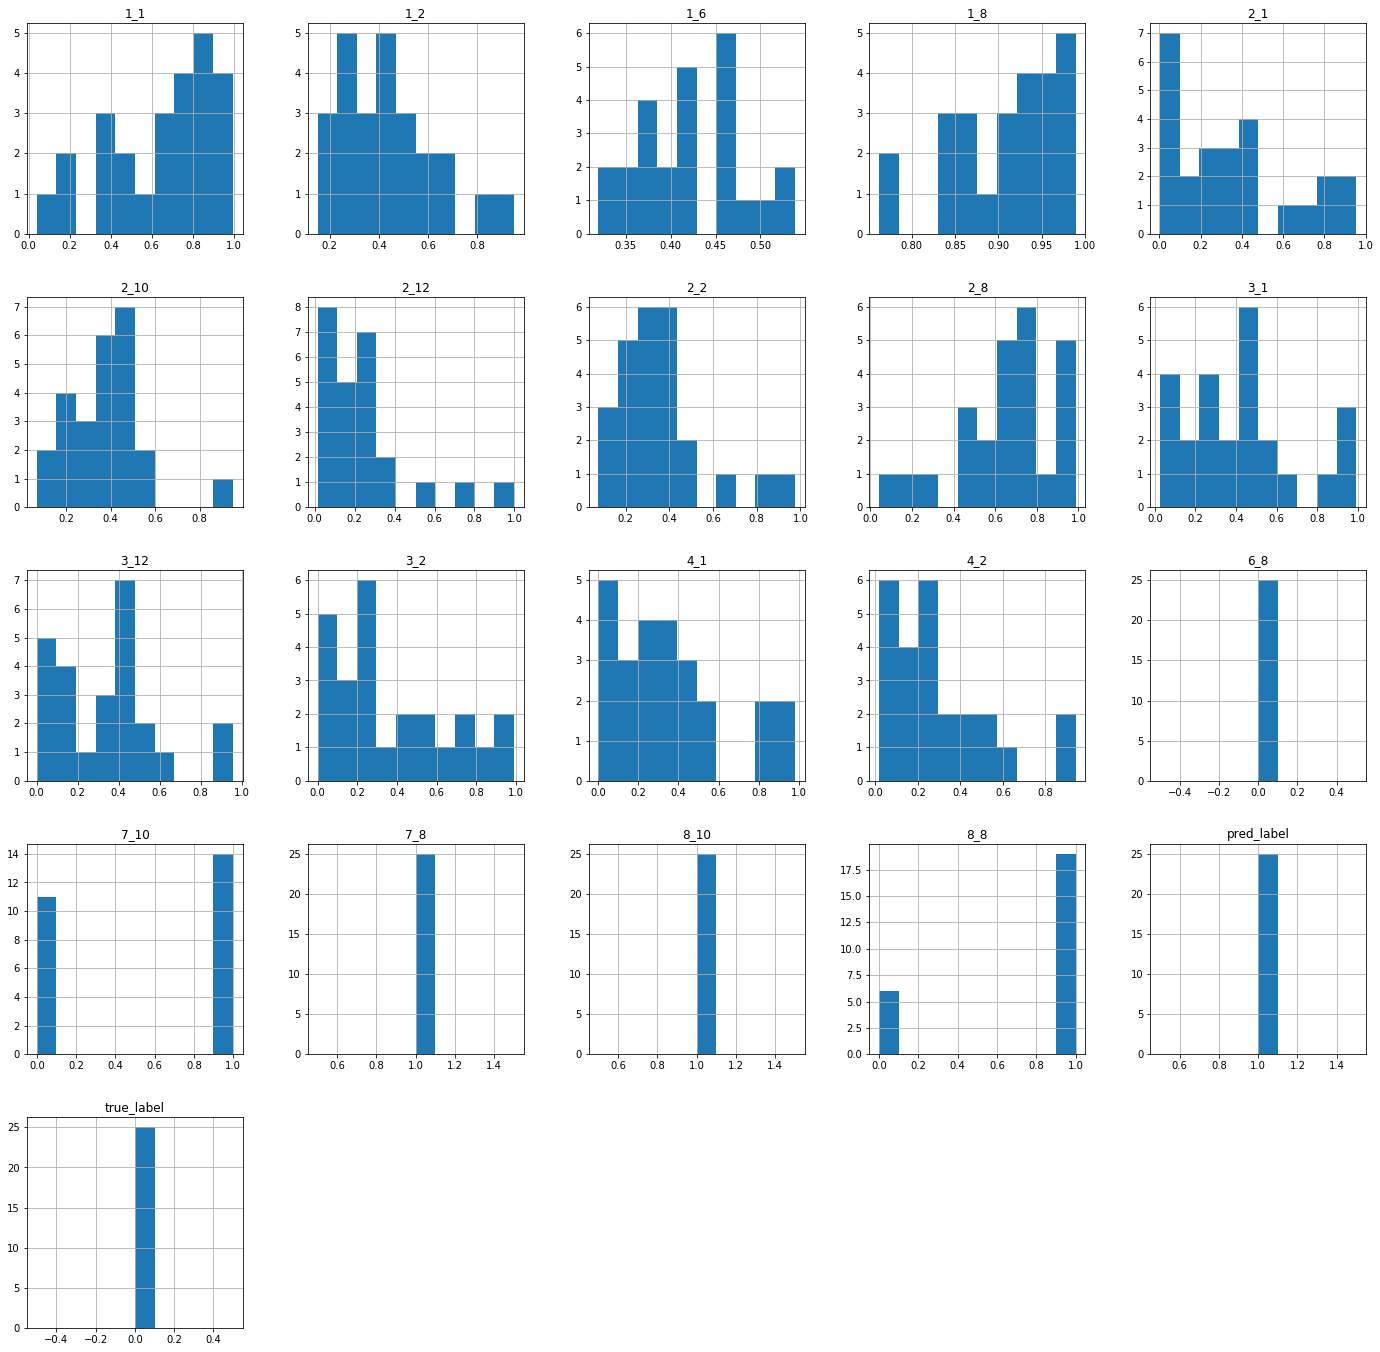

In [78]:
print_hist_models_predictions_fp(df_fp)

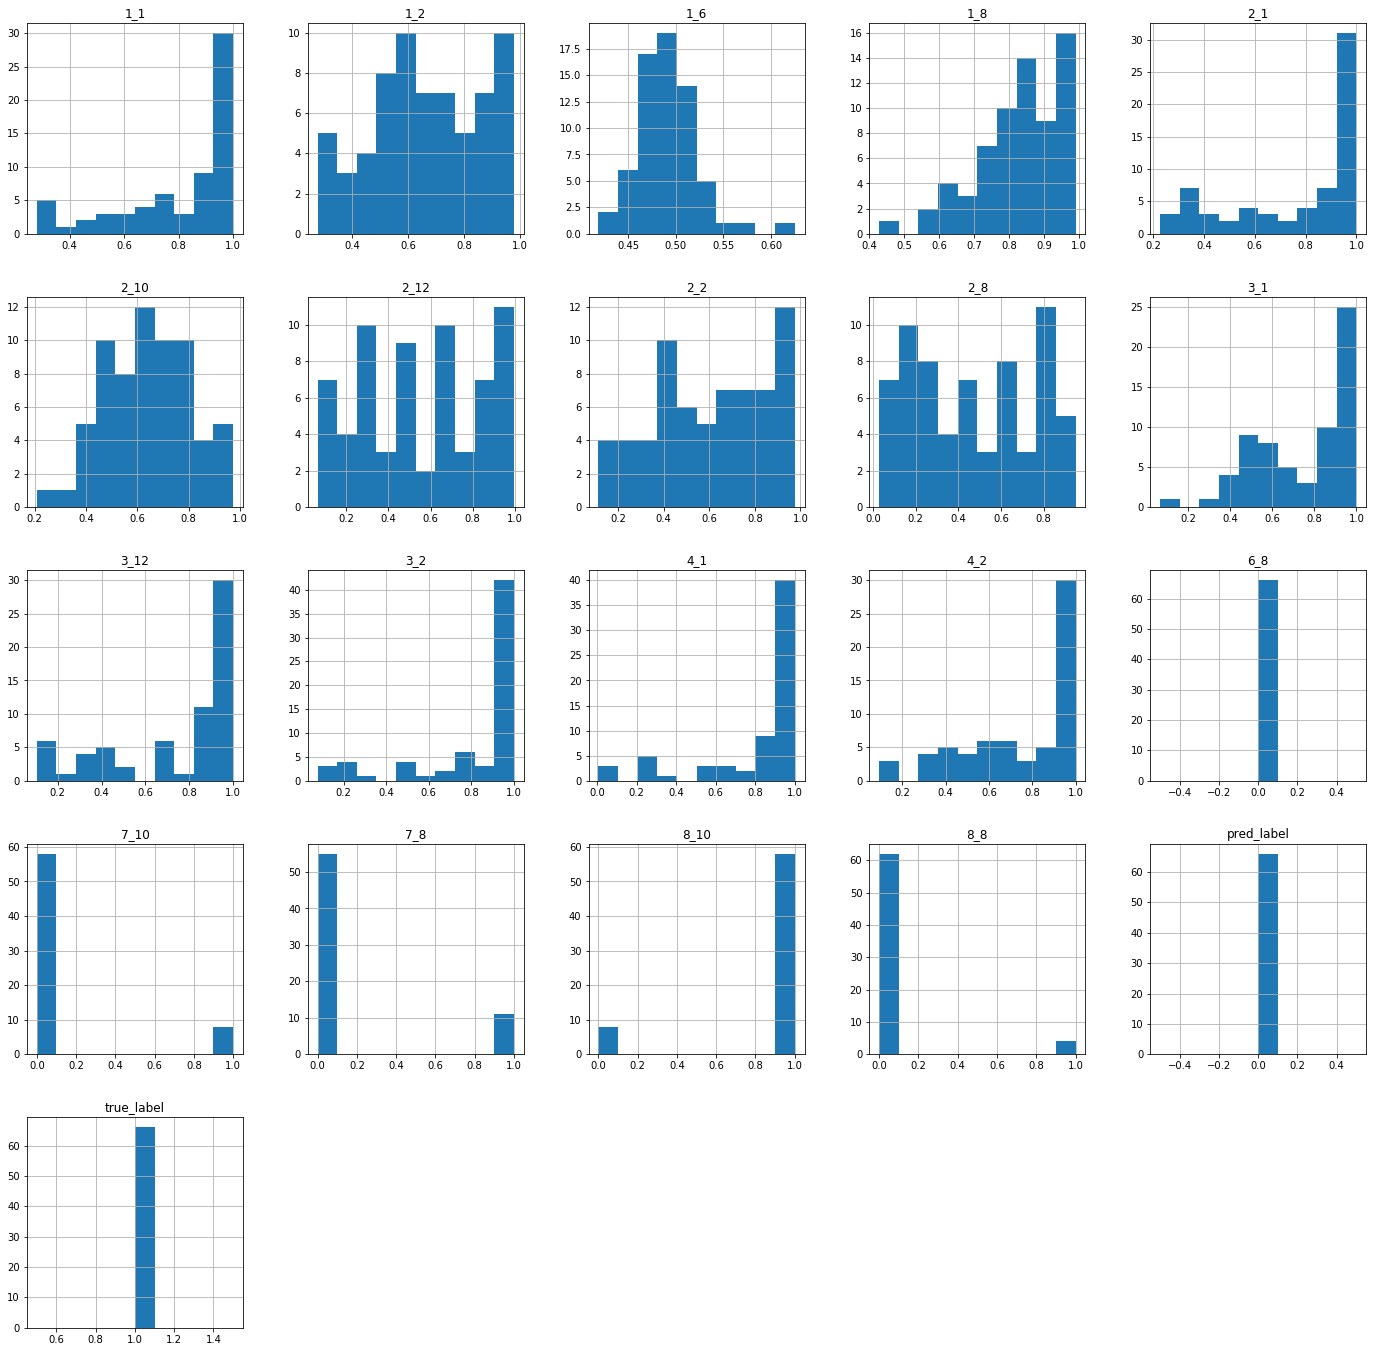

In [79]:
print_hist_models_predictions_fn(df_fn)

In [80]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.57      0.78      0.66       112
           1       0.71      0.48      0.58       128

    accuracy                           0.62       240
   macro avg       0.64      0.63      0.62       240
weighted avg       0.65      0.62      0.61       240



In [81]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/avg_validation_1_threshold_0_5.csv"
df_res.to_csv(csv_path)

# Validation 2 - ALL DATASETS

We use the same code of the main.py of the real application, without VAD module

In [82]:
predictions, model_prediction_list = make_predictions(validation_dataset_2, labels_2, prediction_scheme='avg_pred')

  0%|          | 1/2000 [00:14<8:12:14, 14.77s/it]

[0.21641621, 0.5239922, 0.58158255, 0.30858582, 0.6508572, 0.041726768, 0.04238221, 0.4568143, 0.14644936, 0.83928454, 0.051340163, 0.15365446, 0.5220866, 0.76291114, 1, 1, 0, 0, 1]
pred conv [0.21641621, 0.5239922, 0.58158255, 0.30858582, 0.6508572, 0.041726768, 0.04238221, 0.4568143, 0.14644936, 0.83928454, 0.051340163, 0.15365446, 0.5220866, 0.76291114] pred svm [1, 1, 0, 0, 1, 0.37843453671251026] avg_prediction_conv 0.37843453671251026 new pred [1, 1, 0, 0, 1, 0.37843453671251026]
True label 0 Predicted label 1


  0%|          | 2/2000 [00:30<8:23:45, 15.13s/it]

[0.23881468, 0.23238978, 0.47837257, 0.1241442, 0.22217038, 0.037085086, 0.43766502, 0.14850745, 0.12050754, 0.8437903, 0.008586615, 0.108226925, 0.49480218, 0.37511432, 1, 0, 0, 0, 0]
pred conv [0.23881468, 0.23238978, 0.47837257, 0.1241442, 0.22217038, 0.037085086, 0.43766502, 0.14850745, 0.12050754, 0.8437903, 0.008586615, 0.108226925, 0.49480218, 0.37511432] pred svm [1, 0, 0, 0, 0, 0.27644121646881104] avg_prediction_conv 0.27644121646881104 new pred [1, 0, 0, 0, 0, 0.27644121646881104]
True label 0 Predicted label 0


  0%|          | 3/2000 [00:47<8:37:40, 15.55s/it]

[0.8773644, 0.53234464, 0.6920152, 0.54796445, 0.61923593, 0.39383936, 0.071415395, 0.62995994, 0.33759505, 0.7763002, 0.30539095, 0.26301914, 0.4674505, 0.93526584, 1, 1, 0, 0, 0]
pred conv [0.8773644, 0.53234464, 0.6920152, 0.54796445, 0.61923593, 0.39383936, 0.071415395, 0.62995994, 0.33759505, 0.7763002, 0.30539095, 0.26301914, 0.4674505, 0.93526584] pred svm [1, 1, 0, 0, 0, 0.5320829259497779] avg_prediction_conv 0.5320829259497779 new pred [1, 1, 0, 0, 0, 0.5320829259497779]
True label 1 Predicted label 0


  0%|          | 4/2000 [01:02<8:29:35, 15.32s/it]

[0.9998362, 0.968698, 0.91645896, 0.99755514, 0.87495863, 0.99896526, 0.38121837, 0.99931574, 0.9966487, 0.942219, 0.99973285, 0.9604449, 0.52000153, 0.9981333, 0, 1, 0, 1, 0]
pred conv [0.9998362, 0.968698, 0.91645896, 0.99755514, 0.87495863, 0.99896526, 0.38121837, 0.99931574, 0.9966487, 0.942219, 0.99973285, 0.9604449, 0.52000153, 0.9981333] pred svm [0, 1, 0, 1, 0, 0.8967276215553284] avg_prediction_conv 0.8967276215553284 new pred [0, 1, 0, 1, 0, 0.8967276215553284]
True label 1 Predicted label 0


  0%|          | 5/2000 [01:19<8:54:36, 16.08s/it]

[0.9999989, 0.8537375, 0.8035034, 0.99833333, 0.74785537, 0.99710554, 0.43392307, 0.99758154, 0.9980047, 0.8524585, 0.99822825, 0.93465877, 0.500275, 0.95345104, 0, 1, 0, 1, 0]
pred conv [0.9999989, 0.8537375, 0.8035034, 0.99833333, 0.74785537, 0.99710554, 0.43392307, 0.99758154, 0.9980047, 0.8524585, 0.99822825, 0.93465877, 0.500275, 0.95345104] pred svm [0, 1, 0, 1, 0, 0.862079633133752] avg_prediction_conv 0.862079633133752 new pred [0, 1, 0, 1, 0, 0.862079633133752]
True label 1 Predicted label 0


  0%|          | 6/2000 [01:35<8:54:33, 16.09s/it]

[0.875298, 0.6432744, 0.5637859, 0.5581343, 0.64597964, 0.6435024, 0.18371856, 0.6877435, 0.9017129, 0.42770544, 0.75098974, 0.5068263, 0.5078153, 0.8467647, 0, 1, 0, 0, 0]
pred conv [0.875298, 0.6432744, 0.5637859, 0.5581343, 0.64597964, 0.6435024, 0.18371856, 0.6877435, 0.9017129, 0.42770544, 0.75098974, 0.5068263, 0.5078153, 0.8467647] pred svm [0, 1, 0, 0, 0, 0.6245179367916924] avg_prediction_conv 0.6245179367916924 new pred [0, 1, 0, 0, 0, 0.6245179367916924]
True label 1 Predicted label 0


  0%|          | 7/2000 [01:51<8:52:15, 16.02s/it]

[0.09932616, 0.1290468, 0.3864693, 0.5416309, 0.37028164, 0.70037454, 0.7512245, 0.31902233, 0.3363034, 0.7805269, 0.1565915, 0.36729842, 0.44491675, 0.55312234, 1, 0, 0, 0, 1]
pred conv [0.09932616, 0.1290468, 0.3864693, 0.5416309, 0.37028164, 0.70037454, 0.7512245, 0.31902233, 0.3363034, 0.7805269, 0.1565915, 0.36729842, 0.44491675, 0.55312234] pred svm [1, 0, 0, 0, 1, 0.42400968074798584] avg_prediction_conv 0.42400968074798584 new pred [1, 0, 0, 0, 1, 0.42400968074798584]
True label 1 Predicted label 0


  0%|          | 8/2000 [02:07<8:45:25, 15.83s/it]

[0.29147953, 0.35309082, 0.7915098, 0.3572646, 0.6096548, 0.4179651, 0.6114118, 0.91789085, 0.5172618, 0.8075999, 0.077617526, 0.16500932, 0.47724432, 0.9611747, 0, 1, 0, 0, 0]
pred conv [0.29147953, 0.35309082, 0.7915098, 0.3572646, 0.6096548, 0.4179651, 0.6114118, 0.91789085, 0.5172618, 0.8075999, 0.077617526, 0.16500932, 0.47724432, 0.9611747] pred svm [0, 1, 0, 0, 0, 0.5254410654306412] avg_prediction_conv 0.5254410654306412 new pred [0, 1, 0, 0, 0, 0.5254410654306412]
True label 1 Predicted label 0


  0%|          | 9/2000 [02:23<8:48:52, 15.94s/it]

[0.9999833, 0.9632569, 0.65962887, 0.9987427, 0.97985405, 0.991269, 0.23816392, 0.999863, 0.9839262, 0.71100813, 0.9999816, 0.7604708, 0.4767112, 0.99934244, 0, 0, 0, 0, 0]
pred conv [0.9999833, 0.9632569, 0.65962887, 0.9987427, 0.97985405, 0.991269, 0.23816392, 0.999863, 0.9839262, 0.71100813, 0.9999816, 0.7604708, 0.4767112, 0.99934244] pred svm [0, 0, 0, 0, 0, 0.840157293847629] avg_prediction_conv 0.840157293847629 new pred [0, 0, 0, 0, 0, 0.840157293847629]
True label 1 Predicted label 0


  0%|          | 10/2000 [02:39<8:45:57, 15.86s/it]

[0.89383864, 0.27684343, 0.49508628, 0.8727783, 0.6761825, 0.5223466, 0.086230814, 0.9241447, 0.72793573, 0.61534613, 0.9316283, 0.18844497, 0.46786433, 0.7138615, 0, 1, 0, 0, 0]
pred conv [0.89383864, 0.27684343, 0.49508628, 0.8727783, 0.6761825, 0.5223466, 0.086230814, 0.9241447, 0.72793573, 0.61534613, 0.9316283, 0.18844497, 0.46786433, 0.7138615] pred svm [0, 1, 0, 0, 0, 0.5994665899447033] avg_prediction_conv 0.5994665899447033 new pred [0, 1, 0, 0, 0, 0.5994665899447033]
True label 1 Predicted label 0


  1%|          | 11/2000 [02:55<8:51:30, 16.03s/it]

[0.007938176, 0.18022609, 0.22285742, 0.32732117, 0.14466563, 0.081315875, 0.013608873, 0.16794026, 0.060610563, 0.79741, 0.012480378, 0.13118204, 0.49185154, 0.4786618, 1, 1, 0, 0, 0]
pred conv [0.007938176, 0.18022609, 0.22285742, 0.32732117, 0.14466563, 0.081315875, 0.013608873, 0.16794026, 0.060610563, 0.79741, 0.012480378, 0.13118204, 0.49185154, 0.4786618] pred svm [1, 1, 0, 0, 0, 0.22271927339690073] avg_prediction_conv 0.22271927339690073 new pred [1, 1, 0, 0, 0, 0.22271927339690073]
True label 0 Predicted label 0


  1%|          | 12/2000 [03:10<8:42:16, 15.76s/it]

[0.00016397238, 0.082203895, 0.39551663, 0.050910264, 0.18279889, 0.012466013, 0.37449914, 0.07903898, 0.0664936, 0.74493265, 0.0003992319, 0.01046741, 0.42332953, 0.8698976, 0, 1, 0, 0, 0]
pred conv [0.00016397238, 0.082203895, 0.39551663, 0.050910264, 0.18279889, 0.012466013, 0.37449914, 0.07903898, 0.0664936, 0.74493265, 0.0003992319, 0.01046741, 0.42332953, 0.8698976] pred svm [0, 1, 0, 0, 0, 0.23522270151547023] avg_prediction_conv 0.23522270151547023 new pred [0, 1, 0, 0, 0, 0.23522270151547023]
True label 0 Predicted label 0


  1%|          | 13/2000 [03:25<8:36:35, 15.60s/it]

[0.0035049021, 0.10861117, 0.5477941, 0.15144655, 0.304519, 0.01757142, 0.34464282, 0.06449264, 0.1808863, 0.4987303, 0.20573708, 0.20501599, 0.50753546, 0.5965286, 0, 0, 0, 0, 0]
pred conv [0.0035049021, 0.10861117, 0.5477941, 0.15144655, 0.304519, 0.01757142, 0.34464282, 0.06449264, 0.1808863, 0.4987303, 0.20573708, 0.20501599, 0.50753546, 0.5965286] pred svm [0, 0, 0, 0, 0, 0.26692973715918406] avg_prediction_conv 0.26692973715918406 new pred [0, 0, 0, 0, 0, 0.26692973715918406]
True label 0 Predicted label 0


  1%|          | 14/2000 [03:42<8:45:47, 15.88s/it]

[0.004057348, 0.044844687, 0.14799494, 0.29980865, 0.2621013, 0.0029592812, 0.30463743, 0.06613684, 0.31162086, 0.74084127, 0.0055773854, 0.11109111, 0.416793, 0.8163753, 1, 0, 0, 0, 1]
pred conv [0.004057348, 0.044844687, 0.14799494, 0.29980865, 0.2621013, 0.0029592812, 0.30463743, 0.06613684, 0.31162086, 0.74084127, 0.0055773854, 0.11109111, 0.416793, 0.8163753] pred svm [1, 0, 0, 0, 1, 0.2524885279791696] avg_prediction_conv 0.2524885279791696 new pred [1, 0, 0, 0, 1, 0.2524885279791696]
True label 0 Predicted label 0


  1%|          | 15/2000 [03:57<8:34:52, 15.56s/it]

[0.0013813078, 0.072069556, 0.080460995, 0.12834236, 0.26433092, 0.019417912, 0.47522533, 0.044494957, 0.101769924, 0.88245064, 0.009978384, 0.01938954, 0.47602114, 0.6462381, 1, 0, 0, 0, 1]
pred conv [0.0013813078, 0.072069556, 0.080460995, 0.12834236, 0.26433092, 0.019417912, 0.47522533, 0.044494957, 0.101769924, 0.88245064, 0.009978384, 0.01938954, 0.47602114, 0.6462381] pred svm [1, 0, 0, 0, 1, 0.23011221843106405] avg_prediction_conv 0.23011221843106405 new pred [1, 0, 0, 0, 1, 0.23011221843106405]
True label 0 Predicted label 0


  1%|          | 16/2000 [04:13<8:38:25, 15.68s/it]

[0.009613156, 0.06994343, 0.2482191, 0.03483677, 0.09298572, 0.043678492, 0.22160918, 0.037418425, 0.03565991, 0.85243356, 0.0018900633, 0.088498235, 0.4537289, 0.23407376, 0, 1, 0, 0, 0]
pred conv [0.009613156, 0.06994343, 0.2482191, 0.03483677, 0.09298572, 0.043678492, 0.22160918, 0.037418425, 0.03565991, 0.85243356, 0.0018900633, 0.088498235, 0.4537289, 0.23407376] pred svm [0, 1, 0, 0, 0, 0.17318490786211832] avg_prediction_conv 0.17318490786211832 new pred [0, 1, 0, 0, 0, 0.17318490786211832]
True label 0 Predicted label 0


  1%|          | 17/2000 [04:28<8:35:46, 15.61s/it]

[0.0005084574, 0.03977865, 0.09389454, 0.023767501, 0.09259054, 0.0009531975, 0.11230618, 0.020337373, 0.0062763095, 0.77906924, 0.00021108985, 0.0047115386, 0.45932144, 0.52435493, 1, 1, 0, 0, 0]
pred conv [0.0005084574, 0.03977865, 0.09389454, 0.023767501, 0.09259054, 0.0009531975, 0.11230618, 0.020337373, 0.0062763095, 0.77906924, 0.00021108985, 0.0047115386, 0.45932144, 0.52435493] pred svm [1, 1, 0, 0, 0, 0.15414864250591823] avg_prediction_conv 0.15414864250591823 new pred [1, 1, 0, 0, 0, 0.15414864250591823]
True label 0 Predicted label 0


  1%|          | 18/2000 [04:44<8:41:43, 15.79s/it]

[0.0023641884, 0.106321186, 0.14060056, 0.35770988, 0.35342836, 0.020763665, 0.42648804, 0.045330197, 0.032136977, 0.80124605, 0.002831161, 0.02366066, 0.45791817, 0.95714307, 1, 0, 0, 0, 1]
pred conv [0.0023641884, 0.106321186, 0.14060056, 0.35770988, 0.35342836, 0.020763665, 0.42648804, 0.045330197, 0.032136977, 0.80124605, 0.002831161, 0.02366066, 0.45791817, 0.95714307] pred svm [1, 0, 0, 0, 1, 0.26628158347947256] avg_prediction_conv 0.26628158347947256 new pred [1, 0, 0, 0, 1, 0.26628158347947256]
True label 0 Predicted label 0


  1%|          | 19/2000 [05:01<8:45:42, 15.92s/it]

[0.0046785176, 0.049465477, 0.244396, 0.05967331, 0.12516552, 0.02351737, 0.21561953, 0.026587248, 0.30493587, 0.73881435, 0.0017937422, 0.015236139, 0.46074024, 0.08052993, 0, 1, 0, 0, 0]
pred conv [0.0046785176, 0.049465477, 0.244396, 0.05967331, 0.12516552, 0.02351737, 0.21561953, 0.026587248, 0.30493587, 0.73881435, 0.0017937422, 0.015236139, 0.46074024, 0.08052993] pred svm [0, 1, 0, 0, 0, 0.1679395181792123] avg_prediction_conv 0.1679395181792123 new pred [0, 1, 0, 0, 0, 0.1679395181792123]
True label 0 Predicted label 0


  1%|          | 20/2000 [05:16<8:41:06, 15.79s/it]

[0.0028773546, 0.025414884, 0.3727333, 0.0346314, 0.047501206, 0.02590856, 0.91136074, 0.035298675, 0.27012557, 0.93626463, 0.017173737, 0.04159707, 0.4366059, 0.21820289, 1, 0, 0, 0, 1]
pred conv [0.0028773546, 0.025414884, 0.3727333, 0.0346314, 0.047501206, 0.02590856, 0.91136074, 0.035298675, 0.27012557, 0.93626463, 0.017173737, 0.04159707, 0.4366059, 0.21820289] pred svm [1, 0, 0, 0, 1, 0.24112113671643393] avg_prediction_conv 0.24112113671643393 new pred [1, 0, 0, 0, 1, 0.24112113671643393]
True label 0 Predicted label 0


  1%|          | 21/2000 [05:32<8:41:14, 15.80s/it]

[0.2606861, 0.6103396, 0.68717843, 0.48564124, 0.62311995, 0.20328525, 0.50123537, 0.50250226, 0.33484936, 0.7076485, 0.13447553, 0.28722864, 0.4922103, 0.88710666, 1, 1, 0, 0, 0]
pred conv [0.2606861, 0.6103396, 0.68717843, 0.48564124, 0.62311995, 0.20328525, 0.50123537, 0.50250226, 0.33484936, 0.7076485, 0.13447553, 0.28722864, 0.4922103, 0.88710666] pred svm [1, 1, 0, 0, 0, 0.4798219416822706] avg_prediction_conv 0.4798219416822706 new pred [1, 1, 0, 0, 0, 0.4798219416822706]
True label 0 Predicted label 0


  1%|          | 22/2000 [05:47<8:34:13, 15.60s/it]

[0.100130886, 0.14164662, 0.44266382, 0.10507378, 0.12630635, 0.0110832155, 0.076440424, 0.032206625, 0.016210526, 0.7882656, 0.0019490719, 0.037200034, 0.48874813, 0.46452522, 1, 1, 0, 0, 0]
pred conv [0.100130886, 0.14164662, 0.44266382, 0.10507378, 0.12630635, 0.0110832155, 0.076440424, 0.032206625, 0.016210526, 0.7882656, 0.0019490719, 0.037200034, 0.48874813, 0.46452522] pred svm [1, 1, 0, 0, 0, 0.20231787860393524] avg_prediction_conv 0.20231787860393524 new pred [1, 1, 0, 0, 0, 0.20231787860393524]
True label 0 Predicted label 0


  1%|          | 23/2000 [06:03<8:38:06, 15.72s/it]

[0.9998626, 0.9509872, 0.8373591, 0.99714, 0.89648867, 0.9978381, 0.14547032, 0.9973928, 0.9943133, 0.7748785, 0.9994203, 0.9286625, 0.49976093, 0.9945072, 0, 1, 0, 0, 0]
pred conv [0.9998626, 0.9509872, 0.8373591, 0.99714, 0.89648867, 0.9978381, 0.14547032, 0.9973928, 0.9943133, 0.7748785, 0.9994203, 0.9286625, 0.49976093, 0.9945072] pred svm [0, 1, 0, 0, 0, 0.858148672751018] avg_prediction_conv 0.858148672751018 new pred [0, 1, 0, 0, 0, 0.858148672751018]
True label 1 Predicted label 0


  1%|          | 24/2000 [06:19<8:35:13, 15.64s/it]

[0.81787, 0.39050132, 0.6356747, 0.50519055, 0.38457906, 0.53273755, 0.5090458, 0.72632587, 0.46834862, 0.8903112, 0.90635145, 0.65314347, 0.49348733, 0.5819799, 0, 1, 0, 0, 0]
pred conv [0.81787, 0.39050132, 0.6356747, 0.50519055, 0.38457906, 0.53273755, 0.5090458, 0.72632587, 0.46834862, 0.8903112, 0.90635145, 0.65314347, 0.49348733, 0.5819799] pred svm [0, 1, 0, 0, 0, 0.6068247705698013] avg_prediction_conv 0.6068247705698013 new pred [0, 1, 0, 0, 0, 0.6068247705698013]
True label 1 Predicted label 0


  1%|▏         | 25/2000 [06:34<8:35:42, 15.67s/it]

[0.60470176, 0.58450025, 0.6725246, 0.38998657, 0.53628653, 0.31873935, 0.083329916, 0.81814575, 0.109396875, 0.8058043, 0.19686398, 0.43859276, 0.5292733, 0.8730811, 0, 1, 0, 0, 0]
pred conv [0.60470176, 0.58450025, 0.6725246, 0.38998657, 0.53628653, 0.31873935, 0.083329916, 0.81814575, 0.109396875, 0.8058043, 0.19686398, 0.43859276, 0.5292733, 0.8730811] pred svm [0, 1, 0, 0, 0, 0.49723049998283386] avg_prediction_conv 0.49723049998283386 new pred [0, 1, 0, 0, 0, 0.49723049998283386]
True label 1 Predicted label 0


  1%|▏         | 26/2000 [06:50<8:36:09, 15.69s/it]

[0.99631006, 0.9417774, 0.9358155, 0.6566783, 0.81256545, 0.98361033, 0.87062, 0.99838907, 0.5879277, 0.9119197, 0.8662169, 0.8068817, 0.5212541, 0.9841045, 1, 1, 0, 0, 1]
pred conv [0.99631006, 0.9417774, 0.9358155, 0.6566783, 0.81256545, 0.98361033, 0.87062, 0.99838907, 0.5879277, 0.9119197, 0.8662169, 0.8068817, 0.5212541, 0.9841045] pred svm [1, 1, 0, 0, 1, 0.8481479159423283] avg_prediction_conv 0.8481479159423283 new pred [1, 1, 0, 0, 1, 0.8481479159423283]
True label 1 Predicted label 1


  1%|▏         | 27/2000 [07:05<8:34:13, 15.64s/it]

[0.994912, 0.88187873, 0.6755935, 0.9802916, 0.92234796, 0.9381533, 0.229067, 0.99333763, 0.87561804, 0.7029169, 0.99715966, 0.62797135, 0.47245717, 0.9988061, 0, 1, 0, 0, 0]
pred conv [0.994912, 0.88187873, 0.6755935, 0.9802916, 0.92234796, 0.9381533, 0.229067, 0.99333763, 0.87561804, 0.7029169, 0.99715966, 0.62797135, 0.47245717, 0.9988061] pred svm [0, 1, 0, 0, 0, 0.8064650744199753] avg_prediction_conv 0.8064650744199753 new pred [0, 1, 0, 0, 0, 0.8064650744199753]
True label 1 Predicted label 0


  1%|▏         | 28/2000 [07:21<8:36:44, 15.72s/it]

[0.060488284, 0.24807909, 0.3124246, 0.5234891, 0.3979897, 0.4574497, 0.7929969, 0.3188455, 0.8247632, 0.93841654, 0.669557, 0.13260904, 0.46458143, 0.87434137, 1, 1, 0, 0, 1]
pred conv [0.060488284, 0.24807909, 0.3124246, 0.5234891, 0.3979897, 0.4574497, 0.7929969, 0.3188455, 0.8247632, 0.93841654, 0.669557, 0.13260904, 0.46458143, 0.87434137] pred svm [1, 1, 0, 0, 1, 0.5011451010193143] avg_prediction_conv 0.5011451010193143 new pred [1, 1, 0, 0, 1, 0.5011451010193143]
True label 1 Predicted label 1


  1%|▏         | 29/2000 [07:37<8:32:55, 15.61s/it]

[0.24694729, 0.5003193, 0.564107, 0.59108895, 0.5846003, 0.32902646, 0.16366991, 0.9555172, 0.12974739, 0.6564417, 0.20729846, 0.21750659, 0.50242937, 0.7271526, 0, 1, 0, 0, 0]
pred conv [0.24694729, 0.5003193, 0.564107, 0.59108895, 0.5846003, 0.32902646, 0.16366991, 0.9555172, 0.12974739, 0.6564417, 0.20729846, 0.21750659, 0.50242937, 0.7271526] pred svm [0, 1, 0, 0, 0, 0.45541803538799286] avg_prediction_conv 0.45541803538799286 new pred [0, 1, 0, 0, 0, 0.45541803538799286]
True label 1 Predicted label 0


  2%|▏         | 30/2000 [07:52<8:28:50, 15.50s/it]

[0.9873757, 0.8043901, 0.7469157, 0.65376616, 0.7747524, 0.94111437, 0.66825926, 0.91410154, 0.84510505, 0.8109822, 0.9739636, 0.4397444, 0.47377414, 0.9780086, 0, 0, 0, 0, 0]
pred conv [0.9873757, 0.8043901, 0.7469157, 0.65376616, 0.7747524, 0.94111437, 0.66825926, 0.91410154, 0.84510505, 0.8109822, 0.9739636, 0.4397444, 0.47377414, 0.9780086] pred svm [0, 0, 0, 0, 0, 0.7865895160606929] avg_prediction_conv 0.7865895160606929 new pred [0, 0, 0, 0, 0, 0.7865895160606929]
True label 1 Predicted label 0


  2%|▏         | 31/2000 [08:07<8:26:36, 15.44s/it]

[0.006125152, 0.06384799, 0.15045515, 0.1431939, 0.19977576, 0.0014824569, 0.1732724, 0.023329139, 0.10453138, 0.8550251, 0.001939863, 0.028170645, 0.45231664, 0.35925806, 1, 0, 0, 0, 1]
pred conv [0.006125152, 0.06384799, 0.15045515, 0.1431939, 0.19977576, 0.0014824569, 0.1732724, 0.023329139, 0.10453138, 0.8550251, 0.001939863, 0.028170645, 0.45231664, 0.35925806] pred svm [1, 0, 0, 0, 1, 0.18305168833051408] avg_prediction_conv 0.18305168833051408 new pred [1, 0, 0, 0, 1, 0.18305168833051408]
True label 0 Predicted label 0


  2%|▏         | 32/2000 [08:23<8:32:09, 15.61s/it]

[0.00050005317, 0.0911946, 0.1776807, 0.11124295, 0.2394697, 0.0032182336, 0.22696653, 0.024733275, 0.12448043, 0.84871954, 0.009555012, 0.057560086, 0.4525851, 0.7545321, 1, 0, 0, 0, 1]
pred conv [0.00050005317, 0.0911946, 0.1776807, 0.11124295, 0.2394697, 0.0032182336, 0.22696653, 0.024733275, 0.12448043, 0.84871954, 0.009555012, 0.057560086, 0.4525851, 0.7545321] pred svm [1, 0, 0, 0, 1, 0.22303130796977452] avg_prediction_conv 0.22303130796977452 new pred [1, 0, 0, 0, 1, 0.22303130796977452]
True label 0 Predicted label 0


  2%|▏         | 33/2000 [08:39<8:27:58, 15.50s/it]

[0.0026976168, 0.18960431, 0.652476, 0.07853204, 0.471629, 0.02218467, 0.5640219, 0.03569165, 0.47103044, 0.8201511, 0.0184592, 0.14246482, 0.48213518, 0.92815214, 0, 0, 0, 0, 0]
pred conv [0.0026976168, 0.18960431, 0.652476, 0.07853204, 0.471629, 0.02218467, 0.5640219, 0.03569165, 0.47103044, 0.8201511, 0.0184592, 0.14246482, 0.48213518, 0.92815214] pred svm [0, 0, 0, 0, 0, 0.34851643230233875] avg_prediction_conv 0.34851643230233875 new pred [0, 0, 0, 0, 0, 0.34851643230233875]
True label 0 Predicted label 0


  2%|▏         | 34/2000 [08:56<8:42:47, 15.95s/it]

[0.00057801604, 0.080833286, 0.32990804, 0.024254084, 0.13013229, 0.016676217, 0.21290016, 0.069609016, 0.015630454, 0.72995687, 7.1432085e-05, 0.034211397, 0.42092192, 0.2971077, 1, 1, 0, 0, 0]
pred conv [0.00057801604, 0.080833286, 0.32990804, 0.024254084, 0.13013229, 0.016676217, 0.21290016, 0.069609016, 0.015630454, 0.72995687, 7.1432085e-05, 0.034211397, 0.42092192, 0.2971077] pred svm [1, 1, 0, 0, 0, 0.16877077703611576] avg_prediction_conv 0.16877077703611576 new pred [1, 1, 0, 0, 0, 0.16877077703611576]
True label 0 Predicted label 0


  2%|▏         | 35/2000 [09:11<8:37:20, 15.80s/it]

[0.16299435, 0.100121915, 0.18942794, 0.38374925, 0.12377486, 0.102915585, 0.021066546, 0.085879, 0.0055887103, 0.87929237, 0.022185087, 0.079606384, 0.49276146, 0.44327903, 1, 1, 0, 0, 0]
pred conv [0.16299435, 0.100121915, 0.18942794, 0.38374925, 0.12377486, 0.102915585, 0.021066546, 0.085879, 0.0055887103, 0.87929237, 0.022185087, 0.079606384, 0.49276146, 0.44327903] pred svm [1, 1, 0, 0, 0, 0.22090303472110204] avg_prediction_conv 0.22090303472110204 new pred [1, 1, 0, 0, 0, 0.22090303472110204]
True label 0 Predicted label 0


  2%|▏         | 36/2000 [09:26<8:33:02, 15.67s/it]

[0.09454417, 0.055541426, 0.32224184, 0.09648144, 0.062886655, 0.14758039, 0.40481693, 0.015933782, 0.2837659, 0.7481515, 0.024262935, 0.00983876, 0.4672711, 0.0354667, 0, 1, 0, 0, 0]
pred conv [0.09454417, 0.055541426, 0.32224184, 0.09648144, 0.062886655, 0.14758039, 0.40481693, 0.015933782, 0.2837659, 0.7481515, 0.024262935, 0.00983876, 0.4672711, 0.0354667] pred svm [0, 1, 0, 0, 0, 0.19777025069509233] avg_prediction_conv 0.19777025069509233 new pred [0, 1, 0, 0, 0, 0.19777025069509233]
True label 0 Predicted label 0


  2%|▏         | 37/2000 [09:42<8:27:46, 15.52s/it]

[0.17183965, 0.31836677, 0.6341913, 0.3720193, 0.46409923, 0.08160013, 0.033450574, 0.33644277, 0.076660454, 0.8286736, 0.02959311, 0.13098657, 0.5126872, 0.8486316, 1, 1, 0, 0, 0]
pred conv [0.17183965, 0.31836677, 0.6341913, 0.3720193, 0.46409923, 0.08160013, 0.033450574, 0.33644277, 0.076660454, 0.8286736, 0.02959311, 0.13098657, 0.5126872, 0.8486316] pred svm [1, 1, 0, 0, 0, 0.3456601606948035] avg_prediction_conv 0.3456601606948035 new pred [1, 1, 0, 0, 0, 0.3456601606948035]
True label 0 Predicted label 0


  2%|▏         | 38/2000 [09:58<8:31:46, 15.65s/it]

[0.8201847, 0.32969147, 0.48572183, 0.5666899, 0.49135628, 0.6372207, 0.029443264, 0.88429356, 0.454054, 0.7376634, 0.8093833, 0.0630689, 0.5260394, 0.32004133, 0, 1, 0, 0, 0]
pred conv [0.8201847, 0.32969147, 0.48572183, 0.5666899, 0.49135628, 0.6372207, 0.029443264, 0.88429356, 0.454054, 0.7376634, 0.8093833, 0.0630689, 0.5260394, 0.32004133] pred svm [0, 1, 0, 0, 0, 0.5110608573470797] avg_prediction_conv 0.5110608573470797 new pred [0, 1, 0, 0, 0, 0.5110608573470797]
True label 1 Predicted label 0


  2%|▏         | 39/2000 [10:13<8:34:20, 15.74s/it]

[0.99994636, 0.8942379, 0.729488, 0.998664, 0.9588661, 0.98673105, 0.42550346, 0.9971291, 0.99148977, 0.75553274, 0.99997795, 0.66305506, 0.48440617, 0.9993045, 0, 0, 0, 0, 0]
pred conv [0.99994636, 0.8942379, 0.729488, 0.998664, 0.9588661, 0.98673105, 0.42550346, 0.9971291, 0.99148977, 0.75553274, 0.99997795, 0.66305506, 0.48440617, 0.9993045] pred svm [0, 0, 0, 0, 0, 0.8488808678729194] avg_prediction_conv 0.8488808678729194 new pred [0, 0, 0, 0, 0, 0.8488808678729194]
True label 1 Predicted label 0


  2%|▏         | 40/2000 [10:28<8:27:10, 15.53s/it]

[0.25732917, 0.7377053, 0.7120875, 0.48099735, 0.7756579, 0.5638784, 0.2643259, 0.953649, 0.7170125, 0.72334784, 0.739306, 0.48540118, 0.49365932, 0.9903592, 0, 1, 0, 0, 0]
pred conv [0.25732917, 0.7377053, 0.7120875, 0.48099735, 0.7756579, 0.5638784, 0.2643259, 0.953649, 0.7170125, 0.72334784, 0.739306, 0.48540118, 0.49365932, 0.9903592] pred svm [0, 1, 0, 0, 0, 0.6353368950741631] avg_prediction_conv 0.6353368950741631 new pred [0, 1, 0, 0, 0, 0.6353368950741631]
True label 1 Predicted label 0


  2%|▏         | 41/2000 [10:44<8:30:28, 15.63s/it]

[0.005808115, 0.30559564, 0.6236475, 0.25655323, 0.6533104, 0.15842074, 0.75894344, 0.32450888, 0.40465415, 0.90983635, 0.7401834, 0.6990674, 0.49030262, 0.90516424, 1, 0, 0, 0, 1]
pred conv [0.005808115, 0.30559564, 0.6236475, 0.25655323, 0.6533104, 0.15842074, 0.75894344, 0.32450888, 0.40465415, 0.90983635, 0.7401834, 0.6990674, 0.49030262, 0.90516424] pred svm [1, 0, 0, 0, 1, 0.5168568683522088] avg_prediction_conv 0.5168568683522088 new pred [1, 0, 0, 0, 1, 0.5168568683522088]
True label 1 Predicted label 0


  2%|▏         | 42/2000 [11:01<8:39:35, 15.92s/it]

[0.672971, 0.6297766, 0.5114843, 0.3667276, 0.5495603, 0.43407542, 0.2308774, 0.54532367, 0.14810732, 0.60518014, 0.5373724, 0.3381437, 0.50230217, 0.5663295, 0, 1, 0, 0, 0]
pred conv [0.672971, 0.6297766, 0.5114843, 0.3667276, 0.5495603, 0.43407542, 0.2308774, 0.54532367, 0.14810732, 0.60518014, 0.5373724, 0.3381437, 0.50230217, 0.5663295] pred svm [0, 1, 0, 0, 0, 0.47415939612048014] avg_prediction_conv 0.47415939612048014 new pred [0, 1, 0, 0, 0, 0.47415939612048014]
True label 1 Predicted label 0


  2%|▏         | 43/2000 [11:16<8:35:28, 15.80s/it]

[0.99966, 0.9042433, 0.8833838, 0.94598305, 0.8033445, 0.95394313, 0.6476992, 0.9990228, 0.6235001, 0.956673, 0.85575944, 0.95794666, 0.5119128, 0.99031615, 1, 1, 0, 1, 0]
pred conv [0.99966, 0.9042433, 0.8833838, 0.94598305, 0.8033445, 0.95394313, 0.6476992, 0.9990228, 0.6235001, 0.956673, 0.85575944, 0.95794666, 0.5119128, 0.99031615] pred svm [1, 1, 0, 1, 0, 0.8595277113573891] avg_prediction_conv 0.8595277113573891 new pred [1, 1, 0, 1, 0, 0.8595277113573891]
True label 1 Predicted label 1


  2%|▏         | 44/2000 [11:31<8:27:13, 15.56s/it]

[0.9999756, 0.95734894, 0.8098374, 0.99848104, 0.9133417, 0.9991759, 0.030195534, 0.9984577, 0.99569964, 0.7529937, 0.9998183, 0.9560088, 0.52419406, 0.99575037, 0, 1, 0, 0, 0]
pred conv [0.9999756, 0.95734894, 0.8098374, 0.99848104, 0.9133417, 0.9991759, 0.030195534, 0.9984577, 0.99569964, 0.7529937, 0.9998183, 0.9560088, 0.52419406, 0.99575037] pred svm [0, 1, 0, 0, 0, 0.8522341932569232] avg_prediction_conv 0.8522341932569232 new pred [0, 1, 0, 0, 0, 0.8522341932569232]
True label 1 Predicted label 0


  2%|▏         | 45/2000 [11:47<8:29:06, 15.62s/it]

[0.14490557, 0.2766102, 0.6296952, 0.30373266, 0.5475834, 0.18036586, 0.07998887, 0.1849623, 0.34721977, 0.83094215, 0.038769305, 0.27122396, 0.44493857, 0.6408688, 1, 1, 0, 0, 1]
pred conv [0.14490557, 0.2766102, 0.6296952, 0.30373266, 0.5475834, 0.18036586, 0.07998887, 0.1849623, 0.34721977, 0.83094215, 0.038769305, 0.27122396, 0.44493857, 0.6408688] pred svm [1, 1, 0, 0, 1, 0.3515576124191284] avg_prediction_conv 0.3515576124191284 new pred [1, 1, 0, 0, 1, 0.3515576124191284]
True label 1 Predicted label 1


  2%|▏         | 46/2000 [12:03<8:30:34, 15.68s/it]

[0.15596065, 0.23824236, 0.5883348, 0.24493459, 0.32114732, 0.03646499, 0.04002115, 0.26571882, 0.09651077, 0.6536682, 0.004074931, 0.20321766, 0.51599157, 0.8746606, 1, 1, 0, 0, 0]
pred conv [0.15596065, 0.23824236, 0.5883348, 0.24493459, 0.32114732, 0.03646499, 0.04002115, 0.26571882, 0.09651077, 0.6536682, 0.004074931, 0.20321766, 0.51599157, 0.8746606] pred svm [1, 1, 0, 0, 0, 0.3027820310422352] avg_prediction_conv 0.3027820310422352 new pred [1, 1, 0, 0, 0, 0.3027820310422352]
True label 0 Predicted label 0


  2%|▏         | 47/2000 [12:18<8:27:38, 15.60s/it]

[0.5392924, 0.70041853, 0.6744535, 0.578029, 0.73338956, 0.49726194, 0.380119, 0.41572496, 0.7301268, 0.80667925, 0.61624765, 0.41963407, 0.5347472, 0.90864265, 1, 0, 0, 0, 0]
pred conv [0.5392924, 0.70041853, 0.6744535, 0.578029, 0.73338956, 0.49726194, 0.380119, 0.41572496, 0.7301268, 0.80667925, 0.61624765, 0.41963407, 0.5347472, 0.90864265] pred svm [1, 0, 0, 0, 0, 0.6096261761018208] avg_prediction_conv 0.6096261761018208 new pred [1, 0, 0, 0, 0, 0.6096261761018208]
True label 0 Predicted label 0


  2%|▏         | 48/2000 [12:34<8:26:14, 15.56s/it]

[0.99990916, 0.97481966, 0.9279809, 0.9968758, 0.9667855, 0.9989364, 0.8210726, 0.9986113, 0.97266525, 0.8640428, 0.99763143, 0.93165433, 0.44807062, 0.99983495, 0, 1, 0, 0, 0]
pred conv [0.99990916, 0.97481966, 0.9279809, 0.9968758, 0.9667855, 0.9989364, 0.8210726, 0.9986113, 0.97266525, 0.8640428, 0.99763143, 0.93165433, 0.44807062, 0.99983495] pred svm [0, 1, 0, 0, 0, 0.9213493359940392] avg_prediction_conv 0.9213493359940392 new pred [0, 1, 0, 0, 0, 0.9213493359940392]
True label 1 Predicted label 0


  2%|▏         | 49/2000 [12:49<8:23:34, 15.49s/it]

[0.80202293, 0.41880265, 0.5416442, 0.7091162, 0.5437209, 0.7084291, 0.25836146, 0.83063114, 0.6855619, 0.80514675, 0.81104666, 0.12151986, 0.5236799, 0.33353204, 0, 1, 0, 0, 0]
pred conv [0.80202293, 0.41880265, 0.5416442, 0.7091162, 0.5437209, 0.7084291, 0.25836146, 0.83063114, 0.6855619, 0.80514675, 0.81104666, 0.12151986, 0.5236799, 0.33353204] pred svm [0, 1, 0, 0, 0, 0.5780868381261826] avg_prediction_conv 0.5780868381261826 new pred [0, 1, 0, 0, 0, 0.5780868381261826]
True label 1 Predicted label 0


  2%|▎         | 50/2000 [13:10<9:17:02, 17.14s/it]

[0.7180404, 0.38930497, 0.38086525, 0.6274003, 0.6621462, 0.5755408, 0.96188515, 0.8626667, 0.847045, 0.9562469, 0.9435537, 0.42821047, 0.4123849, 0.9908147, 1, 1, 0, 1, 1]
pred conv [0.7180404, 0.38930497, 0.38086525, 0.6274003, 0.6621462, 0.5755408, 0.96188515, 0.8626667, 0.847045, 0.9562469, 0.9435537, 0.42821047, 0.4123849, 0.9908147] pred svm [1, 1, 0, 1, 1, 0.6968646730695452] avg_prediction_conv 0.6968646730695452 new pred [1, 1, 0, 1, 1, 0.6968646730695452]
True label 1 Predicted label 1


  3%|▎         | 51/2000 [13:26<9:02:36, 16.70s/it]

[0.999604, 0.7944293, 0.8829497, 0.9991281, 0.8018713, 0.9808049, 0.14980713, 0.989393, 0.8963529, 0.775141, 0.9954896, 0.7728152, 0.47627977, 0.99964774, 0, 1, 0, 0, 0]
pred conv [0.999604, 0.7944293, 0.8829497, 0.9991281, 0.8018713, 0.9808049, 0.14980713, 0.989393, 0.8963529, 0.775141, 0.9954896, 0.7728152, 0.47627977, 0.99964774] pred svm [0, 1, 0, 0, 0, 0.8224081184182849] avg_prediction_conv 0.8224081184182849 new pred [0, 1, 0, 0, 0, 0.8224081184182849]
True label 1 Predicted label 0


  3%|▎         | 52/2000 [13:41<8:50:02, 16.33s/it]

[0.9997458, 0.9039167, 0.9284526, 0.5697422, 0.64319426, 0.9937927, 0.81849504, 0.99504006, 0.9598413, 0.94956774, 0.9500445, 0.98116064, 0.56314063, 0.9640436, 0, 1, 0, 1, 0]
pred conv [0.9997458, 0.9039167, 0.9284526, 0.5697422, 0.64319426, 0.9937927, 0.81849504, 0.99504006, 0.9598413, 0.94956774, 0.9500445, 0.98116064, 0.56314063, 0.9640436] pred svm [0, 1, 0, 1, 0, 0.8728698449475425] avg_prediction_conv 0.8728698449475425 new pred [0, 1, 0, 1, 0, 0.8728698449475425]
True label 1 Predicted label 0


  3%|▎         | 53/2000 [13:57<8:42:59, 16.12s/it]

[0.77237916, 0.44972783, 0.5984649, 0.4349098, 0.57238436, 0.5010317, 0.12686959, 0.6122079, 0.42771095, 0.83935875, 0.5167032, 0.26923472, 0.49097484, 0.72482556, 0, 1, 0, 0, 0]
pred conv [0.77237916, 0.44972783, 0.5984649, 0.4349098, 0.57238436, 0.5010317, 0.12686959, 0.6122079, 0.42771095, 0.83935875, 0.5167032, 0.26923472, 0.49097484, 0.72482556] pred svm [0, 1, 0, 0, 0, 0.5240559450217656] avg_prediction_conv 0.5240559450217656 new pred [0, 1, 0, 0, 0, 0.5240559450217656]
True label 1 Predicted label 0


  3%|▎         | 54/2000 [14:13<8:42:32, 16.11s/it]

[0.3526882, 0.17663035, 0.47570696, 0.4743645, 0.18388587, 0.4087202, 0.6475075, 0.25751427, 0.39492083, 0.88795805, 0.40503958, 0.25580972, 0.45869625, 0.35836023, 1, 1, 0, 0, 1]
pred conv [0.3526882, 0.17663035, 0.47570696, 0.4743645, 0.18388587, 0.4087202, 0.6475075, 0.25751427, 0.39492083, 0.88795805, 0.40503958, 0.25580972, 0.45869625, 0.35836023] pred svm [1, 1, 0, 0, 1, 0.40984303397791727] avg_prediction_conv 0.40984303397791727 new pred [1, 1, 0, 0, 1, 0.40984303397791727]
True label 1 Predicted label 1


  3%|▎         | 55/2000 [14:29<8:41:33, 16.09s/it]

[0.99951047, 0.7952142, 0.73380655, 0.9956008, 0.6733419, 0.99535227, 0.20916611, 0.98015916, 0.973061, 0.8303837, 0.99484766, 0.84620345, 0.49354976, 0.92671514, 0, 1, 0, 0, 0]
pred conv [0.99951047, 0.7952142, 0.73380655, 0.9956008, 0.6733419, 0.99535227, 0.20916611, 0.98015916, 0.973061, 0.8303837, 0.99484766, 0.84620345, 0.49354976, 0.92671514] pred svm [0, 1, 0, 0, 0, 0.8176365835326058] avg_prediction_conv 0.8176365835326058 new pred [0, 1, 0, 0, 0, 0.8176365835326058]
True label 1 Predicted label 0


  3%|▎         | 56/2000 [14:44<8:32:26, 15.82s/it]

[0.005516112, 0.10251984, 0.39008743, 0.07302934, 0.26098883, 0.061104, 0.875877, 0.16537777, 0.6895632, 0.90153384, 0.28214163, 0.24015659, 0.38456678, 0.35544214, 1, 0, 0, 0, 1]
pred conv [0.005516112, 0.10251984, 0.39008743, 0.07302934, 0.26098883, 0.061104, 0.875877, 0.16537777, 0.6895632, 0.90153384, 0.28214163, 0.24015659, 0.38456678, 0.35544214] pred svm [1, 0, 0, 0, 1, 0.34199318076883045] avg_prediction_conv 0.34199318076883045 new pred [1, 0, 0, 0, 1, 0.34199318076883045]
True label 0 Predicted label 0


  3%|▎         | 57/2000 [15:01<8:36:53, 15.96s/it]

[0.0013386011, 0.08584997, 0.29600716, 0.050320774, 0.16533837, 0.016830713, 0.4341996, 0.049786896, 0.057414025, 0.7247709, 0.0021099448, 0.02679494, 0.47215205, 0.3737015, 0, 1, 0, 0, 0]
pred conv [0.0013386011, 0.08584997, 0.29600716, 0.050320774, 0.16533837, 0.016830713, 0.4341996, 0.049786896, 0.057414025, 0.7247709, 0.0021099448, 0.02679494, 0.47215205, 0.3737015] pred svm [0, 1, 0, 0, 0, 0.19690110427992685] avg_prediction_conv 0.19690110427992685 new pred [0, 1, 0, 0, 0, 0.19690110427992685]
True label 0 Predicted label 0


  3%|▎         | 58/2000 [15:17<8:42:05, 16.13s/it]

[0.0008741617, 0.048199594, 0.23205969, 0.07827327, 0.17035031, 0.008089066, 0.46389118, 0.0056542456, 0.027439177, 0.6830847, 0.0017196238, 0.048080146, 0.4179209, 0.62204707, 1, 0, 0, 0, 1]
pred conv [0.0008741617, 0.048199594, 0.23205969, 0.07827327, 0.17035031, 0.008089066, 0.46389118, 0.0056542456, 0.027439177, 0.6830847, 0.0017196238, 0.048080146, 0.4179209, 0.62204707] pred svm [1, 0, 0, 0, 1, 0.20054879571710313] avg_prediction_conv 0.20054879571710313 new pred [1, 0, 0, 0, 1, 0.20054879571710313]
True label 0 Predicted label 0


  3%|▎         | 59/2000 [15:32<8:29:06, 15.74s/it]

[0.0004720688, 0.042308718, 0.19726601, 0.01166448, 0.073839754, 0.0063095093, 0.08668625, 0.0600456, 0.01462844, 0.7168008, 0.004937023, 0.022913277, 0.47259665, 0.3368538, 0, 0, 0, 0, 0]
pred conv [0.0004720688, 0.042308718, 0.19726601, 0.01166448, 0.073839754, 0.0063095093, 0.08668625, 0.0600456, 0.01462844, 0.7168008, 0.004937023, 0.022913277, 0.47259665, 0.3368538] pred svm [0, 0, 0, 0, 0, 0.146237313747406] avg_prediction_conv 0.146237313747406 new pred [0, 0, 0, 0, 0, 0.146237313747406]
True label 0 Predicted label 0


  3%|▎         | 60/2000 [15:48<8:29:14, 15.75s/it]

[0.13606557, 0.089656115, 0.22855645, 0.08646676, 0.091409355, 0.32852364, 0.24763659, 0.07208693, 0.31704396, 0.8401962, 0.027805716, 0.030098826, 0.44002217, 0.18851733, 1, 1, 0, 0, 0]
pred conv [0.13606557, 0.089656115, 0.22855645, 0.08646676, 0.091409355, 0.32852364, 0.24763659, 0.07208693, 0.31704396, 0.8401962, 0.027805716, 0.030098826, 0.44002217, 0.18851733] pred svm [1, 1, 0, 0, 0, 0.22314897179603577] avg_prediction_conv 0.22314897179603577 new pred [1, 1, 0, 0, 0, 0.22314897179603577]
True label 0 Predicted label 0


  3%|▎         | 61/2000 [16:03<8:26:03, 15.66s/it]

[0.99962366, 0.9413583, 0.83848, 0.9988799, 0.9831093, 0.9911684, 0.58592486, 0.9927546, 0.9451211, 0.9645642, 0.9972216, 0.80385125, 0.3959757, 0.99081767, 1, 1, 0, 1, 1]
pred conv [0.99962366, 0.9413583, 0.83848, 0.9988799, 0.9831093, 0.9911684, 0.58592486, 0.9927546, 0.9451211, 0.9645642, 0.9972216, 0.80385125, 0.3959757, 0.99081767] pred svm [1, 1, 0, 1, 1, 0.8877750379698617] avg_prediction_conv 0.8877750379698617 new pred [1, 1, 0, 1, 1, 0.8877750379698617]
True label 1 Predicted label 1


  3%|▎         | 62/2000 [16:19<8:24:15, 15.61s/it]

[0.5033107, 0.61100537, 0.4832624, 0.47418025, 0.73826593, 0.5083735, 0.37478387, 0.81127846, 0.5052435, 0.9190442, 0.7762846, 0.6010703, 0.46473446, 0.91546845, 1, 1, 0, 1, 0]
pred conv [0.5033107, 0.61100537, 0.4832624, 0.47418025, 0.73826593, 0.5083735, 0.37478387, 0.81127846, 0.5052435, 0.9190442, 0.7762846, 0.6010703, 0.46473446, 0.91546845] pred svm [1, 1, 0, 1, 0, 0.620450422167778] avg_prediction_conv 0.620450422167778 new pred [1, 1, 0, 1, 0, 0.620450422167778]
True label 1 Predicted label 1


  3%|▎         | 63/2000 [16:34<8:17:33, 15.41s/it]

[0.94985396, 0.8587771, 0.75532806, 0.9023708, 0.91133285, 0.8835869, 0.27405763, 0.9430225, 0.9629655, 0.7194942, 0.9813173, 0.79139537, 0.5174157, 0.9647924, 1, 1, 0, 1, 1]
pred conv [0.94985396, 0.8587771, 0.75532806, 0.9023708, 0.91133285, 0.8835869, 0.27405763, 0.9430225, 0.9629655, 0.7194942, 0.9813173, 0.79139537, 0.5174157, 0.9647924] pred svm [1, 1, 0, 1, 1, 0.8154078722000122] avg_prediction_conv 0.8154078722000122 new pred [1, 1, 0, 1, 1, 0.8154078722000122]
True label 1 Predicted label 1


  3%|▎         | 64/2000 [16:50<8:22:52, 15.58s/it]

[0.9999839, 0.9937914, 0.9811506, 0.9998345, 0.9918082, 0.99998903, 0.7822982, 0.99978256, 0.99957144, 0.8846655, 0.9999892, 0.99735, 0.58200717, 0.99950707, 1, 1, 0, 1, 1]
pred conv [0.9999839, 0.9937914, 0.9811506, 0.9998345, 0.9918082, 0.99998903, 0.7822982, 0.99978256, 0.99957144, 0.8846655, 0.9999892, 0.99735, 0.58200717, 0.99950707] pred svm [1, 1, 0, 1, 1, 0.9436949108328138] avg_prediction_conv 0.9436949108328138 new pred [1, 1, 0, 1, 1, 0.9436949108328138]
True label 1 Predicted label 1


  3%|▎         | 65/2000 [17:05<8:20:48, 15.53s/it]

[0.82504886, 0.35851207, 0.46269804, 0.7891338, 0.4775928, 0.9168166, 0.7001389, 0.90863925, 0.9065931, 0.865626, 0.995812, 0.22156677, 0.4109121, 0.8852504, 1, 1, 0, 1, 1]
pred conv [0.82504886, 0.35851207, 0.46269804, 0.7891338, 0.4775928, 0.9168166, 0.7001389, 0.90863925, 0.9065931, 0.865626, 0.995812, 0.22156677, 0.4109121, 0.8852504] pred svm [1, 1, 0, 1, 1, 0.6945957605327878] avg_prediction_conv 0.6945957605327878 new pred [1, 1, 0, 1, 1, 0.6945957605327878]
True label 1 Predicted label 1


  3%|▎         | 66/2000 [17:21<8:28:42, 15.78s/it]

[0.99662936, 0.93616927, 0.87586105, 0.98811346, 0.9327258, 0.96460146, 0.8706876, 0.9976127, 0.9909983, 0.93793446, 0.9993588, 0.85917807, 0.44471446, 0.99860096, 1, 1, 0, 0, 1]
pred conv [0.99662936, 0.93616927, 0.87586105, 0.98811346, 0.9327258, 0.96460146, 0.8706876, 0.9976127, 0.9909983, 0.93793446, 0.9993588, 0.85917807, 0.44471446, 0.99860096] pred svm [1, 1, 0, 0, 1, 0.9137989814792361] avg_prediction_conv 0.9137989814792361 new pred [1, 1, 0, 0, 1, 0.9137989814792361]
True label 1 Predicted label 1


  3%|▎         | 67/2000 [17:37<8:26:56, 15.74s/it]

[0.97569144, 0.87176156, 0.8573426, 0.8947931, 0.9064106, 0.96617115, 0.28880703, 0.98802245, 0.9643795, 0.942423, 0.9976516, 0.9035534, 0.48090866, 0.995913, 1, 1, 0, 1, 0]
pred conv [0.97569144, 0.87176156, 0.8573426, 0.8947931, 0.9064106, 0.96617115, 0.28880703, 0.98802245, 0.9643795, 0.942423, 0.9976516, 0.9035534, 0.48090866, 0.995913] pred svm [1, 1, 0, 1, 0, 0.8595592187983649] avg_prediction_conv 0.8595592187983649 new pred [1, 1, 0, 1, 0, 0.8595592187983649]
True label 1 Predicted label 1


  3%|▎         | 68/2000 [17:52<8:23:14, 15.63s/it]

[0.8808213, 0.1721228, 0.5620582, 0.8251154, 0.41610307, 0.64299035, 0.34361538, 0.6165023, 0.6140535, 0.9163979, 0.41893253, 0.13700962, 0.4557726, 0.8706105, 1, 1, 0, 0, 1]
pred conv [0.8808213, 0.1721228, 0.5620582, 0.8251154, 0.41610307, 0.64299035, 0.34361538, 0.6165023, 0.6140535, 0.9163979, 0.41893253, 0.13700962, 0.4557726, 0.8706105] pred svm [1, 1, 0, 0, 1, 0.5622932442596981] avg_prediction_conv 0.5622932442596981 new pred [1, 1, 0, 0, 1, 0.5622932442596981]
True label 1 Predicted label 1


  3%|▎         | 69/2000 [18:08<8:22:57, 15.63s/it]

[0.05758834, 0.5020777, 0.3786409, 0.058633536, 0.73569643, 0.007224411, 0.7085303, 0.61068493, 2.446038e-05, 0.9887953, 0.0014179647, 0.6087031, 0.46338487, 0.79032195, 1, 0, 0, 0, 0]
pred conv [0.05758834, 0.5020777, 0.3786409, 0.058633536, 0.73569643, 0.007224411, 0.7085303, 0.61068493, 2.446038e-05, 0.9887953, 0.0014179647, 0.6087031, 0.46338487, 0.79032195] pred svm [1, 0, 0, 0, 0, 0.42226601020385196] avg_prediction_conv 0.42226601020385196 new pred [1, 0, 0, 0, 0, 0.42226601020385196]
True label 0 Predicted label 0


  4%|▎         | 70/2000 [18:23<8:13:39, 15.35s/it]

[0.060334653, 0.3413397, 0.20611995, 0.1386118, 0.38625968, 0.04680243, 0.78643644, 0.020540565, 0.00040468574, 0.97127604, 0.0012025833, 0.030597359, 0.4623815, 0.23918536, 1, 0, 0, 0, 0]
pred conv [0.060334653, 0.3413397, 0.20611995, 0.1386118, 0.38625968, 0.04680243, 0.78643644, 0.020540565, 0.00040468574, 0.97127604, 0.0012025833, 0.030597359, 0.4623815, 0.23918536] pred svm [1, 0, 0, 0, 0, 0.2636780547244208] avg_prediction_conv 0.2636780547244208 new pred [1, 0, 0, 0, 0, 0.2636780547244208]
True label 0 Predicted label 0


  4%|▎         | 71/2000 [18:39<8:26:30, 15.75s/it]

[0.2767886, 0.17172554, 0.17033759, 0.19594869, 0.25438303, 0.07630035, 0.8885, 0.117355675, 0.016999781, 0.9891078, 0.023983449, 0.04124978, 0.41632313, 0.20753956, 1, 1, 0, 0, 1]
pred conv [0.2767886, 0.17172554, 0.17033759, 0.19594869, 0.25438303, 0.07630035, 0.8885, 0.117355675, 0.016999781, 0.9891078, 0.023983449, 0.04124978, 0.41632313, 0.20753956] pred svm [1, 1, 0, 0, 1, 0.27475306604589733] avg_prediction_conv 0.27475306604589733 new pred [1, 1, 0, 0, 1, 0.27475306604589733]
True label 0 Predicted label 1


  4%|▎         | 72/2000 [18:55<8:23:09, 15.66s/it]

[0.280508, 0.2402798, 0.36414415, 0.3519296, 0.22734153, 0.30034935, 0.63203675, 0.25740442, 0.29986298, 0.926683, 0.73988116, 0.10231331, 0.4610122, 0.60607725, 1, 1, 0, 0, 1]
pred conv [0.280508, 0.2402798, 0.36414415, 0.3519296, 0.22734153, 0.30034935, 0.63203675, 0.25740442, 0.29986298, 0.926683, 0.73988116, 0.10231331, 0.4610122, 0.60607725] pred svm [1, 1, 0, 0, 1, 0.41355882372174946] avg_prediction_conv 0.41355882372174946 new pred [1, 1, 0, 0, 1, 0.41355882372174946]
True label 0 Predicted label 1


  4%|▎         | 73/2000 [19:11<8:29:53, 15.88s/it]

[0.9475963, 0.6122372, 0.63539886, 0.9705765, 0.7238253, 0.8481376, 0.789497, 0.8125405, 0.91598046, 0.9159279, 0.990867, 0.3885571, 0.37723613, 0.9589118, 1, 0, 0, 0, 1]
pred conv [0.9475963, 0.6122372, 0.63539886, 0.9705765, 0.7238253, 0.8481376, 0.789497, 0.8125405, 0.91598046, 0.9159279, 0.990867, 0.3885571, 0.37723613, 0.9589118] pred svm [1, 0, 0, 0, 1, 0.7776635480778558] avg_prediction_conv 0.7776635480778558 new pred [1, 0, 0, 0, 1, 0.7776635480778558]
True label 0 Predicted label 0


  4%|▎         | 74/2000 [19:27<8:31:29, 15.93s/it]

[0.08772412, 0.24193922, 0.31163794, 0.22463256, 0.36033016, 0.021281004, 0.65181595, 0.28501412, 0.19674313, 0.979265, 0.09272772, 0.18094933, 0.40770543, 0.48009735, 1, 1, 0, 0, 0]
pred conv [0.08772412, 0.24193922, 0.31163794, 0.22463256, 0.36033016, 0.021281004, 0.65181595, 0.28501412, 0.19674313, 0.979265, 0.09272772, 0.18094933, 0.40770543, 0.48009735] pred svm [1, 1, 0, 0, 0, 0.322990215250424] avg_prediction_conv 0.322990215250424 new pred [1, 1, 0, 0, 0, 0.322990215250424]
True label 0 Predicted label 0


  4%|▍         | 75/2000 [19:43<8:24:26, 15.72s/it]

[0.38013327, 0.27141488, 0.3448797, 0.23863816, 0.3434193, 0.16520691, 0.560874, 0.7360659, 0.46445477, 0.95640117, 0.37919545, 0.2651216, 0.3841106, 0.6940947, 1, 1, 0, 1, 1]
pred conv [0.38013327, 0.27141488, 0.3448797, 0.23863816, 0.3434193, 0.16520691, 0.560874, 0.7360659, 0.46445477, 0.95640117, 0.37919545, 0.2651216, 0.3841106, 0.6940947] pred svm [1, 1, 0, 1, 1, 0.4417150318622589] avg_prediction_conv 0.4417150318622589 new pred [1, 1, 0, 1, 1, 0.4417150318622589]
True label 0 Predicted label 1


  4%|▍         | 76/2000 [19:59<8:29:35, 15.89s/it]

[0.0998117, 0.19390276, 0.2017051, 0.09908855, 0.5013214, 0.18435565, 0.93646204, 0.10970789, 0.0948084, 0.95867884, 0.115563154, 0.07557592, 0.46735677, 0.50975996, 1, 1, 0, 0, 1]
pred conv [0.0998117, 0.19390276, 0.2017051, 0.09908855, 0.5013214, 0.18435565, 0.93646204, 0.10970789, 0.0948084, 0.95867884, 0.115563154, 0.07557592, 0.46735677, 0.50975996] pred svm [1, 1, 0, 0, 1, 0.3248641512223652] avg_prediction_conv 0.3248641512223652 new pred [1, 1, 0, 0, 1, 0.3248641512223652]
True label 0 Predicted label 1


  4%|▍         | 77/2000 [20:14<8:17:50, 15.53s/it]

[0.082137674, 0.07551527, 0.14034751, 0.11082131, 0.22043085, 0.032475978, 0.73446774, 0.039050877, 0.055451244, 0.98530316, 0.024459064, 0.03190863, 0.37716246, 0.37134436, 1, 1, 0, 0, 1]
pred conv [0.082137674, 0.07551527, 0.14034751, 0.11082131, 0.22043085, 0.032475978, 0.73446774, 0.039050877, 0.055451244, 0.98530316, 0.024459064, 0.03190863, 0.37716246, 0.37134436] pred svm [1, 1, 0, 0, 1, 0.2343482949904033] avg_prediction_conv 0.2343482949904033 new pred [1, 1, 0, 0, 1, 0.2343482949904033]
True label 0 Predicted label 1


  4%|▍         | 78/2000 [20:29<8:21:30, 15.66s/it]

[0.49449575, 0.21184263, 0.42892945, 0.60927904, 0.4018961, 0.46463785, 0.7260159, 0.6018668, 0.565933, 0.9002625, 0.5714871, 0.2240068, 0.37312126, 0.8719822, 1, 1, 0, 1, 1]
pred conv [0.49449575, 0.21184263, 0.42892945, 0.60927904, 0.4018961, 0.46463785, 0.7260159, 0.6018668, 0.565933, 0.9002625, 0.5714871, 0.2240068, 0.37312126, 0.8719822] pred svm [1, 1, 0, 1, 1, 0.5318397411278316] avg_prediction_conv 0.5318397411278316 new pred [1, 1, 0, 1, 1, 0.5318397411278316]
True label 0 Predicted label 1


  4%|▍         | 79/2000 [20:45<8:18:11, 15.56s/it]

[0.35836968, 0.40899187, 0.5449276, 0.47373942, 0.4190196, 0.16110772, 0.6839112, 0.4690454, 0.12082425, 0.8705447, 0.788179, 0.2698042, 0.31938562, 0.8899243, 1, 1, 0, 0, 1]
pred conv [0.35836968, 0.40899187, 0.5449276, 0.47373942, 0.4190196, 0.16110772, 0.6839112, 0.4690454, 0.12082425, 0.8705447, 0.788179, 0.2698042, 0.31938562, 0.8899243] pred svm [1, 1, 0, 0, 1, 0.48412675091198515] avg_prediction_conv 0.48412675091198515 new pred [1, 1, 0, 0, 1, 0.48412675091198515]
True label 0 Predicted label 1


  4%|▍         | 80/2000 [21:01<8:20:17, 15.63s/it]

[0.08500445, 0.14009422, 0.25650823, 0.42869172, 0.2626955, 0.07221976, 0.9236524, 0.02216363, 0.11851123, 0.95925456, 0.2728183, 0.02936542, 0.31982607, 0.23009562, 1, 1, 0, 0, 1]
pred conv [0.08500445, 0.14009422, 0.25650823, 0.42869172, 0.2626955, 0.07221976, 0.9236524, 0.02216363, 0.11851123, 0.95925456, 0.2728183, 0.02936542, 0.31982607, 0.23009562] pred svm [1, 1, 0, 0, 1, 0.29435007912772043] avg_prediction_conv 0.29435007912772043 new pred [1, 1, 0, 0, 1, 0.29435007912772043]
True label 0 Predicted label 1


  4%|▍         | 81/2000 [21:16<8:15:38, 15.50s/it]

[0.947597, 0.91654, 0.90208507, 0.81933784, 0.91930956, 0.90392244, 0.5184515, 0.99744666, 0.8454876, 0.885581, 0.9844276, 0.8921359, 0.48757878, 0.99740374, 1, 1, 0, 1, 0]
pred conv [0.947597, 0.91654, 0.90208507, 0.81933784, 0.91930956, 0.90392244, 0.5184515, 0.99744666, 0.8454876, 0.885581, 0.9844276, 0.8921359, 0.48757878, 0.99740374] pred svm [1, 1, 0, 1, 0, 0.8583789105926242] avg_prediction_conv 0.8583789105926242 new pred [1, 1, 0, 1, 0, 0.8583789105926242]
True label 1 Predicted label 1


  4%|▍         | 82/2000 [21:36<8:57:33, 16.82s/it]

[0.99973583, 0.5774507, 0.8272251, 0.9968416, 0.6412556, 0.99316275, 0.63123524, 0.84443784, 0.9712905, 0.87364537, 0.99947596, 0.39398605, 0.5038516, 0.8806784, 1, 1, 0, 1, 1]
pred conv [0.99973583, 0.5774507, 0.8272251, 0.9968416, 0.6412556, 0.99316275, 0.63123524, 0.84443784, 0.9712905, 0.87364537, 0.99947596, 0.39398605, 0.5038516, 0.8806784] pred svm [1, 1, 0, 1, 1, 0.7953051839556012] avg_prediction_conv 0.7953051839556012 new pred [1, 1, 0, 1, 1, 0.7953051839556012]
True label 1 Predicted label 1


  4%|▍         | 83/2000 [21:56<9:26:33, 17.73s/it]

[0.9999995, 0.9862117, 0.9539505, 0.9999652, 0.997319, 0.9999852, 0.34279045, 0.99996233, 0.996863, 0.9694334, 0.999998, 0.99331754, 0.5360686, 0.99969375, 1, 1, 0, 0, 1]
pred conv [0.9999995, 0.9862117, 0.9539505, 0.9999652, 0.997319, 0.9999852, 0.34279045, 0.99996233, 0.996863, 0.9694334, 0.999998, 0.99331754, 0.5360686, 0.99969375] pred svm [1, 1, 0, 0, 1, 0.9125398759331022] avg_prediction_conv 0.9125398759331022 new pred [1, 1, 0, 0, 1, 0.9125398759331022]
True label 1 Predicted label 1


  4%|▍         | 84/2000 [22:12<9:10:44, 17.25s/it]

[0.9716824, 0.79277796, 0.6693588, 0.9297635, 0.8887156, 0.8232268, 0.12709728, 0.96355283, 0.63641524, 0.92230725, 0.8976594, 0.5599591, 0.4865938, 0.9514315, 1, 1, 0, 1, 1]
pred conv [0.9716824, 0.79277796, 0.6693588, 0.9297635, 0.8887156, 0.8232268, 0.12709728, 0.96355283, 0.63641524, 0.92230725, 0.8976594, 0.5599591, 0.4865938, 0.9514315] pred svm [1, 1, 0, 1, 1, 0.7586101123264858] avg_prediction_conv 0.7586101123264858 new pred [1, 1, 0, 1, 1, 0.7586101123264858]
True label 1 Predicted label 1


  4%|▍         | 85/2000 [22:28<8:57:52, 16.85s/it]

[0.79377556, 0.91420317, 0.7130077, 0.73998886, 0.9296925, 0.5441707, 0.33463335, 0.98545, 0.9468869, 0.9159417, 0.95366585, 0.91560274, 0.4151864, 0.9941878, 1, 1, 0, 1, 0]
pred conv [0.79377556, 0.91420317, 0.7130077, 0.73998886, 0.9296925, 0.5441707, 0.33463335, 0.98545, 0.9468869, 0.9159417, 0.95366585, 0.91560274, 0.4151864, 0.9941878] pred svm [1, 1, 0, 1, 0, 0.792599516255515] avg_prediction_conv 0.792599516255515 new pred [1, 1, 0, 1, 0, 0.792599516255515]
True label 1 Predicted label 1


  4%|▍         | 86/2000 [22:47<9:23:43, 17.67s/it]

[0.9802121, 0.19195932, 0.48748392, 0.96995234, 0.4330462, 0.8185321, 0.7486484, 0.5285424, 0.7212748, 0.98148745, 0.9227521, 0.16412827, 0.4191785, 0.9528227, 1, 0, 0, 0, 1]
pred conv [0.9802121, 0.19195932, 0.48748392, 0.96995234, 0.4330462, 0.8185321, 0.7486484, 0.5285424, 0.7212748, 0.98148745, 0.9227521, 0.16412827, 0.4191785, 0.9528227] pred svm [1, 0, 0, 0, 1, 0.665715754032135] avg_prediction_conv 0.665715754032135 new pred [1, 0, 0, 0, 1, 0.665715754032135]
True label 1 Predicted label 0


  4%|▍         | 87/2000 [23:03<9:09:08, 17.22s/it]

[0.8051115, 0.3440206, 0.45214126, 0.588627, 0.52692366, 0.95388, 0.9093108, 0.04988593, 0.9546157, 0.933902, 0.755919, 0.45421687, 0.5296806, 0.7290371, 1, 1, 0, 1, 1]
pred conv [0.8051115, 0.3440206, 0.45214126, 0.588627, 0.52692366, 0.95388, 0.9093108, 0.04988593, 0.9546157, 0.933902, 0.755919, 0.45421687, 0.5296806, 0.7290371] pred svm [1, 1, 0, 1, 1, 0.6419480059828077] avg_prediction_conv 0.6419480059828077 new pred [1, 1, 0, 1, 1, 0.6419480059828077]
True label 1 Predicted label 1


  4%|▍         | 88/2000 [23:21<9:09:50, 17.25s/it]

[0.9949943, 0.7895812, 0.78161716, 0.98307663, 0.8371769, 0.9809808, 0.66878474, 0.99046636, 0.965872, 0.926388, 0.9980246, 0.831884, 0.4806062, 0.9923694, 1, 1, 0, 1, 0]
pred conv [0.9949943, 0.7895812, 0.78161716, 0.98307663, 0.8371769, 0.9809808, 0.66878474, 0.99046636, 0.965872, 0.926388, 0.9980246, 0.831884, 0.4806062, 0.9923694] pred svm [1, 1, 0, 1, 0, 0.8729873086724963] avg_prediction_conv 0.8729873086724963 new pred [1, 1, 0, 1, 0, 0.8729873086724963]
True label 1 Predicted label 1


  4%|▍         | 89/2000 [23:40<9:29:30, 17.88s/it]

[0.66866106, 0.4704953, 0.3509813, 0.23676747, 0.57276, 0.511905, 0.9005697, 0.4899559, 0.12630591, 0.9647075, 0.64230895, 0.33216423, 0.43038195, 0.7112351, 0, 0, 0, 0, 0]
pred conv [0.66866106, 0.4704953, 0.3509813, 0.23676747, 0.57276, 0.511905, 0.9005697, 0.4899559, 0.12630591, 0.9647075, 0.64230895, 0.33216423, 0.43038195, 0.7112351] pred svm [0, 0, 0, 0, 0, 0.5292285255023411] avg_prediction_conv 0.5292285255023411 new pred [0, 0, 0, 0, 0, 0.5292285255023411]
True label 0 Predicted label 0


  4%|▍         | 90/2000 [23:58<9:33:19, 18.01s/it]

[0.010484487, 0.24117383, 0.29349768, 0.18234393, 0.40765777, 0.0040937066, 0.867622, 0.0033291578, 2.7685633e-06, 0.99084663, 6.945341e-06, 0.04506272, 0.42816564, 0.5623303, 1, 0, 0, 0, 0]
pred conv [0.010484487, 0.24117383, 0.29349768, 0.18234393, 0.40765777, 0.0040937066, 0.867622, 0.0033291578, 2.7685633e-06, 0.99084663, 6.945341e-06, 0.04506272, 0.42816564, 0.5623303] pred svm [1, 0, 0, 0, 0, 0.2883298289446624] avg_prediction_conv 0.2883298289446624 new pred [1, 0, 0, 0, 0, 0.2883298289446624]
True label 0 Predicted label 0


  5%|▍         | 91/2000 [24:17<9:35:14, 18.08s/it]

[0.97859204, 0.21498767, 0.4765295, 0.93437994, 0.27332234, 0.64732903, 0.5564259, 0.2372745, 0.43992838, 0.8982146, 0.49174488, 0.050182343, 0.4098866, 0.6303397, 1, 1, 0, 1, 1]
pred conv [0.97859204, 0.21498767, 0.4765295, 0.93437994, 0.27332234, 0.64732903, 0.5564259, 0.2372745, 0.43992838, 0.8982146, 0.49174488, 0.050182343, 0.4098866, 0.6303397] pred svm [1, 1, 0, 1, 1, 0.5170812436512539] avg_prediction_conv 0.5170812436512539 new pred [1, 1, 0, 1, 1, 0.5170812436512539]
True label 0 Predicted label 1


  5%|▍         | 92/2000 [24:32<9:10:10, 17.30s/it]

[0.16139933, 0.39325804, 0.41327348, 0.18365908, 0.52141005, 0.1924051, 0.755317, 0.47099158, 0.27689555, 0.97577614, 0.24489543, 0.3447747, 0.42037636, 0.73109746, 1, 1, 0, 1, 1]
pred conv [0.16139933, 0.39325804, 0.41327348, 0.18365908, 0.52141005, 0.1924051, 0.755317, 0.47099158, 0.27689555, 0.97577614, 0.24489543, 0.3447747, 0.42037636, 0.73109746] pred svm [1, 1, 0, 1, 1, 0.4346806619848524] avg_prediction_conv 0.4346806619848524 new pred [1, 1, 0, 1, 1, 0.4346806619848524]
True label 0 Predicted label 1


  5%|▍         | 93/2000 [24:47<8:49:55, 16.67s/it]

[0.85572237, 0.69508964, 0.47089416, 0.9105169, 0.69647783, 0.8552563, 0.951808, 0.88995564, 0.95804024, 0.94109434, 0.9727668, 0.57349926, 0.40282375, 0.9035122, 1, 1, 0, 1, 1]
pred conv [0.85572237, 0.69508964, 0.47089416, 0.9105169, 0.69647783, 0.8552563, 0.951808, 0.88995564, 0.95804024, 0.94109434, 0.9727668, 0.57349926, 0.40282375, 0.9035122] pred svm [1, 1, 0, 1, 1, 0.7912469591413226] avg_prediction_conv 0.7912469591413226 new pred [1, 1, 0, 1, 1, 0.7912469591413226]
True label 0 Predicted label 1


  5%|▍         | 94/2000 [25:04<8:46:25, 16.57s/it]

[0.033394516, 0.32413572, 0.24374065, 0.051959157, 0.3889901, 0.2653971, 0.45118922, 0.0291318, 0.31541747, 0.84646785, 0.2477012, 0.1340819, 0.4201151, 0.76242447, 1, 1, 0, 0, 1]
pred conv [0.033394516, 0.32413572, 0.24374065, 0.051959157, 0.3889901, 0.2653971, 0.45118922, 0.0291318, 0.31541747, 0.84646785, 0.2477012, 0.1340819, 0.4201151, 0.76242447] pred svm [1, 1, 0, 0, 1, 0.32243901916912626] avg_prediction_conv 0.32243901916912626 new pred [1, 1, 0, 0, 1, 0.32243901916912626]
True label 0 Predicted label 1


  5%|▍         | 95/2000 [25:19<8:34:16, 16.20s/it]

[0.00047308207, 0.06720072, 0.047195822, 0.001937002, 0.15503255, 0.009421885, 0.47779056, 0.0058277547, 0.0018301606, 0.9433422, 0.0033068955, 0.045459628, 0.44225454, 0.20842108, 0, 1, 0, 0, 0]
pred conv [0.00047308207, 0.06720072, 0.047195822, 0.001937002, 0.15503255, 0.009421885, 0.47779056, 0.0058277547, 0.0018301606, 0.9433422, 0.0033068955, 0.045459628, 0.44225454, 0.20842108] pred svm [0, 1, 0, 0, 0, 0.17210670667035238] avg_prediction_conv 0.17210670667035238 new pred [0, 1, 0, 0, 0, 0.17210670667035238]
True label 0 Predicted label 0


  5%|▍         | 96/2000 [25:36<8:45:05, 16.55s/it]

[0.997776, 0.22741875, 0.4018997, 0.9976305, 0.7647817, 0.99377275, 0.9503561, 0.7544117, 0.9990622, 0.99531436, 0.9803294, 0.75942314, 0.4383387, 0.9453708, 1, 1, 0, 0, 1]
pred conv [0.997776, 0.22741875, 0.4018997, 0.9976305, 0.7647817, 0.99377275, 0.9503561, 0.7544117, 0.9990622, 0.99531436, 0.9803294, 0.75942314, 0.4383387, 0.9453708] pred svm [1, 1, 0, 0, 1, 0.8004204098667417] avg_prediction_conv 0.8004204098667417 new pred [1, 1, 0, 0, 1, 0.8004204098667417]
True label 1 Predicted label 1


  5%|▍         | 97/2000 [25:52<8:36:22, 16.28s/it]

[0.99669826, 0.84055465, 0.746148, 0.9776255, 0.9027778, 0.9904319, 0.16197446, 0.9925648, 0.96568704, 0.9515013, 0.9994888, 0.8232514, 0.50762266, 0.9754913, 1, 1, 0, 0, 0]
pred conv [0.99669826, 0.84055465, 0.746148, 0.9776255, 0.9027778, 0.9904319, 0.16197446, 0.9925648, 0.96568704, 0.9515013, 0.9994888, 0.8232514, 0.50762266, 0.9754913] pred svm [1, 1, 0, 0, 0, 0.845129845397813] avg_prediction_conv 0.845129845397813 new pred [1, 1, 0, 0, 0, 0.845129845397813]
True label 1 Predicted label 0


  5%|▍         | 98/2000 [26:12<9:10:49, 17.38s/it]

[0.9217702, 0.8391759, 0.7024626, 0.9702778, 0.8862549, 0.9200824, 0.8630389, 0.992413, 0.94826066, 0.90575725, 0.9873326, 0.7354473, 0.47260225, 0.9578273, 1, 1, 0, 0, 1]
pred conv [0.9217702, 0.8391759, 0.7024626, 0.9702778, 0.8862549, 0.9200824, 0.8630389, 0.992413, 0.94826066, 0.90575725, 0.9873326, 0.7354473, 0.47260225, 0.9578273] pred svm [1, 1, 0, 0, 1, 0.8644787882055555] avg_prediction_conv 0.8644787882055555 new pred [1, 1, 0, 0, 1, 0.8644787882055555]
True label 1 Predicted label 1


  5%|▍         | 99/2000 [26:31<9:26:42, 17.89s/it]

[0.9926206, 0.71302783, 0.68219537, 0.9883875, 0.88156605, 0.9689485, 0.6172677, 0.97385746, 0.97596586, 0.8874565, 0.9989382, 0.4676003, 0.45891348, 0.9502202, 1, 1, 0, 0, 0]
pred conv [0.9926206, 0.71302783, 0.68219537, 0.9883875, 0.88156605, 0.9689485, 0.6172677, 0.97385746, 0.97596586, 0.8874565, 0.9989382, 0.4676003, 0.45891348, 0.9502202] pred svm [1, 1, 0, 0, 0, 0.8254975399800709] avg_prediction_conv 0.8254975399800709 new pred [1, 1, 0, 0, 0, 0.8254975399800709]
True label 1 Predicted label 0


  5%|▌         | 100/2000 [26:50<9:39:51, 18.31s/it]

[0.99999875, 0.9931774, 0.9847021, 0.99999297, 0.99092567, 0.9999996, 0.4438488, 0.9999155, 0.9995746, 0.80407166, 1.0, 0.99880534, 0.5388551, 0.9995986, 1, 1, 0, 1, 1]
pred conv [0.99999875, 0.9931774, 0.9847021, 0.99999297, 0.99092567, 0.9999996, 0.4438488, 0.9999155, 0.9995746, 0.80407166, 0.99880534, 0.5388551, 0.9995986] pred svm [1.0, 1, 1, 0, 1, 1, 0.9041127745921795] avg_prediction_conv 0.9041127745921795 new pred [1.0, 1, 1, 0, 1, 1, 0.9041127745921795]
True label 1 Predicted label 1


  5%|▌         | 101/2000 [27:06<9:16:00, 17.57s/it]

[0.8953906, 0.8220762, 0.7119225, 0.73869264, 0.8389496, 0.73901653, 0.30664396, 0.92241323, 0.6624338, 0.7410313, 0.8790666, 0.67569613, 0.5093235, 0.98060703, 1, 1, 0, 1, 1]
pred conv [0.8953906, 0.8220762, 0.7119225, 0.73869264, 0.8389496, 0.73901653, 0.30664396, 0.92241323, 0.6624338, 0.7410313, 0.8790666, 0.67569613, 0.5093235, 0.98060703] pred svm [1, 1, 0, 1, 1, 0.7445188335009983] avg_prediction_conv 0.7445188335009983 new pred [1, 1, 0, 1, 1, 0.7445188335009983]
True label 1 Predicted label 1


  5%|▌         | 102/2000 [27:23<9:04:47, 17.22s/it]

[0.92797005, 0.8780439, 0.7646525, 0.5188566, 0.9197013, 0.7976438, 0.21582931, 0.99773693, 0.84514636, 0.89732194, 0.9431677, 0.9309807, 0.45722345, 0.9939344, 1, 1, 0, 1, 0]
pred conv [0.92797005, 0.8780439, 0.7646525, 0.5188566, 0.9197013, 0.7976438, 0.21582931, 0.99773693, 0.84514636, 0.89732194, 0.9431677, 0.9309807, 0.45722345, 0.9939344] pred svm [1, 1, 0, 1, 0, 0.7920149160282952] avg_prediction_conv 0.7920149160282952 new pred [1, 1, 0, 1, 0, 0.7920149160282952]
True label 1 Predicted label 1


  5%|▌         | 103/2000 [27:40<9:06:22, 17.28s/it]

[0.999666, 0.854733, 0.6825979, 0.99571216, 0.9623575, 0.9772332, 0.5988728, 0.98888063, 0.961583, 0.9647313, 0.99932706, 0.86246836, 0.4594332, 0.95094585, 1, 1, 0, 1, 0]
pred conv [0.999666, 0.854733, 0.6825979, 0.99571216, 0.9623575, 0.9772332, 0.5988728, 0.98888063, 0.961583, 0.9647313, 0.99932706, 0.86246836, 0.4594332, 0.95094585] pred svm [1, 1, 0, 1, 0, 0.875610134431294] avg_prediction_conv 0.875610134431294 new pred [1, 1, 0, 1, 0, 0.875610134431294]
True label 1 Predicted label 1


  5%|▌         | 104/2000 [27:59<9:22:01, 17.79s/it]

[0.054695934, 0.37793437, 0.32425845, 0.26314077, 0.5560586, 0.26572165, 0.7083272, 0.053947985, 0.012314647, 0.94540167, 0.17124882, 0.014339715, 0.48091507, 0.4201522, 1, 1, 0, 0, 1]
pred conv [0.054695934, 0.37793437, 0.32425845, 0.26314077, 0.5560586, 0.26572165, 0.7083272, 0.053947985, 0.012314647, 0.94540167, 0.17124882, 0.014339715, 0.48091507, 0.4201522] pred svm [1, 1, 0, 0, 1, 0.3320326443229403] avg_prediction_conv 0.3320326443229403 new pred [1, 1, 0, 0, 1, 0.3320326443229403]
True label 0 Predicted label 1


  5%|▌         | 105/2000 [28:19<9:47:11, 18.59s/it]

[0.05607304, 0.43373784, 0.52276, 0.10306144, 0.7204887, 0.021920085, 0.8532934, 0.372279, 0.000120718985, 0.97645736, 0.0014728308, 0.24655601, 0.4065457, 0.95478654, 1, 0, 0, 0, 0]
pred conv [0.05607304, 0.43373784, 0.52276, 0.10306144, 0.7204887, 0.021920085, 0.8532934, 0.372279, 0.000120718985, 0.97645736, 0.0014728308, 0.24655601, 0.4065457, 0.95478654] pred svm [1, 0, 0, 0, 0, 0.40496804811482434] avg_prediction_conv 0.40496804811482434 new pred [1, 0, 0, 0, 0, 0.40496804811482434]
True label 0 Predicted label 0


  5%|▌         | 106/2000 [28:38<9:49:07, 18.66s/it]

[0.9268836, 0.62676024, 0.5513616, 0.9074868, 0.76314175, 0.9252797, 0.7112179, 0.87920487, 0.8431181, 0.8285583, 0.98835117, 0.5436455, 0.48134083, 0.8120295, 1, 1, 0, 1, 0]
pred conv [0.9268836, 0.62676024, 0.5513616, 0.9074868, 0.76314175, 0.9252797, 0.7112179, 0.87920487, 0.8431181, 0.8285583, 0.98835117, 0.5436455, 0.48134083, 0.8120295] pred svm [1, 1, 0, 1, 0, 0.7705985563141959] avg_prediction_conv 0.7705985563141959 new pred [1, 1, 0, 1, 0, 0.7705985563141959]
True label 1 Predicted label 1


  5%|▌         | 107/2000 [28:55<9:28:03, 18.00s/it]

[0.999627, 0.6090148, 0.65191746, 0.99291074, 0.8163495, 0.99920964, 0.34906238, 0.9701548, 0.99245316, 0.6898233, 0.9996159, 0.7715522, 0.4790263, 0.9674039, 1, 1, 0, 0, 1]
pred conv [0.999627, 0.6090148, 0.65191746, 0.99291074, 0.8163495, 0.99920964, 0.34906238, 0.9701548, 0.99245316, 0.6898233, 0.9996159, 0.7715522, 0.4790263, 0.9674039] pred svm [1, 1, 0, 0, 1, 0.8062943667173386] avg_prediction_conv 0.8062943667173386 new pred [1, 1, 0, 0, 1, 0.8062943667173386]
True label 1 Predicted label 1


  5%|▌         | 108/2000 [29:17<10:12:12, 19.41s/it]

[0.9788929, 0.42843866, 0.5856187, 0.86774206, 0.7484636, 0.6291101, 0.16601494, 0.9539045, 0.82753354, 0.9214269, 0.9442364, 0.3120188, 0.41887346, 0.96186376, 1, 1, 0, 0, 0]
pred conv [0.9788929, 0.42843866, 0.5856187, 0.86774206, 0.7484636, 0.6291101, 0.16601494, 0.9539045, 0.82753354, 0.9214269, 0.9442364, 0.3120188, 0.41887346, 0.96186376] pred svm [1, 1, 0, 0, 0, 0.6960098786013467] avg_prediction_conv 0.6960098786013467 new pred [1, 1, 0, 0, 0, 0.6960098786013467]
True label 1 Predicted label 0


  5%|▌         | 109/2000 [29:36<10:03:45, 19.16s/it]

[0.95713997, 0.9272728, 0.8536248, 0.9425248, 0.9658494, 0.8662493, 0.5109041, 0.9985131, 0.9145568, 0.9493855, 0.99523485, 0.9497007, 0.45023724, 0.996785, 1, 1, 0, 0, 0]
pred conv [0.95713997, 0.9272728, 0.8536248, 0.9425248, 0.9658494, 0.8662493, 0.5109041, 0.9985131, 0.9145568, 0.9493855, 0.99523485, 0.9497007, 0.45023724, 0.996785] pred svm [1, 1, 0, 0, 0, 0.876998456461089] avg_prediction_conv 0.876998456461089 new pred [1, 1, 0, 0, 0, 0.876998456461089]
True label 1 Predicted label 0


  6%|▌         | 110/2000 [29:58<10:27:05, 19.91s/it]

[0.9404729, 0.8111034, 0.7278742, 0.7301326, 0.8872142, 0.83796, 0.21394113, 0.9698417, 0.8734195, 0.9071511, 0.9785499, 0.7841728, 0.49763379, 0.9806385, 1, 1, 0, 1, 0]
pred conv [0.9404729, 0.8111034, 0.7278742, 0.7301326, 0.8872142, 0.83796, 0.21394113, 0.9698417, 0.8734195, 0.9071511, 0.9785499, 0.7841728, 0.49763379, 0.9806385] pred svm [1, 1, 0, 1, 0, 0.7957218374524798] avg_prediction_conv 0.7957218374524798 new pred [1, 1, 0, 1, 0, 0.7957218374524798]
True label 1 Predicted label 1


  6%|▌         | 111/2000 [30:17<10:26:03, 19.89s/it]

[0.9470354, 0.8869261, 0.82843935, 0.93799996, 0.95723206, 0.84424543, 0.49586013, 0.97219515, 0.28321454, 0.9579418, 0.7909011, 0.8540349, 0.4904089, 0.9406984, 1, 1, 0, 1, 1]
pred conv [0.9470354, 0.8869261, 0.82843935, 0.93799996, 0.95723206, 0.84424543, 0.49586013, 0.97219515, 0.28321454, 0.9579418, 0.7909011, 0.8540349, 0.4904089, 0.9406984] pred svm [1, 1, 0, 1, 1, 0.7990809423582894] avg_prediction_conv 0.7990809423582894 new pred [1, 1, 0, 1, 1, 0.7990809423582894]
True label 1 Predicted label 1


  6%|▌         | 112/2000 [30:39<10:45:29, 20.51s/it]

[0.9999628, 0.8394265, 0.86192715, 0.9998009, 0.91145337, 0.99754685, 0.6209011, 0.9809296, 0.9597877, 0.80081654, 0.99995834, 0.5004119, 0.48238823, 0.99475825, 1, 1, 0, 0, 1]
pred conv [0.9999628, 0.8394265, 0.86192715, 0.9998009, 0.91145337, 0.99754685, 0.6209011, 0.9809296, 0.9597877, 0.80081654, 0.99995834, 0.5004119, 0.48238823, 0.99475825] pred svm [1, 1, 0, 0, 1, 0.8535763812916619] avg_prediction_conv 0.8535763812916619 new pred [1, 1, 0, 0, 1, 0.8535763812916619]
True label 1 Predicted label 1


  6%|▌         | 113/2000 [30:58<10:29:02, 20.00s/it]

[0.85394573, 0.8910802, 0.80962074, 0.5938403, 0.94146466, 0.87250197, 0.31564134, 0.9809053, 0.8865314, 0.8439485, 0.9263436, 0.8756504, 0.48066884, 0.9882055, 1, 1, 0, 1, 1]
pred conv [0.85394573, 0.8910802, 0.80962074, 0.5938403, 0.94146466, 0.87250197, 0.31564134, 0.9809053, 0.8865314, 0.8439485, 0.9263436, 0.8756504, 0.48066884, 0.9882055] pred svm [1, 1, 0, 1, 1, 0.8043106070586613] avg_prediction_conv 0.8043106070586613 new pred [1, 1, 0, 1, 1, 0.8043106070586613]
True label 1 Predicted label 1


  6%|▌         | 114/2000 [31:16<10:11:50, 19.46s/it]

[0.0069611967, 0.22807139, 0.25483987, 0.03919837, 0.3764652, 0.022465557, 0.9049474, 0.024888039, 0.007133901, 0.98647654, 0.0026365519, 0.0936954, 0.4278032, 0.4586985, 1, 0, 0, 0, 0]
pred conv [0.0069611967, 0.22807139, 0.25483987, 0.03919837, 0.3764652, 0.022465557, 0.9049474, 0.024888039, 0.007133901, 0.98647654, 0.0026365519, 0.0936954, 0.4278032, 0.4586985] pred svm [1, 0, 0, 0, 0, 0.2738772226231439] avg_prediction_conv 0.2738772226231439 new pred [1, 0, 0, 0, 0, 0.2738772226231439]
True label 0 Predicted label 0


  6%|▌         | 115/2000 [31:37<10:19:18, 19.71s/it]

[0.41675326, 0.7442321, 0.66757774, 0.89268225, 0.8110868, 0.6180126, 0.98383546, 0.7199558, 0.21108243, 0.9978294, 0.61157095, 0.38099825, 0.5360744, 0.7089729, 1, 1, 0, 0, 0]
pred conv [0.41675326, 0.7442321, 0.66757774, 0.89268225, 0.8110868, 0.6180126, 0.98383546, 0.7199558, 0.21108243, 0.9978294, 0.61157095, 0.38099825, 0.5360744, 0.7089729] pred svm [1, 1, 0, 0, 0, 0.664333164691925] avg_prediction_conv 0.664333164691925 new pred [1, 1, 0, 0, 0, 0.664333164691925]
True label 0 Predicted label 0


  6%|▌         | 116/2000 [32:00<10:56:48, 20.92s/it]

[0.22783193, 0.352507, 0.305107, 0.59795874, 0.2991897, 0.3087042, 0.9588389, 0.042208076, 0.43879688, 0.97599876, 0.39712173, 0.15980509, 0.4115624, 0.50614125, 1, 1, 0, 1, 1]
pred conv [0.22783193, 0.352507, 0.305107, 0.59795874, 0.2991897, 0.3087042, 0.9588389, 0.042208076, 0.43879688, 0.97599876, 0.39712173, 0.15980509, 0.4115624, 0.50614125] pred svm [1, 1, 0, 1, 1, 0.4272694012948445] avg_prediction_conv 0.4272694012948445 new pred [1, 1, 0, 1, 1, 0.4272694012948445]
True label 0 Predicted label 1


  6%|▌         | 117/2000 [32:19<10:34:35, 20.22s/it]

[0.4753977, 0.29312342, 0.4064816, 0.5105987, 0.36742318, 0.50266063, 0.6905317, 0.43476182, 0.44533345, 0.76989096, 0.851243, 0.31530517, 0.38368973, 0.65957785, 1, 1, 0, 1, 1]
pred conv [0.4753977, 0.29312342, 0.4064816, 0.5105987, 0.36742318, 0.50266063, 0.6905317, 0.43476182, 0.44533345, 0.76989096, 0.851243, 0.31530517, 0.38368973, 0.65957785] pred svm [1, 1, 0, 1, 1, 0.5075727807624] avg_prediction_conv 0.5075727807624 new pred [1, 1, 0, 1, 1, 0.5075727807624]
True label 0 Predicted label 1


  6%|▌         | 118/2000 [32:39<10:32:46, 20.17s/it]

[0.80880845, 0.3657238, 0.48191026, 0.8320663, 0.58043206, 0.21331638, 0.7121284, 0.8025056, 0.32729936, 0.9389372, 0.06616318, 0.26179397, 0.3877854, 0.8135606, 1, 1, 0, 0, 1]
pred conv [0.80880845, 0.3657238, 0.48191026, 0.8320663, 0.58043206, 0.21331638, 0.7121284, 0.8025056, 0.32729936, 0.9389372, 0.06616318, 0.26179397, 0.3877854, 0.8135606] pred svm [1, 1, 0, 0, 1, 0.5423164963722229] avg_prediction_conv 0.5423164963722229 new pred [1, 1, 0, 0, 1, 0.5423164963722229]
True label 0 Predicted label 1


  6%|▌         | 119/2000 [33:02<10:58:03, 20.99s/it]

[0.112051874, 0.35315973, 0.15379038, 0.17682394, 0.5256202, 0.084958464, 0.07446203, 0.20116445, 0.004004866, 0.8024261, 0.053899497, 0.3678246, 0.46133196, 0.715495, 0, 0, 0, 0, 0]
pred conv [0.112051874, 0.35315973, 0.15379038, 0.17682394, 0.5256202, 0.084958464, 0.07446203, 0.20116445, 0.004004866, 0.8024261, 0.053899497, 0.3678246, 0.46133196, 0.715495] pred svm [0, 0, 0, 0, 0, 0.291929508958544] avg_prediction_conv 0.291929508958544 new pred [0, 0, 0, 0, 0, 0.291929508958544]
True label 0 Predicted label 0


  6%|▌         | 120/2000 [33:19<10:17:12, 19.70s/it]

[0.15490589, 0.13501552, 0.18848878, 0.16683915, 0.16848642, 0.16418019, 0.84146297, 0.012513727, 0.06761634, 0.88378793, 0.30449682, 0.012741417, 0.3807145, 0.33968693, 1, 0, 0, 0, 1]
pred conv [0.15490589, 0.13501552, 0.18848878, 0.16683915, 0.16848642, 0.16418019, 0.84146297, 0.012513727, 0.06761634, 0.88378793, 0.30449682, 0.012741417, 0.3807145, 0.33968693] pred svm [1, 0, 0, 0, 1, 0.27292404217379435] avg_prediction_conv 0.27292404217379435 new pred [1, 0, 0, 0, 1, 0.27292404217379435]
True label 0 Predicted label 0


  6%|▌         | 121/2000 [33:36<9:56:36, 19.05s/it] 

[0.99864733, 0.9609657, 0.80982685, 0.99956155, 0.9680547, 0.98812973, 0.6062024, 0.99212134, 0.99923515, 0.93658036, 0.99987864, 0.9678956, 0.49413493, 0.9985265, 0, 1, 0, 0, 0]
pred conv [0.99864733, 0.9609657, 0.80982685, 0.99956155, 0.9680547, 0.98812973, 0.6062024, 0.99212134, 0.99923515, 0.93658036, 0.99987864, 0.9678956, 0.49413493, 0.9985265] pred svm [0, 1, 0, 0, 0, 0.9085543474980763] avg_prediction_conv 0.9085543474980763 new pred [0, 1, 0, 0, 0, 0.9085543474980763]
True label 1 Predicted label 0


  6%|▌         | 122/2000 [33:57<10:13:34, 19.60s/it]

[0.99059576, 0.6220523, 0.62260556, 0.8400034, 0.638674, 0.8566687, 0.8513299, 0.8371728, 0.9886911, 0.94978154, 0.9980519, 0.85458636, 0.46407506, 0.9769869, 0, 0, 0, 0, 0]
pred conv [0.99059576, 0.6220523, 0.62260556, 0.8400034, 0.638674, 0.8566687, 0.8513299, 0.8371728, 0.9886911, 0.94978154, 0.9980519, 0.85458636, 0.46407506, 0.9769869] pred svm [0, 0, 0, 0, 0, 0.8208053771938596] avg_prediction_conv 0.8208053771938596 new pred [0, 0, 0, 0, 0, 0.8208053771938596]
True label 1 Predicted label 0


  6%|▌         | 123/2000 [34:17<10:20:26, 19.83s/it]

[0.53715146, 0.47279242, 0.5428347, 0.4445667, 0.548069, 0.5220484, 0.47014916, 0.35243845, 0.41991892, 0.8277079, 0.6627471, 0.29383564, 0.47792146, 0.7882942, 0, 1, 0, 0, 0]
pred conv [0.53715146, 0.47279242, 0.5428347, 0.4445667, 0.548069, 0.5220484, 0.47014916, 0.35243845, 0.41991892, 0.8277079, 0.6627471, 0.29383564, 0.47792146, 0.7882942] pred svm [0, 1, 0, 0, 0, 0.5257482486111777] avg_prediction_conv 0.5257482486111777 new pred [0, 1, 0, 0, 0, 0.5257482486111777]
True label 1 Predicted label 0


  6%|▌         | 124/2000 [34:38<10:22:34, 19.91s/it]

[0.9321704, 0.8312286, 0.78808177, 0.8246412, 0.887237, 0.84916615, 0.90694, 0.9782812, 0.98352516, 0.86612165, 0.98488325, 0.8308966, 0.47085267, 0.9866523, 0, 1, 0, 1, 0]
pred conv [0.9321704, 0.8312286, 0.78808177, 0.8246412, 0.887237, 0.84916615, 0.90694, 0.9782812, 0.98352516, 0.86612165, 0.98488325, 0.8308966, 0.47085267, 0.9866523] pred svm [0, 1, 0, 1, 0, 0.8657627148287637] avg_prediction_conv 0.8657627148287637 new pred [0, 1, 0, 1, 0, 0.8657627148287637]
True label 1 Predicted label 0


  6%|▋         | 125/2000 [34:55<10:01:54, 19.26s/it]

[0.9935558, 0.84432775, 0.6000461, 0.94424415, 0.5980262, 0.9784219, 0.42825705, 0.9984257, 0.98181903, 0.84183884, 0.994733, 0.6487325, 0.4526406, 0.6734678, 0, 1, 0, 0, 0]
pred conv [0.9935558, 0.84432775, 0.6000461, 0.94424415, 0.5980262, 0.9784219, 0.42825705, 0.9984257, 0.98181903, 0.84183884, 0.994733, 0.6487325, 0.4526406, 0.6734678] pred svm [0, 1, 0, 0, 0, 0.7841811733586448] avg_prediction_conv 0.7841811733586448 new pred [0, 1, 0, 0, 0, 0.7841811733586448]
True label 1 Predicted label 0


  6%|▋         | 126/2000 [35:14<10:00:15, 19.22s/it]

[0.95904136, 0.46673268, 0.67485213, 0.9477556, 0.5925212, 0.95203096, 0.79150057, 0.9254403, 0.9870548, 0.96278274, 0.9278852, 0.6374972, 0.49209067, 0.89982146, 0, 1, 0, 0, 0]
pred conv [0.95904136, 0.46673268, 0.67485213, 0.9477556, 0.5925212, 0.95203096, 0.79150057, 0.9254403, 0.9870548, 0.96278274, 0.9278852, 0.6374972, 0.49209067, 0.89982146] pred svm [0, 1, 0, 0, 0, 0.8012147737400872] avg_prediction_conv 0.8012147737400872 new pred [0, 1, 0, 0, 0, 0.8012147737400872]
True label 1 Predicted label 0


  6%|▋         | 127/2000 [35:33<9:49:50, 18.90s/it] 

[0.24878111, 0.21907502, 0.4669059, 0.5043085, 0.27471355, 0.41658625, 0.45489413, 0.31555516, 0.41401565, 0.66524327, 0.52808356, 0.090865046, 0.47065854, 0.38217825, 0, 1, 0, 0, 0]
pred conv [0.24878111, 0.21907502, 0.4669059, 0.5043085, 0.27471355, 0.41658625, 0.45489413, 0.31555516, 0.41401565, 0.66524327, 0.52808356, 0.090865046, 0.47065854, 0.38217825] pred svm [0, 1, 0, 0, 0, 0.3894188531807491] avg_prediction_conv 0.3894188531807491 new pred [0, 1, 0, 0, 0, 0.3894188531807491]
True label 1 Predicted label 0


  6%|▋         | 128/2000 [35:51<9:47:03, 18.82s/it]

[0.9269745, 0.242491, 0.45362827, 0.7900915, 0.32889628, 0.39375785, 0.32642478, 0.3535679, 0.28878027, 0.8331104, 0.7297157, 0.098056376, 0.48212066, 0.5964075, 0, 1, 0, 0, 0]
pred conv [0.9269745, 0.242491, 0.45362827, 0.7900915, 0.32889628, 0.39375785, 0.32642478, 0.3535679, 0.28878027, 0.8331104, 0.7297157, 0.098056376, 0.48212066, 0.5964075] pred svm [0, 1, 0, 0, 0, 0.4888587828193392] avg_prediction_conv 0.4888587828193392 new pred [0, 1, 0, 0, 0, 0.4888587828193392]
True label 1 Predicted label 0


  6%|▋         | 129/2000 [36:18<11:04:31, 21.31s/it]

[0.04610747, 0.0549089, 0.2665887, 0.049016, 0.13914344, 0.009115487, 0.2820657, 0.0013157725, 0.0049009025, 0.70607775, 0.0011411309, 0.04950869, 0.44311172, 0.021656841, 0, 0, 0, 0, 0]
pred conv [0.04610747, 0.0549089, 0.2665887, 0.049016, 0.13914344, 0.009115487, 0.2820657, 0.0013157725, 0.0049009025, 0.70607775, 0.0011411309, 0.04950869, 0.44311172, 0.021656841] pred svm [0, 0, 0, 0, 0, 0.14818989166191646] avg_prediction_conv 0.14818989166191646 new pred [0, 0, 0, 0, 0, 0.14818989166191646]
True label 0 Predicted label 0


  6%|▋         | 130/2000 [36:39<11:01:21, 21.22s/it]

[0.010546058, 0.1237106, 0.25036433, 0.030788451, 0.2359885, 0.006817937, 0.05240962, 0.011006743, 0.0018426478, 0.8364208, 6.2660445e-05, 0.11329162, 0.47568566, 0.07793629, 0, 0, 0, 0, 0]
pred conv [0.010546058, 0.1237106, 0.25036433, 0.030788451, 0.2359885, 0.006817937, 0.05240962, 0.011006743, 0.0018426478, 0.8364208, 6.2660445e-05, 0.11329162, 0.47568566, 0.07793629] pred svm [0, 0, 0, 0, 0, 0.15906227813372556] avg_prediction_conv 0.15906227813372556 new pred [0, 0, 0, 0, 0, 0.15906227813372556]
True label 0 Predicted label 0


  7%|▋         | 131/2000 [36:59<10:49:08, 20.84s/it]

[0.0011739135, 0.004464984, 0.16566947, 0.048639357, 0.03518316, 0.006575376, 0.3460434, 0.00071027875, 0.05375427, 0.9133505, 0.022709817, 0.0015159249, 0.49218374, 0.01750189, 0, 0, 0, 0, 0]
pred conv [0.0011739135, 0.004464984, 0.16566947, 0.048639357, 0.03518316, 0.006575376, 0.3460434, 0.00071027875, 0.05375427, 0.9133505, 0.022709817, 0.0015159249, 0.49218374, 0.01750189] pred svm [0, 0, 0, 0, 0, 0.15067686566284724] avg_prediction_conv 0.15067686566284724 new pred [0, 0, 0, 0, 0, 0.15067686566284724]
True label 0 Predicted label 0


  7%|▋         | 132/2000 [37:17<10:18:51, 19.88s/it]

[0.10829425, 0.03270799, 0.17829803, 0.2219306, 0.0962469, 0.070546, 0.015938312, 0.015075922, 0.017677635, 0.5561553, 0.08835387, 0.0035654604, 0.5304917, 0.14726883, 0, 1, 0, 0, 0]
pred conv [0.10829425, 0.03270799, 0.17829803, 0.2219306, 0.0962469, 0.070546, 0.015938312, 0.015075922, 0.017677635, 0.5561553, 0.08835387, 0.0035654604, 0.5304917, 0.14726883] pred svm [0, 1, 0, 0, 0, 0.1487536302634648] avg_prediction_conv 0.1487536302634648 new pred [0, 1, 0, 0, 0, 0.1487536302634648]
True label 0 Predicted label 0


  7%|▋         | 133/2000 [37:37<10:24:15, 20.06s/it]

[0.055914223, 0.03275451, 0.3389274, 0.18581033, 0.13176447, 0.11973235, 0.5429561, 0.018871635, 0.47353318, 0.8636409, 0.25662032, 0.21492893, 0.47021475, 0.33204997, 0, 1, 0, 0, 0]
pred conv [0.055914223, 0.03275451, 0.3389274, 0.18581033, 0.13176447, 0.11973235, 0.5429561, 0.018871635, 0.47353318, 0.8636409, 0.25662032, 0.21492893, 0.47021475, 0.33204997] pred svm [0, 1, 0, 0, 0, 0.2884085050651005] avg_prediction_conv 0.2884085050651005 new pred [0, 1, 0, 0, 0, 0.2884085050651005]
True label 0 Predicted label 0


  7%|▋         | 134/2000 [37:55<9:56:51, 19.19s/it] 

[0.3920228, 0.25300497, 0.39708045, 0.24691388, 0.37165636, 0.52999187, 0.22990316, 0.10126838, 0.29797137, 0.70394135, 0.47642565, 0.34058842, 0.53740126, 0.34777123, 0, 1, 0, 0, 0]
pred conv [0.3920228, 0.25300497, 0.39708045, 0.24691388, 0.37165636, 0.52999187, 0.22990316, 0.10126838, 0.29797137, 0.70394135, 0.47642565, 0.34058842, 0.53740126, 0.34777123] pred svm [0, 1, 0, 0, 0, 0.3732815086841583] avg_prediction_conv 0.3732815086841583 new pred [0, 1, 0, 0, 0, 0.3732815086841583]
True label 0 Predicted label 0


  7%|▋         | 135/2000 [38:16<10:16:29, 19.83s/it]

[0.26113284, 0.17552966, 0.24547216, 0.18923345, 0.24083522, 0.13550454, 0.26803094, 0.48957276, 0.018630058, 0.9428339, 0.0040890872, 0.054029226, 0.46473542, 0.21494365, 0, 0, 0, 0, 0]
pred conv [0.26113284, 0.17552966, 0.24547216, 0.18923345, 0.24083522, 0.13550454, 0.26803094, 0.48957276, 0.018630058, 0.9428339, 0.0040890872, 0.054029226, 0.46473542, 0.21494365] pred svm [0, 0, 0, 0, 0, 0.26461235114506315] avg_prediction_conv 0.26461235114506315 new pred [0, 0, 0, 0, 0, 0.26461235114506315]
True label 0 Predicted label 0


  7%|▋         | 136/2000 [38:40<10:55:38, 21.10s/it]

[0.019020438, 0.08179021, 0.27577958, 0.16889524, 0.2826209, 0.046114087, 0.23906273, 0.06749672, 0.12437013, 0.8367511, 0.20006609, 0.05750972, 0.5116465, 0.20459309, 0, 0, 0, 0, 0]
pred conv [0.019020438, 0.08179021, 0.27577958, 0.16889524, 0.2826209, 0.046114087, 0.23906273, 0.06749672, 0.12437013, 0.8367511, 0.20006609, 0.05750972, 0.5116465, 0.20459309] pred svm [0, 0, 0, 0, 0, 0.22255118191242218] avg_prediction_conv 0.22255118191242218 new pred [0, 0, 0, 0, 0, 0.22255118191242218]
True label 0 Predicted label 0


  7%|▋         | 137/2000 [38:58<10:25:25, 20.14s/it]

[0.024894089, 0.016952962, 0.17857483, 0.2659456, 0.086462855, 0.116304845, 0.6989544, 0.010205716, 0.3569184, 0.9438424, 0.24342772, 0.083928704, 0.4477211, 0.051594853, 0, 1, 0, 0, 0]
pred conv [0.024894089, 0.016952962, 0.17857483, 0.2659456, 0.086462855, 0.116304845, 0.6989544, 0.010205716, 0.3569184, 0.9438424, 0.24342772, 0.083928704, 0.4477211, 0.051594853] pred svm [0, 1, 0, 0, 0, 0.2518377495663507] avg_prediction_conv 0.2518377495663507 new pred [0, 1, 0, 0, 0, 0.2518377495663507]
True label 0 Predicted label 0


  7%|▋         | 138/2000 [39:17<10:15:29, 19.83s/it]

[0.03958288, 0.021904886, 0.2478376, 0.36799198, 0.1546931, 0.016205221, 0.9510386, 0.0031691194, 0.19480431, 0.94355303, 0.06374976, 0.028945625, 0.50940937, 0.77074265, 0, 1, 0, 0, 0]
pred conv [0.03958288, 0.021904886, 0.2478376, 0.36799198, 0.1546931, 0.016205221, 0.9510386, 0.0031691194, 0.19480431, 0.94355303, 0.06374976, 0.028945625, 0.50940937, 0.77074265] pred svm [0, 1, 0, 0, 0, 0.308116295507976] avg_prediction_conv 0.308116295507976 new pred [0, 1, 0, 0, 0, 0.308116295507976]
True label 0 Predicted label 0


  7%|▋         | 139/2000 [39:36<10:03:36, 19.46s/it]

[0.36147368, 0.20822826, 0.2740987, 0.37605566, 0.18435603, 0.20127797, 0.06669828, 0.014868617, 0.0040335655, 0.68937457, 0.09836149, 0.021237135, 0.4998949, 0.287086, 0, 1, 0, 0, 0]
pred conv [0.36147368, 0.20822826, 0.2740987, 0.37605566, 0.18435603, 0.20127797, 0.06669828, 0.014868617, 0.0040335655, 0.68937457, 0.09836149, 0.021237135, 0.4998949, 0.287086] pred svm [0, 1, 0, 0, 0, 0.23478891806943075] avg_prediction_conv 0.23478891806943075 new pred [0, 1, 0, 0, 0, 0.23478891806943075]
True label 0 Predicted label 0


  7%|▋         | 140/2000 [39:56<10:13:54, 19.80s/it]

[0.5424331, 0.17438903, 0.23000675, 0.51913697, 0.20240033, 0.31660283, 0.49841684, 0.28603607, 0.016349047, 0.93679166, 0.20541158, 0.024388522, 0.4702674, 0.1542798, 0, 0, 0, 0, 0]
pred conv [0.5424331, 0.17438903, 0.23000675, 0.51913697, 0.20240033, 0.31660283, 0.49841684, 0.28603607, 0.016349047, 0.93679166, 0.20541158, 0.024388522, 0.4702674, 0.1542798] pred svm [0, 0, 0, 0, 0, 0.32692213569368633] avg_prediction_conv 0.32692213569368633 new pred [0, 0, 0, 0, 0, 0.32692213569368633]
True label 0 Predicted label 0


  7%|▋         | 141/2000 [40:17<10:24:19, 20.15s/it]

[0.98530185, 0.6259441, 0.6396454, 0.9263875, 0.7009603, 0.7389356, 0.91970176, 0.59817785, 0.88247716, 0.9587646, 0.99821913, 0.68104815, 0.5119691, 0.75374556, 0, 1, 0, 0, 0]
pred conv [0.98530185, 0.6259441, 0.6396454, 0.9263875, 0.7009603, 0.7389356, 0.91970176, 0.59817785, 0.88247716, 0.9587646, 0.99821913, 0.68104815, 0.5119691, 0.75374556] pred svm [0, 1, 0, 0, 0, 0.7800912857055664] avg_prediction_conv 0.7800912857055664 new pred [0, 1, 0, 0, 0, 0.7800912857055664]
True label 1 Predicted label 0


  7%|▋         | 142/2000 [40:33<9:42:04, 18.80s/it] 

[0.96326315, 0.82435596, 0.77020866, 0.9202277, 0.8705373, 0.97679746, 0.88067174, 0.9249084, 0.98498565, 0.82471013, 0.99813837, 0.5413898, 0.4889673, 0.96478397, 0, 1, 0, 0, 0]
pred conv [0.96326315, 0.82435596, 0.77020866, 0.9202277, 0.8705373, 0.97679746, 0.88067174, 0.9249084, 0.98498565, 0.82471013, 0.99813837, 0.5413898, 0.4889673, 0.96478397] pred svm [0, 1, 0, 0, 0, 0.8524246854441506] avg_prediction_conv 0.8524246854441506 new pred [0, 1, 0, 0, 0, 0.8524246854441506]
True label 1 Predicted label 0


  7%|▋         | 143/2000 [40:49<9:21:44, 18.15s/it]

[0.98540986, 0.6637976, 0.5899515, 0.89039165, 0.8232875, 0.93999183, 0.42095387, 0.93736374, 0.98975307, 0.5419225, 0.9980426, 0.47159544, 0.443589, 0.90038586, 0, 1, 0, 0, 0]
pred conv [0.98540986, 0.6637976, 0.5899515, 0.89039165, 0.8232875, 0.93999183, 0.42095387, 0.93736374, 0.98975307, 0.5419225, 0.9980426, 0.47159544, 0.443589, 0.90038586] pred svm [0, 1, 0, 0, 0, 0.7568882874080113] avg_prediction_conv 0.7568882874080113 new pred [0, 1, 0, 0, 0, 0.7568882874080113]
True label 1 Predicted label 0


  7%|▋         | 144/2000 [41:08<9:29:03, 18.40s/it]

[0.87699735, 0.26414526, 0.37976316, 0.66628456, 0.2856056, 0.84965634, 0.09326875, 0.34124738, 0.86192024, 0.62905294, 0.9299208, 0.12755212, 0.5128802, 0.2871629, 0, 1, 0, 0, 0]
pred conv [0.87699735, 0.26414526, 0.37976316, 0.66628456, 0.2856056, 0.84965634, 0.09326875, 0.34124738, 0.86192024, 0.62905294, 0.9299208, 0.12755212, 0.5128802, 0.2871629] pred svm [0, 1, 0, 0, 0, 0.5075326859951019] avg_prediction_conv 0.5075326859951019 new pred [0, 1, 0, 0, 0, 0.5075326859951019]
True label 1 Predicted label 0


  7%|▋         | 145/2000 [41:25<9:10:13, 17.80s/it]

[0.99995315, 0.7432427, 0.79605734, 0.99720865, 0.8716441, 0.9979906, 0.24896249, 0.8838749, 0.9998044, 0.9043615, 0.9992391, 0.62709856, 0.5087868, 0.8924844, 0, 1, 0, 0, 0]
pred conv [0.99995315, 0.7432427, 0.79605734, 0.99720865, 0.8716441, 0.9979906, 0.24896249, 0.8838749, 0.9998044, 0.9043615, 0.9992391, 0.62709856, 0.5087868, 0.8924844] pred svm [0, 1, 0, 0, 0, 0.8193363313164029] avg_prediction_conv 0.8193363313164029 new pred [0, 1, 0, 0, 0, 0.8193363313164029]
True label 1 Predicted label 0


  7%|▋         | 146/2000 [41:52<10:35:11, 20.56s/it]

[0.97888756, 0.41127038, 0.5066414, 0.8687326, 0.46923062, 0.9909446, 0.11807755, 0.9898256, 0.97431326, 0.8612062, 0.9973868, 0.42459148, 0.49395943, 0.48447773, 1, 1, 0, 0, 0]
pred conv [0.97888756, 0.41127038, 0.5066414, 0.8687326, 0.46923062, 0.9909446, 0.11807755, 0.9898256, 0.97431326, 0.8612062, 0.9973868, 0.42459148, 0.49395943, 0.48447773] pred svm [1, 1, 0, 0, 0, 0.6835389414003917] avg_prediction_conv 0.6835389414003917 new pred [1, 1, 0, 0, 0, 0.6835389414003917]
True label 1 Predicted label 0


  7%|▋         | 147/2000 [42:18<11:24:09, 22.15s/it]

[0.84612614, 0.15035164, 0.2077297, 0.584947, 0.38241652, 0.0923647, 0.7655695, 0.39896667, 0.14649978, 0.9558152, 0.24452603, 0.25527078, 0.50255054, 0.2961954, 0, 1, 0, 0, 0]
pred conv [0.84612614, 0.15035164, 0.2077297, 0.584947, 0.38241652, 0.0923647, 0.7655695, 0.39896667, 0.14649978, 0.9558152, 0.24452603, 0.25527078, 0.50255054, 0.2961954] pred svm [0, 1, 0, 0, 0, 0.4163806842906134] avg_prediction_conv 0.4163806842906134 new pred [0, 1, 0, 0, 0, 0.4163806842906134]
True label 1 Predicted label 0


  7%|▋         | 148/2000 [42:43<11:52:21, 23.08s/it]

[0.40008953, 0.4366241, 0.4070894, 0.4908048, 0.54064494, 0.57657397, 0.49797344, 0.5314973, 0.32363242, 0.7591389, 0.69064283, 0.40555596, 0.49851567, 0.6131791, 0, 1, 0, 0, 0]
pred conv [0.40008953, 0.4366241, 0.4070894, 0.4908048, 0.54064494, 0.57657397, 0.49797344, 0.5314973, 0.32363242, 0.7591389, 0.69064283, 0.40555596, 0.49851567, 0.6131791] pred svm [0, 1, 0, 0, 0, 0.5122830250433513] avg_prediction_conv 0.5122830250433513 new pred [0, 1, 0, 0, 0, 0.5122830250433513]
True label 1 Predicted label 0


  7%|▋         | 149/2000 [43:11<12:39:17, 24.61s/it]

[0.124080926, 0.13500527, 0.32876655, 0.10731134, 0.17369735, 0.04516521, 0.057127595, 0.010538697, 0.016609102, 0.6371523, 0.05017653, 0.09253347, 0.4561675, 0.105157286, 0, 0, 0, 0, 0]
pred conv [0.124080926, 0.13500527, 0.32876655, 0.10731134, 0.17369735, 0.04516521, 0.057127595, 0.010538697, 0.016609102, 0.6371523, 0.05017653, 0.09253347, 0.4561675, 0.105157286] pred svm [0, 0, 0, 0, 0, 0.1671063665832792] avg_prediction_conv 0.1671063665832792 new pred [0, 0, 0, 0, 0, 0.1671063665832792]
True label 0 Predicted label 0


  8%|▊         | 150/2000 [43:30<11:42:01, 22.77s/it]

[0.07233822, 0.064733684, 0.18002528, 0.093699366, 0.23280728, 0.03259316, 0.27634948, 0.06723645, 0.041030884, 0.8031571, 0.00036215782, 0.019175053, 0.43698472, 0.15988624, 0, 0, 0, 0, 0]
pred conv [0.07233822, 0.064733684, 0.18002528, 0.093699366, 0.23280728, 0.03259316, 0.27634948, 0.06723645, 0.041030884, 0.8031571, 0.00036215782, 0.019175053, 0.43698472, 0.15988624] pred svm [0, 0, 0, 0, 0, 0.17716993391513824] avg_prediction_conv 0.17716993391513824 new pred [0, 0, 0, 0, 0, 0.17716993391513824]
True label 0 Predicted label 0


  8%|▊         | 151/2000 [43:53<11:44:26, 22.86s/it]

[0.2942956, 0.19094288, 0.28001451, 0.46704257, 0.27547047, 0.11051625, 0.16711822, 0.6496868, 0.034742624, 0.9184195, 0.009002447, 0.046496302, 0.4689613, 0.3032551, 0, 0, 0, 0, 0]
pred conv [0.2942956, 0.19094288, 0.28001451, 0.46704257, 0.27547047, 0.11051625, 0.16711822, 0.6496868, 0.034742624, 0.9184195, 0.009002447, 0.046496302, 0.4689613, 0.3032551] pred svm [0, 0, 0, 0, 0, 0.3011403275387628] avg_prediction_conv 0.3011403275387628 new pred [0, 0, 0, 0, 0, 0.3011403275387628]
True label 0 Predicted label 0


  8%|▊         | 152/2000 [44:15<11:39:17, 22.70s/it]

[0.72407347, 0.12485021, 0.4373268, 0.4408154, 0.23842025, 0.5822616, 0.511339, 0.03917876, 0.4961473, 0.8477649, 0.7971961, 0.15146291, 0.4885371, 0.1487127, 0, 1, 0, 0, 0]
pred conv [0.72407347, 0.12485021, 0.4373268, 0.4408154, 0.23842025, 0.5822616, 0.511339, 0.03917876, 0.4961473, 0.8477649, 0.7971961, 0.15146291, 0.4885371, 0.1487127] pred svm [0, 1, 0, 0, 0, 0.4305776080914906] avg_prediction_conv 0.4305776080914906 new pred [0, 1, 0, 0, 0, 0.4305776080914906]
True label 0 Predicted label 0


  8%|▊         | 153/2000 [44:38<11:37:17, 22.65s/it]

[0.057641268, 0.04516253, 0.3154714, 0.3740281, 0.27904058, 0.05989963, 0.8343011, 0.011497617, 0.6686636, 0.8768846, 0.38610348, 0.28474075, 0.5162724, 0.38779938, 0, 1, 0, 0, 0]
pred conv [0.057641268, 0.04516253, 0.3154714, 0.3740281, 0.27904058, 0.05989963, 0.8343011, 0.011497617, 0.6686636, 0.8768846, 0.38610348, 0.28474075, 0.5162724, 0.38779938] pred svm [0, 1, 0, 0, 0, 0.36410760453769137] avg_prediction_conv 0.36410760453769137 new pred [0, 1, 0, 0, 0, 0.36410760453769137]
True label 0 Predicted label 0


  8%|▊         | 154/2000 [44:56<10:59:22, 21.43s/it]

[0.27800483, 0.062660426, 0.28984478, 0.2296153, 0.22096306, 0.16455674, 0.07506904, 0.033954024, 0.09095591, 0.89608264, 0.048134893, 0.012849122, 0.5281328, 0.38792485, 0, 1, 0, 0, 0]
pred conv [0.27800483, 0.062660426, 0.28984478, 0.2296153, 0.22096306, 0.16455674, 0.07506904, 0.033954024, 0.09095591, 0.89608264, 0.048134893, 0.012849122, 0.5281328, 0.38792485] pred svm [0, 1, 0, 0, 0, 0.23705345817974635] avg_prediction_conv 0.23705345817974635 new pred [0, 1, 0, 0, 0, 0.23705345817974635]
True label 0 Predicted label 0


  8%|▊         | 155/2000 [45:19<11:11:13, 21.83s/it]

[0.022987396, 0.0076082945, 0.15457681, 0.32511422, 0.036331713, 0.06227678, 0.75965166, 0.0017352402, 0.23199892, 0.9829211, 0.014996171, 0.001586318, 0.44198358, 0.07512376, 0, 1, 0, 0, 0]
pred conv [0.022987396, 0.0076082945, 0.15457681, 0.32511422, 0.036331713, 0.06227678, 0.75965166, 0.0017352402, 0.23199892, 0.9829211, 0.014996171, 0.001586318, 0.44198358, 0.07512376] pred svm [0, 1, 0, 0, 0, 0.22277799887316568] avg_prediction_conv 0.22277799887316568 new pred [0, 1, 0, 0, 0, 0.22277799887316568]
True label 0 Predicted label 0


  8%|▊         | 156/2000 [45:40<11:06:15, 21.68s/it]

[0.9928831, 0.38417086, 0.43139842, 0.8289598, 0.4459705, 0.6247143, 0.46794504, 0.7343706, 0.6838697, 0.9295073, 0.9655208, 0.34226304, 0.5084243, 0.6396185, 0, 1, 0, 0, 0]
pred conv [0.9928831, 0.38417086, 0.43139842, 0.8289598, 0.4459705, 0.6247143, 0.46794504, 0.7343706, 0.6838697, 0.9295073, 0.9655208, 0.34226304, 0.5084243, 0.6396185] pred svm [0, 1, 0, 0, 0, 0.6414011652980532] avg_prediction_conv 0.6414011652980532 new pred [0, 1, 0, 0, 0, 0.6414011652980532]
True label 1 Predicted label 0


  8%|▊         | 157/2000 [46:03<11:15:53, 22.00s/it]

[0.97220737, 0.6304906, 0.5895772, 0.839217, 0.6211346, 0.95984423, 0.13677421, 0.87996054, 0.9027672, 0.5781812, 0.99327314, 0.33258665, 0.47542474, 0.78576213, 0, 1, 0, 0, 0]
pred conv [0.97220737, 0.6304906, 0.5895772, 0.839217, 0.6211346, 0.95984423, 0.13677421, 0.87996054, 0.9027672, 0.5781812, 0.99327314, 0.33258665, 0.47542474, 0.78576213] pred svm [0, 1, 0, 0, 0, 0.6926571982247489] avg_prediction_conv 0.6926571982247489 new pred [0, 1, 0, 0, 0, 0.6926571982247489]
True label 1 Predicted label 0


  8%|▊         | 158/2000 [46:24<11:03:54, 21.63s/it]

[0.026912928, 0.29460686, 0.39215523, 0.06414741, 0.29705906, 0.17155328, 0.776258, 0.22686008, 0.10470334, 0.96394026, 0.14097652, 0.13371277, 0.4691738, 0.2791563, 0, 1, 0, 0, 0]
pred conv [0.026912928, 0.29460686, 0.39215523, 0.06414741, 0.29705906, 0.17155328, 0.776258, 0.22686008, 0.10470334, 0.96394026, 0.14097652, 0.13371277, 0.4691738, 0.2791563] pred svm [0, 1, 0, 0, 0, 0.31008684422288624] avg_prediction_conv 0.31008684422288624 new pred [0, 1, 0, 0, 0, 0.31008684422288624]
True label 1 Predicted label 0


  8%|▊         | 159/2000 [46:44<10:48:37, 21.14s/it]

[0.9896667, 0.85005677, 0.45966062, 0.9359925, 0.59480965, 0.9843744, 0.8555769, 0.9990766, 0.99536324, 0.9790656, 0.9983889, 0.7220256, 0.46674556, 0.83085406, 1, 1, 0, 0, 1]
pred conv [0.9896667, 0.85005677, 0.45966062, 0.9359925, 0.59480965, 0.9843744, 0.8555769, 0.9990766, 0.99536324, 0.9790656, 0.9983889, 0.7220256, 0.46674556, 0.83085406] pred svm [1, 1, 0, 0, 1, 0.8329755003963198] avg_prediction_conv 0.8329755003963198 new pred [1, 1, 0, 0, 1, 0.8329755003963198]
True label 1 Predicted label 1


  8%|▊         | 160/2000 [47:05<10:46:50, 21.09s/it]

[0.9531528, 0.6978326, 0.6223313, 0.6571731, 0.59779584, 0.915336, 0.83426154, 0.9901775, 0.94503736, 0.83478355, 0.97246075, 0.70373476, 0.4779538, 0.9687213, 0, 1, 0, 1, 0]
pred conv [0.9531528, 0.6978326, 0.6223313, 0.6571731, 0.59779584, 0.915336, 0.83426154, 0.9901775, 0.94503736, 0.83478355, 0.97246075, 0.70373476, 0.4779538, 0.9687213] pred svm [0, 1, 0, 1, 0, 0.7979108691215515] avg_prediction_conv 0.7979108691215515 new pred [0, 1, 0, 1, 0, 0.7979108691215515]
True label 1 Predicted label 0


  8%|▊         | 161/2000 [47:28<11:03:42, 21.65s/it]

[0.53903776, 0.47837806, 0.48896223, 0.5230274, 0.542624, 0.5903962, 0.6664693, 0.39289054, 0.70954704, 0.9402571, 0.82894146, 0.25569308, 0.5147286, 0.7652328, 0, 1, 0, 0, 0]
pred conv [0.53903776, 0.47837806, 0.48896223, 0.5230274, 0.542624, 0.5903962, 0.6664693, 0.39289054, 0.70954704, 0.9402571, 0.82894146, 0.25569308, 0.5147286, 0.7652328] pred svm [0, 1, 0, 0, 0, 0.5882989700351443] avg_prediction_conv 0.5882989700351443 new pred [0, 1, 0, 0, 0, 0.5882989700351443]
True label 1 Predicted label 0


  8%|▊         | 162/2000 [47:47<10:44:43, 21.05s/it]

[0.9853754, 0.4731994, 0.6038425, 0.8274, 0.6223091, 0.7783303, 0.8147627, 0.5636753, 0.929271, 0.9894436, 0.9582728, 0.7501091, 0.5172072, 0.6969752, 0, 1, 0, 0, 0]
pred conv [0.9853754, 0.4731994, 0.6038425, 0.8274, 0.6223091, 0.7783303, 0.8147627, 0.5636753, 0.929271, 0.9894436, 0.9582728, 0.7501091, 0.5172072, 0.6969752] pred svm [0, 1, 0, 0, 0, 0.7507266849279404] avg_prediction_conv 0.7507266849279404 new pred [0, 1, 0, 0, 0, 0.7507266849279404]
True label 1 Predicted label 0


  8%|▊         | 163/2000 [48:06<10:26:47, 20.47s/it]

[0.99999857, 0.9341959, 0.8823681, 0.99998665, 0.97645414, 0.9999721, 0.7664456, 0.9988537, 0.99996746, 0.96242, 0.99999964, 0.9898326, 0.528178, 0.99959606, 0, 1, 0, 0, 0]
pred conv [0.99999857, 0.9341959, 0.8823681, 0.99998665, 0.97645414, 0.9999721, 0.7664456, 0.9988537, 0.99996746, 0.96242, 0.99999964, 0.9898326, 0.528178, 0.99959606] pred svm [0, 1, 0, 0, 0, 0.9313048848084041] avg_prediction_conv 0.9313048848084041 new pred [0, 1, 0, 0, 0, 0.9313048848084041]
True label 1 Predicted label 0


  8%|▊         | 164/2000 [48:24<9:56:43, 19.50s/it] 

[0.030015051, 0.18141198, 0.28422466, 0.04063177, 0.20599079, 0.034433693, 0.036831915, 0.070265174, 0.0012655556, 0.83956677, 5.5413264e-05, 0.025700122, 0.4965059, 0.17654201, 1, 0, 0, 0, 0]
pred conv [0.030015051, 0.18141198, 0.28422466, 0.04063177, 0.20599079, 0.034433693, 0.036831915, 0.070265174, 0.0012655556, 0.83956677, 5.5413264e-05, 0.025700122, 0.4965059, 0.17654201] pred svm [1, 0, 0, 0, 0, 0.17310291392589403] avg_prediction_conv 0.17310291392589403 new pred [1, 0, 0, 0, 0, 0.17310291392589403]
True label 0 Predicted label 0


  8%|▊         | 165/2000 [48:43<9:50:56, 19.32s/it]

[0.06373051, 0.069054484, 0.20842174, 0.06788948, 0.18892765, 0.024962753, 0.20594391, 0.0123975575, 0.007904053, 0.6314651, 0.00313887, 0.07211313, 0.4453005, 0.0739007, 0, 0, 0, 0, 0]
pred conv [0.06373051, 0.069054484, 0.20842174, 0.06788948, 0.18892765, 0.024962753, 0.20594391, 0.0123975575, 0.007904053, 0.6314651, 0.00313887, 0.07211313, 0.4453005, 0.0739007] pred svm [0, 0, 0, 0, 0, 0.14822502860001155] avg_prediction_conv 0.14822502860001155 new pred [0, 0, 0, 0, 0, 0.14822502860001155]
True label 0 Predicted label 0


  8%|▊         | 166/2000 [49:05<10:21:15, 20.32s/it]

[0.30053234, 0.4096595, 0.4728405, 0.4581226, 0.5640105, 0.32175702, 0.620056, 0.40039742, 0.24894765, 0.75241137, 0.50863653, 0.465994, 0.50054175, 0.68184227, 0, 1, 0, 0, 0]
pred conv [0.30053234, 0.4096595, 0.4728405, 0.4581226, 0.5640105, 0.32175702, 0.620056, 0.40039742, 0.24894765, 0.75241137, 0.50863653, 0.465994, 0.50054175, 0.68184227] pred svm [0, 1, 0, 0, 0, 0.47898210159369875] avg_prediction_conv 0.47898210159369875 new pred [0, 1, 0, 0, 0, 0.47898210159369875]
True label 1 Predicted label 0


  8%|▊         | 167/2000 [49:30<11:03:19, 21.71s/it]

[0.9578303, 0.113963336, 0.31814885, 0.46920624, 0.33041078, 0.29554802, 0.62128174, 0.31430936, 0.12641364, 0.8571862, 0.17582399, 0.15277112, 0.51284015, 0.50797826, 0, 1, 0, 0, 0]
pred conv [0.9578303, 0.113963336, 0.31814885, 0.46920624, 0.33041078, 0.29554802, 0.62128174, 0.31430936, 0.12641364, 0.8571862, 0.17582399, 0.15277112, 0.51284015, 0.50797826] pred svm [0, 1, 0, 0, 0, 0.4109794284616198] avg_prediction_conv 0.4109794284616198 new pred [0, 1, 0, 0, 0, 0.4109794284616198]
True label 1 Predicted label 0


  8%|▊         | 168/2000 [49:52<11:06:21, 21.82s/it]

[0.9577372, 0.5911407, 0.56729436, 0.73132485, 0.69935286, 0.97012055, 0.8231165, 0.9946947, 0.8906238, 0.976905, 0.94704366, 0.8347503, 0.4948586, 0.72510946, 0, 1, 0, 0, 0]
pred conv [0.9577372, 0.5911407, 0.56729436, 0.73132485, 0.69935286, 0.97012055, 0.8231165, 0.9946947, 0.8906238, 0.976905, 0.94704366, 0.8347503, 0.4948586, 0.72510946] pred svm [0, 1, 0, 0, 0, 0.8002908932311195] avg_prediction_conv 0.8002908932311195 new pred [0, 1, 0, 0, 0, 0.8002908932311195]
True label 1 Predicted label 0


  8%|▊         | 169/2000 [50:15<11:19:04, 22.25s/it]

[0.9988277, 0.44975182, 0.64981616, 0.96564585, 0.53392047, 0.9870845, 0.33693057, 0.834708, 0.9997419, 0.92277426, 0.9981941, 0.5097423, 0.50101626, 0.8963238, 0, 1, 0, 0, 0]
pred conv [0.9988277, 0.44975182, 0.64981616, 0.96564585, 0.53392047, 0.9870845, 0.33693057, 0.834708, 0.9997419, 0.92277426, 0.9981941, 0.5097423, 0.50101626, 0.8963238] pred svm [0, 1, 0, 0, 0, 0.7560341209173203] avg_prediction_conv 0.7560341209173203 new pred [0, 1, 0, 0, 0, 0.7560341209173203]
True label 1 Predicted label 0


  8%|▊         | 170/2000 [50:36<11:04:24, 21.78s/it]

[0.6736102, 0.43292478, 0.48561397, 0.56968164, 0.41733396, 0.6476962, 0.19755685, 0.24377114, 0.8847568, 0.8663336, 0.8601272, 0.5261901, 0.49760288, 0.48532426, 0, 1, 0, 0, 0]
pred conv [0.6736102, 0.43292478, 0.48561397, 0.56968164, 0.41733396, 0.6476962, 0.19755685, 0.24377114, 0.8847568, 0.8663336, 0.8601272, 0.5261901, 0.49760288, 0.48532426] pred svm [0, 1, 0, 0, 0, 0.5563231153147561] avg_prediction_conv 0.5563231153147561 new pred [0, 1, 0, 0, 0, 0.5563231153147561]
True label 1 Predicted label 0


  9%|▊         | 171/2000 [50:56<10:45:29, 21.18s/it]

[0.7277292, 0.66733325, 0.6102356, 0.8283484, 0.73956907, 0.9774857, 0.85587895, 0.9648867, 0.9890291, 0.91358495, 0.99395156, 0.32716393, 0.47760957, 0.95285785, 0, 1, 0, 0, 0]
pred conv [0.7277292, 0.66733325, 0.6102356, 0.8283484, 0.73956907, 0.9774857, 0.85587895, 0.9648867, 0.9890291, 0.91358495, 0.99395156, 0.32716393, 0.47760957, 0.95285785] pred svm [0, 1, 0, 0, 0, 0.7875474180494036] avg_prediction_conv 0.7875474180494036 new pred [0, 1, 0, 0, 0, 0.7875474180494036]
True label 1 Predicted label 0


  9%|▊         | 172/2000 [51:17<10:45:52, 21.20s/it]

[0.99560905, 0.78837025, 0.661391, 0.96194303, 0.81623137, 0.9829006, 0.9489151, 0.65376383, 0.9971654, 0.9333691, 0.99950343, 0.58027416, 0.5041341, 0.8649192, 0, 1, 0, 0, 0]
pred conv [0.99560905, 0.78837025, 0.661391, 0.96194303, 0.81623137, 0.9829006, 0.9489151, 0.65376383, 0.9971654, 0.9333691, 0.99950343, 0.58027416, 0.5041341, 0.8649192] pred svm [0, 1, 0, 0, 0, 0.8348921196801322] avg_prediction_conv 0.8348921196801322 new pred [0, 1, 0, 0, 0, 0.8348921196801322]
True label 1 Predicted label 0


  9%|▊         | 173/2000 [51:41<11:09:31, 21.99s/it]

[0.9654971, 0.66947985, 0.72111744, 0.7406982, 0.76139617, 0.7954209, 0.8727854, 0.900359, 0.9819714, 0.9314066, 0.98350275, 0.850759, 0.5483546, 0.9762511, 1, 0, 0, 0, 1]
pred conv [0.9654971, 0.66947985, 0.72111744, 0.7406982, 0.76139617, 0.7954209, 0.8727854, 0.900359, 0.9819714, 0.9314066, 0.98350275, 0.850759, 0.5483546, 0.9762511] pred svm [1, 0, 0, 0, 1, 0.8356428231511798] avg_prediction_conv 0.8356428231511798 new pred [1, 0, 0, 0, 1, 0.8356428231511798]
True label 1 Predicted label 0


  9%|▊         | 174/2000 [52:02<11:04:08, 21.82s/it]

[0.098792166, 0.17793632, 0.22822285, 0.1459845, 0.23421845, 0.029423863, 0.31932968, 0.14036003, 0.031885624, 0.84626573, 0.004289508, 0.028689712, 0.430372, 0.18513358, 0, 0, 0, 0, 0]
pred conv [0.098792166, 0.17793632, 0.22822285, 0.1459845, 0.23421845, 0.029423863, 0.31932968, 0.14036003, 0.031885624, 0.84626573, 0.004289508, 0.028689712, 0.430372, 0.18513358] pred svm [0, 0, 0, 0, 0, 0.2072074285575322] avg_prediction_conv 0.2072074285575322 new pred [0, 0, 0, 0, 0, 0.2072074285575322]
True label 0 Predicted label 0


  9%|▉         | 175/2000 [52:21<10:31:39, 20.77s/it]

[0.20631167, 0.14030862, 0.32698053, 0.20229068, 0.15138084, 0.15921539, 0.02815792, 0.039129585, 0.012919903, 0.64175045, 0.052313924, 0.022306472, 0.48051447, 0.11925766, 0, 0, 0, 0, 0]
pred conv [0.20631167, 0.14030862, 0.32698053, 0.20229068, 0.15138084, 0.15921539, 0.02815792, 0.039129585, 0.012919903, 0.64175045, 0.052313924, 0.022306472, 0.48051447, 0.11925766] pred svm [0, 0, 0, 0, 0, 0.18448843700545176] avg_prediction_conv 0.18448843700545176 new pred [0, 0, 0, 0, 0, 0.18448843700545176]
True label 0 Predicted label 0


  9%|▉         | 176/2000 [52:45<10:58:31, 21.66s/it]

[0.4024594, 0.14187968, 0.23375523, 0.38916358, 0.20571464, 0.30042195, 0.38509807, 0.1891655, 0.00880903, 0.89065695, 0.10804123, 0.05421233, 0.45498455, 0.18619338, 0, 1, 0, 1, 0]
pred conv [0.4024594, 0.14187968, 0.23375523, 0.38916358, 0.20571464, 0.30042195, 0.38509807, 0.1891655, 0.00880903, 0.89065695, 0.10804123, 0.05421233, 0.45498455, 0.18619338] pred svm [0, 1, 0, 1, 0, 0.2821825380836214] avg_prediction_conv 0.2821825380836214 new pred [0, 1, 0, 1, 0, 0.2821825380836214]
True label 0 Predicted label 0


  9%|▉         | 177/2000 [53:10<11:30:11, 22.72s/it]

[0.29994887, 0.05521533, 0.18102026, 0.1844163, 0.14051035, 0.09694618, 0.13143939, 0.01832375, 0.00027614832, 0.8279606, 0.01716435, 0.010445178, 0.47713685, 0.048507214, 0, 0, 0, 0, 0]
pred conv [0.29994887, 0.05521533, 0.18102026, 0.1844163, 0.14051035, 0.09694618, 0.13143939, 0.01832375, 0.00027614832, 0.8279606, 0.01716435, 0.010445178, 0.47713685, 0.048507214] pred svm [0, 0, 0, 0, 0, 0.17780791223049164] avg_prediction_conv 0.17780791223049164 new pred [0, 0, 0, 0, 0, 0.17780791223049164]
True label 0 Predicted label 0


  9%|▉         | 178/2000 [53:31<11:13:54, 22.19s/it]

[0.0018003285, 0.0027568042, 0.119350284, 0.15763885, 0.01713577, 0.008032292, 0.9957166, 0.0005080998, 0.12031996, 0.9899527, 0.0026057065, 0.008100778, 0.45234436, 0.2720964, 0, 1, 0, 0, 0]
pred conv [0.0018003285, 0.0027568042, 0.119350284, 0.15763885, 0.01713577, 0.008032292, 0.9957166, 0.0005080998, 0.12031996, 0.9899527, 0.0026057065, 0.008100778, 0.45234436, 0.2720964] pred svm [0, 1, 0, 0, 0, 0.2248827772481101] avg_prediction_conv 0.2248827772481101 new pred [0, 1, 0, 0, 0, 0.2248827772481101]
True label 0 Predicted label 0


  9%|▉         | 179/2000 [53:53<11:18:28, 22.36s/it]

[0.008687019, 0.007186711, 0.20416382, 0.15526536, 0.05734673, 0.040213257, 0.603602, 0.002498746, 0.33923385, 0.822748, 0.10315463, 0.09337893, 0.4670295, 0.1932557, 0, 0, 0, 0, 0]
pred conv [0.008687019, 0.007186711, 0.20416382, 0.15526536, 0.05734673, 0.040213257, 0.603602, 0.002498746, 0.33923385, 0.822748, 0.10315463, 0.09337893, 0.4670295, 0.1932557] pred svm [0, 0, 0, 0, 0, 0.2212688752583095] avg_prediction_conv 0.2212688752583095 new pred [0, 0, 0, 0, 0, 0.2212688752583095]
True label 0 Predicted label 0


  9%|▉         | 180/2000 [54:12<10:48:28, 21.38s/it]

[0.039800793, 0.17882511, 0.38429788, 0.33605742, 0.39321408, 0.08441207, 0.17693353, 0.13736296, 0.23073643, 0.8539918, 0.2649447, 0.09692484, 0.50495553, 0.4058963, 0, 1, 0, 0, 0]
pred conv [0.039800793, 0.17882511, 0.38429788, 0.33605742, 0.39321408, 0.08441207, 0.17693353, 0.13736296, 0.23073643, 0.8539918, 0.2649447, 0.09692484, 0.50495553, 0.4058963] pred svm [0, 1, 0, 0, 0, 0.2920252467904772] avg_prediction_conv 0.2920252467904772 new pred [0, 1, 0, 0, 0, 0.2920252467904772]
True label 0 Predicted label 0


  9%|▉         | 181/2000 [54:39<11:34:53, 22.92s/it]

[0.40809512, 0.2972466, 0.32892737, 0.33145395, 0.34019965, 0.4160489, 0.07569876, 0.33119267, 0.33532494, 0.29478157, 0.4452619, 0.09465048, 0.48724297, 0.436208, 0, 1, 0, 1, 0]
pred conv [0.40809512, 0.2972466, 0.32892737, 0.33145395, 0.34019965, 0.4160489, 0.07569876, 0.33119267, 0.33532494, 0.29478157, 0.4452619, 0.09465048, 0.48724297, 0.436208] pred svm [0, 1, 0, 1, 0, 0.33016663576875416] avg_prediction_conv 0.33016663576875416 new pred [0, 1, 0, 1, 0, 0.33016663576875416]
True label 0 Predicted label 0


  9%|▉         | 182/2000 [55:06<12:11:45, 24.15s/it]

[0.06490713, 0.28609788, 0.25667837, 0.41893792, 0.26614657, 0.24813467, 0.19077343, 0.21013919, 0.16716343, 0.5753056, 0.090539426, 0.26837564, 0.4524413, 0.68234384, 0, 1, 0, 1, 0]
pred conv [0.06490713, 0.28609788, 0.25667837, 0.41893792, 0.26614657, 0.24813467, 0.19077343, 0.21013919, 0.16716343, 0.5753056, 0.090539426, 0.26837564, 0.4524413, 0.68234384] pred svm [0, 1, 0, 1, 0, 0.2984274561916079] avg_prediction_conv 0.2984274561916079 new pred [0, 1, 0, 1, 0, 0.2984274561916079]
True label 0 Predicted label 0


  9%|▉         | 183/2000 [55:27<11:38:55, 23.08s/it]

[0.0052043498, 0.12590522, 0.14391881, 0.042451352, 0.14905187, 0.024783254, 0.26627165, 0.034790486, 0.020096868, 0.66360986, 0.015025228, 0.05646816, 0.38479513, 0.33546507, 1, 1, 0, 0, 0]
pred conv [0.0052043498, 0.12590522, 0.14391881, 0.042451352, 0.14905187, 0.024783254, 0.26627165, 0.034790486, 0.020096868, 0.66360986, 0.015025228, 0.05646816, 0.38479513, 0.33546507] pred svm [1, 1, 0, 0, 0, 0.16198837969984328] avg_prediction_conv 0.16198837969984328 new pred [1, 1, 0, 0, 0, 0.16198837969984328]
True label 0 Predicted label 0


  9%|▉         | 184/2000 [55:50<11:39:36, 23.12s/it]

[0.08638254, 0.19405183, 0.21013635, 0.051529467, 0.27028334, 0.1281656, 0.27230698, 0.090788454, 0.10183564, 0.9089035, 0.046972215, 0.24710295, 0.48238254, 0.20996964, 0, 0, 0, 0, 0]
pred conv [0.08638254, 0.19405183, 0.21013635, 0.051529467, 0.27028334, 0.1281656, 0.27230698, 0.090788454, 0.10183564, 0.9089035, 0.046972215, 0.24710295, 0.48238254, 0.20996964] pred svm [0, 0, 0, 0, 0, 0.23577221589429037] avg_prediction_conv 0.23577221589429037 new pred [0, 0, 0, 0, 0, 0.23577221589429037]
True label 0 Predicted label 0


  9%|▉         | 185/2000 [56:11<11:20:35, 22.50s/it]

[0.14135575, 0.2865888, 0.29169387, 0.23899272, 0.39292347, 0.2939962, 0.11822915, 0.36756235, 0.21547443, 0.8046286, 0.22930089, 0.13109568, 0.49521947, 0.6318856, 1, 0, 0, 0, 0]
pred conv [0.14135575, 0.2865888, 0.29169387, 0.23899272, 0.39292347, 0.2939962, 0.11822915, 0.36756235, 0.21547443, 0.8046286, 0.22930089, 0.13109568, 0.49521947, 0.6318856] pred svm [1, 0, 0, 0, 0, 0.33135335573128294] avg_prediction_conv 0.33135335573128294 new pred [1, 0, 0, 0, 0, 0.33135335573128294]
True label 0 Predicted label 0


  9%|▉         | 186/2000 [56:33<11:17:28, 22.41s/it]

[0.88169974, 0.73949534, 0.81617963, 0.71715695, 0.74484706, 0.7087325, 0.23438182, 0.23627499, 0.8155579, 0.8413242, 0.6153717, 0.89432096, 0.4695905, 0.9070051, 0, 1, 0, 1, 0]
pred conv [0.88169974, 0.73949534, 0.81617963, 0.71715695, 0.74484706, 0.7087325, 0.23438182, 0.23627499, 0.8155579, 0.8413242, 0.6153717, 0.89432096, 0.4695905, 0.9070051] pred svm [0, 1, 0, 1, 0, 0.6872813126870564] avg_prediction_conv 0.6872813126870564 new pred [0, 1, 0, 1, 0, 0.6872813126870564]
True label 1 Predicted label 0


  9%|▉         | 187/2000 [56:53<10:54:35, 21.66s/it]

[0.9999988, 0.9809059, 0.98684967, 0.9999788, 0.98516685, 0.99923456, 0.1277228, 0.9998419, 0.99958944, 0.683966, 0.9999995, 0.99885887, 0.51822734, 0.99988157, 1, 1, 0, 1, 0]
pred conv [0.9999988, 0.9809059, 0.98684967, 0.9999788, 0.98516685, 0.99923456, 0.1277228, 0.9998419, 0.99958944, 0.683966, 0.9999995, 0.99885887, 0.51822734, 0.99988157] pred svm [1, 1, 0, 1, 0, 0.8771587141922542] avg_prediction_conv 0.8771587141922542 new pred [1, 1, 0, 1, 0, 0.8771587141922542]
True label 1 Predicted label 1


  9%|▉         | 188/2000 [57:15<10:56:59, 21.75s/it]

[1.0, 0.9966817, 0.9955321, 0.999999, 0.99499404, 0.9999908, 0.5638581, 0.9999658, 0.99999356, 0.6621864, 1.0, 0.9999901, 0.64215004, 0.9999579, 0, 1, 0, 1, 0]
pred conv [0.9966817, 0.9955321, 0.999999, 0.99499404, 0.9999908, 0.5638581, 0.9999658, 0.99999356, 0.6621864, 0.9999901, 0.64215004, 0.9999579] pred svm [1.0, 1.0, 0, 1, 0, 1, 0, 0.9046082943677902] avg_prediction_conv 0.9046082943677902 new pred [1.0, 1.0, 0, 1, 0, 1, 0, 0.9046082943677902]
True label 1 Predicted label 1


  9%|▉         | 189/2000 [57:35<10:38:10, 21.14s/it]

[0.3684696, 0.44088334, 0.48099214, 0.62668437, 0.11479205, 0.13105157, 0.31886953, 0.473225, 0.096677065, 0.35324085, 0.7016482, 0.015771866, 0.46485242, 0.2258496, 1, 1, 1, 1, 1]
pred conv [0.3684696, 0.44088334, 0.48099214, 0.62668437, 0.11479205, 0.13105157, 0.31886953, 0.473225, 0.096677065, 0.35324085, 0.7016482, 0.015771866, 0.46485242, 0.2258496] pred svm [1, 1, 1, 1, 1, 0.34378625452518463] avg_prediction_conv 0.34378625452518463 new pred [1, 1, 1, 1, 1, 0.34378625452518463]
True label 1 Predicted label 1


 10%|▉         | 190/2000 [57:55<10:26:23, 20.76s/it]

[0.2842162, 0.28576916, 0.5425337, 0.49940088, 0.39403576, 0.22110653, 0.35769457, 0.4144973, 0.5229327, 0.8029299, 0.5748121, 0.49143612, 0.42343634, 0.8182221, 1, 1, 0, 0, 1]
pred conv [0.2842162, 0.28576916, 0.5425337, 0.49940088, 0.39403576, 0.22110653, 0.35769457, 0.4144973, 0.5229327, 0.8029299, 0.5748121, 0.49143612, 0.42343634, 0.8182221] pred svm [1, 1, 0, 0, 1, 0.4737873822450638] avg_prediction_conv 0.4737873822450638 new pred [1, 1, 0, 0, 1, 0.4737873822450638]
True label 1 Predicted label 1


 10%|▉         | 191/2000 [58:16<10:33:57, 21.03s/it]

[0.8383442, 0.7357296, 0.7193521, 0.7733923, 0.8499959, 0.7916762, 0.32592764, 0.91461843, 0.8675307, 0.6623804, 0.9632679, 0.7803774, 0.43071634, 0.9912844, 1, 1, 0, 1, 0]
pred conv [0.8383442, 0.7357296, 0.7193521, 0.7733923, 0.8499959, 0.7916762, 0.32592764, 0.91461843, 0.8675307, 0.6623804, 0.9632679, 0.7803774, 0.43071634, 0.9912844] pred svm [1, 1, 0, 1, 0, 0.7603281119040081] avg_prediction_conv 0.7603281119040081 new pred [1, 1, 0, 1, 0, 0.7603281119040081]
True label 1 Predicted label 1


 10%|▉         | 192/2000 [58:41<11:07:37, 22.16s/it]

[0.9988824, 0.9721819, 0.9540365, 0.99923134, 0.992733, 0.9997656, 0.52421606, 0.9977584, 0.9998548, 0.93331975, 0.9999998, 0.99878955, 0.45506036, 0.99584925, 1, 1, 0, 1, 1]
pred conv [0.9988824, 0.9721819, 0.9540365, 0.99923134, 0.992733, 0.9997656, 0.52421606, 0.9977584, 0.9998548, 0.93331975, 0.9999998, 0.99878955, 0.45506036, 0.99584925] pred svm [1, 1, 0, 1, 1, 0.9158341927187783] avg_prediction_conv 0.9158341927187783 new pred [1, 1, 0, 1, 1, 0.9158341927187783]
True label 1 Predicted label 1


 10%|▉         | 193/2000 [59:03<11:05:17, 22.09s/it]

[0.9999987, 0.98780346, 0.990783, 0.9999702, 0.99620855, 0.9997304, 0.30091256, 0.9999578, 0.9998941, 0.872741, 0.9999578, 0.9966171, 0.5245623, 0.99999464, 1, 1, 0, 1, 1]
pred conv [0.9999987, 0.98780346, 0.990783, 0.9999702, 0.99620855, 0.9997304, 0.30091256, 0.9999578, 0.9998941, 0.872741, 0.9999578, 0.9966171, 0.5245623, 0.99999464] pred svm [1, 1, 0, 1, 1, 0.9049379655293056] avg_prediction_conv 0.9049379655293056 new pred [1, 1, 0, 1, 1, 0.9049379655293056]
True label 1 Predicted label 1


 10%|▉         | 194/2000 [59:26<11:12:03, 22.33s/it]

[0.9279204, 0.9742837, 0.95071363, 0.99324405, 0.9493029, 0.94207865, 0.17980146, 0.95541966, 0.8964908, 0.91253734, 0.98910046, 0.99775434, 0.538322, 0.99673706, 1, 1, 0, 1, 0]
pred conv [0.9279204, 0.9742837, 0.95071363, 0.99324405, 0.9493029, 0.94207865, 0.17980146, 0.95541966, 0.8964908, 0.91253734, 0.98910046, 0.99775434, 0.538322, 0.99673706] pred svm [1, 1, 0, 1, 0, 0.8716933173792702] avg_prediction_conv 0.8716933173792702 new pred [1, 1, 0, 1, 0, 0.8716933173792702]
True label 0 Predicted label 1


 10%|▉         | 195/2000 [59:46<10:49:51, 21.60s/it]

[0.08553094, 0.25073472, 0.27112788, 0.36190826, 0.35201064, 0.19874644, 0.662678, 0.07507172, 0.03264633, 0.8991978, 0.20180163, 0.08669761, 0.5021702, 0.36140162, 0, 0, 0, 0, 0]
pred conv [0.08553094, 0.25073472, 0.27112788, 0.36190826, 0.35201064, 0.19874644, 0.662678, 0.07507172, 0.03264633, 0.8991978, 0.20180163, 0.08669761, 0.5021702, 0.36140162] pred svm [0, 0, 0, 0, 0, 0.31012312855039326] avg_prediction_conv 0.31012312855039326 new pred [0, 0, 0, 0, 0, 0.31012312855039326]
True label 0 Predicted label 0


 10%|▉         | 196/2000 [1:00:06<10:39:54, 21.28s/it]

[0.99980974, 0.9446492, 0.9725441, 0.9998207, 0.9481138, 0.9983164, 0.5995098, 0.9989184, 0.99969375, 0.7700429, 0.9997572, 0.99648345, 0.6247657, 0.99788076, 0, 1, 0, 1, 0]
pred conv [0.99980974, 0.9446492, 0.9725441, 0.9998207, 0.9481138, 0.9983164, 0.5995098, 0.9989184, 0.99969375, 0.7700429, 0.9997572, 0.99648345, 0.6247657, 0.99788076] pred svm [0, 1, 0, 1, 0, 0.9178789896624429] avg_prediction_conv 0.9178789896624429 new pred [0, 1, 0, 1, 0, 0.9178789896624429]
True label 1 Predicted label 0


 10%|▉         | 197/2000 [1:00:28<10:48:00, 21.56s/it]

[0.866518, 0.81586266, 0.73057264, 0.76636523, 0.8215302, 0.6940255, 0.5533828, 0.85339963, 0.73347753, 0.80796564, 0.9144615, 0.91589737, 0.46610823, 0.90528, 1, 1, 0, 1, 1]
pred conv [0.866518, 0.81586266, 0.73057264, 0.76636523, 0.8215302, 0.6940255, 0.5533828, 0.85339963, 0.73347753, 0.80796564, 0.9144615, 0.91589737, 0.46610823, 0.90528] pred svm [1, 1, 0, 1, 1, 0.7746319281203407] avg_prediction_conv 0.7746319281203407 new pred [1, 1, 0, 1, 1, 0.7746319281203407]
True label 1 Predicted label 1


 10%|▉         | 198/2000 [1:00:48<10:30:44, 21.00s/it]

[0.8482636, 0.88566256, 0.42588693, 0.8210074, 0.7937752, 0.36798218, 0.32422578, 0.94816947, 0.30456173, 0.66624486, 0.80035394, 0.4467002, 0.48124367, 0.9859369, 1, 1, 1, 0, 1]
pred conv [0.8482636, 0.88566256, 0.42588693, 0.8210074, 0.7937752, 0.36798218, 0.32422578, 0.94816947, 0.30456173, 0.66624486, 0.80035394, 0.4467002, 0.48124367, 0.9859369] pred svm [1, 1, 1, 0, 1, 0.650001027754375] avg_prediction_conv 0.650001027754375 new pred [1, 1, 1, 0, 1, 0.650001027754375]
True label 1 Predicted label 1


 10%|▉         | 199/2000 [1:01:12<10:52:14, 21.73s/it]

[0.9941732, 0.95489013, 0.98445314, 0.9931923, 0.9672179, 0.99740845, 0.2895108, 0.99344265, 0.93707216, 0.79762685, 0.9992497, 0.9839464, 0.5729058, 0.9980141, 1, 1, 0, 1, 0]
pred conv [0.9941732, 0.95489013, 0.98445314, 0.9931923, 0.9672179, 0.99740845, 0.2895108, 0.99344265, 0.93707216, 0.79762685, 0.9992497, 0.9839464, 0.5729058, 0.9980141] pred svm [1, 1, 0, 1, 0, 0.8902216851711273] avg_prediction_conv 0.8902216851711273 new pred [1, 1, 0, 1, 0, 0.8902216851711273]
True label 1 Predicted label 1


 10%|█         | 200/2000 [1:01:32<10:41:59, 21.40s/it]

[0.9868037, 0.91834366, 0.8836279, 0.9579345, 0.9652284, 0.97246486, 0.07691887, 0.9824065, 0.8067297, 0.7127071, 0.9918647, 0.9910531, 0.4420159, 0.99370855, 1, 1, 0, 1, 1]
pred conv [0.9868037, 0.91834366, 0.8836279, 0.9579345, 0.9652284, 0.97246486, 0.07691887, 0.9824065, 0.8067297, 0.7127071, 0.9918647, 0.9910531, 0.4420159, 0.99370855] pred svm [1, 1, 0, 1, 1, 0.8344148120709828] avg_prediction_conv 0.8344148120709828 new pred [1, 1, 0, 1, 1, 0.8344148120709828]
True label 1 Predicted label 1


 10%|█         | 201/2000 [1:01:52<10:31:16, 21.05s/it]

[0.6816125, 0.5670741, 0.6538435, 0.6399499, 0.5275583, 0.44878334, 0.15469998, 0.15358794, 0.6087348, 0.83990026, 0.8097067, 0.44696394, 0.47599635, 0.9419841, 1, 1, 0, 1, 0]
pred conv [0.6816125, 0.5670741, 0.6538435, 0.6399499, 0.5275583, 0.44878334, 0.15469998, 0.15358794, 0.6087348, 0.83990026, 0.8097067, 0.44696394, 0.47599635, 0.9419841] pred svm [1, 1, 0, 1, 0, 0.56788541163717] avg_prediction_conv 0.56788541163717 new pred [1, 1, 0, 1, 0, 0.56788541163717]
True label 1 Predicted label 1


 10%|█         | 202/2000 [1:02:14<10:37:33, 21.28s/it]

[0.99846643, 0.94732594, 0.9227319, 0.94149995, 0.98582447, 0.99096733, 0.40631953, 0.9972755, 0.98800886, 0.5411154, 0.99992734, 0.99161565, 0.42354515, 0.9973643, 1, 1, 0, 1, 1]
pred conv [0.99846643, 0.94732594, 0.9227319, 0.94149995, 0.98582447, 0.99096733, 0.40631953, 0.9972755, 0.98800886, 0.5411154, 0.99992734, 0.99161565, 0.42354515, 0.9973643] pred svm [1, 1, 0, 1, 1, 0.8665705493518284] avg_prediction_conv 0.8665705493518284 new pred [1, 1, 0, 1, 1, 0.8665705493518284]
True label 1 Predicted label 1


 10%|█         | 203/2000 [1:02:35<10:28:16, 20.98s/it]

[0.8036642, 0.6813344, 0.6480496, 0.6243824, 0.68341374, 0.6978093, 0.26710126, 0.916502, 0.6746623, 0.5634969, 0.911057, 0.92613864, 0.47767204, 0.9462247, 1, 1, 0, 1, 0]
pred conv [0.8036642, 0.6813344, 0.6480496, 0.6243824, 0.68341374, 0.6978093, 0.26710126, 0.916502, 0.6746623, 0.5634969, 0.911057, 0.92613864, 0.47767204, 0.9462247] pred svm [1, 1, 0, 1, 0, 0.7015363126993179] avg_prediction_conv 0.7015363126993179 new pred [1, 1, 0, 1, 0, 0.7015363126993179]
True label 1 Predicted label 1


 10%|█         | 204/2000 [1:02:55<10:27:10, 20.95s/it]

[0.38421756, 0.14982277, 0.14049104, 0.57768005, 0.31096393, 0.3411373, 0.9685059, 0.0044541955, 0.43192232, 0.9450717, 0.5013349, 0.025465429, 0.45848367, 0.40567657, 0, 1, 0, 0, 0]
pred conv [0.38421756, 0.14982277, 0.14049104, 0.57768005, 0.31096393, 0.3411373, 0.9685059, 0.0044541955, 0.43192232, 0.9450717, 0.5013349, 0.025465429, 0.45848367, 0.40567657] pred svm [0, 1, 0, 0, 0, 0.4032305244888578] avg_prediction_conv 0.4032305244888578 new pred [0, 1, 0, 0, 0, 0.4032305244888578]
True label 0 Predicted label 0


 10%|█         | 205/2000 [1:03:17<10:27:53, 20.99s/it]

[0.0027493834, 0.13600332, 0.17875198, 0.0069023073, 0.21565571, 0.010465592, 0.7625436, 0.041318923, 0.00023826957, 0.9909521, 1.2718131e-05, 0.09525603, 0.490044, 0.13633722, 1, 0, 0, 0, 0]
pred conv [0.0027493834, 0.13600332, 0.17875198, 0.0069023073, 0.21565571, 0.010465592, 0.7625436, 0.041318923, 0.00023826957, 0.9909521, 1.2718131e-05, 0.09525603, 0.490044, 0.13633722] pred svm [1, 0, 0, 0, 0, 0.2190879386443417] avg_prediction_conv 0.2190879386443417 new pred [1, 0, 0, 0, 0, 0.2190879386443417]
True label 0 Predicted label 0


 10%|█         | 206/2000 [1:03:34<9:58:57, 20.03s/it] 

[0.47363245, 0.24173793, 0.40741903, 0.41751963, 0.2531131, 0.3228084, 0.32378766, 0.12493977, 0.40004495, 0.6502038, 0.6936787, 0.16061828, 0.4920564, 0.15943697, 0, 1, 0, 1, 0]
pred conv [0.47363245, 0.24173793, 0.40741903, 0.41751963, 0.2531131, 0.3228084, 0.32378766, 0.12493977, 0.40004495, 0.6502038, 0.6936787, 0.16061828, 0.4920564, 0.15943697] pred svm [0, 1, 0, 1, 0, 0.365785505090441] avg_prediction_conv 0.365785505090441 new pred [0, 1, 0, 1, 0, 0.365785505090441]
True label 0 Predicted label 0


 10%|█         | 207/2000 [1:03:56<10:12:07, 20.48s/it]

[0.6487498, 0.74018526, 0.60157317, 0.5490528, 0.6490859, 0.59374076, 0.32389268, 0.6917256, 0.8498752, 0.8105628, 0.9356271, 0.6641381, 0.4860088, 0.8031944, 0, 0, 0, 1, 0]
pred conv [0.6487498, 0.74018526, 0.60157317, 0.5490528, 0.6490859, 0.59374076, 0.32389268, 0.6917256, 0.8498752, 0.8105628, 0.9356271, 0.6641381, 0.4860088, 0.8031944] pred svm [0, 0, 0, 1, 0, 0.6676723105566842] avg_prediction_conv 0.6676723105566842 new pred [0, 0, 0, 1, 0, 0.6676723105566842]
True label 0 Predicted label 0


 10%|█         | 208/2000 [1:04:19<10:38:08, 21.37s/it]

[0.04859087, 0.13832426, 0.13815364, 0.2293301, 0.17933863, 0.08326593, 0.14460152, 0.020927578, 0.17141813, 0.8823465, 0.18910104, 0.100524664, 0.41412297, 0.24062923, 1, 0, 0, 0, 0]
pred conv [0.04859087, 0.13832426, 0.13815364, 0.2293301, 0.17933863, 0.08326593, 0.14460152, 0.020927578, 0.17141813, 0.8823465, 0.18910104, 0.100524664, 0.41412297, 0.24062923] pred svm [1, 0, 0, 0, 0, 0.21290536224842072] avg_prediction_conv 0.21290536224842072 new pred [1, 0, 0, 0, 0, 0.21290536224842072]
True label 0 Predicted label 0


 10%|█         | 209/2000 [1:04:43<11:00:46, 22.14s/it]

[0.31632766, 0.28182617, 0.476823, 0.4687328, 0.39960983, 0.0895409, 0.50634897, 0.21320692, 0.17420584, 0.7624953, 0.16382328, 0.20670992, 0.46127307, 0.832139, 1, 1, 0, 1, 0]
pred conv [0.31632766, 0.28182617, 0.476823, 0.4687328, 0.39960983, 0.0895409, 0.50634897, 0.21320692, 0.17420584, 0.7624953, 0.16382328, 0.20670992, 0.46127307, 0.832139] pred svm [1, 1, 0, 1, 0, 0.38236161853585926] avg_prediction_conv 0.38236161853585926 new pred [1, 1, 0, 1, 0, 0.38236161853585926]
True label 0 Predicted label 1


 10%|█         | 210/2000 [1:05:11<11:49:50, 23.79s/it]

[0.07737833, 0.1263105, 0.28447065, 0.1245324, 0.1004639, 0.017547607, 0.47259575, 0.047584325, 0.05599332, 0.8140085, 0.054626137, 0.057011724, 0.43100286, 0.69406164, 0, 1, 0, 0, 0]
pred conv [0.07737833, 0.1263105, 0.28447065, 0.1245324, 0.1004639, 0.017547607, 0.47259575, 0.047584325, 0.05599332, 0.8140085, 0.054626137, 0.057011724, 0.43100286, 0.69406164] pred svm [0, 1, 0, 0, 0, 0.23982768612248556] avg_prediction_conv 0.23982768612248556 new pred [0, 1, 0, 0, 0, 0.23982768612248556]
True label 0 Predicted label 0


 11%|█         | 211/2000 [1:05:32<11:29:25, 23.12s/it]

[0.99650216, 0.9522933, 0.9697226, 0.98521304, 0.9876194, 0.98659515, 0.2630093, 0.9405496, 0.85815364, 0.80687135, 0.99311864, 0.85309565, 0.49303904, 0.999305, 1, 1, 0, 1, 1]
pred conv [0.99650216, 0.9522933, 0.9697226, 0.98521304, 0.9876194, 0.98659515, 0.2630093, 0.9405496, 0.85815364, 0.80687135, 0.99311864, 0.85309565, 0.49303904, 0.999305] pred svm [1, 1, 0, 1, 1, 0.8632205660854068] avg_prediction_conv 0.8632205660854068 new pred [1, 1, 0, 1, 1, 0.8632205660854068]
True label 1 Predicted label 1


 11%|█         | 212/2000 [1:05:54<11:19:23, 22.80s/it]

[0.9436127, 0.8702502, 0.8680849, 0.93134946, 0.94044065, 0.95264935, 0.54388523, 0.9940587, 0.7762579, 0.8831767, 0.9866178, 0.96672344, 0.49650452, 0.9931803, 1, 1, 0, 1, 0]
pred conv [0.9436127, 0.8702502, 0.8680849, 0.93134946, 0.94044065, 0.95264935, 0.54388523, 0.9940587, 0.7762579, 0.8831767, 0.9866178, 0.96672344, 0.49650452, 0.9931803] pred svm [1, 1, 0, 1, 0, 0.8676279889685767] avg_prediction_conv 0.8676279889685767 new pred [1, 1, 0, 1, 0, 0.8676279889685767]
True label 1 Predicted label 1


 11%|█         | 213/2000 [1:06:15<10:59:06, 22.13s/it]

[0.9995123, 0.9868103, 0.99416566, 0.99530053, 0.98655736, 0.99064064, 0.65940666, 0.9994573, 0.9993254, 0.66039896, 0.99998915, 0.99981993, 0.46165672, 0.9998231, 1, 1, 0, 1, 1]
pred conv [0.9995123, 0.9868103, 0.99416566, 0.99530053, 0.98655736, 0.99064064, 0.65940666, 0.9994573, 0.9993254, 0.66039896, 0.99998915, 0.99981993, 0.46165672, 0.9998231] pred svm [1, 1, 0, 1, 1, 0.9094902894326619] avg_prediction_conv 0.9094902894326619 new pred [1, 1, 0, 1, 1, 0.9094902894326619]
True label 1 Predicted label 1


 11%|█         | 214/2000 [1:06:36<10:51:00, 21.87s/it]

[0.10193461, 0.17870757, 0.41300514, 0.2335402, 0.2935307, 0.15933928, 0.35057646, 0.20978361, 0.29749286, 0.8335438, 0.22963765, 0.13200226, 0.4286455, 0.370242, 1, 1, 0, 1, 0]
pred conv [0.10193461, 0.17870757, 0.41300514, 0.2335402, 0.2935307, 0.15933928, 0.35057646, 0.20978361, 0.29749286, 0.8335438, 0.22963765, 0.13200226, 0.4286455, 0.370242] pred svm [1, 1, 0, 1, 0, 0.3022844025066921] avg_prediction_conv 0.3022844025066921 new pred [1, 1, 0, 1, 0, 0.3022844025066921]
True label 1 Predicted label 1


 11%|█         | 215/2000 [1:06:58<10:49:45, 21.84s/it]

[0.19077688, 0.11719629, 0.5473971, 0.7199634, 0.16539001, 0.12355903, 0.32415265, 0.2238571, 0.26703057, 0.42129132, 0.65513194, 0.20974243, 0.46395105, 0.14210308, 1, 1, 1, 0, 1]
pred conv [0.19077688, 0.11719629, 0.5473971, 0.7199634, 0.16539001, 0.12355903, 0.32415265, 0.2238571, 0.26703057, 0.42129132, 0.65513194, 0.20974243, 0.46395105, 0.14210308] pred svm [1, 1, 1, 0, 1, 0.3265387713909149] avg_prediction_conv 0.3265387713909149 new pred [1, 1, 1, 0, 1, 0.3265387713909149]
True label 1 Predicted label 1


 11%|█         | 216/2000 [1:07:21<10:56:05, 22.07s/it]

[0.9969999, 0.95852435, 0.9939514, 0.99421644, 0.947996, 0.98041093, 0.8531969, 0.9962835, 0.99387, 0.9253166, 0.9811822, 0.99552596, 0.6580199, 0.99466, 1, 1, 0, 1, 0]
pred conv [0.9969999, 0.95852435, 0.9939514, 0.99421644, 0.947996, 0.98041093, 0.8531969, 0.9962835, 0.99387, 0.9253166, 0.9811822, 0.99552596, 0.6580199, 0.99466] pred svm [1, 1, 0, 1, 0, 0.9478681513241359] avg_prediction_conv 0.9478681513241359 new pred [1, 1, 0, 1, 0, 0.9478681513241359]
True label 1 Predicted label 1


 11%|█         | 217/2000 [1:07:46<11:23:56, 23.02s/it]

[0.9994049, 0.9460675, 0.9024521, 0.9948379, 0.948467, 0.9957943, 0.33982903, 0.9968932, 0.96410304, 0.81449735, 0.9999789, 0.9280001, 0.5045993, 0.9954698, 1, 1, 0, 1, 0]
pred conv [0.9994049, 0.9460675, 0.9024521, 0.9948379, 0.948467, 0.9957943, 0.33982903, 0.9968932, 0.96410304, 0.81449735, 0.9999789, 0.9280001, 0.5045993, 0.9954698] pred svm [1, 1, 0, 1, 0, 0.8807424604892731] avg_prediction_conv 0.8807424604892731 new pred [1, 1, 0, 1, 0, 0.8807424604892731]
True label 1 Predicted label 1


 11%|█         | 218/2000 [1:08:08<11:11:50, 22.62s/it]

[0.5933645, 0.89880353, 0.8420345, 0.5859586, 0.8721103, 0.90838706, 0.6840581, 0.9134759, 0.78608906, 0.9389081, 0.77773523, 0.77929723, 0.5151815, 0.9829869, 1, 1, 0, 1, 0]
pred conv [0.5933645, 0.89880353, 0.8420345, 0.5859586, 0.8721103, 0.90838706, 0.6840581, 0.9134759, 0.78608906, 0.9389081, 0.77773523, 0.77929723, 0.5151815, 0.9829869] pred svm [1, 1, 0, 1, 0, 0.7913136099066053] avg_prediction_conv 0.7913136099066053 new pred [1, 1, 0, 1, 0, 0.7913136099066053]
True label 1 Predicted label 1


 11%|█         | 219/2000 [1:08:28<10:49:09, 21.87s/it]

[0.011483431, 0.15862092, 0.06350514, 0.019117206, 0.15322548, 0.11679798, 0.5966692, 0.00207749, 0.008197486, 0.9402048, 0.029105127, 0.0059474707, 0.52446353, 0.07191625, 1, 1, 0, 0, 0]
pred conv [0.011483431, 0.15862092, 0.06350514, 0.019117206, 0.15322548, 0.11679798, 0.5966692, 0.00207749, 0.008197486, 0.9402048, 0.029105127, 0.0059474707, 0.52446353, 0.07191625] pred svm [1, 1, 0, 0, 0, 0.19295225186007364] avg_prediction_conv 0.19295225186007364 new pred [1, 1, 0, 0, 0, 0.19295225186007364]
True label 0 Predicted label 0


 11%|█         | 220/2000 [1:08:53<11:16:17, 22.80s/it]

[0.28721243, 0.9668782, 0.9669969, 0.99968845, 0.93037415, 0.6627651, 0.32844162, 0.7697227, 0.55179214, 0.86963415, 0.7870641, 0.9987259, 0.7242168, 0.9693941, 0, 1, 0, 1, 0]
pred conv [0.28721243, 0.9668782, 0.9669969, 0.99968845, 0.93037415, 0.6627651, 0.32844162, 0.7697227, 0.55179214, 0.86963415, 0.7870641, 0.9987259, 0.7242168, 0.9693941] pred svm [0, 1, 0, 1, 0, 0.7723504773208073] avg_prediction_conv 0.7723504773208073 new pred [0, 1, 0, 1, 0, 0.7723504773208073]
True label 0 Predicted label 0


 11%|█         | 221/2000 [1:09:16<11:17:08, 22.84s/it]

[0.41807032, 0.49508157, 0.41059855, 0.42641506, 0.53288573, 0.26700926, 0.27787942, 0.35395944, 0.39584744, 0.8610066, 0.5983976, 0.2945237, 0.4948121, 0.9095744, 1, 1, 0, 1, 0]
pred conv [0.41807032, 0.49508157, 0.41059855, 0.42641506, 0.53288573, 0.26700926, 0.27787942, 0.35395944, 0.39584744, 0.8610066, 0.5983976, 0.2945237, 0.4948121, 0.9095744] pred svm [1, 1, 0, 1, 0, 0.481147227542741] avg_prediction_conv 0.481147227542741 new pred [1, 1, 0, 1, 0, 0.481147227542741]
True label 0 Predicted label 1


 11%|█         | 222/2000 [1:09:37<11:04:51, 22.44s/it]

[0.085130095, 0.19011167, 0.34106535, 0.17704749, 0.22821477, 0.046129584, 0.32450306, 0.03694272, 0.11603105, 0.8639287, 0.110575765, 0.18917373, 0.4414437, 0.38981956, 1, 0, 0, 0, 0]
pred conv [0.085130095, 0.19011167, 0.34106535, 0.17704749, 0.22821477, 0.046129584, 0.32450306, 0.03694272, 0.11603105, 0.8639287, 0.110575765, 0.18917373, 0.4414437, 0.38981956] pred svm [1, 0, 0, 0, 0, 0.25286551671368734] avg_prediction_conv 0.25286551671368734 new pred [1, 0, 0, 0, 0, 0.25286551671368734]
True label 0 Predicted label 0


 11%|█         | 223/2000 [1:10:01<11:15:53, 22.82s/it]

[0.00095677376, 0.07150856, 0.106291145, 0.032681406, 0.05810222, 0.006461054, 0.8745636, 0.0009392202, 0.012665451, 0.94721055, 0.0019560754, 0.09682524, 0.40892503, 0.088961184, 1, 0, 0, 0, 0]
pred conv [0.00095677376, 0.07150856, 0.106291145, 0.032681406, 0.05810222, 0.006461054, 0.8745636, 0.0009392202, 0.012665451, 0.94721055, 0.0019560754, 0.09682524, 0.40892503, 0.088961184] pred svm [1, 0, 0, 0, 0, 0.19343196281364985] avg_prediction_conv 0.19343196281364985 new pred [1, 0, 0, 0, 0, 0.19343196281364985]
True label 0 Predicted label 0


 11%|█         | 224/2000 [1:10:23<11:13:35, 22.76s/it]

[0.013878226, 0.06589553, 0.22246394, 0.11048305, 0.0970619, 0.0125947, 0.24908963, 0.0007299185, 0.046319425, 0.67334306, 0.073176116, 0.040683925, 0.4275967, 0.13594344, 0, 0, 0, 0, 0]
pred conv [0.013878226, 0.06589553, 0.22246394, 0.11048305, 0.0970619, 0.0125947, 0.24908963, 0.0007299185, 0.046319425, 0.67334306, 0.073176116, 0.040683925, 0.4275967, 0.13594344] pred svm [0, 0, 0, 0, 0, 0.15494711058480398] avg_prediction_conv 0.15494711058480398 new pred [0, 0, 0, 0, 0, 0.15494711058480398]
True label 0 Predicted label 0


 11%|█▏        | 225/2000 [1:10:43<10:44:41, 21.79s/it]

[0.024727046, 0.12612593, 0.16581014, 0.46064842, 0.29293656, 0.4206955, 0.29578593, 0.021582901, 0.19937259, 0.7153276, 0.24259517, 0.03776923, 0.44358414, 0.27482855, 0, 1, 0, 1, 0]
pred conv [0.024727046, 0.12612593, 0.16581014, 0.46064842, 0.29293656, 0.4206955, 0.29578593, 0.021582901, 0.19937259, 0.7153276, 0.24259517, 0.03776923, 0.44358414, 0.27482855] pred svm [0, 1, 0, 1, 0, 0.26584212481975555] avg_prediction_conv 0.26584212481975555 new pred [0, 1, 0, 1, 0, 0.26584212481975555]
True label 0 Predicted label 0


 11%|█▏        | 226/2000 [1:11:05<10:42:43, 21.74s/it]

[0.16836554, 0.32242984, 0.38105544, 0.27755344, 0.42399168, 0.27392638, 0.76490104, 0.34575826, 0.44853988, 0.83993924, 0.2952754, 0.2667762, 0.35970783, 0.859555, 1, 1, 0, 0, 1]
pred conv [0.16836554, 0.32242984, 0.38105544, 0.27755344, 0.42399168, 0.27392638, 0.76490104, 0.34575826, 0.44853988, 0.83993924, 0.2952754, 0.2667762, 0.35970783, 0.859555] pred svm [1, 1, 0, 0, 1, 0.4305553691727774] avg_prediction_conv 0.4305553691727774 new pred [1, 1, 0, 0, 1, 0.4305553691727774]
True label 0 Predicted label 1


 11%|█▏        | 227/2000 [1:11:24<10:20:03, 20.98s/it]

[0.34231856, 0.40739977, 0.46928182, 0.4740093, 0.46191114, 0.28073087, 0.45543644, 0.3607298, 0.4494679, 0.89940536, 0.29499924, 0.2942646, 0.46331838, 0.9149928, 1, 1, 0, 1, 0]
pred conv [0.34231856, 0.40739977, 0.46928182, 0.4740093, 0.46191114, 0.28073087, 0.45543644, 0.3607298, 0.4494679, 0.89940536, 0.29499924, 0.2942646, 0.46331838, 0.9149928] pred svm [1, 1, 0, 1, 0, 0.4691618595804487] avg_prediction_conv 0.4691618595804487 new pred [1, 1, 0, 1, 0, 0.4691618595804487]
True label 0 Predicted label 1


 11%|█▏        | 228/2000 [1:11:46<10:28:58, 21.30s/it]

[0.06560221, 0.30183905, 0.25674158, 0.25843588, 0.49110618, 0.25912783, 0.3165935, 0.2630387, 0.69877976, 0.9088098, 0.3510258, 0.37859726, 0.453801, 0.6694826, 1, 1, 0, 0, 0]
pred conv [0.06560221, 0.30183905, 0.25674158, 0.25843588, 0.49110618, 0.25912783, 0.3165935, 0.2630387, 0.69877976, 0.9088098, 0.3510258, 0.37859726, 0.453801, 0.6694826] pred svm [1, 1, 0, 0, 0, 0.4052129366568157] avg_prediction_conv 0.4052129366568157 new pred [1, 1, 0, 0, 0, 0.4052129366568157]
True label 0 Predicted label 0


 11%|█▏        | 229/2000 [1:12:06<10:17:44, 20.93s/it]

[0.06382245, 0.43442547, 0.24342376, 0.20378026, 0.39130697, 0.49623537, 0.08691767, 0.39374283, 0.36754876, 0.6311621, 0.14742133, 0.2576889, 0.45479405, 0.6181077, 0, 0, 0, 1, 0]
pred conv [0.06382245, 0.43442547, 0.24342376, 0.20378026, 0.39130697, 0.49623537, 0.08691767, 0.39374283, 0.36754876, 0.6311621, 0.14742133, 0.2576889, 0.45479405, 0.6181077] pred svm [0, 0, 0, 1, 0, 0.34216982977730886] avg_prediction_conv 0.34216982977730886 new pred [0, 0, 0, 1, 0, 0.34216982977730886]
True label 0 Predicted label 0


 12%|█▏        | 230/2000 [1:12:27<10:18:45, 20.97s/it]

[0.46227387, 0.25527638, 0.1769273, 0.4505751, 0.30868393, 0.44046804, 0.6768434, 0.07793066, 0.6147349, 0.87097394, 0.55839545, 0.18565422, 0.46949187, 0.33942652, 1, 1, 0, 1, 0]
pred conv [0.46227387, 0.25527638, 0.1769273, 0.4505751, 0.30868393, 0.44046804, 0.6768434, 0.07793066, 0.6147349, 0.87097394, 0.55839545, 0.18565422, 0.46949187, 0.33942652] pred svm [1, 1, 0, 1, 0, 0.4205468275717327] avg_prediction_conv 0.4205468275717327 new pred [1, 1, 0, 1, 0, 0.4205468275717327]
True label 0 Predicted label 1


 12%|█▏        | 231/2000 [1:12:48<10:17:14, 20.94s/it]

[0.99781185, 0.87627435, 0.8801541, 0.9912816, 0.9099951, 0.99277276, 0.29742223, 0.9728941, 0.9802476, 0.599217, 0.99984646, 0.9776258, 0.43505225, 0.99470323, 1, 1, 0, 1, 0]
pred conv [0.99781185, 0.87627435, 0.8801541, 0.9912816, 0.9099951, 0.99277276, 0.29742223, 0.9728941, 0.9802476, 0.599217, 0.99984646, 0.9776258, 0.43505225, 0.99470323] pred svm [1, 1, 0, 1, 0, 0.8503784558602742] avg_prediction_conv 0.8503784558602742 new pred [1, 1, 0, 1, 0, 0.8503784558602742]
True label 1 Predicted label 1


 12%|█▏        | 232/2000 [1:13:13<10:55:18, 22.24s/it]

[0.98353684, 0.7383808, 0.8497107, 0.98122287, 0.8202369, 0.97137916, 0.37415153, 0.9688543, 0.92511785, 0.8543796, 0.9980389, 0.69124776, 0.53473216, 0.9847213, 1, 1, 0, 1, 1]
pred conv [0.98353684, 0.7383808, 0.8497107, 0.98122287, 0.8202369, 0.97137916, 0.37415153, 0.9688543, 0.92511785, 0.8543796, 0.9980389, 0.69124776, 0.53473216, 0.9847213] pred svm [1, 1, 0, 1, 1, 0.8339793341500419] avg_prediction_conv 0.8339793341500419 new pred [1, 1, 0, 1, 1, 0.8339793341500419]
True label 1 Predicted label 1


 12%|█▏        | 233/2000 [1:13:38<11:22:44, 23.18s/it]

[0.5722446, 0.7475412, 0.6713168, 0.46419814, 0.6628301, 0.6118928, 0.22208521, 0.8696898, 0.82970536, 0.8165735, 0.98781085, 0.7089843, 0.4668373, 0.970206, 1, 1, 0, 0, 0]
pred conv [0.5722446, 0.7475412, 0.6713168, 0.46419814, 0.6628301, 0.6118928, 0.22208521, 0.8696898, 0.82970536, 0.8165735, 0.98781085, 0.7089843, 0.4668373, 0.970206] pred svm [1, 1, 0, 0, 0, 0.6858511439391545] avg_prediction_conv 0.6858511439391545 new pred [1, 1, 0, 0, 0, 0.6858511439391545]
True label 1 Predicted label 0


 12%|█▏        | 234/2000 [1:14:03<11:30:02, 23.44s/it]

[0.9999844, 0.9772749, 0.9388998, 0.99995077, 0.9876111, 0.99995923, 0.16094592, 0.99968624, 0.99993074, 0.92610216, 0.9999999, 0.99929047, 0.60556984, 0.99971, 1, 1, 0, 1, 1]
pred conv [0.9999844, 0.9772749, 0.9388998, 0.99995077, 0.9876111, 0.99995923, 0.16094592, 0.99968624, 0.99993074, 0.92610216, 0.9999999, 0.99929047, 0.60556984, 0.99971] pred svm [1, 1, 0, 1, 1, 0.8996368199586868] avg_prediction_conv 0.8996368199586868 new pred [1, 1, 0, 1, 1, 0.8996368199586868]
True label 1 Predicted label 1


 12%|█▏        | 235/2000 [1:14:30<12:04:19, 24.62s/it]

[0.99976027, 0.9960848, 0.99450564, 0.99935174, 0.98551536, 0.99993336, 0.8019524, 0.99850494, 0.99249345, 0.96287453, 0.9999418, 0.9995953, 0.644401, 0.99620897, 1, 1, 0, 1, 0]
pred conv [0.99976027, 0.9960848, 0.99450564, 0.99935174, 0.98551536, 0.99993336, 0.8019524, 0.99850494, 0.99249345, 0.96287453, 0.9999418, 0.9995953, 0.644401, 0.99620897] pred svm [1, 1, 0, 1, 0, 0.955080257994788] avg_prediction_conv 0.955080257994788 new pred [1, 1, 0, 1, 0, 0.955080257994788]
True label 1 Predicted label 1


 12%|█▏        | 236/2000 [1:14:52<11:44:46, 23.97s/it]

[0.7632355, 0.78349316, 0.13446155, 0.9375006, 0.63560396, 0.69800663, 0.901147, 0.33162645, 0.60202205, 0.9821943, 0.9307337, 0.13816124, 0.49059573, 0.9351311, 1, 1, 1, 1, 1]
pred conv [0.7632355, 0.78349316, 0.13446155, 0.9375006, 0.63560396, 0.69800663, 0.901147, 0.33162645, 0.60202205, 0.9821943, 0.9307337, 0.13816124, 0.49059573, 0.9351311] pred svm [1, 1, 1, 1, 1, 0.6617080675704139] avg_prediction_conv 0.6617080675704139 new pred [1, 1, 1, 1, 1, 0.6617080675704139]
True label 1 Predicted label 1


 12%|█▏        | 237/2000 [1:15:16<11:41:37, 23.88s/it]

[0.7897856, 0.84282625, 0.7117071, 0.77664614, 0.83559966, 0.7228051, 0.7097593, 0.8542655, 0.7120997, 0.913432, 0.7528639, 0.9058461, 0.45261467, 0.9497824, 1, 1, 0, 1, 1]
pred conv [0.7897856, 0.84282625, 0.7117071, 0.77664614, 0.83559966, 0.7228051, 0.7097593, 0.8542655, 0.7120997, 0.913432, 0.7528639, 0.9058461, 0.45261467, 0.9497824] pred svm [1, 1, 0, 1, 1, 0.7807166704109737] avg_prediction_conv 0.7807166704109737 new pred [1, 1, 0, 1, 1, 0.7807166704109737]
True label 1 Predicted label 1


 12%|█▏        | 238/2000 [1:15:36<11:08:04, 22.75s/it]

[0.9990353, 0.9606565, 0.9732845, 0.9992349, 0.93766665, 0.9864607, 0.3884813, 0.9947496, 0.99293596, 0.6484913, 0.999853, 0.98056364, 0.49730477, 0.99985504, 0, 1, 0, 1, 0]
pred conv [0.9990353, 0.9606565, 0.9732845, 0.9992349, 0.93766665, 0.9864607, 0.3884813, 0.9947496, 0.99293596, 0.6484913, 0.999853, 0.98056364, 0.49730477, 0.99985504] pred svm [0, 1, 0, 1, 0, 0.8827552284513202] avg_prediction_conv 0.8827552284513202 new pred [0, 1, 0, 1, 0, 0.8827552284513202]
True label 1 Predicted label 0


 12%|█▏        | 239/2000 [1:16:01<11:26:02, 23.37s/it]

[0.0014878511, 0.09350479, 0.06774169, 0.025508791, 0.1511308, 0.017970532, 0.62823987, 0.0030486286, 0.0011644065, 0.9376825, 0.00015878677, 0.03424111, 0.45743126, 0.039174944, 1, 1, 0, 1, 0]
pred conv [0.0014878511, 0.09350479, 0.06774169, 0.025508791, 0.1511308, 0.017970532, 0.62823987, 0.0030486286, 0.0011644065, 0.9376825, 0.00015878677, 0.03424111, 0.45743126, 0.039174944] pred svm [1, 1, 0, 1, 0, 0.17560614006859915] avg_prediction_conv 0.17560614006859915 new pred [1, 1, 0, 1, 0, 0.17560614006859915]
True label 0 Predicted label 1


 12%|█▏        | 240/2000 [1:16:23<11:16:19, 23.06s/it]

[0.58759415, 0.8078452, 0.48019233, 0.31960225, 0.80374855, 0.5112797, 0.9861368, 0.78463376, 0.5601869, 0.98049754, 0.29317847, 0.79984236, 0.35489768, 0.7943275, 1, 1, 0, 1, 1]
pred conv [0.58759415, 0.8078452, 0.48019233, 0.31960225, 0.80374855, 0.5112797, 0.9861368, 0.78463376, 0.5601869, 0.98049754, 0.29317847, 0.79984236, 0.35489768, 0.7943275] pred svm [1, 1, 0, 1, 1, 0.6474259410585675] avg_prediction_conv 0.6474259410585675 new pred [1, 1, 0, 1, 1, 0.6474259410585675]
True label 0 Predicted label 1


 12%|█▏        | 241/2000 [1:16:44<10:51:52, 22.24s/it]

[0.9996736, 0.9480171, 0.9104645, 0.8761515, 0.95861685, 0.85592675, 0.99982, 0.9722575, 0.994957, 0.9954866, 0.9903873, 0.9992665, 0.7096246, 0.99459386, 1, 1, 1, 1, 1]
pred conv [0.9996736, 0.9480171, 0.9104645, 0.8761515, 0.95861685, 0.85592675, 0.99982, 0.9722575, 0.994957, 0.9954866, 0.9903873, 0.9992665, 0.7096246, 0.99459386] pred svm [1, 1, 1, 1, 1, 0.9432316933359418] avg_prediction_conv 0.9432316933359418 new pred [1, 1, 1, 1, 1, 0.9432316933359418]
True label 1 Predicted label 1


 12%|█▏        | 242/2000 [1:17:04<10:36:49, 21.73s/it]

[0.7780814, 0.87138224, 0.6407761, 0.43762612, 0.78924537, 0.5671362, 0.89111763, 0.95751905, 0.4490597, 0.8538664, 0.8592846, 0.77244776, 0.6628127, 0.8771323, 1, 1, 1, 1, 1]
pred conv [0.7780814, 0.87138224, 0.6407761, 0.43762612, 0.78924537, 0.5671362, 0.89111763, 0.95751905, 0.4490597, 0.8538664, 0.8592846, 0.77244776, 0.6628127, 0.8771323] pred svm [1, 1, 1, 1, 1, 0.7433919715029853] avg_prediction_conv 0.7433919715029853 new pred [1, 1, 1, 1, 1, 0.7433919715029853]
True label 1 Predicted label 1


 12%|█▏        | 243/2000 [1:17:22<10:03:40, 20.61s/it]

[0.79473615, 0.9442358, 0.77515316, 0.3670103, 0.82279575, 0.8429209, 0.8324411, 0.86074495, 0.3804187, 0.90500367, 0.1776227, 0.6479441, 0.5383063, 0.88286585, 1, 1, 1, 1, 1]
pred conv [0.79473615, 0.9442358, 0.77515316, 0.3670103, 0.82279575, 0.8429209, 0.8324411, 0.86074495, 0.3804187, 0.90500367, 0.1776227, 0.6479441, 0.5383063, 0.88286585] pred svm [1, 1, 1, 1, 1, 0.6980142423084804] avg_prediction_conv 0.6980142423084804 new pred [1, 1, 1, 1, 1, 0.6980142423084804]
True label 0 Predicted label 1


 12%|█▏        | 244/2000 [1:17:42<9:53:14, 20.27s/it] 

[0.94097626, 0.9307318, 0.6127452, 0.18937683, 0.6277723, 0.7331738, 0.6029889, 0.7880246, 0.6385852, 0.53579235, 0.60862964, 0.5739674, 0.4159596, 0.7847394, 1, 1, 1, 1, 1]
pred conv [0.94097626, 0.9307318, 0.6127452, 0.18937683, 0.6277723, 0.7331738, 0.6029889, 0.7880246, 0.6385852, 0.53579235, 0.60862964, 0.5739674, 0.4159596, 0.7847394] pred svm [1, 1, 1, 1, 1, 0.6416759448392051] avg_prediction_conv 0.6416759448392051 new pred [1, 1, 1, 1, 1, 0.6416759448392051]
True label 0 Predicted label 1


 12%|█▏        | 245/2000 [1:18:05<10:23:31, 21.32s/it]

[0.9995908, 0.9884583, 0.845397, 0.7885865, 0.91087353, 0.59110135, 0.86635315, 0.99903953, 0.97660625, 0.9749726, 0.9991008, 0.93502724, 0.4560806, 0.9924519, 1, 0, 1, 1, 1]
pred conv [0.9995908, 0.9884583, 0.845397, 0.7885865, 0.91087353, 0.59110135, 0.86635315, 0.99903953, 0.97660625, 0.9749726, 0.9991008, 0.93502724, 0.4560806, 0.9924519] pred svm [1, 0, 1, 1, 1, 0.8802599672760282] avg_prediction_conv 0.8802599672760282 new pred [1, 0, 1, 1, 1, 0.8802599672760282]
True label 1 Predicted label 1


 12%|█▏        | 246/2000 [1:18:25<10:03:57, 20.66s/it]

[0.9999738, 0.99944705, 0.70110995, 0.48541468, 0.92209256, 0.99034667, 0.995286, 0.9999614, 0.85109365, 0.9842479, 0.9922501, 0.8544682, 0.4604062, 0.9595718, 1, 1, 1, 1, 1]
pred conv [0.9999738, 0.99944705, 0.70110995, 0.48541468, 0.92209256, 0.99034667, 0.995286, 0.9999614, 0.85109365, 0.9842479, 0.9922501, 0.8544682, 0.4604062, 0.9595718] pred svm [1, 1, 1, 1, 1, 0.8711192799465997] avg_prediction_conv 0.8711192799465997 new pred [1, 1, 1, 1, 1, 0.8711192799465997]
True label 1 Predicted label 1


 12%|█▏        | 247/2000 [1:18:46<10:13:52, 21.01s/it]

[0.7986917, 0.15907824, 0.72082865, 0.4954688, 0.43411806, 0.6769744, 0.64054763, 0.20565847, 0.71215403, 0.6849979, 0.07408908, 0.6327774, 0.3573689, 0.29068157, 1, 1, 1, 1, 1]
pred conv [0.7986917, 0.15907824, 0.72082865, 0.4954688, 0.43411806, 0.6769744, 0.64054763, 0.20565847, 0.71215403, 0.6849979, 0.07408908, 0.6327774, 0.3573689, 0.29068157] pred svm [1, 1, 1, 1, 1, 0.49167391657829285] avg_prediction_conv 0.49167391657829285 new pred [1, 1, 1, 1, 1, 0.49167391657829285]
True label 1 Predicted label 1


 12%|█▏        | 248/2000 [1:19:08<10:16:54, 21.13s/it]

[0.91125476, 0.22103688, 0.8042908, 0.50217485, 0.16276196, 0.45247754, 0.17001548, 0.6064303, 0.43876064, 0.40710747, 0.048303783, 0.9848391, 0.88120776, 0.57913095, 1, 1, 1, 1, 1]
pred conv [0.91125476, 0.22103688, 0.8042908, 0.50217485, 0.16276196, 0.45247754, 0.17001548, 0.6064303, 0.43876064, 0.40710747, 0.048303783, 0.9848391, 0.88120776, 0.57913095] pred svm [1, 1, 1, 1, 1, 0.5121280167784009] avg_prediction_conv 0.5121280167784009 new pred [1, 1, 1, 1, 1, 0.5121280167784009]
True label 1 Predicted label 1


 12%|█▏        | 249/2000 [1:19:32<10:40:30, 21.95s/it]

[0.9992573, 0.99695146, 0.9409156, 0.5498869, 0.3718682, 0.41373104, 0.5675477, 0.99982893, 0.12931317, 0.82875764, 0.9263783, 0.949625, 0.56292367, 0.9877115, 1, 1, 1, 1, 1]
pred conv [0.9992573, 0.99695146, 0.9409156, 0.5498869, 0.3718682, 0.41373104, 0.5675477, 0.99982893, 0.12931317, 0.82875764, 0.9263783, 0.949625, 0.56292367, 0.9877115] pred svm [1, 1, 1, 1, 1, 0.7303354569843837] avg_prediction_conv 0.7303354569843837 new pred [1, 1, 1, 1, 1, 0.7303354569843837]
True label 1 Predicted label 1


 12%|█▎        | 250/2000 [1:19:54<10:44:51, 22.11s/it]

[0.97170365, 0.98956096, 0.6835403, 0.432272, 0.7545675, 0.9770608, 0.5255085, 0.9880699, 0.54539543, 0.43806222, 0.9748371, 0.81906736, 0.35568362, 0.93141174, 1, 1, 1, 1, 1]
pred conv [0.97170365, 0.98956096, 0.6835403, 0.432272, 0.7545675, 0.9770608, 0.5255085, 0.9880699, 0.54539543, 0.43806222, 0.9748371, 0.81906736, 0.35568362, 0.93141174] pred svm [1, 1, 1, 1, 1, 0.7419100786958422] avg_prediction_conv 0.7419100786958422 new pred [1, 1, 1, 1, 1, 0.7419100786958422]
True label 0 Predicted label 1


 13%|█▎        | 251/2000 [1:20:30<12:42:12, 26.15s/it]

[0.89429474, 0.68225706, 0.67236596, 0.3081935, 0.41934544, 0.6443709, 0.98222435, 0.3347877, 0.44488776, 0.92945707, 0.5340954, 0.86437047, 0.4438288, 0.59681445, 1, 1, 1, 1, 1]
pred conv [0.89429474, 0.68225706, 0.67236596, 0.3081935, 0.41934544, 0.6443709, 0.98222435, 0.3347877, 0.44488776, 0.92945707, 0.5340954, 0.86437047, 0.4438288, 0.59681445] pred svm [1, 1, 1, 1, 1, 0.6250923999718258] avg_prediction_conv 0.6250923999718258 new pred [1, 1, 1, 1, 1, 0.6250923999718258]
True label 0 Predicted label 1


 13%|█▎        | 252/2000 [1:20:49<11:38:23, 23.97s/it]

[0.75574195, 0.8616425, 0.7368526, 0.42840466, 0.8890161, 0.6374425, 0.82932353, 0.21765494, 0.62503916, 0.7373314, 0.868894, 0.3954558, 0.58779305, 0.59408706, 1, 1, 1, 1, 1]
pred conv [0.75574195, 0.8616425, 0.7368526, 0.42840466, 0.8890161, 0.6374425, 0.82932353, 0.21765494, 0.62503916, 0.7373314, 0.868894, 0.3954558, 0.58779305, 0.59408706] pred svm [1, 1, 1, 1, 1, 0.6546199449471065] avg_prediction_conv 0.6546199449471065 new pred [1, 1, 1, 1, 1, 0.6546199449471065]
True label 1 Predicted label 1


 13%|█▎        | 253/2000 [1:21:11<11:25:40, 23.55s/it]

[0.99963737, 0.83744335, 0.91973287, 0.63443506, 0.67809707, 0.9900348, 0.47056198, 0.96484506, 0.40774044, 0.2694286, 0.37683052, 0.9977298, 0.76003706, 0.9652823, 1, 1, 1, 1, 1]
pred conv [0.99963737, 0.83744335, 0.91973287, 0.63443506, 0.67809707, 0.9900348, 0.47056198, 0.96484506, 0.40774044, 0.2694286, 0.37683052, 0.9977298, 0.76003706, 0.9652823] pred svm [1, 1, 1, 1, 1, 0.7337025936160769] avg_prediction_conv 0.7337025936160769 new pred [1, 1, 1, 1, 1, 0.7337025936160769]
True label 1 Predicted label 1


 13%|█▎        | 254/2000 [1:21:32<10:58:22, 22.62s/it]

[0.68345374, 0.94949484, 0.3730593, 0.37708122, 0.36405617, 0.8151144, 0.6686111, 0.4634213, 0.22204727, 0.41372526, 0.22938451, 0.46610323, 0.493648, 0.45452455, 1, 1, 1, 1, 1]
pred conv [0.68345374, 0.94949484, 0.3730593, 0.37708122, 0.36405617, 0.8151144, 0.6686111, 0.4634213, 0.22204727, 0.41372526, 0.22938451, 0.46610323, 0.493648, 0.45452455] pred svm [1, 1, 1, 1, 1, 0.49812320300510954] avg_prediction_conv 0.49812320300510954 new pred [1, 1, 1, 1, 1, 0.49812320300510954]
True label 0 Predicted label 1


 13%|█▎        | 255/2000 [1:21:54<10:51:49, 22.41s/it]

[0.9999975, 0.9875567, 0.92312527, 0.58620965, 0.59515846, 0.9725286, 0.32007748, 0.9999718, 0.5782188, 0.4692477, 0.018275589, 0.956358, 0.76498175, 0.98633313, 1, 1, 1, 1, 1]
pred conv [0.9999975, 0.9875567, 0.92312527, 0.58620965, 0.59515846, 0.9725286, 0.32007748, 0.9999718, 0.5782188, 0.4692477, 0.018275589, 0.956358, 0.76498175, 0.98633313] pred svm [1, 1, 1, 1, 1, 0.7255743167230061] avg_prediction_conv 0.7255743167230061 new pred [1, 1, 1, 1, 1, 0.7255743167230061]
True label 1 Predicted label 1


 13%|█▎        | 256/2000 [1:22:19<11:17:24, 23.31s/it]

[0.96534246, 0.9375595, 0.6632048, 0.10734877, 0.6194788, 0.46325257, 0.9628528, 0.14358982, 0.5507959, 0.9278673, 0.70754826, 0.9133738, 0.59992754, 0.65925854, 1, 1, 1, 0, 1]
pred conv [0.96534246, 0.9375595, 0.6632048, 0.10734877, 0.6194788, 0.46325257, 0.9628528, 0.14358982, 0.5507959, 0.9278673, 0.70754826, 0.9133738, 0.59992754, 0.65925854] pred svm [1, 1, 1, 0, 1, 0.6586714919124331] avg_prediction_conv 0.6586714919124331 new pred [1, 1, 1, 0, 1, 0.6586714919124331]
True label 1 Predicted label 1


 13%|█▎        | 257/2000 [1:22:44<11:31:02, 23.79s/it]

[0.8963138, 0.56324625, 0.6240429, 0.6571722, 0.6682034, 0.20089605, 0.948337, 0.15054792, 0.8189777, 0.84985983, 0.8131925, 0.20781371, 0.51494086, 0.8719014, 1, 1, 1, 1, 1]
pred conv [0.8963138, 0.56324625, 0.6240429, 0.6571722, 0.6682034, 0.20089605, 0.948337, 0.15054792, 0.8189777, 0.84985983, 0.8131925, 0.20781371, 0.51494086, 0.8719014] pred svm [1, 1, 1, 1, 1, 0.6275318264961243] avg_prediction_conv 0.6275318264961243 new pred [1, 1, 1, 1, 1, 0.6275318264961243]
True label 1 Predicted label 1


 13%|█▎        | 258/2000 [1:23:06<11:18:40, 23.38s/it]

[0.9061729, 0.95820916, 0.8027214, 0.52780545, 0.94653416, 0.81268406, 0.9585609, 0.86766946, 0.9891443, 0.9896836, 0.9847948, 0.9965917, 0.76642466, 0.9632424, 1, 1, 1, 1, 1]
pred conv [0.9061729, 0.95820916, 0.8027214, 0.52780545, 0.94653416, 0.81268406, 0.9585609, 0.86766946, 0.9891443, 0.9896836, 0.9847948, 0.9965917, 0.76642466, 0.9632424] pred svm [1, 1, 1, 1, 1, 0.8907313517161778] avg_prediction_conv 0.8907313517161778 new pred [1, 1, 1, 1, 1, 0.8907313517161778]
True label 1 Predicted label 1


 13%|█▎        | 259/2000 [1:23:29<11:14:46, 23.25s/it]

[0.9976516, 0.7682588, 0.6978075, 0.40055984, 0.26109338, 0.9829681, 0.86311233, 0.9985008, 0.19299972, 0.6119202, 0.019129068, 0.79727685, 0.42385685, 0.26126468, 1, 1, 1, 1, 1]
pred conv [0.9976516, 0.7682588, 0.6978075, 0.40055984, 0.26109338, 0.9829681, 0.86311233, 0.9985008, 0.19299972, 0.6119202, 0.019129068, 0.79727685, 0.42385685, 0.26126468] pred svm [1, 1, 1, 1, 1, 0.5911714072738375] avg_prediction_conv 0.5911714072738375 new pred [1, 1, 1, 1, 1, 0.5911714072738375]
True label 1 Predicted label 1


 13%|█▎        | 260/2000 [1:23:56<11:44:18, 24.29s/it]

[0.85674715, 0.78281486, 0.38914332, 0.56898654, 0.42291206, 0.9471294, 0.99943113, 0.39647946, 0.95003176, 0.997411, 0.75873554, 0.86287284, 0.50633085, 0.48399746, 1, 1, 1, 1, 1]
pred conv [0.85674715, 0.78281486, 0.38914332, 0.56898654, 0.42291206, 0.9471294, 0.99943113, 0.39647946, 0.95003176, 0.997411, 0.75873554, 0.86287284, 0.50633085, 0.48399746] pred svm [1, 1, 1, 1, 1, 0.7087873859064919] avg_prediction_conv 0.7087873859064919 new pred [1, 1, 1, 1, 1, 0.7087873859064919]
True label 0 Predicted label 1


 13%|█▎        | 261/2000 [1:24:17<11:13:31, 23.24s/it]

[0.9882792, 0.91541505, 0.31907082, 0.28206497, 0.47042835, 0.9644318, 0.71252257, 0.94949436, 0.46979237, 0.73363703, 0.035633832, 0.6858525, 0.3561784, 0.29554614, 1, 1, 1, 1, 1]
pred conv [0.9882792, 0.91541505, 0.31907082, 0.28206497, 0.47042835, 0.9644318, 0.71252257, 0.94949436, 0.46979237, 0.73363703, 0.035633832, 0.6858525, 0.3561784, 0.29554614] pred svm [1, 1, 1, 1, 1, 0.5841676763125828] avg_prediction_conv 0.5841676763125828 new pred [1, 1, 1, 1, 1, 0.5841676763125828]
True label 1 Predicted label 1


 13%|█▎        | 262/2000 [1:24:35<10:32:03, 21.82s/it]

[0.93706024, 0.9127458, 0.8304552, 0.21402419, 0.70632905, 0.8340678, 0.9726728, 0.4262405, 0.7674781, 0.90113544, 0.84124887, 0.9536668, 0.46469715, 0.94996625, 0, 1, 1, 1, 1]
pred conv [0.93706024, 0.9127458, 0.8304552, 0.21402419, 0.70632905, 0.8340678, 0.9726728, 0.4262405, 0.7674781, 0.90113544, 0.84124887, 0.9536668, 0.46469715, 0.94996625] pred svm [0, 1, 1, 1, 1, 0.7651277290923255] avg_prediction_conv 0.7651277290923255 new pred [0, 1, 1, 1, 1, 0.7651277290923255]
True label 1 Predicted label 1


 13%|█▎        | 263/2000 [1:24:54<10:05:22, 20.91s/it]

[0.9821143, 0.93040526, 0.5637513, 0.0977411, 0.34292072, 0.81739223, 0.5594244, 0.8891997, 0.53507954, 0.53116876, 0.2271994, 0.8657905, 0.37817058, 0.60798615, 1, 1, 1, 1, 1]
pred conv [0.9821143, 0.93040526, 0.5637513, 0.0977411, 0.34292072, 0.81739223, 0.5594244, 0.8891997, 0.53507954, 0.53116876, 0.2271994, 0.8657905, 0.37817058, 0.60798615] pred svm [1, 1, 1, 1, 1, 0.5948817070041384] avg_prediction_conv 0.5948817070041384 new pred [1, 1, 1, 1, 1, 0.5948817070041384]
True label 1 Predicted label 1


 13%|█▎        | 264/2000 [1:25:14<9:56:23, 20.61s/it] 

[0.9071253, 0.9790256, 0.884338, 0.11957097, 0.5198256, 0.9558588, 0.9936488, 0.79822075, 0.7552077, 0.99164975, 0.31398156, 0.9589509, 0.3030293, 0.33531445, 1, 1, 1, 1, 1]
pred conv [0.9071253, 0.9790256, 0.884338, 0.11957097, 0.5198256, 0.9558588, 0.9936488, 0.79822075, 0.7552077, 0.99164975, 0.31398156, 0.9589509, 0.3030293, 0.33531445] pred svm [1, 1, 1, 1, 1, 0.7011248235191617] avg_prediction_conv 0.7011248235191617 new pred [1, 1, 1, 1, 1, 0.7011248235191617]
True label 0 Predicted label 1


 13%|█▎        | 265/2000 [1:25:37<10:17:16, 21.35s/it]

[0.999901, 0.99260676, 0.9399589, 0.5477021, 0.8031913, 0.858184, 0.9733733, 0.9988004, 0.8288508, 0.9406958, 0.9787013, 0.8593567, 0.5857841, 0.99746376, 1, 1, 1, 1, 1]
pred conv [0.999901, 0.99260676, 0.9399589, 0.5477021, 0.8031913, 0.858184, 0.9733733, 0.9988004, 0.8288508, 0.9406958, 0.9787013, 0.8593567, 0.5857841, 0.99746376] pred svm [1, 1, 1, 1, 1, 0.8788978670324598] avg_prediction_conv 0.8788978670324598 new pred [1, 1, 1, 1, 1, 0.8788978670324598]
True label 1 Predicted label 1


 13%|█▎        | 266/2000 [1:25:57<10:01:39, 20.82s/it]

[0.9999096, 0.999962, 0.83664083, 0.49573877, 0.41720468, 0.9988158, 0.97596294, 0.99999154, 0.75257796, 0.84963304, 0.90108943, 0.99395055, 0.45488188, 0.9553435, 1, 1, 1, 1, 1]
pred conv [0.9999096, 0.999962, 0.83664083, 0.49573877, 0.41720468, 0.9988158, 0.97596294, 0.99999154, 0.75257796, 0.84963304, 0.90108943, 0.99395055, 0.45488188, 0.9553435] pred svm [1, 1, 1, 1, 1, 0.8308358873639788] avg_prediction_conv 0.8308358873639788 new pred [1, 1, 1, 1, 1, 0.8308358873639788]
True label 1 Predicted label 1


 13%|█▎        | 267/2000 [1:26:16<9:50:16, 20.44s/it] 

[0.99783224, 0.8759397, 0.80506694, 0.2870739, 0.47322813, 0.8898844, 0.8651712, 0.9934572, 0.2668234, 0.63035476, 0.012511373, 0.8708344, 0.36054593, 0.61511683, 1, 1, 1, 1, 1]
pred conv [0.99783224, 0.8759397, 0.80506694, 0.2870739, 0.47322813, 0.8898844, 0.8651712, 0.9934572, 0.2668234, 0.63035476, 0.012511373, 0.8708344, 0.36054593, 0.61511683] pred svm [1, 1, 1, 1, 1, 0.6388457481350217] avg_prediction_conv 0.6388457481350217 new pred [1, 1, 1, 1, 1, 0.6388457481350217]
True label 0 Predicted label 1


 13%|█▎        | 268/2000 [1:26:48<11:29:54, 23.90s/it]

[0.9998557, 0.9980894, 0.900764, 0.6173548, 0.95182884, 0.98566985, 0.9863148, 0.9994228, 0.9890642, 0.98994607, 0.9837203, 0.9732625, 0.61748534, 0.9980246, 1, 1, 1, 1, 1]
pred conv [0.9998557, 0.9980894, 0.900764, 0.6173548, 0.95182884, 0.98566985, 0.9863148, 0.9994228, 0.9890642, 0.98994607, 0.9837203, 0.9732625, 0.61748534, 0.9980246] pred svm [1, 1, 1, 1, 1, 0.9279145087514605] avg_prediction_conv 0.9279145087514605 new pred [1, 1, 1, 1, 1, 0.9279145087514605]
True label 1 Predicted label 1


 13%|█▎        | 269/2000 [1:27:48<16:44:00, 34.80s/it]

[0.8202958, 0.49196792, 0.64803576, 0.027054131, 0.1091415, 0.40331152, 0.9932617, 0.1388871, 0.39473647, 0.9408386, 0.0012002289, 0.8134557, 0.38981166, 0.58908796, 1, 1, 1, 0, 1]
pred conv [0.8202958, 0.49196792, 0.64803576, 0.027054131, 0.1091415, 0.40331152, 0.9932617, 0.1388871, 0.39473647, 0.9408386, 0.0012002289, 0.8134557, 0.38981166, 0.58908796] pred svm [1, 1, 1, 0, 1, 0.4829347176211221] avg_prediction_conv 0.4829347176211221 new pred [1, 1, 1, 0, 1, 0.4829347176211221]
True label 1 Predicted label 1


 14%|█▎        | 270/2000 [1:28:59<21:51:10, 45.47s/it]

[0.9996215, 0.9894235, 0.9093025, 0.8602692, 0.8409656, 0.9745584, 0.8207451, 0.6952721, 0.99104977, 0.6547368, 0.99973357, 0.9975499, 0.852921, 0.98286915, 1, 1, 1, 1, 1]
pred conv [0.9996215, 0.9894235, 0.9093025, 0.8602692, 0.8409656, 0.9745584, 0.8207451, 0.6952721, 0.99104977, 0.6547368, 0.99973357, 0.9975499, 0.852921, 0.98286915] pred svm [1, 1, 1, 1, 1, 0.8977870089667184] avg_prediction_conv 0.8977870089667184 new pred [1, 1, 1, 1, 1, 0.8977870089667184]
True label 1 Predicted label 1


 14%|█▎        | 271/2000 [1:29:19<18:12:56, 37.93s/it]

[0.85872245, 0.9853892, 0.7767962, 0.44635594, 0.472616, 0.6189713, 0.99865425, 0.6687107, 0.27276653, 0.9844241, 0.45929953, 0.88144094, 0.6055841, 0.43625122, 1, 1, 1, 1, 1]
pred conv [0.85872245, 0.9853892, 0.7767962, 0.44635594, 0.472616, 0.6189713, 0.99865425, 0.6687107, 0.27276653, 0.9844241, 0.45929953, 0.88144094, 0.6055841, 0.43625122] pred svm [1, 1, 1, 1, 1, 0.6761416026524135] avg_prediction_conv 0.6761416026524135 new pred [1, 1, 1, 1, 1, 0.6761416026524135]
True label 1 Predicted label 1


 14%|█▎        | 272/2000 [1:29:38<15:28:57, 32.26s/it]

[0.9998615, 0.8891802, 0.51666677, 0.41992635, 0.27154458, 0.9853548, 0.894668, 0.99965227, 0.0049828887, 0.8132237, 0.0094408095, 0.50236106, 0.42359105, 0.6178014, 1, 1, 1, 1, 1]
pred conv [0.9998615, 0.8891802, 0.51666677, 0.41992635, 0.27154458, 0.9853548, 0.894668, 0.99965227, 0.0049828887, 0.8132237, 0.0094408095, 0.50236106, 0.42359105, 0.6178014] pred svm [1, 1, 1, 1, 1, 0.5963039525917598] avg_prediction_conv 0.5963039525917598 new pred [1, 1, 1, 1, 1, 0.5963039525917598]
True label 0 Predicted label 1


 14%|█▎        | 273/2000 [1:29:58<13:41:23, 28.54s/it]

[0.999892, 0.86631244, 0.63252926, 0.32681298, 0.8008224, 0.9189759, 0.9953871, 0.9850789, 0.55631083, 0.92465687, 0.9969938, 0.65239173, 0.6926003, 0.9733201, 1, 0, 1, 1, 1]
pred conv [0.999892, 0.86631244, 0.63252926, 0.32681298, 0.8008224, 0.9189759, 0.9953871, 0.9850789, 0.55631083, 0.92465687, 0.9969938, 0.65239173, 0.6926003, 0.9733201] pred svm [1, 0, 1, 1, 1, 0.8087203247206551] avg_prediction_conv 0.8087203247206551 new pred [1, 0, 1, 1, 1, 0.8087203247206551]
True label 1 Predicted label 1


 14%|█▎        | 274/2000 [1:30:23<13:07:27, 27.37s/it]

[0.99868476, 0.9911276, 0.86828613, 0.7616041, 0.5104793, 0.6008487, 0.8082002, 0.9450109, 0.96876264, 0.710306, 0.27630037, 0.97072446, 0.426757, 0.7461152, 1, 1, 1, 1, 1]
pred conv [0.99868476, 0.9911276, 0.86828613, 0.7616041, 0.5104793, 0.6008487, 0.8082002, 0.9450109, 0.96876264, 0.710306, 0.27630037, 0.97072446, 0.426757, 0.7461152] pred svm [1, 1, 1, 1, 1, 0.7559433771031243] avg_prediction_conv 0.7559433771031243 new pred [1, 1, 1, 1, 1, 0.7559433771031243]
True label 1 Predicted label 1


 14%|█▍        | 275/2000 [1:30:48<12:54:09, 26.93s/it]

[0.8237536, 0.5539285, 0.6575974, 0.15587279, 0.6767081, 0.5971283, 0.99830306, 0.35837275, 0.33938456, 0.9708433, 0.02575165, 0.9563774, 0.49696407, 0.85484505, 1, 1, 1, 1, 1]
pred conv [0.8237536, 0.5539285, 0.6575974, 0.15587279, 0.6767081, 0.5971283, 0.99830306, 0.35837275, 0.33938456, 0.9708433, 0.02575165, 0.9563774, 0.49696407, 0.85484505] pred svm [1, 1, 1, 1, 1, 0.6047021789210183] avg_prediction_conv 0.6047021789210183 new pred [1, 1, 1, 1, 1, 0.6047021789210183]
True label 0 Predicted label 1


 14%|█▍        | 276/2000 [1:31:14<12:40:06, 26.45s/it]

[0.99683523, 0.7741946, 0.5852776, 0.37729496, 0.30067092, 0.9303148, 0.10037309, 0.44922388, 0.10845235, 0.2503496, 0.72756296, 0.87301445, 0.4289211, 0.87344015, 1, 1, 1, 1, 1]
pred conv [0.99683523, 0.7741946, 0.5852776, 0.37729496, 0.30067092, 0.9303148, 0.10037309, 0.44922388, 0.10845235, 0.2503496, 0.72756296, 0.87301445, 0.4289211, 0.87344015] pred svm [1, 1, 1, 1, 1, 0.555423263992582] avg_prediction_conv 0.555423263992582 new pred [1, 1, 1, 1, 1, 0.555423263992582]
True label 1 Predicted label 1


 14%|█▍        | 277/2000 [1:31:41<12:44:59, 26.64s/it]

[0.79395276, 0.93807364, 0.5972084, 0.41224623, 0.7562206, 0.9493277, 0.9927934, 0.30498716, 0.922115, 0.81526434, 0.82277656, 0.7461275, 0.6711115, 0.7917294, 1, 1, 1, 1, 1]
pred conv [0.79395276, 0.93807364, 0.5972084, 0.41224623, 0.7562206, 0.9493277, 0.9927934, 0.30498716, 0.922115, 0.81526434, 0.82277656, 0.7461275, 0.6711115, 0.7917294] pred svm [1, 1, 1, 1, 1, 0.7509952975170953] avg_prediction_conv 0.7509952975170953 new pred [1, 1, 1, 1, 1, 0.7509952975170953]
True label 1 Predicted label 1
[0.96240103, 0.87818456, 0.8500038, 0.19522598, 0.8586899, 0.81289136, 0.92740977, 0.8276484, 0.248209, 0.8770811, 0.19071707, 0.9653801, 0.5083653, 0.9724549, 1, 1, 1, 1, 1]
pred conv [0.96240103, 0.87818456, 0.8500038, 0.19522598, 0.8586899, 0.81289136, 0.92740977, 0.8276484, 0.248209, 0.8770811, 0.19071707, 0.9653801, 0.5083653, 0.9724549] pred svm [1, 1, 1, 1, 1, 0.719618729182652]

 14%|█▍        | 278/2000 [1:32:05<12:22:52, 25.88s/it]

 avg_prediction_conv 0.719618729182652 new pred [1, 1, 1, 1, 1, 0.719618729182652]
True label 1 Predicted label 1


 14%|█▍        | 279/2000 [1:32:42<14:00:37, 29.31s/it]

[0.99104416, 0.6111996, 0.5911315, 0.27915257, 0.22503969, 0.7743467, 0.97998834, 0.41334224, 0.5702871, 0.90253377, 0.65396255, 0.81238294, 0.5614202, 0.15780863, 1, 1, 1, 1, 1]
pred conv [0.99104416, 0.6111996, 0.5911315, 0.27915257, 0.22503969, 0.7743467, 0.97998834, 0.41334224, 0.5702871, 0.90253377, 0.65396255, 0.81238294, 0.5614202, 0.15780863] pred svm [1, 1, 1, 1, 1, 0.6088314311844962] avg_prediction_conv 0.6088314311844962 new pred [1, 1, 1, 1, 1, 0.6088314311844962]
True label 1 Predicted label 1


 14%|█▍        | 280/2000 [1:33:16<14:38:22, 30.64s/it]

[0.881879, 0.5915934, 0.489661, 0.3687384, 0.28984025, 0.7513866, 0.36514682, 0.5423622, 0.12209153, 0.2801721, 0.25800875, 0.86416805, 0.4635951, 0.44652715, 1, 1, 1, 1, 1]
pred conv [0.881879, 0.5915934, 0.489661, 0.3687384, 0.28984025, 0.7513866, 0.36514682, 0.5423622, 0.12209153, 0.2801721, 0.25800875, 0.86416805, 0.4635951, 0.44652715] pred svm [1, 1, 1, 1, 1, 0.4796550231320517] avg_prediction_conv 0.4796550231320517 new pred [1, 1, 1, 1, 1, 0.4796550231320517]
True label 0 Predicted label 1


 14%|█▍        | 281/2000 [1:33:41<13:48:06, 28.90s/it]

[0.89394283, 0.73729014, 0.47959602, 0.9344906, 0.5494491, 0.8023162, 0.9554859, 0.0917809, 0.80122244, 0.7106223, 0.24754363, 0.64471453, 0.47396702, 0.84234667, 1, 1, 1, 1, 1]
pred conv [0.89394283, 0.73729014, 0.47959602, 0.9344906, 0.5494491, 0.8023162, 0.9554859, 0.0917809, 0.80122244, 0.7106223, 0.24754363, 0.64471453, 0.47396702, 0.84234667] pred svm [1, 1, 1, 1, 1, 0.654626305614199] avg_prediction_conv 0.654626305614199 new pred [1, 1, 1, 1, 1, 0.654626305614199]
True label 0 Predicted label 1


 14%|█▍        | 282/2000 [1:34:03<12:52:16, 26.97s/it]

[0.9971646, 0.9896548, 0.84721124, 0.5020832, 0.58512414, 0.97770345, 0.7226387, 0.9987401, 0.59730566, 0.6488439, 0.54374176, 0.8583848, 0.5048521, 0.6308506, 0, 1, 1, 1, 1]
pred conv [0.9971646, 0.9896548, 0.84721124, 0.5020832, 0.58512414, 0.97770345, 0.7226387, 0.9987401, 0.59730566, 0.6488439, 0.54374176, 0.8583848, 0.5048521, 0.6308506] pred svm [0, 1, 1, 1, 1, 0.7431642157690865] avg_prediction_conv 0.7431642157690865 new pred [0, 1, 1, 1, 1, 0.7431642157690865]
True label 1 Predicted label 1


 14%|█▍        | 283/2000 [1:34:27<12:21:30, 25.91s/it]

[0.99996746, 0.99905634, 0.42957562, 0.7711474, 0.19795105, 0.99324286, 0.99582934, 0.9997825, 0.7444653, 0.94182914, 0.9492019, 0.91912407, 0.56669617, 0.2397095, 1, 1, 1, 1, 1]
pred conv [0.99996746, 0.99905634, 0.42957562, 0.7711474, 0.19795105, 0.99324286, 0.99582934, 0.9997825, 0.7444653, 0.94182914, 0.9492019, 0.91912407, 0.56669617, 0.2397095] pred svm [1, 1, 1, 1, 1, 0.7676841850791659] avg_prediction_conv 0.7676841850791659 new pred [1, 1, 1, 1, 1, 0.7676841850791659]
True label 1 Predicted label 1


 14%|█▍        | 284/2000 [1:34:51<12:03:51, 25.31s/it]

[0.9139768, 0.7373822, 0.75924027, 0.4859601, 0.40133157, 0.82279074, 0.54096705, 0.6269542, 0.78517187, 0.5701483, 0.6000252, 0.79987645, 0.5649274, 0.82330674, 1, 1, 1, 0, 1]
pred conv [0.9139768, 0.7373822, 0.75924027, 0.4859601, 0.40133157, 0.82279074, 0.54096705, 0.6269542, 0.78517187, 0.5701483, 0.6000252, 0.79987645, 0.5649274, 0.82330674] pred svm [1, 1, 1, 0, 1, 0.6737184865134103] avg_prediction_conv 0.6737184865134103 new pred [1, 1, 1, 0, 1, 0.6737184865134103]
True label 1 Predicted label 1


 14%|█▍        | 285/2000 [1:35:23<13:04:37, 27.45s/it]

[0.99158543, 0.9391244, 0.8108607, 0.5356726, 0.56774855, 0.9051532, 0.4237772, 0.3396086, 0.8055248, 0.35560584, 0.4135588, 0.9668757, 0.62511843, 0.7589071, 1, 1, 1, 1, 1]
pred conv [0.99158543, 0.9391244, 0.8108607, 0.5356726, 0.56774855, 0.9051532, 0.4237772, 0.3396086, 0.8055248, 0.35560584, 0.4135588, 0.9668757, 0.62511843, 0.7589071] pred svm [1, 1, 1, 1, 1, 0.6742229546819415] avg_prediction_conv 0.6742229546819415 new pred [1, 1, 1, 1, 1, 0.6742229546819415]
True label 1 Predicted label 1


 14%|█▍        | 286/2000 [1:35:51<13:07:55, 27.58s/it]

[0.9835824, 0.34136766, 0.876969, 0.29222864, 0.5440484, 0.731599, 0.96395034, 0.69364405, 0.8300115, 0.64858615, 0.23867613, 0.98553216, 0.685455, 0.9846283, 1, 1, 1, 0, 1]
pred conv [0.9835824, 0.34136766, 0.876969, 0.29222864, 0.5440484, 0.731599, 0.96395034, 0.69364405, 0.8300115, 0.64858615, 0.23867613, 0.98553216, 0.685455, 0.9846283] pred svm [1, 1, 1, 0, 1, 0.7000199088028499] avg_prediction_conv 0.7000199088028499 new pred [1, 1, 1, 0, 1, 0.7000199088028499]
True label 1 Predicted label 1


 14%|█▍        | 287/2000 [1:36:16<12:43:22, 26.74s/it]

[0.98639286, 0.74820626, 0.6547184, 0.21726629, 0.5780174, 0.61814797, 0.9797754, 0.8900162, 0.89674056, 0.9889649, 0.42569417, 0.9617262, 0.6015554, 0.9470345, 1, 1, 1, 1, 1]
pred conv [0.98639286, 0.74820626, 0.6547184, 0.21726629, 0.5780174, 0.61814797, 0.9797754, 0.8900162, 0.89674056, 0.9889649, 0.42569417, 0.9617262, 0.6015554, 0.9470345] pred svm [1, 1, 1, 1, 1, 0.7495897518736976] avg_prediction_conv 0.7495897518736976 new pred [1, 1, 1, 1, 1, 0.7495897518736976]
True label 1 Predicted label 1


 14%|█▍        | 288/2000 [1:36:37<11:54:42, 25.05s/it]

[1.0, 0.9999343, 0.74682784, 0.63174814, 0.9652885, 0.998619, 0.9739696, 0.9999981, 0.9658022, 0.921592, 0.9968028, 0.9629942, 0.49675834, 0.9770017, 1, 1, 1, 1, 1]
pred conv [0.9999343, 0.74682784, 0.63174814, 0.9652885, 0.998619, 0.9739696, 0.9999981, 0.9658022, 0.921592, 0.9968028, 0.9629942, 0.49675834, 0.9770017] pred svm [1.0, 1, 1, 1, 1, 1, 0.8951797531201289] avg_prediction_conv 0.8951797531201289 new pred [1.0, 1, 1, 1, 1, 1, 0.8951797531201289]
True label 1 Predicted label 1


 14%|█▍        | 289/2000 [1:37:05<12:17:18, 25.86s/it]

[0.9999526, 0.99911284, 0.9317367, 0.84296715, 0.93614435, 0.8170675, 0.6279176, 0.9999745, 0.8796431, 0.70359963, 0.9847551, 0.8347633, 0.54583216, 0.9886329, 1, 1, 1, 1, 1]
pred conv [0.9999526, 0.99911284, 0.9317367, 0.84296715, 0.93614435, 0.8170675, 0.6279176, 0.9999745, 0.8796431, 0.70359963, 0.9847551, 0.8347633, 0.54583216, 0.9886329] pred svm [1, 1, 1, 1, 1, 0.86372138772692] avg_prediction_conv 0.86372138772692 new pred [1, 1, 1, 1, 1, 0.86372138772692]
True label 1 Predicted label 1


 14%|█▍        | 290/2000 [1:37:47<14:39:43, 30.87s/it]

[0.59374565, 0.9271288, 0.5780103, 0.46468693, 0.85133135, 0.82319224, 0.99208987, 0.8245834, 0.48174286, 0.91599935, 0.9609214, 0.89824724, 0.44272357, 0.98871005, 1, 1, 1, 1, 1]
pred conv [0.59374565, 0.9271288, 0.5780103, 0.46468693, 0.85133135, 0.82319224, 0.99208987, 0.8245834, 0.48174286, 0.91599935, 0.9609214, 0.89824724, 0.44272357, 0.98871005] pred svm [1, 1, 1, 1, 1, 0.7673652172088623] avg_prediction_conv 0.7673652172088623 new pred [1, 1, 1, 1, 1, 0.7673652172088623]
True label 0 Predicted label 1


 15%|█▍        | 291/2000 [1:38:10<13:28:48, 28.40s/it]

[0.8747817, 0.9633374, 0.8052188, 0.6969895, 0.9460976, 0.97160697, 0.94369566, 0.93213004, 0.8780254, 0.77281034, 0.96256715, 0.98549855, 0.49180508, 0.987677, 1, 1, 1, 1, 1]
pred conv [0.8747817, 0.9633374, 0.8052188, 0.6969895, 0.9460976, 0.97160697, 0.94369566, 0.93213004, 0.8780254, 0.77281034, 0.96256715, 0.98549855, 0.49180508, 0.987677] pred svm [1, 1, 1, 1, 1, 0.8723029451710838] avg_prediction_conv 0.8723029451710838 new pred [1, 1, 1, 1, 1, 0.8723029451710838]
True label 0 Predicted label 1


 15%|█▍        | 292/2000 [1:38:33<12:42:29, 26.79s/it]

[0.562697, 0.2604829, 0.508535, 0.27372372, 0.14184028, 0.78170514, 0.340205, 0.20406148, 0.38908297, 0.33739716, 0.17984533, 0.6001072, 0.39630866, 0.20184046, 1, 1, 0, 1, 0]
pred conv [0.562697, 0.2604829, 0.508535, 0.27372372, 0.14184028, 0.78170514, 0.340205, 0.20406148, 0.38908297, 0.33739716, 0.17984533, 0.6001072, 0.39630866, 0.20184046] pred svm [1, 1, 0, 1, 0, 0.3698451668024063] avg_prediction_conv 0.3698451668024063 new pred [1, 1, 0, 1, 0, 0.3698451668024063]
True label 0 Predicted label 1


 15%|█▍        | 293/2000 [1:38:55<12:04:06, 25.45s/it]

[0.51545036, 0.75289536, 0.44482395, 0.33362693, 0.7315965, 0.6216894, 0.9081774, 0.6598854, 0.2103425, 0.6139332, 0.8582446, 0.9315801, 0.6983063, 0.9674591, 1, 1, 1, 1, 1]
pred conv [0.51545036, 0.75289536, 0.44482395, 0.33362693, 0.7315965, 0.6216894, 0.9081774, 0.6598854, 0.2103425, 0.6139332, 0.8582446, 0.9315801, 0.6983063, 0.9674591] pred svm [1, 1, 1, 1, 1, 0.6605722223009381] avg_prediction_conv 0.6605722223009381 new pred [1, 1, 1, 1, 1, 0.6605722223009381]
True label 1 Predicted label 1


 15%|█▍        | 294/2000 [1:39:18<11:38:46, 24.58s/it]

[0.9995868, 0.96680844, 0.7141251, 0.48359734, 0.7990772, 0.5905638, 0.9433379, 0.9660773, 0.3664046, 0.85592747, 0.8784942, 0.8934196, 0.39708805, 0.7772238, 1, 1, 1, 1, 1]
pred conv [0.9995868, 0.96680844, 0.7141251, 0.48359734, 0.7990772, 0.5905638, 0.9433379, 0.9660773, 0.3664046, 0.85592747, 0.8784942, 0.8934196, 0.39708805, 0.7772238] pred svm [1, 1, 1, 1, 1, 0.7594094063554492] avg_prediction_conv 0.7594094063554492 new pred [1, 1, 1, 1, 1, 0.7594094063554492]
True label 1 Predicted label 1


 15%|█▍        | 295/2000 [1:39:38<10:57:52, 23.15s/it]

[1.0, 0.99944067, 0.6733825, 0.4081442, 0.6349331, 0.8639372, 0.99661094, 0.9999856, 0.93373835, 0.9320288, 0.45226353, 0.69578815, 0.7247038, 0.93946934, 1, 1, 1, 1, 1]
pred conv [0.99944067, 0.6733825, 0.4081442, 0.6349331, 0.8639372, 0.99661094, 0.9999856, 0.93373835, 0.9320288, 0.45226353, 0.69578815, 0.7247038, 0.93946934] pred svm [1.0, 1, 1, 1, 1, 1, 0.7888020116549271] avg_prediction_conv 0.7888020116549271 new pred [1.0, 1, 1, 1, 1, 1, 0.7888020116549271]
True label 1 Predicted label 1


 15%|█▍        | 296/2000 [1:40:01<11:02:52, 23.34s/it]

[0.99936974, 0.91569006, 0.5840903, 0.38086224, 0.44977903, 0.92866087, 0.3198386, 0.99699366, 0.13207206, 0.4612457, 0.28112775, 0.9476994, 0.50725526, 0.66359484, 1, 1, 1, 1, 1]
pred conv [0.99936974, 0.91569006, 0.5840903, 0.38086224, 0.44977903, 0.92866087, 0.3198386, 0.99699366, 0.13207206, 0.4612457, 0.28112775, 0.9476994, 0.50725526, 0.66359484] pred svm [1, 1, 1, 1, 1, 0.6120199667555946] avg_prediction_conv 0.6120199667555946 new pred [1, 1, 1, 1, 1, 0.6120199667555946]
True label 1 Predicted label 1


 15%|█▍        | 297/2000 [1:40:24<10:55:46, 23.10s/it]

[0.99996656, 0.9959779, 0.8434534, 0.4696677, 0.71393734, 0.9694521, 0.58990544, 0.9997405, 0.48609608, 0.73519087, 0.06645644, 0.96512043, 0.82283306, 0.95160055, 1, 1, 1, 1, 1]
pred conv [0.99996656, 0.9959779, 0.8434534, 0.4696677, 0.71393734, 0.9694521, 0.58990544, 0.9997405, 0.48609608, 0.73519087, 0.06645644, 0.96512043, 0.82283306, 0.95160055] pred svm [1, 1, 1, 1, 1, 0.7578141668013164] avg_prediction_conv 0.7578141668013164 new pred [1, 1, 1, 1, 1, 0.7578141668013164]
True label 1 Predicted label 1


 15%|█▍        | 298/2000 [1:40:45<10:38:23, 22.51s/it]

[0.9999801, 0.9961783, 0.82042146, 0.46100196, 0.33906376, 0.9863453, 0.9497748, 0.99896055, 0.08343953, 0.648425, 0.015343398, 0.81097555, 0.53385866, 0.8869225, 1, 1, 1, 1, 1]
pred conv [0.9999801, 0.9961783, 0.82042146, 0.46100196, 0.33906376, 0.9863453, 0.9497748, 0.99896055, 0.08343953, 0.648425, 0.015343398, 0.81097555, 0.53385866, 0.8869225] pred svm [1, 1, 1, 1, 1, 0.6807636320590973] avg_prediction_conv 0.6807636320590973 new pred [1, 1, 1, 1, 1, 0.6807636320590973]
True label 1 Predicted label 1


 15%|█▍        | 299/2000 [1:41:05<10:20:21, 21.88s/it]

[1.0, 0.999784, 0.52552617, 0.4440795, 0.48931393, 0.999634, 0.98183805, 0.9999901, 0.7913966, 0.51772535, 0.39585024, 0.74376935, 0.39353648, 0.5955712, 1, 1, 1, 0, 1]
pred conv [0.999784, 0.52552617, 0.4440795, 0.48931393, 0.999634, 0.98183805, 0.9999901, 0.7913966, 0.51772535, 0.39585024, 0.74376935, 0.39353648, 0.5955712] pred svm [1.0, 1, 1, 1, 0, 1, 0.6829242316576151] avg_prediction_conv 0.6829242316576151 new pred [1.0, 1, 1, 1, 0, 1, 0.6829242316576151]
True label 1 Predicted label 1


 15%|█▌        | 300/2000 [1:41:30<10:45:33, 22.78s/it]

[1.0, 0.9990294, 0.9726883, 0.94641554, 0.9719022, 0.4970503, 0.9964989, 0.99997485, 0.99642444, 0.9817605, 0.9998492, 0.9951369, 0.7062839, 0.99959165, 1, 1, 1, 1, 1]
pred conv [0.9990294, 0.9726883, 0.94641554, 0.9719022, 0.4970503, 0.9964989, 0.99997485, 0.99642444, 0.9817605, 0.9998492, 0.9951369, 0.7062839, 0.99959165] pred svm [1.0, 1, 1, 1, 1, 1, 0.9278927766359769] avg_prediction_conv 0.9278927766359769 new pred [1.0, 1, 1, 1, 1, 1, 0.9278927766359769]
True label 1 Predicted label 1


 15%|█▌        | 301/2000 [1:41:52<10:36:42, 22.49s/it]

[0.9999999, 0.9972451, 0.86877275, 0.52404934, 0.38274628, 0.9605651, 0.99183583, 0.999835, 0.8902467, 0.9449197, 0.28361538, 0.9916828, 0.6354653, 0.9342084, 1, 1, 1, 1, 1]
pred conv [0.9999999, 0.9972451, 0.86877275, 0.52404934, 0.38274628, 0.9605651, 0.99183583, 0.999835, 0.8902467, 0.9449197, 0.28361538, 0.9916828, 0.6354653, 0.9342084] pred svm [1, 1, 1, 1, 1, 0.8146562555006572] avg_prediction_conv 0.8146562555006572 new pred [1, 1, 1, 1, 1, 0.8146562555006572]
True label 1 Predicted label 1


 15%|█▌        | 302/2000 [1:42:16<10:51:24, 23.02s/it]

[0.9999935, 0.99741346, 0.84964716, 0.8139566, 0.8614706, 0.896011, 0.834551, 0.9993599, 0.9567723, 0.87199473, 0.9937333, 0.9500969, 0.7625685, 0.97252804, 1, 1, 1, 1, 1]
pred conv [0.9999935, 0.99741346, 0.84964716, 0.8139566, 0.8614706, 0.896011, 0.834551, 0.9993599, 0.9567723, 0.87199473, 0.9937333, 0.9500969, 0.7625685, 0.97252804] pred svm [1, 1, 1, 1, 1, 0.9114354976585933] avg_prediction_conv 0.9114354976585933 new pred [1, 1, 1, 1, 1, 0.9114354976585933]
True label 1 Predicted label 1


 15%|█▌        | 303/2000 [1:42:39<10:46:43, 22.87s/it]

[0.99984103, 0.82574165, 0.84329724, 0.44081983, 0.31435043, 0.93265206, 0.37575343, 0.9978256, 0.0800156, 0.3874938, 0.03135094, 0.9585986, 0.6470945, 0.8087763, 1, 1, 1, 1, 1]
pred conv [0.99984103, 0.82574165, 0.84329724, 0.44081983, 0.31435043, 0.93265206, 0.37575343, 0.9978256, 0.0800156, 0.3874938, 0.03135094, 0.9585986, 0.6470945, 0.8087763] pred svm [1, 1, 1, 1, 1, 0.6174007888351168] avg_prediction_conv 0.6174007888351168 new pred [1, 1, 1, 1, 1, 0.6174007888351168]
True label 1 Predicted label 1


 15%|█▌        | 304/2000 [1:42:59<10:21:34, 21.99s/it]

[0.97895527, 0.28598872, 0.5831592, 0.40850967, 0.2564217, 0.8728819, 0.37847084, 0.9332297, 0.23066545, 0.3447527, 0.052700907, 0.7699722, 0.4444088, 0.5931065, 1, 1, 1, 1, 1]
pred conv [0.97895527, 0.28598872, 0.5831592, 0.40850967, 0.2564217, 0.8728819, 0.37847084, 0.9332297, 0.23066545, 0.3447527, 0.052700907, 0.7699722, 0.4444088, 0.5931065] pred svm [1, 1, 1, 1, 1, 0.5095159666878837] avg_prediction_conv 0.5095159666878837 new pred [1, 1, 1, 1, 1, 0.5095159666878837]
True label 1 Predicted label 1


 15%|█▌        | 305/2000 [1:43:23<10:41:26, 22.71s/it]

[1.0, 0.9548872, 0.5806016, 0.818241, 0.58406836, 0.73290217, 0.6006358, 0.9998857, 0.2876865, 0.8763631, 0.9703393, 0.92683065, 0.61014825, 0.86769176, 1, 1, 1, 1, 1]
pred conv [0.9548872, 0.5806016, 0.818241, 0.58406836, 0.73290217, 0.6006358, 0.9998857, 0.2876865, 0.8763631, 0.9703393, 0.92683065, 0.61014825, 0.86769176] pred svm [1.0, 1, 1, 1, 1, 1, 0.754637028162296] avg_prediction_conv 0.754637028162296 new pred [1.0, 1, 1, 1, 1, 1, 0.754637028162296]
True label 1 Predicted label 1


 15%|█▌        | 306/2000 [1:43:46<10:40:06, 22.67s/it]

[0.99999976, 0.99080956, 0.8899481, 0.8929273, 0.834628, 0.97119486, 0.99898005, 0.999773, 0.9718989, 0.9972138, 0.9766052, 0.9974906, 0.6928781, 0.97187495, 1, 1, 1, 1, 1]
pred conv [0.99999976, 0.99080956, 0.8899481, 0.8929273, 0.834628, 0.97119486, 0.99898005, 0.999773, 0.9718989, 0.9972138, 0.9766052, 0.9974906, 0.6928781, 0.97187495] pred svm [1, 1, 1, 1, 1, 0.9418730139732361] avg_prediction_conv 0.9418730139732361 new pred [1, 1, 1, 1, 1, 0.9418730139732361]
True label 1 Predicted label 1


 15%|█▌        | 307/2000 [1:44:12<11:08:27, 23.69s/it]

[0.99989116, 0.99977607, 0.57140696, 0.46055365, 0.81387764, 0.9782682, 0.9816984, 0.99845505, 0.79709816, 0.91642034, 0.9445705, 0.8979714, 0.26252553, 0.93182313, 1, 1, 1, 1, 1]
pred conv [0.99989116, 0.99977607, 0.57140696, 0.46055365, 0.81387764, 0.9782682, 0.9816984, 0.99845505, 0.79709816, 0.91642034, 0.9445705, 0.8979714, 0.26252553, 0.93182313] pred svm [1, 1, 1, 1, 1, 0.8253097257443837] avg_prediction_conv 0.8253097257443837 new pred [1, 1, 1, 1, 1, 0.8253097257443837]
True label 0 Predicted label 1


 15%|█▌        | 308/2000 [1:44:38<11:32:54, 24.57s/it]

[0.9999705, 0.9991902, 0.68008125, 0.72077465, 0.90918386, 0.9964504, 0.89649785, 0.9999591, 0.97120845, 0.7601911, 0.88822347, 0.9878402, 0.49388963, 0.720139, 1, 1, 1, 1, 1]
pred conv [0.9999705, 0.9991902, 0.68008125, 0.72077465, 0.90918386, 0.9964504, 0.89649785, 0.9999591, 0.97120845, 0.7601911, 0.88822347, 0.9878402, 0.49388963, 0.720139] pred svm [1, 1, 1, 1, 1, 0.8588285488741738] avg_prediction_conv 0.8588285488741738 new pred [1, 1, 1, 1, 1, 0.8588285488741738]
True label 0 Predicted label 1


 15%|█▌        | 309/2000 [1:45:01<11:16:54, 24.02s/it]

[1.0, 0.9882152, 0.9112309, 0.5740575, 0.7619431, 0.8655802, 0.72733045, 0.9999918, 0.56158614, 0.9339191, 0.9296626, 0.71814555, 0.52163666, 0.8240853, 1, 1, 1, 1, 1]
pred conv [0.9882152, 0.9112309, 0.5740575, 0.7619431, 0.8655802, 0.72733045, 0.9999918, 0.56158614, 0.9339191, 0.9296626, 0.71814555, 0.52163666, 0.8240853] pred svm [1.0, 1, 1, 1, 1, 1, 0.7936449601100042] avg_prediction_conv 0.7936449601100042 new pred [1.0, 1, 1, 1, 1, 1, 0.7936449601100042]
True label 1 Predicted label 1


 16%|█▌        | 310/2000 [1:45:25<11:11:40, 23.85s/it]

[1.0, 0.9992391, 0.69813216, 0.623002, 0.21480983, 0.99762845, 0.96643066, 0.9999987, 0.79862237, 0.7730804, 0.98237514, 0.6173764, 0.49707898, 0.8964665, 1, 1, 1, 1, 1]
pred conv [0.9992391, 0.69813216, 0.623002, 0.21480983, 0.99762845, 0.96643066, 0.9999987, 0.79862237, 0.7730804, 0.98237514, 0.6173764, 0.49707898, 0.8964665] pred svm [1.0, 1, 1, 1, 1, 1, 0.7741723587879767] avg_prediction_conv 0.7741723587879767 new pred [1.0, 1, 1, 1, 1, 1, 0.7741723587879767]
True label 0 Predicted label 1


 16%|█▌        | 311/2000 [1:45:47<10:55:20, 23.28s/it]

[0.99990183, 0.99901724, 0.710197, 0.61872065, 0.3124574, 0.9899913, 0.5917665, 0.99989855, 0.37466627, 0.70447814, 0.42308575, 0.73862803, 0.82344437, 0.93535256, 1, 1, 1, 1, 1]
pred conv [0.99990183, 0.99901724, 0.710197, 0.61872065, 0.3124574, 0.9899913, 0.5917665, 0.99989855, 0.37466627, 0.70447814, 0.42308575, 0.73862803, 0.82344437, 0.93535256] pred svm [1, 1, 1, 1, 1, 0.730114683508873] avg_prediction_conv 0.730114683508873 new pred [1, 1, 1, 1, 1, 0.730114683508873]
True label 0 Predicted label 1


 16%|█▌        | 312/2000 [1:46:09<10:48:46, 23.06s/it]

[0.99906975, 0.99950445, 0.68124574, 0.7069514, 0.7526431, 0.98267347, 0.9364854, 0.99791515, 0.016838163, 0.7000858, 0.7460861, 0.7873234, 0.46042383, 0.7552971, 1, 1, 1, 1, 1]
pred conv [0.99906975, 0.99950445, 0.68124574, 0.7069514, 0.7526431, 0.98267347, 0.9364854, 0.99791515, 0.016838163, 0.7000858, 0.7460861, 0.7873234, 0.46042383, 0.7552971] pred svm [1, 1, 1, 1, 1, 0.7516102088349206] avg_prediction_conv 0.7516102088349206 new pred [1, 1, 1, 1, 1, 0.7516102088349206]
True label 0 Predicted label 1


 16%|█▌        | 313/2000 [1:46:32<10:48:05, 23.05s/it]

[0.9999994, 0.9999597, 0.881235, 0.286534, 0.38870093, 0.9981503, 0.9918879, 0.99996483, 0.07009274, 0.93178326, 0.012302309, 0.8111417, 0.3900034, 0.46205413, 1, 1, 1, 1, 1]
pred conv [0.9999994, 0.9999597, 0.881235, 0.286534, 0.38870093, 0.9981503, 0.9918879, 0.99996483, 0.07009274, 0.93178326, 0.012302309, 0.8111417, 0.3900034, 0.46205413] pred svm [1, 1, 1, 1, 1, 0.6588435492345265] avg_prediction_conv 0.6588435492345265 new pred [1, 1, 1, 1, 1, 0.6588435492345265]
True label 0 Predicted label 1


 16%|█▌        | 314/2000 [1:46:52<10:20:00, 22.06s/it]

[1.0, 0.9986416, 0.72042733, 0.6822204, 0.48770484, 0.96491057, 0.91476226, 0.9998805, 0.79341465, 0.6478348, 0.9382491, 0.8316604, 0.43795514, 0.9778607, 1, 1, 1, 1, 1]
pred conv [0.9986416, 0.72042733, 0.6822204, 0.48770484, 0.96491057, 0.91476226, 0.9998805, 0.79341465, 0.6478348, 0.9382491, 0.8316604, 0.43795514, 0.9778607] pred svm [1.0, 1, 1, 1, 1, 1, 0.7996555589712583] avg_prediction_conv 0.7996555589712583 new pred [1.0, 1, 1, 1, 1, 1, 0.7996555589712583]
True label 0 Predicted label 1


 16%|█▌        | 315/2000 [1:47:16<10:33:41, 22.56s/it]

[0.9999808, 0.9968972, 0.46996638, 0.41432005, 0.3928529, 0.9795189, 0.8317183, 0.9999424, 0.012722462, 0.62443614, 0.017585814, 0.38719302, 0.36900866, 0.49263284, 1, 1, 1, 1, 1]
pred conv [0.9999808, 0.9968972, 0.46996638, 0.41432005, 0.3928529, 0.9795189, 0.8317183, 0.9999424, 0.012722462, 0.62443614, 0.017585814, 0.38719302, 0.36900866, 0.49263284] pred svm [1, 1, 1, 1, 1, 0.5706268527678081] avg_prediction_conv 0.5706268527678081 new pred [1, 1, 1, 1, 1, 0.5706268527678081]
True label 0 Predicted label 1


 16%|█▌        | 316/2000 [1:47:51<12:17:58, 26.29s/it]

[0.999738, 0.99562556, 0.41550714, 0.43472967, 0.2520561, 0.9284228, 0.9620718, 0.9972174, 0.22785571, 0.7952701, 0.008296907, 0.57713246, 0.4775598, 0.3582691, 1, 1, 1, 1, 1]
pred conv [0.999738, 0.99562556, 0.41550714, 0.43472967, 0.2520561, 0.9284228, 0.9620718, 0.9972174, 0.22785571, 0.7952701, 0.008296907, 0.57713246, 0.4775598, 0.3582691] pred svm [1, 1, 1, 1, 1, 0.6021251784903663] avg_prediction_conv 0.6021251784903663 new pred [1, 1, 1, 1, 1, 0.6021251784903663]
True label 0 Predicted label 1


 16%|█▌        | 317/2000 [1:48:20<12:44:37, 27.26s/it]

[0.9997783, 0.95166403, 0.57898897, 0.767535, 0.55222714, 0.7755903, 0.94366133, 0.98522925, 0.9678898, 0.86537063, 0.9600394, 0.8225532, 0.66621226, 0.70320404, 1, 1, 1, 1, 1]
pred conv [0.9997783, 0.95166403, 0.57898897, 0.767535, 0.55222714, 0.7755903, 0.94366133, 0.98522925, 0.9678898, 0.86537063, 0.9600394, 0.8225532, 0.66621226, 0.70320404] pred svm [1, 1, 1, 1, 1, 0.8242816839899335] avg_prediction_conv 0.8242816839899335 new pred [1, 1, 1, 1, 1, 0.8242816839899335]
True label 0 Predicted label 1


 16%|█▌        | 318/2000 [1:48:43<12:07:47, 25.96s/it]

[0.9995153, 0.9228945, 0.7540631, 0.33244777, 0.20317262, 0.8967594, 0.24207368, 0.99940765, 0.25589484, 0.48210517, 0.003797263, 0.7551483, 0.625212, 0.4108345, 1, 1, 1, 1, 1]
pred conv [0.9995153, 0.9228945, 0.7540631, 0.33244777, 0.20317262, 0.8967594, 0.24207368, 0.99940765, 0.25589484, 0.48210517, 0.003797263, 0.7551483, 0.625212, 0.4108345] pred svm [1, 1, 1, 1, 1, 0.5630947202444077] avg_prediction_conv 0.5630947202444077 new pred [1, 1, 1, 1, 1, 0.5630947202444077]
True label 0 Predicted label 1


 16%|█▌        | 319/2000 [1:49:05<11:32:44, 24.73s/it]

[0.97095764, 0.123471916, 0.49266216, 0.37200877, 0.03865695, 0.9434296, 0.7441944, 0.92024565, 0.010241747, 0.51681185, 0.006147206, 0.62925196, 0.4547484, 0.12383589, 1, 1, 1, 1, 1]
pred conv [0.97095764, 0.123471916, 0.49266216, 0.37200877, 0.03865695, 0.9434296, 0.7441944, 0.92024565, 0.010241747, 0.51681185, 0.006147206, 0.62925196, 0.4547484, 0.12383589] pred svm [1, 1, 1, 1, 1, 0.4533331500632422] avg_prediction_conv 0.4533331500632422 new pred [1, 1, 1, 1, 1, 0.4533331500632422]
True label 0 Predicted label 1


 16%|█▌        | 320/2000 [1:49:39<12:46:52, 27.39s/it]

[0.9999971, 0.99991924, 0.599061, 0.6146039, 0.65184486, 0.9703078, 0.9952792, 0.9999951, 0.40886104, 0.99509084, 0.36953187, 0.7896803, 0.515795, 0.99122953, 1, 1, 1, 1, 1]
pred conv [0.9999971, 0.99991924, 0.599061, 0.6146039, 0.65184486, 0.9703078, 0.9952792, 0.9999951, 0.40886104, 0.99509084, 0.36953187, 0.7896803, 0.515795, 0.99122953] pred svm [1, 1, 1, 1, 1, 0.7786569127014705] avg_prediction_conv 0.7786569127014705 new pred [1, 1, 1, 1, 1, 0.7786569127014705]
True label 0 Predicted label 1


 16%|█▌        | 321/2000 [1:50:11<13:24:33, 28.75s/it]

[0.99994695, 0.9996871, 0.53494114, 0.75199544, 0.53288525, 0.98010564, 0.99573654, 0.9999853, 0.8600241, 0.96988535, 0.93296707, 0.64939594, 0.45108247, 0.38093132, 1, 1, 1, 1, 1]
pred conv [0.99994695, 0.9996871, 0.53494114, 0.75199544, 0.53288525, 0.98010564, 0.99573654, 0.9999853, 0.8600241, 0.96988535, 0.93296707, 0.64939594, 0.45108247, 0.38093132] pred svm [1, 1, 1, 1, 1, 0.7885406826223645] avg_prediction_conv 0.7885406826223645 new pred [1, 1, 1, 1, 1, 0.7885406826223645]
True label 0 Predicted label 1


 16%|█▌        | 322/2000 [1:50:43<13:52:32, 29.77s/it]

[1.0, 0.9999409, 0.792371, 0.52786577, 0.5773026, 0.9979666, 0.9526745, 0.99999845, 0.60916245, 0.8576689, 0.82587624, 0.8672282, 0.6095542, 0.93312144, 1, 1, 1, 1, 1]
pred conv [0.9999409, 0.792371, 0.52786577, 0.5773026, 0.9979666, 0.9526745, 0.99999845, 0.60916245, 0.8576689, 0.82587624, 0.8672282, 0.6095542, 0.93312144] pred svm [1.0, 1, 1, 1, 1, 1, 0.811594701730288] avg_prediction_conv 0.811594701730288 new pred [1.0, 1, 1, 1, 1, 1, 0.811594701730288]
True label 1 Predicted label 1


 16%|█▌        | 323/2000 [1:51:01<12:14:34, 26.28s/it]

[0.99999964, 0.99864453, 0.7753186, 0.75025034, 0.66351324, 0.9383807, 0.95089, 0.99977064, 0.3984397, 0.8740933, 0.78073347, 0.96788466, 0.890545, 0.9782115, 1, 1, 1, 1, 1]
pred conv [0.99999964, 0.99864453, 0.7753186, 0.75025034, 0.66351324, 0.9383807, 0.95089, 0.99977064, 0.3984397, 0.8740933, 0.78073347, 0.96788466, 0.890545, 0.9782115] pred svm [1, 1, 1, 1, 1, 0.8547625286238534] avg_prediction_conv 0.8547625286238534 new pred [1, 1, 1, 1, 1, 0.8547625286238534]
True label 1 Predicted label 1


 16%|█▌        | 324/2000 [1:51:21<11:26:16, 24.57s/it]

[0.9996679, 0.99848175, 0.6020466, 0.7947378, 0.52450186, 0.5958711, 0.3459084, 0.9996291, 0.8157955, 0.8723444, 0.9320336, 0.5820951, 0.43321228, 0.7726232, 1, 1, 1, 1, 1]
pred conv [0.9996679, 0.99848175, 0.6020466, 0.7947378, 0.52450186, 0.5958711, 0.3459084, 0.9996291, 0.8157955, 0.8723444, 0.9320336, 0.5820951, 0.43321228, 0.7726232] pred svm [1, 1, 1, 1, 1, 0.7334963210991451] avg_prediction_conv 0.7334963210991451 new pred [1, 1, 1, 1, 1, 0.7334963210991451]
True label 0 Predicted label 1


 16%|█▋        | 325/2000 [1:51:43<11:03:44, 23.78s/it]

[0.9714222, 0.9820248, 0.8940903, 0.28749302, 0.6645651, 0.9060509, 0.79770637, 0.77696747, 0.7941308, 0.8307877, 0.403457, 0.9820818, 0.38855475, 0.68030584, 1, 1, 1, 0, 1]
pred conv [0.9714222, 0.9820248, 0.8940903, 0.28749302, 0.6645651, 0.9060509, 0.79770637, 0.77696747, 0.7941308, 0.8307877, 0.403457, 0.9820818, 0.38855475, 0.68030584] pred svm [1, 1, 1, 0, 1, 0.7399741432496479] avg_prediction_conv 0.7399741432496479 new pred [1, 1, 1, 0, 1, 0.7399741432496479]
True label 1 Predicted label 1


 16%|█▋        | 326/2000 [1:52:05<10:47:32, 23.21s/it]

[0.9397924, 0.8763944, 0.7506554, 0.3920398, 0.857059, 0.6835964, 0.9994602, 0.7207603, 0.88579094, 0.99471265, 0.8936199, 0.9989113, 0.647868, 0.94591606, 1, 1, 1, 1, 1]
pred conv [0.9397924, 0.8763944, 0.7506554, 0.3920398, 0.857059, 0.6835964, 0.9994602, 0.7207603, 0.88579094, 0.99471265, 0.8936199, 0.9989113, 0.647868, 0.94591606] pred svm [1, 1, 1, 1, 1, 0.8276126235723495] avg_prediction_conv 0.8276126235723495 new pred [1, 1, 1, 1, 1, 0.8276126235723495]
True label 0 Predicted label 1


 16%|█▋        | 327/2000 [1:52:28<10:44:28, 23.11s/it]

[0.89692354, 0.9129228, 0.4644692, 0.38463062, 0.58752084, 0.66332614, 0.5236798, 0.74011236, 0.391322, 0.7824441, 0.6429529, 0.68412304, 0.6500344, 0.8258163, 1, 1, 1, 1, 1]
pred conv [0.89692354, 0.9129228, 0.4644692, 0.38463062, 0.58752084, 0.66332614, 0.5236798, 0.74011236, 0.391322, 0.7824441, 0.6429529, 0.68412304, 0.6500344, 0.8258163] pred svm [1, 1, 1, 1, 1, 0.6535912901163101] avg_prediction_conv 0.6535912901163101 new pred [1, 1, 1, 1, 1, 0.6535912901163101]
True label 0 Predicted label 1


 16%|█▋        | 328/2000 [1:52:50<10:31:43, 22.67s/it]

[0.58114517, 0.78853667, 0.55009085, 0.04225701, 0.9111543, 0.579646, 0.9991837, 0.42451164, 0.50484806, 0.9948057, 0.52037257, 0.9536654, 0.43285382, 0.76598, 1, 1, 1, 1, 1]
pred conv [0.58114517, 0.78853667, 0.55009085, 0.04225701, 0.9111543, 0.579646, 0.9991837, 0.42451164, 0.50484806, 0.9948057, 0.52037257, 0.9536654, 0.43285382, 0.76598] pred svm [1, 1, 1, 1, 1, 0.6463607783828463] avg_prediction_conv 0.6463607783828463 new pred [1, 1, 1, 1, 1, 0.6463607783828463]
True label 0 Predicted label 1


 16%|█▋        | 329/2000 [1:53:10<10:07:23, 21.81s/it]

[0.98673224, 0.56232285, 0.8131522, 0.60730654, 0.6400909, 0.15503758, 0.9644353, 0.7571601, 0.6738376, 0.93545526, 0.0765191, 0.973215, 0.6078476, 0.7881423, 1, 1, 1, 1, 1]
pred conv [0.98673224, 0.56232285, 0.8131522, 0.60730654, 0.6400909, 0.15503758, 0.9644353, 0.7571601, 0.6738376, 0.93545526, 0.0765191, 0.973215, 0.6078476, 0.7881423] pred svm [1, 1, 1, 1, 1, 0.6815181821584702] avg_prediction_conv 0.6815181821584702 new pred [1, 1, 1, 1, 1, 0.6815181821584702]
True label 1 Predicted label 1


 16%|█▋        | 330/2000 [1:53:30<9:59:41, 21.55s/it] 

[0.97435355, 0.980693, 0.5912485, 0.50800455, 0.48677996, 0.9917842, 0.23265669, 0.97110474, 0.4541604, 0.1940397, 0.22840562, 0.55909896, 0.5396009, 0.41397548, 1, 1, 1, 1, 1]
pred conv [0.97435355, 0.980693, 0.5912485, 0.50800455, 0.48677996, 0.9917842, 0.23265669, 0.97110474, 0.4541604, 0.1940397, 0.22840562, 0.55909896, 0.5396009, 0.41397548] pred svm [1, 1, 1, 1, 1, 0.5804218756301063] avg_prediction_conv 0.5804218756301063 new pred [1, 1, 1, 1, 1, 0.5804218756301063]
True label 0 Predicted label 1


 17%|█▋        | 331/2000 [1:53:50<9:39:12, 20.82s/it]

[0.9971853, 0.99808633, 0.6229212, 0.43785816, 0.69381595, 0.76797354, 0.8312286, 0.9972675, 0.14087263, 0.892099, 0.72023404, 0.5760185, 0.39247304, 0.9090973, 1, 1, 1, 1, 1]
pred conv [0.9971853, 0.99808633, 0.6229212, 0.43785816, 0.69381595, 0.76797354, 0.8312286, 0.9972675, 0.14087263, 0.892099, 0.72023404, 0.5760185, 0.39247304, 0.9090973] pred svm [1, 1, 1, 1, 1, 0.7126522255795342] avg_prediction_conv 0.7126522255795342 new pred [1, 1, 1, 1, 1, 0.7126522255795342]
True label 0 Predicted label 1


 17%|█▋        | 332/2000 [1:54:11<9:41:19, 20.91s/it]

[0.9999977, 0.9303218, 0.45528784, 0.4556761, 0.26689225, 0.8854016, 0.9365901, 0.9996352, 0.20543563, 0.6021029, 0.20706612, 0.5543673, 0.44409472, 0.8205035, 1, 1, 1, 1, 1]
pred conv [0.9999977, 0.9303218, 0.45528784, 0.4556761, 0.26689225, 0.8854016, 0.9365901, 0.9996352, 0.20543563, 0.6021029, 0.20706612, 0.5543673, 0.44409472, 0.8205035] pred svm [1, 1, 1, 1, 1, 0.625955194234848] avg_prediction_conv 0.625955194234848 new pred [1, 1, 1, 1, 1, 0.625955194234848]
True label 0 Predicted label 1


 17%|█▋        | 333/2000 [1:54:28<9:12:38, 19.89s/it]

[0.9979965, 0.76178384, 0.76541483, 0.26505366, 0.89193976, 0.24739313, 0.9430621, 0.9050964, 0.14431047, 0.90527016, 0.9648315, 0.4482091, 0.4783875, 0.9479332, 1, 1, 1, 1, 1]
pred conv [0.9979965, 0.76178384, 0.76541483, 0.26505366, 0.89193976, 0.24739313, 0.9430621, 0.9050964, 0.14431047, 0.90527016, 0.9648315, 0.4482091, 0.4783875, 0.9479332] pred svm [1, 1, 1, 1, 1, 0.6904772988387516] avg_prediction_conv 0.6904772988387516 new pred [1, 1, 1, 1, 1, 0.6904772988387516]
True label 0 Predicted label 1


 17%|█▋        | 334/2000 [1:54:50<9:28:58, 20.49s/it]

[0.9999916, 0.9990939, 0.9635715, 0.9973822, 0.95169646, 0.99454355, 0.8984698, 0.9999659, 0.9818487, 0.9094492, 0.9983432, 0.9066938, 0.61943406, 0.9998817, 1, 1, 1, 1, 1]
pred conv [0.9999916, 0.9990939, 0.9635715, 0.9973822, 0.95169646, 0.99454355, 0.8984698, 0.9999659, 0.9818487, 0.9094492, 0.9983432, 0.9066938, 0.61943406, 0.9998817] pred svm [1, 1, 1, 1, 1, 0.944311831678663] avg_prediction_conv 0.944311831678663 new pred [1, 1, 1, 1, 1, 0.944311831678663]
True label 1 Predicted label 1


 17%|█▋        | 335/2000 [1:55:09<9:14:54, 20.00s/it]

[0.7331163, 0.795959, 0.49123144, 0.17725694, 0.5234895, 0.6165356, 0.90456593, 0.18314639, 0.18515113, 0.8292969, 0.8332511, 0.65386444, 0.6089257, 0.83414745, 1, 1, 1, 1, 1]
pred conv [0.7331163, 0.795959, 0.49123144, 0.17725694, 0.5234895, 0.6165356, 0.90456593, 0.18314639, 0.18515113, 0.8292969, 0.8332511, 0.65386444, 0.6089257, 0.83414745] pred svm [1, 1, 1, 1, 1, 0.5978527026517051] avg_prediction_conv 0.5978527026517051 new pred [1, 1, 1, 1, 1, 0.5978527026517051]
True label 0 Predicted label 1


 17%|█▋        | 336/2000 [1:55:28<9:10:10, 19.84s/it]

[0.7811096, 0.99803865, 0.7930931, 0.1633184, 0.981937, 0.85744774, 0.9604186, 0.92638767, 0.8401606, 0.7723671, 0.9826606, 0.878847, 0.7203184, 0.98647034, 1, 1, 1, 1, 1]
pred conv [0.7811096, 0.99803865, 0.7930931, 0.1633184, 0.981937, 0.85744774, 0.9604186, 0.92638767, 0.8401606, 0.7723671, 0.9826606, 0.878847, 0.7203184, 0.98647034] pred svm [1, 1, 1, 1, 1, 0.831612480538232] avg_prediction_conv 0.831612480538232 new pred [1, 1, 1, 1, 1, 0.831612480538232]
True label 0 Predicted label 1


 17%|█▋        | 337/2000 [1:55:53<9:49:11, 21.26s/it]

[0.9985999, 0.99385697, 0.8759275, 0.21433783, 0.3592408, 0.9897168, 0.42370316, 0.9960343, 0.012753159, 0.30775577, 0.19013327, 0.8456731, 0.4508865, 0.79349136, 1, 1, 1, 1, 1]
pred conv [0.9985999, 0.99385697, 0.8759275, 0.21433783, 0.3592408, 0.9897168, 0.42370316, 0.9960343, 0.012753159, 0.30775577, 0.19013327, 0.8456731, 0.4508865, 0.79349136] pred svm [1, 1, 1, 1, 1, 0.6037221742527825] avg_prediction_conv 0.6037221742527825 new pred [1, 1, 1, 1, 1, 0.6037221742527825]
True label 1 Predicted label 1


 17%|█▋        | 338/2000 [1:56:11<9:24:14, 20.37s/it]

[0.92031777, 0.84932005, 0.7200576, 0.5341961, 0.8772721, 0.6844877, 0.99938905, 0.74570656, 0.92272973, 0.9956371, 0.87536335, 0.9866377, 0.5323794, 0.82624173, 1, 1, 1, 1, 1]
pred conv [0.92031777, 0.84932005, 0.7200576, 0.5341961, 0.8772721, 0.6844877, 0.99938905, 0.74570656, 0.92272973, 0.9956371, 0.87536335, 0.9866377, 0.5323794, 0.82624173] pred svm [1, 1, 1, 1, 1, 0.8192668557167053] avg_prediction_conv 0.8192668557167053 new pred [1, 1, 1, 1, 1, 0.8192668557167053]
True label 0 Predicted label 1


 17%|█▋        | 339/2000 [1:56:30<9:08:42, 19.82s/it]

[0.911185, 0.44230047, 0.7325551, 0.16549954, 0.23075184, 0.5857979, 0.385788, 0.4150742, 0.21303552, 0.25209755, 0.06080401, 0.99197567, 0.79153365, 0.672223, 1, 1, 1, 1, 1]
pred conv [0.911185, 0.44230047, 0.7325551, 0.16549954, 0.23075184, 0.5857979, 0.385788, 0.4150742, 0.21303552, 0.25209755, 0.06080401, 0.99197567, 0.79153365, 0.672223] pred svm [1, 1, 1, 1, 1, 0.489330102290426] avg_prediction_conv 0.489330102290426 new pred [1, 1, 1, 1, 1, 0.489330102290426]
True label 0 Predicted label 1


 17%|█▋        | 340/2000 [1:56:48<8:54:59, 19.34s/it]

[0.99997455, 0.9995047, 0.41963086, 0.27772778, 0.41518378, 0.9875735, 0.9982929, 0.99875724, 0.67822456, 0.9608706, 0.008655667, 0.9265629, 0.27255803, 0.6426569, 1, 1, 1, 1, 1]
pred conv [0.99997455, 0.9995047, 0.41963086, 0.27772778, 0.41518378, 0.9875735, 0.9982929, 0.99875724, 0.67822456, 0.9608706, 0.008655667, 0.9265629, 0.27255803, 0.6426569] pred svm [1, 1, 1, 1, 1, 0.6847267172166279] avg_prediction_conv 0.6847267172166279 new pred [1, 1, 1, 1, 1, 0.6847267172166279]
True label 0 Predicted label 1


 17%|█▋        | 341/2000 [1:57:06<8:41:38, 18.87s/it]

[1.0, 0.9999956, 0.77769136, 0.2538594, 0.85891056, 0.999195, 0.6702111, 0.99999905, 0.24283955, 0.12318143, 0.13978812, 0.93023443, 0.41092804, 0.79571784, 1, 1, 1, 1, 1]
pred conv [0.9999956, 0.77769136, 0.2538594, 0.85891056, 0.999195, 0.6702111, 0.99999905, 0.24283955, 0.12318143, 0.13978812, 0.93023443, 0.41092804, 0.79571784] pred svm [1.0, 1, 1, 1, 1, 1, 0.6309654941925635] avg_prediction_conv 0.6309654941925635 new pred [1.0, 1, 1, 1, 1, 1, 0.6309654941925635]
True label 0 Predicted label 1


 17%|█▋        | 342/2000 [1:57:26<8:52:22, 19.27s/it]

[0.9075402, 0.43172795, 0.78782237, 0.04446256, 0.4769847, 0.59177274, 0.9991225, 0.30370837, 0.50937957, 0.95544446, 0.09717026, 0.73260206, 0.48257315, 0.95729995, 1, 1, 1, 1, 1]
pred conv [0.9075402, 0.43172795, 0.78782237, 0.04446256, 0.4769847, 0.59177274, 0.9991225, 0.30370837, 0.50937957, 0.95544446, 0.09717026, 0.73260206, 0.48257315, 0.95729995] pred svm [1, 1, 1, 1, 1, 0.591257917029517] avg_prediction_conv 0.591257917029517 new pred [1, 1, 1, 1, 1, 0.591257917029517]
True label 1 Predicted label 1


 17%|█▋        | 343/2000 [1:57:48<9:16:31, 20.15s/it]

[0.9999789, 0.7670168, 0.7706809, 0.7466359, 0.71568763, 0.38864633, 0.29339266, 0.865891, 0.95501006, 0.50719035, 0.8389361, 0.99045205, 0.66240114, 0.97107494, 1, 1, 1, 0, 1]
pred conv [0.9999789, 0.7670168, 0.7706809, 0.7466359, 0.71568763, 0.38864633, 0.29339266, 0.865891, 0.95501006, 0.50719035, 0.8389361, 0.99045205, 0.66240114, 0.97107494] pred svm [1, 1, 1, 0, 1, 0.748071055327143] avg_prediction_conv 0.748071055327143 new pred [1, 1, 1, 0, 1, 0.748071055327143]
True label 1 Predicted label 1


 17%|█▋        | 344/2000 [1:58:06<8:54:46, 19.38s/it]

[0.9999044, 0.9584775, 0.36822772, 0.28224197, 0.41740838, 0.72152925, 0.98553777, 0.984395, 0.12454358, 0.97348666, 0.22417682, 0.7873551, 0.8176056, 0.9177469, 1, 1, 1, 1, 1]
pred conv [0.9999044, 0.9584775, 0.36822772, 0.28224197, 0.41740838, 0.72152925, 0.98553777, 0.984395, 0.12454358, 0.97348666, 0.22417682, 0.7873551, 0.8176056, 0.9177469] pred svm [1, 1, 1, 1, 1, 0.6830454788037709] avg_prediction_conv 0.6830454788037709 new pred [1, 1, 1, 1, 1, 0.6830454788037709]
True label 0 Predicted label 1


 17%|█▋        | 345/2000 [1:58:22<8:30:37, 18.51s/it]

[0.9992984, 0.9429947, 0.60845363, 0.61918885, 0.47356763, 0.8709474, 0.9612327, 0.99161327, 0.043914646, 0.8956876, 0.7783544, 0.5907159, 0.44977248, 0.86815506, 1, 1, 1, 1, 1]
pred conv [0.9992984, 0.9429947, 0.60845363, 0.61918885, 0.47356763, 0.8709474, 0.9612327, 0.99161327, 0.043914646, 0.8956876, 0.7783544, 0.5907159, 0.44977248, 0.86815506] pred svm [1, 1, 1, 1, 1, 0.7209926205021995] avg_prediction_conv 0.7209926205021995 new pred [1, 1, 1, 1, 1, 0.7209926205021995]
True label 0 Predicted label 1


 17%|█▋        | 346/2000 [1:58:42<8:39:23, 18.84s/it]

[0.40721333, 0.036782026, 0.41136253, 0.12367767, 0.04719451, 0.6933359, 0.59518033, 0.034604132, 0.094822615, 0.4575154, 0.061054945, 0.49894452, 0.40615678, 0.0860365, 1, 1, 1, 1, 1]
pred conv [0.40721333, 0.036782026, 0.41136253, 0.12367767, 0.04719451, 0.6933359, 0.59518033, 0.034604132, 0.094822615, 0.4575154, 0.061054945, 0.49894452, 0.40615678, 0.0860365] pred svm [1, 1, 1, 1, 1, 0.2824200838804245] avg_prediction_conv 0.2824200838804245 new pred [1, 1, 1, 1, 1, 0.2824200838804245]
True label 0 Predicted label 1


 17%|█▋        | 347/2000 [1:59:01<8:37:15, 18.78s/it]

[0.9329743, 0.761709, 0.73173845, 0.19027573, 0.4696866, 0.7786198, 0.7401967, 0.61421585, 0.11720547, 0.4589931, 0.271568, 0.95537925, 0.55566585, 0.88769925, 1, 1, 1, 1, 1]
pred conv [0.9329743, 0.761709, 0.73173845, 0.19027573, 0.4696866, 0.7786198, 0.7401967, 0.61421585, 0.11720547, 0.4589931, 0.271568, 0.95537925, 0.55566585, 0.88769925] pred svm [1, 1, 1, 1, 1, 0.6047090951885495] avg_prediction_conv 0.6047090951885495 new pred [1, 1, 1, 1, 1, 0.6047090951885495]
True label 0 Predicted label 1


 17%|█▋        | 348/2000 [1:59:28<9:50:17, 21.44s/it]

[0.9837887, 0.97334063, 0.47222245, 0.5193886, 0.8923297, 0.98150474, 0.40379173, 0.82597953, 0.96444315, 0.5734824, 0.9771167, 0.8389761, 0.34801796, 0.7163844, 0, 1, 1, 1, 0]
pred conv [0.9837887, 0.97334063, 0.47222245, 0.5193886, 0.8923297, 0.98150474, 0.40379173, 0.82597953, 0.96444315, 0.5734824, 0.9771167, 0.8389761, 0.34801796, 0.7163844] pred svm [0, 1, 1, 1, 0, 0.7479119151830673] avg_prediction_conv 0.7479119151830673 new pred [0, 1, 1, 1, 0, 0.7479119151830673]
True label 0 Predicted label 1


 17%|█▋        | 349/2000 [1:59:49<9:47:11, 21.34s/it]

[0.9310718, 0.947368, 0.58070475, 0.74481565, 0.81670535, 0.9466303, 0.9869535, 0.8824211, 0.9314139, 0.94383335, 0.27958244, 0.9720385, 0.69952613, 0.97987765, 1, 1, 1, 1, 1]
pred conv [0.9310718, 0.947368, 0.58070475, 0.74481565, 0.81670535, 0.9466303, 0.9869535, 0.8824211, 0.9314139, 0.94383335, 0.27958244, 0.9720385, 0.69952613, 0.97987765] pred svm [1, 1, 1, 1, 1, 0.8316387448992048] avg_prediction_conv 0.8316387448992048 new pred [1, 1, 1, 1, 1, 0.8316387448992048]
True label 0 Predicted label 1


 18%|█▊        | 350/2000 [2:00:14<10:12:28, 22.27s/it]

[1.0, 0.99884284, 0.58845276, 0.7198931, 0.46584147, 0.86912274, 0.98643374, 0.99999917, 0.0059015453, 0.88019264, 0.017716289, 0.77776456, 0.54339164, 0.93922126, 1, 1, 1, 1, 1]
pred conv [0.99884284, 0.58845276, 0.7198931, 0.46584147, 0.86912274, 0.98643374, 0.99999917, 0.0059015453, 0.88019264, 0.017716289, 0.77776456, 0.54339164, 0.93922126] pred svm [1.0, 1, 1, 1, 1, 1, 0.6763672118003552] avg_prediction_conv 0.6763672118003552 new pred [1.0, 1, 1, 1, 1, 1, 0.6763672118003552]
True label 0 Predicted label 1


 18%|█▊        | 351/2000 [2:00:36<10:08:39, 22.15s/it]

[0.9982649, 0.38014287, 0.5373075, 0.5108435, 0.5247741, 0.5056278, 0.90835553, 0.8284391, 0.016839385, 0.93778026, 0.8478669, 0.27680343, 0.49052945, 0.94910645, 1, 1, 1, 1, 1]
pred conv [0.9982649, 0.38014287, 0.5373075, 0.5108435, 0.5247741, 0.5056278, 0.90835553, 0.8284391, 0.016839385, 0.93778026, 0.8478669, 0.27680343, 0.49052945, 0.94910645] pred svm [1, 1, 1, 1, 1, 0.6223343717200416] avg_prediction_conv 0.6223343717200416 new pred [1, 1, 1, 1, 1, 0.6223343717200416]
True label 0 Predicted label 1


 18%|█▊        | 352/2000 [2:01:01<10:39:20, 23.28s/it]

[0.9999646, 0.9781413, 0.3970539, 0.69841164, 0.44880906, 0.5465814, 0.9740283, 0.993912, 0.07477537, 0.9463721, 0.8824059, 0.54554176, 0.33812624, 0.7717128, 1, 1, 1, 1, 1]
pred conv [0.9999646, 0.9781413, 0.3970539, 0.69841164, 0.44880906, 0.5465814, 0.9740283, 0.993912, 0.07477537, 0.9463721, 0.8824059, 0.54554176, 0.33812624, 0.7717128] pred svm [1, 1, 1, 1, 1, 0.6854168772697449] avg_prediction_conv 0.6854168772697449 new pred [1, 1, 1, 1, 1, 0.6854168772697449]
True label 0 Predicted label 1


 18%|█▊        | 353/2000 [2:01:30<11:25:04, 24.96s/it]

[0.8427899, 0.8175783, 0.788002, 0.22581872, 0.4076891, 0.6852936, 0.7843672, 0.12730971, 0.30779973, 0.6571798, 0.018735707, 0.82287395, 0.6362899, 0.7398418, 1, 1, 1, 1, 1]
pred conv [0.8427899, 0.8175783, 0.788002, 0.22581872, 0.4076891, 0.6852936, 0.7843672, 0.12730971, 0.30779973, 0.6571798, 0.018735707, 0.82287395, 0.6362899, 0.7398418] pred svm [1, 1, 1, 1, 1, 0.5615406738860267] avg_prediction_conv 0.5615406738860267 new pred [1, 1, 1, 1, 1, 0.5615406738860267]
True label 0 Predicted label 1


 18%|█▊        | 354/2000 [2:01:54<11:13:23, 24.55s/it]

[0.51527935, 0.726718, 0.7271795, 0.24248329, 0.34753904, 0.5360558, 0.5942138, 0.37523356, 0.1640136, 0.32872114, 0.18083781, 0.79045665, 0.30728593, 0.5521655, 1, 1, 1, 1, 1]
pred conv [0.51527935, 0.726718, 0.7271795, 0.24248329, 0.34753904, 0.5360558, 0.5942138, 0.37523356, 0.1640136, 0.32872114, 0.18083781, 0.79045665, 0.30728593, 0.5521655] pred svm [1, 1, 1, 1, 1, 0.4562987855502537] avg_prediction_conv 0.4562987855502537 new pred [1, 1, 1, 1, 1, 0.4562987855502537]
True label 0 Predicted label 1


 18%|█▊        | 355/2000 [2:02:23<11:47:05, 25.79s/it]

[0.9087993, 0.609308, 0.27163088, 0.5444939, 0.5688715, 0.75524604, 0.7232655, 0.8630613, 0.322575, 0.86052245, 0.45477235, 0.6127369, 0.41036192, 0.61441296, 1, 1, 1, 1, 1]
pred conv [0.9087993, 0.609308, 0.27163088, 0.5444939, 0.5688715, 0.75524604, 0.7232655, 0.8630613, 0.322575, 0.86052245, 0.45477235, 0.6127369, 0.41036192, 0.61441296] pred svm [1, 1, 1, 1, 1, 0.6085755739893232] avg_prediction_conv 0.6085755739893232 new pred [1, 1, 1, 1, 1, 0.6085755739893232]
True label 0 Predicted label 1


 18%|█▊        | 356/2000 [2:02:55<12:43:19, 27.86s/it]

[0.67951, 0.75137156, 0.69242346, 0.18813348, 0.27477664, 0.5624501, 0.9185678, 0.63509184, 0.23944741, 0.7773347, 0.17197502, 0.14941055, 0.5705257, 0.9073473, 1, 1, 1, 1, 1]
pred conv [0.67951, 0.75137156, 0.69242346, 0.18813348, 0.27477664, 0.5624501, 0.9185678, 0.63509184, 0.23944741, 0.7773347, 0.17197502, 0.14941055, 0.5705257, 0.9073473] pred svm [1, 1, 1, 1, 1, 0.5370261115687234] avg_prediction_conv 0.5370261115687234 new pred [1, 1, 1, 1, 1, 0.5370261115687234]
True label 0 Predicted label 1


 18%|█▊        | 357/2000 [2:03:29<13:28:08, 29.51s/it]

[0.99998623, 0.9478699, 0.8065206, 0.48348463, 0.47360986, 0.98501444, 0.35860223, 0.99975705, 0.5723612, 0.5054346, 0.14265612, 0.89467824, 0.50606346, 0.8909138, 1, 1, 1, 1, 1]
pred conv [0.99998623, 0.9478699, 0.8065206, 0.48348463, 0.47360986, 0.98501444, 0.35860223, 0.99975705, 0.5723612, 0.5054346, 0.14265612, 0.89467824, 0.50606346, 0.8909138] pred svm [1, 1, 1, 1, 1, 0.6833537327391761] avg_prediction_conv 0.6833537327391761 new pred [1, 1, 1, 1, 1, 0.6833537327391761]
True label 0 Predicted label 1


 18%|█▊        | 358/2000 [2:03:55<13:04:17, 28.66s/it]

[0.96220887, 0.46470192, 0.62969005, 0.18490309, 0.065020174, 0.9417057, 0.1877737, 0.95221794, 0.0779849, 0.29015753, 0.0011251271, 0.52599204, 0.443506, 0.45033872, 1, 1, 1, 1, 1]
pred conv [0.96220887, 0.46470192, 0.62969005, 0.18490309, 0.065020174, 0.9417057, 0.1877737, 0.95221794, 0.0779849, 0.29015753, 0.0011251271, 0.52599204, 0.443506, 0.45033872] pred svm [1, 1, 1, 1, 1, 0.44123755395412445] avg_prediction_conv 0.44123755395412445 new pred [1, 1, 1, 1, 1, 0.44123755395412445]
True label 0 Predicted label 1


 18%|█▊        | 359/2000 [2:04:16<11:59:35, 26.31s/it]

[0.9159566, 0.7806791, 0.26589432, 0.17474496, 0.7639931, 0.31823945, 0.91031694, 0.18832299, 0.008781731, 0.8188132, 0.04967174, 0.05396515, 0.45593724, 0.7247328, 1, 1, 1, 1, 1]
pred conv [0.9159566, 0.7806791, 0.26589432, 0.17474496, 0.7639931, 0.31823945, 0.91031694, 0.18832299, 0.008781731, 0.8188132, 0.04967174, 0.05396515, 0.45593724, 0.7247328] pred svm [1, 1, 1, 1, 1, 0.4592892399856022] avg_prediction_conv 0.4592892399856022 new pred [1, 1, 1, 1, 1, 0.4592892399856022]
True label 0 Predicted label 1


 18%|█▊        | 360/2000 [2:04:35<10:59:58, 24.15s/it]

[0.9466857, 0.87373555, 0.6956201, 0.6741791, 0.8137256, 0.9942069, 0.5021425, 0.59532154, 0.7713061, 0.47842714, 0.89131576, 0.86589, 0.38858134, 0.6665645, 1, 1, 1, 1, 1]
pred conv [0.9466857, 0.87373555, 0.6956201, 0.6741791, 0.8137256, 0.9942069, 0.5021425, 0.59532154, 0.7713061, 0.47842714, 0.89131576, 0.86589, 0.38858134, 0.6665645] pred svm [1, 1, 1, 1, 1, 0.7255501300096512] avg_prediction_conv 0.7255501300096512 new pred [1, 1, 1, 1, 1, 0.7255501300096512]
True label 0 Predicted label 1


 18%|█▊        | 361/2000 [2:05:11<12:35:41, 27.66s/it]

[0.9843874, 0.82199883, 0.42996988, 0.4628771, 0.73173857, 0.9486679, 0.99694103, 0.9375551, 0.93068045, 0.95255244, 0.8410127, 0.8428085, 0.51831466, 0.99408233, 1, 1, 1, 1, 1]
pred conv [0.9843874, 0.82199883, 0.42996988, 0.4628771, 0.73173857, 0.9486679, 0.99694103, 0.9375551, 0.93068045, 0.95255244, 0.8410127, 0.8428085, 0.51831466, 0.99408233] pred svm [1, 1, 1, 1, 1, 0.8138276317289898] avg_prediction_conv 0.8138276317289898 new pred [1, 1, 1, 1, 1, 0.8138276317289898]
True label 1 Predicted label 1


 18%|█▊        | 362/2000 [2:05:34<11:52:24, 26.10s/it]

[0.06301767, 0.2706002, 0.3570032, 0.07284412, 0.31711924, 0.100823075, 0.23168656, 0.1999371, 0.4855278, 0.43889424, 0.13125524, 0.50078386, 0.49443838, 0.23594436, 1, 0, 0, 1, 1]
pred conv [0.06301767, 0.2706002, 0.3570032, 0.07284412, 0.31711924, 0.100823075, 0.23168656, 0.1999371, 0.4855278, 0.43889424, 0.13125524, 0.50078386, 0.49443838, 0.23594436] pred svm [1, 0, 0, 1, 1, 0.27856250533035826] avg_prediction_conv 0.27856250533035826 new pred [1, 0, 0, 1, 1, 0.27856250533035826]
True label 1 Predicted label 1


 18%|█▊        | 363/2000 [2:06:02<12:10:56, 26.79s/it]

[0.79177123, 0.78636336, 0.41756755, 0.17589578, 0.8006895, 0.9863094, 0.7300782, 0.96199596, 0.9485054, 0.43353054, 0.9508629, 0.19448209, 0.27743274, 0.93516326, 1, 1, 1, 1, 1]
pred conv [0.79177123, 0.78636336, 0.41756755, 0.17589578, 0.8006895, 0.9863094, 0.7300782, 0.96199596, 0.9485054, 0.43353054, 0.9508629, 0.19448209, 0.27743274, 0.93516326] pred svm [1, 1, 1, 1, 1, 0.6707605676991599] avg_prediction_conv 0.6707605676991599 new pred [1, 1, 1, 1, 1, 0.6707605676991599]
True label 1 Predicted label 1


 18%|█▊        | 364/2000 [2:06:24<11:34:27, 25.47s/it]

[0.53607374, 0.37804294, 0.40325516, 0.41899213, 0.30208847, 0.8564868, 0.9960752, 0.12570035, 0.90071875, 0.9808038, 0.70390654, 0.7544136, 0.62109345, 0.80160934, 1, 1, 1, 1, 1]
pred conv [0.53607374, 0.37804294, 0.40325516, 0.41899213, 0.30208847, 0.8564868, 0.9960752, 0.12570035, 0.90071875, 0.9808038, 0.70390654, 0.7544136, 0.62109345, 0.80160934] pred svm [1, 1, 1, 1, 1, 0.6270900198391506] avg_prediction_conv 0.6270900198391506 new pred [1, 1, 1, 1, 1, 0.6270900198391506]
True label 1 Predicted label 1


 18%|█▊        | 365/2000 [2:06:44<10:47:51, 23.77s/it]

[0.69309396, 0.7943667, 0.8294264, 0.026809514, 0.6312116, 0.22669622, 0.99991375, 0.84711224, 0.9737313, 0.980362, 0.92264926, 0.95099235, 0.47901255, 0.83018327, 1, 1, 1, 1, 1]
pred conv [0.69309396, 0.7943667, 0.8294264, 0.026809514, 0.6312116, 0.22669622, 0.99991375, 0.84711224, 0.9737313, 0.980362, 0.92264926, 0.95099235, 0.47901255, 0.83018327] pred svm [1, 1, 1, 1, 1, 0.7275400779076985] avg_prediction_conv 0.7275400779076985 new pred [1, 1, 1, 1, 1, 0.7275400779076985]
True label 1 Predicted label 1


 18%|█▊        | 366/2000 [2:07:09<10:54:26, 24.03s/it]

[0.23757553, 0.32672113, 0.3136952, 0.12917644, 0.24159452, 0.81267, 0.9920352, 0.17593741, 0.93188137, 0.96878815, 0.8855514, 0.17593712, 0.52301556, 0.3594696, 1, 1, 1, 1, 1]
pred conv [0.23757553, 0.32672113, 0.3136952, 0.12917644, 0.24159452, 0.81267, 0.9920352, 0.17593741, 0.93188137, 0.96878815, 0.8855514, 0.17593712, 0.52301556, 0.3594696] pred svm [1, 1, 1, 1, 1, 0.505289186324392] avg_prediction_conv 0.505289186324392 new pred [1, 1, 1, 1, 1, 0.505289186324392]
True label 1 Predicted label 1


 18%|█▊        | 367/2000 [2:07:40<11:54:27, 26.25s/it]

[0.33047515, 0.35580492, 0.37228894, 0.23359853, 0.6922276, 0.23923108, 0.38821855, 0.3214395, 0.8541013, 0.50533265, 0.23001406, 0.52664495, 0.53017485, 0.8910824, 1, 1, 0, 1, 1]
pred conv [0.33047515, 0.35580492, 0.37228894, 0.23359853, 0.6922276, 0.23923108, 0.38821855, 0.3214395, 0.8541013, 0.50533265, 0.23001406, 0.52664495, 0.53017485, 0.8910824] pred svm [1, 1, 0, 1, 1, 0.4621881778751101] avg_prediction_conv 0.4621881778751101 new pred [1, 1, 0, 1, 1, 0.4621881778751101]
True label 1 Predicted label 1


 18%|█▊        | 368/2000 [2:08:58<18:57:53, 41.83s/it]

[0.90650034, 0.7774353, 0.5439685, 0.32820946, 0.74345624, 0.91872215, 0.9819536, 0.67888296, 0.95578206, 0.9423624, 0.98821634, 0.3026672, 0.53091496, 0.99783397, 1, 1, 0, 1, 1]
pred conv [0.90650034, 0.7774353, 0.5439685, 0.32820946, 0.74345624, 0.91872215, 0.9819536, 0.67888296, 0.95578206, 0.9423624, 0.98821634, 0.3026672, 0.53091496, 0.99783397] pred svm [1, 1, 0, 1, 1, 0.7569218235356467] avg_prediction_conv 0.7569218235356467 new pred [1, 1, 0, 1, 1, 0.7569218235356467]
True label 1 Predicted label 1


 18%|█▊        | 369/2000 [2:10:08<22:45:23, 50.23s/it]

[0.64344233, 0.8997332, 0.49081987, 0.348308, 0.8310603, 0.94977117, 0.9998703, 0.9094236, 0.96205294, 0.99334836, 0.9447545, 0.7560182, 0.26588887, 0.97707313, 1, 1, 1, 1, 1]
pred conv [0.64344233, 0.8997332, 0.49081987, 0.348308, 0.8310603, 0.94977117, 0.9998703, 0.9094236, 0.96205294, 0.99334836, 0.9447545, 0.7560182, 0.26588887, 0.97707313] pred svm [1, 1, 1, 1, 1, 0.7836831957101822] avg_prediction_conv 0.7836831957101822 new pred [1, 1, 1, 1, 1, 0.7836831957101822]
True label 1 Predicted label 1


 18%|█▊        | 370/2000 [2:10:57<22:35:25, 49.89s/it]

[0.9166363, 0.6127765, 0.372791, 0.09916133, 0.6116652, 0.98397356, 0.98923147, 0.048021197, 0.93093765, 0.9045671, 0.9412401, 0.47778437, 0.5262069, 0.6362882, 1, 1, 1, 1, 1]
pred conv [0.9166363, 0.6127765, 0.372791, 0.09916133, 0.6116652, 0.98397356, 0.98923147, 0.048021197, 0.93093765, 0.9045671, 0.9412401, 0.47778437, 0.5262069, 0.6362882] pred svm [1, 1, 1, 1, 1, 0.6465200632810593] avg_prediction_conv 0.6465200632810593 new pred [1, 1, 1, 1, 1, 0.6465200632810593]
True label 1 Predicted label 1


 19%|█▊        | 371/2000 [2:11:23<19:15:38, 42.57s/it]

[0.7882479, 0.19474009, 0.5505093, 0.41859263, 0.33947846, 0.531104, 0.9263809, 0.35127574, 0.7667242, 0.9084345, 0.6321315, 0.25734037, 0.47613388, 0.3116445, 1, 1, 1, 1, 1]
pred conv [0.7882479, 0.19474009, 0.5505093, 0.41859263, 0.33947846, 0.531104, 0.9263809, 0.35127574, 0.7667242, 0.9084345, 0.6321315, 0.25734037, 0.47613388, 0.3116445] pred svm [1, 1, 1, 1, 1, 0.5323384276458195] avg_prediction_conv 0.5323384276458195 new pred [1, 1, 1, 1, 1, 0.5323384276458195]
True label 1 Predicted label 1


 19%|█▊        | 372/2000 [2:11:46<16:40:23, 36.87s/it]

[0.71677184, 0.61439854, 0.55726635, 0.60228175, 0.52553743, 0.848124, 0.037111968, 0.8700562, 0.9783731, 0.7139528, 0.9840698, 0.80551744, 0.41316375, 0.672359, 1, 1, 1, 1, 1]
pred conv [0.71677184, 0.61439854, 0.55726635, 0.60228175, 0.52553743, 0.848124, 0.037111968, 0.8700562, 0.9783731, 0.7139528, 0.9840698, 0.80551744, 0.41316375, 0.672359] pred svm [1, 1, 1, 1, 1, 0.6670702866145543] avg_prediction_conv 0.6670702866145543 new pred [1, 1, 1, 1, 1, 0.6670702866145543]
True label 1 Predicted label 1


 19%|█▊        | 373/2000 [2:12:04<14:03:12, 31.10s/it]

[0.71721816, 0.5143098, 0.384283, 0.18323982, 0.65797985, 0.83430576, 0.9785106, 0.48453838, 0.8719479, 0.96108663, 0.92334604, 0.54543054, 0.5053289, 0.7423157, 1, 1, 1, 1, 1]
pred conv [0.71721816, 0.5143098, 0.384283, 0.18323982, 0.65797985, 0.83430576, 0.9785106, 0.48453838, 0.8719479, 0.96108663, 0.92334604, 0.54543054, 0.5053289, 0.7423157] pred svm [1, 1, 1, 1, 1, 0.664560079574585] avg_prediction_conv 0.664560079574585 new pred [1, 1, 1, 1, 1, 0.664560079574585]
True label 1 Predicted label 1


 19%|█▊        | 374/2000 [2:12:29<13:13:10, 29.27s/it]

[0.20935765, 0.10012689, 0.12450534, 0.11803946, 0.294846, 0.34170842, 0.7411312, 0.0054713488, 0.8975954, 0.62951267, 0.29158926, 0.32392508, 0.42643178, 0.42421782, 1, 1, 1, 1, 1]
pred conv [0.20935765, 0.10012689, 0.12450534, 0.11803946, 0.294846, 0.34170842, 0.7411312, 0.0054713488, 0.8975954, 0.62951267, 0.29158926, 0.32392508, 0.42643178, 0.42421782] pred svm [1, 1, 1, 1, 1, 0.35203273594379425] avg_prediction_conv 0.35203273594379425 new pred [1, 1, 1, 1, 1, 0.35203273594379425]
True label 1 Predicted label 1


 19%|█▉        | 375/2000 [2:12:58<13:13:22, 29.29s/it]

[0.041890174, 0.07883063, 0.17743018, 0.022552013, 0.12103483, 0.2849242, 0.6438626, 0.0014733076, 0.48219398, 0.4993408, 0.06581068, 0.45278603, 0.5317248, 0.030768514, 1, 0, 0, 1, 1]
pred conv [0.041890174, 0.07883063, 0.17743018, 0.022552013, 0.12103483, 0.2849242, 0.6438626, 0.0014733076, 0.48219398, 0.4993408, 0.06581068, 0.45278603, 0.5317248, 0.030768514] pred svm [1, 0, 0, 1, 1, 0.24533019747052873] avg_prediction_conv 0.24533019747052873 new pred [1, 0, 0, 1, 1, 0.24533019747052873]
True label 1 Predicted label 1


 19%|█▉        | 376/2000 [2:13:50<16:15:29, 36.04s/it]

[0.43692625, 0.25694966, 0.27326113, 0.4526172, 0.50449246, 0.39594334, 0.22024229, 0.14414302, 0.9625495, 0.40915227, 0.4880153, 0.37643895, 0.43377993, 0.508422, 1, 1, 0, 1, 1]
pred conv [0.43692625, 0.25694966, 0.27326113, 0.4526172, 0.50449246, 0.39594334, 0.22024229, 0.14414302, 0.9625495, 0.40915227, 0.4880153, 0.37643895, 0.43377993, 0.508422] pred svm [1, 1, 0, 1, 1, 0.41878095056329456] avg_prediction_conv 0.41878095056329456 new pred [1, 1, 0, 1, 1, 0.41878095056329456]
True label 0 Predicted label 1


 19%|█▉        | 377/2000 [2:14:16<14:47:48, 32.82s/it]

[0.29325914, 0.23475438, 0.36105123, 0.32169622, 0.23982736, 0.32024258, 0.6473808, 0.08029121, 0.46991462, 0.65833926, 0.3211884, 0.75038314, 0.46644804, 0.22794941, 1, 0, 0, 1, 1]
pred conv [0.29325914, 0.23475438, 0.36105123, 0.32169622, 0.23982736, 0.32024258, 0.6473808, 0.08029121, 0.46991462, 0.65833926, 0.3211884, 0.75038314, 0.46644804, 0.22794941] pred svm [1, 0, 0, 1, 1, 0.38519470180783955] avg_prediction_conv 0.38519470180783955 new pred [1, 0, 0, 1, 1, 0.38519470180783955]
True label 0 Predicted label 1


 19%|█▉        | 378/2000 [2:14:39<13:31:17, 30.01s/it]

[0.10971868, 0.47382915, 0.23135784, 0.36424422, 0.29389322, 0.993145, 0.16565531, 0.019600809, 0.9939506, 0.73107487, 0.9950477, 0.62564135, 0.49291015, 0.30807748, 1, 1, 1, 1, 1]
pred conv [0.10971868, 0.47382915, 0.23135784, 0.36424422, 0.29389322, 0.993145, 0.16565531, 0.019600809, 0.9939506, 0.73107487, 0.9950477, 0.62564135, 0.49291015, 0.30807748] pred svm [1, 1, 1, 1, 1, 0.48558188336236136] avg_prediction_conv 0.48558188336236136 new pred [1, 1, 1, 1, 1, 0.48558188336236136]
True label 1 Predicted label 1


 19%|█▉        | 379/2000 [2:15:03<12:45:27, 28.33s/it]

[0.6445576, 0.27972132, 0.3264968, 0.42271686, 0.54554826, 0.8823753, 0.99950075, 0.33862782, 0.905712, 0.9733912, 0.81669694, 0.35711163, 0.41780937, 0.72740966, 1, 1, 0, 1, 1]
pred conv [0.6445576, 0.27972132, 0.3264968, 0.42271686, 0.54554826, 0.8823753, 0.99950075, 0.33862782, 0.905712, 0.9733912, 0.81669694, 0.35711163, 0.41780937, 0.72740966] pred svm [1, 1, 0, 1, 1, 0.6169768209968295] avg_prediction_conv 0.6169768209968295 new pred [1, 1, 0, 1, 1, 0.6169768209968295]
True label 0 Predicted label 1


 19%|█▉        | 380/2000 [2:15:20<11:12:40, 24.91s/it]

[0.051829666, 0.5226655, 0.39062405, 0.16425297, 0.62061226, 0.5507867, 0.9705574, 0.5781154, 0.90982175, 0.79551387, 0.7472625, 0.4521895, 0.5055874, 0.4954803, 1, 1, 1, 1, 1]
pred conv [0.051829666, 0.5226655, 0.39062405, 0.16425297, 0.62061226, 0.5507867, 0.9705574, 0.5781154, 0.90982175, 0.79551387, 0.7472625, 0.4521895, 0.5055874, 0.4954803] pred svm [1, 1, 1, 1, 1, 0.5539499436106] avg_prediction_conv 0.5539499436106 new pred [1, 1, 1, 1, 1, 0.5539499436106]
True label 0 Predicted label 1


 19%|█▉        | 381/2000 [2:15:37<10:05:22, 22.44s/it]

[0.71451896, 0.6385256, 0.48787344, 0.29256392, 0.50842273, 0.97760665, 0.80939496, 0.5516864, 0.9688221, 0.93932426, 0.8441938, 0.8468008, 0.43523723, 0.74477065, 1, 1, 1, 1, 1]
pred conv [0.71451896, 0.6385256, 0.48787344, 0.29256392, 0.50842273, 0.97760665, 0.80939496, 0.5516864, 0.9688221, 0.93932426, 0.8441938, 0.8468008, 0.43523723, 0.74477065] pred svm [1, 1, 1, 1, 1, 0.6971243960516793] avg_prediction_conv 0.6971243960516793 new pred [1, 1, 1, 1, 1, 0.6971243960516793]
True label 0 Predicted label 1


 19%|█▉        | 382/2000 [2:15:55<9:27:58, 21.06s/it] 

[0.6316638, 0.48617095, 0.40571892, 0.48916593, 0.5017558, 0.6037626, 0.9786265, 0.2747716, 0.9360151, 0.92716146, 0.864605, 0.63969415, 0.38372278, 0.3167411, 1, 1, 1, 1, 1]
pred conv [0.6316638, 0.48617095, 0.40571892, 0.48916593, 0.5017558, 0.6037626, 0.9786265, 0.2747716, 0.9360151, 0.92716146, 0.864605, 0.63969415, 0.38372278, 0.3167411] pred svm [1, 1, 1, 1, 1, 0.6028268379824502] avg_prediction_conv 0.6028268379824502 new pred [1, 1, 1, 1, 1, 0.6028268379824502]
True label 0 Predicted label 1


 19%|█▉        | 383/2000 [2:16:13<9:00:40, 20.06s/it]

[0.9866955, 0.43929338, 0.44639266, 0.74812275, 0.6248292, 0.99392295, 0.9976204, 0.1663621, 0.9779054, 0.97442806, 0.9569961, 0.32931697, 0.5374741, 0.966105, 1, 1, 1, 1, 1]
pred conv [0.9866955, 0.43929338, 0.44639266, 0.74812275, 0.6248292, 0.99392295, 0.9976204, 0.1663621, 0.9779054, 0.97442806, 0.9569961, 0.32931697, 0.5374741, 0.966105] pred svm [1, 1, 1, 1, 1, 0.7246760385377067] avg_prediction_conv 0.7246760385377067 new pred [1, 1, 1, 1, 1, 0.7246760385377067]
True label 1 Predicted label 1


 19%|█▉        | 384/2000 [2:16:30<8:37:46, 19.22s/it]

[0.31372964, 0.09838122, 0.18837264, 0.19721064, 0.3668838, 0.24749613, 0.61024797, 0.021040708, 0.7748307, 0.48830572, 0.3393824, 0.13090712, 0.40956682, 0.2721138, 1, 0, 0, 0, 1]
pred conv [0.31372964, 0.09838122, 0.18837264, 0.19721064, 0.3668838, 0.24749613, 0.61024797, 0.021040708, 0.7748307, 0.48830572, 0.3393824, 0.13090712, 0.40956682, 0.2721138] pred svm [1, 0, 0, 0, 1, 0.31846209509032114] avg_prediction_conv 0.31846209509032114 new pred [1, 0, 0, 0, 1, 0.31846209509032114]
True label 0 Predicted label 0


 19%|█▉        | 385/2000 [2:16:47<8:22:30, 18.67s/it]

[0.76682234, 0.89975995, 0.46900538, 0.30499616, 0.77518916, 0.9620182, 0.9996486, 0.8314033, 0.8162436, 0.99312717, 0.84619224, 0.67106515, 0.3194629, 0.9639916, 1, 1, 1, 1, 1]
pred conv [0.76682234, 0.89975995, 0.46900538, 0.30499616, 0.77518916, 0.9620182, 0.9996486, 0.8314033, 0.8162436, 0.99312717, 0.84619224, 0.67106515, 0.3194629, 0.9639916] pred svm [1, 1, 1, 1, 1, 0.7584946921893528] avg_prediction_conv 0.7584946921893528 new pred [1, 1, 1, 1, 1, 0.7584946921893528]
True label 0 Predicted label 1


 19%|█▉        | 386/2000 [2:17:05<8:13:03, 18.33s/it]

[0.37137368, 0.7189803, 0.20016381, 0.3729028, 0.9089965, 0.5758139, 0.97530913, 0.7172521, 0.9503764, 0.95314306, 0.78201735, 0.23846808, 0.48985267, 0.88840127, 1, 1, 1, 1, 1]
pred conv [0.37137368, 0.7189803, 0.20016381, 0.3729028, 0.9089965, 0.5758139, 0.97530913, 0.7172521, 0.9503764, 0.95314306, 0.78201735, 0.23846808, 0.48985267, 0.88840127] pred svm [1, 1, 1, 1, 1, 0.6530750755752835] avg_prediction_conv 0.6530750755752835 new pred [1, 1, 1, 1, 1, 0.6530750755752835]
True label 0 Predicted label 1


 19%|█▉        | 387/2000 [2:17:35<9:46:42, 21.82s/it]

[0.9312509, 0.808624, 0.55173486, 0.43186873, 0.6816197, 0.98001003, 0.9881767, 0.58806944, 0.9390892, 0.8900975, 0.98161197, 0.16506001, 0.4775231, 0.9985994, 1, 1, 1, 1, 1]
pred conv [0.9312509, 0.808624, 0.55173486, 0.43186873, 0.6816197, 0.98001003, 0.9881767, 0.58806944, 0.9390892, 0.8900975, 0.98161197, 0.16506001, 0.4775231, 0.9985994] pred svm [1, 1, 1, 1, 1, 0.7438096808535712] avg_prediction_conv 0.7438096808535712 new pred [1, 1, 1, 1, 1, 0.7438096808535712]
True label 0 Predicted label 1


 19%|█▉        | 388/2000 [2:17:58<9:58:14, 22.27s/it]

[0.20027822, 0.30226284, 0.41409317, 0.04162574, 0.3309257, 0.78394955, 0.97372866, 0.05369982, 0.86174005, 0.9147168, 0.7763243, 0.25282004, 0.2709355, 0.6250162, 1, 1, 1, 1, 1]
pred conv [0.20027822, 0.30226284, 0.41409317, 0.04162574, 0.3309257, 0.78394955, 0.97372866, 0.05369982, 0.86174005, 0.9147168, 0.7763243, 0.25282004, 0.2709355, 0.6250162] pred svm [1, 1, 1, 1, 1, 0.48586546948977877] avg_prediction_conv 0.48586546948977877 new pred [1, 1, 1, 1, 1, 0.48586546948977877]
True label 0 Predicted label 1


 19%|█▉        | 389/2000 [2:18:21<10:07:10, 22.61s/it]

[0.9806932, 0.8437778, 0.6953412, 0.8625488, 0.9664289, 0.96951926, 0.9664903, 0.9979199, 0.5867239, 0.9360399, 0.99885404, 0.29817337, 0.4707383, 0.99250513, 1, 1, 1, 1, 1]
pred conv [0.9806932, 0.8437778, 0.6953412, 0.8625488, 0.9664289, 0.96951926, 0.9664903, 0.9979199, 0.5867239, 0.9360399, 0.99885404, 0.29817337, 0.4707383, 0.99250513] pred svm [1, 1, 1, 1, 1, 0.826125293970108] avg_prediction_conv 0.826125293970108 new pred [1, 1, 1, 1, 1, 0.826125293970108]
True label 0 Predicted label 1


 20%|█▉        | 390/2000 [2:18:44<10:02:52, 22.47s/it]

[0.32596195, 0.2837578, 0.29077524, 0.37279028, 0.3549978, 0.7186671, 0.5582032, 0.5920649, 0.8440488, 0.32822478, 0.74210924, 0.47402087, 0.3604088, 0.2673528, 1, 1, 0, 1, 1]
pred conv [0.32596195, 0.2837578, 0.29077524, 0.37279028, 0.3549978, 0.7186671, 0.5582032, 0.5920649, 0.8440488, 0.32822478, 0.74210924, 0.47402087, 0.3604088, 0.2673528] pred svm [1, 1, 0, 1, 1, 0.4652416855096817] avg_prediction_conv 0.4652416855096817 new pred [1, 1, 0, 1, 1, 0.4652416855096817]
True label 0 Predicted label 1


 20%|█▉        | 391/2000 [2:19:04<9:44:58, 21.81s/it] 

[0.7649699, 0.2787678, 0.3275894, 0.8150307, 0.24609828, 0.9640116, 0.85373384, 0.22713637, 0.9028866, 0.93629384, 0.8892838, 0.46031618, 0.45168668, 0.6938965, 1, 1, 0, 1, 1]
pred conv [0.7649699, 0.2787678, 0.3275894, 0.8150307, 0.24609828, 0.9640116, 0.85373384, 0.22713637, 0.9028866, 0.93629384, 0.8892838, 0.46031618, 0.45168668, 0.6938965] pred svm [1, 1, 0, 1, 1, 0.629407246197973] avg_prediction_conv 0.629407246197973 new pred [1, 1, 0, 1, 1, 0.629407246197973]
True label 1 Predicted label 1


 20%|█▉        | 392/2000 [2:19:25<9:36:16, 21.50s/it]

[0.72156453, 0.7130964, 0.58029425, 0.67985725, 0.80437076, 0.7970459, 0.7435203, 0.9745045, 0.84888726, 0.81725067, 0.9878992, 0.46503845, 0.4398167, 0.8527142, 1, 1, 1, 1, 1]
pred conv [0.72156453, 0.7130964, 0.58029425, 0.67985725, 0.80437076, 0.7970459, 0.7435203, 0.9745045, 0.84888726, 0.81725067, 0.9878992, 0.46503845, 0.4398167, 0.8527142] pred svm [1, 1, 1, 1, 1, 0.7447043082543782] avg_prediction_conv 0.7447043082543782 new pred [1, 1, 1, 1, 1, 0.7447043082543782]
True label 1 Predicted label 1


 20%|█▉        | 393/2000 [2:19:43<9:09:59, 20.53s/it]

[0.8996441, 0.47320157, 0.5684479, 0.8168316, 0.56306434, 0.96413505, 0.5961857, 0.41535532, 0.972903, 0.75756776, 0.79225546, 0.46277592, 0.4205075, 0.6349027, 1, 1, 1, 1, 1]
pred conv [0.8996441, 0.47320157, 0.5684479, 0.8168316, 0.56306434, 0.96413505, 0.5961857, 0.41535532, 0.972903, 0.75756776, 0.79225546, 0.46277592, 0.4205075, 0.6349027] pred svm [1, 1, 1, 1, 1, 0.6669841344867434] avg_prediction_conv 0.6669841344867434 new pred [1, 1, 1, 1, 1, 0.6669841344867434]
True label 0 Predicted label 1


 20%|█▉        | 394/2000 [2:20:06<9:28:02, 21.22s/it]

[0.16938844, 0.4173562, 0.47546813, 0.33513546, 0.38146168, 0.35285842, 0.038599133, 0.18138552, 0.097391486, 0.13841024, 0.39634383, 0.32302788, 0.5615849, 0.3015713, 1, 1, 0, 1, 1]
pred conv [0.16938844, 0.4173562, 0.47546813, 0.33513546, 0.38146168, 0.35285842, 0.038599133, 0.18138552, 0.097391486, 0.13841024, 0.39634383, 0.32302788, 0.5615849, 0.3015713] pred svm [1, 1, 0, 1, 1, 0.2978559008666447] avg_prediction_conv 0.2978559008666447 new pred [1, 1, 0, 1, 1, 0.2978559008666447]
True label 0 Predicted label 1


 20%|█▉        | 395/2000 [2:20:26<9:23:38, 21.07s/it]

[0.79005426, 0.5901116, 0.29661924, 0.811893, 0.72021604, 0.88863695, 0.46526557, 0.5536221, 0.9467623, 0.7307632, 0.9355949, 0.3926369, 0.54122764, 0.89020777, 1, 1, 1, 1, 1]
pred conv [0.79005426, 0.5901116, 0.29661924, 0.811893, 0.72021604, 0.88863695, 0.46526557, 0.5536221, 0.9467623, 0.7307632, 0.9355949, 0.3926369, 0.54122764, 0.89020777] pred svm [1, 1, 1, 1, 1, 0.6824008226394653] avg_prediction_conv 0.6824008226394653 new pred [1, 1, 1, 1, 1, 0.6824008226394653]
True label 0 Predicted label 1


 20%|█▉        | 396/2000 [2:20:47<9:19:34, 20.93s/it]

[0.8210392, 0.7504205, 0.25932962, 0.3975038, 0.43638048, 0.9950198, 0.957113, 0.66425276, 0.9634364, 0.76863074, 0.9755856, 0.18729088, 0.41966015, 0.8878438, 1, 1, 1, 1, 1]
pred conv [0.8210392, 0.7504205, 0.25932962, 0.3975038, 0.43638048, 0.9950198, 0.957113, 0.66425276, 0.9634364, 0.76863074, 0.9755856, 0.18729088, 0.41966015, 0.8878438] pred svm [1, 1, 1, 1, 1, 0.6773933385099683] avg_prediction_conv 0.6773933385099683 new pred [1, 1, 1, 1, 1, 0.6773933385099683]
True label 0 Predicted label 1


 20%|█▉        | 397/2000 [2:21:07<9:10:54, 20.62s/it]

[0.94915164, 0.82587886, 0.5152159, 0.51371694, 0.8688543, 0.99608934, 0.9252255, 0.91774416, 0.947431, 0.81631196, 0.9921626, 0.28219283, 0.49227265, 0.98580384, 1, 1, 0, 1, 1]
pred conv [0.94915164, 0.82587886, 0.5152159, 0.51371694, 0.8688543, 0.99608934, 0.9252255, 0.91774416, 0.947431, 0.81631196, 0.9921626, 0.28219283, 0.49227265, 0.98580384] pred svm [1, 1, 0, 1, 1, 0.7877179618392672] avg_prediction_conv 0.7877179618392672 new pred [1, 1, 0, 1, 1, 0.7877179618392672]
True label 0 Predicted label 1


 20%|█▉        | 398/2000 [2:21:27<9:08:10, 20.53s/it]

[0.83510244, 0.8604958, 0.44548804, 0.5536454, 0.78376716, 0.99245393, 0.9994007, 0.81283635, 0.981009, 0.99294364, 0.99533546, 0.6268753, 0.22390136, 0.9363166, 1, 1, 1, 1, 1]
pred conv [0.83510244, 0.8604958, 0.44548804, 0.5536454, 0.78376716, 0.99245393, 0.9994007, 0.81283635, 0.981009, 0.99294364, 0.99533546, 0.6268753, 0.22390136, 0.9363166] pred svm [1, 1, 1, 1, 1, 0.7885407954454422] avg_prediction_conv 0.7885407954454422 new pred [1, 1, 1, 1, 1, 0.7885407954454422]
True label 0 Predicted label 1


 20%|█▉        | 399/2000 [2:21:46<8:51:50, 19.93s/it]

[0.5171718, 0.3964634, 0.42105266, 0.23793513, 0.4869658, 0.8077576, 0.7248225, 0.13588154, 0.829835, 0.458534, 0.52271634, 0.22405684, 0.4226845, 0.5079965, 1, 1, 1, 1, 1]
pred conv [0.5171718, 0.3964634, 0.42105266, 0.23793513, 0.4869658, 0.8077576, 0.7248225, 0.13588154, 0.829835, 0.458534, 0.52271634, 0.22405684, 0.4226845, 0.5079965] pred svm [1, 1, 1, 1, 1, 0.4781338317053659] avg_prediction_conv 0.4781338317053659 new pred [1, 1, 1, 1, 1, 0.4781338317053659]
True label 0 Predicted label 1


 20%|██        | 400/2000 [2:22:10<9:29:15, 21.35s/it]

[0.17253411, 0.36638445, 0.18756041, 0.0008716285, 0.6749295, 0.13176808, 0.988847, 0.4011465, 0.26509318, 0.99286556, 0.01119408, 0.09905037, 0.55626327, 0.37107047, 1, 1, 1, 1, 1]
pred conv [0.17253411, 0.36638445, 0.18756041, 0.0008716285, 0.6749295, 0.13176808, 0.988847, 0.4011465, 0.26509318, 0.99286556, 0.01119408, 0.09905037, 0.55626327, 0.37107047] pred svm [1, 1, 1, 1, 1, 0.3728270445551191] avg_prediction_conv 0.3728270445551191 new pred [1, 1, 1, 1, 1, 0.3728270445551191]
True label 0 Predicted label 1


 20%|██        | 401/2000 [2:22:35<9:55:30, 22.35s/it]

[0.29360324, 0.13355479, 0.4624844, 0.10979378, 0.1945295, 0.74494404, 0.5279497, 0.10331616, 0.79855347, 0.4229557, 0.53424674, 0.6395801, 0.47046116, 0.1925166, 0, 1, 0, 1, 0]
pred conv [0.29360324, 0.13355479, 0.4624844, 0.10979378, 0.1945295, 0.74494404, 0.5279497, 0.10331616, 0.79855347, 0.4229557, 0.53424674, 0.6395801, 0.47046116, 0.1925166] pred svm [0, 1, 0, 1, 0, 0.4020349511078426] avg_prediction_conv 0.4020349511078426 new pred [0, 1, 0, 1, 0, 0.4020349511078426]
True label 0 Predicted label 0


 20%|██        | 402/2000 [2:22:53<9:19:33, 21.01s/it]

[0.5023084, 0.53237957, 0.4069237, 0.6206164, 0.72723734, 0.8901217, 0.24286413, 0.30399883, 0.9786338, 0.31642798, 0.93966526, 0.3208508, 0.48764876, 0.80085087, 1, 1, 0, 1, 1]
pred conv [0.5023084, 0.53237957, 0.4069237, 0.6206164, 0.72723734, 0.8901217, 0.24286413, 0.30399883, 0.9786338, 0.31642798, 0.93966526, 0.3208508, 0.48764876, 0.80085087] pred svm [1, 1, 0, 1, 1, 0.5764662538255964] avg_prediction_conv 0.5764662538255964 new pred [1, 1, 0, 1, 1, 0.5764662538255964]
True label 0 Predicted label 1


 20%|██        | 403/2000 [2:23:18<9:53:36, 22.30s/it]

[0.72688776, 0.37494132, 0.47493288, 0.32890463, 0.44393504, 0.7988357, 0.94379765, 0.2641003, 0.96691453, 0.90216684, 0.92282504, 0.24585438, 0.43138114, 0.89893776, 1, 1, 1, 1, 1]
pred conv [0.72688776, 0.37494132, 0.47493288, 0.32890463, 0.44393504, 0.7988357, 0.94379765, 0.2641003, 0.96691453, 0.90216684, 0.92282504, 0.24585438, 0.43138114, 0.89893776] pred svm [1, 1, 1, 1, 1, 0.623172498175076] avg_prediction_conv 0.623172498175076 new pred [1, 1, 1, 1, 1, 0.623172498175076]
True label 0 Predicted label 1


 20%|██        | 404/2000 [2:23:50<11:09:24, 25.17s/it]

[0.73654914, 0.5120026, 0.2544333, 0.7460786, 0.6717255, 0.49487972, 0.6163778, 0.74896586, 0.65637463, 0.84585345, 0.8017367, 0.37977695, 0.37193853, 0.86336696, 1, 1, 1, 1, 1]
pred conv [0.73654914, 0.5120026, 0.2544333, 0.7460786, 0.6717255, 0.49487972, 0.6163778, 0.74896586, 0.65637463, 0.84585345, 0.8017367, 0.37977695, 0.37193853, 0.86336696] pred svm [1, 1, 1, 1, 1, 0.6214328386953899] avg_prediction_conv 0.6214328386953899 new pred [1, 1, 1, 1, 1, 0.6214328386953899]
True label 0 Predicted label 1


 20%|██        | 405/2000 [2:24:06<9:51:13, 22.24s/it] 

[0.3280365, 0.12211889, 0.25725186, 0.39197856, 0.11373463, 0.8530654, 0.4754004, 0.5129211, 0.49132705, 0.5091951, 0.3938291, 0.23887402, 0.32424796, 0.6713561, 1, 1, 1, 1, 1]
pred conv [0.3280365, 0.12211889, 0.25725186, 0.39197856, 0.11373463, 0.8530654, 0.4754004, 0.5129211, 0.49132705, 0.5091951, 0.3938291, 0.23887402, 0.32424796, 0.6713561] pred svm [1, 1, 1, 1, 1, 0.40595261326857973] avg_prediction_conv 0.40595261326857973 new pred [1, 1, 1, 1, 1, 0.40595261326857973]
True label 0 Predicted label 1


 20%|██        | 406/2000 [2:24:25<9:26:35, 21.33s/it]

[0.5880564, 0.19760382, 0.18145496, 0.19996226, 0.3462873, 0.89644957, 0.7612884, 0.15240318, 0.95803595, 0.76484, 0.6424841, 0.51775247, 0.40632582, 0.37829018, 1, 1, 1, 1, 1]
pred conv [0.5880564, 0.19760382, 0.18145496, 0.19996226, 0.3462873, 0.89644957, 0.7612884, 0.15240318, 0.95803595, 0.76484, 0.6424841, 0.51775247, 0.40632582, 0.37829018] pred svm [1, 1, 1, 1, 1, 0.49937388726643156] avg_prediction_conv 0.49937388726643156 new pred [1, 1, 1, 1, 1, 0.49937388726643156]
True label 0 Predicted label 1


 20%|██        | 407/2000 [2:24:43<9:01:17, 20.39s/it]

[0.6482104, 0.36822864, 0.5092074, 0.41648865, 0.58823186, 0.28421003, 0.96182275, 0.854328, 0.650927, 0.9074476, 0.57738626, 0.24620268, 0.585942, 0.8291638, 1, 1, 1, 1, 1]
pred conv [0.6482104, 0.36822864, 0.5092074, 0.41648865, 0.58823186, 0.28421003, 0.96182275, 0.854328, 0.650927, 0.9074476, 0.57738626, 0.24620268, 0.585942, 0.8291638] pred svm [1, 1, 1, 1, 1, 0.601985501391547] avg_prediction_conv 0.601985501391547 new pred [1, 1, 1, 1, 1, 0.601985501391547]
True label 0 Predicted label 1


 20%|██        | 408/2000 [2:24:59<8:25:55, 19.07s/it]

[0.17784664, 0.31355375, 0.3915756, 0.015642196, 0.70643806, 0.07831007, 0.99804795, 0.45345217, 0.6536374, 0.9885915, 0.65278053, 0.12369627, 0.40779948, 0.9234526, 1, 1, 1, 1, 1]
pred conv [0.17784664, 0.31355375, 0.3915756, 0.015642196, 0.70643806, 0.07831007, 0.99804795, 0.45345217, 0.6536374, 0.9885915, 0.65278053, 0.12369627, 0.40779948, 0.9234526] pred svm [1, 1, 1, 1, 1, 0.49177316044058117] avg_prediction_conv 0.49177316044058117 new pred [1, 1, 1, 1, 1, 0.49177316044058117]
True label 0 Predicted label 1


 20%|██        | 409/2000 [2:25:16<8:09:57, 18.48s/it]

[0.6822603, 0.72280395, 0.35114223, 0.33998448, 0.8440146, 0.97701615, 0.99827313, 0.6851377, 0.9735979, 0.956169, 0.96541053, 0.59301716, 0.3266818, 0.958709, 1, 1, 1, 1, 1]
pred conv [0.6822603, 0.72280395, 0.35114223, 0.33998448, 0.8440146, 0.97701615, 0.99827313, 0.6851377, 0.9735979, 0.956169, 0.96541053, 0.59301716, 0.3266818, 0.958709] pred svm [1, 1, 1, 1, 1, 0.7410155619893756] avg_prediction_conv 0.7410155619893756 new pred [1, 1, 1, 1, 1, 0.7410155619893756]
True label 0 Predicted label 1


 20%|██        | 410/2000 [2:25:43<9:17:00, 21.02s/it]

[0.44423887, 0.6101105, 0.2922115, 0.5046284, 0.3581778, 0.99926436, 0.95711076, 0.046006113, 0.99666226, 0.9632152, 0.9982798, 0.7601, 0.43629244, 0.7838869, 1, 1, 0, 1, 1]
pred conv [0.44423887, 0.6101105, 0.2922115, 0.5046284, 0.3581778, 0.99926436, 0.95711076, 0.046006113, 0.99666226, 0.9632152, 0.9982798, 0.7601, 0.43629244, 0.7838869] pred svm [1, 1, 0, 1, 1, 0.6535846399409431] avg_prediction_conv 0.6535846399409431 new pred [1, 1, 0, 1, 1, 0.6535846399409431]
True label 0 Predicted label 1


 21%|██        | 411/2000 [2:26:11<10:13:20, 23.16s/it]

[0.64490795, 0.6701727, 0.58150893, 0.5665746, 0.6927636, 0.96376324, 0.3735857, 0.6562104, 0.9968523, 0.8402282, 0.90786636, 0.6441825, 0.44002038, 0.56152874, 1, 1, 1, 1, 1]
pred conv [0.64490795, 0.6701727, 0.58150893, 0.5665746, 0.6927636, 0.96376324, 0.3735857, 0.6562104, 0.9968523, 0.8402282, 0.90786636, 0.6441825, 0.44002038, 0.56152874] pred svm [1, 1, 1, 1, 1, 0.6814404002257756] avg_prediction_conv 0.6814404002257756 new pred [1, 1, 1, 1, 1, 0.6814404002257756]
True label 0 Predicted label 1


 21%|██        | 412/2000 [2:26:30<9:34:55, 21.72s/it] 

[0.48309338, 0.2183505, 0.2524958, 0.3022614, 0.36280054, 0.5855253, 0.72328466, 0.2909133, 0.888296, 0.7968569, 0.75891936, 0.39020854, 0.4295054, 0.46328664, 1, 1, 1, 1, 1]
pred conv [0.48309338, 0.2183505, 0.2524958, 0.3022614, 0.36280054, 0.5855253, 0.72328466, 0.2909133, 0.888296, 0.7968569, 0.75891936, 0.39020854, 0.4295054, 0.46328664] pred svm [1, 1, 1, 1, 1, 0.4961284079721996] avg_prediction_conv 0.4961284079721996 new pred [1, 1, 1, 1, 1, 0.4961284079721996]
True label 0 Predicted label 1


 21%|██        | 413/2000 [2:26:47<9:01:53, 20.49s/it]

[0.9038192, 0.45361546, 0.4213916, 0.6485468, 0.6917544, 0.5157795, 0.5127392, 0.4193645, 0.9918846, 0.3754261, 0.9955585, 0.79089415, 0.50040895, 0.93986124, 1, 1, 1, 1, 1]
pred conv [0.9038192, 0.45361546, 0.4213916, 0.6485468, 0.6917544, 0.5157795, 0.5127392, 0.4193645, 0.9918846, 0.3754261, 0.9955585, 0.79089415, 0.50040895, 0.93986124] pred svm [1, 1, 1, 1, 1, 0.6543603007282529] avg_prediction_conv 0.6543603007282529 new pred [1, 1, 1, 1, 1, 0.6543603007282529]
True label 0 Predicted label 1


 21%|██        | 414/2000 [2:27:06<8:52:07, 20.13s/it]

[0.7305338, 0.9148284, 0.46112204, 0.49542624, 0.910156, 0.98843145, 0.9977844, 0.81127876, 0.9741576, 0.98384464, 0.96013534, 0.70970064, 0.23370188, 0.96817344, 1, 1, 1, 1, 1]
pred conv [0.7305338, 0.9148284, 0.46112204, 0.49542624, 0.910156, 0.98843145, 0.9977844, 0.81127876, 0.9741576, 0.98384464, 0.96013534, 0.70970064, 0.23370188, 0.96817344] pred svm [1, 1, 1, 1, 1, 0.7956624712262835] avg_prediction_conv 0.7956624712262835 new pred [1, 1, 1, 1, 1, 0.7956624712262835]
True label 1 Predicted label 1


 21%|██        | 415/2000 [2:27:24<8:29:38, 19.29s/it]

[0.42311493, 0.91705173, 0.40843138, 0.20658019, 0.8827829, 0.99676216, 0.99029756, 0.38150865, 0.99984753, 0.98154736, 0.9903664, 0.678886, 0.52428395, 0.93470526, 1, 1, 1, 1, 1]
pred conv [0.42311493, 0.91705173, 0.40843138, 0.20658019, 0.8827829, 0.99676216, 0.99029756, 0.38150865, 0.99984753, 0.98154736, 0.9903664, 0.678886, 0.52428395, 0.93470526] pred svm [1, 1, 1, 1, 1, 0.7368689967053277] avg_prediction_conv 0.7368689967053277 new pred [1, 1, 1, 1, 1, 0.7368689967053277]
True label 1 Predicted label 1


 21%|██        | 416/2000 [2:27:48<9:08:25, 20.77s/it]

[0.43038443, 0.33249283, 0.4923475, 0.17593315, 0.36957872, 0.6809205, 0.4676127, 0.085890174, 0.5607823, 0.48083264, 0.13905716, 0.8029929, 0.46406382, 0.33911037, 0, 1, 0, 1, 0]
pred conv [0.43038443, 0.33249283, 0.4923475, 0.17593315, 0.36957872, 0.6809205, 0.4676127, 0.085890174, 0.5607823, 0.48083264, 0.13905716, 0.8029929, 0.46406382, 0.33911037] pred svm [0, 1, 0, 1, 0, 0.4158570851598467] avg_prediction_conv 0.4158570851598467 new pred [0, 1, 0, 1, 0, 0.4158570851598467]
True label 1 Predicted label 0


 21%|██        | 417/2000 [2:28:10<9:19:55, 21.22s/it]

[0.33682275, 0.15700132, 0.25037736, 0.083082885, 0.4450416, 0.231783, 0.40537268, 0.0030746758, 0.9669155, 0.43250704, 0.5705909, 0.4612864, 0.42707288, 0.3404165, 1, 1, 0, 1, 1]
pred conv [0.33682275, 0.15700132, 0.25037736, 0.083082885, 0.4450416, 0.231783, 0.40537268, 0.0030746758, 0.9669155, 0.43250704, 0.5705909, 0.4612864, 0.42707288, 0.3404165] pred svm [1, 1, 0, 1, 1, 0.365096104996545] avg_prediction_conv 0.365096104996545 new pred [1, 1, 0, 1, 1, 0.365096104996545]
True label 1 Predicted label 1


 21%|██        | 418/2000 [2:28:29<8:57:32, 20.39s/it]

[0.12588382, 0.76642203, 0.73081934, 0.04767543, 0.8838167, 0.65688777, 0.9992915, 0.89859974, 0.91833425, 0.9852067, 0.47134587, 0.77356875, 0.60061896, 0.90133095, 1, 1, 1, 1, 1]
pred conv [0.12588382, 0.76642203, 0.73081934, 0.04767543, 0.8838167, 0.65688777, 0.9992915, 0.89859974, 0.91833425, 0.9852067, 0.47134587, 0.77356875, 0.60061896, 0.90133095] pred svm [1, 1, 1, 1, 1, 0.6971287024872643] avg_prediction_conv 0.6971287024872643 new pred [1, 1, 1, 1, 1, 0.6971287024872643]
True label 1 Predicted label 1


 21%|██        | 419/2000 [2:28:48<8:48:40, 20.06s/it]

[0.07791078, 0.051809102, 0.23534098, 0.086417645, 0.049737692, 0.25634745, 0.7048112, 0.0047604144, 0.5517172, 0.6004273, 0.15290937, 0.34622008, 0.5176862, 0.020471185, 1, 1, 1, 1, 1]
pred conv [0.07791078, 0.051809102, 0.23534098, 0.086417645, 0.049737692, 0.25634745, 0.7048112, 0.0047604144, 0.5517172, 0.6004273, 0.15290937, 0.34622008, 0.5176862, 0.020471185] pred svm [1, 1, 1, 1, 1, 0.2611833321196692] avg_prediction_conv 0.2611833321196692 new pred [1, 1, 1, 1, 1, 0.2611833321196692]
True label 0 Predicted label 1


 21%|██        | 420/2000 [2:29:11<9:11:04, 20.93s/it]

[0.2043415, 0.20908833, 0.3543279, 0.24018773, 0.28205657, 0.85248995, 0.73295987, 0.18711686, 0.8995969, 0.42903838, 0.70410633, 0.48113272, 0.5072587, 0.36091202, 1, 1, 1, 1, 1]
pred conv [0.2043415, 0.20908833, 0.3543279, 0.24018773, 0.28205657, 0.85248995, 0.73295987, 0.18711686, 0.8995969, 0.42903838, 0.70410633, 0.48113272, 0.5072587, 0.36091202] pred svm [1, 1, 1, 1, 1, 0.46032955603940146] avg_prediction_conv 0.46032955603940146 new pred [1, 1, 1, 1, 1, 0.46032955603940146]
True label 0 Predicted label 1


 21%|██        | 421/2000 [2:29:35<9:38:34, 21.99s/it]

[0.6929252, 0.28519303, 0.3500252, 0.7876646, 0.48668304, 0.8886355, 0.9566539, 0.36636087, 0.7367067, 0.9346068, 0.86533916, 0.2721374, 0.36887413, 0.9510951, 1, 1, 1, 1, 1]
pred conv [0.6929252, 0.28519303, 0.3500252, 0.7876646, 0.48668304, 0.8886355, 0.9566539, 0.36636087, 0.7367067, 0.9346068, 0.86533916, 0.2721374, 0.36887413, 0.9510951] pred svm [1, 1, 1, 1, 1, 0.6387786162751061] avg_prediction_conv 0.6387786162751061 new pred [1, 1, 1, 1, 1, 0.6387786162751061]
True label 0 Predicted label 1


 21%|██        | 422/2000 [2:29:57<9:34:04, 21.83s/it]

[0.4917977, 0.36749798, 0.28572088, 0.27205825, 0.53757566, 0.92514837, 0.8744657, 0.8934095, 0.9071492, 0.86716616, 0.9070238, 0.56152534, 0.24597842, 0.9232642, 1, 1, 1, 1, 1]
pred conv [0.4917977, 0.36749798, 0.28572088, 0.27205825, 0.53757566, 0.92514837, 0.8744657, 0.8934095, 0.9071492, 0.86716616, 0.9070238, 0.56152534, 0.24597842, 0.9232642] pred svm [1, 1, 1, 1, 1, 0.6471272238663265] avg_prediction_conv 0.6471272238663265 new pred [1, 1, 1, 1, 1, 0.6471272238663265]
True label 0 Predicted label 1


 21%|██        | 423/2000 [2:30:19<9:36:18, 21.93s/it]

[0.7326648, 0.71553344, 0.413669, 0.34987807, 0.8050615, 0.87157845, 0.9996557, 0.7268865, 0.9743288, 0.9961058, 0.95908827, 0.84532356, 0.3693487, 0.958122, 1, 1, 1, 1, 1]
pred conv [0.7326648, 0.71553344, 0.413669, 0.34987807, 0.8050615, 0.87157845, 0.9996557, 0.7268865, 0.9743288, 0.9961058, 0.95908827, 0.84532356, 0.3693487, 0.958122] pred svm [1, 1, 1, 1, 1, 0.7655174774782998] avg_prediction_conv 0.7655174774782998 new pred [1, 1, 1, 1, 1, 0.7655174774782998]
True label 0 Predicted label 1


 21%|██        | 424/2000 [2:30:38<9:15:55, 21.16s/it]

[0.8704561, 0.828704, 0.61289823, 0.6147516, 0.9104687, 0.73271734, 0.99335396, 0.8435556, 0.96031433, 0.98139596, 0.98810005, 0.89559424, 0.5414691, 0.9891584, 1, 1, 1, 1, 1]
pred conv [0.8704561, 0.828704, 0.61289823, 0.6147516, 0.9104687, 0.73271734, 0.99335396, 0.8435556, 0.96031433, 0.98139596, 0.98810005, 0.89559424, 0.5414691, 0.9891584] pred svm [1, 1, 1, 1, 1, 0.8402098289557866] avg_prediction_conv 0.8402098289557866 new pred [1, 1, 1, 1, 1, 0.8402098289557866]
True label 0 Predicted label 1


 21%|██▏       | 425/2000 [2:30:57<8:51:11, 20.24s/it]

[0.705615, 0.3980677, 0.2711058, 0.49736848, 0.55995446, 0.82524097, 0.24370831, 0.08999741, 0.97507095, 0.23944119, 0.9885349, 0.5879586, 0.44213971, 0.82939255, 1, 1, 0, 1, 1]
pred conv [0.705615, 0.3980677, 0.2711058, 0.49736848, 0.55995446, 0.82524097, 0.24370831, 0.08999741, 0.97507095, 0.23944119, 0.9885349, 0.5879586, 0.44213971, 0.82939255] pred svm [1, 1, 0, 1, 1, 0.5466854316847665] avg_prediction_conv 0.5466854316847665 new pred [1, 1, 0, 1, 1, 0.5466854316847665]
True label 1 Predicted label 1


 21%|██▏       | 426/2000 [2:31:14<8:26:22, 19.30s/it]

[0.6787405, 0.5758004, 0.3292122, 0.92706907, 0.6581651, 0.7303594, 0.6969306, 0.96101165, 0.9821836, 0.9108299, 0.9831734, 0.6468571, 0.4075089, 0.94987375, 1, 1, 1, 1, 1]
pred conv [0.6787405, 0.5758004, 0.3292122, 0.92706907, 0.6581651, 0.7303594, 0.6969306, 0.96101165, 0.9821836, 0.9108299, 0.9831734, 0.6468571, 0.4075089, 0.94987375] pred svm [1, 1, 1, 1, 1, 0.7455511050564902] avg_prediction_conv 0.7455511050564902 new pred [1, 1, 1, 1, 1, 0.7455511050564902]
True label 1 Predicted label 1


 21%|██▏       | 427/2000 [2:31:31<8:12:58, 18.80s/it]

[0.3136637, 0.7675561, 0.4574887, 0.057412416, 0.7380628, 0.8751329, 0.9999429, 0.17849794, 0.7387023, 0.99012136, 0.7846644, 0.73952824, 0.33730704, 0.8785344, 1, 1, 1, 1, 1]
pred conv [0.3136637, 0.7675561, 0.4574887, 0.057412416, 0.7380628, 0.8751329, 0.9999429, 0.17849794, 0.7387023, 0.99012136, 0.7846644, 0.73952824, 0.33730704, 0.8785344] pred svm [1, 1, 1, 1, 1, 0.6326153661523547] avg_prediction_conv 0.6326153661523547 new pred [1, 1, 1, 1, 1, 0.6326153661523547]
True label 1 Predicted label 1


 21%|██▏       | 428/2000 [2:31:49<8:05:30, 18.53s/it]

[0.92596924, 0.9754845, 0.7615677, 0.7153562, 0.9475637, 0.998075, 0.99819064, 0.98496556, 0.99473083, 0.9972614, 0.99609053, 0.8662327, 0.52008003, 0.9771935, 1, 1, 1, 1, 1]
pred conv [0.92596924, 0.9754845, 0.7615677, 0.7153562, 0.9475637, 0.998075, 0.99819064, 0.98496556, 0.99473083, 0.9972614, 0.99609053, 0.8662327, 0.52008003, 0.9771935] pred svm [1, 1, 1, 1, 1, 0.9041972500937325] avg_prediction_conv 0.9041972500937325 new pred [1, 1, 1, 1, 1, 0.9041972500937325]
True label 1 Predicted label 1


 21%|██▏       | 429/2000 [2:32:14<8:55:42, 20.46s/it]

[0.20822603, 0.04742071, 0.30539298, 0.03928694, 0.05914879, 0.5377496, 0.65682507, 0.017903805, 0.5547364, 0.5537825, 0.20976782, 0.22156212, 0.47214514, 0.11701876, 1, 1, 0, 1, 0]
pred conv [0.20822603, 0.04742071, 0.30539298, 0.03928694, 0.05914879, 0.5377496, 0.65682507, 0.017903805, 0.5547364, 0.5537825, 0.20976782, 0.22156212, 0.47214514, 0.11701876] pred svm [1, 1, 0, 1, 0, 0.28578333130904604] avg_prediction_conv 0.28578333130904604 new pred [1, 1, 0, 1, 0, 0.28578333130904604]
True label 1 Predicted label 1


 22%|██▏       | 430/2000 [2:32:38<9:19:15, 21.37s/it]

[0.7585992, 0.37872452, 0.57947326, 0.18091753, 0.550439, 0.2160596, 0.98102593, 0.51856333, 0.8201543, 0.9408222, 0.8625269, 0.6238164, 0.44263333, 0.5976456, 1, 1, 1, 1, 1]
pred conv [0.7585992, 0.37872452, 0.57947326, 0.18091753, 0.550439, 0.2160596, 0.98102593, 0.51856333, 0.8201543, 0.9408222, 0.8625269, 0.6238164, 0.44263333, 0.5976456] pred svm [1, 1, 1, 1, 1, 0.6036715039185115] avg_prediction_conv 0.6036715039185115 new pred [1, 1, 1, 1, 1, 0.6036715039185115]
True label 0 Predicted label 1


 22%|██▏       | 431/2000 [2:32:58<9:08:33, 20.98s/it]

[0.642247, 0.59357786, 0.33244509, 0.33461982, 0.6020188, 0.84450215, 0.42519456, 0.89196026, 0.87999403, 0.40520275, 0.82987094, 0.42006397, 0.43259436, 0.97225106, 1, 1, 1, 1, 1]
pred conv [0.642247, 0.59357786, 0.33244509, 0.33461982, 0.6020188, 0.84450215, 0.42519456, 0.89196026, 0.87999403, 0.40520275, 0.82987094, 0.42006397, 0.43259436, 0.97225106] pred svm [1, 1, 1, 1, 1, 0.6147530462060656] avg_prediction_conv 0.6147530462060656 new pred [1, 1, 1, 1, 1, 0.6147530462060656]
True label 0 Predicted label 1


 22%|██▏       | 432/2000 [2:33:17<8:53:43, 20.42s/it]

[0.35952038, 0.2806617, 0.46331555, 0.27484232, 0.51420015, 0.9647194, 0.35055527, 0.60748583, 0.9683322, 0.77325445, 0.72931004, 0.39066634, 0.46566498, 0.6554008, 1, 1, 0, 1, 1]
pred conv [0.35952038, 0.2806617, 0.46331555, 0.27484232, 0.51420015, 0.9647194, 0.35055527, 0.60748583, 0.9683322, 0.77325445, 0.72931004, 0.39066634, 0.46566498, 0.6554008] pred svm [1, 1, 0, 1, 1, 0.5569949575832912] avg_prediction_conv 0.5569949575832912 new pred [1, 1, 0, 1, 1, 0.5569949575832912]
True label 0 Predicted label 1


 22%|██▏       | 433/2000 [2:33:39<9:09:05, 21.02s/it]

[0.21824536, 0.15371674, 0.34238297, 0.1872386, 0.19363338, 0.2663788, 0.5276551, 0.045292526, 0.69114983, 0.49628472, 0.42194128, 0.54611677, 0.4672702, 0.16995692, 1, 0, 0, 1, 0]
pred conv [0.21824536, 0.15371674, 0.34238297, 0.1872386, 0.19363338, 0.2663788, 0.5276551, 0.045292526, 0.69114983, 0.49628472, 0.42194128, 0.54611677, 0.4672702, 0.16995692] pred svm [1, 0, 0, 1, 0, 0.33766165801457] avg_prediction_conv 0.33766165801457 new pred [1, 0, 0, 1, 0, 0.33766165801457]
True label 0 Predicted label 0


 22%|██▏       | 434/2000 [2:33:59<8:56:03, 20.54s/it]

[0.9728962, 0.9669713, 0.58213276, 0.8971012, 0.94179416, 0.9998964, 0.8648528, 0.8330509, 0.9999716, 0.85323346, 0.99959946, 0.8615643, 0.4208527, 0.98018694, 1, 1, 1, 1, 1]
pred conv [0.9728962, 0.9669713, 0.58213276, 0.8971012, 0.94179416, 0.9998964, 0.8648528, 0.8330509, 0.9999716, 0.85323346, 0.99959946, 0.8615643, 0.4208527, 0.98018694] pred svm [1, 1, 1, 1, 1, 0.8695788702794484] avg_prediction_conv 0.8695788702794484 new pred [1, 1, 1, 1, 1, 0.8695788702794484]
True label 0 Predicted label 1


 22%|██▏       | 435/2000 [2:34:17<8:37:52, 19.85s/it]

[0.92185044, 0.8071228, 0.31463394, 0.23583874, 0.7446422, 0.99403095, 0.99982905, 0.8743615, 0.96971846, 0.9886838, 0.93089926, 0.61284786, 0.3409936, 0.9953704, 1, 1, 1, 1, 1]
pred conv [0.92185044, 0.8071228, 0.31463394, 0.23583874, 0.7446422, 0.99403095, 0.99982905, 0.8743615, 0.96971846, 0.9886838, 0.93089926, 0.61284786, 0.3409936, 0.9953704] pred svm [1, 1, 1, 1, 1, 0.7664873621293476] avg_prediction_conv 0.7664873621293476 new pred [1, 1, 1, 1, 1, 0.7664873621293476]
True label 0 Predicted label 1


 22%|██▏       | 436/2000 [2:34:37<8:39:06, 19.91s/it]

[0.6693544, 0.34965, 0.30801466, 0.667884, 0.63436437, 0.87119794, 0.85319626, 0.56484556, 0.8945914, 0.74778485, 0.8520825, 0.38547108, 0.45709494, 0.7387594, 1, 1, 1, 1, 1]
pred conv [0.6693544, 0.34965, 0.30801466, 0.667884, 0.63436437, 0.87119794, 0.85319626, 0.56484556, 0.8945914, 0.74778485, 0.8520825, 0.38547108, 0.45709494, 0.7387594] pred svm [1, 1, 1, 1, 1, 0.6424493789672852] avg_prediction_conv 0.6424493789672852 new pred [1, 1, 1, 1, 1, 0.6424493789672852]
True label 0 Predicted label 1


 22%|██▏       | 437/2000 [2:35:06<9:47:20, 22.55s/it]

[0.34610906, 0.81041086, 0.6638592, 0.4224111, 0.6624242, 0.36501795, 0.025255501, 0.88136816, 0.50452363, 0.09168956, 0.86223376, 0.71753013, 0.5652416, 0.9697071, 1, 1, 1, 1, 1]
pred conv [0.34610906, 0.81041086, 0.6638592, 0.4224111, 0.6624242, 0.36501795, 0.025255501, 0.88136816, 0.50452363, 0.09168956, 0.86223376, 0.71753013, 0.5652416, 0.9697071] pred svm [1, 1, 1, 1, 1, 0.5634129835026604] avg_prediction_conv 0.5634129835026604 new pred [1, 1, 1, 1, 1, 0.5634129835026604]
True label 0 Predicted label 1


 22%|██▏       | 438/2000 [2:35:25<9:24:43, 21.69s/it]

[0.8399056, 0.68745464, 0.36399838, 0.7531516, 0.56988144, 0.92712, 0.99793226, 0.8009231, 0.99994564, 0.99618465, 0.9915285, 0.8244083, 0.597375, 0.7682892, 1, 1, 1, 1, 1]
pred conv [0.8399056, 0.68745464, 0.36399838, 0.7531516, 0.56988144, 0.92712, 0.99793226, 0.8009231, 0.99994564, 0.99618465, 0.9915285, 0.8244083, 0.597375, 0.7682892] pred svm [1, 1, 1, 1, 1, 0.7941498777696064] avg_prediction_conv 0.7941498777696064 new pred [1, 1, 1, 1, 1, 0.7941498777696064]
True label 1 Predicted label 1


 22%|██▏       | 439/2000 [2:35:47<9:22:50, 21.63s/it]

[0.2870735, 0.6371464, 0.5630672, 0.39279053, 0.5336098, 0.8003894, 0.40668875, 0.6433915, 0.67408, 0.33791274, 0.70313585, 0.6126398, 0.5091697, 0.6973851, 0, 1, 0, 1, 0]
pred conv [0.2870735, 0.6371464, 0.5630672, 0.39279053, 0.5336098, 0.8003894, 0.40668875, 0.6433915, 0.67408, 0.33791274, 0.70313585, 0.6126398, 0.5091697, 0.6973851] pred svm [0, 1, 0, 1, 0, 0.5570343030350549] avg_prediction_conv 0.5570343030350549 new pred [0, 1, 0, 1, 0, 0.5570343030350549]
True label 1 Predicted label 0


 22%|██▏       | 440/2000 [2:36:08<9:17:55, 21.46s/it]

[0.5092699, 0.88456917, 0.5739068, 0.6379237, 0.93128353, 0.9872885, 0.97820306, 0.71336734, 0.9751445, 0.8511614, 0.99204, 0.7251352, 0.56998813, 0.9510168, 1, 1, 1, 1, 1]
pred conv [0.5092699, 0.88456917, 0.5739068, 0.6379237, 0.93128353, 0.9872885, 0.97820306, 0.71336734, 0.9751445, 0.8511614, 0.99204, 0.7251352, 0.56998813, 0.9510168] pred svm [1, 1, 1, 1, 1, 0.805735571043832] avg_prediction_conv 0.805735571043832 new pred [1, 1, 1, 1, 1, 0.805735571043832]
True label 1 Predicted label 1


 22%|██▏       | 441/2000 [2:36:27<8:59:44, 20.77s/it]

[0.83958477, 0.74723876, 0.54427177, 0.9520871, 0.8040755, 0.99406296, 0.84134597, 0.8872478, 0.9903933, 0.9738409, 0.9911912, 0.54917973, 0.2974202, 0.95082986, 1, 1, 1, 1, 1]
pred conv [0.83958477, 0.74723876, 0.54427177, 0.9520871, 0.8040755, 0.99406296, 0.84134597, 0.8872478, 0.9903933, 0.9738409, 0.9911912, 0.54917973, 0.2974202, 0.95082986] pred svm [1, 1, 1, 1, 1, 0.8116264130387988] avg_prediction_conv 0.8116264130387988 new pred [1, 1, 1, 1, 1, 0.8116264130387988]
True label 1 Predicted label 1


 22%|██▏       | 442/2000 [2:36:46<8:41:28, 20.08s/it]

[0.06116414, 0.08216551, 0.2668635, 0.055963308, 0.12443569, 0.016400158, 0.9774711, 0.102648854, 0.40015924, 0.7959973, 0.00372985, 0.38361073, 0.44620648, 0.2433773, 1, 1, 1, 1, 1]
pred conv [0.06116414, 0.08216551, 0.2668635, 0.055963308, 0.12443569, 0.016400158, 0.9774711, 0.102648854, 0.40015924, 0.7959973, 0.00372985, 0.38361073, 0.44620648, 0.2433773] pred svm [1, 1, 1, 1, 1, 0.2828709419284548] avg_prediction_conv 0.2828709419284548 new pred [1, 1, 1, 1, 1, 0.2828709419284548]
True label 1 Predicted label 1


 22%|██▏       | 443/2000 [2:37:06<8:42:55, 20.15s/it]

[0.11735931, 0.09831071, 0.21663061, 0.06942856, 0.18857235, 0.26959708, 0.6313307, 0.07802865, 0.2936833, 0.4688656, 0.14037192, 0.55615187, 0.52177006, 0.07633683, 1, 1, 0, 1, 1]
pred conv [0.11735931, 0.09831071, 0.21663061, 0.06942856, 0.18857235, 0.26959708, 0.6313307, 0.07802865, 0.2936833, 0.4688656, 0.14037192, 0.55615187, 0.52177006, 0.07633683] pred svm [1, 1, 0, 1, 1, 0.26617411204746794] avg_prediction_conv 0.26617411204746794 new pred [1, 1, 0, 1, 1, 0.26617411204746794]
True label 1 Predicted label 1


 22%|██▏       | 444/2000 [2:37:26<8:39:06, 20.02s/it]

[0.47591004, 0.35649568, 0.23065951, 0.63138366, 0.42060784, 0.9926758, 0.53694636, 0.29734975, 0.91712797, 0.5799885, 0.93827415, 0.45417956, 0.49008366, 0.5578965, 1, 1, 1, 1, 1]
pred conv [0.47591004, 0.35649568, 0.23065951, 0.63138366, 0.42060784, 0.9926758, 0.53694636, 0.29734975, 0.91712797, 0.5799885, 0.93827415, 0.45417956, 0.49008366, 0.5578965] pred svm [1, 1, 1, 1, 1, 0.5628270655870438] avg_prediction_conv 0.5628270655870438 new pred [1, 1, 1, 1, 1, 0.5628270655870438]
True label 1 Predicted label 1


 22%|██▏       | 445/2000 [2:37:49<9:06:48, 21.10s/it]

[0.48343688, 0.47143003, 0.60692656, 0.4119478, 0.47574154, 0.5799155, 0.5007769, 0.42743796, 0.74744236, 0.58745587, 0.64409536, 0.84855914, 0.54145765, 0.42590776, 1, 0, 1, 1, 1]
pred conv [0.48343688, 0.47143003, 0.60692656, 0.4119478, 0.47574154, 0.5799155, 0.5007769, 0.42743796, 0.74744236, 0.58745587, 0.64409536, 0.84855914, 0.54145765, 0.42590776] pred svm [1, 0, 1, 1, 1, 0.5537522371326175] avg_prediction_conv 0.5537522371326175 new pred [1, 0, 1, 1, 1, 0.5537522371326175]
True label 1 Predicted label 1


 22%|██▏       | 446/2000 [2:38:08<8:49:54, 20.46s/it]

[0.40566358, 0.22075033, 0.51859236, 0.33811682, 0.3496616, 0.7591387, 0.82486707, 0.6315958, 0.2674402, 0.85132194, 0.6070838, 0.43474108, 0.50372297, 0.5433672, 1, 1, 1, 1, 1]
pred conv [0.40566358, 0.22075033, 0.51859236, 0.33811682, 0.3496616, 0.7591387, 0.82486707, 0.6315958, 0.2674402, 0.85132194, 0.6070838, 0.43474108, 0.50372297, 0.5433672] pred svm [1, 1, 1, 1, 1, 0.5182902451072421] avg_prediction_conv 0.5182902451072421 new pred [1, 1, 1, 1, 1, 0.5182902451072421]
True label 0 Predicted label 1


 22%|██▏       | 447/2000 [2:38:29<8:48:49, 20.43s/it]

[0.44921649, 0.21696651, 0.4567253, 0.33014175, 0.24319631, 0.44464555, 0.93925655, 0.2354505, 0.6973606, 0.84244865, 0.17409766, 0.58677316, 0.45343792, 0.16171339, 1, 1, 1, 1, 1]
pred conv [0.44921649, 0.21696651, 0.4567253, 0.33014175, 0.24319631, 0.44464555, 0.93925655, 0.2354505, 0.6973606, 0.84244865, 0.17409766, 0.58677316, 0.45343792, 0.16171339] pred svm [1, 1, 1, 1, 1, 0.4451021658522742] avg_prediction_conv 0.4451021658522742 new pred [1, 1, 1, 1, 1, 0.4451021658522742]
True label 0 Predicted label 1


 22%|██▏       | 448/2000 [2:38:48<8:39:54, 20.10s/it]

[0.74537927, 0.25141358, 0.21010524, 0.6294314, 0.5894213, 0.8319381, 0.9069605, 0.30021185, 0.96204615, 0.640557, 0.89640534, 0.6047519, 0.4162831, 0.94009876, 1, 1, 1, 1, 1]
pred conv [0.74537927, 0.25141358, 0.21010524, 0.6294314, 0.5894213, 0.8319381, 0.9069605, 0.30021185, 0.96204615, 0.640557, 0.89640534, 0.6047519, 0.4162831, 0.94009876] pred svm [1, 1, 1, 1, 1, 0.6375002456562859] avg_prediction_conv 0.6375002456562859 new pred [1, 1, 1, 1, 1, 0.6375002456562859]
True label 0 Predicted label 1


 22%|██▏       | 449/2000 [2:39:06<8:26:23, 19.59s/it]

[0.49131373, 0.081429034, 0.16420776, 0.20071179, 0.1525462, 0.5324964, 0.22007322, 0.11039826, 0.75842655, 0.34694225, 0.51902413, 0.32842198, 0.4442061, 0.1982483, 1, 1, 0, 1, 1]
pred conv [0.49131373, 0.081429034, 0.16420776, 0.20071179, 0.1525462, 0.5324964, 0.22007322, 0.11039826, 0.75842655, 0.34694225, 0.51902413, 0.32842198, 0.4442061, 0.1982483] pred svm [1, 1, 0, 1, 1, 0.3248889765569142] avg_prediction_conv 0.3248889765569142 new pred [1, 1, 0, 1, 1, 0.3248889765569142]
True label 0 Predicted label 1


 22%|██▎       | 450/2000 [2:39:27<8:35:36, 19.96s/it]

[0.12719974, 0.6347724, 0.39456815, 0.0031138957, 0.71411693, 0.085549474, 0.9976721, 0.2449378, 0.9133725, 0.99527234, 0.41632915, 0.5626894, 0.4583815, 0.96384835, 1, 1, 1, 1, 1]
pred conv [0.12719974, 0.6347724, 0.39456815, 0.0031138957, 0.71411693, 0.085549474, 0.9976721, 0.2449378, 0.9133725, 0.99527234, 0.41632915, 0.5626894, 0.4583815, 0.96384835] pred svm [1, 1, 1, 1, 1, 0.5365588409560067] avg_prediction_conv 0.5365588409560067 new pred [1, 1, 1, 1, 1, 0.5365588409560067]
True label 0 Predicted label 1


 23%|██▎       | 451/2000 [2:39:58<10:00:28, 23.26s/it]

[0.6430964, 0.80561465, 0.48608178, 0.3006243, 0.66082937, 0.85882545, 0.86339945, 0.58981156, 0.8411622, 0.91233873, 0.8331686, 0.81708944, 0.45654416, 0.75940263, 1, 1, 1, 1, 1]
pred conv [0.6430964, 0.80561465, 0.48608178, 0.3006243, 0.66082937, 0.85882545, 0.86339945, 0.58981156, 0.8411622, 0.91233873, 0.8331686, 0.81708944, 0.45654416, 0.75940263] pred svm [1, 1, 1, 1, 1, 0.7019991959844317] avg_prediction_conv 0.7019991959844317 new pred [1, 1, 1, 1, 1, 0.7019991959844317]
True label 0 Predicted label 1


 23%|██▎       | 452/2000 [2:40:23<10:12:42, 23.75s/it]

[0.31935352, 0.23827082, 0.3515411, 0.17417821, 0.40842938, 0.636201, 0.44894126, 0.52483463, 0.8896946, 0.7182819, 0.4975527, 0.88744235, 0.39986768, 0.41638947, 1, 1, 1, 1, 1]
pred conv [0.31935352, 0.23827082, 0.3515411, 0.17417821, 0.40842938, 0.636201, 0.44894126, 0.52483463, 0.8896946, 0.7182819, 0.4975527, 0.88744235, 0.39986768, 0.41638947] pred svm [1, 1, 1, 1, 1, 0.49364133179187775] avg_prediction_conv 0.49364133179187775 new pred [1, 1, 1, 1, 1, 0.49364133179187775]
True label 0 Predicted label 1


 23%|██▎       | 453/2000 [2:40:42<9:34:15, 22.27s/it] 

[0.9192127, 0.21368864, 0.38492492, 0.74851835, 0.46191698, 0.95853007, 0.9806597, 0.4350953, 0.9732423, 0.9575347, 0.79769564, 0.50859505, 0.40187883, 0.7634256, 1, 1, 1, 1, 1]
pred conv [0.9192127, 0.21368864, 0.38492492, 0.74851835, 0.46191698, 0.95853007, 0.9806597, 0.4350953, 0.9732423, 0.9575347, 0.79769564, 0.50859505, 0.40187883, 0.7634256] pred svm [1, 1, 1, 1, 1, 0.6789227681500571] avg_prediction_conv 0.6789227681500571 new pred [1, 1, 1, 1, 1, 0.6789227681500571]
True label 1 Predicted label 1


 23%|██▎       | 454/2000 [2:41:01<9:11:58, 21.42s/it]

[0.57487833, 0.55033195, 0.34493417, 0.18279523, 0.60981417, 0.8488067, 0.6020157, 0.62108344, 0.9104227, 0.7580159, 0.95682997, 0.40878963, 0.45979246, 0.9589331, 1, 1, 0, 1, 1]
pred conv [0.57487833, 0.55033195, 0.34493417, 0.18279523, 0.60981417, 0.8488067, 0.6020157, 0.62108344, 0.9104227, 0.7580159, 0.95682997, 0.40878963, 0.45979246, 0.9589331] pred svm [1, 1, 0, 1, 1, 0.6276745264019284] avg_prediction_conv 0.6276745264019284 new pred [1, 1, 0, 1, 1, 0.6276745264019284]
True label 1 Predicted label 1


 23%|██▎       | 455/2000 [2:41:24<9:20:56, 21.78s/it]

[0.44599333, 0.13655695, 0.42460164, 0.46664292, 0.5279086, 0.20922932, 0.7711576, 0.55854714, 0.9182692, 0.9037777, 0.47693306, 0.28932863, 0.38076505, 0.74926645, 1, 1, 1, 1, 1]
pred conv [0.44599333, 0.13655695, 0.42460164, 0.46664292, 0.5279086, 0.20922932, 0.7711576, 0.55854714, 0.9182692, 0.9037777, 0.47693306, 0.28932863, 0.38076505, 0.74926645] pred svm [1, 1, 1, 1, 1, 0.5184984058141708] avg_prediction_conv 0.5184984058141708 new pred [1, 1, 1, 1, 1, 0.5184984058141708]
True label 0 Predicted label 1


 23%|██▎       | 456/2000 [2:41:48<9:42:37, 22.64s/it]

[0.39281887, 0.24099973, 0.08696622, 0.28981853, 0.33911395, 0.33015385, 0.54884565, 0.70100087, 0.6001119, 0.552191, 0.60050434, 0.6379705, 0.4036093, 0.48249292, 1, 1, 1, 1, 1]
pred conv [0.39281887, 0.24099973, 0.08696622, 0.28981853, 0.33911395, 0.33015385, 0.54884565, 0.70100087, 0.6001119, 0.552191, 0.60050434, 0.6379705, 0.4036093, 0.48249292] pred svm [1, 1, 1, 1, 1, 0.44332840400082724] avg_prediction_conv 0.44332840400082724 new pred [1, 1, 1, 1, 1, 0.44332840400082724]
True label 1 Predicted label 1


 23%|██▎       | 457/2000 [2:42:11<9:40:32, 22.57s/it]

[0.9671391, 0.31855065, 0.47930443, 0.590055, 0.46902993, 0.999501, 0.9937593, 0.52422005, 0.9922918, 0.972955, 0.9795927, 0.7996144, 0.53869385, 0.83557117, 1, 1, 1, 1, 1]
pred conv [0.9671391, 0.31855065, 0.47930443, 0.590055, 0.46902993, 0.999501, 0.9937593, 0.52422005, 0.9922918, 0.972955, 0.9795927, 0.7996144, 0.53869385, 0.83557117] pred svm [1, 1, 1, 1, 1, 0.7471627401454108] avg_prediction_conv 0.7471627401454108 new pred [1, 1, 1, 1, 1, 0.7471627401454108]
True label 1 Predicted label 1


 23%|██▎       | 458/2000 [2:42:33<9:35:24, 22.39s/it]

[0.052185208, 0.009435207, 0.05566585, 0.16877839, 0.022159785, 0.26625407, 0.77486706, 1.7635399e-05, 0.6527453, 0.7319149, 0.41536725, 0.103167, 0.38162297, 0.0008084774, 1, 1, 1, 1, 1]
pred conv [0.052185208, 0.009435207, 0.05566585, 0.16877839, 0.022159785, 0.26625407, 0.77486706, 1.7635399e-05, 0.6527453, 0.7319149, 0.41536725, 0.103167, 0.38162297, 0.0008084774] pred svm [1, 1, 1, 1, 1, 0.25964207680265516] avg_prediction_conv 0.25964207680265516 new pred [1, 1, 1, 1, 1, 0.25964207680265516]
True label 1 Predicted label 1


 23%|██▎       | 459/2000 [2:42:52<9:13:50, 21.56s/it]

[0.6709473, 0.18351695, 0.26349443, 0.30518043, 0.36895293, 0.6122618, 0.55248743, 0.14309949, 0.98549247, 0.645398, 0.19412228, 0.5793672, 0.3911001, 0.8341265, 1, 1, 1, 1, 1]
pred conv [0.6709473, 0.18351695, 0.26349443, 0.30518043, 0.36895293, 0.6122618, 0.55248743, 0.14309949, 0.98549247, 0.645398, 0.19412228, 0.5793672, 0.3911001, 0.8341265] pred svm [1, 1, 1, 1, 1, 0.4806819515568869] avg_prediction_conv 0.4806819515568869 new pred [1, 1, 1, 1, 1, 0.4806819515568869]
True label 1 Predicted label 1


 23%|██▎       | 460/2000 [2:43:13<9:04:03, 21.20s/it]

[0.34840038, 0.18374434, 0.22113848, 0.31696367, 0.26215187, 0.13552606, 0.37107912, 0.18088973, 0.7010843, 0.66316426, 0.3963906, 0.28876203, 0.42197278, 0.18911499, 1, 1, 1, 1, 1]
pred conv [0.34840038, 0.18374434, 0.22113848, 0.31696367, 0.26215187, 0.13552606, 0.37107912, 0.18088973, 0.7010843, 0.66316426, 0.3963906, 0.28876203, 0.42197278, 0.18911499] pred svm [1, 1, 1, 1, 1, 0.33431304352624075] avg_prediction_conv 0.33431304352624075 new pred [1, 1, 1, 1, 1, 0.33431304352624075]
True label 0 Predicted label 1


 23%|██▎       | 461/2000 [2:43:42<10:06:54, 23.66s/it]

[0.157365, 0.16828632, 0.26228446, 0.29048976, 0.30139887, 0.17389011, 0.30029672, 0.3219365, 0.8808599, 0.5680128, 0.46764433, 0.5299196, 0.34527573, 0.2444269, 1, 0, 1, 0, 1]
pred conv [0.157365, 0.16828632, 0.26228446, 0.29048976, 0.30139887, 0.17389011, 0.30029672, 0.3219365, 0.8808599, 0.5680128, 0.46764433, 0.5299196, 0.34527573, 0.2444269] pred svm [1, 0, 1, 0, 1, 0.3580062155212675] avg_prediction_conv 0.3580062155212675 new pred [1, 0, 1, 0, 1, 0.3580062155212675]
True label 1 Predicted label 1


 23%|██▎       | 462/2000 [2:44:14<11:05:13, 25.95s/it]

[0.44972083, 0.15937474, 0.13597912, 0.25756747, 0.28154457, 0.5544008, 0.9764958, 0.09633386, 0.85824865, 0.9440632, 0.72679174, 0.2862935, 0.42069894, 0.42143142, 1, 1, 1, 1, 1]
pred conv [0.44972083, 0.15937474, 0.13597912, 0.25756747, 0.28154457, 0.5544008, 0.9764958, 0.09633386, 0.85824865, 0.9440632, 0.72679174, 0.2862935, 0.42069894, 0.42143142] pred svm [1, 1, 1, 1, 1, 0.469210330929075] avg_prediction_conv 0.469210330929075 new pred [1, 1, 1, 1, 1, 0.469210330929075]
True label 1 Predicted label 1


 23%|██▎       | 463/2000 [2:44:43<11:30:01, 26.94s/it]

[0.24874252, 0.043119967, 0.1916979, 0.14620003, 0.15874726, 0.30137384, 0.41671932, 0.1291661, 0.5827445, 0.574225, 0.31890082, 0.35500044, 0.47931838, 0.21411261, 1, 1, 1, 1, 1]
pred conv [0.24874252, 0.043119967, 0.1916979, 0.14620003, 0.15874726, 0.30137384, 0.41671932, 0.1291661, 0.5827445, 0.574225, 0.31890082, 0.35500044, 0.47931838, 0.21411261] pred svm [1, 1, 1, 1, 1, 0.29714776149817873] avg_prediction_conv 0.29714776149817873 new pred [1, 1, 1, 1, 1, 0.29714776149817873]
True label 0 Predicted label 1


 23%|██▎       | 464/2000 [2:45:02<10:32:12, 24.70s/it]

[0.8466548, 0.89951235, 0.48461565, 0.13341707, 0.8521838, 0.992949, 0.9966122, 0.7884721, 0.9910214, 0.9730483, 0.98347056, 0.7363943, 0.50774497, 0.9375737, 1, 1, 1, 1, 1]
pred conv [0.8466548, 0.89951235, 0.48461565, 0.13341707, 0.8521838, 0.992949, 0.9966122, 0.7884721, 0.9910214, 0.9730483, 0.98347056, 0.7363943, 0.50774497, 0.9375737] pred svm [1, 1, 1, 1, 1, 0.7945478707551956] avg_prediction_conv 0.7945478707551956 new pred [1, 1, 1, 1, 1, 0.7945478707551956]
True label 0 Predicted label 1


 23%|██▎       | 465/2000 [2:45:33<11:17:02, 26.46s/it]

[0.3632726, 0.14053029, 0.33341825, 0.16917557, 0.21332952, 0.26776838, 0.81186146, 0.067224115, 0.1654132, 0.78436625, 0.008138269, 0.39322394, 0.32114977, 0.5411355, 1, 1, 1, 1, 1]
pred conv [0.3632726, 0.14053029, 0.33341825, 0.16917557, 0.21332952, 0.26776838, 0.81186146, 0.067224115, 0.1654132, 0.78436625, 0.008138269, 0.39322394, 0.32114977, 0.5411355] pred svm [1, 1, 1, 1, 1, 0.32714336471898214] avg_prediction_conv 0.32714336471898214 new pred [1, 1, 1, 1, 1, 0.32714336471898214]
True label 0 Predicted label 1


 23%|██▎       | 466/2000 [2:46:00<11:20:45, 26.63s/it]

[0.8916062, 0.79538906, 0.50382906, 0.74903786, 0.8918441, 0.998592, 0.48614535, 0.8893261, 0.9729972, 0.80833125, 0.98925257, 0.52966964, 0.47891575, 0.92312986, 1, 1, 1, 1, 1]
pred conv [0.8916062, 0.79538906, 0.50382906, 0.74903786, 0.8918441, 0.998592, 0.48614535, 0.8893261, 0.9729972, 0.80833125, 0.98925257, 0.52966964, 0.47891575, 0.92312986] pred svm [1, 1, 1, 1, 1, 0.7791475717510495] avg_prediction_conv 0.7791475717510495 new pred [1, 1, 1, 1, 1, 0.7791475717510495]
True label 1 Predicted label 1


 23%|██▎       | 467/2000 [2:46:26<11:20:15, 26.62s/it]

[0.7673904, 0.15468451, 0.25027084, 0.6365687, 0.36837906, 0.7670262, 0.9241465, 0.14315346, 0.78294903, 0.9832999, 0.62672126, 0.45811096, 0.46608973, 0.61081135, 1, 1, 1, 1, 1]
pred conv [0.7673904, 0.15468451, 0.25027084, 0.6365687, 0.36837906, 0.7670262, 0.9241465, 0.14315346, 0.78294903, 0.9832999, 0.62672126, 0.45811096, 0.46608973, 0.61081135] pred svm [1, 1, 1, 1, 1, 0.5671144191707883] avg_prediction_conv 0.5671144191707883 new pred [1, 1, 1, 1, 1, 0.5671144191707883]
True label 1 Predicted label 1


 23%|██▎       | 468/2000 [2:46:48<10:41:30, 25.12s/it]

[0.5490355, 0.8775999, 0.7678827, 0.620239, 0.84431213, 0.7543944, 0.9996698, 0.6900608, 0.9799876, 0.98745877, 0.82695615, 0.77643263, 0.6647756, 0.9916807, 1, 1, 1, 1, 1]
pred conv [0.5490355, 0.8775999, 0.7678827, 0.620239, 0.84431213, 0.7543944, 0.9996698, 0.6900608, 0.9799876, 0.98745877, 0.82695615, 0.77643263, 0.6647756, 0.9916807] pred svm [1, 1, 1, 1, 1, 0.8093204072543553] avg_prediction_conv 0.8093204072543553 new pred [1, 1, 1, 1, 1, 0.8093204072543553]
True label 1 Predicted label 1


 23%|██▎       | 469/2000 [2:47:10<10:16:55, 24.18s/it]

[0.3546529, 0.33714965, 0.31489006, 0.48459783, 0.31947166, 0.47523025, 0.7706888, 0.13095897, 0.95892775, 0.9480951, 0.4296825, 0.7583315, 0.49723825, 0.39128953, 1, 0, 0, 0, 1]
pred conv [0.3546529, 0.33714965, 0.31489006, 0.48459783, 0.31947166, 0.47523025, 0.7706888, 0.13095897, 0.95892775, 0.9480951, 0.4296825, 0.7583315, 0.49723825, 0.39128953] pred svm [1, 0, 0, 0, 1, 0.5122289061546326] avg_prediction_conv 0.5122289061546326 new pred [1, 0, 0, 0, 1, 0.5122289061546326]
True label 1 Predicted label 0


 24%|██▎       | 470/2000 [2:47:41<11:09:04, 26.24s/it]

[0.046816617, 0.02883637, 0.009708554, 0.10842106, 0.29069448, 0.062853575, 0.12393963, 0.0074616373, 0.129603, 0.5903314, 0.060615003, 0.09547603, 0.40353838, 0.25159097, 1, 0, 1, 0, 1]
pred conv [0.046816617, 0.02883637, 0.009708554, 0.10842106, 0.29069448, 0.062853575, 0.12393963, 0.0074616373, 0.129603, 0.5903314, 0.060615003, 0.09547603, 0.40353838, 0.25159097] pred svm [1, 0, 1, 0, 1, 0.15784904786518641] avg_prediction_conv 0.15784904786518641 new pred [1, 0, 1, 0, 1, 0.15784904786518641]
True label 1 Predicted label 1


 24%|██▎       | 471/2000 [2:48:07<11:03:42, 26.04s/it]

[0.96531045, 0.5872719, 0.56544155, 0.8195087, 0.6637971, 0.9932059, 0.4891125, 0.8520614, 0.99202955, 0.85279983, 0.97644925, 0.4403162, 0.5164764, 0.80764735, 1, 1, 1, 1, 1]
pred conv [0.96531045, 0.5872719, 0.56544155, 0.8195087, 0.6637971, 0.9932059, 0.4891125, 0.8520614, 0.99202955, 0.85279983, 0.97644925, 0.4403162, 0.5164764, 0.80764735] pred svm [1, 1, 1, 1, 1, 0.7515305749007634] avg_prediction_conv 0.7515305749007634 new pred [1, 1, 1, 1, 1, 0.7515305749007634]
True label 1 Predicted label 1


 24%|██▎       | 472/2000 [2:48:28<10:26:01, 24.58s/it]

[0.12756968, 0.017431408, 0.1682092, 0.055407465, 0.06789553, 0.40075806, 0.4110899, 0.0057793856, 0.6462168, 0.45411563, 0.15651399, 0.21300232, 0.44487417, 0.015165448, 1, 1, 0, 1, 1]
pred conv [0.12756968, 0.017431408, 0.1682092, 0.055407465, 0.06789553, 0.40075806, 0.4110899, 0.0057793856, 0.6462168, 0.45411563, 0.15651399, 0.21300232, 0.44487417, 0.015165448] pred svm [1, 1, 0, 1, 1, 0.22743064165115356] avg_prediction_conv 0.22743064165115356 new pred [1, 1, 0, 1, 1, 0.22743064165115356]
True label 1 Predicted label 1


 24%|██▎       | 473/2000 [2:48:47<9:47:16, 23.08s/it] 

[0.5639405, 0.41801676, 0.68449914, 0.75221217, 0.6533398, 0.88961226, 0.98646253, 0.445578, 0.9934966, 0.9762671, 0.98296916, 0.81826425, 0.84354603, 0.9037076, 1, 1, 1, 1, 1]
pred conv [0.5639405, 0.41801676, 0.68449914, 0.75221217, 0.6533398, 0.88961226, 0.98646253, 0.445578, 0.9934966, 0.9762671, 0.98296916, 0.81826425, 0.84354603, 0.9037076] pred svm [1, 1, 1, 1, 1, 0.7794222831726074] avg_prediction_conv 0.7794222831726074 new pred [1, 1, 1, 1, 1, 0.7794222831726074]
True label 1 Predicted label 1


 24%|██▎       | 474/2000 [2:49:04<8:59:38, 21.22s/it]

[0.12638655, 0.25974154, 0.35026354, 0.19137394, 0.30401266, 0.54255027, 0.5709345, 0.078630626, 0.71103823, 0.76621044, 0.41571817, 0.24266678, 0.41896474, 0.43002644, 1, 1, 1, 1, 1]
pred conv [0.12638655, 0.25974154, 0.35026354, 0.19137394, 0.30401266, 0.54255027, 0.5709345, 0.078630626, 0.71103823, 0.76621044, 0.41571817, 0.24266678, 0.41896474, 0.43002644] pred svm [1, 1, 1, 1, 1, 0.38632274312632425] avg_prediction_conv 0.38632274312632425 new pred [1, 1, 1, 1, 1, 0.38632274312632425]
True label 1 Predicted label 1


 24%|██▍       | 475/2000 [2:49:30<9:30:43, 22.45s/it]

[0.9310279, 0.40055782, 0.5458322, 0.58037317, 0.37102252, 0.78646994, 0.99588186, 0.58092344, 0.96245444, 0.99288136, 0.95541775, 0.50113887, 0.52784467, 0.9366751, 1, 1, 1, 1, 1]
pred conv [0.9310279, 0.40055782, 0.5458322, 0.58037317, 0.37102252, 0.78646994, 0.99588186, 0.58092344, 0.96245444, 0.99288136, 0.95541775, 0.50113887, 0.52784467, 0.9366751] pred svm [1, 1, 1, 1, 1, 0.7191786425454276] avg_prediction_conv 0.7191786425454276 new pred [1, 1, 1, 1, 1, 0.7191786425454276]
True label 1 Predicted label 1


 24%|██▍       | 476/2000 [2:49:58<10:15:11, 24.22s/it]

[0.47817424, 0.7404642, 0.6260385, 0.087266535, 0.7318536, 0.59065115, 0.99993384, 0.639917, 0.49826586, 0.99567306, 0.5662914, 0.7181647, 0.47935873, 0.8349374, 1, 1, 1, 1, 1]
pred conv [0.47817424, 0.7404642, 0.6260385, 0.087266535, 0.7318536, 0.59065115, 0.99993384, 0.639917, 0.49826586, 0.99567306, 0.5662914, 0.7181647, 0.47935873, 0.8349374] pred svm [1, 1, 1, 1, 1, 0.6419278723852975] avg_prediction_conv 0.6419278723852975 new pred [1, 1, 1, 1, 1, 0.6419278723852975]
True label 1 Predicted label 1


 24%|██▍       | 477/2000 [2:50:19<9:49:05, 23.21s/it] 

[0.8873408, 0.51164424, 0.44344157, 0.5438782, 0.6206972, 0.98286283, 0.98864925, 0.6722285, 0.9753648, 0.90680575, 0.8228712, 0.29782468, 0.48633796, 0.97362506, 1, 1, 0, 1, 1]
pred conv [0.8873408, 0.51164424, 0.44344157, 0.5438782, 0.6206972, 0.98286283, 0.98864925, 0.6722285, 0.9753648, 0.90680575, 0.8228712, 0.29782468, 0.48633796, 0.97362506] pred svm [1, 1, 0, 1, 1, 0.7223980043615613] avg_prediction_conv 0.7223980043615613 new pred [1, 1, 0, 1, 1, 0.7223980043615613]
True label 1 Predicted label 1


 24%|██▍       | 478/2000 [2:50:40<9:34:24, 22.64s/it]

[0.4428861, 0.19114399, 0.29996094, 0.104875505, 0.39125332, 0.24672082, 0.8037894, 0.44122946, 0.6840401, 0.7385645, 0.3974918, 0.82062805, 0.50536644, 0.7058855, 1, 1, 0, 1, 1]
pred conv [0.4428861, 0.19114399, 0.29996094, 0.104875505, 0.39125332, 0.24672082, 0.8037894, 0.44122946, 0.6840401, 0.7385645, 0.3974918, 0.82062805, 0.50536644, 0.7058855] pred svm [1, 1, 0, 1, 1, 0.48384542763233185] avg_prediction_conv 0.48384542763233185 new pred [1, 1, 0, 1, 1, 0.48384542763233185]
True label 1 Predicted label 1


 24%|██▍       | 479/2000 [2:50:58<8:59:41, 21.29s/it]

[0.14240584, 0.08868855, 0.435935, 0.13564578, 0.12188351, 0.6086144, 0.5655869, 0.053943723, 0.5452132, 0.4370314, 0.30002576, 0.34562105, 0.4885771, 0.08605209, 1, 1, 0, 1, 0]
pred conv [0.14240584, 0.08868855, 0.435935, 0.13564578, 0.12188351, 0.6086144, 0.5655869, 0.053943723, 0.5452132, 0.4370314, 0.30002576, 0.34562105, 0.4885771, 0.08605209] pred svm [1, 1, 0, 1, 0, 0.31108745081084116] avg_prediction_conv 0.31108745081084116 new pred [1, 1, 0, 1, 0, 0.31108745081084116]
True label 1 Predicted label 1


 24%|██▍       | 480/2000 [2:51:17<8:40:30, 20.55s/it]

[0.29153138, 0.5442374, 0.32234505, 0.28505665, 0.6081534, 0.5894141, 0.3943467, 0.115991175, 0.91873837, 0.413321, 0.6724823, 0.5962225, 0.50360066, 0.7907934, 1, 1, 0, 1, 1]
pred conv [0.29153138, 0.5442374, 0.32234505, 0.28505665, 0.6081534, 0.5894141, 0.3943467, 0.115991175, 0.91873837, 0.413321, 0.6724823, 0.5962225, 0.50360066, 0.7907934] pred svm [1, 1, 0, 1, 1, 0.5033024379185268] avg_prediction_conv 0.5033024379185268 new pred [1, 1, 0, 1, 1, 0.5033024379185268]
True label 1 Predicted label 1


 24%|██▍       | 481/2000 [2:51:38<8:46:18, 20.79s/it]

[0.8245977, 0.28265768, 0.4974519, 0.54110146, 0.4716056, 0.43312493, 0.6955115, 0.5114273, 0.529583, 0.85777175, 0.78943264, 0.49110243, 0.52738816, 0.31464368, 0, 1, 0, 1, 0]
pred conv [0.8245977, 0.28265768, 0.4974519, 0.54110146, 0.4716056, 0.43312493, 0.6955115, 0.5114273, 0.529583, 0.85777175, 0.78943264, 0.49110243, 0.52738816, 0.31464368] pred svm [0, 1, 0, 1, 0, 0.5548142663070134] avg_prediction_conv 0.5548142663070134 new pred [0, 1, 0, 1, 0, 0.5548142663070134]
True label 1 Predicted label 0


 24%|██▍       | 482/2000 [2:52:00<8:51:41, 21.02s/it]

[0.5041527, 0.4308375, 0.58244896, 0.37414074, 0.608784, 0.6132669, 0.27897882, 0.5811234, 0.18753785, 0.5767788, 0.30947548, 0.5203097, 0.52734315, 0.74683166, 0, 1, 0, 1, 0]
pred conv [0.5041527, 0.4308375, 0.58244896, 0.37414074, 0.608784, 0.6132669, 0.27897882, 0.5811234, 0.18753785, 0.5767788, 0.30947548, 0.5203097, 0.52734315, 0.74683166] pred svm [0, 1, 0, 1, 0, 0.4887149802276066] avg_prediction_conv 0.4887149802276066 new pred [0, 1, 0, 1, 0, 0.4887149802276066]
True label 1 Predicted label 0


 24%|██▍       | 483/2000 [2:52:22<8:59:39, 21.34s/it]

[0.527823, 0.3214747, 0.50632095, 0.534919, 0.5494075, 0.5399662, 0.717587, 0.5723845, 0.5864204, 0.8489929, 0.58463264, 0.52181464, 0.56370485, 0.34844476, 0, 1, 0, 1, 0]
pred conv [0.527823, 0.3214747, 0.50632095, 0.534919, 0.5494075, 0.5399662, 0.717587, 0.5723845, 0.5864204, 0.8489929, 0.58463264, 0.52181464, 0.56370485, 0.34844476] pred svm [0, 1, 0, 1, 0, 0.5517066440411976] avg_prediction_conv 0.5517066440411976 new pred [0, 1, 0, 1, 0, 0.5517066440411976]
True label 1 Predicted label 0


 24%|██▍       | 484/2000 [2:52:42<8:46:53, 20.85s/it]

[0.64399546, 0.31946295, 0.58528006, 0.538577, 0.45270783, 0.5081807, 0.94697475, 0.53134274, 0.71875525, 0.98589504, 0.6262733, 0.5870118, 0.50878227, 0.3635871, 0, 1, 0, 1, 0]
pred conv [0.64399546, 0.31946295, 0.58528006, 0.538577, 0.45270783, 0.5081807, 0.94697475, 0.53134274, 0.71875525, 0.98589504, 0.6262733, 0.5870118, 0.50878227, 0.3635871] pred svm [0, 1, 0, 1, 0, 0.5940590181521007] avg_prediction_conv 0.5940590181521007 new pred [0, 1, 0, 1, 0, 0.5940590181521007]
True label 1 Predicted label 0


 24%|██▍       | 485/2000 [2:53:04<8:54:56, 21.19s/it]

[0.51443505, 0.43428472, 0.5268291, 0.581213, 0.8359759, 0.40413463, 0.9905223, 0.4110971, 0.48663297, 0.97585905, 0.6209298, 0.6720336, 0.49307302, 0.42384902, 0, 1, 0, 1, 0]
pred conv [0.51443505, 0.43428472, 0.5268291, 0.581213, 0.8359759, 0.40413463, 0.9905223, 0.4110971, 0.48663297, 0.97585905, 0.6209298, 0.6720336, 0.49307302, 0.42384902] pred svm [0, 1, 0, 1, 0, 0.5979192342076983] avg_prediction_conv 0.5979192342076983 new pred [0, 1, 0, 1, 0, 0.5979192342076983]
True label 1 Predicted label 0


 24%|██▍       | 486/2000 [2:53:26<8:59:19, 21.37s/it]

[0.5094781, 0.1716921, 0.48866442, 0.4188406, 0.4037697, 0.38906166, 0.31013787, 0.369609, 0.40882075, 0.4772792, 0.541026, 0.3717945, 0.53203946, 0.11607543, 0, 1, 0, 1, 0]
pred conv [0.5094781, 0.1716921, 0.48866442, 0.4188406, 0.4037697, 0.38906166, 0.31013787, 0.369609, 0.40882075, 0.4772792, 0.541026, 0.3717945, 0.53203946, 0.11607543] pred svm [0, 1, 0, 1, 0, 0.3934491957936968] avg_prediction_conv 0.3934491957936968 new pred [0, 1, 0, 1, 0, 0.3934491957936968]
True label 1 Predicted label 0


 24%|██▍       | 487/2000 [2:53:52<9:37:27, 22.90s/it]

[0.46982273, 0.15790394, 0.3415306, 0.44702464, 0.23497072, 0.5684718, 0.43072084, 0.106182694, 0.54206645, 0.5287939, 0.49283075, 0.39445487, 0.53156185, 0.15886581, 0, 1, 0, 1, 0]
pred conv [0.46982273, 0.15790394, 0.3415306, 0.44702464, 0.23497072, 0.5684718, 0.43072084, 0.106182694, 0.54206645, 0.5287939, 0.49283075, 0.39445487, 0.53156185, 0.15886581] pred svm [0, 1, 0, 1, 0, 0.3860858253070286] avg_prediction_conv 0.3860858253070286 new pred [0, 1, 0, 1, 0, 0.3860858253070286]
True label 1 Predicted label 0


 24%|██▍       | 488/2000 [2:54:12<9:16:12, 22.07s/it]

[0.67587197, 0.11562449, 0.42884567, 0.49898297, 0.22381803, 0.5497323, 0.81245244, 0.27487794, 0.331572, 0.8689914, 0.493794, 0.25752938, 0.5293724, 0.07547516, 0, 1, 0, 1, 0]
pred conv [0.67587197, 0.11562449, 0.42884567, 0.49898297, 0.22381803, 0.5497323, 0.81245244, 0.27487794, 0.331572, 0.8689914, 0.493794, 0.25752938, 0.5293724, 0.07547516] pred svm [0, 1, 0, 1, 0, 0.4383528658321926] avg_prediction_conv 0.4383528658321926 new pred [0, 1, 0, 1, 0, 0.4383528658321926]
True label 1 Predicted label 0


 24%|██▍       | 489/2000 [2:54:38<9:41:30, 23.09s/it]

[0.49239695, 0.3443846, 0.5300477, 0.549451, 0.596468, 0.40636733, 0.36950177, 0.4776042, 0.54565084, 0.5912619, 0.5480129, 0.6230665, 0.51481235, 0.2578752, 0, 1, 0, 1, 0]
pred conv [0.49239695, 0.3443846, 0.5300477, 0.549451, 0.596468, 0.40636733, 0.36950177, 0.4776042, 0.54565084, 0.5912619, 0.5480129, 0.6230665, 0.51481235, 0.2578752] pred svm [0, 1, 0, 1, 0, 0.489064376269068] avg_prediction_conv 0.489064376269068 new pred [0, 1, 0, 1, 0, 0.489064376269068]
True label 1 Predicted label 0


 24%|██▍       | 490/2000 [2:54:57<9:14:55, 22.05s/it]

[0.5306519, 0.34168282, 0.34698346, 0.52410793, 0.3609823, 0.36184794, 0.39856178, 0.34237063, 0.44870093, 0.6265024, 0.64183855, 0.30695024, 0.47364694, 0.46361956, 0, 1, 0, 1, 0]
pred conv [0.5306519, 0.34168282, 0.34698346, 0.52410793, 0.3609823, 0.36184794, 0.39856178, 0.34237063, 0.44870093, 0.6265024, 0.64183855, 0.30695024, 0.47364694, 0.46361956] pred svm [0, 1, 0, 1, 0, 0.44060338607856203] avg_prediction_conv 0.44060338607856203 new pred [0, 1, 0, 1, 0, 0.44060338607856203]
True label 1 Predicted label 0


 25%|██▍       | 491/2000 [2:55:16<8:46:18, 20.93s/it]

[0.61240774, 0.16319633, 0.39122254, 0.45795342, 0.29837877, 0.42561832, 0.9809207, 0.28164405, 0.5971341, 0.9907157, 0.6634455, 0.26871598, 0.52817655, 0.08516711, 1, 1, 0, 1, 0]
pred conv [0.61240774, 0.16319633, 0.39122254, 0.45795342, 0.29837877, 0.42561832, 0.9809207, 0.28164405, 0.5971341, 0.9907157, 0.6634455, 0.26871598, 0.52817655, 0.08516711] pred svm [1, 1, 0, 1, 0, 0.48176405259541105] avg_prediction_conv 0.48176405259541105 new pred [1, 1, 0, 1, 0, 0.48176405259541105]
True label 1 Predicted label 1


 25%|██▍       | 492/2000 [2:55:38<8:55:20, 21.30s/it]

[0.41716123, 0.26411065, 0.5150967, 0.5018116, 0.49992988, 0.2037979, 0.552598, 0.35041323, 0.2727208, 0.7685137, 0.108991474, 0.39979088, 0.47903723, 0.16704759, 0, 1, 0, 1, 0]
pred conv [0.41716123, 0.26411065, 0.5150967, 0.5018116, 0.49992988, 0.2037979, 0.552598, 0.35041323, 0.2727208, 0.7685137, 0.108991474, 0.39979088, 0.47903723, 0.16704759] pred svm [0, 1, 0, 1, 0, 0.39293006488255094] avg_prediction_conv 0.39293006488255094 new pred [0, 1, 0, 1, 0, 0.39293006488255094]
True label 1 Predicted label 0


 25%|██▍       | 493/2000 [2:55:56<8:33:40, 20.45s/it]

[0.65532553, 0.41798836, 0.67369753, 0.578551, 0.79300284, 0.5839725, 0.9326377, 0.5873216, 0.51819414, 0.9315735, 0.722248, 0.47766098, 0.49049783, 0.35179776, 0, 1, 0, 1, 0]
pred conv [0.65532553, 0.41798836, 0.67369753, 0.578551, 0.79300284, 0.5839725, 0.9326377, 0.5873216, 0.51819414, 0.9315735, 0.722248, 0.47766098, 0.49049783, 0.35179776] pred svm [0, 1, 0, 1, 0, 0.6224620917013713] avg_prediction_conv 0.6224620917013713 new pred [0, 1, 0, 1, 0, 0.6224620917013713]
True label 1 Predicted label 0


 25%|██▍       | 494/2000 [2:56:27<9:50:57, 23.54s/it]

[0.5565777, 0.41366053, 0.5346809, 0.6326449, 0.7388313, 0.5049651, 0.588684, 0.5826797, 0.62402046, 0.713753, 0.6647029, 0.58732975, 0.4770492, 0.49929017, 0, 1, 0, 1, 0]
pred conv [0.5565777, 0.41366053, 0.5346809, 0.6326449, 0.7388313, 0.5049651, 0.588684, 0.5826797, 0.62402046, 0.713753, 0.6647029, 0.58732975, 0.4770492, 0.49929017] pred svm [0, 1, 0, 1, 0, 0.5799192552055631] avg_prediction_conv 0.5799192552055631 new pred [0, 1, 0, 1, 0, 0.5799192552055631]
True label 1 Predicted label 0


 25%|██▍       | 495/2000 [2:56:47<9:24:11, 22.49s/it]

[0.42449427, 0.20515913, 0.5829036, 0.49242243, 0.38769346, 0.4516801, 0.59002304, 0.4383993, 0.64489675, 0.68335557, 0.65979797, 0.53024817, 0.5355406, 0.37756604, 0, 1, 0, 1, 0]
pred conv [0.42449427, 0.20515913, 0.5829036, 0.49242243, 0.38769346, 0.4516801, 0.59002304, 0.4383993, 0.64489675, 0.68335557, 0.65979797, 0.53024817, 0.5355406, 0.37756604] pred svm [0, 1, 0, 1, 0, 0.5002986022404262] avg_prediction_conv 0.5002986022404262 new pred [0, 1, 0, 1, 0, 0.5002986022404262]
True label 1 Predicted label 0


 25%|██▍       | 496/2000 [2:57:06<9:00:52, 21.58s/it]

[0.4224154, 0.29943025, 0.51649344, 0.45555264, 0.48902145, 0.7399226, 0.58956295, 0.33120885, 0.5205307, 0.67293614, 0.5785804, 0.47987017, 0.5581862, 0.16117454, 0, 1, 0, 1, 0]
pred conv [0.4224154, 0.29943025, 0.51649344, 0.45555264, 0.48902145, 0.7399226, 0.58956295, 0.33120885, 0.5205307, 0.67293614, 0.5785804, 0.47987017, 0.5581862, 0.16117454] pred svm [0, 1, 0, 1, 0, 0.4867775482790811] avg_prediction_conv 0.4867775482790811 new pred [0, 1, 0, 1, 0, 0.4867775482790811]
True label 1 Predicted label 0


 25%|██▍       | 497/2000 [2:57:26<8:47:47, 21.07s/it]

[0.46078467, 0.19051823, 0.50160444, 0.50221026, 0.35646755, 0.5560143, 0.6594837, 0.33338192, 0.42499897, 0.779071, 0.35417116, 0.5294244, 0.5370031, 0.3202833, 0, 1, 0, 1, 0]
pred conv [0.46078467, 0.19051823, 0.50160444, 0.50221026, 0.35646755, 0.5560143, 0.6594837, 0.33338192, 0.42499897, 0.779071, 0.35417116, 0.5294244, 0.5370031, 0.3202833] pred svm [0, 1, 0, 1, 0, 0.46467263996601105] avg_prediction_conv 0.46467263996601105 new pred [0, 1, 0, 1, 0, 0.46467263996601105]
True label 1 Predicted label 0


 25%|██▍       | 498/2000 [2:57:44<8:24:36, 20.16s/it]

[0.46649683, 0.3308298, 0.5310327, 0.50472575, 0.51436293, 0.5552897, 0.38045144, 0.5079462, 0.5439818, 0.5260767, 0.537745, 0.50533247, 0.51122123, 0.41172808, 0, 1, 0, 1, 0]
pred conv [0.46649683, 0.3308298, 0.5310327, 0.50472575, 0.51436293, 0.5552897, 0.38045144, 0.5079462, 0.5439818, 0.5260767, 0.537745, 0.50533247, 0.51122123, 0.41172808] pred svm [0, 1, 0, 1, 0, 0.487658611365727] avg_prediction_conv 0.487658611365727 new pred [0, 1, 0, 1, 0, 0.487658611365727]
True label 1 Predicted label 0


 25%|██▍       | 499/2000 [2:58:05<8:25:00, 20.19s/it]

[0.7592808, 0.08915496, 0.3325346, 0.42935842, 0.14116248, 0.27064496, 0.9992572, 0.073536724, 0.48265526, 0.98046255, 0.43104023, 0.24733457, 0.49185988, 0.049988598, 1, 1, 0, 1, 0]
pred conv [0.7592808, 0.08915496, 0.3325346, 0.42935842, 0.14116248, 0.27064496, 0.9992572, 0.073536724, 0.48265526, 0.98046255, 0.43104023, 0.24733457, 0.49185988, 0.049988598] pred svm [1, 1, 0, 1, 0, 0.41273366127695355] avg_prediction_conv 0.41273366127695355 new pred [1, 1, 0, 1, 0, 0.41273366127695355]
True label 1 Predicted label 1


 25%|██▌       | 500/2000 [2:58:25<8:25:52, 20.24s/it]

[0.42247805, 0.030039042, 0.31414914, 0.34581822, 0.07972607, 0.37391958, 0.7538662, 0.07292348, 0.39280224, 0.8676541, 0.3280124, 0.2604186, 0.44631726, 0.064557105, 0, 1, 0, 1, 0]
pred conv [0.42247805, 0.030039042, 0.31414914, 0.34581822, 0.07972607, 0.37391958, 0.7538662, 0.07292348, 0.39280224, 0.8676541, 0.3280124, 0.2604186, 0.44631726, 0.064557105] pred svm [0, 1, 0, 1, 0, 0.33947724742548807] avg_prediction_conv 0.33947724742548807 new pred [0, 1, 0, 1, 0, 0.33947724742548807]
True label 1 Predicted label 0


 25%|██▌       | 501/2000 [2:58:50<9:03:34, 21.76s/it]

[0.5536462, 0.2125741, 0.4095136, 0.6305984, 0.73181695, 0.4844198, 0.9430026, 0.5298834, 0.66964567, 0.9351276, 0.8092863, 0.75318635, 0.45074916, 0.31000483, 0, 1, 0, 1, 0]
pred conv [0.5536462, 0.2125741, 0.4095136, 0.6305984, 0.73181695, 0.4844198, 0.9430026, 0.5298834, 0.66964567, 0.9351276, 0.8092863, 0.75318635, 0.45074916, 0.31000483] pred svm [0, 1, 0, 1, 0, 0.6016753528799329] avg_prediction_conv 0.6016753528799329 new pred [0, 1, 0, 1, 0, 0.6016753528799329]
True label 1 Predicted label 0


 25%|██▌       | 502/2000 [2:59:15<9:28:24, 22.77s/it]

[0.43942887, 0.35532188, 0.47002345, 0.5288616, 0.53286815, 0.5448473, 0.47886845, 0.41278255, 0.39845666, 0.67162406, 0.46888092, 0.5500278, 0.5433631, 0.34854195, 0, 1, 0, 1, 0]
pred conv [0.43942887, 0.35532188, 0.47002345, 0.5288616, 0.53286815, 0.5448473, 0.47886845, 0.41278255, 0.39845666, 0.67162406, 0.46888092, 0.5500278, 0.5433631, 0.34854195] pred svm [0, 1, 0, 1, 0, 0.48170690877096994] avg_prediction_conv 0.48170690877096994 new pred [0, 1, 0, 1, 0, 0.48170690877096994]
True label 1 Predicted label 0


 25%|██▌       | 503/2000 [2:59:35<9:04:55, 21.84s/it]

[0.58134866, 0.17377362, 0.488178, 0.30173633, 0.30215383, 0.34484047, 0.9952233, 0.33605474, 0.369475, 0.993116, 0.36022824, 0.49428976, 0.54964083, 0.2526471, 1, 1, 0, 1, 0]
pred conv [0.58134866, 0.17377362, 0.488178, 0.30173633, 0.30215383, 0.34484047, 0.9952233, 0.33605474, 0.369475, 0.993116, 0.36022824, 0.49428976, 0.54964083, 0.2526471] pred svm [1, 1, 0, 1, 0, 0.46733613525118145] avg_prediction_conv 0.46733613525118145 new pred [1, 1, 0, 1, 0, 0.46733613525118145]
True label 1 Predicted label 1


 25%|██▌       | 504/2000 [2:59:59<9:16:41, 22.33s/it]

[0.76231724, 0.080653906, 0.40053713, 0.61689717, 0.40115047, 0.47998238, 0.9980025, 0.20040372, 0.47651875, 0.9890481, 0.8055527, 0.5951275, 0.4570063, 0.22947574, 0, 1, 0, 1, 0]
pred conv [0.76231724, 0.080653906, 0.40053713, 0.61689717, 0.40115047, 0.47998238, 0.9980025, 0.20040372, 0.47651875, 0.9890481, 0.8055527, 0.5951275, 0.4570063, 0.22947574] pred svm [0, 1, 0, 1, 0, 0.535190978220531] avg_prediction_conv 0.535190978220531 new pred [0, 1, 0, 1, 0, 0.535190978220531]
True label 1 Predicted label 0


 25%|██▌       | 505/2000 [3:00:19<9:05:44, 21.90s/it]

[0.32430074, 0.21755633, 0.4679424, 0.34693104, 0.35151145, 0.41360942, 0.7269505, 0.28719518, 0.5656551, 0.8119786, 0.19423589, 0.54493695, 0.5072755, 0.17965478, 1, 1, 0, 1, 0]
pred conv [0.32430074, 0.21755633, 0.4679424, 0.34693104, 0.35151145, 0.41360942, 0.7269505, 0.28719518, 0.5656551, 0.8119786, 0.19423589, 0.54493695, 0.5072755, 0.17965478] pred svm [1, 1, 0, 1, 0, 0.42426670661994387] avg_prediction_conv 0.42426670661994387 new pred [1, 1, 0, 1, 0, 0.42426670661994387]
True label 1 Predicted label 1


 25%|██▌       | 506/2000 [3:00:55<10:47:09, 25.99s/it]

[0.52892053, 0.39313298, 0.61520165, 0.52248627, 0.7322984, 0.5146756, 0.78834057, 0.44620255, 0.67058766, 0.89930975, 0.8565073, 0.701009, 0.50582796, 0.3387702, 0, 1, 0, 1, 0]
pred conv [0.52892053, 0.39313298, 0.61520165, 0.52248627, 0.7322984, 0.5146756, 0.78834057, 0.44620255, 0.67058766, 0.89930975, 0.8565073, 0.701009, 0.50582796, 0.3387702] pred svm [0, 1, 0, 1, 0, 0.6080907434225082] avg_prediction_conv 0.6080907434225082 new pred [0, 1, 0, 1, 0, 0.6080907434225082]
True label 1 Predicted label 0


 25%|██▌       | 507/2000 [3:01:23<11:04:18, 26.70s/it]

[0.33331415, 0.13781157, 0.33958608, 0.46023238, 0.36491728, 0.42430595, 0.6607206, 0.16908357, 0.50588006, 0.6516886, 0.46783113, 0.25576645, 0.5011292, 0.07296473, 0, 1, 0, 1, 0]
pred conv [0.33331415, 0.13781157, 0.33958608, 0.46023238, 0.36491728, 0.42430595, 0.6607206, 0.16908357, 0.50588006, 0.6516886, 0.46783113, 0.25576645, 0.5011292, 0.07296473] pred svm [0, 1, 0, 1, 0, 0.38180226513317655] avg_prediction_conv 0.38180226513317655 new pred [0, 1, 0, 1, 0, 0.38180226513317655]
True label 1 Predicted label 0


 25%|██▌       | 508/2000 [3:01:52<11:19:47, 27.34s/it]

[0.51116633, 0.08968449, 0.34860587, 0.36746973, 0.2787763, 0.41175848, 0.36000538, 0.25249034, 0.4293704, 0.6585158, 0.6108905, 0.37991747, 0.54562086, 0.09863761, 0, 1, 0, 1, 0]
pred conv [0.51116633, 0.08968449, 0.34860587, 0.36746973, 0.2787763, 0.41175848, 0.36000538, 0.25249034, 0.4293704, 0.6585158, 0.6108905, 0.37991747, 0.54562086, 0.09863761] pred svm [0, 1, 0, 1, 0, 0.3816363981791905] avg_prediction_conv 0.3816363981791905 new pred [0, 1, 0, 1, 0, 0.3816363981791905]
True label 1 Predicted label 0


 25%|██▌       | 509/2000 [3:02:21<11:33:45, 27.92s/it]

[0.69075257, 0.18503472, 0.4386292, 0.5519682, 0.3436554, 0.52135515, 0.86303985, 0.40923542, 0.61209565, 0.8566187, 0.84747934, 0.4060643, 0.5019182, 0.22707108, 1, 1, 0, 1, 0]
pred conv [0.69075257, 0.18503472, 0.4386292, 0.5519682, 0.3436554, 0.52135515, 0.86303985, 0.40923542, 0.61209565, 0.8566187, 0.84747934, 0.4060643, 0.5019182, 0.22707108] pred svm [1, 1, 0, 1, 0, 0.532494129879134] avg_prediction_conv 0.532494129879134 new pred [1, 1, 0, 1, 0, 0.532494129879134]
True label 1 Predicted label 1


 26%|██▌       | 510/2000 [3:02:49<11:28:11, 27.71s/it]

[0.4206993, 0.26849213, 0.5499287, 0.5628172, 0.5116731, 0.444283, 0.73495793, 0.4026737, 0.5772378, 0.7456043, 0.67739934, 0.5682123, 0.48133475, 0.13075092, 0, 1, 0, 1, 0]
pred conv [0.4206993, 0.26849213, 0.5499287, 0.5628172, 0.5116731, 0.444283, 0.73495793, 0.4026737, 0.5772378, 0.7456043, 0.67739934, 0.5682123, 0.48133475, 0.13075092] pred svm [0, 1, 0, 1, 0, 0.5054331741162709] avg_prediction_conv 0.5054331741162709 new pred [0, 1, 0, 1, 0, 0.5054331741162709]
True label 1 Predicted label 0


 26%|██▌       | 511/2000 [3:03:10<10:42:33, 25.89s/it]

[0.6902125, 0.19671041, 0.5579903, 0.505576, 0.41474682, 0.60312915, 0.7763688, 0.26842606, 0.30839235, 0.8991704, 0.59601665, 0.33676678, 0.45841378, 0.57887685, 0, 1, 0, 1, 0]
pred conv [0.6902125, 0.19671041, 0.5579903, 0.505576, 0.41474682, 0.60312915, 0.7763688, 0.26842606, 0.30839235, 0.8991704, 0.59601665, 0.33676678, 0.45841378, 0.57887685] pred svm [0, 1, 0, 1, 0, 0.5136283465794155] avg_prediction_conv 0.5136283465794155 new pred [0, 1, 0, 1, 0, 0.5136283465794155]
True label 1 Predicted label 0


 26%|██▌       | 512/2000 [3:03:31<9:59:45, 24.18s/it] 

[0.8782208, 0.34077388, 0.52221596, 0.6076573, 0.67582417, 0.5624427, 0.9982351, 0.5022123, 0.90547377, 0.98960257, 0.8881055, 0.840214, 0.4906682, 0.5647235, 1, 1, 0, 1, 0]
pred conv [0.8782208, 0.34077388, 0.52221596, 0.6076573, 0.67582417, 0.5624427, 0.9982351, 0.5022123, 0.90547377, 0.98960257, 0.8881055, 0.840214, 0.4906682, 0.5647235] pred svm [1, 1, 0, 1, 0, 0.6975978421313422] avg_prediction_conv 0.6975978421313422 new pred [1, 1, 0, 1, 0, 0.6975978421313422]
True label 1 Predicted label 1


 26%|██▌       | 513/2000 [3:03:51<9:31:01, 23.04s/it]

[0.53823954, 0.23617089, 0.47608238, 0.51573586, 0.4217391, 0.52664053, 0.92868817, 0.4278319, 0.42518204, 0.9637542, 0.50385326, 0.70993376, 0.558633, 0.24703187, 1, 1, 0, 1, 0]
pred conv [0.53823954, 0.23617089, 0.47608238, 0.51573586, 0.4217391, 0.52664053, 0.92868817, 0.4278319, 0.42518204, 0.9637542, 0.50385326, 0.70993376, 0.558633, 0.24703187] pred svm [1, 1, 0, 1, 0, 0.5342511790139335] avg_prediction_conv 0.5342511790139335 new pred [1, 1, 0, 1, 0, 0.5342511790139335]
True label 1 Predicted label 1


 26%|██▌       | 514/2000 [3:04:11<9:05:40, 22.03s/it]

[0.79491234, 0.2000277, 0.560476, 0.6102075, 0.5214701, 0.73508954, 0.9518753, 0.264075, 0.45046633, 0.965554, 0.5862297, 0.5372175, 0.47596404, 0.45722547, 0, 1, 0, 1, 0]
pred conv [0.79491234, 0.2000277, 0.560476, 0.6102075, 0.5214701, 0.73508954, 0.9518753, 0.264075, 0.45046633, 0.965554, 0.5862297, 0.5372175, 0.47596404, 0.45722547] pred svm [0, 1, 0, 1, 0, 0.579342184322221] avg_prediction_conv 0.579342184322221 new pred [0, 1, 0, 1, 0, 0.579342184322221]
True label 1 Predicted label 0


 26%|██▌       | 515/2000 [3:04:30<8:46:03, 21.25s/it]

[0.47877017, 0.34936422, 0.4683305, 0.3625208, 0.6415346, 0.6421907, 0.31214213, 0.42586744, 0.5820285, 0.47091693, 0.74019265, 0.6086813, 0.5568893, 0.33687395, 0, 1, 0, 1, 0]
pred conv [0.47877017, 0.34936422, 0.4683305, 0.3625208, 0.6415346, 0.6421907, 0.31214213, 0.42586744, 0.5820285, 0.47091693, 0.74019265, 0.6086813, 0.5568893, 0.33687395] pred svm [0, 1, 0, 1, 0, 0.49830737497125355] avg_prediction_conv 0.49830737497125355 new pred [0, 1, 0, 1, 0, 0.49830737497125355]
True label 1 Predicted label 0


 26%|██▌       | 516/2000 [3:04:51<8:44:45, 21.22s/it]

[0.37759593, 0.4004336, 0.5753578, 0.47320384, 0.5969718, 0.69600296, 0.21492603, 0.5511291, 0.65671635, 0.5066082, 0.6117502, 0.5126256, 0.5503265, 0.38257936, 0, 1, 0, 1, 0]
pred conv [0.37759593, 0.4004336, 0.5753578, 0.47320384, 0.5969718, 0.69600296, 0.21492603, 0.5511291, 0.65671635, 0.5066082, 0.6117502, 0.5126256, 0.5503265, 0.38257936] pred svm [0, 1, 0, 1, 0, 0.5075876606362206] avg_prediction_conv 0.5075876606362206 new pred [0, 1, 0, 1, 0, 0.5075876606362206]
True label 1 Predicted label 0


 26%|██▌       | 517/2000 [3:05:14<8:54:37, 21.63s/it]

[0.31187618, 0.34120208, 0.46491414, 0.6303704, 0.5631827, 0.4499223, 0.33222002, 0.3651976, 0.60964894, 0.77384806, 0.6971686, 0.2967472, 0.5400856, 0.331635, 0, 1, 0, 1, 0]
pred conv [0.31187618, 0.34120208, 0.46491414, 0.6303704, 0.5631827, 0.4499223, 0.33222002, 0.3651976, 0.60964894, 0.77384806, 0.6971686, 0.2967472, 0.5400856, 0.331635] pred svm [0, 1, 0, 1, 0, 0.4791442006826401] avg_prediction_conv 0.4791442006826401 new pred [0, 1, 0, 1, 0, 0.4791442006826401]
True label 1 Predicted label 0


 26%|██▌       | 518/2000 [3:05:32<8:28:33, 20.59s/it]

[0.34573686, 0.40518484, 0.5651753, 0.44998014, 0.5429766, 0.63616073, 0.3548345, 0.50998884, 0.3994863, 0.5109533, 0.56023854, 0.57110924, 0.5466243, 0.34013143, 0, 1, 0, 1, 0]
pred conv [0.34573686, 0.40518484, 0.5651753, 0.44998014, 0.5429766, 0.63616073, 0.3548345, 0.50998884, 0.3994863, 0.5109533, 0.56023854, 0.57110924, 0.5466243, 0.34013143] pred svm [0, 1, 0, 1, 0, 0.4813272101538522] avg_prediction_conv 0.4813272101538522 new pred [0, 1, 0, 1, 0, 0.4813272101538522]
True label 1 Predicted label 0


 26%|██▌       | 519/2000 [3:05:52<8:26:13, 20.51s/it]

[0.37916207, 0.3768003, 0.5761587, 0.48528743, 0.59238815, 0.5509669, 0.1851936, 0.5709714, 0.46940127, 0.4439152, 0.6127413, 0.5816835, 0.55548936, 0.4344015, 0, 1, 0, 1, 0]
pred conv [0.37916207, 0.3768003, 0.5761587, 0.48528743, 0.59238815, 0.5509669, 0.1851936, 0.5709714, 0.46940127, 0.4439152, 0.6127413, 0.5816835, 0.55548936, 0.4344015] pred svm [0, 1, 0, 1, 0, 0.486754338656153] avg_prediction_conv 0.486754338656153 new pred [0, 1, 0, 1, 0, 0.486754338656153]
True label 1 Predicted label 0


 26%|██▌       | 520/2000 [3:06:13<8:27:25, 20.57s/it]

[0.6700896, 0.01945883, 0.2960694, 0.4369253, 0.10132915, 0.41302478, 0.9965409, 0.020939887, 0.51658076, 0.96174896, 0.69817173, 0.3362862, 0.52974325, 0.034325033, 1, 1, 0, 1, 0]
pred conv [0.6700896, 0.01945883, 0.2960694, 0.4369253, 0.10132915, 0.41302478, 0.9965409, 0.020939887, 0.51658076, 0.96174896, 0.69817173, 0.3362862, 0.52974325, 0.034325033] pred svm [1, 1, 0, 1, 0, 0.4308024133954729] avg_prediction_conv 0.4308024133954729 new pred [1, 1, 0, 1, 0, 0.4308024133954729]
True label 1 Predicted label 1


 26%|██▌       | 521/2000 [3:06:35<8:37:13, 20.98s/it]

[0.57562995, 0.13559303, 0.44606853, 0.48913997, 0.23654282, 0.4329505, 0.68293357, 0.26383176, 0.41856948, 0.88678336, 0.5056902, 0.57921314, 0.5476349, 0.10616377, 0, 1, 0, 1, 0]
pred conv [0.57562995, 0.13559303, 0.44606853, 0.48913997, 0.23654282, 0.4329505, 0.68293357, 0.26383176, 0.41856948, 0.88678336, 0.5056902, 0.57921314, 0.5476349, 0.10616377] pred svm [0, 1, 0, 1, 0, 0.4504817851952144] avg_prediction_conv 0.4504817851952144 new pred [0, 1, 0, 1, 0, 0.4504817851952144]
True label 1 Predicted label 0


 26%|██▌       | 522/2000 [3:07:03<9:33:25, 23.28s/it]

[0.75720227, 0.093348145, 0.44040242, 0.40769696, 0.22662878, 0.5197499, 0.9593646, 0.18934941, 0.6652094, 0.93089783, 0.76582813, 0.3571336, 0.51659465, 0.08425683, 1, 1, 0, 1, 1]
pred conv [0.75720227, 0.093348145, 0.44040242, 0.40769696, 0.22662878, 0.5197499, 0.9593646, 0.18934941, 0.6652094, 0.93089783, 0.76582813, 0.3571336, 0.51659465, 0.08425683] pred svm [1, 1, 0, 1, 1, 0.493833065032959] avg_prediction_conv 0.493833065032959 new pred [1, 1, 0, 1, 1, 0.493833065032959]
True label 1 Predicted label 1


 26%|██▌       | 523/2000 [3:07:24<9:14:37, 22.53s/it]

[0.7412597, 0.39437544, 0.66494584, 0.57904345, 0.602846, 0.49508458, 0.4248033, 0.6258514, 0.5259964, 0.6623616, 0.5884224, 0.6425878, 0.5384008, 0.45996535, 0, 1, 0, 1, 0]
pred conv [0.7412597, 0.39437544, 0.66494584, 0.57904345, 0.602846, 0.49508458, 0.4248033, 0.6258514, 0.5259964, 0.6623616, 0.5884224, 0.6425878, 0.5384008, 0.45996535] pred svm [0, 1, 0, 1, 0, 0.5675674357584545] avg_prediction_conv 0.5675674357584545 new pred [0, 1, 0, 1, 0, 0.5675674357584545]
True label 1 Predicted label 0


 26%|██▌       | 524/2000 [3:07:44<8:54:15, 21.72s/it]

[0.7537591, 0.20677829, 0.4674806, 0.5327939, 0.30928499, 0.48553467, 0.90241134, 0.44106552, 0.44644597, 0.8377081, 0.29696617, 0.65944713, 0.5152878, 0.3772536, 0, 1, 0, 1, 0]
pred conv [0.7537591, 0.20677829, 0.4674806, 0.5327939, 0.30928499, 0.48553467, 0.90241134, 0.44106552, 0.44644597, 0.8377081, 0.29696617, 0.65944713, 0.5152878, 0.3772536] pred svm [0, 1, 0, 1, 0, 0.5165869402033942] avg_prediction_conv 0.5165869402033942 new pred [0, 1, 0, 1, 0, 0.5165869402033942]
True label 1 Predicted label 0


 26%|██▋       | 525/2000 [3:08:03<8:36:43, 21.02s/it]

[0.4742739, 0.65023434, 0.6441808, 0.47254744, 0.7246638, 0.7596846, 0.3280715, 0.58991283, 0.42338735, 0.3931145, 0.5361271, 0.78173584, 0.55247295, 0.51297253, 0, 1, 0, 1, 0]
pred conv [0.4742739, 0.65023434, 0.6441808, 0.47254744, 0.7246638, 0.7596846, 0.3280715, 0.58991283, 0.42338735, 0.3931145, 0.5361271, 0.78173584, 0.55247295, 0.51297253] pred svm [0, 1, 0, 1, 0, 0.5602413905518395] avg_prediction_conv 0.5602413905518395 new pred [0, 1, 0, 1, 0, 0.5602413905518395]
True label 1 Predicted label 0


 26%|██▋       | 526/2000 [3:08:26<8:47:11, 21.46s/it]

[0.41125137, 0.23476979, 0.5030365, 0.48678994, 0.48360503, 0.4539478, 0.4400012, 0.36877942, 0.57993513, 0.48176286, 0.63221383, 0.35580677, 0.54105324, 0.14784354, 0, 1, 0, 1, 0]
pred conv [0.41125137, 0.23476979, 0.5030365, 0.48678994, 0.48360503, 0.4539478, 0.4400012, 0.36877942, 0.57993513, 0.48176286, 0.63221383, 0.35580677, 0.54105324, 0.14784354] pred svm [0, 1, 0, 1, 0, 0.43719974373068127] avg_prediction_conv 0.43719974373068127 new pred [0, 1, 0, 1, 0, 0.43719974373068127]
True label 1 Predicted label 0


 26%|██▋       | 527/2000 [3:08:54<9:36:03, 23.46s/it]

[0.7463604, 0.3925141, 0.61087555, 0.4654988, 0.4201612, 0.5919105, 0.9536859, 0.31129727, 0.51195145, 0.89492846, 0.5246731, 0.68690276, 0.47064608, 0.2021698, 0, 1, 0, 1, 0]
pred conv [0.7463604, 0.3925141, 0.61087555, 0.4654988, 0.4201612, 0.5919105, 0.9536859, 0.31129727, 0.51195145, 0.89492846, 0.5246731, 0.68690276, 0.47064608, 0.2021698] pred svm [0, 1, 0, 1, 0, 0.5559696682861873] avg_prediction_conv 0.5559696682861873 new pred [0, 1, 0, 1, 0, 0.5559696682861873]
True label 1 Predicted label 0


 26%|██▋       | 528/2000 [3:09:17<9:34:58, 23.44s/it]

[0.71854365, 0.03431171, 0.21691728, 0.29550034, 0.0714826, 0.2743712, 0.5436106, 0.014139831, 0.41122404, 0.62456363, 0.46007648, 0.20648241, 0.48372352, 0.047822624, 0, 1, 0, 1, 0]
pred conv [0.71854365, 0.03431171, 0.21691728, 0.29550034, 0.0714826, 0.2743712, 0.5436106, 0.014139831, 0.41122404, 0.62456363, 0.46007648, 0.20648241, 0.48372352, 0.047822624] pred svm [0, 1, 0, 1, 0, 0.3144835638148444] avg_prediction_conv 0.3144835638148444 new pred [0, 1, 0, 1, 0, 0.3144835638148444]
True label 1 Predicted label 0


 26%|██▋       | 529/2000 [3:09:43<9:46:50, 23.94s/it]

[0.6321852, 0.2584246, 0.46250224, 0.48409954, 0.5311417, 0.8578371, 0.38674948, 0.34194383, 0.55151683, 0.60784876, 0.6711795, 0.5444608, 0.5475117, 0.14708596, 0, 1, 0, 1, 0]
pred conv [0.6321852, 0.2584246, 0.46250224, 0.48409954, 0.5311417, 0.8578371, 0.38674948, 0.34194383, 0.55151683, 0.60784876, 0.6711795, 0.5444608, 0.5475117, 0.14708596] pred svm [0, 1, 0, 1, 0, 0.5017490855285099] avg_prediction_conv 0.5017490855285099 new pred [0, 1, 0, 1, 0, 0.5017490855285099]
True label 1 Predicted label 0


 26%|██▋       | 530/2000 [3:10:06<9:45:43, 23.91s/it]

[0.53752095, 0.24638462, 0.47833154, 0.4548986, 0.38286036, 0.41475344, 0.88400173, 0.43915445, 0.5107125, 0.9663071, 0.35721362, 0.59383935, 0.51001376, 0.36013454, 0, 1, 0, 1, 0]
pred conv [0.53752095, 0.24638462, 0.47833154, 0.4548986, 0.38286036, 0.41475344, 0.88400173, 0.43915445, 0.5107125, 0.9663071, 0.35721362, 0.59383935, 0.51001376, 0.36013454] pred svm [0, 1, 0, 1, 0, 0.5097233248608453] avg_prediction_conv 0.5097233248608453 new pred [0, 1, 0, 1, 0, 0.5097233248608453]
True label 1 Predicted label 0


 27%|██▋       | 531/2000 [3:10:32<9:53:59, 24.26s/it]

[0.58625126, 0.10007492, 0.32470822, 0.4426914, 0.124688804, 0.48802778, 0.9970926, 0.08464381, 0.31155145, 0.99034464, 0.4202457, 0.15526736, 0.4929513, 0.031532347, 0, 1, 0, 1, 0]
pred conv [0.58625126, 0.10007492, 0.32470822, 0.4426914, 0.124688804, 0.48802778, 0.9970926, 0.08464381, 0.31155145, 0.99034464, 0.4202457, 0.15526736, 0.4929513, 0.031532347] pred svm [0, 1, 0, 1, 0, 0.3964336855070932] avg_prediction_conv 0.3964336855070932 new pred [0, 1, 0, 1, 0, 0.3964336855070932]
True label 1 Predicted label 0


 27%|██▋       | 532/2000 [3:10:54<9:42:14, 23.80s/it]

[0.33520168, 0.2935964, 0.52078974, 0.4254422, 0.32923347, 0.44382453, 0.64766836, 0.28309828, 0.5248101, 0.84217703, 0.6033149, 0.49644575, 0.4965693, 0.36376062, 0, 1, 0, 1, 0]
pred conv [0.33520168, 0.2935964, 0.52078974, 0.4254422, 0.32923347, 0.44382453, 0.64766836, 0.28309828, 0.5248101, 0.84217703, 0.6033149, 0.49644575, 0.4965693, 0.36376062] pred svm [0, 1, 0, 1, 0, 0.4718523068087442] avg_prediction_conv 0.4718523068087442 new pred [0, 1, 0, 1, 0, 0.4718523068087442]
True label 1 Predicted label 0


 27%|██▋       | 533/2000 [3:11:15<9:16:18, 22.75s/it]

[0.76203275, 0.68563974, 0.7678573, 0.6140783, 0.9029227, 0.52804077, 0.97567177, 0.8988148, 0.5125332, 0.95654523, 0.7036983, 0.7429236, 0.5300543, 0.9514609, 0, 1, 0, 1, 0]
pred conv [0.76203275, 0.68563974, 0.7678573, 0.6140783, 0.9029227, 0.52804077, 0.97567177, 0.8988148, 0.5125332, 0.95654523, 0.7036983, 0.7429236, 0.5300543, 0.9514609] pred svm [0, 1, 0, 1, 0, 0.7523052564689091] avg_prediction_conv 0.7523052564689091 new pred [0, 1, 0, 1, 0, 0.7523052564689091]
True label 1 Predicted label 0


 27%|██▋       | 534/2000 [3:11:38<9:19:30, 22.90s/it]

[0.35553908, 0.015661836, 0.17353606, 0.46371067, 0.032474726, 0.32443237, 0.5205298, 0.023208708, 0.590388, 0.83572924, 0.4927768, 0.18895933, 0.46945065, 0.07853186, 0, 1, 0, 1, 0]
pred conv [0.35553908, 0.015661836, 0.17353606, 0.46371067, 0.032474726, 0.32443237, 0.5205298, 0.023208708, 0.590388, 0.83572924, 0.4927768, 0.18895933, 0.46945065, 0.07853186] pred svm [0, 1, 0, 1, 0, 0.3260663683925356] avg_prediction_conv 0.3260663683925356 new pred [0, 1, 0, 1, 0, 0.3260663683925356]
True label 1 Predicted label 0


 27%|██▋       | 535/2000 [3:11:59<9:08:41, 22.47s/it]

[0.33966815, 0.22205302, 0.47010222, 0.4211464, 0.3273824, 0.501583, 0.28245923, 0.28757256, 0.5697177, 0.6071028, 0.6512842, 0.5234772, 0.51981926, 0.1378228, 0, 1, 0, 1, 0]
pred conv [0.33966815, 0.22205302, 0.47010222, 0.4211464, 0.3273824, 0.501583, 0.28245923, 0.28757256, 0.5697177, 0.6071028, 0.6512842, 0.5234772, 0.51981926, 0.1378228] pred svm [0, 1, 0, 1, 0, 0.41865649606500355] avg_prediction_conv 0.41865649606500355 new pred [0, 1, 0, 1, 0, 0.41865649606500355]
True label 1 Predicted label 0


 27%|██▋       | 536/2000 [3:12:25<9:33:28, 23.50s/it]

[0.4920822, 0.5823443, 0.5068122, 0.59612197, 0.9492875, 0.62550575, 0.99082726, 0.69667464, 0.7163313, 0.95876014, 0.90542567, 0.8264657, 0.46298292, 0.75966084, 0, 1, 0, 1, 0]
pred conv [0.4920822, 0.5823443, 0.5068122, 0.59612197, 0.9492875, 0.62550575, 0.99082726, 0.69667464, 0.7163313, 0.95876014, 0.90542567, 0.8264657, 0.46298292, 0.75966084] pred svm [0, 1, 0, 1, 0, 0.7192344580377851] avg_prediction_conv 0.7192344580377851 new pred [0, 1, 0, 1, 0, 0.7192344580377851]
True label 1 Predicted label 0


 27%|██▋       | 537/2000 [3:12:51<9:52:08, 24.28s/it]

[0.23777106, 0.39671332, 0.5522488, 0.5476969, 0.7985877, 0.50223154, 0.9082457, 0.5621777, 0.43813148, 0.9615952, 0.646719, 0.6605025, 0.5489018, 0.5117922, 0, 1, 0, 1, 0]
pred conv [0.23777106, 0.39671332, 0.5522488, 0.5476969, 0.7985877, 0.50223154, 0.9082457, 0.5621777, 0.43813148, 0.9615952, 0.646719, 0.6605025, 0.5489018, 0.5117922] pred svm [0, 1, 0, 1, 0, 0.5909510552883148] avg_prediction_conv 0.5909510552883148 new pred [0, 1, 0, 1, 0, 0.5909510552883148]
True label 1 Predicted label 0


 27%|██▋       | 538/2000 [3:13:19<10:14:51, 25.23s/it]

[0.75416064, 0.044001877, 0.320073, 0.45758113, 0.13020438, 0.45888823, 0.97512454, 0.042585254, 0.6063339, 0.9289254, 0.63303137, 0.13712981, 0.5201762, 0.022832066, 0, 1, 0, 1, 0]
pred conv [0.75416064, 0.044001877, 0.320073, 0.45758113, 0.13020438, 0.45888823, 0.97512454, 0.042585254, 0.6063339, 0.9289254, 0.63303137, 0.13712981, 0.5201762, 0.022832066] pred svm [0, 1, 0, 1, 0, 0.43078912794589996] avg_prediction_conv 0.43078912794589996 new pred [0, 1, 0, 1, 0, 0.43078912794589996]
True label 1 Predicted label 0


 27%|██▋       | 539/2000 [3:13:46<10:26:15, 25.72s/it]

[0.5780306, 0.6083967, 0.6687653, 0.6701007, 0.89342326, 0.56575483, 0.9520137, 0.69599646, 0.6147969, 0.98640186, 0.83744454, 0.8212933, 0.5349225, 0.81251293, 0, 1, 0, 1, 0]
pred conv [0.5780306, 0.6083967, 0.6687653, 0.6701007, 0.89342326, 0.56575483, 0.9520137, 0.69599646, 0.6147969, 0.98640186, 0.83744454, 0.8212933, 0.5349225, 0.81251293] pred svm [0, 1, 0, 1, 0, 0.7314181072371346] avg_prediction_conv 0.7314181072371346 new pred [0, 1, 0, 1, 0, 0.7314181072371346]
True label 1 Predicted label 0


 27%|██▋       | 540/2000 [3:14:08<10:04:01, 24.82s/it]

[0.47777966, 0.35044724, 0.5216463, 0.5458642, 0.71504384, 0.37244844, 0.8250829, 0.5022721, 0.5852486, 0.87433845, 0.72975427, 0.57860243, 0.51842505, 0.39158142, 0, 1, 0, 1, 0]
pred conv [0.47777966, 0.35044724, 0.5216463, 0.5458642, 0.71504384, 0.37244844, 0.8250829, 0.5022721, 0.5852486, 0.87433845, 0.72975427, 0.57860243, 0.51842505, 0.39158142] pred svm [0, 1, 0, 1, 0, 0.5706096397978919] avg_prediction_conv 0.5706096397978919 new pred [0, 1, 0, 1, 0, 0.5706096397978919]
True label 1 Predicted label 0


 27%|██▋       | 541/2000 [3:14:27<9:21:50, 23.10s/it] 

[0.61576927, 0.35964957, 0.58253765, 0.49547076, 0.5329999, 0.54566646, 0.42326057, 0.3820542, 0.5443667, 0.6242488, 0.45931438, 0.48313704, 0.52441615, 0.50849277, 0, 1, 0, 1, 0]
pred conv [0.61576927, 0.35964957, 0.58253765, 0.49547076, 0.5329999, 0.54566646, 0.42326057, 0.3820542, 0.5443667, 0.6242488, 0.45931438, 0.48313704, 0.52441615, 0.50849277] pred svm [0, 1, 0, 1, 0, 0.5058131579841886] avg_prediction_conv 0.5058131579841886 new pred [0, 1, 0, 1, 0, 0.5058131579841886]
True label 1 Predicted label 0


 27%|██▋       | 542/2000 [3:14:46<8:46:05, 21.65s/it]

[0.44852525, 0.18106964, 0.38369876, 0.5784244, 0.5766005, 0.60015005, 0.9916456, 0.54413104, 0.8533088, 0.99471134, 0.82692444, 0.6080433, 0.47834724, 0.5652346, 0, 1, 0, 1, 0]
pred conv [0.44852525, 0.18106964, 0.38369876, 0.5784244, 0.5766005, 0.60015005, 0.9916456, 0.54413104, 0.8533088, 0.99471134, 0.82692444, 0.6080433, 0.47834724, 0.5652346] pred svm [0, 1, 0, 1, 0, 0.6164867814098086] avg_prediction_conv 0.6164867814098086 new pred [0, 1, 0, 1, 0, 0.6164867814098086]
True label 1 Predicted label 0


 27%|██▋       | 543/2000 [3:15:11<9:13:57, 22.81s/it]

[0.3810447, 0.18504214, 0.5527134, 0.53918153, 0.3081262, 0.6443775, 0.6335225, 0.38963366, 0.47175202, 0.8569063, 0.6096562, 0.5783652, 0.5528813, 0.20580569, 0, 1, 0, 1, 0]
pred conv [0.3810447, 0.18504214, 0.5527134, 0.53918153, 0.3081262, 0.6443775, 0.6335225, 0.38963366, 0.47175202, 0.8569063, 0.6096562, 0.5783652, 0.5528813, 0.20580569] pred svm [0, 1, 0, 1, 0, 0.4935005988393511] avg_prediction_conv 0.4935005988393511 new pred [0, 1, 0, 1, 0, 0.4935005988393511]
True label 1 Predicted label 0


 27%|██▋       | 544/2000 [3:15:33<9:03:28, 22.40s/it]

[0.3172263, 0.12855342, 0.43033597, 0.3761022, 0.20521292, 0.4565535, 0.86047256, 0.056990653, 0.34864348, 0.8711289, 0.48174155, 0.2754426, 0.51931584, 0.034900308, 0, 1, 0, 1, 0]
pred conv [0.3172263, 0.12855342, 0.43033597, 0.3761022, 0.20521292, 0.4565535, 0.86047256, 0.056990653, 0.34864348, 0.8711289, 0.48174155, 0.2754426, 0.51931584, 0.034900308] pred svm [0, 1, 0, 1, 0, 0.3830443003347942] avg_prediction_conv 0.3830443003347942 new pred [0, 1, 0, 1, 0, 0.3830443003347942]
True label 1 Predicted label 0


 27%|██▋       | 545/2000 [3:15:58<9:26:29, 23.36s/it]

[0.35025275, 0.20744732, 0.5695514, 0.42258328, 0.38267148, 0.3223459, 0.855755, 0.3563233, 0.5055931, 0.950137, 0.6195229, 0.62450993, 0.5168455, 0.21850961, 0, 1, 0, 1, 0]
pred conv [0.35025275, 0.20744732, 0.5695514, 0.42258328, 0.38267148, 0.3223459, 0.855755, 0.3563233, 0.5055931, 0.950137, 0.6195229, 0.62450993, 0.5168455, 0.21850961] pred svm [0, 1, 0, 1, 0, 0.49300346842833925] avg_prediction_conv 0.49300346842833925 new pred [0, 1, 0, 1, 0, 0.49300346842833925]
True label 1 Predicted label 0


 27%|██▋       | 546/2000 [3:16:18<8:57:47, 22.19s/it]

[0.32212675, 0.6940365, 0.6260814, 0.5434575, 0.7693857, 0.48250884, 0.9202051, 0.5590322, 0.49592686, 0.9681758, 0.70045763, 0.7279623, 0.56292874, 0.6015469, 0, 1, 0, 1, 0]
pred conv [0.32212675, 0.6940365, 0.6260814, 0.5434575, 0.7693857, 0.48250884, 0.9202051, 0.5590322, 0.49592686, 0.9681758, 0.70045763, 0.7279623, 0.56292874, 0.6015469] pred svm [0, 1, 0, 1, 0, 0.6409880178315299] avg_prediction_conv 0.6409880178315299 new pred [0, 1, 0, 1, 0, 0.6409880178315299]
True label 1 Predicted label 0


 27%|██▋       | 547/2000 [3:16:39<8:53:21, 22.02s/it]

[0.43096143, 0.07366642, 0.2495305, 0.38282192, 0.19095352, 0.24123073, 0.30193806, 0.09439802, 0.35022467, 0.51761264, 0.53043723, 0.25387132, 0.48742175, 0.14866272, 0, 1, 0, 1, 0]
pred conv [0.43096143, 0.07366642, 0.2495305, 0.38282192, 0.19095352, 0.24123073, 0.30193806, 0.09439802, 0.35022467, 0.51761264, 0.53043723, 0.25387132, 0.48742175, 0.14866272] pred svm [0, 1, 0, 1, 0, 0.30383792306695667] avg_prediction_conv 0.30383792306695667 new pred [0, 1, 0, 1, 0, 0.30383792306695667]
True label 1 Predicted label 0


 27%|██▋       | 548/2000 [3:17:03<9:04:43, 22.51s/it]

[0.44411486, 0.2751813, 0.49174774, 0.5227464, 0.64964944, 0.39176363, 0.9986596, 0.50921166, 0.758783, 0.9890425, 0.6664815, 0.8219398, 0.48862234, 0.5508014, 0, 1, 0, 1, 0]
pred conv [0.44411486, 0.2751813, 0.49174774, 0.5227464, 0.64964944, 0.39176363, 0.9986596, 0.50921166, 0.758783, 0.9890425, 0.6664815, 0.8219398, 0.48862234, 0.5508014] pred svm [0, 1, 0, 1, 0, 0.6113389411142894] avg_prediction_conv 0.6113389411142894 new pred [0, 1, 0, 1, 0, 0.6113389411142894]
True label 1 Predicted label 0


 27%|██▋       | 549/2000 [3:17:22<8:36:06, 21.34s/it]

[0.31486237, 0.09625992, 0.4166686, 0.40098876, 0.22108829, 0.4860692, 0.79945564, 0.17793745, 0.62576735, 0.76823956, 0.68569005, 0.5692843, 0.52732193, 0.1032204, 0, 1, 0, 1, 0]
pred conv [0.31486237, 0.09625992, 0.4166686, 0.40098876, 0.22108829, 0.4860692, 0.79945564, 0.17793745, 0.62576735, 0.76823956, 0.68569005, 0.5692843, 0.52732193, 0.1032204] pred svm [0, 1, 0, 1, 0, 0.44234670272895266] avg_prediction_conv 0.44234670272895266 new pred [0, 1, 0, 1, 0, 0.44234670272895266]
True label 1 Predicted label 0


 28%|██▊       | 550/2000 [3:17:43<8:37:11, 21.40s/it]

[0.7200031, 0.19075975, 0.49007615, 0.54612505, 0.3844028, 0.616223, 0.7430019, 0.4986172, 0.45493266, 0.64285433, 0.6315474, 0.3672446, 0.52212983, 0.18233758, 0, 1, 0, 1, 0]
pred conv [0.7200031, 0.19075975, 0.49007615, 0.54612505, 0.3844028, 0.616223, 0.7430019, 0.4986172, 0.45493266, 0.64285433, 0.6315474, 0.3672446, 0.52212983, 0.18233758] pred svm [0, 1, 0, 1, 0, 0.4993039539882115] avg_prediction_conv 0.4993039539882115 new pred [0, 1, 0, 1, 0, 0.4993039539882115]
True label 1 Predicted label 0


 28%|██▊       | 551/2000 [3:18:01<8:12:30, 20.39s/it]

[0.71735823, 0.2288394, 0.43776402, 0.6512629, 0.5152571, 0.45184004, 0.7898364, 0.40677142, 0.7126976, 0.8727157, 0.70717007, 0.49856505, 0.4954063, 0.23613909, 0, 1, 0, 1, 0]
pred conv [0.71735823, 0.2288394, 0.43776402, 0.6512629, 0.5152571, 0.45184004, 0.7898364, 0.40677142, 0.7126976, 0.8727157, 0.70717007, 0.49856505, 0.4954063, 0.23613909] pred svm [0, 1, 0, 1, 0, 0.5515445257936206] avg_prediction_conv 0.5515445257936206 new pred [0, 1, 0, 1, 0, 0.5515445257936206]
True label 1 Predicted label 0


 28%|██▊       | 552/2000 [3:18:19<7:56:08, 19.73s/it]

[0.5695077, 0.1187793, 0.489212, 0.54483956, 0.15547341, 0.5219761, 0.6917628, 0.3498802, 0.4338805, 0.9015027, 0.56726503, 0.5612632, 0.50150275, 0.13089219, 0, 1, 0, 1, 0]
pred conv [0.5695077, 0.1187793, 0.489212, 0.54483956, 0.15547341, 0.5219761, 0.6917628, 0.3498802, 0.4338805, 0.9015027, 0.56726503, 0.5612632, 0.50150275, 0.13089219] pred svm [0, 1, 0, 1, 0, 0.4669812513249261] avg_prediction_conv 0.4669812513249261 new pred [0, 1, 0, 1, 0, 0.4669812513249261]
True label 1 Predicted label 0


 28%|██▊       | 553/2000 [3:18:38<7:45:29, 19.30s/it]

[0.60091174, 0.1605933, 0.44436783, 0.53773576, 0.55635697, 0.4834459, 0.91452116, 0.3104303, 0.6695558, 0.8325101, 0.82637, 0.604022, 0.45123136, 0.2668417, 0, 1, 0, 1, 0]
pred conv [0.60091174, 0.1605933, 0.44436783, 0.53773576, 0.55635697, 0.4834459, 0.91452116, 0.3104303, 0.6695558, 0.8325101, 0.82637, 0.604022, 0.45123136, 0.2668417] pred svm [0, 1, 0, 1, 0, 0.5470638530594962] avg_prediction_conv 0.5470638530594962 new pred [0, 1, 0, 1, 0, 0.5470638530594962]
True label 1 Predicted label 0


 28%|██▊       | 554/2000 [3:19:01<8:13:43, 20.49s/it]

[0.5592521, 0.12923801, 0.4704524, 0.5127503, 0.33534408, 0.48213303, 0.94996774, 0.32653645, 0.63309306, 0.7962271, 0.75119764, 0.44415542, 0.48770025, 0.100981, 0, 1, 0, 1, 0]
pred conv [0.5592521, 0.12923801, 0.4704524, 0.5127503, 0.33534408, 0.48213303, 0.94996774, 0.32653645, 0.63309306, 0.7962271, 0.75119764, 0.44415542, 0.48770025, 0.100981] pred svm [0, 1, 0, 1, 0, 0.4985020416123526] avg_prediction_conv 0.4985020416123526 new pred [0, 1, 0, 1, 0, 0.4985020416123526]
True label 1 Predicted label 0


 28%|██▊       | 555/2000 [3:19:22<8:16:19, 20.61s/it]

[0.6445106, 0.59385335, 0.6162109, 0.5478387, 0.727447, 0.79384875, 0.39804426, 0.66202456, 0.6043511, 0.72256035, 0.72025627, 0.7276069, 0.5593036, 0.6403672, 0, 1, 0, 1, 0]
pred conv [0.6445106, 0.59385335, 0.6162109, 0.5478387, 0.727447, 0.79384875, 0.39804426, 0.66202456, 0.6043511, 0.72256035, 0.72025627, 0.7276069, 0.5593036, 0.6403672] pred svm [0, 1, 0, 1, 0, 0.6398731065647942] avg_prediction_conv 0.6398731065647942 new pred [0, 1, 0, 1, 0, 0.6398731065647942]
True label 1 Predicted label 0


 28%|██▊       | 556/2000 [3:19:46<8:40:51, 21.64s/it]

[0.42829567, 0.32710534, 0.46984187, 0.3942152, 0.70619315, 0.32054508, 0.9731451, 0.47364026, 0.41529965, 0.89460933, 0.6373694, 0.5524226, 0.47734705, 0.526148, 0, 1, 0, 1, 0]
pred conv [0.42829567, 0.32710534, 0.46984187, 0.3942152, 0.70619315, 0.32054508, 0.9731451, 0.47364026, 0.41529965, 0.89460933, 0.6373694, 0.5524226, 0.47734705, 0.526148] pred svm [0, 1, 0, 1, 0, 0.5425841233560017] avg_prediction_conv 0.5425841233560017 new pred [0, 1, 0, 1, 0, 0.5425841233560017]
True label 1 Predicted label 0


 28%|██▊       | 557/2000 [3:20:16<9:41:43, 24.19s/it]

[0.5371333, 0.13111255, 0.40201312, 0.43399677, 0.3190713, 0.39089045, 0.32539636, 0.36993197, 0.367885, 0.5208467, 0.5042715, 0.31971782, 0.5077748, 0.21772015, 0, 1, 0, 1, 0]
pred conv [0.5371333, 0.13111255, 0.40201312, 0.43399677, 0.3190713, 0.39089045, 0.32539636, 0.36993197, 0.367885, 0.5208467, 0.5042715, 0.31971782, 0.5077748, 0.21772015] pred svm [0, 1, 0, 1, 0, 0.3819829821586609] avg_prediction_conv 0.3819829821586609 new pred [0, 1, 0, 1, 0, 0.3819829821586609]
True label 1 Predicted label 0


 28%|██▊       | 558/2000 [3:20:47<10:33:56, 26.38s/it]

[0.8866339, 0.3327856, 0.5816143, 0.56242937, 0.52649575, 0.6407054, 0.7346593, 0.45058653, 0.5442452, 0.8437464, 0.82009923, 0.5344342, 0.5275505, 0.1940645, 0, 1, 0, 1, 0]
pred conv [0.8866339, 0.3327856, 0.5816143, 0.56242937, 0.52649575, 0.6407054, 0.7346593, 0.45058653, 0.5442452, 0.8437464, 0.82009923, 0.5344342, 0.5275505, 0.1940645] pred svm [0, 1, 0, 1, 0, 0.5842893017189843] avg_prediction_conv 0.5842893017189843 new pred [0, 1, 0, 1, 0, 0.5842893017189843]
True label 1 Predicted label 0


 28%|██▊       | 559/2000 [3:21:16<10:52:17, 27.16s/it]

[0.41319042, 0.41442847, 0.64214945, 0.4581982, 0.6260556, 0.59251744, 0.33385164, 0.49923417, 0.6618042, 0.45084733, 0.7965386, 0.66415876, 0.52803016, 0.34024426, 0, 1, 0, 1, 0]
pred conv [0.41319042, 0.41442847, 0.64214945, 0.4581982, 0.6260556, 0.59251744, 0.33385164, 0.49923417, 0.6618042, 0.45084733, 0.7965386, 0.66415876, 0.52803016, 0.34024426] pred svm [0, 1, 0, 1, 0, 0.53008919102805] avg_prediction_conv 0.53008919102805 new pred [0, 1, 0, 1, 0, 0.53008919102805]
True label 1 Predicted label 0


 28%|██▊       | 560/2000 [3:21:40<10:24:52, 26.04s/it]

[0.30269054, 0.2802635, 0.40314505, 0.39193913, 0.42026848, 0.52817696, 0.49497318, 0.39246035, 0.5078041, 0.47416297, 0.5829338, 0.45373172, 0.5312344, 0.1669944, 0, 1, 0, 1, 0]
pred conv [0.30269054, 0.2802635, 0.40314505, 0.39193913, 0.42026848, 0.52817696, 0.49497318, 0.39246035, 0.5078041, 0.47416297, 0.5829338, 0.45373172, 0.5312344, 0.1669944] pred svm [0, 1, 0, 1, 0, 0.4236270380871637] avg_prediction_conv 0.4236270380871637 new pred [0, 1, 0, 1, 0, 0.4236270380871637]
True label 1 Predicted label 0


 28%|██▊       | 561/2000 [3:22:10<10:51:34, 27.17s/it]

[0.5243967, 0.17090398, 0.40756202, 0.49744302, 0.32938027, 0.5525962, 0.53791845, 0.41963652, 0.42876142, 0.79850525, 0.5209724, 0.5575759, 0.4765793, 0.24675483, 0, 1, 0, 1, 0]
pred conv [0.5243967, 0.17090398, 0.40756202, 0.49744302, 0.32938027, 0.5525962, 0.53791845, 0.41963652, 0.42876142, 0.79850525, 0.5209724, 0.5575759, 0.4765793, 0.24675483] pred svm [0, 1, 0, 1, 0, 0.4620704459292548] avg_prediction_conv 0.4620704459292548 new pred [0, 1, 0, 1, 0, 0.4620704459292548]
True label 1 Predicted label 0


 28%|██▊       | 562/2000 [3:22:25<9:25:57, 23.61s/it] 

[0.48214495, 0.18204993, 0.5689327, 0.38019413, 0.78074074, 0.38306624, 0.8748659, 0.5865525, 0.59528714, 0.9639222, 0.84287655, 0.6059009, 0.48891985, 0.45445827, 0, 1, 0, 1, 0]
pred conv [0.48214495, 0.18204993, 0.5689327, 0.38019413, 0.78074074, 0.38306624, 0.8748659, 0.5865525, 0.59528714, 0.9639222, 0.84287655, 0.6059009, 0.48891985, 0.45445827] pred svm [0, 1, 0, 1, 0, 0.5849937136684146] avg_prediction_conv 0.5849937136684146 new pred [0, 1, 0, 1, 0, 0.5849937136684146]
True label 1 Predicted label 0


 28%|██▊       | 563/2000 [3:22:47<9:15:39, 23.20s/it]

[0.4851875, 0.18850398, 0.41734964, 0.36471224, 0.44061026, 0.3472069, 0.5967666, 0.37309068, 0.61251664, 0.65217245, 0.5459094, 0.45638758, 0.4331171, 0.4258767, 0, 1, 0, 1, 0]
pred conv [0.4851875, 0.18850398, 0.41734964, 0.36471224, 0.44061026, 0.3472069, 0.5967666, 0.37309068, 0.61251664, 0.65217245, 0.5459094, 0.45638758, 0.4331171, 0.4258767] pred svm [0, 1, 0, 1, 0, 0.45281483232975006] avg_prediction_conv 0.45281483232975006 new pred [0, 1, 0, 1, 0, 0.45281483232975006]
True label 1 Predicted label 0


 28%|██▊       | 564/2000 [3:23:11<9:22:40, 23.51s/it]

[0.52512413, 0.16347265, 0.60639274, 0.40270084, 0.3788616, 0.48161855, 0.79802513, 0.34563944, 0.43143484, 0.90158343, 0.71274495, 0.4579791, 0.47171485, 0.33884037, 0, 1, 0, 1, 0]
pred conv [0.52512413, 0.16347265, 0.60639274, 0.40270084, 0.3788616, 0.48161855, 0.79802513, 0.34563944, 0.43143484, 0.90158343, 0.71274495, 0.4579791, 0.47171485, 0.33884037] pred svm [0, 1, 0, 1, 0, 0.501152332339968] avg_prediction_conv 0.501152332339968 new pred [0, 1, 0, 1, 0, 0.501152332339968]
True label 1 Predicted label 0


 28%|██▊       | 565/2000 [3:23:33<9:05:41, 22.82s/it]

[0.40511024, 0.600849, 0.57995045, 0.44758236, 0.73877084, 0.49382505, 0.6134407, 0.7245287, 0.46994567, 0.86786354, 0.5895183, 0.7567589, 0.5771818, 0.42829433, 0, 1, 0, 1, 0]
pred conv [0.40511024, 0.600849, 0.57995045, 0.44758236, 0.73877084, 0.49382505, 0.6134407, 0.7245287, 0.46994567, 0.86786354, 0.5895183, 0.7567589, 0.5771818, 0.42829433] pred svm [0, 1, 0, 1, 0, 0.592401419367109] avg_prediction_conv 0.592401419367109 new pred [0, 1, 0, 1, 0, 0.592401419367109]
True label 1 Predicted label 0


 28%|██▊       | 566/2000 [3:23:53<8:49:45, 22.17s/it]

[0.5942927, 0.70517427, 0.647294, 0.6697885, 0.9817283, 0.6884013, 0.9438822, 0.80783355, 0.87699735, 0.95470965, 0.9297608, 0.7719984, 0.49264318, 0.859426, 0, 1, 0, 1, 0]
pred conv [0.5942927, 0.70517427, 0.647294, 0.6697885, 0.9817283, 0.6884013, 0.9438822, 0.80783355, 0.87699735, 0.95470965, 0.9297608, 0.7719984, 0.49264318, 0.859426] pred svm [0, 1, 0, 1, 0, 0.7802807305540357] avg_prediction_conv 0.7802807305540357 new pred [0, 1, 0, 1, 0, 0.7802807305540357]
True label 1 Predicted label 0


 28%|██▊       | 567/2000 [3:24:14<8:35:16, 21.58s/it]

[0.6328016, 0.14084202, 0.49012274, 0.4334172, 0.36539868, 0.47215015, 0.5816164, 0.35437182, 0.5093613, 0.8086217, 0.6303822, 0.58473337, 0.5269066, 0.2595989, 0, 1, 0, 1, 0]
pred conv [0.6328016, 0.14084202, 0.49012274, 0.4334172, 0.36539868, 0.47215015, 0.5816164, 0.35437182, 0.5093613, 0.8086217, 0.6303822, 0.58473337, 0.5269066, 0.2595989] pred svm [0, 1, 0, 1, 0, 0.4850231919969831] avg_prediction_conv 0.4850231919969831 new pred [0, 1, 0, 1, 0, 0.4850231919969831]
True label 1 Predicted label 0


 28%|██▊       | 568/2000 [3:24:32<8:10:34, 20.55s/it]

[0.38602608, 0.24673098, 0.459836, 0.48713428, 0.5770292, 0.5383478, 0.31484216, 0.5160065, 0.44675308, 0.54545116, 0.46660587, 0.48426262, 0.51912725, 0.2978754, 0, 1, 0, 1, 0]
pred conv [0.38602608, 0.24673098, 0.459836, 0.48713428, 0.5770292, 0.5383478, 0.31484216, 0.5160065, 0.44675308, 0.54545116, 0.46660587, 0.48426262, 0.51912725, 0.2978754] pred svm [0, 1, 0, 1, 0, 0.44900203176907133] avg_prediction_conv 0.44900203176907133 new pred [0, 1, 0, 1, 0, 0.44900203176907133]
True label 1 Predicted label 0


 28%|██▊       | 569/2000 [3:24:55<8:27:16, 21.27s/it]

[0.45842376, 0.23532051, 0.45891604, 0.41605806, 0.5885059, 0.5031476, 0.88989496, 0.40178937, 0.5295544, 0.91047925, 0.61598116, 0.6639842, 0.5131115, 0.37813824, 0, 1, 0, 1, 0]
pred conv [0.45842376, 0.23532051, 0.45891604, 0.41605806, 0.5885059, 0.5031476, 0.88989496, 0.40178937, 0.5295544, 0.91047925, 0.61598116, 0.6639842, 0.5131115, 0.37813824] pred svm [0, 1, 0, 1, 0, 0.5402360686234066] avg_prediction_conv 0.5402360686234066 new pred [0, 1, 0, 1, 0, 0.5402360686234066]
True label 1 Predicted label 0


 28%|██▊       | 570/2000 [3:25:13<8:06:41, 20.42s/it]

[0.75777006, 0.3132064, 0.52386147, 0.65260655, 0.62254024, 0.6601531, 0.8997278, 0.47337937, 0.822798, 0.9634197, 0.875781, 0.5381839, 0.51232415, 0.30392224, 0, 1, 0, 1, 0]
pred conv [0.75777006, 0.3132064, 0.52386147, 0.65260655, 0.62254024, 0.6601531, 0.8997278, 0.47337937, 0.822798, 0.9634197, 0.875781, 0.5381839, 0.51232415, 0.30392224] pred svm [0, 1, 0, 1, 0, 0.6371195720774787] avg_prediction_conv 0.6371195720774787 new pred [0, 1, 0, 1, 0, 0.6371195720774787]
True label 1 Predicted label 0


 29%|██▊       | 571/2000 [3:25:30<7:43:39, 19.47s/it]

[0.3288709, 0.27245754, 0.5440464, 0.45300478, 0.48054123, 0.41964406, 0.5928085, 0.32106495, 0.38639963, 0.79037315, 0.5351746, 0.5426826, 0.5353166, 0.11723891, 0, 1, 0, 1, 0]
pred conv [0.3288709, 0.27245754, 0.5440464, 0.45300478, 0.48054123, 0.41964406, 0.5928085, 0.32106495, 0.38639963, 0.79037315, 0.5351746, 0.5426826, 0.5353166, 0.11723891] pred svm [0, 1, 0, 1, 0, 0.45140169986656736] avg_prediction_conv 0.45140169986656736 new pred [0, 1, 0, 1, 0, 0.45140169986656736]
True label 1 Predicted label 0


 29%|██▊       | 572/2000 [3:25:50<7:48:26, 19.68s/it]

[0.48635417, 0.2766319, 0.5511157, 0.47253338, 0.543641, 0.5763238, 0.2879097, 0.40890503, 0.3196745, 0.3084906, 0.6138256, 0.5652849, 0.5593685, 0.2836277, 0, 1, 0, 1, 0]
pred conv [0.48635417, 0.2766319, 0.5511157, 0.47253338, 0.543641, 0.5763238, 0.2879097, 0.40890503, 0.3196745, 0.3084906, 0.6138256, 0.5652849, 0.5593685, 0.2836277] pred svm [0, 1, 0, 1, 0, 0.4466918877192906] avg_prediction_conv 0.4466918877192906 new pred [0, 1, 0, 1, 0, 0.4466918877192906]
True label 1 Predicted label 0


 29%|██▊       | 573/2000 [3:26:13<8:11:22, 20.66s/it]

[0.82803816, 0.2990731, 0.48632795, 0.5140581, 0.4910902, 0.44611898, 0.4409359, 0.37781397, 0.5266856, 0.7670152, 0.7073002, 0.51980984, 0.53299755, 0.18114933, 0, 1, 0, 1, 0]
pred conv [0.82803816, 0.2990731, 0.48632795, 0.5140581, 0.4910902, 0.44611898, 0.4409359, 0.37781397, 0.5266856, 0.7670152, 0.7073002, 0.51980984, 0.53299755, 0.18114933] pred svm [0, 1, 0, 1, 0, 0.5084581502846309] avg_prediction_conv 0.5084581502846309 new pred [0, 1, 0, 1, 0, 0.5084581502846309]
True label 1 Predicted label 0


 29%|██▊       | 574/2000 [3:26:34<8:08:37, 20.56s/it]

[0.7069898, 0.08633554, 0.47135326, 0.53207684, 0.22524908, 0.38467517, 0.9144428, 0.15222806, 0.5835333, 0.9305495, 0.61333406, 0.24675208, 0.5295039, 0.03896168, 0, 1, 0, 1, 0]
pred conv [0.7069898, 0.08633554, 0.47135326, 0.53207684, 0.22524908, 0.38467517, 0.9144428, 0.15222806, 0.5835333, 0.9305495, 0.61333406, 0.24675208, 0.5295039, 0.03896168] pred svm [0, 1, 0, 1, 0, 0.4582846462726593] avg_prediction_conv 0.4582846462726593 new pred [0, 1, 0, 1, 0, 0.4582846462726593]
True label 1 Predicted label 0


 29%|██▉       | 575/2000 [3:26:55<8:11:17, 20.69s/it]

[0.40394902, 0.21427068, 0.3307903, 0.50126386, 0.42845184, 0.41741487, 0.685111, 0.22807145, 0.36904162, 0.7440581, 0.6055408, 0.46667007, 0.43162057, 0.28702527, 0, 1, 0, 1, 0]
pred conv [0.40394902, 0.21427068, 0.3307903, 0.50126386, 0.42845184, 0.41741487, 0.685111, 0.22807145, 0.36904162, 0.7440581, 0.6055408, 0.46667007, 0.43162057, 0.28702527] pred svm [0, 1, 0, 1, 0, 0.4366628165755953] avg_prediction_conv 0.4366628165755953 new pred [0, 1, 0, 1, 0, 0.4366628165755953]
True label 1 Predicted label 0


 29%|██▉       | 576/2000 [3:27:16<8:17:35, 20.97s/it]

[0.69295394, 0.41469115, 0.5635086, 0.5570442, 0.7203128, 0.58156824, 0.3545711, 0.57456756, 0.53377086, 0.50557053, 0.6527752, 0.7379979, 0.54901165, 0.33498153, 0, 1, 0, 1, 0]
pred conv [0.69295394, 0.41469115, 0.5635086, 0.5570442, 0.7203128, 0.58156824, 0.3545711, 0.57456756, 0.53377086, 0.50557053, 0.6527752, 0.7379979, 0.54901165, 0.33498153] pred svm [0, 1, 0, 1, 0, 0.5552375210183007] avg_prediction_conv 0.5552375210183007 new pred [0, 1, 0, 1, 0, 0.5552375210183007]
True label 1 Predicted label 0


 29%|██▉       | 577/2000 [3:27:34<7:52:34, 19.93s/it]

[0.57366127, 0.35297328, 0.49220145, 0.46910274, 0.6245666, 0.44347948, 0.45206785, 0.43617257, 0.42936385, 0.5623923, 0.52781427, 0.43431395, 0.51881045, 0.3064942, 0, 1, 0, 1, 0]
pred conv [0.57366127, 0.35297328, 0.49220145, 0.46910274, 0.6245666, 0.44347948, 0.45206785, 0.43617257, 0.42936385, 0.5623923, 0.52781427, 0.43431395, 0.51881045, 0.3064942] pred svm [0, 1, 0, 1, 0, 0.47310101985931396] avg_prediction_conv 0.47310101985931396 new pred [0, 1, 0, 1, 0, 0.47310101985931396]
True label 1 Predicted label 0


 29%|██▉       | 578/2000 [3:27:53<7:45:28, 19.64s/it]

[0.5432404, 0.23780105, 0.57499266, 0.40856096, 0.6601838, 0.6696776, 0.88839316, 0.5070738, 0.6187995, 0.93761003, 0.86594284, 0.6200299, 0.54423594, 0.342561, 0, 1, 0, 1, 0]
pred conv [0.5432404, 0.23780105, 0.57499266, 0.40856096, 0.6601838, 0.6696776, 0.88839316, 0.5070738, 0.6187995, 0.93761003, 0.86594284, 0.6200299, 0.54423594, 0.342561] pred svm [0, 1, 0, 1, 0, 0.6013644805976323] avg_prediction_conv 0.6013644805976323 new pred [0, 1, 0, 1, 0, 0.6013644805976323]
True label 1 Predicted label 0


 29%|██▉       | 579/2000 [3:28:11<7:33:57, 19.17s/it]

[0.59895205, 0.18890554, 0.445861, 0.5759375, 0.5548335, 0.4581991, 0.99158657, 0.3346843, 0.64596605, 0.98866606, 0.70718247, 0.6151196, 0.5030223, 0.6672132, 0, 1, 0, 1, 0]
pred conv [0.59895205, 0.18890554, 0.445861, 0.5759375, 0.5548335, 0.4581991, 0.99158657, 0.3346843, 0.64596605, 0.98866606, 0.70718247, 0.6151196, 0.5030223, 0.6672132] pred svm [0, 1, 0, 1, 0, 0.5911520889827183] avg_prediction_conv 0.5911520889827183 new pred [0, 1, 0, 1, 0, 0.5911520889827183]
True label 1 Predicted label 0


 29%|██▉       | 580/2000 [3:28:35<8:12:04, 20.79s/it]

[0.8682171, 0.061285496, 0.16415772, 0.48225886, 0.274226, 0.54030323, 0.67892027, 0.1112448, 0.45954454, 0.7934449, 0.38478696, 0.34878528, 0.48188353, 0.31946748, 0, 1, 0, 1, 0]
pred conv [0.8682171, 0.061285496, 0.16415772, 0.48225886, 0.274226, 0.54030323, 0.67892027, 0.1112448, 0.45954454, 0.7934449, 0.38478696, 0.34878528, 0.48188353, 0.31946748] pred svm [0, 1, 0, 1, 0, 0.4263232967683247] avg_prediction_conv 0.4263232967683247 new pred [0, 1, 0, 1, 0, 0.4263232967683247]
True label 1 Predicted label 0


 29%|██▉       | 581/2000 [3:29:04<9:06:14, 23.10s/it]

[0.33802718, 0.5191109, 0.6331296, 0.4178561, 0.6146203, 0.6030906, 0.13763937, 0.5461682, 0.54272693, 0.386714, 0.55327785, 0.59862053, 0.5652512, 0.2795356, 0, 1, 0, 1, 0]
pred conv [0.33802718, 0.5191109, 0.6331296, 0.4178561, 0.6146203, 0.6030906, 0.13763937, 0.5461682, 0.54272693, 0.386714, 0.55327785, 0.59862053, 0.5652512, 0.2795356] pred svm [0, 1, 0, 1, 0, 0.48112631269863676] avg_prediction_conv 0.48112631269863676 new pred [0, 1, 0, 1, 0, 0.48112631269863676]
True label 1 Predicted label 0


 29%|██▉       | 582/2000 [3:29:27<9:02:12, 22.94s/it]

[0.60196066, 0.30806798, 0.47829902, 0.5006365, 0.7096112, 0.42094782, 0.9837773, 0.7313593, 0.57950616, 0.99056077, 0.68686944, 0.73532814, 0.5088742, 0.3763373, 0, 1, 0, 1, 0]
pred conv [0.60196066, 0.30806798, 0.47829902, 0.5006365, 0.7096112, 0.42094782, 0.9837773, 0.7313593, 0.57950616, 0.99056077, 0.68686944, 0.73532814, 0.5088742, 0.3763373] pred svm [0, 1, 0, 1, 0, 0.6151525527238846] avg_prediction_conv 0.6151525527238846 new pred [0, 1, 0, 1, 0, 0.6151525527238846]
True label 1 Predicted label 0


 29%|██▉       | 583/2000 [3:29:44<8:22:43, 21.29s/it]

[0.33545184, 0.3460545, 0.64372027, 0.5964625, 0.60424864, 0.4144603, 0.20026428, 0.6030634, 0.46871778, 0.40354353, 0.54916763, 0.48636264, 0.5606792, 0.32429606, 0, 1, 0, 1, 0]
pred conv [0.33545184, 0.3460545, 0.64372027, 0.5964625, 0.60424864, 0.4144603, 0.20026428, 0.6030634, 0.46871778, 0.40354353, 0.54916763, 0.48636264, 0.5606792, 0.32429606] pred svm [0, 1, 0, 1, 0, 0.46689232545239584] avg_prediction_conv 0.46689232545239584 new pred [0, 1, 0, 1, 0, 0.46689232545239584]
True label 1 Predicted label 0


 29%|██▉       | 584/2000 [3:30:04<8:11:08, 20.81s/it]

[0.34490687, 0.11769387, 0.4238046, 0.44124788, 0.1998387, 0.6655232, 0.56323344, 0.1151613, 0.47155476, 0.89044863, 0.45730284, 0.46945867, 0.55163175, 0.06614697, 0, 1, 0, 1, 0]
pred conv [0.34490687, 0.11769387, 0.4238046, 0.44124788, 0.1998387, 0.6655232, 0.56323344, 0.1151613, 0.47155476, 0.89044863, 0.45730284, 0.46945867, 0.55163175, 0.06614697] pred svm [0, 1, 0, 1, 0, 0.41271096042224337] avg_prediction_conv 0.41271096042224337 new pred [0, 1, 0, 1, 0, 0.41271096042224337]
True label 1 Predicted label 0


 29%|██▉       | 585/2000 [3:30:33<9:11:55, 23.40s/it]

[0.62866825, 0.15528497, 0.4958392, 0.4879664, 0.5000107, 0.5550863, 0.9764675, 0.3978933, 0.6331775, 0.9345236, 0.7709731, 0.5491084, 0.4711778, 0.44250658, 1, 0, 0, 1, 0]
pred conv [0.62866825, 0.15528497, 0.4958392, 0.4879664, 0.5000107, 0.5550863, 0.9764675, 0.3978933, 0.6331775, 0.9345236, 0.7709731, 0.5491084, 0.4711778, 0.44250658] pred svm [1, 0, 0, 1, 0, 0.5713345429727009] avg_prediction_conv 0.5713345429727009 new pred [1, 0, 0, 1, 0, 0.5713345429727009]
True label 1 Predicted label 0


 29%|██▉       | 586/2000 [3:30:56<9:09:59, 23.34s/it]

[0.94742566, 0.51936066, 0.6249213, 0.8549814, 0.96167433, 0.7286167, 0.906235, 0.73316646, 0.95390695, 0.9453597, 0.9913224, 0.80134314, 0.48576978, 0.8947014, 1, 1, 0, 1, 1]
pred conv [0.94742566, 0.51936066, 0.6249213, 0.8549814, 0.96167433, 0.7286167, 0.906235, 0.73316646, 0.95390695, 0.9453597, 0.9913224, 0.80134314, 0.48576978, 0.8947014] pred svm [1, 1, 0, 1, 1, 0.8106274966682706] avg_prediction_conv 0.8106274966682706 new pred [1, 1, 0, 1, 1, 0.8106274966682706]
True label 1 Predicted label 1


 29%|██▉       | 587/2000 [3:31:29<10:16:33, 26.18s/it]

[0.31783706, 0.09788945, 0.383409, 0.50678486, 0.31336665, 0.42180365, 0.4003507, 0.16642496, 0.45360276, 0.6454894, 0.55942285, 0.46788037, 0.5164265, 0.088231325, 0, 1, 0, 1, 0]
pred conv [0.31783706, 0.09788945, 0.383409, 0.50678486, 0.31336665, 0.42180365, 0.4003507, 0.16642496, 0.45360276, 0.6454894, 0.55942285, 0.46788037, 0.5164265, 0.088231325] pred svm [0, 1, 0, 1, 0, 0.38135139431272236] avg_prediction_conv 0.38135139431272236 new pred [0, 1, 0, 1, 0, 0.38135139431272236]
True label 1 Predicted label 0


 29%|██▉       | 588/2000 [3:31:54<10:04:59, 25.71s/it]

[0.33979797, 0.5953402, 0.5956861, 0.53238446, 0.9031898, 0.5372286, 0.77510303, 0.6948241, 0.75275946, 0.8539877, 0.8276593, 0.69683576, 0.5732039, 0.5467243, 0, 1, 0, 1, 0]
pred conv [0.33979797, 0.5953402, 0.5956861, 0.53238446, 0.9031898, 0.5372286, 0.77510303, 0.6948241, 0.75275946, 0.8539877, 0.8276593, 0.69683576, 0.5732039, 0.5467243] pred svm [0, 1, 0, 1, 0, 0.6589089035987854] avg_prediction_conv 0.6589089035987854 new pred [0, 1, 0, 1, 0, 0.6589089035987854]
True label 1 Predicted label 0


 29%|██▉       | 589/2000 [3:32:18<9:55:51, 25.34s/it] 

[0.3902523, 0.6846826, 0.6882626, 0.57347673, 0.9078824, 0.44818226, 0.9777181, 0.81641126, 0.5870907, 0.92624974, 0.8170525, 0.7003411, 0.507536, 0.7973801, 0, 1, 0, 1, 0]
pred conv [0.3902523, 0.6846826, 0.6882626, 0.57347673, 0.9078824, 0.44818226, 0.9777181, 0.81641126, 0.5870907, 0.92624974, 0.8170525, 0.7003411, 0.507536, 0.7973801] pred svm [0, 1, 0, 1, 0, 0.7016084513493946] avg_prediction_conv 0.7016084513493946 new pred [0, 1, 0, 1, 0, 0.7016084513493946]
True label 1 Predicted label 0


 30%|██▉       | 590/2000 [3:32:42<9:48:06, 25.03s/it]

[0.7025196, 0.15156978, 0.4029714, 0.51321906, 0.2864976, 0.55682576, 0.9867743, 0.18921602, 0.8141092, 0.9826126, 0.80283356, 0.5168787, 0.5536473, 0.025592566, 0, 1, 0, 1, 0]
pred conv [0.7025196, 0.15156978, 0.4029714, 0.51321906, 0.2864976, 0.55682576, 0.9867743, 0.18921602, 0.8141092, 0.9826126, 0.80283356, 0.5168787, 0.5536473, 0.025592566] pred svm [0, 1, 0, 1, 0, 0.5346619614533016] avg_prediction_conv 0.5346619614533016 new pred [0, 1, 0, 1, 0, 0.5346619614533016]
True label 1 Predicted label 0


 30%|██▉       | 591/2000 [3:33:13<10:29:32, 26.81s/it]

[0.6529872, 0.086413085, 0.44141945, 0.39503518, 0.19624463, 0.6344923, 0.69751215, 0.25406924, 0.35346934, 0.80259323, 0.32402098, 0.4597121, 0.55776405, 0.12424773, 0, 1, 0, 1, 0]
pred conv [0.6529872, 0.086413085, 0.44141945, 0.39503518, 0.19624463, 0.6344923, 0.69751215, 0.25406924, 0.35346934, 0.80259323, 0.32402098, 0.4597121, 0.55776405, 0.12424773] pred svm [0, 1, 0, 1, 0, 0.427141472697258] avg_prediction_conv 0.427141472697258 new pred [0, 1, 0, 1, 0, 0.427141472697258]
True label 1 Predicted label 0


 30%|██▉       | 592/2000 [3:33:36<10:02:11, 25.66s/it]

[0.47627446, 0.08217478, 0.457995, 0.27620396, 0.175852, 0.49394867, 0.85874677, 0.11264035, 0.54571325, 0.8089838, 0.20868966, 0.23420599, 0.514217, 0.030595094, 0, 1, 0, 1, 0]
pred conv [0.47627446, 0.08217478, 0.457995, 0.27620396, 0.175852, 0.49394867, 0.85874677, 0.11264035, 0.54571325, 0.8089838, 0.20868966, 0.23420599, 0.514217, 0.030595094] pred svm [0, 1, 0, 1, 0, 0.3768743425607681] avg_prediction_conv 0.3768743425607681 new pred [0, 1, 0, 1, 0, 0.3768743425607681]
True label 1 Predicted label 0


 30%|██▉       | 593/2000 [3:33:58<9:32:30, 24.41s/it] 

[0.8484882, 0.4219582, 0.6207133, 0.60196114, 0.60707724, 0.7858312, 0.25516838, 0.50328517, 0.37339997, 0.44588166, 0.58674806, 0.54242235, 0.56412804, 0.539725, 0, 1, 0, 1, 0]
pred conv [0.8484882, 0.4219582, 0.6207133, 0.60196114, 0.60707724, 0.7858312, 0.25516838, 0.50328517, 0.37339997, 0.44588166, 0.58674806, 0.54242235, 0.56412804, 0.539725] pred svm [0, 1, 0, 1, 0, 0.5497705680983407] avg_prediction_conv 0.5497705680983407 new pred [0, 1, 0, 1, 0, 0.5497705680983407]
True label 1 Predicted label 0


 30%|██▉       | 594/2000 [3:34:18<9:02:57, 23.17s/it]

[0.65784574, 0.25849718, 0.42724615, 0.48455086, 0.52484286, 0.66124296, 0.16995052, 0.41855758, 0.47391018, 0.4190884, 0.7242356, 0.47612157, 0.55409217, 0.40922254, 0, 1, 0, 1, 0]
pred conv [0.65784574, 0.25849718, 0.42724615, 0.48455086, 0.52484286, 0.66124296, 0.16995052, 0.41855758, 0.47391018, 0.4190884, 0.7242356, 0.47612157, 0.55409217, 0.40922254] pred svm [0, 1, 0, 1, 0, 0.4756717362574169] avg_prediction_conv 0.4756717362574169 new pred [0, 1, 0, 1, 0, 0.4756717362574169]
True label 1 Predicted label 0


 30%|██▉       | 595/2000 [3:34:38<8:38:09, 22.13s/it]

[0.53553045, 0.26854724, 0.42382044, 0.44947112, 0.40505803, 0.63165015, 0.8598367, 0.44480258, 0.6034649, 0.94575286, 0.6048408, 0.5428899, 0.4991748, 0.33605957, 0, 1, 0, 1, 0]
pred conv [0.53553045, 0.26854724, 0.42382044, 0.44947112, 0.40505803, 0.63165015, 0.8598367, 0.44480258, 0.6034649, 0.94575286, 0.6048408, 0.5428899, 0.4991748, 0.33605957] pred svm [0, 1, 0, 1, 0, 0.5393499668155398] avg_prediction_conv 0.5393499668155398 new pred [0, 1, 0, 1, 0, 0.5393499668155398]
True label 1 Predicted label 0


 30%|██▉       | 596/2000 [3:35:02<8:51:21, 22.71s/it]

[0.60863954, 0.62853956, 0.57869804, 0.59535116, 0.75393593, 0.8555347, 0.31115392, 0.6475857, 0.50281924, 0.5010688, 0.5953231, 0.69710577, 0.56066495, 0.728329, 0, 1, 0, 1, 0]
pred conv [0.60863954, 0.62853956, 0.57869804, 0.59535116, 0.75393593, 0.8555347, 0.31115392, 0.6475857, 0.50281924, 0.5010688, 0.5953231, 0.69710577, 0.56066495, 0.728329] pred svm [0, 1, 0, 1, 0, 0.6117678093058723] avg_prediction_conv 0.6117678093058723 new pred [0, 1, 0, 1, 0, 0.6117678093058723]
True label 1 Predicted label 0


 30%|██▉       | 597/2000 [3:35:21<8:27:33, 21.71s/it]

[0.56882805, 0.37494963, 0.48785645, 0.583578, 0.7034453, 0.4135604, 0.9950259, 0.58115023, 0.6348442, 0.98979247, 0.6926156, 0.5868849, 0.5005167, 0.41425195, 0, 1, 0, 1, 0]
pred conv [0.56882805, 0.37494963, 0.48785645, 0.583578, 0.7034453, 0.4135604, 0.9950259, 0.58115023, 0.6348442, 0.98979247, 0.6926156, 0.5868849, 0.5005167, 0.41425195] pred svm [0, 1, 0, 1, 0, 0.6090928422553199] avg_prediction_conv 0.6090928422553199 new pred [0, 1, 0, 1, 0, 0.6090928422553199]
True label 1 Predicted label 0


 30%|██▉       | 598/2000 [3:35:40<8:04:56, 20.75s/it]

[0.5138666, 0.72084033, 0.7034657, 0.59836966, 0.8055714, 0.7928198, 0.33740574, 0.7356409, 0.32141423, 0.5272546, 0.809363, 0.62425685, 0.5656598, 0.5104591, 0, 1, 0, 1, 0]
pred conv [0.5138666, 0.72084033, 0.7034657, 0.59836966, 0.8055714, 0.7928198, 0.33740574, 0.7356409, 0.32141423, 0.5272546, 0.809363, 0.62425685, 0.5656598, 0.5104591] pred svm [0, 1, 0, 1, 0, 0.6118848366396767] avg_prediction_conv 0.6118848366396767 new pred [0, 1, 0, 1, 0, 0.6118848366396767]
True label 1 Predicted label 0


 30%|██▉       | 599/2000 [3:35:59<7:50:47, 20.16s/it]

[0.6081735, 0.2890036, 0.5948528, 0.6339518, 0.6510919, 0.50536466, 0.97473276, 0.45108798, 0.7625545, 0.95563966, 0.8333012, 0.4930768, 0.49520814, 0.29254395, 0, 1, 0, 1, 0]
pred conv [0.6081735, 0.2890036, 0.5948528, 0.6339518, 0.6510919, 0.50536466, 0.97473276, 0.45108798, 0.7625545, 0.95563966, 0.8333012, 0.4930768, 0.49520814, 0.29254395] pred svm [0, 1, 0, 1, 0, 0.610041658793177] avg_prediction_conv 0.610041658793177 new pred [0, 1, 0, 1, 0, 0.610041658793177]
True label 1 Predicted label 0


 30%|███       | 600/2000 [3:36:17<7:36:35, 19.57s/it]

[0.74716234, 0.2511444, 0.5212334, 0.5908435, 0.55500674, 0.47537592, 0.98956126, 0.34502387, 0.5469848, 0.9944975, 0.77279997, 0.4962903, 0.5002242, 0.25563675, 0, 1, 0, 1, 0]
pred conv [0.74716234, 0.2511444, 0.5212334, 0.5908435, 0.55500674, 0.47537592, 0.98956126, 0.34502387, 0.5469848, 0.9944975, 0.77279997, 0.4962903, 0.5002242, 0.25563675] pred svm [0, 1, 0, 1, 0, 0.5744132058961051] avg_prediction_conv 0.5744132058961051 new pred [0, 1, 0, 1, 0, 0.5744132058961051]
True label 1 Predicted label 0


 30%|███       | 601/2000 [3:36:37<7:42:05, 19.82s/it]

[0.32984006, 0.16630617, 0.57543945, 0.51769775, 0.34852815, 0.4787786, 0.94621783, 0.35100967, 0.44199297, 0.9688705, 0.6499454, 0.55569017, 0.5165047, 0.123643816, 0, 1, 0, 1, 0]
pred conv [0.32984006, 0.16630617, 0.57543945, 0.51769775, 0.34852815, 0.4787786, 0.94621783, 0.35100967, 0.44199297, 0.9688705, 0.6499454, 0.55569017, 0.5165047, 0.123643816] pred svm [0, 1, 0, 1, 0, 0.49789037449019297] avg_prediction_conv 0.49789037449019297 new pred [0, 1, 0, 1, 0, 0.49789037449019297]
True label 1 Predicted label 0


 30%|███       | 602/2000 [3:37:01<8:07:17, 20.91s/it]

[0.7997196, 0.16806534, 0.45643818, 0.45801634, 0.47079614, 0.4939741, 0.4092812, 0.59342027, 0.58170724, 0.6082094, 0.52153146, 0.4466579, 0.49352595, 0.4038634, 0, 1, 0, 1, 0]
pred conv [0.7997196, 0.16806534, 0.45643818, 0.45801634, 0.47079614, 0.4939741, 0.4092812, 0.59342027, 0.58170724, 0.6082094, 0.52153146, 0.4466579, 0.49352595, 0.4038634] pred svm [0, 1, 0, 1, 0, 0.4932290315628052] avg_prediction_conv 0.4932290315628052 new pred [0, 1, 0, 1, 0, 0.4932290315628052]
True label 1 Predicted label 0


 30%|███       | 603/2000 [3:37:23<8:15:45, 21.29s/it]

[0.66836417, 0.37183076, 0.56919867, 0.5413528, 0.6054023, 0.48631552, 0.66464055, 0.62094355, 0.6066638, 0.73833764, 0.6482317, 0.55314535, 0.54808176, 0.35255134, 0, 1, 0, 1, 0]
pred conv [0.66836417, 0.37183076, 0.56919867, 0.5413528, 0.6054023, 0.48631552, 0.66464055, 0.62094355, 0.6066638, 0.73833764, 0.6482317, 0.55314535, 0.54808176, 0.35255134] pred svm [0, 1, 0, 1, 0, 0.5696471354791096] avg_prediction_conv 0.5696471354791096 new pred [0, 1, 0, 1, 0, 0.5696471354791096]
True label 1 Predicted label 0


 30%|███       | 604/2000 [3:37:43<8:05:18, 20.86s/it]

[0.7375348, 0.45271987, 0.5119402, 0.72297555, 0.9523412, 0.7454242, 0.9837466, 0.7225243, 0.9219777, 0.9797414, 0.99619865, 0.7885648, 0.45389184, 0.75229716, 1, 1, 0, 1, 1]
pred conv [0.7375348, 0.45271987, 0.5119402, 0.72297555, 0.9523412, 0.7454242, 0.9837466, 0.7225243, 0.9219777, 0.9797414, 0.99619865, 0.7885648, 0.45389184, 0.75229716] pred svm [1, 1, 0, 1, 1, 0.7658484471695763] avg_prediction_conv 0.7658484471695763 new pred [1, 1, 0, 1, 1, 0.7658484471695763]
True label 1 Predicted label 1


 30%|███       | 605/2000 [3:38:02<7:53:11, 20.35s/it]

[0.5164561, 0.1843743, 0.42059493, 0.52029395, 0.31325096, 0.58238673, 0.5212791, 0.34037995, 0.6334511, 0.7192157, 0.6216872, 0.5854763, 0.5312, 0.30824304, 0, 1, 0, 1, 0]
pred conv [0.5164561, 0.1843743, 0.42059493, 0.52029395, 0.31325096, 0.58238673, 0.5212791, 0.34037995, 0.6334511, 0.7192157, 0.6216872, 0.5854763, 0.5312, 0.30824304] pred svm [0, 1, 0, 1, 0, 0.4855920949152538] avg_prediction_conv 0.4855920949152538 new pred [0, 1, 0, 1, 0, 0.4855920949152538]
True label 1 Predicted label 0


 30%|███       | 606/2000 [3:38:20<7:35:56, 19.62s/it]

[0.58439195, 0.17536047, 0.50543356, 0.49862835, 0.418492, 0.5822299, 0.39181697, 0.2976041, 0.34187233, 0.6797818, 0.58149356, 0.5746872, 0.5283095, 0.20417365, 0, 1, 0, 1, 0]
pred conv [0.58439195, 0.17536047, 0.50543356, 0.49862835, 0.418492, 0.5822299, 0.39181697, 0.2976041, 0.34187233, 0.6797818, 0.58149356, 0.5746872, 0.5283095, 0.20417365] pred svm [0, 1, 0, 1, 0, 0.4545910975762776] avg_prediction_conv 0.4545910975762776 new pred [0, 1, 0, 1, 0, 0.4545910975762776]
True label 1 Predicted label 0


 30%|███       | 607/2000 [3:38:43<7:58:53, 20.63s/it]

[0.44842517, 0.26995844, 0.5852543, 0.4801136, 0.61374533, 0.41954747, 0.6794019, 0.50075215, 0.66695714, 0.844549, 0.7114043, 0.65564144, 0.52874315, 0.31139493, 0, 1, 0, 1, 0]
pred conv [0.44842517, 0.26995844, 0.5852543, 0.4801136, 0.61374533, 0.41954747, 0.6794019, 0.50075215, 0.66695714, 0.844549, 0.7114043, 0.65564144, 0.52874315, 0.31139493] pred svm [0, 1, 0, 1, 0, 0.5511348800999778] avg_prediction_conv 0.5511348800999778 new pred [0, 1, 0, 1, 0, 0.5511348800999778]
True label 1 Predicted label 0


 30%|███       | 608/2000 [3:39:05<8:07:47, 21.03s/it]

[0.76561975, 0.13461179, 0.34597623, 0.512268, 0.24211451, 0.66905206, 0.59299105, 0.22856027, 0.5792832, 0.829597, 0.73293656, 0.40002143, 0.51894104, 0.17157367, 0, 1, 0, 1, 0]
pred conv [0.76561975, 0.13461179, 0.34597623, 0.512268, 0.24211451, 0.66905206, 0.59299105, 0.22856027, 0.5792832, 0.829597, 0.73293656, 0.40002143, 0.51894104, 0.17157367] pred svm [0, 1, 0, 1, 0, 0.48025332604135784] avg_prediction_conv 0.48025332604135784 new pred [0, 1, 0, 1, 0, 0.48025332604135784]
True label 1 Predicted label 0


 30%|███       | 609/2000 [3:39:26<8:06:54, 21.00s/it]

[0.76786643, 0.107399285, 0.46136725, 0.3946157, 0.14031768, 0.37261587, 0.9701524, 0.09488958, 0.31188565, 0.9611393, 0.349074, 0.50796074, 0.53234375, 0.076625854, 1, 1, 0, 1, 0]
pred conv [0.76786643, 0.107399285, 0.46136725, 0.3946157, 0.14031768, 0.37261587, 0.9701524, 0.09488958, 0.31188565, 0.9611393, 0.349074, 0.50796074, 0.53234375, 0.076625854] pred svm [1, 1, 0, 1, 0, 0.4320181076015745] avg_prediction_conv 0.4320181076015745 new pred [1, 1, 0, 1, 0, 0.4320181076015745]
True label 1 Predicted label 1


 30%|███       | 610/2000 [3:39:43<7:37:46, 19.76s/it]

[0.38975853, 0.12999207, 0.3643555, 0.53226244, 0.51566017, 0.4624008, 0.94226396, 0.40535778, 0.66172796, 0.96199787, 0.757684, 0.44301164, 0.5083146, 0.19811869, 0, 1, 0, 1, 0]
pred conv [0.38975853, 0.12999207, 0.3643555, 0.53226244, 0.51566017, 0.4624008, 0.94226396, 0.40535778, 0.66172796, 0.96199787, 0.757684, 0.44301164, 0.5083146, 0.19811869] pred svm [0, 1, 0, 1, 0, 0.5194932860987527] avg_prediction_conv 0.5194932860987527 new pred [0, 1, 0, 1, 0, 0.5194932860987527]
True label 1 Predicted label 0


 31%|███       | 611/2000 [3:40:02<7:33:39, 19.60s/it]

[0.6915987, 0.20119193, 0.36543125, 0.4736835, 0.30799854, 0.5735026, 0.29739815, 0.32819378, 0.46770126, 0.50412166, 0.44390035, 0.4365956, 0.5518389, 0.15517554, 1, 1, 0, 1, 0]
pred conv [0.6915987, 0.20119193, 0.36543125, 0.4736835, 0.30799854, 0.5735026, 0.29739815, 0.32819378, 0.46770126, 0.50412166, 0.44390035, 0.4365956, 0.5518389, 0.15517554] pred svm [1, 1, 0, 1, 0, 0.41416655267987934] avg_prediction_conv 0.41416655267987934 new pred [1, 1, 0, 1, 0, 0.41416655267987934]
True label 1 Predicted label 1


 31%|███       | 612/2000 [3:40:21<7:28:27, 19.39s/it]

[0.6686735, 0.39891317, 0.5745681, 0.74919486, 0.674315, 0.39106652, 0.32345513, 0.5733005, 0.332611, 0.5554725, 0.54251766, 0.5732415, 0.4771465, 0.5699152, 1, 1, 0, 1, 0]
pred conv [0.6686735, 0.39891317, 0.5745681, 0.74919486, 0.674315, 0.39106652, 0.32345513, 0.5733005, 0.332611, 0.5554725, 0.54251766, 0.5732415, 0.4771465, 0.5699152] pred svm [1, 1, 0, 1, 0, 0.5288850750241961] avg_prediction_conv 0.5288850750241961 new pred [1, 1, 0, 1, 0, 0.5288850750241961]
True label 1 Predicted label 1


 31%|███       | 613/2000 [3:40:39<7:19:27, 19.01s/it]

[0.4112003, 0.15401363, 0.42806795, 0.39805812, 0.26398474, 0.43873024, 0.9733615, 0.19441405, 0.27551, 0.9444736, 0.33784404, 0.48935953, 0.51100695, 0.059180528, 0, 1, 0, 1, 0]
pred conv [0.4112003, 0.15401363, 0.42806795, 0.39805812, 0.26398474, 0.43873024, 0.9733615, 0.19441405, 0.27551, 0.9444736, 0.33784404, 0.48935953, 0.51100695, 0.059180528] pred svm [0, 1, 0, 1, 0, 0.4199432304927281] avg_prediction_conv 0.4199432304927281 new pred [0, 1, 0, 1, 0, 0.4199432304927281]
True label 1 Predicted label 0


 31%|███       | 614/2000 [3:41:01<7:41:47, 19.99s/it]

[0.5945089, 0.31376845, 0.6441299, 0.5237256, 0.5691149, 0.50606626, 0.99765676, 0.46896395, 0.61737365, 0.98572445, 0.8966551, 0.7333981, 0.501085, 0.45209426, 0, 1, 0, 1, 0]
pred conv [0.5945089, 0.31376845, 0.6441299, 0.5237256, 0.5691149, 0.50606626, 0.99765676, 0.46896395, 0.61737365, 0.98572445, 0.8966551, 0.7333981, 0.501085, 0.45209426] pred svm [0, 1, 0, 1, 0, 0.6288760879210064] avg_prediction_conv 0.6288760879210064 new pred [0, 1, 0, 1, 0, 0.6288760879210064]
True label 1 Predicted label 0


 31%|███       | 615/2000 [3:41:24<8:02:40, 20.91s/it]

[0.5645126, 0.042884886, 0.3701053, 0.48153517, 0.22384703, 0.32827216, 0.97605515, 0.09648684, 0.43525624, 0.980236, 0.25858015, 0.3281687, 0.5052981, 0.33360893, 0, 1, 0, 1, 0]
pred conv [0.5645126, 0.042884886, 0.3701053, 0.48153517, 0.22384703, 0.32827216, 0.97605515, 0.09648684, 0.43525624, 0.980236, 0.25858015, 0.3281687, 0.5052981, 0.33360893] pred svm [0, 1, 0, 1, 0, 0.4232033725295748] avg_prediction_conv 0.4232033725295748 new pred [0, 1, 0, 1, 0, 0.4232033725295748]
True label 1 Predicted label 0


 31%|███       | 616/2000 [3:41:45<8:02:38, 20.92s/it]

[0.44252187, 0.06261876, 0.40103853, 0.43911478, 0.199238, 0.3678589, 0.6989188, 0.11657828, 0.32722422, 0.6402283, 0.6510723, 0.3852253, 0.5242644, 0.051812023, 0, 1, 0, 1, 0]
pred conv [0.44252187, 0.06261876, 0.40103853, 0.43911478, 0.199238, 0.3678589, 0.6989188, 0.11657828, 0.32722422, 0.6402283, 0.6510723, 0.3852253, 0.5242644, 0.051812023] pred svm [0, 1, 0, 1, 0, 0.3791224615914481] avg_prediction_conv 0.3791224615914481 new pred [0, 1, 0, 1, 0, 0.3791224615914481]
True label 1 Predicted label 0


 31%|███       | 617/2000 [3:42:06<8:01:06, 20.87s/it]

[0.3611922, 0.18547985, 0.5158504, 0.50150543, 0.44692883, 0.5283184, 0.9778857, 0.42035156, 0.7383593, 0.964568, 0.8695799, 0.5297387, 0.50256854, 0.2906658, 1, 1, 0, 1, 0]
pred conv [0.3611922, 0.18547985, 0.5158504, 0.50150543, 0.44692883, 0.5283184, 0.9778857, 0.42035156, 0.7383593, 0.964568, 0.8695799, 0.5297387, 0.50256854, 0.2906658] pred svm [1, 1, 0, 1, 0, 0.5594994787658963] avg_prediction_conv 0.5594994787658963 new pred [1, 1, 0, 1, 0, 0.5594994787658963]
True label 1 Predicted label 1


 31%|███       | 618/2000 [3:42:27<8:04:59, 21.06s/it]

[0.45818177, 0.5720449, 0.591961, 0.58865523, 0.92828006, 0.42739356, 0.5480801, 0.7032795, 0.6411177, 0.84920424, 0.89467037, 0.5594236, 0.5141468, 0.89522594, 0, 1, 0, 1, 0]
pred conv [0.45818177, 0.5720449, 0.591961, 0.58865523, 0.92828006, 0.42739356, 0.5480801, 0.7032795, 0.6411177, 0.84920424, 0.89467037, 0.5594236, 0.5141468, 0.89522594] pred svm [0, 1, 0, 1, 0, 0.6551189145871571] avg_prediction_conv 0.6551189145871571 new pred [0, 1, 0, 1, 0, 0.6551189145871571]
True label 1 Predicted label 0


 31%|███       | 619/2000 [3:42:51<8:19:57, 21.72s/it]

[0.28047374, 0.121477336, 0.4416795, 0.3702776, 0.32410854, 0.3998957, 0.8943176, 0.16235083, 0.54319733, 0.9253442, 0.525925, 0.3600633, 0.5421325, 0.022544265, 0, 1, 0, 1, 0]
pred conv [0.28047374, 0.121477336, 0.4416795, 0.3702776, 0.32410854, 0.3998957, 0.8943176, 0.16235083, 0.54319733, 0.9253442, 0.525925, 0.3600633, 0.5421325, 0.022544265] pred svm [0, 1, 0, 1, 0, 0.4224133938550949] avg_prediction_conv 0.4224133938550949 new pred [0, 1, 0, 1, 0, 0.4224133938550949]
True label 1 Predicted label 0


 31%|███       | 620/2000 [3:43:13<8:23:05, 21.87s/it]

[0.44573048, 0.42588913, 0.59559166, 0.47579604, 0.90422153, 0.3810623, 0.97113824, 0.70787144, 0.70804083, 0.9830445, 0.726923, 0.657232, 0.51689416, 0.69022584, 0, 1, 0, 1, 0]
pred conv [0.44573048, 0.42588913, 0.59559166, 0.47579604, 0.90422153, 0.3810623, 0.97113824, 0.70787144, 0.70804083, 0.9830445, 0.726923, 0.657232, 0.51689416, 0.69022584] pred svm [0, 1, 0, 1, 0, 0.656404367515019] avg_prediction_conv 0.656404367515019 new pred [0, 1, 0, 1, 0, 0.656404367515019]
True label 1 Predicted label 0


 31%|███       | 621/2000 [3:43:32<8:05:13, 21.11s/it]

[0.37224048, 0.3016439, 0.5624739, 0.5174236, 0.5012024, 0.38424116, 0.9101642, 0.472884, 0.5142525, 0.9068761, 0.56794834, 0.72441244, 0.5123599, 0.36256373, 0, 1, 0, 1, 0]
pred conv [0.37224048, 0.3016439, 0.5624739, 0.5174236, 0.5012024, 0.38424116, 0.9101642, 0.472884, 0.5142525, 0.9068761, 0.56794834, 0.72441244, 0.5123599, 0.36256373] pred svm [0, 1, 0, 1, 0, 0.5436204757009234] avg_prediction_conv 0.5436204757009234 new pred [0, 1, 0, 1, 0, 0.5436204757009234]
True label 1 Predicted label 0


 31%|███       | 622/2000 [3:43:52<7:54:44, 20.67s/it]

[0.42127812, 0.3757188, 0.40467012, 0.5169453, 0.47907946, 0.38260198, 0.3027167, 0.36789685, 0.5584732, 0.5312998, 0.5336331, 0.56946766, 0.46263033, 0.34728146, 0, 1, 0, 1, 0]
pred conv [0.42127812, 0.3757188, 0.40467012, 0.5169453, 0.47907946, 0.38260198, 0.3027167, 0.36789685, 0.5584732, 0.5312998, 0.5336331, 0.56946766, 0.46263033, 0.34728146] pred svm [0, 1, 0, 1, 0, 0.44669235391276224] avg_prediction_conv 0.44669235391276224 new pred [0, 1, 0, 1, 0, 0.44669235391276224]
True label 1 Predicted label 0


 31%|███       | 623/2000 [3:44:20<8:46:07, 22.92s/it]

[0.3646558, 0.14176446, 0.5059269, 0.3435986, 0.4808416, 0.31071508, 0.9226849, 0.26601577, 0.43490577, 0.92839336, 0.42762962, 0.4581368, 0.49700707, 0.28560773, 0, 1, 0, 1, 0]
pred conv [0.3646558, 0.14176446, 0.5059269, 0.3435986, 0.4808416, 0.31071508, 0.9226849, 0.26601577, 0.43490577, 0.92839336, 0.42762962, 0.4581368, 0.49700707, 0.28560773] pred svm [0, 1, 0, 1, 0, 0.4548488195453371] avg_prediction_conv 0.4548488195453371 new pred [0, 1, 0, 1, 0, 0.4548488195453371]
True label 1 Predicted label 0


 31%|███       | 624/2000 [3:44:40<8:24:36, 22.00s/it]

[0.7187295, 0.19850302, 0.5790555, 0.50943637, 0.59109855, 0.42560387, 0.7598561, 0.4643276, 0.49487862, 0.69501346, 0.5667856, 0.52724177, 0.47577378, 0.27172342, 0, 1, 0, 1, 0]
pred conv [0.7187295, 0.19850302, 0.5790555, 0.50943637, 0.59109855, 0.42560387, 0.7598561, 0.4643276, 0.49487862, 0.69501346, 0.5667856, 0.52724177, 0.47577378, 0.27172342] pred svm [0, 1, 0, 1, 0, 0.5198590798037392] avg_prediction_conv 0.5198590798037392 new pred [0, 1, 0, 1, 0, 0.5198590798037392]
True label 1 Predicted label 0


 31%|███▏      | 625/2000 [3:44:59<8:07:49, 21.29s/it]

[0.45944303, 0.43336016, 0.59778166, 0.4838527, 0.69970673, 0.47722924, 0.87089056, 0.60138816, 0.6178495, 0.95623386, 0.75578296, 0.59270126, 0.49676085, 0.5578656, 1, 1, 0, 1, 1]
pred conv [0.45944303, 0.43336016, 0.59778166, 0.4838527, 0.69970673, 0.47722924, 0.87089056, 0.60138816, 0.6178495, 0.95623386, 0.75578296, 0.59270126, 0.49676085, 0.5578656] pred svm [1, 1, 0, 1, 1, 0.6143461657421929] avg_prediction_conv 0.6143461657421929 new pred [1, 1, 0, 1, 1, 0.6143461657421929]
True label 1 Predicted label 1


 31%|███▏      | 626/2000 [3:45:21<8:12:11, 21.49s/it]

[0.6771545, 0.19208509, 0.45499772, 0.51804996, 0.32942963, 0.4385827, 0.5593351, 0.2809871, 0.4744905, 0.6717621, 0.6992505, 0.5024589, 0.49733332, 0.16632506, 0, 1, 0, 1, 0]
pred conv [0.6771545, 0.19208509, 0.45499772, 0.51804996, 0.32942963, 0.4385827, 0.5593351, 0.2809871, 0.4744905, 0.6717621, 0.6992505, 0.5024589, 0.49733332, 0.16632506] pred svm [0, 1, 0, 1, 0, 0.4615887254476547] avg_prediction_conv 0.4615887254476547 new pred [0, 1, 0, 1, 0, 0.4615887254476547]
True label 1 Predicted label 0


 31%|███▏      | 627/2000 [3:45:45<8:23:36, 22.01s/it]

[0.48149663, 0.17830387, 0.56424916, 0.4442175, 0.52897424, 0.47152585, 0.4052292, 0.4525278, 0.45738503, 0.6801556, 0.60351825, 0.48165694, 0.49257863, 0.22847208, 0, 1, 0, 1, 0]
pred conv [0.48149663, 0.17830387, 0.56424916, 0.4442175, 0.52897424, 0.47152585, 0.4052292, 0.4525278, 0.45738503, 0.6801556, 0.60351825, 0.48165694, 0.49257863, 0.22847208] pred svm [0, 1, 0, 1, 0, 0.46216362501893726] avg_prediction_conv 0.46216362501893726 new pred [0, 1, 0, 1, 0, 0.46216362501893726]
True label 1 Predicted label 0


 31%|███▏      | 628/2000 [3:46:02<7:53:59, 20.73s/it]

[0.72690046, 0.2775997, 0.4648365, 0.5231744, 0.603252, 0.5899033, 0.9927509, 0.43192977, 0.7421669, 0.99413526, 0.8117732, 0.5605066, 0.4951928, 0.5132451, 0, 1, 0, 1, 0]
pred conv [0.72690046, 0.2775997, 0.4648365, 0.5231744, 0.603252, 0.5899033, 0.9927509, 0.43192977, 0.7421669, 0.99413526, 0.8117732, 0.5605066, 0.4951928, 0.5132451] pred svm [0, 1, 0, 1, 0, 0.6233833432197571] avg_prediction_conv 0.6233833432197571 new pred [0, 1, 0, 1, 0, 0.6233833432197571]
True label 1 Predicted label 0


 31%|███▏      | 629/2000 [3:46:20<7:32:11, 19.79s/it]

[0.33742118, 0.1221315, 0.557398, 0.33873928, 0.27065533, 0.5996672, 0.54864013, 0.27110368, 0.33491743, 0.77897453, 0.20726204, 0.676439, 0.5397696, 0.24980077, 0, 1, 0, 1, 0]
pred conv [0.33742118, 0.1221315, 0.557398, 0.33873928, 0.27065533, 0.5996672, 0.54864013, 0.27110368, 0.33491743, 0.77897453, 0.20726204, 0.676439, 0.5397696, 0.24980077] pred svm [0, 1, 0, 1, 0, 0.41663711837359835] avg_prediction_conv 0.41663711837359835 new pred [0, 1, 0, 1, 0, 0.41663711837359835]
True label 1 Predicted label 0


 32%|███▏      | 630/2000 [3:46:38<7:17:11, 19.15s/it]

[0.6313747, 0.4949503, 0.8272362, 0.49321237, 0.851681, 0.71169263, 0.7681874, 0.8347025, 0.6510899, 0.8840362, 0.78702456, 0.59377027, 0.50270975, 0.7580471, 0, 1, 0, 1, 0]
pred conv [0.6313747, 0.4949503, 0.8272362, 0.49321237, 0.851681, 0.71169263, 0.7681874, 0.8347025, 0.6510899, 0.8840362, 0.78702456, 0.59377027, 0.50270975, 0.7580471] pred svm [0, 1, 0, 1, 0, 0.6992653459310532] avg_prediction_conv 0.6992653459310532 new pred [0, 1, 0, 1, 0, 0.6992653459310532]
True label 1 Predicted label 0


 32%|███▏      | 631/2000 [3:46:57<7:15:09, 19.07s/it]

[0.3175554, 0.48188278, 0.61545503, 0.49546355, 0.67236024, 0.458596, 0.15893114, 0.5114246, 0.45410466, 0.43353724, 0.5781548, 0.64541626, 0.5472168, 0.45535988, 0, 1, 0, 1, 0]
pred conv [0.3175554, 0.48188278, 0.61545503, 0.49546355, 0.67236024, 0.458596, 0.15893114, 0.5114246, 0.45410466, 0.43353724, 0.5781548, 0.64541626, 0.5472168, 0.45535988] pred svm [0, 1, 0, 1, 0, 0.4875327391283853] avg_prediction_conv 0.4875327391283853 new pred [0, 1, 0, 1, 0, 0.4875327391283853]
True label 1 Predicted label 0


 32%|███▏      | 632/2000 [3:47:14<7:07:05, 18.73s/it]

[0.31290913, 0.3554049, 0.6051806, 0.5015295, 0.5776538, 0.4419246, 0.5267711, 0.34700876, 0.6108362, 0.64143807, 0.6829118, 0.5220848, 0.5352855, 0.18073764, 0, 1, 0, 1, 0]
pred conv [0.31290913, 0.3554049, 0.6051806, 0.5015295, 0.5776538, 0.4419246, 0.5267711, 0.34700876, 0.6108362, 0.64143807, 0.6829118, 0.5220848, 0.5352855, 0.18073764] pred svm [0, 1, 0, 1, 0, 0.4886911766869681] avg_prediction_conv 0.4886911766869681 new pred [0, 1, 0, 1, 0, 0.4886911766869681]
True label 1 Predicted label 0


 32%|███▏      | 633/2000 [3:47:36<7:25:37, 19.56s/it]

[0.7325091, 0.332689, 0.51059085, 0.54106617, 0.43022823, 0.745116, 0.88899326, 0.40835443, 0.76910967, 0.91096175, 0.91227996, 0.5870233, 0.51184267, 0.5517703, 0, 1, 0, 1, 0]
pred conv [0.7325091, 0.332689, 0.51059085, 0.54106617, 0.43022823, 0.745116, 0.88899326, 0.40835443, 0.76910967, 0.91096175, 0.91227996, 0.5870233, 0.51184267, 0.5517703] pred svm [0, 1, 0, 1, 0, 0.6308953357594353] avg_prediction_conv 0.6308953357594353 new pred [0, 1, 0, 1, 0, 0.6308953357594353]
True label 1 Predicted label 0


 32%|███▏      | 634/2000 [3:48:01<8:02:48, 21.21s/it]

[0.39490893, 0.37514618, 0.54468906, 0.5156179, 0.5874432, 0.47513092, 0.79363465, 0.5452968, 0.53577894, 0.89752007, 0.7087989, 0.5506422, 0.5074195, 0.25176013, 0, 1, 0, 1, 0]
pred conv [0.39490893, 0.37514618, 0.54468906, 0.5156179, 0.5874432, 0.47513092, 0.79363465, 0.5452968, 0.53577894, 0.89752007, 0.7087989, 0.5506422, 0.5074195, 0.25176013] pred svm [0, 1, 0, 1, 0, 0.5488419532775879] avg_prediction_conv 0.5488419532775879 new pred [0, 1, 0, 1, 0, 0.5488419532775879]
True label 1 Predicted label 0


 32%|███▏      | 635/2000 [3:48:27<8:38:21, 22.78s/it]

[0.51527077, 0.30745658, 0.5705981, 0.4789787, 0.6090453, 0.34933698, 0.46242622, 0.68702734, 0.2758045, 0.8357743, 0.36706442, 0.68030345, 0.50201035, 0.41016436, 0, 1, 0, 1, 0]
pred conv [0.51527077, 0.30745658, 0.5705981, 0.4789787, 0.6090453, 0.34933698, 0.46242622, 0.68702734, 0.2758045, 0.8357743, 0.36706442, 0.68030345, 0.50201035, 0.41016436] pred svm [0, 1, 0, 1, 0, 0.5036615282297134] avg_prediction_conv 0.5036615282297134 new pred [0, 1, 0, 1, 0, 0.5036615282297134]
True label 1 Predicted label 0


 32%|███▏      | 636/2000 [3:48:49<8:28:43, 22.38s/it]

[0.42875284, 0.57052445, 0.5868666, 0.39999124, 0.71092725, 0.744743, 0.2438651, 0.7733933, 0.5642155, 0.4479232, 0.5573281, 0.49055457, 0.5625507, 0.52660275, 0, 1, 0, 1, 0]
pred conv [0.42875284, 0.57052445, 0.5868666, 0.39999124, 0.71092725, 0.744743, 0.2438651, 0.7733933, 0.5642155, 0.4479232, 0.5573281, 0.49055457, 0.5625507, 0.52660275] pred svm [0, 1, 0, 1, 0, 0.5434456148317882] avg_prediction_conv 0.5434456148317882 new pred [0, 1, 0, 1, 0, 0.5434456148317882]
True label 1 Predicted label 0


 32%|███▏      | 637/2000 [3:49:19<9:23:56, 24.82s/it]

[0.59283954, 0.42144743, 0.5235606, 0.5517555, 0.72628844, 0.51733446, 0.7327241, 0.5887518, 0.6472385, 0.8702146, 0.746444, 0.6424857, 0.53546, 0.5132475, 0, 1, 0, 1, 0]
pred conv [0.59283954, 0.42144743, 0.5235606, 0.5517555, 0.72628844, 0.51733446, 0.7327241, 0.5887518, 0.6472385, 0.8702146, 0.746444, 0.6424857, 0.53546, 0.5132475] pred svm [0, 1, 0, 1, 0, 0.6149851445640836] avg_prediction_conv 0.6149851445640836 new pred [0, 1, 0, 1, 0, 0.6149851445640836]
True label 1 Predicted label 0


 32%|███▏      | 638/2000 [3:49:43<9:14:35, 24.43s/it]

[0.4024092, 0.41395348, 0.51597494, 0.5134594, 0.5228946, 0.7015788, 0.17188019, 0.33761197, 0.44603837, 0.4764665, 0.59330183, 0.44679028, 0.5525617, 0.3157732, 0, 1, 0, 1, 0]
pred conv [0.4024092, 0.41395348, 0.51597494, 0.5134594, 0.5228946, 0.7015788, 0.17188019, 0.33761197, 0.44603837, 0.4764665, 0.59330183, 0.44679028, 0.5525617, 0.3157732] pred svm [0, 1, 0, 1, 0, 0.4579067464385714] avg_prediction_conv 0.4579067464385714 new pred [0, 1, 0, 1, 0, 0.4579067464385714]
True label 1 Predicted label 0


 32%|███▏      | 639/2000 [3:50:02<8:38:58, 22.88s/it]

[0.6310655, 0.2395308, 0.54986244, 0.57316434, 0.3212886, 0.48632687, 0.97234786, 0.14814827, 0.63195986, 0.9854486, 0.74918437, 0.28464353, 0.53524375, 0.0804632, 0, 1, 0, 1, 0]
pred conv [0.6310655, 0.2395308, 0.54986244, 0.57316434, 0.3212886, 0.48632687, 0.97234786, 0.14814827, 0.63195986, 0.9854486, 0.74918437, 0.28464353, 0.53524375, 0.0804632] pred svm [0, 1, 0, 1, 0, 0.5134769976139069] avg_prediction_conv 0.5134769976139069 new pred [0, 1, 0, 1, 0, 0.5134769976139069]
True label 1 Predicted label 0


 32%|███▏      | 640/2000 [3:50:20<8:07:00, 21.49s/it]

[0.25917923, 0.2894141, 0.557569, 0.50567263, 0.7409718, 0.44659784, 0.638767, 0.70522445, 0.51832926, 0.76319456, 0.68328047, 0.60002023, 0.46644032, 0.39664835, 0, 1, 0, 1, 0]
pred conv [0.25917923, 0.2894141, 0.557569, 0.50567263, 0.7409718, 0.44659784, 0.638767, 0.70522445, 0.51832926, 0.76319456, 0.68328047, 0.60002023, 0.46644032, 0.39664835] pred svm [0, 1, 0, 1, 0, 0.5408078070197787] avg_prediction_conv 0.5408078070197787 new pred [0, 1, 0, 1, 0, 0.5408078070197787]
True label 1 Predicted label 0


 32%|███▏      | 641/2000 [3:50:40<7:55:35, 21.00s/it]

[0.4061331, 0.049007684, 0.39731598, 0.30253357, 0.15177944, 0.4791319, 0.92306983, 0.07333249, 0.5343039, 0.92922765, 0.51823294, 0.44567582, 0.55098367, 0.0366731, 1, 1, 0, 1, 0]
pred conv [0.4061331, 0.049007684, 0.39731598, 0.30253357, 0.15177944, 0.4791319, 0.92306983, 0.07333249, 0.5343039, 0.92922765, 0.51823294, 0.44567582, 0.55098367, 0.0366731] pred svm [1, 1, 0, 1, 0, 0.41410007647105623] avg_prediction_conv 0.41410007647105623 new pred [1, 1, 0, 1, 0, 0.41410007647105623]
True label 1 Predicted label 1


 32%|███▏      | 642/2000 [3:51:00<7:47:04, 20.64s/it]

[0.5959625, 0.20488903, 0.5420004, 0.4523443, 0.50778997, 0.42578667, 0.97342026, 0.233663, 0.36274725, 0.9823088, 0.74856913, 0.7114952, 0.4960314, 0.37232447, 0, 1, 0, 1, 0]
pred conv [0.5959625, 0.20488903, 0.5420004, 0.4523443, 0.50778997, 0.42578667, 0.97342026, 0.233663, 0.36274725, 0.9823088, 0.74856913, 0.7114952, 0.4960314, 0.37232447] pred svm [0, 1, 0, 1, 0, 0.5435237458774022] avg_prediction_conv 0.5435237458774022 new pred [0, 1, 0, 1, 0, 0.5435237458774022]
True label 1 Predicted label 0


 32%|███▏      | 643/2000 [3:51:18<7:25:51, 19.71s/it]

[0.4637326, 0.20387506, 0.51139355, 0.51989585, 0.5707627, 0.48077092, 0.6152485, 0.4478383, 0.60191697, 0.65155524, 0.65560377, 0.5587259, 0.5378227, 0.23732334, 1, 1, 0, 1, 0]
pred conv [0.4637326, 0.20387506, 0.51139355, 0.51989585, 0.5707627, 0.48077092, 0.6152485, 0.4478383, 0.60191697, 0.65155524, 0.65560377, 0.5587259, 0.5378227, 0.23732334] pred svm [1, 1, 0, 1, 0, 0.5040332440819059] avg_prediction_conv 0.5040332440819059 new pred [1, 1, 0, 1, 0, 0.5040332440819059]
True label 1 Predicted label 1


 32%|███▏      | 644/2000 [3:51:37<7:24:08, 19.65s/it]

[0.44187835, 0.26354837, 0.51453096, 0.5169706, 0.5106447, 0.3959359, 0.22162944, 0.46228015, 0.64342344, 0.39919102, 0.6156666, 0.49230123, 0.551244, 0.26168987, 0, 1, 0, 1, 0]
pred conv [0.44187835, 0.26354837, 0.51453096, 0.5169706, 0.5106447, 0.3959359, 0.22162944, 0.46228015, 0.64342344, 0.39919102, 0.6156666, 0.49230123, 0.551244, 0.26168987] pred svm [0, 1, 0, 1, 0, 0.4493524730205536] avg_prediction_conv 0.4493524730205536 new pred [0, 1, 0, 1, 0, 0.4493524730205536]
True label 1 Predicted label 0


 32%|███▏      | 645/2000 [3:51:58<7:32:26, 20.03s/it]

[0.6032652, 0.28898817, 0.5618086, 0.5415091, 0.41776097, 0.52624655, 0.9941624, 0.3402533, 0.44791117, 0.99461746, 0.6298234, 0.5808525, 0.49264765, 0.38104334, 0, 1, 0, 1, 0]
pred conv [0.6032652, 0.28898817, 0.5618086, 0.5415091, 0.41776097, 0.52624655, 0.9941624, 0.3402533, 0.44791117, 0.99461746, 0.6298234, 0.5808525, 0.49264765, 0.38104334] pred svm [0, 1, 0, 1, 0, 0.5572064135755811] avg_prediction_conv 0.5572064135755811 new pred [0, 1, 0, 1, 0, 0.5572064135755811]
True label 1 Predicted label 0


 32%|███▏      | 646/2000 [3:52:18<7:28:30, 19.87s/it]

[0.27166855, 0.30235738, 0.50986266, 0.46350884, 0.66525936, 0.4257968, 0.80778825, 0.4411201, 0.47158784, 0.91983104, 0.47604594, 0.5633422, 0.5249161, 0.3755834, 0, 1, 0, 1, 0]
pred conv [0.27166855, 0.30235738, 0.50986266, 0.46350884, 0.66525936, 0.4257968, 0.80778825, 0.4411201, 0.47158784, 0.91983104, 0.47604594, 0.5633422, 0.5249161, 0.3755834] pred svm [0, 1, 0, 1, 0, 0.5156191779034478] avg_prediction_conv 0.5156191779034478 new pred [0, 1, 0, 1, 0, 0.5156191779034478]
True label 1 Predicted label 0


 32%|███▏      | 647/2000 [3:52:38<7:29:10, 19.92s/it]

[0.9257424, 0.27225283, 0.47534344, 0.74089116, 0.44684616, 0.5483162, 0.38590038, 0.39200574, 0.61491096, 0.7316128, 0.7534454, 0.3138289, 0.5333894, 0.2126092, 1, 1, 0, 1, 1]
pred conv [0.9257424, 0.27225283, 0.47534344, 0.74089116, 0.44684616, 0.5483162, 0.38590038, 0.39200574, 0.61491096, 0.7316128, 0.7534454, 0.3138289, 0.5333894, 0.2126092] pred svm [1, 1, 0, 1, 1, 0.524792492389679] avg_prediction_conv 0.524792492389679 new pred [1, 1, 0, 1, 1, 0.524792492389679]
True label 1 Predicted label 1


 32%|███▏      | 648/2000 [3:52:55<7:11:27, 19.15s/it]

[0.42697507, 0.039207935, 0.21535856, 0.31022006, 0.13302022, 0.07153475, 0.829737, 0.04265544, 0.36338884, 0.9356839, 0.107088, 0.3327688, 0.4729882, 0.021788567, 0, 1, 0, 1, 0]
pred conv [0.42697507, 0.039207935, 0.21535856, 0.31022006, 0.13302022, 0.07153475, 0.829737, 0.04265544, 0.36338884, 0.9356839, 0.107088, 0.3327688, 0.4729882, 0.021788567] pred svm [0, 1, 0, 1, 0, 0.3073153815099171] avg_prediction_conv 0.3073153815099171 new pred [0, 1, 0, 1, 0, 0.3073153815099171]
True label 1 Predicted label 0


 32%|███▏      | 649/2000 [3:53:12<7:00:13, 18.66s/it]

[0.74344087, 0.35233942, 0.62605023, 0.65397763, 0.49645028, 0.512495, 0.7631111, 0.54885805, 0.79351205, 0.77863514, 0.6478021, 0.6312538, 0.50322616, 0.36842847, 1, 1, 0, 1, 0]
pred conv [0.74344087, 0.35233942, 0.62605023, 0.65397763, 0.49645028, 0.512495, 0.7631111, 0.54885805, 0.79351205, 0.77863514, 0.6478021, 0.6312538, 0.50322616, 0.36842847] pred svm [1, 1, 0, 1, 0, 0.6013985914843423] avg_prediction_conv 0.6013985914843423 new pred [1, 1, 0, 1, 0, 0.6013985914843423]
True label 1 Predicted label 1


 32%|███▎      | 650/2000 [3:53:31<6:58:03, 18.58s/it]

[0.39899984, 0.21320972, 0.5177744, 0.5127615, 0.37912634, 0.38523367, 0.8960937, 0.3345146, 0.5327928, 0.96459794, 0.661028, 0.60091203, 0.5192065, 0.4718521, 0, 1, 0, 1, 0]
pred conv [0.39899984, 0.21320972, 0.5177744, 0.5127615, 0.37912634, 0.38523367, 0.8960937, 0.3345146, 0.5327928, 0.96459794, 0.661028, 0.60091203, 0.5192065, 0.4718521] pred svm [0, 1, 0, 1, 0, 0.5277216562202999] avg_prediction_conv 0.5277216562202999 new pred [0, 1, 0, 1, 0, 0.5277216562202999]
True label 1 Predicted label 0


 33%|███▎      | 651/2000 [3:53:53<7:19:26, 19.55s/it]

[0.45684475, 0.44778022, 0.6022193, 0.5748982, 0.70356953, 0.6091812, 0.55175, 0.739137, 0.6234282, 0.7411491, 0.6820669, 0.6029547, 0.55355453, 0.51312757, 0, 1, 0, 1, 0]
pred conv [0.45684475, 0.44778022, 0.6022193, 0.5748982, 0.70356953, 0.6091812, 0.55175, 0.739137, 0.6234282, 0.7411491, 0.6820669, 0.6029547, 0.55355453, 0.51312757] pred svm [0, 1, 0, 1, 0, 0.6001186605010714] avg_prediction_conv 0.6001186605010714 new pred [0, 1, 0, 1, 0, 0.6001186605010714]
True label 1 Predicted label 0


 33%|███▎      | 652/2000 [3:54:10<7:03:32, 18.85s/it]

[0.63116133, 0.61437523, 0.6815996, 0.524184, 0.7809931, 0.5266691, 0.70416206, 0.6992159, 0.5583743, 0.8514844, 0.7907236, 0.6880537, 0.49403504, 0.51503325, 0, 1, 0, 1, 0]
pred conv [0.63116133, 0.61437523, 0.6815996, 0.524184, 0.7809931, 0.5266691, 0.70416206, 0.6992159, 0.5583743, 0.8514844, 0.7907236, 0.6880537, 0.49403504, 0.51503325] pred svm [0, 1, 0, 1, 0, 0.6471474745443889] avg_prediction_conv 0.6471474745443889 new pred [0, 1, 0, 1, 0, 0.6471474745443889]
True label 1 Predicted label 0


 33%|███▎      | 653/2000 [3:54:30<7:13:25, 19.31s/it]

[0.7045509, 0.121909976, 0.36480558, 0.5366389, 0.45966625, 0.51126146, 0.9971068, 0.1878508, 0.5876815, 0.9976892, 0.60292685, 0.6259272, 0.4774497, 0.119674146, 0, 1, 0, 1, 0]
pred conv [0.7045509, 0.121909976, 0.36480558, 0.5366389, 0.45966625, 0.51126146, 0.9971068, 0.1878508, 0.5876815, 0.9976892, 0.60292685, 0.6259272, 0.4774497, 0.119674146] pred svm [0, 1, 0, 1, 0, 0.5210813752242497] avg_prediction_conv 0.5210813752242497 new pred [0, 1, 0, 1, 0, 0.5210813752242497]
True label 1 Predicted label 0


 33%|███▎      | 654/2000 [3:54:49<7:08:15, 19.09s/it]

[0.32186538, 0.10450664, 0.40146425, 0.4977442, 0.2779978, 0.5450304, 0.5458887, 0.22190481, 0.48654136, 0.81578964, 0.6116665, 0.24074215, 0.5118603, 0.26961386, 0, 1, 0, 1, 0]
pred conv [0.32186538, 0.10450664, 0.40146425, 0.4977442, 0.2779978, 0.5450304, 0.5458887, 0.22190481, 0.48654136, 0.81578964, 0.6116665, 0.24074215, 0.5118603, 0.26961386] pred svm [0, 1, 0, 1, 0, 0.41804400299276623] avg_prediction_conv 0.41804400299276623 new pred [0, 1, 0, 1, 0, 0.41804400299276623]
True label 1 Predicted label 0


 33%|███▎      | 655/2000 [3:55:07<7:04:41, 18.95s/it]

[0.7627753, 0.29339752, 0.60460585, 0.5086958, 0.59530234, 0.5434352, 0.48590732, 0.4048094, 0.5135437, 0.7781838, 0.7266066, 0.5279277, 0.5208486, 0.3904793, 0, 1, 0, 1, 0]
pred conv [0.7627753, 0.29339752, 0.60460585, 0.5086958, 0.59530234, 0.5434352, 0.48590732, 0.4048094, 0.5135437, 0.7781838, 0.7266066, 0.5279277, 0.5208486, 0.3904793] pred svm [0, 1, 0, 1, 0, 0.5468941735369819] avg_prediction_conv 0.5468941735369819 new pred [0, 1, 0, 1, 0, 0.5468941735369819]
True label 1 Predicted label 0


 33%|███▎      | 656/2000 [3:55:27<7:05:49, 19.01s/it]

[0.6037179, 0.29473114, 0.5960121, 0.45047414, 0.47060817, 0.5045992, 0.9561678, 0.48837134, 0.5015609, 0.8964371, 0.8741094, 0.6626089, 0.4889635, 0.34772873, 0, 1, 0, 1, 0]
pred conv [0.6037179, 0.29473114, 0.5960121, 0.45047414, 0.47060817, 0.5045992, 0.9561678, 0.48837134, 0.5015609, 0.8964371, 0.8741094, 0.6626089, 0.4889635, 0.34772873] pred svm [0, 1, 0, 1, 0, 0.5811493183885302] avg_prediction_conv 0.5811493183885302 new pred [0, 1, 0, 1, 0, 0.5811493183885302]
True label 1 Predicted label 0


 33%|███▎      | 657/2000 [3:55:48<7:18:16, 19.58s/it]

[0.4970743, 0.11307958, 0.53866714, 0.40873957, 0.2774725, 0.34718218, 0.7721485, 0.13004369, 0.48249653, 0.9244832, 0.5288808, 0.42913193, 0.5021875, 0.09620449, 0, 1, 0, 1, 0]
pred conv [0.4970743, 0.11307958, 0.53866714, 0.40873957, 0.2774725, 0.34718218, 0.7721485, 0.13004369, 0.48249653, 0.9244832, 0.5288808, 0.42913193, 0.5021875, 0.09620449] pred svm [0, 1, 0, 1, 0, 0.4319851313318525] avg_prediction_conv 0.4319851313318525 new pred [0, 1, 0, 1, 0, 0.4319851313318525]
True label 1 Predicted label 0


 33%|███▎      | 658/2000 [3:56:13<7:54:44, 21.23s/it]

[0.41962546, 0.38339567, 0.5613706, 0.4937578, 0.6113398, 0.47756088, 0.36604035, 0.50432795, 0.5420671, 0.6095824, 0.7125227, 0.5642055, 0.5206951, 0.39692697, 0, 1, 0, 1, 0]
pred conv [0.41962546, 0.38339567, 0.5613706, 0.4937578, 0.6113398, 0.47756088, 0.36604035, 0.50432795, 0.5420671, 0.6095824, 0.7125227, 0.5642055, 0.5206951, 0.39692697] pred svm [0, 1, 0, 1, 0, 0.511672739471708] avg_prediction_conv 0.511672739471708 new pred [0, 1, 0, 1, 0, 0.511672739471708]
True label 1 Predicted label 0


 33%|███▎      | 659/2000 [3:56:32<7:45:26, 20.82s/it]

[0.48490974, 0.071665555, 0.29833788, 0.52912086, 0.36858755, 0.5065379, 0.9607862, 0.08766532, 0.44623163, 0.98953843, 0.61351824, 0.16892797, 0.4956867, 0.20214051, 0, 1, 0, 1, 0]
pred conv [0.48490974, 0.071665555, 0.29833788, 0.52912086, 0.36858755, 0.5065379, 0.9607862, 0.08766532, 0.44623163, 0.98953843, 0.61351824, 0.16892797, 0.4956867, 0.20214051] pred svm [0, 1, 0, 1, 0, 0.4445467527423586] avg_prediction_conv 0.4445467527423586 new pred [0, 1, 0, 1, 0, 0.4445467527423586]
True label 1 Predicted label 0


 33%|███▎      | 660/2000 [3:56:51<7:29:34, 20.13s/it]

[0.57075214, 0.026325554, 0.377953, 0.29101944, 0.10036236, 0.53029746, 0.79891914, 0.04568973, 0.56589115, 0.9279556, 0.7282519, 0.31793022, 0.5407635, 0.030351967, 0, 1, 0, 1, 0]
pred conv [0.57075214, 0.026325554, 0.377953, 0.29101944, 0.10036236, 0.53029746, 0.79891914, 0.04568973, 0.56589115, 0.9279556, 0.7282519, 0.31793022, 0.5407635, 0.030351967] pred svm [0, 1, 0, 1, 0, 0.4180330825703485] avg_prediction_conv 0.4180330825703485 new pred [0, 1, 0, 1, 0, 0.4180330825703485]
True label 1 Predicted label 0


 33%|███▎      | 661/2000 [3:57:09<7:17:35, 19.61s/it]

[0.35818738, 0.26223263, 0.47615477, 0.5611369, 0.564514, 0.56566364, 0.77059436, 0.7180207, 0.6295661, 0.85862887, 0.7822677, 0.71382004, 0.47728997, 0.45679027, 0, 1, 0, 1, 0]
pred conv [0.35818738, 0.26223263, 0.47615477, 0.5611369, 0.564514, 0.56566364, 0.77059436, 0.7180207, 0.6295661, 0.85862887, 0.7822677, 0.71382004, 0.47728997, 0.45679027] pred svm [0, 1, 0, 1, 0, 0.585347660950252] avg_prediction_conv 0.585347660950252 new pred [0, 1, 0, 1, 0, 0.585347660950252]
True label 1 Predicted label 0


 33%|███▎      | 662/2000 [3:57:29<7:14:56, 19.50s/it]

[0.2602203, 0.43187505, 0.57239187, 0.56945544, 0.7322193, 0.55397797, 0.58051157, 0.40218613, 0.59529656, 0.8626516, 0.80190545, 0.6712911, 0.53437954, 0.26945737, 0, 1, 0, 1, 0]
pred conv [0.2602203, 0.43187505, 0.57239187, 0.56945544, 0.7322193, 0.55397797, 0.58051157, 0.40218613, 0.59529656, 0.8626516, 0.80190545, 0.6712911, 0.53437954, 0.26945737] pred svm [0, 1, 0, 1, 0, 0.5598442299025399] avg_prediction_conv 0.5598442299025399 new pred [0, 1, 0, 1, 0, 0.5598442299025399]
True label 1 Predicted label 0


 33%|███▎      | 663/2000 [3:57:47<7:08:16, 19.22s/it]

[0.77163446, 0.16626143, 0.5464149, 0.52172154, 0.2670637, 0.41311127, 0.9904925, 0.35063398, 0.33119923, 0.9945357, 0.50653595, 0.66110665, 0.5254261, 0.07741952, 0, 1, 0, 1, 0]
pred conv [0.77163446, 0.16626143, 0.5464149, 0.52172154, 0.2670637, 0.41311127, 0.9904925, 0.35063398, 0.33119923, 0.9945357, 0.50653595, 0.66110665, 0.5254261, 0.07741952] pred svm [0, 1, 0, 1, 0, 0.508825495839119] avg_prediction_conv 0.508825495839119 new pred [0, 1, 0, 1, 0, 0.508825495839119]
True label 1 Predicted label 0


 33%|███▎      | 664/2000 [3:58:06<7:08:15, 19.23s/it]

[0.48706087, 0.4893049, 0.68105936, 0.5641795, 0.6773902, 0.6218418, 0.3644185, 0.6753582, 0.26044035, 0.6109475, 0.5534615, 0.5199652, 0.53910214, 0.75704694, 0, 1, 0, 1, 0]
pred conv [0.48706087, 0.4893049, 0.68105936, 0.5641795, 0.6773902, 0.6218418, 0.3644185, 0.6753582, 0.26044035, 0.6109475, 0.5534615, 0.5199652, 0.53910214, 0.75704694] pred svm [0, 1, 0, 1, 0, 0.5572554916143417] avg_prediction_conv 0.5572554916143417 new pred [0, 1, 0, 1, 0, 0.5572554916143417]
True label 1 Predicted label 0


 33%|███▎      | 665/2000 [3:58:28<7:21:06, 19.83s/it]

[0.47739917, 0.21228355, 0.47620028, 0.5169119, 0.56098795, 0.5066232, 0.95080674, 0.3351023, 0.71554047, 0.98607916, 0.8805267, 0.34747934, 0.5194717, 0.5610627, 0, 1, 0, 1, 0]
pred conv [0.47739917, 0.21228355, 0.47620028, 0.5169119, 0.56098795, 0.5066232, 0.95080674, 0.3351023, 0.71554047, 0.98607916, 0.8805267, 0.34747934, 0.5194717, 0.5610627] pred svm [0, 1, 0, 1, 0, 0.5747482287032264] avg_prediction_conv 0.5747482287032264 new pred [0, 1, 0, 1, 0, 0.5747482287032264]
True label 1 Predicted label 0


 33%|███▎      | 666/2000 [3:58:48<7:27:12, 20.11s/it]

[0.4606912, 0.116431594, 0.3195697, 0.5272255, 0.3018849, 0.5504046, 0.47141248, 0.37837952, 0.62012446, 0.721357, 0.6043569, 0.50123054, 0.54254204, 0.3006353, 0, 1, 0, 1, 0]
pred conv [0.4606912, 0.116431594, 0.3195697, 0.5272255, 0.3018849, 0.5504046, 0.47141248, 0.37837952, 0.62012446, 0.721357, 0.6043569, 0.50123054, 0.54254204, 0.3006353] pred svm [0, 1, 0, 1, 0, 0.45830326633793966] avg_prediction_conv 0.45830326633793966 new pred [0, 1, 0, 1, 0, 0.45830326633793966]
True label 1 Predicted label 0


 33%|███▎      | 667/2000 [3:59:06<7:10:31, 19.38s/it]

[0.33899134, 0.17507794, 0.38871753, 0.5058515, 0.30734813, 0.44403538, 0.9991094, 0.2813937, 0.69043994, 0.9959675, 0.76105344, 0.5546483, 0.50579107, 0.33223644, 0, 1, 0, 1, 0]
pred conv [0.33899134, 0.17507794, 0.38871753, 0.5058515, 0.30734813, 0.44403538, 0.9991094, 0.2813937, 0.69043994, 0.9959675, 0.76105344, 0.5546483, 0.50579107, 0.33223644] pred svm [0, 1, 0, 1, 0, 0.5200472580535072] avg_prediction_conv 0.5200472580535072 new pred [0, 1, 0, 1, 0, 0.5200472580535072]
True label 1 Predicted label 0


 33%|███▎      | 668/2000 [3:59:26<7:12:18, 19.47s/it]

[0.4325919, 0.11730519, 0.48147133, 0.4760067, 0.3038306, 0.46092683, 0.44607335, 0.23562881, 0.43425214, 0.5639459, 0.4448098, 0.39505237, 0.5288012, 0.16071165, 0, 1, 0, 1, 0]
pred conv [0.4325919, 0.11730519, 0.48147133, 0.4760067, 0.3038306, 0.46092683, 0.44607335, 0.23562881, 0.43425214, 0.5639459, 0.4448098, 0.39505237, 0.5288012, 0.16071165] pred svm [0, 1, 0, 1, 0, 0.39152912369796206] avg_prediction_conv 0.39152912369796206 new pred [0, 1, 0, 1, 0, 0.39152912369796206]
True label 1 Predicted label 0


 33%|███▎      | 669/2000 [3:59:46<7:18:15, 19.76s/it]

[0.46143782, 0.24140012, 0.50653857, 0.48158306, 0.4968079, 0.34555775, 0.9792325, 0.52109265, 0.4792798, 0.9694925, 0.77856517, 0.6217836, 0.51038563, 0.22120193, 0, 1, 0, 1, 0]
pred conv [0.46143782, 0.24140012, 0.50653857, 0.48158306, 0.4968079, 0.34555775, 0.9792325, 0.52109265, 0.4792798, 0.9694925, 0.77856517, 0.6217836, 0.51038563, 0.22120193] pred svm [0, 1, 0, 1, 0, 0.5438827850988933] avg_prediction_conv 0.5438827850988933 new pred [0, 1, 0, 1, 0, 0.5438827850988933]
True label 1 Predicted label 0


 34%|███▎      | 670/2000 [4:00:16<8:24:30, 22.76s/it]

[0.38928944, 0.10811934, 0.387969, 0.51090527, 0.19589096, 0.57518053, 0.9749301, 0.27793282, 0.5075109, 0.9935806, 0.45461014, 0.36968032, 0.4893936, 0.14475188, 0, 1, 0, 1, 0]
pred conv [0.38928944, 0.10811934, 0.387969, 0.51090527, 0.19589096, 0.57518053, 0.9749301, 0.27793282, 0.5075109, 0.9935806, 0.45461014, 0.36968032, 0.4893936, 0.14475188] pred svm [0, 1, 0, 1, 0, 0.45569606125354767] avg_prediction_conv 0.45569606125354767 new pred [0, 1, 0, 1, 0, 0.45569606125354767]
True label 1 Predicted label 0


 34%|███▎      | 671/2000 [4:00:44<9:02:10, 24.48s/it]

[0.47833958, 0.21419051, 0.5296486, 0.4788708, 0.55591786, 0.45981726, 0.52576005, 0.37355894, 0.6795536, 0.6135138, 0.5729524, 0.4531687, 0.52477074, 0.21404245, 0, 1, 0, 1, 0]
pred conv [0.47833958, 0.21419051, 0.5296486, 0.4788708, 0.55591786, 0.45981726, 0.52576005, 0.37355894, 0.6795536, 0.6135138, 0.5729524, 0.4531687, 0.52477074, 0.21404245] pred svm [0, 1, 0, 1, 0, 0.4767218104430607] avg_prediction_conv 0.4767218104430607 new pred [0, 1, 0, 1, 0, 0.4767218104430607]
True label 1 Predicted label 0


 34%|███▎      | 672/2000 [4:01:07<8:47:43, 23.84s/it]

[0.42622557, 0.28813592, 0.57444644, 0.48609567, 0.42900997, 0.47202194, 0.6186747, 0.47644675, 0.34181148, 0.72176695, 0.44347245, 0.521592, 0.5540346, 0.41385466, 0, 1, 0, 1, 0]
pred conv [0.42622557, 0.28813592, 0.57444644, 0.48609567, 0.42900997, 0.47202194, 0.6186747, 0.47644675, 0.34181148, 0.72176695, 0.44347245, 0.521592, 0.5540346, 0.41385466] pred svm [0, 1, 0, 1, 0, 0.4833992208753313] avg_prediction_conv 0.4833992208753313 new pred [0, 1, 0, 1, 0, 0.4833992208753313]
True label 1 Predicted label 0


 34%|███▎      | 673/2000 [4:01:29<8:37:34, 23.40s/it]

[0.45629278, 0.409035, 0.63614345, 0.5265947, 0.50660956, 0.37184852, 0.4029011, 0.39769164, 0.40099853, 0.6694466, 0.6765521, 0.5370491, 0.5137776, 0.26443034, 0, 1, 0, 1, 0]
pred conv [0.45629278, 0.409035, 0.63614345, 0.5265947, 0.50660956, 0.37184852, 0.4029011, 0.39769164, 0.40099853, 0.6694466, 0.6765521, 0.5370491, 0.5137776, 0.26443034] pred svm [0, 1, 0, 1, 0, 0.4835265044655119] avg_prediction_conv 0.4835265044655119 new pred [0, 1, 0, 1, 0, 0.4835265044655119]
True label 1 Predicted label 0


 34%|███▎      | 674/2000 [4:01:53<8:37:18, 23.41s/it]

[0.48338702, 0.11537486, 0.4459025, 0.40271884, 0.20164439, 0.38314366, 0.5772488, 0.14111963, 0.45995742, 0.5956288, 0.38608667, 0.34724128, 0.55627286, 0.062927246, 0, 1, 0, 1, 0]
pred conv [0.48338702, 0.11537486, 0.4459025, 0.40271884, 0.20164439, 0.38314366, 0.5772488, 0.14111963, 0.45995742, 0.5956288, 0.38608667, 0.34724128, 0.55627286, 0.062927246] pred svm [0, 1, 0, 1, 0, 0.3684752860239574] avg_prediction_conv 0.3684752860239574 new pred [0, 1, 0, 1, 0, 0.3684752860239574]
True label 1 Predicted label 0


 34%|███▍      | 675/2000 [4:02:13<8:13:21, 22.34s/it]

[0.35864133, 0.30832076, 0.40213647, 0.47159478, 0.51554924, 0.5376519, 0.80271685, 0.46149552, 0.5358081, 0.929895, 0.6602093, 0.43140808, 0.5155979, 0.40426564, 0, 1, 0, 1, 0]
pred conv [0.35864133, 0.30832076, 0.40213647, 0.47159478, 0.51554924, 0.5376519, 0.80271685, 0.46149552, 0.5358081, 0.929895, 0.6602093, 0.43140808, 0.5155979, 0.40426564] pred svm [0, 1, 0, 1, 0, 0.5239493442433221] avg_prediction_conv 0.5239493442433221 new pred [0, 1, 0, 1, 0, 0.5239493442433221]
True label 1 Predicted label 0


 34%|███▍      | 676/2000 [4:02:33<8:03:58, 21.93s/it]

[0.89630044, 0.5513086, 0.6049691, 0.59530526, 0.6758053, 0.60153526, 0.58392465, 0.5430302, 0.5644045, 0.7907596, 0.57097214, 0.55288434, 0.52255356, 0.6353792, 0, 1, 0, 1, 0]
pred conv [0.89630044, 0.5513086, 0.6049691, 0.59530526, 0.6758053, 0.60153526, 0.58392465, 0.5430302, 0.5644045, 0.7907596, 0.57097214, 0.55288434, 0.52255356, 0.6353792] pred svm [0, 1, 0, 1, 0, 0.6206522924559457] avg_prediction_conv 0.6206522924559457 new pred [0, 1, 0, 1, 0, 0.6206522924559457]
True label 1 Predicted label 0


 34%|███▍      | 677/2000 [4:02:52<7:41:23, 20.92s/it]

[0.67420644, 0.33909065, 0.5528463, 0.43329203, 0.57226044, 0.37419993, 0.65313107, 0.52656347, 0.48577097, 0.82361484, 0.6628632, 0.5988896, 0.52160597, 0.31371433, 0, 1, 0, 1, 0]
pred conv [0.67420644, 0.33909065, 0.5528463, 0.43329203, 0.57226044, 0.37419993, 0.65313107, 0.52656347, 0.48577097, 0.82361484, 0.6628632, 0.5988896, 0.52160597, 0.31371433] pred svm [0, 1, 0, 1, 0, 0.5380035149199622] avg_prediction_conv 0.5380035149199622 new pred [0, 1, 0, 1, 0, 0.5380035149199622]
True label 1 Predicted label 0


 34%|███▍      | 678/2000 [4:03:12<7:32:35, 20.54s/it]

[0.40148726, 0.41394967, 0.5778533, 0.5334786, 0.75112844, 0.53416526, 0.8615687, 0.35069293, 0.60319257, 0.8684158, 0.7207659, 0.67574126, 0.44263393, 0.48510966, 0, 1, 0, 1, 0]
pred conv [0.40148726, 0.41394967, 0.5778533, 0.5334786, 0.75112844, 0.53416526, 0.8615687, 0.35069293, 0.60319257, 0.8684158, 0.7207659, 0.67574126, 0.44263393, 0.48510966] pred svm [0, 1, 0, 1, 0, 0.5871559466634478] avg_prediction_conv 0.5871559466634478 new pred [0, 1, 0, 1, 0, 0.5871559466634478]
True label 1 Predicted label 0


 34%|███▍      | 679/2000 [4:03:31<7:26:26, 20.28s/it]

[0.8872181, 0.53250396, 0.54773873, 0.48814532, 0.6523174, 0.7233319, 0.69212145, 0.56690156, 0.8145481, 0.7191039, 0.658974, 0.6663023, 0.5511372, 0.4507526, 1, 1, 0, 1, 0]
pred conv [0.8872181, 0.53250396, 0.54773873, 0.48814532, 0.6523174, 0.7233319, 0.69212145, 0.56690156, 0.8145481, 0.7191039, 0.658974, 0.6663023, 0.5511372, 0.4507526] pred svm [1, 1, 0, 1, 0, 0.6393640381949288] avg_prediction_conv 0.6393640381949288 new pred [1, 1, 0, 1, 0, 0.6393640381949288]
True label 1 Predicted label 1


 34%|███▍      | 680/2000 [4:03:54<7:40:40, 20.94s/it]

[0.4878382, 0.5248882, 0.58266187, 0.5914028, 0.8348609, 0.45749086, 0.8274766, 0.7311388, 0.48823053, 0.96655226, 0.71368706, 0.6903886, 0.54339474, 0.5463944, 0, 1, 0, 1, 0]
pred conv [0.4878382, 0.5248882, 0.58266187, 0.5914028, 0.8348609, 0.45749086, 0.8274766, 0.7311388, 0.48823053, 0.96655226, 0.71368706, 0.6903886, 0.54339474, 0.5463944] pred svm [0, 1, 0, 1, 0, 0.6418861406190055] avg_prediction_conv 0.6418861406190055 new pred [0, 1, 0, 1, 0, 0.6418861406190055]
True label 1 Predicted label 0


 34%|███▍      | 681/2000 [4:04:13<7:28:12, 20.39s/it]

[0.07483718, 0.041530997, 0.31249112, 0.10007179, 0.08472785, 0.037407666, 0.56444126, 0.039648354, 0.54764307, 0.7982633, 0.06780186, 0.32686794, 0.48629707, 0.04403901, 0, 1, 0, 1, 0]
pred conv [0.07483718, 0.041530997, 0.31249112, 0.10007179, 0.08472785, 0.037407666, 0.56444126, 0.039648354, 0.54764307, 0.7982633, 0.06780186, 0.32686794, 0.48629707, 0.04403901] pred svm [0, 1, 0, 1, 0, 0.251862034201622] avg_prediction_conv 0.251862034201622 new pred [0, 1, 0, 1, 0, 0.251862034201622]
True label 0 Predicted label 0


 34%|███▍      | 682/2000 [4:04:36<7:48:04, 21.31s/it]

[0.28456062, 0.06925672, 0.3982761, 0.43236226, 0.14147776, 0.3604961, 0.3055408, 0.08602238, 0.41810328, 0.6291601, 0.27480283, 0.38545662, 0.5265147, 0.045087546, 0, 1, 0, 1, 0]
pred conv [0.28456062, 0.06925672, 0.3982761, 0.43236226, 0.14147776, 0.3604961, 0.3055408, 0.08602238, 0.41810328, 0.6291601, 0.27480283, 0.38545662, 0.5265147, 0.045087546] pred svm [0, 1, 0, 1, 0, 0.31122270226478577] avg_prediction_conv 0.31122270226478577 new pred [0, 1, 0, 1, 0, 0.31122270226478577]
True label 0 Predicted label 0


 34%|███▍      | 683/2000 [4:05:00<8:00:53, 21.91s/it]

[0.15568268, 0.077554405, 0.5400872, 0.15742815, 0.14133662, 0.21380669, 0.04782504, 0.079506606, 0.37373263, 0.6167131, 0.17297918, 0.35432446, 0.53661907, 0.041006118, 1, 1, 0, 1, 1]
pred conv [0.15568268, 0.077554405, 0.5400872, 0.15742815, 0.14133662, 0.21380669, 0.04782504, 0.079506606, 0.37373263, 0.6167131, 0.17297918, 0.35432446, 0.53661907, 0.041006118] pred svm [1, 1, 0, 1, 1, 0.25061442596571787] avg_prediction_conv 0.25061442596571787 new pred [1, 1, 0, 1, 1, 0.25061442596571787]
True label 0 Predicted label 1


 34%|███▍      | 684/2000 [4:05:17<7:29:59, 20.52s/it]

[0.30631936, 0.26218057, 0.5514605, 0.24253675, 0.2951372, 0.17797679, 0.27355415, 0.15743914, 0.13098559, 0.61059463, 0.057583094, 0.5211355, 0.48311916, 0.20673901, 0, 1, 0, 1, 0]
pred conv [0.30631936, 0.26218057, 0.5514605, 0.24253675, 0.2951372, 0.17797679, 0.27355415, 0.15743914, 0.13098559, 0.61059463, 0.057583094, 0.5211355, 0.48311916, 0.20673901] pred svm [0, 1, 0, 1, 0, 0.3054829601730619] avg_prediction_conv 0.3054829601730619 new pred [0, 1, 0, 1, 0, 0.3054829601730619]
True label 0 Predicted label 0


 34%|███▍      | 685/2000 [4:05:35<7:13:26, 19.78s/it]

[0.33292675, 0.13830557, 0.46459955, 0.27296937, 0.56881726, 0.055484325, 0.84377646, 0.1526849, 0.38536513, 0.95273566, 0.39999202, 0.5746547, 0.471755, 0.39095697, 1, 0, 0, 0, 0]
pred conv [0.33292675, 0.13830557, 0.46459955, 0.27296937, 0.56881726, 0.055484325, 0.84377646, 0.1526849, 0.38536513, 0.95273566, 0.39999202, 0.5746547, 0.471755, 0.39095697] pred svm [1, 0, 0, 0, 0, 0.4289302613054003] avg_prediction_conv 0.4289302613054003 new pred [1, 0, 0, 0, 0, 0.4289302613054003]
True label 0 Predicted label 0


 34%|███▍      | 686/2000 [4:05:54<7:05:22, 19.42s/it]

[0.3605247, 0.120030195, 0.5865865, 0.08706686, 0.2618369, 0.45836204, 0.9979219, 0.056894273, 0.109548956, 0.99981976, 0.16606534, 0.5581231, 0.48396042, 0.035619378, 1, 1, 1, 0, 1]
pred conv [0.3605247, 0.120030195, 0.5865865, 0.08706686, 0.2618369, 0.45836204, 0.9979219, 0.056894273, 0.109548956, 0.99981976, 0.16606534, 0.5581231, 0.48396042, 0.035619378] pred svm [1, 1, 1, 0, 1, 0.3773114489657538] avg_prediction_conv 0.3773114489657538 new pred [1, 1, 1, 0, 1, 0.3773114489657538]
True label 0 Predicted label 1


 34%|███▍      | 687/2000 [4:06:11<6:50:37, 18.76s/it]

[0.2799186, 0.04679936, 0.32956475, 0.34764424, 0.25149345, 0.19488505, 0.35667747, 0.027940243, 0.3114553, 0.3865198, 0.3555308, 0.3831703, 0.5190383, 0.14670324, 0, 1, 0, 0, 0]
pred conv [0.2799186, 0.04679936, 0.32956475, 0.34764424, 0.25149345, 0.19488505, 0.35667747, 0.027940243, 0.3114553, 0.3865198, 0.3555308, 0.3831703, 0.5190383, 0.14670324] pred svm [0, 1, 0, 0, 0, 0.28123863892895834] avg_prediction_conv 0.28123863892895834 new pred [0, 1, 0, 0, 0, 0.28123863892895834]
True label 0 Predicted label 0


 34%|███▍      | 688/2000 [4:06:29<6:47:53, 18.65s/it]

[0.2729121, 0.23534313, 0.52059317, 0.4839223, 0.45408377, 0.34158838, 0.1183849, 0.18408817, 0.3253078, 0.5101766, 0.44306988, 0.6660449, 0.48251244, 0.2524195, 1, 1, 0, 1, 0]
pred conv [0.2729121, 0.23534313, 0.52059317, 0.4839223, 0.45408377, 0.34158838, 0.1183849, 0.18408817, 0.3253078, 0.5101766, 0.44306988, 0.6660449, 0.48251244, 0.2524195] pred svm [1, 1, 0, 1, 0, 0.3778890733207975] avg_prediction_conv 0.3778890733207975 new pred [1, 1, 0, 1, 0, 0.3778890733207975]
True label 0 Predicted label 1


 34%|███▍      | 689/2000 [4:06:54<7:28:43, 20.54s/it]

[0.2757979, 0.41622218, 0.64216113, 0.45984763, 0.7798912, 0.1673094, 0.8923855, 0.35532203, 0.6336242, 0.97682667, 0.2786733, 0.6888628, 0.44744772, 0.7615802, 1, 1, 0, 0, 1]
pred conv [0.2757979, 0.41622218, 0.64216113, 0.45984763, 0.7798912, 0.1673094, 0.8923855, 0.35532203, 0.6336242, 0.97682667, 0.2786733, 0.6888628, 0.44744772, 0.7615802] pred svm [1, 1, 0, 0, 1, 0.5554251330239433] avg_prediction_conv 0.5554251330239433 new pred [1, 1, 0, 0, 1, 0.5554251330239433]
True label 0 Predicted label 1


 34%|███▍      | 690/2000 [4:07:14<7:20:32, 20.18s/it]

[0.0075074434, 0.040727437, 0.20781302, 0.18937853, 0.1264278, 0.016809106, 0.6478863, 0.002764672, 0.05634758, 0.60412854, 0.016229331, 0.083480775, 0.43967634, 0.10810086, 1, 1, 0, 0, 0]
pred conv [0.0075074434, 0.040727437, 0.20781302, 0.18937853, 0.1264278, 0.016809106, 0.6478863, 0.002764672, 0.05634758, 0.60412854, 0.016229331, 0.083480775, 0.43967634, 0.10810086] pred svm [1, 1, 0, 0, 0, 0.18194840848445892] avg_prediction_conv 0.18194840848445892 new pred [1, 1, 0, 0, 0, 0.18194840848445892]
True label 0 Predicted label 0


 35%|███▍      | 691/2000 [4:07:37<7:42:12, 21.19s/it]

[0.2974103, 0.38010287, 0.58928907, 0.38727117, 0.94587594, 0.090376854, 0.5800535, 0.4549143, 0.53381014, 0.71564806, 0.3879847, 0.79537886, 0.47188488, 0.3823639, 0, 0, 0, 0, 0]
pred conv [0.2974103, 0.38010287, 0.58928907, 0.38727117, 0.94587594, 0.090376854, 0.5800535, 0.4549143, 0.53381014, 0.71564806, 0.3879847, 0.79537886, 0.47188488, 0.3823639] pred svm [0, 0, 0, 0, 0, 0.5008831811802728] avg_prediction_conv 0.5008831811802728 new pred [0, 0, 0, 0, 0, 0.5008831811802728]
True label 0 Predicted label 0


 35%|███▍      | 692/2000 [4:08:00<7:54:00, 21.74s/it]

[0.2061629, 0.061826527, 0.38812116, 0.3348266, 0.10915658, 0.055425555, 0.4737898, 0.02430445, 0.2574361, 0.85114825, 0.16330042, 0.37833703, 0.534823, 0.07464501, 0, 1, 0, 0, 0]
pred conv [0.2061629, 0.061826527, 0.38812116, 0.3348266, 0.10915658, 0.055425555, 0.4737898, 0.02430445, 0.2574361, 0.85114825, 0.16330042, 0.37833703, 0.534823, 0.07464501] pred svm [0, 1, 0, 0, 0, 0.27952166966029574] avg_prediction_conv 0.27952166966029574 new pred [0, 1, 0, 0, 0, 0.27952166966029574]
True label 0 Predicted label 0


 35%|███▍      | 693/2000 [4:08:26<8:18:15, 22.87s/it]

[0.41738355, 0.113502234, 0.29540926, 0.30856407, 0.19715086, 0.28044677, 0.071129024, 0.073600054, 0.19706368, 0.2860461, 0.29912353, 0.30027872, 0.5133397, 0.10603869, 0, 1, 0, 1, 0]
pred conv [0.41738355, 0.113502234, 0.29540926, 0.30856407, 0.19715086, 0.28044677, 0.071129024, 0.073600054, 0.19706368, 0.2860461, 0.29912353, 0.30027872, 0.5133397, 0.10603869] pred svm [0, 1, 0, 1, 0, 0.24707687326839992] avg_prediction_conv 0.24707687326839992 new pred [0, 1, 0, 1, 0, 0.24707687326839992]
True label 0 Predicted label 0


 35%|███▍      | 694/2000 [4:08:53<8:47:35, 24.24s/it]

[0.31688473, 0.0373995, 0.4879352, 0.2355218, 0.0565902, 0.08863634, 0.11957756, 0.02098164, 0.18590209, 0.5916216, 0.1401071, 0.22735608, 0.54094845, 0.0122309625, 1, 1, 0, 0, 1]
pred conv [0.31688473, 0.0373995, 0.4879352, 0.2355218, 0.0565902, 0.08863634, 0.11957756, 0.02098164, 0.18590209, 0.5916216, 0.1401071, 0.22735608, 0.54094845, 0.0122309625] pred svm [1, 1, 0, 0, 1, 0.21869237082345144] avg_prediction_conv 0.21869237082345144 new pred [1, 1, 0, 0, 1, 0.21869237082345144]
True label 0 Predicted label 1


 35%|███▍      | 695/2000 [4:09:17<8:45:20, 24.15s/it]

[0.1260848, 0.09024882, 0.48403424, 0.119897515, 0.10743353, 0.01749599, 0.9667835, 0.051512808, 0.36493224, 0.9736429, 0.06388524, 0.2644589, 0.48133683, 0.012295485, 1, 0, 0, 0, 1]
pred conv [0.1260848, 0.09024882, 0.48403424, 0.119897515, 0.10743353, 0.01749599, 0.9667835, 0.051512808, 0.36493224, 0.9736429, 0.06388524, 0.2644589, 0.48133683, 0.012295485] pred svm [1, 0, 0, 0, 1, 0.2945744863578251] avg_prediction_conv 0.2945744863578251 new pred [1, 0, 0, 0, 1, 0.2945744863578251]
True label 0 Predicted label 0


 35%|███▍      | 696/2000 [4:09:35<8:05:29, 22.34s/it]

[0.282591, 0.112742364, 0.302849, 0.22182745, 0.58862096, 0.03283, 0.9569144, 0.12191561, 0.41646987, 0.99786323, 0.16506416, 0.36399287, 0.45073956, 0.38533914, 1, 0, 1, 0, 1]
pred conv [0.282591, 0.112742364, 0.302849, 0.22182745, 0.58862096, 0.03283, 0.9569144, 0.12191561, 0.41646987, 0.99786323, 0.16506416, 0.36399287, 0.45073956, 0.38533914] pred svm [1, 0, 1, 0, 1, 0.38569711574486326] avg_prediction_conv 0.38569711574486326 new pred [1, 0, 1, 0, 1, 0.38569711574486326]
True label 0 Predicted label 1


 35%|███▍      | 697/2000 [4:09:55<7:47:45, 21.54s/it]

[0.027831584, 0.15012804, 0.6198837, 0.014166594, 0.30115882, 0.1798603, 0.89826405, 0.11511615, 0.6161956, 0.9806587, 0.069707125, 0.8345256, 0.473011, 0.14148489, 0, 0, 0, 0, 0]
pred conv [0.027831584, 0.15012804, 0.6198837, 0.014166594, 0.30115882, 0.1798603, 0.89826405, 0.11511615, 0.6161956, 0.9806587, 0.069707125, 0.8345256, 0.473011, 0.14148489] pred svm [0, 0, 0, 0, 0, 0.3872851537806647] avg_prediction_conv 0.3872851537806647 new pred [0, 0, 0, 0, 0, 0.3872851537806647]
True label 0 Predicted label 0


 35%|███▍      | 698/2000 [4:10:12<7:20:38, 20.31s/it]

[0.20705494, 0.048781365, 0.35023397, 0.21450004, 0.17455584, 0.06249848, 0.61041296, 0.057382822, 0.1419937, 0.86640096, 0.11914548, 0.51325035, 0.49906626, 0.26464596, 0, 1, 0, 1, 0]
pred conv [0.20705494, 0.048781365, 0.35023397, 0.21450004, 0.17455584, 0.06249848, 0.61041296, 0.057382822, 0.1419937, 0.86640096, 0.11914548, 0.51325035, 0.49906626, 0.26464596] pred svm [0, 1, 0, 1, 0, 0.29499450964587076] avg_prediction_conv 0.29499450964587076 new pred [0, 1, 0, 1, 0, 0.29499450964587076]
True label 0 Predicted label 0


 35%|███▍      | 699/2000 [4:10:31<7:10:50, 19.87s/it]

[0.035943985, 0.05411631, 0.49499267, 0.05706519, 0.04457751, 0.055257022, 0.9958856, 0.005173743, 0.14869747, 0.99492383, 0.011553168, 0.41521597, 0.4817881, 0.021165818, 1, 0, 0, 0, 1]
pred conv [0.035943985, 0.05411631, 0.49499267, 0.05706519, 0.04457751, 0.055257022, 0.9958856, 0.005173743, 0.14869747, 0.99492383, 0.011553168, 0.41521597, 0.4817881, 0.021165818] pred svm [1, 0, 0, 0, 1, 0.2725968850510461] avg_prediction_conv 0.2725968850510461 new pred [1, 0, 0, 0, 1, 0.2725968850510461]
True label 0 Predicted label 0


 35%|███▌      | 700/2000 [4:10:51<7:10:09, 19.85s/it]

[0.3260915, 0.4655753, 0.6416979, 0.16245988, 0.4344562, 0.028971225, 0.97688496, 0.5232911, 0.02679643, 0.986562, 0.07129103, 0.942407, 0.45248482, 0.22799376, 1, 1, 0, 0, 0]
pred conv [0.3260915, 0.4655753, 0.6416979, 0.16245988, 0.4344562, 0.028971225, 0.97688496, 0.5232911, 0.02679643, 0.986562, 0.07129103, 0.942407, 0.45248482, 0.22799376] pred svm [1, 1, 0, 0, 0, 0.44764022316251484] avg_prediction_conv 0.44764022316251484 new pred [1, 1, 0, 0, 0, 0.44764022316251484]
True label 0 Predicted label 0


 35%|███▌      | 701/2000 [4:11:12<7:19:55, 20.32s/it]

[0.20464396, 0.3490963, 0.78961587, 0.5635505, 0.813844, 0.041215718, 0.86127615, 0.6041541, 0.07188377, 0.9690466, 0.14093176, 0.7804581, 0.46157947, 0.6254366, 0, 0, 0, 0, 0]
pred conv [0.20464396, 0.3490963, 0.78961587, 0.5635505, 0.813844, 0.041215718, 0.86127615, 0.6041541, 0.07188377, 0.9690466, 0.14093176, 0.7804581, 0.46157947, 0.6254366] pred svm [0, 0, 0, 0, 0, 0.5197666351284299] avg_prediction_conv 0.5197666351284299 new pred [0, 0, 0, 0, 0, 0.5197666351284299]
True label 0 Predicted label 0


 35%|███▌      | 702/2000 [4:11:30<7:05:34, 19.67s/it]

[0.34889716, 0.6016109, 0.5023977, 0.39218128, 0.86435795, 0.15282059, 0.98821425, 0.6465615, 0.5475297, 0.9876975, 0.3158322, 0.6277487, 0.49830192, 0.8928137, 0, 1, 0, 1, 0]
pred conv [0.34889716, 0.6016109, 0.5023977, 0.39218128, 0.86435795, 0.15282059, 0.98821425, 0.6465615, 0.5475297, 0.9876975, 0.3158322, 0.6277487, 0.49830192, 0.8928137] pred svm [0, 1, 0, 1, 0, 0.5976403611046928] avg_prediction_conv 0.5976403611046928 new pred [0, 1, 0, 1, 0, 0.5976403611046928]
True label 0 Predicted label 0


 35%|███▌      | 703/2000 [4:11:48<6:51:18, 19.03s/it]

[0.3275395, 0.19658118, 0.50886697, 0.41162238, 0.34469265, 0.23901662, 0.96065533, 0.3057493, 0.5102234, 0.98400515, 0.45228744, 0.6459302, 0.5149997, 0.23825213, 1, 1, 0, 1, 1]
pred conv [0.3275395, 0.19658118, 0.50886697, 0.41162238, 0.34469265, 0.23901662, 0.96065533, 0.3057493, 0.5102234, 0.98400515, 0.45228744, 0.6459302, 0.5149997, 0.23825213] pred svm [1, 1, 0, 1, 1, 0.4743158497980663] avg_prediction_conv 0.4743158497980663 new pred [1, 1, 0, 1, 1, 0.4743158497980663]
True label 0 Predicted label 1


 35%|███▌      | 704/2000 [4:12:04<6:33:39, 18.22s/it]

[0.5948582, 0.33511898, 0.5253392, 0.3626756, 0.49984828, 0.22577468, 0.027792245, 0.14276561, 0.42668542, 0.2750676, 0.45181194, 0.5074963, 0.5291668, 0.2001991, 0, 1, 0, 1, 0]
pred conv [0.5948582, 0.33511898, 0.5253392, 0.3626756, 0.49984828, 0.22577468, 0.027792245, 0.14276561, 0.42668542, 0.2750676, 0.45181194, 0.5074963, 0.5291668, 0.2001991] pred svm [0, 1, 0, 1, 0, 0.36461428446429117] avg_prediction_conv 0.36461428446429117 new pred [0, 1, 0, 1, 0, 0.36461428446429117]
True label 0 Predicted label 0


 35%|███▌      | 705/2000 [4:12:21<6:24:03, 17.79s/it]

[0.24672711, 0.27782178, 0.6491459, 0.41424155, 0.50712144, 0.36404496, 0.053577304, 0.10146484, 0.246894, 0.23943365, 0.14765203, 0.38948083, 0.5165023, 0.21266502, 0, 1, 0, 1, 0]
pred conv [0.24672711, 0.27782178, 0.6491459, 0.41424155, 0.50712144, 0.36404496, 0.053577304, 0.10146484, 0.246894, 0.23943365, 0.14765203, 0.38948083, 0.5165023, 0.21266502] pred svm [0, 1, 0, 1, 0, 0.3119123386485236] avg_prediction_conv 0.3119123386485236 new pred [0, 1, 0, 1, 0, 0.3119123386485236]
True label 0 Predicted label 0


 35%|███▌      | 706/2000 [4:12:39<6:24:20, 17.82s/it]

[0.2320675, 0.17391881, 0.38632053, 0.2588857, 0.26176578, 0.37268054, 0.33502463, 0.17679217, 0.5073307, 0.52151805, 0.13493559, 0.43827105, 0.44822836, 0.15566576, 0, 1, 0, 1, 0]
pred conv [0.2320675, 0.17391881, 0.38632053, 0.2588857, 0.26176578, 0.37268054, 0.33502463, 0.17679217, 0.5073307, 0.52151805, 0.13493559, 0.43827105, 0.44822836, 0.15566576] pred svm [0, 1, 0, 1, 0, 0.3145289421081543] avg_prediction_conv 0.3145289421081543 new pred [0, 1, 0, 1, 0, 0.3145289421081543]
True label 0 Predicted label 0


 35%|███▌      | 707/2000 [4:12:59<6:37:54, 18.46s/it]

[0.34313327, 0.26213342, 0.63816524, 0.35568416, 0.50353706, 0.051027596, 0.0363636, 0.24581563, 0.18960586, 0.42236072, 0.31263244, 0.6322329, 0.54188526, 0.30652094, 0, 1, 0, 1, 0]
pred conv [0.34313327, 0.26213342, 0.63816524, 0.35568416, 0.50353706, 0.051027596, 0.0363636, 0.24581563, 0.18960586, 0.42236072, 0.31263244, 0.6322329, 0.54188526, 0.30652094] pred svm [0, 1, 0, 1, 0, 0.34579272142478396] avg_prediction_conv 0.34579272142478396 new pred [0, 1, 0, 1, 0, 0.34579272142478396]
True label 0 Predicted label 0


 35%|███▌      | 708/2000 [4:13:19<6:47:46, 18.94s/it]

[0.065297544, 0.02524057, 0.23506427, 0.15138638, 0.08740163, 0.0035158098, 0.8366251, 0.022158891, 0.102202445, 0.97911835, 0.0012705326, 0.31754553, 0.45588472, 0.11665684, 1, 1, 0, 0, 0]
pred conv [0.065297544, 0.02524057, 0.23506427, 0.15138638, 0.08740163, 0.0035158098, 0.8366251, 0.022158891, 0.102202445, 0.97911835, 0.0012705326, 0.31754553, 0.45588472, 0.11665684] pred svm [1, 1, 0, 0, 0, 0.2428120438541685] avg_prediction_conv 0.2428120438541685 new pred [1, 1, 0, 0, 0, 0.2428120438541685]
True label 0 Predicted label 0


 35%|███▌      | 709/2000 [4:13:35<6:27:33, 18.01s/it]

[0.35381073, 0.06786987, 0.46774226, 0.4814584, 0.20451641, 0.034639865, 0.988014, 0.06314072, 0.28224626, 0.99298203, 0.058597, 0.36931962, 0.48507723, 0.10237396, 1, 1, 0, 0, 1]
pred conv [0.35381073, 0.06786987, 0.46774226, 0.4814584, 0.20451641, 0.034639865, 0.988014, 0.06314072, 0.28224626, 0.99298203, 0.058597, 0.36931962, 0.48507723, 0.10237396] pred svm [1, 1, 0, 0, 1, 0.35369916685989927] avg_prediction_conv 0.35369916685989927 new pred [1, 1, 0, 0, 1, 0.35369916685989927]
True label 0 Predicted label 1


 36%|███▌      | 710/2000 [4:13:59<7:06:29, 19.84s/it]

[0.17243776, 0.06585297, 0.3940444, 0.3579829, 0.10425085, 0.112513036, 0.4653086, 0.018987983, 0.082915366, 0.76311755, 0.05305201, 0.5024227, 0.5182695, 0.019223392, 1, 1, 0, 1, 0]
pred conv [0.17243776, 0.06585297, 0.3940444, 0.3579829, 0.10425085, 0.112513036, 0.4653086, 0.018987983, 0.082915366, 0.76311755, 0.05305201, 0.5024227, 0.5182695, 0.019223392] pred svm [1, 1, 0, 1, 0, 0.2593127850975309] avg_prediction_conv 0.2593127850975309 new pred [1, 1, 0, 1, 0, 0.2593127850975309]
True label 0 Predicted label 1


 36%|███▌      | 711/2000 [4:14:32<8:33:03, 23.88s/it]

[0.34895432, 0.15271491, 0.4474149, 0.36835325, 0.40104672, 0.35192168, 0.2558379, 0.33671978, 0.5338232, 0.28511006, 0.36291948, 0.5516817, 0.54314995, 0.2707277, 0, 1, 0, 1, 0]
pred conv [0.34895432, 0.15271491, 0.4474149, 0.36835325, 0.40104672, 0.35192168, 0.2558379, 0.33671978, 0.5338232, 0.28511006, 0.36291948, 0.5516817, 0.54314995, 0.2707277] pred svm [0, 1, 0, 1, 0, 0.3721696798290525] avg_prediction_conv 0.3721696798290525 new pred [0, 1, 0, 1, 0, 0.3721696798290525]
True label 0 Predicted label 0


 36%|███▌      | 712/2000 [4:14:51<8:01:47, 22.44s/it]

[0.39885825, 0.5662434, 0.70766294, 0.30648184, 0.5053556, 0.2193448, 0.06348935, 0.17100221, 0.059165746, 0.44151053, 0.08809814, 0.60726017, 0.5255662, 0.50544524, 0, 1, 0, 1, 0]
pred conv [0.39885825, 0.5662434, 0.70766294, 0.30648184, 0.5053556, 0.2193448, 0.06348935, 0.17100221, 0.059165746, 0.44151053, 0.08809814, 0.60726017, 0.5255662, 0.50544524] pred svm [0, 1, 0, 1, 0, 0.3689631734575544] avg_prediction_conv 0.3689631734575544 new pred [0, 1, 0, 1, 0, 0.3689631734575544]
True label 0 Predicted label 0


 36%|███▌      | 713/2000 [4:15:09<7:32:00, 21.07s/it]

[0.096066326, 0.1281454, 0.36472493, 0.4025067, 0.20595601, 0.15964684, 0.4073765, 0.23409277, 0.21017629, 0.594713, 0.11095551, 0.15030712, 0.5062468, 0.10253519, 1, 1, 0, 0, 0]
pred conv [0.096066326, 0.1281454, 0.36472493, 0.4025067, 0.20595601, 0.15964684, 0.4073765, 0.23409277, 0.21017629, 0.594713, 0.11095551, 0.15030712, 0.5062468, 0.10253519] pred svm [1, 1, 0, 0, 0, 0.26238924052034107] avg_prediction_conv 0.26238924052034107 new pred [1, 1, 0, 0, 0, 0.26238924052034107]
True label 0 Predicted label 0


 36%|███▌      | 714/2000 [4:15:28<7:18:18, 20.45s/it]

[0.4848251, 0.27504328, 0.6723851, 0.25278687, 0.498296, 0.053780824, 0.86147434, 0.17196554, 0.13231096, 0.9802726, 0.18029055, 0.6158798, 0.4596751, 0.13398498, 0, 0, 0, 0, 0]
pred conv [0.4848251, 0.27504328, 0.6723851, 0.25278687, 0.498296, 0.053780824, 0.86147434, 0.17196554, 0.13231096, 0.9802726, 0.18029055, 0.6158798, 0.4596751, 0.13398498] pred svm [0, 0, 0, 0, 0, 0.4123550717319761] avg_prediction_conv 0.4123550717319761 new pred [0, 0, 0, 0, 0, 0.4123550717319761]
True label 0 Predicted label 0


 36%|███▌      | 715/2000 [4:15:49<7:19:43, 20.53s/it]

[0.30025285, 0.30761492, 0.540727, 0.44284317, 0.34531564, 0.30213487, 0.04316774, 0.16326576, 0.16579366, 0.3790523, 0.57396865, 0.5694608, 0.52590996, 0.31165797, 1, 1, 0, 0, 1]
pred conv [0.30025285, 0.30761492, 0.540727, 0.44284317, 0.34531564, 0.30213487, 0.04316774, 0.16326576, 0.16579366, 0.3790523, 0.57396865, 0.5694608, 0.52590996, 0.31165797] pred svm [1, 1, 0, 0, 1, 0.3550832378012793] avg_prediction_conv 0.3550832378012793 new pred [1, 1, 0, 0, 1, 0.3550832378012793]
True label 0 Predicted label 1


 36%|███▌      | 716/2000 [4:16:06<6:55:58, 19.44s/it]

[0.37829527, 0.09500274, 0.30048585, 0.4344142, 0.17367178, 0.21593165, 0.17640296, 0.021284342, 0.27727133, 0.40873623, 0.1542376, 0.49397206, 0.5007105, 0.047724992, 0, 0, 0, 0, 0]
pred conv [0.37829527, 0.09500274, 0.30048585, 0.4344142, 0.17367178, 0.21593165, 0.17640296, 0.021284342, 0.27727133, 0.40873623, 0.1542376, 0.49397206, 0.5007105, 0.047724992] pred svm [0, 0, 0, 0, 0, 0.26272439318043844] avg_prediction_conv 0.26272439318043844 new pred [0, 0, 0, 0, 0, 0.26272439318043844]
True label 0 Predicted label 0


 36%|███▌      | 717/2000 [4:16:23<6:40:56, 18.75s/it]

[0.33488244, 0.0724003, 0.59739107, 0.31515807, 0.3404324, 0.14735895, 0.021645129, 0.13266537, 0.059132934, 0.22688234, 0.1721386, 0.44584137, 0.48326755, 0.59201217, 0, 1, 0, 1, 0]
pred conv [0.33488244, 0.0724003, 0.59739107, 0.31515807, 0.3404324, 0.14735895, 0.021645129, 0.13266537, 0.059132934, 0.22688234, 0.1721386, 0.44584137, 0.48326755, 0.59201217] pred svm [0, 1, 0, 1, 0, 0.2815149064574923] avg_prediction_conv 0.2815149064574923 new pred [0, 1, 0, 1, 0, 0.2815149064574923]
True label 0 Predicted label 0


 36%|███▌      | 718/2000 [4:16:41<6:33:10, 18.40s/it]

[0.17785189, 0.09516105, 0.48395523, 0.36753786, 0.5125357, 0.2607252, 0.9846551, 0.2314417, 0.52403015, 0.99396634, 0.36658287, 0.5604163, 0.47053522, 0.4333429, 0, 1, 0, 1, 0]
pred conv [0.17785189, 0.09516105, 0.48395523, 0.36753786, 0.5125357, 0.2607252, 0.9846551, 0.2314417, 0.52403015, 0.99396634, 0.36658287, 0.5604163, 0.47053522, 0.4333429] pred svm [0, 1, 0, 1, 0, 0.46162410506180357] avg_prediction_conv 0.46162410506180357 new pred [0, 1, 0, 1, 0, 0.46162410506180357]
True label 0 Predicted label 0


 36%|███▌      | 719/2000 [4:16:57<6:19:25, 17.77s/it]

[0.17847717, 0.19250405, 0.49860406, 0.3728131, 0.6246861, 0.021873176, 0.7431717, 0.08013463, 0.25949633, 0.8663887, 0.06050217, 0.6226474, 0.47161245, 0.09397635, 1, 1, 0, 0, 0]
pred conv [0.17847717, 0.19250405, 0.49860406, 0.3728131, 0.6246861, 0.021873176, 0.7431717, 0.08013463, 0.25949633, 0.8663887, 0.06050217, 0.6226474, 0.47161245, 0.09397635] pred svm [1, 1, 0, 0, 0, 0.36334909924439024] avg_prediction_conv 0.36334909924439024 new pred [1, 1, 0, 0, 0, 0.36334909924439024]
True label 0 Predicted label 0


 36%|███▌      | 720/2000 [4:17:16<6:28:13, 18.20s/it]

[0.39497182, 0.25463066, 0.6367114, 0.23267743, 0.48142713, 0.15493485, 0.20876834, 0.26876444, 0.11950603, 0.6194328, 0.05994779, 0.55093735, 0.47784403, 0.26935464, 0, 1, 0, 1, 0]
pred conv [0.39497182, 0.25463066, 0.6367114, 0.23267743, 0.48142713, 0.15493485, 0.20876834, 0.26876444, 0.11950603, 0.6194328, 0.05994779, 0.55093735, 0.47784403, 0.26935464] pred svm [0, 1, 0, 1, 0, 0.33785062389714376] avg_prediction_conv 0.33785062389714376 new pred [0, 1, 0, 1, 0, 0.33785062389714376]
True label 0 Predicted label 0


 36%|███▌      | 721/2000 [4:18:13<10:35:31, 29.81s/it]

[0.15554613, 0.26963452, 0.5395919, 0.25478426, 0.519088, 0.08727816, 0.12531239, 0.03938234, 0.019180566, 0.5530039, 0.1941331, 0.453945, 0.4404747, 0.15075263, 1, 1, 0, 0, 1]
pred conv [0.15554613, 0.26963452, 0.5395919, 0.25478426, 0.519088, 0.08727816, 0.12531239, 0.03938234, 0.019180566, 0.5530039, 0.1941331, 0.453945, 0.4404747, 0.15075263] pred svm [1, 1, 0, 0, 1, 0.27157911232539583] avg_prediction_conv 0.27157911232539583 new pred [1, 1, 0, 0, 1, 0.27157911232539583]
True label 0 Predicted label 1


 36%|███▌      | 722/2000 [4:18:40<10:18:55, 29.06s/it]

[0.19997072, 0.33214682, 0.7455483, 0.7703878, 0.7907674, 0.14594066, 0.8743789, 0.29687393, 0.4312989, 0.98913354, 0.18379736, 0.5673722, 0.5068775, 0.52633786, 1, 0, 0, 0, 1]
pred conv [0.19997072, 0.33214682, 0.7455483, 0.7703878, 0.7907674, 0.14594066, 0.8743789, 0.29687393, 0.4312989, 0.98913354, 0.18379736, 0.5673722, 0.5068775, 0.52633786] pred svm [1, 0, 0, 0, 1, 0.525773708309446] avg_prediction_conv 0.525773708309446 new pred [1, 0, 0, 0, 1, 0.525773708309446]
True label 0 Predicted label 0


 36%|███▌      | 723/2000 [4:18:58<9:08:15, 25.76s/it] 

[0.297127, 0.07072815, 0.37401533, 0.17541042, 0.23003101, 0.022485882, 0.9793402, 0.10080984, 0.55655915, 0.9957392, 0.071888775, 0.34322006, 0.49649978, 0.022011578, 1, 0, 1, 0, 1]
pred conv [0.297127, 0.07072815, 0.37401533, 0.17541042, 0.23003101, 0.022485882, 0.9793402, 0.10080984, 0.55655915, 0.9957392, 0.071888775, 0.34322006, 0.49649978, 0.022011578] pred svm [1, 0, 1, 0, 1, 0.33827617125851767] avg_prediction_conv 0.33827617125851767 new pred [1, 0, 1, 0, 1, 0.33827617125851767]
True label 0 Predicted label 1


 36%|███▌      | 724/2000 [4:19:19<8:37:40, 24.34s/it]

[0.035906613, 0.11038652, 0.51793665, 0.13435888, 0.40293318, 0.02563551, 0.989251, 0.03605032, 0.4569407, 0.99457896, 0.022533834, 0.41148174, 0.50086683, 0.039619923, 1, 0, 0, 0, 1]
pred conv [0.035906613, 0.11038652, 0.51793665, 0.13435888, 0.40293318, 0.02563551, 0.989251, 0.03605032, 0.4569407, 0.99457896, 0.022533834, 0.41148174, 0.50086683, 0.039619923] pred svm [1, 0, 0, 0, 1, 0.33417719176837374] avg_prediction_conv 0.33417719176837374 new pred [1, 0, 0, 0, 1, 0.33417719176837374]
True label 0 Predicted label 0


 36%|███▋      | 725/2000 [4:19:43<8:32:09, 24.10s/it]

[0.27229708, 0.13365617, 0.47798818, 0.4037646, 0.3474336, 0.08276874, 0.049594104, 0.22257882, 0.12481198, 0.2758077, 0.17644036, 0.46649915, 0.5259364, 0.100497246, 0, 1, 0, 1, 0]
pred conv [0.27229708, 0.13365617, 0.47798818, 0.4037646, 0.3474336, 0.08276874, 0.049594104, 0.22257882, 0.12481198, 0.2758077, 0.17644036, 0.46649915, 0.5259364, 0.100497246] pred svm [0, 1, 0, 1, 0, 0.261433869600296] avg_prediction_conv 0.261433869600296 new pred [0, 1, 0, 1, 0, 0.261433869600296]
True label 0 Predicted label 0


 36%|███▋      | 726/2000 [4:20:01<7:52:39, 22.26s/it]

[0.08861318, 0.03798729, 0.4533042, 0.019465983, 0.035043895, 0.008433074, 0.9831641, 0.009058565, 0.0057536364, 0.9972799, 0.0013663173, 0.1544599, 0.48484942, 0.0030731559, 1, 0, 0, 0, 1]
pred conv [0.08861318, 0.03798729, 0.4533042, 0.019465983, 0.035043895, 0.008433074, 0.9831641, 0.009058565, 0.0057536364, 0.9972799, 0.0013663173, 0.1544599, 0.48484942, 0.0030731559] pred svm [1, 0, 0, 0, 1, 0.23441804093973978] avg_prediction_conv 0.23441804093973978 new pred [1, 0, 0, 0, 1, 0.23441804093973978]
True label 0 Predicted label 0


 36%|███▋      | 727/2000 [4:20:17<7:14:20, 20.47s/it]

[0.5575662, 0.27641064, 0.38081065, 0.5465481, 0.43374413, 0.2910385, 0.095543355, 0.23920465, 0.45250016, 0.2462934, 0.4087083, 0.25992876, 0.5471628, 0.34464598, 1, 1, 0, 1, 1]
pred conv [0.5575662, 0.27641064, 0.38081065, 0.5465481, 0.43374413, 0.2910385, 0.095543355, 0.23920465, 0.45250016, 0.2462934, 0.4087083, 0.25992876, 0.5471628, 0.34464598] pred svm [1, 1, 0, 1, 1, 0.3628646901675633] avg_prediction_conv 0.3628646901675633 new pred [1, 1, 0, 1, 1, 0.3628646901675633]
True label 0 Predicted label 1


 36%|███▋      | 728/2000 [4:20:34<6:49:49, 19.33s/it]

[0.0735172, 0.010321915, 0.1349211, 0.06435284, 0.029687673, 0.021545976, 0.45046943, 0.010073572, 0.24001354, 0.89143527, 0.053858876, 0.25887752, 0.4341244, 0.0029972792, 0, 0, 0, 0, 0]
pred conv [0.0735172, 0.010321915, 0.1349211, 0.06435284, 0.029687673, 0.021545976, 0.45046943, 0.010073572, 0.24001354, 0.89143527, 0.053858876, 0.25887752, 0.4341244, 0.0029972792] pred svm [0, 0, 0, 0, 0, 0.1911569003547941] avg_prediction_conv 0.1911569003547941 new pred [0, 0, 0, 0, 0, 0.1911569003547941]
True label 0 Predicted label 0


 36%|███▋      | 729/2000 [4:20:51<6:37:42, 18.77s/it]

[0.19453266, 0.03240651, 0.46479833, 0.22794181, 0.07876572, 0.05429557, 0.87690663, 0.06492615, 0.44366482, 0.9318193, 0.05383143, 0.31592524, 0.53913206, 0.025933117, 1, 1, 0, 1, 1]
pred conv [0.19453266, 0.03240651, 0.46479833, 0.22794181, 0.07876572, 0.05429557, 0.87690663, 0.06492615, 0.44366482, 0.9318193, 0.05383143, 0.31592524, 0.53913206, 0.025933117] pred svm [1, 1, 0, 1, 1, 0.3074913833822523] avg_prediction_conv 0.3074913833822523 new pred [1, 1, 0, 1, 1, 0.3074913833822523]
True label 0 Predicted label 1


 36%|███▋      | 730/2000 [4:21:09<6:29:05, 18.38s/it]

[0.2693866, 0.06684339, 0.40017316, 0.3297274, 0.2996996, 0.07553896, 0.48112163, 0.019195259, 0.16939113, 0.41429752, 0.38801458, 0.4581984, 0.47962922, 0.4305563, 0, 1, 0, 1, 0]
pred conv [0.2693866, 0.06684339, 0.40017316, 0.3297274, 0.2996996, 0.07553896, 0.48112163, 0.019195259, 0.16939113, 0.41429752, 0.38801458, 0.4581984, 0.47962922, 0.4305563] pred svm [0, 1, 0, 1, 0, 0.30584093928337097] avg_prediction_conv 0.30584093928337097 new pred [0, 1, 0, 1, 0, 0.30584093928337097]
True label 0 Predicted label 0


 37%|███▋      | 731/2000 [4:21:25<6:16:12, 17.79s/it]

[0.24342075, 0.35651565, 0.6176, 0.32016423, 0.4308623, 0.06963655, 0.20554152, 0.24530223, 0.23667607, 0.442049, 0.17296559, 0.6576019, 0.51908505, 0.20546755, 0, 1, 0, 1, 0]
pred conv [0.24342075, 0.35651565, 0.6176, 0.32016423, 0.4308623, 0.06963655, 0.20554152, 0.24530223, 0.23667607, 0.442049, 0.17296559, 0.6576019, 0.51908505, 0.20546755] pred svm [0, 1, 0, 1, 0, 0.3373491721493857] avg_prediction_conv 0.3373491721493857 new pred [0, 1, 0, 1, 0, 0.3373491721493857]
True label 0 Predicted label 0


 37%|███▋      | 732/2000 [4:21:48<6:45:56, 19.21s/it]

[0.13556302, 0.6212494, 0.66766274, 0.42277423, 0.96425104, 0.20151532, 0.78290105, 0.79834235, 0.35761595, 0.8396113, 0.58941466, 0.86810315, 0.46793544, 0.8152429, 1, 0, 1, 0, 1]
pred conv [0.13556302, 0.6212494, 0.66766274, 0.42277423, 0.96425104, 0.20151532, 0.78290105, 0.79834235, 0.35761595, 0.8396113, 0.58941466, 0.86810315, 0.46793544, 0.8152429] pred svm [1, 0, 1, 0, 1, 0.6094416060617992] avg_prediction_conv 0.6094416060617992 new pred [1, 0, 1, 0, 1, 0.6094416060617992]
True label 0 Predicted label 1


 37%|███▋      | 733/2000 [4:22:07<6:44:11, 19.14s/it]

[0.21611306, 0.23705107, 0.52651775, 0.49893114, 0.37780964, 0.28417283, 0.034971356, 0.14409772, 0.19883975, 0.39809507, 0.38095653, 0.4688465, 0.43637377, 0.44531396, 0, 0, 0, 0, 0]
pred conv [0.21611306, 0.23705107, 0.52651775, 0.49893114, 0.37780964, 0.28417283, 0.034971356, 0.14409772, 0.19883975, 0.39809507, 0.38095653, 0.4688465, 0.43637377, 0.44531396] pred svm [0, 0, 0, 0, 0, 0.33200643956661224] avg_prediction_conv 0.33200643956661224 new pred [0, 0, 0, 0, 0, 0.33200643956661224]
True label 0 Predicted label 0


 37%|███▋      | 734/2000 [4:22:23<6:26:07, 18.30s/it]

[0.16842163, 0.37596995, 0.7151243, 0.16400993, 0.5411375, 0.020296246, 0.54979116, 0.609884, 0.008467406, 0.8412268, 0.005107254, 0.28796655, 0.47859684, 0.4775372, 0, 1, 0, 1, 0]
pred conv [0.16842163, 0.37596995, 0.7151243, 0.16400993, 0.5411375, 0.020296246, 0.54979116, 0.609884, 0.008467406, 0.8412268, 0.005107254, 0.28796655, 0.47859684, 0.4775372] pred svm [0, 1, 0, 1, 0, 0.3745383449963161] avg_prediction_conv 0.3745383449963161 new pred [0, 1, 0, 1, 0, 0.3745383449963161]
True label 0 Predicted label 0


 37%|███▋      | 735/2000 [4:22:40<6:17:12, 17.89s/it]

[0.36350608, 0.44848865, 0.7206636, 0.44665337, 0.55224633, 0.39366028, 0.031552464, 0.31577227, 0.38534355, 0.38092488, 0.42733696, 0.64215857, 0.5340751, 0.519337, 0, 1, 0, 1, 0]
pred conv [0.36350608, 0.44848865, 0.7206636, 0.44665337, 0.55224633, 0.39366028, 0.031552464, 0.31577227, 0.38534355, 0.38092488, 0.42733696, 0.64215857, 0.5340751, 0.519337] pred svm [0, 1, 0, 1, 0, 0.44012279169900076] avg_prediction_conv 0.44012279169900076 new pred [0, 1, 0, 1, 0, 0.44012279169900076]
True label 0 Predicted label 0


 37%|███▋      | 736/2000 [4:22:57<6:13:29, 17.73s/it]

[0.29829895, 0.20877132, 0.5401547, 0.43931946, 0.32341856, 0.2637263, 0.85328555, 0.18496177, 0.5078477, 0.9806948, 0.3721646, 0.40995097, 0.53085774, 0.117911875, 1, 1, 0, 1, 1]
pred conv [0.29829895, 0.20877132, 0.5401547, 0.43931946, 0.32341856, 0.2637263, 0.85328555, 0.18496177, 0.5078477, 0.9806948, 0.3721646, 0.40995097, 0.53085774, 0.117911875] pred svm [1, 1, 0, 1, 1, 0.43081173513616833] avg_prediction_conv 0.43081173513616833 new pred [1, 1, 0, 1, 1, 0.43081173513616833]
True label 0 Predicted label 1


 37%|███▋      | 737/2000 [4:23:16<6:19:49, 18.04s/it]

[0.0038757324, 0.0732024, 0.5081462, 0.12787575, 0.23710626, 0.01926291, 0.6603274, 0.007064581, 0.19367367, 0.804742, 0.009115964, 0.48527634, 0.38339117, 0.090925336, 0, 0, 0, 0, 0]
pred conv [0.0038757324, 0.0732024, 0.5081462, 0.12787575, 0.23710626, 0.01926291, 0.6603274, 0.007064581, 0.19367367, 0.804742, 0.009115964, 0.48527634, 0.38339117, 0.090925336] pred svm [0, 0, 0, 0, 0, 0.2574275497879301] avg_prediction_conv 0.2574275497879301 new pred [0, 0, 0, 0, 0, 0.2574275497879301]
True label 0 Predicted label 0


 37%|███▋      | 738/2000 [4:23:36<6:29:06, 18.50s/it]

[0.34910002, 0.23102859, 0.4826894, 0.33719534, 0.47094226, 0.29592538, 0.083328545, 0.2950393, 0.20389599, 0.43684092, 0.4755267, 0.54363203, 0.5457154, 0.10735762, 0, 1, 0, 1, 0]
pred conv [0.34910002, 0.23102859, 0.4826894, 0.33719534, 0.47094226, 0.29592538, 0.083328545, 0.2950393, 0.20389599, 0.43684092, 0.4755267, 0.54363203, 0.5457154, 0.10735762] pred svm [0, 1, 0, 1, 0, 0.3470155341284616] avg_prediction_conv 0.3470155341284616 new pred [0, 1, 0, 1, 0, 0.3470155341284616]
True label 0 Predicted label 0


 37%|███▋      | 739/2000 [4:23:56<6:39:26, 19.01s/it]

[0.33696228, 0.1477929, 0.40798807, 0.13939118, 0.15591714, 0.086778075, 0.94531083, 0.13854963, 0.049434066, 0.9599606, 0.042286664, 0.28793055, 0.52188706, 0.05164787, 1, 1, 0, 0, 1]
pred conv [0.33696228, 0.1477929, 0.40798807, 0.13939118, 0.15591714, 0.086778075, 0.94531083, 0.13854963, 0.049434066, 0.9599606, 0.042286664, 0.28793055, 0.52188706, 0.05164787] pred svm [1, 1, 0, 0, 1, 0.30513120761939455] avg_prediction_conv 0.30513120761939455 new pred [1, 1, 0, 0, 1, 0.30513120761939455]
True label 0 Predicted label 1


 37%|███▋      | 740/2000 [4:24:13<6:25:04, 18.34s/it]

[0.25600454, 0.21794137, 0.46048328, 0.43464175, 0.29467916, 0.10286191, 0.73257506, 0.19289199, 0.06583041, 0.7328172, 0.08168155, 0.4733248, 0.5187415, 0.037941188, 1, 1, 0, 1, 1]
pred conv [0.25600454, 0.21794137, 0.46048328, 0.43464175, 0.29467916, 0.10286191, 0.73257506, 0.19289199, 0.06583041, 0.7328172, 0.08168155, 0.4733248, 0.5187415, 0.037941188] pred svm [1, 1, 0, 1, 1, 0.32874397720609394] avg_prediction_conv 0.32874397720609394 new pred [1, 1, 0, 1, 1, 0.32874397720609394]
True label 0 Predicted label 1


 37%|███▋      | 741/2000 [4:24:30<6:21:47, 18.19s/it]

[0.14637932, 0.10564065, 0.39850852, 0.24010861, 0.16792461, 0.026127964, 0.5645436, 0.32881272, 0.049494922, 0.6810188, 0.040092617, 0.17128864, 0.4700756, 0.09140247, 1, 1, 0, 0, 1]
pred conv [0.14637932, 0.10564065, 0.39850852, 0.24010861, 0.16792461, 0.026127964, 0.5645436, 0.32881272, 0.049494922, 0.6810188, 0.040092617, 0.17128864, 0.4700756, 0.09140247] pred svm [1, 1, 0, 0, 1, 0.24867279188973562] avg_prediction_conv 0.24867279188973562 new pred [1, 1, 0, 0, 1, 0.24867279188973562]
True label 0 Predicted label 1


 37%|███▋      | 742/2000 [4:24:47<6:12:27, 17.76s/it]

[0.47100833, 0.2011486, 0.5302836, 0.5248877, 0.631571, 0.5449297, 0.94065523, 0.4254421, 0.85377586, 0.9809693, 0.5564943, 0.6614859, 0.4903641, 0.08517468, 1, 0, 0, 0, 1]
pred conv [0.47100833, 0.2011486, 0.5302836, 0.5248877, 0.631571, 0.5449297, 0.94065523, 0.4254421, 0.85377586, 0.9809693, 0.5564943, 0.6614859, 0.4903641, 0.08517468] pred svm [1, 0, 0, 0, 1, 0.5641564535243171] avg_prediction_conv 0.5641564535243171 new pred [1, 0, 0, 0, 1, 0.5641564535243171]
True label 0 Predicted label 0


 37%|███▋      | 743/2000 [4:25:04<6:05:14, 17.43s/it]

[0.28200424, 0.5665014, 0.7455315, 0.34644708, 0.90698147, 0.15831798, 0.7440789, 0.60709846, 0.5666015, 0.95711255, 0.47748235, 0.8423175, 0.48337778, 0.39360985, 1, 1, 1, 0, 1]
pred conv [0.28200424, 0.5665014, 0.7455315, 0.34644708, 0.90698147, 0.15831798, 0.7440789, 0.60709846, 0.5666015, 0.95711255, 0.47748235, 0.8423175, 0.48337778, 0.39360985] pred svm [1, 1, 1, 0, 1, 0.5769616109984261] avg_prediction_conv 0.5769616109984261 new pred [1, 1, 1, 0, 1, 0.5769616109984261]
True label 0 Predicted label 1


 37%|███▋      | 744/2000 [4:25:24<6:23:22, 18.31s/it]

[0.15090162, 0.35087794, 0.5265217, 0.3920907, 0.860675, 0.031902432, 0.75441897, 0.35496974, 0.004363209, 0.9587976, 0.12604493, 0.5523344, 0.4619406, 0.28102112, 1, 1, 0, 0, 1]
pred conv [0.15090162, 0.35087794, 0.5265217, 0.3920907, 0.860675, 0.031902432, 0.75441897, 0.35496974, 0.004363209, 0.9587976, 0.12604493, 0.5523344, 0.4619406, 0.28102112] pred svm [1, 1, 0, 0, 1, 0.4147757078920092] avg_prediction_conv 0.4147757078920092 new pred [1, 1, 0, 0, 1, 0.4147757078920092]
True label 0 Predicted label 1


 37%|███▋      | 745/2000 [4:26:00<8:09:45, 23.42s/it]

[0.23024249, 0.07863259, 0.38306433, 0.26886457, 0.34314543, 0.07236156, 0.78464144, 0.062271982, 0.007678658, 0.682711, 0.0014838576, 0.5235314, 0.47433987, 0.08525771, 1, 1, 0, 0, 0]
pred conv [0.23024249, 0.07863259, 0.38306433, 0.26886457, 0.34314543, 0.07236156, 0.78464144, 0.062271982, 0.007678658, 0.682711, 0.0014838576, 0.5235314, 0.47433987, 0.08525771] pred svm [1, 1, 0, 0, 0, 0.28558763435908724] avg_prediction_conv 0.28558763435908724 new pred [1, 1, 0, 0, 0, 0.28558763435908724]
True label 0 Predicted label 0


 37%|███▋      | 746/2000 [4:26:23<8:06:29, 23.28s/it]

[0.33106273, 0.06092453, 0.5460366, 0.2796624, 0.29025885, 0.09230271, 0.27800888, 0.034366935, 0.07366377, 0.73841, 0.018743545, 0.15256253, 0.51562506, 0.08355582, 1, 1, 0, 0, 0]
pred conv [0.33106273, 0.06092453, 0.5460366, 0.2796624, 0.29025885, 0.09230271, 0.27800888, 0.034366935, 0.07366377, 0.73841, 0.018743545, 0.15256253, 0.51562506, 0.08355582] pred svm [1, 1, 0, 0, 0, 0.24965602585247584] avg_prediction_conv 0.24965602585247584 new pred [1, 1, 0, 0, 0, 0.24965602585247584]
True label 0 Predicted label 0


 37%|███▋      | 747/2000 [4:26:47<8:11:53, 23.55s/it]

[0.11116803, 0.12596187, 0.5650284, 0.07776222, 0.18721533, 0.071749985, 0.2290912, 0.06874257, 0.204994, 0.64385825, 0.026525468, 0.30468678, 0.4980899, 0.027478427, 1, 1, 0, 1, 0]
pred conv [0.11116803, 0.12596187, 0.5650284, 0.07776222, 0.18721533, 0.071749985, 0.2290912, 0.06874257, 0.204994, 0.64385825, 0.026525468, 0.30468678, 0.4980899, 0.027478427] pred svm [1, 1, 0, 1, 0, 0.22445374727249146] avg_prediction_conv 0.22445374727249146 new pred [1, 1, 0, 1, 0, 0.22445374727249146]
True label 0 Predicted label 1


 37%|███▋      | 748/2000 [4:27:06<7:44:50, 22.28s/it]

[0.23790514, 0.1520299, 0.5431129, 0.36711785, 0.3445621, 0.0746814, 0.037865818, 0.122745484, 0.2635907, 0.41914737, 0.11146456, 0.4015981, 0.5078592, 0.11386335, 1, 1, 0, 0, 0]
pred conv [0.23790514, 0.1520299, 0.5431129, 0.36711785, 0.3445621, 0.0746814, 0.037865818, 0.122745484, 0.2635907, 0.41914737, 0.11146456, 0.4015981, 0.5078592, 0.11386335] pred svm [1, 1, 0, 0, 0, 0.26411027354853495] avg_prediction_conv 0.26411027354853495 new pred [1, 1, 0, 0, 0, 0.26411027354853495]
True label 0 Predicted label 0


 37%|███▋      | 749/2000 [4:27:25<7:25:59, 21.39s/it]

[0.26605117, 0.31480783, 0.6069131, 0.1735484, 0.3653869, 0.03912452, 0.121046394, 0.19949871, 0.17191869, 0.5237681, 0.058386236, 0.36665976, 0.5141459, 0.13328966, 1, 1, 0, 1, 1]
pred conv [0.26605117, 0.31480783, 0.6069131, 0.1735484, 0.3653869, 0.03912452, 0.121046394, 0.19949871, 0.17191869, 0.5237681, 0.058386236, 0.36665976, 0.5141459, 0.13328966] pred svm [1, 1, 0, 1, 1, 0.27532467246055603] avg_prediction_conv 0.27532467246055603 new pred [1, 1, 0, 1, 1, 0.27532467246055603]
True label 0 Predicted label 1


 38%|███▊      | 750/2000 [4:27:42<6:56:07, 19.97s/it]

[0.22784516, 0.3477041, 0.67071223, 0.5332513, 0.5433228, 0.32626247, 0.8891639, 0.22392151, 0.25629967, 0.9599503, 0.277676, 0.78221476, 0.51420015, 0.40246275, 1, 1, 0, 1, 0]
pred conv [0.22784516, 0.3477041, 0.67071223, 0.5332513, 0.5433228, 0.32626247, 0.8891639, 0.22392151, 0.25629967, 0.9599503, 0.277676, 0.78221476, 0.51420015, 0.40246275] pred svm [1, 1, 0, 1, 0, 0.49678479560783934] avg_prediction_conv 0.49678479560783934 new pred [1, 1, 0, 1, 0, 0.49678479560783934]
True label 0 Predicted label 1


 38%|███▊      | 751/2000 [4:28:00<6:44:26, 19.43s/it]

[0.1564421, 0.07629177, 0.5066085, 0.28067216, 0.09219906, 0.3435369, 0.33416605, 0.018431604, 0.32638174, 0.66128093, 0.38301215, 0.20286286, 0.49342516, 0.049194366, 1, 1, 0, 1, 1]
pred conv [0.1564421, 0.07629177, 0.5066085, 0.28067216, 0.09219906, 0.3435369, 0.33416605, 0.018431604, 0.32638174, 0.66128093, 0.38301215, 0.20286286, 0.49342516, 0.049194366] pred svm [1, 1, 0, 1, 1, 0.2803218109267099] avg_prediction_conv 0.2803218109267099 new pred [1, 1, 0, 1, 1, 0.2803218109267099]
True label 0 Predicted label 1


 38%|███▊      | 752/2000 [4:28:18<6:34:35, 18.97s/it]

[0.42703646, 0.40146005, 0.56542915, 0.64889026, 0.9465168, 0.18779439, 0.61534715, 0.88418543, 0.44606945, 0.80377007, 0.6580916, 0.7546831, 0.48708606, 0.8706826, 1, 0, 1, 0, 1]
pred conv [0.42703646, 0.40146005, 0.56542915, 0.64889026, 0.9465168, 0.18779439, 0.61534715, 0.88418543, 0.44606945, 0.80377007, 0.6580916, 0.7546831, 0.48708606, 0.8706826] pred svm [1, 0, 1, 0, 1, 0.6212173253297806] avg_prediction_conv 0.6212173253297806 new pred [1, 0, 1, 0, 1, 0.6212173253297806]
True label 0 Predicted label 1


 38%|███▊      | 753/2000 [4:28:39<6:48:09, 19.64s/it]

[0.3984169, 0.22029057, 0.41412216, 0.28888127, 0.69232875, 0.09601697, 0.9887743, 0.19469953, 0.5834266, 0.96050113, 0.2318868, 0.5690448, 0.45986295, 0.6318171, 1, 0, 0, 0, 0]
pred conv [0.3984169, 0.22029057, 0.41412216, 0.28888127, 0.69232875, 0.09601697, 0.9887743, 0.19469953, 0.5834266, 0.96050113, 0.2318868, 0.5690448, 0.45986295, 0.6318171] pred svm [1, 0, 0, 0, 0, 0.4807192768369402] avg_prediction_conv 0.4807192768369402 new pred [1, 0, 0, 0, 0, 0.4807192768369402]
True label 0 Predicted label 0


 38%|███▊      | 754/2000 [4:29:04<7:19:52, 21.18s/it]

[0.4204906, 0.23455444, 0.60493314, 0.8620658, 0.5564948, 0.75579286, 0.99758863, 0.31226718, 0.97503126, 0.9988477, 0.2723992, 0.8404058, 0.50423044, 0.63817847, 1, 0, 0, 0, 1]
pred conv [0.4204906, 0.23455444, 0.60493314, 0.8620658, 0.5564948, 0.75579286, 0.99758863, 0.31226718, 0.97503126, 0.9988477, 0.2723992, 0.8404058, 0.50423044, 0.63817847] pred svm [1, 0, 0, 0, 1, 0.6409485936164856] avg_prediction_conv 0.6409485936164856 new pred [1, 0, 0, 0, 1, 0.6409485936164856]
True label 0 Predicted label 0


 38%|███▊      | 755/2000 [4:29:24<7:09:23, 20.69s/it]

[0.35403854, 0.18484315, 0.5036822, 0.46165916, 0.34534913, 0.20439628, 0.10066834, 0.15341619, 0.40723112, 0.34848928, 0.27444106, 0.40900874, 0.5237404, 0.13164306, 0, 1, 0, 1, 0]
pred conv [0.35403854, 0.18484315, 0.5036822, 0.46165916, 0.34534913, 0.20439628, 0.10066834, 0.15341619, 0.40723112, 0.34848928, 0.27444106, 0.40900874, 0.5237404, 0.13164306] pred svm [0, 1, 0, 1, 0, 0.3144719047205789] avg_prediction_conv 0.3144719047205789 new pred [0, 1, 0, 1, 0, 0.3144719047205789]
True label 0 Predicted label 0


 38%|███▊      | 756/2000 [4:29:42<6:54:37, 20.00s/it]

[0.13275719, 0.20758966, 0.6163689, 0.29301018, 0.22096303, 0.048945397, 0.546029, 0.48184866, 0.033309042, 0.79365623, 0.018171698, 0.29611707, 0.540306, 0.4223798, 1, 1, 0, 1, 1]
pred conv [0.13275719, 0.20758966, 0.6163689, 0.29301018, 0.22096303, 0.048945397, 0.546029, 0.48184866, 0.033309042, 0.79365623, 0.018171698, 0.29611707, 0.540306, 0.4223798] pred svm [1, 1, 0, 1, 1, 0.3322465547493526] avg_prediction_conv 0.3322465547493526 new pred [1, 1, 0, 1, 1, 0.3322465547493526]
True label 0 Predicted label 1


 38%|███▊      | 757/2000 [4:30:03<6:59:36, 20.25s/it]

[0.13715771, 0.17848507, 0.61971974, 0.1745174, 0.49131066, 0.42454004, 0.85010266, 0.06421372, 0.35828924, 0.9166306, 0.64279294, 0.6541881, 0.49157935, 0.22896454, 1, 0, 0, 0, 1]
pred conv [0.13715771, 0.17848507, 0.61971974, 0.1745174, 0.49131066, 0.42454004, 0.85010266, 0.06421372, 0.35828924, 0.9166306, 0.64279294, 0.6541881, 0.49157935, 0.22896454] pred svm [1, 0, 0, 0, 1, 0.44517798508916584] avg_prediction_conv 0.44517798508916584 new pred [1, 0, 0, 0, 1, 0.44517798508916584]
True label 0 Predicted label 0


 38%|███▊      | 758/2000 [4:30:23<6:55:50, 20.09s/it]

[0.3153823, 0.43494987, 0.48477465, 0.38277477, 0.8708887, 0.08571541, 0.8883008, 0.77575004, 0.36144686, 0.9875498, 0.3319642, 0.6724354, 0.4993213, 0.77945113, 1, 1, 0, 1, 0]
pred conv [0.3153823, 0.43494987, 0.48477465, 0.38277477, 0.8708887, 0.08571541, 0.8883008, 0.77575004, 0.36144686, 0.9875498, 0.3319642, 0.6724354, 0.4993213, 0.77945113] pred svm [1, 1, 0, 1, 0, 0.5621932297945023] avg_prediction_conv 0.5621932297945023 new pred [1, 1, 0, 1, 0, 0.5621932297945023]
True label 0 Predicted label 1


 38%|███▊      | 759/2000 [4:30:40<6:37:29, 19.22s/it]

[0.17407754, 0.276013, 0.639105, 0.33947313, 0.40207958, 0.1994136, 0.13358232, 0.11017859, 0.29216462, 0.5271342, 0.18192303, 0.59946424, 0.515492, 0.2929024, 0, 1, 0, 1, 0]
pred conv [0.17407754, 0.276013, 0.639105, 0.33947313, 0.40207958, 0.1994136, 0.13358232, 0.11017859, 0.29216462, 0.5271342, 0.18192303, 0.59946424, 0.515492, 0.2929024] pred svm [0, 1, 0, 1, 0, 0.33450023404189516] avg_prediction_conv 0.33450023404189516 new pred [0, 1, 0, 1, 0, 0.33450023404189516]
True label 0 Predicted label 0


 38%|███▊      | 760/2000 [4:30:56<6:18:59, 18.34s/it]

[0.3873201, 0.07314834, 0.6796422, 0.35845816, 0.37009147, 0.044785857, 0.020280123, 0.12502512, 0.017337173, 0.4058035, 0.080944866, 0.42046496, 0.4777235, 0.60685134, 0, 0, 0, 0, 0]
pred conv [0.3873201, 0.07314834, 0.6796422, 0.35845816, 0.37009147, 0.044785857, 0.020280123, 0.12502512, 0.017337173, 0.4058035, 0.080944866, 0.42046496, 0.4777235, 0.60685134] pred svm [0, 0, 0, 0, 0, 0.2905626233134951] avg_prediction_conv 0.2905626233134951 new pred [0, 0, 0, 0, 0, 0.2905626233134951]
True label 0 Predicted label 0


 38%|███▊      | 761/2000 [4:31:18<6:38:17, 19.29s/it]

[0.020216823, 0.035865635, 0.36442494, 0.051968277, 0.09924823, 0.013965994, 0.72934675, 0.02301085, 0.57974875, 0.8989971, 0.016678274, 0.26835603, 0.436957, 0.039459348, 0, 0, 0, 0, 0]
pred conv [0.020216823, 0.035865635, 0.36442494, 0.051968277, 0.09924823, 0.013965994, 0.72934675, 0.02301085, 0.57974875, 0.8989971, 0.016678274, 0.26835603, 0.436957, 0.039459348] pred svm [0, 0, 0, 0, 0, 0.2555888593196869] avg_prediction_conv 0.2555888593196869 new pred [0, 0, 0, 0, 0, 0.2555888593196869]
True label 0 Predicted label 0


 38%|███▊      | 762/2000 [4:31:38<6:46:41, 19.71s/it]

[0.41635197, 0.41752982, 0.6239286, 0.30079973, 0.5753131, 0.23947856, 0.16933215, 0.48501682, 0.06072688, 0.4455792, 0.110497355, 0.5935801, 0.5889552, 0.44106567, 1, 1, 0, 1, 1]
pred conv [0.41635197, 0.41752982, 0.6239286, 0.30079973, 0.5753131, 0.23947856, 0.16933215, 0.48501682, 0.06072688, 0.4455792, 0.110497355, 0.5935801, 0.5889552, 0.44106567] pred svm [1, 1, 0, 1, 1, 0.39058251466069904] avg_prediction_conv 0.39058251466069904 new pred [1, 1, 0, 1, 1, 0.39058251466069904]
True label 0 Predicted label 1


 38%|███▊      | 763/2000 [4:31:56<6:36:22, 19.23s/it]

[0.20586899, 0.1740796, 0.5799018, 0.25812736, 0.28401917, 0.04357621, 0.05864936, 0.19091305, 0.016619653, 0.28990984, 0.049008697, 0.61564153, 0.52927655, 0.27702054, 0, 0, 0, 0, 0]
pred conv [0.20586899, 0.1740796, 0.5799018, 0.25812736, 0.28401917, 0.04357621, 0.05864936, 0.19091305, 0.016619653, 0.28990984, 0.049008697, 0.61564153, 0.52927655, 0.27702054] pred svm [0, 0, 0, 0, 0, 0.2551865982157843] avg_prediction_conv 0.2551865982157843 new pred [0, 0, 0, 0, 0, 0.2551865982157843]
True label 0 Predicted label 0


 38%|███▊      | 764/2000 [4:32:17<6:47:10, 19.77s/it]

[0.45903447, 0.72678125, 0.7917023, 0.23930585, 0.6425983, 0.012191236, 0.7962735, 0.49269384, 0.0040656924, 0.9174621, 0.0067917407, 0.9231472, 0.45380145, 0.12840196, 1, 1, 0, 0, 1]
pred conv [0.45903447, 0.72678125, 0.7917023, 0.23930585, 0.6425983, 0.012191236, 0.7962735, 0.49269384, 0.0040656924, 0.9174621, 0.0067917407, 0.9231472, 0.45380145, 0.12840196] pred svm [1, 1, 0, 0, 1, 0.4710179205451693] avg_prediction_conv 0.4710179205451693 new pred [1, 1, 0, 0, 1, 0.4710179205451693]
True label 0 Predicted label 1


 38%|███▊      | 765/2000 [4:32:36<6:43:02, 19.58s/it]

[0.055060714, 0.017755896, 0.11352897, 0.052749306, 0.06384662, 0.009120941, 0.1734226, 0.0019002557, 0.13095918, 0.49164686, 0.011049658, 0.2491394, 0.4952081, 0.009641886, 0, 0, 0, 0, 0]
pred conv [0.055060714, 0.017755896, 0.11352897, 0.052749306, 0.06384662, 0.009120941, 0.1734226, 0.0019002557, 0.13095918, 0.49164686, 0.011049658, 0.2491394, 0.4952081, 0.009641886] pred svm [0, 0, 0, 0, 0, 0.1339307427406311] avg_prediction_conv 0.1339307427406311 new pred [0, 0, 0, 0, 0, 0.1339307427406311]
True label 0 Predicted label 0


 38%|███▊      | 766/2000 [4:32:53<6:21:08, 18.53s/it]

[0.36563063, 0.3249969, 0.54851, 0.45615, 0.54024017, 0.61395705, 0.023316324, 0.11190492, 0.23374277, 0.30734104, 0.4923437, 0.46939564, 0.5573787, 0.5222606, 0, 1, 0, 1, 0]
pred conv [0.36563063, 0.3249969, 0.54851, 0.45615, 0.54024017, 0.61395705, 0.023316324, 0.11190492, 0.23374277, 0.30734104, 0.4923437, 0.46939564, 0.5573787, 0.5222606] pred svm [0, 1, 0, 1, 0, 0.3976548888853618] avg_prediction_conv 0.3976548888853618 new pred [0, 1, 0, 1, 0, 0.3976548888853618]
True label 0 Predicted label 0


 38%|███▊      | 767/2000 [4:33:13<6:32:02, 19.08s/it]

[0.5893514, 0.36793065, 0.5189941, 0.62262964, 0.94877493, 0.44430038, 0.9073539, 0.17905134, 0.8996137, 0.7509641, 0.77624655, 0.69652164, 0.49175492, 0.41378894, 1, 0, 0, 0, 1]
pred conv [0.5893514, 0.36793065, 0.5189941, 0.62262964, 0.94877493, 0.44430038, 0.9073539, 0.17905134, 0.8996137, 0.7509641, 0.77624655, 0.69652164, 0.49175492, 0.41378894] pred svm [1, 0, 0, 0, 1, 0.6148054408175605] avg_prediction_conv 0.6148054408175605 new pred [1, 0, 0, 0, 1, 0.6148054408175605]
True label 0 Predicted label 0


 38%|███▊      | 768/2000 [4:33:32<6:29:51, 18.99s/it]

[0.27711326, 0.3756959, 0.65086436, 0.353932, 0.7188499, 0.26687735, 0.5322697, 0.20841336, 0.59707516, 0.8008554, 0.38247788, 0.75768864, 0.49337283, 0.431233, 0, 1, 0, 1, 0]
pred conv [0.27711326, 0.3756959, 0.65086436, 0.353932, 0.7188499, 0.26687735, 0.5322697, 0.20841336, 0.59707516, 0.8008554, 0.38247788, 0.75768864, 0.49337283, 0.431233] pred svm [0, 1, 0, 1, 0, 0.48905133988176075] avg_prediction_conv 0.48905133988176075 new pred [0, 1, 0, 1, 0, 0.48905133988176075]
True label 0 Predicted label 0


 38%|███▊      | 769/2000 [4:33:51<6:29:13, 18.97s/it]

[0.27247256, 0.21596009, 0.78521496, 0.26757318, 0.543784, 0.19496295, 0.94248474, 0.3587399, 0.48289618, 0.98921514, 0.21885082, 0.8930885, 0.47541082, 0.5522759, 1, 0, 0, 0, 1]
pred conv [0.27247256, 0.21596009, 0.78521496, 0.26757318, 0.543784, 0.19496295, 0.94248474, 0.3587399, 0.48289618, 0.98921514, 0.21885082, 0.8930885, 0.47541082, 0.5522759] pred svm [1, 0, 0, 0, 1, 0.5137806981801987] avg_prediction_conv 0.5137806981801987 new pred [1, 0, 0, 0, 1, 0.5137806981801987]
True label 0 Predicted label 0


 38%|███▊      | 770/2000 [4:34:10<6:31:03, 19.08s/it]

[0.49320146, 0.1491687, 0.5588689, 0.43864012, 0.30441588, 0.38299704, 0.32474208, 0.25804868, 0.38997865, 0.79328835, 0.30354297, 0.2295467, 0.5378361, 0.048187822, 1, 1, 0, 1, 1]
pred conv [0.49320146, 0.1491687, 0.5588689, 0.43864012, 0.30441588, 0.38299704, 0.32474208, 0.25804868, 0.38997865, 0.79328835, 0.30354297, 0.2295467, 0.5378361, 0.048187822] pred svm [1, 1, 0, 1, 1, 0.37231881490775515] avg_prediction_conv 0.37231881490775515 new pred [1, 1, 0, 1, 1, 0.37231881490775515]
True label 0 Predicted label 1


 39%|███▊      | 771/2000 [4:34:28<6:26:14, 18.86s/it]

[0.27090886, 0.14804801, 0.5785434, 0.10280371, 0.47329345, 0.17326096, 0.13239348, 0.37490308, 0.27193302, 0.49298593, 0.46207142, 0.25160283, 0.51336396, 0.31437403, 0, 1, 0, 1, 0]
pred conv [0.27090886, 0.14804801, 0.5785434, 0.10280371, 0.47329345, 0.17326096, 0.13239348, 0.37490308, 0.27193302, 0.49298593, 0.46207142, 0.25160283, 0.51336396, 0.31437403] pred svm [0, 1, 0, 1, 0, 0.3257490119763783] avg_prediction_conv 0.3257490119763783 new pred [0, 1, 0, 1, 0, 0.3257490119763783]
True label 0 Predicted label 0


 39%|███▊      | 772/2000 [4:34:47<6:24:38, 18.79s/it]

[0.29529446, 0.33695915, 0.58759755, 0.52356684, 0.663559, 0.39177048, 0.7815373, 0.30638796, 0.17686665, 0.89991397, 0.39164636, 0.5449225, 0.5363753, 0.25142702, 1, 1, 0, 0, 1]
pred conv [0.29529446, 0.33695915, 0.58759755, 0.52356684, 0.663559, 0.39177048, 0.7815373, 0.30638796, 0.17686665, 0.89991397, 0.39164636, 0.5449225, 0.5363753, 0.25142702] pred svm [1, 1, 0, 0, 1, 0.47770175124917713] avg_prediction_conv 0.47770175124917713 new pred [1, 1, 0, 0, 1, 0.47770175124917713]
True label 0 Predicted label 1


 39%|███▊      | 773/2000 [4:35:10<6:51:24, 20.12s/it]

[0.05541712, 0.07042956, 0.43515438, 0.049587965, 0.21225968, 0.011117339, 0.9549234, 0.016137242, 0.13990715, 0.9350974, 0.004289478, 0.43967372, 0.4343985, 0.15531468, 1, 0, 0, 0, 0]
pred conv [0.05541712, 0.07042956, 0.43515438, 0.049587965, 0.21225968, 0.011117339, 0.9549234, 0.016137242, 0.13990715, 0.9350974, 0.004289478, 0.43967372, 0.4343985, 0.15531468] pred svm [1, 0, 0, 0, 0, 0.2795505438532148] avg_prediction_conv 0.2795505438532148 new pred [1, 0, 0, 0, 0, 0.2795505438532148]
True label 0 Predicted label 0


 39%|███▊      | 774/2000 [4:35:31<6:54:22, 20.28s/it]

[0.30453986, 0.43912715, 0.6743946, 0.5895091, 0.71015316, 0.34618974, 0.034685165, 0.38913316, 0.43092412, 0.17155251, 0.3632174, 0.73549825, 0.48262507, 0.74955404, 0, 1, 0, 1, 0]
pred conv [0.30453986, 0.43912715, 0.6743946, 0.5895091, 0.71015316, 0.34618974, 0.034685165, 0.38913316, 0.43092412, 0.17155251, 0.3632174, 0.73549825, 0.48262507, 0.74955404] pred svm [0, 1, 0, 1, 0, 0.4586502398763384] avg_prediction_conv 0.4586502398763384 new pred [0, 1, 0, 1, 0, 0.4586502398763384]
True label 0 Predicted label 0


 39%|███▉      | 775/2000 [4:35:49<6:38:33, 19.52s/it]

[0.15417913, 0.26306117, 0.5482101, 0.16637522, 0.5044788, 0.15027246, 0.2937737, 0.28761587, 0.08814603, 0.7566744, 0.08812806, 0.43863478, 0.48986197, 0.18521723, 1, 1, 0, 1, 0]
pred conv [0.15417913, 0.26306117, 0.5482101, 0.16637522, 0.5044788, 0.15027246, 0.2937737, 0.28761587, 0.08814603, 0.7566744, 0.08812806, 0.43863478, 0.48986197, 0.18521723] pred svm [1, 1, 0, 1, 0, 0.3153306373528072] avg_prediction_conv 0.3153306373528072 new pred [1, 1, 0, 1, 0, 0.3153306373528072]
True label 0 Predicted label 1


 39%|███▉      | 776/2000 [4:36:06<6:26:32, 18.95s/it]

[0.1457417, 0.18754146, 0.50141627, 0.07359052, 0.48815435, 0.08627176, 0.785586, 0.09867439, 0.7344033, 0.91076124, 0.031220555, 0.64934796, 0.46320578, 0.39805853, 1, 0, 0, 0, 1]
pred conv [0.1457417, 0.18754146, 0.50141627, 0.07359052, 0.48815435, 0.08627176, 0.785586, 0.09867439, 0.7344033, 0.91076124, 0.031220555, 0.64934796, 0.46320578, 0.39805853] pred svm [1, 0, 0, 0, 1, 0.3967124159846987] avg_prediction_conv 0.3967124159846987 new pred [1, 0, 0, 0, 1, 0.3967124159846987]
True label 0 Predicted label 0


 39%|███▉      | 777/2000 [4:36:24<6:18:28, 18.57s/it]

[0.3022926, 0.2959309, 0.45923752, 0.38269597, 0.43589073, 0.07217276, 0.09599164, 0.38840446, 0.08081022, 0.33343378, 0.18512216, 0.42256334, 0.4997981, 0.29596454, 0, 1, 0, 1, 0]
pred conv [0.3022926, 0.2959309, 0.45923752, 0.38269597, 0.43589073, 0.07217276, 0.09599164, 0.38840446, 0.08081022, 0.33343378, 0.18512216, 0.42256334, 0.4997981, 0.29596454] pred svm [0, 1, 0, 1, 0, 0.30359347803252085] avg_prediction_conv 0.30359347803252085 new pred [0, 1, 0, 1, 0, 0.30359347803252085]
True label 0 Predicted label 0


 39%|███▉      | 778/2000 [4:36:41<6:06:30, 18.00s/it]

[0.10394809, 0.057471246, 0.32308123, 0.2672276, 0.15310022, 0.032420456, 0.72389877, 0.024811894, 0.2474162, 0.7288694, 0.12486175, 0.3877552, 0.543638, 0.0701426, 1, 1, 0, 1, 0]
pred conv [0.10394809, 0.057471246, 0.32308123, 0.2672276, 0.15310022, 0.032420456, 0.72389877, 0.024811894, 0.2474162, 0.7288694, 0.12486175, 0.3877552, 0.543638, 0.0701426] pred svm [1, 1, 0, 1, 0, 0.27061732751982553] avg_prediction_conv 0.27061732751982553 new pred [1, 1, 0, 1, 0, 0.27061732751982553]
True label 0 Predicted label 1


 39%|███▉      | 779/2000 [4:37:03<6:32:03, 19.27s/it]

[0.3900099, 0.6345526, 0.8206049, 0.44712585, 0.77810526, 0.21830273, 0.6792861, 0.25702178, 0.2291134, 0.7936212, 0.53289723, 0.86706686, 0.45743382, 0.42221692, 0, 1, 0, 0, 0]
pred conv [0.3900099, 0.6345526, 0.8206049, 0.44712585, 0.77810526, 0.21830273, 0.6792861, 0.25702178, 0.2291134, 0.7936212, 0.53289723, 0.86706686, 0.45743382, 0.42221692] pred svm [0, 1, 0, 0, 0, 0.5376684708254678] avg_prediction_conv 0.5376684708254678 new pred [0, 1, 0, 0, 0, 0.5376684708254678]
True label 0 Predicted label 0


 39%|███▉      | 780/2000 [4:37:25<6:49:40, 20.15s/it]

[0.055830777, 0.24525622, 0.38702634, 0.16483301, 0.3062103, 0.018254519, 0.089939445, 0.3159061, 0.09879792, 0.33694485, 0.017158777, 0.5856645, 0.45978355, 0.30737686, 0, 0, 0, 0, 0]
pred conv [0.055830777, 0.24525622, 0.38702634, 0.16483301, 0.3062103, 0.018254519, 0.089939445, 0.3159061, 0.09879792, 0.33694485, 0.017158777, 0.5856645, 0.45978355, 0.30737686] pred svm [0, 0, 0, 0, 0, 0.24207022786140442] avg_prediction_conv 0.24207022786140442 new pred [0, 0, 0, 0, 0, 0.24207022786140442]
True label 0 Predicted label 0


 39%|███▉      | 781/2000 [4:37:47<6:58:13, 20.59s/it]

[0.5414514, 0.69198775, 0.79648894, 0.2559995, 0.6940935, 0.22750801, 0.15513417, 0.37120026, 0.113964915, 0.67856777, 0.20672801, 0.73573494, 0.52849257, 0.32555026, 1, 1, 0, 0, 1]
pred conv [0.5414514, 0.69198775, 0.79648894, 0.2559995, 0.6940935, 0.22750801, 0.15513417, 0.37120026, 0.113964915, 0.67856777, 0.20672801, 0.73573494, 0.52849257, 0.32555026] pred svm [1, 1, 0, 0, 1, 0.4516358588423048] avg_prediction_conv 0.4516358588423048 new pred [1, 1, 0, 0, 1, 0.4516358588423048]
True label 0 Predicted label 1


 39%|███▉      | 782/2000 [4:38:15<7:48:24, 23.07s/it]

[0.03969896, 0.10206866, 0.55801535, 0.016110748, 0.24268141, 0.026459157, 0.62310326, 0.10834092, 0.026841551, 0.9329809, 0.0028555095, 0.04069552, 0.48355687, 0.113095164, 1, 0, 0, 0, 1]
pred conv [0.03969896, 0.10206866, 0.55801535, 0.016110748, 0.24268141, 0.026459157, 0.62310326, 0.10834092, 0.026841551, 0.9329809, 0.0028555095, 0.04069552, 0.48355687, 0.113095164] pred svm [1, 0, 0, 0, 1, 0.23689314084393637] avg_prediction_conv 0.23689314084393637 new pred [1, 0, 0, 0, 1, 0.23689314084393637]
True label 0 Predicted label 0


 39%|███▉      | 783/2000 [4:38:35<7:26:27, 22.01s/it]

[0.25918362, 0.18424538, 0.4288619, 0.3790987, 0.3865338, 0.08365393, 0.047344446, 0.09901026, 0.2679369, 0.41997, 0.35616595, 0.28638148, 0.49992195, 0.13033688, 0, 1, 0, 1, 0]
pred conv [0.25918362, 0.18424538, 0.4288619, 0.3790987, 0.3865338, 0.08365393, 0.047344446, 0.09901026, 0.2679369, 0.41997, 0.35616595, 0.28638148, 0.49992195, 0.13033688] pred svm [0, 1, 0, 1, 0, 0.2734746549810682] avg_prediction_conv 0.2734746549810682 new pred [0, 1, 0, 1, 0, 0.2734746549810682]
True label 0 Predicted label 0


 39%|███▉      | 784/2000 [4:38:52<6:55:12, 20.49s/it]

[0.19535136, 0.044490576, 0.5684715, 0.16273841, 0.09444687, 0.060655266, 0.37709397, 0.05066237, 0.04104194, 0.9028344, 0.070057124, 0.6552798, 0.53195477, 0.047918975, 1, 1, 0, 1, 1]
pred conv [0.19535136, 0.044490576, 0.5684715, 0.16273841, 0.09444687, 0.060655266, 0.37709397, 0.05066237, 0.04104194, 0.9028344, 0.070057124, 0.6552798, 0.53195477, 0.047918975] pred svm [1, 1, 0, 1, 1, 0.27164266790662495] avg_prediction_conv 0.27164266790662495 new pred [1, 1, 0, 1, 1, 0.27164266790662495]
True label 0 Predicted label 1


 39%|███▉      | 785/2000 [4:39:10<6:38:22, 19.67s/it]

[0.39062226, 0.08862123, 0.39733163, 0.41659302, 0.28628153, 0.22225603, 0.34632134, 0.08385137, 0.22002113, 0.6189655, 0.152278, 0.5367593, 0.50837374, 0.05638662, 0, 1, 0, 1, 0]
pred conv [0.39062226, 0.08862123, 0.39733163, 0.41659302, 0.28628153, 0.22225603, 0.34632134, 0.08385137, 0.22002113, 0.6189655, 0.152278, 0.5367593, 0.50837374, 0.05638662] pred svm [0, 1, 0, 1, 0, 0.30890447965690065] avg_prediction_conv 0.30890447965690065 new pred [0, 1, 0, 1, 0, 0.30890447965690065]
True label 0 Predicted label 0


 39%|███▉      | 786/2000 [4:39:28<6:32:51, 19.42s/it]

[0.3113709, 0.59832215, 0.5744008, 0.16951898, 0.8100687, 0.2015706, 0.2726654, 0.4619333, 0.023677588, 0.8910155, 0.24335507, 0.7265935, 0.54825056, 0.56428397, 1, 1, 0, 1, 1]
pred conv [0.3113709, 0.59832215, 0.5744008, 0.16951898, 0.8100687, 0.2015706, 0.2726654, 0.4619333, 0.023677588, 0.8910155, 0.24335507, 0.7265935, 0.54825056, 0.56428397] pred svm [1, 1, 0, 1, 1, 0.4569305053779057] avg_prediction_conv 0.4569305053779057 new pred [1, 1, 0, 1, 1, 0.4569305053779057]
True label 0 Predicted label 1


 39%|███▉      | 787/2000 [4:39:44<6:09:52, 18.30s/it]

[0.2496526, 0.06584135, 0.4201194, 0.20174384, 0.29491946, 0.094322324, 0.16872579, 0.2874843, 0.24134624, 0.45037308, 0.14315301, 0.36974263, 0.4883929, 0.1591231, 1, 1, 0, 1, 0]
pred conv [0.2496526, 0.06584135, 0.4201194, 0.20174384, 0.29491946, 0.094322324, 0.16872579, 0.2874843, 0.24134624, 0.45037308, 0.14315301, 0.36974263, 0.4883929, 0.1591231] pred svm [1, 1, 0, 1, 0, 0.2596385713134493] avg_prediction_conv 0.2596385713134493 new pred [1, 1, 0, 1, 0, 0.2596385713134493]
True label 0 Predicted label 1


 39%|███▉      | 788/2000 [4:40:01<6:03:11, 17.98s/it]

[0.42865962, 0.13052166, 0.61384416, 0.35220286, 0.3464248, 0.07343471, 0.57664764, 0.11982864, 0.03925389, 0.7784058, 0.09096438, 0.40730193, 0.48960325, 0.087878585, 0, 1, 0, 0, 0]
pred conv [0.42865962, 0.13052166, 0.61384416, 0.35220286, 0.3464248, 0.07343471, 0.57664764, 0.11982864, 0.03925389, 0.7784058, 0.09096438, 0.40730193, 0.48960325, 0.087878585] pred svm [0, 1, 0, 0, 0, 0.3239265637738364] avg_prediction_conv 0.3239265637738364 new pred [0, 1, 0, 0, 0, 0.3239265637738364]
True label 0 Predicted label 0


 39%|███▉      | 789/2000 [4:40:18<5:53:32, 17.52s/it]

[0.22484463, 0.07844755, 0.48383683, 0.27013963, 0.09964785, 0.012860447, 0.98807514, 0.08883387, 0.0008209348, 0.9743333, 0.008292347, 0.3326767, 0.5108245, 0.086990386, 1, 1, 0, 1, 0]
pred conv [0.22484463, 0.07844755, 0.48383683, 0.27013963, 0.09964785, 0.012860447, 0.98807514, 0.08883387, 0.0008209348, 0.9743333, 0.008292347, 0.3326767, 0.5108245, 0.086990386] pred svm [1, 1, 0, 1, 0, 0.29718743690422605] avg_prediction_conv 0.29718743690422605 new pred [1, 1, 0, 1, 0, 0.29718743690422605]
True label 0 Predicted label 1


 40%|███▉      | 790/2000 [4:40:37<6:03:10, 18.01s/it]

[0.47635472, 0.26382375, 0.29604477, 0.38050395, 0.3631475, 0.27878654, 0.060569465, 0.15936077, 0.30760822, 0.33702672, 0.21266147, 0.59848213, 0.4831922, 0.38840106, 0, 1, 0, 1, 0]
pred conv [0.47635472, 0.26382375, 0.29604477, 0.38050395, 0.3631475, 0.27878654, 0.060569465, 0.15936077, 0.30760822, 0.33702672, 0.21266147, 0.59848213, 0.4831922, 0.38840106] pred svm [0, 1, 0, 1, 0, 0.3289973757096699] avg_prediction_conv 0.3289973757096699 new pred [0, 1, 0, 1, 0, 0.3289973757096699]
True label 0 Predicted label 0


 40%|███▉      | 791/2000 [4:40:58<6:21:25, 18.93s/it]

[0.19103968, 0.030583829, 0.49045038, 0.3153795, 0.11813709, 0.021430403, 0.042008966, 0.046037704, 0.08342707, 0.40644094, 0.16347182, 0.38731837, 0.52508223, 0.12678447, 0, 1, 0, 0, 0]
pred conv [0.19103968, 0.030583829, 0.49045038, 0.3153795, 0.11813709, 0.021430403, 0.042008966, 0.046037704, 0.08342707, 0.40644094, 0.16347182, 0.38731837, 0.52508223, 0.12678447] pred svm [0, 1, 0, 0, 0, 0.21054231907640183] avg_prediction_conv 0.21054231907640183 new pred [0, 1, 0, 0, 0, 0.21054231907640183]
True label 0 Predicted label 0


 40%|███▉      | 792/2000 [4:41:19<6:31:46, 19.46s/it]

[0.33819997, 0.36443204, 0.6521362, 0.16209921, 0.68295914, 0.038756788, 0.82979715, 0.5724793, 0.19116876, 0.88001764, 0.07886723, 0.6665789, 0.5222001, 0.22964096, 1, 1, 0, 0, 1]
pred conv [0.33819997, 0.36443204, 0.6521362, 0.16209921, 0.68295914, 0.038756788, 0.82979715, 0.5724793, 0.19116876, 0.88001764, 0.07886723, 0.6665789, 0.5222001, 0.22964096] pred svm [1, 1, 0, 0, 1, 0.44352381357124876] avg_prediction_conv 0.44352381357124876 new pred [1, 1, 0, 0, 1, 0.44352381357124876]
True label 0 Predicted label 1


 40%|███▉      | 793/2000 [4:41:41<6:48:25, 20.30s/it]

[0.43127525, 0.27551526, 0.6800828, 0.4165004, 0.46558923, 0.26247802, 0.07763368, 0.1668657, 0.2721228, 0.7411937, 0.22985822, 0.7356399, 0.5073366, 0.2703504, 0, 1, 0, 1, 0]
pred conv [0.43127525, 0.27551526, 0.6800828, 0.4165004, 0.46558923, 0.26247802, 0.07763368, 0.1668657, 0.2721228, 0.7411937, 0.22985822, 0.7356399, 0.5073366, 0.2703504] pred svm [0, 1, 0, 1, 0, 0.39517442882061005] avg_prediction_conv 0.39517442882061005 new pred [0, 1, 0, 1, 0, 0.39517442882061005]
True label 0 Predicted label 0


 40%|███▉      | 794/2000 [4:42:00<6:39:53, 19.89s/it]

[0.15752816, 0.29550385, 0.55600387, 0.3308268, 0.44554907, 0.09536669, 0.3124875, 0.17325452, 0.44554833, 0.69432926, 0.13539004, 0.49226663, 0.48068762, 0.19838545, 0, 1, 0, 1, 0]
pred conv [0.15752816, 0.29550385, 0.55600387, 0.3308268, 0.44554907, 0.09536669, 0.3124875, 0.17325452, 0.44554833, 0.69432926, 0.13539004, 0.49226663, 0.48068762, 0.19838545] pred svm [0, 1, 0, 1, 0, 0.34379484185150694] avg_prediction_conv 0.34379484185150694 new pred [0, 1, 0, 1, 0, 0.34379484185150694]
True label 0 Predicted label 0


 40%|███▉      | 795/2000 [4:42:18<6:27:36, 19.30s/it]

[0.22408682, 0.33581656, 0.4096363, 0.44880536, 0.62585425, 0.07936269, 0.043887228, 0.41532928, 0.15988901, 0.45665503, 0.13468882, 0.67123806, 0.48138368, 0.70734555, 0, 0, 0, 0, 0]
pred conv [0.22408682, 0.33581656, 0.4096363, 0.44880536, 0.62585425, 0.07936269, 0.043887228, 0.41532928, 0.15988901, 0.45665503, 0.13468882, 0.67123806, 0.48138368, 0.70734555] pred svm [0, 0, 0, 0, 0, 0.37099847410406384] avg_prediction_conv 0.37099847410406384 new pred [0, 0, 0, 0, 0, 0.37099847410406384]
True label 0 Predicted label 0


 40%|███▉      | 796/2000 [4:42:39<6:36:10, 19.74s/it]

[0.30299205, 0.27812323, 0.5629601, 0.28277844, 0.37205884, 0.03819403, 0.7359086, 0.22994748, 0.15997681, 0.9261328, 0.08064392, 0.68319935, 0.5335687, 0.093717724, 0, 1, 0, 0, 0]
pred conv [0.30299205, 0.27812323, 0.5629601, 0.28277844, 0.37205884, 0.03819403, 0.7359086, 0.22994748, 0.15997681, 0.9261328, 0.08064392, 0.68319935, 0.5335687, 0.093717724] pred svm [0, 1, 0, 0, 0, 0.37715729006699156] avg_prediction_conv 0.37715729006699156 new pred [0, 1, 0, 0, 0, 0.37715729006699156]
True label 0 Predicted label 0


 40%|███▉      | 797/2000 [4:43:04<7:09:11, 21.41s/it]

[0.33848655, 0.23939195, 0.56807, 0.4722394, 0.3748141, 0.10968819, 0.37468576, 0.18911189, 0.5076956, 0.6597911, 0.28624058, 0.7027107, 0.53577363, 0.5168985, 0, 1, 0, 1, 0]
pred conv [0.33848655, 0.23939195, 0.56807, 0.4722394, 0.3748141, 0.10968819, 0.37468576, 0.18911189, 0.5076956, 0.6597911, 0.28624058, 0.7027107, 0.53577363, 0.5168985] pred svm [0, 1, 0, 1, 0, 0.41968557025705067] avg_prediction_conv 0.41968557025705067 new pred [0, 1, 0, 1, 0, 0.41968557025705067]
True label 0 Predicted label 0


 40%|███▉      | 798/2000 [4:43:26<7:12:20, 21.58s/it]

[0.3626052, 0.108929455, 0.43729302, 0.19744381, 0.18542561, 0.13722819, 0.09171289, 0.05291447, 0.16027287, 0.49122342, 0.17550582, 0.43245298, 0.47742265, 0.13173845, 0, 0, 0, 0, 0]
pred conv [0.3626052, 0.108929455, 0.43729302, 0.19744381, 0.18542561, 0.13722819, 0.09171289, 0.05291447, 0.16027287, 0.49122342, 0.17550582, 0.43245298, 0.47742265, 0.13173845] pred svm [0, 0, 0, 0, 0, 0.2458692044019699] avg_prediction_conv 0.2458692044019699 new pred [0, 0, 0, 0, 0, 0.2458692044019699]
True label 0 Predicted label 0


 40%|███▉      | 799/2000 [4:43:49<7:19:03, 21.93s/it]

[0.21612516, 0.0537813, 0.3450181, 0.29042506, 0.23471323, 0.07066172, 0.115502775, 0.09749743, 0.094996125, 0.41818565, 0.12074876, 0.26063275, 0.5024204, 0.3270749, 0, 1, 0, 1, 0]
pred conv [0.21612516, 0.0537813, 0.3450181, 0.29042506, 0.23471323, 0.07066172, 0.115502775, 0.09749743, 0.094996125, 0.41818565, 0.12074876, 0.26063275, 0.5024204, 0.3270749] pred svm [0, 1, 0, 1, 0, 0.2248416692018509] avg_prediction_conv 0.2248416692018509 new pred [0, 1, 0, 1, 0, 0.2248416692018509]
True label 0 Predicted label 0


 40%|████      | 800/2000 [4:44:14<7:39:52, 22.99s/it]

[0.31159192, 0.056323618, 0.42703438, 0.24742705, 0.16108906, 0.08722755, 0.10360962, 0.043040335, 0.396073, 0.63101596, 0.34077665, 0.38766053, 0.5401502, 0.028545827, 0, 1, 0, 1, 0]
pred conv [0.31159192, 0.056323618, 0.42703438, 0.24742705, 0.16108906, 0.08722755, 0.10360962, 0.043040335, 0.396073, 0.63101596, 0.34077665, 0.38766053, 0.5401502, 0.028545827] pred svm [0, 1, 0, 1, 0, 0.2686832674912044] avg_prediction_conv 0.2686832674912044 new pred [0, 1, 0, 1, 0, 0.2686832674912044]
True label 0 Predicted label 0


 40%|████      | 801/2000 [4:44:33<7:13:59, 21.72s/it]

[0.030606091, 0.027322173, 0.15604642, 0.06666249, 0.057217896, 0.023677796, 0.10676664, 0.0039945543, 0.084750205, 0.56028616, 0.030370831, 0.3514755, 0.512225, 0.025406301, 0, 0, 0, 0, 0]
pred conv [0.030606091, 0.027322173, 0.15604642, 0.06666249, 0.057217896, 0.023677796, 0.10676664, 0.0039945543, 0.084750205, 0.56028616, 0.030370831, 0.3514755, 0.512225, 0.025406301] pred svm [0, 0, 0, 0, 0, 0.14548628883702414] avg_prediction_conv 0.14548628883702414 new pred [0, 0, 0, 0, 0, 0.14548628883702414]
True label 0 Predicted label 0


 40%|████      | 802/2000 [4:44:54<7:08:10, 21.44s/it]

[0.33358496, 0.5077464, 0.80818033, 0.21702519, 0.7654897, 0.09915134, 0.36979038, 0.38271672, 0.023435265, 0.7302265, 0.022596985, 0.5612596, 0.4824901, 0.7338839, 1, 1, 0, 0, 1]
pred conv [0.33358496, 0.5077464, 0.80818033, 0.21702519, 0.7654897, 0.09915134, 0.36979038, 0.38271672, 0.023435265, 0.7302265, 0.022596985, 0.5612596, 0.4824901, 0.7338839] pred svm [1, 1, 0, 0, 1, 0.43125553003379274] avg_prediction_conv 0.43125553003379274 new pred [1, 1, 0, 0, 1, 0.43125553003379274]
True label 0 Predicted label 1


 40%|████      | 803/2000 [4:45:15<7:05:29, 21.33s/it]

[0.2681263, 0.14315802, 0.6339297, 0.20625332, 0.6025358, 0.14279106, 0.02088219, 0.2991563, 0.014662385, 0.3347757, 0.07030997, 0.5737931, 0.4716232, 0.55311257, 0, 1, 0, 1, 0]
pred conv [0.2681263, 0.14315802, 0.6339297, 0.20625332, 0.6025358, 0.14279106, 0.02088219, 0.2991563, 0.014662385, 0.3347757, 0.07030997, 0.5737931, 0.4716232, 0.55311257] pred svm [0, 1, 0, 1, 0, 0.3096506893634796] avg_prediction_conv 0.3096506893634796 new pred [0, 1, 0, 1, 0, 0.3096506893634796]
True label 0 Predicted label 0


 40%|████      | 804/2000 [4:45:37<7:13:13, 21.73s/it]

[0.1457676, 0.2496365, 0.6234389, 0.21052068, 0.41471678, 0.17817277, 0.123090476, 0.16933525, 0.44616783, 0.23383999, 0.05492413, 0.40189517, 0.5055624, 0.07323259, 0, 1, 0, 1, 0]
pred conv [0.1457676, 0.2496365, 0.6234389, 0.21052068, 0.41471678, 0.17817277, 0.123090476, 0.16933525, 0.44616783, 0.23383999, 0.05492413, 0.40189517, 0.5055624, 0.07323259] pred svm [0, 1, 0, 1, 0, 0.273592934012413] avg_prediction_conv 0.273592934012413 new pred [0, 1, 0, 1, 0, 0.273592934012413]
True label 0 Predicted label 0


 40%|████      | 805/2000 [4:45:58<7:06:19, 21.41s/it]

[0.2493948, 0.1345636, 0.3139988, 0.24427935, 0.29853562, 0.06955424, 0.08733764, 0.15400973, 0.022004426, 0.4539441, 0.031134605, 0.16323319, 0.4790785, 0.091146946, 1, 0, 0, 0, 0]
pred conv [0.2493948, 0.1345636, 0.3139988, 0.24427935, 0.29853562, 0.06955424, 0.08733764, 0.15400973, 0.022004426, 0.4539441, 0.031134605, 0.16323319, 0.4790785, 0.091146946] pred svm [1, 0, 0, 0, 0, 0.1994439661502838] avg_prediction_conv 0.1994439661502838 new pred [1, 0, 0, 0, 0, 0.1994439661502838]
True label 0 Predicted label 0


 40%|████      | 806/2000 [4:46:14<6:35:56, 19.90s/it]

[0.5242639, 0.58773124, 0.82630885, 0.4937485, 0.74095964, 0.14206165, 0.30370912, 0.81366134, 0.269597, 0.6407095, 0.2695819, 0.90382993, 0.54140085, 0.59595066, 0, 1, 0, 1, 0]
pred conv [0.5242639, 0.58773124, 0.82630885, 0.4937485, 0.74095964, 0.14206165, 0.30370912, 0.81366134, 0.269597, 0.6407095, 0.2695819, 0.90382993, 0.54140085, 0.59595066] pred svm [0, 1, 0, 1, 0, 0.546679579785892] avg_prediction_conv 0.546679579785892 new pred [0, 1, 0, 1, 0, 0.546679579785892]
True label 0 Predicted label 0


 40%|████      | 807/2000 [4:46:35<6:40:39, 20.15s/it]

[0.36782187, 0.4318607, 0.5234214, 0.42501837, 0.45862922, 0.2106457, 0.15800866, 0.49223912, 0.30466586, 0.5898316, 0.32421318, 0.5803891, 0.5264763, 0.5858702, 0, 1, 0, 1, 0]
pred conv [0.36782187, 0.4318607, 0.5234214, 0.42501837, 0.45862922, 0.2106457, 0.15800866, 0.49223912, 0.30466586, 0.5898316, 0.32421318, 0.5803891, 0.5264763, 0.5858702] pred svm [0, 1, 0, 1, 0, 0.4270779490470886] avg_prediction_conv 0.4270779490470886 new pred [0, 1, 0, 1, 0, 0.4270779490470886]
True label 0 Predicted label 0


 40%|████      | 808/2000 [4:46:54<6:33:03, 19.78s/it]

[0.054721177, 0.024649352, 0.23934981, 0.070519716, 0.06685975, 0.03836611, 0.6546751, 0.004356295, 0.1454897, 0.92369175, 0.0022017658, 0.07416156, 0.4564496, 0.030477166, 0, 0, 0, 0, 0]
pred conv [0.054721177, 0.024649352, 0.23934981, 0.070519716, 0.06685975, 0.03836611, 0.6546751, 0.004356295, 0.1454897, 0.92369175, 0.0022017658, 0.07416156, 0.4564496, 0.030477166] pred svm [0, 0, 0, 0, 0, 0.1989977764231818] avg_prediction_conv 0.1989977764231818 new pred [0, 0, 0, 0, 0, 0.1989977764231818]
True label 0 Predicted label 0


 40%|████      | 809/2000 [4:47:21<7:14:44, 21.90s/it]

[0.3820439, 0.33158356, 0.60225105, 0.47415498, 0.79632306, 0.28848395, 0.9171604, 0.36395845, 0.5591288, 0.9672828, 0.50620735, 0.65925515, 0.43430278, 0.66950953, 1, 1, 0, 1, 0]
pred conv [0.3820439, 0.33158356, 0.60225105, 0.47415498, 0.79632306, 0.28848395, 0.9171604, 0.36395845, 0.5591288, 0.9672828, 0.50620735, 0.65925515, 0.43430278, 0.66950953] pred svm [1, 1, 0, 1, 0, 0.5679746951375689] avg_prediction_conv 0.5679746951375689 new pred [1, 1, 0, 1, 0, 0.5679746951375689]
True label 0 Predicted label 1


 40%|████      | 810/2000 [4:47:39<6:51:35, 20.75s/it]

[0.28591812, 0.18307543, 0.4203695, 0.2124174, 0.3948032, 0.030168027, 0.9346082, 0.10555124, 0.30080277, 0.99118334, 0.08716765, 0.6440115, 0.4586802, 0.578177, 1, 0, 0, 0, 1]
pred conv [0.28591812, 0.18307543, 0.4203695, 0.2124174, 0.3948032, 0.030168027, 0.9346082, 0.10555124, 0.30080277, 0.99118334, 0.08716765, 0.6440115, 0.4586802, 0.578177] pred svm [1, 0, 0, 0, 1, 0.4019238267626081] avg_prediction_conv 0.4019238267626081 new pred [1, 0, 0, 0, 1, 0.4019238267626081]
True label 0 Predicted label 0


 41%|████      | 811/2000 [4:47:58<6:42:04, 20.29s/it]

[0.40091544, 0.36798543, 0.57091415, 0.3028157, 0.7582544, 0.10664335, 0.9892018, 0.5957478, 0.8646791, 0.9978604, 0.100120515, 0.5582625, 0.4932072, 0.7191243, 1, 0, 0, 0, 1]
pred conv [0.40091544, 0.36798543, 0.57091415, 0.3028157, 0.7582544, 0.10664335, 0.9892018, 0.5957478, 0.8646791, 0.9978604, 0.100120515, 0.5582625, 0.4932072, 0.7191243] pred svm [1, 0, 0, 0, 1, 0.5589808651379177] avg_prediction_conv 0.5589808651379177 new pred [1, 0, 0, 0, 1, 0.5589808651379177]
True label 0 Predicted label 0


 41%|████      | 812/2000 [4:48:17<6:33:59, 19.90s/it]

[0.24053016, 0.3412218, 0.45502007, 0.44512028, 0.77790284, 0.13820297, 0.7301563, 0.13996539, 0.18350956, 0.9390408, 0.33630815, 0.40702498, 0.44284263, 0.19077262, 1, 1, 0, 0, 1]
pred conv [0.24053016, 0.3412218, 0.45502007, 0.44512028, 0.77790284, 0.13820297, 0.7301563, 0.13996539, 0.18350956, 0.9390408, 0.33630815, 0.40702498, 0.44284263, 0.19077262] pred svm [1, 1, 0, 0, 1, 0.41197275263922556] avg_prediction_conv 0.41197275263922556 new pred [1, 1, 0, 0, 1, 0.41197275263922556]
True label 0 Predicted label 1


 41%|████      | 813/2000 [4:48:38<6:37:41, 20.10s/it]

[0.26685888, 0.13456568, 0.23827398, 0.27604264, 0.3318671, 0.123598814, 0.024129987, 0.06063652, 0.32744476, 0.36047018, 0.2520181, 0.4370069, 0.45533943, 0.23954037, 1, 0, 0, 0, 1]
pred conv [0.26685888, 0.13456568, 0.23827398, 0.27604264, 0.3318671, 0.123598814, 0.024129987, 0.06063652, 0.32744476, 0.36047018, 0.2520181, 0.4370069, 0.45533943, 0.23954037] pred svm [1, 0, 0, 0, 1, 0.25198523700237274] avg_prediction_conv 0.25198523700237274 new pred [1, 0, 0, 0, 1, 0.25198523700237274]
True label 0 Predicted label 0


 41%|████      | 814/2000 [4:48:55<6:21:12, 19.29s/it]

[0.22170305, 0.32961965, 0.8048867, 0.25975424, 0.5324595, 0.08183947, 0.18366352, 0.17449057, 0.37699467, 0.3059814, 0.4558379, 0.62046474, 0.49272457, 0.64204496, 0, 1, 0, 0, 0]
pred conv [0.22170305, 0.32961965, 0.8048867, 0.25975424, 0.5324595, 0.08183947, 0.18366352, 0.17449057, 0.37699467, 0.3059814, 0.4558379, 0.62046474, 0.49272457, 0.64204496] pred svm [0, 1, 0, 0, 0, 0.3916046385254179] avg_prediction_conv 0.3916046385254179 new pred [0, 1, 0, 0, 0, 0.3916046385254179]
True label 0 Predicted label 0


 41%|████      | 815/2000 [4:49:18<6:41:44, 20.34s/it]

[0.15190542, 0.06566122, 0.3707198, 0.4044344, 0.20798996, 0.2027758, 0.48627928, 0.070978135, 0.44293505, 0.6937802, 0.12329149, 0.4890173, 0.45559686, 0.15075314, 0, 1, 0, 1, 0]
pred conv [0.15190542, 0.06566122, 0.3707198, 0.4044344, 0.20798996, 0.2027758, 0.48627928, 0.070978135, 0.44293505, 0.6937802, 0.12329149, 0.4890173, 0.45559686, 0.15075314] pred svm [0, 1, 0, 1, 0, 0.3082941472530365] avg_prediction_conv 0.3082941472530365 new pred [0, 1, 0, 1, 0, 0.3082941472530365]
True label 0 Predicted label 0


 41%|████      | 816/2000 [4:49:39<6:46:02, 20.58s/it]

[0.2495898, 0.18673924, 0.487938, 0.28565413, 0.2778721, 0.10617837, 0.28103536, 0.1338036, 0.069373846, 0.7169403, 0.081524104, 0.30093658, 0.49674824, 0.08046278, 0, 1, 0, 0, 0]
pred conv [0.2495898, 0.18673924, 0.487938, 0.28565413, 0.2778721, 0.10617837, 0.28103536, 0.1338036, 0.069373846, 0.7169403, 0.081524104, 0.30093658, 0.49674824, 0.08046278] pred svm [0, 1, 0, 0, 0, 0.26819974396909985] avg_prediction_conv 0.26819974396909985 new pred [0, 1, 0, 0, 0, 0.26819974396909985]
True label 0 Predicted label 0


 41%|████      | 817/2000 [4:50:00<6:47:57, 20.69s/it]

[0.25567985, 0.3962948, 0.5911576, 0.36318386, 0.5238249, 0.25936544, 0.041077733, 0.20199493, 0.16777515, 0.3658467, 0.2743228, 0.50876904, 0.48072177, 0.23345438, 0, 1, 0, 1, 0]
pred conv [0.25567985, 0.3962948, 0.5911576, 0.36318386, 0.5238249, 0.25936544, 0.041077733, 0.20199493, 0.16777515, 0.3658467, 0.2743228, 0.50876904, 0.48072177, 0.23345438] pred svm [0, 1, 0, 1, 0, 0.3331049233675003] avg_prediction_conv 0.3331049233675003 new pred [0, 1, 0, 1, 0, 0.3331049233675003]
True label 0 Predicted label 0


 41%|████      | 818/2000 [4:50:17<6:27:55, 19.69s/it]

[0.40998548, 0.20670071, 0.5176315, 0.39091358, 0.40590572, 0.14784285, 0.55326176, 0.13475037, 0.122053, 0.55529827, 0.34083372, 0.39105147, 0.4804621, 0.31776357, 1, 1, 0, 0, 1]
pred conv [0.40998548, 0.20670071, 0.5176315, 0.39091358, 0.40590572, 0.14784285, 0.55326176, 0.13475037, 0.122053, 0.55529827, 0.34083372, 0.39105147, 0.4804621, 0.31776357] pred svm [1, 1, 0, 0, 1, 0.35531814822128843] avg_prediction_conv 0.35531814822128843 new pred [1, 1, 0, 0, 1, 0.35531814822128843]
True label 0 Predicted label 1


 41%|████      | 819/2000 [4:50:35<6:17:15, 19.17s/it]

[0.4092913, 0.5459925, 0.60169756, 0.665343, 0.9508623, 0.29418653, 0.2627259, 0.9092438, 0.6038184, 0.60844, 0.61936855, 0.6585823, 0.4658441, 0.89818835, 1, 1, 0, 0, 1]
pred conv [0.4092913, 0.5459925, 0.60169756, 0.665343, 0.9508623, 0.29418653, 0.2627259, 0.9092438, 0.6038184, 0.60844, 0.61936855, 0.6585823, 0.4658441, 0.89818835] pred svm [1, 1, 0, 0, 1, 0.6066846145050866] avg_prediction_conv 0.6066846145050866 new pred [1, 1, 0, 0, 1, 0.6066846145050866]
True label 0 Predicted label 1


 41%|████      | 820/2000 [4:50:54<6:14:33, 19.05s/it]

[0.3142004, 0.77369934, 0.75922155, 0.8323039, 0.95121497, 0.50035226, 0.2213619, 0.93142664, 0.4791447, 0.54739064, 0.53579706, 0.74749184, 0.52707464, 0.94182074, 1, 1, 0, 1, 1]
pred conv [0.3142004, 0.77369934, 0.75922155, 0.8323039, 0.95121497, 0.50035226, 0.2213619, 0.93142664, 0.4791447, 0.54739064, 0.53579706, 0.74749184, 0.52707464, 0.94182074] pred svm [1, 1, 0, 1, 1, 0.6473214690174375] avg_prediction_conv 0.6473214690174375 new pred [1, 1, 0, 1, 1, 0.6473214690174375]
True label 0 Predicted label 1


 41%|████      | 821/2000 [4:51:14<6:21:43, 19.43s/it]

[0.1782021, 0.18681419, 0.3838206, 0.34152585, 0.39498097, 0.044138134, 0.9460064, 0.24468815, 0.03369531, 0.9583081, 0.1809245, 0.46420306, 0.44840762, 0.2555094, 0, 1, 0, 0, 0]
pred conv [0.1782021, 0.18681419, 0.3838206, 0.34152585, 0.39498097, 0.044138134, 0.9460064, 0.24468815, 0.03369531, 0.9583081, 0.1809245, 0.46420306, 0.44840762, 0.2555094] pred svm [0, 1, 0, 0, 0, 0.3615160286426544] avg_prediction_conv 0.3615160286426544 new pred [0, 1, 0, 0, 0, 0.3615160286426544]
True label 0 Predicted label 0


 41%|████      | 822/2000 [4:51:42<7:11:39, 21.99s/it]

[0.47464153, 0.4022416, 0.5247017, 0.4783065, 0.9136677, 0.20470789, 0.8151517, 0.9090508, 0.34536564, 0.9701321, 0.47895235, 0.6867091, 0.49458918, 0.9222553, 1, 1, 0, 1, 1]
pred conv [0.47464153, 0.4022416, 0.5247017, 0.4783065, 0.9136677, 0.20470789, 0.8151517, 0.9090508, 0.34536564, 0.9701321, 0.47895235, 0.6867091, 0.49458918, 0.9222553] pred svm [1, 1, 0, 1, 1, 0.6157480776309967] avg_prediction_conv 0.6157480776309967 new pred [1, 1, 0, 1, 1, 0.6157480776309967]
True label 0 Predicted label 1


 41%|████      | 823/2000 [4:52:10<7:41:55, 23.55s/it]

[0.3798464, 0.43199554, 0.6219232, 0.50520164, 0.45878208, 0.17233688, 0.12201437, 0.21865422, 0.07935828, 0.7034211, 0.2912569, 0.5146992, 0.5651503, 0.41086417, 0, 1, 0, 1, 0]
pred conv [0.3798464, 0.43199554, 0.6219232, 0.50520164, 0.45878208, 0.17233688, 0.12201437, 0.21865422, 0.07935828, 0.7034211, 0.2912569, 0.5146992, 0.5651503, 0.41086417] pred svm [0, 1, 0, 1, 0, 0.3911074527672359] avg_prediction_conv 0.3911074527672359 new pred [0, 1, 0, 1, 0, 0.3911074527672359]
True label 0 Predicted label 0


 41%|████      | 824/2000 [4:52:30<7:24:09, 22.66s/it]

[0.4370507, 0.13151014, 0.43578342, 0.13900498, 0.5092169, 0.100884944, 0.6663301, 0.024288028, 0.096295595, 0.83710086, 0.26037443, 0.21844792, 0.48807776, 0.14367339, 1, 1, 0, 1, 0]
pred conv [0.4370507, 0.13151014, 0.43578342, 0.13900498, 0.5092169, 0.100884944, 0.6663301, 0.024288028, 0.096295595, 0.83710086, 0.26037443, 0.21844792, 0.48807776, 0.14367339] pred svm [1, 1, 0, 1, 0, 0.32057422612394604] avg_prediction_conv 0.32057422612394604 new pred [1, 1, 0, 1, 0, 0.32057422612394604]
True label 0 Predicted label 1


 41%|████▏     | 825/2000 [4:52:48<6:53:08, 21.10s/it]

[0.3444963, 0.25687313, 0.36450246, 0.49942905, 0.42892808, 0.13448864, 0.09126654, 0.18181646, 0.3395184, 0.5934101, 0.2764538, 0.4506386, 0.48281246, 0.39078403, 0, 1, 0, 1, 0]
pred conv [0.3444963, 0.25687313, 0.36450246, 0.49942905, 0.42892808, 0.13448864, 0.09126654, 0.18181646, 0.3395184, 0.5934101, 0.2764538, 0.4506386, 0.48281246, 0.39078403] pred svm [0, 1, 0, 1, 0, 0.3453870011227472] avg_prediction_conv 0.3453870011227472 new pred [0, 1, 0, 1, 0, 0.3453870011227472]
True label 0 Predicted label 0


 41%|████▏     | 826/2000 [4:53:07<6:42:25, 20.57s/it]

[0.23518306, 0.013195753, 0.33539447, 0.10738027, 0.08121091, 0.14959425, 0.92317665, 0.010071695, 0.4160377, 0.9404359, 0.11387333, 0.5652869, 0.44815573, 0.016253293, 0, 1, 0, 0, 0]
pred conv [0.23518306, 0.013195753, 0.33539447, 0.10738027, 0.08121091, 0.14959425, 0.92317665, 0.010071695, 0.4160377, 0.9404359, 0.11387333, 0.5652869, 0.44815573, 0.016253293] pred svm [0, 1, 0, 0, 0, 0.31108927726745605] avg_prediction_conv 0.31108927726745605 new pred [0, 1, 0, 0, 0, 0.31108927726745605]
True label 0 Predicted label 0


 41%|████▏     | 827/2000 [4:53:29<6:50:31, 21.00s/it]

[0.3428435, 0.17822415, 0.5875815, 0.42485505, 0.46708477, 0.20193818, 0.12185815, 0.21681452, 0.008822978, 0.39864218, 0.20054892, 0.47725275, 0.504709, 0.3795231, 0, 1, 0, 1, 0]
pred conv [0.3428435, 0.17822415, 0.5875815, 0.42485505, 0.46708477, 0.20193818, 0.12185815, 0.21681452, 0.008822978, 0.39864218, 0.20054892, 0.47725275, 0.504709, 0.3795231] pred svm [0, 1, 0, 1, 0, 0.32219276896544863] avg_prediction_conv 0.32219276896544863 new pred [0, 1, 0, 1, 0, 0.32219276896544863]
True label 0 Predicted label 0


 41%|████▏     | 828/2000 [4:53:50<6:50:30, 21.02s/it]

[0.25045937, 0.03615719, 0.5067789, 0.03493139, 0.15448275, 0.015256077, 0.8372156, 0.16583121, 0.00031775236, 0.9680654, 0.016498983, 0.18131104, 0.4873872, 0.049403787, 0, 0, 0, 0, 0]
pred conv [0.25045937, 0.03615719, 0.5067789, 0.03493139, 0.15448275, 0.015256077, 0.8372156, 0.16583121, 0.00031775236, 0.9680654, 0.016498983, 0.18131104, 0.4873872, 0.049403787] pred svm [0, 0, 0, 0, 0, 0.2645783317940576] avg_prediction_conv 0.2645783317940576 new pred [0, 0, 0, 0, 0, 0.2645783317940576]
True label 0 Predicted label 0


 41%|████▏     | 829/2000 [4:54:07<6:24:17, 19.69s/it]

[0.27056682, 0.10485357, 0.34302956, 0.34016016, 0.19763839, 0.118852615, 0.03384322, 0.060742408, 0.37574378, 0.27500162, 0.362364, 0.39811644, 0.50689936, 0.12410462, 0, 1, 0, 1, 0]
pred conv [0.27056682, 0.10485357, 0.34302956, 0.34016016, 0.19763839, 0.118852615, 0.03384322, 0.060742408, 0.37574378, 0.27500162, 0.362364, 0.39811644, 0.50689936, 0.12410462] pred svm [0, 1, 0, 1, 0, 0.25085118200097767] avg_prediction_conv 0.25085118200097767 new pred [0, 1, 0, 1, 0, 0.25085118200097767]
True label 0 Predicted label 0


 42%|████▏     | 830/2000 [4:54:24<6:12:18, 19.09s/it]

[0.14798158, 0.15373078, 0.49763808, 0.22950879, 0.36103135, 0.039367676, 0.99545026, 0.24276474, 0.008658648, 0.9977272, 0.018565834, 0.345096, 0.5103885, 0.027396142, 1, 1, 1, 0, 1]
pred conv [0.14798158, 0.15373078, 0.49763808, 0.22950879, 0.36103135, 0.039367676, 0.99545026, 0.24276474, 0.008658648, 0.9977272, 0.018565834, 0.345096, 0.5103885, 0.027396142] pred svm [1, 1, 1, 0, 1, 0.32680754150663105] avg_prediction_conv 0.32680754150663105 new pred [1, 1, 1, 0, 1, 0.32680754150663105]
True label 0 Predicted label 1


 42%|████▏     | 831/2000 [4:54:42<6:05:20, 18.75s/it]

[0.29396763, 0.27649602, 0.73307973, 0.4220741, 0.61912507, 0.36657926, 0.95086133, 0.6939151, 0.62719107, 0.9526533, 0.28956014, 0.511126, 0.44569418, 0.87554413, 1, 0, 0, 0, 1]
pred conv [0.29396763, 0.27649602, 0.73307973, 0.4220741, 0.61912507, 0.36657926, 0.95086133, 0.6939151, 0.62719107, 0.9526533, 0.28956014, 0.511126, 0.44569418, 0.87554413] pred svm [1, 0, 0, 0, 1, 0.5755619342838015] avg_prediction_conv 0.5755619342838015 new pred [1, 0, 0, 0, 1, 0.5755619342838015]
True label 0 Predicted label 0


 42%|████▏     | 832/2000 [4:55:01<6:05:58, 18.80s/it]

[0.1958839, 0.39799547, 0.6382633, 0.23908931, 0.5486961, 0.055274516, 0.7439643, 0.6448399, 0.0010294914, 0.95835364, 0.016768366, 0.7540631, 0.43111536, 0.30550826, 1, 1, 0, 0, 0]
pred conv [0.1958839, 0.39799547, 0.6382633, 0.23908931, 0.5486961, 0.055274516, 0.7439643, 0.6448399, 0.0010294914, 0.95835364, 0.016768366, 0.7540631, 0.43111536, 0.30550826] pred svm [1, 1, 0, 0, 0, 0.42363178730010986] avg_prediction_conv 0.42363178730010986 new pred [1, 1, 0, 0, 0, 0.42363178730010986]
True label 0 Predicted label 0


 42%|████▏     | 833/2000 [4:55:23<6:21:56, 19.64s/it]

[0.199271, 0.35824353, 0.5188352, 0.4131175, 0.6951264, 0.2172581, 0.3558555, 0.6180197, 0.350457, 0.65790874, 0.44406703, 0.53263706, 0.4852583, 0.51750886, 0, 0, 0, 0, 0]
pred conv [0.199271, 0.35824353, 0.5188352, 0.4131175, 0.6951264, 0.2172581, 0.3558555, 0.6180197, 0.350457, 0.65790874, 0.44406703, 0.53263706, 0.4852583, 0.51750886] pred svm [0, 0, 0, 0, 0, 0.45454028035913197] avg_prediction_conv 0.45454028035913197 new pred [0, 0, 0, 0, 0, 0.45454028035913197]
True label 0 Predicted label 0


 42%|████▏     | 834/2000 [4:55:46<6:43:17, 20.75s/it]

[0.33859438, 0.19780776, 0.5667193, 0.38100243, 0.4568346, 0.15250996, 0.41291457, 0.17545107, 0.160498, 0.92240417, 0.21554503, 0.6418667, 0.4692639, 0.25567895, 0, 1, 0, 0, 0]
pred conv [0.33859438, 0.19780776, 0.5667193, 0.38100243, 0.4568346, 0.15250996, 0.41291457, 0.17545107, 0.160498, 0.92240417, 0.21554503, 0.6418667, 0.4692639, 0.25567895] pred svm [0, 1, 0, 0, 0, 0.3819350578955242] avg_prediction_conv 0.3819350578955242 new pred [0, 1, 0, 0, 0, 0.3819350578955242]
True label 0 Predicted label 0


 42%|████▏     | 835/2000 [4:56:06<6:35:15, 20.36s/it]

[0.2100654, 0.1330207, 0.38593993, 0.29036558, 0.27652073, 0.02482012, 0.19395113, 0.086988956, 0.12082973, 0.49984327, 0.03639412, 0.47238168, 0.47923565, 0.26999182, 0, 0, 0, 0, 0]
pred conv [0.2100654, 0.1330207, 0.38593993, 0.29036558, 0.27652073, 0.02482012, 0.19395113, 0.086988956, 0.12082973, 0.49984327, 0.03639412, 0.47238168, 0.47923565, 0.26999182] pred svm [0, 0, 0, 0, 0, 0.24859634254659926] avg_prediction_conv 0.24859634254659926 new pred [0, 0, 0, 0, 0, 0.24859634254659926]
True label 0 Predicted label 0


 42%|████▏     | 836/2000 [4:56:22<6:11:27, 19.15s/it]

[0.44823003, 0.10830346, 0.49280497, 0.3497116, 0.21854272, 0.46017182, 0.543797, 0.25314754, 0.22437382, 0.9220462, 0.21810642, 0.59215677, 0.55131835, 0.1227034, 0, 1, 0, 0, 0]
pred conv [0.44823003, 0.10830346, 0.49280497, 0.3497116, 0.21854272, 0.46017182, 0.543797, 0.25314754, 0.22437382, 0.9220462, 0.21810642, 0.59215677, 0.55131835, 0.1227034] pred svm [0, 1, 0, 0, 0, 0.39324386417865753] avg_prediction_conv 0.39324386417865753 new pred [0, 1, 0, 0, 0, 0.39324386417865753]
True label 0 Predicted label 0


 42%|████▏     | 837/2000 [4:56:38<5:54:55, 18.31s/it]

[0.14843568, 0.1354529, 0.38569456, 0.2866493, 0.2218132, 0.017120183, 0.99554724, 0.25209945, 0.109128684, 0.9880389, 0.035695523, 0.10391232, 0.50904614, 0.20165682, 1, 0, 0, 0, 1]
pred conv [0.14843568, 0.1354529, 0.38569456, 0.2866493, 0.2218132, 0.017120183, 0.99554724, 0.25209945, 0.109128684, 0.9880389, 0.035695523, 0.10391232, 0.50904614, 0.20165682] pred svm [1, 0, 0, 0, 1, 0.3135922061545508] avg_prediction_conv 0.3135922061545508 new pred [1, 0, 0, 0, 1, 0.3135922061545508]
True label 0 Predicted label 0


 42%|████▏     | 838/2000 [4:56:58<6:00:44, 18.63s/it]

[0.27279866, 0.1193738, 0.49827316, 0.3656959, 0.379883, 0.107522696, 0.49080837, 0.105876744, 0.70272064, 0.7525809, 0.4078859, 0.4870788, 0.4897694, 0.35640675, 1, 1, 0, 0, 0]
pred conv [0.27279866, 0.1193738, 0.49827316, 0.3656959, 0.379883, 0.107522696, 0.49080837, 0.105876744, 0.70272064, 0.7525809, 0.4078859, 0.4870788, 0.4897694, 0.35640675] pred svm [1, 1, 0, 0, 0, 0.39547676273754667] avg_prediction_conv 0.39547676273754667 new pred [1, 1, 0, 0, 0, 0.39547676273754667]
True label 0 Predicted label 0


 42%|████▏     | 839/2000 [4:57:14<5:46:10, 17.89s/it]

[0.31785035, 0.5034157, 0.6617071, 0.5419501, 0.946174, 0.31298548, 0.3415352, 0.8718505, 0.46634716, 0.784168, 0.71886766, 0.71870357, 0.5125716, 0.8301903, 1, 1, 0, 1, 1]
pred conv [0.31785035, 0.5034157, 0.6617071, 0.5419501, 0.946174, 0.31298548, 0.3415352, 0.8718505, 0.46634716, 0.784168, 0.71886766, 0.71870357, 0.5125716, 0.8301903] pred svm [1, 1, 0, 1, 1, 0.6091654811586652] avg_prediction_conv 0.6091654811586652 new pred [1, 1, 0, 1, 1, 0.6091654811586652]
True label 0 Predicted label 1


 42%|████▏     | 840/2000 [4:57:32<5:47:02, 17.95s/it]

[0.27337784, 0.12514833, 0.33487156, 0.25046685, 0.48792914, 0.016500652, 0.34713045, 0.096716285, 0.073910385, 0.6446922, 0.03868133, 0.5452763, 0.41634756, 0.4288115, 0, 0, 0, 0, 0]
pred conv [0.27337784, 0.12514833, 0.33487156, 0.25046685, 0.48792914, 0.016500652, 0.34713045, 0.096716285, 0.073910385, 0.6446922, 0.03868133, 0.5452763, 0.41634756, 0.4288115] pred svm [0, 0, 0, 0, 0, 0.2914185949734279] avg_prediction_conv 0.2914185949734279 new pred [0, 0, 0, 0, 0, 0.2914185949734279]
True label 0 Predicted label 0


 42%|████▏     | 841/2000 [4:57:52<6:01:10, 18.70s/it]

[0.18659031, 0.113499075, 0.25248882, 0.24354583, 0.15262505, 0.28679082, 0.14445579, 0.0669581, 0.37822112, 0.38409913, 0.061884403, 0.30228832, 0.43880522, 0.1342153, 0, 1, 0, 1, 0]
pred conv [0.18659031, 0.113499075, 0.25248882, 0.24354583, 0.15262505, 0.28679082, 0.14445579, 0.0669581, 0.37822112, 0.38409913, 0.061884403, 0.30228832, 0.43880522, 0.1342153] pred svm [0, 1, 0, 1, 0, 0.22474766416209085] avg_prediction_conv 0.22474766416209085 new pred [0, 1, 0, 1, 0, 0.22474766416209085]
True label 0 Predicted label 0


 42%|████▏     | 842/2000 [4:58:12<6:08:03, 19.07s/it]

[0.42610174, 0.38246918, 0.6915996, 0.18642715, 0.5728737, 0.46362904, 0.10144621, 0.31191465, 0.53909355, 0.47656655, 0.13677675, 0.74194515, 0.42899886, 0.3046278, 1, 1, 0, 0, 1]
pred conv [0.42610174, 0.38246918, 0.6915996, 0.18642715, 0.5728737, 0.46362904, 0.10144621, 0.31191465, 0.53909355, 0.47656655, 0.13677675, 0.74194515, 0.42899886, 0.3046278] pred svm [1, 1, 0, 0, 1, 0.4117478536708014] avg_prediction_conv 0.4117478536708014 new pred [1, 1, 0, 0, 1, 0.4117478536708014]
True label 0 Predicted label 1


 42%|████▏     | 843/2000 [4:58:35<6:26:47, 20.06s/it]

[0.110932946, 0.024455816, 0.21882832, 0.08531171, 0.06679022, 0.0077112317, 0.89319825, 0.012006938, 0.06588423, 0.84108996, 0.036792904, 0.18698585, 0.47542098, 0.06652251, 1, 0, 0, 0, 1]
pred conv [0.110932946, 0.024455816, 0.21882832, 0.08531171, 0.06679022, 0.0077112317, 0.89319825, 0.012006938, 0.06588423, 0.84108996, 0.036792904, 0.18698585, 0.47542098, 0.06652251] pred svm [1, 0, 0, 0, 1, 0.22085227710860117] avg_prediction_conv 0.22085227710860117 new pred [1, 0, 0, 0, 1, 0.22085227710860117]
True label 0 Predicted label 0


 42%|████▏     | 844/2000 [4:58:56<6:33:22, 20.42s/it]

[0.26333243, 0.35747516, 0.5751256, 0.39511365, 0.56538934, 0.113487065, 0.12817815, 0.24824512, 0.30223477, 0.39336428, 0.11703393, 0.71125054, 0.51797223, 0.37290302, 1, 1, 0, 1, 1]
pred conv [0.26333243, 0.35747516, 0.5751256, 0.39511365, 0.56538934, 0.113487065, 0.12817815, 0.24824512, 0.30223477, 0.39336428, 0.11703393, 0.71125054, 0.51797223, 0.37290302] pred svm [1, 1, 0, 1, 1, 0.36150751795087543] avg_prediction_conv 0.36150751795087543 new pred [1, 1, 0, 1, 1, 0.36150751795087543]
True label 0 Predicted label 1


 42%|████▏     | 845/2000 [4:59:15<6:24:44, 19.99s/it]

[0.15563962, 0.02585429, 0.35921967, 0.17864648, 0.057859063, 0.09515819, 0.44470355, 0.025291592, 0.076789945, 0.85430515, 0.24431667, 0.2958392, 0.5282178, 0.011290967, 1, 0, 0, 0, 0]
pred conv [0.15563962, 0.02585429, 0.35921967, 0.17864648, 0.057859063, 0.09515819, 0.44470355, 0.025291592, 0.076789945, 0.85430515, 0.24431667, 0.2958392, 0.5282178, 0.011290967] pred svm [1, 0, 0, 0, 0, 0.23950943989413126] avg_prediction_conv 0.23950943989413126 new pred [1, 0, 0, 0, 0, 0.23950943989413126]
True label 0 Predicted label 0


 42%|████▏     | 846/2000 [4:59:31<6:02:07, 18.83s/it]

[0.07806143, 0.31535274, 0.62318015, 0.25201195, 0.9587487, 0.18877521, 0.9828963, 0.13225245, 0.46887794, 0.9633754, 0.64406437, 0.92827916, 0.4379437, 0.5596483, 1, 0, 1, 0, 1]
pred conv [0.07806143, 0.31535274, 0.62318015, 0.25201195, 0.9587487, 0.18877521, 0.9828963, 0.13225245, 0.46887794, 0.9633754, 0.64406437, 0.92827916, 0.4379437, 0.5596483] pred svm [1, 0, 1, 0, 1, 0.5381048428160804] avg_prediction_conv 0.5381048428160804 new pred [1, 0, 1, 0, 1, 0.5381048428160804]
True label 0 Predicted label 1


 42%|████▏     | 847/2000 [5:00:04<7:25:28, 23.18s/it]

[0.0006005466, 0.028123707, 0.33514223, 0.042039394, 0.14321259, 0.0021956265, 0.9007293, 0.007788509, 0.3581714, 0.98511773, 0.047194928, 0.703492, 0.42531973, 0.23859486, 0, 0, 0, 0, 0]
pred conv [0.0006005466, 0.028123707, 0.33514223, 0.042039394, 0.14321259, 0.0021956265, 0.9007293, 0.007788509, 0.3581714, 0.98511773, 0.047194928, 0.703492, 0.42531973, 0.23859486] pred svm [0, 0, 0, 0, 0, 0.3012658953666687] avg_prediction_conv 0.3012658953666687 new pred [0, 0, 0, 0, 0, 0.3012658953666687]
True label 0 Predicted label 0


 42%|████▏     | 848/2000 [5:00:32<7:50:12, 24.49s/it]

[0.32502598, 0.2579413, 0.5372205, 0.34317303, 0.4613243, 0.092644036, 0.09381655, 0.12424746, 0.31364492, 0.38610005, 0.19164649, 0.55829453, 0.49350077, 0.19035819, 0, 1, 0, 1, 0]
pred conv [0.32502598, 0.2579413, 0.5372205, 0.34317303, 0.4613243, 0.092644036, 0.09381655, 0.12424746, 0.31364492, 0.38610005, 0.19164649, 0.55829453, 0.49350077, 0.19035819] pred svm [0, 1, 0, 1, 0, 0.3120670063155038] avg_prediction_conv 0.3120670063155038 new pred [0, 1, 0, 1, 0, 0.3120670063155038]
True label 0 Predicted label 0


 42%|████▏     | 849/2000 [5:00:54<7:33:23, 23.63s/it]

[0.041199237, 0.18245059, 0.5240912, 0.16937473, 0.63274145, 0.008537203, 0.922084, 0.6768059, 0.05092889, 0.9867699, 0.067203075, 0.7657652, 0.54147404, 0.93671334, 1, 0, 0, 0, 0]
pred conv [0.041199237, 0.18245059, 0.5240912, 0.16937473, 0.63274145, 0.008537203, 0.922084, 0.6768059, 0.05092889, 0.9867699, 0.067203075, 0.7657652, 0.54147404, 0.93671334] pred svm [1, 0, 0, 0, 0, 0.46472419585500446] avg_prediction_conv 0.46472419585500446 new pred [1, 0, 0, 0, 0, 0.46472419585500446]
True label 0 Predicted label 0


 42%|████▎     | 850/2000 [5:01:12<7:03:41, 22.11s/it]

[0.2447466, 0.10045388, 0.32233423, 0.26416188, 0.21881035, 0.110675395, 0.052202642, 0.042371422, 0.17957842, 0.41197884, 0.3598899, 0.28954768, 0.4596241, 0.08197856, 0, 1, 0, 1, 0]
pred conv [0.2447466, 0.10045388, 0.32233423, 0.26416188, 0.21881035, 0.110675395, 0.052202642, 0.042371422, 0.17957842, 0.41197884, 0.3598899, 0.28954768, 0.4596241, 0.08197856] pred svm [0, 1, 0, 1, 0, 0.22416813671588898] avg_prediction_conv 0.22416813671588898 new pred [0, 1, 0, 1, 0, 0.22416813671588898]
True label 0 Predicted label 0


 43%|████▎     | 851/2000 [5:01:30<6:38:16, 20.80s/it]

[0.15277356, 0.12582487, 0.4431681, 0.035732895, 0.47095412, 0.046895474, 0.9952026, 0.12726274, 0.84007263, 0.9983336, 0.1635248, 0.51341605, 0.46082625, 0.19621834, 1, 0, 1, 0, 1]
pred conv [0.15277356, 0.12582487, 0.4431681, 0.035732895, 0.47095412, 0.046895474, 0.9952026, 0.12726274, 0.84007263, 0.9983336, 0.1635248, 0.51341605, 0.46082625, 0.19621834] pred svm [1, 0, 1, 0, 1, 0.3978718583072935] avg_prediction_conv 0.3978718583072935 new pred [1, 0, 1, 0, 1, 0.3978718583072935]
True label 0 Predicted label 1


 43%|████▎     | 852/2000 [5:01:47<6:16:28, 19.68s/it]

[0.026608557, 0.029139161, 0.21745762, 0.1303874, 0.14189619, 0.019067705, 0.9785099, 0.0007608831, 0.17923188, 0.88998824, 0.101071626, 0.5172838, 0.4680338, 0.08657873, 0, 0, 0, 0, 0]
pred conv [0.026608557, 0.029139161, 0.21745762, 0.1303874, 0.14189619, 0.019067705, 0.9785099, 0.0007608831, 0.17923188, 0.88998824, 0.101071626, 0.5172838, 0.4680338, 0.08657873] pred svm [0, 0, 0, 0, 0, 0.2704296771969114] avg_prediction_conv 0.2704296771969114 new pred [0, 0, 0, 0, 0, 0.2704296771969114]
True label 0 Predicted label 0


 43%|████▎     | 853/2000 [5:02:06<6:12:51, 19.50s/it]

[0.347952, 0.40323666, 0.609169, 0.5690464, 0.92099476, 0.6261648, 0.7112275, 0.15332165, 0.6106081, 0.93326306, 0.80752087, 0.85868156, 0.47742718, 0.3510911, 1, 1, 1, 1, 1]
pred conv [0.347952, 0.40323666, 0.609169, 0.5690464, 0.92099476, 0.6261648, 0.7112275, 0.15332165, 0.6106081, 0.93326306, 0.80752087, 0.85868156, 0.47742718, 0.3510911] pred svm [1, 1, 1, 1, 1, 0.5985503281865802] avg_prediction_conv 0.5985503281865802 new pred [1, 1, 1, 1, 1, 0.5985503281865802]
True label 0 Predicted label 1


 43%|████▎     | 854/2000 [5:02:28<6:24:40, 20.14s/it]

[0.3453312, 0.15828383, 0.5740192, 0.28546226, 0.2847157, 0.13772151, 0.3527127, 0.061980247, 0.22768041, 0.4512301, 0.18980807, 0.43029264, 0.5404239, 0.11436272, 1, 1, 0, 1, 1]
pred conv [0.3453312, 0.15828383, 0.5740192, 0.28546226, 0.2847157, 0.13772151, 0.3527127, 0.061980247, 0.22768041, 0.4512301, 0.18980807, 0.43029264, 0.5404239, 0.11436272] pred svm [1, 1, 0, 1, 1, 0.29671603654112133] avg_prediction_conv 0.29671603654112133 new pred [1, 1, 0, 1, 1, 0.29671603654112133]
True label 0 Predicted label 1


 43%|████▎     | 855/2000 [5:02:45<6:10:02, 19.39s/it]

[0.10046902, 0.04825753, 0.29155186, 0.056365877, 0.15931231, 0.05282563, 0.9537209, 0.016976714, 0.4965335, 0.98401666, 0.038559526, 0.21974844, 0.4598552, 0.089169264, 1, 0, 0, 0, 0]
pred conv [0.10046902, 0.04825753, 0.29155186, 0.056365877, 0.15931231, 0.05282563, 0.9537209, 0.016976714, 0.4965335, 0.98401666, 0.038559526, 0.21974844, 0.4598552, 0.089169264] pred svm [1, 0, 0, 0, 0, 0.28338303310530527] avg_prediction_conv 0.28338303310530527 new pred [1, 0, 0, 0, 0, 0.28338303310530527]
True label 0 Predicted label 0


 43%|████▎     | 856/2000 [5:03:04<6:07:10, 19.26s/it]

[0.29408383, 0.07855192, 0.46625063, 0.28202713, 0.28754812, 0.07364264, 0.03876528, 0.15693301, 0.052979887, 0.25630948, 0.058457673, 0.537044, 0.4703923, 0.07524893, 0, 1, 0, 1, 0]
pred conv [0.29408383, 0.07855192, 0.46625063, 0.28202713, 0.28754812, 0.07364264, 0.03876528, 0.15693301, 0.052979887, 0.25630948, 0.058457673, 0.537044, 0.4703923, 0.07524893] pred svm [0, 1, 0, 1, 0, 0.22344534311975753] avg_prediction_conv 0.22344534311975753 new pred [0, 1, 0, 1, 0, 0.22344534311975753]
True label 0 Predicted label 0


 43%|████▎     | 857/2000 [5:03:24<6:10:16, 19.44s/it]

[0.0045410097, 0.018915236, 0.30656147, 0.012617171, 0.03838095, 0.0014722049, 0.19431037, 0.00616318, 0.0041443706, 0.6406802, 0.0005039573, 0.023744851, 0.4914667, 0.04254052, 1, 0, 0, 0, 0]
pred conv [0.0045410097, 0.018915236, 0.30656147, 0.012617171, 0.03838095, 0.0014722049, 0.19431037, 0.00616318, 0.0041443706, 0.6406802, 0.0005039573, 0.023744851, 0.4914667, 0.04254052] pred svm [1, 0, 0, 0, 0, 0.12757444168840135] avg_prediction_conv 0.12757444168840135 new pred [1, 0, 0, 0, 0, 0.12757444168840135]
True label 0 Predicted label 0


 43%|████▎     | 858/2000 [5:03:43<6:05:36, 19.21s/it]

[0.29065466, 0.09209025, 0.5965967, 0.18043888, 0.2853633, 0.043598533, 0.07127944, 0.09585908, 0.22854108, 0.7025349, 0.09276995, 0.44258076, 0.53990394, 0.13271663, 0, 1, 0, 0, 0]
pred conv [0.29065466, 0.09209025, 0.5965967, 0.18043888, 0.2853633, 0.043598533, 0.07127944, 0.09585908, 0.22854108, 0.7025349, 0.09276995, 0.44258076, 0.53990394, 0.13271663] pred svm [0, 1, 0, 0, 0, 0.2710662931203842] avg_prediction_conv 0.2710662931203842 new pred [0, 1, 0, 0, 0, 0.2710662931203842]
True label 0 Predicted label 0


 43%|████▎     | 859/2000 [5:04:05<6:21:38, 20.07s/it]

[0.5856081, 0.26443952, 0.5109406, 0.37914318, 0.45738626, 0.18753627, 0.7236565, 0.21512005, 0.083304346, 0.99241525, 0.35646522, 0.62883943, 0.5629528, 0.22190946, 1, 1, 0, 1, 0]
pred conv [0.5856081, 0.26443952, 0.5109406, 0.37914318, 0.45738626, 0.18753627, 0.7236565, 0.21512005, 0.083304346, 0.99241525, 0.35646522, 0.62883943, 0.5629528, 0.22190946] pred svm [1, 1, 0, 1, 0, 0.4406940724168505] avg_prediction_conv 0.4406940724168505 new pred [1, 1, 0, 1, 0, 0.4406940724168505]
True label 0 Predicted label 1


 43%|████▎     | 860/2000 [5:04:27<6:33:08, 20.69s/it]

[0.88588166, 0.7876534, 0.7053406, 0.84183383, 0.96151054, 0.45420083, 0.16692653, 0.89857537, 0.6084361, 0.7747407, 0.6022576, 0.74559486, 0.50588435, 0.95653236, 1, 0, 1, 0, 1]
pred conv [0.88588166, 0.7876534, 0.7053406, 0.84183383, 0.96151054, 0.45420083, 0.16692653, 0.89857537, 0.6084361, 0.7747407, 0.6022576, 0.74559486, 0.50588435, 0.95653236] pred svm [1, 0, 1, 0, 1, 0.7068120539188385] avg_prediction_conv 0.7068120539188385 new pred [1, 0, 1, 0, 1, 0.7068120539188385]
True label 0 Predicted label 1


 43%|████▎     | 861/2000 [5:04:47<6:31:02, 20.60s/it]

[0.3271473, 0.3255977, 0.5615929, 0.396644, 0.57930684, 0.2295933, 0.03315988, 0.1589675, 0.046517313, 0.33274966, 0.2388401, 0.5524143, 0.5274751, 0.30711037, 0, 1, 0, 1, 0]
pred conv [0.3271473, 0.3255977, 0.5615929, 0.396644, 0.57930684, 0.2295933, 0.03315988, 0.1589675, 0.046517313, 0.33274966, 0.2388401, 0.5524143, 0.5274751, 0.30711037] pred svm [0, 1, 0, 1, 0, 0.3297940194606781] avg_prediction_conv 0.3297940194606781 new pred [0, 1, 0, 1, 0, 0.3297940194606781]
True label 0 Predicted label 0


 43%|████▎     | 862/2000 [5:05:07<6:23:05, 20.20s/it]

[0.09815994, 0.02692175, 0.3770441, 0.15157172, 0.082570344, 0.028047472, 0.5544031, 0.022445709, 0.14748612, 0.7051942, 0.012577236, 0.20993385, 0.53019273, 0.021759719, 1, 0, 0, 0, 1]
pred conv [0.09815994, 0.02692175, 0.3770441, 0.15157172, 0.082570344, 0.028047472, 0.5544031, 0.022445709, 0.14748612, 0.7051942, 0.012577236, 0.20993385, 0.53019273, 0.021759719] pred svm [1, 0, 0, 0, 1, 0.21202200012547628] avg_prediction_conv 0.21202200012547628 new pred [1, 0, 0, 0, 1, 0.21202200012547628]
True label 0 Predicted label 0


 43%|████▎     | 863/2000 [5:05:25<6:12:14, 19.64s/it]

[0.19999027, 0.22755605, 0.58412766, 0.5478274, 0.581507, 0.11690602, 0.13196063, 0.39237985, 0.116511256, 0.4455137, 0.15793976, 0.4080233, 0.5301272, 0.6982185, 0, 1, 0, 1, 0]
pred conv [0.19999027, 0.22755605, 0.58412766, 0.5478274, 0.581507, 0.11690602, 0.13196063, 0.39237985, 0.116511256, 0.4455137, 0.15793976, 0.4080233, 0.5301272, 0.6982185] pred svm [0, 1, 0, 1, 0, 0.36704204976558685] avg_prediction_conv 0.36704204976558685 new pred [0, 1, 0, 1, 0, 0.36704204976558685]
True label 0 Predicted label 0


 43%|████▎     | 864/2000 [5:05:43<6:01:15, 19.08s/it]

[0.18580934, 0.11277512, 0.42691272, 0.3703078, 0.42160797, 0.2922489, 0.9782238, 0.11017659, 0.4501751, 0.9905889, 0.25158513, 0.45830405, 0.515678, 0.19092289, 1, 1, 0, 1, 1]
pred conv [0.18580934, 0.11277512, 0.42691272, 0.3703078, 0.42160797, 0.2922489, 0.9782238, 0.11017659, 0.4501751, 0.9905889, 0.25158513, 0.45830405, 0.515678, 0.19092289] pred svm [1, 1, 0, 1, 1, 0.4110940226486751] avg_prediction_conv 0.4110940226486751 new pred [1, 1, 0, 1, 1, 0.4110940226486751]
True label 0 Predicted label 1


 43%|████▎     | 865/2000 [5:06:01<5:55:34, 18.80s/it]

[0.24214754, 0.31355423, 0.5611734, 0.41832626, 0.45510325, 0.13456014, 0.03592211, 0.085660934, 0.29595914, 0.2463477, 0.39397654, 0.683485, 0.5251296, 0.25252342, 0, 1, 0, 1, 0]
pred conv [0.24214754, 0.31355423, 0.5611734, 0.41832626, 0.45510325, 0.13456014, 0.03592211, 0.085660934, 0.29595914, 0.2463477, 0.39397654, 0.683485, 0.5251296, 0.25252342] pred svm [0, 1, 0, 1, 0, 0.3317049443721771] avg_prediction_conv 0.3317049443721771 new pred [0, 1, 0, 1, 0, 0.3317049443721771]
True label 0 Predicted label 0


 43%|████▎     | 866/2000 [5:06:19<5:53:14, 18.69s/it]

[0.00448671, 0.08960003, 0.50701445, 0.0400514, 0.27549124, 0.009931326, 0.46625608, 0.08007732, 0.09367001, 0.90886766, 0.005975276, 0.6745502, 0.44120657, 0.47056985, 1, 0, 0, 0, 0]
pred conv [0.00448671, 0.08960003, 0.50701445, 0.0400514, 0.27549124, 0.009931326, 0.46625608, 0.08007732, 0.09367001, 0.90886766, 0.005975276, 0.6745502, 0.44120657, 0.47056985] pred svm [1, 0, 0, 0, 0, 0.2905534356832504] avg_prediction_conv 0.2905534356832504 new pred [1, 0, 0, 0, 0, 0.2905534356832504]
True label 0 Predicted label 0


 43%|████▎     | 867/2000 [5:06:41<6:07:56, 19.48s/it]

[0.14231911, 0.0711374, 0.36001378, 0.14610332, 0.24433276, 0.013493627, 0.95998824, 0.016400784, 0.13701347, 0.9932029, 0.015661418, 0.2839457, 0.47040996, 0.24081361, 1, 0, 0, 0, 1]
pred conv [0.14231911, 0.0711374, 0.36001378, 0.14610332, 0.24433276, 0.013493627, 0.95998824, 0.016400784, 0.13701347, 0.9932029, 0.015661418, 0.2839457, 0.47040996, 0.24081361] pred svm [1, 0, 0, 0, 1, 0.29248829398836407] avg_prediction_conv 0.29248829398836407 new pred [1, 0, 0, 0, 1, 0.29248829398836407]
True label 0 Predicted label 0


 43%|████▎     | 868/2000 [5:06:58<5:58:03, 18.98s/it]

[0.662015, 0.46090296, 0.6619761, 0.61322135, 0.945817, 0.6135698, 0.8630406, 0.5167723, 0.9174365, 0.9651074, 0.9147047, 0.8081015, 0.4895482, 0.64092857, 1, 1, 1, 0, 1]
pred conv [0.662015, 0.46090296, 0.6619761, 0.61322135, 0.945817, 0.6135698, 0.8630406, 0.5167723, 0.9174365, 0.9651074, 0.9147047, 0.8081015, 0.4895482, 0.64092857] pred svm [1, 1, 1, 0, 1, 0.7195101359060833] avg_prediction_conv 0.7195101359060833 new pred [1, 1, 1, 0, 1, 0.7195101359060833]
True label 0 Predicted label 1


 43%|████▎     | 869/2000 [5:07:18<5:59:32, 19.07s/it]

[0.17782131, 0.10625741, 0.377659, 0.25613022, 0.44003242, 0.10043731, 0.49264914, 0.14890596, 0.48745096, 0.5713659, 0.26510465, 0.47335684, 0.4630875, 0.058587164, 0, 1, 0, 0, 0]
pred conv [0.17782131, 0.10625741, 0.377659, 0.25613022, 0.44003242, 0.10043731, 0.49264914, 0.14890596, 0.48745096, 0.5713659, 0.26510465, 0.47335684, 0.4630875, 0.058587164] pred svm [0, 1, 0, 0, 0, 0.3156318409102304] avg_prediction_conv 0.3156318409102304 new pred [0, 1, 0, 0, 0, 0.3156318409102304]
True label 0 Predicted label 0


 44%|████▎     | 870/2000 [5:07:34<5:45:22, 18.34s/it]

[0.27205884, 0.5506805, 0.6119252, 0.23307517, 0.84035575, 0.37228984, 0.042607903, 0.9588052, 0.482076, 0.40096322, 0.24907953, 0.71851337, 0.5023276, 0.8911103, 1, 1, 0, 0, 1]
pred conv [0.27205884, 0.5506805, 0.6119252, 0.23307517, 0.84035575, 0.37228984, 0.042607903, 0.9588052, 0.482076, 0.40096322, 0.24907953, 0.71851337, 0.5023276, 0.8911103] pred svm [1, 1, 0, 0, 1, 0.5089906028338841] avg_prediction_conv 0.5089906028338841 new pred [1, 1, 0, 0, 1, 0.5089906028338841]
True label 0 Predicted label 1


 44%|████▎     | 871/2000 [5:07:52<5:42:24, 18.20s/it]

[0.4173965, 0.45167258, 0.48896834, 0.6739097, 0.62432396, 0.3746227, 0.22770718, 0.35765964, 0.4244947, 0.6038077, 0.16767886, 0.6083525, 0.5184279, 0.35956633, 1, 1, 0, 1, 1]
pred conv [0.4173965, 0.45167258, 0.48896834, 0.6739097, 0.62432396, 0.3746227, 0.22770718, 0.35765964, 0.4244947, 0.6038077, 0.16767886, 0.6083525, 0.5184279, 0.35956633] pred svm [1, 1, 0, 1, 1, 0.4498991859810693] avg_prediction_conv 0.4498991859810693 new pred [1, 1, 0, 1, 1, 0.4498991859810693]
True label 0 Predicted label 1


 44%|████▎     | 872/2000 [5:08:11<5:44:12, 18.31s/it]

[0.5235122, 0.4366819, 0.62914956, 0.5796567, 0.8362771, 0.5394922, 0.90870154, 0.22119278, 0.9486339, 0.94250125, 0.42756814, 0.56029767, 0.4682968, 0.43816242, 1, 1, 0, 0, 1]
pred conv [0.5235122, 0.4366819, 0.62914956, 0.5796567, 0.8362771, 0.5394922, 0.90870154, 0.22119278, 0.9486339, 0.94250125, 0.42756814, 0.56029767, 0.4682968, 0.43816242] pred svm [1, 1, 0, 0, 1, 0.6042945832014084] avg_prediction_conv 0.6042945832014084 new pred [1, 1, 0, 0, 1, 0.6042945832014084]
True label 0 Predicted label 1


 44%|████▎     | 873/2000 [5:08:27<5:32:28, 17.70s/it]

[0.22129229, 0.27573228, 0.5554604, 0.4364214, 0.56471646, 0.26704103, 0.41780257, 0.3782409, 0.31917655, 0.4815387, 0.494415, 0.5838456, 0.525283, 0.3076687, 1, 1, 0, 1, 1]
pred conv [0.22129229, 0.27573228, 0.5554604, 0.4364214, 0.56471646, 0.26704103, 0.41780257, 0.3782409, 0.31917655, 0.4815387, 0.494415, 0.5838456, 0.525283, 0.3076687] pred svm [1, 1, 0, 1, 1, 0.4163310612951006] avg_prediction_conv 0.4163310612951006 new pred [1, 1, 0, 1, 1, 0.4163310612951006]
True label 0 Predicted label 1


 44%|████▎     | 874/2000 [5:08:52<6:13:34, 19.91s/it]

[0.36760306, 0.27278942, 0.62904274, 0.442734, 0.5407801, 0.16249716, 0.9113096, 0.31025836, 0.45508158, 0.9567476, 0.22722813, 0.35315916, 0.46309575, 0.5142701, 0, 1, 0, 1, 0]
pred conv [0.36760306, 0.27278942, 0.62904274, 0.442734, 0.5407801, 0.16249716, 0.9113096, 0.31025836, 0.45508158, 0.9567476, 0.22722813, 0.35315916, 0.46309575, 0.5142701] pred svm [0, 1, 0, 1, 0, 0.4718997733933585] avg_prediction_conv 0.4718997733933585 new pred [0, 1, 0, 1, 0, 0.4718997733933585]
True label 0 Predicted label 0


 44%|████▍     | 875/2000 [5:09:11<6:04:59, 19.47s/it]

[0.38203266, 0.41929114, 0.66835976, 0.7052371, 0.73236907, 0.22523141, 0.75309116, 0.63002753, 0.40570462, 0.9270074, 0.445032, 0.7499372, 0.5254513, 0.43242276, 1, 1, 0, 0, 1]
pred conv [0.38203266, 0.41929114, 0.66835976, 0.7052371, 0.73236907, 0.22523141, 0.75309116, 0.63002753, 0.40570462, 0.9270074, 0.445032, 0.7499372, 0.5254513, 0.43242276] pred svm [1, 1, 0, 0, 1, 0.5715139316661018] avg_prediction_conv 0.5715139316661018 new pred [1, 1, 0, 0, 1, 0.5715139316661018]
True label 0 Predicted label 1


 44%|████▍     | 876/2000 [5:09:34<6:28:15, 20.73s/it]

[0.045457244, 0.2747991, 0.3402756, 0.2936507, 0.38980827, 0.06944859, 0.05652964, 0.17629644, 0.025493234, 0.25278842, 0.023705006, 0.39713547, 0.44244742, 0.3837387, 0, 0, 0, 0, 0]
pred conv [0.045457244, 0.2747991, 0.3402756, 0.2936507, 0.38980827, 0.06944859, 0.05652964, 0.17629644, 0.025493234, 0.25278842, 0.023705006, 0.39713547, 0.44244742, 0.3837387] pred svm [0, 0, 0, 0, 0, 0.2265409869807107] avg_prediction_conv 0.2265409869807107 new pred [0, 0, 0, 0, 0, 0.2265409869807107]
True label 0 Predicted label 0


 44%|████▍     | 877/2000 [5:10:01<6:59:21, 22.41s/it]

[0.1403605, 0.22265518, 0.59301096, 0.23679972, 0.3515719, 0.10278529, 0.2622792, 0.14126718, 0.30117857, 0.46290612, 0.15967667, 0.30631897, 0.5216839, 0.049856186, 1, 1, 0, 1, 1]
pred conv [0.1403605, 0.22265518, 0.59301096, 0.23679972, 0.3515719, 0.10278529, 0.2622792, 0.14126718, 0.30117857, 0.46290612, 0.15967667, 0.30631897, 0.5216839, 0.049856186] pred svm [1, 1, 0, 1, 1, 0.27516788031373707] avg_prediction_conv 0.27516788031373707 new pred [1, 1, 0, 1, 1, 0.27516788031373707]
True label 0 Predicted label 1


 44%|████▍     | 878/2000 [5:10:18<6:28:18, 20.77s/it]

[0.3732214, 0.17308158, 0.46360558, 0.48913693, 0.42484117, 0.18486866, 0.46867168, 0.267362, 0.41998914, 0.7445368, 0.4225545, 0.46972284, 0.4690947, 0.38846225, 0, 1, 0, 1, 0]
pred conv [0.3732214, 0.17308158, 0.46360558, 0.48913693, 0.42484117, 0.18486866, 0.46867168, 0.267362, 0.41998914, 0.7445368, 0.4225545, 0.46972284, 0.4690947, 0.38846225] pred svm [0, 1, 0, 1, 0, 0.4113678016832897] avg_prediction_conv 0.4113678016832897 new pred [0, 1, 0, 1, 0, 0.4113678016832897]
True label 0 Predicted label 0


 44%|████▍     | 879/2000 [5:10:34<6:04:27, 19.51s/it]

[0.16432458, 0.25199467, 0.52202934, 0.20935208, 0.26117432, 0.048240393, 0.07345244, 0.16734159, 0.044481784, 0.5150375, 0.038299203, 0.60327446, 0.5118411, 0.23190641, 0, 1, 0, 1, 0]
pred conv [0.16432458, 0.25199467, 0.52202934, 0.20935208, 0.26117432, 0.048240393, 0.07345244, 0.16734159, 0.044481784, 0.5150375, 0.038299203, 0.60327446, 0.5118411, 0.23190641] pred svm [0, 1, 0, 1, 0, 0.26019641969885143] avg_prediction_conv 0.26019641969885143 new pred [0, 1, 0, 1, 0, 0.26019641969885143]
True label 0 Predicted label 0


 44%|████▍     | 880/2000 [5:10:53<6:00:21, 19.31s/it]

[0.15095669, 0.07769054, 0.38436592, 0.121216446, 0.18164077, 0.015349865, 0.9166944, 0.03337273, 0.07566738, 0.9987845, 0.014977604, 0.08811924, 0.5049206, 0.15829119, 1, 0, 0, 0, 1]
pred conv [0.15095669, 0.07769054, 0.38436592, 0.121216446, 0.18164077, 0.015349865, 0.9166944, 0.03337273, 0.07566738, 0.9987845, 0.014977604, 0.08811924, 0.5049206, 0.15829119] pred svm [1, 0, 0, 0, 1, 0.265860561813627] avg_prediction_conv 0.265860561813627 new pred [1, 0, 0, 0, 1, 0.265860561813627]
True label 0 Predicted label 0


 44%|████▍     | 881/2000 [5:11:10<5:45:02, 18.50s/it]

[0.41994464, 0.14417967, 0.588804, 0.13725522, 0.31583574, 0.49655926, 0.49997258, 0.33821782, 0.47445846, 0.7648394, 0.541182, 0.7754891, 0.33027086, 0.50218284, 0, 1, 0, 1, 1]
pred conv [0.41994464, 0.14417967, 0.588804, 0.13725522, 0.31583574, 0.49655926, 0.49997258, 0.33821782, 0.47445846, 0.7648394, 0.541182, 0.7754891, 0.33027086, 0.50218284] pred svm [0, 1, 0, 1, 1, 0.4520851139511381] avg_prediction_conv 0.4520851139511381 new pred [0, 1, 0, 1, 1, 0.4520851139511381]
True label 1 Predicted label 1


 44%|████▍     | 882/2000 [5:11:27<5:38:29, 18.17s/it]

[0.51917726, 0.09676924, 0.60932726, 0.23124671, 0.22433206, 0.22169444, 0.8939496, 0.2727222, 0.5172507, 0.65689933, 0.4823405, 0.72982234, 0.43502545, 0.76710474, 0, 1, 0, 1, 0]
pred conv [0.51917726, 0.09676924, 0.60932726, 0.23124671, 0.22433206, 0.22169444, 0.8939496, 0.2727222, 0.5172507, 0.65689933, 0.4823405, 0.72982234, 0.43502545, 0.76710474] pred svm [0, 1, 0, 1, 0, 0.4755472796303885] avg_prediction_conv 0.4755472796303885 new pred [0, 1, 0, 1, 0, 0.4755472796303885]
True label 1 Predicted label 0


 44%|████▍     | 883/2000 [5:11:49<6:01:52, 19.44s/it]

[0.9653268, 0.23465723, 0.7316737, 0.4541569, 0.4585356, 0.69961977, 0.953756, 0.18385243, 0.9663588, 0.9372854, 0.86338246, 0.8847287, 0.47164637, 0.9108491, 0, 1, 0, 0, 0]
pred conv [0.9653268, 0.23465723, 0.7316737, 0.4541569, 0.4585356, 0.69961977, 0.953756, 0.18385243, 0.9663588, 0.9372854, 0.86338246, 0.8847287, 0.47164637, 0.9108491] pred svm [0, 1, 0, 0, 0, 0.6939878059285027] avg_prediction_conv 0.6939878059285027 new pred [0, 1, 0, 0, 0, 0.6939878059285027]
True label 1 Predicted label 0


 44%|████▍     | 884/2000 [5:12:19<7:00:01, 22.58s/it]

[0.44464135, 0.085856825, 0.44456753, 0.09968954, 0.28483015, 0.42765924, 0.7568983, 0.15262684, 0.5215085, 0.8483337, 0.46940503, 0.83685786, 0.34815967, 0.39487883, 1, 1, 0, 1, 1]
pred conv [0.44464135, 0.085856825, 0.44456753, 0.09968954, 0.28483015, 0.42765924, 0.7568983, 0.15262684, 0.5215085, 0.8483337, 0.46940503, 0.83685786, 0.34815967, 0.39487883] pred svm [1, 1, 0, 1, 1, 0.4368509565080915] avg_prediction_conv 0.4368509565080915 new pred [1, 1, 0, 1, 1, 0.4368509565080915]
True label 1 Predicted label 1


 44%|████▍     | 885/2000 [5:12:41<6:53:29, 22.25s/it]

[0.18670824, 0.05235806, 0.6151692, 0.08673605, 0.14629945, 0.21541378, 0.7640151, 0.07116601, 0.54305905, 0.8040929, 0.16500553, 0.89952385, 0.38101524, 0.41030768, 0, 1, 0, 1, 0]
pred conv [0.18670824, 0.05235806, 0.6151692, 0.08673605, 0.14629945, 0.21541378, 0.7640151, 0.07116601, 0.54305905, 0.8040929, 0.16500553, 0.89952385, 0.38101524, 0.41030768] pred svm [0, 1, 0, 1, 0, 0.38149072442735943] avg_prediction_conv 0.38149072442735943 new pred [0, 1, 0, 1, 0, 0.38149072442735943]
True label 1 Predicted label 0


 44%|████▍     | 886/2000 [5:13:39<10:15:36, 33.16s/it]

[0.42351446, 0.1150341, 0.6169419, 0.3208376, 0.25638074, 0.4520792, 0.67691344, 0.3891003, 0.68885225, 0.79158455, 0.55578667, 0.7028971, 0.3885333, 0.91960645, 1, 1, 0, 1, 1]
pred conv [0.42351446, 0.1150341, 0.6169419, 0.3208376, 0.25638074, 0.4520792, 0.67691344, 0.3891003, 0.68885225, 0.79158455, 0.55578667, 0.7028971, 0.3885333, 0.91960645] pred svm [1, 1, 0, 1, 1, 0.5212901468787875] avg_prediction_conv 0.5212901468787875 new pred [1, 1, 0, 1, 1, 0.5212901468787875]
True label 1 Predicted label 1


 44%|████▍     | 887/2000 [5:13:58<8:55:47, 28.88s/it] 

[0.4232916, 0.072145194, 0.6287629, 0.4700188, 0.28417784, 0.37178937, 0.62836444, 0.106793344, 0.51036024, 0.662472, 0.42881057, 0.72765225, 0.46256518, 0.72246885, 0, 1, 0, 0, 1]
pred conv [0.4232916, 0.072145194, 0.6287629, 0.4700188, 0.28417784, 0.37178937, 0.62836444, 0.106793344, 0.51036024, 0.662472, 0.42881057, 0.72765225, 0.46256518, 0.72246885] pred svm [0, 1, 0, 0, 1, 0.4642623279775892] avg_prediction_conv 0.4642623279775892 new pred [0, 1, 0, 0, 1, 0.4642623279775892]
True label 1 Predicted label 0


 44%|████▍     | 888/2000 [5:14:21<8:18:45, 26.91s/it]

[0.44435242, 0.2584762, 0.62735623, 0.23181, 0.4378483, 0.45040554, 0.88573617, 0.30340227, 0.59287614, 0.79734576, 0.42224765, 0.92796814, 0.45825014, 0.8924524, 0, 1, 0, 1, 0]
pred conv [0.44435242, 0.2584762, 0.62735623, 0.23181, 0.4378483, 0.45040554, 0.88573617, 0.30340227, 0.59287614, 0.79734576, 0.42224765, 0.92796814, 0.45825014, 0.8924524] pred svm [0, 1, 0, 1, 0, 0.5521805265120098] avg_prediction_conv 0.5521805265120098 new pred [0, 1, 0, 1, 0, 0.5521805265120098]
True label 1 Predicted label 0


 44%|████▍     | 889/2000 [5:14:44<8:00:46, 25.96s/it]

[0.59520465, 0.20691687, 0.7149346, 0.3263026, 0.36009392, 0.5682805, 0.91525674, 0.084698975, 0.9803257, 0.9772366, 0.7073982, 0.7748179, 0.4601252, 0.8713765, 1, 1, 0, 0, 1]
pred conv [0.59520465, 0.20691687, 0.7149346, 0.3263026, 0.36009392, 0.5682805, 0.91525674, 0.084698975, 0.9803257, 0.9772366, 0.7073982, 0.7748179, 0.4601252, 0.8713765] pred svm [1, 1, 0, 0, 1, 0.6102120684725898] avg_prediction_conv 0.6102120684725898 new pred [1, 1, 0, 0, 1, 0.6102120684725898]
True label 1 Predicted label 1


 44%|████▍     | 890/2000 [5:15:08<7:46:17, 25.21s/it]

[0.37266588, 0.2197476, 0.71103597, 0.31620663, 0.4198559, 0.5754116, 0.9225973, 0.2999137, 0.5698316, 0.88690627, 0.5602232, 0.8658351, 0.4234129, 0.92128676, 1, 1, 0, 1, 1]
pred conv [0.37266588, 0.2197476, 0.71103597, 0.31620663, 0.4198559, 0.5754116, 0.9225973, 0.2999137, 0.5698316, 0.88690627, 0.5602232, 0.8658351, 0.4234129, 0.92128676] pred svm [1, 1, 0, 1, 1, 0.5760664577995028] avg_prediction_conv 0.5760664577995028 new pred [1, 1, 0, 1, 1, 0.5760664577995028]
True label 1 Predicted label 1


 45%|████▍     | 891/2000 [5:15:27<7:11:28, 23.34s/it]

[0.591384, 0.410408, 0.80177927, 0.5416659, 0.5510942, 0.5518293, 0.8129244, 0.7532822, 0.76233083, 0.8804214, 0.68348163, 0.98803663, 0.45243347, 0.91209185, 1, 1, 0, 1, 1]
pred conv [0.591384, 0.410408, 0.80177927, 0.5416659, 0.5510942, 0.5518293, 0.8129244, 0.7532822, 0.76233083, 0.8804214, 0.68348163, 0.98803663, 0.45243347, 0.91209185] pred svm [1, 1, 0, 1, 1, 0.692368786249842] avg_prediction_conv 0.692368786249842 new pred [1, 1, 0, 1, 1, 0.692368786249842]
True label 1 Predicted label 1


 45%|████▍     | 892/2000 [5:15:52<7:21:18, 23.90s/it]

[0.34178293, 0.20102447, 0.5134942, 0.1041556, 0.35662252, 0.4457105, 0.65986764, 0.20003405, 0.61290705, 0.67976356, 0.5858951, 0.7715279, 0.40910524, 0.74037987, 1, 1, 0, 1, 1]
pred conv [0.34178293, 0.20102447, 0.5134942, 0.1041556, 0.35662252, 0.4457105, 0.65986764, 0.20003405, 0.61290705, 0.67976356, 0.5858951, 0.7715279, 0.40910524, 0.74037987] pred svm [1, 1, 0, 1, 1, 0.4730193316936493] avg_prediction_conv 0.4730193316936493 new pred [1, 1, 0, 1, 1, 0.4730193316936493]
True label 1 Predicted label 1


 45%|████▍     | 893/2000 [5:16:08<6:36:56, 21.51s/it]

[0.3673892, 0.07026276, 0.5040396, 0.057463527, 0.20765007, 0.38173583, 0.524389, 0.16350749, 0.31665206, 0.60323966, 0.5928265, 0.89805615, 0.3140857, 0.69506574, 1, 1, 0, 1, 1]
pred conv [0.3673892, 0.07026276, 0.5040396, 0.057463527, 0.20765007, 0.38173583, 0.524389, 0.16350749, 0.31665206, 0.60323966, 0.5928265, 0.89805615, 0.3140857, 0.69506574] pred svm [1, 1, 0, 1, 1, 0.4068830907344818] avg_prediction_conv 0.4068830907344818 new pred [1, 1, 0, 1, 1, 0.4068830907344818]
True label 1 Predicted label 1


 45%|████▍     | 894/2000 [5:16:29<6:34:14, 21.39s/it]

[0.4162217, 0.10825005, 0.7075219, 0.44180927, 0.36639485, 0.531419, 0.59244394, 0.2726075, 0.70514256, 0.8622718, 0.59812504, 0.8611721, 0.49216694, 0.8004742, 0, 1, 0, 0, 0]
pred conv [0.4162217, 0.10825005, 0.7075219, 0.44180927, 0.36639485, 0.531419, 0.59244394, 0.2726075, 0.70514256, 0.8622718, 0.59812504, 0.8611721, 0.49216694, 0.8004742] pred svm [0, 1, 0, 0, 0, 0.5540014888559069] avg_prediction_conv 0.5540014888559069 new pred [0, 1, 0, 0, 0, 0.5540014888559069]
True label 1 Predicted label 0


 45%|████▍     | 895/2000 [5:16:46<6:09:55, 20.09s/it]

[0.14293477, 0.06475136, 0.4746811, 0.07268521, 0.1857703, 0.4810947, 0.63132685, 0.12643507, 0.6437495, 0.62124, 0.32201838, 0.7107857, 0.40342015, 0.13105509, 1, 1, 0, 1, 1]
pred conv [0.14293477, 0.06475136, 0.4746811, 0.07268521, 0.1857703, 0.4810947, 0.63132685, 0.12643507, 0.6437495, 0.62124, 0.32201838, 0.7107857, 0.40342015, 0.13105509] pred svm [1, 1, 0, 1, 1, 0.35799629773412434] avg_prediction_conv 0.35799629773412434 new pred [1, 1, 0, 1, 1, 0.35799629773412434]
True label 1 Predicted label 1


 45%|████▍     | 896/2000 [5:17:04<5:57:25, 19.43s/it]

[0.4215485, 0.0707441, 0.4396413, 0.27401972, 0.16039366, 0.4145897, 0.52936554, 0.22897977, 0.6623172, 0.6348926, 0.4527431, 0.62120754, 0.35439393, 0.20183331, 1, 1, 0, 0, 1]
pred conv [0.4215485, 0.0707441, 0.4396413, 0.27401972, 0.16039366, 0.4145897, 0.52936554, 0.22897977, 0.6623172, 0.6348926, 0.4527431, 0.62120754, 0.35439393, 0.20183331] pred svm [1, 1, 0, 0, 1, 0.3904764247792108] avg_prediction_conv 0.3904764247792108 new pred [1, 1, 0, 0, 1, 0.3904764247792108]
True label 1 Predicted label 1


 45%|████▍     | 897/2000 [5:17:24<5:59:36, 19.56s/it]

[0.50338864, 0.15838048, 0.5184366, 0.65479904, 0.41123462, 0.8837706, 0.78573763, 0.48283455, 0.72951275, 0.7985832, 0.4434206, 0.8625817, 0.38443875, 0.30723864, 1, 1, 0, 1, 1]
pred conv [0.50338864, 0.15838048, 0.5184366, 0.65479904, 0.41123462, 0.8837706, 0.78573763, 0.48283455, 0.72951275, 0.7985832, 0.4434206, 0.8625817, 0.38443875, 0.30723864] pred svm [1, 1, 0, 1, 1, 0.5660255551338196] avg_prediction_conv 0.5660255551338196 new pred [1, 1, 0, 1, 1, 0.5660255551338196]
True label 1 Predicted label 1


 45%|████▍     | 898/2000 [5:17:45<6:06:59, 19.98s/it]

[0.29259062, 0.29194453, 0.93570125, 0.31625623, 0.35482, 0.59085363, 0.868358, 0.30754834, 0.87650084, 0.96377194, 0.41824672, 0.99784017, 0.49342144, 0.95173895, 1, 1, 0, 1, 1]
pred conv [0.29259062, 0.29194453, 0.93570125, 0.31625623, 0.35482, 0.59085363, 0.868358, 0.30754834, 0.87650084, 0.96377194, 0.41824672, 0.99784017, 0.49342144, 0.95173895] pred svm [1, 1, 0, 1, 1, 0.6185423348631177] avg_prediction_conv 0.6185423348631177 new pred [1, 1, 0, 1, 1, 0.6185423348631177]
True label 1 Predicted label 1


 45%|████▍     | 899/2000 [5:18:05<6:06:48, 19.99s/it]

[0.22575438, 0.061096787, 0.7923454, 0.12545303, 0.17865074, 0.37912527, 0.8617697, 0.111246556, 0.52396476, 0.7533831, 0.2073361, 0.9335418, 0.367581, 0.74726737, 0, 1, 0, 1, 0]
pred conv [0.22575438, 0.061096787, 0.7923454, 0.12545303, 0.17865074, 0.37912527, 0.8617697, 0.111246556, 0.52396476, 0.7533831, 0.2073361, 0.9335418, 0.367581, 0.74726737] pred svm [0, 1, 0, 1, 0, 0.4477511388914926] avg_prediction_conv 0.4477511388914926 new pred [0, 1, 0, 1, 0, 0.4477511388914926]
True label 1 Predicted label 0


 45%|████▌     | 900/2000 [5:18:30<6:33:09, 21.44s/it]

[0.17993203, 0.054695696, 0.7537408, 0.49123883, 0.19898501, 0.29390788, 0.49182943, 0.03172818, 0.6360642, 0.81483924, 0.16695803, 0.7427387, 0.40448, 0.88313186, 0, 1, 0, 0, 0]
pred conv [0.17993203, 0.054695696, 0.7537408, 0.49123883, 0.19898501, 0.29390788, 0.49182943, 0.03172818, 0.6360642, 0.81483924, 0.16695803, 0.7427387, 0.40448, 0.88313186] pred svm [0, 1, 0, 0, 0, 0.4388764202594757] avg_prediction_conv 0.4388764202594757 new pred [0, 1, 0, 0, 0, 0.4388764202594757]
True label 1 Predicted label 0


 45%|████▌     | 901/2000 [5:18:52<6:35:44, 21.61s/it]

[0.3368538, 0.08512479, 0.31546345, 0.17411396, 0.14665782, 0.26517066, 0.41783077, 0.13303807, 0.49658456, 0.62024295, 0.5394908, 0.5301539, 0.3215002, 0.14836615, 1, 1, 0, 1, 1]
pred conv [0.3368538, 0.08512479, 0.31546345, 0.17411396, 0.14665782, 0.26517066, 0.41783077, 0.13303807, 0.49658456, 0.62024295, 0.5394908, 0.5301539, 0.3215002, 0.14836615] pred svm [1, 1, 0, 1, 1, 0.32361370750835966] avg_prediction_conv 0.32361370750835966 new pred [1, 1, 0, 1, 1, 0.32361370750835966]
True label 1 Predicted label 1


 45%|████▌     | 902/2000 [5:19:12<6:30:00, 21.31s/it]

[0.051902533, 0.031288236, 0.44801632, 0.014152825, 0.07459733, 0.048657537, 0.68685186, 0.0006108284, 0.058528543, 0.8561311, 0.03540185, 0.60164857, 0.31516725, 0.33691916, 1, 1, 0, 1, 1]
pred conv [0.051902533, 0.031288236, 0.44801632, 0.014152825, 0.07459733, 0.048657537, 0.68685186, 0.0006108284, 0.058528543, 0.8561311, 0.03540185, 0.60164857, 0.31516725, 0.33691916] pred svm [1, 1, 0, 1, 1, 0.25427670776844025] avg_prediction_conv 0.25427670776844025 new pred [1, 1, 0, 1, 1, 0.25427670776844025]
True label 1 Predicted label 1


 45%|████▌     | 903/2000 [5:19:35<6:39:43, 21.86s/it]

[0.19961175, 0.089737654, 0.74055165, 0.25946048, 0.33485645, 0.13701576, 0.99478734, 0.112173885, 0.8654884, 0.9739629, 0.30086023, 0.79641783, 0.39923728, 0.33953428, 1, 1, 0, 1, 1]
pred conv [0.19961175, 0.089737654, 0.74055165, 0.25946048, 0.33485645, 0.13701576, 0.99478734, 0.112173885, 0.8654884, 0.9739629, 0.30086023, 0.79641783, 0.39923728, 0.33953428] pred svm [1, 1, 0, 1, 1, 0.4674068497759955] avg_prediction_conv 0.4674068497759955 new pred [1, 1, 0, 1, 1, 0.4674068497759955]
True label 1 Predicted label 1


 45%|████▌     | 904/2000 [5:19:58<6:44:03, 22.12s/it]

[0.49612173, 0.07245219, 0.61772525, 0.33072728, 0.23480716, 0.37617257, 0.5442269, 0.101091295, 0.6046178, 0.7656989, 0.32725543, 0.6922096, 0.63497627, 0.41264653, 0, 1, 0, 0, 0]
pred conv [0.49612173, 0.07245219, 0.61772525, 0.33072728, 0.23480716, 0.37617257, 0.5442269, 0.101091295, 0.6046178, 0.7656989, 0.32725543, 0.6922096, 0.63497627, 0.41264653] pred svm [0, 1, 0, 0, 0, 0.443623491695949] avg_prediction_conv 0.443623491695949 new pred [0, 1, 0, 0, 0, 0.443623491695949]
True label 1 Predicted label 0


 45%|████▌     | 905/2000 [5:20:17<6:26:17, 21.17s/it]

[0.955803, 0.44517598, 0.72578406, 0.5072357, 0.7461538, 0.9187949, 0.82461023, 0.8491311, 0.9758522, 0.7779161, 0.9913932, 0.912619, 0.47868973, 0.8684795, 1, 1, 0, 1, 1]
pred conv [0.955803, 0.44517598, 0.72578406, 0.5072357, 0.7461538, 0.9187949, 0.82461023, 0.8491311, 0.9758522, 0.7779161, 0.9913932, 0.912619, 0.47868973, 0.8684795] pred svm [1, 1, 0, 1, 1, 0.7841170281171799] avg_prediction_conv 0.7841170281171799 new pred [1, 1, 0, 1, 1, 0.7841170281171799]
True label 1 Predicted label 1


 45%|████▌     | 906/2000 [5:20:36<6:11:19, 20.37s/it]

[0.41998994, 0.19052425, 0.7509251, 0.2664271, 0.4663824, 0.2561868, 0.70126367, 0.2629797, 0.45113543, 0.76696, 0.44715035, 0.8375772, 0.4364317, 0.91555476, 1, 1, 0, 1, 1]
pred conv [0.41998994, 0.19052425, 0.7509251, 0.2664271, 0.4663824, 0.2561868, 0.70126367, 0.2629797, 0.45113543, 0.76696, 0.44715035, 0.8375772, 0.4364317, 0.91555476] pred svm [1, 1, 0, 1, 1, 0.5121063206877027] avg_prediction_conv 0.5121063206877027 new pred [1, 1, 0, 1, 1, 0.5121063206877027]
True label 1 Predicted label 1


 45%|████▌     | 907/2000 [5:20:56<6:10:01, 20.31s/it]

[0.70377266, 0.1814245, 0.4862102, 0.5184543, 0.30859584, 0.44038892, 0.90200233, 0.20187205, 0.32416505, 0.38455886, 0.49005023, 0.64747655, 0.36185345, 0.65849435, 1, 1, 0, 1, 1]
pred conv [0.70377266, 0.1814245, 0.4862102, 0.5184543, 0.30859584, 0.44038892, 0.90200233, 0.20187205, 0.32416505, 0.38455886, 0.49005023, 0.64747655, 0.36185345, 0.65849435] pred svm [1, 1, 0, 1, 1, 0.47209423567567554] avg_prediction_conv 0.47209423567567554 new pred [1, 1, 0, 1, 1, 0.47209423567567554]
True label 1 Predicted label 1


 45%|████▌     | 908/2000 [5:21:12<5:46:57, 19.06s/it]

[0.7060424, 0.3117494, 0.65755343, 0.66340166, 0.5230118, 0.5343736, 0.7382907, 0.29680774, 0.862952, 0.83508146, 0.8901713, 0.7973077, 0.46961996, 0.40945658, 1, 1, 0, 1, 1]
pred conv [0.7060424, 0.3117494, 0.65755343, 0.66340166, 0.5230118, 0.5343736, 0.7382907, 0.29680774, 0.862952, 0.83508146, 0.8901713, 0.7973077, 0.46961996, 0.40945658] pred svm [1, 1, 0, 1, 1, 0.6211299832378115] avg_prediction_conv 0.6211299832378115 new pred [1, 1, 0, 1, 1, 0.6211299832378115]
True label 1 Predicted label 1


 45%|████▌     | 909/2000 [5:21:28<5:30:25, 18.17s/it]

[0.9442109, 0.41230664, 0.8971509, 0.9129009, 0.8058648, 0.95196617, 0.6489594, 0.6087669, 0.9983754, 0.6980175, 0.9982691, 0.97626007, 0.4417127, 0.984445, 1, 1, 0, 0, 1]
pred conv [0.9442109, 0.41230664, 0.8971509, 0.9129009, 0.8058648, 0.95196617, 0.6489594, 0.6087669, 0.9983754, 0.6980175, 0.9982691, 0.97626007, 0.4417127, 0.984445] pred svm [1, 1, 0, 0, 1, 0.8056575953960419] avg_prediction_conv 0.8056575953960419 new pred [1, 1, 0, 0, 1, 0.8056575953960419]
True label 1 Predicted label 1


 46%|████▌     | 910/2000 [5:21:44<5:19:00, 17.56s/it]

[0.57946825, 0.2061201, 0.5617278, 0.36452848, 0.5189436, 0.42445207, 0.3730175, 0.3071893, 0.6137012, 0.6455312, 0.5730057, 0.5812353, 0.4564695, 0.7654092, 0, 1, 0, 0, 0]
pred conv [0.57946825, 0.2061201, 0.5617278, 0.36452848, 0.5189436, 0.42445207, 0.3730175, 0.3071893, 0.6137012, 0.6455312, 0.5730057, 0.5812353, 0.4564695, 0.7654092] pred svm [0, 1, 0, 0, 0, 0.49791422486305237] avg_prediction_conv 0.49791422486305237 new pred [0, 1, 0, 0, 0, 0.49791422486305237]
True label 1 Predicted label 0


 46%|████▌     | 911/2000 [5:21:59<5:06:14, 16.87s/it]

[0.203794, 0.08471754, 0.5247254, 0.3172327, 0.2622862, 0.45316353, 0.98064065, 0.17463279, 0.99067855, 0.9365596, 0.5333842, 0.76706004, 0.43638155, 0.23036581, 1, 1, 0, 0, 1]
pred conv [0.203794, 0.08471754, 0.5247254, 0.3172327, 0.2622862, 0.45316353, 0.98064065, 0.17463279, 0.99067855, 0.9365596, 0.5333842, 0.76706004, 0.43638155, 0.23036581] pred svm [1, 1, 0, 0, 1, 0.49254446796008516] avg_prediction_conv 0.49254446796008516 new pred [1, 1, 0, 0, 1, 0.49254446796008516]
True label 1 Predicted label 1


 46%|████▌     | 912/2000 [5:22:15<5:00:44, 16.59s/it]

[0.4281494, 0.17201671, 0.61810285, 0.55103385, 0.3215754, 0.5984304, 0.60110736, 0.20489222, 0.84829503, 0.6395786, 0.77528536, 0.85697126, 0.49065217, 0.6084412, 1, 1, 0, 0, 1]
pred conv [0.4281494, 0.17201671, 0.61810285, 0.55103385, 0.3215754, 0.5984304, 0.60110736, 0.20489222, 0.84829503, 0.6395786, 0.77528536, 0.85697126, 0.49065217, 0.6084412] pred svm [1, 1, 0, 0, 1, 0.5510379842349461] avg_prediction_conv 0.5510379842349461 new pred [1, 1, 0, 0, 1, 0.5510379842349461]
True label 1 Predicted label 1


 46%|████▌     | 913/2000 [5:22:33<5:05:58, 16.89s/it]

[0.4317357, 0.06784874, 0.4838483, 0.37666255, 0.21705458, 0.23714834, 0.7020712, 0.20107755, 0.36194515, 0.8480822, 0.40580225, 0.7793545, 0.45320553, 0.18264419, 1, 1, 0, 1, 1]
pred conv [0.4317357, 0.06784874, 0.4838483, 0.37666255, 0.21705458, 0.23714834, 0.7020712, 0.20107755, 0.36194515, 0.8480822, 0.40580225, 0.7793545, 0.45320553, 0.18264419] pred svm [1, 1, 0, 1, 1, 0.41060576907226015] avg_prediction_conv 0.41060576907226015 new pred [1, 1, 0, 1, 1, 0.41060576907226015]
True label 1 Predicted label 1


 46%|████▌     | 914/2000 [5:22:49<5:02:02, 16.69s/it]

[0.86963755, 0.4365049, 0.8484459, 0.86280894, 0.5353104, 0.72354174, 0.40435633, 0.60851747, 0.97262263, 0.6032423, 0.9267079, 0.96732664, 0.4595925, 0.9139817, 1, 1, 0, 0, 1]
pred conv [0.86963755, 0.4365049, 0.8484459, 0.86280894, 0.5353104, 0.72354174, 0.40435633, 0.60851747, 0.97262263, 0.6032423, 0.9267079, 0.96732664, 0.4595925, 0.9139817] pred svm [1, 1, 0, 0, 1, 0.7237569178853717] avg_prediction_conv 0.7237569178853717 new pred [1, 1, 0, 0, 1, 0.7237569178853717]
True label 1 Predicted label 1


 46%|████▌     | 915/2000 [5:23:05<4:55:40, 16.35s/it]

[0.543568, 0.26527, 0.64048004, 0.44650027, 0.31515932, 0.65061295, 0.4897645, 0.42664123, 0.7759144, 0.7630348, 0.61811155, 0.86326337, 0.40384072, 0.5824737, 1, 1, 0, 1, 1]
pred conv [0.543568, 0.26527, 0.64048004, 0.44650027, 0.31515932, 0.65061295, 0.4897645, 0.42664123, 0.7759144, 0.7630348, 0.61811155, 0.86326337, 0.40384072, 0.5824737] pred svm [1, 1, 0, 1, 1, 0.5560453470264163] avg_prediction_conv 0.5560453470264163 new pred [1, 1, 0, 1, 1, 0.5560453470264163]
True label 1 Predicted label 1


 46%|████▌     | 916/2000 [5:23:21<4:53:12, 16.23s/it]

[0.39100498, 0.22207752, 0.7671343, 0.36776444, 0.6922374, 0.677573, 0.9065982, 0.295488, 0.90482557, 0.8531202, 0.8323561, 0.95853674, 0.50805706, 0.4251237, 1, 1, 0, 0, 1]
pred conv [0.39100498, 0.22207752, 0.7671343, 0.36776444, 0.6922374, 0.677573, 0.9065982, 0.295488, 0.90482557, 0.8531202, 0.8323561, 0.95853674, 0.50805706, 0.4251237] pred svm [1, 1, 0, 0, 1, 0.628706944840295] avg_prediction_conv 0.628706944840295 new pred [1, 1, 0, 0, 1, 0.628706944840295]
True label 1 Predicted label 1


 46%|████▌     | 917/2000 [5:23:37<4:52:07, 16.18s/it]

[0.8427186, 0.093310624, 0.58733124, 0.3911983, 0.2514874, 0.8256908, 0.82694054, 0.08160144, 0.9921979, 0.8117221, 0.87894785, 0.77617586, 0.42405477, 0.21438587, 1, 1, 0, 0, 1]
pred conv [0.8427186, 0.093310624, 0.58733124, 0.3911983, 0.2514874, 0.8256908, 0.82694054, 0.08160144, 0.9921979, 0.8117221, 0.87894785, 0.77617586, 0.42405477, 0.21438587] pred svm [1, 1, 0, 0, 1, 0.5712688054357257] avg_prediction_conv 0.5712688054357257 new pred [1, 1, 0, 0, 1, 0.5712688054357257]
True label 1 Predicted label 1


 46%|████▌     | 918/2000 [5:23:53<4:52:21, 16.21s/it]

[0.40402722, 0.044353575, 0.44667336, 0.113987565, 0.13512379, 0.23004118, 0.8937637, 0.0031109154, 0.6476017, 0.92209375, 0.5719034, 0.7935349, 0.38719246, 0.78713644, 1, 1, 0, 1, 1]
pred conv [0.40402722, 0.044353575, 0.44667336, 0.113987565, 0.13512379, 0.23004118, 0.8937637, 0.0031109154, 0.6476017, 0.92209375, 0.5719034, 0.7935349, 0.38719246, 0.78713644] pred svm [1, 1, 0, 1, 1, 0.45575314121586935] avg_prediction_conv 0.45575314121586935 new pred [1, 1, 0, 1, 1, 0.45575314121586935]
True label 1 Predicted label 1


 46%|████▌     | 919/2000 [5:24:08<4:46:58, 15.93s/it]

[0.1318979, 0.05832827, 0.39770886, 0.22374523, 0.17347375, 0.156937, 0.55717, 0.06742072, 0.4064015, 0.618288, 0.039649993, 0.70753074, 0.4111445, 0.4825271, 1, 1, 0, 0, 1]
pred conv [0.1318979, 0.05832827, 0.39770886, 0.22374523, 0.17347375, 0.156937, 0.55717, 0.06742072, 0.4064015, 0.618288, 0.039649993, 0.70753074, 0.4111445, 0.4825271] pred svm [1, 1, 0, 0, 1, 0.31658739277294706] avg_prediction_conv 0.31658739277294706 new pred [1, 1, 0, 0, 1, 0.31658739277294706]
True label 1 Predicted label 1


 46%|████▌     | 920/2000 [5:24:25<4:49:16, 16.07s/it]

[0.12434089, 0.078982234, 0.45613644, 0.1548191, 0.2935512, 0.21205324, 0.83587337, 0.010791361, 0.67223763, 0.90159273, 0.27021438, 0.8748739, 0.45360023, 0.6521388, 0, 1, 0, 0, 0]
pred conv [0.12434089, 0.078982234, 0.45613644, 0.1548191, 0.2935512, 0.21205324, 0.83587337, 0.010791361, 0.67223763, 0.90159273, 0.27021438, 0.8748739, 0.45360023, 0.6521388] pred svm [0, 1, 0, 0, 0, 0.4279432509626661] avg_prediction_conv 0.4279432509626661 new pred [0, 1, 0, 0, 0, 0.4279432509626661]
True label 1 Predicted label 0


 46%|████▌     | 921/2000 [5:24:41<4:51:07, 16.19s/it]

[0.32248938, 0.2072098, 0.720617, 0.28855938, 0.386787, 0.31222653, 0.33999425, 0.21517855, 0.64398193, 0.38611004, 0.46956074, 0.6120769, 0.403644, 0.6514087, 0, 1, 0, 1, 0]
pred conv [0.32248938, 0.2072098, 0.720617, 0.28855938, 0.386787, 0.31222653, 0.33999425, 0.21517855, 0.64398193, 0.38611004, 0.46956074, 0.6120769, 0.403644, 0.6514087] pred svm [0, 1, 0, 1, 0, 0.42570315301418304] avg_prediction_conv 0.42570315301418304 new pred [0, 1, 0, 1, 0, 0.42570315301418304]
True label 1 Predicted label 0


 46%|████▌     | 922/2000 [5:24:58<4:56:11, 16.49s/it]

[0.46626526, 0.1989429, 0.6389518, 0.49197435, 0.61920726, 0.5707603, 0.96101844, 0.5670665, 0.98635024, 0.9213407, 0.75351226, 0.78129995, 0.46940878, 0.62384135, 1, 1, 0, 0, 1]
pred conv [0.46626526, 0.1989429, 0.6389518, 0.49197435, 0.61920726, 0.5707603, 0.96101844, 0.5670665, 0.98635024, 0.9213407, 0.75351226, 0.78129995, 0.46940878, 0.62384135] pred svm [1, 1, 0, 0, 1, 0.6464242913893291] avg_prediction_conv 0.6464242913893291 new pred [1, 1, 0, 0, 1, 0.6464242913893291]
True label 1 Predicted label 1


 46%|████▌     | 923/2000 [5:25:14<4:51:19, 16.23s/it]

[0.36380127, 0.13897628, 0.44970888, 0.1553995, 0.35138032, 0.2664973, 0.7704257, 0.2833427, 0.3452276, 0.6299933, 0.42761403, 0.6176125, 0.35076267, 0.7853457, 0, 1, 0, 1, 1]
pred conv [0.36380127, 0.13897628, 0.44970888, 0.1553995, 0.35138032, 0.2664973, 0.7704257, 0.2833427, 0.3452276, 0.6299933, 0.42761403, 0.6176125, 0.35076267, 0.7853457] pred svm [0, 1, 0, 1, 1, 0.4240062641245978] avg_prediction_conv 0.4240062641245978 new pred [0, 1, 0, 1, 1, 0.4240062641245978]
True label 1 Predicted label 1


 46%|████▌     | 924/2000 [5:25:30<4:49:05, 16.12s/it]

[0.48090434, 0.12485802, 0.6208818, 0.43764234, 0.25877857, 0.43318602, 0.82941306, 0.4376539, 0.4803294, 0.9254119, 0.46953636, 0.8805387, 0.4712124, 0.75765306, 0, 1, 0, 1, 0]
pred conv [0.48090434, 0.12485802, 0.6208818, 0.43764234, 0.25877857, 0.43318602, 0.82941306, 0.4376539, 0.4803294, 0.9254119, 0.46953636, 0.8805387, 0.4712124, 0.75765306] pred svm [0, 1, 0, 1, 0, 0.5434285593884332] avg_prediction_conv 0.5434285593884332 new pred [0, 1, 0, 1, 0, 0.5434285593884332]
True label 1 Predicted label 0


 46%|████▋     | 925/2000 [5:25:46<4:47:44, 16.06s/it]

[0.5054074, 0.16227403, 0.731014, 0.39979583, 0.25233763, 0.3094263, 0.37336534, 0.22616294, 0.5164064, 0.43019378, 0.6009788, 0.68942505, 0.50553393, 0.83878684, 0, 1, 0, 1, 0]
pred conv [0.5054074, 0.16227403, 0.731014, 0.39979583, 0.25233763, 0.3094263, 0.37336534, 0.22616294, 0.5164064, 0.43019378, 0.6009788, 0.68942505, 0.50553393, 0.83878684] pred svm [0, 1, 0, 1, 0, 0.46722202215875897] avg_prediction_conv 0.46722202215875897 new pred [0, 1, 0, 1, 0, 0.46722202215875897]
True label 1 Predicted label 0


 46%|████▋     | 926/2000 [5:26:02<4:48:33, 16.12s/it]

[0.9653247, 0.44751403, 0.91598916, 0.24129203, 0.8165523, 0.7461088, 0.98213804, 0.7656722, 0.98962915, 0.9860444, 0.9944062, 0.98658043, 0.4606895, 0.9074293, 1, 1, 0, 1, 1]
pred conv [0.9653247, 0.44751403, 0.91598916, 0.24129203, 0.8165523, 0.7461088, 0.98213804, 0.7656722, 0.98962915, 0.9860444, 0.9944062, 0.98658043, 0.4606895, 0.9074293] pred svm [1, 1, 0, 1, 1, 0.8003835869686944] avg_prediction_conv 0.8003835869686944 new pred [1, 1, 0, 1, 1, 0.8003835869686944]
True label 1 Predicted label 1


 46%|████▋     | 927/2000 [5:26:17<4:44:26, 15.91s/it]

[0.37660778, 0.18352157, 0.6914251, 0.18151712, 0.32064265, 0.55889827, 0.8888639, 0.08676368, 0.40222806, 0.90129304, 0.39225572, 0.54775083, 0.36714813, 0.5998896, 0, 1, 0, 1, 0]
pred conv [0.37660778, 0.18352157, 0.6914251, 0.18151712, 0.32064265, 0.55889827, 0.8888639, 0.08676368, 0.40222806, 0.90129304, 0.39225572, 0.54775083, 0.36714813, 0.5998896] pred svm [0, 1, 0, 1, 0, 0.464200388107981] avg_prediction_conv 0.464200388107981 new pred [0, 1, 0, 1, 0, 0.464200388107981]
True label 1 Predicted label 0


 46%|████▋     | 928/2000 [5:26:33<4:41:06, 15.73s/it]

[0.3763007, 0.117154926, 0.5009302, 0.2738905, 0.27481437, 0.46945658, 0.27713904, 0.4168685, 0.506433, 0.39509514, 0.5221611, 0.5241424, 0.38837156, 0.5898138, 1, 1, 0, 1, 1]
pred conv [0.3763007, 0.117154926, 0.5009302, 0.2738905, 0.27481437, 0.46945658, 0.27713904, 0.4168685, 0.506433, 0.39509514, 0.5221611, 0.5241424, 0.38837156, 0.5898138] pred svm [1, 1, 0, 1, 1, 0.40232656044619425] avg_prediction_conv 0.40232656044619425 new pred [1, 1, 0, 1, 1, 0.40232656044619425]
True label 1 Predicted label 1


 46%|████▋     | 929/2000 [5:26:49<4:43:17, 15.87s/it]

[0.016816169, 0.03092447, 0.5418277, 0.026411086, 0.08051729, 0.027323097, 0.4114076, 0.058143824, 0.56062317, 0.60526663, 0.14501134, 0.8374559, 0.40900117, 0.47017044, 0, 1, 0, 1, 0]
pred conv [0.016816169, 0.03092447, 0.5418277, 0.026411086, 0.08051729, 0.027323097, 0.4114076, 0.058143824, 0.56062317, 0.60526663, 0.14501134, 0.8374559, 0.40900117, 0.47017044] pred svm [0, 1, 0, 1, 0, 0.30149284856660025] avg_prediction_conv 0.30149284856660025 new pred [0, 1, 0, 1, 0, 0.30149284856660025]
True label 1 Predicted label 0


 46%|████▋     | 930/2000 [5:27:06<4:47:30, 16.12s/it]

[0.49155462, 0.11205202, 0.5662124, 0.036797255, 0.17486748, 0.3742329, 0.43544817, 0.11324164, 0.54010046, 0.3207332, 0.27438545, 0.5350631, 0.34593368, 0.20222595, 0, 1, 0, 1, 0]
pred conv [0.49155462, 0.11205202, 0.5662124, 0.036797255, 0.17486748, 0.3742329, 0.43544817, 0.11324164, 0.54010046, 0.3207332, 0.27438545, 0.5350631, 0.34593368, 0.20222595] pred svm [0, 1, 0, 1, 0, 0.3230605934347425] avg_prediction_conv 0.3230605934347425 new pred [0, 1, 0, 1, 0, 0.3230605934347425]
True label 1 Predicted label 0


 47%|████▋     | 931/2000 [5:27:22<4:47:31, 16.14s/it]

[0.44699615, 0.204395, 0.67339015, 0.3058378, 0.43121177, 0.41646716, 0.23344484, 0.34643054, 0.6570386, 0.45562604, 0.53746694, 0.54634, 0.42266104, 0.5821654, 1, 1, 0, 1, 1]
pred conv [0.44699615, 0.204395, 0.67339015, 0.3058378, 0.43121177, 0.41646716, 0.23344484, 0.34643054, 0.6570386, 0.45562604, 0.53746694, 0.54634, 0.42266104, 0.5821654] pred svm [1, 1, 0, 1, 1, 0.4471051054341452] avg_prediction_conv 0.4471051054341452 new pred [1, 1, 0, 1, 1, 0.4471051054341452]
True label 1 Predicted label 1


 47%|████▋     | 932/2000 [5:27:37<4:41:47, 15.83s/it]

[0.43827003, 0.09002596, 0.73500884, 0.4077982, 0.512677, 0.650543, 0.9253677, 0.17802557, 0.9380456, 0.9105796, 0.5332714, 0.909987, 0.57218206, 0.5655376, 1, 1, 0, 0, 1]
pred conv [0.43827003, 0.09002596, 0.73500884, 0.4077982, 0.512677, 0.650543, 0.9253677, 0.17802557, 0.9380456, 0.9105796, 0.5332714, 0.909987, 0.57218206, 0.5655376] pred svm [1, 1, 0, 0, 1, 0.5976656803062984] avg_prediction_conv 0.5976656803062984 new pred [1, 1, 0, 0, 1, 0.5976656803062984]
True label 1 Predicted label 1


 47%|████▋     | 933/2000 [5:27:53<4:42:34, 15.89s/it]

[0.5317359, 0.14276561, 0.65431774, 0.26781294, 0.20283732, 0.5875385, 0.5435421, 0.33629322, 0.5737145, 0.44554803, 0.3517694, 0.808144, 0.41396803, 0.33037895, 0, 1, 0, 1, 0]
pred conv [0.5317359, 0.14276561, 0.65431774, 0.26781294, 0.20283732, 0.5875385, 0.5435421, 0.33629322, 0.5737145, 0.44554803, 0.3517694, 0.808144, 0.41396803, 0.33037895] pred svm [0, 1, 0, 1, 0, 0.4421690106391907] avg_prediction_conv 0.4421690106391907 new pred [0, 1, 0, 1, 0, 0.4421690106391907]
True label 1 Predicted label 0


 47%|████▋     | 934/2000 [5:28:08<4:38:40, 15.69s/it]

[0.7526331, 0.18658563, 0.5723757, 0.304892, 0.37032908, 0.49578503, 0.6712694, 0.44438592, 0.6195028, 0.760113, 0.54611516, 0.9463289, 0.50706017, 0.9060949, 0, 1, 0, 1, 0]
pred conv [0.7526331, 0.18658563, 0.5723757, 0.304892, 0.37032908, 0.49578503, 0.6712694, 0.44438592, 0.6195028, 0.760113, 0.54611516, 0.9463289, 0.50706017, 0.9060949] pred svm [0, 1, 0, 1, 0, 0.577390770827021] avg_prediction_conv 0.577390770827021 new pred [0, 1, 0, 1, 0, 0.577390770827021]
True label 1 Predicted label 0


 47%|████▋     | 935/2000 [5:28:24<4:40:18, 15.79s/it]

[0.2764515, 0.09389302, 0.5514511, 0.05081272, 0.20831022, 0.34599072, 0.7980255, 0.29382706, 0.5181557, 0.5772281, 0.46272278, 0.7110576, 0.37861007, 0.4975719, 1, 1, 0, 1, 1]
pred conv [0.2764515, 0.09389302, 0.5514511, 0.05081272, 0.20831022, 0.34599072, 0.7980255, 0.29382706, 0.5181557, 0.5772281, 0.46272278, 0.7110576, 0.37861007, 0.4975719] pred svm [1, 1, 0, 1, 1, 0.4117219980273928] avg_prediction_conv 0.4117219980273928 new pred [1, 1, 0, 1, 1, 0.4117219980273928]
True label 1 Predicted label 1


 47%|████▋     | 936/2000 [5:28:41<4:47:25, 16.21s/it]

[0.4263836, 0.17360196, 0.57041496, 0.2643001, 0.28807658, 0.36421448, 0.6075239, 0.1819163, 0.6094106, 0.54544365, 0.49552864, 0.77063763, 0.45858297, 0.44545883, 0, 1, 0, 0, 0]
pred conv [0.4263836, 0.17360196, 0.57041496, 0.2643001, 0.28807658, 0.36421448, 0.6075239, 0.1819163, 0.6094106, 0.54544365, 0.49552864, 0.77063763, 0.45858297, 0.44545883] pred svm [0, 1, 0, 0, 0, 0.44296387263706755] avg_prediction_conv 0.44296387263706755 new pred [0, 1, 0, 0, 0, 0.44296387263706755]
True label 1 Predicted label 0


 47%|████▋     | 937/2000 [5:28:57<4:44:18, 16.05s/it]

[0.6794922, 0.15392357, 0.5812252, 0.30117148, 0.44804847, 0.9208911, 0.99586976, 0.11971092, 0.99275196, 0.99731123, 0.82552946, 0.86670464, 0.50353897, 0.623553, 1, 1, 0, 0, 1]
pred conv [0.6794922, 0.15392357, 0.5812252, 0.30117148, 0.44804847, 0.9208911, 0.99586976, 0.11971092, 0.99275196, 0.99731123, 0.82552946, 0.86670464, 0.50353897, 0.623553] pred svm [1, 1, 0, 0, 1, 0.6435515667710986] avg_prediction_conv 0.6435515667710986 new pred [1, 1, 0, 0, 1, 0.6435515667710986]
True label 1 Predicted label 1


 47%|████▋     | 938/2000 [5:29:14<4:48:18, 16.29s/it]

[0.24366704, 0.022004515, 0.40125397, 0.1135537, 0.06832138, 0.24753293, 0.9628154, 0.018591315, 0.57904077, 0.91004884, 0.25868082, 0.38604933, 0.43466574, 0.031351447, 1, 1, 0, 0, 1]
pred conv [0.24366704, 0.022004515, 0.40125397, 0.1135537, 0.06832138, 0.24753293, 0.9628154, 0.018591315, 0.57904077, 0.91004884, 0.25868082, 0.38604933, 0.43466574, 0.031351447] pred svm [1, 1, 0, 0, 1, 0.33411265696798054] avg_prediction_conv 0.33411265696798054 new pred [1, 1, 0, 0, 1, 0.33411265696798054]
True label 1 Predicted label 1


 47%|████▋     | 939/2000 [5:29:30<4:46:27, 16.20s/it]

[0.43248796, 0.3216533, 0.65582234, 0.32372677, 0.5154123, 0.5799229, 0.53377247, 0.42658502, 0.5858015, 0.4066795, 0.42190045, 0.8341831, 0.40825683, 0.7382082, 0, 1, 0, 1, 1]
pred conv [0.43248796, 0.3216533, 0.65582234, 0.32372677, 0.5154123, 0.5799229, 0.53377247, 0.42658502, 0.5858015, 0.4066795, 0.42190045, 0.8341831, 0.40825683, 0.7382082] pred svm [0, 1, 0, 1, 1, 0.5131723284721375] avg_prediction_conv 0.5131723284721375 new pred [0, 1, 0, 1, 1, 0.5131723284721375]
True label 1 Predicted label 1


 47%|████▋     | 940/2000 [5:29:45<4:40:51, 15.90s/it]

[0.43758968, 0.17408007, 0.55110836, 0.4110914, 0.48878562, 0.3328203, 0.5359211, 0.30633882, 0.62327886, 0.4251796, 0.5711588, 0.85982907, 0.3875181, 0.8227583, 1, 1, 0, 1, 1]
pred conv [0.43758968, 0.17408007, 0.55110836, 0.4110914, 0.48878562, 0.3328203, 0.5359211, 0.30633882, 0.62327886, 0.4251796, 0.5711588, 0.85982907, 0.3875181, 0.8227583] pred svm [1, 1, 0, 1, 1, 0.49481843624796185] avg_prediction_conv 0.49481843624796185 new pred [1, 1, 0, 1, 1, 0.49481843624796185]
True label 1 Predicted label 1


 47%|████▋     | 941/2000 [5:30:02<4:47:42, 16.30s/it]

[0.5691398, 0.2022515, 0.7668381, 0.6220114, 0.58706236, 0.6723182, 0.7624599, 0.54266614, 0.92534983, 0.8019638, 0.47189462, 0.95037866, 0.5099771, 0.9033866, 0, 1, 0, 1, 0]
pred conv [0.5691398, 0.2022515, 0.7668381, 0.6220114, 0.58706236, 0.6723182, 0.7624599, 0.54266614, 0.92534983, 0.8019638, 0.47189462, 0.95037866, 0.5099771, 0.9033866] pred svm [0, 1, 0, 1, 0, 0.6634069979190826] avg_prediction_conv 0.6634069979190826 new pred [0, 1, 0, 1, 0, 0.6634069979190826]
True label 1 Predicted label 0


 47%|████▋     | 942/2000 [5:30:18<4:43:36, 16.08s/it]

[0.3307149, 0.13593686, 0.58585536, 0.31253272, 0.31444398, 0.47575936, 0.7494475, 0.47855234, 0.616925, 0.78877616, 0.39032808, 0.883484, 0.37614477, 0.4280985, 1, 1, 0, 1, 1]
pred conv [0.3307149, 0.13593686, 0.58585536, 0.31253272, 0.31444398, 0.47575936, 0.7494475, 0.47855234, 0.616925, 0.78877616, 0.39032808, 0.883484, 0.37614477, 0.4280985] pred svm [1, 1, 0, 1, 1, 0.4904999690396445] avg_prediction_conv 0.4904999690396445 new pred [1, 1, 0, 1, 1, 0.4904999690396445]
True label 1 Predicted label 1


 47%|████▋     | 943/2000 [5:30:33<4:41:04, 15.96s/it]

[0.09935993, 0.037673503, 0.3157674, 0.021514118, 0.04072252, 0.048234582, 0.7313031, 0.011859506, 0.30759537, 0.74577194, 0.06544313, 0.48467198, 0.3367411, 0.09284139, 1, 1, 0, 1, 1]
pred conv [0.09935993, 0.037673503, 0.3157674, 0.021514118, 0.04072252, 0.048234582, 0.7313031, 0.011859506, 0.30759537, 0.74577194, 0.06544313, 0.48467198, 0.3367411, 0.09284139] pred svm [1, 1, 0, 1, 1, 0.23853568306991033] avg_prediction_conv 0.23853568306991033 new pred [1, 1, 0, 1, 1, 0.23853568306991033]
True label 1 Predicted label 1


 47%|████▋     | 944/2000 [5:30:50<4:43:00, 16.08s/it]

[0.25147182, 0.19676358, 0.7022135, 0.29304552, 0.42201993, 0.32949305, 0.8215191, 0.28187644, 0.8251064, 0.8378272, 0.18678, 0.94614744, 0.3665418, 0.8450342, 1, 1, 0, 1, 1]
pred conv [0.25147182, 0.19676358, 0.7022135, 0.29304552, 0.42201993, 0.32949305, 0.8215191, 0.28187644, 0.8251064, 0.8378272, 0.18678, 0.94614744, 0.3665418, 0.8450342] pred svm [1, 1, 0, 1, 1, 0.5218457111290523] avg_prediction_conv 0.5218457111290523 new pred [1, 1, 0, 1, 1, 0.5218457111290523]
True label 1 Predicted label 1


 47%|████▋     | 945/2000 [5:31:05<4:38:09, 15.82s/it]

[0.1760211, 0.13576889, 0.7098571, 0.23518711, 0.21198511, 0.15907094, 0.25492612, 0.15242052, 0.48183048, 0.46202555, 0.14019012, 0.82879657, 0.3929218, 0.8570168, 1, 1, 0, 0, 1]
pred conv [0.1760211, 0.13576889, 0.7098571, 0.23518711, 0.21198511, 0.15907094, 0.25492612, 0.15242052, 0.48183048, 0.46202555, 0.14019012, 0.82879657, 0.3929218, 0.8570168] pred svm [1, 1, 0, 0, 1, 0.3712870159319469] avg_prediction_conv 0.3712870159319469 new pred [1, 1, 0, 0, 1, 0.3712870159319469]
True label 1 Predicted label 1


 47%|████▋     | 946/2000 [5:31:22<4:44:17, 16.18s/it]

[0.28695464, 0.067341834, 0.5611377, 0.23635623, 0.1947386, 0.14096332, 0.7804409, 0.13314298, 0.36921573, 0.6677119, 0.18805602, 0.7125316, 0.46377662, 0.47049966, 1, 1, 0, 1, 1]
pred conv [0.28695464, 0.067341834, 0.5611377, 0.23635623, 0.1947386, 0.14096332, 0.7804409, 0.13314298, 0.36921573, 0.6677119, 0.18805602, 0.7125316, 0.46377662, 0.47049966] pred svm [1, 1, 0, 1, 1, 0.37663341207163675] avg_prediction_conv 0.37663341207163675 new pred [1, 1, 0, 1, 1, 0.37663341207163675]
True label 1 Predicted label 1


 47%|████▋     | 947/2000 [5:31:37<4:39:48, 15.94s/it]

[0.4005052, 0.1126132, 0.44551888, 0.30917937, 0.29117855, 0.42065695, 0.3930229, 0.40407044, 0.44833788, 0.47713247, 0.4024842, 0.7662893, 0.36702436, 0.2118482, 0, 1, 0, 1, 0]
pred conv [0.4005052, 0.1126132, 0.44551888, 0.30917937, 0.29117855, 0.42065695, 0.3930229, 0.40407044, 0.44833788, 0.47713247, 0.4024842, 0.7662893, 0.36702436, 0.2118482] pred svm [0, 1, 0, 1, 0, 0.38927584886550903] avg_prediction_conv 0.38927584886550903 new pred [0, 1, 0, 1, 0, 0.38927584886550903]
True label 1 Predicted label 0


 47%|████▋     | 948/2000 [5:31:53<4:34:59, 15.68s/it]

[0.29814655, 0.21292526, 0.6730877, 0.14358139, 0.32720315, 0.20747355, 0.9717602, 0.4146033, 0.6842612, 0.9264339, 0.20593414, 0.87575674, 0.46044138, 0.8644668, 1, 1, 0, 1, 1]
pred conv [0.29814655, 0.21292526, 0.6730877, 0.14358139, 0.32720315, 0.20747355, 0.9717602, 0.4146033, 0.6842612, 0.9264339, 0.20593414, 0.87575674, 0.46044138, 0.8644668] pred svm [1, 1, 0, 1, 1, 0.5190053773777825] avg_prediction_conv 0.5190053773777825 new pred [1, 1, 0, 1, 1, 0.5190053773777825]
True label 1 Predicted label 1


 47%|████▋     | 949/2000 [5:32:09<4:37:11, 15.82s/it]

[0.38625413, 0.20631057, 0.72616774, 0.23953068, 0.368429, 0.5836356, 0.48052594, 0.24769795, 0.7123923, 0.6727207, 0.59991294, 0.8667835, 0.42926395, 0.5099712, 0, 1, 0, 1, 0]
pred conv [0.38625413, 0.20631057, 0.72616774, 0.23953068, 0.368429, 0.5836356, 0.48052594, 0.24769795, 0.7123923, 0.6727207, 0.59991294, 0.8667835, 0.42926395, 0.5099712] pred svm [0, 1, 0, 1, 0, 0.50211401283741] avg_prediction_conv 0.50211401283741 new pred [0, 1, 0, 1, 0, 0.50211401283741]
True label 1 Predicted label 0


 48%|████▊     | 950/2000 [5:32:25<4:38:35, 15.92s/it]

[0.6176891, 0.5374764, 0.8731719, 0.71742535, 0.81528926, 0.62323093, 0.8925901, 0.74317694, 0.76881313, 0.82119036, 0.67456853, 0.99194825, 0.45275444, 0.9911136, 1, 1, 0, 1, 1]
pred conv [0.6176891, 0.5374764, 0.8731719, 0.71742535, 0.81528926, 0.62323093, 0.8925901, 0.74317694, 0.76881313, 0.82119036, 0.67456853, 0.99194825, 0.45275444, 0.9911136] pred svm [1, 1, 0, 1, 1, 0.7514598795345852] avg_prediction_conv 0.7514598795345852 new pred [1, 1, 0, 1, 1, 0.7514598795345852]
True label 1 Predicted label 1


 48%|████▊     | 951/2000 [5:32:40<4:35:38, 15.77s/it]

[0.47139645, 0.24303168, 0.5649528, 0.59898627, 0.4042026, 0.6641629, 0.63534397, 0.5878821, 0.80618703, 0.7063097, 0.67425126, 0.65575445, 0.44072452, 0.81905675, 1, 1, 0, 1, 1]
pred conv [0.47139645, 0.24303168, 0.5649528, 0.59898627, 0.4042026, 0.6641629, 0.63534397, 0.5878821, 0.80618703, 0.7063097, 0.67425126, 0.65575445, 0.44072452, 0.81905675] pred svm [1, 1, 0, 1, 1, 0.5908744590623038] avg_prediction_conv 0.5908744590623038 new pred [1, 1, 0, 1, 1, 0.5908744590623038]
True label 1 Predicted label 1


 48%|████▊     | 952/2000 [5:32:57<4:39:02, 15.98s/it]

[0.4607217, 0.072470546, 0.68711066, 0.40927196, 0.17637718, 0.24973527, 0.82122433, 0.107958525, 0.69058925, 0.8436688, 0.366251, 0.72937715, 0.48049662, 0.5519151, 0, 1, 0, 1, 0]
pred conv [0.4607217, 0.072470546, 0.68711066, 0.40927196, 0.17637718, 0.24973527, 0.82122433, 0.107958525, 0.69058925, 0.8436688, 0.366251, 0.72937715, 0.48049662, 0.5519151] pred svm [0, 1, 0, 1, 0, 0.4747977214200156] avg_prediction_conv 0.4747977214200156 new pred [0, 1, 0, 1, 0, 0.4747977214200156]
True label 1 Predicted label 0


 48%|████▊     | 953/2000 [5:33:12<4:34:40, 15.74s/it]

[0.35860592, 0.24283803, 0.78006315, 0.22241202, 0.41865712, 0.55413485, 0.8035823, 0.20860678, 0.86546814, 0.89180773, 0.47589105, 0.9852302, 0.45273682, 0.68700784, 1, 1, 0, 1, 1]
pred conv [0.35860592, 0.24283803, 0.78006315, 0.22241202, 0.41865712, 0.55413485, 0.8035823, 0.20860678, 0.86546814, 0.89180773, 0.47589105, 0.9852302, 0.45273682, 0.68700784] pred svm [1, 1, 0, 1, 1, 0.5676458563123431] avg_prediction_conv 0.5676458563123431 new pred [1, 1, 0, 1, 1, 0.5676458563123431]
True label 1 Predicted label 1


 48%|████▊     | 954/2000 [5:33:29<4:42:10, 16.19s/it]

[0.38519913, 0.1282272, 0.55576324, 0.36826646, 0.39442846, 0.5537792, 0.9507614, 0.53230405, 0.80842257, 0.93983984, 0.5816, 0.76452756, 0.43313935, 0.48054725, 1, 1, 0, 1, 1]
pred conv [0.38519913, 0.1282272, 0.55576324, 0.36826646, 0.39442846, 0.5537792, 0.9507614, 0.53230405, 0.80842257, 0.93983984, 0.5816, 0.76452756, 0.43313935, 0.48054725] pred svm [1, 1, 0, 1, 1, 0.562628978065082] avg_prediction_conv 0.562628978065082 new pred [1, 1, 0, 1, 1, 0.562628978065082]
True label 1 Predicted label 1


 48%|████▊     | 955/2000 [5:33:46<4:46:05, 16.43s/it]

[0.18326756, 0.04860279, 0.63499254, 0.053718537, 0.08624092, 0.08010656, 0.9364369, 0.07607961, 0.69198245, 0.95454013, 0.06272617, 0.9685484, 0.46193802, 0.52501434, 0, 1, 0, 1, 0]
pred conv [0.18326756, 0.04860279, 0.63499254, 0.053718537, 0.08624092, 0.08010656, 0.9364369, 0.07607961, 0.69198245, 0.95454013, 0.06272617, 0.9685484, 0.46193802, 0.52501434] pred svm [0, 1, 0, 1, 0, 0.4117282096828733] avg_prediction_conv 0.4117282096828733 new pred [0, 1, 0, 1, 0, 0.4117282096828733]
True label 1 Predicted label 0


 48%|████▊     | 956/2000 [5:34:02<4:43:18, 16.28s/it]

[0.6874907, 0.24858734, 0.70837265, 0.8070795, 0.5025941, 0.96734273, 0.9657446, 0.59802514, 0.99988985, 0.9821414, 0.95554125, 0.9440187, 0.5190322, 0.85121715, 1, 1, 0, 1, 1]
pred conv [0.6874907, 0.24858734, 0.70837265, 0.8070795, 0.5025941, 0.96734273, 0.9657446, 0.59802514, 0.99988985, 0.9821414, 0.95554125, 0.9440187, 0.5190322, 0.85121715] pred svm [1, 1, 0, 1, 1, 0.7669340946844646] avg_prediction_conv 0.7669340946844646 new pred [1, 1, 0, 1, 1, 0.7669340946844646]
True label 1 Predicted label 1


 48%|████▊     | 957/2000 [5:34:18<4:38:41, 16.03s/it]

[0.48918927, 0.22524107, 0.74433446, 0.48933458, 0.5094554, 0.26023337, 0.43158698, 0.4198304, 0.5905601, 0.6861874, 0.54142505, 0.80039424, 0.39060172, 0.9410436, 1, 1, 0, 1, 1]
pred conv [0.48918927, 0.22524107, 0.74433446, 0.48933458, 0.5094554, 0.26023337, 0.43158698, 0.4198304, 0.5905601, 0.6861874, 0.54142505, 0.80039424, 0.39060172, 0.9410436] pred svm [1, 1, 0, 1, 1, 0.537101258124624] avg_prediction_conv 0.537101258124624 new pred [1, 1, 0, 1, 1, 0.537101258124624]
True label 1 Predicted label 1


 48%|████▊     | 958/2000 [5:34:34<4:38:09, 16.02s/it]

[0.38083535, 0.08688852, 0.56698847, 0.1826559, 0.29660302, 0.35386172, 0.34235668, 0.24606991, 0.44885796, 0.56980205, 0.57073617, 0.67254233, 0.37376857, 0.48200476, 1, 1, 0, 1, 1]
pred conv [0.38083535, 0.08688852, 0.56698847, 0.1826559, 0.29660302, 0.35386172, 0.34235668, 0.24606991, 0.44885796, 0.56980205, 0.57073617, 0.67254233, 0.37376857, 0.48200476] pred svm [1, 1, 0, 1, 1, 0.3981408157518932] avg_prediction_conv 0.3981408157518932 new pred [1, 1, 0, 1, 1, 0.3981408157518932]
True label 1 Predicted label 1


 48%|████▊     | 959/2000 [5:34:49<4:35:49, 15.90s/it]

[0.5820345, 0.093574375, 0.6486987, 0.051596373, 0.11519688, 0.5075169, 0.35265797, 0.13218698, 0.6519089, 0.6029981, 0.2632733, 0.8605056, 0.36173734, 0.41316977, 1, 1, 0, 0, 1]
pred conv [0.5820345, 0.093574375, 0.6486987, 0.051596373, 0.11519688, 0.5075169, 0.35265797, 0.13218698, 0.6519089, 0.6029981, 0.2632733, 0.8605056, 0.36173734, 0.41316977] pred svm [1, 1, 0, 0, 1, 0.4026468332324709] avg_prediction_conv 0.4026468332324709 new pred [1, 1, 0, 0, 1, 0.4026468332324709]
True label 1 Predicted label 1


 48%|████▊     | 960/2000 [5:35:05<4:37:47, 16.03s/it]

[0.42243332, 0.42025828, 0.77110827, 0.25763604, 0.6261138, 0.43299273, 0.8556006, 0.40620452, 0.8557142, 0.9396379, 0.6475322, 0.9446229, 0.49294743, 0.9101306, 1, 1, 0, 1, 1]
pred conv [0.42243332, 0.42025828, 0.77110827, 0.25763604, 0.6261138, 0.43299273, 0.8556006, 0.40620452, 0.8557142, 0.9396379, 0.6475322, 0.9446229, 0.49294743, 0.9101306] pred svm [1, 1, 0, 1, 1, 0.6416380554437637] avg_prediction_conv 0.6416380554437637 new pred [1, 1, 0, 1, 1, 0.6416380554437637]
True label 1 Predicted label 1


 48%|████▊     | 961/2000 [5:35:21<4:35:27, 15.91s/it]

[0.51919633, 0.31024307, 0.7572098, 0.67194635, 0.4092152, 0.70327723, 0.3617487, 0.35621032, 0.9783143, 0.823472, 0.59298956, 0.6176884, 0.43889064, 0.85133034, 0, 1, 0, 0, 0]
pred conv [0.51919633, 0.31024307, 0.7572098, 0.67194635, 0.4092152, 0.70327723, 0.3617487, 0.35621032, 0.9783143, 0.823472, 0.59298956, 0.6176884, 0.43889064, 0.85133034] pred svm [0, 1, 0, 0, 0, 0.5994094461202621] avg_prediction_conv 0.5994094461202621 new pred [0, 1, 0, 0, 0, 0.5994094461202621]
True label 1 Predicted label 0


 48%|████▊     | 962/2000 [5:35:38<4:38:21, 16.09s/it]

[0.40105152, 0.12148982, 0.61048234, 0.39539993, 0.39087757, 0.2242569, 0.49210912, 0.17305654, 0.54690975, 0.7596834, 0.49607608, 0.6720373, 0.37675083, 0.68736136, 1, 1, 0, 1, 1]
pred conv [0.40105152, 0.12148982, 0.61048234, 0.39539993, 0.39087757, 0.2242569, 0.49210912, 0.17305654, 0.54690975, 0.7596834, 0.49607608, 0.6720373, 0.37675083, 0.68736136] pred svm [1, 1, 0, 1, 1, 0.45339588820934296] avg_prediction_conv 0.45339588820934296 new pred [1, 1, 0, 1, 1, 0.45339588820934296]
True label 1 Predicted label 1


 48%|████▊     | 963/2000 [5:35:53<4:34:08, 15.86s/it]

[0.27898517, 0.103823096, 0.49729753, 0.32426745, 0.26725036, 0.3218341, 0.7026756, 0.22948742, 0.7065201, 0.6289019, 0.47217643, 0.7650459, 0.46569806, 0.811805, 1, 1, 0, 1, 1]
pred conv [0.27898517, 0.103823096, 0.49729753, 0.32426745, 0.26725036, 0.3218341, 0.7026756, 0.22948742, 0.7065201, 0.6289019, 0.47217643, 0.7650459, 0.46569806, 0.811805] pred svm [1, 1, 0, 1, 1, 0.46969771810940336] avg_prediction_conv 0.46969771810940336 new pred [1, 1, 0, 1, 1, 0.46969771810940336]
True label 1 Predicted label 1


 48%|████▊     | 964/2000 [5:36:09<4:36:12, 16.00s/it]

[0.6518448, 0.23754913, 0.62353444, 0.25220472, 0.43533146, 0.6695369, 0.8813132, 0.7617534, 0.8448794, 0.9773495, 0.4401845, 0.94185174, 0.5021217, 0.45916438, 1, 1, 0, 1, 1]
pred conv [0.6518448, 0.23754913, 0.62353444, 0.25220472, 0.43533146, 0.6695369, 0.8813132, 0.7617534, 0.8448794, 0.9773495, 0.4401845, 0.94185174, 0.5021217, 0.45916438] pred svm [1, 1, 0, 1, 1, 0.6199013739824295] avg_prediction_conv 0.6199013739824295 new pred [1, 1, 0, 1, 1, 0.6199013739824295]
True label 1 Predicted label 1


 48%|████▊     | 965/2000 [5:36:25<4:34:29, 15.91s/it]

[0.45683262, 0.06993088, 0.53714323, 0.505514, 0.26081467, 0.34829766, 0.32970023, 0.37828395, 0.5479281, 0.51470315, 0.6071878, 0.6469667, 0.43531707, 0.41794956, 0, 1, 0, 1, 0]
pred conv [0.45683262, 0.06993088, 0.53714323, 0.505514, 0.26081467, 0.34829766, 0.32970023, 0.37828395, 0.5479281, 0.51470315, 0.6071878, 0.6469667, 0.43531707, 0.41794956] pred svm [0, 1, 0, 1, 0, 0.43261211684771944] avg_prediction_conv 0.43261211684771944 new pred [0, 1, 0, 1, 0, 0.43261211684771944]
True label 1 Predicted label 0


 48%|████▊     | 966/2000 [5:36:40<4:31:14, 15.74s/it]

[0.40225476, 0.09185737, 0.62347823, 0.41758797, 0.36155856, 0.775015, 0.5887544, 0.113116115, 0.70064944, 0.7089053, 0.9013488, 0.90856063, 0.4272154, 0.6596788, 1, 1, 0, 1, 1]
pred conv [0.40225476, 0.09185737, 0.62347823, 0.41758797, 0.36155856, 0.775015, 0.5887544, 0.113116115, 0.70064944, 0.7089053, 0.9013488, 0.90856063, 0.4272154, 0.6596788] pred svm [1, 1, 0, 1, 1, 0.5485700581754956] avg_prediction_conv 0.5485700581754956 new pred [1, 1, 0, 1, 1, 0.5485700581754956]
True label 1 Predicted label 1


 48%|████▊     | 967/2000 [5:36:56<4:29:14, 15.64s/it]

[0.5187725, 0.10731608, 0.5612586, 0.36805597, 0.26163658, 0.30815035, 0.62371075, 0.2910536, 0.5821478, 0.5251703, 0.53633803, 0.50753343, 0.44831333, 0.52773845, 0, 1, 0, 1, 0]
pred conv [0.5187725, 0.10731608, 0.5612586, 0.36805597, 0.26163658, 0.30815035, 0.62371075, 0.2910536, 0.5821478, 0.5251703, 0.53633803, 0.50753343, 0.44831333, 0.52773845] pred svm [0, 1, 0, 1, 0, 0.4405139833688736] avg_prediction_conv 0.4405139833688736 new pred [0, 1, 0, 1, 0, 0.4405139833688736]
True label 1 Predicted label 0


 48%|████▊     | 968/2000 [5:37:12<4:31:17, 15.77s/it]

[0.5572483, 0.23478732, 0.7197106, 0.73455894, 0.5801384, 0.4070229, 0.94362605, 0.2413157, 0.95491767, 0.8299879, 0.761261, 0.9126798, 0.5543853, 0.7899765, 0, 1, 0, 1, 0]
pred conv [0.5572483, 0.23478732, 0.7197106, 0.73455894, 0.5801384, 0.4070229, 0.94362605, 0.2413157, 0.95491767, 0.8299879, 0.761261, 0.9126798, 0.5543853, 0.7899765] pred svm [0, 1, 0, 1, 0, 0.6586868762969971] avg_prediction_conv 0.6586868762969971 new pred [0, 1, 0, 1, 0, 0.6586868762969971]
True label 1 Predicted label 0


 48%|████▊     | 969/2000 [5:37:28<4:33:13, 15.90s/it]

[0.42532164, 0.08807522, 0.43878496, 0.10847652, 0.25343347, 0.36210188, 0.90810204, 0.2944845, 0.46715528, 0.88707614, 0.5448415, 0.68988603, 0.3421988, 0.45912665, 1, 1, 0, 1, 1]
pred conv [0.42532164, 0.08807522, 0.43878496, 0.10847652, 0.25343347, 0.36210188, 0.90810204, 0.2944845, 0.46715528, 0.88707614, 0.5448415, 0.68988603, 0.3421988, 0.45912665] pred svm [1, 1, 0, 1, 1, 0.4477903310741697] avg_prediction_conv 0.4477903310741697 new pred [1, 1, 0, 1, 1, 0.4477903310741697]
True label 1 Predicted label 1


 48%|████▊     | 970/2000 [5:37:44<4:35:26, 16.04s/it]

[0.59050107, 0.109959096, 0.64882815, 0.16744483, 0.18727645, 0.37398383, 0.4295999, 0.02700901, 0.5582067, 0.8433706, 0.586132, 0.8092649, 0.47774923, 0.21279648, 0, 1, 0, 0, 0]
pred conv [0.59050107, 0.109959096, 0.64882815, 0.16744483, 0.18727645, 0.37398383, 0.4295999, 0.02700901, 0.5582067, 0.8433706, 0.586132, 0.8092649, 0.47774923, 0.21279648] pred svm [0, 1, 0, 0, 0, 0.43015158815043314] avg_prediction_conv 0.43015158815043314 new pred [0, 1, 0, 0, 0, 0.43015158815043314]
True label 1 Predicted label 0


 49%|████▊     | 971/2000 [5:37:59<4:30:24, 15.77s/it]

[0.4849782, 0.17137063, 0.42065144, 0.56809735, 0.29853427, 0.6556666, 0.5709905, 0.26343006, 0.637211, 0.4450335, 0.46121705, 0.7728684, 0.40196955, 0.22759238, 1, 1, 0, 0, 1]
pred conv [0.4849782, 0.17137063, 0.42065144, 0.56809735, 0.29853427, 0.6556666, 0.5709905, 0.26343006, 0.637211, 0.4450335, 0.46121705, 0.7728684, 0.40196955, 0.22759238] pred svm [1, 1, 0, 0, 1, 0.4556864947080612] avg_prediction_conv 0.4556864947080612 new pred [1, 1, 0, 0, 1, 0.4556864947080612]
True label 1 Predicted label 1


 49%|████▊     | 972/2000 [5:38:16<4:32:19, 15.89s/it]

[0.44854695, 0.13649052, 0.74202466, 0.50782245, 0.40401876, 0.3378198, 0.87344366, 0.26279846, 0.49022335, 0.8426401, 0.4502561, 0.9403436, 0.47147182, 0.8232947, 1, 1, 0, 1, 1]
pred conv [0.44854695, 0.13649052, 0.74202466, 0.50782245, 0.40401876, 0.3378198, 0.87344366, 0.26279846, 0.49022335, 0.8426401, 0.4502561, 0.9403436, 0.47147182, 0.8232947] pred svm [1, 1, 0, 1, 1, 0.5522282123565674] avg_prediction_conv 0.5522282123565674 new pred [1, 1, 0, 1, 1, 0.5522282123565674]
True label 1 Predicted label 1


 49%|████▊     | 973/2000 [5:38:32<4:32:02, 15.89s/it]

[0.14745542, 0.027582109, 0.63066375, 0.013095498, 0.07710442, 0.03474897, 0.9831747, 0.010896087, 0.37009904, 0.9575441, 0.010068446, 0.93300176, 0.39518252, 0.7610905, 1, 1, 0, 1, 1]
pred conv [0.14745542, 0.027582109, 0.63066375, 0.013095498, 0.07710442, 0.03474897, 0.9831747, 0.010896087, 0.37009904, 0.9575441, 0.010068446, 0.93300176, 0.39518252, 0.7610905] pred svm [1, 1, 0, 1, 1, 0.38226480782032013] avg_prediction_conv 0.38226480782032013 new pred [1, 1, 0, 1, 1, 0.38226480782032013]
True label 1 Predicted label 1


 49%|████▊     | 974/2000 [5:38:48<4:32:14, 15.92s/it]

[0.42969134, 0.11754325, 0.7640041, 0.3383975, 0.18208688, 0.42019144, 0.7594452, 0.44358456, 0.6882245, 0.7365935, 0.50727993, 0.9532655, 0.4516891, 0.6731889, 1, 1, 0, 1, 1]
pred conv [0.42969134, 0.11754325, 0.7640041, 0.3383975, 0.18208688, 0.42019144, 0.7594452, 0.44358456, 0.6882245, 0.7365935, 0.50727993, 0.9532655, 0.4516891, 0.6731889] pred svm [1, 1, 0, 1, 1, 0.533227550131934] avg_prediction_conv 0.533227550131934 new pred [1, 1, 0, 1, 1, 0.533227550131934]
True label 1 Predicted label 1


 49%|████▉     | 975/2000 [5:39:04<4:33:00, 15.98s/it]

[0.481208, 0.18079287, 0.6553347, 0.46496913, 0.36183876, 0.12635124, 0.16183919, 0.29109228, 0.62357956, 0.38441497, 0.6686432, 0.843119, 0.44569623, 0.90284145, 1, 1, 0, 1, 1]
pred conv [0.481208, 0.18079287, 0.6553347, 0.46496913, 0.36183876, 0.12635124, 0.16183919, 0.29109228, 0.62357956, 0.38441497, 0.6686432, 0.843119, 0.44569623, 0.90284145] pred svm [1, 1, 0, 1, 1, 0.4708371843610491] avg_prediction_conv 0.4708371843610491 new pred [1, 1, 0, 1, 1, 0.4708371843610491]
True label 1 Predicted label 1


 49%|████▉     | 976/2000 [5:39:19<4:31:44, 15.92s/it]

[0.3237465, 0.027778774, 0.49437264, 0.05154288, 0.112305015, 0.06530383, 0.16232505, 0.0105654895, 0.38575572, 0.61482, 0.3883583, 0.45521146, 0.34917098, 0.14286348, 1, 1, 0, 1, 1]
pred conv [0.3237465, 0.027778774, 0.49437264, 0.05154288, 0.112305015, 0.06530383, 0.16232505, 0.0105654895, 0.38575572, 0.61482, 0.3883583, 0.45521146, 0.34917098, 0.14286348] pred svm [1, 1, 0, 1, 1, 0.256008580327034] avg_prediction_conv 0.256008580327034 new pred [1, 1, 0, 1, 1, 0.256008580327034]
True label 1 Predicted label 1


 49%|████▉     | 977/2000 [5:39:35<4:31:20, 15.91s/it]

[0.36775804, 0.21199846, 0.7260186, 0.14667657, 0.42331553, 0.42055488, 0.94879514, 0.2803091, 0.8233209, 0.89101064, 0.26926187, 0.9737426, 0.31401747, 0.92713815, 1, 1, 0, 1, 1]
pred conv [0.36775804, 0.21199846, 0.7260186, 0.14667657, 0.42331553, 0.42055488, 0.94879514, 0.2803091, 0.8233209, 0.89101064, 0.26926187, 0.9737426, 0.31401747, 0.92713815] pred svm [1, 1, 0, 1, 1, 0.5517084279230663] avg_prediction_conv 0.5517084279230663 new pred [1, 1, 0, 1, 1, 0.5517084279230663]
True label 1 Predicted label 1


 49%|████▉     | 978/2000 [5:39:52<4:34:55, 16.14s/it]

[0.88411987, 0.15674397, 0.6759778, 0.78355587, 0.5058438, 0.90573335, 0.8339319, 0.3222958, 0.96805334, 0.8788065, 0.983957, 0.8016632, 0.44139, 0.8240936, 1, 1, 0, 0, 1]
pred conv [0.88411987, 0.15674397, 0.6759778, 0.78355587, 0.5058438, 0.90573335, 0.8339319, 0.3222958, 0.96805334, 0.8788065, 0.983957, 0.8016632, 0.44139, 0.8240936] pred svm [1, 1, 0, 0, 1, 0.7118690035172871] avg_prediction_conv 0.7118690035172871 new pred [1, 1, 0, 0, 1, 0.7118690035172871]
True label 1 Predicted label 1


 49%|████▉     | 979/2000 [5:40:07<4:30:44, 15.91s/it]

[0.38041145, 0.20598233, 0.563201, 0.20470297, 0.35773206, 0.417255, 0.62304294, 0.18764824, 0.6798233, 0.52983785, 0.20235267, 0.85748327, 0.4308684, 0.6890738, 0, 1, 0, 1, 0]
pred conv [0.38041145, 0.20598233, 0.563201, 0.20470297, 0.35773206, 0.417255, 0.62304294, 0.18764824, 0.6798233, 0.52983785, 0.20235267, 0.85748327, 0.4308684, 0.6890738] pred svm [0, 1, 0, 1, 0, 0.4521010901246752] avg_prediction_conv 0.4521010901246752 new pred [0, 1, 0, 1, 0, 0.4521010901246752]
True label 1 Predicted label 0


 49%|████▉     | 980/2000 [5:40:24<4:34:00, 16.12s/it]

[0.44532862, 0.10723072, 0.5108461, 0.13248771, 0.31426594, 0.31852776, 0.4446277, 0.27426416, 0.45784223, 0.44276673, 0.5121327, 0.6545925, 0.405809, 0.7859489, 0, 1, 0, 1, 1]
pred conv [0.44532862, 0.10723072, 0.5108461, 0.13248771, 0.31426594, 0.31852776, 0.4446277, 0.27426416, 0.45784223, 0.44276673, 0.5121327, 0.6545925, 0.405809, 0.7859489] pred svm [0, 1, 0, 1, 1, 0.41476219466754366] avg_prediction_conv 0.41476219466754366 new pred [0, 1, 0, 1, 1, 0.41476219466754366]
True label 1 Predicted label 1


 49%|████▉     | 981/2000 [5:40:39<4:28:45, 15.82s/it]

[0.4602309, 0.071593285, 0.64089483, 0.13774583, 0.23967487, 0.2505769, 0.4035591, 0.14225063, 0.4427541, 0.5866257, 0.3214457, 0.74915636, 0.36908567, 0.46235225, 0, 1, 0, 1, 1]
pred conv [0.4602309, 0.071593285, 0.64089483, 0.13774583, 0.23967487, 0.2505769, 0.4035591, 0.14225063, 0.4427541, 0.5866257, 0.3214457, 0.74915636, 0.36908567, 0.46235225] pred svm [0, 1, 0, 1, 1, 0.3769961489098413] avg_prediction_conv 0.3769961489098413 new pred [0, 1, 0, 1, 1, 0.3769961489098413]
True label 1 Predicted label 1


 49%|████▉     | 982/2000 [5:40:54<4:25:29, 15.65s/it]

[0.14989924, 0.031544298, 0.46610415, 0.035527557, 0.13008624, 0.3827993, 0.77813417, 0.0025428832, 0.6075304, 0.7050599, 0.6969472, 0.8314763, 0.37881052, 0.54998994, 0, 1, 0, 1, 0]
pred conv [0.14989924, 0.031544298, 0.46610415, 0.035527557, 0.13008624, 0.3827993, 0.77813417, 0.0025428832, 0.6075304, 0.7050599, 0.6969472, 0.8314763, 0.37881052, 0.54998994] pred svm [0, 1, 0, 1, 0, 0.4104608637945993] avg_prediction_conv 0.4104608637945993 new pred [0, 1, 0, 1, 0, 0.4104608637945993]
True label 1 Predicted label 0


 49%|████▉     | 983/2000 [5:41:10<4:26:50, 15.74s/it]

[0.7705696, 0.37581775, 0.77548003, 0.3323281, 0.5565568, 0.9290081, 0.69328445, 0.52727026, 0.8208173, 0.6967557, 0.94565177, 0.93309164, 0.40135014, 0.7618792, 0, 1, 0, 1, 0]
pred conv [0.7705696, 0.37581775, 0.77548003, 0.3323281, 0.5565568, 0.9290081, 0.69328445, 0.52727026, 0.8208173, 0.6967557, 0.94565177, 0.93309164, 0.40135014, 0.7618792] pred svm [0, 1, 0, 1, 0, 0.6799900659493038] avg_prediction_conv 0.6799900659493038 new pred [0, 1, 0, 1, 0, 0.6799900659493038]
True label 1 Predicted label 0


 49%|████▉     | 984/2000 [5:41:26<4:27:51, 15.82s/it]

[0.23583835, 0.06730029, 0.5408571, 0.029867142, 0.17957398, 0.32396984, 0.8839431, 0.010144144, 0.8100925, 0.87725747, 0.2416853, 0.7355312, 0.4113182, 0.23371023, 1, 1, 0, 0, 1]
pred conv [0.23583835, 0.06730029, 0.5408571, 0.029867142, 0.17957398, 0.32396984, 0.8839431, 0.010144144, 0.8100925, 0.87725747, 0.2416853, 0.7355312, 0.4113182, 0.23371023] pred svm [1, 1, 0, 0, 1, 0.3986492029258183] avg_prediction_conv 0.3986492029258183 new pred [1, 1, 0, 0, 1, 0.3986492029258183]
True label 1 Predicted label 1


 49%|████▉     | 985/2000 [5:41:42<4:28:35, 15.88s/it]

[0.3745991, 0.12520993, 0.48563448, 0.11627439, 0.16286007, 0.3786726, 0.49863458, 0.069891095, 0.36172476, 0.61224294, 0.4622372, 0.86327714, 0.3738104, 0.59587073, 1, 1, 0, 1, 1]
pred conv [0.3745991, 0.12520993, 0.48563448, 0.11627439, 0.16286007, 0.3786726, 0.49863458, 0.069891095, 0.36172476, 0.61224294, 0.4622372, 0.86327714, 0.3738104, 0.59587073] pred svm [1, 1, 0, 1, 1, 0.3914956727198192] avg_prediction_conv 0.3914956727198192 new pred [1, 1, 0, 1, 1, 0.3914956727198192]
True label 1 Predicted label 1


 49%|████▉     | 986/2000 [5:41:58<4:28:23, 15.88s/it]

[0.5014776, 0.36269397, 0.64885175, 0.2613235, 0.56513137, 0.44028312, 0.4971945, 0.40569618, 0.7853177, 0.42090404, 0.83955956, 0.94597656, 0.43026534, 0.7312336, 1, 1, 0, 1, 1]
pred conv [0.5014776, 0.36269397, 0.64885175, 0.2613235, 0.56513137, 0.44028312, 0.4971945, 0.40569618, 0.7853177, 0.42090404, 0.83955956, 0.94597656, 0.43026534, 0.7312336] pred svm [1, 1, 0, 1, 1, 0.5597077714545386] avg_prediction_conv 0.5597077714545386 new pred [1, 1, 0, 1, 1, 0.5597077714545386]
True label 1 Predicted label 1


 49%|████▉     | 987/2000 [5:42:14<4:25:38, 15.73s/it]

[0.25237247, 0.20988923, 0.6114466, 0.22073016, 0.29284018, 0.5479537, 0.47350827, 0.20979914, 0.89369917, 0.46648833, 0.2918361, 0.6092218, 0.4204635, 0.599122, 0, 1, 0, 1, 1]
pred conv [0.25237247, 0.20988923, 0.6114466, 0.22073016, 0.29284018, 0.5479537, 0.47350827, 0.20979914, 0.89369917, 0.46648833, 0.2918361, 0.6092218, 0.4204635, 0.599122] pred svm [0, 1, 0, 1, 1, 0.4356693370001657] avg_prediction_conv 0.4356693370001657 new pred [0, 1, 0, 1, 1, 0.4356693370001657]
True label 1 Predicted label 1


 49%|████▉     | 988/2000 [5:42:31<4:31:42, 16.11s/it]

[0.2666815, 0.19690263, 0.45035857, 0.11884147, 0.46703053, 0.4337235, 0.8160339, 0.09236491, 0.6110263, 0.89178693, 0.53399336, 0.8432336, 0.40419936, 0.22937387, 1, 1, 0, 1, 1]
pred conv [0.2666815, 0.19690263, 0.45035857, 0.11884147, 0.46703053, 0.4337235, 0.8160339, 0.09236491, 0.6110263, 0.89178693, 0.53399336, 0.8432336, 0.40419936, 0.22937387] pred svm [1, 1, 0, 1, 1, 0.4539678863116673] avg_prediction_conv 0.4539678863116673 new pred [1, 1, 0, 1, 1, 0.4539678863116673]
True label 1 Predicted label 1


 49%|████▉     | 989/2000 [5:42:46<4:27:26, 15.87s/it]

[0.44944945, 0.18295786, 0.6900778, 0.36152732, 0.3203553, 0.4367617, 0.39849976, 0.34433845, 0.35281318, 0.8674774, 0.47860196, 0.8056104, 0.46241993, 0.4891967, 1, 1, 0, 1, 1]
pred conv [0.44944945, 0.18295786, 0.6900778, 0.36152732, 0.3203553, 0.4367617, 0.39849976, 0.34433845, 0.35281318, 0.8674774, 0.47860196, 0.8056104, 0.46241993, 0.4891967] pred svm [1, 1, 0, 1, 1, 0.4742919440780367] avg_prediction_conv 0.4742919440780367 new pred [1, 1, 0, 1, 1, 0.4742919440780367]
True label 1 Predicted label 1


 50%|████▉     | 990/2000 [5:43:01<4:25:25, 15.77s/it]

[0.7293929, 0.2645685, 0.6684264, 0.28525102, 0.31847534, 0.6060311, 0.18634853, 0.25893313, 0.9479091, 0.33661926, 0.8311237, 0.71438104, 0.47111866, 0.37636694, 1, 1, 0, 1, 1]
pred conv [0.7293929, 0.2645685, 0.6684264, 0.28525102, 0.31847534, 0.6060311, 0.18634853, 0.25893313, 0.9479091, 0.33661926, 0.8311237, 0.71438104, 0.47111866, 0.37636694] pred svm [1, 1, 0, 1, 1, 0.49963897466659546] avg_prediction_conv 0.49963897466659546 new pred [1, 1, 0, 1, 1, 0.49963897466659546]
True label 1 Predicted label 1


 50%|████▉     | 991/2000 [5:43:18<4:29:37, 16.03s/it]

[0.46944505, 0.18268582, 0.61454743, 0.39542982, 0.4176497, 0.5218056, 0.9926026, 0.3528618, 0.8719486, 0.91919243, 0.5786207, 0.7480011, 0.46760345, 0.6267766, 1, 1, 0, 0, 1]
pred conv [0.46944505, 0.18268582, 0.61454743, 0.39542982, 0.4176497, 0.5218056, 0.9926026, 0.3528618, 0.8719486, 0.91919243, 0.5786207, 0.7480011, 0.46760345, 0.6267766] pred svm [1, 1, 0, 0, 1, 0.5827978998422623] avg_prediction_conv 0.5827978998422623 new pred [1, 1, 0, 0, 1, 0.5827978998422623]
True label 1 Predicted label 1


 50%|████▉     | 992/2000 [5:43:34<4:26:57, 15.89s/it]

[0.18779427, 0.352186, 0.762909, 0.19874999, 0.71807504, 0.36350995, 0.83737516, 0.2844559, 0.8672032, 0.96984327, 0.2905094, 0.9918989, 0.44295242, 0.89384395, 1, 1, 0, 1, 1]
pred conv [0.18779427, 0.352186, 0.762909, 0.19874999, 0.71807504, 0.36350995, 0.83737516, 0.2844559, 0.8672032, 0.96984327, 0.2905094, 0.9918989, 0.44295242, 0.89384395] pred svm [1, 1, 0, 1, 1, 0.5829504579305649] avg_prediction_conv 0.5829504579305649 new pred [1, 1, 0, 1, 1, 0.5829504579305649]
True label 1 Predicted label 1


 50%|████▉     | 993/2000 [5:43:51<4:32:14, 16.22s/it]

[0.22890839, 0.19761866, 0.77718306, 0.043474764, 0.3974817, 0.2903066, 0.38066682, 0.44291377, 0.46329966, 0.6477485, 0.2208983, 0.9455716, 0.38675708, 0.801438, 1, 1, 0, 1, 1]
pred conv [0.22890839, 0.19761866, 0.77718306, 0.043474764, 0.3974817, 0.2903066, 0.38066682, 0.44291377, 0.46329966, 0.6477485, 0.2208983, 0.9455716, 0.38675708, 0.801438] pred svm [1, 1, 0, 1, 1, 0.44459048977919985] avg_prediction_conv 0.44459048977919985 new pred [1, 1, 0, 1, 1, 0.44459048977919985]
True label 1 Predicted label 1


 50%|████▉     | 994/2000 [5:44:09<4:44:05, 16.94s/it]

[0.42338786, 0.1288904, 0.46380255, 0.3655433, 0.3143647, 0.49419343, 0.5940712, 0.36140785, 0.5345981, 0.5342999, 0.4320404, 0.71274555, 0.36082605, 0.3876803, 1, 1, 0, 0, 1]
pred conv [0.42338786, 0.1288904, 0.46380255, 0.3655433, 0.3143647, 0.49419343, 0.5940712, 0.36140785, 0.5345981, 0.5342999, 0.4320404, 0.71274555, 0.36082605, 0.3876803] pred svm [1, 1, 0, 0, 1, 0.4362751139061792] avg_prediction_conv 0.4362751139061792 new pred [1, 1, 0, 0, 1, 0.4362751139061792]
True label 1 Predicted label 1


 50%|████▉     | 995/2000 [5:44:27<4:49:21, 17.28s/it]

[0.32090145, 0.19632351, 0.6193478, 0.19614995, 0.32560694, 0.4125417, 0.87458587, 0.20180169, 0.7879185, 0.95989996, 0.4781982, 0.90623194, 0.47136405, 0.67201316, 1, 1, 0, 0, 1]
pred conv [0.32090145, 0.19632351, 0.6193478, 0.19614995, 0.32560694, 0.4125417, 0.87458587, 0.20180169, 0.7879185, 0.95989996, 0.4781982, 0.90623194, 0.47136405, 0.67201316] pred svm [1, 1, 0, 0, 1, 0.5302060523203441] avg_prediction_conv 0.5302060523203441 new pred [1, 1, 0, 0, 1, 0.5302060523203441]
True label 1 Predicted label 1


 50%|████▉     | 996/2000 [5:44:42<4:38:09, 16.62s/it]

[0.49098766, 0.21932888, 0.604544, 0.40849614, 0.4256647, 0.48766556, 0.37425566, 0.41069934, 0.4246024, 0.48617816, 0.62863076, 0.7557995, 0.42100206, 0.6918626, 0, 1, 0, 1, 1]
pred conv [0.49098766, 0.21932888, 0.604544, 0.40849614, 0.4256647, 0.48766556, 0.37425566, 0.41069934, 0.4246024, 0.48617816, 0.62863076, 0.7557995, 0.42100206, 0.6918626] pred svm [0, 1, 0, 1, 1, 0.4878369527203696] avg_prediction_conv 0.4878369527203696 new pred [0, 1, 0, 1, 1, 0.4878369527203696]
True label 1 Predicted label 1


 50%|████▉     | 997/2000 [5:44:59<4:37:09, 16.58s/it]

[0.35516906, 0.062341273, 0.54590714, 0.04107207, 0.16885877, 0.119063586, 0.6510104, 0.20583916, 0.35955983, 0.74154484, 0.4834222, 0.7445404, 0.39276546, 0.27028006, 1, 1, 0, 1, 1]
pred conv [0.35516906, 0.062341273, 0.54590714, 0.04107207, 0.16885877, 0.119063586, 0.6510104, 0.20583916, 0.35955983, 0.74154484, 0.4834222, 0.7445404, 0.39276546, 0.27028006] pred svm [1, 1, 0, 1, 1, 0.36724101645605906] avg_prediction_conv 0.36724101645605906 new pred [1, 1, 0, 1, 1, 0.36724101645605906]
True label 1 Predicted label 1


 50%|████▉     | 998/2000 [5:45:14<4:31:32, 16.26s/it]

[0.46358052, 0.14050105, 0.5627525, 0.061606765, 0.26142746, 0.23422208, 0.38294303, 0.24088848, 0.43419105, 0.37820926, 0.48238406, 0.5423728, 0.39657974, 0.26177692, 1, 1, 0, 1, 1]
pred conv [0.46358052, 0.14050105, 0.5627525, 0.061606765, 0.26142746, 0.23422208, 0.38294303, 0.24088848, 0.43419105, 0.37820926, 0.48238406, 0.5423728, 0.39657974, 0.26177692] pred svm [1, 1, 0, 1, 1, 0.34595969532217297] avg_prediction_conv 0.34595969532217297 new pred [1, 1, 0, 1, 1, 0.34595969532217297]
True label 1 Predicted label 1


 50%|████▉     | 999/2000 [5:45:31<4:30:24, 16.21s/it]

[0.51091045, 0.060030967, 0.58996475, 0.2395972, 0.24395901, 0.3484261, 0.28900445, 0.10837239, 0.4415141, 0.53755546, 0.47422966, 0.68828005, 0.4463883, 0.59626496, 0, 1, 0, 0, 0]
pred conv [0.51091045, 0.060030967, 0.58996475, 0.2395972, 0.24395901, 0.3484261, 0.28900445, 0.10837239, 0.4415141, 0.53755546, 0.47422966, 0.68828005, 0.4463883, 0.59626496] pred svm [0, 1, 0, 0, 0, 0.3981784177677972] avg_prediction_conv 0.3981784177677972 new pred [0, 1, 0, 0, 0, 0.3981784177677972]
True label 1 Predicted label 0


 50%|█████     | 1000/2000 [5:45:46<4:25:23, 15.92s/it]

[0.30369386, 0.030866385, 0.57768846, 0.12544024, 0.07355964, 0.19881666, 0.7251856, 0.033095658, 0.5128518, 0.80524373, 0.1077992, 0.72706634, 0.36346132, 0.45011768, 0, 1, 0, 1, 0]
pred conv [0.30369386, 0.030866385, 0.57768846, 0.12544024, 0.07355964, 0.19881666, 0.7251856, 0.033095658, 0.5128518, 0.80524373, 0.1077992, 0.72706634, 0.36346132, 0.45011768] pred svm [0, 1, 0, 1, 0, 0.3596347506557192] avg_prediction_conv 0.3596347506557192 new pred [0, 1, 0, 1, 0, 0.3596347506557192]
True label 1 Predicted label 0


 50%|█████     | 1001/2000 [5:46:02<4:28:15, 16.11s/it]

[0.6179529, 0.08387512, 0.64892477, 0.09374687, 0.30045545, 0.5673208, 0.423089, 0.12525296, 0.61327785, 0.5534178, 0.39964616, 0.90570825, 0.4318522, 0.6640544, 1, 1, 0, 0, 1]
pred conv [0.6179529, 0.08387512, 0.64892477, 0.09374687, 0.30045545, 0.5673208, 0.423089, 0.12525296, 0.61327785, 0.5534178, 0.39964616, 0.90570825, 0.4318522, 0.6640544] pred svm [1, 1, 0, 0, 1, 0.45918389516217367] avg_prediction_conv 0.45918389516217367 new pred [1, 1, 0, 0, 1, 0.45918389516217367]
True label 1 Predicted label 1


 50%|█████     | 1002/2000 [5:46:18<4:23:42, 15.85s/it]

[0.8623572, 0.38087034, 0.6712863, 0.63424385, 0.5561831, 0.77422035, 0.8614526, 0.8016023, 0.9636186, 0.9121188, 0.6770742, 0.90817964, 0.49407738, 0.90184593, 1, 1, 0, 0, 1]
pred conv [0.8623572, 0.38087034, 0.6712863, 0.63424385, 0.5561831, 0.77422035, 0.8614526, 0.8016023, 0.9636186, 0.9121188, 0.6770742, 0.90817964, 0.49407738, 0.90184593] pred svm [1, 1, 0, 0, 1, 0.7427950373717717] avg_prediction_conv 0.7427950373717717 new pred [1, 1, 0, 0, 1, 0.7427950373717717]
True label 1 Predicted label 1


 50%|█████     | 1003/2000 [5:46:34<4:27:57, 16.13s/it]

[0.34939402, 0.036200255, 0.3253084, 0.09012815, 0.09549606, 0.41130307, 0.8264606, 0.035683542, 0.40381312, 0.8549789, 0.47732446, 0.5457381, 0.3494654, 0.2887428, 1, 1, 0, 1, 1]
pred conv [0.34939402, 0.036200255, 0.3253084, 0.09012815, 0.09549606, 0.41130307, 0.8264606, 0.035683542, 0.40381312, 0.8549789, 0.47732446, 0.5457381, 0.3494654, 0.2887428] pred svm [1, 1, 0, 1, 1, 0.36357406633240835] avg_prediction_conv 0.36357406633240835 new pred [1, 1, 0, 1, 1, 0.36357406633240835]
True label 1 Predicted label 1


 50%|█████     | 1004/2000 [5:46:50<4:24:02, 15.91s/it]

[0.39550564, 0.13365883, 0.5704451, 0.2799317, 0.24438953, 0.36813486, 0.67410135, 0.30185238, 0.5373587, 0.61698794, 0.60204494, 0.69645524, 0.4133454, 0.53203404, 1, 1, 0, 1, 1]
pred conv [0.39550564, 0.13365883, 0.5704451, 0.2799317, 0.24438953, 0.36813486, 0.67410135, 0.30185238, 0.5373587, 0.61698794, 0.60204494, 0.69645524, 0.4133454, 0.53203404] pred svm [1, 1, 0, 1, 1, 0.4547318326575415] avg_prediction_conv 0.4547318326575415 new pred [1, 1, 0, 1, 1, 0.4547318326575415]
True label 1 Predicted label 1


 50%|█████     | 1005/2000 [5:47:05<4:20:49, 15.73s/it]

[0.82910514, 0.14393362, 0.78372216, 0.45421717, 0.42303556, 0.65818834, 0.72991765, 0.38694453, 0.83832526, 0.6817881, 0.96582663, 0.94767827, 0.5193548, 0.8063408, 1, 1, 0, 1, 1]
pred conv [0.82910514, 0.14393362, 0.78372216, 0.45421717, 0.42303556, 0.65818834, 0.72991765, 0.38694453, 0.83832526, 0.6817881, 0.96582663, 0.94767827, 0.5193548, 0.8063408] pred svm [1, 1, 0, 1, 1, 0.654884146792548] avg_prediction_conv 0.654884146792548 new pred [1, 1, 0, 1, 1, 0.654884146792548]
True label 1 Predicted label 1


 50%|█████     | 1006/2000 [5:47:22<4:24:59, 16.00s/it]

[0.4337752, 0.11750251, 0.52625424, 0.15062293, 0.19284216, 0.47032836, 0.94680834, 0.0700365, 0.73495233, 0.932046, 0.39857945, 0.56338805, 0.43703446, 0.5461563, 1, 1, 0, 1, 1]
pred conv [0.4337752, 0.11750251, 0.52625424, 0.15062293, 0.19284216, 0.47032836, 0.94680834, 0.0700365, 0.73495233, 0.932046, 0.39857945, 0.56338805, 0.43703446, 0.5461563] pred svm [1, 1, 0, 1, 1, 0.46573762808527264] avg_prediction_conv 0.46573762808527264 new pred [1, 1, 0, 1, 1, 0.46573762808527264]
True label 1 Predicted label 1


 50%|█████     | 1007/2000 [5:47:37<4:20:33, 15.74s/it]

[0.37058163, 0.23001784, 0.6539418, 0.37168884, 0.34375727, 0.3582912, 0.19484103, 0.26705214, 0.62346876, 0.16868144, 0.55025494, 0.63654673, 0.40889895, 0.5703491, 0, 1, 0, 1, 1]
pred conv [0.37058163, 0.23001784, 0.6539418, 0.37168884, 0.34375727, 0.3582912, 0.19484103, 0.26705214, 0.62346876, 0.16868144, 0.55025494, 0.63654673, 0.40889895, 0.5703491] pred svm [0, 1, 0, 1, 1, 0.4105979778936931] avg_prediction_conv 0.4105979778936931 new pred [0, 1, 0, 1, 1, 0.4105979778936931]
True label 1 Predicted label 1


 50%|█████     | 1008/2000 [5:47:52<4:17:29, 15.57s/it]

[0.36212927, 0.1474959, 0.57429695, 0.2661798, 0.33783805, 0.3791437, 0.24985203, 0.36424023, 0.61582536, 0.5406873, 0.5347452, 0.87016714, 0.43822882, 0.6405154, 1, 1, 0, 0, 1]
pred conv [0.36212927, 0.1474959, 0.57429695, 0.2661798, 0.33783805, 0.3791437, 0.24985203, 0.36424023, 0.61582536, 0.5406873, 0.5347452, 0.87016714, 0.43822882, 0.6405154] pred svm [1, 1, 0, 0, 1, 0.4515246536050524] avg_prediction_conv 0.4515246536050524 new pred [1, 1, 0, 0, 1, 0.4515246536050524]
True label 1 Predicted label 1


 50%|█████     | 1009/2000 [5:48:08<4:20:49, 15.79s/it]

[0.47783092, 0.12864268, 0.7177531, 0.45776802, 0.26352137, 0.61903876, 0.6286855, 0.19008172, 0.897913, 0.853945, 0.99404395, 0.89071536, 0.4244019, 0.4400021, 1, 1, 0, 1, 1]
pred conv [0.47783092, 0.12864268, 0.7177531, 0.45776802, 0.26352137, 0.61903876, 0.6286855, 0.19008172, 0.897913, 0.853945, 0.99404395, 0.89071536, 0.4244019, 0.4400021] pred svm [1, 1, 0, 1, 1, 0.5703102414097104] avg_prediction_conv 0.5703102414097104 new pred [1, 1, 0, 1, 1, 0.5703102414097104]
True label 1 Predicted label 1


 50%|█████     | 1010/2000 [5:48:24<4:19:46, 15.74s/it]

[0.23684773, 0.19197732, 0.838871, 0.27980772, 0.2810386, 0.30110228, 0.7706851, 0.080684304, 0.58191323, 0.8638312, 0.17354542, 0.9123182, 0.3697887, 0.9344018, 1, 1, 0, 0, 1]
pred conv [0.23684773, 0.19197732, 0.838871, 0.27980772, 0.2810386, 0.30110228, 0.7706851, 0.080684304, 0.58191323, 0.8638312, 0.17354542, 0.9123182, 0.3697887, 0.9344018] pred svm [1, 1, 0, 0, 1, 0.48691519030502867] avg_prediction_conv 0.48691519030502867 new pred [1, 1, 0, 0, 1, 0.48691519030502867]
True label 1 Predicted label 1


 51%|█████     | 1011/2000 [5:48:40<4:23:02, 15.96s/it]

[0.23105761, 0.014635205, 0.3186693, 0.010353297, 0.054535896, 0.03497073, 0.5479226, 0.0026652515, 0.43600136, 0.78939116, 0.33707485, 0.39204395, 0.3066556, 0.088951945, 1, 1, 0, 1, 1]
pred conv [0.23105761, 0.014635205, 0.3186693, 0.010353297, 0.054535896, 0.03497073, 0.5479226, 0.0026652515, 0.43600136, 0.78939116, 0.33707485, 0.39204395, 0.3066556, 0.088951945] pred svm [1, 1, 0, 1, 1, 0.2546377671616418] avg_prediction_conv 0.2546377671616418 new pred [1, 1, 0, 1, 1, 0.2546377671616418]
True label 1 Predicted label 1


 51%|█████     | 1012/2000 [5:48:56<4:23:04, 15.98s/it]

[0.5925496, 0.26912, 0.76408744, 0.6060553, 0.49150816, 0.9642216, 0.9239208, 0.5108943, 0.98286784, 0.8609271, 0.8723816, 0.96024895, 0.49699408, 0.8128105, 1, 1, 0, 1, 1]
pred conv [0.5925496, 0.26912, 0.76408744, 0.6060553, 0.49150816, 0.9642216, 0.9239208, 0.5108943, 0.98286784, 0.8609271, 0.8723816, 0.96024895, 0.49699408, 0.8128105] pred svm [1, 1, 0, 1, 1, 0.7220419517585209] avg_prediction_conv 0.7220419517585209 new pred [1, 1, 0, 1, 1, 0.7220419517585209]
True label 1 Predicted label 1


 51%|█████     | 1013/2000 [5:49:12<4:19:17, 15.76s/it]

[0.4015892, 0.19347125, 0.54586935, 0.1498453, 0.4001389, 0.36279884, 0.94277346, 0.42047948, 0.8623525, 0.8366244, 0.519982, 0.6992164, 0.43469295, 0.8589287, 1, 1, 0, 1, 1]
pred conv [0.4015892, 0.19347125, 0.54586935, 0.1498453, 0.4001389, 0.36279884, 0.94277346, 0.42047948, 0.8623525, 0.8366244, 0.519982, 0.6992164, 0.43469295, 0.8589287] pred svm [1, 1, 0, 1, 1, 0.5449116230010986] avg_prediction_conv 0.5449116230010986 new pred [1, 1, 0, 1, 1, 0.5449116230010986]
True label 1 Predicted label 1


 51%|█████     | 1014/2000 [5:49:29<4:24:46, 16.11s/it]

[0.57566786, 0.37333623, 0.7597629, 0.6645273, 0.7026455, 0.4643072, 0.63218665, 0.57187027, 0.6776445, 0.80784845, 0.426764, 0.9601293, 0.485889, 0.7846441, 1, 1, 0, 1, 1]
pred conv [0.57566786, 0.37333623, 0.7597629, 0.6645273, 0.7026455, 0.4643072, 0.63218665, 0.57187027, 0.6776445, 0.80784845, 0.426764, 0.9601293, 0.485889, 0.7846441] pred svm [1, 1, 0, 1, 1, 0.6348016602652413] avg_prediction_conv 0.6348016602652413 new pred [1, 1, 0, 1, 1, 0.6348016602652413]
True label 1 Predicted label 1


 51%|█████     | 1015/2000 [5:49:44<4:21:35, 15.93s/it]

[0.5013452, 0.3186084, 0.73695266, 0.3739541, 0.66561234, 0.79172087, 0.9646251, 0.25238657, 0.93468106, 0.9414807, 0.7931632, 0.8677222, 0.4950049, 0.82739156, 1, 1, 0, 1, 1]
pred conv [0.5013452, 0.3186084, 0.73695266, 0.3739541, 0.66561234, 0.79172087, 0.9646251, 0.25238657, 0.93468106, 0.9414807, 0.7931632, 0.8677222, 0.4950049, 0.82739156] pred svm [1, 1, 0, 1, 1, 0.6760463480438504] avg_prediction_conv 0.6760463480438504 new pred [1, 1, 0, 1, 1, 0.6760463480438504]
True label 1 Predicted label 1


 51%|█████     | 1016/2000 [5:50:02<4:30:34, 16.50s/it]

[0.42921114, 0.16781014, 0.5438539, 0.509616, 0.38545847, 0.72761786, 0.65880454, 0.09727022, 0.7388635, 0.5846045, 0.78539705, 0.70464545, 0.46178406, 0.43075395, 1, 1, 0, 1, 1]
pred conv [0.42921114, 0.16781014, 0.5438539, 0.509616, 0.38545847, 0.72761786, 0.65880454, 0.09727022, 0.7388635, 0.5846045, 0.78539705, 0.70464545, 0.46178406, 0.43075395] pred svm [1, 1, 0, 1, 1, 0.5161207722766059] avg_prediction_conv 0.5161207722766059 new pred [1, 1, 0, 1, 1, 0.5161207722766059]
True label 1 Predicted label 1


 51%|█████     | 1017/2000 [5:50:20<4:37:40, 16.95s/it]

[0.671118, 0.35416928, 0.7118852, 0.76692677, 0.5769319, 0.69179976, 0.4474837, 0.67414254, 0.8141214, 0.73081535, 0.74318784, 0.80292666, 0.48101085, 0.80576265, 1, 1, 0, 0, 1]
pred conv [0.671118, 0.35416928, 0.7118852, 0.76692677, 0.5769319, 0.69179976, 0.4474837, 0.67414254, 0.8141214, 0.73081535, 0.74318784, 0.80292666, 0.48101085, 0.80576265] pred svm [1, 1, 0, 0, 1, 0.6623058531965528] avg_prediction_conv 0.6623058531965528 new pred [1, 1, 0, 0, 1, 0.6623058531965528]
True label 1 Predicted label 1


 51%|█████     | 1018/2000 [5:50:36<4:34:47, 16.79s/it]

[0.5695653, 0.50277823, 0.71875465, 0.20733783, 0.4185711, 0.8356689, 0.91992867, 0.08137569, 0.91818464, 0.72924346, 0.8670136, 0.9275382, 0.4079543, 0.6102591, 1, 1, 0, 1, 1]
pred conv [0.5695653, 0.50277823, 0.71875465, 0.20733783, 0.4185711, 0.8356689, 0.91992867, 0.08137569, 0.91818464, 0.72924346, 0.8670136, 0.9275382, 0.4079543, 0.6102591] pred svm [1, 1, 0, 1, 1, 0.622440978884697] avg_prediction_conv 0.622440978884697 new pred [1, 1, 0, 1, 1, 0.622440978884697]
True label 1 Predicted label 1


 51%|█████     | 1019/2000 [5:50:52<4:28:05, 16.40s/it]

[0.3462494, 0.2699087, 0.60668015, 0.33584282, 0.5427698, 0.49053597, 0.3175366, 0.41541803, 0.6192681, 0.6876148, 0.5048475, 0.7728177, 0.4436728, 0.7735603, 1, 1, 0, 0, 1]
pred conv [0.3462494, 0.2699087, 0.60668015, 0.33584282, 0.5427698, 0.49053597, 0.3175366, 0.41541803, 0.6192681, 0.6876148, 0.5048475, 0.7728177, 0.4436728, 0.7735603] pred svm [1, 1, 0, 0, 1, 0.5090516188314983] avg_prediction_conv 0.5090516188314983 new pred [1, 1, 0, 0, 1, 0.5090516188314983]
True label 1 Predicted label 1


 51%|█████     | 1020/2000 [5:51:08<4:24:47, 16.21s/it]

[0.53251916, 0.32777637, 0.82718325, 0.3448624, 0.30622622, 0.33398917, 0.66279876, 0.34548676, 0.69229203, 0.76433134, 0.69029987, 0.89748, 0.38726687, 0.9468133, 1, 1, 0, 1, 1]
pred conv [0.53251916, 0.32777637, 0.82718325, 0.3448624, 0.30622622, 0.33398917, 0.66279876, 0.34548676, 0.69229203, 0.76433134, 0.69029987, 0.89748, 0.38726687, 0.9468133] pred svm [1, 1, 0, 1, 1, 0.5756661083017077] avg_prediction_conv 0.5756661083017077 new pred [1, 1, 0, 1, 1, 0.5756661083017077]
True label 1 Predicted label 1


 51%|█████     | 1021/2000 [5:51:24<4:23:25, 16.14s/it]

[0.5370306, 0.3741133, 0.6707983, 0.30039898, 0.41367388, 0.64137167, 0.38657892, 0.5325989, 0.8087034, 0.6974953, 0.75174665, 0.8430839, 0.41850668, 0.8866044, 1, 1, 0, 1, 1]
pred conv [0.5370306, 0.3741133, 0.6707983, 0.30039898, 0.41367388, 0.64137167, 0.38657892, 0.5325989, 0.8087034, 0.6974953, 0.75174665, 0.8430839, 0.41850668, 0.8866044] pred svm [1, 1, 0, 1, 1, 0.5901932077748435] avg_prediction_conv 0.5901932077748435 new pred [1, 1, 0, 1, 1, 0.5901932077748435]
True label 1 Predicted label 1


 51%|█████     | 1022/2000 [5:51:41<4:28:39, 16.48s/it]

[0.3083058, 0.039121658, 0.69335276, 0.35179746, 0.17375398, 0.20979509, 0.50024694, 0.097777456, 0.6350695, 0.8144663, 0.3350708, 0.91875374, 0.41955096, 0.54234517, 0, 1, 0, 1, 0]
pred conv [0.3083058, 0.039121658, 0.69335276, 0.35179746, 0.17375398, 0.20979509, 0.50024694, 0.097777456, 0.6350695, 0.8144663, 0.3350708, 0.91875374, 0.41955096, 0.54234517] pred svm [0, 1, 0, 1, 0, 0.4313862557922091] avg_prediction_conv 0.4313862557922091 new pred [0, 1, 0, 1, 0, 0.4313862557922091]
True label 1 Predicted label 0


 51%|█████     | 1023/2000 [5:51:56<4:22:28, 16.12s/it]

[0.43760774, 0.2082321, 0.6819753, 0.15603411, 0.3696155, 0.52367425, 0.8934654, 0.1897251, 0.6584249, 0.9145326, 0.39065844, 0.94682467, 0.40770623, 0.80306506, 0, 1, 0, 1, 0]
pred conv [0.43760774, 0.2082321, 0.6819753, 0.15603411, 0.3696155, 0.52367425, 0.8934654, 0.1897251, 0.6584249, 0.9145326, 0.39065844, 0.94682467, 0.40770623, 0.80306506] pred svm [0, 1, 0, 1, 0, 0.5415386727878025] avg_prediction_conv 0.5415386727878025 new pred [0, 1, 0, 1, 0, 0.5415386727878025]
True label 1 Predicted label 0


 51%|█████     | 1024/2000 [5:52:12<4:18:54, 15.92s/it]

[0.37442803, 0.050859183, 0.43256247, 0.23139778, 0.2085635, 0.14840478, 0.28132224, 0.14347255, 0.31290138, 0.36287382, 0.4744507, 0.71639663, 0.43942368, 0.30635673, 0, 1, 0, 1, 0]
pred conv [0.37442803, 0.050859183, 0.43256247, 0.23139778, 0.2085635, 0.14840478, 0.28132224, 0.14347255, 0.31290138, 0.36287382, 0.4744507, 0.71639663, 0.43942368, 0.30635673] pred svm [0, 1, 0, 1, 0, 0.32024382054805756] avg_prediction_conv 0.32024382054805756 new pred [0, 1, 0, 1, 0, 0.32024382054805756]
True label 1 Predicted label 0


 51%|█████▏    | 1025/2000 [5:52:30<4:28:44, 16.54s/it]

[0.44061986, 0.28047475, 0.5453219, 0.45198494, 0.6412375, 0.45769632, 0.19606194, 0.36312425, 0.6459624, 0.38342944, 0.6539645, 0.5955284, 0.45526996, 0.41271588, 0, 1, 0, 1, 0]
pred conv [0.44061986, 0.28047475, 0.5453219, 0.45198494, 0.6412375, 0.45769632, 0.19606194, 0.36312425, 0.6459624, 0.38342944, 0.6539645, 0.5955284, 0.45526996, 0.41271588] pred svm [0, 1, 0, 1, 0, 0.4659565772329058] avg_prediction_conv 0.4659565772329058 new pred [0, 1, 0, 1, 0, 0.4659565772329058]
True label 1 Predicted label 0


 51%|█████▏    | 1026/2000 [5:52:46<4:28:04, 16.51s/it]

[0.9387473, 0.4943991, 0.8008517, 0.9219309, 0.7558465, 0.95407474, 0.31984454, 0.68306464, 0.9699793, 0.5640548, 0.9730103, 0.855139, 0.46682382, 0.96570647, 1, 1, 0, 0, 1]
pred conv [0.9387473, 0.4943991, 0.8008517, 0.9219309, 0.7558465, 0.95407474, 0.31984454, 0.68306464, 0.9699793, 0.5640548, 0.9730103, 0.855139, 0.46682382, 0.96570647] pred svm [1, 1, 0, 0, 1, 0.7616766499621528] avg_prediction_conv 0.7616766499621528 new pred [1, 1, 0, 0, 1, 0.7616766499621528]
True label 1 Predicted label 1


 51%|█████▏    | 1027/2000 [5:53:02<4:25:29, 16.37s/it]

[0.4899703, 0.21216112, 0.6681821, 0.30596435, 0.33478892, 0.5255485, 0.8230871, 0.3897185, 0.93918025, 0.93422556, 0.6829276, 0.8952024, 0.47234324, 0.82156175, 1, 1, 0, 1, 1]
pred conv [0.4899703, 0.21216112, 0.6681821, 0.30596435, 0.33478892, 0.5255485, 0.8230871, 0.3897185, 0.93918025, 0.93422556, 0.6829276, 0.8952024, 0.47234324, 0.82156175] pred svm [1, 1, 0, 1, 1, 0.6067758351564407] avg_prediction_conv 0.6067758351564407 new pred [1, 1, 0, 1, 1, 0.6067758351564407]
True label 1 Predicted label 1


 51%|█████▏    | 1028/2000 [5:53:25<4:56:54, 18.33s/it]

[0.52001125, 0.089193374, 0.66925985, 0.5155269, 0.35807514, 0.40937477, 0.87663317, 0.22363529, 0.66251826, 0.9508635, 0.5372593, 0.7153983, 0.39292276, 0.7220956, 1, 1, 0, 1, 1]
pred conv [0.52001125, 0.089193374, 0.66925985, 0.5155269, 0.35807514, 0.40937477, 0.87663317, 0.22363529, 0.66251826, 0.9508635, 0.5372593, 0.7153983, 0.39292276, 0.7220956] pred svm [1, 1, 0, 1, 1, 0.5459119592394147] avg_prediction_conv 0.5459119592394147 new pred [1, 1, 0, 1, 1, 0.5459119592394147]
True label 1 Predicted label 1


 51%|█████▏    | 1029/2000 [5:53:44<4:59:52, 18.53s/it]

[0.4313814, 0.2167632, 0.5019389, 0.3727197, 0.31393862, 0.5282365, 0.6494761, 0.55877, 0.43129942, 0.6084975, 0.4030411, 0.8897407, 0.37204298, 0.6553804, 1, 1, 0, 1, 1]
pred conv [0.4313814, 0.2167632, 0.5019389, 0.3727197, 0.31393862, 0.5282365, 0.6494761, 0.55877, 0.43129942, 0.6084975, 0.4030411, 0.8897407, 0.37204298, 0.6553804] pred svm [1, 1, 0, 1, 1, 0.4952304682561329] avg_prediction_conv 0.4952304682561329 new pred [1, 1, 0, 1, 1, 0.4952304682561329]
True label 1 Predicted label 1


 52%|█████▏    | 1030/2000 [5:54:04<5:04:49, 18.85s/it]

[0.47623184, 0.35210115, 0.6026456, 0.3990451, 0.55199647, 0.84579104, 0.8676406, 0.2943822, 0.92290556, 0.78703904, 0.8266344, 0.91227865, 0.45949808, 0.8757189, 1, 1, 1, 1, 1]
pred conv [0.47623184, 0.35210115, 0.6026456, 0.3990451, 0.55199647, 0.84579104, 0.8676406, 0.2943822, 0.92290556, 0.78703904, 0.8266344, 0.91227865, 0.45949808, 0.8757189] pred svm [1, 1, 1, 1, 1, 0.6552791893482208] avg_prediction_conv 0.6552791893482208 new pred [1, 1, 1, 1, 1, 0.6552791893482208]
True label 1 Predicted label 1


 52%|█████▏    | 1031/2000 [5:54:20<4:52:56, 18.14s/it]

[0.561163, 0.214106, 0.7242216, 0.5960624, 0.38531974, 0.24719015, 0.4510296, 0.35334885, 0.6018486, 0.7591959, 0.46245334, 0.841717, 0.4788968, 0.9547957, 0, 1, 0, 1, 0]
pred conv [0.561163, 0.214106, 0.7242216, 0.5960624, 0.38531974, 0.24719015, 0.4510296, 0.35334885, 0.6018486, 0.7591959, 0.46245334, 0.841717, 0.4788968, 0.9547957] pred svm [0, 1, 0, 1, 0, 0.5450963377952576] avg_prediction_conv 0.5450963377952576 new pred [0, 1, 0, 1, 0, 0.5450963377952576]
True label 1 Predicted label 0


 52%|█████▏    | 1032/2000 [5:54:37<4:46:34, 17.76s/it]

[0.09649432, 0.022718698, 0.5902161, 0.007951021, 0.09201607, 0.1063669, 0.9398999, 0.007452756, 0.37923643, 0.80159426, 0.29806143, 0.90563285, 0.3320348, 0.2887122, 1, 1, 0, 1, 1]
pred conv [0.09649432, 0.022718698, 0.5902161, 0.007951021, 0.09201607, 0.1063669, 0.9398999, 0.007452756, 0.37923643, 0.80159426, 0.29806143, 0.90563285, 0.3320348, 0.2887122] pred svm [1, 1, 0, 1, 1, 0.34774198276656015] avg_prediction_conv 0.34774198276656015 new pred [1, 1, 0, 1, 1, 0.34774198276656015]
True label 1 Predicted label 1


 52%|█████▏    | 1033/2000 [5:54:55<4:46:53, 17.80s/it]

[0.48221546, 0.17132673, 0.49400425, 0.41945663, 0.4167779, 0.62198985, 0.8455839, 0.6322693, 0.5457698, 0.8383653, 0.64578223, 0.8431568, 0.3902148, 0.78974307, 1, 1, 0, 1, 1]
pred conv [0.48221546, 0.17132673, 0.49400425, 0.41945663, 0.4167779, 0.62198985, 0.8455839, 0.6322693, 0.5457698, 0.8383653, 0.64578223, 0.8431568, 0.3902148, 0.78974307] pred svm [1, 1, 0, 1, 1, 0.5811897218227386] avg_prediction_conv 0.5811897218227386 new pred [1, 1, 0, 1, 1, 0.5811897218227386]
True label 1 Predicted label 1


 52%|█████▏    | 1034/2000 [5:55:13<4:50:43, 18.06s/it]

[0.80713034, 0.34577483, 0.8248205, 0.82770264, 0.80227894, 0.861295, 0.5600565, 0.61871415, 0.98037714, 0.51185596, 0.90568656, 0.85163414, 0.47373956, 0.99248743, 1, 1, 0, 0, 1]
pred conv [0.80713034, 0.34577483, 0.8248205, 0.82770264, 0.80227894, 0.861295, 0.5600565, 0.61871415, 0.98037714, 0.51185596, 0.90568656, 0.85163414, 0.47373956, 0.99248743] pred svm [1, 1, 0, 0, 1, 0.7402538359165192] avg_prediction_conv 0.7402538359165192 new pred [1, 1, 0, 0, 1, 0.7402538359165192]
True label 1 Predicted label 1


 52%|█████▏    | 1035/2000 [5:55:30<4:43:40, 17.64s/it]

[0.35653952, 0.13423866, 0.6956808, 0.30248874, 0.29816395, 0.3366329, 0.94565666, 0.27875638, 0.86988163, 0.9548051, 0.65437496, 0.9305004, 0.5181309, 0.72581834, 1, 1, 0, 0, 1]
pred conv [0.35653952, 0.13423866, 0.6956808, 0.30248874, 0.29816395, 0.3366329, 0.94565666, 0.27875638, 0.86988163, 0.9548051, 0.65437496, 0.9305004, 0.5181309, 0.72581834] pred svm [1, 1, 0, 0, 1, 0.5715477785893849] avg_prediction_conv 0.5715477785893849 new pred [1, 1, 0, 0, 1, 0.5715477785893849]
True label 1 Predicted label 1


 52%|█████▏    | 1036/2000 [5:55:47<4:40:35, 17.46s/it]

[0.41647613, 0.14616266, 0.7038947, 0.21679237, 0.3294778, 0.28424177, 0.76097715, 0.13068396, 0.38347208, 0.49777564, 0.35205686, 0.95249474, 0.52048135, 0.5189305, 1, 1, 0, 1, 1]
pred conv [0.41647613, 0.14616266, 0.7038947, 0.21679237, 0.3294778, 0.28424177, 0.76097715, 0.13068396, 0.38347208, 0.49777564, 0.35205686, 0.95249474, 0.52048135, 0.5189305] pred svm [1, 1, 0, 1, 1, 0.4438512623310089] avg_prediction_conv 0.4438512623310089 new pred [1, 1, 0, 1, 1, 0.4438512623310089]
True label 1 Predicted label 1


 52%|█████▏    | 1037/2000 [5:56:03<4:33:00, 17.01s/it]

[0.2300435, 0.045839876, 0.44904506, 0.06466988, 0.12152177, 0.14696303, 0.8837296, 0.01293242, 0.30377677, 0.8260482, 0.27606833, 0.8116948, 0.38162702, 0.40028733, 1, 1, 0, 1, 1]
pred conv [0.2300435, 0.045839876, 0.44904506, 0.06466988, 0.12152177, 0.14696303, 0.8837296, 0.01293242, 0.30377677, 0.8260482, 0.27606833, 0.8116948, 0.38162702, 0.40028733] pred svm [1, 1, 0, 1, 1, 0.35387482600552694] avg_prediction_conv 0.35387482600552694 new pred [1, 1, 0, 1, 1, 0.35387482600552694]
True label 1 Predicted label 1


 52%|█████▏    | 1038/2000 [5:56:19<4:27:00, 16.65s/it]

[0.40284592, 0.13298544, 0.5531147, 0.1809603, 0.27076924, 0.37345392, 0.61520725, 0.24714667, 0.52928567, 0.6063453, 0.4908605, 0.6452695, 0.35532868, 0.6188644, 0, 1, 0, 1, 0]
pred conv [0.40284592, 0.13298544, 0.5531147, 0.1809603, 0.27076924, 0.37345392, 0.61520725, 0.24714667, 0.52928567, 0.6063453, 0.4908605, 0.6452695, 0.35532868, 0.6188644] pred svm [0, 1, 0, 1, 0, 0.43017410806247164] avg_prediction_conv 0.43017410806247164 new pred [0, 1, 0, 1, 0, 0.43017410806247164]
True label 1 Predicted label 0


 52%|█████▏    | 1039/2000 [5:56:36<4:28:08, 16.74s/it]

[0.39431214, 0.087254494, 0.53586704, 0.31152683, 0.28708142, 0.2031751, 0.7749636, 0.15855569, 0.44401842, 0.88228476, 0.46711993, 0.82934684, 0.43510628, 0.7007989, 1, 1, 0, 1, 1]
pred conv [0.39431214, 0.087254494, 0.53586704, 0.31152683, 0.28708142, 0.2031751, 0.7749636, 0.15855569, 0.44401842, 0.88228476, 0.46711993, 0.82934684, 0.43510628, 0.7007989] pred svm [1, 1, 0, 1, 1, 0.4651008205754416] avg_prediction_conv 0.4651008205754416 new pred [1, 1, 0, 1, 1, 0.4651008205754416]
True label 1 Predicted label 1


 52%|█████▏    | 1040/2000 [5:56:53<4:29:24, 16.84s/it]

[0.81650424, 0.14859077, 0.5889756, 0.20211375, 0.39803964, 0.7738218, 0.8355758, 0.12878707, 0.58803487, 0.8458824, 0.9104947, 0.94798744, 0.48656037, 0.61554676, 1, 1, 0, 1, 1]
pred conv [0.81650424, 0.14859077, 0.5889756, 0.20211375, 0.39803964, 0.7738218, 0.8355758, 0.12878707, 0.58803487, 0.8458824, 0.9104947, 0.94798744, 0.48656037, 0.61554676] pred svm [1, 1, 0, 1, 1, 0.5919225152049746] avg_prediction_conv 0.5919225152049746 new pred [1, 1, 0, 1, 1, 0.5919225152049746]
True label 1 Predicted label 1


 52%|█████▏    | 1041/2000 [5:57:09<4:24:33, 16.55s/it]

[0.42192572, 0.09872815, 0.74249136, 0.6043451, 0.20899945, 0.7953231, 0.9390856, 0.3503036, 0.9079509, 0.87444276, 0.7373193, 0.983389, 0.46577215, 0.7774769, 1, 1, 0, 1, 1]
pred conv [0.42192572, 0.09872815, 0.74249136, 0.6043451, 0.20899945, 0.7953231, 0.9390856, 0.3503036, 0.9079509, 0.87444276, 0.7373193, 0.983389, 0.46577215, 0.7774769] pred svm [1, 1, 0, 1, 1, 0.6362537890672684] avg_prediction_conv 0.6362537890672684 new pred [1, 1, 0, 1, 1, 0.6362537890672684]
True label 1 Predicted label 1


 52%|█████▏    | 1042/2000 [5:57:25<4:21:37, 16.39s/it]

[0.57466245, 0.1168755, 0.6290508, 0.29145303, 0.19797471, 0.9868613, 0.67332184, 0.082639545, 0.9950806, 0.5527578, 0.9461743, 0.77117085, 0.44877893, 0.28026968, 1, 1, 0, 1, 1]
pred conv [0.57466245, 0.1168755, 0.6290508, 0.29145303, 0.19797471, 0.9868613, 0.67332184, 0.082639545, 0.9950806, 0.5527578, 0.9461743, 0.77117085, 0.44877893, 0.28026968] pred svm [1, 1, 0, 1, 1, 0.5390765241214207] avg_prediction_conv 0.5390765241214207 new pred [1, 1, 0, 1, 1, 0.5390765241214207]
True label 1 Predicted label 1


 52%|█████▏    | 1043/2000 [5:57:41<4:22:27, 16.46s/it]

[0.4725428, 0.24662298, 0.5870074, 0.33303106, 0.38380176, 0.5545562, 0.8654567, 0.437571, 0.49939153, 0.82078946, 0.44242427, 0.87157345, 0.39216843, 0.3751675, 1, 1, 0, 1, 1]
pred conv [0.4725428, 0.24662298, 0.5870074, 0.33303106, 0.38380176, 0.5545562, 0.8654567, 0.437571, 0.49939153, 0.82078946, 0.44242427, 0.87157345, 0.39216843, 0.3751675] pred svm [1, 1, 0, 1, 1, 0.5201503208705357] avg_prediction_conv 0.5201503208705357 new pred [1, 1, 0, 1, 1, 0.5201503208705357]
True label 1 Predicted label 1


 52%|█████▏    | 1044/2000 [5:57:58<4:20:13, 16.33s/it]

[0.3851381, 0.11634076, 0.61609924, 0.12549037, 0.36023265, 0.5450677, 0.8289064, 0.22605124, 0.75611097, 0.94648963, 0.4661858, 0.86971486, 0.4307798, 0.68463635, 0, 1, 0, 1, 0]
pred conv [0.3851381, 0.11634076, 0.61609924, 0.12549037, 0.36023265, 0.5450677, 0.8289064, 0.22605124, 0.75611097, 0.94648963, 0.4661858, 0.86971486, 0.4307798, 0.68463635] pred svm [0, 1, 0, 1, 0, 0.525517423238073] avg_prediction_conv 0.525517423238073 new pred [0, 1, 0, 1, 0, 0.525517423238073]
True label 1 Predicted label 0


 52%|█████▏    | 1045/2000 [5:58:13<4:16:08, 16.09s/it]

[0.4785606, 0.18651801, 0.7357961, 0.39437085, 0.31477964, 0.5794697, 0.7164171, 0.20809332, 0.84761524, 0.68141466, 0.47516018, 0.9245832, 0.45546198, 0.7273642, 1, 1, 0, 1, 1]
pred conv [0.4785606, 0.18651801, 0.7357961, 0.39437085, 0.31477964, 0.5794697, 0.7164171, 0.20809332, 0.84761524, 0.68141466, 0.47516018, 0.9245832, 0.45546198, 0.7273642] pred svm [1, 1, 0, 1, 1, 0.5518289080687931] avg_prediction_conv 0.5518289080687931 new pred [1, 1, 0, 1, 1, 0.5518289080687931]
True label 1 Predicted label 1


 52%|█████▏    | 1046/2000 [5:58:29<4:17:30, 16.20s/it]

[0.6558654, 0.10583815, 0.5934199, 0.172306, 0.22444826, 0.572622, 0.91603106, 0.353217, 0.80601096, 0.9038428, 0.34822226, 0.790703, 0.5084147, 0.58116466, 0, 1, 0, 1, 0]
pred conv [0.6558654, 0.10583815, 0.5934199, 0.172306, 0.22444826, 0.572622, 0.91603106, 0.353217, 0.80601096, 0.9038428, 0.34822226, 0.790703, 0.5084147, 0.58116466] pred svm [0, 1, 0, 1, 0, 0.5380075808082309] avg_prediction_conv 0.5380075808082309 new pred [0, 1, 0, 1, 0, 0.5380075808082309]
True label 1 Predicted label 0


 52%|█████▏    | 1047/2000 [5:58:47<4:24:10, 16.63s/it]

[0.30007207, 0.0976243, 0.5294202, 0.013872564, 0.15423536, 0.1617029, 0.6808055, 0.13274658, 0.5787077, 0.73324424, 0.18168303, 0.96213144, 0.2891438, 0.71760666, 1, 1, 0, 1, 1]
pred conv [0.30007207, 0.0976243, 0.5294202, 0.013872564, 0.15423536, 0.1617029, 0.6808055, 0.13274658, 0.5787077, 0.73324424, 0.18168303, 0.96213144, 0.2891438, 0.71760666] pred svm [1, 1, 0, 1, 1, 0.39521402546337675] avg_prediction_conv 0.39521402546337675 new pred [1, 1, 0, 1, 1, 0.39521402546337675]
True label 1 Predicted label 1


 52%|█████▏    | 1048/2000 [5:59:04<4:24:09, 16.65s/it]

[0.530481, 0.25906354, 0.6367185, 0.16582838, 0.35150754, 0.36387578, 0.19456139, 0.11579189, 0.60857725, 0.3238189, 0.6556655, 0.65617865, 0.43609923, 0.36709815, 1, 1, 0, 1, 1]
pred conv [0.530481, 0.25906354, 0.6367185, 0.16582838, 0.35150754, 0.36387578, 0.19456139, 0.11579189, 0.60857725, 0.3238189, 0.6556655, 0.65617865, 0.43609923, 0.36709815] pred svm [1, 1, 0, 1, 1, 0.404661836368697] avg_prediction_conv 0.404661836368697 new pred [1, 1, 0, 1, 1, 0.404661836368697]
True label 1 Predicted label 1


 52%|█████▏    | 1049/2000 [5:59:19<4:18:02, 16.28s/it]

[0.2791285, 0.10803506, 0.60838264, 0.36549103, 0.27604657, 0.76999426, 0.54700655, 0.16863522, 0.80208, 0.70512474, 0.54294145, 0.623243, 0.43955514, 0.6059078, 1, 1, 0, 1, 1]
pred conv [0.2791285, 0.10803506, 0.60838264, 0.36549103, 0.27604657, 0.76999426, 0.54700655, 0.16863522, 0.80208, 0.70512474, 0.54294145, 0.623243, 0.43955514, 0.6059078] pred svm [1, 1, 0, 1, 1, 0.4886837069477354] avg_prediction_conv 0.4886837069477354 new pred [1, 1, 0, 1, 1, 0.4886837069477354]
True label 1 Predicted label 1


 52%|█████▎    | 1050/2000 [5:59:35<4:15:42, 16.15s/it]

[0.46150714, 0.26758665, 0.6004809, 0.43578944, 0.45560673, 0.63486683, 0.40897602, 0.3596012, 0.74868596, 0.39487758, 0.60027826, 0.78153783, 0.4549354, 0.69677305, 1, 1, 0, 1, 1]
pred conv [0.46150714, 0.26758665, 0.6004809, 0.43578944, 0.45560673, 0.63486683, 0.40897602, 0.3596012, 0.74868596, 0.39487758, 0.60027826, 0.78153783, 0.4549354, 0.69677305] pred svm [1, 1, 0, 1, 1, 0.5215359287602561] avg_prediction_conv 0.5215359287602561 new pred [1, 1, 0, 1, 1, 0.5215359287602561]
True label 1 Predicted label 1


 53%|█████▎    | 1051/2000 [5:59:52<4:20:17, 16.46s/it]

[0.53476715, 0.31109732, 0.71781874, 0.5385548, 0.51002574, 0.4610262, 0.21043211, 0.6575202, 0.46848455, 0.18167058, 0.62417763, 0.81395006, 0.41910928, 0.9663528, 1, 1, 0, 1, 1]
pred conv [0.53476715, 0.31109732, 0.71781874, 0.5385548, 0.51002574, 0.4610262, 0.21043211, 0.6575202, 0.46848455, 0.18167058, 0.62417763, 0.81395006, 0.41910928, 0.9663528] pred svm [1, 1, 0, 1, 1, 0.5296419390610286] avg_prediction_conv 0.5296419390610286 new pred [1, 1, 0, 1, 1, 0.5296419390610286]
True label 1 Predicted label 1


 53%|█████▎    | 1052/2000 [6:00:08<4:15:14, 16.15s/it]

[0.53037405, 0.062764555, 0.6998631, 0.45016962, 0.27603996, 0.3805887, 0.9265939, 0.2382263, 0.85870016, 0.9031744, 0.48208857, 0.87793255, 0.5764927, 0.6798407, 1, 1, 0, 0, 1]
pred conv [0.53037405, 0.062764555, 0.6998631, 0.45016962, 0.27603996, 0.3805887, 0.9265939, 0.2382263, 0.85870016, 0.9031744, 0.48208857, 0.87793255, 0.5764927, 0.6798407] pred svm [1, 1, 0, 0, 1, 0.5673463749034064] avg_prediction_conv 0.5673463749034064 new pred [1, 1, 0, 0, 1, 0.5673463749034064]
True label 1 Predicted label 1


 53%|█████▎    | 1053/2000 [6:00:23<4:11:51, 15.96s/it]

[0.32803005, 0.060977757, 0.4287141, 0.2526098, 0.1451059, 0.4278443, 0.37931383, 0.14719701, 0.5137195, 0.6957052, 0.41116765, 0.3356669, 0.41805708, 0.25003844, 0, 1, 0, 1, 0]
pred conv [0.32803005, 0.060977757, 0.4287141, 0.2526098, 0.1451059, 0.4278443, 0.37931383, 0.14719701, 0.5137195, 0.6957052, 0.41116765, 0.3356669, 0.41805708, 0.25003844] pred svm [0, 1, 0, 1, 0, 0.3424391044037683] avg_prediction_conv 0.3424391044037683 new pred [0, 1, 0, 1, 0, 0.3424391044037683]
True label 1 Predicted label 0


 53%|█████▎    | 1054/2000 [6:00:39<4:10:22, 15.88s/it]

[0.4441747, 0.12349072, 0.7515317, 0.33979896, 0.29362163, 0.44457018, 0.56776, 0.15925923, 0.7619699, 0.87865746, 0.4965567, 0.89266896, 0.46817932, 0.67341655, 1, 1, 0, 1, 1]
pred conv [0.4441747, 0.12349072, 0.7515317, 0.33979896, 0.29362163, 0.44457018, 0.56776, 0.15925923, 0.7619699, 0.87865746, 0.4965567, 0.89266896, 0.46817932, 0.67341655] pred svm [1, 1, 0, 1, 1, 0.5211182896580014] avg_prediction_conv 0.5211182896580014 new pred [1, 1, 0, 1, 1, 0.5211182896580014]
True label 1 Predicted label 1


 53%|█████▎    | 1055/2000 [6:00:57<4:19:53, 16.50s/it]

[0.47511265, 0.08614305, 0.5789336, 0.13532686, 0.24459627, 0.4586123, 0.9015899, 0.10130662, 0.44978362, 0.89468557, 0.5630619, 0.61037445, 0.3603179, 0.33044627, 1, 1, 0, 1, 1]
pred conv [0.47511265, 0.08614305, 0.5789336, 0.13532686, 0.24459627, 0.4586123, 0.9015899, 0.10130662, 0.44978362, 0.89468557, 0.5630619, 0.61037445, 0.3603179, 0.33044627] pred svm [1, 1, 0, 1, 1, 0.44216363557747435] avg_prediction_conv 0.44216363557747435 new pred [1, 1, 0, 1, 1, 0.44216363557747435]
True label 1 Predicted label 1


 53%|█████▎    | 1056/2000 [6:01:12<4:14:53, 16.20s/it]

[0.3587746, 0.17077759, 0.5676112, 0.17819825, 0.49281183, 0.35237694, 0.2141985, 0.30199528, 0.41897145, 0.42270973, 0.53318304, 0.70336384, 0.40910053, 0.63648, 0, 1, 0, 1, 0]
pred conv [0.3587746, 0.17077759, 0.5676112, 0.17819825, 0.49281183, 0.35237694, 0.2141985, 0.30199528, 0.41897145, 0.42270973, 0.53318304, 0.70336384, 0.40910053, 0.63648] pred svm [0, 1, 0, 1, 0, 0.41146805456706453] avg_prediction_conv 0.41146805456706453 new pred [0, 1, 0, 1, 0, 0.41146805456706453]
True label 1 Predicted label 0


 53%|█████▎    | 1057/2000 [6:01:28<4:13:26, 16.13s/it]

[0.43267104, 0.1425671, 0.6185597, 0.0606485, 0.23945487, 0.19695571, 0.26814103, 0.13875663, 0.149925, 0.43845636, 0.07423407, 0.49082893, 0.38073975, 0.47217587, 1, 1, 0, 1, 1]
pred conv [0.43267104, 0.1425671, 0.6185597, 0.0606485, 0.23945487, 0.19695571, 0.26814103, 0.13875663, 0.149925, 0.43845636, 0.07423407, 0.49082893, 0.38073975, 0.47217587] pred svm [1, 1, 0, 1, 1, 0.293151040162359] avg_prediction_conv 0.293151040162359 new pred [1, 1, 0, 1, 1, 0.293151040162359]
True label 1 Predicted label 1


 53%|█████▎    | 1058/2000 [6:01:44<4:12:03, 16.06s/it]

[0.8204948, 0.7297348, 0.94025517, 0.57337636, 0.88832223, 0.8808724, 0.7373063, 0.8476447, 0.8887627, 0.8243204, 0.976552, 0.98738277, 0.48652372, 0.98507303, 0, 1, 0, 1, 0]
pred conv [0.8204948, 0.7297348, 0.94025517, 0.57337636, 0.88832223, 0.8808724, 0.7373063, 0.8476447, 0.8887627, 0.8243204, 0.976552, 0.98738277, 0.48652372, 0.98507303] pred svm [0, 1, 0, 1, 0, 0.8261872380971909] avg_prediction_conv 0.8261872380971909 new pred [0, 1, 0, 1, 0, 0.8261872380971909]
True label 1 Predicted label 0


 53%|█████▎    | 1059/2000 [6:02:01<4:15:02, 16.26s/it]

[0.40386382, 0.3457751, 0.680905, 0.33168495, 0.6637459, 0.52119565, 0.98894274, 0.7072986, 0.82005465, 0.9646627, 0.48883542, 0.90862435, 0.43620902, 0.90793145, 1, 1, 0, 1, 1]
pred conv [0.40386382, 0.3457751, 0.680905, 0.33168495, 0.6637459, 0.52119565, 0.98894274, 0.7072986, 0.82005465, 0.9646627, 0.48883542, 0.90862435, 0.43620902, 0.90793145] pred svm [1, 1, 0, 1, 1, 0.6549806616136006] avg_prediction_conv 0.6549806616136006 new pred [1, 1, 0, 1, 1, 0.6549806616136006]
True label 1 Predicted label 1


 53%|█████▎    | 1060/2000 [6:02:17<4:12:06, 16.09s/it]

[0.43150517, 0.12623113, 0.61393505, 0.2558362, 0.3156266, 0.49336198, 0.7949714, 0.36455, 0.68721825, 0.8373448, 0.3242685, 0.85128486, 0.41934586, 0.3356256, 0, 1, 0, 1, 1]
pred conv [0.43150517, 0.12623113, 0.61393505, 0.2558362, 0.3156266, 0.49336198, 0.7949714, 0.36455, 0.68721825, 0.8373448, 0.3242685, 0.85128486, 0.41934586, 0.3356256] pred svm [0, 1, 0, 1, 1, 0.4893646708556584] avg_prediction_conv 0.4893646708556584 new pred [0, 1, 0, 1, 1, 0.4893646708556584]
True label 1 Predicted label 1


 53%|█████▎    | 1061/2000 [6:02:32<4:09:25, 15.94s/it]

[0.98281384, 0.30899197, 0.8499599, 0.9608666, 0.82081366, 0.9867173, 0.5201147, 0.85849, 0.99701715, 0.765121, 0.99986184, 0.8692952, 0.48112336, 0.9892991, 1, 1, 0, 0, 1]
pred conv [0.98281384, 0.30899197, 0.8499599, 0.9608666, 0.82081366, 0.9867173, 0.5201147, 0.85849, 0.99701715, 0.765121, 0.99986184, 0.8692952, 0.48112336, 0.9892991] pred svm [1, 1, 0, 0, 1, 0.813606111066682] avg_prediction_conv 0.813606111066682 new pred [1, 1, 0, 0, 1, 0.813606111066682]
True label 1 Predicted label 1


 53%|█████▎    | 1062/2000 [6:02:49<4:12:41, 16.16s/it]

[0.86521935, 0.31536365, 0.8346583, 0.23732838, 0.63799095, 0.8066454, 0.9325713, 0.4996341, 0.9905546, 0.91635305, 0.99681586, 0.9811605, 0.46205986, 0.92688304, 1, 1, 0, 1, 1]
pred conv [0.86521935, 0.31536365, 0.8346583, 0.23732838, 0.63799095, 0.8066454, 0.9325713, 0.4996341, 0.9905546, 0.91635305, 0.99681586, 0.9811605, 0.46205986, 0.92688304] pred svm [1, 1, 0, 1, 1, 0.7430884518793651] avg_prediction_conv 0.7430884518793651 new pred [1, 1, 0, 1, 1, 0.7430884518793651]
True label 1 Predicted label 1


 53%|█████▎    | 1063/2000 [6:03:06<4:15:34, 16.37s/it]

[0.4130891, 0.14564317, 0.5006808, 0.45660996, 0.13545889, 0.41582587, 0.21408609, 0.17312765, 0.64882326, 0.3968202, 0.45989498, 0.6147538, 0.3774886, 0.19078746, 1, 1, 0, 1, 0]
pred conv [0.4130891, 0.14564317, 0.5006808, 0.45660996, 0.13545889, 0.41582587, 0.21408609, 0.17312765, 0.64882326, 0.3968202, 0.45989498, 0.6147538, 0.3774886, 0.19078746] pred svm [1, 1, 0, 1, 0, 0.3673635593482426] avg_prediction_conv 0.3673635593482426 new pred [1, 1, 0, 1, 0, 0.3673635593482426]
True label 1 Predicted label 1


 53%|█████▎    | 1064/2000 [6:03:21<4:10:53, 16.08s/it]

[0.21424901, 0.19963706, 0.57380885, 0.22343177, 0.40471554, 0.44200298, 0.4434415, 0.120945185, 0.47657585, 0.7762328, 0.39797118, 0.5735562, 0.3873315, 0.541531, 1, 1, 0, 1, 1]
pred conv [0.21424901, 0.19963706, 0.57380885, 0.22343177, 0.40471554, 0.44200298, 0.4434415, 0.120945185, 0.47657585, 0.7762328, 0.39797118, 0.5735562, 0.3873315, 0.541531] pred svm [1, 1, 0, 1, 1, 0.4125307436500277] avg_prediction_conv 0.4125307436500277 new pred [1, 1, 0, 1, 1, 0.4125307436500277]
True label 1 Predicted label 1


 53%|█████▎    | 1065/2000 [6:03:38<4:12:05, 16.18s/it]

[0.77858424, 0.19037619, 0.6892974, 0.55512303, 0.39503616, 0.8863813, 0.60175794, 0.5031101, 0.7498289, 0.8209215, 0.91453165, 0.85950524, 0.47536272, 0.78793657, 0, 1, 0, 0, 0]
pred conv [0.77858424, 0.19037619, 0.6892974, 0.55512303, 0.39503616, 0.8863813, 0.60175794, 0.5031101, 0.7498289, 0.8209215, 0.91453165, 0.85950524, 0.47536272, 0.78793657] pred svm [0, 1, 0, 0, 0, 0.6576966366597584] avg_prediction_conv 0.6576966366597584 new pred [0, 1, 0, 0, 0, 0.6576966366597584]
True label 1 Predicted label 0


 53%|█████▎    | 1066/2000 [6:03:54<4:14:33, 16.35s/it]

[0.22084865, 0.17638382, 0.58641243, 0.078783035, 0.17216489, 0.34752005, 0.34944695, 0.066970676, 0.65825987, 0.7090036, 0.4112423, 0.739658, 0.38367373, 0.31192416, 0, 1, 0, 1, 0]
pred conv [0.22084865, 0.17638382, 0.58641243, 0.078783035, 0.17216489, 0.34752005, 0.34944695, 0.066970676, 0.65825987, 0.7090036, 0.4112423, 0.739658, 0.38367373, 0.31192416] pred svm [0, 1, 0, 1, 0, 0.37230658531188965] avg_prediction_conv 0.37230658531188965 new pred [0, 1, 0, 1, 0, 0.37230658531188965]
True label 1 Predicted label 0


 53%|█████▎    | 1067/2000 [6:04:10<4:09:38, 16.05s/it]

[0.38064563, 0.21055251, 0.6208778, 0.2039096, 0.43379697, 0.50113744, 0.9256413, 0.24672875, 0.9735107, 0.9829165, 0.47364137, 0.8522439, 0.4656789, 0.6893723, 1, 1, 0, 0, 1]
pred conv [0.38064563, 0.21055251, 0.6208778, 0.2039096, 0.43379697, 0.50113744, 0.9256413, 0.24672875, 0.9735107, 0.9829165, 0.47364137, 0.8522439, 0.4656789, 0.6893723] pred svm [1, 1, 0, 0, 1, 0.5686181166342327] avg_prediction_conv 0.5686181166342327 new pred [1, 1, 0, 0, 1, 0.5686181166342327]
True label 1 Predicted label 1


 53%|█████▎    | 1068/2000 [6:04:25<4:07:23, 15.93s/it]

[0.21142879, 0.20480919, 0.77003986, 0.019057691, 0.3350549, 0.28894237, 0.946785, 0.042226225, 0.6768987, 0.9802255, 0.30148607, 0.9558828, 0.36617506, 0.8853862, 1, 1, 0, 0, 1]
pred conv [0.21142879, 0.20480919, 0.77003986, 0.019057691, 0.3350549, 0.28894237, 0.946785, 0.042226225, 0.6768987, 0.9802255, 0.30148607, 0.9558828, 0.36617506, 0.8853862] pred svm [1, 1, 0, 0, 1, 0.49888559750148226] avg_prediction_conv 0.49888559750148226 new pred [1, 1, 0, 0, 1, 0.49888559750148226]
True label 1 Predicted label 1


 53%|█████▎    | 1069/2000 [6:04:41<4:06:53, 15.91s/it]

[0.41082546, 0.15292054, 0.5695177, 0.2327162, 0.3335258, 0.49369445, 0.14285001, 0.33363545, 0.6114955, 0.19895765, 0.45413038, 0.7578715, 0.411964, 0.48497507, 0, 1, 0, 1, 0]
pred conv [0.41082546, 0.15292054, 0.5695177, 0.2327162, 0.3335258, 0.49369445, 0.14285001, 0.33363545, 0.6114955, 0.19895765, 0.45413038, 0.7578715, 0.411964, 0.48497507] pred svm [0, 1, 0, 1, 0, 0.3992199791329248] avg_prediction_conv 0.3992199791329248 new pred [0, 1, 0, 1, 0, 0.3992199791329248]
True label 1 Predicted label 0


 54%|█████▎    | 1070/2000 [6:04:59<4:16:21, 16.54s/it]

[0.71623975, 0.14478528, 0.7853875, 0.3074778, 0.3426224, 0.66547793, 0.77352065, 0.20471251, 0.78979456, 0.9018711, 0.89588135, 0.947841, 0.4603354, 0.5622036, 0, 1, 0, 1, 0]
pred conv [0.71623975, 0.14478528, 0.7853875, 0.3074778, 0.3426224, 0.66547793, 0.77352065, 0.20471251, 0.78979456, 0.9018711, 0.89588135, 0.947841, 0.4603354, 0.5622036] pred svm [0, 1, 0, 1, 0, 0.6070107732500348] avg_prediction_conv 0.6070107732500348 new pred [0, 1, 0, 1, 0, 0.6070107732500348]
True label 1 Predicted label 0


 54%|█████▎    | 1071/2000 [6:05:16<4:16:18, 16.55s/it]

[0.43091422, 0.08397713, 0.64259166, 0.19972268, 0.29585785, 0.14676899, 0.782755, 0.2575012, 0.5275081, 0.7493654, 0.24982747, 0.8827219, 0.39792424, 0.8426743, 0, 1, 0, 1, 0]
pred conv [0.43091422, 0.08397713, 0.64259166, 0.19972268, 0.29585785, 0.14676899, 0.782755, 0.2575012, 0.5275081, 0.7493654, 0.24982747, 0.8827219, 0.39792424, 0.8426743] pred svm [0, 1, 0, 1, 0, 0.46357929706573486] avg_prediction_conv 0.46357929706573486 new pred [0, 1, 0, 1, 0, 0.46357929706573486]
True label 1 Predicted label 0


 54%|█████▎    | 1072/2000 [6:05:31<4:10:11, 16.18s/it]

[0.45230907, 0.15839681, 0.572516, 0.43964326, 0.33874273, 0.49224693, 0.8741927, 0.432768, 0.5111515, 0.5466229, 0.40603453, 0.8471178, 0.4515285, 0.71788436, 1, 1, 0, 1, 1]
pred conv [0.45230907, 0.15839681, 0.572516, 0.43964326, 0.33874273, 0.49224693, 0.8741927, 0.432768, 0.5111515, 0.5466229, 0.40603453, 0.8471178, 0.4515285, 0.71788436] pred svm [1, 1, 0, 1, 1, 0.5172253612961087] avg_prediction_conv 0.5172253612961087 new pred [1, 1, 0, 1, 1, 0.5172253612961087]
True label 1 Predicted label 1


 54%|█████▎    | 1073/2000 [6:05:46<4:05:59, 15.92s/it]

[0.49229962, 0.10605878, 0.47785363, 0.2543713, 0.2489101, 0.22733927, 0.80747384, 0.13231418, 0.80391765, 0.896266, 0.38546312, 0.8662423, 0.38371354, 0.3486706, 1, 1, 0, 0, 1]
pred conv [0.49229962, 0.10605878, 0.47785363, 0.2543713, 0.2489101, 0.22733927, 0.80747384, 0.13231418, 0.80391765, 0.896266, 0.38546312, 0.8662423, 0.38371354, 0.3486706] pred svm [1, 1, 0, 0, 1, 0.4593495620148523] avg_prediction_conv 0.4593495620148523 new pred [1, 1, 0, 0, 1, 0.4593495620148523]
True label 1 Predicted label 1


 54%|█████▎    | 1074/2000 [6:06:03<4:09:03, 16.14s/it]

[0.6150056, 0.27836877, 0.7645125, 0.5101606, 0.41411555, 0.58829254, 0.4765711, 0.33004814, 0.66476464, 0.56617904, 0.85197854, 0.9657832, 0.49596044, 0.84054637, 1, 1, 0, 1, 1]
pred conv [0.6150056, 0.27836877, 0.7645125, 0.5101606, 0.41411555, 0.58829254, 0.4765711, 0.33004814, 0.66476464, 0.56617904, 0.85197854, 0.9657832, 0.49596044, 0.84054637] pred svm [1, 1, 0, 1, 1, 0.5973062174660819] avg_prediction_conv 0.5973062174660819 new pred [1, 1, 0, 1, 1, 0.5973062174660819]
True label 1 Predicted label 1


 54%|█████▍    | 1075/2000 [6:06:18<4:05:25, 15.92s/it]

[0.4536991, 0.1126132, 0.6000707, 0.30679727, 0.22940832, 0.36983263, 0.50220466, 0.1554496, 0.4586925, 0.75728655, 0.56419915, 0.81470966, 0.42552733, 0.4397169, 1, 1, 0, 1, 1]
pred conv [0.4536991, 0.1126132, 0.6000707, 0.30679727, 0.22940832, 0.36983263, 0.50220466, 0.1554496, 0.4586925, 0.75728655, 0.56419915, 0.81470966, 0.42552733, 0.4397169] pred svm [1, 1, 0, 1, 1, 0.44215768575668335] avg_prediction_conv 0.44215768575668335 new pred [1, 1, 0, 1, 1, 0.44215768575668335]
True label 1 Predicted label 1


 54%|█████▍    | 1076/2000 [6:06:34<4:02:49, 15.77s/it]

[0.43693468, 0.19058561, 0.7179599, 0.42167673, 0.3496216, 0.5982462, 0.49938998, 0.1880357, 0.8083612, 0.5976956, 0.5504111, 0.9230287, 0.40905905, 0.5055098, 1, 1, 0, 1, 1]
pred conv [0.43693468, 0.19058561, 0.7179599, 0.42167673, 0.3496216, 0.5982462, 0.49938998, 0.1880357, 0.8083612, 0.5976956, 0.5504111, 0.9230287, 0.40905905, 0.5055098] pred svm [1, 1, 0, 1, 1, 0.514036842754909] avg_prediction_conv 0.514036842754909 new pred [1, 1, 0, 1, 1, 0.514036842754909]
True label 1 Predicted label 1


 54%|█████▍    | 1077/2000 [6:06:50<4:02:25, 15.76s/it]

[0.39056742, 0.2678774, 0.5982259, 0.3992574, 0.33272493, 0.61327606, 0.6009009, 0.07924095, 0.7553421, 0.46802473, 0.6540466, 0.6223968, 0.39422148, 0.7809751, 1, 1, 0, 1, 1]
pred conv [0.39056742, 0.2678774, 0.5982259, 0.3992574, 0.33272493, 0.61327606, 0.6009009, 0.07924095, 0.7553421, 0.46802473, 0.6540466, 0.6223968, 0.39422148, 0.7809751] pred svm [1, 1, 0, 1, 1, 0.49693412865911213] avg_prediction_conv 0.49693412865911213 new pred [1, 1, 0, 1, 1, 0.49693412865911213]
True label 1 Predicted label 1


 54%|█████▍    | 1078/2000 [6:07:08<4:12:20, 16.42s/it]

[0.5387181, 0.17748785, 0.5669832, 0.23068804, 0.24544615, 0.44266242, 0.7440865, 0.22403029, 0.74655217, 0.779863, 0.23496097, 0.58453304, 0.42581835, 0.5417312, 1, 1, 0, 0, 1]
pred conv [0.5387181, 0.17748785, 0.5669832, 0.23068804, 0.24544615, 0.44266242, 0.7440865, 0.22403029, 0.74655217, 0.779863, 0.23496097, 0.58453304, 0.42581835, 0.5417312] pred svm [1, 1, 0, 0, 1, 0.4631115198135376] avg_prediction_conv 0.4631115198135376 new pred [1, 1, 0, 0, 1, 0.4631115198135376]
True label 1 Predicted label 1


 54%|█████▍    | 1079/2000 [6:07:23<4:08:11, 16.17s/it]

[0.44066474, 0.14838842, 0.75549674, 0.31523627, 0.27469754, 0.6279576, 0.8438082, 0.10058993, 0.866583, 0.9011105, 0.95912606, 0.96414894, 0.5174421, 0.35802466, 1, 1, 0, 0, 1]
pred conv [0.44066474, 0.14838842, 0.75549674, 0.31523627, 0.27469754, 0.6279576, 0.8438082, 0.10058993, 0.866583, 0.9011105, 0.95912606, 0.96414894, 0.5174421, 0.35802466] pred svm [1, 1, 0, 0, 1, 0.5766624723161969] avg_prediction_conv 0.5766624723161969 new pred [1, 1, 0, 0, 1, 0.5766624723161969]
True label 1 Predicted label 1


 54%|█████▍    | 1080/2000 [6:07:39<4:04:09, 15.92s/it]

[0.072781205, 0.017370403, 0.6258755, 0.029960424, 0.09176016, 0.061055183, 0.8591529, 0.029121876, 0.40462026, 0.71546584, 0.17605692, 0.95276725, 0.42903158, 0.5791353, 0, 1, 0, 1, 1]
pred conv [0.072781205, 0.017370403, 0.6258755, 0.029960424, 0.09176016, 0.061055183, 0.8591529, 0.029121876, 0.40462026, 0.71546584, 0.17605692, 0.95276725, 0.42903158, 0.5791353] pred svm [0, 1, 0, 1, 1, 0.3602967709302902] avg_prediction_conv 0.3602967709302902 new pred [0, 1, 0, 1, 1, 0.3602967709302902]
True label 1 Predicted label 1


 54%|█████▍    | 1081/2000 [6:07:55<4:05:38, 16.04s/it]

[0.66797423, 0.610002, 0.6310555, 0.8095913, 0.7586535, 0.9655938, 0.21963742, 0.64457566, 0.79080945, 0.19831607, 0.75790626, 0.7644359, 0.5660573, 0.8777209, 0, 1, 0, 1, 0]
pred conv [0.66797423, 0.610002, 0.6310555, 0.8095913, 0.7586535, 0.9655938, 0.21963742, 0.64457566, 0.79080945, 0.19831607, 0.75790626, 0.7644359, 0.5660573, 0.8777209] pred svm [0, 1, 0, 1, 0, 0.6615949485983167] avg_prediction_conv 0.6615949485983167 new pred [0, 1, 0, 1, 0, 0.6615949485983167]
True label 1 Predicted label 0


 54%|█████▍    | 1082/2000 [6:08:09<3:56:11, 15.44s/it]

[0.70089877, 0.52653515, 0.76515126, 0.66908693, 0.79396826, 0.761074, 0.5624786, 0.7733052, 0.646152, 0.7788306, 0.9280045, 0.7652782, 0.4952495, 0.7904551, 0, 1, 0, 1, 0]
pred conv [0.70089877, 0.52653515, 0.76515126, 0.66908693, 0.79396826, 0.761074, 0.5624786, 0.7733052, 0.646152, 0.7788306, 0.9280045, 0.7652782, 0.4952495, 0.7904551] pred svm [0, 1, 0, 1, 0, 0.7111762932368687] avg_prediction_conv 0.7111762932368687 new pred [0, 1, 0, 1, 0, 0.7111762932368687]
True label 1 Predicted label 0


 54%|█████▍    | 1083/2000 [6:08:21<3:40:23, 14.42s/it]

[0.8912487, 0.25793055, 0.88054365, 0.6462379, 0.5580628, 0.42172587, 0.4976469, 0.2312538, 0.51060617, 0.5945429, 0.6758789, 0.6055183, 0.47521955, 0.6509192, 0, 1, 0, 1, 0]
pred conv [0.8912487, 0.25793055, 0.88054365, 0.6462379, 0.5580628, 0.42172587, 0.4976469, 0.2312538, 0.51060617, 0.5945429, 0.6758789, 0.6055183, 0.47521955, 0.6509192] pred svm [0, 1, 0, 1, 0, 0.5640953694071088] avg_prediction_conv 0.5640953694071088 new pred [0, 1, 0, 1, 0, 0.5640953694071088]
True label 1 Predicted label 0


 54%|█████▍    | 1084/2000 [6:08:32<3:26:23, 13.52s/it]

[0.53368115, 0.45421043, 0.5937194, 0.46786967, 0.6335193, 0.7025774, 0.27366042, 0.57257277, 0.5857973, 0.350394, 0.45351467, 0.5087817, 0.55516225, 0.62230235, 0, 1, 0, 1, 0]
pred conv [0.53368115, 0.45421043, 0.5937194, 0.46786967, 0.6335193, 0.7025774, 0.27366042, 0.57257277, 0.5857973, 0.350394, 0.45351467, 0.5087817, 0.55516225, 0.62230235] pred svm [0, 1, 0, 1, 0, 0.5219830593892506] avg_prediction_conv 0.5219830593892506 new pred [0, 1, 0, 1, 0, 0.5219830593892506]
True label 1 Predicted label 0


 54%|█████▍    | 1085/2000 [6:08:45<3:22:46, 13.30s/it]

[0.8797049, 0.377667, 0.5837433, 0.86612904, 0.80631, 0.7912685, 0.9894141, 0.6914244, 0.99862087, 0.97407806, 0.9907157, 0.80629146, 0.4664024, 0.8688921, 0, 1, 0, 1, 0]
pred conv [0.8797049, 0.377667, 0.5837433, 0.86612904, 0.80631, 0.7912685, 0.9894141, 0.6914244, 0.99862087, 0.97407806, 0.9907157, 0.80629146, 0.4664024, 0.8688921] pred svm [0, 1, 0, 1, 0, 0.7921901302678245] avg_prediction_conv 0.7921901302678245 new pred [0, 1, 0, 1, 0, 0.7921901302678245]
True label 1 Predicted label 0


 54%|█████▍    | 1086/2000 [6:08:57<3:15:40, 12.85s/it]

[0.34134322, 0.3513757, 0.682641, 0.5754664, 0.673969, 0.4074757, 0.63293904, 0.6829907, 0.5615276, 0.63025916, 0.7021377, 0.5426859, 0.45564583, 0.67980367, 0, 1, 0, 1, 0]
pred conv [0.34134322, 0.3513757, 0.682641, 0.5754664, 0.673969, 0.4074757, 0.63293904, 0.6829907, 0.5615276, 0.63025916, 0.7021377, 0.5426859, 0.45564583, 0.67980367] pred svm [0, 1, 0, 1, 0, 0.5657329027141843] avg_prediction_conv 0.5657329027141843 new pred [0, 1, 0, 1, 0, 0.5657329027141843]
True label 1 Predicted label 0


 54%|█████▍    | 1087/2000 [6:09:11<3:19:00, 13.08s/it]

[0.4593273, 0.15250045, 0.77763844, 0.27377123, 0.3946002, 0.26581642, 0.43679634, 0.43994644, 0.57003325, 0.7600666, 0.52902806, 0.4982822, 0.51775116, 0.5721366, 0, 1, 0, 1, 0]
pred conv [0.4593273, 0.15250045, 0.77763844, 0.27377123, 0.3946002, 0.26581642, 0.43679634, 0.43994644, 0.57003325, 0.7600666, 0.52902806, 0.4982822, 0.51775116, 0.5721366] pred svm [0, 1, 0, 1, 0, 0.4748353362083435] avg_prediction_conv 0.4748353362083435 new pred [0, 1, 0, 1, 0, 0.4748353362083435]
True label 1 Predicted label 0


 54%|█████▍    | 1088/2000 [6:09:23<3:15:24, 12.86s/it]

[0.6743534, 0.3425638, 0.8876431, 0.6209352, 0.6004709, 0.80667484, 0.85958314, 0.48499867, 0.54049444, 0.8216816, 0.9840434, 0.50282925, 0.48214486, 0.5781732, 0, 1, 0, 1, 0]
pred conv [0.6743534, 0.3425638, 0.8876431, 0.6209352, 0.6004709, 0.80667484, 0.85958314, 0.48499867, 0.54049444, 0.8216816, 0.9840434, 0.50282925, 0.48214486, 0.5781732] pred svm [0, 1, 0, 1, 0, 0.6561849926199231] avg_prediction_conv 0.6561849926199231 new pred [0, 1, 0, 1, 0, 0.6561849926199231]
True label 1 Predicted label 0


 54%|█████▍    | 1089/2000 [6:09:35<3:11:17, 12.60s/it]

[0.38658354, 0.42901167, 0.6272865, 0.43469274, 0.43450332, 0.69107425, 0.56156987, 0.3935913, 0.6855249, 0.80125475, 0.5328203, 0.53455704, 0.52987164, 0.5821047, 0, 1, 0, 1, 0]
pred conv [0.38658354, 0.42901167, 0.6272865, 0.43469274, 0.43450332, 0.69107425, 0.56156987, 0.3935913, 0.6855249, 0.80125475, 0.5328203, 0.53455704, 0.52987164, 0.5821047] pred svm [0, 1, 0, 1, 0, 0.5446033201047352] avg_prediction_conv 0.5446033201047352 new pred [0, 1, 0, 1, 0, 0.5446033201047352]
True label 1 Predicted label 0


 55%|█████▍    | 1090/2000 [6:09:46<3:05:27, 12.23s/it]

[0.6589113, 0.18105215, 0.6183701, 0.43819603, 0.44945252, 0.65018016, 0.23607233, 0.121521205, 0.61443216, 0.27160996, 0.65924966, 0.4270044, 0.5334644, 0.23813951, 0, 1, 0, 1, 0]
pred conv [0.6589113, 0.18105215, 0.6183701, 0.43819603, 0.44945252, 0.65018016, 0.23607233, 0.121521205, 0.61443216, 0.27160996, 0.65924966, 0.4270044, 0.5334644, 0.23813951] pred svm [0, 1, 0, 1, 0, 0.4355468473264149] avg_prediction_conv 0.4355468473264149 new pred [0, 1, 0, 1, 0, 0.4355468473264149]
True label 1 Predicted label 0


 55%|█████▍    | 1091/2000 [6:09:58<3:05:30, 12.25s/it]

[0.70833737, 0.576368, 0.8471903, 0.5790545, 0.8412763, 0.61746377, 0.43557197, 0.81364644, 0.633402, 0.703142, 0.8437419, 0.8286259, 0.43398044, 0.91103756, 0, 1, 0, 1, 0]
pred conv [0.70833737, 0.576368, 0.8471903, 0.5790545, 0.8412763, 0.61746377, 0.43557197, 0.81364644, 0.633402, 0.703142, 0.8437419, 0.8286259, 0.43398044, 0.91103756] pred svm [0, 1, 0, 1, 0, 0.6980598845652172] avg_prediction_conv 0.6980598845652172 new pred [0, 1, 0, 1, 0, 0.6980598845652172]
True label 1 Predicted label 0


 55%|█████▍    | 1092/2000 [6:10:11<3:07:26, 12.39s/it]

[0.7847589, 0.42972547, 0.8532704, 0.6609827, 0.6150378, 0.91534567, 0.97779846, 0.4235068, 0.87677896, 0.9022957, 0.9461149, 0.7200786, 0.4800635, 0.7852092, 0, 1, 0, 1, 0]
pred conv [0.7847589, 0.42972547, 0.8532704, 0.6609827, 0.6150378, 0.91534567, 0.97779846, 0.4235068, 0.87677896, 0.9022957, 0.9461149, 0.7200786, 0.4800635, 0.7852092] pred svm [0, 1, 0, 1, 0, 0.7407833635807037] avg_prediction_conv 0.7407833635807037 new pred [0, 1, 0, 1, 0, 0.7407833635807037]
True label 1 Predicted label 0


 55%|█████▍    | 1093/2000 [6:10:23<3:05:37, 12.28s/it]

[0.1803172, 0.39769927, 0.7417006, 0.049385726, 0.6670963, 0.1157639, 0.9670597, 0.4976546, 0.6257043, 0.9836049, 0.061978728, 0.7298789, 0.5471516, 0.6023223, 1, 1, 0, 1, 1]
pred conv [0.1803172, 0.39769927, 0.7417006, 0.049385726, 0.6670963, 0.1157639, 0.9670597, 0.4976546, 0.6257043, 0.9836049, 0.061978728, 0.7298789, 0.5471516, 0.6023223] pred svm [1, 1, 0, 1, 1, 0.5119512847491673] avg_prediction_conv 0.5119512847491673 new pred [1, 1, 0, 1, 1, 0.5119512847491673]
True label 1 Predicted label 1


 55%|█████▍    | 1094/2000 [6:10:35<3:03:41, 12.16s/it]

[0.47178677, 0.066440344, 0.44970304, 0.36529624, 0.26319394, 0.5189573, 0.6780591, 0.15265167, 0.54452926, 0.7630193, 0.7899431, 0.55223024, 0.48549423, 0.24348724, 0, 1, 0, 1, 0]
pred conv [0.47178677, 0.066440344, 0.44970304, 0.36529624, 0.26319394, 0.5189573, 0.6780591, 0.15265167, 0.54452926, 0.7630193, 0.7899431, 0.55223024, 0.48549423, 0.24348724] pred svm [0, 1, 0, 1, 0, 0.4531994142702648] avg_prediction_conv 0.4531994142702648 new pred [0, 1, 0, 1, 0, 0.4531994142702648]
True label 1 Predicted label 0


 55%|█████▍    | 1095/2000 [6:10:47<3:00:53, 11.99s/it]

[0.85188997, 0.74110144, 0.9582084, 0.5471418, 0.76137376, 0.9174973, 0.9050175, 0.8564806, 0.58802634, 0.9567932, 0.9772483, 0.86755824, 0.5087013, 0.9220816, 0, 1, 0, 1, 0]
pred conv [0.85188997, 0.74110144, 0.9582084, 0.5471418, 0.76137376, 0.9174973, 0.9050175, 0.8564806, 0.58802634, 0.9567932, 0.9772483, 0.86755824, 0.5087013, 0.9220816] pred svm [0, 1, 0, 1, 0, 0.8113656938076019] avg_prediction_conv 0.8113656938076019 new pred [0, 1, 0, 1, 0, 0.8113656938076019]
True label 1 Predicted label 0


 55%|█████▍    | 1096/2000 [6:11:00<3:05:29, 12.31s/it]

[0.4365438, 0.16896105, 0.66221386, 0.3180095, 0.4137299, 0.26814437, 0.33060765, 0.43675327, 0.58585304, 0.4893542, 0.41818932, 0.50093096, 0.5141328, 0.5000203, 0, 1, 0, 1, 0]
pred conv [0.4365438, 0.16896105, 0.66221386, 0.3180095, 0.4137299, 0.26814437, 0.33060765, 0.43675327, 0.58585304, 0.4893542, 0.41818932, 0.50093096, 0.5141328, 0.5000203] pred svm [0, 1, 0, 1, 0, 0.43167457410267424] avg_prediction_conv 0.43167457410267424 new pred [0, 1, 0, 1, 0, 0.43167457410267424]
True label 1 Predicted label 0


 55%|█████▍    | 1097/2000 [6:11:12<3:03:02, 12.16s/it]

[0.42889613, 0.5978991, 0.81599975, 0.6702985, 0.7344309, 0.80128926, 0.9487538, 0.8060794, 0.80222404, 0.94572926, 0.9412085, 0.83807856, 0.5224277, 0.7540288, 0, 1, 0, 1, 0]
pred conv [0.42889613, 0.5978991, 0.81599975, 0.6702985, 0.7344309, 0.80128926, 0.9487538, 0.8060794, 0.80222404, 0.94572926, 0.9412085, 0.83807856, 0.5224277, 0.7540288] pred svm [0, 1, 0, 1, 0, 0.7576674010072436] avg_prediction_conv 0.7576674010072436 new pred [0, 1, 0, 1, 0, 0.7576674010072436]
True label 1 Predicted label 0


 55%|█████▍    | 1098/2000 [6:11:24<3:02:56, 12.17s/it]

[0.40728462, 0.30992138, 0.7265941, 0.49397957, 0.5626134, 0.5273373, 0.23850939, 0.50101495, 0.5815058, 0.4380419, 0.56827474, 0.44559053, 0.5283197, 0.6961349, 0, 1, 0, 1, 0]
pred conv [0.40728462, 0.30992138, 0.7265941, 0.49397957, 0.5626134, 0.5273373, 0.23850939, 0.50101495, 0.5815058, 0.4380419, 0.56827474, 0.44559053, 0.5283197, 0.6961349] pred svm [0, 1, 0, 1, 0, 0.501794451049396] avg_prediction_conv 0.501794451049396 new pred [0, 1, 0, 1, 0, 0.501794451049396]
True label 1 Predicted label 0


 55%|█████▍    | 1099/2000 [6:11:36<3:01:26, 12.08s/it]

[0.9440255, 0.579458, 0.8779637, 0.9294046, 0.8637779, 0.85338396, 0.8577703, 0.9545356, 0.83680004, 0.8577293, 0.98439336, 0.7429693, 0.47951534, 0.9432951, 0, 1, 0, 1, 0]
pred conv [0.9440255, 0.579458, 0.8779637, 0.9294046, 0.8637779, 0.85338396, 0.8577703, 0.9545356, 0.83680004, 0.8577293, 0.98439336, 0.7429693, 0.47951534, 0.9432951] pred svm [0, 1, 0, 1, 0, 0.836073004773685] avg_prediction_conv 0.836073004773685 new pred [0, 1, 0, 1, 0, 0.836073004773685]
True label 1 Predicted label 0


 55%|█████▌    | 1100/2000 [6:11:48<3:01:50, 12.12s/it]

[0.8605585, 0.66297656, 0.74361914, 0.8762313, 0.87720346, 0.9984081, 0.7204232, 0.79981244, 0.99960667, 0.8833463, 0.9994303, 0.49187782, 0.5395492, 0.802319, 0, 1, 0, 1, 0]
pred conv [0.8605585, 0.66297656, 0.74361914, 0.8762313, 0.87720346, 0.9984081, 0.7204232, 0.79981244, 0.99960667, 0.8833463, 0.9994303, 0.49187782, 0.5395492, 0.802319] pred svm [0, 1, 0, 1, 0, 0.8039544288601194] avg_prediction_conv 0.8039544288601194 new pred [0, 1, 0, 1, 0, 0.8039544288601194]
True label 1 Predicted label 0


 55%|█████▌    | 1101/2000 [6:12:00<3:01:20, 12.10s/it]

[0.52392155, 0.5580546, 0.74504554, 0.46797743, 0.7163528, 0.60163784, 0.12647006, 0.55031836, 0.5898688, 0.17086235, 0.49446195, 0.7129176, 0.54845035, 0.6581565, 0, 1, 0, 1, 0]
pred conv [0.52392155, 0.5580546, 0.74504554, 0.46797743, 0.7163528, 0.60163784, 0.12647006, 0.55031836, 0.5898688, 0.17086235, 0.49446195, 0.7129176, 0.54845035, 0.6581565] pred svm [0, 1, 0, 1, 0, 0.533178271991866] avg_prediction_conv 0.533178271991866 new pred [0, 1, 0, 1, 0, 0.533178271991866]
True label 1 Predicted label 0


 55%|█████▌    | 1102/2000 [6:12:12<3:02:21, 12.18s/it]

[0.5377929, 0.2514852, 0.8991896, 0.35977486, 0.3689916, 0.3310839, 0.47546586, 0.31975335, 0.5695119, 0.73647183, 0.5396432, 0.27410161, 0.5026288, 0.58799815, 1, 1, 0, 1, 1]
pred conv [0.5377929, 0.2514852, 0.8991896, 0.35977486, 0.3689916, 0.3310839, 0.47546586, 0.31975335, 0.5695119, 0.73647183, 0.5396432, 0.27410161, 0.5026288, 0.58799815] pred svm [1, 1, 0, 1, 1, 0.48242091493947165] avg_prediction_conv 0.48242091493947165 new pred [1, 1, 0, 1, 1, 0.48242091493947165]
True label 1 Predicted label 1


 55%|█████▌    | 1103/2000 [6:12:25<3:02:35, 12.21s/it]

[0.81512916, 0.8473183, 0.83785325, 0.6008397, 0.8038724, 0.8738891, 0.27597392, 0.7640902, 0.7656297, 0.48836437, 0.7764668, 0.70110244, 0.56279945, 0.90734327, 0, 1, 0, 1, 0]
pred conv [0.81512916, 0.8473183, 0.83785325, 0.6008397, 0.8038724, 0.8738891, 0.27597392, 0.7640902, 0.7656297, 0.48836437, 0.7764668, 0.70110244, 0.56279945, 0.90734327] pred svm [0, 1, 0, 1, 0, 0.7157622852495739] avg_prediction_conv 0.7157622852495739 new pred [0, 1, 0, 1, 0, 0.7157622852495739]
True label 1 Predicted label 0


 55%|█████▌    | 1104/2000 [6:12:36<3:00:51, 12.11s/it]

[0.62482226, 0.60974056, 0.6747714, 0.6432512, 0.6808207, 0.9691125, 0.31089577, 0.59636456, 0.72252005, 0.33161628, 0.92864317, 0.59086806, 0.5457235, 0.64509594, 0, 1, 0, 1, 0]
pred conv [0.62482226, 0.60974056, 0.6747714, 0.6432512, 0.6808207, 0.9691125, 0.31089577, 0.59636456, 0.72252005, 0.33161628, 0.92864317, 0.59086806, 0.5457235, 0.64509594] pred svm [0, 1, 0, 1, 0, 0.6338747122458049] avg_prediction_conv 0.6338747122458049 new pred [0, 1, 0, 1, 0, 0.6338747122458049]
True label 1 Predicted label 0


 55%|█████▌    | 1105/2000 [6:12:48<2:58:49, 11.99s/it]

[0.41824508, 0.1842708, 0.4537619, 0.44261783, 0.34262517, 0.39547744, 0.11299035, 0.30845648, 0.5689834, 0.36036593, 0.50514966, 0.56629384, 0.54134244, 0.42897874, 0, 1, 0, 1, 0]
pred conv [0.41824508, 0.1842708, 0.4537619, 0.44261783, 0.34262517, 0.39547744, 0.11299035, 0.30845648, 0.5689834, 0.36036593, 0.50514966, 0.56629384, 0.54134244, 0.42897874] pred svm [0, 1, 0, 1, 0, 0.40211136000497] avg_prediction_conv 0.40211136000497 new pred [0, 1, 0, 1, 0, 0.40211136000497]
True label 1 Predicted label 0


 55%|█████▌    | 1106/2000 [6:13:02<3:08:48, 12.67s/it]

[0.59109026, 0.5878833, 0.7104473, 0.5488801, 0.77204585, 0.81320494, 0.8725647, 0.8668692, 0.84674937, 0.92757535, 0.88662195, 0.85647476, 0.5321137, 0.87747794, 0, 1, 0, 1, 0]
pred conv [0.59109026, 0.5878833, 0.7104473, 0.5488801, 0.77204585, 0.81320494, 0.8725647, 0.8668692, 0.84674937, 0.92757535, 0.88662195, 0.85647476, 0.5321137, 0.87747794] pred svm [0, 1, 0, 1, 0, 0.7635713347366878] avg_prediction_conv 0.7635713347366878 new pred [0, 1, 0, 1, 0, 0.7635713347366878]
True label 1 Predicted label 0


 55%|█████▌    | 1107/2000 [6:13:15<3:05:57, 12.49s/it]

[0.8846582, 0.7110621, 0.7574547, 0.8470696, 0.9543512, 0.88747025, 0.98696625, 0.5831108, 0.9745509, 0.9521711, 0.99845606, 0.9426673, 0.3937361, 0.854495, 0, 1, 0, 1, 0]
pred conv [0.8846582, 0.7110621, 0.7574547, 0.8470696, 0.9543512, 0.88747025, 0.98696625, 0.5831108, 0.9745509, 0.9521711, 0.99845606, 0.9426673, 0.3937361, 0.854495] pred svm [0, 1, 0, 1, 0, 0.8377299670662198] avg_prediction_conv 0.8377299670662198 new pred [0, 1, 0, 1, 0, 0.8377299670662198]
True label 1 Predicted label 0


 55%|█████▌    | 1108/2000 [6:13:27<3:07:34, 12.62s/it]

[0.8257965, 0.22496212, 0.7033017, 0.52644503, 0.5538471, 0.6102324, 0.7956033, 0.33948988, 0.49448568, 0.9441503, 0.2511145, 0.535437, 0.45712116, 0.62467766, 0, 1, 0, 1, 0]
pred conv [0.8257965, 0.22496212, 0.7033017, 0.52644503, 0.5538471, 0.6102324, 0.7956033, 0.33948988, 0.49448568, 0.9441503, 0.2511145, 0.535437, 0.45712116, 0.62467766] pred svm [0, 1, 0, 1, 0, 0.563333164368357] avg_prediction_conv 0.563333164368357 new pred [0, 1, 0, 1, 0, 0.563333164368357]
True label 1 Predicted label 0


 55%|█████▌    | 1109/2000 [6:13:40<3:06:30, 12.56s/it]

[0.45753098, 0.14756584, 0.60956174, 0.54494953, 0.4968107, 0.68312836, 0.2910887, 0.41198972, 0.60352385, 0.4816351, 0.67155945, 0.554962, 0.47330186, 0.5514317, 0, 1, 0, 1, 0]
pred conv [0.45753098, 0.14756584, 0.60956174, 0.54494953, 0.4968107, 0.68312836, 0.2910887, 0.41198972, 0.60352385, 0.4816351, 0.67155945, 0.554962, 0.47330186, 0.5514317] pred svm [0, 1, 0, 1, 0, 0.49850282285894665] avg_prediction_conv 0.49850282285894665 new pred [0, 1, 0, 1, 0, 0.49850282285894665]
True label 1 Predicted label 0


 56%|█████▌    | 1110/2000 [6:13:52<3:03:38, 12.38s/it]

[0.5166428, 0.1005567, 0.39629447, 0.38378128, 0.19350657, 0.5093995, 0.22942647, 0.096990526, 0.5692108, 0.24828675, 0.43840253, 0.4504997, 0.54565334, 0.16263482, 0, 1, 0, 1, 0]
pred conv [0.5166428, 0.1005567, 0.39629447, 0.38378128, 0.19350657, 0.5093995, 0.22942647, 0.096990526, 0.5692108, 0.24828675, 0.43840253, 0.4504997, 0.54565334, 0.16263482] pred svm [0, 1, 0, 1, 0, 0.34580616440091816] avg_prediction_conv 0.34580616440091816 new pred [0, 1, 0, 1, 0, 0.34580616440091816]
True label 1 Predicted label 0


 56%|█████▌    | 1111/2000 [6:14:04<3:03:15, 12.37s/it]

[0.4910926, 0.4612681, 0.6844687, 0.6554339, 0.6687951, 0.47101504, 0.491006, 0.6741457, 0.6217058, 0.6318515, 0.3866665, 0.6486078, 0.4630092, 0.79408944, 0, 1, 0, 1, 0]
pred conv [0.4910926, 0.4612681, 0.6844687, 0.6554339, 0.6687951, 0.47101504, 0.491006, 0.6741457, 0.6217058, 0.6318515, 0.3866665, 0.6486078, 0.4630092, 0.79408944] pred svm [0, 1, 0, 1, 0, 0.5816539504698345] avg_prediction_conv 0.5816539504698345 new pred [0, 1, 0, 1, 0, 0.5816539504698345]
True label 1 Predicted label 0


 56%|█████▌    | 1112/2000 [6:14:18<3:09:39, 12.81s/it]

[0.6875033, 0.48444146, 0.8654058, 0.74488306, 0.8361174, 0.6509504, 0.697874, 0.63249743, 0.78982294, 0.7477601, 0.9340567, 0.7663013, 0.4548976, 0.83962524, 0, 1, 0, 1, 0]
pred conv [0.6875033, 0.48444146, 0.8654058, 0.74488306, 0.8361174, 0.6509504, 0.697874, 0.63249743, 0.78982294, 0.7477601, 0.9340567, 0.7663013, 0.4548976, 0.83962524] pred svm [0, 1, 0, 1, 0, 0.7237240480525153] avg_prediction_conv 0.7237240480525153 new pred [0, 1, 0, 1, 0, 0.7237240480525153]
True label 1 Predicted label 0


 56%|█████▌    | 1113/2000 [6:14:30<3:03:46, 12.43s/it]

[0.6072018, 0.8004477, 0.9130088, 0.61016977, 0.81804514, 0.8735633, 0.97505516, 0.84611994, 0.80480725, 0.95377713, 0.9948368, 0.8026339, 0.49832174, 0.9749124, 1, 1, 0, 1, 0]
pred conv [0.6072018, 0.8004477, 0.9130088, 0.61016977, 0.81804514, 0.8735633, 0.97505516, 0.84611994, 0.80480725, 0.95377713, 0.9948368, 0.8026339, 0.49832174, 0.9749124] pred svm [1, 1, 0, 1, 0, 0.8194929169757026] avg_prediction_conv 0.8194929169757026 new pred [1, 1, 0, 1, 0, 0.8194929169757026]
True label 1 Predicted label 1


 56%|█████▌    | 1114/2000 [6:14:41<3:00:04, 12.20s/it]

[0.4358967, 0.58875084, 0.7826524, 0.14250079, 0.66599095, 0.051896185, 0.61343664, 0.6932939, 0.4984387, 0.8932701, 0.041246444, 0.71413136, 0.54897773, 0.5796892, 1, 1, 0, 1, 1]
pred conv [0.4358967, 0.58875084, 0.7826524, 0.14250079, 0.66599095, 0.051896185, 0.61343664, 0.6932939, 0.4984387, 0.8932701, 0.041246444, 0.71413136, 0.54897773, 0.5796892] pred svm [1, 1, 0, 1, 1, 0.5178694214139666] avg_prediction_conv 0.5178694214139666 new pred [1, 1, 0, 1, 1, 0.5178694214139666]
True label 1 Predicted label 1


 56%|█████▌    | 1115/2000 [6:14:54<3:03:38, 12.45s/it]

[0.50175387, 0.44474465, 0.5846392, 0.5324227, 0.73561215, 0.41716963, 0.7284236, 0.6425695, 0.66041243, 0.5355578, 0.29149872, 0.65568006, 0.4579385, 0.6401212, 0, 1, 0, 1, 0]
pred conv [0.50175387, 0.44474465, 0.5846392, 0.5324227, 0.73561215, 0.41716963, 0.7284236, 0.6425695, 0.66041243, 0.5355578, 0.29149872, 0.65568006, 0.4579385, 0.6401212] pred svm [0, 1, 0, 1, 0, 0.5591817157609122] avg_prediction_conv 0.5591817157609122 new pred [0, 1, 0, 1, 0, 0.5591817157609122]
True label 1 Predicted label 0


 56%|█████▌    | 1116/2000 [6:15:06<2:59:24, 12.18s/it]

[0.48223436, 0.17794299, 0.5588552, 0.3514453, 0.41383052, 0.10894674, 0.7454705, 0.39059055, 0.3981216, 0.85653937, 0.121031225, 0.7326037, 0.5100586, 0.63347125, 1, 1, 0, 1, 0]
pred conv [0.48223436, 0.17794299, 0.5588552, 0.3514453, 0.41383052, 0.10894674, 0.7454705, 0.39059055, 0.3981216, 0.85653937, 0.121031225, 0.7326037, 0.5100586, 0.63347125] pred svm [1, 1, 0, 1, 0, 0.4629387067896979] avg_prediction_conv 0.4629387067896979 new pred [1, 1, 0, 1, 0, 0.4629387067896979]
True label 1 Predicted label 1


 56%|█████▌    | 1117/2000 [6:15:18<2:58:13, 12.11s/it]

[0.5675483, 0.45667523, 0.44049627, 0.44278792, 0.5798023, 0.34655952, 0.278894, 0.3321255, 0.34923545, 0.28130808, 0.114201516, 0.53497356, 0.45812014, 0.687074, 0, 1, 0, 1, 0]
pred conv [0.5675483, 0.45667523, 0.44049627, 0.44278792, 0.5798023, 0.34655952, 0.278894, 0.3321255, 0.34923545, 0.28130808, 0.114201516, 0.53497356, 0.45812014, 0.687074] pred svm [0, 1, 0, 1, 0, 0.41927155426570345] avg_prediction_conv 0.41927155426570345 new pred [0, 1, 0, 1, 0, 0.41927155426570345]
True label 1 Predicted label 0


 56%|█████▌    | 1118/2000 [6:15:30<2:58:05, 12.12s/it]

[0.52307874, 0.38456458, 0.69679725, 0.5036844, 0.6092776, 0.4032879, 0.45802632, 0.62446225, 0.4535172, 0.63692915, 0.53203195, 0.67203796, 0.51052934, 0.587993, 0, 1, 0, 1, 0]
pred conv [0.52307874, 0.38456458, 0.69679725, 0.5036844, 0.6092776, 0.4032879, 0.45802632, 0.62446225, 0.4535172, 0.63692915, 0.53203195, 0.67203796, 0.51052934, 0.587993] pred svm [0, 1, 0, 1, 0, 0.5425869758640017] avg_prediction_conv 0.5425869758640017 new pred [0, 1, 0, 1, 0, 0.5425869758640017]
True label 1 Predicted label 0


 56%|█████▌    | 1119/2000 [6:15:42<2:57:28, 12.09s/it]

[0.46042755, 0.78124565, 0.93015444, 0.40386716, 0.7529304, 0.8771838, 0.82959414, 0.7838167, 0.77174187, 0.9536884, 0.98298454, 0.8407582, 0.5251478, 0.8602702, 0, 1, 0, 1, 0]
pred conv [0.46042755, 0.78124565, 0.93015444, 0.40386716, 0.7529304, 0.8771838, 0.82959414, 0.7838167, 0.77174187, 0.9536884, 0.98298454, 0.8407582, 0.5251478, 0.8602702] pred svm [0, 1, 0, 1, 0, 0.7681293444974082] avg_prediction_conv 0.7681293444974082 new pred [0, 1, 0, 1, 0, 0.7681293444974082]
True label 1 Predicted label 0


 56%|█████▌    | 1120/2000 [6:15:53<2:53:58, 11.86s/it]

[0.5130492, 0.52044857, 0.6861607, 0.4961756, 0.6329461, 0.9281582, 0.19296071, 0.66907895, 0.71605957, 0.37438336, 0.8883047, 0.62570584, 0.5370777, 0.6536814, 0, 1, 0, 1, 0]
pred conv [0.5130492, 0.52044857, 0.6861607, 0.4961756, 0.6329461, 0.9281582, 0.19296071, 0.66907895, 0.71605957, 0.37438336, 0.8883047, 0.62570584, 0.5370777, 0.6536814] pred svm [0, 1, 0, 1, 0, 0.6024421836648669] avg_prediction_conv 0.6024421836648669 new pred [0, 1, 0, 1, 0, 0.6024421836648669]
True label 1 Predicted label 0


 56%|█████▌    | 1121/2000 [6:16:05<2:53:29, 11.84s/it]

[0.3991812, 0.010206282, 0.26591784, 0.42639026, 0.16600454, 0.21768084, 0.638597, 0.00690794, 0.50021815, 0.4717129, 0.8003652, 0.35609382, 0.46819037, 0.2530299, 0, 1, 0, 1, 0]
pred conv [0.3991812, 0.010206282, 0.26591784, 0.42639026, 0.16600454, 0.21768084, 0.638597, 0.00690794, 0.50021815, 0.4717129, 0.8003652, 0.35609382, 0.46819037, 0.2530299] pred svm [0, 1, 0, 1, 0, 0.35574973268168314] avg_prediction_conv 0.35574973268168314 new pred [0, 1, 0, 1, 0, 0.35574973268168314]
True label 1 Predicted label 0


 56%|█████▌    | 1122/2000 [6:16:18<2:57:39, 12.14s/it]

[0.668296, 0.83472526, 0.9386259, 0.48886767, 0.7120611, 0.9702905, 0.20030457, 0.72204477, 0.60231715, 0.42919624, 0.6834016, 0.8286933, 0.53454405, 0.85112846, 0, 1, 0, 1, 0]
pred conv [0.668296, 0.83472526, 0.9386259, 0.48886767, 0.7120611, 0.9702905, 0.20030457, 0.72204477, 0.60231715, 0.42919624, 0.6834016, 0.8286933, 0.53454405, 0.85112846] pred svm [0, 1, 0, 1, 0, 0.6760354616812297] avg_prediction_conv 0.6760354616812297 new pred [0, 1, 0, 1, 0, 0.6760354616812297]
True label 1 Predicted label 0


 56%|█████▌    | 1123/2000 [6:16:30<2:58:17, 12.20s/it]

[0.5271959, 0.38285738, 0.70181143, 0.5734747, 0.5402228, 0.5905362, 0.6228825, 0.6204163, 0.5820647, 0.6773398, 0.3859424, 0.6619376, 0.49249, 0.6959996, 0, 1, 0, 1, 0]
pred conv [0.5271959, 0.38285738, 0.70181143, 0.5734747, 0.5402228, 0.5905362, 0.6228825, 0.6204163, 0.5820647, 0.6773398, 0.3859424, 0.6619376, 0.49249, 0.6959996] pred svm [0, 1, 0, 1, 0, 0.5753693750926426] avg_prediction_conv 0.5753693750926426 new pred [0, 1, 0, 1, 0, 0.5753693750926426]
True label 1 Predicted label 0


 56%|█████▌    | 1124/2000 [6:16:42<2:56:22, 12.08s/it]

[0.42582566, 0.36525232, 0.55039763, 0.4357776, 0.6607582, 0.37346405, 0.6628529, 0.38845372, 0.5512847, 0.549668, 0.4978852, 0.7456516, 0.46608067, 0.6476128, 0, 1, 0, 1, 0]
pred conv [0.42582566, 0.36525232, 0.55039763, 0.4357776, 0.6607582, 0.37346405, 0.6628529, 0.38845372, 0.5512847, 0.549668, 0.4978852, 0.7456516, 0.46608067, 0.6476128] pred svm [0, 1, 0, 1, 0, 0.5229260729891914] avg_prediction_conv 0.5229260729891914 new pred [0, 1, 0, 1, 0, 0.5229260729891914]
True label 1 Predicted label 0


 56%|█████▋    | 1125/2000 [6:16:54<2:55:39, 12.05s/it]

[0.27331197, 0.08919063, 0.4579684, 0.22368044, 0.19486403, 0.3504879, 0.30679256, 0.11427173, 0.60737044, 0.34167153, 0.45353505, 0.45989326, 0.55790246, 0.300817, 0, 1, 0, 1, 0]
pred conv [0.27331197, 0.08919063, 0.4579684, 0.22368044, 0.19486403, 0.3504879, 0.30679256, 0.11427173, 0.60737044, 0.34167153, 0.45353505, 0.45989326, 0.55790246, 0.300817] pred svm [0, 1, 0, 1, 0, 0.3379826716014317] avg_prediction_conv 0.3379826716014317 new pred [0, 1, 0, 1, 0, 0.3379826716014317]
True label 1 Predicted label 0


 56%|█████▋    | 1126/2000 [6:17:06<2:54:33, 11.98s/it]

[0.77996486, 0.67810565, 0.709369, 0.5724018, 0.73499686, 0.9679559, 0.44809288, 0.768118, 0.78185606, 0.5537909, 0.91810024, 0.67912674, 0.5444564, 0.7398222, 0, 1, 0, 1, 0]
pred conv [0.77996486, 0.67810565, 0.709369, 0.5724018, 0.73499686, 0.9679559, 0.44809288, 0.768118, 0.78185606, 0.5537909, 0.91810024, 0.67912674, 0.5444564, 0.7398222] pred svm [0, 1, 0, 1, 0, 0.7054398272718702] avg_prediction_conv 0.7054398272718702 new pred [0, 1, 0, 1, 0, 0.7054398272718702]
True label 1 Predicted label 0


 56%|█████▋    | 1127/2000 [6:17:18<2:54:33, 12.00s/it]

[0.9456699, 0.7008208, 0.8894656, 0.7828938, 0.89721465, 0.97674215, 0.2689426, 0.9801707, 0.8213147, 0.3921821, 0.96739, 0.6077096, 0.48039618, 0.9341458, 0, 1, 0, 1, 0]
pred conv [0.9456699, 0.7008208, 0.8894656, 0.7828938, 0.89721465, 0.97674215, 0.2689426, 0.9801707, 0.8213147, 0.3921821, 0.96739, 0.6077096, 0.48039618, 0.9341458] pred svm [0, 1, 0, 1, 0, 0.7603613244635719] avg_prediction_conv 0.7603613244635719 new pred [0, 1, 0, 1, 0, 0.7603613244635719]
True label 1 Predicted label 0


 56%|█████▋    | 1128/2000 [6:17:30<2:56:26, 12.14s/it]

[0.5849986, 0.8350795, 0.90020335, 0.31457284, 0.76904726, 0.63565296, 0.7771225, 0.96200144, 0.7167777, 0.9112058, 0.9083353, 0.890241, 0.4890555, 0.87386, 1, 1, 0, 0, 0]
pred conv [0.5849986, 0.8350795, 0.90020335, 0.31457284, 0.76904726, 0.63565296, 0.7771225, 0.96200144, 0.7167777, 0.9112058, 0.9083353, 0.890241, 0.4890555, 0.87386] pred svm [1, 1, 0, 0, 0, 0.7548681305987495] avg_prediction_conv 0.7548681305987495 new pred [1, 1, 0, 0, 0, 0.7548681305987495]
True label 1 Predicted label 0


 56%|█████▋    | 1129/2000 [6:17:42<2:55:20, 12.08s/it]

[0.5335972, 0.11367309, 0.49244162, 0.3111952, 0.36499712, 0.20191032, 0.3290739, 0.2374039, 0.5177967, 0.42636335, 0.42319193, 0.27506247, 0.5202571, 0.3483038, 0, 1, 0, 1, 0]
pred conv [0.5335972, 0.11367309, 0.49244162, 0.3111952, 0.36499712, 0.20191032, 0.3290739, 0.2374039, 0.5177967, 0.42636335, 0.42319193, 0.27506247, 0.5202571, 0.3483038] pred svm [0, 1, 0, 1, 0, 0.36394769166197094] avg_prediction_conv 0.36394769166197094 new pred [0, 1, 0, 1, 0, 0.36394769166197094]
True label 1 Predicted label 0


 56%|█████▋    | 1130/2000 [6:17:54<2:54:49, 12.06s/it]

[0.4070742, 0.2938853, 0.5458597, 0.5362218, 0.5915217, 0.46807274, 0.39399946, 0.44503424, 0.49309036, 0.3761006, 0.33509138, 0.5207569, 0.4805118, 0.4364034, 0, 1, 0, 1, 0]
pred conv [0.4070742, 0.2938853, 0.5458597, 0.5362218, 0.5915217, 0.46807274, 0.39399946, 0.44503424, 0.49309036, 0.3761006, 0.33509138, 0.5207569, 0.4805118, 0.4364034] pred svm [0, 1, 0, 1, 0, 0.45168739770139965] avg_prediction_conv 0.45168739770139965 new pred [0, 1, 0, 1, 0, 0.45168739770139965]
True label 1 Predicted label 0


 57%|█████▋    | 1131/2000 [6:18:06<2:53:24, 11.97s/it]

[0.33655536, 0.46143103, 0.75566006, 0.36019075, 0.67407715, 0.6046431, 0.29356062, 0.7413118, 0.5751175, 0.33290428, 0.42866254, 0.69931996, 0.5152098, 0.5358105, 0, 1, 0, 1, 0]
pred conv [0.33655536, 0.46143103, 0.75566006, 0.36019075, 0.67407715, 0.6046431, 0.29356062, 0.7413118, 0.5751175, 0.33290428, 0.42866254, 0.69931996, 0.5152098, 0.5358105] pred svm [0, 1, 0, 1, 0, 0.5224610311644418] avg_prediction_conv 0.5224610311644418 new pred [0, 1, 0, 1, 0, 0.5224610311644418]
True label 1 Predicted label 0


 57%|█████▋    | 1132/2000 [6:18:19<2:56:12, 12.18s/it]

[0.39083543, 0.26683003, 0.6333604, 0.49192786, 0.4823407, 0.47162122, 0.5352583, 0.47708452, 0.5770482, 0.56371695, 0.60212815, 0.45209205, 0.5159777, 0.5338016, 0, 1, 0, 1, 0]
pred conv [0.39083543, 0.26683003, 0.6333604, 0.49192786, 0.4823407, 0.47162122, 0.5352583, 0.47708452, 0.5770482, 0.56371695, 0.60212815, 0.45209205, 0.5159777, 0.5338016] pred svm [0, 1, 0, 1, 0, 0.4995730753455843] avg_prediction_conv 0.4995730753455843 new pred [0, 1, 0, 1, 0, 0.4995730753455843]
True label 1 Predicted label 0


 57%|█████▋    | 1133/2000 [6:18:30<2:54:01, 12.04s/it]

[0.68382794, 0.18970242, 0.72430086, 0.4468998, 0.45247686, 0.79302895, 0.7011333, 0.43827325, 0.56591696, 0.69774354, 0.83035135, 0.2616837, 0.50539476, 0.39200246, 0, 1, 0, 1, 0]
pred conv [0.68382794, 0.18970242, 0.72430086, 0.4468998, 0.45247686, 0.79302895, 0.7011333, 0.43827325, 0.56591696, 0.69774354, 0.83035135, 0.2616837, 0.50539476, 0.39200246] pred svm [0, 1, 0, 1, 0, 0.5487668684550694] avg_prediction_conv 0.5487668684550694 new pred [0, 1, 0, 1, 0, 0.5487668684550694]
True label 1 Predicted label 0


 57%|█████▋    | 1134/2000 [6:18:44<3:02:23, 12.64s/it]

[0.65761256, 0.5136536, 0.7057233, 0.5418335, 0.76499736, 0.40426803, 0.6496221, 0.67520297, 0.5953021, 0.8869777, 0.79796815, 0.5234859, 0.45366907, 0.7338414, 0, 1, 0, 1, 0]
pred conv [0.65761256, 0.5136536, 0.7057233, 0.5418335, 0.76499736, 0.40426803, 0.6496221, 0.67520297, 0.5953021, 0.8869777, 0.79796815, 0.5234859, 0.45366907, 0.7338414] pred svm [0, 1, 0, 1, 0, 0.6360112641538892] avg_prediction_conv 0.6360112641538892 new pred [0, 1, 0, 1, 0, 0.6360112641538892]
True label 1 Predicted label 0


 57%|█████▋    | 1135/2000 [6:18:56<2:58:06, 12.35s/it]

[0.34890574, 0.32976523, 0.783452, 0.5379625, 0.6066036, 0.47089013, 0.41515708, 0.5252823, 0.50028276, 0.63762057, 0.5288408, 0.66190124, 0.47385815, 0.6346925, 0, 1, 0, 1, 0]
pred conv [0.34890574, 0.32976523, 0.783452, 0.5379625, 0.6066036, 0.47089013, 0.41515708, 0.5252823, 0.50028276, 0.63762057, 0.5288408, 0.66190124, 0.47385815, 0.6346925] pred svm [0, 1, 0, 1, 0, 0.532515327845301] avg_prediction_conv 0.532515327845301 new pred [0, 1, 0, 1, 0, 0.532515327845301]
True label 1 Predicted label 0


 57%|█████▋    | 1136/2000 [6:19:08<2:55:37, 12.20s/it]

[0.8339221, 0.20800394, 0.7507582, 0.6246819, 0.48246887, 0.98711973, 0.97747433, 0.5968063, 0.83462083, 0.9639394, 0.9950173, 0.7939583, 0.5283574, 0.4469601, 1, 1, 0, 0, 0]
pred conv [0.8339221, 0.20800394, 0.7507582, 0.6246819, 0.48246887, 0.98711973, 0.97747433, 0.5968063, 0.83462083, 0.9639394, 0.9950173, 0.7939583, 0.5283574, 0.4469601] pred svm [1, 1, 0, 0, 0, 0.7160063322101321] avg_prediction_conv 0.7160063322101321 new pred [1, 1, 0, 0, 0, 0.7160063322101321]
True label 1 Predicted label 0


 57%|█████▋    | 1137/2000 [6:19:19<2:52:36, 12.00s/it]

[0.41669184, 0.48380497, 0.7544147, 0.49462137, 0.635725, 0.46459025, 0.5747074, 0.4753133, 0.59412086, 0.6474714, 0.61077654, 0.59270185, 0.51202893, 0.69419986, 0, 1, 0, 1, 0]
pred conv [0.41669184, 0.48380497, 0.7544147, 0.49462137, 0.635725, 0.46459025, 0.5747074, 0.4753133, 0.59412086, 0.6474714, 0.61077654, 0.59270185, 0.51202893, 0.69419986] pred svm [0, 1, 0, 1, 0, 0.5679405927658081] avg_prediction_conv 0.5679405927658081 new pred [0, 1, 0, 1, 0, 0.5679405927658081]
True label 1 Predicted label 0


 57%|█████▋    | 1138/2000 [6:19:33<2:57:11, 12.33s/it]

[0.623144, 0.50520694, 0.6444824, 0.49188733, 0.6350324, 0.5771587, 0.5493601, 0.4340114, 0.5885537, 0.58395684, 0.5861521, 0.50210345, 0.481599, 0.62798035, 0, 1, 0, 1, 0]
pred conv [0.623144, 0.50520694, 0.6444824, 0.49188733, 0.6350324, 0.5771587, 0.5493601, 0.4340114, 0.5885537, 0.58395684, 0.5861521, 0.50210345, 0.481599, 0.62798035] pred svm [0, 1, 0, 1, 0, 0.5593306188072477] avg_prediction_conv 0.5593306188072477 new pred [0, 1, 0, 1, 0, 0.5593306188072477]
True label 1 Predicted label 0


 57%|█████▋    | 1139/2000 [6:19:45<2:57:08, 12.34s/it]

[0.72812545, 0.30041283, 0.7142838, 0.5147339, 0.66153604, 0.6562309, 0.82183284, 0.3068384, 0.72753227, 0.8735706, 0.6722987, 0.58856034, 0.47817886, 0.7301034, 0, 1, 0, 1, 0]
pred conv [0.72812545, 0.30041283, 0.7142838, 0.5147339, 0.66153604, 0.6562309, 0.82183284, 0.3068384, 0.72753227, 0.8735706, 0.6722987, 0.58856034, 0.47817886, 0.7301034] pred svm [0, 1, 0, 1, 0, 0.6267313148294177] avg_prediction_conv 0.6267313148294177 new pred [0, 1, 0, 1, 0, 0.6267313148294177]
True label 1 Predicted label 0


 57%|█████▋    | 1140/2000 [6:19:57<2:57:39, 12.39s/it]

[0.7827785, 0.5563814, 0.81682223, 0.5682363, 0.72089475, 0.6943071, 0.6873821, 0.73095113, 0.5612671, 0.78148496, 0.95676064, 0.68906647, 0.48188832, 0.68874943, 0, 1, 0, 1, 0]
pred conv [0.7827785, 0.5563814, 0.81682223, 0.5682363, 0.72089475, 0.6943071, 0.6873821, 0.73095113, 0.5612671, 0.78148496, 0.95676064, 0.68906647, 0.48188832, 0.68874943] pred svm [0, 1, 0, 1, 0, 0.6940693152802331] avg_prediction_conv 0.6940693152802331 new pred [0, 1, 0, 1, 0, 0.6940693152802331]
True label 1 Predicted label 0


 57%|█████▋    | 1141/2000 [6:20:10<2:57:30, 12.40s/it]

[0.58342534, 0.45009065, 0.6748417, 0.5204599, 0.66739786, 0.2973014, 0.3402923, 0.63711834, 0.5719322, 0.6234568, 0.21675077, 0.64025974, 0.4286048, 0.78938216, 0, 1, 0, 1, 0]
pred conv [0.58342534, 0.45009065, 0.6748417, 0.5204599, 0.66739786, 0.2973014, 0.3402923, 0.63711834, 0.5719322, 0.6234568, 0.21675077, 0.64025974, 0.4286048, 0.78938216] pred svm [0, 1, 0, 1, 0, 0.5315224251576832] avg_prediction_conv 0.5315224251576832 new pred [0, 1, 0, 1, 0, 0.5315224251576832]
True label 1 Predicted label 0


 57%|█████▋    | 1142/2000 [6:20:23<2:59:36, 12.56s/it]

[0.5546694, 0.6782374, 0.745193, 0.5027477, 0.7281149, 0.5894647, 0.25935006, 0.612243, 0.5683238, 0.26535612, 0.5992352, 0.68905854, 0.55921376, 0.7513119, 0, 1, 0, 1, 0]
pred conv [0.5546694, 0.6782374, 0.745193, 0.5027477, 0.7281149, 0.5894647, 0.25935006, 0.612243, 0.5683238, 0.26535612, 0.5992352, 0.68905854, 0.55921376, 0.7513119] pred svm [0, 1, 0, 1, 0, 0.5787513894694192] avg_prediction_conv 0.5787513894694192 new pred [0, 1, 0, 1, 0, 0.5787513894694192]
True label 1 Predicted label 0


 57%|█████▋    | 1143/2000 [6:20:34<2:55:34, 12.29s/it]

[0.6906351, 0.50965947, 0.87252015, 0.35077786, 0.42770725, 0.63340956, 0.8086579, 0.72143567, 0.73285353, 0.91447854, 0.8235625, 0.8187301, 0.50173783, 0.79300004, 0, 1, 0, 1, 0]
pred conv [0.6906351, 0.50965947, 0.87252015, 0.35077786, 0.42770725, 0.63340956, 0.8086579, 0.72143567, 0.73285353, 0.91447854, 0.8235625, 0.8187301, 0.50173783, 0.79300004] pred svm [0, 1, 0, 1, 0, 0.6856546785150256] avg_prediction_conv 0.6856546785150256 new pred [0, 1, 0, 1, 0, 0.6856546785150256]
True label 1 Predicted label 0


 57%|█████▋    | 1144/2000 [6:20:46<2:52:34, 12.10s/it]

[0.3593591, 0.63172024, 0.8380829, 0.24875236, 0.7344135, 0.4531444, 0.25227177, 0.6582003, 0.564826, 0.5118374, 0.43201828, 0.6527985, 0.55446565, 0.77074337, 1, 1, 0, 1, 0]
pred conv [0.3593591, 0.63172024, 0.8380829, 0.24875236, 0.7344135, 0.4531444, 0.25227177, 0.6582003, 0.564826, 0.5118374, 0.43201828, 0.6527985, 0.55446565, 0.77074337] pred svm [1, 1, 0, 1, 0, 0.5473309861762183] avg_prediction_conv 0.5473309861762183 new pred [1, 1, 0, 1, 0, 0.5473309861762183]
True label 1 Predicted label 1


 57%|█████▋    | 1145/2000 [6:20:58<2:53:30, 12.18s/it]

[0.9625335, 0.55470586, 0.9031068, 0.5935214, 0.65796214, 0.8823119, 0.87295794, 0.79738086, 0.8611996, 0.9457405, 0.9822258, 0.78541636, 0.47355413, 0.86771137, 0, 1, 0, 1, 0]
pred conv [0.9625335, 0.55470586, 0.9031068, 0.5935214, 0.65796214, 0.8823119, 0.87295794, 0.79738086, 0.8611996, 0.9457405, 0.9822258, 0.78541636, 0.47355413, 0.86771137] pred svm [0, 1, 0, 1, 0, 0.795737726347787] avg_prediction_conv 0.795737726347787 new pred [0, 1, 0, 1, 0, 0.795737726347787]
True label 1 Predicted label 0


 57%|█████▋    | 1146/2000 [6:21:10<2:50:54, 12.01s/it]

[0.25715065, 0.42532754, 0.69823945, 0.072443694, 0.61450607, 0.06803924, 0.22550157, 0.58335906, 0.45283172, 0.6356863, 0.07681477, 0.5818871, 0.53838223, 0.48543426, 1, 1, 0, 0, 0]
pred conv [0.25715065, 0.42532754, 0.69823945, 0.072443694, 0.61450607, 0.06803924, 0.22550157, 0.58335906, 0.45283172, 0.6356863, 0.07681477, 0.5818871, 0.53838223, 0.48543426] pred svm [1, 1, 0, 0, 0, 0.40825740354401724] avg_prediction_conv 0.40825740354401724 new pred [1, 1, 0, 0, 0, 0.40825740354401724]
True label 1 Predicted label 0


 57%|█████▋    | 1147/2000 [6:21:22<2:48:41, 11.87s/it]

[0.47433263, 0.36094666, 0.7018803, 0.6595409, 0.6712984, 0.4618562, 0.77794254, 0.7385557, 0.5955366, 0.74360174, 0.7284381, 0.69961745, 0.47721615, 0.60137254, 0, 1, 0, 1, 0]
pred conv [0.47433263, 0.36094666, 0.7018803, 0.6595409, 0.6712984, 0.4618562, 0.77794254, 0.7385557, 0.5955366, 0.74360174, 0.7284381, 0.69961745, 0.47721615, 0.60137254] pred svm [0, 1, 0, 1, 0, 0.6208668457610267] avg_prediction_conv 0.6208668457610267 new pred [0, 1, 0, 1, 0, 0.6208668457610267]
True label 1 Predicted label 0


 57%|█████▋    | 1148/2000 [6:21:34<2:51:52, 12.10s/it]

[0.5523918, 0.29155388, 0.69129354, 0.37506655, 0.40231842, 0.53453356, 0.8891891, 0.37164488, 0.56344795, 0.934399, 0.5103473, 0.70348847, 0.52950126, 0.54036826, 0, 1, 0, 1, 0]
pred conv [0.5523918, 0.29155388, 0.69129354, 0.37506655, 0.40231842, 0.53453356, 0.8891891, 0.37164488, 0.56344795, 0.934399, 0.5103473, 0.70348847, 0.52950126, 0.54036826] pred svm [0, 1, 0, 1, 0, 0.5635388599974769] avg_prediction_conv 0.5635388599974769 new pred [0, 1, 0, 1, 0, 0.5635388599974769]
True label 1 Predicted label 0


 57%|█████▋    | 1149/2000 [6:21:46<2:49:57, 11.98s/it]

[0.47478288, 0.5304757, 0.72229147, 0.5738126, 0.725472, 0.37767565, 0.27746564, 0.58859897, 0.5881792, 0.42177296, 0.5324875, 0.55345225, 0.49223712, 0.6955449, 0, 1, 0, 1, 0]
pred conv [0.47478288, 0.5304757, 0.72229147, 0.5738126, 0.725472, 0.37767565, 0.27746564, 0.58859897, 0.5881792, 0.42177296, 0.5324875, 0.55345225, 0.49223712, 0.6955449] pred svm [0, 1, 0, 1, 0, 0.539589198572295] avg_prediction_conv 0.539589198572295 new pred [0, 1, 0, 1, 0, 0.539589198572295]
True label 1 Predicted label 0


 57%|█████▊    | 1150/2000 [6:21:58<2:48:02, 11.86s/it]

[0.6261465, 0.24820957, 0.79437745, 0.55978113, 0.33149973, 0.47078, 0.39238626, 0.19678488, 0.5713946, 0.67308474, 0.5964986, 0.28590608, 0.52434915, 0.46600723, 0, 1, 0, 1, 0]
pred conv [0.6261465, 0.24820957, 0.79437745, 0.55978113, 0.33149973, 0.47078, 0.39238626, 0.19678488, 0.5713946, 0.67308474, 0.5964986, 0.28590608, 0.52434915, 0.46600723] pred svm [0, 1, 0, 1, 0, 0.4812289944716862] avg_prediction_conv 0.4812289944716862 new pred [0, 1, 0, 1, 0, 0.4812289944716862]
True label 1 Predicted label 0


 58%|█████▊    | 1151/2000 [6:22:11<2:54:12, 12.31s/it]

[0.56577194, 0.82212305, 0.8085418, 0.6315572, 0.8973961, 0.45296177, 0.4772674, 0.9702436, 0.58458465, 0.83280176, 0.5330713, 0.69007707, 0.5033064, 0.94553816, 0, 1, 0, 1, 0]
pred conv [0.56577194, 0.82212305, 0.8085418, 0.6315572, 0.8973961, 0.45296177, 0.4772674, 0.9702436, 0.58458465, 0.83280176, 0.5330713, 0.69007707, 0.5033064, 0.94553816] pred svm [0, 1, 0, 1, 0, 0.6939458676746914] avg_prediction_conv 0.6939458676746914 new pred [0, 1, 0, 1, 0, 0.6939458676746914]
True label 1 Predicted label 0


 58%|█████▊    | 1152/2000 [6:22:24<2:55:27, 12.41s/it]

[0.5180484, 0.51127946, 0.6579714, 0.5877414, 0.8295034, 0.57874966, 0.83068687, 0.77785623, 0.6837548, 0.85391235, 0.8550823, 0.6447107, 0.50664985, 0.7570907, 0, 1, 0, 1, 0]
pred conv [0.5180484, 0.51127946, 0.6579714, 0.5877414, 0.8295034, 0.57874966, 0.83068687, 0.77785623, 0.6837548, 0.85391235, 0.8550823, 0.6447107, 0.50664985, 0.7570907] pred svm [0, 1, 0, 1, 0, 0.6852169632911682] avg_prediction_conv 0.6852169632911682 new pred [0, 1, 0, 1, 0, 0.6852169632911682]
True label 1 Predicted label 0


 58%|█████▊    | 1153/2000 [6:22:36<2:54:06, 12.33s/it]

[0.42034286, 0.37429106, 0.7290548, 0.39422008, 0.50870633, 0.17972001, 0.1877934, 0.33021384, 0.55111367, 0.26962906, 0.42930046, 0.56542224, 0.5206359, 0.7404248, 0, 1, 0, 1, 0]
pred conv [0.42034286, 0.37429106, 0.7290548, 0.39422008, 0.50870633, 0.17972001, 0.1877934, 0.33021384, 0.55111367, 0.26962906, 0.42930046, 0.56542224, 0.5206359, 0.7404248] pred svm [0, 1, 0, 1, 0, 0.44291918192590984] avg_prediction_conv 0.44291918192590984 new pred [0, 1, 0, 1, 0, 0.44291918192590984]
True label 1 Predicted label 0


 58%|█████▊    | 1154/2000 [6:22:48<2:51:51, 12.19s/it]

[0.46399596, 0.3243497, 0.738924, 0.4372477, 0.56943125, 0.40172166, 0.5720311, 0.73189735, 0.602525, 0.7348598, 0.77051866, 0.4722706, 0.5297062, 0.6185821, 0, 1, 0, 1, 0]
pred conv [0.46399596, 0.3243497, 0.738924, 0.4372477, 0.56943125, 0.40172166, 0.5720311, 0.73189735, 0.602525, 0.7348598, 0.77051866, 0.4722706, 0.5297062, 0.6185821] pred svm [0, 1, 0, 1, 0, 0.5691472228084292] avg_prediction_conv 0.5691472228084292 new pred [0, 1, 0, 1, 0, 0.5691472228084292]
True label 1 Predicted label 0


 58%|█████▊    | 1155/2000 [6:22:59<2:49:15, 12.02s/it]

[0.4878071, 0.6721107, 0.7978943, 0.44908234, 0.688878, 0.9308142, 0.24026796, 0.6987665, 0.651948, 0.53338826, 0.74796504, 0.660005, 0.5765344, 0.6755073, 0, 1, 0, 1, 0]
pred conv [0.4878071, 0.6721107, 0.7978943, 0.44908234, 0.688878, 0.9308142, 0.24026796, 0.6987665, 0.651948, 0.53338826, 0.74796504, 0.660005, 0.5765344, 0.6755073] pred svm [0, 1, 0, 1, 0, 0.629354932478496] avg_prediction_conv 0.629354932478496 new pred [0, 1, 0, 1, 0, 0.629354932478496]
True label 1 Predicted label 0


 58%|█████▊    | 1156/2000 [6:23:11<2:48:10, 11.96s/it]

[0.53536487, 0.64931405, 0.78624463, 0.5609273, 0.8766917, 0.7093617, 0.9306648, 0.53060853, 0.9692734, 0.9527492, 0.9658103, 0.8958974, 0.4307177, 0.7025024, 1, 1, 0, 1, 0]
pred conv [0.53536487, 0.64931405, 0.78624463, 0.5609273, 0.8766917, 0.7093617, 0.9306648, 0.53060853, 0.9692734, 0.9527492, 0.9658103, 0.8958974, 0.4307177, 0.7025024] pred svm [1, 1, 0, 1, 0, 0.7497234216758183] avg_prediction_conv 0.7497234216758183 new pred [1, 1, 0, 1, 0, 0.7497234216758183]
True label 1 Predicted label 1


 58%|█████▊    | 1157/2000 [6:23:23<2:47:11, 11.90s/it]

[0.7093324, 0.44996232, 0.57336104, 0.3246376, 0.8274927, 0.6320618, 0.9918386, 0.8694152, 0.9579853, 0.9886037, 0.79050183, 0.8700535, 0.48401618, 0.9319616, 1, 1, 0, 1, 1]
pred conv [0.7093324, 0.44996232, 0.57336104, 0.3246376, 0.8274927, 0.6320618, 0.9918386, 0.8694152, 0.9579853, 0.9886037, 0.79050183, 0.8700535, 0.48401618, 0.9319616] pred svm [1, 1, 0, 1, 1, 0.7429445556231907] avg_prediction_conv 0.7429445556231907 new pred [1, 1, 0, 1, 1, 0.7429445556231907]
True label 1 Predicted label 1


 58%|█████▊    | 1158/2000 [6:23:36<2:52:39, 12.30s/it]

[0.5249079, 0.7258883, 0.73954296, 0.66335005, 0.8499612, 0.890791, 0.83119285, 0.73546565, 0.9987347, 0.8813324, 0.98033565, 0.6113402, 0.5619741, 0.8189485, 0, 1, 0, 1, 0]
pred conv [0.5249079, 0.7258883, 0.73954296, 0.66335005, 0.8499612, 0.890791, 0.83119285, 0.73546565, 0.9987347, 0.8813324, 0.98033565, 0.6113402, 0.5619741, 0.8189485] pred svm [0, 1, 0, 1, 0, 0.7724118232727051] avg_prediction_conv 0.7724118232727051 new pred [0, 1, 0, 1, 0, 0.7724118232727051]
True label 1 Predicted label 0


 58%|█████▊    | 1159/2000 [6:23:48<2:51:32, 12.24s/it]

[0.81517756, 0.7135484, 0.8938906, 0.710107, 0.80952394, 0.9684609, 0.52791107, 0.8968322, 0.8514368, 0.5967773, 0.99572355, 0.73267287, 0.5424231, 0.8159906, 0, 1, 0, 1, 0]
pred conv [0.81517756, 0.7135484, 0.8938906, 0.710107, 0.80952394, 0.9684609, 0.52791107, 0.8968322, 0.8514368, 0.5967773, 0.99572355, 0.73267287, 0.5424231, 0.8159906] pred svm [0, 1, 0, 1, 0, 0.7764625762190137] avg_prediction_conv 0.7764625762190137 new pred [0, 1, 0, 1, 0, 0.7764625762190137]
True label 1 Predicted label 0


 58%|█████▊    | 1160/2000 [6:24:00<2:51:35, 12.26s/it]

[0.60437864, 0.4058225, 0.72896963, 0.5586818, 0.5176649, 0.93130744, 0.26975778, 0.38257748, 0.6572809, 0.56052095, 0.85979855, 0.6144917, 0.5419031, 0.6432747, 0, 1, 0, 1, 0]
pred conv [0.60437864, 0.4058225, 0.72896963, 0.5586818, 0.5176649, 0.93130744, 0.26975778, 0.38257748, 0.6572809, 0.56052095, 0.85979855, 0.6144917, 0.5419031, 0.6432747] pred svm [0, 1, 0, 1, 0, 0.5911735764571598] avg_prediction_conv 0.5911735764571598 new pred [0, 1, 0, 1, 0, 0.5911735764571598]
True label 1 Predicted label 0


 58%|█████▊    | 1161/2000 [6:24:12<2:50:31, 12.20s/it]

[0.49703822, 0.36894047, 0.61560535, 0.5361208, 0.6644046, 0.81605554, 0.9592509, 0.4076534, 0.67897725, 0.9345203, 0.9512715, 0.5634885, 0.5074026, 0.6330123, 0, 1, 0, 1, 0]
pred conv [0.49703822, 0.36894047, 0.61560535, 0.5361208, 0.6644046, 0.81605554, 0.9592509, 0.4076534, 0.67897725, 0.9345203, 0.9512715, 0.5634885, 0.5074026, 0.6330123] pred svm [0, 1, 0, 1, 0, 0.6524101176432201] avg_prediction_conv 0.6524101176432201 new pred [0, 1, 0, 1, 0, 0.6524101176432201]
True label 1 Predicted label 0


 58%|█████▊    | 1162/2000 [6:24:25<2:52:46, 12.37s/it]

[0.48523974, 0.1857796, 0.5536291, 0.5336711, 0.46663672, 0.49005744, 0.4941428, 0.4058679, 0.5265567, 0.5043712, 0.4194469, 0.52630234, 0.50440687, 0.4432386, 0, 1, 0, 1, 0]
pred conv [0.48523974, 0.1857796, 0.5536291, 0.5336711, 0.46663672, 0.49005744, 0.4941428, 0.4058679, 0.5265567, 0.5043712, 0.4194469, 0.52630234, 0.50440687, 0.4432386] pred svm [0, 1, 0, 1, 0, 0.4670962116547993] avg_prediction_conv 0.4670962116547993 new pred [0, 1, 0, 1, 0, 0.4670962116547993]
True label 1 Predicted label 0


 58%|█████▊    | 1163/2000 [6:24:37<2:50:46, 12.24s/it]

[0.5639329, 0.48180407, 0.6072411, 0.5336869, 0.88736093, 0.9266739, 0.95939195, 0.50739104, 0.98741806, 0.9542062, 0.97351605, 0.80812347, 0.50171196, 0.61626023, 1, 1, 0, 1, 1]
pred conv [0.5639329, 0.48180407, 0.6072411, 0.5336869, 0.88736093, 0.9266739, 0.95939195, 0.50739104, 0.98741806, 0.9542062, 0.97351605, 0.80812347, 0.50171196, 0.61626023] pred svm [1, 1, 0, 1, 1, 0.7363370529242924] avg_prediction_conv 0.7363370529242924 new pred [1, 1, 0, 1, 1, 0.7363370529242924]
True label 1 Predicted label 1


 58%|█████▊    | 1164/2000 [6:24:49<2:50:47, 12.26s/it]

[0.4408607, 0.24424285, 0.76769084, 0.3546223, 0.4990969, 0.44106933, 0.35584247, 0.37749702, 0.62428445, 0.5425137, 0.3013065, 0.7592804, 0.50851, 0.5016139, 0, 1, 0, 1, 0]
pred conv [0.4408607, 0.24424285, 0.76769084, 0.3546223, 0.4990969, 0.44106933, 0.35584247, 0.37749702, 0.62428445, 0.5425137, 0.3013065, 0.7592804, 0.50851, 0.5016139] pred svm [0, 1, 0, 1, 0, 0.47988795382635935] avg_prediction_conv 0.47988795382635935 new pred [0, 1, 0, 1, 0, 0.47988795382635935]
True label 1 Predicted label 0


 58%|█████▊    | 1165/2000 [6:25:02<2:50:57, 12.28s/it]

[0.4800383, 0.44697642, 0.70030344, 0.6093489, 0.75295424, 0.5632464, 0.35079813, 0.64401454, 0.60051155, 0.4181436, 0.63928705, 0.70170534, 0.49571612, 0.7167563, 0, 1, 0, 1, 0]
pred conv [0.4800383, 0.44697642, 0.70030344, 0.6093489, 0.75295424, 0.5632464, 0.35079813, 0.64401454, 0.60051155, 0.4181436, 0.63928705, 0.70170534, 0.49571612, 0.7167563] pred svm [0, 1, 0, 1, 0, 0.5799857378005981] avg_prediction_conv 0.5799857378005981 new pred [0, 1, 0, 1, 0, 0.5799857378005981]
True label 1 Predicted label 0


 58%|█████▊    | 1166/2000 [6:25:14<2:49:25, 12.19s/it]

[0.5309536, 0.80810845, 0.7179824, 0.54840285, 0.87406886, 0.85790944, 0.3393157, 0.7175958, 0.82405907, 0.63358265, 0.69245166, 0.7670331, 0.55683196, 0.77577174, 0, 1, 0, 1, 0]
pred conv [0.5309536, 0.80810845, 0.7179824, 0.54840285, 0.87406886, 0.85790944, 0.3393157, 0.7175958, 0.82405907, 0.63358265, 0.69245166, 0.7670331, 0.55683196, 0.77577174] pred svm [0, 1, 0, 1, 0, 0.6888619491032192] avg_prediction_conv 0.6888619491032192 new pred [0, 1, 0, 1, 0, 0.6888619491032192]
True label 1 Predicted label 0


 58%|█████▊    | 1167/2000 [6:25:26<2:47:59, 12.10s/it]

[0.52202797, 0.61198837, 0.7937567, 0.58462983, 0.80604684, 0.41719148, 0.69779515, 0.6697299, 0.7155417, 0.76677895, 0.65746015, 0.7084294, 0.5585401, 0.7604418, 0, 1, 0, 1, 0]
pred conv [0.52202797, 0.61198837, 0.7937567, 0.58462983, 0.80604684, 0.41719148, 0.69779515, 0.6697299, 0.7155417, 0.76677895, 0.65746015, 0.7084294, 0.5585401, 0.7604418] pred svm [0, 1, 0, 1, 0, 0.662168453846659] avg_prediction_conv 0.662168453846659 new pred [0, 1, 0, 1, 0, 0.662168453846659]
True label 1 Predicted label 0


 58%|█████▊    | 1168/2000 [6:25:39<2:52:55, 12.47s/it]

[0.6863529, 0.7321782, 0.8918166, 0.47695532, 0.66240966, 0.9966649, 0.42589343, 0.71994406, 0.9746082, 0.67949355, 0.96551883, 0.8578209, 0.51650965, 0.7514944, 0, 1, 0, 1, 0]
pred conv [0.6863529, 0.7321782, 0.8918166, 0.47695532, 0.66240966, 0.9966649, 0.42589343, 0.71994406, 0.9746082, 0.67949355, 0.96551883, 0.8578209, 0.51650965, 0.7514944] pred svm [0, 1, 0, 1, 0, 0.7384043314627239] avg_prediction_conv 0.7384043314627239 new pred [0, 1, 0, 1, 0, 0.7384043314627239]
True label 1 Predicted label 0


 58%|█████▊    | 1169/2000 [6:25:50<2:48:24, 12.16s/it]

[0.41687825, 0.10168129, 0.39156312, 0.46706033, 0.24181673, 0.3306248, 0.3623075, 0.048704505, 0.5229326, 0.34539688, 0.20128414, 0.2990468, 0.4584584, 0.43771046, 0, 1, 0, 1, 0]
pred conv [0.41687825, 0.10168129, 0.39156312, 0.46706033, 0.24181673, 0.3306248, 0.3623075, 0.048704505, 0.5229326, 0.34539688, 0.20128414, 0.2990468, 0.4584584, 0.43771046] pred svm [0, 1, 0, 1, 0, 0.3303904128926141] avg_prediction_conv 0.3303904128926141 new pred [0, 1, 0, 1, 0, 0.3303904128926141]
True label 1 Predicted label 0


 58%|█████▊    | 1170/2000 [6:26:02<2:46:39, 12.05s/it]

[0.51087534, 0.38558066, 0.67110074, 0.5111009, 0.6116617, 0.49908742, 0.37354726, 0.5862141, 0.4319132, 0.4258795, 0.41697365, 0.5726047, 0.48604986, 0.7636924, 0, 1, 0, 1, 0]
pred conv [0.51087534, 0.38558066, 0.67110074, 0.5111009, 0.6116617, 0.49908742, 0.37354726, 0.5862141, 0.4319132, 0.4258795, 0.41697365, 0.5726047, 0.48604986, 0.7636924] pred svm [0, 1, 0, 1, 0, 0.5175915296588626] avg_prediction_conv 0.5175915296588626 new pred [0, 1, 0, 1, 0, 0.5175915296588626]
True label 1 Predicted label 0


 59%|█████▊    | 1171/2000 [6:26:15<2:47:51, 12.15s/it]

[0.46086782, 0.3777831, 0.7510239, 0.61354244, 0.6464893, 0.4751808, 0.764668, 0.544466, 0.6100334, 0.9273113, 0.6978251, 0.62132686, 0.4837548, 0.64740807, 0, 1, 0, 1, 0]
pred conv [0.46086782, 0.3777831, 0.7510239, 0.61354244, 0.6464893, 0.4751808, 0.764668, 0.544466, 0.6100334, 0.9273113, 0.6978251, 0.62132686, 0.4837548, 0.64740807] pred svm [0, 1, 0, 1, 0, 0.6158343489680972] avg_prediction_conv 0.6158343489680972 new pred [0, 1, 0, 1, 0, 0.6158343489680972]
True label 1 Predicted label 0


 59%|█████▊    | 1172/2000 [6:26:27<2:48:08, 12.18s/it]

[0.6070785, 0.21205327, 0.6526033, 0.4495703, 0.48516527, 0.53874135, 0.9076581, 0.46353328, 0.68107104, 0.92742944, 0.46243662, 0.69286615, 0.48315123, 0.658358, 0, 1, 0, 1, 0]
pred conv [0.6070785, 0.21205327, 0.6526033, 0.4495703, 0.48516527, 0.53874135, 0.9076581, 0.46353328, 0.68107104, 0.92742944, 0.46243662, 0.69286615, 0.48315123, 0.658358] pred svm [0, 1, 0, 1, 0, 0.5872654169797897] avg_prediction_conv 0.5872654169797897 new pred [0, 1, 0, 1, 0, 0.5872654169797897]
True label 1 Predicted label 0


 59%|█████▊    | 1173/2000 [6:26:39<2:46:39, 12.09s/it]

[0.5866909, 0.47960147, 0.7568397, 0.5254756, 0.6327436, 0.6106215, 0.30129778, 0.6184201, 0.53973335, 0.437561, 0.5580204, 0.64194965, 0.5199298, 0.6656455, 0, 1, 0, 1, 0]
pred conv [0.5866909, 0.47960147, 0.7568397, 0.5254756, 0.6327436, 0.6106215, 0.30129778, 0.6184201, 0.53973335, 0.437561, 0.5580204, 0.64194965, 0.5199298, 0.6656455] pred svm [0, 1, 0, 1, 0, 0.56246645961489] avg_prediction_conv 0.56246645961489 new pred [0, 1, 0, 1, 0, 0.56246645961489]
True label 1 Predicted label 0


 59%|█████▊    | 1174/2000 [6:26:51<2:45:53, 12.05s/it]

[0.55539757, 0.6852966, 0.74975467, 0.39272985, 0.58746356, 0.42800555, 0.37895465, 0.4005873, 0.39352986, 0.47544548, 0.4800444, 0.5934408, 0.5447817, 0.7877138, 0, 1, 0, 1, 0]
pred conv [0.55539757, 0.6852966, 0.74975467, 0.39272985, 0.58746356, 0.42800555, 0.37895465, 0.4005873, 0.39352986, 0.47544548, 0.4800444, 0.5934408, 0.5447817, 0.7877138] pred svm [0, 1, 0, 1, 0, 0.5323675530297416] avg_prediction_conv 0.5323675530297416 new pred [0, 1, 0, 1, 0, 0.5323675530297416]
True label 1 Predicted label 0


 59%|█████▉    | 1175/2000 [6:27:03<2:46:12, 12.09s/it]

[0.39696458, 0.17591369, 0.4528935, 0.47233468, 0.4449231, 0.42250192, 0.38049927, 0.12514967, 0.54429895, 0.45409557, 0.43913212, 0.4622026, 0.5111935, 0.39649537, 0, 1, 0, 1, 0]
pred conv [0.39696458, 0.17591369, 0.4528935, 0.47233468, 0.4449231, 0.42250192, 0.38049927, 0.12514967, 0.54429895, 0.45409557, 0.43913212, 0.4622026, 0.5111935, 0.39649537] pred svm [0, 1, 0, 1, 0, 0.4056141823530197] avg_prediction_conv 0.4056141823530197 new pred [0, 1, 0, 1, 0, 0.4056141823530197]
True label 1 Predicted label 0


 59%|█████▉    | 1176/2000 [6:27:15<2:45:41, 12.06s/it]

[0.47695157, 0.2482526, 0.64124787, 0.49117857, 0.45581165, 0.42106462, 0.3906758, 0.5142863, 0.58908033, 0.2998618, 0.50379765, 0.71435654, 0.51424605, 0.6197912, 0, 1, 0, 1, 0]
pred conv [0.47695157, 0.2482526, 0.64124787, 0.49117857, 0.45581165, 0.42106462, 0.3906758, 0.5142863, 0.58908033, 0.2998618, 0.50379765, 0.71435654, 0.51424605, 0.6197912] pred svm [0, 1, 0, 1, 0, 0.4914716098989759] avg_prediction_conv 0.4914716098989759 new pred [0, 1, 0, 1, 0, 0.4914716098989759]
True label 1 Predicted label 0


 59%|█████▉    | 1177/2000 [6:27:27<2:44:40, 12.01s/it]

[0.35196468, 0.47381637, 0.8071755, 0.48477164, 0.57047594, 0.6111797, 0.5325043, 0.45772877, 0.5170861, 0.71918964, 0.48496148, 0.63928133, 0.54926306, 0.5259684, 0, 1, 0, 1, 0]
pred conv [0.35196468, 0.47381637, 0.8071755, 0.48477164, 0.57047594, 0.6111797, 0.5325043, 0.45772877, 0.5170861, 0.71918964, 0.48496148, 0.63928133, 0.54926306, 0.5259684] pred svm [0, 1, 0, 1, 0, 0.5518119228737695] avg_prediction_conv 0.5518119228737695 new pred [0, 1, 0, 1, 0, 0.5518119228737695]
True label 1 Predicted label 0


 59%|█████▉    | 1178/2000 [6:27:39<2:46:57, 12.19s/it]

[0.53569555, 0.4557913, 0.5430655, 0.5676897, 0.69279915, 0.39492586, 0.3854181, 0.4678122, 0.5804831, 0.46968886, 0.5047047, 0.5666034, 0.48611996, 0.61866367, 0, 1, 0, 1, 0]
pred conv [0.53569555, 0.4557913, 0.5430655, 0.5676897, 0.69279915, 0.39492586, 0.3854181, 0.4678122, 0.5804831, 0.46968886, 0.5047047, 0.5666034, 0.48611996, 0.61866367] pred svm [0, 1, 0, 1, 0, 0.5192472189664841] avg_prediction_conv 0.5192472189664841 new pred [0, 1, 0, 1, 0, 0.5192472189664841]
True label 1 Predicted label 0


 59%|█████▉    | 1179/2000 [6:27:52<2:46:38, 12.18s/it]

[0.36542717, 0.7468827, 0.76445204, 0.42028058, 0.70082426, 0.60790896, 0.15287587, 0.5891059, 0.5852885, 0.28671068, 0.5070555, 0.64551806, 0.5731449, 0.76688063, 0, 1, 0, 1, 0]
pred conv [0.36542717, 0.7468827, 0.76445204, 0.42028058, 0.70082426, 0.60790896, 0.15287587, 0.5891059, 0.5852885, 0.28671068, 0.5070555, 0.64551806, 0.5731449, 0.76688063] pred svm [0, 1, 0, 1, 0, 0.5508825566087451] avg_prediction_conv 0.5508825566087451 new pred [0, 1, 0, 1, 0, 0.5508825566087451]
True label 1 Predicted label 0


 59%|█████▉    | 1180/2000 [6:28:03<2:44:00, 12.00s/it]

[0.4699414, 0.23753718, 0.79891294, 0.4157225, 0.5429318, 0.623257, 0.23428565, 0.5112147, 0.6034699, 0.4159732, 0.47960943, 0.40238154, 0.48082778, 0.47074932, 0, 1, 0, 1, 0]
pred conv [0.4699414, 0.23753718, 0.79891294, 0.4157225, 0.5429318, 0.623257, 0.23428565, 0.5112147, 0.6034699, 0.4159732, 0.47960943, 0.40238154, 0.48082778, 0.47074932] pred svm [0, 1, 0, 1, 0, 0.4776295913117273] avg_prediction_conv 0.4776295913117273 new pred [0, 1, 0, 1, 0, 0.4776295913117273]
True label 1 Predicted label 0


 59%|█████▉    | 1181/2000 [6:28:15<2:43:50, 12.00s/it]

[0.9956959, 0.75523865, 0.9329549, 0.91631114, 0.8892211, 0.95693433, 0.96288, 0.9774941, 0.9792426, 0.93910563, 0.9990337, 0.84483546, 0.49339625, 0.97082245, 0, 1, 0, 1, 0]
pred conv [0.9956959, 0.75523865, 0.9329549, 0.91631114, 0.8892211, 0.95693433, 0.96288, 0.9774941, 0.9792426, 0.93910563, 0.9990337, 0.84483546, 0.49339625, 0.97082245] pred svm [0, 1, 0, 1, 0, 0.9009404459169933] avg_prediction_conv 0.9009404459169933 new pred [0, 1, 0, 1, 0, 0.9009404459169933]
True label 1 Predicted label 0


 59%|█████▉    | 1182/2000 [6:28:27<2:41:57, 11.88s/it]

[0.47852996, 0.15997547, 0.70099586, 0.57582074, 0.36469355, 0.32755947, 0.49349833, 0.18006772, 0.5840283, 0.44528565, 0.6164022, 0.30934396, 0.5114638, 0.4804899, 0, 1, 0, 1, 0]
pred conv [0.47852996, 0.15997547, 0.70099586, 0.57582074, 0.36469355, 0.32755947, 0.49349833, 0.18006772, 0.5840283, 0.44528565, 0.6164022, 0.30934396, 0.5114638, 0.4804899] pred svm [0, 1, 0, 1, 0, 0.4448682112353189] avg_prediction_conv 0.4448682112353189 new pred [0, 1, 0, 1, 0, 0.4448682112353189]
True label 1 Predicted label 0


 59%|█████▉    | 1183/2000 [6:28:41<2:50:11, 12.50s/it]

[0.96555626, 0.6770467, 0.7854758, 0.8676448, 0.95001554, 0.95184946, 0.9027425, 0.9119114, 0.83657086, 0.9577011, 0.9974389, 0.8686833, 0.45215183, 0.91075945, 0, 1, 0, 1, 0]
pred conv [0.96555626, 0.6770467, 0.7854758, 0.8676448, 0.95001554, 0.95184946, 0.9027425, 0.9119114, 0.83657086, 0.9577011, 0.9974389, 0.8686833, 0.45215183, 0.91075945] pred svm [0, 1, 0, 1, 0, 0.8596819937229156] avg_prediction_conv 0.8596819937229156 new pred [0, 1, 0, 1, 0, 0.8596819937229156]
True label 1 Predicted label 0


 59%|█████▉    | 1184/2000 [6:28:53<2:47:45, 12.33s/it]

[0.44193563, 0.66995156, 0.7783085, 0.46833992, 0.80258, 0.5147892, 0.31083983, 0.6324834, 0.61180663, 0.39923218, 0.41331688, 0.78164446, 0.5367153, 0.69931257, 0, 1, 0, 1, 0]
pred conv [0.44193563, 0.66995156, 0.7783085, 0.46833992, 0.80258, 0.5147892, 0.31083983, 0.6324834, 0.61180663, 0.39923218, 0.41331688, 0.78164446, 0.5367153, 0.69931257] pred svm [0, 1, 0, 1, 0, 0.5758040100336075] avg_prediction_conv 0.5758040100336075 new pred [0, 1, 0, 1, 0, 0.5758040100336075]
True label 1 Predicted label 0


 59%|█████▉    | 1185/2000 [6:29:05<2:45:51, 12.21s/it]

[0.26499963, 0.49285087, 0.75750995, 0.30290493, 0.6568969, 0.26358652, 0.39561802, 0.5568913, 0.5897393, 0.56948596, 0.22931665, 0.6584748, 0.49279493, 0.7980163, 1, 1, 0, 1, 0]
pred conv [0.26499963, 0.49285087, 0.75750995, 0.30290493, 0.6568969, 0.26358652, 0.39561802, 0.5568913, 0.5897393, 0.56948596, 0.22931665, 0.6584748, 0.49279493, 0.7980163] pred svm [1, 1, 0, 1, 0, 0.502077579498291] avg_prediction_conv 0.502077579498291 new pred [1, 1, 0, 1, 0, 0.502077579498291]
True label 1 Predicted label 1


 59%|█████▉    | 1186/2000 [6:29:17<2:47:17, 12.33s/it]

[0.5638127, 0.2341187, 0.80932474, 0.3380525, 0.40494508, 0.86986697, 0.35042202, 0.6543516, 0.86579657, 0.71998084, 0.83758426, 0.8100116, 0.49332777, 0.59400225, 0, 1, 0, 1, 0]
pred conv [0.5638127, 0.2341187, 0.80932474, 0.3380525, 0.40494508, 0.86986697, 0.35042202, 0.6543516, 0.86579657, 0.71998084, 0.83758426, 0.8100116, 0.49332777, 0.59400225] pred svm [0, 1, 0, 1, 0, 0.6103998273611069] avg_prediction_conv 0.6103998273611069 new pred [0, 1, 0, 1, 0, 0.6103998273611069]
True label 1 Predicted label 0


 59%|█████▉    | 1187/2000 [6:29:29<2:44:57, 12.17s/it]

[0.51635695, 0.8268937, 0.8322053, 0.69157547, 0.9324626, 0.7053875, 0.37980258, 0.98107505, 0.8280665, 0.7442311, 0.730871, 0.6726543, 0.5438548, 0.9357726, 0, 1, 0, 1, 0]
pred conv [0.51635695, 0.8268937, 0.8322053, 0.69157547, 0.9324626, 0.7053875, 0.37980258, 0.98107505, 0.8280665, 0.7442311, 0.730871, 0.6726543, 0.5438548, 0.9357726] pred svm [0, 1, 0, 1, 0, 0.7372292407921383] avg_prediction_conv 0.7372292407921383 new pred [0, 1, 0, 1, 0, 0.7372292407921383]
True label 1 Predicted label 0


 59%|█████▉    | 1188/2000 [6:29:42<2:46:42, 12.32s/it]

[0.48117375, 0.20131806, 0.7708465, 0.4491778, 0.32907793, 0.8093089, 0.5799752, 0.2258865, 0.49732414, 0.662519, 0.45795715, 0.6719222, 0.47103554, 0.40198505, 0, 1, 0, 1, 0]
pred conv [0.48117375, 0.20131806, 0.7708465, 0.4491778, 0.32907793, 0.8093089, 0.5799752, 0.2258865, 0.49732414, 0.662519, 0.45795715, 0.6719222, 0.47103554, 0.40198505] pred svm [0, 1, 0, 1, 0, 0.5006791182926723] avg_prediction_conv 0.5006791182926723 new pred [0, 1, 0, 1, 0, 0.5006791182926723]
True label 1 Predicted label 0


 59%|█████▉    | 1189/2000 [6:29:54<2:47:54, 12.42s/it]

[0.85428417, 0.5443901, 0.8534, 0.6820501, 0.7287145, 0.9954092, 0.9908926, 0.58602893, 0.99796295, 0.9532236, 0.989604, 0.80612683, 0.47921604, 0.82651055, 1, 1, 0, 1, 1]
pred conv [0.85428417, 0.5443901, 0.8534, 0.6820501, 0.7287145, 0.9954092, 0.9908926, 0.58602893, 0.99796295, 0.9532236, 0.989604, 0.80612683, 0.47921604, 0.82651055] pred svm [1, 1, 0, 1, 1, 0.8062723960195269] avg_prediction_conv 0.8062723960195269 new pred [1, 1, 0, 1, 1, 0.8062723960195269]
True label 1 Predicted label 1


 60%|█████▉    | 1190/2000 [6:30:07<2:46:58, 12.37s/it]

[0.49788636, 0.43992388, 0.68864036, 0.5233938, 0.7218455, 0.59036076, 0.9236558, 0.53704053, 0.81103873, 0.91661286, 0.77699065, 0.6675589, 0.55563885, 0.73949826, 0, 1, 0, 1, 0]
pred conv [0.49788636, 0.43992388, 0.68864036, 0.5233938, 0.7218455, 0.59036076, 0.9236558, 0.53704053, 0.81103873, 0.91661286, 0.77699065, 0.6675589, 0.55563885, 0.73949826] pred svm [0, 1, 0, 1, 0, 0.6707203771386828] avg_prediction_conv 0.6707203771386828 new pred [0, 1, 0, 1, 0, 0.6707203771386828]
True label 1 Predicted label 0


 60%|█████▉    | 1191/2000 [6:30:18<2:44:27, 12.20s/it]

[0.59533346, 0.61710316, 0.7047553, 0.5439311, 0.8070767, 0.80525994, 0.34739202, 0.5433484, 0.6976442, 0.3956236, 0.7243276, 0.52095056, 0.55223805, 0.6467973, 0, 1, 0, 1, 0]
pred conv [0.59533346, 0.61710316, 0.7047553, 0.5439311, 0.8070767, 0.80525994, 0.34739202, 0.5433484, 0.6976442, 0.3956236, 0.7243276, 0.52095056, 0.55223805, 0.6467973] pred svm [0, 1, 0, 1, 0, 0.6072700981582914] avg_prediction_conv 0.6072700981582914 new pred [0, 1, 0, 1, 0, 0.6072700981582914]
True label 1 Predicted label 0


 60%|█████▉    | 1192/2000 [6:30:30<2:42:16, 12.05s/it]

[0.5735565, 0.10692772, 0.45355794, 0.4497802, 0.33418727, 0.46956232, 0.6929035, 0.30838934, 0.5348526, 0.5020762, 0.3457933, 0.5614097, 0.48196453, 0.5784367, 0, 1, 0, 1, 0]
pred conv [0.5735565, 0.10692772, 0.45355794, 0.4497802, 0.33418727, 0.46956232, 0.6929035, 0.30838934, 0.5348526, 0.5020762, 0.3457933, 0.5614097, 0.48196453, 0.5784367] pred svm [0, 1, 0, 1, 0, 0.456671274134091] avg_prediction_conv 0.456671274134091 new pred [0, 1, 0, 1, 0, 0.456671274134091]
True label 1 Predicted label 0


 60%|█████▉    | 1193/2000 [6:30:43<2:44:22, 12.22s/it]

[0.99520683, 0.8595904, 0.8431452, 0.97959155, 0.98710626, 0.9989414, 0.80875146, 0.99529064, 0.9987162, 0.8478566, 0.9999882, 0.8866961, 0.50123626, 0.9929669, 0, 1, 0, 1, 0]
pred conv [0.99520683, 0.8595904, 0.8431452, 0.97959155, 0.98710626, 0.9989414, 0.80875146, 0.99529064, 0.9987162, 0.8478566, 0.9999882, 0.8866961, 0.50123626, 0.9929669] pred svm [0, 1, 0, 1, 0, 0.9067917125565665] avg_prediction_conv 0.9067917125565665 new pred [0, 1, 0, 1, 0, 0.9067917125565665]
True label 1 Predicted label 0


 60%|█████▉    | 1194/2000 [6:30:55<2:42:57, 12.13s/it]

[0.5161354, 0.5618149, 0.70989233, 0.5298024, 0.73225045, 0.60520905, 0.46766722, 0.46772957, 0.5680504, 0.5557428, 0.5701601, 0.54042625, 0.5034309, 0.7004528, 0, 1, 0, 1, 0]
pred conv [0.5161354, 0.5618149, 0.70989233, 0.5298024, 0.73225045, 0.60520905, 0.46766722, 0.46772957, 0.5680504, 0.5557428, 0.5701601, 0.54042625, 0.5034309, 0.7004528] pred svm [0, 1, 0, 1, 0, 0.5734831818512508] avg_prediction_conv 0.5734831818512508 new pred [0, 1, 0, 1, 0, 0.5734831818512508]
True label 1 Predicted label 0


 60%|█████▉    | 1195/2000 [6:31:06<2:39:47, 11.91s/it]

[0.8963745, 0.58704144, 0.6503525, 0.8879127, 0.91059726, 0.99901545, 0.90915114, 0.7037565, 0.99977267, 0.9075146, 0.99996436, 0.634843, 0.49287066, 0.68327075, 0, 1, 0, 1, 0]
pred conv [0.8963745, 0.58704144, 0.6503525, 0.8879127, 0.91059726, 0.99901545, 0.90915114, 0.7037565, 0.99977267, 0.9075146, 0.99996436, 0.634843, 0.49287066, 0.68327075] pred svm [0, 1, 0, 1, 0, 0.8044598209006446] avg_prediction_conv 0.8044598209006446 new pred [0, 1, 0, 1, 0, 0.8044598209006446]
True label 1 Predicted label 0


 60%|█████▉    | 1196/2000 [6:31:18<2:38:53, 11.86s/it]

[0.3882222, 0.26727676, 0.7343859, 0.39499265, 0.43820208, 0.48392916, 0.23672843, 0.41311368, 0.6303006, 0.3497423, 0.5006175, 0.52594614, 0.533015, 0.57274336, 0, 1, 0, 1, 0]
pred conv [0.3882222, 0.26727676, 0.7343859, 0.39499265, 0.43820208, 0.48392916, 0.23672843, 0.41311368, 0.6303006, 0.3497423, 0.5006175, 0.52594614, 0.533015, 0.57274336] pred svm [0, 1, 0, 1, 0, 0.46208683933530537] avg_prediction_conv 0.46208683933530537 new pred [0, 1, 0, 1, 0, 0.46208683933530537]
True label 1 Predicted label 0


 60%|█████▉    | 1197/2000 [6:31:29<2:37:57, 11.80s/it]

[0.49319717, 0.6905355, 0.6790116, 0.5296604, 0.7985337, 0.89204097, 0.23069912, 0.65842855, 0.7273408, 0.36076033, 0.8417216, 0.60415745, 0.5342309, 0.69997287, 0, 1, 0, 1, 0]
pred conv [0.49319717, 0.6905355, 0.6790116, 0.5296604, 0.7985337, 0.89204097, 0.23069912, 0.65842855, 0.7273408, 0.36076033, 0.8417216, 0.60415745, 0.5342309, 0.69997287] pred svm [0, 1, 0, 1, 0, 0.6243064935718264] avg_prediction_conv 0.6243064935718264 new pred [0, 1, 0, 1, 0, 0.6243064935718264]
True label 1 Predicted label 0


 60%|█████▉    | 1198/2000 [6:31:42<2:39:55, 11.96s/it]

[0.5064658, 0.8102361, 0.7067512, 0.5557917, 0.9191214, 0.94743633, 0.67122525, 0.711408, 0.78780293, 0.8144144, 0.7001726, 0.7449446, 0.5693512, 0.90794635, 0, 1, 0, 1, 0]
pred conv [0.5064658, 0.8102361, 0.7067512, 0.5557917, 0.9191214, 0.94743633, 0.67122525, 0.711408, 0.78780293, 0.8144144, 0.7001726, 0.7449446, 0.5693512, 0.90794635] pred svm [0, 1, 0, 1, 0, 0.7395048439502716] avg_prediction_conv 0.7395048439502716 new pred [0, 1, 0, 1, 0, 0.7395048439502716]
True label 1 Predicted label 0


 60%|█████▉    | 1199/2000 [6:31:54<2:42:28, 12.17s/it]

[0.7395127, 0.31701225, 0.6068305, 0.60888165, 0.62510455, 0.96877366, 0.99338984, 0.41768485, 0.9840616, 0.98468804, 0.9477616, 0.55791914, 0.51300627, 0.6238087, 0, 1, 0, 1, 0]
pred conv [0.7395127, 0.31701225, 0.6068305, 0.60888165, 0.62510455, 0.96877366, 0.99338984, 0.41768485, 0.9840616, 0.98468804, 0.9477616, 0.55791914, 0.51300627, 0.6238087] pred svm [0, 1, 0, 1, 0, 0.7063168074403491] avg_prediction_conv 0.7063168074403491 new pred [0, 1, 0, 1, 0, 0.7063168074403491]
True label 1 Predicted label 0


 60%|██████    | 1200/2000 [6:32:06<2:41:10, 12.09s/it]

[0.97053325, 0.7536271, 0.92949754, 0.9175825, 0.9638839, 0.9394042, 0.82008135, 0.9951837, 0.90594757, 0.76722157, 0.99944603, 0.83450925, 0.4883822, 0.99252045, 0, 1, 0, 1, 0]
pred conv [0.97053325, 0.7536271, 0.92949754, 0.9175825, 0.9638839, 0.9394042, 0.82008135, 0.9951837, 0.90594757, 0.76722157, 0.99944603, 0.83450925, 0.4883822, 0.99252045] pred svm [0, 1, 0, 1, 0, 0.8769871869257518] avg_prediction_conv 0.8769871869257518 new pred [0, 1, 0, 1, 0, 0.8769871869257518]
True label 1 Predicted label 0


 60%|██████    | 1201/2000 [6:32:19<2:42:22, 12.19s/it]

[0.62087566, 0.53831196, 0.597184, 0.46554458, 0.80382526, 0.7848364, 0.9957204, 0.5922837, 0.9101257, 0.989102, 0.66903305, 0.6002606, 0.4986628, 0.68520033, 1, 1, 0, 1, 0]
pred conv [0.62087566, 0.53831196, 0.597184, 0.46554458, 0.80382526, 0.7848364, 0.9957204, 0.5922837, 0.9101257, 0.989102, 0.66903305, 0.6002606, 0.4986628, 0.68520033] pred svm [1, 1, 0, 1, 0, 0.6964976042509079] avg_prediction_conv 0.6964976042509079 new pred [1, 1, 0, 1, 0, 0.6964976042509079]
True label 1 Predicted label 1


 60%|██████    | 1202/2000 [6:32:30<2:39:52, 12.02s/it]

[0.41751236, 0.37343442, 0.7391359, 0.3938715, 0.63045245, 0.5813613, 0.8583026, 0.52985454, 0.8367694, 0.6640091, 0.8973768, 0.6700061, 0.45767987, 0.57491004, 0, 1, 0, 1, 0]
pred conv [0.41751236, 0.37343442, 0.7391359, 0.3938715, 0.63045245, 0.5813613, 0.8583026, 0.52985454, 0.8367694, 0.6640091, 0.8973768, 0.6700061, 0.45767987, 0.57491004] pred svm [0, 1, 0, 1, 0, 0.6160483104842049] avg_prediction_conv 0.6160483104842049 new pred [0, 1, 0, 1, 0, 0.6160483104842049]
True label 1 Predicted label 0


 60%|██████    | 1203/2000 [6:32:43<2:42:24, 12.23s/it]

[0.9735707, 0.8381574, 0.86650836, 0.95276237, 0.97292465, 0.9958328, 0.9939531, 0.898052, 0.9970807, 0.9745015, 0.9999783, 0.87527996, 0.5300571, 0.9783898, 1, 1, 0, 1, 1]
pred conv [0.9735707, 0.8381574, 0.86650836, 0.95276237, 0.97292465, 0.9958328, 0.9939531, 0.898052, 0.9970807, 0.9745015, 0.9999783, 0.87527996, 0.5300571, 0.9783898] pred svm [1, 1, 0, 1, 1, 0.917646335703986] avg_prediction_conv 0.917646335703986 new pred [1, 1, 0, 1, 1, 0.917646335703986]
True label 1 Predicted label 1


 60%|██████    | 1204/2000 [6:32:55<2:39:49, 12.05s/it]

[0.4309906, 0.1639143, 0.6663583, 0.35868603, 0.40796006, 0.3780422, 0.34911406, 0.1440553, 0.4357751, 0.5387056, 0.508175, 0.27139878, 0.48249522, 0.4319868, 0, 1, 0, 1, 0]
pred conv [0.4309906, 0.1639143, 0.6663583, 0.35868603, 0.40796006, 0.3780422, 0.34911406, 0.1440553, 0.4357751, 0.5387056, 0.508175, 0.27139878, 0.48249522, 0.4319868] pred svm [0, 1, 0, 1, 0, 0.39768981082098825] avg_prediction_conv 0.39768981082098825 new pred [0, 1, 0, 1, 0, 0.39768981082098825]
True label 1 Predicted label 0


 60%|██████    | 1205/2000 [6:33:07<2:40:39, 12.13s/it]

[0.069330454, 0.070338875, 0.69856465, 0.041505277, 0.1457173, 0.004586756, 0.90984684, 0.061322838, 0.3707984, 0.8699556, 0.048902214, 0.8644519, 0.5197722, 0.5521965, 1, 1, 0, 1, 0]
pred conv [0.069330454, 0.070338875, 0.69856465, 0.041505277, 0.1457173, 0.004586756, 0.90984684, 0.061322838, 0.3707984, 0.8699556, 0.048902214, 0.8644519, 0.5197722, 0.5521965] pred svm [1, 1, 0, 1, 0, 0.3733778404338019] avg_prediction_conv 0.3733778404338019 new pred [1, 1, 0, 1, 0, 0.3733778404338019]
True label 1 Predicted label 1


 60%|██████    | 1206/2000 [6:33:18<2:37:56, 11.94s/it]

[0.32773638, 0.3276121, 0.5778504, 0.42072162, 0.51889575, 0.44256574, 0.1330302, 0.44083977, 0.56559026, 0.22709268, 0.52464634, 0.53287536, 0.5408521, 0.40276483, 0, 1, 0, 1, 0]
pred conv [0.32773638, 0.3276121, 0.5778504, 0.42072162, 0.51889575, 0.44256574, 0.1330302, 0.44083977, 0.56559026, 0.22709268, 0.52464634, 0.53287536, 0.5408521, 0.40276483] pred svm [0, 1, 0, 1, 0, 0.427362397313118] avg_prediction_conv 0.427362397313118 new pred [0, 1, 0, 1, 0, 0.427362397313118]
True label 1 Predicted label 0


 60%|██████    | 1207/2000 [6:33:30<2:36:48, 11.86s/it]

[0.43627214, 0.694472, 0.8339889, 0.51976025, 0.7927698, 0.7775358, 0.22256148, 0.62386215, 0.67122424, 0.40510398, 0.59353215, 0.64580685, 0.5457595, 0.73014015, 0, 1, 0, 1, 0]
pred conv [0.43627214, 0.694472, 0.8339889, 0.51976025, 0.7927698, 0.7775358, 0.22256148, 0.62386215, 0.67122424, 0.40510398, 0.59353215, 0.64580685, 0.5457595, 0.73014015] pred svm [0, 1, 0, 1, 0, 0.606627813407353] avg_prediction_conv 0.606627813407353 new pred [0, 1, 0, 1, 0, 0.606627813407353]
True label 1 Predicted label 0


 60%|██████    | 1208/2000 [6:33:42<2:38:29, 12.01s/it]

[0.5431601, 0.11787778, 0.5612138, 0.27173632, 0.22993982, 0.29135925, 0.24667668, 0.13189861, 0.58127975, 0.47836944, 0.3686179, 0.5454015, 0.5378992, 0.52202594, 0, 1, 0, 1, 0]
pred conv [0.5431601, 0.11787778, 0.5612138, 0.27173632, 0.22993982, 0.29135925, 0.24667668, 0.13189861, 0.58127975, 0.47836944, 0.3686179, 0.5454015, 0.5378992, 0.52202594] pred svm [0, 1, 0, 1, 0, 0.3876754343509674] avg_prediction_conv 0.3876754343509674 new pred [0, 1, 0, 1, 0, 0.3876754343509674]
True label 1 Predicted label 0


 60%|██████    | 1209/2000 [6:33:56<2:42:52, 12.36s/it]

[0.75276464, 0.37186784, 0.61665237, 0.8815322, 0.79050756, 0.90626985, 0.9844642, 0.83089256, 0.8424015, 0.9332694, 0.8984584, 0.7641405, 0.5466545, 0.85210395, 0, 1, 0, 1, 0]
pred conv [0.75276464, 0.37186784, 0.61665237, 0.8815322, 0.79050756, 0.90626985, 0.9844642, 0.83089256, 0.8424015, 0.9332694, 0.8984584, 0.7641405, 0.5466545, 0.85210395] pred svm [0, 1, 0, 1, 0, 0.7837128213473729] avg_prediction_conv 0.7837128213473729 new pred [0, 1, 0, 1, 0, 0.7837128213473729]
True label 1 Predicted label 0


 60%|██████    | 1210/2000 [6:34:08<2:40:44, 12.21s/it]

[0.66082907, 0.55913585, 0.84641623, 0.59519273, 0.77198577, 0.8766704, 0.5565394, 0.78736913, 0.6813876, 0.54370284, 0.9468794, 0.75094867, 0.49069807, 0.7500185, 0, 1, 0, 1, 0]
pred conv [0.66082907, 0.55913585, 0.84641623, 0.59519273, 0.77198577, 0.8766704, 0.5565394, 0.78736913, 0.6813876, 0.54370284, 0.9468794, 0.75094867, 0.49069807, 0.7500185] pred svm [0, 1, 0, 1, 0, 0.7012695478541511] avg_prediction_conv 0.7012695478541511 new pred [0, 1, 0, 1, 0, 0.7012695478541511]
True label 1 Predicted label 0


 61%|██████    | 1211/2000 [6:34:19<2:39:25, 12.12s/it]

[0.9316474, 0.60124326, 0.8806925, 0.6403652, 0.72479093, 0.92044127, 0.45619678, 0.8989825, 0.7102994, 0.7056867, 0.95055836, 0.9229423, 0.49598497, 0.7325475, 1, 1, 0, 1, 0]
pred conv [0.9316474, 0.60124326, 0.8806925, 0.6403652, 0.72479093, 0.92044127, 0.45619678, 0.8989825, 0.7102994, 0.7056867, 0.95055836, 0.9229423, 0.49598497, 0.7325475] pred svm [1, 1, 0, 1, 0, 0.7551699323313577] avg_prediction_conv 0.7551699323313577 new pred [1, 1, 0, 1, 0, 0.7551699323313577]
True label 1 Predicted label 1


 61%|██████    | 1212/2000 [6:34:31<2:37:01, 11.96s/it]

[0.71586156, 0.7879324, 0.83388245, 0.8296274, 0.9360477, 0.6368611, 0.59522074, 0.9465262, 0.6815162, 0.7482169, 0.82732713, 0.8568506, 0.45645908, 0.9525682, 0, 1, 0, 1, 0]
pred conv [0.71586156, 0.7879324, 0.83388245, 0.8296274, 0.9360477, 0.6368611, 0.59522074, 0.9465262, 0.6815162, 0.7482169, 0.82732713, 0.8568506, 0.45645908, 0.9525682] pred svm [0, 1, 0, 1, 0, 0.7717784025839397] avg_prediction_conv 0.7717784025839397 new pred [0, 1, 0, 1, 0, 0.7717784025839397]
True label 1 Predicted label 0


 61%|██████    | 1213/2000 [6:34:44<2:41:20, 12.30s/it]

[0.39859942, 0.46734655, 0.8300189, 0.45110697, 0.7573787, 0.77052116, 0.2189494, 0.5184015, 0.6012025, 0.42098927, 0.62901247, 0.6268523, 0.54408216, 0.5875393, 0, 1, 0, 1, 0]
pred conv [0.39859942, 0.46734655, 0.8300189, 0.45110697, 0.7573787, 0.77052116, 0.2189494, 0.5184015, 0.6012025, 0.42098927, 0.62901247, 0.6268523, 0.54408216, 0.5875393] pred svm [0, 1, 0, 1, 0, 0.558714325938906] avg_prediction_conv 0.558714325938906 new pred [0, 1, 0, 1, 0, 0.558714325938906]
True label 1 Predicted label 0


 61%|██████    | 1214/2000 [6:34:57<2:42:00, 12.37s/it]

[0.6097841, 0.3349067, 0.63384295, 0.6644377, 0.6380507, 0.60411847, 0.5073828, 0.4718739, 0.5707219, 0.5013529, 0.72683436, 0.5737227, 0.51212794, 0.6690194, 0, 1, 0, 1, 0]
pred conv [0.6097841, 0.3349067, 0.63384295, 0.6644377, 0.6380507, 0.60411847, 0.5073828, 0.4718739, 0.5707219, 0.5013529, 0.72683436, 0.5737227, 0.51212794, 0.6690194] pred svm [0, 1, 0, 1, 0, 0.5727268989597049] avg_prediction_conv 0.5727268989597049 new pred [0, 1, 0, 1, 0, 0.5727268989597049]
True label 1 Predicted label 0


 61%|██████    | 1215/2000 [6:35:08<2:39:26, 12.19s/it]

[0.24231324, 0.5686725, 0.777019, 0.09408173, 0.7491802, 0.032356173, 0.5597118, 0.5331166, 0.5430866, 0.7245677, 0.08803946, 0.6714098, 0.54689884, 0.44375473, 1, 1, 0, 1, 0]
pred conv [0.24231324, 0.5686725, 0.777019, 0.09408173, 0.7491802, 0.032356173, 0.5597118, 0.5331166, 0.5430866, 0.7245677, 0.08803946, 0.6714098, 0.54689884, 0.44375473] pred svm [1, 1, 0, 1, 0, 0.4695863106421062] avg_prediction_conv 0.4695863106421062 new pred [1, 1, 0, 1, 0, 0.4695863106421062]
True label 1 Predicted label 1


 61%|██████    | 1216/2000 [6:35:20<2:38:10, 12.11s/it]

[0.6841828, 0.5255498, 0.8739632, 0.48131466, 0.6264163, 0.80206543, 0.46227205, 0.78983593, 0.55325323, 0.6259524, 0.6978748, 0.64851546, 0.504064, 0.7750684, 0, 1, 0, 1, 0]
pred conv [0.6841828, 0.5255498, 0.8739632, 0.48131466, 0.6264163, 0.80206543, 0.46227205, 0.78983593, 0.55325323, 0.6259524, 0.6978748, 0.64851546, 0.504064, 0.7750684] pred svm [0, 1, 0, 1, 0, 0.6464520394802094] avg_prediction_conv 0.6464520394802094 new pred [0, 1, 0, 1, 0, 0.6464520394802094]
True label 1 Predicted label 0


 61%|██████    | 1217/2000 [6:35:32<2:37:37, 12.08s/it]

[0.6787015, 0.3613573, 0.584018, 0.67196006, 0.5646462, 0.86492276, 0.9782296, 0.4328847, 0.9598703, 0.9726751, 0.7481917, 0.60502267, 0.50851506, 0.6440363, 0, 1, 0, 1, 0]
pred conv [0.6787015, 0.3613573, 0.584018, 0.67196006, 0.5646462, 0.86492276, 0.9782296, 0.4328847, 0.9598703, 0.9726751, 0.7481917, 0.60502267, 0.50851506, 0.6440363] pred svm [0, 1, 0, 1, 0, 0.6839307993650436] avg_prediction_conv 0.6839307993650436 new pred [0, 1, 0, 1, 0, 0.6839307993650436]
True label 1 Predicted label 0


 61%|██████    | 1218/2000 [6:35:44<2:36:22, 12.00s/it]

[0.49769098, 0.66474783, 0.69743615, 0.4760352, 0.73977596, 0.529791, 0.43024987, 0.59720856, 0.6162887, 0.5429565, 0.36908036, 0.6417087, 0.5345103, 0.6283506, 0, 1, 0, 1, 0]
pred conv [0.49769098, 0.66474783, 0.69743615, 0.4760352, 0.73977596, 0.529791, 0.43024987, 0.59720856, 0.6162887, 0.5429565, 0.36908036, 0.6417087, 0.5345103, 0.6283506] pred svm [0, 1, 0, 1, 0, 0.5689879081078938] avg_prediction_conv 0.5689879081078938 new pred [0, 1, 0, 1, 0, 0.5689879081078938]
True label 1 Predicted label 0


 61%|██████    | 1219/2000 [6:35:57<2:38:24, 12.17s/it]

[0.40103382, 0.11615017, 0.5168209, 0.44907275, 0.38769153, 0.16386321, 0.22323808, 0.13587213, 0.55046046, 0.23413423, 0.54674655, 0.31903517, 0.5073454, 0.22799197, 0, 1, 0, 1, 0]
pred conv [0.40103382, 0.11615017, 0.5168209, 0.44907275, 0.38769153, 0.16386321, 0.22323808, 0.13587213, 0.55046046, 0.23413423, 0.54674655, 0.31903517, 0.5073454, 0.22799197] pred svm [0, 1, 0, 1, 0, 0.34138973908764975] avg_prediction_conv 0.34138973908764975 new pred [0, 1, 0, 1, 0, 0.34138973908764975]
True label 1 Predicted label 0


 61%|██████    | 1220/2000 [6:36:09<2:38:02, 12.16s/it]

[0.57370967, 0.27950975, 0.5247647, 0.5164619, 0.5277757, 0.5398372, 0.77359724, 0.37587357, 0.54305714, 0.8950753, 0.54704624, 0.62832123, 0.5138464, 0.60818285, 0, 1, 0, 1, 0]
pred conv [0.57370967, 0.27950975, 0.5247647, 0.5164619, 0.5277757, 0.5398372, 0.77359724, 0.37587357, 0.54305714, 0.8950753, 0.54704624, 0.62832123, 0.5138464, 0.60818285] pred svm [0, 1, 0, 1, 0, 0.5605042087180274] avg_prediction_conv 0.5605042087180274 new pred [0, 1, 0, 1, 0, 0.5605042087180274]
True label 1 Predicted label 0


 61%|██████    | 1221/2000 [6:36:21<2:35:53, 12.01s/it]

[0.6896273, 0.42747587, 0.6383207, 0.76902044, 0.9358076, 0.80153644, 0.97395027, 0.76280016, 0.9579406, 0.9247583, 0.9799862, 0.77279305, 0.45193356, 0.81302774, 0, 1, 0, 1, 0]
pred conv [0.6896273, 0.42747587, 0.6383207, 0.76902044, 0.9358076, 0.80153644, 0.97395027, 0.76280016, 0.9579406, 0.9247583, 0.9799862, 0.77279305, 0.45193356, 0.81302774] pred svm [0, 1, 0, 1, 0, 0.7784984409809113] avg_prediction_conv 0.7784984409809113 new pred [0, 1, 0, 1, 0, 0.7784984409809113]
True label 1 Predicted label 0


 61%|██████    | 1222/2000 [6:36:32<2:34:55, 11.95s/it]

[0.4080379, 0.42187643, 0.7940122, 0.4922894, 0.6914156, 0.5326385, 0.16590059, 0.54753095, 0.5291057, 0.36129662, 0.4114688, 0.57633436, 0.5213812, 0.7374464, 0, 1, 0, 1, 0]
pred conv [0.4080379, 0.42187643, 0.7940122, 0.4922894, 0.6914156, 0.5326385, 0.16590059, 0.54753095, 0.5291057, 0.36129662, 0.4114688, 0.57633436, 0.5213812, 0.7374464] pred svm [0, 1, 0, 1, 0, 0.5136239060333797] avg_prediction_conv 0.5136239060333797 new pred [0, 1, 0, 1, 0, 0.5136239060333797]
True label 1 Predicted label 0


 61%|██████    | 1223/2000 [6:36:45<2:37:35, 12.17s/it]

[0.45565802, 0.18551257, 0.5707448, 0.4434705, 0.44361362, 0.4496544, 0.40268952, 0.47416425, 0.34731996, 0.46653733, 0.44999704, 0.6265415, 0.5298302, 0.41254687, 0, 1, 0, 1, 0]
pred conv [0.45565802, 0.18551257, 0.5707448, 0.4434705, 0.44361362, 0.4496544, 0.40268952, 0.47416425, 0.34731996, 0.46653733, 0.44999704, 0.6265415, 0.5298302, 0.41254687] pred svm [0, 1, 0, 1, 0, 0.44702004321983885] avg_prediction_conv 0.44702004321983885 new pred [0, 1, 0, 1, 0, 0.44702004321983885]
True label 1 Predicted label 0


 61%|██████    | 1224/2000 [6:36:58<2:39:41, 12.35s/it]

[0.9209574, 0.68035555, 0.82638925, 0.8790756, 0.93193126, 0.92809975, 0.8911999, 0.9356159, 0.8318621, 0.9534098, 0.98670566, 0.8263657, 0.46295792, 0.94482166, 0, 1, 0, 1, 0]
pred conv [0.9209574, 0.68035555, 0.82638925, 0.8790756, 0.93193126, 0.92809975, 0.8911999, 0.9356159, 0.8318621, 0.9534098, 0.98670566, 0.8263657, 0.46295792, 0.94482166] pred svm [0, 1, 0, 1, 0, 0.8571248139653888] avg_prediction_conv 0.8571248139653888 new pred [0, 1, 0, 1, 0, 0.8571248139653888]
True label 1 Predicted label 0


 61%|██████▏   | 1225/2000 [6:37:10<2:39:34, 12.35s/it]

[0.5102894, 0.1658662, 0.5454746, 0.45830828, 0.3415709, 0.39380208, 0.28894222, 0.13781688, 0.50832236, 0.42651552, 0.6207905, 0.35463208, 0.4804605, 0.34520245, 0, 1, 0, 1, 0]
pred conv [0.5102894, 0.1658662, 0.5454746, 0.45830828, 0.3415709, 0.39380208, 0.28894222, 0.13781688, 0.50832236, 0.42651552, 0.6207905, 0.35463208, 0.4804605, 0.34520245] pred svm [0, 1, 0, 1, 0, 0.3984281356845583] avg_prediction_conv 0.3984281356845583 new pred [0, 1, 0, 1, 0, 0.3984281356845583]
True label 1 Predicted label 0


 61%|██████▏   | 1226/2000 [6:37:23<2:41:36, 12.53s/it]

[0.8725734, 0.73229784, 0.8710439, 0.86267984, 0.9426629, 0.98914564, 0.7945658, 0.813604, 0.97381866, 0.90804243, 0.9994885, 0.88934785, 0.46419933, 0.89932346, 1, 1, 0, 1, 0]
pred conv [0.8725734, 0.73229784, 0.8710439, 0.86267984, 0.9426629, 0.98914564, 0.7945658, 0.813604, 0.97381866, 0.90804243, 0.9994885, 0.88934785, 0.46419933, 0.89932346] pred svm [1, 1, 0, 1, 0, 0.8580566793680191] avg_prediction_conv 0.8580566793680191 new pred [1, 1, 0, 1, 0, 0.8580566793680191]
True label 1 Predicted label 1


 61%|██████▏   | 1227/2000 [6:37:36<2:43:04, 12.66s/it]

[0.4843821, 0.15796, 0.7365203, 0.39014953, 0.40403813, 0.4079263, 0.46937615, 0.3087768, 0.5215103, 0.49020386, 0.45956004, 0.43842524, 0.48700628, 0.49456063, 0, 1, 0, 1, 0]
pred conv [0.4843821, 0.15796, 0.7365203, 0.39014953, 0.40403813, 0.4079263, 0.46937615, 0.3087768, 0.5215103, 0.49020386, 0.45956004, 0.43842524, 0.48700628, 0.49456063] pred svm [0, 1, 0, 1, 0, 0.4464568304164069] avg_prediction_conv 0.4464568304164069 new pred [0, 1, 0, 1, 0, 0.4464568304164069]
True label 1 Predicted label 0


 61%|██████▏   | 1228/2000 [6:37:48<2:40:07, 12.44s/it]

[0.849427, 0.54603165, 0.82404494, 0.9202721, 0.8811585, 0.8179207, 0.9081511, 0.8993077, 0.85860753, 0.95935035, 0.86264867, 0.85444796, 0.5043332, 0.94217134, 0, 1, 0, 1, 0]
pred conv [0.849427, 0.54603165, 0.82404494, 0.9202721, 0.8811585, 0.8179207, 0.9081511, 0.8993077, 0.85860753, 0.95935035, 0.86264867, 0.85444796, 0.5043332, 0.94217134] pred svm [0, 1, 0, 1, 0, 0.8305623361042568] avg_prediction_conv 0.8305623361042568 new pred [0, 1, 0, 1, 0, 0.8305623361042568]
True label 1 Predicted label 0


 61%|██████▏   | 1229/2000 [6:38:01<2:44:00, 12.76s/it]

[0.71244895, 0.83933616, 0.8903198, 0.7855214, 0.8365792, 0.99094546, 0.45266485, 0.9661269, 0.9128768, 0.66073394, 0.9937525, 0.7934003, 0.50416535, 0.89052427, 0, 1, 0, 1, 0]
pred conv [0.71244895, 0.83933616, 0.8903198, 0.7855214, 0.8365792, 0.99094546, 0.45266485, 0.9661269, 0.9128768, 0.66073394, 0.9937525, 0.7934003, 0.50416535, 0.89052427] pred svm [0, 1, 0, 1, 0, 0.8020997047424316] avg_prediction_conv 0.8020997047424316 new pred [0, 1, 0, 1, 0, 0.8020997047424316]
True label 1 Predicted label 0


 62%|██████▏   | 1230/2000 [6:38:13<2:39:51, 12.46s/it]

[0.5721491, 0.5189452, 0.85177135, 0.4689188, 0.6076125, 0.980576, 0.89002776, 0.6058086, 0.9517095, 0.9228139, 0.9854585, 0.8029882, 0.510767, 0.59205544, 0, 1, 0, 1, 0]
pred conv [0.5721491, 0.5189452, 0.85177135, 0.4689188, 0.6076125, 0.980576, 0.89002776, 0.6058086, 0.9517095, 0.9228139, 0.9854585, 0.8029882, 0.510767, 0.59205544] pred svm [0, 1, 0, 1, 0, 0.732971557549068] avg_prediction_conv 0.732971557549068 new pred [0, 1, 0, 1, 0, 0.732971557549068]
True label 1 Predicted label 0


 62%|██████▏   | 1231/2000 [6:38:25<2:38:17, 12.35s/it]

[0.58379924, 0.13982189, 0.6364252, 0.30889827, 0.36010307, 0.7460343, 0.5906447, 0.23831877, 0.5751804, 0.7002094, 0.7454239, 0.45266587, 0.5345672, 0.7296157, 1, 1, 0, 1, 1]
pred conv [0.58379924, 0.13982189, 0.6364252, 0.30889827, 0.36010307, 0.7460343, 0.5906447, 0.23831877, 0.5751804, 0.7002094, 0.7454239, 0.45266587, 0.5345672, 0.7296157] pred svm [1, 1, 0, 1, 1, 0.5244077082191195] avg_prediction_conv 0.5244077082191195 new pred [1, 1, 0, 1, 1, 0.5244077082191195]
True label 1 Predicted label 1


 62%|██████▏   | 1232/2000 [6:38:38<2:38:51, 12.41s/it]

[0.60919565, 0.6150399, 0.7170412, 0.4581654, 0.6083083, 0.7896414, 0.9894055, 0.7348234, 0.7249429, 0.9773409, 0.91147065, 0.56348723, 0.5298982, 0.5663795, 1, 1, 0, 1, 0]
pred conv [0.60919565, 0.6150399, 0.7170412, 0.4581654, 0.6083083, 0.7896414, 0.9894055, 0.7348234, 0.7249429, 0.9773409, 0.91147065, 0.56348723, 0.5298982, 0.5663795] pred svm [1, 1, 0, 1, 0, 0.6996528676577977] avg_prediction_conv 0.6996528676577977 new pred [1, 1, 0, 1, 0, 0.6996528676577977]
True label 1 Predicted label 1


 62%|██████▏   | 1233/2000 [6:38:51<2:39:39, 12.49s/it]

[0.51325935, 0.028904974, 0.27064827, 0.34948638, 0.094830245, 0.07707405, 0.18734121, 0.008398801, 0.4600118, 0.259754, 0.48186684, 0.24975759, 0.49943015, 0.08221871, 0, 1, 0, 1, 0]
pred conv [0.51325935, 0.028904974, 0.27064827, 0.34948638, 0.094830245, 0.07707405, 0.18734121, 0.008398801, 0.4600118, 0.259754, 0.48186684, 0.24975759, 0.49943015, 0.08221871] pred svm [0, 1, 0, 1, 0, 0.2544987414564405] avg_prediction_conv 0.2544987414564405 new pred [0, 1, 0, 1, 0, 0.2544987414564405]
True label 1 Predicted label 0


 62%|██████▏   | 1234/2000 [6:39:03<2:38:15, 12.40s/it]

[0.5581682, 0.6615185, 0.8081379, 0.66955817, 0.9650229, 0.73993635, 0.79342306, 0.8197653, 0.9360157, 0.72508985, 0.9902378, 0.78056014, 0.5017494, 0.92006385, 0, 1, 0, 1, 0]
pred conv [0.5581682, 0.6615185, 0.8081379, 0.66955817, 0.9650229, 0.73993635, 0.79342306, 0.8197653, 0.9360157, 0.72508985, 0.9902378, 0.78056014, 0.5017494, 0.92006385] pred svm [0, 1, 0, 1, 0, 0.7763747956071582] avg_prediction_conv 0.7763747956071582 new pred [0, 1, 0, 1, 0, 0.7763747956071582]
True label 1 Predicted label 0


 62%|██████▏   | 1235/2000 [6:39:15<2:36:50, 12.30s/it]

[0.5825846, 0.29631096, 0.5883995, 0.5022792, 0.7190459, 0.6075134, 0.6767144, 0.628336, 0.5873483, 0.74811965, 0.7584517, 0.6899814, 0.47629055, 0.60543793, 0, 1, 0, 1, 0]
pred conv [0.5825846, 0.29631096, 0.5883995, 0.5022792, 0.7190459, 0.6075134, 0.6767144, 0.628336, 0.5873483, 0.74811965, 0.7584517, 0.6899814, 0.47629055, 0.60543793] pred svm [0, 1, 0, 1, 0, 0.6047723995787757] avg_prediction_conv 0.6047723995787757 new pred [0, 1, 0, 1, 0, 0.6047723995787757]
True label 1 Predicted label 0


 62%|██████▏   | 1236/2000 [6:39:27<2:36:08, 12.26s/it]

[0.2567364, 0.3187192, 0.7815209, 0.20860973, 0.52547973, 0.052064627, 0.68146616, 0.46239072, 0.48871374, 0.81858647, 0.31384555, 0.7816838, 0.53789985, 0.71451056, 1, 1, 0, 1, 0]
pred conv [0.2567364, 0.3187192, 0.7815209, 0.20860973, 0.52547973, 0.052064627, 0.68146616, 0.46239072, 0.48871374, 0.81858647, 0.31384555, 0.7816838, 0.53789985, 0.71451056] pred svm [1, 1, 0, 1, 0, 0.4958733894995281] avg_prediction_conv 0.4958733894995281 new pred [1, 1, 0, 1, 0, 0.4958733894995281]
True label 1 Predicted label 1


 62%|██████▏   | 1237/2000 [6:39:39<2:33:56, 12.11s/it]

[0.6777067, 0.52154934, 0.7072512, 0.4060669, 0.6137115, 0.5965829, 0.987131, 0.66757107, 0.6759429, 0.9951116, 0.86795163, 0.66152245, 0.54066837, 0.5274928, 0, 1, 0, 1, 0]
pred conv [0.6777067, 0.52154934, 0.7072512, 0.4060669, 0.6137115, 0.5965829, 0.987131, 0.66757107, 0.6759429, 0.9951116, 0.86795163, 0.66152245, 0.54066837, 0.5274928] pred svm [0, 1, 0, 1, 0, 0.6747328809329441] avg_prediction_conv 0.6747328809329441 new pred [0, 1, 0, 1, 0, 0.6747328809329441]
True label 1 Predicted label 0


 62%|██████▏   | 1238/2000 [6:39:51<2:35:52, 12.27s/it]

[0.5796985, 0.119192064, 0.40989292, 0.77017057, 0.6305593, 0.42074937, 0.9949495, 0.286421, 0.61559904, 0.93846196, 0.7636009, 0.7339692, 0.5048248, 0.66126996, 0, 1, 0, 1, 0]
pred conv [0.5796985, 0.119192064, 0.40989292, 0.77017057, 0.6305593, 0.42074937, 0.9949495, 0.286421, 0.61559904, 0.93846196, 0.7636009, 0.7339692, 0.5048248, 0.66126996] pred svm [0, 1, 0, 1, 0, 0.6020970812865666] avg_prediction_conv 0.6020970812865666 new pred [0, 1, 0, 1, 0, 0.6020970812865666]
True label 1 Predicted label 0


 62%|██████▏   | 1239/2000 [6:40:05<2:38:52, 12.53s/it]

[0.4349717, 0.4369529, 0.6337481, 0.50893945, 0.68997395, 0.74178815, 0.98191464, 0.41628325, 0.94243276, 0.94226587, 0.9887586, 0.6870392, 0.48230353, 0.74121815, 1, 1, 0, 1, 0]
pred conv [0.4349717, 0.4369529, 0.6337481, 0.50893945, 0.68997395, 0.74178815, 0.98191464, 0.41628325, 0.94243276, 0.94226587, 0.9887586, 0.6870392, 0.48230353, 0.74121815] pred svm [1, 1, 0, 1, 0, 0.6877564468554088] avg_prediction_conv 0.6877564468554088 new pred [1, 1, 0, 1, 0, 0.6877564468554088]
True label 1 Predicted label 1


 62%|██████▏   | 1240/2000 [6:40:16<2:34:31, 12.20s/it]

[0.39995474, 0.50741917, 0.85815024, 0.5092224, 0.5908194, 0.58467287, 0.20868576, 0.5909748, 0.5895426, 0.4603351, 0.56085, 0.7069961, 0.5094328, 0.71563995, 0, 1, 0, 1, 0]
pred conv [0.39995474, 0.50741917, 0.85815024, 0.5092224, 0.5908194, 0.58467287, 0.20868576, 0.5909748, 0.5895426, 0.4603351, 0.56085, 0.7069961, 0.5094328, 0.71563995] pred svm [0, 1, 0, 1, 0, 0.5566211406673703] avg_prediction_conv 0.5566211406673703 new pred [0, 1, 0, 1, 0, 0.5566211406673703]
True label 1 Predicted label 0


 62%|██████▏   | 1241/2000 [6:40:28<2:32:42, 12.07s/it]

[0.5667648, 0.7983928, 0.7712308, 0.530163, 0.82801527, 0.9538082, 0.4366808, 0.62192756, 0.8171869, 0.5634217, 0.86655885, 0.7645581, 0.5416792, 0.82790905, 0, 1, 0, 1, 0]
pred conv [0.5667648, 0.7983928, 0.7712308, 0.530163, 0.82801527, 0.9538082, 0.4366808, 0.62192756, 0.8171869, 0.5634217, 0.86655885, 0.7645581, 0.5416792, 0.82790905] pred svm [0, 1, 0, 1, 0, 0.7063069258417402] avg_prediction_conv 0.7063069258417402 new pred [0, 1, 0, 1, 0, 0.7063069258417402]
True label 1 Predicted label 0


 62%|██████▏   | 1242/2000 [6:40:39<2:30:23, 11.90s/it]

[0.40713087, 0.6808125, 0.8351264, 0.44077212, 0.69753873, 0.77499855, 0.3865044, 0.6069612, 0.59090596, 0.64410126, 0.6084038, 0.66214067, 0.5592621, 0.7531699, 0, 1, 0, 1, 0]
pred conv [0.40713087, 0.6808125, 0.8351264, 0.44077212, 0.69753873, 0.77499855, 0.3865044, 0.6069612, 0.59090596, 0.64410126, 0.6084038, 0.66214067, 0.5592621, 0.7531699] pred svm [0, 1, 0, 1, 0, 0.6177020307098117] avg_prediction_conv 0.6177020307098117 new pred [0, 1, 0, 1, 0, 0.6177020307098117]
True label 1 Predicted label 0


 62%|██████▏   | 1243/2000 [6:40:52<2:34:57, 12.28s/it]

[0.44281644, 0.33616477, 0.77467495, 0.4720972, 0.6569827, 0.5034352, 0.4281324, 0.5297034, 0.6067014, 0.3575238, 0.6518979, 0.8596206, 0.45694023, 0.6106995, 0, 1, 0, 1, 0]
pred conv [0.44281644, 0.33616477, 0.77467495, 0.4720972, 0.6569827, 0.5034352, 0.4281324, 0.5297034, 0.6067014, 0.3575238, 0.6518979, 0.8596206, 0.45694023, 0.6106995] pred svm [0, 1, 0, 1, 0, 0.5490993154900414] avg_prediction_conv 0.5490993154900414 new pred [0, 1, 0, 1, 0, 0.5490993154900414]
True label 1 Predicted label 0


 62%|██████▏   | 1244/2000 [6:41:04<2:32:28, 12.10s/it]

[0.41614622, 0.67199284, 0.7585807, 0.4982554, 0.8692853, 0.6541741, 0.7777659, 0.6412967, 0.85027283, 0.87423694, 0.56652224, 0.767087, 0.5560194, 0.81885874, 0, 1, 0, 1, 0]
pred conv [0.41614622, 0.67199284, 0.7585807, 0.4982554, 0.8692853, 0.6541741, 0.7777659, 0.6412967, 0.85027283, 0.87423694, 0.56652224, 0.767087, 0.5560194, 0.81885874] pred svm [0, 1, 0, 1, 0, 0.694321021437645] avg_prediction_conv 0.694321021437645 new pred [0, 1, 0, 1, 0, 0.694321021437645]
True label 1 Predicted label 0


 62%|██████▏   | 1245/2000 [6:41:16<2:31:05, 12.01s/it]

[0.54590845, 0.43187726, 0.6935464, 0.6158559, 0.6822535, 0.6424589, 0.39755598, 0.47551075, 0.7724358, 0.4620939, 0.63173896, 0.5655256, 0.53994155, 0.70898414, 0, 1, 0, 1, 0]
pred conv [0.54590845, 0.43187726, 0.6935464, 0.6158559, 0.6822535, 0.6424589, 0.39755598, 0.47551075, 0.7724358, 0.4620939, 0.63173896, 0.5655256, 0.53994155, 0.70898414] pred svm [0, 1, 0, 1, 0, 0.5832633588995252] avg_prediction_conv 0.5832633588995252 new pred [0, 1, 0, 1, 0, 0.5832633588995252]
True label 1 Predicted label 0


 62%|██████▏   | 1246/2000 [6:41:28<2:30:12, 11.95s/it]

[0.8429915, 0.3070224, 0.8226358, 0.39862663, 0.6000576, 0.8549727, 0.89967114, 0.4271503, 0.87077063, 0.9745109, 0.98930407, 0.3706482, 0.4635965, 0.40218136, 1, 1, 0, 0, 1]
pred conv [0.8429915, 0.3070224, 0.8226358, 0.39862663, 0.6000576, 0.8549727, 0.89967114, 0.4271503, 0.87077063, 0.9745109, 0.98930407, 0.3706482, 0.4635965, 0.40218136] pred svm [1, 1, 0, 0, 1, 0.6588671250002724] avg_prediction_conv 0.6588671250002724 new pred [1, 1, 0, 0, 1, 0.6588671250002724]
True label 1 Predicted label 1


 62%|██████▏   | 1247/2000 [6:41:40<2:29:45, 11.93s/it]

[0.3959707, 0.2962492, 0.5644326, 0.47834888, 0.54605126, 0.5025519, 0.3848031, 0.44535458, 0.5776005, 0.24100316, 0.36350772, 0.48734358, 0.49077073, 0.4019701, 0, 1, 0, 1, 0]
pred conv [0.3959707, 0.2962492, 0.5644326, 0.47834888, 0.54605126, 0.5025519, 0.3848031, 0.44535458, 0.5776005, 0.24100316, 0.36350772, 0.48734358, 0.49077073, 0.4019701] pred svm [0, 1, 0, 1, 0, 0.44113985768386293] avg_prediction_conv 0.44113985768386293 new pred [0, 1, 0, 1, 0, 0.44113985768386293]
True label 1 Predicted label 0


 62%|██████▏   | 1248/2000 [6:41:51<2:28:28, 11.85s/it]

[0.48860607, 0.54227394, 0.77332985, 0.3569659, 0.6257647, 0.7457058, 0.95135313, 0.5727689, 0.70170856, 0.98891985, 0.50684285, 0.7778549, 0.50638276, 0.3655014, 1, 1, 0, 1, 0]
pred conv [0.48860607, 0.54227394, 0.77332985, 0.3569659, 0.6257647, 0.7457058, 0.95135313, 0.5727689, 0.70170856, 0.98891985, 0.50684285, 0.7778549, 0.50638276, 0.3655014] pred svm [1, 1, 0, 1, 0, 0.6359984768288476] avg_prediction_conv 0.6359984768288476 new pred [1, 1, 0, 1, 0, 0.6359984768288476]
True label 1 Predicted label 1


 62%|██████▏   | 1249/2000 [6:42:04<2:31:10, 12.08s/it]

[0.56950086, 0.63357437, 0.8470484, 0.3478248, 0.7328303, 0.30208242, 0.6268449, 0.6763439, 0.6184975, 0.81811273, 0.62631077, 0.89080524, 0.4394483, 0.64143836, 0, 1, 0, 1, 0]
pred conv [0.56950086, 0.63357437, 0.8470484, 0.3478248, 0.7328303, 0.30208242, 0.6268449, 0.6763439, 0.6184975, 0.81811273, 0.62631077, 0.89080524, 0.4394483, 0.64143836] pred svm [0, 1, 0, 1, 0, 0.6264759174415043] avg_prediction_conv 0.6264759174415043 new pred [0, 1, 0, 1, 0, 0.6264759174415043]
True label 1 Predicted label 0


 62%|██████▎   | 1250/2000 [6:42:16<2:32:02, 12.16s/it]

[0.58389825, 0.40750813, 0.71358436, 0.6209104, 0.7103094, 0.41810018, 0.69384944, 0.69859856, 0.5867842, 0.6347878, 0.7706816, 0.6093751, 0.48084918, 0.7583824, 0, 1, 0, 1, 0]
pred conv [0.58389825, 0.40750813, 0.71358436, 0.6209104, 0.7103094, 0.41810018, 0.69384944, 0.69859856, 0.5867842, 0.6347878, 0.7706816, 0.6093751, 0.48084918, 0.7583824] pred svm [0, 1, 0, 1, 0, 0.6205442143338067] avg_prediction_conv 0.6205442143338067 new pred [0, 1, 0, 1, 0, 0.6205442143338067]
True label 1 Predicted label 0


 63%|██████▎   | 1251/2000 [6:42:28<2:30:21, 12.04s/it]

[0.89920485, 0.6303643, 0.7861566, 0.8071858, 0.82329816, 0.62254465, 0.98589844, 0.9042792, 0.9087187, 0.9948069, 0.551071, 0.9480798, 0.50788313, 0.93706137, 1, 1, 0, 1, 0]
pred conv [0.89920485, 0.6303643, 0.7861566, 0.8071858, 0.82329816, 0.62254465, 0.98589844, 0.9042792, 0.9087187, 0.9948069, 0.551071, 0.9480798, 0.50788313, 0.93706137] pred svm [1, 1, 0, 1, 0, 0.8076109204973493] avg_prediction_conv 0.8076109204973493 new pred [1, 1, 0, 1, 0, 0.8076109204973493]
True label 1 Predicted label 1


 63%|██████▎   | 1252/2000 [6:42:40<2:29:25, 11.99s/it]

[0.93963575, 0.5415652, 0.7948036, 0.7936345, 0.7484819, 0.93525213, 0.81856334, 0.69934976, 0.88434136, 0.79322726, 0.9984465, 0.52205026, 0.49025652, 0.57564354, 0, 1, 0, 1, 0]
pred conv [0.93963575, 0.5415652, 0.7948036, 0.7936345, 0.7484819, 0.93525213, 0.81856334, 0.69934976, 0.88434136, 0.79322726, 0.9984465, 0.52205026, 0.49025652, 0.57564354] pred svm [0, 1, 0, 1, 0, 0.7525179748024259] avg_prediction_conv 0.7525179748024259 new pred [0, 1, 0, 1, 0, 0.7525179748024259]
True label 1 Predicted label 0


 63%|██████▎   | 1253/2000 [6:42:52<2:30:53, 12.12s/it]

[0.50174785, 0.1886903, 0.46266544, 0.3565907, 0.3423062, 0.29280552, 0.22893855, 0.20709136, 0.5621426, 0.36430913, 0.47413617, 0.49779633, 0.50386894, 0.5962294, 0, 1, 0, 1, 0]
pred conv [0.50174785, 0.1886903, 0.46266544, 0.3565907, 0.3423062, 0.29280552, 0.22893855, 0.20709136, 0.5621426, 0.36430913, 0.47413617, 0.49779633, 0.50386894, 0.5962294] pred svm [0, 1, 0, 1, 0, 0.3985227474144527] avg_prediction_conv 0.3985227474144527 new pred [0, 1, 0, 1, 0, 0.3985227474144527]
True label 1 Predicted label 0


 63%|██████▎   | 1254/2000 [6:43:04<2:30:12, 12.08s/it]

[0.5550289, 0.5778668, 0.6919889, 0.4979123, 0.77219045, 0.42465556, 0.121106535, 0.530162, 0.5604053, 0.24334434, 0.37225282, 0.5776613, 0.53404593, 0.60658884, 0, 1, 0, 1, 0]
pred conv [0.5550289, 0.5778668, 0.6919889, 0.4979123, 0.77219045, 0.42465556, 0.121106535, 0.530162, 0.5604053, 0.24334434, 0.37225282, 0.5776613, 0.53404593, 0.60658884] pred svm [0, 1, 0, 1, 0, 0.5046578517981938] avg_prediction_conv 0.5046578517981938 new pred [0, 1, 0, 1, 0, 0.5046578517981938]
True label 1 Predicted label 0


 63%|██████▎   | 1255/2000 [6:43:16<2:27:39, 11.89s/it]

[0.44367155, 0.108863175, 0.6553494, 0.34476703, 0.2480917, 0.26939017, 0.35948148, 0.113753796, 0.6311037, 0.47553295, 0.36801326, 0.23138252, 0.49180877, 0.30181968, 0, 1, 0, 1, 0]
pred conv [0.44367155, 0.108863175, 0.6553494, 0.34476703, 0.2480917, 0.26939017, 0.35948148, 0.113753796, 0.6311037, 0.47553295, 0.36801326, 0.23138252, 0.49180877, 0.30181968] pred svm [0, 1, 0, 1, 0, 0.36021636852196287] avg_prediction_conv 0.36021636852196287 new pred [0, 1, 0, 1, 0, 0.36021636852196287]
True label 1 Predicted label 0


 63%|██████▎   | 1256/2000 [6:43:28<2:28:01, 11.94s/it]

[0.580583, 0.56161994, 0.77706873, 0.47412995, 0.6263215, 0.856343, 0.13931185, 0.62323445, 0.727744, 0.4353863, 0.8863121, 0.6829669, 0.54379255, 0.7548038, 0, 1, 0, 1, 0]
pred conv [0.580583, 0.56161994, 0.77706873, 0.47412995, 0.6263215, 0.856343, 0.13931185, 0.62323445, 0.727744, 0.4353863, 0.8863121, 0.6829669, 0.54379255, 0.7548038] pred svm [0, 1, 0, 1, 0, 0.6192584271941867] avg_prediction_conv 0.6192584271941867 new pred [0, 1, 0, 1, 0, 0.6192584271941867]
True label 1 Predicted label 0


 63%|██████▎   | 1257/2000 [6:43:41<2:31:23, 12.23s/it]

[0.40063143, 0.301695, 0.64427966, 0.5726017, 0.6167303, 0.49599543, 0.38590288, 0.5239397, 0.5408318, 0.34023473, 0.56688726, 0.646837, 0.48819417, 0.6979927, 0, 1, 0, 1, 0]
pred conv [0.40063143, 0.301695, 0.64427966, 0.5726017, 0.6167303, 0.49599543, 0.38590288, 0.5239397, 0.5408318, 0.34023473, 0.56688726, 0.646837, 0.48819417, 0.6979927] pred svm [0, 1, 0, 1, 0, 0.5159109788281577] avg_prediction_conv 0.5159109788281577 new pred [0, 1, 0, 1, 0, 0.5159109788281577]
True label 1 Predicted label 0


 63%|██████▎   | 1258/2000 [6:43:53<2:30:24, 12.16s/it]

[0.52879745, 0.17595637, 0.5816251, 0.49699193, 0.44901934, 0.4060258, 0.8913228, 0.4746273, 0.59598005, 0.7618059, 0.40048847, 0.7329565, 0.48683003, 0.60564166, 0, 1, 0, 1, 0]
pred conv [0.52879745, 0.17595637, 0.5816251, 0.49699193, 0.44901934, 0.4060258, 0.8913228, 0.4746273, 0.59598005, 0.7618059, 0.40048847, 0.7329565, 0.48683003, 0.60564166] pred svm [0, 1, 0, 1, 0, 0.5420049067054477] avg_prediction_conv 0.5420049067054477 new pred [0, 1, 0, 1, 0, 0.5420049067054477]
True label 1 Predicted label 0


 63%|██████▎   | 1259/2000 [6:44:11<2:53:18, 14.03s/it]

[0.5818368, 0.80225444, 0.7993113, 0.55332035, 0.813982, 0.79016733, 0.20972043, 0.6511401, 0.60860443, 0.45100117, 0.6456009, 0.6211219, 0.54870594, 0.7367426, 0, 1, 0, 1, 0]
pred conv [0.5818368, 0.80225444, 0.7993113, 0.55332035, 0.813982, 0.79016733, 0.20972043, 0.6511401, 0.60860443, 0.45100117, 0.6456009, 0.6211219, 0.54870594, 0.7367426] pred svm [0, 1, 0, 1, 0, 0.6295364073344639] avg_prediction_conv 0.6295364073344639 new pred [0, 1, 0, 1, 0, 0.6295364073344639]
True label 1 Predicted label 0


 63%|██████▎   | 1260/2000 [6:44:24<2:49:33, 13.75s/it]

[0.86532915, 0.24643639, 0.8215312, 0.6104106, 0.47077593, 0.534866, 0.589774, 0.57286483, 0.5460365, 0.8315368, 0.6564552, 0.5473648, 0.4712584, 0.6701267, 0, 1, 0, 1, 0]
pred conv [0.86532915, 0.24643639, 0.8215312, 0.6104106, 0.47077593, 0.534866, 0.589774, 0.57286483, 0.5460365, 0.8315368, 0.6564552, 0.5473648, 0.4712584, 0.6701267] pred svm [0, 1, 0, 1, 0, 0.6024833151272365] avg_prediction_conv 0.6024833151272365 new pred [0, 1, 0, 1, 0, 0.6024833151272365]
True label 1 Predicted label 0


 63%|██████▎   | 1261/2000 [6:44:39<2:52:12, 13.98s/it]

[0.35413104, 0.008226156, 0.18137592, 0.19425878, 0.035488784, 0.06917581, 0.11963448, 0.0028045774, 0.462016, 0.3694141, 0.1427559, 0.11235443, 0.513969, 0.041755706, 0, 1, 0, 1, 0]
pred conv [0.35413104, 0.008226156, 0.18137592, 0.19425878, 0.035488784, 0.06917581, 0.11963448, 0.0028045774, 0.462016, 0.3694141, 0.1427559, 0.11235443, 0.513969, 0.041755706] pred svm [0, 1, 0, 1, 0, 0.1862400472164154] avg_prediction_conv 0.1862400472164154 new pred [0, 1, 0, 1, 0, 0.1862400472164154]
True label 1 Predicted label 0


 63%|██████▎   | 1262/2000 [6:44:53<2:53:04, 14.07s/it]

[0.4469277, 0.6130501, 0.63357925, 0.5574267, 0.7013451, 0.40416512, 0.9660373, 0.77990437, 0.6080396, 0.96590567, 0.4917476, 0.7337332, 0.4315345, 0.7251149, 0, 1, 0, 1, 0]
pred conv [0.4469277, 0.6130501, 0.63357925, 0.5574267, 0.7013451, 0.40416512, 0.9660373, 0.77990437, 0.6080396, 0.96590567, 0.4917476, 0.7337332, 0.4315345, 0.7251149] pred svm [0, 1, 0, 1, 0, 0.6470365013395037] avg_prediction_conv 0.6470365013395037 new pred [0, 1, 0, 1, 0, 0.6470365013395037]
True label 1 Predicted label 0


 63%|██████▎   | 1263/2000 [6:45:06<2:48:57, 13.75s/it]

[0.27789563, 0.52744085, 0.68667096, 0.45763865, 0.72774154, 0.11427966, 0.49447122, 0.7793392, 0.56661916, 0.62186116, 0.4952178, 0.76121277, 0.46024108, 0.8349322, 1, 0, 0, 0, 0]
pred conv [0.27789563, 0.52744085, 0.68667096, 0.45763865, 0.72774154, 0.11427966, 0.49447122, 0.7793392, 0.56661916, 0.62186116, 0.4952178, 0.76121277, 0.46024108, 0.8349322] pred svm [1, 0, 0, 0, 0, 0.5575401335954666] avg_prediction_conv 0.5575401335954666 new pred [1, 0, 0, 0, 0, 0.5575401335954666]
True label 1 Predicted label 0


 63%|██████▎   | 1264/2000 [6:45:18<2:43:54, 13.36s/it]

[0.44013762, 0.43927956, 0.6452378, 0.5839961, 0.74666274, 0.53820586, 0.9005008, 0.7881967, 0.697612, 0.92772174, 0.7149278, 0.7518555, 0.51410365, 0.7400453, 0, 1, 0, 1, 0]
pred conv [0.44013762, 0.43927956, 0.6452378, 0.5839961, 0.74666274, 0.53820586, 0.9005008, 0.7881967, 0.697612, 0.92772174, 0.7149278, 0.7518555, 0.51410365, 0.7400453] pred svm [0, 1, 0, 1, 0, 0.6734630806105477] avg_prediction_conv 0.6734630806105477 new pred [0, 1, 0, 1, 0, 0.6734630806105477]
True label 1 Predicted label 0


 63%|██████▎   | 1265/2000 [6:45:30<2:37:55, 12.89s/it]

[0.42412716, 0.29785538, 0.61677116, 0.34927836, 0.5882539, 0.28606394, 0.21166497, 0.55780065, 0.59924006, 0.2746613, 0.3396569, 0.61689836, 0.492909, 0.54700005, 0, 1, 0, 1, 0]
pred conv [0.42412716, 0.29785538, 0.61677116, 0.34927836, 0.5882539, 0.28606394, 0.21166497, 0.55780065, 0.59924006, 0.2746613, 0.3396569, 0.61689836, 0.492909, 0.54700005] pred svm [0, 1, 0, 1, 0, 0.4430129442896162] avg_prediction_conv 0.4430129442896162 new pred [0, 1, 0, 1, 0, 0.4430129442896162]
True label 1 Predicted label 0


 63%|██████▎   | 1266/2000 [6:45:42<2:33:05, 12.51s/it]

[0.89997405, 0.44641662, 0.6296891, 0.75387007, 0.7513931, 0.99011433, 0.98069525, 0.48378453, 0.99720556, 0.9181288, 0.994627, 0.89041996, 0.44946966, 0.7289876, 0, 1, 0, 1, 0]
pred conv [0.89997405, 0.44641662, 0.6296891, 0.75387007, 0.7513931, 0.99011433, 0.98069525, 0.48378453, 0.99720556, 0.9181288, 0.994627, 0.89041996, 0.44946966, 0.7289876] pred svm [0, 1, 0, 1, 0, 0.7796268250261035] avg_prediction_conv 0.7796268250261035 new pred [0, 1, 0, 1, 0, 0.7796268250261035]
True label 1 Predicted label 0


 63%|██████▎   | 1267/2000 [6:45:54<2:29:57, 12.28s/it]

[0.49083453, 0.7199544, 0.70218116, 0.49218932, 0.64551413, 0.65868574, 0.960183, 0.61963314, 0.81363595, 0.970345, 0.7834658, 0.66063416, 0.52835256, 0.6184389, 0, 1, 0, 1, 0]
pred conv [0.49083453, 0.7199544, 0.70218116, 0.49218932, 0.64551413, 0.65868574, 0.960183, 0.61963314, 0.81363595, 0.970345, 0.7834658, 0.66063416, 0.52835256, 0.6184389] pred svm [0, 1, 0, 1, 0, 0.690289129103933] avg_prediction_conv 0.690289129103933 new pred [0, 1, 0, 1, 0, 0.690289129103933]
True label 1 Predicted label 0


 63%|██████▎   | 1268/2000 [6:46:06<2:29:05, 12.22s/it]

[0.38910222, 0.08485344, 0.39736214, 0.3063835, 0.36627582, 0.20035878, 0.357301, 0.25460356, 0.5324623, 0.2972905, 0.5206907, 0.32544178, 0.51725847, 0.36876285, 0, 1, 0, 1, 0]
pred conv [0.38910222, 0.08485344, 0.39736214, 0.3063835, 0.36627582, 0.20035878, 0.357301, 0.25460356, 0.5324623, 0.2972905, 0.5206907, 0.32544178, 0.51725847, 0.36876285] pred svm [0, 1, 0, 1, 0, 0.35129621624946594] avg_prediction_conv 0.35129621624946594 new pred [0, 1, 0, 1, 0, 0.35129621624946594]
True label 1 Predicted label 0


 63%|██████▎   | 1269/2000 [6:46:19<2:31:36, 12.44s/it]

[0.3840866, 0.4465241, 0.69738775, 0.4613125, 0.5878171, 0.42853743, 0.9969876, 0.43869534, 0.66960245, 0.9925029, 0.44718942, 0.64632934, 0.47797817, 0.70530283, 1, 1, 0, 1, 0]
pred conv [0.3840866, 0.4465241, 0.69738775, 0.4613125, 0.5878171, 0.42853743, 0.9969876, 0.43869534, 0.66960245, 0.9925029, 0.44718942, 0.64632934, 0.47797817, 0.70530283] pred svm [1, 1, 0, 1, 0, 0.5985895395278931] avg_prediction_conv 0.5985895395278931 new pred [1, 1, 0, 1, 0, 0.5985895395278931]
True label 1 Predicted label 1


 64%|██████▎   | 1270/2000 [6:46:31<2:29:47, 12.31s/it]

[0.265225, 0.022036284, 0.26914728, 0.24149802, 0.08935848, 0.07295227, 0.35381997, 0.0049402714, 0.474728, 0.47905028, 0.17552844, 0.2071692, 0.47908258, 0.086191356, 0, 1, 0, 1, 0]
pred conv [0.265225, 0.022036284, 0.26914728, 0.24149802, 0.08935848, 0.07295227, 0.35381997, 0.0049402714, 0.474728, 0.47905028, 0.17552844, 0.2071692, 0.47908258, 0.086191356] pred svm [0, 1, 0, 1, 0, 0.23005195813519613] avg_prediction_conv 0.23005195813519613 new pred [0, 1, 0, 1, 0, 0.23005195813519613]
True label 1 Predicted label 0


 64%|██████▎   | 1271/2000 [6:46:42<2:26:37, 12.07s/it]

[0.5000084, 0.55231047, 0.8081676, 0.47761855, 0.8146329, 0.6791167, 0.36235666, 0.8585084, 0.62641335, 0.58288956, 0.71764064, 0.7151741, 0.44243884, 0.8025615, 0, 1, 0, 1, 0]
pred conv [0.5000084, 0.55231047, 0.8081676, 0.47761855, 0.8146329, 0.6791167, 0.36235666, 0.8585084, 0.62641335, 0.58288956, 0.71764064, 0.7151741, 0.44243884, 0.8025615] pred svm [0, 1, 0, 1, 0, 0.6385598331689835] avg_prediction_conv 0.6385598331689835 new pred [0, 1, 0, 1, 0, 0.6385598331689835]
True label 1 Predicted label 0


 64%|██████▎   | 1272/2000 [6:46:54<2:26:11, 12.05s/it]

[0.7264819, 0.67298585, 0.7881315, 0.7089747, 0.8007166, 0.7245618, 0.19826329, 0.7780091, 0.49137768, 0.45539638, 0.80697083, 0.55055517, 0.48444557, 0.8791127, 0, 1, 0, 1, 0]
pred conv [0.7264819, 0.67298585, 0.7881315, 0.7089747, 0.8007166, 0.7245618, 0.19826329, 0.7780091, 0.49137768, 0.45539638, 0.80697083, 0.55055517, 0.48444557, 0.8791127] pred svm [0, 1, 0, 1, 0, 0.6475702226161957] avg_prediction_conv 0.6475702226161957 new pred [0, 1, 0, 1, 0, 0.6475702226161957]
True label 1 Predicted label 0


 64%|██████▎   | 1273/2000 [6:47:07<2:28:25, 12.25s/it]

[0.49040502, 0.66321146, 0.69498533, 0.4219575, 0.7512189, 0.6480538, 0.2543065, 0.5851341, 0.64721787, 0.3285569, 0.36624604, 0.62774205, 0.5509884, 0.81134343, 0, 1, 0, 1, 0]
pred conv [0.49040502, 0.66321146, 0.69498533, 0.4219575, 0.7512189, 0.6480538, 0.2543065, 0.5851341, 0.64721787, 0.3285569, 0.36624604, 0.62774205, 0.5509884, 0.81134343] pred svm [0, 1, 0, 1, 0, 0.5600976645946503] avg_prediction_conv 0.5600976645946503 new pred [0, 1, 0, 1, 0, 0.5600976645946503]
True label 1 Predicted label 0


 64%|██████▎   | 1274/2000 [6:47:19<2:27:02, 12.15s/it]

[0.5765705, 0.03018409, 0.3730635, 0.5082904, 0.27440143, 0.5539124, 0.82687753, 0.10797432, 0.45313525, 0.7653938, 0.6082578, 0.56987786, 0.4795397, 0.35105836, 0, 1, 0, 1, 0]
pred conv [0.5765705, 0.03018409, 0.3730635, 0.5082904, 0.27440143, 0.5539124, 0.82687753, 0.10797432, 0.45313525, 0.7653938, 0.6082578, 0.56987786, 0.4795397, 0.35105836] pred svm [0, 1, 0, 1, 0, 0.4627526381186077] avg_prediction_conv 0.4627526381186077 new pred [0, 1, 0, 1, 0, 0.4627526381186077]
True label 1 Predicted label 0


 64%|██████▍   | 1275/2000 [6:47:31<2:25:30, 12.04s/it]

[0.5354214, 0.5874178, 0.76518244, 0.5721134, 0.77133757, 0.55638874, 0.63868725, 0.6609816, 0.70877737, 0.7733748, 0.800627, 0.69537103, 0.52977026, 0.842388, 0, 1, 0, 1, 0]
pred conv [0.5354214, 0.5874178, 0.76518244, 0.5721134, 0.77133757, 0.55638874, 0.63868725, 0.6609816, 0.70877737, 0.7733748, 0.800627, 0.69537103, 0.52977026, 0.842388] pred svm [0, 1, 0, 1, 0, 0.6741313253130231] avg_prediction_conv 0.6741313253130231 new pred [0, 1, 0, 1, 0, 0.6741313253130231]
True label 1 Predicted label 0


 64%|██████▍   | 1276/2000 [6:47:43<2:26:49, 12.17s/it]

[0.49476102, 0.59113497, 0.71712106, 0.4718888, 0.74730235, 0.40218908, 0.20822886, 0.5875572, 0.66637456, 0.41162485, 0.55769664, 0.5473989, 0.5031111, 0.6077339, 0, 1, 0, 1, 0]
pred conv [0.49476102, 0.59113497, 0.71712106, 0.4718888, 0.74730235, 0.40218908, 0.20822886, 0.5875572, 0.66637456, 0.41162485, 0.55769664, 0.5473989, 0.5031111, 0.6077339] pred svm [0, 1, 0, 1, 0, 0.5367230964558465] avg_prediction_conv 0.5367230964558465 new pred [0, 1, 0, 1, 0, 0.5367230964558465]
True label 1 Predicted label 0


 64%|██████▍   | 1277/2000 [6:47:55<2:25:06, 12.04s/it]

[0.24026999, 0.31836343, 0.58087665, 0.15624812, 0.6925078, 0.09150222, 0.62621295, 0.38885322, 0.3603139, 0.72867256, 0.23549592, 0.62521, 0.44568262, 0.63424623, 1, 0, 0, 0, 0]
pred conv [0.24026999, 0.31836343, 0.58087665, 0.15624812, 0.6925078, 0.09150222, 0.62621295, 0.38885322, 0.3603139, 0.72867256, 0.23549592, 0.62521, 0.44568262, 0.63424623] pred svm [1, 0, 0, 0, 0, 0.437461114355496] avg_prediction_conv 0.437461114355496 new pred [1, 0, 0, 0, 0, 0.437461114355496]
True label 1 Predicted label 0


 64%|██████▍   | 1278/2000 [6:48:08<2:27:29, 12.26s/it]

[0.54916996, 0.05417657, 0.44056877, 0.22169945, 0.16430512, 0.47458944, 0.6430265, 0.04882005, 0.5599173, 0.67704016, 0.4570813, 0.42091036, 0.48698622, 0.3346632, 0, 1, 0, 1, 0]
pred conv [0.54916996, 0.05417657, 0.44056877, 0.22169945, 0.16430512, 0.47458944, 0.6430265, 0.04882005, 0.5599173, 0.67704016, 0.4570813, 0.42091036, 0.48698622, 0.3346632] pred svm [0, 1, 0, 1, 0, 0.39521102394376484] avg_prediction_conv 0.39521102394376484 new pred [0, 1, 0, 1, 0, 0.39521102394376484]
True label 1 Predicted label 0


 64%|██████▍   | 1279/2000 [6:48:21<2:30:34, 12.53s/it]

[0.3703453, 0.35228693, 0.64473367, 0.37859726, 0.6604956, 0.40116167, 0.3934009, 0.4841733, 0.5523169, 0.4225235, 0.3343989, 0.6819086, 0.539007, 0.41999996, 0, 1, 0, 1, 0]
pred conv [0.3703453, 0.35228693, 0.64473367, 0.37859726, 0.6604956, 0.40116167, 0.3934009, 0.4841733, 0.5523169, 0.4225235, 0.3343989, 0.6819086, 0.539007, 0.41999996] pred svm [0, 1, 0, 1, 0, 0.47395353444984983] avg_prediction_conv 0.47395353444984983 new pred [0, 1, 0, 1, 0, 0.47395353444984983]
True label 1 Predicted label 0


 64%|██████▍   | 1280/2000 [6:48:32<2:25:45, 12.15s/it]

[0.49100533, 0.19331828, 0.73943055, 0.53434116, 0.38684225, 0.6757721, 0.6899404, 0.5187947, 0.56287086, 0.843982, 0.6541582, 0.4573466, 0.50791144, 0.46631315, 0, 1, 0, 1, 0]
pred conv [0.49100533, 0.19331828, 0.73943055, 0.53434116, 0.38684225, 0.6757721, 0.6899404, 0.5187947, 0.56287086, 0.843982, 0.6541582, 0.4573466, 0.50791144, 0.46631315] pred svm [0, 1, 0, 1, 0, 0.5515733531543187] avg_prediction_conv 0.5515733531543187 new pred [0, 1, 0, 1, 0, 0.5515733531543187]
True label 1 Predicted label 0


 64%|██████▍   | 1281/2000 [6:48:45<2:28:13, 12.37s/it]

[0.17166406, 0.13465202, 0.5699594, 0.4199737, 0.45369974, 0.3955538, 0.034483552, 0.1537137, 0.6345844, 0.17968646, 0.45664492, 0.69761753, 0.438292, 0.60248536, 0, 1, 0, 0, 0]
pred conv [0.17166406, 0.13465202, 0.5699594, 0.4199737, 0.45369974, 0.3955538, 0.034483552, 0.1537137, 0.6345844, 0.17968646, 0.45664492, 0.69761753, 0.438292, 0.60248536] pred svm [0, 1, 0, 0, 0, 0.38164361885615755] avg_prediction_conv 0.38164361885615755 new pred [0, 1, 0, 0, 0, 0.38164361885615755]
True label 1 Predicted label 0


 64%|██████▍   | 1282/2000 [6:48:56<2:25:27, 12.15s/it]

[0.06260306, 0.01761952, 0.33466113, 0.005929202, 0.034011006, 0.28484017, 0.3091306, 0.00010284464, 0.757336, 0.75422573, 0.7636435, 0.9358092, 0.43845624, 0.11493993, 0, 1, 0, 1, 0]
pred conv [0.06260306, 0.01761952, 0.33466113, 0.005929202, 0.034011006, 0.28484017, 0.3091306, 0.00010284464, 0.757336, 0.75422573, 0.7636435, 0.9358092, 0.43845624, 0.11493993] pred svm [0, 1, 0, 1, 0, 0.34380772474313354] avg_prediction_conv 0.34380772474313354 new pred [0, 1, 0, 1, 0, 0.34380772474313354]
True label 1 Predicted label 0


 64%|██████▍   | 1283/2000 [6:49:10<2:31:43, 12.70s/it]

[0.23259526, 0.19019035, 0.71785295, 0.35493684, 0.4332565, 0.69640636, 0.29783648, 0.07785824, 0.8569612, 0.7129694, 0.53729546, 0.8816399, 0.4088701, 0.395614, 0, 1, 0, 1, 0]
pred conv [0.23259526, 0.19019035, 0.71785295, 0.35493684, 0.4332565, 0.69640636, 0.29783648, 0.07785824, 0.8569612, 0.7129694, 0.53729546, 0.8816399, 0.4088701, 0.395614] pred svm [0, 1, 0, 1, 0, 0.48530593301568714] avg_prediction_conv 0.48530593301568714 new pred [0, 1, 0, 1, 0, 0.48530593301568714]
True label 1 Predicted label 0


 64%|██████▍   | 1284/2000 [6:49:22<2:29:12, 12.50s/it]

[0.37058854, 0.19337305, 0.45139128, 0.12480864, 0.51281536, 0.41654068, 0.3572421, 0.04129249, 0.72777474, 0.5227866, 0.7970208, 0.7772343, 0.41350207, 0.11272547, 0, 1, 0, 1, 0]
pred conv [0.37058854, 0.19337305, 0.45139128, 0.12480864, 0.51281536, 0.41654068, 0.3572421, 0.04129249, 0.72777474, 0.5227866, 0.7970208, 0.7772343, 0.41350207, 0.11272547] pred svm [0, 1, 0, 1, 0, 0.4156497248581478] avg_prediction_conv 0.4156497248581478 new pred [0, 1, 0, 1, 0, 0.4156497248581478]
True label 1 Predicted label 0


 64%|██████▍   | 1285/2000 [6:49:34<2:25:55, 12.24s/it]

[0.2877317, 0.46400288, 0.70485497, 0.3343082, 0.4333913, 0.5880309, 0.019759357, 0.09951544, 0.85827756, 0.18740636, 0.5489422, 0.8236444, 0.4765107, 0.62120205, 0, 1, 0, 1, 0]
pred conv [0.2877317, 0.46400288, 0.70485497, 0.3343082, 0.4333913, 0.5880309, 0.019759357, 0.09951544, 0.85827756, 0.18740636, 0.5489422, 0.8236444, 0.4765107, 0.62120205] pred svm [0, 1, 0, 1, 0, 0.46054128663880484] avg_prediction_conv 0.46054128663880484 new pred [0, 1, 0, 1, 0, 0.46054128663880484]
True label 1 Predicted label 0


 64%|██████▍   | 1286/2000 [6:49:47<2:27:44, 12.42s/it]

[0.3576736, 0.33269793, 0.6906071, 0.50477606, 0.43244973, 0.3454169, 0.06880757, 0.08537996, 0.5303801, 0.38324976, 0.36237162, 0.75313693, 0.44977763, 0.82266396, 0, 1, 0, 1, 0]
pred conv [0.3576736, 0.33269793, 0.6906071, 0.50477606, 0.43244973, 0.3454169, 0.06880757, 0.08537996, 0.5303801, 0.38324976, 0.36237162, 0.75313693, 0.44977763, 0.82266396] pred svm [0, 1, 0, 1, 0, 0.43709919920989443] avg_prediction_conv 0.43709919920989443 new pred [0, 1, 0, 1, 0, 0.43709919920989443]
True label 1 Predicted label 0


 64%|██████▍   | 1287/2000 [6:50:01<2:32:13, 12.81s/it]

[0.4523385, 0.30013263, 0.55389524, 0.26314032, 0.4104312, 0.6234133, 0.028859943, 0.03679785, 0.38943163, 0.20462596, 0.20464164, 0.82582176, 0.4712829, 0.26937526, 0, 1, 0, 1, 0]
pred conv [0.4523385, 0.30013263, 0.55389524, 0.26314032, 0.4104312, 0.6234133, 0.028859943, 0.03679785, 0.38943163, 0.20462596, 0.20464164, 0.82582176, 0.4712829, 0.26937526] pred svm [0, 1, 0, 1, 0, 0.35958486795425415] avg_prediction_conv 0.35958486795425415 new pred [0, 1, 0, 1, 0, 0.35958486795425415]
True label 1 Predicted label 0


 64%|██████▍   | 1288/2000 [6:50:12<2:28:14, 12.49s/it]

[0.13034832, 0.048995197, 0.34720796, 0.036498338, 0.23882762, 0.66595674, 0.68418044, 0.0010909736, 0.965181, 0.90446633, 0.289674, 0.6243907, 0.3693207, 0.03583899, 1, 1, 0, 1, 0]
pred conv [0.13034832, 0.048995197, 0.34720796, 0.036498338, 0.23882762, 0.66595674, 0.68418044, 0.0010909736, 0.965181, 0.90446633, 0.289674, 0.6243907, 0.3693207, 0.03583899] pred svm [1, 1, 0, 1, 0, 0.38156980914728983] avg_prediction_conv 0.38156980914728983 new pred [1, 1, 0, 1, 0, 0.38156980914728983]
True label 1 Predicted label 1


 64%|██████▍   | 1289/2000 [6:50:25<2:29:00, 12.58s/it]

[0.63039446, 0.38787067, 0.86999047, 0.8979379, 0.9453392, 0.75596964, 0.03827229, 0.56965107, 0.98755103, 0.3339076, 0.8650849, 0.97572315, 0.48776203, 0.9337399, 0, 1, 0, 1, 0]
pred conv [0.63039446, 0.38787067, 0.86999047, 0.8979379, 0.9453392, 0.75596964, 0.03827229, 0.56965107, 0.98755103, 0.3339076, 0.8650849, 0.97572315, 0.48776203, 0.9337399] pred svm [0, 1, 0, 1, 0, 0.6913710215262004] avg_prediction_conv 0.6913710215262004 new pred [0, 1, 0, 1, 0, 0.6913710215262004]
True label 1 Predicted label 0


 64%|██████▍   | 1290/2000 [6:50:37<2:25:32, 12.30s/it]

[0.1853399, 0.15932775, 0.6224966, 0.17859948, 0.20316297, 0.29182842, 0.059746504, 0.06053567, 0.5931486, 0.25652784, 0.11480358, 0.6844358, 0.40776065, 0.11819205, 0, 1, 0, 1, 0]
pred conv [0.1853399, 0.15932775, 0.6224966, 0.17859948, 0.20316297, 0.29182842, 0.059746504, 0.06053567, 0.5931486, 0.25652784, 0.11480358, 0.6844358, 0.40776065, 0.11819205] pred svm [0, 1, 0, 1, 0, 0.2811361274548939] avg_prediction_conv 0.2811361274548939 new pred [0, 1, 0, 1, 0, 0.2811361274548939]
True label 1 Predicted label 0


 65%|██████▍   | 1291/2000 [6:50:50<2:26:46, 12.42s/it]

[0.093940556, 0.11282483, 0.573232, 0.16906655, 0.3478496, 0.24236313, 0.020821333, 0.040694863, 0.58438265, 0.23905593, 0.31449234, 0.7879223, 0.43552923, 0.15484619, 0, 1, 0, 1, 0]
pred conv [0.093940556, 0.11282483, 0.573232, 0.16906655, 0.3478496, 0.24236313, 0.020821333, 0.040694863, 0.58438265, 0.23905593, 0.31449234, 0.7879223, 0.43552923, 0.15484619] pred svm [0, 1, 0, 1, 0, 0.29407296649047304] avg_prediction_conv 0.29407296649047304 new pred [0, 1, 0, 1, 0, 0.29407296649047304]
True label 1 Predicted label 0


 65%|██████▍   | 1292/2000 [6:51:01<2:24:38, 12.26s/it]

[0.045931846, 0.0689871, 0.3816439, 0.060138732, 0.12107667, 0.17137682, 0.34303612, 0.0056651235, 0.2872255, 0.55829734, 0.057163507, 0.8230908, 0.3594405, 0.038568765, 0, 1, 0, 0, 0]
pred conv [0.045931846, 0.0689871, 0.3816439, 0.060138732, 0.12107667, 0.17137682, 0.34303612, 0.0056651235, 0.2872255, 0.55829734, 0.057163507, 0.8230908, 0.3594405, 0.038568765] pred svm [0, 1, 0, 0, 0, 0.2372601947614125] avg_prediction_conv 0.2372601947614125 new pred [0, 1, 0, 0, 0, 0.2372601947614125]
True label 1 Predicted label 0


 65%|██████▍   | 1293/2000 [6:51:14<2:25:52, 12.38s/it]

[0.0026201308, 0.00771451, 0.33994085, 0.016823053, 0.05804771, 0.0020593703, 0.33846617, 0.001191467, 0.2625166, 0.51496696, 0.042403877, 0.44112602, 0.41945446, 0.023029625, 0, 1, 0, 1, 0]
pred conv [0.0026201308, 0.00771451, 0.33994085, 0.016823053, 0.05804771, 0.0020593703, 0.33846617, 0.001191467, 0.2625166, 0.51496696, 0.042403877, 0.44112602, 0.41945446, 0.023029625] pred svm [0, 1, 0, 1, 0, 0.17645434183733805] avg_prediction_conv 0.17645434183733805 new pred [0, 1, 0, 1, 0, 0.17645434183733805]
True label 1 Predicted label 0


 65%|██████▍   | 1294/2000 [6:51:26<2:25:24, 12.36s/it]

[0.1370683, 0.15800682, 0.55904025, 0.20359546, 0.15270099, 0.059309185, 0.1259642, 0.017418921, 0.5700276, 0.26354325, 0.12339127, 0.6509682, 0.42207125, 0.0335899, 1, 1, 0, 1, 1]
pred conv [0.1370683, 0.15800682, 0.55904025, 0.20359546, 0.15270099, 0.059309185, 0.1259642, 0.017418921, 0.5700276, 0.26354325, 0.12339127, 0.6509682, 0.42207125, 0.0335899] pred svm [1, 1, 0, 1, 1, 0.24833539766924723] avg_prediction_conv 0.24833539766924723 new pred [1, 1, 0, 1, 1, 0.24833539766924723]
True label 1 Predicted label 1


 65%|██████▍   | 1295/2000 [6:51:38<2:22:17, 12.11s/it]

[0.119223714, 0.26859853, 0.89559096, 0.20389044, 0.41929185, 0.9249481, 0.9239539, 0.10085839, 0.99859655, 0.96620333, 0.9732493, 0.9926164, 0.42001444, 0.2537061, 1, 1, 0, 1, 1]
pred conv [0.119223714, 0.26859853, 0.89559096, 0.20389044, 0.41929185, 0.9249481, 0.9239539, 0.10085839, 0.99859655, 0.96620333, 0.9732493, 0.9926164, 0.42001444, 0.2537061] pred svm [1, 1, 0, 1, 1, 0.60433871618339] avg_prediction_conv 0.60433871618339 new pred [1, 1, 0, 1, 1, 0.60433871618339]
True label 1 Predicted label 1


 65%|██████▍   | 1296/2000 [6:51:50<2:20:16, 11.95s/it]

[0.35126275, 0.15627655, 0.63300526, 0.30479833, 0.3853422, 0.33040768, 0.07328996, 0.027176976, 0.48592967, 0.33962342, 0.22943419, 0.57955134, 0.39983007, 0.36110908, 0, 1, 0, 1, 0]
pred conv [0.35126275, 0.15627655, 0.63300526, 0.30479833, 0.3853422, 0.33040768, 0.07328996, 0.027176976, 0.48592967, 0.33962342, 0.22943419, 0.57955134, 0.39983007, 0.36110908] pred svm [0, 1, 0, 1, 0, 0.3326455354690552] avg_prediction_conv 0.3326455354690552 new pred [0, 1, 0, 1, 0, 0.3326455354690552]
True label 1 Predicted label 0


 65%|██████▍   | 1297/2000 [6:52:01<2:19:18, 11.89s/it]

[0.078213036, 0.1558013, 0.5788693, 0.09463784, 0.30527896, 0.22212085, 0.039951116, 0.021277994, 0.63282686, 0.23947936, 0.23898274, 0.6301881, 0.427499, 0.09760779, 0, 1, 0, 1, 0]
pred conv [0.078213036, 0.1558013, 0.5788693, 0.09463784, 0.30527896, 0.22212085, 0.039951116, 0.021277994, 0.63282686, 0.23947936, 0.23898274, 0.6301881, 0.427499, 0.09760779] pred svm [0, 1, 0, 1, 0, 0.26876673102378845] avg_prediction_conv 0.26876673102378845 new pred [0, 1, 0, 1, 0, 0.26876673102378845]
True label 1 Predicted label 0


 65%|██████▍   | 1298/2000 [6:52:14<2:20:21, 12.00s/it]

[0.1957238, 0.2264156, 0.71172523, 0.21396467, 0.36743182, 0.35921717, 0.037581295, 0.1064488, 0.7559582, 0.18467948, 0.25480795, 0.5112229, 0.44904265, 0.30790782, 0, 1, 0, 1, 0]
pred conv [0.1957238, 0.2264156, 0.71172523, 0.21396467, 0.36743182, 0.35921717, 0.037581295, 0.1064488, 0.7559582, 0.18467948, 0.25480795, 0.5112229, 0.44904265, 0.30790782] pred svm [0, 1, 0, 1, 0, 0.33443767045225414] avg_prediction_conv 0.33443767045225414 new pred [0, 1, 0, 1, 0, 0.33443767045225414]
True label 1 Predicted label 0


 65%|██████▍   | 1299/2000 [6:52:26<2:22:35, 12.20s/it]

[0.13064772, 0.03445974, 0.38187838, 0.17554125, 0.10064322, 0.11202642, 0.1118958, 0.0061293244, 0.54898316, 0.41853875, 0.15789494, 0.5160524, 0.43934175, 0.2295593, 0, 1, 0, 1, 0]
pred conv [0.13064772, 0.03445974, 0.38187838, 0.17554125, 0.10064322, 0.11202642, 0.1118958, 0.0061293244, 0.54898316, 0.41853875, 0.15789494, 0.5160524, 0.43934175, 0.2295593] pred svm [0, 1, 0, 1, 0, 0.24025658411639078] avg_prediction_conv 0.24025658411639078 new pred [0, 1, 0, 1, 0, 0.24025658411639078]
True label 1 Predicted label 0


 65%|██████▌   | 1300/2000 [6:52:38<2:21:41, 12.15s/it]

[0.015241444, 0.004572332, 0.4572293, 0.02446261, 0.016691357, 0.06550783, 0.88113856, 0.0001424253, 0.7903439, 0.85563105, 0.18644121, 0.8298683, 0.40391618, 0.0019978583, 0, 1, 0, 1, 0]
pred conv [0.015241444, 0.004572332, 0.4572293, 0.02446261, 0.016691357, 0.06550783, 0.88113856, 0.0001424253, 0.7903439, 0.85563105, 0.18644121, 0.8298683, 0.40391618, 0.0019978583] pred svm [0, 1, 0, 1, 0, 0.32379888210977825] avg_prediction_conv 0.32379888210977825 new pred [0, 1, 0, 1, 0, 0.32379888210977825]
True label 1 Predicted label 0


 65%|██████▌   | 1301/2000 [6:52:50<2:19:42, 11.99s/it]

[0.029077023, 0.044246852, 0.533057, 0.069910794, 0.10036349, 0.09656203, 0.9823599, 0.012441963, 0.81189835, 0.93162215, 0.07262531, 0.8891786, 0.43065816, 0.030037701, 1, 1, 0, 1, 1]
pred conv [0.029077023, 0.044246852, 0.533057, 0.069910794, 0.10036349, 0.09656203, 0.9823599, 0.012441963, 0.81189835, 0.93162215, 0.07262531, 0.8891786, 0.43065816, 0.030037701] pred svm [1, 1, 0, 1, 1, 0.3595742327826364] avg_prediction_conv 0.3595742327826364 new pred [1, 1, 0, 1, 1, 0.3595742327826364]
True label 1 Predicted label 1


 65%|██████▌   | 1302/2000 [6:53:02<2:19:19, 11.98s/it]

[0.24096629, 0.12403098, 0.6207584, 0.119220704, 0.2290968, 0.31015185, 0.9009576, 0.096779495, 0.8379085, 0.984385, 0.68553185, 0.71813333, 0.47069412, 0.4125397, 1, 1, 0, 0, 1]
pred conv [0.24096629, 0.12403098, 0.6207584, 0.119220704, 0.2290968, 0.31015185, 0.9009576, 0.096779495, 0.8379085, 0.984385, 0.68553185, 0.71813333, 0.47069412, 0.4125397] pred svm [1, 1, 0, 0, 1, 0.48222533081259045] avg_prediction_conv 0.48222533081259045 new pred [1, 1, 0, 0, 1, 0.48222533081259045]
True label 1 Predicted label 1


 65%|██████▌   | 1303/2000 [6:53:14<2:20:38, 12.11s/it]

[0.14604482, 0.23302233, 0.8509373, 0.35979065, 0.7600795, 0.88030136, 0.4995917, 0.045430183, 0.99159527, 0.8289093, 0.89312565, 0.95195746, 0.43959406, 0.4308871, 0, 1, 0, 1, 0]
pred conv [0.14604482, 0.23302233, 0.8509373, 0.35979065, 0.7600795, 0.88030136, 0.4995917, 0.045430183, 0.99159527, 0.8289093, 0.89312565, 0.95195746, 0.43959406, 0.4308871] pred svm [0, 1, 0, 1, 0, 0.5936619064637593] avg_prediction_conv 0.5936619064637593 new pred [0, 1, 0, 1, 0, 0.5936619064637593]
True label 1 Predicted label 0


 65%|██████▌   | 1304/2000 [6:53:26<2:19:53, 12.06s/it]

[0.026105076, 0.029174358, 0.42872214, 0.010678083, 0.06449175, 0.03507012, 0.18374267, 0.0020885468, 0.41167977, 0.40873313, 0.0023072958, 0.71864784, 0.38919762, 0.026429117, 1, 1, 0, 0, 0]
pred conv [0.026105076, 0.029174358, 0.42872214, 0.010678083, 0.06449175, 0.03507012, 0.18374267, 0.0020885468, 0.41167977, 0.40873313, 0.0023072958, 0.71864784, 0.38919762, 0.026429117] pred svm [1, 1, 0, 0, 0, 0.19550482290131704] avg_prediction_conv 0.19550482290131704 new pred [1, 1, 0, 0, 0, 0.19550482290131704]
True label 1 Predicted label 0


 65%|██████▌   | 1305/2000 [6:53:39<2:21:50, 12.24s/it]

[0.99962914, 0.55715513, 0.91110814, 0.47829375, 0.59621847, 0.9797052, 0.83986264, 0.6609577, 0.9998454, 0.9451531, 0.9998393, 0.9937681, 0.43859455, 0.31016317, 1, 1, 0, 0, 1]
pred conv [0.99962914, 0.55715513, 0.91110814, 0.47829375, 0.59621847, 0.9797052, 0.83986264, 0.6609577, 0.9998454, 0.9451531, 0.9998393, 0.9937681, 0.43859455, 0.31016317] pred svm [1, 1, 0, 0, 1, 0.765020985688482] avg_prediction_conv 0.765020985688482 new pred [1, 1, 0, 0, 1, 0.765020985688482]
True label 1 Predicted label 1


 65%|██████▌   | 1306/2000 [6:53:51<2:21:13, 12.21s/it]

[0.032754123, 0.034018874, 0.64813834, 0.06032774, 0.0639396, 0.07336369, 0.26627153, 0.0047623515, 0.5658382, 0.6479556, 0.10115096, 0.957281, 0.36644828, 0.09027532, 1, 1, 0, 1, 1]
pred conv [0.032754123, 0.034018874, 0.64813834, 0.06032774, 0.0639396, 0.07336369, 0.26627153, 0.0047623515, 0.5658382, 0.6479556, 0.10115096, 0.957281, 0.36644828, 0.09027532] pred svm [1, 1, 0, 1, 1, 0.2794661160026278] avg_prediction_conv 0.2794661160026278 new pred [1, 1, 0, 1, 1, 0.2794661160026278]
True label 1 Predicted label 1


 65%|██████▌   | 1307/2000 [6:54:03<2:19:18, 12.06s/it]

[0.19967759, 0.24808186, 0.6640814, 0.29321384, 0.4942254, 0.48446885, 0.06501803, 0.24216291, 0.49148706, 0.28315204, 0.4624903, 0.8290154, 0.4776026, 0.45844558, 0, 1, 0, 1, 0]
pred conv [0.19967759, 0.24808186, 0.6640814, 0.29321384, 0.4942254, 0.48446885, 0.06501803, 0.24216291, 0.49148706, 0.28315204, 0.4624903, 0.8290154, 0.4776026, 0.45844558] pred svm [0, 1, 0, 1, 0, 0.4066516309976578] avg_prediction_conv 0.4066516309976578 new pred [0, 1, 0, 1, 0, 0.4066516309976578]
True label 1 Predicted label 0


 65%|██████▌   | 1308/2000 [6:54:14<2:18:07, 11.98s/it]

[0.026995957, 0.035874695, 0.7429613, 0.0664624, 0.19490924, 0.030973673, 0.037679255, 0.0041516423, 0.55218655, 0.44939336, 0.1014131, 0.7468686, 0.45105523, 0.69357675, 0, 1, 0, 0, 0]
pred conv [0.026995957, 0.035874695, 0.7429613, 0.0664624, 0.19490924, 0.030973673, 0.037679255, 0.0041516423, 0.55218655, 0.44939336, 0.1014131, 0.7468686, 0.45105523, 0.69357675] pred svm [0, 1, 0, 0, 0, 0.2953215539455414] avg_prediction_conv 0.2953215539455414 new pred [0, 1, 0, 0, 0, 0.2953215539455414]
True label 1 Predicted label 0


 65%|██████▌   | 1309/2000 [6:54:28<2:22:34, 12.38s/it]

[0.16923702, 0.08646357, 0.6839293, 0.29547632, 0.24888667, 0.28446, 0.014997005, 0.055783927, 0.61324203, 0.17611459, 0.24381703, 0.78153586, 0.4784716, 0.20331353, 0, 1, 0, 1, 0]
pred conv [0.16923702, 0.08646357, 0.6839293, 0.29547632, 0.24888667, 0.28446, 0.014997005, 0.055783927, 0.61324203, 0.17611459, 0.24381703, 0.78153586, 0.4784716, 0.20331353] pred svm [0, 1, 0, 1, 0, 0.3096948925937925] avg_prediction_conv 0.3096948925937925 new pred [0, 1, 0, 1, 0, 0.3096948925937925]
True label 1 Predicted label 0


 66%|██████▌   | 1310/2000 [6:54:40<2:20:24, 12.21s/it]

[0.18973586, 0.20036685, 0.74419075, 0.29965404, 0.48950985, 0.40876833, 0.90745044, 0.14495414, 0.9190667, 0.9688641, 0.38086307, 0.9428999, 0.44583726, 0.22531697, 1, 1, 0, 1, 1]
pred conv [0.18973586, 0.20036685, 0.74419075, 0.29965404, 0.48950985, 0.40876833, 0.90745044, 0.14495414, 0.9190667, 0.9688641, 0.38086307, 0.9428999, 0.44583726, 0.22531697] pred svm [1, 1, 0, 1, 1, 0.5191055898155484] avg_prediction_conv 0.5191055898155484 new pred [1, 1, 0, 1, 1, 0.5191055898155484]
True label 1 Predicted label 1


 66%|██████▌   | 1311/2000 [6:54:52<2:20:53, 12.27s/it]

[0.27226293, 0.049442887, 0.60250014, 0.12049359, 0.16063789, 0.28732473, 0.07288349, 0.05271259, 0.57312244, 0.30562866, 0.25059795, 0.8262454, 0.41521004, 0.11916533, 0, 1, 0, 1, 0]
pred conv [0.27226293, 0.049442887, 0.60250014, 0.12049359, 0.16063789, 0.28732473, 0.07288349, 0.05271259, 0.57312244, 0.30562866, 0.25059795, 0.8262454, 0.41521004, 0.11916533] pred svm [0, 1, 0, 1, 0, 0.2934448633875166] avg_prediction_conv 0.2934448633875166 new pred [0, 1, 0, 1, 0, 0.2934448633875166]
True label 1 Predicted label 0


 66%|██████▌   | 1312/2000 [6:55:04<2:19:34, 12.17s/it]

[0.01404053, 0.016253352, 0.365834, 0.010468245, 0.03262785, 0.0068854094, 0.10900235, 0.006578982, 0.5159814, 0.2766645, 0.034151107, 0.6449916, 0.37878424, 0.023643106, 0, 1, 0, 1, 0]
pred conv [0.01404053, 0.016253352, 0.365834, 0.010468245, 0.03262785, 0.0068854094, 0.10900235, 0.006578982, 0.5159814, 0.2766645, 0.034151107, 0.6449916, 0.37878424, 0.023643106] pred svm [0, 1, 0, 1, 0, 0.17399332991668157] avg_prediction_conv 0.17399332991668157 new pred [0, 1, 0, 1, 0, 0.17399332991668157]
True label 1 Predicted label 0


 66%|██████▌   | 1313/2000 [6:55:17<2:24:02, 12.58s/it]

[0.02592504, 0.018020213, 0.61128366, 0.0037973225, 0.05321145, 0.016450554, 0.24684718, 0.0036261082, 0.38943702, 0.65906596, 0.011881471, 0.91822606, 0.3585834, 0.079092026, 1, 1, 0, 1, 0]
pred conv [0.02592504, 0.018020213, 0.61128366, 0.0037973225, 0.05321145, 0.016450554, 0.24684718, 0.0036261082, 0.38943702, 0.65906596, 0.011881471, 0.91822606, 0.3585834, 0.079092026] pred svm [1, 1, 0, 1, 0, 0.24253196162836893] avg_prediction_conv 0.24253196162836893 new pred [1, 1, 0, 1, 0, 0.24253196162836893]
True label 1 Predicted label 1


 66%|██████▌   | 1314/2000 [6:55:29<2:20:39, 12.30s/it]

[0.5276674, 0.2110928, 0.7417005, 0.5057745, 0.5912106, 0.5002189, 0.7044476, 0.061250806, 0.94493896, 0.8901508, 0.9440783, 0.93734133, 0.44275132, 0.077732235, 1, 1, 0, 0, 1]
pred conv [0.5276674, 0.2110928, 0.7417005, 0.5057745, 0.5912106, 0.5002189, 0.7044476, 0.061250806, 0.94493896, 0.8901508, 0.9440783, 0.93734133, 0.44275132, 0.077732235] pred svm [1, 1, 0, 0, 1, 0.5771682922329221] avg_prediction_conv 0.5771682922329221 new pred [1, 1, 0, 0, 1, 0.5771682922329221]
True label 1 Predicted label 1


 66%|██████▌   | 1315/2000 [6:55:41<2:19:26, 12.21s/it]

[0.08410555, 0.05022034, 0.36992124, 0.1454382, 0.08576286, 0.07535344, 0.071691036, 0.04496929, 0.41859198, 0.3950369, 0.18580353, 0.3093043, 0.4025216, 0.033536226, 0, 1, 0, 1, 0]
pred conv [0.08410555, 0.05022034, 0.36992124, 0.1454382, 0.08576286, 0.07535344, 0.071691036, 0.04496929, 0.41859198, 0.3950369, 0.18580353, 0.3093043, 0.4025216, 0.033536226] pred svm [0, 1, 0, 1, 0, 0.1908754642520632] avg_prediction_conv 0.1908754642520632 new pred [0, 1, 0, 1, 0, 0.1908754642520632]
True label 1 Predicted label 0


 66%|██████▌   | 1316/2000 [6:55:53<2:18:11, 12.12s/it]

[0.11585328, 0.18415481, 0.7270239, 0.40232828, 0.72154075, 0.33541107, 0.8351878, 0.10718721, 0.9815395, 0.9422325, 0.7030122, 0.95508844, 0.4358043, 0.4776567, 1, 0, 1, 0, 1]
pred conv [0.11585328, 0.18415481, 0.7270239, 0.40232828, 0.72154075, 0.33541107, 0.8351878, 0.10718721, 0.9815395, 0.9422325, 0.7030122, 0.95508844, 0.4358043, 0.4776567] pred svm [1, 0, 1, 0, 1, 0.5660014812435422] avg_prediction_conv 0.5660014812435422 new pred [1, 0, 1, 0, 1, 0.5660014812435422]
True label 1 Predicted label 1


 66%|██████▌   | 1317/2000 [6:56:05<2:18:49, 12.19s/it]

[0.28826106, 0.12173861, 0.6021156, 0.22854403, 0.14288023, 0.19924366, 0.030582458, 0.04772389, 0.70476073, 0.18812725, 0.18577844, 0.6644405, 0.41406858, 0.03692165, 0, 1, 0, 1, 0]
pred conv [0.28826106, 0.12173861, 0.6021156, 0.22854403, 0.14288023, 0.19924366, 0.030582458, 0.04772389, 0.70476073, 0.18812725, 0.18577844, 0.6644405, 0.41406858, 0.03692165] pred svm [0, 1, 0, 1, 0, 0.2753704765013286] avg_prediction_conv 0.2753704765013286 new pred [0, 1, 0, 1, 0, 0.2753704765013286]
True label 1 Predicted label 0


 66%|██████▌   | 1318/2000 [6:56:18<2:18:23, 12.18s/it]

[0.26113057, 0.080929875, 0.60484684, 0.16236356, 0.1531274, 0.31218535, 0.09235218, 0.043922156, 0.51172465, 0.5719074, 0.28297207, 0.9135779, 0.3783356, 0.11861873, 0, 1, 0, 1, 0]
pred conv [0.26113057, 0.080929875, 0.60484684, 0.16236356, 0.1531274, 0.31218535, 0.09235218, 0.043922156, 0.51172465, 0.5719074, 0.28297207, 0.9135779, 0.3783356, 0.11861873] pred svm [0, 1, 0, 1, 0, 0.32057102024555206] avg_prediction_conv 0.32057102024555206 new pred [0, 1, 0, 1, 0, 0.32057102024555206]
True label 1 Predicted label 0


 66%|██████▌   | 1319/2000 [6:56:30<2:18:00, 12.16s/it]

[0.066476315, 0.03684786, 0.43237, 0.071347505, 0.10598022, 0.018878222, 0.07822493, 0.008787304, 0.39615113, 0.35520363, 0.19900978, 0.51335186, 0.3727052, 0.02719438, 0, 1, 0, 1, 0]
pred conv [0.066476315, 0.03684786, 0.43237, 0.071347505, 0.10598022, 0.018878222, 0.07822493, 0.008787304, 0.39615113, 0.35520363, 0.19900978, 0.51335186, 0.3727052, 0.02719438] pred svm [0, 1, 0, 1, 0, 0.19160916549818857] avg_prediction_conv 0.19160916549818857 new pred [0, 1, 0, 1, 0, 0.19160916549818857]
True label 1 Predicted label 0


 66%|██████▌   | 1320/2000 [6:56:41<2:15:24, 11.95s/it]

[0.002881527, 0.007017404, 0.2183772, 0.0031335354, 0.012167007, 0.0056520402, 0.13837233, 6.060524e-05, 0.14647049, 0.40121526, 0.005131036, 0.21361777, 0.39886057, 0.014591664, 0, 1, 0, 1, 0]
pred conv [0.002881527, 0.007017404, 0.2183772, 0.0031335354, 0.012167007, 0.0056520402, 0.13837233, 6.060524e-05, 0.14647049, 0.40121526, 0.005131036, 0.21361777, 0.39886057, 0.014591664] pred svm [0, 1, 0, 1, 0, 0.11196774579470262] avg_prediction_conv 0.11196774579470262 new pred [0, 1, 0, 1, 0, 0.11196774579470262]
True label 1 Predicted label 0


 66%|██████▌   | 1321/2000 [6:56:53<2:14:32, 11.89s/it]

[0.2743826, 0.101736605, 0.72228074, 0.33843818, 0.15626124, 0.36286572, 0.37151366, 0.022471368, 0.675048, 0.730762, 0.34366712, 0.87348276, 0.40339035, 0.31989068, 0, 1, 0, 1, 0]
pred conv [0.2743826, 0.101736605, 0.72228074, 0.33843818, 0.15626124, 0.36286572, 0.37151366, 0.022471368, 0.675048, 0.730762, 0.34366712, 0.87348276, 0.40339035, 0.31989068] pred svm [0, 1, 0, 1, 0, 0.40687078663281034] avg_prediction_conv 0.40687078663281034 new pred [0, 1, 0, 1, 0, 0.40687078663281034]
True label 1 Predicted label 0


 66%|██████▌   | 1322/2000 [6:57:04<2:13:28, 11.81s/it]

[0.4197281, 0.33884138, 0.8145616, 0.57090586, 0.8632502, 0.7273098, 0.28271002, 0.3874655, 0.96181405, 0.52972627, 0.90362036, 0.941947, 0.42492676, 0.693987, 1, 1, 0, 1, 1]
pred conv [0.4197281, 0.33884138, 0.8145616, 0.57090586, 0.8632502, 0.7273098, 0.28271002, 0.3874655, 0.96181405, 0.52972627, 0.90362036, 0.941947, 0.42492676, 0.693987] pred svm [1, 1, 0, 1, 1, 0.6329138513122287] avg_prediction_conv 0.6329138513122287 new pred [1, 1, 0, 1, 1, 0.6329138513122287]
True label 1 Predicted label 1


 66%|██████▌   | 1323/2000 [6:57:16<2:13:23, 11.82s/it]

[0.99998343, 0.7183689, 0.94915646, 0.9990519, 0.9662491, 0.99535555, 0.024127156, 0.9915752, 0.997974, 0.23245996, 0.9999597, 0.95344853, 0.4332767, 0.9963122, 0, 1, 0, 1, 0]
pred conv [0.99998343, 0.7183689, 0.94915646, 0.9990519, 0.9662491, 0.99535555, 0.024127156, 0.9915752, 0.997974, 0.23245996, 0.9999597, 0.95344853, 0.4332767, 0.9963122] pred svm [0, 1, 0, 1, 0, 0.804092771240643] avg_prediction_conv 0.804092771240643 new pred [0, 1, 0, 1, 0, 0.804092771240643]
True label 1 Predicted label 0


 66%|██████▌   | 1324/2000 [6:57:30<2:18:16, 12.27s/it]

[0.034466147, 0.08715886, 0.726749, 0.0841327, 0.17043868, 0.06469306, 0.03910774, 0.017789572, 0.025047898, 0.19167885, 0.026030421, 0.74133563, 0.49137762, 0.11692387, 0, 1, 0, 1, 0]
pred conv [0.034466147, 0.08715886, 0.726749, 0.0841327, 0.17043868, 0.06469306, 0.03910774, 0.017789572, 0.025047898, 0.19167885, 0.026030421, 0.74133563, 0.49137762, 0.11692387] pred svm [0, 1, 0, 1, 0, 0.20120928968702043] avg_prediction_conv 0.20120928968702043 new pred [0, 1, 0, 1, 0, 0.20120928968702043]
True label 1 Predicted label 0


 66%|██████▋   | 1325/2000 [6:57:42<2:16:44, 12.15s/it]

[0.04603353, 0.30234402, 0.5116307, 0.07734114, 0.6195525, 0.32805797, 0.58284026, 0.07138711, 0.5984303, 0.70239544, 0.102047324, 0.9069461, 0.42487085, 0.60446584, 0, 1, 0, 1, 0]
pred conv [0.04603353, 0.30234402, 0.5116307, 0.07734114, 0.6195525, 0.32805797, 0.58284026, 0.07138711, 0.5984303, 0.70239544, 0.102047324, 0.9069461, 0.42487085, 0.60446584] pred svm [0, 1, 0, 1, 0, 0.41988165037972586] avg_prediction_conv 0.41988165037972586 new pred [0, 1, 0, 1, 0, 0.41988165037972586]
True label 1 Predicted label 0


 66%|██████▋   | 1326/2000 [6:57:53<2:14:59, 12.02s/it]

[0.24760616, 0.15869409, 0.6944259, 0.14980134, 0.27701145, 0.7246311, 0.5161202, 0.024282575, 0.9782754, 0.7156624, 0.92556334, 0.88361895, 0.4505946, 0.5909707, 0, 0, 0, 1, 0]
pred conv [0.24760616, 0.15869409, 0.6944259, 0.14980134, 0.27701145, 0.7246311, 0.5161202, 0.024282575, 0.9782754, 0.7156624, 0.92556334, 0.88361895, 0.4505946, 0.5909707] pred svm [0, 0, 0, 1, 0, 0.5240898707083294] avg_prediction_conv 0.5240898707083294 new pred [0, 0, 0, 1, 0, 0.5240898707083294]
True label 1 Predicted label 0


 66%|██████▋   | 1327/2000 [6:58:05<2:13:13, 11.88s/it]

[0.125891, 0.20568225, 0.66136754, 0.17035845, 0.4417996, 0.9930605, 0.8306465, 0.02058974, 0.9986226, 0.9289837, 0.90861464, 0.7559906, 0.4014424, 0.07093871, 1, 1, 0, 1, 0]
pred conv [0.125891, 0.20568225, 0.66136754, 0.17035845, 0.4417996, 0.9930605, 0.8306465, 0.02058974, 0.9986226, 0.9289837, 0.90861464, 0.7559906, 0.4014424, 0.07093871] pred svm [1, 1, 0, 1, 0, 0.5367134490183422] avg_prediction_conv 0.5367134490183422 new pred [1, 1, 0, 1, 0, 0.5367134490183422]
True label 1 Predicted label 1


 66%|██████▋   | 1328/2000 [6:58:17<2:13:57, 11.96s/it]

[0.15364558, 0.18228513, 0.70196486, 0.44030222, 0.5254024, 0.6930741, 0.52101016, 0.029143184, 0.98370016, 0.9026408, 0.6269796, 0.7693145, 0.4754437, 0.55100524, 1, 1, 0, 1, 1]
pred conv [0.15364558, 0.18228513, 0.70196486, 0.44030222, 0.5254024, 0.6930741, 0.52101016, 0.029143184, 0.98370016, 0.9026408, 0.6269796, 0.7693145, 0.4754437, 0.55100524] pred svm [1, 1, 0, 1, 1, 0.5397079778569085] avg_prediction_conv 0.5397079778569085 new pred [1, 1, 0, 1, 1, 0.5397079778569085]
True label 1 Predicted label 1


 66%|██████▋   | 1329/2000 [6:58:29<2:13:03, 11.90s/it]

[0.15157208, 0.33264548, 0.73799074, 0.5788425, 0.7397054, 0.8193271, 0.51129407, 0.5405752, 0.889086, 0.8949475, 0.6331772, 0.9781627, 0.54047346, 0.8511541, 0, 1, 0, 1, 0]
pred conv [0.15157208, 0.33264548, 0.73799074, 0.5788425, 0.7397054, 0.8193271, 0.51129407, 0.5405752, 0.889086, 0.8949475, 0.6331772, 0.9781627, 0.54047346, 0.8511541] pred svm [0, 1, 0, 1, 0, 0.6570681141955512] avg_prediction_conv 0.6570681141955512 new pred [0, 1, 0, 1, 0, 0.6570681141955512]
True label 1 Predicted label 0


 66%|██████▋   | 1330/2000 [6:58:42<2:17:13, 12.29s/it]

[0.16888571, 0.105075866, 0.6777525, 0.14209765, 0.2383326, 0.41160956, 0.5249875, 0.027836382, 0.86886907, 0.8715786, 0.19844535, 0.8206668, 0.41611287, 0.21858019, 0, 1, 0, 0, 0]
pred conv [0.16888571, 0.105075866, 0.6777525, 0.14209765, 0.2383326, 0.41160956, 0.5249875, 0.027836382, 0.86886907, 0.8715786, 0.19844535, 0.8206668, 0.41611287, 0.21858019] pred svm [0, 1, 0, 0, 0, 0.40648790129593443] avg_prediction_conv 0.40648790129593443 new pred [0, 1, 0, 0, 0, 0.40648790129593443]
True label 1 Predicted label 0


 67%|██████▋   | 1331/2000 [6:58:54<2:17:00, 12.29s/it]

[0.22756734, 0.18525094, 0.84278214, 0.27298388, 0.35312754, 0.7172028, 0.678577, 0.12756225, 0.82943785, 0.76669544, 0.6349275, 0.96950674, 0.48190606, 0.5731139, 1, 1, 0, 1, 1]
pred conv [0.22756734, 0.18525094, 0.84278214, 0.27298388, 0.35312754, 0.7172028, 0.678577, 0.12756225, 0.82943785, 0.76669544, 0.6349275, 0.96950674, 0.48190606, 0.5731139] pred svm [1, 1, 0, 1, 1, 0.5471886715718678] avg_prediction_conv 0.5471886715718678 new pred [1, 1, 0, 1, 1, 0.5471886715718678]
True label 1 Predicted label 1


 67%|██████▋   | 1332/2000 [6:59:06<2:14:51, 12.11s/it]

[0.02535981, 0.024317622, 0.53491056, 0.016471446, 0.08865908, 0.11430624, 0.14295542, 0.0039047003, 0.005592197, 0.4617716, 0.0054240525, 0.6060312, 0.4158058, 0.0160411, 0, 1, 0, 1, 0]
pred conv [0.02535981, 0.024317622, 0.53491056, 0.016471446, 0.08865908, 0.11430624, 0.14295542, 0.0039047003, 0.005592197, 0.4617716, 0.0054240525, 0.6060312, 0.4158058, 0.0160411] pred svm [0, 1, 0, 1, 0, 0.1758250572851726] avg_prediction_conv 0.1758250572851726 new pred [0, 1, 0, 1, 0, 0.1758250572851726]
True label 1 Predicted label 0


 67%|██████▋   | 1333/2000 [6:59:18<2:14:20, 12.08s/it]

[0.8688654, 0.37645295, 0.95422626, 0.36591083, 0.5436887, 0.9504111, 0.47890985, 0.11044213, 0.97498155, 0.8904618, 0.99421656, 0.9823866, 0.4535122, 0.28708237, 1, 1, 0, 0, 0]
pred conv [0.8688654, 0.37645295, 0.95422626, 0.36591083, 0.5436887, 0.9504111, 0.47890985, 0.11044213, 0.97498155, 0.8904618, 0.99421656, 0.9823866, 0.4535122, 0.28708237] pred svm [1, 1, 0, 0, 0, 0.6593963035515377] avg_prediction_conv 0.6593963035515377 new pred [1, 1, 0, 0, 0, 0.6593963035515377]
True label 1 Predicted label 0


 67%|██████▋   | 1334/2000 [6:59:31<2:16:47, 12.32s/it]

[0.8766396, 0.10048497, 0.91920125, 0.8344821, 0.62624353, 0.69816995, 0.32311106, 0.16739261, 0.98741573, 0.66602933, 0.98768455, 0.9138385, 0.48101768, 0.7386489, 0, 0, 0, 0, 0]
pred conv [0.8766396, 0.10048497, 0.91920125, 0.8344821, 0.62624353, 0.69816995, 0.32311106, 0.16739261, 0.98741573, 0.66602933, 0.98768455, 0.9138385, 0.48101768, 0.7386489] pred svm [0, 0, 0, 0, 0, 0.6657399811914989] avg_prediction_conv 0.6657399811914989 new pred [0, 0, 0, 0, 0, 0.6657399811914989]
True label 1 Predicted label 0


 67%|██████▋   | 1335/2000 [6:59:43<2:17:12, 12.38s/it]

[0.34332597, 0.25352216, 0.5480353, 0.36905116, 0.3132838, 0.29441637, 0.0394198, 0.047703743, 0.7103283, 0.37209725, 0.44883493, 0.7082638, 0.4434669, 0.26935667, 0, 1, 0, 1, 0]
pred conv [0.34332597, 0.25352216, 0.5480353, 0.36905116, 0.3132838, 0.29441637, 0.0394198, 0.047703743, 0.7103283, 0.37209725, 0.44883493, 0.7082638, 0.4434669, 0.26935667] pred svm [0, 1, 0, 1, 0, 0.36865044065884184] avg_prediction_conv 0.36865044065884184 new pred [0, 1, 0, 1, 0, 0.36865044065884184]
True label 1 Predicted label 0


 67%|██████▋   | 1336/2000 [6:59:56<2:17:40, 12.44s/it]

[0.059457123, 0.041362196, 0.5465161, 0.12030491, 0.04730454, 0.10458109, 0.14575714, 0.008202404, 0.40967432, 0.2809338, 0.053397894, 0.69047254, 0.3962655, 0.020518541, 1, 1, 0, 1, 1]
pred conv [0.059457123, 0.041362196, 0.5465161, 0.12030491, 0.04730454, 0.10458109, 0.14575714, 0.008202404, 0.40967432, 0.2809338, 0.053397894, 0.69047254, 0.3962655, 0.020518541] pred svm [1, 1, 0, 1, 1, 0.20891058019229344] avg_prediction_conv 0.20891058019229344 new pred [1, 1, 0, 1, 1, 0.20891058019229344]
True label 1 Predicted label 1


 67%|██████▋   | 1337/2000 [7:00:08<2:15:13, 12.24s/it]

[0.02138123, 0.005943656, 0.37431315, 0.030132622, 0.016871184, 0.013538957, 0.60273314, 0.00079107285, 0.58759165, 0.875224, 0.04427728, 0.94103503, 0.44265398, 0.010557413, 0, 1, 0, 1, 0]
pred conv [0.02138123, 0.005943656, 0.37431315, 0.030132622, 0.016871184, 0.013538957, 0.60273314, 0.00079107285, 0.58759165, 0.875224, 0.04427728, 0.94103503, 0.44265398, 0.010557413] pred svm [0, 1, 0, 1, 0, 0.28336031096322195] avg_prediction_conv 0.28336031096322195 new pred [0, 1, 0, 1, 0, 0.28336031096322195]
True label 1 Predicted label 0


 67%|██████▋   | 1338/2000 [7:00:20<2:15:13, 12.26s/it]

[0.40919212, 0.17072544, 0.8054992, 0.3718434, 0.767828, 0.34940052, 0.058386028, 0.04719627, 0.628374, 0.35467798, 0.542535, 0.77416205, 0.49646738, 0.816679, 1, 1, 0, 0, 1]
pred conv [0.40919212, 0.17072544, 0.8054992, 0.3718434, 0.767828, 0.34940052, 0.058386028, 0.04719627, 0.628374, 0.35467798, 0.542535, 0.77416205, 0.49646738, 0.816679] pred svm [1, 1, 0, 0, 1, 0.4709261677094868] avg_prediction_conv 0.4709261677094868 new pred [1, 1, 0, 0, 1, 0.4709261677094868]
True label 1 Predicted label 1


 67%|██████▋   | 1339/2000 [7:00:32<2:14:26, 12.20s/it]

[0.0068740845, 0.12064186, 0.46544826, 0.057373613, 0.21494904, 0.13025346, 0.046636432, 0.024127305, 0.7194899, 0.37346432, 0.30006254, 0.77790546, 0.40777946, 0.26172018, 0, 1, 0, 1, 0]
pred conv [0.0068740845, 0.12064186, 0.46544826, 0.057373613, 0.21494904, 0.13025346, 0.046636432, 0.024127305, 0.7194899, 0.37346432, 0.30006254, 0.77790546, 0.40777946, 0.26172018] pred svm [0, 1, 0, 1, 0, 0.2790518488202776] avg_prediction_conv 0.2790518488202776 new pred [0, 1, 0, 1, 0, 0.2790518488202776]
True label 1 Predicted label 0


 67%|██████▋   | 1340/2000 [7:00:45<2:16:58, 12.45s/it]

[0.98867226, 0.4579284, 0.90508246, 0.92809737, 0.5942668, 0.81329703, 0.30907252, 0.21222582, 0.7512441, 0.48541814, 0.9694777, 0.9801016, 0.50217724, 0.7606318, 1, 1, 0, 0, 1]
pred conv [0.98867226, 0.4579284, 0.90508246, 0.92809737, 0.5942668, 0.81329703, 0.30907252, 0.21222582, 0.7512441, 0.48541814, 0.9694777, 0.9801016, 0.50217724, 0.7606318] pred svm [1, 1, 0, 0, 1, 0.6898352312190192] avg_prediction_conv 0.6898352312190192 new pred [1, 1, 0, 0, 1, 0.6898352312190192]
True label 1 Predicted label 1


 67%|██████▋   | 1341/2000 [7:00:57<2:13:30, 12.16s/it]

[0.6717572, 0.337893, 0.8073573, 0.8156549, 0.70447075, 0.8694569, 0.0865978, 0.5971791, 0.70907843, 0.295569, 0.8048073, 0.87711257, 0.5110604, 0.82479954, 0, 1, 0, 1, 0]
pred conv [0.6717572, 0.337893, 0.8073573, 0.8156549, 0.70447075, 0.8694569, 0.0865978, 0.5971791, 0.70907843, 0.295569, 0.8048073, 0.87711257, 0.5110604, 0.82479954] pred svm [0, 1, 0, 1, 0, 0.6366281594548907] avg_prediction_conv 0.6366281594548907 new pred [0, 1, 0, 1, 0, 0.6366281594548907]
True label 1 Predicted label 0


 67%|██████▋   | 1342/2000 [7:01:09<2:13:04, 12.13s/it]

[0.3876204, 0.09426758, 0.57729715, 0.15018743, 0.13900506, 0.0823617, 0.32750854, 0.019889504, 0.24048826, 0.5715014, 0.2242673, 0.65018857, 0.49330592, 0.036076933, 1, 1, 0, 1, 1]
pred conv [0.3876204, 0.09426758, 0.57729715, 0.15018743, 0.13900506, 0.0823617, 0.32750854, 0.019889504, 0.24048826, 0.5715014, 0.2242673, 0.65018857, 0.49330592, 0.036076933] pred svm [1, 1, 0, 1, 1, 0.28528326536927906] avg_prediction_conv 0.28528326536927906 new pred [1, 1, 0, 1, 1, 0.28528326536927906]
True label 1 Predicted label 1


 67%|██████▋   | 1343/2000 [7:01:21<2:12:55, 12.14s/it]

[0.00936228, 0.029672623, 0.38781342, 0.04841554, 0.06242487, 0.038662106, 0.23236886, 0.004642278, 0.47058228, 0.5581114, 0.3861596, 0.6174448, 0.4103673, 0.04213816, 0, 1, 0, 1, 0]
pred conv [0.00936228, 0.029672623, 0.38781342, 0.04841554, 0.06242487, 0.038662106, 0.23236886, 0.004642278, 0.47058228, 0.5581114, 0.3861596, 0.6174448, 0.4103673, 0.04213816] pred svm [0, 1, 0, 1, 0, 0.2355832542691912] avg_prediction_conv 0.2355832542691912 new pred [0, 1, 0, 1, 0, 0.2355832542691912]
True label 1 Predicted label 0


 67%|██████▋   | 1344/2000 [7:01:34<2:15:24, 12.39s/it]

[0.08622196, 0.03644687, 0.67710805, 0.105232954, 0.1586068, 0.16570118, 0.19305602, 0.011775821, 0.5815668, 0.51168287, 0.13604072, 0.88501835, 0.44604614, 0.06425011, 0, 1, 0, 1, 0]
pred conv [0.08622196, 0.03644687, 0.67710805, 0.105232954, 0.1586068, 0.16570118, 0.19305602, 0.011775821, 0.5815668, 0.51168287, 0.13604072, 0.88501835, 0.44604614, 0.06425011] pred svm [0, 1, 0, 1, 0, 0.28991104662418365] avg_prediction_conv 0.28991104662418365 new pred [0, 1, 0, 1, 0, 0.28991104662418365]
True label 1 Predicted label 0


 67%|██████▋   | 1345/2000 [7:01:46<2:13:55, 12.27s/it]

[0.14037928, 0.19492549, 0.63480175, 0.2907494, 0.4031328, 0.16087803, 0.063774884, 0.047214925, 0.39767346, 0.40453428, 0.053768456, 0.83793926, 0.4585348, 0.67772865, 0, 0, 0, 0, 0]
pred conv [0.14037928, 0.19492549, 0.63480175, 0.2907494, 0.4031328, 0.16087803, 0.063774884, 0.047214925, 0.39767346, 0.40453428, 0.053768456, 0.83793926, 0.4585348, 0.67772865] pred svm [0, 0, 0, 0, 0, 0.34043110481330324] avg_prediction_conv 0.34043110481330324 new pred [0, 0, 0, 0, 0, 0.34043110481330324]
True label 1 Predicted label 0


 67%|██████▋   | 1346/2000 [7:01:58<2:12:39, 12.17s/it]

[0.22551504, 0.09785932, 0.6242115, 0.36783147, 0.3115003, 0.2628122, 0.08023602, 0.0258573, 0.54260343, 0.2566924, 0.21913192, 0.71018434, 0.40653354, 0.25973415, 0, 1, 0, 1, 0]
pred conv [0.22551504, 0.09785932, 0.6242115, 0.36783147, 0.3115003, 0.2628122, 0.08023602, 0.0258573, 0.54260343, 0.2566924, 0.21913192, 0.71018434, 0.40653354, 0.25973415] pred svm [0, 1, 0, 1, 0, 0.313621638076646] avg_prediction_conv 0.313621638076646 new pred [0, 1, 0, 1, 0, 0.313621638076646]
True label 1 Predicted label 0


 67%|██████▋   | 1347/2000 [7:02:11<2:15:09, 12.42s/it]

[0.2619701, 0.15904906, 0.5562882, 0.25830466, 0.3043431, 0.5444244, 0.05950913, 0.11350286, 0.6155322, 0.32260007, 0.55163705, 0.92540944, 0.41889763, 0.26739067, 0, 1, 0, 1, 0]
pred conv [0.2619701, 0.15904906, 0.5562882, 0.25830466, 0.3043431, 0.5444244, 0.05950913, 0.11350286, 0.6155322, 0.32260007, 0.55163705, 0.92540944, 0.41889763, 0.26739067] pred svm [0, 1, 0, 1, 0, 0.3827756132398333] avg_prediction_conv 0.3827756132398333 new pred [0, 1, 0, 1, 0, 0.3827756132398333]
True label 1 Predicted label 0


 67%|██████▋   | 1348/2000 [7:02:22<2:12:30, 12.19s/it]

[0.01887244, 0.047629923, 0.5953847, 0.016586065, 0.11978027, 0.05586046, 0.27700096, 0.016522706, 0.60675925, 0.4843303, 0.02267021, 0.78951097, 0.40676492, 0.015087366, 0, 1, 0, 0, 0]
pred conv [0.01887244, 0.047629923, 0.5953847, 0.016586065, 0.11978027, 0.05586046, 0.27700096, 0.016522706, 0.60675925, 0.4843303, 0.02267021, 0.78951097, 0.40676492, 0.015087366] pred svm [0, 1, 0, 0, 0, 0.24805432558059692] avg_prediction_conv 0.24805432558059692 new pred [0, 1, 0, 0, 0, 0.24805432558059692]
True label 1 Predicted label 0


 67%|██████▋   | 1349/2000 [7:02:34<2:11:31, 12.12s/it]

[0.35848218, 0.09684661, 0.5513463, 0.35082522, 0.23134968, 0.3053488, 0.05869314, 0.052215517, 0.77787745, 0.2351807, 0.73982996, 0.47972125, 0.5239822, 0.23040155, 0, 1, 0, 1, 0]
pred conv [0.35848218, 0.09684661, 0.5513463, 0.35082522, 0.23134968, 0.3053488, 0.05869314, 0.052215517, 0.77787745, 0.2351807, 0.73982996, 0.47972125, 0.5239822, 0.23040155] pred svm [0, 1, 0, 1, 0, 0.3565786140305655] avg_prediction_conv 0.3565786140305655 new pred [0, 1, 0, 1, 0, 0.3565786140305655]
True label 1 Predicted label 0


 68%|██████▊   | 1350/2000 [7:02:47<2:14:37, 12.43s/it]

[0.33372438, 0.37819022, 0.88752055, 0.37899268, 0.36646655, 0.5040784, 0.09475842, 0.4540269, 0.75486475, 0.09436482, 0.19045669, 0.9452566, 0.42032826, 0.76886463, 0, 1, 0, 1, 0]
pred conv [0.33372438, 0.37819022, 0.88752055, 0.37899268, 0.36646655, 0.5040784, 0.09475842, 0.4540269, 0.75486475, 0.09436482, 0.19045669, 0.9452566, 0.42032826, 0.76886463] pred svm [0, 1, 0, 1, 0, 0.4694209886448724] avg_prediction_conv 0.4694209886448724 new pred [0, 1, 0, 1, 0, 0.4694209886448724]
True label 1 Predicted label 0


 68%|██████▊   | 1351/2000 [7:02:59<2:11:46, 12.18s/it]

[0.6500518, 0.29342598, 0.8280891, 0.59782904, 0.86862624, 0.75401294, 0.19432276, 0.5868131, 0.79041594, 0.2069897, 0.8935338, 0.93380463, 0.48952293, 0.7895746, 0, 1, 0, 1, 0]
pred conv [0.6500518, 0.29342598, 0.8280891, 0.59782904, 0.86862624, 0.75401294, 0.19432276, 0.5868131, 0.79041594, 0.2069897, 0.8935338, 0.93380463, 0.48952293, 0.7895746] pred svm [0, 1, 0, 1, 0, 0.6340723293168204] avg_prediction_conv 0.6340723293168204 new pred [0, 1, 0, 1, 0, 0.6340723293168204]
True label 1 Predicted label 0


 68%|██████▊   | 1352/2000 [7:03:11<2:10:13, 12.06s/it]

[0.07819909, 0.1773918, 0.69420135, 0.18022734, 0.21381456, 0.59725416, 0.059318542, 0.06328961, 0.7380081, 0.35787272, 0.29411513, 0.98124737, 0.4469833, 0.24741101, 1, 1, 0, 1, 0]
pred conv [0.07819909, 0.1773918, 0.69420135, 0.18022734, 0.21381456, 0.59725416, 0.059318542, 0.06328961, 0.7380081, 0.35787272, 0.29411513, 0.98124737, 0.4469833, 0.24741101] pred svm [1, 1, 0, 1, 0, 0.3663810044527054] avg_prediction_conv 0.3663810044527054 new pred [1, 1, 0, 1, 0, 0.3663810044527054]
True label 1 Predicted label 1


 68%|██████▊   | 1353/2000 [7:03:23<2:09:27, 12.01s/it]

[0.14057627, 0.045564473, 0.6557908, 0.03362876, 0.19266918, 0.16104591, 0.2586881, 0.029746473, 0.5437257, 0.42578828, 0.09139398, 0.7230066, 0.3903804, 0.06525916, 0, 1, 0, 1, 0]
pred conv [0.14057627, 0.045564473, 0.6557908, 0.03362876, 0.19266918, 0.16104591, 0.2586881, 0.029746473, 0.5437257, 0.42578828, 0.09139398, 0.7230066, 0.3903804, 0.06525916] pred svm [0, 1, 0, 1, 0, 0.26837600980486187] avg_prediction_conv 0.26837600980486187 new pred [0, 1, 0, 1, 0, 0.26837600980486187]
True label 1 Predicted label 0


 68%|██████▊   | 1354/2000 [7:03:36<2:14:28, 12.49s/it]

[0.618993, 0.14205581, 0.5623586, 0.32734752, 0.31117567, 0.7490947, 0.032082528, 0.037121564, 0.60551584, 0.25991446, 0.1705735, 0.773373, 0.43449998, 0.3073393, 0, 1, 0, 1, 0]
pred conv [0.618993, 0.14205581, 0.5623586, 0.32734752, 0.31117567, 0.7490947, 0.032082528, 0.037121564, 0.60551584, 0.25991446, 0.1705735, 0.773373, 0.43449998, 0.3073393] pred svm [0, 1, 0, 1, 0, 0.3808175367968423] avg_prediction_conv 0.3808175367968423 new pred [0, 1, 0, 1, 0, 0.3808175367968423]
True label 1 Predicted label 0


 68%|██████▊   | 1355/2000 [7:03:48<2:12:26, 12.32s/it]

[0.005022466, 0.044393748, 0.34894422, 0.0065665543, 0.3685547, 0.5525586, 0.7960351, 0.0019061863, 0.9634361, 0.7419795, 0.13193887, 0.803818, 0.3951191, 0.058288664, 0, 1, 0, 1, 0]
pred conv [0.005022466, 0.044393748, 0.34894422, 0.0065665543, 0.3685547, 0.5525586, 0.7960351, 0.0019061863, 0.9634361, 0.7419795, 0.13193887, 0.803818, 0.3951191, 0.058288664] pred svm [0, 1, 0, 1, 0, 0.3727544162954603] avg_prediction_conv 0.3727544162954603 new pred [0, 1, 0, 1, 0, 0.3727544162954603]
True label 1 Predicted label 0


 68%|██████▊   | 1356/2000 [7:04:00<2:10:11, 12.13s/it]

[0.48536134, 0.24666426, 0.8923317, 0.78778696, 0.5903928, 0.26050353, 0.06124133, 0.02661252, 0.7293795, 0.19117337, 0.22817099, 0.83603394, 0.39828688, 0.8867719, 0, 1, 0, 1, 0]
pred conv [0.48536134, 0.24666426, 0.8923317, 0.78778696, 0.5903928, 0.26050353, 0.06124133, 0.02661252, 0.7293795, 0.19117337, 0.22817099, 0.83603394, 0.39828688, 0.8867719] pred svm [0, 1, 0, 1, 0, 0.4729079327413014] avg_prediction_conv 0.4729079327413014 new pred [0, 1, 0, 1, 0, 0.4729079327413014]
True label 1 Predicted label 0


 68%|██████▊   | 1357/2000 [7:04:12<2:08:41, 12.01s/it]

[0.0009505451, 0.010937244, 0.4328463, 0.00059241056, 0.011069268, 0.0035180151, 0.9209894, 0.0006966591, 0.758603, 0.98768735, 0.04880789, 0.8822193, 0.38705385, 0.0069206357, 0, 1, 0, 1, 0]
pred conv [0.0009505451, 0.010937244, 0.4328463, 0.00059241056, 0.011069268, 0.0035180151, 0.9209894, 0.0006966591, 0.758603, 0.98768735, 0.04880789, 0.8822193, 0.38705385, 0.0069206357] pred svm [0, 1, 0, 1, 0, 0.3180637040308544] avg_prediction_conv 0.3180637040308544 new pred [0, 1, 0, 1, 0, 0.3180637040308544]
True label 1 Predicted label 0


 68%|██████▊   | 1358/2000 [7:04:24<2:08:43, 12.03s/it]

[0.17851609, 0.2138463, 0.5634387, 0.26377177, 0.2898615, 0.5925248, 0.9549229, 0.019885182, 0.9221003, 0.9549683, 0.8886, 0.7659054, 0.46108633, 0.17233875, 1, 1, 0, 1, 1]
pred conv [0.17851609, 0.2138463, 0.5634387, 0.26377177, 0.2898615, 0.5925248, 0.9549229, 0.019885182, 0.9221003, 0.9549683, 0.8886, 0.7659054, 0.46108633, 0.17233875] pred svm [1, 1, 0, 1, 1, 0.5172690238271441] avg_prediction_conv 0.5172690238271441 new pred [1, 1, 0, 1, 1, 0.5172690238271441]
True label 1 Predicted label 1


 68%|██████▊   | 1359/2000 [7:04:35<2:06:37, 11.85s/it]

[0.26255798, 0.064475924, 0.5580215, 0.27914247, 0.13319123, 0.23165378, 0.053602904, 0.027691036, 0.48661086, 0.38232017, 0.18958026, 0.58052677, 0.4713131, 0.087419, 0, 1, 0, 1, 0]
pred conv [0.26255798, 0.064475924, 0.5580215, 0.27914247, 0.13319123, 0.23165378, 0.053602904, 0.027691036, 0.48661086, 0.38232017, 0.18958026, 0.58052677, 0.4713131, 0.087419] pred svm [0, 1, 0, 1, 0, 0.2720076399190085] avg_prediction_conv 0.2720076399190085 new pred [0, 1, 0, 1, 0, 0.2720076399190085]
True label 1 Predicted label 0


 68%|██████▊   | 1360/2000 [7:04:48<2:10:05, 12.20s/it]

[0.16538373, 0.09039563, 0.71143645, 0.26948637, 0.22594881, 0.35867375, 0.6576155, 0.06112498, 0.6817448, 0.7361855, 0.18900666, 0.81403166, 0.47012305, 0.37654796, 1, 1, 0, 1, 1]
pred conv [0.16538373, 0.09039563, 0.71143645, 0.26948637, 0.22594881, 0.35867375, 0.6576155, 0.06112498, 0.6817448, 0.7361855, 0.18900666, 0.81403166, 0.47012305, 0.37654796] pred svm [1, 1, 0, 1, 1, 0.41483605972358156] avg_prediction_conv 0.41483605972358156 new pred [1, 1, 0, 1, 1, 0.41483605972358156]
True label 1 Predicted label 1


 68%|██████▊   | 1361/2000 [7:05:00<2:09:45, 12.18s/it]

[0.10718143, 0.11432621, 0.65555346, 0.048838407, 0.14730754, 0.2685883, 0.6649558, 0.051153064, 0.9822018, 0.9216955, 0.17254493, 0.96649915, 0.5113481, 0.22305715, 1, 1, 0, 1, 1]
pred conv [0.10718143, 0.11432621, 0.65555346, 0.048838407, 0.14730754, 0.2685883, 0.6649558, 0.051153064, 0.9822018, 0.9216955, 0.17254493, 0.96649915, 0.5113481, 0.22305715] pred svm [1, 1, 0, 1, 1, 0.4168036324637277] avg_prediction_conv 0.4168036324637277 new pred [1, 1, 0, 1, 1, 0.4168036324637277]
True label 1 Predicted label 1


 68%|██████▊   | 1362/2000 [7:05:12<2:07:54, 12.03s/it]

[0.89578325, 0.2695503, 0.82752466, 0.81794477, 0.70045197, 0.76478577, 0.5320593, 0.06611234, 0.9976789, 0.9658332, 0.9938535, 0.9916439, 0.42417884, 0.1603947, 1, 0, 0, 0, 1]
pred conv [0.89578325, 0.2695503, 0.82752466, 0.81794477, 0.70045197, 0.76478577, 0.5320593, 0.06611234, 0.9976789, 0.9658332, 0.9938535, 0.9916439, 0.42417884, 0.1603947] pred svm [1, 0, 0, 0, 1, 0.6719853835446494] avg_prediction_conv 0.6719853835446494 new pred [1, 0, 0, 0, 1, 0.6719853835446494]
True label 1 Predicted label 0


 68%|██████▊   | 1363/2000 [7:05:24<2:06:42, 11.94s/it]

[0.1524527, 0.045745194, 0.5930623, 0.10649264, 0.101253, 0.1538637, 0.24730444, 0.004958302, 0.58409566, 0.46669903, 0.066764206, 0.6357803, 0.44619662, 0.04031697, 0, 1, 0, 1, 0]
pred conv [0.1524527, 0.045745194, 0.5930623, 0.10649264, 0.101253, 0.1538637, 0.24730444, 0.004958302, 0.58409566, 0.46669903, 0.066764206, 0.6357803, 0.44619662, 0.04031697] pred svm [0, 1, 0, 1, 0, 0.26035607286861967] avg_prediction_conv 0.26035607286861967 new pred [0, 1, 0, 1, 0, 0.26035607286861967]
True label 1 Predicted label 0


 68%|██████▊   | 1364/2000 [7:05:37<2:09:36, 12.23s/it]

[0.17998907, 0.10365757, 0.6260916, 0.22702852, 0.14840725, 0.15314004, 0.06919891, 0.03890103, 0.26442546, 0.29907787, 0.07016599, 0.6022749, 0.43233058, 0.034542263, 1, 1, 0, 1, 1]
pred conv [0.17998907, 0.10365757, 0.6260916, 0.22702852, 0.14840725, 0.15314004, 0.06919891, 0.03890103, 0.26442546, 0.29907787, 0.07016599, 0.6022749, 0.43233058, 0.034542263] pred svm [1, 1, 0, 1, 1, 0.23208793146269663] avg_prediction_conv 0.23208793146269663 new pred [1, 1, 0, 1, 1, 0.23208793146269663]
True label 1 Predicted label 1


 68%|██████▊   | 1365/2000 [7:05:49<2:08:42, 12.16s/it]

[0.006470263, 0.04693964, 0.2533428, 0.051038027, 0.13818097, 0.29711807, 0.5769849, 0.0002759397, 0.7764096, 0.41442198, 0.062562615, 0.67961824, 0.3924225, 0.041840732, 1, 1, 0, 1, 1]
pred conv [0.006470263, 0.04693964, 0.2533428, 0.051038027, 0.13818097, 0.29711807, 0.5769849, 0.0002759397, 0.7764096, 0.41442198, 0.062562615, 0.67961824, 0.3924225, 0.041840732] pred svm [1, 1, 0, 1, 1, 0.26697330602577757] avg_prediction_conv 0.26697330602577757 new pred [1, 1, 0, 1, 1, 0.26697330602577757]
True label 1 Predicted label 1


 68%|██████▊   | 1366/2000 [7:06:00<2:06:14, 11.95s/it]

[0.7277852, 0.19892359, 0.66310674, 0.8222314, 0.73934877, 0.98858005, 0.50204444, 0.55966175, 0.9998382, 0.9518285, 0.96694624, 0.8314822, 0.42215973, 0.3648782, 1, 1, 0, 0, 1]
pred conv [0.7277852, 0.19892359, 0.66310674, 0.8222314, 0.73934877, 0.98858005, 0.50204444, 0.55966175, 0.9998382, 0.9518285, 0.96694624, 0.8314822, 0.42215973, 0.3648782] pred svm [1, 1, 0, 0, 1, 0.6956296414136887] avg_prediction_conv 0.6956296414136887 new pred [1, 1, 0, 0, 1, 0.6956296414136887]
True label 1 Predicted label 1


 68%|██████▊   | 1367/2000 [7:06:12<2:04:43, 11.82s/it]

[0.264664, 0.18203989, 0.5403961, 0.26855624, 0.33083975, 0.25734487, 0.19055375, 0.16269982, 0.47582516, 0.47113872, 0.24082306, 0.82821846, 0.37806052, 0.23247471, 0, 1, 0, 1, 0]
pred conv [0.264664, 0.18203989, 0.5403961, 0.26855624, 0.33083975, 0.25734487, 0.19055375, 0.16269982, 0.47582516, 0.47113872, 0.24082306, 0.82821846, 0.37806052, 0.23247471] pred svm [0, 1, 0, 1, 0, 0.34454536012240816] avg_prediction_conv 0.34454536012240816 new pred [0, 1, 0, 1, 0, 0.34454536012240816]
True label 1 Predicted label 0


 68%|██████▊   | 1368/2000 [7:06:24<2:05:23, 11.90s/it]

[0.24195078, 0.14533976, 0.7719574, 0.16018018, 0.2555619, 0.2485008, 0.85921407, 0.10916567, 0.48412862, 0.8401071, 0.20618731, 0.9945719, 0.5143208, 0.2782519, 1, 1, 0, 1, 1]
pred conv [0.24195078, 0.14533976, 0.7719574, 0.16018018, 0.2555619, 0.2485008, 0.85921407, 0.10916567, 0.48412862, 0.8401071, 0.20618731, 0.9945719, 0.5143208, 0.2782519] pred svm [1, 1, 0, 1, 1, 0.4363884393657957] avg_prediction_conv 0.4363884393657957 new pred [1, 1, 0, 1, 1, 0.4363884393657957]
True label 1 Predicted label 1


 68%|██████▊   | 1369/2000 [7:06:38<2:13:56, 12.74s/it]

[0.42881155, 0.36853808, 0.7875668, 0.52221674, 0.8849831, 0.9518925, 0.5085929, 0.094637305, 0.9893204, 0.85004455, 0.9730452, 0.916888, 0.44418648, 0.4676563, 1, 1, 0, 1, 1]
pred conv [0.42881155, 0.36853808, 0.7875668, 0.52221674, 0.8849831, 0.9518925, 0.5085929, 0.094637305, 0.9893204, 0.85004455, 0.9730452, 0.916888, 0.44418648, 0.4676563] pred svm [1, 1, 0, 1, 1, 0.656312848840441] avg_prediction_conv 0.656312848840441 new pred [1, 1, 0, 1, 1, 0.656312848840441]
True label 1 Predicted label 1


 68%|██████▊   | 1370/2000 [7:06:51<2:14:55, 12.85s/it]

[0.045646608, 0.045608968, 0.3738854, 0.21035483, 0.14662564, 0.069087565, 0.017561406, 0.032180667, 0.26402843, 0.14945805, 0.16501155, 0.5513195, 0.38860604, 0.36152023, 0, 1, 0, 1, 0]
pred conv [0.045646608, 0.045608968, 0.3738854, 0.21035483, 0.14662564, 0.069087565, 0.017561406, 0.032180667, 0.26402843, 0.14945805, 0.16501155, 0.5513195, 0.38860604, 0.36152023] pred svm [0, 1, 0, 1, 0, 0.20149249051298415] avg_prediction_conv 0.20149249051298415 new pred [0, 1, 0, 1, 0, 0.20149249051298415]
True label 1 Predicted label 0


 69%|██████▊   | 1371/2000 [7:07:04<2:14:39, 12.85s/it]

[0.1461119, 0.09947181, 0.61917484, 0.4724038, 0.29989514, 0.26620835, 0.074781865, 0.050004184, 0.539059, 0.3126387, 0.20758227, 0.77208316, 0.42485976, 0.19529814, 0, 1, 0, 1, 0]
pred conv [0.1461119, 0.09947181, 0.61917484, 0.4724038, 0.29989514, 0.26620835, 0.074781865, 0.050004184, 0.539059, 0.3126387, 0.20758227, 0.77208316, 0.42485976, 0.19529814] pred svm [0, 1, 0, 1, 0, 0.3199694922992161] avg_prediction_conv 0.3199694922992161 new pred [0, 1, 0, 1, 0, 0.3199694922992161]
True label 1 Predicted label 0


 69%|██████▊   | 1372/2000 [7:07:16<2:11:01, 12.52s/it]

[0.5032762, 0.14808029, 0.8069601, 0.6075482, 0.44055203, 0.95752156, 0.14284715, 0.30623645, 0.9942626, 0.62838656, 0.57798994, 0.92970824, 0.41953462, 0.55051225, 0, 1, 0, 1, 0]
pred conv [0.5032762, 0.14808029, 0.8069601, 0.6075482, 0.44055203, 0.95752156, 0.14284715, 0.30623645, 0.9942626, 0.62838656, 0.57798994, 0.92970824, 0.41953462, 0.55051225] pred svm [0, 1, 0, 1, 0, 0.5723868693624224] avg_prediction_conv 0.5723868693624224 new pred [0, 1, 0, 1, 0, 0.5723868693624224]
True label 1 Predicted label 0


 69%|██████▊   | 1373/2000 [7:07:28<2:08:42, 12.32s/it]

[0.014996648, 0.03030634, 0.51696837, 0.04687351, 0.16967458, 0.24418971, 0.78055894, 0.008020699, 0.9833063, 0.98562735, 0.06333777, 0.7582058, 0.41616982, 0.044710785, 1, 1, 0, 0, 1]
pred conv [0.014996648, 0.03030634, 0.51696837, 0.04687351, 0.16967458, 0.24418971, 0.78055894, 0.008020699, 0.9833063, 0.98562735, 0.06333777, 0.7582058, 0.41616982, 0.044710785] pred svm [1, 1, 0, 0, 1, 0.3616390419857843] avg_prediction_conv 0.3616390419857843 new pred [1, 1, 0, 0, 1, 0.3616390419857843]
True label 1 Predicted label 1


 69%|██████▊   | 1374/2000 [7:07:42<2:14:20, 12.88s/it]

[0.21409696, 0.12114924, 0.64457583, 0.2942657, 0.22665, 0.87346166, 0.850451, 0.043546766, 0.999642, 0.9857397, 0.79073024, 0.78104544, 0.411037, 0.09349817, 1, 1, 0, 1, 0]
pred conv [0.21409696, 0.12114924, 0.64457583, 0.2942657, 0.22665, 0.87346166, 0.850451, 0.043546766, 0.999642, 0.9857397, 0.79073024, 0.78104544, 0.411037, 0.09349817] pred svm [1, 1, 0, 1, 0, 0.523563551051276] avg_prediction_conv 0.523563551051276 new pred [1, 1, 0, 1, 0, 0.523563551051276]
True label 1 Predicted label 1


 69%|██████▉   | 1375/2000 [7:07:54<2:11:11, 12.59s/it]

[0.0006054044, 0.015190989, 0.7195956, 0.010608554, 0.04596162, 0.005598098, 0.39054582, 0.00072366, 0.40993798, 0.73380804, 0.0012500882, 0.60981226, 0.36488593, 0.21009219, 0, 1, 0, 0, 0]
pred conv [0.0006054044, 0.015190989, 0.7195956, 0.010608554, 0.04596162, 0.005598098, 0.39054582, 0.00072366, 0.40993798, 0.73380804, 0.0012500882, 0.60981226, 0.36488593, 0.21009219] pred svm [0, 1, 0, 0, 0, 0.25132973066398073] avg_prediction_conv 0.25132973066398073 new pred [0, 1, 0, 0, 0, 0.25132973066398073]
True label 1 Predicted label 0


 69%|██████▉   | 1376/2000 [7:08:06<2:08:36, 12.37s/it]

[0.07446614, 0.087950975, 0.6102165, 0.14050645, 0.0993987, 0.26877928, 0.67111015, 0.13202518, 0.31769398, 0.89124155, 0.0631949, 0.8038652, 0.39784878, 0.14009821, 1, 1, 0, 0, 1]
pred conv [0.07446614, 0.087950975, 0.6102165, 0.14050645, 0.0993987, 0.26877928, 0.67111015, 0.13202518, 0.31769398, 0.89124155, 0.0631949, 0.8038652, 0.39784878, 0.14009821] pred svm [1, 1, 0, 0, 1, 0.3355997140918459] avg_prediction_conv 0.3355997140918459 new pred [1, 1, 0, 0, 1, 0.3355997140918459]
True label 1 Predicted label 1


 69%|██████▉   | 1377/2000 [7:08:17<2:05:58, 12.13s/it]

[0.0030611753, 0.006469339, 0.1591422, 0.036741823, 0.035905957, 0.027273506, 0.2735875, 6.784404e-05, 0.16093576, 0.22010452, 0.16378132, 0.6441802, 0.3641442, 0.0014737248, 0, 1, 0, 1, 0]
pred conv [0.0030611753, 0.006469339, 0.1591422, 0.036741823, 0.035905957, 0.027273506, 0.2735875, 6.784404e-05, 0.16093576, 0.22010452, 0.16378132, 0.6441802, 0.3641442, 0.0014737248] pred svm [0, 1, 0, 1, 0, 0.14977635968638683] avg_prediction_conv 0.14977635968638683 new pred [0, 1, 0, 1, 0, 0.14977635968638683]
True label 1 Predicted label 0


 69%|██████▉   | 1378/2000 [7:08:29<2:04:21, 12.00s/it]

[0.23207083, 0.24728367, 0.5642771, 0.41396052, 0.51911813, 0.5422032, 0.7013491, 0.20084804, 0.75647193, 0.69760597, 0.51342696, 0.7276539, 0.48691908, 0.39545518, 0, 1, 0, 1, 0]
pred conv [0.23207083, 0.24728367, 0.5642771, 0.41396052, 0.51911813, 0.5422032, 0.7013491, 0.20084804, 0.75647193, 0.69760597, 0.51342696, 0.7276539, 0.48691908, 0.39545518] pred svm [0, 1, 0, 1, 0, 0.4999031147786549] avg_prediction_conv 0.4999031147786549 new pred [0, 1, 0, 1, 0, 0.4999031147786549]
True label 1 Predicted label 0


 69%|██████▉   | 1379/2000 [7:08:42<2:05:53, 12.16s/it]

[0.9997797, 0.72348464, 0.9347987, 0.9700977, 0.906685, 0.9918145, 0.16281888, 0.8639331, 0.99910533, 0.7094027, 0.9999853, 0.99674606, 0.49244264, 0.9232621, 0, 1, 0, 1, 0]
pred conv [0.9997797, 0.72348464, 0.9347987, 0.9700977, 0.906685, 0.9918145, 0.16281888, 0.8639331, 0.99910533, 0.7094027, 0.9999853, 0.99674606, 0.49244264, 0.9232621] pred svm [0, 1, 0, 1, 0, 0.8338825958115714] avg_prediction_conv 0.8338825958115714 new pred [0, 1, 0, 1, 0, 0.8338825958115714]
True label 1 Predicted label 0


 69%|██████▉   | 1380/2000 [7:08:55<2:08:04, 12.39s/it]

[0.45071715, 0.57597524, 0.89750016, 0.5673281, 0.8906686, 0.39230514, 0.46011236, 0.57953846, 0.8944566, 0.901232, 0.9534873, 0.9543309, 0.44850627, 0.7980367, 0, 1, 0, 1, 0]
pred conv [0.45071715, 0.57597524, 0.89750016, 0.5673281, 0.8906686, 0.39230514, 0.46011236, 0.57953846, 0.8944566, 0.901232, 0.9534873, 0.9543309, 0.44850627, 0.7980367] pred svm [0, 1, 0, 1, 0, 0.6974424975258964] avg_prediction_conv 0.6974424975258964 new pred [0, 1, 0, 1, 0, 0.6974424975258964]
True label 1 Predicted label 0


 69%|██████▉   | 1381/2000 [7:09:06<2:06:09, 12.23s/it]

[0.30286247, 0.14383441, 0.7237246, 0.27068707, 0.29183805, 0.54864496, 0.41780558, 0.0778203, 0.75689125, 0.8603195, 0.2866568, 0.7713586, 0.42985103, 0.16319066, 0, 1, 0, 1, 0]
pred conv [0.30286247, 0.14383441, 0.7237246, 0.27068707, 0.29183805, 0.54864496, 0.41780558, 0.0778203, 0.75689125, 0.8603195, 0.2866568, 0.7713586, 0.42985103, 0.16319066] pred svm [0, 1, 0, 1, 0, 0.4318203777074814] avg_prediction_conv 0.4318203777074814 new pred [0, 1, 0, 1, 0, 0.4318203777074814]
True label 1 Predicted label 0


 69%|██████▉   | 1382/2000 [7:09:18<2:05:14, 12.16s/it]

[0.19150755, 0.18623152, 0.49858063, 0.19964099, 0.16285884, 0.55984986, 0.39636093, 0.08653295, 0.8203737, 0.5371251, 0.3489763, 0.8681782, 0.37462962, 0.08039835, 1, 1, 0, 1, 1]
pred conv [0.19150755, 0.18623152, 0.49858063, 0.19964099, 0.16285884, 0.55984986, 0.39636093, 0.08653295, 0.8203737, 0.5371251, 0.3489763, 0.8681782, 0.37462962, 0.08039835] pred svm [1, 1, 0, 1, 1, 0.3793746126549585] avg_prediction_conv 0.3793746126549585 new pred [1, 1, 0, 1, 1, 0.3793746126549585]
True label 1 Predicted label 1


 69%|██████▉   | 1383/2000 [7:09:30<2:03:06, 11.97s/it]

[0.3080569, 0.2111572, 0.47317433, 0.30163032, 0.34892416, 0.38239837, 0.010125458, 0.17764345, 0.5083624, 0.21603313, 0.42665648, 0.5530857, 0.44207188, 0.16638693, 0, 1, 0, 1, 0]
pred conv [0.3080569, 0.2111572, 0.47317433, 0.30163032, 0.34892416, 0.38239837, 0.010125458, 0.17764345, 0.5083624, 0.21603313, 0.42665648, 0.5530857, 0.44207188, 0.16638693] pred svm [0, 1, 0, 1, 0, 0.323264764887946] avg_prediction_conv 0.323264764887946 new pred [0, 1, 0, 1, 0, 0.323264764887946]
True label 1 Predicted label 0


 69%|██████▉   | 1384/2000 [7:09:43<2:06:24, 12.31s/it]

[0.120630145, 0.29041478, 0.6850302, 0.3211358, 0.39048606, 0.5932044, 0.2391626, 0.07720342, 0.7237063, 0.49913105, 0.21747246, 0.7203778, 0.4302477, 0.15062451, 1, 1, 0, 1, 1]
pred conv [0.120630145, 0.29041478, 0.6850302, 0.3211358, 0.39048606, 0.5932044, 0.2391626, 0.07720342, 0.7237063, 0.49913105, 0.21747246, 0.7203778, 0.4302477, 0.15062451] pred svm [1, 1, 0, 1, 1, 0.3899162305252893] avg_prediction_conv 0.3899162305252893 new pred [1, 1, 0, 1, 1, 0.3899162305252893]
True label 1 Predicted label 1


 69%|██████▉   | 1385/2000 [7:09:55<2:06:33, 12.35s/it]

[0.66812474, 0.27744138, 0.743996, 0.40687317, 0.555362, 0.8014246, 0.12429753, 0.14875728, 0.6333792, 0.5170691, 0.955894, 0.9356916, 0.47169343, 0.47712502, 0, 1, 0, 1, 0]
pred conv [0.66812474, 0.27744138, 0.743996, 0.40687317, 0.555362, 0.8014246, 0.12429753, 0.14875728, 0.6333792, 0.5170691, 0.955894, 0.9356916, 0.47169343, 0.47712502] pred svm [0, 1, 0, 1, 0, 0.5512235058205468] avg_prediction_conv 0.5512235058205468 new pred [0, 1, 0, 1, 0, 0.5512235058205468]
True label 1 Predicted label 0


 69%|██████▉   | 1386/2000 [7:10:07<2:03:41, 12.09s/it]

[0.2335599, 0.17090261, 0.5671465, 0.20020482, 0.6135769, 0.39925066, 0.6538727, 0.020550966, 0.6583015, 0.9090148, 0.22028914, 0.7944641, 0.45626676, 0.10744122, 1, 0, 0, 0, 1]
pred conv [0.2335599, 0.17090261, 0.5671465, 0.20020482, 0.6135769, 0.39925066, 0.6538727, 0.020550966, 0.6583015, 0.9090148, 0.22028914, 0.7944641, 0.45626676, 0.10744122] pred svm [1, 0, 0, 0, 1, 0.42891732709748404] avg_prediction_conv 0.42891732709748404 new pred [1, 0, 0, 0, 1, 0.42891732709748404]
True label 1 Predicted label 0


 69%|██████▉   | 1387/2000 [7:10:19<2:04:10, 12.15s/it]

[0.39777175, 0.20399284, 0.63568234, 0.1397573, 0.2570702, 0.79253805, 0.77122545, 0.0404149, 0.77437127, 0.9678862, 0.6118672, 0.5913988, 0.47627828, 0.13912776, 1, 1, 0, 1, 0]
pred conv [0.39777175, 0.20399284, 0.63568234, 0.1397573, 0.2570702, 0.79253805, 0.77122545, 0.0404149, 0.77437127, 0.9678862, 0.6118672, 0.5913988, 0.47627828, 0.13912776] pred svm [1, 1, 0, 1, 0, 0.48567016635622295] avg_prediction_conv 0.48567016635622295 new pred [1, 1, 0, 1, 0, 0.48567016635622295]
True label 1 Predicted label 1


 69%|██████▉   | 1388/2000 [7:10:31<2:01:32, 11.92s/it]

[0.11898607, 0.029309392, 0.49107733, 0.025722682, 0.029007107, 0.03087169, 0.7212968, 0.017456263, 0.464127, 0.7426711, 0.013725609, 0.564804, 0.46300343, 0.005517304, 1, 1, 0, 0, 1]
pred conv [0.11898607, 0.029309392, 0.49107733, 0.025722682, 0.029007107, 0.03087169, 0.7212968, 0.017456263, 0.464127, 0.7426711, 0.013725609, 0.564804, 0.46300343, 0.005517304] pred svm [1, 1, 0, 0, 1, 0.2655411256211145] avg_prediction_conv 0.2655411256211145 new pred [1, 1, 0, 0, 1, 0.2655411256211145]
True label 1 Predicted label 1


 69%|██████▉   | 1389/2000 [7:10:43<2:01:29, 11.93s/it]

[0.16930646, 0.29087785, 0.6883559, 0.31310016, 0.85315466, 0.66308844, 0.5880957, 0.14923602, 0.9778737, 0.5945897, 0.8426103, 0.87642074, 0.39449018, 0.50672626, 1, 1, 0, 1, 1]
pred conv [0.16930646, 0.29087785, 0.6883559, 0.31310016, 0.85315466, 0.66308844, 0.5880957, 0.14923602, 0.9778737, 0.5945897, 0.8426103, 0.87642074, 0.39449018, 0.50672626] pred svm [1, 1, 0, 1, 1, 0.5648518651723862] avg_prediction_conv 0.5648518651723862 new pred [1, 1, 0, 1, 1, 0.5648518651723862]
True label 1 Predicted label 1


 70%|██████▉   | 1390/2000 [7:10:55<2:02:32, 12.05s/it]

[0.3026869, 0.3005177, 0.7938541, 0.3065176, 0.41591695, 0.26027822, 0.1460875, 0.07563168, 0.6790468, 0.43385106, 0.76267594, 0.8179898, 0.44760954, 0.22489801, 1, 1, 0, 1, 1]
pred conv [0.3026869, 0.3005177, 0.7938541, 0.3065176, 0.41591695, 0.26027822, 0.1460875, 0.07563168, 0.6790468, 0.43385106, 0.76267594, 0.8179898, 0.44760954, 0.22489801] pred svm [1, 1, 0, 1, 1, 0.42625441934381214] avg_prediction_conv 0.42625441934381214 new pred [1, 1, 0, 1, 1, 0.42625441934381214]
True label 1 Predicted label 1


 70%|██████▉   | 1391/2000 [7:11:08<2:04:04, 12.22s/it]

[0.21711838, 0.1141085, 0.5809317, 0.1097624, 0.5316859, 0.62123275, 0.58568823, 0.0128674805, 0.8744366, 0.58252686, 0.20603797, 0.7137982, 0.3545426, 0.063749015, 1, 1, 0, 1, 1]
pred conv [0.21711838, 0.1141085, 0.5809317, 0.1097624, 0.5316859, 0.62123275, 0.58568823, 0.0128674805, 0.8744366, 0.58252686, 0.20603797, 0.7137982, 0.3545426, 0.063749015] pred svm [1, 1, 0, 1, 1, 0.3977490471942084] avg_prediction_conv 0.3977490471942084 new pred [1, 1, 0, 1, 1, 0.3977490471942084]
True label 1 Predicted label 1


 70%|██████▉   | 1392/2000 [7:11:19<2:02:26, 12.08s/it]

[0.14938128, 0.057027698, 0.57203686, 0.13418666, 0.21663338, 0.061427116, 0.07420707, 0.06407544, 0.40984783, 0.21393332, 0.3085745, 0.6182346, 0.47723803, 0.11934751, 0, 1, 0, 1, 0]
pred conv [0.14938128, 0.057027698, 0.57203686, 0.13418666, 0.21663338, 0.061427116, 0.07420707, 0.06407544, 0.40984783, 0.21393332, 0.3085745, 0.6182346, 0.47723803, 0.11934751] pred svm [0, 1, 0, 1, 0, 0.24829651841095515] avg_prediction_conv 0.24829651841095515 new pred [0, 1, 0, 1, 0, 0.24829651841095515]
True label 1 Predicted label 0


 70%|██████▉   | 1393/2000 [7:11:31<2:01:48, 12.04s/it]

[0.79595494, 0.34940225, 0.8336807, 0.90521157, 0.9298171, 0.9184532, 0.6700877, 0.16499925, 0.9987223, 0.7213556, 0.95623374, 0.9770298, 0.52327514, 0.67674303, 1, 0, 1, 0, 1]
pred conv [0.79595494, 0.34940225, 0.8336807, 0.90521157, 0.9298171, 0.9184532, 0.6700877, 0.16499925, 0.9987223, 0.7213556, 0.95623374, 0.9770298, 0.52327514, 0.67674303] pred svm [1, 0, 1, 0, 1, 0.7443547376564571] avg_prediction_conv 0.7443547376564571 new pred [1, 0, 1, 0, 1, 0.7443547376564571]
True label 1 Predicted label 1


 70%|██████▉   | 1394/2000 [7:11:44<2:02:46, 12.16s/it]

[0.055254996, 0.024199039, 0.5427756, 0.042351454, 0.07659119, 0.1299046, 0.12040141, 0.010086119, 0.33275038, 0.652678, 0.24061933, 0.8968177, 0.36830002, 0.022320122, 0, 1, 0, 1, 0]
pred conv [0.055254996, 0.024199039, 0.5427756, 0.042351454, 0.07659119, 0.1299046, 0.12040141, 0.010086119, 0.33275038, 0.652678, 0.24061933, 0.8968177, 0.36830002, 0.022320122] pred svm [0, 1, 0, 1, 0, 0.2510749953133719] avg_prediction_conv 0.2510749953133719 new pred [0, 1, 0, 1, 0, 0.2510749953133719]
True label 1 Predicted label 0


 70%|██████▉   | 1395/2000 [7:11:56<2:03:49, 12.28s/it]

[0.015874505, 0.018516988, 0.646363, 0.05853817, 0.048541844, 0.051572412, 0.8304204, 0.0043148994, 0.44329202, 0.990118, 0.015912265, 0.90439093, 0.44664857, 0.026622564, 0, 1, 0, 0, 0]
pred conv [0.015874505, 0.018516988, 0.646363, 0.05853817, 0.048541844, 0.051572412, 0.8304204, 0.0043148994, 0.44329202, 0.990118, 0.015912265, 0.90439093, 0.44664857, 0.026622564] pred svm [0, 1, 0, 0, 0, 0.3215090419564928] avg_prediction_conv 0.3215090419564928 new pred [0, 1, 0, 0, 0, 0.3215090419564928]
True label 1 Predicted label 0


 70%|██████▉   | 1396/2000 [7:12:09<2:03:35, 12.28s/it]

[0.0583221, 0.1036745, 0.45805815, 0.17985493, 0.20639163, 0.24622557, 0.014026195, 0.009447217, 0.5366375, 0.16825935, 0.18047014, 0.79807305, 0.39115795, 0.4116933, 0, 1, 0, 1, 0]
pred conv [0.0583221, 0.1036745, 0.45805815, 0.17985493, 0.20639163, 0.24622557, 0.014026195, 0.009447217, 0.5366375, 0.16825935, 0.18047014, 0.79807305, 0.39115795, 0.4116933] pred svm [0, 1, 0, 1, 0, 0.2687351128884724] avg_prediction_conv 0.2687351128884724 new pred [0, 1, 0, 1, 0, 0.2687351128884724]
True label 1 Predicted label 0


 70%|██████▉   | 1397/2000 [7:12:20<2:01:52, 12.13s/it]

[0.15036702, 0.18478817, 0.82436, 0.40947768, 0.45413658, 0.99318695, 0.31232035, 0.07600206, 0.9443419, 0.51118654, 0.8399248, 0.92404604, 0.46227044, 0.42381316, 0, 1, 0, 1, 0]
pred conv [0.15036702, 0.18478817, 0.82436, 0.40947768, 0.45413658, 0.99318695, 0.31232035, 0.07600206, 0.9443419, 0.51118654, 0.8399248, 0.92404604, 0.46227044, 0.42381316] pred svm [0, 1, 0, 1, 0, 0.5364444085529873] avg_prediction_conv 0.5364444085529873 new pred [0, 1, 0, 1, 0, 0.5364444085529873]
True label 1 Predicted label 0


 70%|██████▉   | 1398/2000 [7:12:32<2:00:21, 12.00s/it]

[0.6626357, 0.10658991, 0.6987802, 0.8592054, 0.30699193, 0.8872354, 0.91452634, 0.13915122, 0.9982283, 0.94025356, 0.94336116, 0.9526498, 0.50657964, 0.30438185, 1, 1, 0, 0, 1]
pred conv [0.6626357, 0.10658991, 0.6987802, 0.8592054, 0.30699193, 0.8872354, 0.91452634, 0.13915122, 0.9982283, 0.94025356, 0.94336116, 0.9526498, 0.50657964, 0.30438185] pred svm [1, 1, 0, 0, 1, 0.6586121703897204] avg_prediction_conv 0.6586121703897204 new pred [1, 1, 0, 0, 1, 0.6586121703897204]
True label 1 Predicted label 1


 70%|██████▉   | 1399/2000 [7:12:44<2:00:34, 12.04s/it]

[0.035241455, 0.012453377, 0.42558986, 0.04752657, 0.011441231, 0.020130605, 0.93507373, 0.00920108, 0.23580146, 0.9143014, 0.003752917, 0.5995066, 0.44128105, 0.005433023, 1, 1, 0, 1, 1]
pred conv [0.035241455, 0.012453377, 0.42558986, 0.04752657, 0.011441231, 0.020130605, 0.93507373, 0.00920108, 0.23580146, 0.9143014, 0.003752917, 0.5995066, 0.44128105, 0.005433023] pred svm [1, 1, 0, 1, 1, 0.2640524549143655] avg_prediction_conv 0.2640524549143655 new pred [1, 1, 0, 1, 1, 0.2640524549143655]
True label 1 Predicted label 1


 70%|███████   | 1400/2000 [7:13:00<2:12:13, 13.22s/it]

[0.98383605, 0.6520951, 0.8992908, 0.97079444, 0.94090724, 0.8221115, 0.33191884, 0.98505926, 0.94141734, 0.7798772, 0.9978868, 0.98536396, 0.50204396, 0.9901253, 0, 1, 0, 1, 0]
pred conv [0.98383605, 0.6520951, 0.8992908, 0.97079444, 0.94090724, 0.8221115, 0.33191884, 0.98505926, 0.94141734, 0.7798772, 0.9978868, 0.98536396, 0.50204396, 0.9901253] pred svm [0, 1, 0, 1, 0, 0.8416234084538051] avg_prediction_conv 0.8416234084538051 new pred [0, 1, 0, 1, 0, 0.8416234084538051]
True label 1 Predicted label 0


 70%|███████   | 1401/2000 [7:13:12<2:08:17, 12.85s/it]

[0.16724715, 0.0594126, 0.4752667, 0.08060792, 0.12783071, 0.101989955, 0.11946446, 0.006732017, 0.5368933, 0.27404928, 0.02966088, 0.66823554, 0.43087465, 0.03267747, 1, 1, 0, 1, 1]
pred conv [0.16724715, 0.0594126, 0.4752667, 0.08060792, 0.12783071, 0.101989955, 0.11946446, 0.006732017, 0.5368933, 0.27404928, 0.02966088, 0.66823554, 0.43087465, 0.03267747] pred svm [1, 1, 0, 1, 1, 0.2222101879971368] avg_prediction_conv 0.2222101879971368 new pred [1, 1, 0, 1, 1, 0.2222101879971368]
True label 1 Predicted label 1


 70%|███████   | 1402/2000 [7:13:24<2:05:42, 12.61s/it]

[0.017169058, 0.14429149, 0.65850854, 0.048983693, 0.47072196, 0.14834976, 0.5669394, 0.06471297, 0.82309806, 0.7539114, 0.08336887, 0.86977077, 0.39878482, 0.36633718, 0, 1, 0, 0, 0]
pred conv [0.017169058, 0.14429149, 0.65850854, 0.048983693, 0.47072196, 0.14834976, 0.5669394, 0.06471297, 0.82309806, 0.7539114, 0.08336887, 0.86977077, 0.39878482, 0.36633718] pred svm [0, 1, 0, 0, 0, 0.38678199691431864] avg_prediction_conv 0.38678199691431864 new pred [0, 1, 0, 0, 0, 0.38678199691431864]
True label 1 Predicted label 0


 70%|███████   | 1403/2000 [7:13:37<2:05:59, 12.66s/it]

[0.12938476, 0.05686447, 0.53983396, 0.12432182, 0.09613499, 0.11901581, 0.47133434, 0.051421463, 0.8815495, 0.8194295, 0.08726308, 0.19953513, 0.43268293, 0.07723343, 1, 1, 0, 0, 1]
pred conv [0.12938476, 0.05686447, 0.53983396, 0.12432182, 0.09613499, 0.11901581, 0.47133434, 0.051421463, 0.8815495, 0.8194295, 0.08726308, 0.19953513, 0.43268293, 0.07723343] pred svm [1, 1, 0, 0, 1, 0.2918575129338673] avg_prediction_conv 0.2918575129338673 new pred [1, 1, 0, 0, 1, 0.2918575129338673]
True label 1 Predicted label 1


 70%|███████   | 1404/2000 [7:13:50<2:06:23, 12.72s/it]

[0.36582506, 0.10400835, 0.55519634, 0.49103743, 0.17473078, 0.26491606, 0.90698135, 0.059637815, 0.89755285, 0.9075242, 0.42888427, 0.88047737, 0.4946198, 0.22336435, 1, 1, 0, 0, 1]
pred conv [0.36582506, 0.10400835, 0.55519634, 0.49103743, 0.17473078, 0.26491606, 0.90698135, 0.059637815, 0.89755285, 0.9075242, 0.42888427, 0.88047737, 0.4946198, 0.22336435] pred svm [1, 1, 0, 0, 1, 0.4824825738157545] avg_prediction_conv 0.4824825738157545 new pred [1, 1, 0, 0, 1, 0.4824825738157545]
True label 1 Predicted label 1


 70%|███████   | 1405/2000 [7:14:02<2:05:15, 12.63s/it]

[0.9960893, 0.46471423, 0.9435942, 0.79763556, 0.8372828, 0.97481656, 0.99440676, 0.34915325, 0.9991429, 0.9995138, 0.99950725, 0.99955547, 0.49935648, 0.6812453, 1, 1, 0, 1, 1]
pred conv [0.9960893, 0.46471423, 0.9435942, 0.79763556, 0.8372828, 0.97481656, 0.99440676, 0.34915325, 0.9991429, 0.9995138, 0.99950725, 0.99955547, 0.49935648, 0.6812453] pred svm [1, 1, 0, 1, 1, 0.8240009886877877] avg_prediction_conv 0.8240009886877877 new pred [1, 1, 0, 1, 1, 0.8240009886877877]
True label 1 Predicted label 1


 70%|███████   | 1406/2000 [7:14:15<2:05:01, 12.63s/it]

[0.045488983, 0.15858787, 0.71265465, 0.11224723, 0.657839, 0.85328853, 0.4538249, 0.055031896, 0.9780766, 0.8610146, 0.8380777, 0.9533422, 0.40826368, 0.11428875, 1, 1, 0, 0, 1]
pred conv [0.045488983, 0.15858787, 0.71265465, 0.11224723, 0.657839, 0.85328853, 0.4538249, 0.055031896, 0.9780766, 0.8610146, 0.8380777, 0.9533422, 0.40826368, 0.11428875] pred svm [1, 1, 0, 0, 1, 0.5144304718290057] avg_prediction_conv 0.5144304718290057 new pred [1, 1, 0, 0, 1, 0.5144304718290057]
True label 1 Predicted label 1


 70%|███████   | 1407/2000 [7:14:27<2:02:26, 12.39s/it]

[0.46603146, 0.06418496, 0.55668014, 0.6894541, 0.22613025, 0.63106495, 0.42142454, 0.38240457, 0.9653197, 0.72180444, 0.86147714, 0.7582009, 0.4324167, 0.30738002, 1, 1, 0, 0, 1]
pred conv [0.46603146, 0.06418496, 0.55668014, 0.6894541, 0.22613025, 0.63106495, 0.42142454, 0.38240457, 0.9653197, 0.72180444, 0.86147714, 0.7582009, 0.4324167, 0.30738002] pred svm [1, 1, 0, 0, 1, 0.5345695593527385] avg_prediction_conv 0.5345695593527385 new pred [1, 1, 0, 0, 1, 0.5345695593527385]
True label 1 Predicted label 1


 70%|███████   | 1408/2000 [7:14:38<1:59:30, 12.11s/it]

[0.04472047, 0.1311394, 0.6200844, 0.14834988, 0.21853933, 0.15776348, 0.09345195, 0.021225482, 0.4624611, 0.46892655, 0.23679632, 0.9138026, 0.42248473, 0.4593069, 0, 1, 0, 1, 0]
pred conv [0.04472047, 0.1311394, 0.6200844, 0.14834988, 0.21853933, 0.15776348, 0.09345195, 0.021225482, 0.4624611, 0.46892655, 0.23679632, 0.9138026, 0.42248473, 0.4593069] pred svm [0, 1, 0, 1, 0, 0.31421804428100586] avg_prediction_conv 0.31421804428100586 new pred [0, 1, 0, 1, 0, 0.31421804428100586]
True label 1 Predicted label 0


 70%|███████   | 1409/2000 [7:14:50<1:59:41, 12.15s/it]

[0.058918655, 0.059660703, 0.35091215, 0.08614582, 0.12709618, 0.11054739, 0.08129215, 0.01557681, 0.4512917, 0.44725683, 0.02431953, 0.84875965, 0.35634646, 0.25709945, 0, 1, 0, 1, 0]
pred conv [0.058918655, 0.059660703, 0.35091215, 0.08614582, 0.12709618, 0.11054739, 0.08129215, 0.01557681, 0.4512917, 0.44725683, 0.02431953, 0.84875965, 0.35634646, 0.25709945] pred svm [0, 1, 0, 1, 0, 0.23394453525543213] avg_prediction_conv 0.23394453525543213 new pred [0, 1, 0, 1, 0, 0.23394453525543213]
True label 1 Predicted label 0


 70%|███████   | 1410/2000 [7:15:04<2:03:33, 12.56s/it]

[0.98932123, 0.700331, 0.92646146, 0.899068, 0.85972655, 0.98773897, 0.13153753, 0.8633805, 0.9875536, 0.8592369, 0.99969685, 0.98144174, 0.4979567, 0.9776015, 0, 1, 0, 1, 0]
pred conv [0.98932123, 0.700331, 0.92646146, 0.899068, 0.85972655, 0.98773897, 0.13153753, 0.8633805, 0.9875536, 0.8592369, 0.99969685, 0.98144174, 0.4979567, 0.9776015] pred svm [0, 1, 0, 1, 0, 0.8329323210886547] avg_prediction_conv 0.8329323210886547 new pred [0, 1, 0, 1, 0, 0.8329323210886547]
True label 1 Predicted label 0


 71%|███████   | 1411/2000 [7:15:16<2:01:26, 12.37s/it]

[0.012862235, 0.015180379, 0.39077678, 0.055846184, 0.041806966, 0.09038079, 0.16352424, 0.0029701889, 0.63075095, 0.6591456, 0.16238779, 0.50333107, 0.37161765, 0.04137665, 1, 1, 0, 1, 1]
pred conv [0.012862235, 0.015180379, 0.39077678, 0.055846184, 0.041806966, 0.09038079, 0.16352424, 0.0029701889, 0.63075095, 0.6591456, 0.16238779, 0.50333107, 0.37161765, 0.04137665] pred svm [1, 1, 0, 1, 1, 0.22442553298813955] avg_prediction_conv 0.22442553298813955 new pred [1, 1, 0, 1, 1, 0.22442553298813955]
True label 1 Predicted label 1


 71%|███████   | 1412/2000 [7:15:28<2:00:38, 12.31s/it]

[0.48157465, 0.49161476, 0.7402682, 0.5314165, 0.8410876, 0.5597567, 0.23443127, 0.2805706, 0.82557553, 0.52567446, 0.73553383, 0.9284779, 0.45710358, 0.5103434, 0, 1, 0, 1, 0]
pred conv [0.48157465, 0.49161476, 0.7402682, 0.5314165, 0.8410876, 0.5597567, 0.23443127, 0.2805706, 0.82557553, 0.52567446, 0.73553383, 0.9284779, 0.45710358, 0.5103434] pred svm [0, 1, 0, 1, 0, 0.5816734901496342] avg_prediction_conv 0.5816734901496342 new pred [0, 1, 0, 1, 0, 0.5816734901496342]
True label 1 Predicted label 0


 71%|███████   | 1413/2000 [7:15:40<1:58:26, 12.11s/it]

[0.080197155, 0.032176554, 0.5867375, 0.010871828, 0.04593563, 0.025387675, 0.3539551, 0.009837687, 0.19390413, 0.99155164, 0.004466355, 0.6471337, 0.41754055, 0.022583991, 0, 1, 0, 0, 0]
pred conv [0.080197155, 0.032176554, 0.5867375, 0.010871828, 0.04593563, 0.025387675, 0.3539551, 0.009837687, 0.19390413, 0.99155164, 0.004466355, 0.6471337, 0.41754055, 0.022583991] pred svm [0, 1, 0, 0, 0, 0.24444853620869772] avg_prediction_conv 0.24444853620869772 new pred [0, 1, 0, 0, 0, 0.24444853620869772]
True label 1 Predicted label 0


 71%|███████   | 1414/2000 [7:15:53<2:01:56, 12.49s/it]

[0.22382396, 0.18793756, 0.7635236, 0.32338, 0.49630877, 0.5049157, 0.20795676, 0.11534253, 0.7422924, 0.72744715, 0.33311653, 0.8599088, 0.46565688, 0.43065315, 0, 1, 0, 1, 0]
pred conv [0.22382396, 0.18793756, 0.7635236, 0.32338, 0.49630877, 0.5049157, 0.20795676, 0.11534253, 0.7422924, 0.72744715, 0.33311653, 0.8599088, 0.46565688, 0.43065315] pred svm [0, 1, 0, 1, 0, 0.45587598638875143] avg_prediction_conv 0.45587598638875143 new pred [0, 1, 0, 1, 0, 0.45587598638875143]
True label 1 Predicted label 0


 71%|███████   | 1415/2000 [7:16:05<1:59:54, 12.30s/it]

[0.23638692, 0.25482312, 0.7541712, 0.33032402, 0.534946, 0.46360552, 0.35269356, 0.028610617, 0.5751876, 0.7001951, 0.6732434, 0.93497586, 0.4452784, 0.85013515, 1, 1, 0, 1, 0]
pred conv [0.23638692, 0.25482312, 0.7541712, 0.33032402, 0.534946, 0.46360552, 0.35269356, 0.028610617, 0.5751876, 0.7001951, 0.6732434, 0.93497586, 0.4452784, 0.85013515] pred svm [1, 1, 0, 1, 0, 0.5096126071044377] avg_prediction_conv 0.5096126071044377 new pred [1, 1, 0, 1, 0, 0.5096126071044377]
True label 1 Predicted label 1


 71%|███████   | 1416/2000 [7:16:17<1:58:34, 12.18s/it]

[0.99995553, 0.7557847, 0.9649552, 0.9042133, 0.8594817, 0.99982667, 0.7787739, 0.97615814, 0.9998697, 0.96615934, 0.99999964, 0.99980545, 0.47003943, 0.82296646, 1, 1, 0, 1, 1]
pred conv [0.99995553, 0.7557847, 0.9649552, 0.9042133, 0.8594817, 0.99982667, 0.7787739, 0.97615814, 0.9998697, 0.96615934, 0.99999964, 0.99980545, 0.47003943, 0.82296646] pred svm [1, 1, 0, 1, 1, 0.8927135126931327] avg_prediction_conv 0.8927135126931327 new pred [1, 1, 0, 1, 1, 0.8927135126931327]
True label 1 Predicted label 1


 71%|███████   | 1417/2000 [7:16:29<1:57:36, 12.10s/it]

[0.080302715, 0.15484673, 0.63634384, 0.3055063, 0.21176094, 0.18425655, 0.05876562, 0.06303686, 0.56272435, 0.20371321, 0.2516306, 0.65425754, 0.44543308, 0.2596843, 0, 1, 0, 1, 0]
pred conv [0.080302715, 0.15484673, 0.63634384, 0.3055063, 0.21176094, 0.18425655, 0.05876562, 0.06303686, 0.56272435, 0.20371321, 0.2516306, 0.65425754, 0.44543308, 0.2596843] pred svm [0, 1, 0, 1, 0, 0.29087590106895994] avg_prediction_conv 0.29087590106895994 new pred [0, 1, 0, 1, 0, 0.29087590106895994]
True label 1 Predicted label 0


 71%|███████   | 1418/2000 [7:16:40<1:55:24, 11.90s/it]

[0.041917413, 0.035956264, 0.5094148, 0.02646321, 0.12011877, 0.19155309, 0.16750705, 0.022218645, 0.51281536, 0.6536536, 0.008178502, 0.8225635, 0.48112947, 0.025324315, 0, 1, 0, 1, 0]
pred conv [0.041917413, 0.035956264, 0.5094148, 0.02646321, 0.12011877, 0.19155309, 0.16750705, 0.022218645, 0.51281536, 0.6536536, 0.008178502, 0.8225635, 0.48112947, 0.025324315] pred svm [0, 1, 0, 1, 0, 0.25848671581063953] avg_prediction_conv 0.25848671581063953 new pred [0, 1, 0, 1, 0, 0.25848671581063953]
True label 1 Predicted label 0


 71%|███████   | 1419/2000 [7:16:52<1:53:49, 11.76s/it]

[0.09307912, 0.26783115, 0.6191621, 0.34190166, 0.6962903, 0.43655747, 0.2129693, 0.18508166, 0.97256577, 0.6688648, 0.55261356, 0.7640403, 0.41391253, 0.4994665, 0, 1, 0, 1, 0]
pred conv [0.09307912, 0.26783115, 0.6191621, 0.34190166, 0.6962903, 0.43655747, 0.2129693, 0.18508166, 0.97256577, 0.6688648, 0.55261356, 0.7640403, 0.41391253, 0.4994665] pred svm [0, 1, 0, 1, 0, 0.4803097290652139] avg_prediction_conv 0.4803097290652139 new pred [0, 1, 0, 1, 0, 0.4803097290652139]
True label 1 Predicted label 0


 71%|███████   | 1420/2000 [7:17:03<1:53:03, 11.70s/it]

[0.16824532, 0.01096192, 0.29307622, 0.016254514, 0.005704999, 0.08138913, 0.42937335, 0.051513523, 0.327448, 0.6635855, 0.012066662, 0.34286448, 0.39162242, 0.013010293, 0, 1, 0, 1, 0]
pred conv [0.16824532, 0.01096192, 0.29307622, 0.016254514, 0.005704999, 0.08138913, 0.42937335, 0.051513523, 0.327448, 0.6635855, 0.012066662, 0.34286448, 0.39162242, 0.013010293] pred svm [0, 1, 0, 1, 0, 0.20050830926213944] avg_prediction_conv 0.20050830926213944 new pred [0, 1, 0, 1, 0, 0.20050830926213944]
True label 1 Predicted label 0


 71%|███████   | 1421/2000 [7:17:16<1:56:28, 12.07s/it]

[0.15043393, 0.21775404, 0.69372404, 0.5580219, 0.83098423, 0.6053721, 0.42007127, 0.15863508, 0.98582226, 0.7066598, 0.6383345, 0.8478414, 0.5113199, 0.9059657, 0, 1, 0, 1, 0]
pred conv [0.15043393, 0.21775404, 0.69372404, 0.5580219, 0.83098423, 0.6053721, 0.42007127, 0.15863508, 0.98582226, 0.7066598, 0.6383345, 0.8478414, 0.5113199, 0.9059657] pred svm [0, 1, 0, 1, 0, 0.5879242909806115] avg_prediction_conv 0.5879242909806115 new pred [0, 1, 0, 1, 0, 0.5879242909806115]
True label 1 Predicted label 0


 71%|███████   | 1422/2000 [7:17:28<1:55:59, 12.04s/it]

[0.5826595, 0.3312854, 0.7617002, 0.8271216, 0.9289483, 0.8472055, 0.5069317, 0.25674433, 0.998061, 0.63006604, 0.99496186, 0.98188186, 0.50944334, 0.88560724, 1, 1, 0, 0, 1]
pred conv [0.5826595, 0.3312854, 0.7617002, 0.8271216, 0.9289483, 0.8472055, 0.5069317, 0.25674433, 0.998061, 0.63006604, 0.99496186, 0.98188186, 0.50944334, 0.88560724] pred svm [1, 1, 0, 0, 1, 0.7173298490898949] avg_prediction_conv 0.7173298490898949 new pred [1, 1, 0, 0, 1, 0.7173298490898949]
True label 1 Predicted label 1


 71%|███████   | 1423/2000 [7:17:40<1:54:59, 11.96s/it]

[0.99992687, 0.21423718, 0.91775966, 0.9996371, 0.6754155, 0.99528533, 0.23198766, 0.41488257, 0.9999398, 0.72122544, 0.9999473, 0.9787135, 0.48114377, 0.9828023, 1, 1, 0, 1, 1]
pred conv [0.99992687, 0.21423718, 0.91775966, 0.9996371, 0.6754155, 0.99528533, 0.23198766, 0.41488257, 0.9999398, 0.72122544, 0.9999473, 0.9787135, 0.48114377, 0.9828023] pred svm [1, 1, 0, 1, 1, 0.7580645723002297] avg_prediction_conv 0.7580645723002297 new pred [1, 1, 0, 1, 1, 0.7580645723002297]
True label 1 Predicted label 1


 71%|███████   | 1424/2000 [7:17:51<1:53:21, 11.81s/it]

[0.037656635, 0.06572035, 0.4177407, 0.11342791, 0.07700014, 0.076001614, 0.4365335, 0.016109556, 0.10440391, 0.27972698, 0.012355059, 0.08636817, 0.3875298, 0.056944907, 1, 1, 0, 1, 1]
pred conv [0.037656635, 0.06572035, 0.4177407, 0.11342791, 0.07700014, 0.076001614, 0.4365335, 0.016109556, 0.10440391, 0.27972698, 0.012355059, 0.08636817, 0.3875298, 0.056944907] pred svm [1, 1, 0, 1, 1, 0.1548228029693876] avg_prediction_conv 0.1548228029693876 new pred [1, 1, 0, 1, 1, 0.1548228029693876]
True label 1 Predicted label 1


 71%|███████▏  | 1425/2000 [7:18:04<1:56:55, 12.20s/it]

[0.16704974, 0.113452315, 0.5736953, 0.078157604, 0.42495993, 0.087494105, 0.51615936, 0.011162728, 0.8531028, 0.5972162, 0.03411016, 0.6342489, 0.45686358, 0.15258849, 1, 1, 0, 0, 1]
pred conv [0.16704974, 0.113452315, 0.5736953, 0.078157604, 0.42495993, 0.087494105, 0.51615936, 0.011162728, 0.8531028, 0.5972162, 0.03411016, 0.6342489, 0.45686358, 0.15258849] pred svm [1, 1, 0, 0, 1, 0.3357329432453428] avg_prediction_conv 0.3357329432453428 new pred [1, 1, 0, 0, 1, 0.3357329432453428]
True label 1 Predicted label 1


 71%|███████▏  | 1426/2000 [7:18:16<1:55:09, 12.04s/it]

[0.15553442, 0.050128996, 0.45550224, 0.32056123, 0.08675274, 0.3335232, 0.024893701, 0.026474386, 0.43614355, 0.4619195, 0.14544433, 0.79250395, 0.464175, 0.20945403, 0, 1, 0, 1, 0]
pred conv [0.15553442, 0.050128996, 0.45550224, 0.32056123, 0.08675274, 0.3335232, 0.024893701, 0.026474386, 0.43614355, 0.4619195, 0.14544433, 0.79250395, 0.464175, 0.20945403] pred svm [0, 1, 0, 1, 0, 0.28307223320007324] avg_prediction_conv 0.28307223320007324 new pred [0, 1, 0, 1, 0, 0.28307223320007324]
True label 1 Predicted label 0


 71%|███████▏  | 1427/2000 [7:18:28<1:54:23, 11.98s/it]

[0.99873435, 0.45566925, 0.924452, 0.7126656, 0.5869511, 0.9975029, 0.8954001, 0.110483676, 0.99925375, 0.97855306, 0.99999446, 0.9906229, 0.47194755, 0.35819614, 1, 0, 0, 0, 1]
pred conv [0.99873435, 0.45566925, 0.924452, 0.7126656, 0.5869511, 0.9975029, 0.8954001, 0.110483676, 0.99925375, 0.97855306, 0.99999446, 0.9906229, 0.47194755, 0.35819614] pred svm [1, 0, 0, 0, 1, 0.748601917709623] avg_prediction_conv 0.748601917709623 new pred [1, 0, 0, 0, 1, 0.748601917709623]
True label 1 Predicted label 0


 71%|███████▏  | 1428/2000 [7:18:40<1:56:05, 12.18s/it]

[0.51003474, 0.6817311, 0.91558695, 0.3703782, 0.92274654, 0.64768136, 0.5676887, 0.38360494, 0.9225963, 0.8731802, 0.9716319, 0.98497796, 0.439118, 0.89691854, 0, 1, 0, 1, 0]
pred conv [0.51003474, 0.6817311, 0.91558695, 0.3703782, 0.92274654, 0.64768136, 0.5676887, 0.38360494, 0.9225963, 0.8731802, 0.9716319, 0.98497796, 0.439118, 0.89691854] pred svm [0, 1, 0, 1, 0, 0.7205625282866615] avg_prediction_conv 0.7205625282866615 new pred [0, 1, 0, 1, 0, 0.7205625282866615]
True label 1 Predicted label 0


 71%|███████▏  | 1429/2000 [7:18:53<1:57:53, 12.39s/it]

[0.3234676, 0.15293926, 0.7891424, 0.24760953, 0.23382136, 0.9039166, 0.11937472, 0.2196101, 0.81263024, 0.3309304, 0.82560366, 0.8799765, 0.48281077, 0.17321974, 0, 1, 0, 1, 0]
pred conv [0.3234676, 0.15293926, 0.7891424, 0.24760953, 0.23382136, 0.9039166, 0.11937472, 0.2196101, 0.81263024, 0.3309304, 0.82560366, 0.8799765, 0.48281077, 0.17321974] pred svm [0, 1, 0, 1, 0, 0.4639323481491634] avg_prediction_conv 0.4639323481491634 new pred [0, 1, 0, 1, 0, 0.4639323481491634]
True label 1 Predicted label 0


 72%|███████▏  | 1430/2000 [7:19:05<1:55:38, 12.17s/it]

[0.41484275, 0.16715199, 0.5479936, 0.29261544, 0.37331325, 0.45522833, 0.033102274, 0.18088385, 0.6290839, 0.31813842, 0.46193016, 0.8094393, 0.47272882, 0.08280349, 0, 1, 0, 1, 0]
pred conv [0.41484275, 0.16715199, 0.5479936, 0.29261544, 0.37331325, 0.45522833, 0.033102274, 0.18088385, 0.6290839, 0.31813842, 0.46193016, 0.8094393, 0.47272882, 0.08280349] pred svm [0, 1, 0, 1, 0, 0.3742325391088213] avg_prediction_conv 0.3742325391088213 new pred [0, 1, 0, 1, 0, 0.3742325391088213]
True label 1 Predicted label 0


 72%|███████▏  | 1431/2000 [7:19:18<1:57:44, 12.41s/it]

[0.01814884, 0.010308653, 0.22130665, 0.040563673, 0.046355963, 0.19701424, 0.19167224, 0.00029799342, 0.32705653, 0.3061596, 0.023498386, 0.20919108, 0.38286936, 0.022713691, 0, 1, 0, 1, 0]
pred conv [0.01814884, 0.010308653, 0.22130665, 0.040563673, 0.046355963, 0.19701424, 0.19167224, 0.00029799342, 0.32705653, 0.3061596, 0.023498386, 0.20919108, 0.38286936, 0.022713691] pred svm [0, 1, 0, 1, 0, 0.14265406344618117] avg_prediction_conv 0.14265406344618117 new pred [0, 1, 0, 1, 0, 0.14265406344618117]
True label 1 Predicted label 0


 72%|███████▏  | 1432/2000 [7:19:30<1:56:41, 12.33s/it]

[0.66856575, 0.3756762, 0.6294234, 0.7391523, 0.6889446, 0.47211066, 0.13437012, 0.15011552, 0.90558827, 0.72273844, 0.38545734, 0.79762983, 0.44924805, 0.8766026, 1, 1, 0, 0, 1]
pred conv [0.66856575, 0.3756762, 0.6294234, 0.7391523, 0.6889446, 0.47211066, 0.13437012, 0.15011552, 0.90558827, 0.72273844, 0.38545734, 0.79762983, 0.44924805, 0.8766026] pred svm [1, 1, 0, 0, 1, 0.5711159322943006] avg_prediction_conv 0.5711159322943006 new pred [1, 1, 0, 0, 1, 0.5711159322943006]
True label 1 Predicted label 1


 72%|███████▏  | 1433/2000 [7:19:42<1:55:12, 12.19s/it]

[0.12137225, 0.08101842, 0.80473465, 0.08141446, 0.17491734, 0.27804834, 0.07417685, 0.04494953, 0.78016555, 0.38209713, 0.3060882, 0.92446613, 0.45634222, 0.17068046, 0, 1, 0, 1, 0]
pred conv [0.12137225, 0.08101842, 0.80473465, 0.08141446, 0.17491734, 0.27804834, 0.07417685, 0.04494953, 0.78016555, 0.38209713, 0.3060882, 0.92446613, 0.45634222, 0.17068046] pred svm [0, 1, 0, 1, 0, 0.334319395678384] avg_prediction_conv 0.334319395678384 new pred [0, 1, 0, 1, 0, 0.334319395678384]
True label 1 Predicted label 0


 72%|███████▏  | 1434/2000 [7:19:54<1:54:51, 12.18s/it]

[0.048684478, 0.17804027, 0.6954691, 0.014070392, 0.2677466, 0.27755764, 0.33233622, 0.11598745, 0.94913, 0.92112964, 0.035427928, 0.95485914, 0.419168, 0.29578638, 0, 1, 0, 0, 0]
pred conv [0.048684478, 0.17804027, 0.6954691, 0.014070392, 0.2677466, 0.27755764, 0.33233622, 0.11598745, 0.94913, 0.92112964, 0.035427928, 0.95485914, 0.419168, 0.29578638] pred svm [0, 1, 0, 0, 0, 0.39324237193380085] avg_prediction_conv 0.39324237193380085 new pred [0, 1, 0, 0, 0, 0.39324237193380085]
True label 1 Predicted label 0


 72%|███████▏  | 1435/2000 [7:20:07<1:57:27, 12.47s/it]

[0.061220437, 0.035828948, 0.47747585, 0.09653047, 0.09451178, 0.23809388, 0.14168838, 0.008009076, 0.38308477, 0.49391094, 0.04564452, 0.77966774, 0.4369597, 0.2166855, 0, 1, 0, 0, 0]
pred conv [0.061220437, 0.035828948, 0.47747585, 0.09653047, 0.09451178, 0.23809388, 0.14168838, 0.008009076, 0.38308477, 0.49391094, 0.04564452, 0.77966774, 0.4369597, 0.2166855] pred svm [0, 1, 0, 0, 0, 0.2506651431322098] avg_prediction_conv 0.2506651431322098 new pred [0, 1, 0, 0, 0, 0.2506651431322098]
True label 1 Predicted label 0


 72%|███████▏  | 1436/2000 [7:20:20<1:57:56, 12.55s/it]

[0.3061431, 0.09577063, 0.65415955, 0.2403917, 0.20641705, 0.5773778, 0.40864292, 0.02414471, 0.8996259, 0.88737607, 0.20491329, 0.8590722, 0.45082194, 0.09840429, 1, 1, 0, 1, 1]
pred conv [0.3061431, 0.09577063, 0.65415955, 0.2403917, 0.20641705, 0.5773778, 0.40864292, 0.02414471, 0.8996259, 0.88737607, 0.20491329, 0.8590722, 0.45082194, 0.09840429] pred svm [1, 1, 0, 1, 1, 0.42237579609666553] avg_prediction_conv 0.42237579609666553 new pred [1, 1, 0, 1, 1, 0.42237579609666553]
True label 1 Predicted label 1


 72%|███████▏  | 1437/2000 [7:20:32<1:56:00, 12.36s/it]

[0.13083404, 0.11186117, 0.66819155, 0.109066546, 0.18877146, 0.22900411, 0.09435925, 0.03867972, 0.2655173, 0.4170337, 0.014361203, 0.7450231, 0.4131694, 0.03546658, 1, 1, 0, 1, 1]
pred conv [0.13083404, 0.11186117, 0.66819155, 0.109066546, 0.18877146, 0.22900411, 0.09435925, 0.03867972, 0.2655173, 0.4170337, 0.014361203, 0.7450231, 0.4131694, 0.03546658] pred svm [1, 1, 0, 1, 1, 0.2472385082926069] avg_prediction_conv 0.2472385082926069 new pred [1, 1, 0, 1, 1, 0.2472385082926069]
True label 1 Predicted label 1


 72%|███████▏  | 1438/2000 [7:20:44<1:54:45, 12.25s/it]

[0.22665519, 0.03912735, 0.2543707, 0.2301701, 0.09796694, 0.25048012, 0.16524085, 0.0065683126, 0.29275617, 0.44184285, 0.3620753, 0.48614016, 0.41552925, 0.10359001, 0, 1, 0, 1, 0]
pred conv [0.22665519, 0.03912735, 0.2543707, 0.2301701, 0.09796694, 0.25048012, 0.16524085, 0.0065683126, 0.29275617, 0.44184285, 0.3620753, 0.48614016, 0.41552925, 0.10359001] pred svm [0, 1, 0, 1, 0, 0.2408938067299979] avg_prediction_conv 0.2408938067299979 new pred [0, 1, 0, 1, 0, 0.2408938067299979]
True label 1 Predicted label 0


 72%|███████▏  | 1439/2000 [7:20:55<1:52:03, 11.99s/it]

[0.18538773, 0.25030154, 0.70943725, 0.1778993, 0.6515373, 0.5613135, 0.081401855, 0.067424566, 0.89552945, 0.36739057, 0.43626213, 0.82341516, 0.39888793, 0.28865755, 0, 1, 0, 1, 0]
pred conv [0.18538773, 0.25030154, 0.70943725, 0.1778993, 0.6515373, 0.5613135, 0.081401855, 0.067424566, 0.89552945, 0.36739057, 0.43626213, 0.82341516, 0.39888793, 0.28865755] pred svm [0, 1, 0, 1, 0, 0.4210604173796518] avg_prediction_conv 0.4210604173796518 new pred [0, 1, 0, 1, 0, 0.4210604173796518]
True label 1 Predicted label 0


 72%|███████▏  | 1440/2000 [7:21:07<1:52:17, 12.03s/it]

[0.87512594, 0.30660772, 0.90746677, 0.72641814, 0.77494997, 0.804314, 0.09879035, 0.8163469, 0.85238075, 0.26618177, 0.6894294, 0.9059025, 0.4748357, 0.9545991, 0, 1, 0, 0, 0]
pred conv [0.87512594, 0.30660772, 0.90746677, 0.72641814, 0.77494997, 0.804314, 0.09879035, 0.8163469, 0.85238075, 0.26618177, 0.6894294, 0.9059025, 0.4748357, 0.9545991] pred svm [0, 1, 0, 0, 0, 0.6752392138753619] avg_prediction_conv 0.6752392138753619 new pred [0, 1, 0, 0, 0, 0.6752392138753619]
True label 1 Predicted label 0


 72%|███████▏  | 1441/2000 [7:21:21<1:55:03, 12.35s/it]

[0.57591236, 0.305135, 0.86758584, 0.19308391, 0.40864947, 0.49919817, 0.95945156, 0.13889456, 0.70226634, 0.96661377, 0.63013387, 0.9556792, 0.39374003, 0.055092514, 1, 1, 0, 0, 1]
pred conv [0.57591236, 0.305135, 0.86758584, 0.19308391, 0.40864947, 0.49919817, 0.95945156, 0.13889456, 0.70226634, 0.96661377, 0.63013387, 0.9556792, 0.39374003, 0.055092514] pred svm [1, 1, 0, 0, 1, 0.546531183379037] avg_prediction_conv 0.546531183379037 new pred [1, 1, 0, 0, 1, 0.546531183379037]
True label 1 Predicted label 1


 72%|███████▏  | 1442/2000 [7:21:33<1:54:15, 12.29s/it]

[0.88775593, 0.41622925, 0.6229665, 0.88659716, 0.9126204, 0.97130215, 0.767231, 0.7677096, 0.9979496, 0.7747747, 0.9717257, 0.86066926, 0.46601728, 0.88505936, 0, 1, 0, 1, 0]
pred conv [0.88775593, 0.41622925, 0.6229665, 0.88659716, 0.9126204, 0.97130215, 0.767231, 0.7677096, 0.9979496, 0.7747747, 0.9717257, 0.86066926, 0.46601728, 0.88505936] pred svm [0, 1, 0, 1, 0, 0.7991862786667687] avg_prediction_conv 0.7991862786667687 new pred [0, 1, 0, 1, 0, 0.7991862786667687]
True label 1 Predicted label 0


 72%|███████▏  | 1443/2000 [7:21:45<1:52:50, 12.15s/it]

[0.3441599, 0.43725836, 0.7115456, 0.43616503, 0.56302315, 0.3872645, 0.056803495, 0.29941863, 0.6030083, 0.20903713, 0.33691317, 0.73456967, 0.47297317, 0.55234176, 0, 1, 0, 1, 0]
pred conv [0.3441599, 0.43725836, 0.7115456, 0.43616503, 0.56302315, 0.3872645, 0.056803495, 0.29941863, 0.6030083, 0.20903713, 0.33691317, 0.73456967, 0.47297317, 0.55234176] pred svm [0, 1, 0, 1, 0, 0.43889155771051136] avg_prediction_conv 0.43889155771051136 new pred [0, 1, 0, 1, 0, 0.43889155771051136]
True label 1 Predicted label 0


 72%|███████▏  | 1444/2000 [7:21:57<1:52:19, 12.12s/it]

[0.14372385, 0.09384993, 0.5961517, 0.1535224, 0.24149445, 0.2219502, 0.19912255, 0.018694669, 0.4399668, 0.38294452, 0.1578955, 0.59648174, 0.42695284, 0.030535549, 0, 1, 0, 1, 0]
pred conv [0.14372385, 0.09384993, 0.5961517, 0.1535224, 0.24149445, 0.2219502, 0.19912255, 0.018694669, 0.4399668, 0.38294452, 0.1578955, 0.59648174, 0.42695284, 0.030535549] pred svm [0, 1, 0, 1, 0, 0.26452047910009113] avg_prediction_conv 0.26452047910009113 new pred [0, 1, 0, 1, 0, 0.26452047910009113]
True label 1 Predicted label 0


 72%|███████▏  | 1445/2000 [7:22:10<1:56:34, 12.60s/it]

[0.98721266, 0.361493, 0.7806535, 0.8740023, 0.7443687, 0.9990683, 0.42728657, 0.3785713, 0.9993657, 0.8991785, 0.99894345, 0.9757869, 0.45944142, 0.69758093, 1, 1, 0, 1, 0]
pred conv [0.98721266, 0.361493, 0.7806535, 0.8740023, 0.7443687, 0.9990683, 0.42728657, 0.3785713, 0.9993657, 0.8991785, 0.99894345, 0.9757869, 0.45944142, 0.69758093] pred svm [1, 1, 0, 1, 0, 0.7559252274887902] avg_prediction_conv 0.7559252274887902 new pred [1, 1, 0, 1, 0, 0.7559252274887902]
True label 1 Predicted label 1


 72%|███████▏  | 1446/2000 [7:22:22<1:53:36, 12.30s/it]

[0.05296573, 0.07528356, 0.9193319, 0.47139516, 0.2368057, 0.07525477, 0.1605371, 0.003037542, 0.62349474, 0.5433196, 0.36220652, 0.9341331, 0.35126442, 0.5205221, 0, 1, 0, 0, 0]
pred conv [0.05296573, 0.07528356, 0.9193319, 0.47139516, 0.2368057, 0.07525477, 0.1605371, 0.003037542, 0.62349474, 0.5433196, 0.36220652, 0.9341331, 0.35126442, 0.5205221] pred svm [0, 1, 0, 0, 0, 0.38068228321416037] avg_prediction_conv 0.38068228321416037 new pred [0, 1, 0, 0, 0, 0.38068228321416037]
True label 1 Predicted label 0


 72%|███████▏  | 1447/2000 [7:22:34<1:52:49, 12.24s/it]

[0.21189696, 0.057890475, 0.7166584, 0.13345948, 0.11818951, 0.49957496, 0.7927725, 0.024223715, 0.98660123, 0.93289363, 0.34482282, 0.8744003, 0.45064315, 0.08833337, 0, 1, 0, 1, 0]
pred conv [0.21189696, 0.057890475, 0.7166584, 0.13345948, 0.11818951, 0.49957496, 0.7927725, 0.024223715, 0.98660123, 0.93289363, 0.34482282, 0.8744003, 0.45064315, 0.08833337] pred svm [0, 1, 0, 1, 0, 0.44516860800130026] avg_prediction_conv 0.44516860800130026 new pred [0, 1, 0, 1, 0, 0.44516860800130026]
True label 1 Predicted label 0


 72%|███████▏  | 1448/2000 [7:22:46<1:51:46, 12.15s/it]

[0.027936965, 0.020013005, 0.25987375, 0.084074914, 0.07793462, 0.0080477, 0.081958085, 0.009609073, 0.32659486, 0.6325649, 0.20422119, 0.6614817, 0.4186742, 0.049953192, 0, 1, 0, 1, 0]
pred conv [0.027936965, 0.020013005, 0.25987375, 0.084074914, 0.07793462, 0.0080477, 0.081958085, 0.009609073, 0.32659486, 0.6325649, 0.20422119, 0.6614817, 0.4186742, 0.049953192] pred svm [0, 1, 0, 1, 0, 0.20449558113302505] avg_prediction_conv 0.20449558113302505 new pred [0, 1, 0, 1, 0, 0.20449558113302505]
True label 1 Predicted label 0


 72%|███████▏  | 1449/2000 [7:22:58<1:50:57, 12.08s/it]

[0.0810824, 0.107878745, 0.5714635, 0.16754287, 0.25074112, 0.39492047, 0.23574007, 0.038991064, 0.6461916, 0.3659472, 0.3664294, 0.91512156, 0.4055538, 0.17438129, 0, 1, 0, 1, 0]
pred conv [0.0810824, 0.107878745, 0.5714635, 0.16754287, 0.25074112, 0.39492047, 0.23574007, 0.038991064, 0.6461916, 0.3659472, 0.3664294, 0.91512156, 0.4055538, 0.17438129] pred svm [0, 1, 0, 1, 0, 0.33728464799267904] avg_prediction_conv 0.33728464799267904 new pred [0, 1, 0, 1, 0, 0.33728464799267904]
True label 1 Predicted label 0


 72%|███████▎  | 1450/2000 [7:23:10<1:50:23, 12.04s/it]

[0.014334261, 0.04591787, 0.7350557, 0.036862284, 0.08085927, 0.044564605, 0.15621963, 0.018836528, 0.49739438, 0.7123867, 0.010034651, 0.88213277, 0.4331463, 0.11107126, 0, 1, 0, 1, 0]
pred conv [0.014334261, 0.04591787, 0.7350557, 0.036862284, 0.08085927, 0.044564605, 0.15621963, 0.018836528, 0.49739438, 0.7123867, 0.010034651, 0.88213277, 0.4331463, 0.11107126] pred svm [0, 1, 0, 1, 0, 0.2699154445103237] avg_prediction_conv 0.2699154445103237 new pred [0, 1, 0, 1, 0, 0.2699154445103237]
True label 1 Predicted label 0


 73%|███████▎  | 1451/2000 [7:23:23<1:54:03, 12.47s/it]

[0.17290166, 0.0836772, 0.48641205, 0.094454944, 0.15748581, 0.27236825, 0.0970341, 0.027488828, 0.24532735, 0.21406817, 0.060341835, 0.6020932, 0.51755804, 0.018671155, 0, 1, 0, 1, 0]
pred conv [0.17290166, 0.0836772, 0.48641205, 0.094454944, 0.15748581, 0.27236825, 0.0970341, 0.027488828, 0.24532735, 0.21406817, 0.060341835, 0.6020932, 0.51755804, 0.018671155] pred svm [0, 1, 0, 1, 0, 0.21784875861236028] avg_prediction_conv 0.21784875861236028 new pred [0, 1, 0, 1, 0, 0.21784875861236028]
True label 1 Predicted label 0


 73%|███████▎  | 1452/2000 [7:23:36<1:53:10, 12.39s/it]

[0.1428935, 0.096357554, 0.60400903, 0.31822908, 0.41512385, 0.19530222, 0.16510087, 0.052907914, 0.50486183, 0.3384366, 0.286254, 0.8157973, 0.43148333, 0.26039618, 0, 1, 0, 1, 0]
pred conv [0.1428935, 0.096357554, 0.60400903, 0.31822908, 0.41512385, 0.19530222, 0.16510087, 0.052907914, 0.50486183, 0.3384366, 0.286254, 0.8157973, 0.43148333, 0.26039618] pred svm [0, 1, 0, 1, 0, 0.33051094838551115] avg_prediction_conv 0.33051094838551115 new pred [0, 1, 0, 1, 0, 0.33051094838551115]
True label 1 Predicted label 0


 73%|███████▎  | 1453/2000 [7:23:48<1:52:07, 12.30s/it]

[0.062111944, 0.04968089, 0.50068134, 0.12767184, 0.13542983, 0.17217526, 0.006477833, 0.030322194, 0.590312, 0.25704145, 0.071588755, 0.7585808, 0.40898106, 0.30108196, 0, 0, 0, 0, 0]
pred conv [0.062111944, 0.04968089, 0.50068134, 0.12767184, 0.13542983, 0.17217526, 0.006477833, 0.030322194, 0.590312, 0.25704145, 0.071588755, 0.7585808, 0.40898106, 0.30108196] pred svm [0, 0, 0, 0, 0, 0.24800979665347508] avg_prediction_conv 0.24800979665347508 new pred [0, 0, 0, 0, 0, 0.24800979665347508]
True label 1 Predicted label 0


 73%|███████▎  | 1454/2000 [7:23:59<1:49:21, 12.02s/it]

[0.7123579, 0.6831759, 0.9586861, 0.6430794, 0.91420203, 0.98980534, 0.70526576, 0.33234218, 0.9839151, 0.9849336, 0.99835986, 0.99588597, 0.45487475, 0.8405921, 0, 1, 0, 1, 0]
pred conv [0.7123579, 0.6831759, 0.9586861, 0.6430794, 0.91420203, 0.98980534, 0.70526576, 0.33234218, 0.9839151, 0.9849336, 0.99835986, 0.99588597, 0.45487475, 0.8405921] pred svm [0, 1, 0, 1, 0, 0.7998197142566953] avg_prediction_conv 0.7998197142566953 new pred [0, 1, 0, 1, 0, 0.7998197142566953]
True label 1 Predicted label 0


 73%|███████▎  | 1455/2000 [7:24:12<1:52:40, 12.40s/it]

[0.022647351, 0.071065426, 0.34538138, 0.07403964, 0.19144958, 0.14991659, 0.7118122, 0.002004683, 0.552228, 0.7311464, 0.273731, 0.43065584, 0.41233426, 0.46786964, 0, 0, 0, 0, 0]
pred conv [0.022647351, 0.071065426, 0.34538138, 0.07403964, 0.19144958, 0.14991659, 0.7118122, 0.002004683, 0.552228, 0.7311464, 0.273731, 0.43065584, 0.41233426, 0.46786964] pred svm [0, 0, 0, 0, 0, 0.3168772820915495] avg_prediction_conv 0.3168772820915495 new pred [0, 0, 0, 0, 0, 0.3168772820915495]
True label 1 Predicted label 0


 73%|███████▎  | 1456/2000 [7:24:24<1:50:40, 12.21s/it]

[0.096089154, 0.053521723, 0.5219962, 0.029279977, 0.50983816, 0.16550228, 0.3979163, 0.0039435625, 0.5564162, 0.6089864, 0.055896163, 0.80525756, 0.49262765, 0.15378591, 0, 1, 0, 0, 0]
pred conv [0.096089154, 0.053521723, 0.5219962, 0.029279977, 0.50983816, 0.16550228, 0.3979163, 0.0039435625, 0.5564162, 0.6089864, 0.055896163, 0.80525756, 0.49262765, 0.15378591] pred svm [0, 1, 0, 0, 0, 0.31793265896184103] avg_prediction_conv 0.31793265896184103 new pred [0, 1, 0, 0, 0, 0.31793265896184103]
True label 1 Predicted label 0


 73%|███████▎  | 1457/2000 [7:24:36<1:49:07, 12.06s/it]

[3.365038e-05, 0.0015673339, 0.25500405, 0.00028765202, 0.0063157678, 0.0018076003, 0.5968054, 3.9946126e-06, 0.2682442, 0.8203306, 0.007317573, 0.8715465, 0.35709885, 0.00054109097, 0, 1, 0, 1, 0]
pred conv [3.365038e-05, 0.0015673339, 0.25500405, 0.00028765202, 0.0063157678, 0.0018076003, 0.5968054, 3.9946126e-06, 0.2682442, 0.8203306, 0.007317573, 0.8715465, 0.35709885, 0.00054109097] pred svm [0, 1, 0, 1, 0, 0.22763602043122383] avg_prediction_conv 0.22763602043122383 new pred [0, 1, 0, 1, 0, 0.22763602043122383]
True label 1 Predicted label 0


 73%|███████▎  | 1458/2000 [7:24:47<1:48:06, 11.97s/it]

[0.40726817, 0.34880292, 0.8561702, 0.45055082, 0.88403475, 0.6758122, 0.41921294, 0.10696784, 0.9868016, 0.9140557, 0.94558084, 0.98462903, 0.43576652, 0.5198673, 1, 1, 0, 1, 1]
pred conv [0.40726817, 0.34880292, 0.8561702, 0.45055082, 0.88403475, 0.6758122, 0.41921294, 0.10696784, 0.9868016, 0.9140557, 0.94558084, 0.98462903, 0.43576652, 0.5198673] pred svm [1, 1, 0, 1, 1, 0.6382514876978738] avg_prediction_conv 0.6382514876978738 new pred [1, 1, 0, 1, 1, 0.6382514876978738]
True label 1 Predicted label 1


 73%|███████▎  | 1459/2000 [7:25:00<1:49:34, 12.15s/it]

[0.9579733, 0.18128124, 0.78210086, 0.58900034, 0.5992637, 0.966378, 0.8107419, 0.07618359, 0.9975937, 0.8527923, 0.8852209, 0.9414009, 0.44486445, 0.30251133, 1, 1, 0, 0, 1]
pred conv [0.9579733, 0.18128124, 0.78210086, 0.58900034, 0.5992637, 0.966378, 0.8107419, 0.07618359, 0.9975937, 0.8527923, 0.8852209, 0.9414009, 0.44486445, 0.30251133] pred svm [1, 1, 0, 0, 1, 0.6705218936715808] avg_prediction_conv 0.6705218936715808 new pred [1, 1, 0, 0, 1, 0.6705218936715808]
True label 1 Predicted label 1


 73%|███████▎  | 1460/2000 [7:25:12<1:47:54, 11.99s/it]

[0.023171574, 0.012002379, 0.4681212, 0.030795425, 0.012840241, 0.01933816, 0.615553, 0.0032791495, 0.35945377, 0.7355634, 0.010213703, 0.432008, 0.43982095, 0.018042922, 1, 1, 0, 1, 0]
pred conv [0.023171574, 0.012002379, 0.4681212, 0.030795425, 0.012840241, 0.01933816, 0.615553, 0.0032791495, 0.35945377, 0.7355634, 0.010213703, 0.432008, 0.43982095, 0.018042922] pred svm [1, 1, 0, 1, 0, 0.22715742034571512] avg_prediction_conv 0.22715742034571512 new pred [1, 1, 0, 1, 0, 0.22715742034571512]
True label 1 Predicted label 1


 73%|███████▎  | 1461/2000 [7:25:25<1:50:40, 12.32s/it]

[0.23518363, 0.09135127, 0.68014723, 0.33128545, 0.22264084, 0.8992871, 0.8663428, 0.04045993, 0.9986252, 0.91215235, 0.61202973, 0.8018335, 0.45386612, 0.1430411, 1, 1, 0, 0, 1]
pred conv [0.23518363, 0.09135127, 0.68014723, 0.33128545, 0.22264084, 0.8992871, 0.8663428, 0.04045993, 0.9986252, 0.91215235, 0.61202973, 0.8018335, 0.45386612, 0.1430411] pred svm [1, 1, 0, 0, 1, 0.5205890195710319] avg_prediction_conv 0.5205890195710319 new pred [1, 1, 0, 0, 1, 0.5205890195710319]
True label 1 Predicted label 1


 73%|███████▎  | 1462/2000 [7:25:37<1:50:07, 12.28s/it]

[0.9999642, 0.68741095, 0.96316975, 0.99939275, 0.89869785, 0.9997981, 0.6033916, 0.97899115, 0.99979687, 0.9029666, 0.9998368, 0.97849834, 0.45710817, 0.9936781, 1, 1, 0, 1, 1]
pred conv [0.9999642, 0.68741095, 0.96316975, 0.99939275, 0.89869785, 0.9997981, 0.6033916, 0.97899115, 0.99979687, 0.9029666, 0.9998368, 0.97849834, 0.45710817, 0.9936781] pred svm [1, 1, 0, 1, 1, 0.890192945088659] avg_prediction_conv 0.890192945088659 new pred [1, 1, 0, 1, 1, 0.890192945088659]
True label 1 Predicted label 1


 73%|███████▎  | 1463/2000 [7:25:49<1:49:22, 12.22s/it]

[0.18639609, 0.060405225, 0.6944639, 0.0984866, 0.17543685, 0.30531782, 0.91034764, 0.042044073, 0.8984589, 0.9227105, 0.04923269, 0.7843563, 0.4230171, 0.034951746, 1, 1, 0, 1, 0]
pred conv [0.18639609, 0.060405225, 0.6944639, 0.0984866, 0.17543685, 0.30531782, 0.91034764, 0.042044073, 0.8984589, 0.9227105, 0.04923269, 0.7843563, 0.4230171, 0.034951746] pred svm [1, 1, 0, 1, 0, 0.39897324570587706] avg_prediction_conv 0.39897324570587706 new pred [1, 1, 0, 1, 0, 0.39897324570587706]
True label 1 Predicted label 1


 73%|███████▎  | 1464/2000 [7:26:01<1:47:35, 12.04s/it]

[0.99993134, 0.4661451, 0.9685882, 0.9857478, 0.90004146, 0.99919736, 0.12271273, 0.9570961, 0.9968041, 0.61691785, 0.9999235, 0.9893273, 0.40021506, 0.9625845, 1, 1, 0, 0, 1]
pred conv [0.99993134, 0.4661451, 0.9685882, 0.9857478, 0.90004146, 0.99919736, 0.12271273, 0.9570961, 0.9968041, 0.61691785, 0.9999235, 0.9893273, 0.40021506, 0.9625845] pred svm [1, 1, 0, 0, 1, 0.8118023169892175] avg_prediction_conv 0.8118023169892175 new pred [1, 1, 0, 0, 1, 0.8118023169892175]
True label 1 Predicted label 1


 73%|███████▎  | 1465/2000 [7:26:13<1:49:27, 12.28s/it]

[0.11024618, 0.04210022, 0.61729276, 0.07815245, 0.08577028, 0.08331284, 0.16893914, 0.012136161, 0.5446777, 0.66368407, 0.12079048, 0.7990473, 0.40242696, 0.043718517, 0, 1, 0, 1, 0]
pred conv [0.11024618, 0.04210022, 0.61729276, 0.07815245, 0.08577028, 0.08331284, 0.16893914, 0.012136161, 0.5446777, 0.66368407, 0.12079048, 0.7990473, 0.40242696, 0.043718517] pred svm [0, 1, 0, 1, 0, 0.26944964485509054] avg_prediction_conv 0.26944964485509054 new pred [0, 1, 0, 1, 0, 0.26944964485509054]
True label 1 Predicted label 0


 73%|███████▎  | 1466/2000 [7:26:26<1:49:48, 12.34s/it]

[0.063004345, 0.04019612, 0.5784106, 0.033319086, 0.087886065, 0.07549769, 0.21198076, 0.0181382, 0.32679975, 0.7359315, 0.025119185, 0.9410138, 0.4399704, 0.011854291, 0, 1, 0, 1, 0]
pred conv [0.063004345, 0.04019612, 0.5784106, 0.033319086, 0.087886065, 0.07549769, 0.21198076, 0.0181382, 0.32679975, 0.7359315, 0.025119185, 0.9410138, 0.4399704, 0.011854291] pred svm [0, 1, 0, 1, 0, 0.25636584631034304] avg_prediction_conv 0.25636584631034304 new pred [0, 1, 0, 1, 0, 0.25636584631034304]
True label 1 Predicted label 0


 73%|███████▎  | 1467/2000 [7:26:38<1:47:49, 12.14s/it]

[0.07228428, 0.012568384, 0.40393004, 0.052797765, 0.022004962, 0.058070004, 0.05115518, 0.04270032, 0.40757132, 0.5244411, 0.03456977, 0.56188893, 0.48210424, 0.027745992, 0, 1, 0, 1, 0]
pred conv [0.07228428, 0.012568384, 0.40393004, 0.052797765, 0.022004962, 0.058070004, 0.05115518, 0.04270032, 0.40757132, 0.5244411, 0.03456977, 0.56188893, 0.48210424, 0.027745992] pred svm [0, 1, 0, 1, 0, 0.19670230788843973] avg_prediction_conv 0.19670230788843973 new pred [0, 1, 0, 1, 0, 0.19670230788843973]
True label 1 Predicted label 0


 73%|███████▎  | 1468/2000 [7:26:49<1:46:50, 12.05s/it]

[0.36569053, 0.16952497, 0.53216, 0.23146904, 0.1923075, 0.27167532, 0.037991256, 0.06913376, 0.588122, 0.21687359, 0.24996433, 0.6591209, 0.40156832, 0.13065761, 0, 1, 0, 1, 0]
pred conv [0.36569053, 0.16952497, 0.53216, 0.23146904, 0.1923075, 0.27167532, 0.037991256, 0.06913376, 0.588122, 0.21687359, 0.24996433, 0.6591209, 0.40156832, 0.13065761] pred svm [0, 1, 0, 1, 0, 0.2940185091325215] avg_prediction_conv 0.2940185091325215 new pred [0, 1, 0, 1, 0, 0.2940185091325215]
True label 1 Predicted label 0


 73%|███████▎  | 1469/2000 [7:27:01<1:45:44, 11.95s/it]

[0.033736378, 0.13913399, 0.7995024, 0.16355157, 0.38316146, 0.6691717, 0.87278795, 0.09034783, 0.98546004, 0.9825168, 0.51724446, 0.9735577, 0.40951225, 0.19627693, 1, 1, 0, 0, 1]
pred conv [0.033736378, 0.13913399, 0.7995024, 0.16355157, 0.38316146, 0.6691717, 0.87278795, 0.09034783, 0.98546004, 0.9825168, 0.51724446, 0.9735577, 0.40951225, 0.19627693] pred svm [1, 1, 0, 0, 1, 0.5154258183070591] avg_prediction_conv 0.5154258183070591 new pred [1, 1, 0, 0, 1, 0.5154258183070591]
True label 1 Predicted label 1


 74%|███████▎  | 1470/2000 [7:27:13<1:46:28, 12.05s/it]

[0.22893354, 0.30940616, 0.7909155, 0.40034944, 0.68670404, 0.61336, 0.43261743, 0.3498301, 0.93457544, 0.812773, 0.85518646, 0.91435766, 0.50688213, 0.6059631, 0, 1, 0, 0, 0]
pred conv [0.22893354, 0.30940616, 0.7909155, 0.40034944, 0.68670404, 0.61336, 0.43261743, 0.3498301, 0.93457544, 0.812773, 0.85518646, 0.91435766, 0.50688213, 0.6059631] pred svm [0, 1, 0, 0, 0, 0.6029895693063736] avg_prediction_conv 0.6029895693063736 new pred [0, 1, 0, 0, 0, 0.6029895693063736]
True label 1 Predicted label 0


 74%|███████▎  | 1471/2000 [7:27:26<1:48:13, 12.27s/it]

[0.011150748, 0.03338769, 0.39825702, 0.020137638, 0.09523925, 0.061121732, 0.1901156, 0.0035733879, 0.5083443, 0.69494474, 0.030595481, 0.5978603, 0.4741239, 0.19172251, 0, 1, 0, 0, 0]
pred conv [0.011150748, 0.03338769, 0.39825702, 0.020137638, 0.09523925, 0.061121732, 0.1901156, 0.0035733879, 0.5083443, 0.69494474, 0.030595481, 0.5978603, 0.4741239, 0.19172251] pred svm [0, 1, 0, 0, 0, 0.23646959023816244] avg_prediction_conv 0.23646959023816244 new pred [0, 1, 0, 0, 0, 0.23646959023816244]
True label 1 Predicted label 0


 74%|███████▎  | 1472/2000 [7:27:38<1:47:51, 12.26s/it]

[0.7011545, 0.114158094, 0.66218346, 0.41338387, 0.36246097, 0.96889603, 0.25341147, 0.69662833, 0.9778314, 0.6012691, 0.8289715, 0.8043643, 0.47296742, 0.90032166, 1, 1, 0, 1, 0]
pred conv [0.7011545, 0.114158094, 0.66218346, 0.41338387, 0.36246097, 0.96889603, 0.25341147, 0.69662833, 0.9778314, 0.6012691, 0.8289715, 0.8043643, 0.47296742, 0.90032166] pred svm [1, 1, 0, 1, 0, 0.6255715829985482] avg_prediction_conv 0.6255715829985482 new pred [1, 1, 0, 1, 0, 0.6255715829985482]
True label 1 Predicted label 1


 74%|███████▎  | 1473/2000 [7:27:50<1:46:12, 12.09s/it]

[0.12108058, 0.08024919, 0.6643064, 0.21702078, 0.18933281, 0.22400483, 0.14446828, 0.07458952, 0.72586435, 0.2737084, 0.18197203, 0.918996, 0.4213917, 0.11943588, 0, 1, 0, 1, 0]
pred conv [0.12108058, 0.08024919, 0.6643064, 0.21702078, 0.18933281, 0.22400483, 0.14446828, 0.07458952, 0.72586435, 0.2737084, 0.18197203, 0.918996, 0.4213917, 0.11943588] pred svm [0, 1, 0, 1, 0, 0.3111729089702879] avg_prediction_conv 0.3111729089702879 new pred [0, 1, 0, 1, 0, 0.3111729089702879]
True label 1 Predicted label 0


 74%|███████▎  | 1474/2000 [7:28:02<1:45:43, 12.06s/it]

[0.045001984, 0.015901148, 0.24192113, 0.01272437, 0.06225103, 0.20780173, 0.5485978, 0.0009914637, 0.5353148, 0.8792175, 0.05160612, 0.5450687, 0.43165138, 0.05358851, 1, 1, 0, 1, 0]
pred conv [0.045001984, 0.015901148, 0.24192113, 0.01272437, 0.06225103, 0.20780173, 0.5485978, 0.0009914637, 0.5353148, 0.8792175, 0.05160612, 0.5450687, 0.43165138, 0.05358851] pred svm [1, 1, 0, 1, 0, 0.25940269018922535] avg_prediction_conv 0.25940269018922535 new pred [1, 1, 0, 1, 0, 0.25940269018922535]
True label 1 Predicted label 1


 74%|███████▍  | 1475/2000 [7:28:15<1:46:49, 12.21s/it]

[0.13822597, 0.21070269, 0.77709925, 0.6772807, 0.587461, 0.9339789, 0.27590206, 0.17786497, 0.9317178, 0.8182097, 0.9076277, 0.87997955, 0.48648307, 0.6094787, 0, 1, 0, 1, 0]
pred conv [0.13822597, 0.21070269, 0.77709925, 0.6772807, 0.587461, 0.9339789, 0.27590206, 0.17786497, 0.9317178, 0.8182097, 0.9076277, 0.87997955, 0.48648307, 0.6094787] pred svm [0, 1, 0, 1, 0, 0.6008580092872892] avg_prediction_conv 0.6008580092872892 new pred [0, 1, 0, 1, 0, 0.6008580092872892]
True label 1 Predicted label 0


 74%|███████▍  | 1476/2000 [7:28:27<1:46:01, 12.14s/it]

[0.25474083, 0.4655828, 0.65351987, 0.3310369, 0.49026152, 0.64307153, 0.14425632, 0.24045753, 0.8919351, 0.90918493, 0.25314707, 0.7549707, 0.5054987, 0.39951938, 0, 1, 0, 1, 0]
pred conv [0.25474083, 0.4655828, 0.65351987, 0.3310369, 0.49026152, 0.64307153, 0.14425632, 0.24045753, 0.8919351, 0.90918493, 0.25314707, 0.7549707, 0.5054987, 0.39951938] pred svm [0, 1, 0, 1, 0, 0.4955130879368101] avg_prediction_conv 0.4955130879368101 new pred [0, 1, 0, 1, 0, 0.4955130879368101]
True label 1 Predicted label 0


 74%|███████▍  | 1477/2000 [7:28:40<1:48:14, 12.42s/it]

[0.42372924, 0.21491069, 0.78540486, 0.4152165, 0.45000222, 0.6328412, 0.101489455, 0.12945428, 0.98148274, 0.40761605, 0.711449, 0.9626044, 0.4301751, 0.6380961, 0, 1, 0, 1, 0]
pred conv [0.42372924, 0.21491069, 0.78540486, 0.4152165, 0.45000222, 0.6328412, 0.101489455, 0.12945428, 0.98148274, 0.40761605, 0.711449, 0.9626044, 0.4301751, 0.6380961] pred svm [0, 1, 0, 1, 0, 0.5203194213765008] avg_prediction_conv 0.5203194213765008 new pred [0, 1, 0, 1, 0, 0.5203194213765008]
True label 1 Predicted label 0


 74%|███████▍  | 1478/2000 [7:28:52<1:47:08, 12.31s/it]

[0.75396657, 0.24779877, 0.78197885, 0.49483955, 0.6061481, 0.9256402, 0.1696274, 0.13326392, 0.9975763, 0.7754038, 0.45428985, 0.8990836, 0.41938698, 0.67253256, 1, 1, 0, 0, 1]
pred conv [0.75396657, 0.24779877, 0.78197885, 0.49483955, 0.6061481, 0.9256402, 0.1696274, 0.13326392, 0.9975763, 0.7754038, 0.45428985, 0.8990836, 0.41938698, 0.67253256] pred svm [1, 1, 0, 0, 1, 0.5951097501175744] avg_prediction_conv 0.5951097501175744 new pred [1, 1, 0, 0, 1, 0.5951097501175744]
True label 1 Predicted label 1


 74%|███████▍  | 1479/2000 [7:29:03<1:45:11, 12.11s/it]

[0.09143895, 0.03402707, 0.5609411, 0.048678488, 0.09493521, 0.16307145, 0.6101608, 0.0048312247, 0.63239557, 0.7315725, 0.076996505, 0.7145704, 0.37245327, 0.023583889, 0, 1, 0, 0, 0]
pred conv [0.09143895, 0.03402707, 0.5609411, 0.048678488, 0.09493521, 0.16307145, 0.6101608, 0.0048312247, 0.63239557, 0.7315725, 0.076996505, 0.7145704, 0.37245327, 0.023583889] pred svm [0, 1, 0, 0, 0, 0.29711831893239704] avg_prediction_conv 0.29711831893239704 new pred [0, 1, 0, 0, 0, 0.29711831893239704]
True label 1 Predicted label 0


 74%|███████▍  | 1480/2000 [7:29:15<1:44:01, 12.00s/it]

[0.2517894, 0.15542194, 0.6464001, 0.15434575, 0.27296764, 0.28962255, 0.033607483, 0.08339614, 0.57056314, 0.2943796, 0.26858658, 0.8942083, 0.43117353, 0.40272534, 0, 1, 0, 1, 0]
pred conv [0.2517894, 0.15542194, 0.6464001, 0.15434575, 0.27296764, 0.28962255, 0.033607483, 0.08339614, 0.57056314, 0.2943796, 0.26858658, 0.8942083, 0.43117353, 0.40272534] pred svm [0, 1, 0, 1, 0, 0.33922767639160156] avg_prediction_conv 0.33922767639160156 new pred [0, 1, 0, 1, 0, 0.33922767639160156]
True label 1 Predicted label 0


 74%|███████▍  | 1481/2000 [7:29:28<1:45:10, 12.16s/it]

[0.37705705, 0.11112359, 0.4854618, 0.45508152, 0.1924622, 0.11403513, 0.9518938, 0.26158458, 0.01839909, 0.96897936, 0.03453073, 0.43670744, 0.50982636, 0.24315125, 1, 0, 0, 0, 0]
pred conv [0.37705705, 0.11112359, 0.4854618, 0.45508152, 0.1924622, 0.11403513, 0.9518938, 0.26158458, 0.01839909, 0.96897936, 0.03453073, 0.43670744, 0.50982636, 0.24315125] pred svm [1, 0, 0, 0, 0, 0.3685924219233649] avg_prediction_conv 0.3685924219233649 new pred [1, 0, 0, 0, 0, 0.3685924219233649]
True label 0 Predicted label 0


 74%|███████▍  | 1482/2000 [7:29:41<1:47:47, 12.49s/it]

[0.29754782, 0.09179324, 0.40192613, 0.15184748, 0.1926629, 0.14444563, 0.12221414, 0.09589243, 0.034537047, 0.7319341, 0.10971978, 0.2942842, 0.4562615, 0.08019465, 1, 1, 0, 0, 1]
pred conv [0.29754782, 0.09179324, 0.40192613, 0.15184748, 0.1926629, 0.14444563, 0.12221414, 0.09589243, 0.034537047, 0.7319341, 0.10971978, 0.2942842, 0.4562615, 0.08019465] pred svm [1, 1, 0, 0, 1, 0.22894721371786936] avg_prediction_conv 0.22894721371786936 new pred [1, 1, 0, 0, 1, 0.22894721371786936]
True label 0 Predicted label 1


 74%|███████▍  | 1483/2000 [7:29:54<1:48:20, 12.57s/it]

[0.25977683, 0.3906129, 0.5008913, 0.36678135, 0.36793506, 0.41552943, 0.042895705, 0.17309031, 0.04672897, 0.3040878, 0.15312585, 0.511113, 0.54272157, 0.41128087, 0, 1, 0, 1, 0]
pred conv [0.25977683, 0.3906129, 0.5008913, 0.36678135, 0.36793506, 0.41552943, 0.042895705, 0.17309031, 0.04672897, 0.3040878, 0.15312585, 0.511113, 0.54272157, 0.41128087] pred svm [0, 1, 0, 1, 0, 0.3204693538802011] avg_prediction_conv 0.3204693538802011 new pred [0, 1, 0, 1, 0, 0.3204693538802011]
True label 0 Predicted label 0


 74%|███████▍  | 1484/2000 [7:30:06<1:46:06, 12.34s/it]

[0.2953506, 0.05313334, 0.44066975, 0.29249436, 0.06447056, 0.18547106, 0.6449103, 0.022666752, 0.013753623, 0.83931303, 0.03987956, 0.2711751, 0.5319334, 0.007491708, 1, 1, 0, 1, 0]
pred conv [0.2953506, 0.05313334, 0.44066975, 0.29249436, 0.06447056, 0.18547106, 0.6449103, 0.022666752, 0.013753623, 0.83931303, 0.03987956, 0.2711751, 0.5319334, 0.007491708] pred svm [1, 1, 0, 1, 0, 0.2644795094217573] avg_prediction_conv 0.2644795094217573 new pred [1, 1, 0, 1, 0, 0.2644795094217573]
True label 0 Predicted label 1


 74%|███████▍  | 1485/2000 [7:30:19<1:48:32, 12.65s/it]

[0.24243179, 0.007136047, 0.15122843, 0.18024582, 0.013364673, 0.13552257, 0.83143306, 0.0010566115, 0.005954206, 0.9643497, 0.13935462, 0.04326442, 0.46483067, 0.016410112, 1, 0, 0, 0, 0]
pred conv [0.24243179, 0.007136047, 0.15122843, 0.18024582, 0.013364673, 0.13552257, 0.83143306, 0.0010566115, 0.005954206, 0.9643497, 0.13935462, 0.04326442, 0.46483067, 0.016410112] pred svm [1, 0, 0, 0, 0, 0.22832733605589187] avg_prediction_conv 0.22832733605589187 new pred [1, 0, 0, 0, 0, 0.22832733605589187]
True label 0 Predicted label 0


 74%|███████▍  | 1486/2000 [7:30:31<1:46:54, 12.48s/it]

[0.093595326, 0.019435614, 0.30379456, 0.060574412, 0.020488441, 0.02371955, 0.7516726, 0.012952119, 0.0019381344, 0.931683, 0.0053787827, 0.10005468, 0.496092, 0.0085949, 1, 1, 1, 0, 1]
pred conv [0.093595326, 0.019435614, 0.30379456, 0.060574412, 0.020488441, 0.02371955, 0.7516726, 0.012952119, 0.0019381344, 0.931683, 0.0053787827, 0.10005468, 0.496092, 0.0085949] pred svm [1, 1, 1, 0, 1, 0.20214101033551352] avg_prediction_conv 0.20214101033551352 new pred [1, 1, 1, 0, 1, 0.20214101033551352]
True label 0 Predicted label 1


 74%|███████▍  | 1487/2000 [7:30:43<1:45:14, 12.31s/it]

[0.3822747, 0.24116695, 0.75510716, 0.6504081, 0.7572973, 0.22578856, 0.80888367, 0.6609181, 0.04713759, 0.9751532, 0.28634733, 0.7449733, 0.4799013, 0.8895462, 1, 1, 1, 0, 1]
pred conv [0.3822747, 0.24116695, 0.75510716, 0.6504081, 0.7572973, 0.22578856, 0.80888367, 0.6609181, 0.04713759, 0.9751532, 0.28634733, 0.7449733, 0.4799013, 0.8895462] pred svm [1, 1, 1, 0, 1, 0.5646359622478485] avg_prediction_conv 0.5646359622478485 new pred [1, 1, 1, 0, 1, 0.5646359622478485]
True label 0 Predicted label 1


 74%|███████▍  | 1488/2000 [7:30:54<1:42:57, 12.07s/it]

[0.32573834, 0.36435643, 0.5571459, 0.31610525, 0.6501595, 0.25760484, 0.5550421, 0.28884244, 0.03982812, 0.9278159, 0.1979622, 0.6187451, 0.5073134, 0.15751466, 1, 1, 0, 1, 0]
pred conv [0.32573834, 0.36435643, 0.5571459, 0.31610525, 0.6501595, 0.25760484, 0.5550421, 0.28884244, 0.03982812, 0.9278159, 0.1979622, 0.6187451, 0.5073134, 0.15751466] pred svm [1, 1, 0, 1, 0, 0.41172672169549124] avg_prediction_conv 0.41172672169549124 new pred [1, 1, 0, 1, 0, 0.41172672169549124]
True label 0 Predicted label 1


 74%|███████▍  | 1489/2000 [7:31:06<1:42:43, 12.06s/it]

[0.18702045, 0.66704893, 0.63774407, 0.17327732, 0.7608358, 0.20442069, 0.97916794, 0.4597843, 0.24708515, 0.97395736, 0.008496255, 0.5356301, 0.49524572, 0.1918956, 1, 0, 0, 0, 1]
pred conv [0.18702045, 0.66704893, 0.63774407, 0.17327732, 0.7608358, 0.20442069, 0.97916794, 0.4597843, 0.24708515, 0.97395736, 0.008496255, 0.5356301, 0.49524572, 0.1918956] pred svm [1, 0, 0, 0, 1, 0.4658292659691402] avg_prediction_conv 0.4658292659691402 new pred [1, 0, 0, 0, 1, 0.4658292659691402]
True label 0 Predicted label 0


 74%|███████▍  | 1490/2000 [7:31:18<1:41:18, 11.92s/it]

[0.0802528, 0.1766974, 0.41028368, 0.22820354, 0.29413384, 0.024283051, 0.9866493, 0.22278506, 0.0019284785, 0.9954551, 0.0015272498, 0.19766712, 0.50873804, 0.07626161, 1, 0, 1, 0, 1]
pred conv [0.0802528, 0.1766974, 0.41028368, 0.22820354, 0.29413384, 0.024283051, 0.9866493, 0.22278506, 0.0019284785, 0.9954551, 0.0015272498, 0.19766712, 0.50873804, 0.07626161] pred svm [1, 0, 1, 0, 1, 0.3003475878919874] avg_prediction_conv 0.3003475878919874 new pred [1, 0, 1, 0, 1, 0.3003475878919874]
True label 0 Predicted label 1


 75%|███████▍  | 1491/2000 [7:31:30<1:41:41, 11.99s/it]

[0.82503414, 0.31236845, 0.8896402, 0.9461944, 0.76869714, 0.16603974, 0.7454365, 0.9640581, 0.007434666, 0.9578425, 0.009136289, 0.7468945, 0.4624302, 0.9674436, 1, 0, 0, 0, 1]
pred conv [0.82503414, 0.31236845, 0.8896402, 0.9461944, 0.76869714, 0.16603974, 0.7454365, 0.9640581, 0.007434666, 0.9578425, 0.009136289, 0.7468945, 0.4624302, 0.9674436] pred svm [1, 0, 0, 0, 1, 0.6263321744544166] avg_prediction_conv 0.6263321744544166 new pred [1, 0, 0, 0, 1, 0.6263321744544166]
True label 0 Predicted label 0


 75%|███████▍  | 1492/2000 [7:31:43<1:44:29, 12.34s/it]

[0.23588619, 0.12753052, 0.52696395, 0.38600722, 0.2210035, 0.29048067, 0.24413621, 0.18581548, 0.21434727, 0.75929415, 0.25510997, 0.62645495, 0.51093674, 0.2743162, 0, 1, 0, 1, 0]
pred conv [0.23588619, 0.12753052, 0.52696395, 0.38600722, 0.2210035, 0.29048067, 0.24413621, 0.18581548, 0.21434727, 0.75929415, 0.25510997, 0.62645495, 0.51093674, 0.2743162] pred svm [0, 1, 0, 1, 0, 0.34702021522181375] avg_prediction_conv 0.34702021522181375 new pred [0, 1, 0, 1, 0, 0.34702021522181375]
True label 0 Predicted label 0


 75%|███████▍  | 1493/2000 [7:31:55<1:43:00, 12.19s/it]

[0.16309702, 0.46323755, 0.5878226, 0.2780685, 0.4694426, 0.11045602, 0.17830297, 0.3637777, 0.08848205, 0.71768105, 0.028692484, 0.24229121, 0.51143765, 0.25424355, 1, 1, 0, 1, 1]
pred conv [0.16309702, 0.46323755, 0.5878226, 0.2780685, 0.4694426, 0.11045602, 0.17830297, 0.3637777, 0.08848205, 0.71768105, 0.028692484, 0.24229121, 0.51143765, 0.25424355] pred svm [1, 1, 0, 1, 1, 0.3183595005955015] avg_prediction_conv 0.3183595005955015 new pred [1, 1, 0, 1, 1, 0.3183595005955015]
True label 0 Predicted label 1


 75%|███████▍  | 1494/2000 [7:32:07<1:41:05, 11.99s/it]

[0.25804117, 0.09863117, 0.369547, 0.38107857, 0.24311054, 0.084320664, 0.11136517, 0.08763084, 0.08340877, 0.57272446, 0.32539737, 0.5139707, 0.46150953, 0.12691438, 0, 1, 0, 1, 0]
pred conv [0.25804117, 0.09863117, 0.369547, 0.38107857, 0.24311054, 0.084320664, 0.11136517, 0.08763084, 0.08340877, 0.57272446, 0.32539737, 0.5139707, 0.46150953, 0.12691438] pred svm [0, 1, 0, 1, 0, 0.2655464517218726] avg_prediction_conv 0.2655464517218726 new pred [0, 1, 0, 1, 0, 0.2655464517218726]
True label 0 Predicted label 0


 75%|███████▍  | 1495/2000 [7:32:19<1:41:07, 12.01s/it]

[0.01654303, 0.05064687, 0.3238434, 0.060141623, 0.12027085, 0.0023289025, 0.9867757, 0.14789125, 0.0011180341, 0.9931545, 0.001162529, 0.099603236, 0.49151054, 0.05416426, 1, 0, 0, 0, 1]
pred conv [0.01654303, 0.05064687, 0.3238434, 0.060141623, 0.12027085, 0.0023289025, 0.9867757, 0.14789125, 0.0011180341, 0.9931545, 0.001162529, 0.099603236, 0.49151054, 0.05416426] pred svm [1, 0, 0, 0, 1, 0.23922533861228398] avg_prediction_conv 0.23922533861228398 new pred [1, 0, 0, 0, 1, 0.23922533861228398]
True label 0 Predicted label 0


 75%|███████▍  | 1496/2000 [7:32:33<1:46:41, 12.70s/it]

[0.27229297, 0.08726221, 0.3970515, 0.10746053, 0.2603873, 0.05514261, 0.08100116, 0.06021124, 0.002083093, 0.6411768, 0.028164923, 0.15558067, 0.48837808, 0.03444159, 1, 1, 0, 0, 1]
pred conv [0.27229297, 0.08726221, 0.3970515, 0.10746053, 0.2603873, 0.05514261, 0.08100116, 0.06021124, 0.002083093, 0.6411768, 0.028164923, 0.15558067, 0.48837808, 0.03444159] pred svm [1, 1, 0, 0, 1, 0.19075962262494223] avg_prediction_conv 0.19075962262494223 new pred [1, 1, 0, 0, 1, 0.19075962262494223]
True label 0 Predicted label 1


 75%|███████▍  | 1497/2000 [7:32:45<1:45:38, 12.60s/it]

[0.20497331, 0.1283645, 0.6474782, 0.2698549, 0.15702409, 0.26862186, 0.2702163, 0.04733202, 0.0812425, 0.88027054, 0.1067881, 0.44668204, 0.5250233, 0.017204374, 1, 1, 0, 1, 1]
pred conv [0.20497331, 0.1283645, 0.6474782, 0.2698549, 0.15702409, 0.26862186, 0.2702163, 0.04733202, 0.0812425, 0.88027054, 0.1067881, 0.44668204, 0.5250233, 0.017204374] pred svm [1, 1, 0, 1, 1, 0.28936257319790976] avg_prediction_conv 0.28936257319790976 new pred [1, 1, 0, 1, 1, 0.28936257319790976]
True label 0 Predicted label 1


 75%|███████▍  | 1498/2000 [7:32:57<1:42:47, 12.29s/it]

[0.35460657, 0.19693872, 0.68295336, 0.2157152, 0.5476096, 0.26428908, 0.2044411, 0.2719652, 0.2748737, 0.83921933, 0.39740348, 0.7107794, 0.51773924, 0.3011492, 1, 1, 0, 0, 0]
pred conv [0.35460657, 0.19693872, 0.68295336, 0.2157152, 0.5476096, 0.26428908, 0.2044411, 0.2719652, 0.2748737, 0.83921933, 0.39740348, 0.7107794, 0.51773924, 0.3011492] pred svm [1, 1, 0, 0, 0, 0.41283451659338816] avg_prediction_conv 0.41283451659338816 new pred [1, 1, 0, 0, 0, 0.41283451659338816]
True label 0 Predicted label 0


 75%|███████▍  | 1499/2000 [7:33:09<1:41:18, 12.13s/it]

[0.43609357, 0.10524553, 0.33311468, 0.102520525, 0.14954585, 0.28642273, 0.45464045, 0.048999846, 0.1456537, 0.8648901, 0.16660091, 0.3190713, 0.5444387, 0.03318131, 1, 1, 0, 0, 1]
pred conv [0.43609357, 0.10524553, 0.33311468, 0.102520525, 0.14954585, 0.28642273, 0.45464045, 0.048999846, 0.1456537, 0.8648901, 0.16660091, 0.3190713, 0.5444387, 0.03318131] pred svm [1, 1, 0, 0, 1, 0.2850299435002463] avg_prediction_conv 0.2850299435002463 new pred [1, 1, 0, 0, 1, 0.2850299435002463]
True label 0 Predicted label 1


 75%|███████▌  | 1500/2000 [7:33:21<1:41:37, 12.19s/it]

[0.3814767, 0.27264544, 0.66654104, 0.33700332, 0.89453816, 0.34279096, 0.11149168, 0.8680972, 0.15396452, 0.8795873, 0.14326972, 0.5454191, 0.490689, 0.7801769, 1, 0, 0, 0, 1]
pred conv [0.3814767, 0.27264544, 0.66654104, 0.33700332, 0.89453816, 0.34279096, 0.11149168, 0.8680972, 0.15396452, 0.8795873, 0.14326972, 0.5454191, 0.490689, 0.7801769] pred svm [1, 0, 0, 0, 1, 0.49054935787405285] avg_prediction_conv 0.49054935787405285 new pred [1, 0, 0, 0, 1, 0.49054935787405285]
True label 0 Predicted label 0


 75%|███████▌  | 1501/2000 [7:33:33<1:39:29, 11.96s/it]

[0.5926824, 0.25181508, 0.52301824, 0.62148625, 0.43357944, 0.1480619, 0.78313655, 0.30398932, 0.00042808056, 0.9553692, 0.4234026, 0.20148072, 0.47789985, 0.27601364, 1, 0, 0, 0, 1]
pred conv [0.5926824, 0.25181508, 0.52301824, 0.62148625, 0.43357944, 0.1480619, 0.78313655, 0.30398932, 0.00042808056, 0.9553692, 0.4234026, 0.20148072, 0.47789985, 0.27601364] pred svm [1, 0, 0, 0, 1, 0.4280259481498173] avg_prediction_conv 0.4280259481498173 new pred [1, 0, 0, 0, 1, 0.4280259481498173]
True label 0 Predicted label 0


 75%|███████▌  | 1502/2000 [7:33:47<1:44:14, 12.56s/it]

[0.09954879, 0.20435023, 0.5850238, 0.15913269, 0.28714323, 0.1135478, 0.46005332, 0.10718778, 0.0014145672, 0.81044096, 0.044249266, 0.43655008, 0.48317343, 0.18039715, 1, 0, 0, 0, 1]
pred conv [0.09954879, 0.20435023, 0.5850238, 0.15913269, 0.28714323, 0.1135478, 0.46005332, 0.10718778, 0.0014145672, 0.81044096, 0.044249266, 0.43655008, 0.48317343, 0.18039715] pred svm [1, 0, 0, 0, 1, 0.28372950851917267] avg_prediction_conv 0.28372950851917267 new pred [1, 0, 0, 0, 1, 0.28372950851917267]
True label 0 Predicted label 0


 75%|███████▌  | 1503/2000 [7:33:58<1:42:15, 12.34s/it]

[0.34034917, 0.43134165, 0.646091, 0.40625384, 0.9340011, 0.110187024, 0.75468314, 0.8383672, 0.059329808, 0.97453976, 0.46416765, 0.8754094, 0.47690725, 0.87337214, 1, 0, 0, 0, 1]
pred conv [0.34034917, 0.43134165, 0.646091, 0.40625384, 0.9340011, 0.110187024, 0.75468314, 0.8383672, 0.059329808, 0.97453976, 0.46416765, 0.8754094, 0.47690725, 0.87337214] pred svm [1, 0, 0, 0, 1, 0.5846428679568427] avg_prediction_conv 0.5846428679568427 new pred [1, 0, 0, 0, 1, 0.5846428679568427]
True label 0 Predicted label 0


 75%|███████▌  | 1504/2000 [7:34:11<1:42:22, 12.38s/it]

[0.26579338, 0.16546896, 0.4481532, 0.1971052, 0.40708268, 0.09156206, 0.9755245, 0.050195158, 0.010193765, 0.98834133, 0.10061446, 0.42547244, 0.46026433, 0.13489771, 1, 0, 0, 0, 1]
pred conv [0.26579338, 0.16546896, 0.4481532, 0.1971052, 0.40708268, 0.09156206, 0.9755245, 0.050195158, 0.010193765, 0.98834133, 0.10061446, 0.42547244, 0.46026433, 0.13489771] pred svm [1, 0, 0, 0, 1, 0.33719065359660555] avg_prediction_conv 0.33719065359660555 new pred [1, 0, 0, 0, 1, 0.33719065359660555]
True label 0 Predicted label 0


 75%|███████▌  | 1505/2000 [7:34:23<1:40:21, 12.16s/it]

[0.10357019, 0.028170079, 0.09844914, 0.240325, 0.03202465, 0.021898508, 0.548508, 0.0008560717, 0.006479025, 0.7739597, 0.0551306, 0.115439415, 0.47337905, 0.016877115, 0, 1, 0, 1, 0]
pred conv [0.10357019, 0.028170079, 0.09844914, 0.240325, 0.03202465, 0.021898508, 0.548508, 0.0008560717, 0.006479025, 0.7739597, 0.0551306, 0.115439415, 0.47337905, 0.016877115] pred svm [0, 1, 0, 1, 0, 0.17964760959148407] avg_prediction_conv 0.17964760959148407 new pred [0, 1, 0, 1, 0, 0.17964760959148407]
True label 0 Predicted label 0


 75%|███████▌  | 1506/2000 [7:34:35<1:41:52, 12.37s/it]

[0.06904709, 0.041323423, 0.380484, 0.013799518, 0.065484375, 0.008962899, 0.9921411, 0.022583514, 0.0005123019, 0.9893317, 0.00021094084, 0.48374388, 0.5127873, 0.010194719, 1, 0, 1, 0, 1]
pred conv [0.06904709, 0.041323423, 0.380484, 0.013799518, 0.065484375, 0.008962899, 0.9921411, 0.022583514, 0.0005123019, 0.9893317, 0.00021094084, 0.48374388, 0.5127873, 0.010194719] pred svm [1, 0, 1, 0, 1, 0.2564719149044582] avg_prediction_conv 0.2564719149044582 new pred [1, 0, 1, 0, 1, 0.2564719149044582]
True label 0 Predicted label 1


 75%|███████▌  | 1507/2000 [7:34:47<1:40:55, 12.28s/it]

[0.100536704, 0.04630086, 0.21785969, 0.056660205, 0.3060395, 0.019045293, 0.513274, 0.08929828, 0.0013892055, 0.9607395, 0.023456275, 0.15481189, 0.45805568, 0.032914907, 1, 1, 1, 0, 1]
pred conv [0.100536704, 0.04630086, 0.21785969, 0.056660205, 0.3060395, 0.019045293, 0.513274, 0.08929828, 0.0013892055, 0.9607395, 0.023456275, 0.15481189, 0.45805568, 0.032914907] pred svm [1, 1, 1, 0, 1, 0.21288442824568068] avg_prediction_conv 0.21288442824568068 new pred [1, 1, 1, 0, 1, 0.21288442824568068]
True label 0 Predicted label 1


 75%|███████▌  | 1508/2000 [7:35:00<1:40:15, 12.23s/it]

[0.41989812, 0.66593474, 0.83455896, 0.3571459, 0.863898, 0.15642396, 0.20043963, 0.6736828, 0.007165134, 0.8204012, 0.14888796, 0.4803345, 0.50059575, 0.8427381, 0, 0, 0, 0, 0]
pred conv [0.41989812, 0.66593474, 0.83455896, 0.3571459, 0.863898, 0.15642396, 0.20043963, 0.6736828, 0.007165134, 0.8204012, 0.14888796, 0.4803345, 0.50059575, 0.8427381] pred svm [0, 0, 0, 0, 0, 0.4980074805872781] avg_prediction_conv 0.4980074805872781 new pred [0, 0, 0, 0, 0, 0.4980074805872781]
True label 0 Predicted label 0


 75%|███████▌  | 1509/2000 [7:35:12<1:39:41, 12.18s/it]

[0.2528689, 0.27742538, 0.43664712, 0.10640752, 0.6683227, 0.03827229, 0.9557354, 0.25268257, 0.05577451, 0.9908458, 0.302355, 0.5574541, 0.5184695, 0.3960662, 1, 0, 1, 0, 1]
pred conv [0.2528689, 0.27742538, 0.43664712, 0.10640752, 0.6683227, 0.03827229, 0.9557354, 0.25268257, 0.05577451, 0.9908458, 0.302355, 0.5574541, 0.5184695, 0.3960662] pred svm [1, 0, 1, 0, 1, 0.41495192476681303] avg_prediction_conv 0.41495192476681303 new pred [1, 0, 1, 0, 1, 0.41495192476681303]
True label 0 Predicted label 1


 76%|███████▌  | 1510/2000 [7:35:23<1:38:31, 12.06s/it]

[0.114390075, 0.051371783, 0.29189515, 0.055422843, 0.044620514, 0.10600227, 0.78025246, 0.018141747, 0.0964517, 0.9773385, 0.0044650435, 0.1096777, 0.49975872, 0.012106478, 1, 0, 1, 0, 1]
pred conv [0.114390075, 0.051371783, 0.29189515, 0.055422843, 0.044620514, 0.10600227, 0.78025246, 0.018141747, 0.0964517, 0.9773385, 0.0044650435, 0.1096777, 0.49975872, 0.012106478] pred svm [1, 0, 1, 0, 1, 0.2258496412209102] avg_prediction_conv 0.2258496412209102 new pred [1, 0, 1, 0, 1, 0.2258496412209102]
True label 0 Predicted label 1


 76%|███████▌  | 1511/2000 [7:35:36<1:39:29, 12.21s/it]

[0.11697549, 0.42987603, 0.61858976, 0.15062943, 0.9551269, 0.0260216, 0.7246612, 0.30764502, 0.014688164, 0.9186696, 0.024714738, 0.6906784, 0.5005083, 0.36392447, 1, 0, 1, 0, 1]
pred conv [0.11697549, 0.42987603, 0.61858976, 0.15062943, 0.9551269, 0.0260216, 0.7246612, 0.30764502, 0.014688164, 0.9186696, 0.024714738, 0.6906784, 0.5005083, 0.36392447] pred svm [1, 0, 1, 0, 1, 0.4173363617488316] avg_prediction_conv 0.4173363617488316 new pred [1, 0, 1, 0, 1, 0.4173363617488316]
True label 0 Predicted label 1


 76%|███████▌  | 1512/2000 [7:35:49<1:40:43, 12.38s/it]

[0.10578379, 0.09353125, 0.3209281, 0.20959836, 0.2594391, 0.03441587, 0.1502085, 0.027059287, 0.029474437, 0.7154117, 0.065185964, 0.3486694, 0.47115916, 0.17124692, 0, 1, 0, 1, 0]
pred conv [0.10578379, 0.09353125, 0.3209281, 0.20959836, 0.2594391, 0.03441587, 0.1502085, 0.027059287, 0.029474437, 0.7154117, 0.065185964, 0.3486694, 0.47115916, 0.17124692] pred svm [0, 1, 0, 1, 0, 0.21443656299795424] avg_prediction_conv 0.21443656299795424 new pred [0, 1, 0, 1, 0, 0.21443656299795424]
True label 0 Predicted label 0


 76%|███████▌  | 1513/2000 [7:36:02<1:42:09, 12.59s/it]

[0.105448425, 0.3568488, 0.44469535, 0.11573872, 0.42364722, 0.05443737, 0.52145314, 0.44084346, 0.02590543, 0.76953566, 0.028792948, 0.58945197, 0.5440433, 0.24018797, 1, 0, 0, 0, 1]
pred conv [0.105448425, 0.3568488, 0.44469535, 0.11573872, 0.42364722, 0.05443737, 0.52145314, 0.44084346, 0.02590543, 0.76953566, 0.028792948, 0.58945197, 0.5440433, 0.24018797] pred svm [1, 0, 0, 0, 1, 0.33293069899082184] avg_prediction_conv 0.33293069899082184 new pred [1, 0, 0, 0, 1, 0.33293069899082184]
True label 0 Predicted label 0


 76%|███████▌  | 1514/2000 [7:36:14<1:40:07, 12.36s/it]

[0.35097238, 0.036629856, 0.4235444, 0.20398417, 0.084374845, 0.18552735, 0.89128685, 0.089674294, 0.013594657, 0.89423573, 0.018051088, 0.37589726, 0.47349462, 0.046546906, 1, 1, 0, 1, 1]
pred conv [0.35097238, 0.036629856, 0.4235444, 0.20398417, 0.084374845, 0.18552735, 0.89128685, 0.089674294, 0.013594657, 0.89423573, 0.018051088, 0.37589726, 0.47349462, 0.046546906] pred svm [1, 1, 0, 1, 1, 0.2919867443186896] avg_prediction_conv 0.2919867443186896 new pred [1, 1, 0, 1, 1, 0.2919867443186896]
True label 0 Predicted label 1


 76%|███████▌  | 1515/2000 [7:36:26<1:39:21, 12.29s/it]

[0.11156276, 0.07701829, 0.30838394, 0.03578207, 0.23072442, 0.03886187, 0.66410315, 0.030002892, 0.008671105, 0.8861823, 0.148386, 0.4083215, 0.43547955, 0.059392273, 1, 0, 0, 0, 1]
pred conv [0.11156276, 0.07701829, 0.30838394, 0.03578207, 0.23072442, 0.03886187, 0.66410315, 0.030002892, 0.008671105, 0.8861823, 0.148386, 0.4083215, 0.43547955, 0.059392273] pred svm [1, 0, 0, 0, 1, 0.2459194383450917] avg_prediction_conv 0.2459194383450917 new pred [1, 0, 0, 0, 1, 0.2459194383450917]
True label 0 Predicted label 0


 76%|███████▌  | 1516/2000 [7:36:39<1:40:49, 12.50s/it]

[0.3191026, 0.7796786, 0.6937004, 0.7523445, 0.9914217, 0.2935077, 0.5691647, 0.82335716, 0.3340708, 0.90395725, 0.48399282, 0.60041386, 0.48720378, 0.9222841, 1, 0, 1, 0, 1]
pred conv [0.3191026, 0.7796786, 0.6937004, 0.7523445, 0.9914217, 0.2935077, 0.5691647, 0.82335716, 0.3340708, 0.90395725, 0.48399282, 0.60041386, 0.48720378, 0.9222841] pred svm [1, 0, 1, 0, 1, 0.6395857078688485] avg_prediction_conv 0.6395857078688485 new pred [1, 0, 1, 0, 1, 0.6395857078688485]
True label 0 Predicted label 1


 76%|███████▌  | 1517/2000 [7:36:51<1:38:50, 12.28s/it]

[0.5276359, 0.23956925, 0.42136872, 0.14149868, 0.37570196, 0.1522677, 0.77611434, 0.23285675, 0.019822478, 0.8601645, 0.35580137, 0.28188825, 0.55567414, 0.07881573, 1, 1, 0, 0, 1]
pred conv [0.5276359, 0.23956925, 0.42136872, 0.14149868, 0.37570196, 0.1522677, 0.77611434, 0.23285675, 0.019822478, 0.8601645, 0.35580137, 0.28188825, 0.55567414, 0.07881573] pred svm [1, 1, 0, 0, 1, 0.3585128401006971] avg_prediction_conv 0.3585128401006971 new pred [1, 1, 0, 0, 1, 0.3585128401006971]
True label 0 Predicted label 1


 76%|███████▌  | 1518/2000 [7:37:03<1:38:58, 12.32s/it]

[0.35227627, 0.20021957, 0.4905841, 0.2044506, 0.28309357, 0.5060677, 0.13665739, 0.1398797, 0.027602673, 0.76755226, 0.33768082, 0.3869025, 0.5349064, 0.07439917, 1, 1, 0, 0, 1]
pred conv [0.35227627, 0.20021957, 0.4905841, 0.2044506, 0.28309357, 0.5060677, 0.13665739, 0.1398797, 0.027602673, 0.76755226, 0.33768082, 0.3869025, 0.5349064, 0.07439917] pred svm [1, 1, 0, 0, 1, 0.31730519448007855] avg_prediction_conv 0.31730519448007855 new pred [1, 1, 0, 0, 1, 0.31730519448007855]
True label 0 Predicted label 1


 76%|███████▌  | 1519/2000 [7:37:15<1:37:46, 12.20s/it]

[0.39136952, 0.06422636, 0.45499256, 0.16678807, 0.06656444, 0.07441175, 0.4199043, 0.021319777, 0.0011059046, 0.9161797, 0.014777243, 0.21964854, 0.5164901, 0.005344838, 1, 0, 0, 0, 1]
pred conv [0.39136952, 0.06422636, 0.45499256, 0.16678807, 0.06656444, 0.07441175, 0.4199043, 0.021319777, 0.0011059046, 0.9161797, 0.014777243, 0.21964854, 0.5164901, 0.005344838] pred svm [1, 0, 0, 0, 1, 0.23808022269180842] avg_prediction_conv 0.23808022269180842 new pred [1, 0, 0, 0, 1, 0.23808022269180842]
True label 0 Predicted label 0


 76%|███████▌  | 1520/2000 [7:37:26<1:35:36, 11.95s/it]

[0.24155253, 0.29453444, 0.49702048, 0.298002, 0.59884393, 0.20142895, 0.93695205, 0.3806286, 0.0023479462, 0.9524984, 0.113649696, 0.5813414, 0.48180875, 0.34966606, 1, 0, 0, 0, 0]
pred conv [0.24155253, 0.29453444, 0.49702048, 0.298002, 0.59884393, 0.20142895, 0.93695205, 0.3806286, 0.0023479462, 0.9524984, 0.113649696, 0.5813414, 0.48180875, 0.34966606] pred svm [1, 0, 0, 0, 0, 0.4235910858426775] avg_prediction_conv 0.4235910858426775 new pred [1, 0, 0, 0, 0, 0.4235910858426775]
True label 0 Predicted label 0


 76%|███████▌  | 1521/2000 [7:37:38<1:34:41, 11.86s/it]

[0.30895048, 0.46677172, 0.6410365, 0.5426307, 0.9154068, 0.22496942, 0.96203697, 0.70684326, 0.19190419, 0.99249315, 0.28637135, 0.78690815, 0.5378128, 0.8827014, 1, 0, 0, 0, 0]
pred conv [0.30895048, 0.46677172, 0.6410365, 0.5426307, 0.9154068, 0.22496942, 0.96203697, 0.70684326, 0.19190419, 0.99249315, 0.28637135, 0.78690815, 0.5378128, 0.8827014] pred svm [1, 0, 0, 0, 0, 0.6033454941851752] avg_prediction_conv 0.6033454941851752 new pred [1, 0, 0, 0, 0, 0.6033454941851752]
True label 0 Predicted label 0


 76%|███████▌  | 1522/2000 [7:37:51<1:37:44, 12.27s/it]

[0.023278862, 0.045172215, 0.38029197, 0.033302158, 0.08983806, 0.010106087, 0.8622616, 0.025446236, 0.0066969395, 0.9200185, 0.015103757, 0.20147052, 0.46573702, 0.00819242, 1, 0, 0, 0, 1]
pred conv [0.023278862, 0.045172215, 0.38029197, 0.033302158, 0.08983806, 0.010106087, 0.8622616, 0.025446236, 0.0066969395, 0.9200185, 0.015103757, 0.20147052, 0.46573702, 0.00819242] pred svm [1, 0, 0, 0, 1, 0.22049402339117868] avg_prediction_conv 0.22049402339117868 new pred [1, 0, 0, 0, 1, 0.22049402339117868]
True label 0 Predicted label 0


 76%|███████▌  | 1523/2000 [7:38:03<1:36:22, 12.12s/it]

[0.28066927, 0.018052667, 0.22017285, 0.121038795, 0.010709286, 0.06464788, 0.9386159, 0.015822977, 0.0025446117, 0.95765626, 0.013451308, 0.05568233, 0.47931018, 0.008178502, 1, 0, 0, 0, 1]
pred conv [0.28066927, 0.018052667, 0.22017285, 0.121038795, 0.010709286, 0.06464788, 0.9386159, 0.015822977, 0.0025446117, 0.95765626, 0.013451308, 0.05568233, 0.47931018, 0.008178502] pred svm [1, 0, 0, 0, 1, 0.22761091802801406] avg_prediction_conv 0.22761091802801406 new pred [1, 0, 0, 0, 1, 0.22761091802801406]
True label 0 Predicted label 0


 76%|███████▌  | 1524/2000 [7:38:15<1:35:57, 12.10s/it]

[0.09116483, 0.09206182, 0.3362756, 0.16967604, 0.3919536, 0.040871233, 0.98905563, 0.1014784, 0.019970953, 0.99272275, 0.13320607, 0.57660455, 0.52341115, 0.23932159, 1, 0, 0, 0, 1]
pred conv [0.09116483, 0.09206182, 0.3362756, 0.16967604, 0.3919536, 0.040871233, 0.98905563, 0.1014784, 0.019970953, 0.99272275, 0.13320607, 0.57660455, 0.52341115, 0.23932159] pred svm [1, 0, 0, 0, 1, 0.335555300116539] avg_prediction_conv 0.335555300116539 new pred [1, 0, 0, 0, 1, 0.335555300116539]
True label 0 Predicted label 0


 76%|███████▋  | 1525/2000 [7:38:26<1:34:29, 11.94s/it]

[0.324761, 0.17018133, 0.2936526, 0.06099239, 0.55950326, 0.08987209, 0.9943797, 0.44052398, 0.023515284, 0.9976154, 0.039230406, 0.20505777, 0.4633522, 0.48104995, 1, 0, 1, 0, 1]
pred conv [0.324761, 0.17018133, 0.2936526, 0.06099239, 0.55950326, 0.08987209, 0.9943797, 0.44052398, 0.023515284, 0.9976154, 0.039230406, 0.20505777, 0.4633522, 0.48104995] pred svm [1, 0, 1, 0, 1, 0.36740624053137644] avg_prediction_conv 0.36740624053137644 new pred [1, 0, 1, 0, 1, 0.36740624053137644]
True label 0 Predicted label 1


 76%|███████▋  | 1526/2000 [7:38:40<1:39:08, 12.55s/it]

[0.09554976, 0.23919198, 0.5176694, 0.23263073, 0.53811353, 0.036626667, 0.7613145, 0.31306756, 0.07392612, 0.8724179, 0.0965901, 0.60494375, 0.48300162, 0.31216136, 0, 0, 0, 1, 0]
pred conv [0.09554976, 0.23919198, 0.5176694, 0.23263073, 0.53811353, 0.036626667, 0.7613145, 0.31306756, 0.07392612, 0.8724179, 0.0965901, 0.60494375, 0.48300162, 0.31216136] pred svm [0, 0, 0, 1, 0, 0.3698003568819591] avg_prediction_conv 0.3698003568819591 new pred [0, 0, 0, 1, 0, 0.3698003568819591]
True label 0 Predicted label 0


 76%|███████▋  | 1527/2000 [7:38:52<1:36:43, 12.27s/it]

[0.33375746, 0.045220822, 0.40102926, 0.38425052, 0.14660227, 0.09632969, 0.9772799, 0.04963714, 0.0062611997, 0.99836105, 0.09058562, 0.23130116, 0.51978326, 0.008666813, 1, 1, 1, 0, 1]
pred conv [0.33375746, 0.045220822, 0.40102926, 0.38425052, 0.14660227, 0.09632969, 0.9772799, 0.04963714, 0.0062611997, 0.99836105, 0.09058562, 0.23130116, 0.51978326, 0.008666813] pred svm [1, 1, 1, 0, 1, 0.3063618689775467] avg_prediction_conv 0.3063618689775467 new pred [1, 1, 1, 0, 1, 0.3063618689775467]
True label 0 Predicted label 1


 76%|███████▋  | 1528/2000 [7:39:04<1:34:56, 12.07s/it]

[0.15911755, 0.119532704, 0.5190962, 0.07872403, 0.16506162, 0.018762678, 0.87661445, 0.08306402, 0.004892856, 0.9627621, 0.064670175, 0.30196786, 0.4996511, 0.1539067, 1, 0, 0, 0, 1]
pred conv [0.15911755, 0.119532704, 0.5190962, 0.07872403, 0.16506162, 0.018762678, 0.87661445, 0.08306402, 0.004892856, 0.9627621, 0.064670175, 0.30196786, 0.4996511, 0.1539067] pred svm [1, 0, 0, 0, 1, 0.286273147378649] avg_prediction_conv 0.286273147378649 new pred [1, 0, 0, 0, 1, 0.286273147378649]
True label 0 Predicted label 0


 76%|███████▋  | 1529/2000 [7:39:16<1:34:43, 12.07s/it]

[0.29252523, 0.06458059, 0.45804736, 0.35435465, 0.11118883, 0.094689846, 0.31556326, 0.037988245, 0.016431093, 0.74238324, 0.117663085, 0.40099478, 0.50225973, 0.044738293, 0, 1, 0, 1, 0]
pred conv [0.29252523, 0.06458059, 0.45804736, 0.35435465, 0.11118883, 0.094689846, 0.31556326, 0.037988245, 0.016431093, 0.74238324, 0.117663085, 0.40099478, 0.50225973, 0.044738293] pred svm [0, 1, 0, 1, 0, 0.25381487395082203] avg_prediction_conv 0.25381487395082203 new pred [0, 1, 0, 1, 0, 0.25381487395082203]
True label 0 Predicted label 0


 76%|███████▋  | 1530/2000 [7:39:28<1:34:16, 12.04s/it]

[0.045529604, 0.40878546, 0.6119237, 0.09815678, 0.703199, 0.1104866, 0.35409904, 0.3258652, 0.037445128, 0.8287878, 0.032666147, 0.47545573, 0.46367693, 0.495243, 1, 0, 0, 0, 0]
pred conv [0.045529604, 0.40878546, 0.6119237, 0.09815678, 0.703199, 0.1104866, 0.35409904, 0.3258652, 0.037445128, 0.8287878, 0.032666147, 0.47545573, 0.46367693, 0.495243] pred svm [1, 0, 0, 0, 0, 0.3565228687865393] avg_prediction_conv 0.3565228687865393 new pred [1, 0, 0, 0, 0, 0.3565228687865393]
True label 0 Predicted label 0


 77%|███████▋  | 1531/2000 [7:39:40<1:33:51, 12.01s/it]

[0.510822, 0.7913735, 0.6619998, 0.3302887, 0.82364213, 0.37385577, 0.10949755, 0.99435246, 0.40889794, 0.5815316, 0.18003511, 0.6574168, 0.51258755, 0.9376154, 1, 1, 0, 1, 0]
pred conv [0.510822, 0.7913735, 0.6619998, 0.3302887, 0.82364213, 0.37385577, 0.10949755, 0.99435246, 0.40889794, 0.5815316, 0.18003511, 0.6574168, 0.51258755, 0.9376154] pred svm [1, 1, 0, 1, 0, 0.5624225948538099] avg_prediction_conv 0.5624225948538099 new pred [1, 1, 0, 1, 0, 0.5624225948538099]
True label 0 Predicted label 1


 77%|███████▋  | 1532/2000 [7:39:53<1:36:51, 12.42s/it]

[0.38182282, 0.25507915, 0.57879114, 0.20614362, 0.54961276, 0.18207505, 0.7615299, 0.24601233, 0.084501386, 0.9715954, 0.19132438, 0.35423267, 0.51396054, 0.09871453, 1, 0, 0, 0, 1]
pred conv [0.38182282, 0.25507915, 0.57879114, 0.20614362, 0.54961276, 0.18207505, 0.7615299, 0.24601233, 0.084501386, 0.9715954, 0.19132438, 0.35423267, 0.51396054, 0.09871453] pred svm [1, 0, 0, 0, 1, 0.38395683680261883] avg_prediction_conv 0.38395683680261883 new pred [1, 0, 0, 0, 1, 0.38395683680261883]
True label 0 Predicted label 0


 77%|███████▋  | 1533/2000 [7:40:05<1:35:25, 12.26s/it]

[0.06990415, 0.08155081, 0.27301455, 0.10901353, 0.23310983, 0.08686635, 0.35883856, 0.093827754, 0.06998876, 0.7664995, 0.08535895, 0.2954558, 0.42521268, 0.063100845, 1, 0, 0, 1, 0]
pred conv [0.06990415, 0.08155081, 0.27301455, 0.10901353, 0.23310983, 0.08686635, 0.35883856, 0.093827754, 0.06998876, 0.7664995, 0.08535895, 0.2954558, 0.42521268, 0.063100845] pred svm [1, 0, 0, 1, 0, 0.21512443465845926] avg_prediction_conv 0.21512443465845926 new pred [1, 0, 0, 1, 0, 0.21512443465845926]
True label 0 Predicted label 0


 77%|███████▋  | 1534/2000 [7:40:17<1:34:43, 12.20s/it]

[0.067410946, 0.11384171, 0.49897447, 0.08816174, 0.11646044, 0.014716595, 0.91634285, 0.08428067, 0.00064891577, 0.98590314, 0.004108131, 0.278461, 0.5105275, 0.020130545, 1, 0, 0, 0, 1]
pred conv [0.067410946, 0.11384171, 0.49897447, 0.08816174, 0.11646044, 0.014716595, 0.91634285, 0.08428067, 0.00064891577, 0.98590314, 0.004108131, 0.278461, 0.5105275, 0.020130545] pred svm [1, 0, 0, 0, 1, 0.264283476131303] avg_prediction_conv 0.264283476131303 new pred [1, 0, 0, 0, 1, 0.264283476131303]
True label 0 Predicted label 0


 77%|███████▋  | 1535/2000 [7:40:29<1:34:25, 12.18s/it]

[0.3908726, 0.33654028, 0.4645373, 0.12561017, 0.40333045, 0.1489532, 0.34413025, 0.31465518, 0.059640855, 0.7564394, 0.3996212, 0.5096632, 0.4790499, 0.31093135, 1, 0, 0, 0, 1]
pred conv [0.3908726, 0.33654028, 0.4645373, 0.12561017, 0.40333045, 0.1489532, 0.34413025, 0.31465518, 0.059640855, 0.7564394, 0.3996212, 0.5096632, 0.4790499, 0.31093135] pred svm [1, 0, 0, 0, 1, 0.36028395167418886] avg_prediction_conv 0.36028395167418886 new pred [1, 0, 0, 0, 1, 0.36028395167418886]
True label 0 Predicted label 0


 77%|███████▋  | 1536/2000 [7:40:42<1:36:01, 12.42s/it]

[0.07945195, 0.02218917, 0.21408889, 0.07648361, 0.11353108, 0.0159401, 0.58575463, 0.005632162, 0.0048844814, 0.8796897, 0.10447124, 0.07864508, 0.43067637, 0.13022128, 1, 0, 0, 0, 1]
pred conv [0.07945195, 0.02218917, 0.21408889, 0.07648361, 0.11353108, 0.0159401, 0.58575463, 0.005632162, 0.0048844814, 0.8796897, 0.10447124, 0.07864508, 0.43067637, 0.13022128] pred svm [1, 0, 0, 0, 1, 0.1958328379052026] avg_prediction_conv 0.1958328379052026 new pred [1, 0, 0, 0, 1, 0.1958328379052026]
True label 0 Predicted label 0


 77%|███████▋  | 1537/2000 [7:40:54<1:35:22, 12.36s/it]

[0.05786982, 0.01632309, 0.108248204, 0.03151402, 0.039340675, 0.003471911, 0.5736118, 0.0014190376, 0.002993226, 0.9379192, 0.01973316, 0.15744445, 0.45389992, 0.022854537, 1, 0, 0, 0, 1]
pred conv [0.05786982, 0.01632309, 0.108248204, 0.03151402, 0.039340675, 0.003471911, 0.5736118, 0.0014190376, 0.002993226, 0.9379192, 0.01973316, 0.15744445, 0.45389992, 0.022854537] pred svm [1, 0, 0, 0, 1, 0.17333164598260606] avg_prediction_conv 0.17333164598260606 new pred [1, 0, 0, 0, 1, 0.17333164598260606]
True label 0 Predicted label 0


 77%|███████▋  | 1538/2000 [7:41:06<1:32:52, 12.06s/it]

[0.2948597, 0.32601053, 0.5805477, 0.47990593, 0.40968052, 0.2654754, 0.31713724, 0.22573283, 0.07114461, 0.6814546, 0.58640456, 0.30761296, 0.50570977, 0.22613838, 1, 1, 0, 1, 1]
pred conv [0.2948597, 0.32601053, 0.5805477, 0.47990593, 0.40968052, 0.2654754, 0.31713724, 0.22573283, 0.07114461, 0.6814546, 0.58640456, 0.30761296, 0.50570977, 0.22613838] pred svm [1, 1, 0, 1, 1, 0.37698676543576376] avg_prediction_conv 0.37698676543576376 new pred [1, 1, 0, 1, 1, 0.37698676543576376]
True label 0 Predicted label 1


 77%|███████▋  | 1539/2000 [7:41:17<1:31:58, 11.97s/it]

[0.08504841, 0.11550102, 0.49593154, 0.16039595, 0.2553029, 0.09681898, 0.92722404, 0.14308327, 0.03770998, 0.92892337, 0.12141317, 0.5308069, 0.4752177, 0.10087678, 1, 0, 0, 0, 1]
pred conv [0.08504841, 0.11550102, 0.49593154, 0.16039595, 0.2553029, 0.09681898, 0.92722404, 0.14308327, 0.03770998, 0.92892337, 0.12141317, 0.5308069, 0.4752177, 0.10087678] pred svm [1, 0, 0, 0, 1, 0.3195895722934178] avg_prediction_conv 0.3195895722934178 new pred [1, 0, 0, 0, 1, 0.3195895722934178]
True label 0 Predicted label 0


 77%|███████▋  | 1540/2000 [7:41:29<1:31:51, 11.98s/it]

[0.29327965, 0.27918825, 0.52416444, 0.26013666, 0.5124809, 0.112965405, 0.13642228, 0.5609042, 0.0051172078, 0.7988899, 0.34337032, 0.45474595, 0.5077995, 0.69829214, 1, 0, 0, 0, 1]
pred conv [0.29327965, 0.27918825, 0.52416444, 0.26013666, 0.5124809, 0.112965405, 0.13642228, 0.5609042, 0.0051172078, 0.7988899, 0.34337032, 0.45474595, 0.5077995, 0.69829214] pred svm [1, 0, 0, 0, 1, 0.39198262776647297] avg_prediction_conv 0.39198262776647297 new pred [1, 0, 0, 0, 1, 0.39198262776647297]
True label 0 Predicted label 0


 77%|███████▋  | 1541/2000 [7:41:42<1:32:06, 12.04s/it]

[0.40459496, 0.26671398, 0.50268793, 0.28219074, 0.30561155, 0.28986365, 0.14445338, 0.15907446, 0.04154116, 0.55558187, 0.04107523, 0.5621831, 0.5108401, 0.15591195, 1, 1, 0, 1, 1]
pred conv [0.40459496, 0.26671398, 0.50268793, 0.28219074, 0.30561155, 0.28986365, 0.14445338, 0.15907446, 0.04154116, 0.55558187, 0.04107523, 0.5621831, 0.5108401, 0.15591195] pred svm [1, 1, 0, 1, 1, 0.30159457453659605] avg_prediction_conv 0.30159457453659605 new pred [1, 1, 0, 1, 1, 0.30159457453659605]
True label 0 Predicted label 1


 77%|███████▋  | 1542/2000 [7:41:53<1:30:47, 11.89s/it]

[0.2323527, 0.08915079, 0.24394408, 0.20851526, 0.20677891, 0.1576677, 0.16418773, 0.035757124, 0.09731689, 0.62961423, 0.16641125, 0.49466687, 0.44815084, 0.079342246, 1, 1, 0, 0, 1]
pred conv [0.2323527, 0.08915079, 0.24394408, 0.20851526, 0.20677891, 0.1576677, 0.16418773, 0.035757124, 0.09731689, 0.62961423, 0.16641125, 0.49466687, 0.44815084, 0.079342246] pred svm [1, 1, 0, 0, 1, 0.2324183306523732] avg_prediction_conv 0.2324183306523732 new pred [1, 1, 0, 0, 1, 0.2324183306523732]
True label 0 Predicted label 1


 77%|███████▋  | 1543/2000 [7:42:06<1:33:17, 12.25s/it]

[0.24868289, 0.28135586, 0.58352274, 0.4544545, 0.43302053, 0.27896756, 0.14718014, 0.26501623, 0.046176404, 0.5859655, 0.2814579, 0.43646368, 0.540399, 0.3741625, 0, 1, 0, 1, 0]
pred conv [0.24868289, 0.28135586, 0.58352274, 0.4544545, 0.43302053, 0.27896756, 0.14718014, 0.26501623, 0.046176404, 0.5859655, 0.2814579, 0.43646368, 0.540399, 0.3741625] pred svm [0, 1, 0, 1, 0, 0.3540589617831366] avg_prediction_conv 0.3540589617831366 new pred [0, 1, 0, 1, 0, 0.3540589617831366]
True label 0 Predicted label 0


 77%|███████▋  | 1544/2000 [7:42:18<1:32:07, 12.12s/it]

[0.35661328, 0.27863356, 0.6447719, 0.30291027, 0.5723736, 0.18470532, 0.25914574, 0.18173954, 0.0087148845, 0.7607498, 0.25012612, 0.30716264, 0.46313378, 0.03405279, 1, 0, 0, 0, 0]
pred conv [0.35661328, 0.27863356, 0.6447719, 0.30291027, 0.5723736, 0.18470532, 0.25914574, 0.18173954, 0.0087148845, 0.7607498, 0.25012612, 0.30716264, 0.46313378, 0.03405279] pred svm [1, 0, 0, 0, 0, 0.3289166603769575] avg_prediction_conv 0.3289166603769575 new pred [1, 0, 0, 0, 0, 0.3289166603769575]
True label 0 Predicted label 0


 77%|███████▋  | 1545/2000 [7:42:30<1:32:19, 12.17s/it]

[0.072292686, 0.16217986, 0.4118247, 0.054242283, 0.2729263, 0.017885983, 0.12162113, 0.1318104, 0.009113938, 0.52280116, 0.016432703, 0.67905027, 0.43260774, 0.14476424, 1, 0, 0, 0, 1]
pred conv [0.072292686, 0.16217986, 0.4118247, 0.054242283, 0.2729263, 0.017885983, 0.12162113, 0.1318104, 0.009113938, 0.52280116, 0.016432703, 0.67905027, 0.43260774, 0.14476424] pred svm [1, 0, 0, 0, 1, 0.21782524245125906] avg_prediction_conv 0.21782524245125906 new pred [1, 0, 0, 0, 1, 0.21782524245125906]
True label 0 Predicted label 0


 77%|███████▋  | 1546/2000 [7:42:43<1:32:46, 12.26s/it]

[0.42640853, 0.08619073, 0.40618414, 0.2450588, 0.22379428, 0.4052205, 0.36613292, 0.078391254, 0.0714578, 0.82503176, 0.34636164, 0.45368868, 0.46846464, 0.07122597, 0, 1, 0, 1, 0]
pred conv [0.42640853, 0.08619073, 0.40618414, 0.2450588, 0.22379428, 0.4052205, 0.36613292, 0.078391254, 0.0714578, 0.82503176, 0.34636164, 0.45368868, 0.46846464, 0.07122597] pred svm [0, 1, 0, 1, 0, 0.3195436894893646] avg_prediction_conv 0.3195436894893646 new pred [0, 1, 0, 1, 0, 0.3195436894893646]
True label 0 Predicted label 0


 77%|███████▋  | 1547/2000 [7:42:55<1:32:31, 12.26s/it]

[0.0062202513, 0.011708021, 0.10240847, 0.011966646, 0.016924351, 0.0009767413, 0.77251226, 0.00011654025, 0.00044754148, 0.9393586, 0.0012045801, 0.15940106, 0.45766494, 0.010701627, 1, 1, 0, 0, 1]
pred conv [0.0062202513, 0.011708021, 0.10240847, 0.011966646, 0.016924351, 0.0009767413, 0.77251226, 0.00011654025, 0.00044754148, 0.9393586, 0.0012045801, 0.15940106, 0.45766494, 0.010701627] pred svm [1, 1, 0, 0, 1, 0.17797225807797595] avg_prediction_conv 0.17797225807797595 new pred [1, 1, 0, 0, 1, 0.17797225807797595]
True label 0 Predicted label 1


 77%|███████▋  | 1548/2000 [7:43:06<1:30:16, 11.98s/it]

[0.064899206, 0.065832525, 0.27561504, 0.17596728, 0.08234006, 0.013909787, 0.86736894, 0.019170761, 0.0005300939, 0.9807246, 0.003884524, 0.13183689, 0.47850007, 0.0062215626, 1, 0, 1, 0, 1]
pred conv [0.064899206, 0.065832525, 0.27561504, 0.17596728, 0.08234006, 0.013909787, 0.86736894, 0.019170761, 0.0005300939, 0.9807246, 0.003884524, 0.13183689, 0.47850007, 0.0062215626] pred svm [1, 0, 1, 0, 1, 0.22620009311607905] avg_prediction_conv 0.22620009311607905 new pred [1, 0, 1, 0, 1, 0.22620009311607905]
True label 0 Predicted label 1


 77%|███████▋  | 1549/2000 [7:43:19<1:31:15, 12.14s/it]

[0.2922979, 0.09122002, 0.4396508, 0.16860697, 0.17056713, 0.07826406, 0.06658715, 0.21902254, 0.009431541, 0.5844375, 0.04672259, 0.34831542, 0.49905238, 0.16446325, 1, 1, 0, 1, 0]
pred conv [0.2922979, 0.09122002, 0.4396508, 0.16860697, 0.17056713, 0.07826406, 0.06658715, 0.21902254, 0.009431541, 0.5844375, 0.04672259, 0.34831542, 0.49905238, 0.16446325] pred svm [1, 1, 0, 1, 0, 0.22704565950802394] avg_prediction_conv 0.22704565950802394 new pred [1, 1, 0, 1, 0, 0.22704565950802394]
True label 0 Predicted label 1


 78%|███████▊  | 1550/2000 [7:43:30<1:29:35, 11.94s/it]

[0.36954093, 0.31959993, 0.52513224, 0.1797134, 0.37151128, 0.28337842, 0.9066268, 0.20880035, 0.11826134, 0.95733064, 0.3934667, 0.65981656, 0.5079459, 0.13883239, 1, 1, 0, 0, 1]
pred conv [0.36954093, 0.31959993, 0.52513224, 0.1797134, 0.37151128, 0.28337842, 0.9066268, 0.20880035, 0.11826134, 0.95733064, 0.3934667, 0.65981656, 0.5079459, 0.13883239] pred svm [1, 1, 0, 0, 1, 0.4242826359612601] avg_prediction_conv 0.4242826359612601 new pred [1, 1, 0, 0, 1, 0.4242826359612601]
True label 0 Predicted label 1


 78%|███████▊  | 1551/2000 [7:43:43<1:30:28, 12.09s/it]

[0.09911361, 0.2892104, 0.37542936, 0.14881986, 0.62782073, 0.080342054, 0.79153657, 0.2320551, 0.055672646, 0.91545427, 0.0123158395, 0.39254177, 0.46483433, 0.41546875, 1, 0, 1, 0, 1]
pred conv [0.09911361, 0.2892104, 0.37542936, 0.14881986, 0.62782073, 0.080342054, 0.79153657, 0.2320551, 0.055672646, 0.91545427, 0.0123158395, 0.39254177, 0.46483433, 0.41546875] pred svm [1, 0, 1, 0, 1, 0.3500439503363201] avg_prediction_conv 0.3500439503363201 new pred [1, 0, 1, 0, 1, 0.3500439503363201]
True label 0 Predicted label 1


 78%|███████▊  | 1552/2000 [7:43:55<1:29:30, 11.99s/it]

[0.3039465, 0.19253385, 0.50632256, 0.16887307, 0.31832603, 0.32366693, 0.16629314, 0.07289851, 0.074988455, 0.7895005, 0.10827717, 0.36838463, 0.48462072, 0.03451675, 1, 1, 0, 1, 1]
pred conv [0.3039465, 0.19253385, 0.50632256, 0.16887307, 0.31832603, 0.32366693, 0.16629314, 0.07289851, 0.074988455, 0.7895005, 0.10827717, 0.36838463, 0.48462072, 0.03451675] pred svm [1, 1, 0, 1, 1, 0.2795106278998511] avg_prediction_conv 0.2795106278998511 new pred [1, 1, 0, 1, 1, 0.2795106278998511]
True label 0 Predicted label 1


 78%|███████▊  | 1553/2000 [7:44:11<1:38:31, 13.22s/it]

[0.39788353, 0.5353253, 0.61596435, 0.29257438, 0.7451395, 0.11863646, 0.7279321, 0.82650125, 0.017340183, 0.96586174, 0.21717921, 0.8373399, 0.47859016, 0.6294085, 0, 1, 0, 1, 0]
pred conv [0.39788353, 0.5353253, 0.61596435, 0.29257438, 0.7451395, 0.11863646, 0.7279321, 0.82650125, 0.017340183, 0.96586174, 0.21717921, 0.8373399, 0.47859016, 0.6294085] pred svm [0, 1, 0, 1, 0, 0.5289768917219979] avg_prediction_conv 0.5289768917219979 new pred [0, 1, 0, 1, 0, 0.5289768917219979]
True label 0 Predicted label 0


 78%|███████▊  | 1554/2000 [7:44:23<1:36:13, 12.94s/it]

[0.12730682, 0.082740724, 0.504861, 0.13232043, 0.20283014, 0.33867407, 0.6104036, 0.087738246, 0.025875747, 0.9121399, 0.007780671, 0.29424182, 0.4260137, 0.17866981, 1, 1, 0, 0, 0]
pred conv [0.12730682, 0.082740724, 0.504861, 0.13232043, 0.20283014, 0.33867407, 0.6104036, 0.087738246, 0.025875747, 0.9121399, 0.007780671, 0.29424182, 0.4260137, 0.17866981] pred svm [1, 1, 0, 0, 0, 0.28082833332674845] avg_prediction_conv 0.28082833332674845 new pred [1, 1, 0, 0, 0, 0.28082833332674845]
True label 0 Predicted label 0


 78%|███████▊  | 1555/2000 [7:44:35<1:33:07, 12.56s/it]

[0.5471583, 0.06842598, 0.5213184, 0.46524853, 0.08417487, 0.20158732, 0.65458816, 0.02099824, 0.03418097, 0.90830374, 0.22615588, 0.48072332, 0.5657997, 0.022156388, 1, 1, 0, 1, 0]
pred conv [0.5471583, 0.06842598, 0.5213184, 0.46524853, 0.08417487, 0.20158732, 0.65458816, 0.02099824, 0.03418097, 0.90830374, 0.22615588, 0.48072332, 0.5657997, 0.022156388] pred svm [1, 1, 0, 1, 0, 0.34291569888591766] avg_prediction_conv 0.34291569888591766 new pred [1, 1, 0, 1, 0, 0.34291569888591766]
True label 0 Predicted label 1


 78%|███████▊  | 1556/2000 [7:44:48<1:34:06, 12.72s/it]

[0.13832533, 0.07490751, 0.43314797, 0.09678501, 0.100405395, 0.0702402, 0.8043684, 0.06492919, 0.04272139, 0.8895502, 0.020110875, 0.3319444, 0.44846913, 0.05962345, 1, 0, 0, 0, 1]
pred conv [0.13832533, 0.07490751, 0.43314797, 0.09678501, 0.100405395, 0.0702402, 0.8043684, 0.06492919, 0.04272139, 0.8895502, 0.020110875, 0.3319444, 0.44846913, 0.05962345] pred svm [1, 0, 0, 0, 1, 0.2553948887756893] avg_prediction_conv 0.2553948887756893 new pred [1, 0, 0, 0, 1, 0.2553948887756893]
True label 0 Predicted label 0


 78%|███████▊  | 1557/2000 [7:45:00<1:33:27, 12.66s/it]

[0.06352827, 0.04005459, 0.27171385, 0.04097861, 0.04306057, 0.030813068, 0.3900944, 0.0041419864, 0.005877644, 0.69679993, 2.4969022e-05, 0.19879863, 0.4760254, 0.019282997, 1, 1, 0, 0, 1]
pred conv [0.06352827, 0.04005459, 0.27171385, 0.04097861, 0.04306057, 0.030813068, 0.3900944, 0.0041419864, 0.005877644, 0.69679993, 2.4969022e-05, 0.19879863, 0.4760254, 0.019282997] pred svm [1, 1, 0, 0, 1, 0.1629424942845747] avg_prediction_conv 0.1629424942845747 new pred [1, 1, 0, 0, 1, 0.1629424942845747]
True label 0 Predicted label 1


 78%|███████▊  | 1558/2000 [7:45:12<1:31:09, 12.38s/it]

[0.1815511, 0.30901745, 0.47338974, 0.16035992, 0.4974372, 0.21626422, 0.23740739, 0.34657544, 0.12619758, 0.5481318, 0.47147593, 0.3708177, 0.51328844, 0.08755404, 1, 0, 0, 0, 0]
pred conv [0.1815511, 0.30901745, 0.47338974, 0.16035992, 0.4974372, 0.21626422, 0.23740739, 0.34657544, 0.12619758, 0.5481318, 0.47147593, 0.3708177, 0.51328844, 0.08755404] pred svm [1, 0, 0, 0, 0, 0.3242477114711489] avg_prediction_conv 0.3242477114711489 new pred [1, 0, 0, 0, 0, 0.3242477114711489]
True label 0 Predicted label 0


 78%|███████▊  | 1559/2000 [7:45:24<1:30:47, 12.35s/it]

[0.3071419, 0.06054169, 0.37757468, 0.11556354, 0.1552045, 0.065823525, 0.7099253, 0.20577055, 0.0122464895, 0.87456405, 0.11339867, 0.1877875, 0.45243755, 0.108151644, 0, 1, 0, 1, 0]
pred conv [0.3071419, 0.06054169, 0.37757468, 0.11556354, 0.1552045, 0.065823525, 0.7099253, 0.20577055, 0.0122464895, 0.87456405, 0.11339867, 0.1877875, 0.45243755, 0.108151644] pred svm [0, 1, 0, 1, 0, 0.26758082849638803] avg_prediction_conv 0.26758082849638803 new pred [0, 1, 0, 1, 0, 0.26758082849638803]
True label 0 Predicted label 0


 78%|███████▊  | 1560/2000 [7:45:36<1:29:37, 12.22s/it]

[0.4491424, 0.19688773, 0.5939021, 0.5057143, 0.67799836, 0.46052355, 0.13098454, 0.8564445, 0.16438562, 0.712865, 0.26207358, 0.65132475, 0.5216504, 0.5158936, 1, 1, 0, 1, 1]
pred conv [0.4491424, 0.19688773, 0.5939021, 0.5057143, 0.67799836, 0.46052355, 0.13098454, 0.8564445, 0.16438562, 0.712865, 0.26207358, 0.65132475, 0.5216504, 0.5158936] pred svm [1, 1, 0, 1, 1, 0.47855645418167114] avg_prediction_conv 0.47855645418167114 new pred [1, 1, 0, 1, 1, 0.47855645418167114]
True label 0 Predicted label 1


 78%|███████▊  | 1561/2000 [7:45:48<1:28:16, 12.07s/it]

[0.49209926, 0.1039221, 0.59386724, 0.7795499, 0.12847027, 0.15099537, 0.44258127, 0.1969823, 0.102472216, 0.8712708, 0.08077705, 0.6143359, 0.5077515, 0.15195706, 0, 1, 0, 1, 0]
pred conv [0.49209926, 0.1039221, 0.59386724, 0.7795499, 0.12847027, 0.15099537, 0.44258127, 0.1969823, 0.102472216, 0.8712708, 0.08077705, 0.6143359, 0.5077515, 0.15195706] pred svm [0, 1, 0, 1, 0, 0.3726451588528497] avg_prediction_conv 0.3726451588528497 new pred [0, 1, 0, 1, 0, 0.3726451588528497]
True label 0 Predicted label 0


 78%|███████▊  | 1562/2000 [7:45:59<1:26:47, 11.89s/it]

[0.3525071, 0.4342839, 0.5209147, 0.23333839, 0.46340618, 0.20417726, 0.188371, 0.20750868, 0.069624245, 0.67835474, 0.34164602, 0.6361551, 0.45574483, 0.5040945, 1, 0, 0, 0, 1]
pred conv [0.3525071, 0.4342839, 0.5209147, 0.23333839, 0.46340618, 0.20417726, 0.188371, 0.20750868, 0.069624245, 0.67835474, 0.34164602, 0.6361551, 0.45574483, 0.5040945] pred svm [1, 0, 0, 0, 1, 0.37786618939467836] avg_prediction_conv 0.37786618939467836 new pred [1, 0, 0, 0, 1, 0.37786618939467836]
True label 0 Predicted label 0


 78%|███████▊  | 1563/2000 [7:46:12<1:28:54, 12.21s/it]

[0.40216166, 0.19289848, 0.5563705, 0.3915, 0.28161463, 0.5330646, 0.056183755, 0.14642152, 0.03196612, 0.64636797, 0.40448624, 0.4514016, 0.5170374, 0.18500787, 0, 1, 0, 1, 0]
pred conv [0.40216166, 0.19289848, 0.5563705, 0.3915, 0.28161463, 0.5330646, 0.056183755, 0.14642152, 0.03196612, 0.64636797, 0.40448624, 0.4514016, 0.5170374, 0.18500787] pred svm [0, 1, 0, 1, 0, 0.34260588032858713] avg_prediction_conv 0.34260588032858713 new pred [0, 1, 0, 1, 0, 0.34260588032858713]
True label 0 Predicted label 0


 78%|███████▊  | 1564/2000 [7:46:24<1:28:19, 12.15s/it]

[0.52631706, 0.18925548, 0.77291393, 0.56469464, 0.59964776, 0.16467994, 0.8091825, 0.33455357, 0.024700671, 0.97062874, 0.17961901, 0.5988327, 0.46145424, 0.707037, 1, 0, 0, 0, 1]
pred conv [0.52631706, 0.18925548, 0.77291393, 0.56469464, 0.59964776, 0.16467994, 0.8091825, 0.33455357, 0.024700671, 0.97062874, 0.17961901, 0.5988327, 0.46145424, 0.707037] pred svm [1, 0, 0, 0, 1, 0.4931083768606186] avg_prediction_conv 0.4931083768606186 new pred [1, 0, 0, 0, 1, 0.4931083768606186]
True label 0 Predicted label 0


 78%|███████▊  | 1565/2000 [7:46:36<1:26:50, 11.98s/it]

[0.19547316, 0.28082016, 0.54886395, 0.4124263, 0.5743777, 0.16519082, 0.9791274, 0.21760464, 0.1966551, 0.98409593, 0.12291211, 0.7540456, 0.51658726, 0.14670339, 1, 0, 1, 0, 1]
pred conv [0.19547316, 0.28082016, 0.54886395, 0.4124263, 0.5743777, 0.16519082, 0.9791274, 0.21760464, 0.1966551, 0.98409593, 0.12291211, 0.7540456, 0.51658726, 0.14670339] pred svm [1, 0, 1, 0, 1, 0.43534882366657257] avg_prediction_conv 0.43534882366657257 new pred [1, 0, 1, 0, 1, 0.43534882366657257]
True label 0 Predicted label 1


 78%|███████▊  | 1566/2000 [7:46:48<1:25:54, 11.88s/it]

[0.15669364, 0.08049986, 0.39019695, 0.11396572, 0.082867265, 0.09772423, 0.28802404, 0.20269975, 0.06042242, 0.82982767, 0.13307446, 0.4602444, 0.48219037, 0.04094085, 1, 1, 0, 1, 1]
pred conv [0.15669364, 0.08049986, 0.39019695, 0.11396572, 0.082867265, 0.09772423, 0.28802404, 0.20269975, 0.06042242, 0.82982767, 0.13307446, 0.4602444, 0.48219037, 0.04094085] pred svm [1, 1, 0, 1, 1, 0.24424082892281668] avg_prediction_conv 0.24424082892281668 new pred [1, 1, 0, 1, 1, 0.24424082892281668]
True label 0 Predicted label 1


 78%|███████▊  | 1567/2000 [7:47:01<1:29:12, 12.36s/it]

[0.38542408, 0.2815985, 0.60369754, 0.18552896, 0.43654078, 0.19459873, 0.2594326, 0.2690261, 0.032171488, 0.67798537, 0.14572775, 0.5277087, 0.46789932, 0.11363751, 1, 0, 0, 0, 0]
pred conv [0.38542408, 0.2815985, 0.60369754, 0.18552896, 0.43654078, 0.19459873, 0.2594326, 0.2690261, 0.032171488, 0.67798537, 0.14572775, 0.5277087, 0.46789932, 0.11363751] pred svm [1, 0, 0, 0, 0, 0.3272126764059067] avg_prediction_conv 0.3272126764059067 new pred [1, 0, 0, 0, 0, 0.3272126764059067]
True label 0 Predicted label 0


 78%|███████▊  | 1568/2000 [7:47:13<1:28:09, 12.24s/it]

[0.16612881, 0.0814226, 0.44929263, 0.11355001, 0.2173405, 0.041052043, 0.6554589, 0.20433125, 0.023833275, 0.90214884, 0.10311139, 0.5538545, 0.4541217, 0.39060882, 0, 1, 0, 1, 0]
pred conv [0.16612881, 0.0814226, 0.44929263, 0.11355001, 0.2173405, 0.041052043, 0.6554589, 0.20433125, 0.023833275, 0.90214884, 0.10311139, 0.5538545, 0.4541217, 0.39060882] pred svm [0, 1, 0, 1, 0, 0.31116109447819845] avg_prediction_conv 0.31116109447819845 new pred [0, 1, 0, 1, 0, 0.31116109447819845]
True label 0 Predicted label 0


 78%|███████▊  | 1569/2000 [7:47:25<1:26:23, 12.03s/it]

[0.2984389, 0.087691665, 0.66209334, 0.26941222, 0.12107217, 0.07931879, 0.76954424, 0.020940274, 0.03267911, 0.8971689, 0.023124933, 0.457503, 0.4314327, 0.031001985, 0, 1, 0, 1, 0]
pred conv [0.2984389, 0.087691665, 0.66209334, 0.26941222, 0.12107217, 0.07931879, 0.76954424, 0.020940274, 0.03267911, 0.8971689, 0.023124933, 0.457503, 0.4314327, 0.031001985] pred svm [0, 1, 0, 1, 0, 0.2986730145556586] avg_prediction_conv 0.2986730145556586 new pred [0, 1, 0, 1, 0, 0.2986730145556586]
True label 0 Predicted label 0


 78%|███████▊  | 1570/2000 [7:47:37<1:26:52, 12.12s/it]

[0.12531817, 0.034555525, 0.14496425, 0.016836971, 0.34229344, 0.015701234, 0.81750846, 0.0072176456, 0.00017902255, 0.91277564, 0.012107134, 0.26926047, 0.42840382, 0.052527815, 1, 0, 1, 0, 1]
pred conv [0.12531817, 0.034555525, 0.14496425, 0.016836971, 0.34229344, 0.015701234, 0.81750846, 0.0072176456, 0.00017902255, 0.91277564, 0.012107134, 0.26926047, 0.42840382, 0.052527815] pred svm [1, 0, 1, 0, 1, 0.22711782796042307] avg_prediction_conv 0.22711782796042307 new pred [1, 0, 1, 0, 1, 0.22711782796042307]
True label 0 Predicted label 1


 79%|███████▊  | 1571/2000 [7:47:49<1:27:24, 12.22s/it]

[0.29393363, 0.21675625, 0.42085537, 0.049260497, 0.59498143, 0.05919811, 0.8817006, 0.79842806, 0.016045302, 0.9963373, 0.05768451, 0.33757275, 0.47811052, 0.37040925, 1, 0, 0, 0, 1]
pred conv [0.29393363, 0.21675625, 0.42085537, 0.049260497, 0.59498143, 0.05919811, 0.8817006, 0.79842806, 0.016045302, 0.9963373, 0.05768451, 0.33757275, 0.47811052, 0.37040925] pred svm [1, 0, 0, 0, 1, 0.397948111806597] avg_prediction_conv 0.397948111806597 new pred [1, 0, 0, 0, 1, 0.397948111806597]
True label 0 Predicted label 0


 79%|███████▊  | 1572/2000 [7:48:01<1:25:55, 12.05s/it]

[0.25520083, 0.16124457, 0.24456897, 0.3285599, 0.19910982, 0.12874845, 0.9988886, 0.0761126, 0.0010594428, 0.9988595, 0.06468344, 0.22684416, 0.50247055, 0.06009817, 1, 1, 0, 0, 1]
pred conv [0.25520083, 0.16124457, 0.24456897, 0.3285599, 0.19910982, 0.12874845, 0.9988886, 0.0761126, 0.0010594428, 0.9988595, 0.06468344, 0.22684416, 0.50247055, 0.06009817] pred svm [1, 1, 0, 0, 1, 0.3033177895205362] avg_prediction_conv 0.3033177895205362 new pred [1, 1, 0, 0, 1, 0.3033177895205362]
True label 0 Predicted label 1


 79%|███████▊  | 1573/2000 [7:48:14<1:27:20, 12.27s/it]

[0.33456382, 0.05222094, 0.22672325, 0.060260743, 0.116249055, 0.16150364, 0.8718624, 0.019575387, 0.22605857, 0.96300817, 0.21836853, 0.31004462, 0.4916901, 0.12677953, 1, 0, 0, 0, 1]
pred conv [0.33456382, 0.05222094, 0.22672325, 0.060260743, 0.116249055, 0.16150364, 0.8718624, 0.019575387, 0.22605857, 0.96300817, 0.21836853, 0.31004462, 0.4916901, 0.12677953] pred svm [1, 0, 0, 0, 1, 0.2984934832368578] avg_prediction_conv 0.2984934832368578 new pred [1, 0, 0, 0, 1, 0.2984934832368578]
True label 0 Predicted label 0


 79%|███████▊  | 1574/2000 [7:48:26<1:26:20, 12.16s/it]

[0.12709847, 0.2172378, 0.29895726, 0.3786771, 0.21372637, 0.28063703, 0.13480619, 0.14882916, 0.01655382, 0.59354365, 0.24713385, 0.18956873, 0.53074896, 0.21555462, 0, 1, 0, 1, 0]
pred conv [0.12709847, 0.2172378, 0.29895726, 0.3786771, 0.21372637, 0.28063703, 0.13480619, 0.14882916, 0.01655382, 0.59354365, 0.24713385, 0.18956873, 0.53074896, 0.21555462] pred svm [0, 1, 0, 1, 0, 0.2566480721746172] avg_prediction_conv 0.2566480721746172 new pred [0, 1, 0, 1, 0, 0.2566480721746172]
True label 0 Predicted label 0


 79%|███████▉  | 1575/2000 [7:48:38<1:27:10, 12.31s/it]

[0.41329077, 0.16893125, 0.45997074, 0.24031615, 0.2817602, 0.10640612, 0.95580137, 0.15164366, 0.034062177, 0.9660525, 0.100984395, 0.50732255, 0.5402681, 0.35736513, 1, 1, 0, 0, 1]
pred conv [0.41329077, 0.16893125, 0.45997074, 0.24031615, 0.2817602, 0.10640612, 0.95580137, 0.15164366, 0.034062177, 0.9660525, 0.100984395, 0.50732255, 0.5402681, 0.35736513] pred svm [1, 1, 0, 0, 1, 0.37744107842445374] avg_prediction_conv 0.37744107842445374 new pred [1, 1, 0, 0, 1, 0.37744107842445374]
True label 0 Predicted label 1


 79%|███████▉  | 1576/2000 [7:48:50<1:26:34, 12.25s/it]

[0.009293973, 0.102104515, 0.5168535, 0.019009411, 0.15191036, 0.006795138, 0.9853374, 0.05677989, 0.00010226028, 0.98897207, 0.00017255545, 0.71218896, 0.47165132, 0.016070306, 1, 0, 0, 0, 1]
pred conv [0.009293973, 0.102104515, 0.5168535, 0.019009411, 0.15191036, 0.006795138, 0.9853374, 0.05677989, 0.00010226028, 0.98897207, 0.00017255545, 0.71218896, 0.47165132, 0.016070306] pred svm [1, 0, 0, 0, 1, 0.2883744033014019] avg_prediction_conv 0.2883744033014019 new pred [1, 0, 0, 0, 1, 0.2883744033014019]
True label 0 Predicted label 0


 79%|███████▉  | 1577/2000 [7:49:03<1:27:08, 12.36s/it]

[0.3219573, 0.028617144, 0.22920784, 0.09282306, 0.051872462, 0.0113660395, 0.31129402, 0.12673426, 0.00045773387, 0.82549554, 0.09257653, 0.087320864, 0.4981467, 0.025135279, 1, 0, 0, 1, 0]
pred conv [0.3219573, 0.028617144, 0.22920784, 0.09282306, 0.051872462, 0.0113660395, 0.31129402, 0.12673426, 0.00045773387, 0.82549554, 0.09257653, 0.087320864, 0.4981467, 0.025135279] pred svm [1, 0, 0, 1, 0, 0.19307176981653487] avg_prediction_conv 0.19307176981653487 new pred [1, 0, 0, 1, 0, 0.19307176981653487]
True label 0 Predicted label 0


 79%|███████▉  | 1578/2000 [7:49:15<1:26:14, 12.26s/it]

[0.12060499, 0.05783826, 0.33057094, 0.17004687, 0.29767388, 0.07139698, 0.76805633, 0.021400899, 0.057465106, 0.91274524, 0.3427841, 0.3614531, 0.48243076, 0.3562424, 1, 0, 0, 0, 1]
pred conv [0.12060499, 0.05783826, 0.33057094, 0.17004687, 0.29767388, 0.07139698, 0.76805633, 0.021400899, 0.057465106, 0.91274524, 0.3427841, 0.3614531, 0.48243076, 0.3562424] pred svm [1, 0, 0, 0, 1, 0.310764987553869] avg_prediction_conv 0.310764987553869 new pred [1, 0, 0, 0, 1, 0.310764987553869]
True label 0 Predicted label 0


 79%|███████▉  | 1579/2000 [7:49:28<1:27:17, 12.44s/it]

[0.15211299, 0.38765997, 0.5014287, 0.14886868, 0.68795586, 0.027021587, 0.9656904, 0.53403044, 0.035802305, 0.9873525, 0.30691868, 0.5356007, 0.48218533, 0.5364447, 1, 0, 0, 0, 1]
pred conv [0.15211299, 0.38765997, 0.5014287, 0.14886868, 0.68795586, 0.027021587, 0.9656904, 0.53403044, 0.035802305, 0.9873525, 0.30691868, 0.5356007, 0.48218533, 0.5364447] pred svm [1, 0, 0, 0, 1, 0.44921949080058504] avg_prediction_conv 0.44921949080058504 new pred [1, 0, 0, 0, 1, 0.44921949080058504]
True label 0 Predicted label 0


 79%|███████▉  | 1580/2000 [7:49:39<1:25:12, 12.17s/it]

[0.37562966, 0.14637375, 0.48410663, 0.32769883, 0.27080742, 0.12824282, 0.08342314, 0.12496206, 0.05145091, 0.60661376, 0.27254993, 0.3604576, 0.4907995, 0.06698009, 0, 1, 0, 1, 0]
pred conv [0.37562966, 0.14637375, 0.48410663, 0.32769883, 0.27080742, 0.12824282, 0.08342314, 0.12496206, 0.05145091, 0.60661376, 0.27254993, 0.3604576, 0.4907995, 0.06698009] pred svm [0, 1, 0, 1, 0, 0.27072114816733767] avg_prediction_conv 0.27072114816733767 new pred [0, 1, 0, 1, 0, 0.27072114816733767]
True label 0 Predicted label 0


 79%|███████▉  | 1581/2000 [7:49:52<1:25:20, 12.22s/it]

[0.07305825, 0.20106515, 0.49669248, 0.056939453, 0.4435216, 0.044246554, 0.9851311, 0.15199149, 0.08805764, 0.9876205, 0.058419853, 0.5487939, 0.5105376, 0.28624105, 1, 0, 0, 0, 1]
pred conv [0.07305825, 0.20106515, 0.49669248, 0.056939453, 0.4435216, 0.044246554, 0.9851311, 0.15199149, 0.08805764, 0.9876205, 0.058419853, 0.5487939, 0.5105376, 0.28624105] pred svm [1, 0, 0, 0, 1, 0.3523083286625998] avg_prediction_conv 0.3523083286625998 new pred [1, 0, 0, 0, 1, 0.3523083286625998]
True label 0 Predicted label 0


 79%|███████▉  | 1582/2000 [7:50:04<1:25:11, 12.23s/it]

[0.08579281, 0.035390496, 0.30396223, 0.16547492, 0.109357655, 0.0014800727, 0.43346182, 0.014980346, 0.0011936426, 0.86995596, 0.010839075, 0.34289247, 0.43931887, 0.2595547, 1, 0, 0, 0, 0]
pred conv [0.08579281, 0.035390496, 0.30396223, 0.16547492, 0.109357655, 0.0014800727, 0.43346182, 0.014980346, 0.0011936426, 0.86995596, 0.010839075, 0.34289247, 0.43931887, 0.2595547] pred svm [1, 0, 0, 0, 0, 0.2195467906338828] avg_prediction_conv 0.2195467906338828 new pred [1, 0, 0, 0, 0, 0.2195467906338828]
True label 0 Predicted label 0


 79%|███████▉  | 1583/2000 [7:50:17<1:27:18, 12.56s/it]

[0.35368305, 0.43020168, 0.62936217, 0.6711427, 0.45419294, 0.42578542, 0.2567672, 0.30941918, 0.049408734, 0.8536695, 0.03204027, 0.4603992, 0.5396538, 0.43453565, 1, 1, 0, 1, 0]
pred conv [0.35368305, 0.43020168, 0.62936217, 0.6711427, 0.45419294, 0.42578542, 0.2567672, 0.30941918, 0.049408734, 0.8536695, 0.03204027, 0.4603992, 0.5396538, 0.43453565] pred svm [1, 1, 0, 1, 0, 0.42144725152424406] avg_prediction_conv 0.42144725152424406 new pred [1, 1, 0, 1, 0, 0.42144725152424406]
True label 0 Predicted label 1


 79%|███████▉  | 1584/2000 [7:50:29<1:25:28, 12.33s/it]

[0.31033963, 0.20002326, 0.7100375, 0.42868632, 0.45357513, 0.40687495, 0.29487643, 0.3161926, 0.038240552, 0.93624187, 0.16207242, 0.55407226, 0.48506787, 0.4394444, 0, 1, 0, 1, 0]
pred conv [0.31033963, 0.20002326, 0.7100375, 0.42868632, 0.45357513, 0.40687495, 0.29487643, 0.3161926, 0.038240552, 0.93624187, 0.16207242, 0.55407226, 0.48506787, 0.4394444] pred svm [0, 1, 0, 1, 0, 0.4096960872411728] avg_prediction_conv 0.4096960872411728 new pred [0, 1, 0, 1, 0, 0.4096960872411728]
True label 0 Predicted label 0


 79%|███████▉  | 1585/2000 [7:50:41<1:24:22, 12.20s/it]

[0.11355451, 0.055237085, 0.31368768, 0.23624146, 0.04786831, 0.04604888, 0.49413195, 0.0743998, 0.0023370385, 0.87896836, 0.035134315, 0.31831038, 0.47293594, 0.05435756, 1, 1, 0, 0, 1]
pred conv [0.11355451, 0.055237085, 0.31368768, 0.23624146, 0.04786831, 0.04604888, 0.49413195, 0.0743998, 0.0023370385, 0.87896836, 0.035134315, 0.31831038, 0.47293594, 0.05435756] pred svm [1, 1, 0, 0, 1, 0.2245152337210519] avg_prediction_conv 0.2245152337210519 new pred [1, 1, 0, 0, 1, 0.2245152337210519]
True label 0 Predicted label 1


 79%|███████▉  | 1586/2000 [7:50:53<1:24:15, 12.21s/it]

[0.17866081, 0.3372212, 0.28090566, 0.20538077, 0.42151245, 0.21828502, 0.07645571, 0.121981025, 0.03589961, 0.4702389, 0.06775835, 0.450041, 0.45780003, 0.25060645, 1, 0, 0, 0, 1]
pred conv [0.17866081, 0.3372212, 0.28090566, 0.20538077, 0.42151245, 0.21828502, 0.07645571, 0.121981025, 0.03589961, 0.4702389, 0.06775835, 0.450041, 0.45780003, 0.25060645] pred svm [1, 0, 0, 0, 1, 0.255196213722229] avg_prediction_conv 0.255196213722229 new pred [1, 0, 0, 0, 1, 0.255196213722229]
True label 0 Predicted label 0


 79%|███████▉  | 1587/2000 [7:51:08<1:28:10, 12.81s/it]

[0.039752454, 0.11544028, 0.39161956, 0.006209612, 0.13992143, 0.001083225, 0.9986024, 0.050068587, 7.549288e-05, 0.9993912, 0.00057932734, 0.2852676, 0.49458894, 0.018214405, 1, 0, 1, 0, 1]
pred conv [0.039752454, 0.11544028, 0.39161956, 0.006209612, 0.13992143, 0.001083225, 0.9986024, 0.050068587, 7.549288e-05, 0.9993912, 0.00057932734, 0.2852676, 0.49458894, 0.018214405] pred svm [1, 0, 1, 0, 1, 0.2529153209086092] avg_prediction_conv 0.2529153209086092 new pred [1, 0, 1, 0, 1, 0.2529153209086092]
True label 0 Predicted label 1


 79%|███████▉  | 1588/2000 [7:51:19<1:26:07, 12.54s/it]

[0.29044113, 0.08435315, 0.4504514, 0.0655317, 0.079047054, 0.031547695, 0.36716694, 0.14988548, 0.018721133, 0.91206783, 0.03229052, 0.30595285, 0.5114477, 0.060241103, 1, 0, 0, 0, 1]
pred conv [0.29044113, 0.08435315, 0.4504514, 0.0655317, 0.079047054, 0.031547695, 0.36716694, 0.14988548, 0.018721133, 0.91206783, 0.03229052, 0.30595285, 0.5114477, 0.060241103] pred svm [1, 0, 0, 0, 1, 0.2399389786379678] avg_prediction_conv 0.2399389786379678 new pred [1, 0, 0, 0, 1, 0.2399389786379678]
True label 0 Predicted label 0


 79%|███████▉  | 1589/2000 [7:51:31<1:24:10, 12.29s/it]

[0.2298128, 0.21955213, 0.6264054, 0.27722335, 0.4904007, 0.08052972, 0.2683245, 0.5892962, 0.08296245, 0.6690868, 0.22208306, 0.5386604, 0.46339747, 0.15507826, 1, 1, 0, 1, 0]
pred conv [0.2298128, 0.21955213, 0.6264054, 0.27722335, 0.4904007, 0.08052972, 0.2683245, 0.5892962, 0.08296245, 0.6690868, 0.22208306, 0.5386604, 0.46339747, 0.15507826] pred svm [1, 1, 0, 1, 0, 0.35091523613248554] avg_prediction_conv 0.35091523613248554 new pred [1, 1, 0, 1, 0, 0.35091523613248554]
True label 0 Predicted label 1


 80%|███████▉  | 1590/2000 [7:51:43<1:23:23, 12.20s/it]

[0.08212662, 0.33150855, 0.56612337, 0.073669076, 0.7146295, 0.019075423, 0.9668034, 0.63382185, 0.018373638, 0.99627095, 0.095715046, 0.67243546, 0.4544287, 0.54223365, 1, 0, 1, 0, 1]
pred conv [0.08212662, 0.33150855, 0.56612337, 0.073669076, 0.7146295, 0.019075423, 0.9668034, 0.63382185, 0.018373638, 0.99627095, 0.095715046, 0.67243546, 0.4544287, 0.54223365] pred svm [1, 0, 1, 0, 1, 0.4405153691768646] avg_prediction_conv 0.4405153691768646 new pred [1, 0, 1, 0, 1, 0.4405153691768646]
True label 0 Predicted label 1


 80%|███████▉  | 1591/2000 [7:51:55<1:22:30, 12.10s/it]

[0.3411019, 0.23457912, 0.4123395, 0.2827779, 0.59463614, 0.093299955, 0.69382393, 0.011984527, 0.001987815, 0.84651613, 0.3758777, 0.3552485, 0.44067705, 0.028366148, 1, 0, 0, 0, 1]
pred conv [0.3411019, 0.23457912, 0.4123395, 0.2827779, 0.59463614, 0.093299955, 0.69382393, 0.011984527, 0.001987815, 0.84651613, 0.3758777, 0.3552485, 0.44067705, 0.028366148] pred svm [1, 0, 0, 0, 1, 0.3366583117416927] avg_prediction_conv 0.3366583117416927 new pred [1, 0, 0, 0, 1, 0.3366583117416927]
True label 0 Predicted label 0


 80%|███████▉  | 1592/2000 [7:52:07<1:21:53, 12.04s/it]

[0.25427023, 0.09978214, 0.36205208, 0.24350351, 0.18399757, 0.22642806, 0.18742716, 0.12148002, 0.009132504, 0.6944032, 0.083735436, 0.33553386, 0.4945937, 0.10527909, 1, 1, 0, 1, 0]
pred conv [0.25427023, 0.09978214, 0.36205208, 0.24350351, 0.18399757, 0.22642806, 0.18742716, 0.12148002, 0.009132504, 0.6944032, 0.083735436, 0.33553386, 0.4945937, 0.10527909] pred svm [1, 1, 0, 1, 0, 0.24297275287764414] avg_prediction_conv 0.24297275287764414 new pred [1, 1, 0, 1, 0, 0.24297275287764414]
True label 0 Predicted label 1


 80%|███████▉  | 1593/2000 [7:52:20<1:23:41, 12.34s/it]

[0.22114709, 0.16075945, 0.39315876, 0.15843856, 0.20428467, 0.07933316, 0.229211, 0.15389764, 0.088320374, 0.6073124, 0.032992393, 0.43502253, 0.46112463, 0.093137324, 1, 0, 0, 0, 1]
pred conv [0.22114709, 0.16075945, 0.39315876, 0.15843856, 0.20428467, 0.07933316, 0.229211, 0.15389764, 0.088320374, 0.6073124, 0.032992393, 0.43502253, 0.46112463, 0.093137324] pred svm [1, 0, 0, 0, 1, 0.23700999787875585] avg_prediction_conv 0.23700999787875585 new pred [1, 0, 0, 0, 1, 0.23700999787875585]
True label 0 Predicted label 0


 80%|███████▉  | 1594/2000 [7:52:32<1:23:50, 12.39s/it]

[0.10170776, 0.020099044, 0.19842452, 0.15421596, 0.029443532, 0.034006357, 0.36237144, 0.0037929714, 0.0018364191, 0.71994793, 0.00043699145, 0.15496, 0.40187228, 0.098483056, 1, 0, 0, 0, 0]
pred conv [0.10170776, 0.020099044, 0.19842452, 0.15421596, 0.029443532, 0.034006357, 0.36237144, 0.0037929714, 0.0018364191, 0.71994793, 0.00043699145, 0.15496, 0.40187228, 0.098483056] pred svm [1, 0, 0, 0, 0, 0.16297130499567306] avg_prediction_conv 0.16297130499567306 new pred [1, 0, 0, 0, 0, 0.16297130499567306]
True label 0 Predicted label 0


 80%|███████▉  | 1595/2000 [7:52:44<1:22:46, 12.26s/it]

[0.5172929, 0.4425084, 0.62227714, 0.44437286, 0.9769863, 0.037966132, 0.9733714, 0.46955967, 0.18074214, 0.98329055, 0.8168975, 0.95902807, 0.47997674, 0.85041654, 1, 0, 1, 0, 1]
pred conv [0.5172929, 0.4425084, 0.62227714, 0.44437286, 0.9769863, 0.037966132, 0.9733714, 0.46955967, 0.18074214, 0.98329055, 0.8168975, 0.95902807, 0.47997674, 0.85041654] pred svm [1, 0, 1, 0, 1, 0.6253347396850586] avg_prediction_conv 0.6253347396850586 new pred [1, 0, 1, 0, 1, 0.6253347396850586]
True label 0 Predicted label 1


 80%|███████▉  | 1596/2000 [7:52:56<1:21:40, 12.13s/it]

[0.29924202, 0.3893342, 0.671982, 0.40172136, 0.45404774, 0.4642769, 0.08622888, 0.29200178, 0.075862944, 0.4827026, 0.18556708, 0.57144994, 0.48692507, 0.46854842, 1, 1, 0, 1, 0]
pred conv [0.29924202, 0.3893342, 0.671982, 0.40172136, 0.45404774, 0.4642769, 0.08622888, 0.29200178, 0.075862944, 0.4827026, 0.18556708, 0.57144994, 0.48692507, 0.46854842] pred svm [1, 1, 0, 1, 0, 0.38070649547236307] avg_prediction_conv 0.38070649547236307 new pred [1, 1, 0, 1, 0, 0.38070649547236307]
True label 0 Predicted label 1


 80%|███████▉  | 1597/2000 [7:53:10<1:24:07, 12.53s/it]

[0.33492726, 0.17243922, 0.56465125, 0.372912, 0.3277901, 0.18906972, 0.09257662, 0.16554144, 0.17255208, 0.48509854, 0.34536088, 0.4326528, 0.51889247, 0.12200621, 0, 1, 0, 1, 0]
pred conv [0.33492726, 0.17243922, 0.56465125, 0.372912, 0.3277901, 0.18906972, 0.09257662, 0.16554144, 0.17255208, 0.48509854, 0.34536088, 0.4326528, 0.51889247, 0.12200621] pred svm [0, 1, 0, 1, 0, 0.3068907558917999] avg_prediction_conv 0.3068907558917999 new pred [0, 1, 0, 1, 0, 0.3068907558917999]
True label 0 Predicted label 0


 80%|███████▉  | 1598/2000 [7:53:22<1:22:42, 12.34s/it]

[0.19073135, 0.4281575, 0.53103346, 0.19183227, 0.83264196, 0.037784427, 0.8621645, 0.9379997, 0.01987508, 0.9960594, 0.06618738, 0.8875267, 0.5483778, 0.9129437, 1, 0, 1, 0, 1]
pred conv [0.19073135, 0.4281575, 0.53103346, 0.19183227, 0.83264196, 0.037784427, 0.8621645, 0.9379997, 0.01987508, 0.9960594, 0.06618738, 0.8875267, 0.5483778, 0.9129437] pred svm [1, 0, 1, 0, 1, 0.5316653783832278] avg_prediction_conv 0.5316653783832278 new pred [1, 0, 1, 0, 1, 0.5316653783832278]
True label 0 Predicted label 1


 80%|███████▉  | 1599/2000 [7:53:33<1:21:35, 12.21s/it]

[0.35213488, 0.24505246, 0.54450005, 0.38107064, 0.3382165, 0.71239257, 0.24873242, 0.20361763, 0.2124669, 0.785602, 0.08665392, 0.41946027, 0.52136225, 0.19389349, 1, 1, 0, 1, 1]
pred conv [0.35213488, 0.24505246, 0.54450005, 0.38107064, 0.3382165, 0.71239257, 0.24873242, 0.20361763, 0.2124669, 0.785602, 0.08665392, 0.41946027, 0.52136225, 0.19389349] pred svm [1, 1, 0, 1, 1, 0.37465399716581615] avg_prediction_conv 0.37465399716581615 new pred [1, 1, 0, 1, 1, 0.37465399716581615]
True label 0 Predicted label 1


 80%|████████  | 1600/2000 [7:53:46<1:21:53, 12.28s/it]

[0.083927244, 0.18023744, 0.52913713, 0.028164953, 0.18681023, 0.049307078, 0.1633487, 0.14495096, 0.00014522672, 0.80648345, 0.0066403747, 0.43131235, 0.44394326, 0.14545956, 1, 1, 1, 0, 1]
pred conv [0.083927244, 0.18023744, 0.52913713, 0.028164953, 0.18681023, 0.049307078, 0.1633487, 0.14495096, 0.00014522672, 0.80648345, 0.0066403747, 0.43131235, 0.44394326, 0.14545956] pred svm [1, 1, 1, 0, 1, 0.22856199741363525] avg_prediction_conv 0.22856199741363525 new pred [1, 1, 1, 0, 1, 0.22856199741363525]
True label 0 Predicted label 1


 80%|████████  | 1601/2000 [7:53:58<1:21:05, 12.19s/it]

[0.5830266, 0.4490896, 0.61215675, 0.5101595, 0.47601634, 0.6339449, 0.23611778, 0.38960382, 0.022991061, 0.7979966, 0.13017514, 0.7213199, 0.49014682, 0.33577442, 1, 1, 0, 1, 1]
pred conv [0.5830266, 0.4490896, 0.61215675, 0.5101595, 0.47601634, 0.6339449, 0.23611778, 0.38960382, 0.022991061, 0.7979966, 0.13017514, 0.7213199, 0.49014682, 0.33577442] pred svm [1, 1, 0, 1, 1, 0.4563228019646236] avg_prediction_conv 0.4563228019646236 new pred [1, 1, 0, 1, 1, 0.4563228019646236]
True label 0 Predicted label 1


 80%|████████  | 1602/2000 [7:54:10<1:19:46, 12.03s/it]

[0.32613778, 0.101358235, 0.51959324, 0.13061514, 0.2248035, 0.10798779, 0.21482891, 0.119511425, 0.033149928, 0.7987658, 0.08623117, 0.4926471, 0.5019353, 0.07852617, 1, 1, 0, 0, 0]
pred conv [0.32613778, 0.101358235, 0.51959324, 0.13061514, 0.2248035, 0.10798779, 0.21482891, 0.119511425, 0.033149928, 0.7987658, 0.08623117, 0.4926471, 0.5019353, 0.07852617] pred svm [1, 1, 0, 0, 0, 0.26686367818287443] avg_prediction_conv 0.26686367818287443 new pred [1, 1, 0, 0, 0, 0.26686367818287443]
True label 0 Predicted label 0


 80%|████████  | 1603/2000 [7:54:22<1:21:07, 12.26s/it]

[0.21773487, 0.10149881, 0.45001975, 0.12422046, 0.17223573, 0.08337471, 0.26314968, 0.0902963, 0.007395476, 0.78347355, 0.039334834, 0.40874648, 0.4644449, 0.026382446, 1, 1, 0, 0, 1]
pred conv [0.21773487, 0.10149881, 0.45001975, 0.12422046, 0.17223573, 0.08337471, 0.26314968, 0.0902963, 0.007395476, 0.78347355, 0.039334834, 0.40874648, 0.4644449, 0.026382446] pred svm [1, 1, 0, 0, 1, 0.23087914288043976] avg_prediction_conv 0.23087914288043976 new pred [1, 1, 0, 0, 1, 0.23087914288043976]
True label 0 Predicted label 1


 80%|████████  | 1604/2000 [7:54:35<1:20:48, 12.24s/it]

[0.41504043, 0.28928772, 0.8620171, 0.71826017, 0.71821463, 0.03063649, 0.3413707, 0.7497824, 0.011961997, 0.8632206, 0.00069373846, 0.62203264, 0.49893764, 0.9153862, 1, 0, 0, 0, 0]
pred conv [0.41504043, 0.28928772, 0.8620171, 0.71826017, 0.71821463, 0.03063649, 0.3413707, 0.7497824, 0.011961997, 0.8632206, 0.00069373846, 0.62203264, 0.49893764, 0.9153862] pred svm [1, 0, 0, 0, 0, 0.5026316004140037] avg_prediction_conv 0.5026316004140037 new pred [1, 0, 0, 0, 0, 0.5026316004140037]
True label 0 Predicted label 0


 80%|████████  | 1605/2000 [7:54:47<1:20:11, 12.18s/it]

[0.28756207, 0.31090468, 0.6635165, 0.14006561, 0.41072607, 0.15030226, 0.32185414, 0.24487457, 0.016343385, 0.86371076, 0.2114262, 0.35628498, 0.47441605, 0.3231302, 1, 0, 0, 0, 1]
pred conv [0.28756207, 0.31090468, 0.6635165, 0.14006561, 0.41072607, 0.15030226, 0.32185414, 0.24487457, 0.016343385, 0.86371076, 0.2114262, 0.35628498, 0.47441605, 0.3231302] pred svm [1, 0, 0, 0, 1, 0.3410798204796655] avg_prediction_conv 0.3410798204796655 new pred [1, 0, 0, 0, 1, 0.3410798204796655]
True label 0 Predicted label 0


 80%|████████  | 1606/2000 [7:54:58<1:19:11, 12.06s/it]

[0.39033446, 0.19885817, 0.42394805, 0.24266937, 0.29509574, 0.16484973, 0.5923344, 0.06399691, 0.006645769, 0.8291938, 0.05888763, 0.49017945, 0.48787126, 0.0570063, 1, 1, 0, 0, 1]
pred conv [0.39033446, 0.19885817, 0.42394805, 0.24266937, 0.29509574, 0.16484973, 0.5923344, 0.06399691, 0.006645769, 0.8291938, 0.05888763, 0.49017945, 0.48787126, 0.0570063] pred svm [1, 1, 0, 0, 1, 0.30727650012288776] avg_prediction_conv 0.30727650012288776 new pred [1, 1, 0, 0, 1, 0.30727650012288776]
True label 0 Predicted label 1


 80%|████████  | 1607/2000 [7:55:12<1:21:11, 12.40s/it]

[0.14676803, 0.030920058, 0.34067822, 0.16135207, 0.0398387, 0.100382686, 0.607479, 0.021010041, 0.0025052428, 0.924577, 0.06650379, 0.36299497, 0.50335824, 0.048921287, 1, 0, 0, 0, 0]
pred conv [0.14676803, 0.030920058, 0.34067822, 0.16135207, 0.0398387, 0.100382686, 0.607479, 0.021010041, 0.0025052428, 0.924577, 0.06650379, 0.36299497, 0.50335824, 0.048921287] pred svm [1, 0, 0, 0, 0, 0.23980637959071568] avg_prediction_conv 0.23980637959071568 new pred [1, 0, 0, 0, 0, 0.23980637959071568]
True label 0 Predicted label 0


 80%|████████  | 1608/2000 [7:55:24<1:20:55, 12.39s/it]

[0.27295554, 0.32443014, 0.4857154, 0.3867568, 0.56331474, 0.16152006, 0.1321288, 0.33394545, 0.31081426, 0.56855726, 0.033269197, 0.43948388, 0.47970665, 0.3121968, 0, 1, 0, 1, 0]
pred conv [0.27295554, 0.32443014, 0.4857154, 0.3867568, 0.56331474, 0.16152006, 0.1321288, 0.33394545, 0.31081426, 0.56855726, 0.033269197, 0.43948388, 0.47970665, 0.3121968] pred svm [0, 1, 0, 1, 0, 0.34319964051246643] avg_prediction_conv 0.34319964051246643 new pred [0, 1, 0, 1, 0, 0.34319964051246643]
True label 0 Predicted label 0


 80%|████████  | 1609/2000 [7:55:36<1:20:33, 12.36s/it]

[0.13545936, 0.29890174, 0.6017028, 0.13982084, 0.6273477, 0.09480545, 0.40131626, 0.47549662, 0.12576228, 0.8044728, 0.021873355, 0.55804074, 0.49922088, 0.17308235, 1, 1, 0, 0, 1]
pred conv [0.13545936, 0.29890174, 0.6017028, 0.13982084, 0.6273477, 0.09480545, 0.40131626, 0.47549662, 0.12576228, 0.8044728, 0.021873355, 0.55804074, 0.49922088, 0.17308235] pred svm [1, 1, 0, 0, 1, 0.3540930854422705] avg_prediction_conv 0.3540930854422705 new pred [1, 1, 0, 0, 1, 0.3540930854422705]
True label 0 Predicted label 1


 80%|████████  | 1610/2000 [7:55:48<1:19:09, 12.18s/it]

[0.32864684, 0.29538804, 0.5752421, 0.24708289, 0.42791378, 0.41116533, 0.12319824, 0.25719225, 0.182906, 0.62419784, 0.17930442, 0.6476862, 0.5201286, 0.23314285, 1, 1, 0, 1, 1]
pred conv [0.32864684, 0.29538804, 0.5752421, 0.24708289, 0.42791378, 0.41116533, 0.12319824, 0.25719225, 0.182906, 0.62419784, 0.17930442, 0.6476862, 0.5201286, 0.23314285] pred svm [1, 1, 0, 1, 1, 0.3609425276517868] avg_prediction_conv 0.3609425276517868 new pred [1, 1, 0, 1, 1, 0.3609425276517868]
True label 0 Predicted label 1


 81%|████████  | 1611/2000 [7:56:00<1:17:41, 11.98s/it]

[0.10933745, 0.17540267, 0.29592758, 0.09325099, 0.6390158, 0.04540953, 0.964113, 0.08183226, 0.021518797, 0.96402264, 0.123362154, 0.68511796, 0.45281032, 0.57880586, 1, 0, 0, 0, 0]
pred conv [0.10933745, 0.17540267, 0.29592758, 0.09325099, 0.6390158, 0.04540953, 0.964113, 0.08183226, 0.021518797, 0.96402264, 0.123362154, 0.68511796, 0.45281032, 0.57880586] pred svm [1, 0, 0, 0, 0, 0.37356621452740263] avg_prediction_conv 0.37356621452740263 new pred [1, 0, 0, 0, 0, 0.37356621452740263]
True label 0 Predicted label 0


 81%|████████  | 1612/2000 [7:56:12<1:18:39, 12.16s/it]

[0.2670493, 0.25751418, 0.51087594, 0.23962799, 0.20513359, 0.065656364, 0.2490468, 0.13045287, 0.000133425, 0.7763246, 0.006597817, 0.23902571, 0.46574748, 0.042421132, 1, 1, 0, 1, 1]
pred conv [0.2670493, 0.25751418, 0.51087594, 0.23962799, 0.20513359, 0.065656364, 0.2490468, 0.13045287, 0.000133425, 0.7763246, 0.006597817, 0.23902571, 0.46574748, 0.042421132] pred svm [1, 1, 0, 1, 1, 0.24682908824511937] avg_prediction_conv 0.24682908824511937 new pred [1, 1, 0, 1, 1, 0.24682908824511937]
True label 0 Predicted label 1


 81%|████████  | 1613/2000 [7:56:24<1:17:47, 12.06s/it]

[0.43523398, 0.11139825, 0.58834887, 0.15215993, 0.09821126, 0.39318973, 0.9982187, 0.042397678, 0.1050995, 0.9999205, 0.112997144, 0.35658187, 0.497807, 0.024311721, 1, 1, 1, 0, 1]
pred conv [0.43523398, 0.11139825, 0.58834887, 0.15215993, 0.09821126, 0.39318973, 0.9982187, 0.042397678, 0.1050995, 0.9999205, 0.112997144, 0.35658187, 0.497807, 0.024311721] pred svm [1, 1, 1, 0, 1, 0.35113400859492166] avg_prediction_conv 0.35113400859492166 new pred [1, 1, 1, 0, 1, 0.35113400859492166]
True label 0 Predicted label 1


 81%|████████  | 1614/2000 [7:56:37<1:19:15, 12.32s/it]

[0.028050452, 0.038713783, 0.24412873, 0.06767115, 0.049676746, 0.0069194734, 0.94752526, 0.02538991, 0.0010718703, 0.9828973, 0.00942415, 0.19887024, 0.52222645, 0.019372642, 1, 1, 0, 0, 1]
pred conv [0.028050452, 0.038713783, 0.24412873, 0.06767115, 0.049676746, 0.0069194734, 0.94752526, 0.02538991, 0.0010718703, 0.9828973, 0.00942415, 0.19887024, 0.52222645, 0.019372642] pred svm [1, 1, 0, 0, 1, 0.22442415356636047] avg_prediction_conv 0.22442415356636047 new pred [1, 1, 0, 0, 1, 0.22442415356636047]
True label 0 Predicted label 1


 81%|████████  | 1615/2000 [7:56:48<1:17:46, 12.12s/it]

[0.4043493, 0.41482133, 0.4530522, 0.43106243, 0.47726935, 0.5503534, 0.12822878, 0.42154226, 0.5004789, 0.5227783, 0.13424361, 0.4833147, 0.5015313, 0.4170674, 1, 1, 0, 1, 0]
pred conv [0.4043493, 0.41482133, 0.4530522, 0.43106243, 0.47726935, 0.5503534, 0.12822878, 0.42154226, 0.5004789, 0.5227783, 0.13424361, 0.4833147, 0.5015313, 0.4170674] pred svm [1, 1, 0, 1, 0, 0.4171495182173593] avg_prediction_conv 0.4171495182173593 new pred [1, 1, 0, 1, 0, 0.4171495182173593]
True label 0 Predicted label 1


 81%|████████  | 1616/2000 [7:57:01<1:18:08, 12.21s/it]

[0.21578139, 0.27582523, 0.5282577, 0.17557666, 0.4503852, 0.11416319, 0.83226347, 0.3489169, 0.01854515, 0.977924, 0.09629983, 0.5083815, 0.49189827, 0.10943556, 1, 1, 0, 1, 0]
pred conv [0.21578139, 0.27582523, 0.5282577, 0.17557666, 0.4503852, 0.11416319, 0.83226347, 0.3489169, 0.01854515, 0.977924, 0.09629983, 0.5083815, 0.49189827, 0.10943556] pred svm [1, 1, 0, 1, 0, 0.36740386060306] avg_prediction_conv 0.36740386060306 new pred [1, 1, 0, 1, 0, 0.36740386060306]
True label 0 Predicted label 1


 81%|████████  | 1617/2000 [7:57:14<1:19:06, 12.39s/it]

[0.52869195, 0.060922265, 0.4566712, 0.2593307, 0.23226783, 0.36258548, 0.19665813, 0.045764238, 0.09355652, 0.71796983, 0.25321293, 0.43555224, 0.5329708, 0.012306005, 1, 1, 0, 1, 0]
pred conv [0.52869195, 0.060922265, 0.4566712, 0.2593307, 0.23226783, 0.36258548, 0.19665813, 0.045764238, 0.09355652, 0.71796983, 0.25321293, 0.43555224, 0.5329708, 0.012306005] pred svm [1, 1, 0, 1, 0, 0.2991757222584316] avg_prediction_conv 0.2991757222584316 new pred [1, 1, 0, 1, 0, 0.2991757222584316]
True label 0 Predicted label 1


 81%|████████  | 1618/2000 [7:57:26<1:18:13, 12.29s/it]

[0.11669034, 0.12322602, 0.488614, 0.02010113, 0.47592774, 0.104023755, 0.9302002, 0.20795357, 0.028309435, 0.99542344, 0.14266312, 0.37768918, 0.48357326, 0.080432385, 1, 0, 1, 0, 1]
pred conv [0.11669034, 0.12322602, 0.488614, 0.02010113, 0.47592774, 0.104023755, 0.9302002, 0.20795357, 0.028309435, 0.99542344, 0.14266312, 0.37768918, 0.48357326, 0.080432385] pred svm [1, 0, 1, 0, 1, 0.3267733986888613] avg_prediction_conv 0.3267733986888613 new pred [1, 0, 1, 0, 1, 0.3267733986888613]
True label 0 Predicted label 1


 81%|████████  | 1619/2000 [7:57:38<1:17:59, 12.28s/it]

[0.2917471, 0.05047679, 0.6142079, 0.1695413, 0.22131228, 0.2506137, 0.40198264, 0.085724145, 0.18919122, 0.925035, 0.09735957, 0.46746075, 0.447222, 0.055889875, 0, 1, 0, 1, 0]
pred conv [0.2917471, 0.05047679, 0.6142079, 0.1695413, 0.22131228, 0.2506137, 0.40198264, 0.085724145, 0.18919122, 0.925035, 0.09735957, 0.46746075, 0.447222, 0.055889875] pred svm [0, 1, 0, 1, 0, 0.30484030502183096] avg_prediction_conv 0.30484030502183096 new pred [0, 1, 0, 1, 0, 0.30484030502183096]
True label 0 Predicted label 0


 81%|████████  | 1620/2000 [7:57:51<1:18:12, 12.35s/it]

[0.34210074, 0.18552977, 0.54745865, 0.16457483, 0.18531975, 0.38499612, 0.082734644, 0.16981813, 0.076743454, 0.5961296, 0.110150546, 0.519563, 0.52571946, 0.11363566, 1, 1, 0, 1, 0]
pred conv [0.34210074, 0.18552977, 0.54745865, 0.16457483, 0.18531975, 0.38499612, 0.082734644, 0.16981813, 0.076743454, 0.5961296, 0.110150546, 0.519563, 0.52571946, 0.11363566] pred svm [1, 1, 0, 1, 0, 0.28603388369083405] avg_prediction_conv 0.28603388369083405 new pred [1, 1, 0, 1, 0, 0.28603388369083405]
True label 0 Predicted label 1


 81%|████████  | 1621/2000 [7:58:03<1:17:34, 12.28s/it]

[0.23339212, 0.33872575, 0.642058, 0.27161843, 0.38911733, 0.2773978, 0.07499483, 0.1958004, 0.12257251, 0.44114453, 0.2453757, 0.6040391, 0.5529777, 0.14773688, 0, 1, 0, 1, 0]
pred conv [0.23339212, 0.33872575, 0.642058, 0.27161843, 0.38911733, 0.2773978, 0.07499483, 0.1958004, 0.12257251, 0.44114453, 0.2453757, 0.6040391, 0.5529777, 0.14773688] pred svm [0, 1, 0, 1, 0, 0.3240679310900824] avg_prediction_conv 0.3240679310900824 new pred [0, 1, 0, 1, 0, 0.3240679310900824]
True label 0 Predicted label 0


 81%|████████  | 1622/2000 [7:58:14<1:15:35, 12.00s/it]

[0.036109805, 0.18220782, 0.2984053, 0.012881815, 0.35192364, 0.0035285354, 0.57303107, 0.0885261, 0.00070267916, 0.90031457, 0.0008825362, 0.35065532, 0.46434492, 0.36090827, 1, 0, 0, 0, 1]
pred conv [0.036109805, 0.18220782, 0.2984053, 0.012881815, 0.35192364, 0.0035285354, 0.57303107, 0.0885261, 0.00070267916, 0.90031457, 0.0008825362, 0.35065532, 0.46434492, 0.36090827] pred svm [1, 0, 0, 0, 1, 0.258887312241963] avg_prediction_conv 0.258887312241963 new pred [1, 0, 0, 0, 1, 0.258887312241963]
True label 0 Predicted label 0


 81%|████████  | 1623/2000 [7:58:26<1:14:59, 11.93s/it]

[0.14794615, 0.08109656, 0.28276414, 0.084798336, 0.12068573, 0.021722049, 0.79108727, 0.02444455, 0.011883169, 0.8386092, 0.024092436, 0.27814263, 0.48404655, 0.0076523125, 1, 0, 0, 0, 1]
pred conv [0.14794615, 0.08109656, 0.28276414, 0.084798336, 0.12068573, 0.021722049, 0.79108727, 0.02444455, 0.011883169, 0.8386092, 0.024092436, 0.27814263, 0.48404655, 0.0076523125] pred svm [1, 0, 0, 0, 1, 0.22849793519292558] avg_prediction_conv 0.22849793519292558 new pred [1, 0, 0, 0, 1, 0.22849793519292558]
True label 0 Predicted label 0


 81%|████████  | 1624/2000 [7:58:39<1:17:54, 12.43s/it]

[0.02597949, 0.03254229, 0.23220828, 0.07631627, 0.10636732, 0.0046593547, 0.7650126, 0.006200224, 0.02036199, 0.96702373, 0.015329778, 0.3319689, 0.45506212, 0.0790962, 1, 0, 0, 0, 1]
pred conv [0.02597949, 0.03254229, 0.23220828, 0.07631627, 0.10636732, 0.0046593547, 0.7650126, 0.006200224, 0.02036199, 0.96702373, 0.015329778, 0.3319689, 0.45506212, 0.0790962] pred svm [1, 0, 0, 0, 1, 0.22272346913814545] avg_prediction_conv 0.22272346913814545 new pred [1, 0, 0, 0, 1, 0.22272346913814545]
True label 0 Predicted label 0


 81%|████████▏ | 1625/2000 [7:58:52<1:17:08, 12.34s/it]

[0.4057125, 0.22710872, 0.6029713, 0.26345915, 0.50284356, 0.18230945, 0.2461291, 0.41494977, 0.028434217, 0.68314075, 0.16801146, 0.5616389, 0.49589393, 0.17362106, 0, 1, 0, 0, 0]
pred conv [0.4057125, 0.22710872, 0.6029713, 0.26345915, 0.50284356, 0.18230945, 0.2461291, 0.41494977, 0.028434217, 0.68314075, 0.16801146, 0.5616389, 0.49589393, 0.17362106] pred svm [0, 1, 0, 0, 0, 0.3540159889629909] avg_prediction_conv 0.3540159889629909 new pred [0, 1, 0, 0, 0, 0.3540159889629909]
True label 0 Predicted label 0


 81%|████████▏ | 1626/2000 [7:59:03<1:15:50, 12.17s/it]

[0.09030545, 0.060357958, 0.46031058, 0.049699754, 0.11094874, 0.04212427, 0.48757946, 0.058816254, 0.00800851, 0.77662313, 0.0010940135, 0.31541893, 0.5038252, 0.012972474, 1, 1, 1, 0, 1]
pred conv [0.09030545, 0.060357958, 0.46031058, 0.049699754, 0.11094874, 0.04212427, 0.48757946, 0.058816254, 0.00800851, 0.77662313, 0.0010940135, 0.31541893, 0.5038252, 0.012972474] pred svm [1, 1, 1, 0, 1, 0.21272033665861403] avg_prediction_conv 0.21272033665861403 new pred [1, 1, 1, 0, 1, 0.21272033665861403]
True label 0 Predicted label 1


 81%|████████▏ | 1627/2000 [7:59:17<1:17:37, 12.49s/it]

[0.12318429, 0.045823753, 0.21848428, 0.19376835, 0.06640512, 0.021059752, 0.94098556, 0.009583592, 0.0018162727, 0.98512244, 0.022996902, 0.14790049, 0.4595872, 0.03322974, 1, 0, 0, 0, 1]
pred conv [0.12318429, 0.045823753, 0.21848428, 0.19376835, 0.06640512, 0.021059752, 0.94098556, 0.009583592, 0.0018162727, 0.98512244, 0.022996902, 0.14790049, 0.4595872, 0.03322974] pred svm [1, 0, 0, 0, 1, 0.2335676955325263] avg_prediction_conv 0.2335676955325263 new pred [1, 0, 0, 0, 1, 0.2335676955325263]
True label 0 Predicted label 0


 81%|████████▏ | 1628/2000 [7:59:29<1:16:30, 12.34s/it]

[0.027854413, 0.36198628, 0.56543297, 0.16539297, 0.48160058, 0.016964495, 0.98507303, 0.28253132, 0.0060738325, 0.91473466, 0.00041794777, 0.6576598, 0.46420646, 0.037587166, 1, 0, 0, 0, 1]
pred conv [0.027854413, 0.36198628, 0.56543297, 0.16539297, 0.48160058, 0.016964495, 0.98507303, 0.28253132, 0.0060738325, 0.91473466, 0.00041794777, 0.6576598, 0.46420646, 0.037587166] pred svm [1, 0, 0, 0, 1, 0.35482256753104074] avg_prediction_conv 0.35482256753104074 new pred [1, 0, 0, 0, 1, 0.35482256753104074]
True label 0 Predicted label 0


 81%|████████▏ | 1629/2000 [7:59:40<1:15:11, 12.16s/it]

[0.09886718, 0.036911666, 0.22971499, 0.023222953, 0.03336534, 0.007214248, 0.9182449, 0.023067117, 0.0027302802, 0.9674331, 0.0023728013, 0.29863992, 0.48780754, 0.0037065148, 1, 0, 0, 0, 1]
pred conv [0.09886718, 0.036911666, 0.22971499, 0.023222953, 0.03336534, 0.007214248, 0.9182449, 0.023067117, 0.0027302802, 0.9674331, 0.0023728013, 0.29863992, 0.48780754, 0.0037065148] pred svm [1, 0, 0, 0, 1, 0.2238070390054158] avg_prediction_conv 0.2238070390054158 new pred [1, 0, 0, 0, 1, 0.2238070390054158]
True label 0 Predicted label 0


 82%|████████▏ | 1630/2000 [7:59:53<1:15:27, 12.24s/it]

[0.068571985, 0.06765294, 0.5321864, 0.040807545, 0.049605727, 0.07265568, 0.80729353, 0.024751872, 0.00020554662, 0.9438697, 0.00063046813, 0.2660972, 0.50684243, 0.0073444247, 1, 1, 0, 0, 1]
pred conv [0.068571985, 0.06765294, 0.5321864, 0.040807545, 0.049605727, 0.07265568, 0.80729353, 0.024751872, 0.00020554662, 0.9438697, 0.00063046813, 0.2660972, 0.50684243, 0.0073444247] pred svm [1, 1, 0, 0, 1, 0.2420368173292705] avg_prediction_conv 0.2420368173292705 new pred [1, 1, 0, 0, 1, 0.2420368173292705]
True label 0 Predicted label 1


 82%|████████▏ | 1631/2000 [8:00:05<1:15:07, 12.22s/it]

[0.3265959, 0.29886827, 0.5515897, 0.33215296, 0.5283091, 0.26251075, 0.1675539, 0.45469436, 0.24738672, 0.5222517, 0.4904756, 0.3202879, 0.5198184, 0.35373062, 0, 1, 0, 1, 0]
pred conv [0.3265959, 0.29886827, 0.5515897, 0.33215296, 0.5283091, 0.26251075, 0.1675539, 0.45469436, 0.24738672, 0.5222517, 0.4904756, 0.3202879, 0.5198184, 0.35373062] pred svm [0, 1, 0, 1, 0, 0.38401614129543304] avg_prediction_conv 0.38401614129543304 new pred [0, 1, 0, 1, 0, 0.38401614129543304]
True label 0 Predicted label 0


 82%|████████▏ | 1632/2000 [8:00:17<1:14:28, 12.14s/it]

[0.14827886, 0.39635307, 0.65219146, 0.121572405, 0.4829402, 0.049176544, 0.7072278, 0.08434817, 0.02035597, 0.7887049, 0.1623919, 0.4209195, 0.4745393, 0.072945595, 1, 0, 0, 0, 1]
pred conv [0.14827886, 0.39635307, 0.65219146, 0.121572405, 0.4829402, 0.049176544, 0.7072278, 0.08434817, 0.02035597, 0.7887049, 0.1623919, 0.4209195, 0.4745393, 0.072945595] pred svm [1, 0, 0, 0, 1, 0.3272818348237446] avg_prediction_conv 0.3272818348237446 new pred [1, 0, 0, 0, 1, 0.3272818348237446]
True label 0 Predicted label 0


 82%|████████▏ | 1633/2000 [8:00:29<1:13:47, 12.06s/it]

[0.34241974, 0.43166536, 0.599245, 0.44613248, 0.8500775, 0.23941913, 0.7963034, 0.33723778, 0.03033176, 0.94919693, 0.65849835, 0.77383924, 0.5114927, 0.31309396, 1, 0, 1, 0, 1]
pred conv [0.34241974, 0.43166536, 0.599245, 0.44613248, 0.8500775, 0.23941913, 0.7963034, 0.33723778, 0.03033176, 0.94919693, 0.65849835, 0.77383924, 0.5114927, 0.31309396] pred svm [1, 0, 1, 0, 1, 0.5199252409594399] avg_prediction_conv 0.5199252409594399 new pred [1, 0, 1, 0, 1, 0.5199252409594399]
True label 0 Predicted label 1


 82%|████████▏ | 1634/2000 [8:00:42<1:15:26, 12.37s/it]

[0.29514194, 0.14790168, 0.3455841, 0.2715702, 0.6171679, 0.3509431, 0.98879147, 0.54473627, 0.16314453, 0.9966072, 0.32904956, 0.49706236, 0.47899008, 0.63621235, 1, 0, 1, 0, 1]
pred conv [0.29514194, 0.14790168, 0.3455841, 0.2715702, 0.6171679, 0.3509431, 0.98879147, 0.54473627, 0.16314453, 0.9966072, 0.32904956, 0.49706236, 0.47899008, 0.63621235] pred svm [1, 0, 1, 0, 1, 0.47592162021568846] avg_prediction_conv 0.47592162021568846 new pred [1, 0, 1, 0, 1, 0.47592162021568846]
True label 0 Predicted label 1


 82%|████████▏ | 1635/2000 [8:00:54<1:14:50, 12.30s/it]

[0.47487652, 0.28252178, 0.43961528, 0.27384913, 0.84398353, 0.2262603, 0.7280917, 0.24891144, 0.018493623, 0.9630699, 0.89749146, 0.73421293, 0.45944494, 0.20534876, 1, 1, 1, 0, 1]
pred conv [0.47487652, 0.28252178, 0.43961528, 0.27384913, 0.84398353, 0.2262603, 0.7280917, 0.24891144, 0.018493623, 0.9630699, 0.89749146, 0.73421293, 0.45944494, 0.20534876] pred svm [1, 1, 1, 0, 1, 0.4854408098118646] avg_prediction_conv 0.4854408098118646 new pred [1, 1, 1, 0, 1, 0.4854408098118646]
True label 0 Predicted label 1


 82%|████████▏ | 1636/2000 [8:01:05<1:12:57, 12.02s/it]

[0.49156022, 0.44541568, 0.5706509, 0.33206594, 0.44301662, 0.2965564, 0.11389312, 0.6252802, 0.0046420097, 0.70938605, 0.21869701, 0.5051478, 0.54430634, 0.5354013, 1, 1, 0, 1, 1]
pred conv [0.49156022, 0.44541568, 0.5706509, 0.33206594, 0.44301662, 0.2965564, 0.11389312, 0.6252802, 0.0046420097, 0.70938605, 0.21869701, 0.5051478, 0.54430634, 0.5354013] pred svm [1, 1, 0, 1, 1, 0.4168585411139897] avg_prediction_conv 0.4168585411139897 new pred [1, 1, 0, 1, 1, 0.4168585411139897]
True label 0 Predicted label 1


 82%|████████▏ | 1637/2000 [8:01:17<1:12:07, 11.92s/it]

[0.068627626, 0.07792556, 0.38950375, 0.20314634, 0.1259444, 0.007294178, 0.33066338, 0.010655373, 9.449163e-05, 0.89943117, 0.0068279207, 0.30053407, 0.41547307, 0.015462011, 1, 1, 0, 0, 1]
pred conv [0.068627626, 0.07792556, 0.38950375, 0.20314634, 0.1259444, 0.007294178, 0.33066338, 0.010655373, 9.449163e-05, 0.89943117, 0.0068279207, 0.30053407, 0.41547307, 0.015462011] pred svm [1, 1, 0, 0, 1, 0.20368452500666276] avg_prediction_conv 0.20368452500666276 new pred [1, 1, 0, 0, 1, 0.20368452500666276]
True label 0 Predicted label 1


 82%|████████▏ | 1638/2000 [8:01:30<1:14:06, 12.28s/it]

[0.31306857, 0.071974814, 0.23116416, 0.08690202, 0.09372637, 0.1214079, 0.077789724, 0.07671505, 0.020111084, 0.58564293, 0.089591056, 0.22006884, 0.48770577, 0.094814, 1, 1, 0, 1, 1]
pred conv [0.31306857, 0.071974814, 0.23116416, 0.08690202, 0.09372637, 0.1214079, 0.077789724, 0.07671505, 0.020111084, 0.58564293, 0.089591056, 0.22006884, 0.48770577, 0.094814] pred svm [1, 1, 0, 1, 1, 0.18362016337258474] avg_prediction_conv 0.18362016337258474 new pred [1, 1, 0, 1, 1, 0.18362016337258474]
True label 0 Predicted label 1


 82%|████████▏ | 1639/2000 [8:01:42<1:13:53, 12.28s/it]

[0.34103006, 0.39208716, 0.5844068, 0.5966855, 0.8573749, 0.12924445, 0.40134323, 0.73431367, 0.042048156, 0.86607456, 0.2832232, 0.47334042, 0.5168039, 0.84467864, 1, 1, 0, 1, 1]
pred conv [0.34103006, 0.39208716, 0.5844068, 0.5966855, 0.8573749, 0.12924445, 0.40134323, 0.73431367, 0.042048156, 0.86607456, 0.2832232, 0.47334042, 0.5168039, 0.84467864] pred svm [1, 1, 0, 1, 1, 0.5044753359896796] avg_prediction_conv 0.5044753359896796 new pred [1, 1, 0, 1, 1, 0.5044753359896796]
True label 0 Predicted label 1


 82%|████████▏ | 1640/2000 [8:01:54<1:12:24, 12.07s/it]

[0.33573788, 0.3880506, 0.62571704, 0.2888426, 0.8800288, 0.12152174, 0.1427384, 0.34002727, 0.015509963, 0.7446817, 0.25949022, 0.5844684, 0.49777707, 0.54292077, 1, 0, 1, 0, 1]
pred conv [0.33573788, 0.3880506, 0.62571704, 0.2888426, 0.8800288, 0.12152174, 0.1427384, 0.34002727, 0.015509963, 0.7446817, 0.25949022, 0.5844684, 0.49777707, 0.54292077] pred svm [1, 0, 1, 0, 1, 0.41196517646312714] avg_prediction_conv 0.41196517646312714 new pred [1, 0, 1, 0, 1, 0.41196517646312714]
True label 0 Predicted label 1


 82%|████████▏ | 1641/2000 [8:02:06<1:11:49, 12.01s/it]

[0.10678837, 0.16016936, 0.44498122, 0.2831818, 0.20396155, 0.0665009, 0.8112986, 0.54106236, 0.0009301305, 0.9616966, 0.05626309, 0.5174834, 0.47550464, 0.42291686, 1, 1, 0, 1, 0]
pred conv [0.10678837, 0.16016936, 0.44498122, 0.2831818, 0.20396155, 0.0665009, 0.8112986, 0.54106236, 0.0009301305, 0.9616966, 0.05626309, 0.5174834, 0.47550464, 0.42291686] pred svm [1, 1, 0, 1, 0, 0.36090992178235737] avg_prediction_conv 0.36090992178235737 new pred [1, 1, 0, 1, 0, 0.36090992178235737]
True label 0 Predicted label 1


 82%|████████▏ | 1642/2000 [8:02:18<1:12:29, 12.15s/it]

[0.28362805, 0.16601303, 0.47321486, 0.2690093, 0.16900972, 0.120814025, 0.94381833, 0.072603196, 0.005086273, 0.98976594, 0.070429444, 0.5635356, 0.50556386, 0.020958006, 1, 1, 0, 0, 0]
pred conv [0.28362805, 0.16601303, 0.47321486, 0.2690093, 0.16900972, 0.120814025, 0.94381833, 0.072603196, 0.005086273, 0.98976594, 0.070429444, 0.5635356, 0.50556386, 0.020958006] pred svm [1, 1, 0, 0, 0, 0.33238925678389414] avg_prediction_conv 0.33238925678389414 new pred [1, 1, 0, 0, 0, 0.33238925678389414]
True label 0 Predicted label 0


 82%|████████▏ | 1643/2000 [8:02:31<1:12:30, 12.19s/it]

[0.22529164, 0.087126285, 0.37838328, 0.23012057, 0.52508366, 0.06790462, 0.9575244, 0.09297237, 0.07227066, 0.9900776, 0.14977089, 0.62890935, 0.43982777, 0.22290722, 1, 1, 0, 1, 1]
pred conv [0.22529164, 0.087126285, 0.37838328, 0.23012057, 0.52508366, 0.06790462, 0.9575244, 0.09297237, 0.07227066, 0.9900776, 0.14977089, 0.62890935, 0.43982777, 0.22290722] pred svm [1, 1, 0, 1, 1, 0.3620121670620782] avg_prediction_conv 0.3620121670620782 new pred [1, 1, 0, 1, 1, 0.3620121670620782]
True label 0 Predicted label 1


 82%|████████▏ | 1644/2000 [8:02:44<1:13:42, 12.42s/it]

[0.04002559, 0.13780072, 0.42763272, 0.111375034, 0.39184988, 0.077199996, 0.031065494, 0.1777879, 0.04978031, 0.24582347, 0.0002580583, 0.24560636, 0.45507845, 0.09428799, 0, 1, 0, 1, 0]
pred conv [0.04002559, 0.13780072, 0.42763272, 0.111375034, 0.39184988, 0.077199996, 0.031065494, 0.1777879, 0.04978031, 0.24582347, 0.0002580583, 0.24560636, 0.45507845, 0.09428799] pred svm [0, 1, 0, 1, 0, 0.17754085574831283] avg_prediction_conv 0.17754085574831283 new pred [0, 1, 0, 1, 0, 0.17754085574831283]
True label 0 Predicted label 0


 82%|████████▏ | 1645/2000 [8:02:55<1:12:25, 12.24s/it]

[0.22132382, 0.041532487, 0.30617964, 0.17855841, 0.096863, 0.08040708, 0.089045584, 0.008261591, 0.00722, 0.5417873, 0.060070038, 0.25244725, 0.42327785, 0.03366086, 1, 1, 0, 0, 1]
pred conv [0.22132382, 0.041532487, 0.30617964, 0.17855841, 0.096863, 0.08040708, 0.089045584, 0.008261591, 0.00722, 0.5417873, 0.060070038, 0.25244725, 0.42327785, 0.03366086] pred svm [1, 1, 0, 0, 1, 0.16718821014676774] avg_prediction_conv 0.16718821014676774 new pred [1, 1, 0, 0, 1, 0.16718821014676774]
True label 0 Predicted label 1


 82%|████████▏ | 1646/2000 [8:03:07<1:11:39, 12.15s/it]

[0.4010783, 0.22675133, 0.52972555, 0.33669868, 0.40864164, 0.12358686, 0.93313026, 0.50381154, 0.014327824, 0.9453721, 0.043429047, 0.5245634, 0.51723814, 0.13357466, 1, 1, 0, 1, 1]
pred conv [0.4010783, 0.22675133, 0.52972555, 0.33669868, 0.40864164, 0.12358686, 0.93313026, 0.50381154, 0.014327824, 0.9453721, 0.043429047, 0.5245634, 0.51723814, 0.13357466] pred svm [1, 1, 0, 1, 1, 0.4029949520315443] avg_prediction_conv 0.4029949520315443 new pred [1, 1, 0, 1, 1, 0.4029949520315443]
True label 0 Predicted label 1


 82%|████████▏ | 1647/2000 [8:03:19<1:10:41, 12.01s/it]

[0.3992719, 0.15282184, 0.40265796, 0.1986857, 0.34497404, 0.07421577, 0.9953411, 0.13842213, 0.038445503, 0.99764025, 0.04463029, 0.36775884, 0.46465787, 0.15168408, 1, 1, 0, 0, 1]
pred conv [0.3992719, 0.15282184, 0.40265796, 0.1986857, 0.34497404, 0.07421577, 0.9953411, 0.13842213, 0.038445503, 0.99764025, 0.04463029, 0.36775884, 0.46465787, 0.15168408] pred svm [1, 1, 0, 0, 1, 0.3408005216291973] avg_prediction_conv 0.3408005216291973 new pred [1, 1, 0, 0, 1, 0.3408005216291973]
True label 0 Predicted label 1


 82%|████████▏ | 1648/2000 [8:03:32<1:11:33, 12.20s/it]

[0.27711847, 0.27129346, 0.5089438, 0.20939714, 0.48707023, 0.082461596, 0.3174358, 0.57422704, 0.05600834, 0.80890214, 0.2628712, 0.49203688, 0.4825983, 0.3504774, 1, 1, 0, 1, 1]
pred conv [0.27711847, 0.27129346, 0.5089438, 0.20939714, 0.48707023, 0.082461596, 0.3174358, 0.57422704, 0.05600834, 0.80890214, 0.2628712, 0.49203688, 0.4825983, 0.3504774] pred svm [1, 1, 0, 1, 1, 0.37006012882505146] avg_prediction_conv 0.37006012882505146 new pred [1, 1, 0, 1, 1, 0.37006012882505146]
True label 0 Predicted label 1


 82%|████████▏ | 1649/2000 [8:03:45<1:14:17, 12.70s/it]

[0.44826862, 0.5869103, 0.62414587, 0.58831656, 0.5966941, 0.5832001, 0.25182936, 0.43988895, 0.5652945, 0.8572457, 0.23296183, 0.48571664, 0.53550905, 0.4702434, 1, 1, 0, 1, 1]
pred conv [0.44826862, 0.5869103, 0.62414587, 0.58831656, 0.5966941, 0.5832001, 0.25182936, 0.43988895, 0.5652945, 0.8572457, 0.23296183, 0.48571664, 0.53550905, 0.4702434] pred svm [1, 1, 0, 1, 1, 0.5190160700253078] avg_prediction_conv 0.5190160700253078 new pred [1, 1, 0, 1, 1, 0.5190160700253078]
True label 0 Predicted label 1


 82%|████████▎ | 1650/2000 [8:03:58<1:13:18, 12.57s/it]

[0.05516869, 0.08280891, 0.31485295, 0.21245307, 0.13387555, 0.06662783, 0.896615, 0.033518195, 0.0022624433, 0.9607389, 0.20670465, 0.43906403, 0.52706116, 0.051198006, 1, 1, 0, 1, 1]
pred conv [0.05516869, 0.08280891, 0.31485295, 0.21245307, 0.13387555, 0.06662783, 0.896615, 0.033518195, 0.0022624433, 0.9607389, 0.20670465, 0.43906403, 0.52706116, 0.051198006] pred svm [1, 1, 0, 1, 1, 0.2844963861363275] avg_prediction_conv 0.2844963861363275 new pred [1, 1, 0, 1, 1, 0.2844963861363275]
True label 0 Predicted label 1


 83%|████████▎ | 1651/2000 [8:04:10<1:11:50, 12.35s/it]

[0.6318, 0.42696595, 0.67485684, 0.41577923, 0.93586886, 0.31764328, 0.34062177, 0.34121403, 0.026712269, 0.7935996, 0.5495452, 0.8543872, 0.4499585, 0.34393314, 1, 1, 0, 0, 0]
pred conv [0.6318, 0.42696595, 0.67485684, 0.41577923, 0.93586886, 0.31764328, 0.34062177, 0.34121403, 0.026712269, 0.7935996, 0.5495452, 0.8543872, 0.4499585, 0.34393314] pred svm [1, 1, 0, 0, 0, 0.5073489951235908] avg_prediction_conv 0.5073489951235908 new pred [1, 1, 0, 0, 0, 0.5073489951235908]
True label 0 Predicted label 0


 83%|████████▎ | 1652/2000 [8:04:21<1:10:49, 12.21s/it]

[0.105000675, 0.06714764, 0.39797068, 0.21746325, 0.10104185, 0.026372463, 0.867144, 0.069494784, 0.0050101876, 0.966081, 0.023689121, 0.29904836, 0.4923377, 0.09105396, 1, 0, 0, 0, 1]
pred conv [0.105000675, 0.06714764, 0.39797068, 0.21746325, 0.10104185, 0.026372463, 0.867144, 0.069494784, 0.0050101876, 0.966081, 0.023689121, 0.29904836, 0.4923377, 0.09105396] pred svm [1, 0, 0, 0, 1, 0.2663468356643404] avg_prediction_conv 0.2663468356643404 new pred [1, 0, 0, 0, 1, 0.2663468356643404]
True label 0 Predicted label 0


 83%|████████▎ | 1653/2000 [8:04:33<1:09:41, 12.05s/it]

[0.21518075, 0.18017071, 0.47453505, 0.36451817, 0.3821892, 0.32480693, 0.51781017, 0.12170568, 0.024845302, 0.89134246, 0.22634578, 0.57743883, 0.4786836, 0.09535357, 1, 1, 0, 0, 0]
pred conv [0.21518075, 0.18017071, 0.47453505, 0.36451817, 0.3821892, 0.32480693, 0.51781017, 0.12170568, 0.024845302, 0.89134246, 0.22634578, 0.57743883, 0.4786836, 0.09535357] pred svm [1, 1, 0, 0, 0, 0.3482090149606977] avg_prediction_conv 0.3482090149606977 new pred [1, 1, 0, 0, 0, 0.3482090149606977]
True label 0 Predicted label 0


 83%|████████▎ | 1654/2000 [8:04:47<1:12:13, 12.52s/it]

[0.27078146, 0.31248984, 0.40933922, 0.46110767, 0.26711738, 0.11143252, 0.14678165, 0.20680875, 0.010372847, 0.6467356, 0.16579184, 0.25542933, 0.527687, 0.08621338, 1, 1, 0, 1, 1]
pred conv [0.27078146, 0.31248984, 0.40933922, 0.46110767, 0.26711738, 0.11143252, 0.14678165, 0.20680875, 0.010372847, 0.6467356, 0.16579184, 0.25542933, 0.527687, 0.08621338] pred svm [1, 1, 0, 1, 1, 0.27700632171971457] avg_prediction_conv 0.27700632171971457 new pred [1, 1, 0, 1, 1, 0.27700632171971457]
True label 0 Predicted label 1


 83%|████████▎ | 1655/2000 [8:05:00<1:13:13, 12.73s/it]

[0.072557956, 0.052776605, 0.24218017, 0.043521404, 0.087727994, 0.06962758, 0.30915338, 0.030435145, 0.070961535, 0.9364842, 0.046349376, 0.4112705, 0.4613579, 0.019268095, 1, 0, 0, 0, 1]
pred conv [0.072557956, 0.052776605, 0.24218017, 0.043521404, 0.087727994, 0.06962758, 0.30915338, 0.030435145, 0.070961535, 0.9364842, 0.046349376, 0.4112705, 0.4613579, 0.019268095] pred svm [1, 0, 0, 0, 1, 0.20383370348385402] avg_prediction_conv 0.20383370348385402 new pred [1, 0, 0, 0, 1, 0.20383370348385402]
True label 0 Predicted label 0


 83%|████████▎ | 1656/2000 [8:05:12<1:12:32, 12.65s/it]

[0.3333109, 0.30026525, 0.68758935, 0.53052455, 0.38526, 0.16351971, 0.26820338, 0.14467552, 0.03388524, 0.8000114, 0.26338542, 0.47448987, 0.43856236, 0.7876886, 1, 1, 0, 1, 0]
pred conv [0.3333109, 0.30026525, 0.68758935, 0.53052455, 0.38526, 0.16351971, 0.26820338, 0.14467552, 0.03388524, 0.8000114, 0.26338542, 0.47448987, 0.43856236, 0.7876886] pred svm [1, 1, 0, 1, 0, 0.4008122533559799] avg_prediction_conv 0.4008122533559799 new pred [1, 1, 0, 1, 0, 0.4008122533559799]
True label 0 Predicted label 1


 83%|████████▎ | 1657/2000 [8:05:26<1:13:01, 12.77s/it]

[0.12742889, 0.076539904, 0.70501137, 0.07931292, 0.33572626, 0.2204797, 0.5502897, 0.42123276, 0.29170138, 0.9785714, 0.17878559, 0.49729675, 0.46494806, 0.7802617, 1, 0, 0, 0, 1]
pred conv [0.12742889, 0.076539904, 0.70501137, 0.07931292, 0.33572626, 0.2204797, 0.5502897, 0.42123276, 0.29170138, 0.9785714, 0.17878559, 0.49729675, 0.46494806, 0.7802617] pred svm [1, 0, 0, 0, 1, 0.40768474127565113] avg_prediction_conv 0.40768474127565113 new pred [1, 0, 0, 0, 1, 0.40768474127565113]
True label 0 Predicted label 0


 83%|████████▎ | 1658/2000 [8:05:39<1:14:23, 13.05s/it]

[0.06051317, 0.056566477, 0.47064435, 0.104124576, 0.13119727, 0.022308618, 0.29419813, 0.056477815, 0.005534649, 0.69070923, 0.0016645789, 0.29963788, 0.4826308, 0.011755407, 1, 0, 0, 0, 1]
pred conv [0.06051317, 0.056566477, 0.47064435, 0.104124576, 0.13119727, 0.022308618, 0.29419813, 0.056477815, 0.005534649, 0.69070923, 0.0016645789, 0.29963788, 0.4826308, 0.011755407] pred svm [1, 0, 0, 0, 1, 0.19199735351971217] avg_prediction_conv 0.19199735351971217 new pred [1, 0, 0, 0, 1, 0.19199735351971217]
True label 0 Predicted label 0


 83%|████████▎ | 1659/2000 [8:05:51<1:11:49, 12.64s/it]

[0.12089354, 0.07935202, 0.32310998, 0.060691983, 0.19887692, 0.010427147, 0.38986686, 0.06656003, 0.043498427, 0.80691373, 0.0158616, 0.55387807, 0.48529065, 0.17463854, 1, 0, 0, 0, 1]
pred conv [0.12089354, 0.07935202, 0.32310998, 0.060691983, 0.19887692, 0.010427147, 0.38986686, 0.06656003, 0.043498427, 0.80691373, 0.0158616, 0.55387807, 0.48529065, 0.17463854] pred svm [1, 0, 0, 0, 1, 0.23784710679735457] avg_prediction_conv 0.23784710679735457 new pred [1, 0, 0, 0, 1, 0.23784710679735457]
True label 0 Predicted label 0


 83%|████████▎ | 1660/2000 [8:06:03<1:10:03, 12.36s/it]

[0.21491742, 0.32789195, 0.67896575, 0.5563503, 0.4206137, 0.59727216, 0.4242524, 0.37548822, 0.28941208, 0.9192176, 0.29301402, 0.6702781, 0.52315795, 0.26582468, 1, 1, 0, 1, 1]
pred conv [0.21491742, 0.32789195, 0.67896575, 0.5563503, 0.4206137, 0.59727216, 0.4242524, 0.37548822, 0.28941208, 0.9192176, 0.29301402, 0.6702781, 0.52315795, 0.26582468] pred svm [1, 1, 0, 1, 1, 0.46833259080137524] avg_prediction_conv 0.46833259080137524 new pred [1, 1, 0, 1, 1, 0.46833259080137524]
True label 0 Predicted label 1


 83%|████████▎ | 1661/2000 [8:06:15<1:09:37, 12.32s/it]

[0.19174877, 0.12198168, 0.55734926, 0.14754453, 0.2975526, 0.18519506, 0.2778829, 0.1300779, 0.1404914, 0.87401223, 0.2439391, 0.6102834, 0.48094118, 0.13759688, 1, 1, 0, 1, 0]
pred conv [0.19174877, 0.12198168, 0.55734926, 0.14754453, 0.2975526, 0.18519506, 0.2778829, 0.1300779, 0.1404914, 0.87401223, 0.2439391, 0.6102834, 0.48094118, 0.13759688] pred svm [1, 1, 0, 1, 0, 0.31404263206890654] avg_prediction_conv 0.31404263206890654 new pred [1, 1, 0, 1, 0, 0.31404263206890654]
True label 0 Predicted label 1


 83%|████████▎ | 1662/2000 [8:06:26<1:08:15, 12.12s/it]

[0.27789265, 0.10875836, 0.4177252, 0.22326449, 0.15770823, 0.08027607, 0.73807174, 0.04732153, 0.08611554, 0.9109372, 0.23616761, 0.37873355, 0.5147939, 0.114359856, 0, 1, 0, 1, 0]
pred conv [0.27789265, 0.10875836, 0.4177252, 0.22326449, 0.15770823, 0.08027607, 0.73807174, 0.04732153, 0.08611554, 0.9109372, 0.23616761, 0.37873355, 0.5147939, 0.114359856] pred svm [0, 1, 0, 1, 0, 0.3065804200513022] avg_prediction_conv 0.3065804200513022 new pred [0, 1, 0, 1, 0, 0.3065804200513022]
True label 0 Predicted label 0


 83%|████████▎ | 1663/2000 [8:06:38<1:07:34, 12.03s/it]

[0.23697546, 0.10763979, 0.43416333, 0.30757016, 0.28810972, 0.19839433, 0.51337075, 0.10380715, 0.10409403, 0.7387638, 0.13350126, 0.2187086, 0.5036055, 0.13727641, 1, 1, 0, 1, 0]
pred conv [0.23697546, 0.10763979, 0.43416333, 0.30757016, 0.28810972, 0.19839433, 0.51337075, 0.10380715, 0.10409403, 0.7387638, 0.13350126, 0.2187086, 0.5036055, 0.13727641] pred svm [1, 1, 0, 1, 0, 0.28757002098219736] avg_prediction_conv 0.28757002098219736 new pred [1, 1, 0, 1, 0, 0.28757002098219736]
True label 0 Predicted label 1


 83%|████████▎ | 1664/2000 [8:06:51<1:08:37, 12.25s/it]

[0.36714613, 0.14138809, 0.38733372, 0.32794964, 0.3097028, 0.24702615, 0.19005215, 0.1581504, 0.019403845, 0.71709037, 0.1990943, 0.32351455, 0.48166835, 0.11523709, 1, 1, 0, 0, 1]
pred conv [0.36714613, 0.14138809, 0.38733372, 0.32794964, 0.3097028, 0.24702615, 0.19005215, 0.1581504, 0.019403845, 0.71709037, 0.1990943, 0.32351455, 0.48166835, 0.11523709] pred svm [1, 1, 0, 0, 1, 0.2846255430153438] avg_prediction_conv 0.2846255430153438 new pred [1, 1, 0, 0, 1, 0.2846255430153438]
True label 0 Predicted label 1


 83%|████████▎ | 1665/2000 [8:07:03<1:08:19, 12.24s/it]

[0.14511004, 0.22242942, 0.58871466, 0.07000217, 0.2585638, 0.5497447, 0.13785681, 0.12655398, 0.11781174, 0.4802326, 0.012637973, 0.5977811, 0.511783, 0.04370767, 1, 1, 0, 1, 1]
pred conv [0.14511004, 0.22242942, 0.58871466, 0.07000217, 0.2585638, 0.5497447, 0.13785681, 0.12655398, 0.11781174, 0.4802326, 0.012637973, 0.5977811, 0.511783, 0.04370767] pred svm [1, 1, 0, 1, 1, 0.27592355012893677] avg_prediction_conv 0.27592355012893677 new pred [1, 1, 0, 1, 1, 0.27592355012893677]
True label 0 Predicted label 1


 83%|████████▎ | 1666/2000 [8:07:15<1:07:14, 12.08s/it]

[0.18752801, 0.47057977, 0.6873441, 0.2519523, 0.4878512, 0.090230495, 0.22639331, 0.5808654, 0.0373528, 0.7560272, 0.00045108795, 0.73422164, 0.5438893, 0.35233682, 1, 1, 0, 1, 0]
pred conv [0.18752801, 0.47057977, 0.6873441, 0.2519523, 0.4878512, 0.090230495, 0.22639331, 0.5808654, 0.0373528, 0.7560272, 0.00045108795, 0.73422164, 0.5438893, 0.35233682] pred svm [1, 1, 0, 1, 0, 0.3862159571477345] avg_prediction_conv 0.3862159571477345 new pred [1, 1, 0, 1, 0, 0.3862159571477345]
True label 0 Predicted label 1


 83%|████████▎ | 1667/2000 [8:07:27<1:06:17, 11.94s/it]

[0.25487298, 0.35575548, 0.54962486, 0.27842966, 0.4328914, 0.58146906, 0.027760476, 0.20977804, 0.13471472, 0.3965408, 0.305477, 0.41598868, 0.51064676, 0.33638945, 0, 1, 0, 1, 0]
pred conv [0.25487298, 0.35575548, 0.54962486, 0.27842966, 0.4328914, 0.58146906, 0.027760476, 0.20977804, 0.13471472, 0.3965408, 0.305477, 0.41598868, 0.51064676, 0.33638945] pred svm [0, 1, 0, 1, 0, 0.34216709647859844] avg_prediction_conv 0.34216709647859844 new pred [0, 1, 0, 1, 0, 0.34216709647859844]
True label 0 Predicted label 0


 83%|████████▎ | 1668/2000 [8:07:40<1:08:07, 12.31s/it]

[0.21950659, 0.4358838, 0.6338198, 0.31135505, 0.8881813, 0.27189767, 0.48434824, 0.34381646, 0.044211596, 0.9348318, 0.39658552, 0.8803048, 0.50166297, 0.25713134, 1, 1, 0, 0, 1]
pred conv [0.21950659, 0.4358838, 0.6338198, 0.31135505, 0.8881813, 0.27189767, 0.48434824, 0.34381646, 0.044211596, 0.9348318, 0.39658552, 0.8803048, 0.50166297, 0.25713134] pred svm [1, 1, 0, 0, 1, 0.4716812138046537] avg_prediction_conv 0.4716812138046537 new pred [1, 1, 0, 0, 1, 0.4716812138046537]
True label 0 Predicted label 1


 83%|████████▎ | 1669/2000 [8:07:52<1:07:05, 12.16s/it]

[0.33013666, 0.07957792, 0.50480044, 0.27648744, 0.22867832, 0.20996371, 0.25034118, 0.12922773, 0.034400225, 0.91215396, 0.3901396, 0.588876, 0.49608448, 0.115750074, 1, 1, 0, 1, 0]
pred conv [0.33013666, 0.07957792, 0.50480044, 0.27648744, 0.22867832, 0.20996371, 0.25034118, 0.12922773, 0.034400225, 0.91215396, 0.3901396, 0.588876, 0.49608448, 0.115750074] pred svm [1, 1, 0, 1, 0, 0.3247584104537964] avg_prediction_conv 0.3247584104537964 new pred [1, 1, 0, 1, 0, 0.3247584104537964]
True label 0 Predicted label 1


 84%|████████▎ | 1670/2000 [8:08:04<1:06:57, 12.17s/it]

[0.2853134, 0.10028669, 0.511911, 0.21019545, 0.10405579, 0.116622895, 0.6653986, 0.01996547, 0.12901565, 0.8570056, 0.17578942, 0.30924302, 0.5048921, 0.01856783, 1, 1, 0, 1, 1]
pred conv [0.2853134, 0.10028669, 0.511911, 0.21019545, 0.10405579, 0.116622895, 0.6653986, 0.01996547, 0.12901565, 0.8570056, 0.17578942, 0.30924302, 0.5048921, 0.01856783] pred svm [1, 1, 0, 1, 1, 0.28630449303558897] avg_prediction_conv 0.28630449303558897 new pred [1, 1, 0, 1, 1, 0.28630449303558897]
True label 0 Predicted label 1


 84%|████████▎ | 1671/2000 [8:08:16<1:06:25, 12.11s/it]

[0.2533841, 0.19873399, 0.42689055, 0.55434364, 0.4879108, 0.049821526, 0.25873405, 0.032560408, 0.051957548, 0.823532, 0.0041742325, 0.21598944, 0.45673478, 0.45503205, 1, 0, 0, 0, 1]
pred conv [0.2533841, 0.19873399, 0.42689055, 0.55434364, 0.4879108, 0.049821526, 0.25873405, 0.032560408, 0.051957548, 0.823532, 0.0041742325, 0.21598944, 0.45673478, 0.45503205] pred svm [1, 0, 0, 0, 1, 0.30498565094811575] avg_prediction_conv 0.30498565094811575 new pred [1, 0, 0, 0, 1, 0.30498565094811575]
True label 0 Predicted label 0


 84%|████████▎ | 1672/2000 [8:08:28<1:06:41, 12.20s/it]

[0.029177457, 0.022056133, 0.32861155, 0.034300685, 0.045928657, 0.0019339919, 0.81522983, 0.0231556, 0.0031396449, 0.76605767, 0.0024889112, 0.16313949, 0.4692345, 0.009889424, 1, 1, 0, 0, 1]
pred conv [0.029177457, 0.022056133, 0.32861155, 0.034300685, 0.045928657, 0.0019339919, 0.81522983, 0.0231556, 0.0031396449, 0.76605767, 0.0024889112, 0.16313949, 0.4692345, 0.009889424] pred svm [1, 1, 0, 0, 1, 0.1938816819872175] avg_prediction_conv 0.1938816819872175 new pred [1, 1, 0, 0, 1, 0.1938816819872175]
True label 0 Predicted label 1


 84%|████████▎ | 1673/2000 [8:08:40<1:06:27, 12.19s/it]

[0.12059358, 0.24746972, 0.5661273, 0.14742228, 0.28709507, 0.19291821, 0.078178436, 0.09621838, 0.09748778, 0.4773607, 0.034701288, 0.36117083, 0.501049, 0.031584114, 0, 1, 0, 1, 0]
pred conv [0.12059358, 0.24746972, 0.5661273, 0.14742228, 0.28709507, 0.19291821, 0.078178436, 0.09621838, 0.09748778, 0.4773607, 0.034701288, 0.36117083, 0.501049, 0.031584114] pred svm [0, 1, 0, 1, 0, 0.23138404744012014] avg_prediction_conv 0.23138404744012014 new pred [0, 1, 0, 1, 0, 0.23138404744012014]
True label 0 Predicted label 0


 84%|████████▎ | 1674/2000 [8:08:53<1:07:31, 12.43s/it]

[0.09377515, 0.11613232, 0.31207573, 0.14024583, 0.24818647, 0.023642868, 0.999701, 0.10687399, 0.00027018785, 0.9936342, 0.0024482608, 0.05997011, 0.5126236, 0.010424972, 1, 0, 1, 0, 1]
pred conv [0.09377515, 0.11613232, 0.31207573, 0.14024583, 0.24818647, 0.023642868, 0.999701, 0.10687399, 0.00027018785, 0.9936342, 0.0024482608, 0.05997011, 0.5126236, 0.010424972] pred svm [1, 0, 1, 0, 1, 0.25857176738125937] avg_prediction_conv 0.25857176738125937 new pred [1, 0, 1, 0, 1, 0.25857176738125937]
True label 0 Predicted label 1


 84%|████████▍ | 1675/2000 [8:09:05<1:06:33, 12.29s/it]

[0.24095672, 0.22425994, 0.3543223, 0.18684793, 0.42521584, 0.400747, 0.9898206, 0.066806644, 0.052066594, 0.9933633, 0.019269079, 0.2572624, 0.4550719, 0.029907972, 1, 0, 1, 0, 1]
pred conv [0.24095672, 0.22425994, 0.3543223, 0.18684793, 0.42521584, 0.400747, 0.9898206, 0.066806644, 0.052066594, 0.9933633, 0.019269079, 0.2572624, 0.4550719, 0.029907972] pred svm [1, 0, 1, 0, 1, 0.3354227330003466] avg_prediction_conv 0.3354227330003466 new pred [1, 0, 1, 0, 1, 0.3354227330003466]
True label 0 Predicted label 1


 84%|████████▍ | 1676/2000 [8:09:18<1:06:27, 12.31s/it]

[0.010400176, 0.011289477, 0.13386121, 0.0068672895, 0.029150069, 0.00924468, 0.3041009, 0.0004708171, 0.0010423362, 0.80065167, 0.014238894, 0.11684701, 0.43391275, 0.030348718, 1, 0, 0, 0, 1]
pred conv [0.010400176, 0.011289477, 0.13386121, 0.0068672895, 0.029150069, 0.00924468, 0.3041009, 0.0004708171, 0.0010423362, 0.80065167, 0.014238894, 0.11684701, 0.43391275, 0.030348718] pred svm [1, 0, 0, 0, 1, 0.13588757174355642] avg_prediction_conv 0.13588757174355642 new pred [1, 0, 0, 0, 1, 0.13588757174355642]
True label 0 Predicted label 0


 84%|████████▍ | 1677/2000 [8:09:29<1:05:21, 12.14s/it]

[0.31269455, 0.68266404, 0.67143863, 0.6100764, 0.9418845, 0.4220574, 0.10430232, 0.58451253, 0.48842582, 0.7437946, 0.49494785, 0.7200585, 0.5261653, 0.75441396, 1, 1, 0, 1, 1]
pred conv [0.31269455, 0.68266404, 0.67143863, 0.6100764, 0.9418845, 0.4220574, 0.10430232, 0.58451253, 0.48842582, 0.7437946, 0.49494785, 0.7200585, 0.5261653, 0.75441396] pred svm [1, 1, 0, 1, 1, 0.57553117615836] avg_prediction_conv 0.57553117615836 new pred [1, 1, 0, 1, 1, 0.57553117615836]
True label 0 Predicted label 1


 84%|████████▍ | 1678/2000 [8:09:42<1:06:34, 12.40s/it]

[0.2801283, 0.21120492, 0.500531, 0.23066333, 0.29812223, 0.11701721, 0.254498, 0.2153514, 0.01425001, 0.6396603, 0.0702149, 0.38785094, 0.46740544, 0.100571066, 0, 1, 0, 1, 0]
pred conv [0.2801283, 0.21120492, 0.500531, 0.23066333, 0.29812223, 0.11701721, 0.254498, 0.2153514, 0.01425001, 0.6396603, 0.0702149, 0.38785094, 0.46740544, 0.100571066] pred svm [0, 1, 0, 1, 0, 0.2705335042306355] avg_prediction_conv 0.2705335042306355 new pred [0, 1, 0, 1, 0, 0.2705335042306355]
True label 0 Predicted label 0


 84%|████████▍ | 1679/2000 [8:09:55<1:06:30, 12.43s/it]

[0.0725925, 0.043989927, 0.35736176, 0.092820585, 0.04584706, 0.02169466, 0.5021346, 0.0650419, 0.0022602677, 0.8214812, 0.004758358, 0.18773493, 0.50506324, 0.012806177, 1, 1, 0, 0, 1]
pred conv [0.0725925, 0.043989927, 0.35736176, 0.092820585, 0.04584706, 0.02169466, 0.5021346, 0.0650419, 0.0022602677, 0.8214812, 0.004758358, 0.18773493, 0.50506324, 0.012806177] pred svm [1, 1, 0, 0, 1, 0.19539908639022283] avg_prediction_conv 0.19539908639022283 new pred [1, 1, 0, 0, 1, 0.19539908639022283]
True label 0 Predicted label 1


 84%|████████▍ | 1680/2000 [8:10:07<1:06:07, 12.40s/it]

[0.316186, 0.19577876, 0.5553609, 0.29860893, 0.32194823, 0.46109486, 0.15144241, 0.13818291, 0.08563197, 0.675489, 0.122765034, 0.6439663, 0.54297477, 0.12628672, 0, 1, 0, 1, 0]
pred conv [0.316186, 0.19577876, 0.5553609, 0.29860893, 0.32194823, 0.46109486, 0.15144241, 0.13818291, 0.08563197, 0.675489, 0.122765034, 0.6439663, 0.54297477, 0.12628672] pred svm [0, 1, 0, 1, 0, 0.331122630408832] avg_prediction_conv 0.331122630408832 new pred [0, 1, 0, 1, 0, 0.331122630408832]
True label 0 Predicted label 0


 84%|████████▍ | 1681/2000 [8:10:19<1:05:23, 12.30s/it]

[0.38885093, 0.051140577, 0.5610882, 0.38075906, 0.21264958, 0.44321364, 0.69645435, 0.11965439, 0.71094334, 0.7607015, 0.3276509, 0.35468262, 0.48898116, 0.24594802, 0, 1, 0, 1, 0]
pred conv [0.38885093, 0.051140577, 0.5610882, 0.38075906, 0.21264958, 0.44321364, 0.69645435, 0.11965439, 0.71094334, 0.7607015, 0.3276509, 0.35468262, 0.48898116, 0.24594802] pred svm [0, 1, 0, 1, 0, 0.41019416068281445] avg_prediction_conv 0.41019416068281445 new pred [0, 1, 0, 1, 0, 0.41019416068281445]
True label 0 Predicted label 0


 84%|████████▍ | 1682/2000 [8:10:31<1:03:48, 12.04s/it]

[0.348598, 0.0692893, 0.5694628, 0.3776449, 0.2532007, 0.86390376, 0.72365534, 0.055980653, 0.83661026, 0.8383907, 0.6190414, 0.5789894, 0.38538444, 0.24136353, 1, 1, 0, 1, 1]
pred conv [0.348598, 0.0692893, 0.5694628, 0.3776449, 0.2532007, 0.86390376, 0.72365534, 0.055980653, 0.83661026, 0.8383907, 0.6190414, 0.5789894, 0.38538444, 0.24136353] pred svm [1, 1, 0, 1, 1, 0.4829653671809605] avg_prediction_conv 0.4829653671809605 new pred [1, 1, 0, 1, 1, 0.4829653671809605]
True label 0 Predicted label 1


 84%|████████▍ | 1683/2000 [8:10:43<1:03:21, 11.99s/it]

[0.52301884, 0.28593558, 0.70574415, 0.644654, 0.77617264, 0.66411895, 0.57266206, 0.30769747, 0.9824939, 0.8123937, 0.9328674, 0.84071827, 0.47126675, 0.7172633, 1, 0, 0, 0, 1]
pred conv [0.52301884, 0.28593558, 0.70574415, 0.644654, 0.77617264, 0.66411895, 0.57266206, 0.30769747, 0.9824939, 0.8123937, 0.9328674, 0.84071827, 0.47126675, 0.7172633] pred svm [1, 0, 0, 0, 1, 0.6597862115928105] avg_prediction_conv 0.6597862115928105 new pred [1, 0, 0, 0, 1, 0.6597862115928105]
True label 0 Predicted label 0


 84%|████████▍ | 1684/2000 [8:10:55<1:03:20, 12.03s/it]

[0.04830873, 0.15337107, 0.7510043, 0.10199171, 0.5608211, 0.32888505, 0.872481, 0.13137299, 0.9608331, 0.8521079, 0.25592056, 0.8300575, 0.487744, 0.6507997, 0, 1, 0, 1, 0]
pred conv [0.04830873, 0.15337107, 0.7510043, 0.10199171, 0.5608211, 0.32888505, 0.872481, 0.13137299, 0.9608331, 0.8521079, 0.25592056, 0.8300575, 0.487744, 0.6507997] pred svm [0, 1, 0, 1, 0, 0.4989784743104662] avg_prediction_conv 0.4989784743104662 new pred [0, 1, 0, 1, 0, 0.4989784743104662]
True label 0 Predicted label 0


 84%|████████▍ | 1685/2000 [8:11:08<1:04:28, 12.28s/it]

[0.5612368, 0.32850647, 0.8850232, 0.5440325, 0.48666018, 0.6572213, 0.1506674, 0.29437986, 0.6943638, 0.32991695, 0.5377596, 0.75917006, 0.5082934, 0.56657076, 0, 1, 0, 1, 0]
pred conv [0.5612368, 0.32850647, 0.8850232, 0.5440325, 0.48666018, 0.6572213, 0.1506674, 0.29437986, 0.6943638, 0.32991695, 0.5377596, 0.75917006, 0.5082934, 0.56657076] pred svm [0, 1, 0, 1, 0, 0.5217001608439854] avg_prediction_conv 0.5217001608439854 new pred [0, 1, 0, 1, 0, 0.5217001608439854]
True label 0 Predicted label 0


 84%|████████▍ | 1686/2000 [8:11:19<1:03:32, 12.14s/it]

[0.5357452, 0.14940184, 0.72661585, 0.4424919, 0.31625083, 0.47808713, 0.5221198, 0.23078305, 0.613917, 0.7533246, 0.33174688, 0.6441583, 0.4277697, 0.5794514, 0, 1, 0, 1, 0]
pred conv [0.5357452, 0.14940184, 0.72661585, 0.4424919, 0.31625083, 0.47808713, 0.5221198, 0.23078305, 0.613917, 0.7533246, 0.33174688, 0.6441583, 0.4277697, 0.5794514] pred svm [0, 1, 0, 1, 0, 0.48227596282958984] avg_prediction_conv 0.48227596282958984 new pred [0, 1, 0, 1, 0, 0.48227596282958984]
True label 0 Predicted label 0


 84%|████████▍ | 1687/2000 [8:11:32<1:03:17, 12.13s/it]

[0.4200436, 0.112060696, 0.53783846, 0.21560866, 0.39996213, 0.62937427, 0.53434044, 0.053585142, 0.89218307, 0.7511543, 0.7581526, 0.74638224, 0.47804776, 0.4392541, 0, 1, 0, 1, 0]
pred conv [0.4200436, 0.112060696, 0.53783846, 0.21560866, 0.39996213, 0.62937427, 0.53434044, 0.053585142, 0.89218307, 0.7511543, 0.7581526, 0.74638224, 0.47804776, 0.4392541] pred svm [0, 1, 0, 1, 0, 0.497713389141219] avg_prediction_conv 0.497713389141219 new pred [0, 1, 0, 1, 0, 0.497713389141219]
True label 0 Predicted label 0


 84%|████████▍ | 1688/2000 [8:11:44<1:04:11, 12.34s/it]

[0.16194114, 0.1159012, 0.7390723, 0.22635755, 0.19303873, 0.34740537, 0.7415845, 0.049163282, 0.80683494, 0.8950832, 0.24497566, 0.9137494, 0.49649304, 0.21700257, 0, 1, 0, 1, 0]
pred conv [0.16194114, 0.1159012, 0.7390723, 0.22635755, 0.19303873, 0.34740537, 0.7415845, 0.049163282, 0.80683494, 0.8950832, 0.24497566, 0.9137494, 0.49649304, 0.21700257] pred svm [0, 1, 0, 1, 0, 0.4391859195062092] avg_prediction_conv 0.4391859195062092 new pred [0, 1, 0, 1, 0, 0.4391859195062092]
True label 0 Predicted label 0


 84%|████████▍ | 1689/2000 [8:11:56<1:02:39, 12.09s/it]

[0.4043969, 0.11394569, 0.79845643, 0.28938717, 0.29464078, 0.61367726, 0.7984086, 0.077224344, 0.8324636, 0.8566036, 0.45696238, 0.72843456, 0.4640095, 0.20788503, 1, 1, 0, 1, 1]
pred conv [0.4043969, 0.11394569, 0.79845643, 0.28938717, 0.29464078, 0.61367726, 0.7984086, 0.077224344, 0.8324636, 0.8566036, 0.45696238, 0.72843456, 0.4640095, 0.20788503] pred svm [1, 1, 0, 1, 1, 0.49546399286815096] avg_prediction_conv 0.49546399286815096 new pred [1, 1, 0, 1, 1, 0.49546399286815096]
True label 0 Predicted label 1


 84%|████████▍ | 1690/2000 [8:12:08<1:02:26, 12.09s/it]

[0.6102384, 0.40097964, 0.9340392, 0.6897633, 0.52311754, 0.5264543, 0.49634278, 0.3685461, 0.82017255, 0.77686715, 0.844447, 0.8626027, 0.5019104, 0.9587989, 0, 1, 0, 1, 0]
pred conv [0.6102384, 0.40097964, 0.9340392, 0.6897633, 0.52311754, 0.5264543, 0.49634278, 0.3685461, 0.82017255, 0.77686715, 0.844447, 0.8626027, 0.5019104, 0.9587989] pred svm [0, 1, 0, 1, 0, 0.6653057102646146] avg_prediction_conv 0.6653057102646146 new pred [0, 1, 0, 1, 0, 0.6653057102646146]
True label 0 Predicted label 0


 85%|████████▍ | 1691/2000 [8:12:20<1:02:22, 12.11s/it]

[0.45826945, 0.21576872, 0.6539037, 0.5449252, 0.3765841, 0.48367053, 0.83240473, 0.34151512, 0.9053843, 0.878363, 0.5609492, 0.74074495, 0.524486, 0.6746283, 0, 1, 0, 1, 0]
pred conv [0.45826945, 0.21576872, 0.6539037, 0.5449252, 0.3765841, 0.48367053, 0.83240473, 0.34151512, 0.9053843, 0.878363, 0.5609492, 0.74074495, 0.524486, 0.6746283] pred svm [0, 1, 0, 1, 0, 0.5851141001496997] avg_prediction_conv 0.5851141001496997 new pred [0, 1, 0, 1, 0, 0.5851141001496997]
True label 0 Predicted label 0


 85%|████████▍ | 1692/2000 [8:12:32<1:02:11, 12.12s/it]

[0.2290957, 0.6334472, 0.92690146, 0.52344716, 0.7308331, 0.48186973, 0.88194835, 0.41275686, 0.7634018, 0.92997265, 0.68885815, 0.9902726, 0.45154652, 0.94618565, 0, 1, 0, 1, 0]
pred conv [0.2290957, 0.6334472, 0.92690146, 0.52344716, 0.7308331, 0.48186973, 0.88194835, 0.41275686, 0.7634018, 0.92997265, 0.68885815, 0.9902726, 0.45154652, 0.94618565] pred svm [0, 1, 0, 1, 0, 0.6850383494581495] avg_prediction_conv 0.6850383494581495 new pred [0, 1, 0, 1, 0, 0.6850383494581495]
True label 0 Predicted label 0


 85%|████████▍ | 1693/2000 [8:12:45<1:02:19, 12.18s/it]

[0.43577588, 0.2479851, 0.5423422, 0.5189078, 0.41170293, 0.6225603, 0.10894975, 0.12601879, 0.6148854, 0.4391635, 0.46923217, 0.46687675, 0.49641952, 0.5428831, 1, 1, 0, 1, 1]
pred conv [0.43577588, 0.2479851, 0.5423422, 0.5189078, 0.41170293, 0.6225603, 0.10894975, 0.12601879, 0.6148854, 0.4391635, 0.46923217, 0.46687675, 0.49641952, 0.5428831] pred svm [1, 1, 0, 1, 1, 0.4316930834736143] avg_prediction_conv 0.4316930834736143 new pred [1, 1, 0, 1, 1, 0.4316930834736143]
True label 0 Predicted label 1


 85%|████████▍ | 1694/2000 [8:12:59<1:04:53, 12.72s/it]

[0.4106827, 0.31239182, 0.67345595, 0.53342766, 0.49432138, 0.56900316, 0.37008807, 0.36087775, 0.66314375, 0.50417536, 0.59130734, 0.7373408, 0.45107028, 0.65379757, 0, 1, 0, 1, 0]
pred conv [0.4106827, 0.31239182, 0.67345595, 0.53342766, 0.49432138, 0.56900316, 0.37008807, 0.36087775, 0.66314375, 0.50417536, 0.59130734, 0.7373408, 0.45107028, 0.65379757] pred svm [0, 1, 0, 1, 0, 0.5232202580996922] avg_prediction_conv 0.5232202580996922 new pred [0, 1, 0, 1, 0, 0.5232202580996922]
True label 0 Predicted label 0


 85%|████████▍ | 1695/2000 [8:13:12<1:05:41, 12.92s/it]

[0.36920694, 0.1868808, 0.5154497, 0.32853436, 0.2890216, 0.5204452, 0.3155742, 0.29076648, 0.62443507, 0.63288015, 0.46121863, 0.63379705, 0.4869306, 0.41414192, 0, 1, 0, 1, 0]
pred conv [0.36920694, 0.1868808, 0.5154497, 0.32853436, 0.2890216, 0.5204452, 0.3155742, 0.29076648, 0.62443507, 0.63288015, 0.46121863, 0.63379705, 0.4869306, 0.41414192] pred svm [0, 1, 0, 1, 0, 0.43352019573960987] avg_prediction_conv 0.43352019573960987 new pred [0, 1, 0, 1, 0, 0.43352019573960987]
True label 0 Predicted label 0


 85%|████████▍ | 1696/2000 [8:13:24<1:04:44, 12.78s/it]

[0.45782188, 0.075799435, 0.5080322, 0.22609335, 0.19411156, 0.4051242, 0.6092626, 0.07036558, 0.4801477, 0.7856217, 0.20334587, 0.64702964, 0.5017636, 0.40744787, 1, 1, 0, 1, 1]
pred conv [0.45782188, 0.075799435, 0.5080322, 0.22609335, 0.19411156, 0.4051242, 0.6092626, 0.07036558, 0.4801477, 0.7856217, 0.20334587, 0.64702964, 0.5017636, 0.40744787] pred svm [1, 1, 0, 1, 1, 0.39799765178135466] avg_prediction_conv 0.39799765178135466 new pred [1, 1, 0, 1, 1, 0.39799765178135466]
True label 0 Predicted label 1


 85%|████████▍ | 1697/2000 [8:13:37<1:04:27, 12.76s/it]

[0.40775824, 0.16525137, 0.57842743, 0.45737225, 0.3162912, 0.4802748, 0.9273045, 0.22371158, 0.78031015, 0.8456226, 0.3884334, 0.7548783, 0.4786305, 0.5154929, 1, 1, 0, 1, 1]
pred conv [0.40775824, 0.16525137, 0.57842743, 0.45737225, 0.3162912, 0.4802748, 0.9273045, 0.22371158, 0.78031015, 0.8456226, 0.3884334, 0.7548783, 0.4786305, 0.5154929] pred svm [1, 1, 0, 1, 1, 0.5228399464062282] avg_prediction_conv 0.5228399464062282 new pred [1, 1, 0, 1, 1, 0.5228399464062282]
True label 0 Predicted label 1


 85%|████████▍ | 1698/2000 [8:13:50<1:04:28, 12.81s/it]

[0.014025539, 0.002006203, 0.28266042, 0.0027228594, 0.0091024935, 0.020561397, 0.5843045, 0.0007453263, 0.51439023, 0.750657, 0.010928273, 0.47263426, 0.36425468, 0.008118242, 0, 1, 0, 1, 0]
pred conv [0.014025539, 0.002006203, 0.28266042, 0.0027228594, 0.0091024935, 0.020561397, 0.5843045, 0.0007453263, 0.51439023, 0.750657, 0.010928273, 0.47263426, 0.36425468, 0.008118242] pred svm [0, 1, 0, 1, 0, 0.21693653294018336] avg_prediction_conv 0.21693653294018336 new pred [0, 1, 0, 1, 0, 0.21693653294018336]
True label 0 Predicted label 0


 85%|████████▍ | 1699/2000 [8:14:02<1:03:08, 12.59s/it]

[0.45115882, 0.13608265, 0.6195183, 0.4400693, 0.26623958, 0.5613599, 0.37981138, 0.15730295, 0.8428831, 0.85463005, 0.41534835, 0.6399794, 0.48031947, 0.45343262, 0, 1, 0, 1, 0]
pred conv [0.45115882, 0.13608265, 0.6195183, 0.4400693, 0.26623958, 0.5613599, 0.37981138, 0.15730295, 0.8428831, 0.85463005, 0.41534835, 0.6399794, 0.48031947, 0.45343262] pred svm [0, 1, 0, 1, 0, 0.47843827520098003] avg_prediction_conv 0.47843827520098003 new pred [0, 1, 0, 1, 0, 0.47843827520098003]
True label 0 Predicted label 0


 85%|████████▌ | 1700/2000 [8:14:15<1:03:22, 12.68s/it]

[0.3563186, 0.10090232, 0.85032475, 0.8127359, 0.30383727, 0.3566572, 0.9456216, 0.037104666, 0.95648265, 0.9711987, 0.66720444, 0.88113713, 0.405128, 0.9007787, 1, 1, 0, 1, 1]
pred conv [0.3563186, 0.10090232, 0.85032475, 0.8127359, 0.30383727, 0.3566572, 0.9456216, 0.037104666, 0.95648265, 0.9711987, 0.66720444, 0.88113713, 0.405128, 0.9007787] pred svm [1, 1, 0, 1, 1, 0.610387995839119] avg_prediction_conv 0.610387995839119 new pred [1, 1, 0, 1, 1, 0.610387995839119]
True label 0 Predicted label 1


 85%|████████▌ | 1701/2000 [8:14:27<1:01:44, 12.39s/it]

[0.38343865, 0.2072128, 0.70331085, 0.22844833, 0.40855157, 0.44621715, 0.23858243, 0.1110349, 0.5944941, 0.48179853, 0.32195395, 0.74486077, 0.41756296, 0.46817318, 0, 1, 0, 1, 0]
pred conv [0.38343865, 0.2072128, 0.70331085, 0.22844833, 0.40855157, 0.44621715, 0.23858243, 0.1110349, 0.5944941, 0.48179853, 0.32195395, 0.74486077, 0.41756296, 0.46817318] pred svm [0, 1, 0, 1, 0, 0.4111171556370599] avg_prediction_conv 0.4111171556370599 new pred [0, 1, 0, 1, 0, 0.4111171556370599]
True label 0 Predicted label 0


 85%|████████▌ | 1702/2000 [8:14:38<1:00:38, 12.21s/it]

[0.690919, 0.17170024, 0.8753649, 0.29887676, 0.44214305, 0.6418406, 0.9397286, 0.087379575, 0.97654486, 0.9719568, 0.96765, 0.94945395, 0.48371044, 0.37193385, 0, 1, 0, 1, 0]
pred conv [0.690919, 0.17170024, 0.8753649, 0.29887676, 0.44214305, 0.6418406, 0.9397286, 0.087379575, 0.97654486, 0.9719568, 0.96765, 0.94945395, 0.48371044, 0.37193385] pred svm [0, 1, 0, 1, 0, 0.6335144702877317] avg_prediction_conv 0.6335144702877317 new pred [0, 1, 0, 1, 0, 0.6335144702877317]
True label 0 Predicted label 0


 85%|████████▌ | 1703/2000 [8:14:51<1:00:40, 12.26s/it]

[0.5173417, 0.042137027, 0.45035234, 0.39210543, 0.16929609, 0.28750587, 0.5491624, 0.12587321, 0.5730245, 0.64873105, 0.35883808, 0.47086084, 0.5250286, 0.11892483, 0, 1, 0, 1, 0]
pred conv [0.5173417, 0.042137027, 0.45035234, 0.39210543, 0.16929609, 0.28750587, 0.5491624, 0.12587321, 0.5730245, 0.64873105, 0.35883808, 0.47086084, 0.5250286, 0.11892483] pred svm [0, 1, 0, 1, 0, 0.3735129939658301] avg_prediction_conv 0.3735129939658301 new pred [0, 1, 0, 1, 0, 0.3735129939658301]
True label 0 Predicted label 0


 85%|████████▌ | 1704/2000 [8:15:03<59:40, 12.10s/it]  

[0.31152302, 0.27342886, 0.64694184, 0.47811317, 0.7046239, 0.37166417, 0.6771065, 0.24056566, 0.9653828, 0.7713001, 0.8374539, 0.79960376, 0.43524706, 0.6287875, 0, 0, 0, 1, 0]
pred conv [0.31152302, 0.27342886, 0.64694184, 0.47811317, 0.7046239, 0.37166417, 0.6771065, 0.24056566, 0.9653828, 0.7713001, 0.8374539, 0.79960376, 0.43524706, 0.6287875] pred svm [0, 0, 0, 1, 0, 0.5815530163901192] avg_prediction_conv 0.5815530163901192 new pred [0, 0, 0, 1, 0, 0.5815530163901192]
True label 0 Predicted label 0


 85%|████████▌ | 1705/2000 [8:15:15<1:00:41, 12.34s/it]

[0.985122, 0.47431707, 0.8618148, 0.95868325, 0.803757, 0.9445722, 0.61509067, 0.8029077, 0.98749036, 0.78266233, 0.99408674, 0.90864724, 0.5041054, 0.9723235, 1, 0, 0, 0, 1]
pred conv [0.985122, 0.47431707, 0.8618148, 0.95868325, 0.803757, 0.9445722, 0.61509067, 0.8029077, 0.98749036, 0.78266233, 0.99408674, 0.90864724, 0.5041054, 0.9723235] pred svm [1, 0, 0, 0, 1, 0.8282557342733655] avg_prediction_conv 0.8282557342733655 new pred [1, 0, 0, 0, 1, 0.8282557342733655]
True label 0 Predicted label 0


 85%|████████▌ | 1706/2000 [8:15:28<1:00:57, 12.44s/it]

[0.4737534, 0.14158544, 0.64744973, 0.3850662, 0.35364592, 0.4050883, 0.35322964, 0.08694786, 0.54877067, 0.6016171, 0.2228294, 0.6346656, 0.492896, 0.35978645, 0, 1, 0, 1, 0]
pred conv [0.4737534, 0.14158544, 0.64744973, 0.3850662, 0.35364592, 0.4050883, 0.35322964, 0.08694786, 0.54877067, 0.6016171, 0.2228294, 0.6346656, 0.492896, 0.35978645] pred svm [0, 1, 0, 1, 0, 0.40766655121530804] avg_prediction_conv 0.40766655121530804 new pred [0, 1, 0, 1, 0, 0.40766655121530804]
True label 0 Predicted label 0


 85%|████████▌ | 1707/2000 [8:15:40<59:27, 12.18s/it]  

[0.35667145, 0.034414113, 0.60891503, 0.3393007, 0.1197516, 0.3870364, 0.5233286, 0.047696173, 0.75539744, 0.5388691, 0.27049792, 0.74598515, 0.5133903, 0.26463872, 0, 1, 0, 1, 0]
pred conv [0.35667145, 0.034414113, 0.60891503, 0.3393007, 0.1197516, 0.3870364, 0.5233286, 0.047696173, 0.75539744, 0.5388691, 0.27049792, 0.74598515, 0.5133903, 0.26463872] pred svm [0, 1, 0, 1, 0, 0.3932780495711735] avg_prediction_conv 0.3932780495711735 new pred [0, 1, 0, 1, 0, 0.3932780495711735]
True label 0 Predicted label 0


 85%|████████▌ | 1708/2000 [8:15:53<1:00:18, 12.39s/it]

[0.4639035, 0.26219112, 0.5588545, 0.57441837, 0.5479698, 0.6093206, 0.8042979, 0.21852651, 0.9112146, 0.88747966, 0.5786986, 0.7961713, 0.5027386, 0.53415686, 0, 1, 0, 1, 0]
pred conv [0.4639035, 0.26219112, 0.5588545, 0.57441837, 0.5479698, 0.6093206, 0.8042979, 0.21852651, 0.9112146, 0.88747966, 0.5786986, 0.7961713, 0.5027386, 0.53415686] pred svm [0, 1, 0, 1, 0, 0.5892815653766904] avg_prediction_conv 0.5892815653766904 new pred [0, 1, 0, 1, 0, 0.5892815653766904]
True label 0 Predicted label 0


 85%|████████▌ | 1709/2000 [8:16:05<59:34, 12.29s/it]  

[0.30611637, 0.26215804, 0.79007757, 0.3988341, 0.6722171, 0.53369623, 0.3107267, 0.2294969, 0.7980539, 0.7343735, 0.5350642, 0.6915852, 0.41599515, 0.74625444, 0, 1, 0, 1, 0]
pred conv [0.30611637, 0.26215804, 0.79007757, 0.3988341, 0.6722171, 0.53369623, 0.3107267, 0.2294969, 0.7980539, 0.7343735, 0.5350642, 0.6915852, 0.41599515, 0.74625444] pred svm [0, 1, 0, 1, 0, 0.5303321012428829] avg_prediction_conv 0.5303321012428829 new pred [0, 1, 0, 1, 0, 0.5303321012428829]
True label 0 Predicted label 0


 86%|████████▌ | 1710/2000 [8:16:17<59:32, 12.32s/it]

[0.22133085, 0.08892712, 0.5451987, 0.3034329, 0.18751001, 0.4524478, 0.7505833, 0.14668441, 0.7743876, 0.7818446, 0.22446603, 0.65434885, 0.45872313, 0.62593234, 0, 1, 0, 1, 0]
pred conv [0.22133085, 0.08892712, 0.5451987, 0.3034329, 0.18751001, 0.4524478, 0.7505833, 0.14668441, 0.7743876, 0.7818446, 0.22446603, 0.65434885, 0.45872313, 0.62593234] pred svm [0, 1, 0, 1, 0, 0.44398697359221323] avg_prediction_conv 0.44398697359221323 new pred [0, 1, 0, 1, 0, 0.44398697359221323]
True label 0 Predicted label 0


 86%|████████▌ | 1711/2000 [8:16:29<58:32, 12.15s/it]

[0.45250982, 0.20376635, 0.6389955, 0.34380895, 0.3613848, 0.4782903, 0.60237134, 0.35112917, 0.6843219, 0.8607364, 0.33000952, 0.68975335, 0.53263044, 0.67325455, 0, 1, 0, 1, 0]
pred conv [0.45250982, 0.20376635, 0.6389955, 0.34380895, 0.3613848, 0.4782903, 0.60237134, 0.35112917, 0.6843219, 0.8607364, 0.33000952, 0.68975335, 0.53263044, 0.67325455] pred svm [0, 1, 0, 1, 0, 0.5144973163093839] avg_prediction_conv 0.5144973163093839 new pred [0, 1, 0, 1, 0, 0.5144973163093839]
True label 0 Predicted label 0


 86%|████████▌ | 1712/2000 [8:16:40<57:23, 11.95s/it]

[0.38505742, 0.3973189, 0.8002316, 0.39271933, 0.38006324, 0.865644, 0.3158743, 0.5111632, 0.75236934, 0.84184194, 0.5076266, 0.9783113, 0.4620121, 0.6883861, 0, 1, 0, 1, 0]
pred conv [0.38505742, 0.3973189, 0.8002316, 0.39271933, 0.38006324, 0.865644, 0.3158743, 0.5111632, 0.75236934, 0.84184194, 0.5076266, 0.9783113, 0.4620121, 0.6883861] pred svm [0, 1, 0, 1, 0, 0.5913299492427281] avg_prediction_conv 0.5913299492427281 new pred [0, 1, 0, 1, 0, 0.5913299492427281]
True label 0 Predicted label 0


 86%|████████▌ | 1713/2000 [8:16:52<56:39, 11.84s/it]

[0.5244354, 0.23881987, 0.68267316, 0.44481644, 0.6088469, 0.5546659, 0.33226776, 0.27192003, 0.5744171, 0.70997936, 0.58400184, 0.7028299, 0.47101957, 0.6241629, 0, 1, 0, 1, 0]
pred conv [0.5244354, 0.23881987, 0.68267316, 0.44481644, 0.6088469, 0.5546659, 0.33226776, 0.27192003, 0.5744171, 0.70997936, 0.58400184, 0.7028299, 0.47101957, 0.6241629] pred svm [0, 1, 0, 1, 0, 0.5232040115765163] avg_prediction_conv 0.5232040115765163 new pred [0, 1, 0, 1, 0, 0.5232040115765163]
True label 0 Predicted label 0


 86%|████████▌ | 1714/2000 [8:17:04<56:44, 11.90s/it]

[0.4545527, 0.14721224, 0.5714607, 0.37781432, 0.26897526, 0.65364707, 0.33959997, 0.18536884, 0.7242598, 0.47906125, 0.33238032, 0.5163171, 0.43770096, 0.29607445, 0, 1, 0, 1, 0]
pred conv [0.4545527, 0.14721224, 0.5714607, 0.37781432, 0.26897526, 0.65364707, 0.33959997, 0.18536884, 0.7242598, 0.47906125, 0.33238032, 0.5163171, 0.43770096, 0.29607445] pred svm [0, 1, 0, 1, 0, 0.41317321572984966] avg_prediction_conv 0.41317321572984966 new pred [0, 1, 0, 1, 0, 0.41317321572984966]
True label 0 Predicted label 0


 86%|████████▌ | 1715/2000 [8:17:17<58:36, 12.34s/it]

[0.38872615, 0.07446295, 0.53592134, 0.21419346, 0.11459342, 0.45814946, 0.55170673, 0.08070919, 0.6387539, 0.70314825, 0.23540288, 0.65176654, 0.45106027, 0.19478345, 0, 1, 0, 1, 0]
pred conv [0.38872615, 0.07446295, 0.53592134, 0.21419346, 0.11459342, 0.45814946, 0.55170673, 0.08070919, 0.6387539, 0.70314825, 0.23540288, 0.65176654, 0.45106027, 0.19478345] pred svm [0, 1, 0, 1, 0, 0.37809842612062183] avg_prediction_conv 0.37809842612062183 new pred [0, 1, 0, 1, 0, 0.37809842612062183]
True label 0 Predicted label 0


 86%|████████▌ | 1716/2000 [8:17:29<57:54, 12.23s/it]

[0.18303376, 0.11839107, 0.6662506, 0.24213383, 0.21843499, 0.47033635, 0.47039416, 0.16702148, 0.78313226, 0.6448627, 0.31639266, 0.74287975, 0.46471322, 0.55506986, 0, 1, 0, 1, 0]
pred conv [0.18303376, 0.11839107, 0.6662506, 0.24213383, 0.21843499, 0.47033635, 0.47039416, 0.16702148, 0.78313226, 0.6448627, 0.31639266, 0.74287975, 0.46471322, 0.55506986] pred svm [0, 1, 0, 1, 0, 0.43164619164807455] avg_prediction_conv 0.43164619164807455 new pred [0, 1, 0, 1, 0, 0.43164619164807455]
True label 0 Predicted label 0


 86%|████████▌ | 1717/2000 [8:17:42<57:48, 12.26s/it]

[0.37718165, 0.17425111, 0.70637244, 0.29185575, 0.43476158, 0.4976888, 0.18768066, 0.1457926, 0.56589884, 0.38892275, 0.48537272, 0.68169695, 0.50672483, 0.33699402, 0, 1, 0, 1, 0]
pred conv [0.37718165, 0.17425111, 0.70637244, 0.29185575, 0.43476158, 0.4976888, 0.18768066, 0.1457926, 0.56589884, 0.38892275, 0.48537272, 0.68169695, 0.50672483, 0.33699402] pred svm [0, 1, 0, 1, 0, 0.4129424797637122] avg_prediction_conv 0.4129424797637122 new pred [0, 1, 0, 1, 0, 0.4129424797637122]
True label 0 Predicted label 0


 86%|████████▌ | 1718/2000 [8:17:54<57:15, 12.18s/it]

[0.41778916, 0.04638374, 0.52697766, 0.46383244, 0.18191811, 0.14548686, 0.9863579, 0.0568057, 0.93752587, 0.98167604, 0.45249605, 0.563374, 0.5163555, 0.6506925, 1, 1, 0, 0, 1]
pred conv [0.41778916, 0.04638374, 0.52697766, 0.46383244, 0.18191811, 0.14548686, 0.9863579, 0.0568057, 0.93752587, 0.98167604, 0.45249605, 0.563374, 0.5163555, 0.6506925] pred svm [1, 1, 0, 0, 1, 0.4948336843933378] avg_prediction_conv 0.4948336843933378 new pred [1, 1, 0, 0, 1, 0.4948336843933378]
True label 0 Predicted label 1


 86%|████████▌ | 1719/2000 [8:18:07<58:37, 12.52s/it]

[0.79215264, 0.25769776, 0.87013185, 0.19761935, 0.44288158, 0.5113523, 0.87738156, 0.25398862, 0.9103353, 0.8484688, 0.7359097, 0.98187304, 0.48552576, 0.571088, 0, 1, 0, 1, 0]
pred conv [0.79215264, 0.25769776, 0.87013185, 0.19761935, 0.44288158, 0.5113523, 0.87738156, 0.25398862, 0.9103353, 0.8484688, 0.7359097, 0.98187304, 0.48552576, 0.571088] pred svm [0, 1, 0, 1, 0, 0.6240290190492358] avg_prediction_conv 0.6240290190492358 new pred [0, 1, 0, 1, 0, 0.6240290190492358]
True label 0 Predicted label 0


 86%|████████▌ | 1720/2000 [8:18:19<57:35, 12.34s/it]

[0.539507, 0.22335461, 0.69912827, 0.5934378, 0.63705355, 0.77609456, 0.7688651, 0.26604307, 0.9696484, 0.8411317, 0.7733876, 0.8547938, 0.4885996, 0.56076103, 1, 1, 0, 1, 1]
pred conv [0.539507, 0.22335461, 0.69912827, 0.5934378, 0.63705355, 0.77609456, 0.7688651, 0.26604307, 0.9696484, 0.8411317, 0.7733876, 0.8547938, 0.4885996, 0.56076103] pred svm [1, 1, 0, 1, 1, 0.6422718614339828] avg_prediction_conv 0.6422718614339828 new pred [1, 1, 0, 1, 1, 0.6422718614339828]
True label 0 Predicted label 1


 86%|████████▌ | 1721/2000 [8:18:31<57:11, 12.30s/it]

[0.4831952, 0.113714516, 0.5663564, 0.28485465, 0.24769944, 0.30570918, 0.95252216, 0.13595825, 0.6335106, 0.96472955, 0.28466624, 0.5070609, 0.47942415, 0.25816655, 1, 1, 0, 1, 1]
pred conv [0.4831952, 0.113714516, 0.5663564, 0.28485465, 0.24769944, 0.30570918, 0.95252216, 0.13595825, 0.6335106, 0.96472955, 0.28466624, 0.5070609, 0.47942415, 0.25816655] pred svm [1, 1, 0, 1, 1, 0.444111983690943] avg_prediction_conv 0.444111983690943 new pred [1, 1, 0, 1, 1, 0.444111983690943]
True label 0 Predicted label 1


 86%|████████▌ | 1722/2000 [8:18:43<56:54, 12.28s/it]

[0.39269885, 0.05554217, 0.56909156, 0.34923583, 0.1932725, 0.4467576, 0.30265313, 0.09521678, 0.5617358, 0.5102227, 0.36621848, 0.5825832, 0.49145436, 0.246914, 0, 1, 0, 1, 0]
pred conv [0.39269885, 0.05554217, 0.56909156, 0.34923583, 0.1932725, 0.4467576, 0.30265313, 0.09521678, 0.5617358, 0.5102227, 0.36621848, 0.5825832, 0.49145436, 0.246914] pred svm [0, 1, 0, 1, 0, 0.36882835413728443] avg_prediction_conv 0.36882835413728443 new pred [0, 1, 0, 1, 0, 0.36882835413728443]
True label 0 Predicted label 0


 86%|████████▌ | 1723/2000 [8:18:55<56:28, 12.23s/it]

[0.22166193, 0.18449846, 0.8770689, 0.356387, 0.29884255, 0.4605615, 0.5765893, 0.09288263, 0.8217199, 0.75977695, 0.45658427, 0.81357765, 0.47547913, 0.8244431, 0, 1, 0, 1, 0]
pred conv [0.22166193, 0.18449846, 0.8770689, 0.356387, 0.29884255, 0.4605615, 0.5765893, 0.09288263, 0.8217199, 0.75977695, 0.45658427, 0.81357765, 0.47547913, 0.8244431] pred svm [0, 1, 0, 1, 0, 0.5157195159367153] avg_prediction_conv 0.5157195159367153 new pred [0, 1, 0, 1, 0, 0.5157195159367153]
True label 0 Predicted label 0


 86%|████████▌ | 1724/2000 [8:19:08<56:30, 12.28s/it]

[0.28757834, 0.057223827, 0.53197914, 0.33410546, 0.17636627, 0.46603364, 0.163181, 0.047058523, 0.36662644, 0.47616586, 0.26143676, 0.49081582, 0.41313478, 0.21865082, 0, 1, 0, 1, 0]
pred conv [0.28757834, 0.057223827, 0.53197914, 0.33410546, 0.17636627, 0.46603364, 0.163181, 0.047058523, 0.36662644, 0.47616586, 0.26143676, 0.49081582, 0.41313478, 0.21865082] pred svm [0, 1, 0, 1, 0, 0.30645404968942913] avg_prediction_conv 0.30645404968942913 new pred [0, 1, 0, 1, 0, 0.30645404968942913]
True label 0 Predicted label 0


 86%|████████▋ | 1725/2000 [8:19:21<58:01, 12.66s/it]

[0.53346795, 0.08283967, 0.55031717, 0.43062866, 0.21451235, 0.43748954, 0.09900758, 0.13457352, 0.6250208, 0.28529856, 0.34139726, 0.686733, 0.47221777, 0.2735408, 0, 1, 0, 1, 0]
pred conv [0.53346795, 0.08283967, 0.55031717, 0.43062866, 0.21451235, 0.43748954, 0.09900758, 0.13457352, 0.6250208, 0.28529856, 0.34139726, 0.686733, 0.47221777, 0.2735408] pred svm [0, 1, 0, 1, 0, 0.36907461498464855] avg_prediction_conv 0.36907461498464855 new pred [0, 1, 0, 1, 0, 0.36907461498464855]
True label 0 Predicted label 0


 86%|████████▋ | 1726/2000 [8:19:33<56:40, 12.41s/it]

[0.8904619, 0.31366917, 0.8617133, 0.8948951, 0.53857446, 0.65883356, 0.420273, 0.64563745, 0.948346, 0.8770902, 0.85724306, 0.9896544, 0.48469138, 0.95471793, 0, 1, 0, 1, 0]
pred conv [0.8904619, 0.31366917, 0.8617133, 0.8948951, 0.53857446, 0.65883356, 0.420273, 0.64563745, 0.948346, 0.8770902, 0.85724306, 0.9896544, 0.48469138, 0.95471793] pred svm [0, 1, 0, 1, 0, 0.7382714982543673] avg_prediction_conv 0.7382714982543673 new pred [0, 1, 0, 1, 0, 0.7382714982543673]
True label 0 Predicted label 0


 86%|████████▋ | 1727/2000 [8:19:45<55:41, 12.24s/it]

[0.43034422, 0.29102522, 0.7873181, 0.61324155, 0.4010076, 0.5610697, 0.7105992, 0.12354347, 0.5447381, 0.90784997, 0.58199584, 0.7965152, 0.5098198, 0.81245553, 0, 1, 0, 1, 0]
pred conv [0.43034422, 0.29102522, 0.7873181, 0.61324155, 0.4010076, 0.5610697, 0.7105992, 0.12354347, 0.5447381, 0.90784997, 0.58199584, 0.7965152, 0.5098198, 0.81245553] pred svm [0, 1, 0, 1, 0, 0.5765373983553478] avg_prediction_conv 0.5765373983553478 new pred [0, 1, 0, 1, 0, 0.5765373983553478]
True label 0 Predicted label 0


 86%|████████▋ | 1728/2000 [8:19:57<55:12, 12.18s/it]

[0.31807333, 0.16428953, 0.6142409, 0.31524533, 0.21423969, 0.47204936, 0.7163253, 0.21369752, 0.6637662, 0.8099903, 0.5424547, 0.8482541, 0.41227815, 0.5751691, 0, 1, 0, 1, 0]
pred conv [0.31807333, 0.16428953, 0.6142409, 0.31524533, 0.21423969, 0.47204936, 0.7163253, 0.21369752, 0.6637662, 0.8099903, 0.5424547, 0.8482541, 0.41227815, 0.5751691] pred svm [0, 1, 0, 1, 0, 0.49143381842545103] avg_prediction_conv 0.49143381842545103 new pred [0, 1, 0, 1, 0, 0.49143381842545103]
True label 0 Predicted label 0


 86%|████████▋ | 1729/2000 [8:20:10<56:03, 12.41s/it]

[0.5648806, 0.13833252, 0.5757609, 0.60961956, 0.36188635, 0.73710793, 0.99541724, 0.18078405, 0.99795914, 0.99798715, 0.9022863, 0.50332445, 0.43692565, 0.6880151, 1, 1, 0, 1, 1]
pred conv [0.5648806, 0.13833252, 0.5757609, 0.60961956, 0.36188635, 0.73710793, 0.99541724, 0.18078405, 0.99795914, 0.99798715, 0.9022863, 0.50332445, 0.43692565, 0.6880151] pred svm [1, 1, 0, 1, 1, 0.6207347810268402] avg_prediction_conv 0.6207347810268402 new pred [1, 1, 0, 1, 1, 0.6207347810268402]
True label 0 Predicted label 1


 86%|████████▋ | 1730/2000 [8:20:22<55:07, 12.25s/it]

[0.23000938, 0.07318288, 0.75178826, 0.52190113, 0.19520125, 0.8179393, 0.7300991, 0.050972432, 0.97325456, 0.826799, 0.6145697, 0.79872185, 0.48350477, 0.5007159, 1, 1, 0, 1, 1]
pred conv [0.23000938, 0.07318288, 0.75178826, 0.52190113, 0.19520125, 0.8179393, 0.7300991, 0.050972432, 0.97325456, 0.826799, 0.6145697, 0.79872185, 0.48350477, 0.5007159] pred svm [1, 1, 0, 1, 1, 0.5406185345990318] avg_prediction_conv 0.5406185345990318 new pred [1, 1, 0, 1, 1, 0.5406185345990318]
True label 0 Predicted label 1


 87%|████████▋ | 1731/2000 [8:20:34<54:47, 12.22s/it]

[0.33899075, 0.07778263, 0.5890824, 0.07402709, 0.18247828, 0.44614482, 0.66490173, 0.12047127, 0.6192207, 0.8110832, 0.19390222, 0.58245933, 0.48541674, 0.25495282, 1, 1, 0, 1, 1]
pred conv [0.33899075, 0.07778263, 0.5890824, 0.07402709, 0.18247828, 0.44614482, 0.66490173, 0.12047127, 0.6192207, 0.8110832, 0.19390222, 0.58245933, 0.48541674, 0.25495282] pred svm [1, 1, 0, 1, 1, 0.38863671251705717] avg_prediction_conv 0.38863671251705717 new pred [1, 1, 0, 1, 1, 0.38863671251705717]
True label 0 Predicted label 1


 87%|████████▋ | 1732/2000 [8:20:46<54:39, 12.24s/it]

[0.42906705, 0.016367793, 0.39710343, 0.1927571, 0.057317674, 0.43742812, 0.29666108, 0.030168176, 0.50789267, 0.55726534, 0.3503502, 0.4070582, 0.4818798, 0.06656623, 0, 1, 0, 1, 0]
pred conv [0.42906705, 0.016367793, 0.39710343, 0.1927571, 0.057317674, 0.43742812, 0.29666108, 0.030168176, 0.50789267, 0.55726534, 0.3503502, 0.4070582, 0.4818798, 0.06656623] pred svm [0, 1, 0, 1, 0, 0.3019916330065046] avg_prediction_conv 0.3019916330065046 new pred [0, 1, 0, 1, 0, 0.3019916330065046]
True label 0 Predicted label 0


 87%|████████▋ | 1733/2000 [8:20:58<54:08, 12.17s/it]

[0.39965698, 0.08341941, 0.7456557, 0.25821173, 0.165178, 0.47424215, 0.598793, 0.10216984, 0.6096739, 0.96582764, 0.21024024, 0.6339178, 0.5171745, 0.33844802, 0, 1, 0, 1, 0]
pred conv [0.39965698, 0.08341941, 0.7456557, 0.25821173, 0.165178, 0.47424215, 0.598793, 0.10216984, 0.6096739, 0.96582764, 0.21024024, 0.6339178, 0.5171745, 0.33844802] pred svm [0, 1, 0, 1, 0, 0.43590064133916584] avg_prediction_conv 0.43590064133916584 new pred [0, 1, 0, 1, 0, 0.43590064133916584]
True label 0 Predicted label 0


 87%|████████▋ | 1734/2000 [8:21:10<53:22, 12.04s/it]

[0.22257191, 0.03074333, 0.36044538, 0.20742801, 0.09015939, 0.41561332, 0.101747066, 0.017992526, 0.4817112, 0.320506, 0.25220287, 0.2193147, 0.4414711, 0.18313184, 0, 1, 0, 1, 0]
pred conv [0.22257191, 0.03074333, 0.36044538, 0.20742801, 0.09015939, 0.41561332, 0.101747066, 0.017992526, 0.4817112, 0.320506, 0.25220287, 0.2193147, 0.4414711, 0.18313184] pred svm [0, 1, 0, 1, 0, 0.23893133231571742] avg_prediction_conv 0.23893133231571742 new pred [0, 1, 0, 1, 0, 0.23893133231571742]
True label 0 Predicted label 0


 87%|████████▋ | 1735/2000 [8:21:24<55:11, 12.50s/it]

[0.5664208, 0.15419891, 0.5827501, 0.49730274, 0.4035084, 0.49213287, 0.8989309, 0.20110336, 0.8521998, 0.9670695, 0.43610483, 0.6284313, 0.4434129, 0.63277936, 0, 1, 0, 1, 0]
pred conv [0.5664208, 0.15419891, 0.5827501, 0.49730274, 0.4035084, 0.49213287, 0.8989309, 0.20110336, 0.8521998, 0.9670695, 0.43610483, 0.6284313, 0.4434129, 0.63277936] pred svm [0, 1, 0, 1, 0, 0.554024698478835] avg_prediction_conv 0.554024698478835 new pred [0, 1, 0, 1, 0, 0.554024698478835]
True label 0 Predicted label 0


 87%|████████▋ | 1736/2000 [8:21:36<55:14, 12.55s/it]

[0.1019212, 0.050605, 0.5570169, 0.15920436, 0.108065575, 0.30740026, 0.622457, 0.006948501, 0.573768, 0.8024175, 0.34458077, 0.7083767, 0.4012395, 0.27255666, 0, 1, 0, 0, 0]
pred conv [0.1019212, 0.050605, 0.5570169, 0.15920436, 0.108065575, 0.30740026, 0.622457, 0.006948501, 0.573768, 0.8024175, 0.34458077, 0.7083767, 0.4012395, 0.27255666] pred svm [0, 1, 0, 0, 0, 0.3583255729504994] avg_prediction_conv 0.3583255729504994 new pred [0, 1, 0, 0, 0, 0.3583255729504994]
True label 0 Predicted label 0


 87%|████████▋ | 1737/2000 [8:21:48<54:01, 12.33s/it]

[0.24176562, 0.16071135, 0.6139772, 0.33756, 0.3433517, 0.37476504, 0.834822, 0.09262857, 0.6149204, 0.8624497, 0.4440742, 0.7833217, 0.46541163, 0.750823, 0, 1, 0, 1, 0]
pred conv [0.24176562, 0.16071135, 0.6139772, 0.33756, 0.3433517, 0.37476504, 0.834822, 0.09262857, 0.6149204, 0.8624497, 0.4440742, 0.7833217, 0.46541163, 0.750823] pred svm [0, 1, 0, 1, 0, 0.49432729184627533] avg_prediction_conv 0.49432729184627533 new pred [0, 1, 0, 1, 0, 0.49432729184627533]
True label 0 Predicted label 0


 87%|████████▋ | 1738/2000 [8:22:01<54:45, 12.54s/it]

[0.036724, 0.0056495667, 0.37799352, 0.0064330995, 0.005357623, 0.045730382, 0.7249278, 0.00015944242, 0.51855695, 0.93731445, 0.09905821, 0.6215482, 0.38043344, 0.055794656, 0, 1, 0, 1, 0]
pred conv [0.036724, 0.0056495667, 0.37799352, 0.0064330995, 0.005357623, 0.045730382, 0.7249278, 0.00015944242, 0.51855695, 0.93731445, 0.09905821, 0.6215482, 0.38043344, 0.055794656] pred svm [0, 1, 0, 1, 0, 0.27254866489342283] avg_prediction_conv 0.27254866489342283 new pred [0, 1, 0, 1, 0, 0.27254866489342283]
True label 0 Predicted label 0


 87%|████████▋ | 1739/2000 [8:22:14<55:22, 12.73s/it]

[0.36398283, 0.2810642, 0.64870685, 0.46278447, 0.52790755, 0.48952228, 0.47078112, 0.2555693, 0.82492876, 0.6835318, 0.5316326, 0.82541466, 0.46468914, 0.68361247, 0, 0, 0, 1, 0]
pred conv [0.36398283, 0.2810642, 0.64870685, 0.46278447, 0.52790755, 0.48952228, 0.47078112, 0.2555693, 0.82492876, 0.6835318, 0.5316326, 0.82541466, 0.46468914, 0.68361247] pred svm [0, 0, 0, 1, 0, 0.536723432796342] avg_prediction_conv 0.536723432796342 new pred [0, 0, 0, 1, 0, 0.536723432796342]
True label 0 Predicted label 0


 87%|████████▋ | 1740/2000 [8:22:27<54:36, 12.60s/it]

[0.11909774, 0.0698342, 0.69761586, 0.09690866, 0.17939004, 0.3926282, 0.6864499, 0.024343401, 0.5824671, 0.76360923, 0.08310142, 0.7372982, 0.5127905, 0.21639317, 0, 1, 0, 1, 0]
pred conv [0.11909774, 0.0698342, 0.69761586, 0.09690866, 0.17939004, 0.3926282, 0.6864499, 0.024343401, 0.5824671, 0.76360923, 0.08310142, 0.7372982, 0.5127905, 0.21639317] pred svm [0, 1, 0, 1, 0, 0.3687091129166739] avg_prediction_conv 0.3687091129166739 new pred [0, 1, 0, 1, 0, 0.3687091129166739]
True label 0 Predicted label 0


 87%|████████▋ | 1741/2000 [8:22:39<53:49, 12.47s/it]

[0.32002506, 0.07628015, 0.54069847, 0.38848975, 0.24288666, 0.39389735, 0.28192395, 0.23236793, 0.49137077, 0.65019166, 0.43332216, 0.6624262, 0.43140024, 0.4287016, 0, 1, 0, 1, 0]
pred conv [0.32002506, 0.07628015, 0.54069847, 0.38848975, 0.24288666, 0.39389735, 0.28192395, 0.23236793, 0.49137077, 0.65019166, 0.43332216, 0.6624262, 0.43140024, 0.4287016] pred svm [0, 1, 0, 1, 0, 0.39814156719616484] avg_prediction_conv 0.39814156719616484 new pred [0, 1, 0, 1, 0, 0.39814156719616484]
True label 0 Predicted label 0


 87%|████████▋ | 1742/2000 [8:22:50<52:22, 12.18s/it]

[0.32942128, 0.18076366, 0.57852924, 0.4817753, 0.40347692, 0.39238936, 0.4850472, 0.21355987, 0.55847585, 0.75640345, 0.2970833, 0.6375804, 0.45035583, 0.67532754, 0, 1, 0, 1, 0]
pred conv [0.32942128, 0.18076366, 0.57852924, 0.4817753, 0.40347692, 0.39238936, 0.4850472, 0.21355987, 0.55847585, 0.75640345, 0.2970833, 0.6375804, 0.45035583, 0.67532754] pred svm [0, 1, 0, 1, 0, 0.46001351305416655] avg_prediction_conv 0.46001351305416655 new pred [0, 1, 0, 1, 0, 0.46001351305416655]
True label 0 Predicted label 0


 87%|████████▋ | 1743/2000 [8:23:02<52:01, 12.15s/it]

[0.5599187, 0.2989257, 0.9136454, 0.3950441, 0.617813, 0.64060795, 0.89946496, 0.13593602, 0.8992492, 0.97002923, 0.8720007, 0.94707525, 0.43232796, 0.54915357, 0, 1, 0, 1, 0]
pred conv [0.5599187, 0.2989257, 0.9136454, 0.3950441, 0.617813, 0.64060795, 0.89946496, 0.13593602, 0.8992492, 0.97002923, 0.8720007, 0.94707525, 0.43232796, 0.54915357] pred svm [0, 1, 0, 1, 0, 0.6522279786212104] avg_prediction_conv 0.6522279786212104 new pred [0, 1, 0, 1, 0, 0.6522279786212104]
True label 0 Predicted label 0


 87%|████████▋ | 1744/2000 [8:23:14<51:33, 12.08s/it]

[0.4914464, 0.03761807, 0.5533579, 0.3402291, 0.1633994, 0.4331555, 0.6046352, 0.062174916, 0.73967016, 0.6119316, 0.39678544, 0.48460567, 0.44389048, 0.2487553, 0, 1, 0, 1, 0]
pred conv [0.4914464, 0.03761807, 0.5533579, 0.3402291, 0.1633994, 0.4331555, 0.6046352, 0.062174916, 0.73967016, 0.6119316, 0.39678544, 0.48460567, 0.44389048, 0.2487553] pred svm [0, 1, 0, 1, 0, 0.4008325104202543] avg_prediction_conv 0.4008325104202543 new pred [0, 1, 0, 1, 0, 0.4008325104202543]
True label 0 Predicted label 0


 87%|████████▋ | 1745/2000 [8:23:28<52:55, 12.45s/it]

[0.33282676, 0.04025054, 0.58147836, 0.31362045, 0.14074987, 0.37799144, 0.6689193, 0.059363604, 0.78518605, 0.7917542, 0.34907556, 0.77401656, 0.53375816, 0.20851961, 0, 1, 0, 1, 0]
pred conv [0.33282676, 0.04025054, 0.58147836, 0.31362045, 0.14074987, 0.37799144, 0.6689193, 0.059363604, 0.78518605, 0.7917542, 0.34907556, 0.77401656, 0.53375816, 0.20851961] pred svm [0, 1, 0, 1, 0, 0.4255364622388567] avg_prediction_conv 0.4255364622388567 new pred [0, 1, 0, 1, 0, 0.4255364622388567]
True label 0 Predicted label 0


 87%|████████▋ | 1746/2000 [8:23:40<53:09, 12.56s/it]

[0.5038538, 0.088561, 0.574942, 0.585655, 0.21534336, 0.5582557, 0.8538165, 0.08834463, 0.75968647, 0.86154497, 0.54477954, 0.51231825, 0.521636, 0.4699722, 0, 1, 0, 1, 0]
pred conv [0.5038538, 0.088561, 0.574942, 0.585655, 0.21534336, 0.5582557, 0.8538165, 0.08834463, 0.75968647, 0.86154497, 0.54477954, 0.51231825, 0.521636, 0.4699722] pred svm [0, 1, 0, 1, 0, 0.5099078118801117] avg_prediction_conv 0.5099078118801117 new pred [0, 1, 0, 1, 0, 0.5099078118801117]
True label 0 Predicted label 0


 87%|████████▋ | 1747/2000 [8:23:53<52:24, 12.43s/it]

[0.3621738, 0.17503643, 0.77700937, 0.70077413, 0.66060007, 0.5370718, 0.5097949, 0.41093147, 0.7355099, 0.71139705, 0.68441665, 0.7695055, 0.49333367, 0.6547668, 0, 1, 0, 1, 0]
pred conv [0.3621738, 0.17503643, 0.77700937, 0.70077413, 0.66060007, 0.5370718, 0.5097949, 0.41093147, 0.7355099, 0.71139705, 0.68441665, 0.7695055, 0.49333367, 0.6547668] pred svm [0, 1, 0, 1, 0, 0.5844515370471137] avg_prediction_conv 0.5844515370471137 new pred [0, 1, 0, 1, 0, 0.5844515370471137]
True label 0 Predicted label 0


 87%|████████▋ | 1748/2000 [8:24:04<50:57, 12.13s/it]

[0.7430186, 0.1591556, 0.68631905, 0.22262084, 0.33377504, 0.76303613, 0.96098745, 0.20990965, 0.95359147, 0.9046595, 0.91822636, 0.8543879, 0.43469328, 0.29686978, 1, 1, 0, 1, 1]
pred conv [0.7430186, 0.1591556, 0.68631905, 0.22262084, 0.33377504, 0.76303613, 0.96098745, 0.20990965, 0.95359147, 0.9046595, 0.91822636, 0.8543879, 0.43469328, 0.29686978] pred svm [1, 1, 0, 1, 1, 0.6029464772769383] avg_prediction_conv 0.6029464772769383 new pred [1, 1, 0, 1, 1, 0.6029464772769383]
True label 0 Predicted label 1


 87%|████████▋ | 1749/2000 [8:24:17<52:19, 12.51s/it]

[0.44792655, 0.16712758, 0.6182453, 0.5350989, 0.2712977, 0.5017542, 0.80208725, 0.16895771, 0.78237677, 0.84138477, 0.55698335, 0.49094778, 0.5127355, 0.51783806, 0, 1, 0, 1, 0]
pred conv [0.44792655, 0.16712758, 0.6182453, 0.5350989, 0.2712977, 0.5017542, 0.80208725, 0.16895771, 0.78237677, 0.84138477, 0.55698335, 0.49094778, 0.5127355, 0.51783806] pred svm [0, 1, 0, 1, 0, 0.5153401025703975] avg_prediction_conv 0.5153401025703975 new pred [0, 1, 0, 1, 0, 0.5153401025703975]
True label 0 Predicted label 0


 88%|████████▊ | 1750/2000 [8:24:29<51:22, 12.33s/it]

[0.4927449, 0.37901855, 0.6484755, 0.59748256, 0.5418624, 0.6912807, 0.8020488, 0.69968456, 0.8791692, 0.9274223, 0.6403743, 0.95408285, 0.49172255, 0.8088389, 0, 1, 0, 1, 0]
pred conv [0.4927449, 0.37901855, 0.6484755, 0.59748256, 0.5418624, 0.6912807, 0.8020488, 0.69968456, 0.8791692, 0.9274223, 0.6403743, 0.95408285, 0.49172255, 0.8088389] pred svm [0, 1, 0, 1, 0, 0.6824434399604797] avg_prediction_conv 0.6824434399604797 new pred [0, 1, 0, 1, 0, 0.6824434399604797]
True label 0 Predicted label 0


 88%|████████▊ | 1751/2000 [8:24:41<50:55, 12.27s/it]

[0.2663026, 0.05553657, 0.531132, 0.19144651, 0.09411731, 0.3082624, 0.5141647, 0.086791605, 0.60204667, 0.66647357, 0.41387445, 0.36561546, 0.4887785, 0.12157309, 0, 1, 0, 1, 0]
pred conv [0.2663026, 0.05553657, 0.531132, 0.19144651, 0.09411731, 0.3082624, 0.5141647, 0.086791605, 0.60204667, 0.66647357, 0.41387445, 0.36561546, 0.4887785, 0.12157309] pred svm [0, 1, 0, 1, 0, 0.33615109963076456] avg_prediction_conv 0.33615109963076456 new pred [0, 1, 0, 1, 0, 0.33615109963076456]
True label 0 Predicted label 0


 88%|████████▊ | 1752/2000 [8:24:54<51:27, 12.45s/it]

[0.22840711, 0.10866055, 0.8355599, 0.46643505, 0.26406896, 0.532346, 0.7570597, 0.1365318, 0.64132833, 0.8145853, 0.44308162, 0.72523147, 0.42468345, 0.91235745, 0, 1, 0, 0, 0]
pred conv [0.22840711, 0.10866055, 0.8355599, 0.46643505, 0.26406896, 0.532346, 0.7570597, 0.1365318, 0.64132833, 0.8145853, 0.44308162, 0.72523147, 0.42468345, 0.91235745] pred svm [0, 1, 0, 0, 0, 0.5207383377211434] avg_prediction_conv 0.5207383377211434 new pred [0, 1, 0, 0, 0, 0.5207383377211434]
True label 0 Predicted label 0


 88%|████████▊ | 1753/2000 [8:25:06<50:47, 12.34s/it]

[0.29564577, 0.09514201, 0.62627697, 0.21963376, 0.3004228, 0.8507189, 0.7274678, 0.09402385, 0.9653561, 0.90452445, 0.8438647, 0.763481, 0.4855948, 0.47648546, 1, 0, 0, 0, 0]
pred conv [0.29564577, 0.09514201, 0.62627697, 0.21963376, 0.3004228, 0.8507189, 0.7274678, 0.09402385, 0.9653561, 0.90452445, 0.8438647, 0.763481, 0.4855948, 0.47648546] pred svm [1, 0, 0, 0, 0, 0.5463313119752067] avg_prediction_conv 0.5463313119752067 new pred [1, 0, 0, 0, 0, 0.5463313119752067]
True label 0 Predicted label 0


 88%|████████▊ | 1754/2000 [8:25:18<50:05, 12.22s/it]

[0.05361539, 0.11191979, 0.73466706, 0.15160188, 0.24217427, 0.3340745, 0.8531007, 0.08024165, 0.98913217, 0.9241297, 0.50905126, 0.9514376, 0.45582008, 0.5639398, 1, 1, 0, 1, 0]
pred conv [0.05361539, 0.11191979, 0.73466706, 0.15160188, 0.24217427, 0.3340745, 0.8531007, 0.08024165, 0.98913217, 0.9241297, 0.50905126, 0.9514376, 0.45582008, 0.5639398] pred svm [1, 1, 0, 1, 0, 0.496778992669923] avg_prediction_conv 0.496778992669923 new pred [1, 1, 0, 1, 0, 0.496778992669923]
True label 0 Predicted label 1


 88%|████████▊ | 1755/2000 [8:25:32<51:15, 12.55s/it]

[0.42535788, 0.11874586, 0.62833333, 0.22938156, 0.21189716, 0.45019057, 0.88133526, 0.04320258, 0.68689716, 0.895295, 0.3321909, 0.47286254, 0.47976747, 0.33401835, 1, 1, 0, 1, 1]
pred conv [0.42535788, 0.11874586, 0.62833333, 0.22938156, 0.21189716, 0.45019057, 0.88133526, 0.04320258, 0.68689716, 0.895295, 0.3321909, 0.47286254, 0.47976747, 0.33401835] pred svm [1, 1, 0, 1, 1, 0.4421054039682661] avg_prediction_conv 0.4421054039682661 new pred [1, 1, 0, 1, 1, 0.4421054039682661]
True label 0 Predicted label 1


 88%|████████▊ | 1756/2000 [8:25:44<50:40, 12.46s/it]

[0.29769844, 0.14413244, 0.6997237, 0.15437216, 0.26583284, 0.43645382, 0.16088933, 0.09353095, 0.525448, 0.45582744, 0.41742963, 0.5970956, 0.51809037, 0.33192223, 0, 1, 0, 1, 0]
pred conv [0.29769844, 0.14413244, 0.6997237, 0.15437216, 0.26583284, 0.43645382, 0.16088933, 0.09353095, 0.525448, 0.45582744, 0.41742963, 0.5970956, 0.51809037, 0.33192223] pred svm [0, 1, 0, 1, 0, 0.3641747853585652] avg_prediction_conv 0.3641747853585652 new pred [0, 1, 0, 1, 0, 0.3641747853585652]
True label 0 Predicted label 0


 88%|████████▊ | 1757/2000 [8:25:56<49:37, 12.25s/it]

[0.3609057, 0.011650085, 0.3377159, 0.128874, 0.064784825, 0.26327097, 0.23956525, 0.010054171, 0.50428367, 0.539073, 0.43326432, 0.4643224, 0.40974414, 0.023851067, 0, 1, 0, 1, 0]
pred conv [0.3609057, 0.011650085, 0.3377159, 0.128874, 0.064784825, 0.26327097, 0.23956525, 0.010054171, 0.50428367, 0.539073, 0.43326432, 0.4643224, 0.40974414, 0.023851067] pred svm [0, 1, 0, 1, 0, 0.27081139172826496] avg_prediction_conv 0.27081139172826496 new pred [0, 1, 0, 1, 0, 0.27081139172826496]
True label 0 Predicted label 0


 88%|████████▊ | 1758/2000 [8:26:08<49:06, 12.18s/it]

[0.47044203, 0.14176401, 0.55794376, 0.39804858, 0.2919005, 0.43754357, 0.22276083, 0.16381645, 0.54684097, 0.7265457, 0.41972017, 0.3960762, 0.46681595, 0.54498386, 0, 1, 0, 1, 0]
pred conv [0.47044203, 0.14176401, 0.55794376, 0.39804858, 0.2919005, 0.43754357, 0.22276083, 0.16381645, 0.54684097, 0.7265457, 0.41972017, 0.3960762, 0.46681595, 0.54498386] pred svm [0, 1, 0, 1, 0, 0.4132287544863565] avg_prediction_conv 0.4132287544863565 new pred [0, 1, 0, 1, 0, 0.4132287544863565]
True label 0 Predicted label 0


 88%|████████▊ | 1759/2000 [8:26:21<50:49, 12.65s/it]

[0.15111816, 0.007515073, 0.53902483, 0.12869209, 0.04704845, 0.2631638, 0.65026766, 0.0022162795, 0.5420286, 0.7451527, 0.15499353, 0.42857638, 0.44921538, 0.20012283, 0, 1, 0, 1, 0]
pred conv [0.15111816, 0.007515073, 0.53902483, 0.12869209, 0.04704845, 0.2631638, 0.65026766, 0.0022162795, 0.5420286, 0.7451527, 0.15499353, 0.42857638, 0.44921538, 0.20012283] pred svm [0, 1, 0, 1, 0, 0.30779541390282766] avg_prediction_conv 0.30779541390282766 new pred [0, 1, 0, 1, 0, 0.30779541390282766]
True label 0 Predicted label 0


 88%|████████▊ | 1760/2000 [8:26:33<49:26, 12.36s/it]

[0.61810553, 0.24134916, 0.7254114, 0.42547762, 0.4822754, 0.62782145, 0.07583243, 0.27497905, 0.53683794, 0.34736598, 0.4215969, 0.6123614, 0.46785003, 0.7708374, 0, 1, 0, 1, 0]
pred conv [0.61810553, 0.24134916, 0.7254114, 0.42547762, 0.4822754, 0.62782145, 0.07583243, 0.27497905, 0.53683794, 0.34736598, 0.4215969, 0.6123614, 0.46785003, 0.7708374] pred svm [0, 1, 0, 1, 0, 0.4734358361789158] avg_prediction_conv 0.4734358361789158 new pred [0, 1, 0, 1, 0, 0.4734358361789158]
True label 0 Predicted label 0


 88%|████████▊ | 1761/2000 [8:26:45<48:32, 12.19s/it]

[0.5504447, 0.2646252, 0.7461143, 0.5345829, 0.56905174, 0.6953052, 0.24318033, 0.19884643, 0.89302146, 0.5712722, 0.457537, 0.79270077, 0.42025864, 0.7457382, 0, 1, 0, 1, 0]
pred conv [0.5504447, 0.2646252, 0.7461143, 0.5345829, 0.56905174, 0.6953052, 0.24318033, 0.19884643, 0.89302146, 0.5712722, 0.457537, 0.79270077, 0.42025864, 0.7457382] pred svm [0, 1, 0, 1, 0, 0.5487627961805889] avg_prediction_conv 0.5487627961805889 new pred [0, 1, 0, 1, 0, 0.5487627961805889]
True label 0 Predicted label 0


 88%|████████▊ | 1762/2000 [8:26:57<47:56, 12.09s/it]

[0.43206525, 0.16999596, 0.6743139, 0.30217564, 0.33574668, 0.54881847, 0.14920366, 0.08587873, 0.6648517, 0.5071684, 0.27601248, 0.58279085, 0.37280732, 0.36505562, 0, 1, 0, 1, 0]
pred conv [0.43206525, 0.16999596, 0.6743139, 0.30217564, 0.33574668, 0.54881847, 0.14920366, 0.08587873, 0.6648517, 0.5071684, 0.27601248, 0.58279085, 0.37280732, 0.36505562] pred svm [0, 1, 0, 1, 0, 0.39049176446029116] avg_prediction_conv 0.39049176446029116 new pred [0, 1, 0, 1, 0, 0.39049176446029116]
True label 0 Predicted label 0


 88%|████████▊ | 1763/2000 [8:27:09<47:49, 12.11s/it]

[0.56613034, 0.05848238, 0.5348036, 0.4023957, 0.31142443, 0.4128421, 0.30850208, 0.13903672, 0.6039562, 0.49902686, 0.37417543, 0.54678917, 0.4650676, 0.31572556, 0, 1, 0, 1, 0]
pred conv [0.56613034, 0.05848238, 0.5348036, 0.4023957, 0.31142443, 0.4128421, 0.30850208, 0.13903672, 0.6039562, 0.49902686, 0.37417543, 0.54678917, 0.4650676, 0.31572556] pred svm [0, 1, 0, 1, 0, 0.395597015108381] avg_prediction_conv 0.395597015108381 new pred [0, 1, 0, 1, 0, 0.395597015108381]
True label 0 Predicted label 0


 88%|████████▊ | 1764/2000 [8:27:21<47:09, 11.99s/it]

[0.49012068, 0.17511335, 0.7864907, 0.38173077, 0.27932513, 0.72883433, 0.1735647, 0.059571117, 0.6187792, 0.47785148, 0.6174748, 0.70797443, 0.49445468, 0.4237334, 0, 1, 0, 1, 0]
pred conv [0.49012068, 0.17511335, 0.7864907, 0.38173077, 0.27932513, 0.72883433, 0.1735647, 0.059571117, 0.6187792, 0.47785148, 0.6174748, 0.70797443, 0.49445468, 0.4237334] pred svm [0, 1, 0, 1, 0, 0.4582156240940094] avg_prediction_conv 0.4582156240940094 new pred [0, 1, 0, 1, 0, 0.4582156240940094]
True label 0 Predicted label 0


 88%|████████▊ | 1765/2000 [8:27:34<48:21, 12.35s/it]

[0.52524865, 0.17072764, 0.6892483, 0.38681045, 0.33102268, 0.5372328, 0.68139684, 0.18107733, 0.73687285, 0.8862456, 0.40620863, 0.7419958, 0.47323823, 0.4559302, 0, 1, 0, 1, 0]
pred conv [0.52524865, 0.17072764, 0.6892483, 0.38681045, 0.33102268, 0.5372328, 0.68139684, 0.18107733, 0.73687285, 0.8862456, 0.40620863, 0.7419958, 0.47323823, 0.4559302] pred svm [0, 1, 0, 1, 0, 0.5145182907581329] avg_prediction_conv 0.5145182907581329 new pred [0, 1, 0, 1, 0, 0.5145182907581329]
True label 0 Predicted label 0


 88%|████████▊ | 1766/2000 [8:27:46<48:10, 12.35s/it]

[0.30698287, 0.15316546, 0.53745335, 0.48348162, 0.27872455, 0.63294554, 0.39158925, 0.27763045, 0.56717193, 0.6321896, 0.3979347, 0.51391536, 0.44171628, 0.2799513, 0, 1, 0, 1, 0]
pred conv [0.30698287, 0.15316546, 0.53745335, 0.48348162, 0.27872455, 0.63294554, 0.39158925, 0.27763045, 0.56717193, 0.6321896, 0.3979347, 0.51391536, 0.44171628, 0.2799513] pred svm [0, 1, 0, 1, 0, 0.42106087505817413] avg_prediction_conv 0.42106087505817413 new pred [0, 1, 0, 1, 0, 0.42106087505817413]
True label 0 Predicted label 0


 88%|████████▊ | 1767/2000 [8:27:58<47:26, 12.22s/it]

[0.5463855, 0.13047019, 0.64533377, 0.369233, 0.33030498, 0.35191113, 0.2867747, 0.2935894, 0.5119557, 0.5235187, 0.35817346, 0.6447316, 0.48050553, 0.46592176, 0, 1, 0, 1, 0]
pred conv [0.5463855, 0.13047019, 0.64533377, 0.369233, 0.33030498, 0.35191113, 0.2867747, 0.2935894, 0.5119557, 0.5235187, 0.35817346, 0.6447316, 0.48050553, 0.46592176] pred svm [0, 1, 0, 1, 0, 0.4242006710597447] avg_prediction_conv 0.4242006710597447 new pred [0, 1, 0, 1, 0, 0.4242006710597447]
True label 0 Predicted label 0


 88%|████████▊ | 1768/2000 [8:28:10<47:24, 12.26s/it]

[0.17068881, 0.02691847, 0.65266144, 0.24049956, 0.109617025, 0.22782987, 0.67218477, 0.0067620277, 0.47427595, 0.69603765, 0.26727363, 0.8059153, 0.43531358, 0.43017492, 0, 1, 0, 1, 0]
pred conv [0.17068881, 0.02691847, 0.65266144, 0.24049956, 0.109617025, 0.22782987, 0.67218477, 0.0067620277, 0.47427595, 0.69603765, 0.26727363, 0.8059153, 0.43531358, 0.43017492] pred svm [0, 1, 0, 1, 0, 0.37258235684462954] avg_prediction_conv 0.37258235684462954 new pred [0, 1, 0, 1, 0, 0.37258235684462954]
True label 0 Predicted label 0


 88%|████████▊ | 1769/2000 [8:28:24<48:15, 12.54s/it]

[0.4665252, 0.07469559, 0.55296344, 0.41053805, 0.2012676, 0.55796415, 0.20958248, 0.08115783, 0.5486278, 0.40172285, 0.39604527, 0.4514614, 0.441417, 0.19542134, 0, 1, 0, 1, 0]
pred conv [0.4665252, 0.07469559, 0.55296344, 0.41053805, 0.2012676, 0.55796415, 0.20958248, 0.08115783, 0.5486278, 0.40172285, 0.39604527, 0.4514614, 0.441417, 0.19542134] pred svm [0, 1, 0, 1, 0, 0.35638499898569925] avg_prediction_conv 0.35638499898569925 new pred [0, 1, 0, 1, 0, 0.35638499898569925]
True label 0 Predicted label 0


 88%|████████▊ | 1770/2000 [8:28:36<48:29, 12.65s/it]

[0.3163085, 0.10371953, 0.5878425, 0.35977554, 0.2158058, 0.45957237, 0.32727814, 0.13342524, 0.5547978, 0.72022784, 0.5337171, 0.6623517, 0.44992888, 0.3355826, 0, 1, 0, 1, 0]
pred conv [0.3163085, 0.10371953, 0.5878425, 0.35977554, 0.2158058, 0.45957237, 0.32727814, 0.13342524, 0.5547978, 0.72022784, 0.5337171, 0.6623517, 0.44992888, 0.3355826] pred svm [0, 1, 0, 1, 0, 0.4114524019615991] avg_prediction_conv 0.4114524019615991 new pred [0, 1, 0, 1, 0, 0.4114524019615991]
True label 0 Predicted label 0


 89%|████████▊ | 1771/2000 [8:28:51<50:08, 13.14s/it]

[0.0760417, 0.07344499, 0.5304829, 0.18640119, 0.23360196, 0.40369433, 0.8018638, 0.09724504, 0.7989254, 0.85815245, 0.40936798, 0.92763484, 0.46642, 0.5026286, 0, 1, 0, 1, 0]
pred conv [0.0760417, 0.07344499, 0.5304829, 0.18640119, 0.23360196, 0.40369433, 0.8018638, 0.09724504, 0.7989254, 0.85815245, 0.40936798, 0.92763484, 0.46642, 0.5026286] pred svm [0, 1, 0, 1, 0, 0.45470751183373587] avg_prediction_conv 0.45470751183373587 new pred [0, 1, 0, 1, 0, 0.45470751183373587]
True label 0 Predicted label 0


 89%|████████▊ | 1772/2000 [8:29:03<48:25, 12.74s/it]

[0.35023338, 0.21653259, 0.73650545, 0.36819482, 0.2991119, 0.53881586, 0.42907453, 0.22969452, 0.8908485, 0.75136155, 0.29993019, 0.64869237, 0.5174375, 0.40434194, 0, 1, 0, 1, 0]
pred conv [0.35023338, 0.21653259, 0.73650545, 0.36819482, 0.2991119, 0.53881586, 0.42907453, 0.22969452, 0.8908485, 0.75136155, 0.29993019, 0.64869237, 0.5174375, 0.40434194] pred svm [0, 1, 0, 1, 0, 0.4771982218538012] avg_prediction_conv 0.4771982218538012 new pred [0, 1, 0, 1, 0, 0.4771982218538012]
True label 0 Predicted label 0


 89%|████████▊ | 1773/2000 [8:29:15<47:38, 12.59s/it]

[0.39423767, 0.15859124, 0.79343617, 0.28373662, 0.32028103, 0.59796435, 0.62621623, 0.19980109, 0.9923766, 0.8118495, 0.5826127, 0.79235667, 0.4392479, 0.7746411, 0, 1, 0, 1, 0]
pred conv [0.39423767, 0.15859124, 0.79343617, 0.28373662, 0.32028103, 0.59796435, 0.62621623, 0.19980109, 0.9923766, 0.8118495, 0.5826127, 0.79235667, 0.4392479, 0.7746411] pred svm [0, 1, 0, 1, 0, 0.5548106325524194] avg_prediction_conv 0.5548106325524194 new pred [0, 1, 0, 1, 0, 0.5548106325524194]
True label 0 Predicted label 0


 89%|████████▊ | 1774/2000 [8:29:27<47:23, 12.58s/it]

[0.52777034, 0.1709927, 0.5822873, 0.42010626, 0.34595844, 0.5271977, 0.22108829, 0.16950485, 0.56967723, 0.6127023, 0.49624282, 0.5943029, 0.46970764, 0.46946448, 1, 1, 0, 1, 1]
pred conv [0.52777034, 0.1709927, 0.5822873, 0.42010626, 0.34595844, 0.5271977, 0.22108829, 0.16950485, 0.56967723, 0.6127023, 0.49624282, 0.5943029, 0.46970764, 0.46946448] pred svm [1, 1, 0, 1, 1, 0.4412145210163934] avg_prediction_conv 0.4412145210163934 new pred [1, 1, 0, 1, 1, 0.4412145210163934]
True label 0 Predicted label 1


 89%|████████▉ | 1775/2000 [8:29:40<47:35, 12.69s/it]

[0.04481277, 0.110491544, 0.6753223, 0.19427803, 0.20725447, 0.31481564, 0.9516679, 0.067670375, 0.8784832, 0.9864798, 0.6284483, 0.96568877, 0.45867863, 0.4969672, 0, 1, 0, 1, 0]
pred conv [0.04481277, 0.110491544, 0.6753223, 0.19427803, 0.20725447, 0.31481564, 0.9516679, 0.067670375, 0.8784832, 0.9864798, 0.6284483, 0.96568877, 0.45867863, 0.4969672] pred svm [0, 1, 0, 1, 0, 0.4986470660993031] avg_prediction_conv 0.4986470660993031 new pred [0, 1, 0, 1, 0, 0.4986470660993031]
True label 0 Predicted label 0


 89%|████████▉ | 1776/2000 [8:29:53<46:48, 12.54s/it]

[0.74458444, 0.21621847, 0.59242475, 0.2025725, 0.28742814, 0.46141073, 0.159343, 0.26726538, 0.61687, 0.36400908, 0.114802, 0.7126156, 0.5131451, 0.73864627, 0, 1, 0, 1, 0]
pred conv [0.74458444, 0.21621847, 0.59242475, 0.2025725, 0.28742814, 0.46141073, 0.159343, 0.26726538, 0.61687, 0.36400908, 0.114802, 0.7126156, 0.5131451, 0.73864627] pred svm [0, 1, 0, 1, 0, 0.4279525322573526] avg_prediction_conv 0.4279525322573526 new pred [0, 1, 0, 1, 0, 0.4279525322573526]
True label 0 Predicted label 0


 89%|████████▉ | 1777/2000 [8:30:05<46:35, 12.54s/it]

[0.3532874, 0.13755634, 0.5577644, 0.51517016, 0.3345853, 0.64024127, 0.6632029, 0.18606979, 0.99401605, 0.8555033, 0.74712944, 0.81376845, 0.44429815, 0.6908084, 1, 1, 0, 0, 1]
pred conv [0.3532874, 0.13755634, 0.5577644, 0.51517016, 0.3345853, 0.64024127, 0.6632029, 0.18606979, 0.99401605, 0.8555033, 0.74712944, 0.81376845, 0.44429815, 0.6908084] pred svm [1, 1, 0, 0, 1, 0.5666715268577848] avg_prediction_conv 0.5666715268577848 new pred [1, 1, 0, 0, 1, 0.5666715268577848]
True label 0 Predicted label 1


 89%|████████▉ | 1778/2000 [8:30:17<45:48, 12.38s/it]

[0.383421, 0.39217559, 0.6529387, 0.4959781, 0.5894277, 0.51253676, 0.5582877, 0.24401042, 0.7754321, 0.83921, 0.81569564, 0.6568187, 0.45318806, 0.6757706, 0, 1, 0, 1, 0]
pred conv [0.383421, 0.39217559, 0.6529387, 0.4959781, 0.5894277, 0.51253676, 0.5582877, 0.24401042, 0.7754321, 0.83921, 0.81569564, 0.6568187, 0.45318806, 0.6757706] pred svm [0, 1, 0, 1, 0, 0.5746350735425949] avg_prediction_conv 0.5746350735425949 new pred [0, 1, 0, 1, 0, 0.5746350735425949]
True label 0 Predicted label 0


 89%|████████▉ | 1779/2000 [8:30:30<46:17, 12.57s/it]

[0.41786963, 0.1213201, 0.57260764, 0.46429446, 0.2800481, 0.44472232, 0.35578924, 0.15282214, 0.70847034, 0.37529123, 0.3053235, 0.67404956, 0.52605623, 0.6576033, 0, 1, 0, 1, 0]
pred conv [0.41786963, 0.1213201, 0.57260764, 0.46429446, 0.2800481, 0.44472232, 0.35578924, 0.15282214, 0.70847034, 0.37529123, 0.3053235, 0.67404956, 0.52605623, 0.6576033] pred svm [0, 1, 0, 1, 0, 0.4325905591249466] avg_prediction_conv 0.4325905591249466 new pred [0, 1, 0, 1, 0, 0.4325905591249466]
True label 0 Predicted label 0


 89%|████████▉ | 1780/2000 [8:30:42<45:26, 12.39s/it]

[0.49877042, 0.2240519, 0.534694, 0.4235636, 0.25056392, 0.61463237, 0.29141083, 0.13925952, 0.59328806, 0.4392992, 0.3093621, 0.574403, 0.5028224, 0.50218254, 0, 1, 0, 1, 0]
pred conv [0.49877042, 0.2240519, 0.534694, 0.4235636, 0.25056392, 0.61463237, 0.29141083, 0.13925952, 0.59328806, 0.4392992, 0.3093621, 0.574403, 0.5028224, 0.50218254] pred svm [0, 1, 0, 1, 0, 0.421307419027601] avg_prediction_conv 0.421307419027601 new pred [0, 1, 0, 1, 0, 0.421307419027601]
True label 0 Predicted label 0


 89%|████████▉ | 1781/2000 [8:30:54<44:42, 12.25s/it]

[0.4176722, 0.026585609, 0.4496955, 0.30468765, 0.09549108, 0.49013928, 0.32768387, 0.03075394, 0.6863322, 0.649427, 0.4039453, 0.70929444, 0.44666275, 0.12204093, 0, 1, 0, 1, 0]
pred conv [0.4176722, 0.026585609, 0.4496955, 0.30468765, 0.09549108, 0.49013928, 0.32768387, 0.03075394, 0.6863322, 0.649427, 0.4039453, 0.70929444, 0.44666275, 0.12204093] pred svm [0, 1, 0, 1, 0, 0.3686008389507021] avg_prediction_conv 0.3686008389507021 new pred [0, 1, 0, 1, 0, 0.3686008389507021]
True label 0 Predicted label 0


 89%|████████▉ | 1782/2000 [8:31:06<43:59, 12.11s/it]

[0.42856926, 0.07297099, 0.48959208, 0.22556299, 0.17432436, 0.39379752, 0.2243095, 0.059653193, 0.5955918, 0.6079714, 0.18027577, 0.5037894, 0.50048, 0.23873362, 0, 1, 0, 1, 0]
pred conv [0.42856926, 0.07297099, 0.48959208, 0.22556299, 0.17432436, 0.39379752, 0.2243095, 0.059653193, 0.5955918, 0.6079714, 0.18027577, 0.5037894, 0.50048, 0.23873362] pred svm [0, 1, 0, 1, 0, 0.3354015605790274] avg_prediction_conv 0.3354015605790274 new pred [0, 1, 0, 1, 0, 0.3354015605790274]
True label 0 Predicted label 0


 89%|████████▉ | 1783/2000 [8:31:18<43:52, 12.13s/it]

[0.42533594, 0.25067824, 0.7053008, 0.64106697, 0.43986565, 0.716782, 0.8995844, 0.2843166, 0.94778466, 0.9147924, 0.73242885, 0.7211146, 0.47689557, 0.5850539, 1, 1, 0, 0, 1]
pred conv [0.42533594, 0.25067824, 0.7053008, 0.64106697, 0.43986565, 0.716782, 0.8995844, 0.2843166, 0.94778466, 0.9147924, 0.73242885, 0.7211146, 0.47689557, 0.5850539] pred svm [1, 1, 0, 0, 1, 0.6243571851934705] avg_prediction_conv 0.6243571851934705 new pred [1, 1, 0, 0, 1, 0.6243571851934705]
True label 0 Predicted label 1


 89%|████████▉ | 1784/2000 [8:31:30<43:24, 12.06s/it]

[0.95219195, 0.3109437, 0.766368, 0.86260456, 0.7049079, 0.8546549, 0.5394447, 0.6720298, 0.932768, 0.7374432, 0.98202217, 0.6688955, 0.4559276, 0.89443153, 1, 0, 0, 0, 1]
pred conv [0.95219195, 0.3109437, 0.766368, 0.86260456, 0.7049079, 0.8546549, 0.5394447, 0.6720298, 0.932768, 0.7374432, 0.98202217, 0.6688955, 0.4559276, 0.89443153] pred svm [1, 0, 0, 0, 1, 0.7381881028413773] avg_prediction_conv 0.7381881028413773 new pred [1, 0, 0, 0, 1, 0.7381881028413773]
True label 0 Predicted label 0


 89%|████████▉ | 1785/2000 [8:31:43<44:01, 12.28s/it]

[0.9511132, 0.20179465, 0.8665434, 0.7984068, 0.62070596, 0.70746624, 0.11641902, 0.63494503, 0.863147, 0.45391586, 0.82997906, 0.6802187, 0.450367, 0.9615125, 0, 0, 0, 0, 0]
pred conv [0.9511132, 0.20179465, 0.8665434, 0.7984068, 0.62070596, 0.70746624, 0.11641902, 0.63494503, 0.863147, 0.45391586, 0.82997906, 0.6802187, 0.450367, 0.9615125] pred svm [0, 0, 0, 0, 0, 0.652609605874334] avg_prediction_conv 0.652609605874334 new pred [0, 0, 0, 0, 0, 0.652609605874334]
True label 0 Predicted label 0


 89%|████████▉ | 1786/2000 [8:31:55<44:03, 12.35s/it]

[0.19757336, 0.08660066, 0.54043454, 0.1078513, 0.1152482, 0.23512462, 0.89037025, 0.036572218, 0.7345443, 0.9036051, 0.34674746, 0.48040342, 0.46460885, 0.30402502, 1, 0, 0, 0, 0]
pred conv [0.19757336, 0.08660066, 0.54043454, 0.1078513, 0.1152482, 0.23512462, 0.89037025, 0.036572218, 0.7345443, 0.9036051, 0.34674746, 0.48040342, 0.46460885, 0.30402502] pred svm [1, 0, 0, 0, 0, 0.38883637743336813] avg_prediction_conv 0.38883637743336813 new pred [1, 0, 0, 0, 0, 0.38883637743336813]
True label 0 Predicted label 0


 89%|████████▉ | 1787/2000 [8:32:07<43:17, 12.19s/it]

[0.22849244, 0.053538233, 0.5996205, 0.33894774, 0.14570382, 0.38049942, 0.77887917, 0.07120556, 0.81911767, 0.84869206, 0.2413812, 0.7876922, 0.49810442, 0.52034676, 0, 1, 0, 1, 0]
pred conv [0.22849244, 0.053538233, 0.5996205, 0.33894774, 0.14570382, 0.38049942, 0.77887917, 0.07120556, 0.81911767, 0.84869206, 0.2413812, 0.7876922, 0.49810442, 0.52034676] pred svm [0, 1, 0, 1, 0, 0.4508729428052902] avg_prediction_conv 0.4508729428052902 new pred [0, 1, 0, 1, 0, 0.4508729428052902]
True label 0 Predicted label 0


 89%|████████▉ | 1788/2000 [8:32:19<43:01, 12.18s/it]

[0.40195733, 0.18049777, 0.68873346, 0.57919824, 0.53323656, 0.53346854, 0.25222075, 0.31748146, 0.5785228, 0.3547343, 0.5169205, 0.46554512, 0.4595589, 0.613782, 0, 1, 0, 1, 0]
pred conv [0.40195733, 0.18049777, 0.68873346, 0.57919824, 0.53323656, 0.53346854, 0.25222075, 0.31748146, 0.5785228, 0.3547343, 0.5169205, 0.46554512, 0.4595589, 0.613782] pred svm [0, 1, 0, 1, 0, 0.4625612667628697] avg_prediction_conv 0.4625612667628697 new pred [0, 1, 0, 1, 0, 0.4625612667628697]
True label 0 Predicted label 0


 89%|████████▉ | 1789/2000 [8:32:33<44:34, 12.68s/it]

[0.4276418, 0.036139697, 0.6069212, 0.27947637, 0.09012571, 0.23983774, 0.36324638, 0.038721472, 0.6002268, 0.5504465, 0.3616221, 0.5772345, 0.44969812, 0.41207963, 0, 1, 0, 1, 0]
pred conv [0.4276418, 0.036139697, 0.6069212, 0.27947637, 0.09012571, 0.23983774, 0.36324638, 0.038721472, 0.6002268, 0.5504465, 0.3616221, 0.5772345, 0.44969812, 0.41207963] pred svm [0, 1, 0, 1, 0, 0.3595298613820757] avg_prediction_conv 0.3595298613820757 new pred [0, 1, 0, 1, 0, 0.3595298613820757]
True label 0 Predicted label 0


 90%|████████▉ | 1790/2000 [8:32:45<43:34, 12.45s/it]

[0.40279806, 0.12267089, 0.5343304, 0.13622376, 0.1599119, 0.4131126, 0.8249832, 0.20062497, 0.5837159, 0.74083316, 0.2514449, 0.38509884, 0.46867153, 0.10704094, 0, 1, 0, 1, 0]
pred conv [0.40279806, 0.12267089, 0.5343304, 0.13622376, 0.1599119, 0.4131126, 0.8249832, 0.20062497, 0.5837159, 0.74083316, 0.2514449, 0.38509884, 0.46867153, 0.10704094] pred svm [0, 1, 0, 1, 0, 0.3808186501264572] avg_prediction_conv 0.3808186501264572 new pred [0, 1, 0, 1, 0, 0.3808186501264572]
True label 0 Predicted label 0


 90%|████████▉ | 1791/2000 [8:32:57<42:53, 12.31s/it]

[0.3454705, 0.23804078, 0.8249872, 0.49873006, 0.4125932, 0.6931523, 0.79181874, 0.14584321, 0.97157586, 0.87575525, 0.6760818, 0.7024708, 0.4950598, 0.80597985, 0, 1, 0, 1, 0]
pred conv [0.3454705, 0.23804078, 0.8249872, 0.49873006, 0.4125932, 0.6931523, 0.79181874, 0.14584321, 0.97157586, 0.87575525, 0.6760818, 0.7024708, 0.4950598, 0.80597985] pred svm [0, 1, 0, 1, 0, 0.6055399456194469] avg_prediction_conv 0.6055399456194469 new pred [0, 1, 0, 1, 0, 0.6055399456194469]
True label 0 Predicted label 0


 90%|████████▉ | 1792/2000 [8:33:09<42:13, 12.18s/it]

[0.69100785, 0.35317776, 0.7469794, 0.8833122, 0.91254616, 0.73403114, 0.6640691, 0.9191698, 0.95464075, 0.8920599, 0.94166625, 0.87188065, 0.48954463, 0.9369384, 0, 1, 0, 1, 0]
pred conv [0.69100785, 0.35317776, 0.7469794, 0.8833122, 0.91254616, 0.73403114, 0.6640691, 0.9191698, 0.95464075, 0.8920599, 0.94166625, 0.87188065, 0.48954463, 0.9369384] pred svm [0, 1, 0, 1, 0, 0.7850731462240219] avg_prediction_conv 0.7850731462240219 new pred [0, 1, 0, 1, 0, 0.7850731462240219]
True label 0 Predicted label 0


 90%|████████▉ | 1793/2000 [8:33:20<41:34, 12.05s/it]

[0.72551626, 0.14123663, 0.6252165, 0.5368376, 0.26586455, 0.57787836, 0.054379463, 0.23986274, 0.38502893, 0.20222202, 0.273975, 0.41063723, 0.47746822, 0.48182294, 0, 1, 0, 1, 0]
pred conv [0.72551626, 0.14123663, 0.6252165, 0.5368376, 0.26586455, 0.57787836, 0.054379463, 0.23986274, 0.38502893, 0.20222202, 0.273975, 0.41063723, 0.47746822, 0.48182294] pred svm [0, 1, 0, 1, 0, 0.38556760123797823] avg_prediction_conv 0.38556760123797823 new pred [0, 1, 0, 1, 0, 0.38556760123797823]
True label 0 Predicted label 0


 90%|████████▉ | 1794/2000 [8:33:32<40:53, 11.91s/it]

[0.31384757, 0.10471451, 0.6094992, 0.29053748, 0.2667256, 0.45930237, 0.24310818, 0.076348156, 0.44592184, 0.574982, 0.20646733, 0.48084003, 0.42565635, 0.3324863, 0, 1, 0, 1, 0]
pred conv [0.31384757, 0.10471451, 0.6094992, 0.29053748, 0.2667256, 0.45930237, 0.24310818, 0.076348156, 0.44592184, 0.574982, 0.20646733, 0.48084003, 0.42565635, 0.3324863] pred svm [0, 1, 0, 1, 0, 0.34503120822565897] avg_prediction_conv 0.34503120822565897 new pred [0, 1, 0, 1, 0, 0.34503120822565897]
True label 0 Predicted label 0


 90%|████████▉ | 1795/2000 [8:33:45<41:29, 12.14s/it]

[0.38504028, 0.30030894, 0.51020706, 0.5615441, 0.5313813, 0.7495264, 0.113434136, 0.29562473, 0.57508427, 0.26051426, 0.5563358, 0.5790738, 0.46724764, 0.4357561, 0, 1, 0, 1, 0]
pred conv [0.38504028, 0.30030894, 0.51020706, 0.5615441, 0.5313813, 0.7495264, 0.113434136, 0.29562473, 0.57508427, 0.26051426, 0.5563358, 0.5790738, 0.46724764, 0.4357561] pred svm [0, 1, 0, 1, 0, 0.4515056290796825] avg_prediction_conv 0.4515056290796825 new pred [0, 1, 0, 1, 0, 0.4515056290796825]
True label 0 Predicted label 0


 90%|████████▉ | 1796/2000 [8:33:58<42:01, 12.36s/it]

[0.37944365, 0.044178188, 0.4145088, 0.25237978, 0.15963513, 0.6157013, 0.64795613, 0.016946584, 0.88618946, 0.8485241, 0.5680188, 0.44428486, 0.41964594, 0.3059734, 0, 1, 0, 1, 0]
pred conv [0.37944365, 0.044178188, 0.4145088, 0.25237978, 0.15963513, 0.6157013, 0.64795613, 0.016946584, 0.88618946, 0.8485241, 0.5680188, 0.44428486, 0.41964594, 0.3059734] pred svm [0, 1, 0, 1, 0, 0.42881329357624054] avg_prediction_conv 0.42881329357624054 new pred [0, 1, 0, 1, 0, 0.42881329357624054]
True label 0 Predicted label 0


 90%|████████▉ | 1797/2000 [8:34:09<41:09, 12.17s/it]

[0.520743, 0.1862944, 0.54957706, 0.5210422, 0.3821317, 0.5804033, 0.14981815, 0.21472642, 0.57111055, 0.3432057, 0.42948443, 0.5323391, 0.5277686, 0.31444645, 0, 1, 0, 1, 0]
pred conv [0.520743, 0.1862944, 0.54957706, 0.5210422, 0.3821317, 0.5804033, 0.14981815, 0.21472642, 0.57111055, 0.3432057, 0.42948443, 0.5323391, 0.5277686, 0.31444645] pred svm [0, 1, 0, 1, 0, 0.4159350799662726] avg_prediction_conv 0.4159350799662726 new pred [0, 1, 0, 1, 0, 0.4159350799662726]
True label 0 Predicted label 0


 90%|████████▉ | 1798/2000 [8:34:21<40:34, 12.05s/it]

[0.36303353, 0.24070245, 0.5607073, 0.46274236, 0.30723014, 0.5003017, 0.2781466, 0.33542532, 0.6273839, 0.41449368, 0.48195603, 0.566154, 0.5054325, 0.4460865, 0, 1, 0, 1, 0]
pred conv [0.36303353, 0.24070245, 0.5607073, 0.46274236, 0.30723014, 0.5003017, 0.2781466, 0.33542532, 0.6273839, 0.41449368, 0.48195603, 0.566154, 0.5054325, 0.4460865] pred svm [0, 1, 0, 1, 0, 0.4349854269198009] avg_prediction_conv 0.4349854269198009 new pred [0, 1, 0, 1, 0, 0.4349854269198009]
True label 0 Predicted label 0


 90%|████████▉ | 1799/2000 [8:34:34<41:24, 12.36s/it]

[0.5745677, 0.19373065, 0.68486786, 0.5675928, 0.38779116, 0.49793395, 0.16663417, 0.13990346, 0.5866936, 0.36306417, 0.56145054, 0.5072625, 0.43678576, 0.607636, 0, 1, 0, 1, 0]
pred conv [0.5745677, 0.19373065, 0.68486786, 0.5675928, 0.38779116, 0.49793395, 0.16663417, 0.13990346, 0.5866936, 0.36306417, 0.56145054, 0.5072625, 0.43678576, 0.607636] pred svm [0, 1, 0, 1, 0, 0.44827959154333386] avg_prediction_conv 0.44827959154333386 new pred [0, 1, 0, 1, 0, 0.44827959154333386]
True label 0 Predicted label 0


 90%|█████████ | 1800/2000 [8:34:46<41:03, 12.32s/it]

[0.45954308, 0.060808092, 0.51529104, 0.48160774, 0.22874293, 0.42177302, 0.41000336, 0.025422782, 0.6017892, 0.6738752, 0.42718938, 0.40729696, 0.49623823, 0.46635237, 0, 0, 0, 0, 0]
pred conv [0.45954308, 0.060808092, 0.51529104, 0.48160774, 0.22874293, 0.42177302, 0.41000336, 0.025422782, 0.6017892, 0.6738752, 0.42718938, 0.40729696, 0.49623823, 0.46635237] pred svm [0, 0, 0, 0, 0, 0.40542381150381906] avg_prediction_conv 0.40542381150381906 new pred [0, 0, 0, 0, 0, 0.40542381150381906]
True label 0 Predicted label 0


 90%|█████████ | 1801/2000 [8:34:58<40:31, 12.22s/it]

[0.16952652, 0.012204438, 0.64698136, 0.20995042, 0.119279236, 0.26192474, 0.31927124, 0.044564992, 0.62476903, 0.4510443, 0.13322884, 0.6540854, 0.504316, 0.11118388, 0, 1, 0, 1, 0]
pred conv [0.16952652, 0.012204438, 0.64698136, 0.20995042, 0.119279236, 0.26192474, 0.31927124, 0.044564992, 0.62476903, 0.4510443, 0.13322884, 0.6540854, 0.504316, 0.11118388] pred svm [0, 1, 0, 1, 0, 0.30445216809000286] avg_prediction_conv 0.30445216809000286 new pred [0, 1, 0, 1, 0, 0.30445216809000286]
True label 0 Predicted label 0


 90%|█████████ | 1802/2000 [8:35:11<40:17, 12.21s/it]

[0.38504568, 0.3099321, 0.6976888, 0.40696317, 0.38116026, 0.54990077, 0.16432214, 0.16375685, 0.5971138, 0.54532725, 0.4142788, 0.6255183, 0.4577099, 0.6532404, 0, 1, 0, 1, 0]
pred conv [0.38504568, 0.3099321, 0.6976888, 0.40696317, 0.38116026, 0.54990077, 0.16432214, 0.16375685, 0.5971138, 0.54532725, 0.4142788, 0.6255183, 0.4577099, 0.6532404] pred svm [0, 1, 0, 1, 0, 0.4537113032170704] avg_prediction_conv 0.4537113032170704 new pred [0, 1, 0, 1, 0, 0.4537113032170704]
True label 0 Predicted label 0


 90%|█████████ | 1803/2000 [8:35:23<40:03, 12.20s/it]

[0.23974729, 0.17876911, 0.7166567, 0.17856035, 0.31514454, 0.43003768, 0.6750093, 0.086982995, 0.8373096, 0.8275759, 0.48697832, 0.93097043, 0.47541744, 0.46344241, 0, 1, 0, 1, 0]
pred conv [0.23974729, 0.17876911, 0.7166567, 0.17856035, 0.31514454, 0.43003768, 0.6750093, 0.086982995, 0.8373096, 0.8275759, 0.48697832, 0.93097043, 0.47541744, 0.46344241] pred svm [0, 1, 0, 1, 0, 0.4887572910104479] avg_prediction_conv 0.4887572910104479 new pred [0, 1, 0, 1, 0, 0.4887572910104479]
True label 0 Predicted label 0


 90%|█████████ | 1804/2000 [8:35:35<39:32, 12.10s/it]

[0.49422696, 0.20289859, 0.54729265, 0.5195926, 0.34090728, 0.64770037, 0.13671422, 0.24949175, 0.59557164, 0.42244944, 0.47671813, 0.56415087, 0.51356083, 0.4542098, 0, 1, 0, 1, 0]
pred conv [0.49422696, 0.20289859, 0.54729265, 0.5195926, 0.34090728, 0.64770037, 0.13671422, 0.24949175, 0.59557164, 0.42244944, 0.47671813, 0.56415087, 0.51356083, 0.4542098] pred svm [0, 1, 0, 1, 0, 0.44039179384708405] avg_prediction_conv 0.44039179384708405 new pred [0, 1, 0, 1, 0, 0.44039179384708405]
True label 0 Predicted label 0


 90%|█████████ | 1805/2000 [8:35:46<38:52, 11.96s/it]

[0.24227273, 0.060811043, 0.61115104, 0.23671967, 0.12599868, 0.41175398, 0.24027452, 0.084198326, 0.55286264, 0.5928595, 0.28784424, 0.4885006, 0.49095055, 0.17960835, 0, 1, 0, 1, 0]
pred conv [0.24227273, 0.060811043, 0.61115104, 0.23671967, 0.12599868, 0.41175398, 0.24027452, 0.084198326, 0.55286264, 0.5928595, 0.28784424, 0.4885006, 0.49095055, 0.17960835] pred svm [0, 1, 0, 1, 0, 0.3289861338479178] avg_prediction_conv 0.3289861338479178 new pred [0, 1, 0, 1, 0, 0.3289861338479178]
True label 0 Predicted label 0


 90%|█████████ | 1806/2000 [8:35:59<39:45, 12.30s/it]

[0.22511616, 0.025120795, 0.7058838, 0.1120688, 0.1077916, 0.36973876, 0.6576796, 0.028912008, 0.69199526, 0.89096475, 0.1490205, 0.76045954, 0.4730712, 0.32560724, 1, 1, 0, 1, 0]
pred conv [0.22511616, 0.025120795, 0.7058838, 0.1120688, 0.1077916, 0.36973876, 0.6576796, 0.028912008, 0.69199526, 0.89096475, 0.1490205, 0.76045954, 0.4730712, 0.32560724] pred svm [1, 1, 0, 1, 0, 0.3945307156869343] avg_prediction_conv 0.3945307156869343 new pred [1, 1, 0, 1, 0, 0.3945307156869343]
True label 0 Predicted label 1


 90%|█████████ | 1807/2000 [8:36:12<39:33, 12.30s/it]

[0.01375708, 0.0033896863, 0.16930684, 0.011402011, 0.017006487, 0.077919394, 0.5525111, 0.00019586086, 0.25978452, 0.7387595, 0.029804558, 0.3497131, 0.44921386, 0.014516532, 0, 1, 0, 1, 0]
pred conv [0.01375708, 0.0033896863, 0.16930684, 0.011402011, 0.017006487, 0.077919394, 0.5525111, 0.00019586086, 0.25978452, 0.7387595, 0.029804558, 0.3497131, 0.44921386, 0.014516532] pred svm [0, 1, 0, 1, 0, 0.1919486096927098] avg_prediction_conv 0.1919486096927098 new pred [0, 1, 0, 1, 0, 0.1919486096927098]
True label 0 Predicted label 0


 90%|█████████ | 1808/2000 [8:36:24<38:59, 12.18s/it]

[0.24673733, 0.14464793, 0.5645519, 0.47107467, 0.33813903, 0.4736399, 0.8906002, 0.32981354, 0.953516, 0.9000269, 0.7376133, 0.5496298, 0.5003476, 0.49799365, 1, 1, 0, 1, 1]
pred conv [0.24673733, 0.14464793, 0.5645519, 0.47107467, 0.33813903, 0.4736399, 0.8906002, 0.32981354, 0.953516, 0.9000269, 0.7376133, 0.5496298, 0.5003476, 0.49799365] pred svm [1, 1, 0, 1, 1, 0.5427379863602775] avg_prediction_conv 0.5427379863602775 new pred [1, 1, 0, 1, 1, 0.5427379863602775]
True label 0 Predicted label 1


 90%|█████████ | 1809/2000 [8:36:36<38:49, 12.20s/it]

[0.40459716, 0.11816871, 0.61552924, 0.49340993, 0.26679733, 0.555456, 0.3261477, 0.2954465, 0.56170267, 0.5692383, 0.32081598, 0.5455125, 0.45787525, 0.42897886, 0, 1, 0, 1, 0]
pred conv [0.40459716, 0.11816871, 0.61552924, 0.49340993, 0.26679733, 0.555456, 0.3261477, 0.2954465, 0.56170267, 0.5692383, 0.32081598, 0.5455125, 0.45787525, 0.42897886] pred svm [0, 1, 0, 1, 0, 0.42569115119321005] avg_prediction_conv 0.42569115119321005 new pred [0, 1, 0, 1, 0, 0.42569115119321005]
True label 0 Predicted label 0


 90%|█████████ | 1810/2000 [8:36:48<38:57, 12.30s/it]

[0.4487905, 0.20452574, 0.5571142, 0.42133698, 0.4832554, 0.51785195, 0.0798417, 0.2509727, 0.60730743, 0.26476407, 0.42015165, 0.5713654, 0.4767454, 0.5214977, 0, 1, 0, 1, 0]
pred conv [0.4487905, 0.20452574, 0.5571142, 0.42133698, 0.4832554, 0.51785195, 0.0798417, 0.2509727, 0.60730743, 0.26476407, 0.42015165, 0.5713654, 0.4767454, 0.5214977] pred svm [0, 1, 0, 1, 0, 0.41610862953322275] avg_prediction_conv 0.41610862953322275 new pred [0, 1, 0, 1, 0, 0.41610862953322275]
True label 0 Predicted label 0


 91%|█████████ | 1811/2000 [8:37:00<38:24, 12.20s/it]

[0.2881055, 0.1835373, 0.71224165, 0.5860175, 0.35675332, 0.8342415, 0.95195496, 0.13817757, 0.98630136, 0.97857237, 0.93022895, 0.78358895, 0.45572627, 0.3482643, 0, 0, 0, 1, 0]
pred conv [0.2881055, 0.1835373, 0.71224165, 0.5860175, 0.35675332, 0.8342415, 0.95195496, 0.13817757, 0.98630136, 0.97857237, 0.93022895, 0.78358895, 0.45572627, 0.3482643] pred svm [0, 0, 0, 1, 0, 0.6095508209296635] avg_prediction_conv 0.6095508209296635 new pred [0, 0, 0, 1, 0, 0.6095508209296635]
True label 0 Predicted label 0


 91%|█████████ | 1812/2000 [8:37:12<38:06, 12.16s/it]

[0.05541581, 0.04640761, 0.5133095, 0.29957348, 0.1802268, 0.30647904, 0.54265654, 0.031377524, 0.64934045, 0.6706683, 0.21701631, 0.61612415, 0.4423931, 0.68138754, 0, 1, 0, 1, 0]
pred conv [0.05541581, 0.04640761, 0.5133095, 0.29957348, 0.1802268, 0.30647904, 0.54265654, 0.031377524, 0.64934045, 0.6706683, 0.21701631, 0.61612415, 0.4423931, 0.68138754] pred svm [0, 1, 0, 1, 0, 0.3751697242259979] avg_prediction_conv 0.3751697242259979 new pred [0, 1, 0, 1, 0, 0.3751697242259979]
True label 0 Predicted label 0


 91%|█████████ | 1813/2000 [8:37:24<37:52, 12.15s/it]

[0.43140915, 0.10840696, 0.56884015, 0.43238947, 0.27708787, 0.7715781, 0.8495408, 0.14708254, 0.819455, 0.7713625, 0.63328445, 0.47770596, 0.45961535, 0.28836292, 0, 1, 0, 1, 0]
pred conv [0.43140915, 0.10840696, 0.56884015, 0.43238947, 0.27708787, 0.7715781, 0.8495408, 0.14708254, 0.819455, 0.7713625, 0.63328445, 0.47770596, 0.45961535, 0.28836292] pred svm [0, 1, 0, 1, 0, 0.5025800870997565] avg_prediction_conv 0.5025800870997565 new pred [0, 1, 0, 1, 0, 0.5025800870997565]
True label 0 Predicted label 0


 91%|█████████ | 1814/2000 [8:37:36<37:20, 12.05s/it]

[0.33192253, 0.08934879, 0.53410774, 0.288675, 0.2033822, 0.4373155, 0.23413566, 0.10088694, 0.5769265, 0.66808766, 0.29066753, 0.5925681, 0.4953683, 0.35412848, 0, 1, 0, 1, 0]
pred conv [0.33192253, 0.08934879, 0.53410774, 0.288675, 0.2033822, 0.4373155, 0.23413566, 0.10088694, 0.5769265, 0.66808766, 0.29066753, 0.5925681, 0.4953683, 0.35412848] pred svm [0, 1, 0, 1, 0, 0.3712514979498727] avg_prediction_conv 0.3712514979498727 new pred [0, 1, 0, 1, 0, 0.3712514979498727]
True label 0 Predicted label 0


 91%|█████████ | 1815/2000 [8:37:49<37:19, 12.10s/it]

[0.57280695, 0.1499627, 0.6923802, 0.76909065, 0.3778556, 0.5587875, 0.26816183, 0.18052214, 0.7416081, 0.50874114, 0.50544477, 0.670308, 0.48020187, 0.5500121, 0, 1, 0, 1, 0]
pred conv [0.57280695, 0.1499627, 0.6923802, 0.76909065, 0.3778556, 0.5587875, 0.26816183, 0.18052214, 0.7416081, 0.50874114, 0.50544477, 0.670308, 0.48020187, 0.5500121] pred svm [0, 1, 0, 1, 0, 0.5018488253865924] avg_prediction_conv 0.5018488253865924 new pred [0, 1, 0, 1, 0, 0.5018488253865924]
True label 0 Predicted label 0


 91%|█████████ | 1816/2000 [8:38:02<37:55, 12.37s/it]

[0.41761133, 0.035869986, 0.48819262, 0.2766446, 0.20012915, 0.4365973, 0.39968362, 0.10347512, 0.5427026, 0.60774547, 0.360111, 0.3633182, 0.41848418, 0.32231843, 0, 1, 0, 1, 0]
pred conv [0.41761133, 0.035869986, 0.48819262, 0.2766446, 0.20012915, 0.4365973, 0.39968362, 0.10347512, 0.5427026, 0.60774547, 0.360111, 0.3633182, 0.41848418, 0.32231843] pred svm [0, 1, 0, 1, 0, 0.35520597227982115] avg_prediction_conv 0.35520597227982115 new pred [0, 1, 0, 1, 0, 0.35520597227982115]
True label 0 Predicted label 0


 91%|█████████ | 1817/2000 [8:38:14<37:38, 12.34s/it]

[0.13431293, 0.029465318, 0.5176334, 0.18000853, 0.1085068, 0.2026102, 0.940815, 0.02615732, 0.7562293, 0.7823838, 0.16477484, 0.5419922, 0.40435624, 0.26431757, 0, 1, 0, 1, 0]
pred conv [0.13431293, 0.029465318, 0.5176334, 0.18000853, 0.1085068, 0.2026102, 0.940815, 0.02615732, 0.7562293, 0.7823838, 0.16477484, 0.5419922, 0.40435624, 0.26431757] pred svm [0, 1, 0, 1, 0, 0.36096881117139545] avg_prediction_conv 0.36096881117139545 new pred [0, 1, 0, 1, 0, 0.36096881117139545]
True label 0 Predicted label 0


 91%|█████████ | 1818/2000 [8:38:26<36:59, 12.20s/it]

[0.29377845, 0.21313211, 0.6238936, 0.37202877, 0.3758766, 0.5146572, 0.37941656, 0.3909335, 0.5656096, 0.49342567, 0.43580666, 0.79530084, 0.5075403, 0.57970613, 0, 1, 0, 1, 0]
pred conv [0.29377845, 0.21313211, 0.6238936, 0.37202877, 0.3758766, 0.5146572, 0.37941656, 0.3909335, 0.5656096, 0.49342567, 0.43580666, 0.79530084, 0.5075403, 0.57970613] pred svm [0, 1, 0, 1, 0, 0.46722185611724854] avg_prediction_conv 0.46722185611724854 new pred [0, 1, 0, 1, 0, 0.46722185611724854]
True label 0 Predicted label 0


 91%|█████████ | 1819/2000 [8:38:39<37:56, 12.58s/it]

[0.37628937, 0.26113272, 0.6900042, 0.33711052, 0.5160648, 0.8886367, 0.44975287, 0.14910528, 0.97589636, 0.82035977, 0.7092476, 0.8323762, 0.46752176, 0.47429898, 0, 1, 0, 1, 0]
pred conv [0.37628937, 0.26113272, 0.6900042, 0.33711052, 0.5160648, 0.8886367, 0.44975287, 0.14910528, 0.97589636, 0.82035977, 0.7092476, 0.8323762, 0.46752176, 0.47429898] pred svm [0, 1, 0, 1, 0, 0.5676997963871274] avg_prediction_conv 0.5676997963871274 new pred [0, 1, 0, 1, 0, 0.5676997963871274]
True label 0 Predicted label 0


 91%|█████████ | 1820/2000 [8:38:51<37:29, 12.50s/it]

[0.85447663, 0.15686592, 0.75593686, 0.56926966, 0.34059876, 0.6964107, 0.21403137, 0.15503016, 0.53143376, 0.4815745, 0.7371036, 0.69854033, 0.4394417, 0.43037805, 0, 1, 0, 1, 0]
pred conv [0.85447663, 0.15686592, 0.75593686, 0.56926966, 0.34059876, 0.6964107, 0.21403137, 0.15503016, 0.53143376, 0.4815745, 0.7371036, 0.69854033, 0.4394417, 0.43037805] pred svm [0, 1, 0, 1, 0, 0.5043637156486511] avg_prediction_conv 0.5043637156486511 new pred [0, 1, 0, 1, 0, 0.5043637156486511]
True label 0 Predicted label 0


 91%|█████████ | 1821/2000 [8:39:04<36:56, 12.38s/it]

[0.29709852, 0.030075729, 0.49489117, 0.36939377, 0.110554844, 0.36219785, 0.63047457, 0.034774184, 0.5943634, 0.83330727, 0.28862324, 0.47178188, 0.49659342, 0.5404907, 0, 1, 0, 1, 0]
pred conv [0.29709852, 0.030075729, 0.49489117, 0.36939377, 0.110554844, 0.36219785, 0.63047457, 0.034774184, 0.5943634, 0.83330727, 0.28862324, 0.47178188, 0.49659342, 0.5404907] pred svm [0, 1, 0, 1, 0, 0.3967586074556623] avg_prediction_conv 0.3967586074556623 new pred [0, 1, 0, 1, 0, 0.3967586074556623]
True label 0 Predicted label 0


 91%|█████████ | 1822/2000 [8:39:15<36:20, 12.25s/it]

[0.252891, 0.13877547, 0.7088867, 0.26727027, 0.2870205, 0.49558872, 0.24771068, 0.062275022, 0.5901694, 0.6646807, 0.19598359, 0.78065455, 0.47208017, 0.5020696, 0, 1, 0, 1, 0]
pred conv [0.252891, 0.13877547, 0.7088867, 0.26727027, 0.2870205, 0.49558872, 0.24771068, 0.062275022, 0.5901694, 0.6646807, 0.19598359, 0.78065455, 0.47208017, 0.5020696] pred svm [0, 1, 0, 1, 0, 0.40471831389835905] avg_prediction_conv 0.40471831389835905 new pred [0, 1, 0, 1, 0, 0.40471831389835905]
True label 0 Predicted label 0


 91%|█████████ | 1823/2000 [8:39:28<36:08, 12.25s/it]

[0.15703887, 0.078245014, 0.67873263, 0.13970631, 0.23909634, 0.23510244, 0.8560109, 0.044503838, 0.64516985, 0.96946627, 0.060030192, 0.5295605, 0.46200547, 0.3949743, 0, 0, 0, 0, 0]
pred conv [0.15703887, 0.078245014, 0.67873263, 0.13970631, 0.23909634, 0.23510244, 0.8560109, 0.044503838, 0.64516985, 0.96946627, 0.060030192, 0.5295605, 0.46200547, 0.3949743] pred svm [0, 0, 0, 0, 0, 0.39211735342230114] avg_prediction_conv 0.39211735342230114 new pred [0, 0, 0, 0, 0, 0.39211735342230114]
True label 0 Predicted label 0


 91%|█████████ | 1824/2000 [8:39:39<35:25, 12.08s/it]

[0.31819928, 0.05012989, 0.49119827, 0.31164974, 0.14456823, 0.3469585, 0.29676652, 0.08883557, 0.62709504, 0.32512844, 0.34617126, 0.3296707, 0.4621495, 0.16617534, 0, 1, 0, 1, 0]
pred conv [0.31819928, 0.05012989, 0.49119827, 0.31164974, 0.14456823, 0.3469585, 0.29676652, 0.08883557, 0.62709504, 0.32512844, 0.34617126, 0.3296707, 0.4621495, 0.16617534] pred svm [0, 1, 0, 1, 0, 0.3074783044201987] avg_prediction_conv 0.3074783044201987 new pred [0, 1, 0, 1, 0, 0.3074783044201987]
True label 0 Predicted label 0


 91%|█████████▏| 1825/2000 [8:39:52<35:34, 12.20s/it]

[0.4724095, 0.0891459, 0.6375195, 0.36211786, 0.29489446, 0.41285166, 0.8324521, 0.2816822, 0.82192165, 0.79961276, 0.3590445, 0.703262, 0.49025372, 0.3345437, 0, 1, 0, 1, 0]
pred conv [0.4724095, 0.0891459, 0.6375195, 0.36211786, 0.29489446, 0.41285166, 0.8324521, 0.2816822, 0.82192165, 0.79961276, 0.3590445, 0.703262, 0.49025372, 0.3345437] pred svm [0, 1, 0, 1, 0, 0.49226510311876026] avg_prediction_conv 0.49226510311876026 new pred [0, 1, 0, 1, 0, 0.49226510311876026]
True label 0 Predicted label 0


 91%|█████████▏| 1826/2000 [8:40:06<37:09, 12.81s/it]

[0.5875458, 0.105507344, 0.4866249, 0.43740907, 0.2488611, 0.439598, 0.2936415, 0.14345211, 0.44734815, 0.60365933, 0.39623532, 0.47966024, 0.45832908, 0.3564718, 0, 1, 0, 1, 0]
pred conv [0.5875458, 0.105507344, 0.4866249, 0.43740907, 0.2488611, 0.439598, 0.2936415, 0.14345211, 0.44734815, 0.60365933, 0.39623532, 0.47966024, 0.45832908, 0.3564718] pred svm [0, 1, 0, 1, 0, 0.39173884051186697] avg_prediction_conv 0.39173884051186697 new pred [0, 1, 0, 1, 0, 0.39173884051186697]
True label 0 Predicted label 0


 91%|█████████▏| 1827/2000 [8:40:18<36:24, 12.63s/it]

[0.40674853, 0.0935573, 0.65760124, 0.4753947, 0.2626137, 0.47036916, 0.9782639, 0.19790313, 0.9028132, 0.9891887, 0.40837812, 0.70418566, 0.46276882, 0.43825686, 1, 1, 0, 1, 0]
pred conv [0.40674853, 0.0935573, 0.65760124, 0.4753947, 0.2626137, 0.47036916, 0.9782639, 0.19790313, 0.9028132, 0.9891887, 0.40837812, 0.70418566, 0.46276882, 0.43825686] pred svm [1, 1, 0, 1, 0, 0.5320030727556774] avg_prediction_conv 0.5320030727556774 new pred [1, 1, 0, 1, 0, 0.5320030727556774]
True label 0 Predicted label 1


 91%|█████████▏| 1828/2000 [8:40:30<35:23, 12.34s/it]

[0.11809406, 0.010671765, 0.5314144, 0.118852645, 0.022233844, 0.23308226, 0.53928846, 0.013259053, 0.6399201, 0.8431116, 0.059910893, 0.6704968, 0.45144674, 0.024668068, 0, 1, 0, 1, 0]
pred conv [0.11809406, 0.010671765, 0.5314144, 0.118852645, 0.022233844, 0.23308226, 0.53928846, 0.013259053, 0.6399201, 0.8431116, 0.059910893, 0.6704968, 0.45144674, 0.024668068] pred svm [0, 1, 0, 1, 0, 0.30546076382909504] avg_prediction_conv 0.30546076382909504 new pred [0, 1, 0, 1, 0, 0.30546076382909504]
True label 0 Predicted label 0


 91%|█████████▏| 1829/2000 [8:40:43<35:22, 12.41s/it]

[0.24129388, 0.2123569, 0.80754876, 0.15819183, 0.4659118, 0.47524187, 0.043514818, 0.18322802, 0.5798383, 0.13601083, 0.23975146, 0.6184374, 0.5018482, 0.6821127, 0, 1, 0, 1, 0]
pred conv [0.24129388, 0.2123569, 0.80754876, 0.15819183, 0.4659118, 0.47524187, 0.043514818, 0.18322802, 0.5798383, 0.13601083, 0.23975146, 0.6184374, 0.5018482, 0.6821127] pred svm [0, 1, 0, 1, 0, 0.3818061969109944] avg_prediction_conv 0.3818061969109944 new pred [0, 1, 0, 1, 0, 0.3818061969109944]
True label 0 Predicted label 0


 92%|█████████▏| 1830/2000 [8:40:56<35:59, 12.70s/it]

[0.39197993, 0.2041218, 0.68730724, 0.19352043, 0.21011695, 0.30900556, 0.30026463, 0.116828024, 0.6093147, 0.4551873, 0.15896478, 0.474871, 0.5116401, 0.5728346, 0, 1, 0, 1, 0]
pred conv [0.39197993, 0.2041218, 0.68730724, 0.19352043, 0.21011695, 0.30900556, 0.30026463, 0.116828024, 0.6093147, 0.4551873, 0.15896478, 0.474871, 0.5116401, 0.5728346] pred svm [0, 1, 0, 1, 0, 0.37113978607313974] avg_prediction_conv 0.37113978607313974 new pred [0, 1, 0, 1, 0, 0.37113978607313974]
True label 0 Predicted label 0


 92%|█████████▏| 1831/2000 [8:41:08<35:07, 12.47s/it]

[0.20198855, 0.27121156, 0.8644453, 0.6105957, 0.6664508, 0.3851033, 0.46768722, 0.3155371, 0.8444605, 0.8094895, 0.41122139, 0.96069086, 0.48348713, 0.8426689, 1, 1, 0, 1, 1]
pred conv [0.20198855, 0.27121156, 0.8644453, 0.6105957, 0.6664508, 0.3851033, 0.46768722, 0.3155371, 0.8444605, 0.8094895, 0.41122139, 0.96069086, 0.48348713, 0.8426689] pred svm [1, 1, 0, 1, 1, 0.5810741271291461] avg_prediction_conv 0.5810741271291461 new pred [1, 1, 0, 1, 1, 0.5810741271291461]
True label 0 Predicted label 1


 92%|█████████▏| 1832/2000 [8:41:20<34:15, 12.24s/it]

[0.41880935, 0.21216625, 0.5950447, 0.29175097, 0.45133442, 0.53767467, 0.32999417, 0.18764162, 0.4323868, 0.5307204, 0.47429246, 0.544516, 0.45326936, 0.60362464, 0, 1, 0, 1, 0]
pred conv [0.41880935, 0.21216625, 0.5950447, 0.29175097, 0.45133442, 0.53767467, 0.32999417, 0.18764162, 0.4323868, 0.5307204, 0.47429246, 0.544516, 0.45326936, 0.60362464] pred svm [0, 1, 0, 1, 0, 0.433087557554245] avg_prediction_conv 0.433087557554245 new pred [0, 1, 0, 1, 0, 0.433087557554245]
True label 0 Predicted label 0


 92%|█████████▏| 1833/2000 [8:41:32<33:54, 12.18s/it]

[0.28442955, 0.14114535, 0.5504733, 0.4974258, 0.3556549, 0.40764138, 0.18015194, 0.22606897, 0.603155, 0.38216943, 0.28984398, 0.63475704, 0.47645274, 0.6796128, 0, 1, 0, 1, 0]
pred conv [0.28442955, 0.14114535, 0.5504733, 0.4974258, 0.3556549, 0.40764138, 0.18015194, 0.22606897, 0.603155, 0.38216943, 0.28984398, 0.63475704, 0.47645274, 0.6796128] pred svm [0, 1, 0, 1, 0, 0.4077844406877245] avg_prediction_conv 0.4077844406877245 new pred [0, 1, 0, 1, 0, 0.4077844406877245]
True label 0 Predicted label 0


 92%|█████████▏| 1834/2000 [8:41:44<33:47, 12.21s/it]

[0.45470124, 0.18702328, 0.68008447, 0.2374078, 0.2936761, 0.61355233, 0.0999293, 0.24982032, 0.5530381, 0.46726286, 0.27325785, 0.6687334, 0.45104614, 0.3875812, 0, 1, 0, 1, 0]
pred conv [0.45470124, 0.18702328, 0.68008447, 0.2374078, 0.2936761, 0.61355233, 0.0999293, 0.24982032, 0.5530381, 0.46726286, 0.27325785, 0.6687334, 0.45104614, 0.3875812] pred svm [0, 1, 0, 1, 0, 0.4012224610362734] avg_prediction_conv 0.4012224610362734 new pred [0, 1, 0, 1, 0, 0.4012224610362734]
True label 0 Predicted label 0


 92%|█████████▏| 1835/2000 [8:41:56<33:07, 12.04s/it]

[0.68405724, 0.053275645, 0.71156687, 0.16102391, 0.16847154, 0.28380626, 0.7104355, 0.123456806, 0.60969496, 0.8535559, 0.109237194, 0.6654707, 0.45755637, 0.30599555, 1, 1, 0, 1, 1]
pred conv [0.68405724, 0.053275645, 0.71156687, 0.16102391, 0.16847154, 0.28380626, 0.7104355, 0.123456806, 0.60969496, 0.8535559, 0.109237194, 0.6654707, 0.45755637, 0.30599555] pred svm [1, 1, 0, 1, 1, 0.42125746394906727] avg_prediction_conv 0.42125746394906727 new pred [1, 1, 0, 1, 1, 0.42125746394906727]
True label 0 Predicted label 1


 92%|█████████▏| 1836/2000 [8:42:09<33:54, 12.41s/it]

[0.35632908, 0.024444878, 0.3040874, 0.19954014, 0.077320874, 0.3696924, 0.6517832, 0.018786997, 0.5227894, 0.72010094, 0.34342134, 0.3807596, 0.44336793, 0.114212126, 0, 1, 0, 1, 0]
pred conv [0.35632908, 0.024444878, 0.3040874, 0.19954014, 0.077320874, 0.3696924, 0.6517832, 0.018786997, 0.5227894, 0.72010094, 0.34342134, 0.3807596, 0.44336793, 0.114212126] pred svm [0, 1, 0, 1, 0, 0.3233311665909631] avg_prediction_conv 0.3233311665909631 new pred [0, 1, 0, 1, 0, 0.3233311665909631]
True label 0 Predicted label 0


 92%|█████████▏| 1837/2000 [8:42:21<33:44, 12.42s/it]

[0.24451289, 0.0391275, 0.6442594, 0.1347492, 0.14210594, 0.4672032, 0.21700719, 0.020851642, 0.5473973, 0.6672032, 0.34887552, 0.607099, 0.44106212, 0.081056416, 0, 1, 0, 1, 0]
pred conv [0.24451289, 0.0391275, 0.6442594, 0.1347492, 0.14210594, 0.4672032, 0.21700719, 0.020851642, 0.5473973, 0.6672032, 0.34887552, 0.607099, 0.44106212, 0.081056416] pred svm [0, 1, 0, 1, 0, 0.3287507508482252] avg_prediction_conv 0.3287507508482252 new pred [0, 1, 0, 1, 0, 0.3287507508482252]
True label 0 Predicted label 0


 92%|█████████▏| 1838/2000 [8:42:33<32:56, 12.20s/it]

[0.46166956, 0.19372123, 0.7924807, 0.5918815, 0.42174765, 0.49432147, 0.4191885, 0.27670714, 0.6317512, 0.59687126, 0.55785155, 0.84762406, 0.5047483, 0.904457, 0, 1, 0, 1, 0]
pred conv [0.46166956, 0.19372123, 0.7924807, 0.5918815, 0.42174765, 0.49432147, 0.4191885, 0.27670714, 0.6317512, 0.59687126, 0.55785155, 0.84762406, 0.5047483, 0.904457] pred svm [0, 1, 0, 1, 0, 0.5496443637779781] avg_prediction_conv 0.5496443637779781 new pred [0, 1, 0, 1, 0, 0.5496443637779781]
True label 0 Predicted label 0


 92%|█████████▏| 1839/2000 [8:42:45<32:45, 12.21s/it]

[0.460551, 0.0864397, 0.46513087, 0.35997945, 0.17823583, 0.42228067, 0.13492996, 0.16186681, 0.5636503, 0.24192956, 0.5237046, 0.23761165, 0.43821356, 0.28490508, 0, 1, 0, 1, 0]
pred conv [0.460551, 0.0864397, 0.46513087, 0.35997945, 0.17823583, 0.42228067, 0.13492996, 0.16186681, 0.5636503, 0.24192956, 0.5237046, 0.23761165, 0.43821356, 0.28490508] pred svm [0, 1, 0, 1, 0, 0.3256735014063971] avg_prediction_conv 0.3256735014063971 new pred [0, 1, 0, 1, 0, 0.3256735014063971]
True label 0 Predicted label 0


 92%|█████████▏| 1840/2000 [8:42:58<33:17, 12.49s/it]

[0.23832226, 0.22018701, 0.56102914, 0.31130385, 0.3641825, 0.5451927, 0.13077652, 0.22454816, 0.65840036, 0.53378695, 0.34861207, 0.5822339, 0.5066467, 0.47337285, 0, 1, 0, 1, 0]
pred conv [0.23832226, 0.22018701, 0.56102914, 0.31130385, 0.3641825, 0.5451927, 0.13077652, 0.22454816, 0.65840036, 0.53378695, 0.34861207, 0.5822339, 0.5066467, 0.47337285] pred svm [0, 1, 0, 1, 0, 0.40704249909945894] avg_prediction_conv 0.40704249909945894 new pred [0, 1, 0, 1, 0, 0.40704249909945894]
True label 0 Predicted label 0


 92%|█████████▏| 1841/2000 [8:43:12<34:11, 12.90s/it]

[0.10682407, 0.06907585, 0.52253073, 0.26668733, 0.113588125, 0.4121382, 0.8984077, 0.03906259, 0.68124694, 0.81573886, 0.13030475, 0.6997608, 0.49665663, 0.15612668, 1, 1, 0, 1, 0]
pred conv [0.10682407, 0.06907585, 0.52253073, 0.26668733, 0.113588125, 0.4121382, 0.8984077, 0.03906259, 0.68124694, 0.81573886, 0.13030475, 0.6997608, 0.49665663, 0.15612668] pred svm [1, 1, 0, 1, 0, 0.3862963744572231] avg_prediction_conv 0.3862963744572231 new pred [1, 1, 0, 1, 0, 0.3862963744572231]
True label 0 Predicted label 1


 92%|█████████▏| 1842/2000 [8:43:24<33:10, 12.60s/it]

[0.5810873, 0.13711005, 0.56805, 0.67684287, 0.38289183, 0.5366043, 0.31898803, 0.1797171, 0.60458696, 0.5873365, 0.36745772, 0.5539954, 0.4706747, 0.61851114, 0, 1, 0, 1, 0]
pred conv [0.5810873, 0.13711005, 0.56805, 0.67684287, 0.38289183, 0.5366043, 0.31898803, 0.1797171, 0.60458696, 0.5873365, 0.36745772, 0.5539954, 0.4706747, 0.61851114] pred svm [0, 1, 0, 1, 0, 0.470275274344853] avg_prediction_conv 0.470275274344853 new pred [0, 1, 0, 1, 0, 0.470275274344853]
True label 0 Predicted label 0


 92%|█████████▏| 1843/2000 [8:43:36<32:34, 12.45s/it]

[0.38530967, 0.38185674, 0.6449256, 0.55651045, 0.6495946, 0.46075207, 0.5575708, 0.46572322, 0.7116919, 0.7158431, 0.704818, 0.74059165, 0.5109249, 0.7684562, 0, 1, 0, 1, 0]
pred conv [0.38530967, 0.38185674, 0.6449256, 0.55651045, 0.6495946, 0.46075207, 0.5575708, 0.46572322, 0.7116919, 0.7158431, 0.704818, 0.74059165, 0.5109249, 0.7684562] pred svm [0, 1, 0, 1, 0, 0.5896120646170208] avg_prediction_conv 0.5896120646170208 new pred [0, 1, 0, 1, 0, 0.5896120646170208]
True label 0 Predicted label 0


 92%|█████████▏| 1844/2000 [8:43:48<32:03, 12.33s/it]

[0.25809437, 0.023657411, 0.59283364, 0.15912646, 0.09689823, 0.3359185, 0.58571625, 0.06222546, 0.68425035, 0.6990091, 0.2067506, 0.6577548, 0.5150094, 0.25273502, 0, 1, 0, 1, 0]
pred conv [0.25809437, 0.023657411, 0.59283364, 0.15912646, 0.09689823, 0.3359185, 0.58571625, 0.06222546, 0.68425035, 0.6990091, 0.2067506, 0.6577548, 0.5150094, 0.25273502] pred svm [0, 1, 0, 1, 0, 0.3664271129029138] avg_prediction_conv 0.3664271129029138 new pred [0, 1, 0, 1, 0, 0.3664271129029138]
True label 0 Predicted label 0


 92%|█████████▏| 1845/2000 [8:44:02<33:11, 12.85s/it]

[0.8938005, 0.16590533, 0.93444467, 0.9442202, 0.6915181, 0.68884766, 0.551041, 0.68654287, 0.9656764, 0.7246963, 0.9160968, 0.87230206, 0.45869884, 0.94674754, 0, 1, 0, 1, 0]
pred conv [0.8938005, 0.16590533, 0.93444467, 0.9442202, 0.6915181, 0.68884766, 0.551041, 0.68654287, 0.9656764, 0.7246963, 0.9160968, 0.87230206, 0.45869884, 0.94674754] pred svm [0, 1, 0, 1, 0, 0.7457527347973415] avg_prediction_conv 0.7457527347973415 new pred [0, 1, 0, 1, 0, 0.7457527347973415]
True label 0 Predicted label 0


 92%|█████████▏| 1846/2000 [8:44:15<33:07, 12.91s/it]

[0.32297045, 0.22591484, 0.71460336, 0.39956462, 0.25991255, 0.46498308, 0.7234975, 0.11774117, 0.7240002, 0.6527272, 0.5714564, 0.91343546, 0.41584128, 0.5329037, 0, 1, 0, 1, 0]
pred conv [0.32297045, 0.22591484, 0.71460336, 0.39956462, 0.25991255, 0.46498308, 0.7234975, 0.11774117, 0.7240002, 0.6527272, 0.5714564, 0.91343546, 0.41584128, 0.5329037] pred svm [0, 1, 0, 1, 0, 0.5028251260519028] avg_prediction_conv 0.5028251260519028 new pred [0, 1, 0, 1, 0, 0.5028251260519028]
True label 0 Predicted label 0


 92%|█████████▏| 1847/2000 [8:44:28<32:25, 12.72s/it]

[0.4624262, 0.14110783, 0.7337331, 0.4677673, 0.35347477, 0.56090295, 0.2575151, 0.23939803, 0.6051931, 0.53429806, 0.42702705, 0.7105645, 0.5020392, 0.39726028, 0, 1, 0, 1, 0]
pred conv [0.4624262, 0.14110783, 0.7337331, 0.4677673, 0.35347477, 0.56090295, 0.2575151, 0.23939803, 0.6051931, 0.53429806, 0.42702705, 0.7105645, 0.5020392, 0.39726028] pred svm [0, 1, 0, 1, 0, 0.4566219598054886] avg_prediction_conv 0.4566219598054886 new pred [0, 1, 0, 1, 0, 0.4566219598054886]
True label 0 Predicted label 0


 92%|█████████▏| 1848/2000 [8:44:39<31:21, 12.38s/it]

[0.46967483, 0.18263781, 0.5984675, 0.65975887, 0.3191287, 0.83002496, 0.83370984, 0.37266815, 0.9836316, 0.8834659, 0.9411459, 0.7455442, 0.47895357, 0.5851541, 1, 1, 0, 1, 1]
pred conv [0.46967483, 0.18263781, 0.5984675, 0.65975887, 0.3191287, 0.83002496, 0.83370984, 0.37266815, 0.9836316, 0.8834659, 0.9411459, 0.7455442, 0.47895357, 0.5851541] pred svm [1, 1, 0, 1, 1, 0.6345689956630979] avg_prediction_conv 0.6345689956630979 new pred [1, 1, 0, 1, 1, 0.6345689956630979]
True label 0 Predicted label 1


 92%|█████████▏| 1849/2000 [8:44:53<32:01, 12.72s/it]

[0.41699022, 0.35004133, 0.64196604, 0.5102043, 0.6036289, 0.4542284, 0.451936, 0.33312953, 0.69773865, 0.8560798, 0.56122494, 0.9619051, 0.49308026, 0.67088753, 0, 1, 0, 1, 0]
pred conv [0.41699022, 0.35004133, 0.64196604, 0.5102043, 0.6036289, 0.4542284, 0.451936, 0.33312953, 0.69773865, 0.8560798, 0.56122494, 0.9619051, 0.49308026, 0.67088753] pred svm [0, 1, 0, 1, 0, 0.5716457877840314] avg_prediction_conv 0.5716457877840314 new pred [0, 1, 0, 1, 0, 0.5716457877840314]
True label 0 Predicted label 0


 92%|█████████▎| 1850/2000 [8:45:05<31:35, 12.63s/it]

[0.32623982, 0.16345221, 0.7016843, 0.38907427, 0.32708907, 0.5525739, 0.8081876, 0.1095618, 0.9739848, 0.97245514, 0.5147488, 0.5879567, 0.4788225, 0.5080466, 0, 1, 0, 1, 0]
pred conv [0.32623982, 0.16345221, 0.7016843, 0.38907427, 0.32708907, 0.5525739, 0.8081876, 0.1095618, 0.9739848, 0.97245514, 0.5147488, 0.5879567, 0.4788225, 0.5080466] pred svm [0, 1, 0, 1, 0, 0.5295626840421132] avg_prediction_conv 0.5295626840421132 new pred [0, 1, 0, 1, 0, 0.5295626840421132]
True label 0 Predicted label 0


 93%|█████████▎| 1851/2000 [8:45:17<30:42, 12.37s/it]

[0.29244328, 0.10089058, 0.60510814, 0.28492194, 0.27966046, 0.4916588, 0.91728324, 0.261062, 0.86705744, 0.9078628, 0.4119227, 0.61869, 0.48242274, 0.46066326, 0, 1, 0, 1, 0]
pred conv [0.29244328, 0.10089058, 0.60510814, 0.28492194, 0.27966046, 0.4916588, 0.91728324, 0.261062, 0.86705744, 0.9078628, 0.4119227, 0.61869, 0.48242274, 0.46066326] pred svm [0, 1, 0, 1, 0, 0.49868909801755634] avg_prediction_conv 0.49868909801755634 new pred [0, 1, 0, 1, 0, 0.49868909801755634]
True label 0 Predicted label 0


 93%|█████████▎| 1852/2000 [8:45:29<30:21, 12.30s/it]

[0.1806351, 0.067596614, 0.68857735, 0.1616956, 0.12292886, 0.37743902, 0.5141976, 0.1173144, 0.78068984, 0.83675706, 0.121860355, 0.79118484, 0.48431316, 0.22459677, 0, 1, 0, 1, 0]
pred conv [0.1806351, 0.067596614, 0.68857735, 0.1616956, 0.12292886, 0.37743902, 0.5141976, 0.1173144, 0.78068984, 0.83675706, 0.121860355, 0.79118484, 0.48431316, 0.22459677] pred svm [0, 1, 0, 1, 0, 0.3906990396124976] avg_prediction_conv 0.3906990396124976 new pred [0, 1, 0, 1, 0, 0.3906990396124976]
True label 0 Predicted label 0


 93%|█████████▎| 1853/2000 [8:45:41<29:48, 12.17s/it]

[0.39073646, 0.16196308, 0.71370363, 0.36051542, 0.3131016, 0.5966037, 0.43783122, 0.100793034, 0.8679912, 0.7092927, 0.43101248, 0.77833813, 0.49597028, 0.50660175, 0, 1, 0, 1, 0]
pred conv [0.39073646, 0.16196308, 0.71370363, 0.36051542, 0.3131016, 0.5966037, 0.43783122, 0.100793034, 0.8679912, 0.7092927, 0.43101248, 0.77833813, 0.49597028, 0.50660175] pred svm [0, 1, 0, 1, 0, 0.4903181919029781] avg_prediction_conv 0.4903181919029781 new pred [0, 1, 0, 1, 0, 0.4903181919029781]
True label 0 Predicted label 0


 93%|█████████▎| 1854/2000 [8:45:53<29:17, 12.04s/it]

[0.3568498, 0.20152447, 0.6058198, 0.48264438, 0.47449815, 0.46862936, 0.89140713, 0.42646638, 0.80905354, 0.9308523, 0.60871285, 0.56205386, 0.46277183, 0.5882305, 1, 1, 0, 1, 1]
pred conv [0.3568498, 0.20152447, 0.6058198, 0.48264438, 0.47449815, 0.46862936, 0.89140713, 0.42646638, 0.80905354, 0.9308523, 0.60871285, 0.56205386, 0.46277183, 0.5882305] pred svm [1, 1, 0, 1, 1, 0.5621081675801959] avg_prediction_conv 0.5621081675801959 new pred [1, 1, 0, 1, 1, 0.5621081675801959]
True label 0 Predicted label 1


 93%|█████████▎| 1855/2000 [8:46:05<29:02, 12.02s/it]

[0.26020625, 0.17867464, 0.7354005, 0.25120783, 0.33648768, 0.42427856, 0.9226968, 0.15346286, 0.7961538, 0.98385704, 0.27413476, 0.98263264, 0.49009934, 0.4071163, 1, 1, 0, 1, 1]
pred conv [0.26020625, 0.17867464, 0.7354005, 0.25120783, 0.33648768, 0.42427856, 0.9226968, 0.15346286, 0.7961538, 0.98385704, 0.27413476, 0.98263264, 0.49009934, 0.4071163] pred svm [1, 1, 0, 1, 1, 0.5140292133603778] avg_prediction_conv 0.5140292133603778 new pred [1, 1, 0, 1, 1, 0.5140292133603778]
True label 0 Predicted label 1


 93%|█████████▎| 1856/2000 [8:46:18<30:01, 12.51s/it]

[0.6286653, 0.18067843, 0.81628495, 0.71054876, 0.42872488, 0.5395123, 0.7784852, 0.2882903, 0.8221538, 0.84970427, 0.7470926, 0.8143265, 0.4843596, 0.83432984, 0, 1, 0, 1, 0]
pred conv [0.6286653, 0.18067843, 0.81628495, 0.71054876, 0.42872488, 0.5395123, 0.7784852, 0.2882903, 0.8221538, 0.84970427, 0.7470926, 0.8143265, 0.4843596, 0.83432984] pred svm [0, 1, 0, 1, 0, 0.6373683384486607] avg_prediction_conv 0.6373683384486607 new pred [0, 1, 0, 1, 0, 0.6373683384486607]
True label 0 Predicted label 0


 93%|█████████▎| 1857/2000 [8:46:30<29:25, 12.35s/it]

[0.23403373, 0.19262603, 0.6994733, 0.2447541, 0.28629708, 0.41990197, 0.22741565, 0.08992627, 0.624353, 0.5006633, 0.21979913, 0.5248973, 0.50562865, 0.49045983, 0, 1, 0, 1, 0]
pred conv [0.23403373, 0.19262603, 0.6994733, 0.2447541, 0.28629708, 0.41990197, 0.22741565, 0.08992627, 0.624353, 0.5006633, 0.21979913, 0.5248973, 0.50562865, 0.49045983] pred svm [0, 1, 0, 1, 0, 0.3757306656667164] avg_prediction_conv 0.3757306656667164 new pred [0, 1, 0, 1, 0, 0.3757306656667164]
True label 0 Predicted label 0


 93%|█████████▎| 1858/2000 [8:46:42<28:53, 12.21s/it]

[0.6627638, 0.06653395, 0.65598756, 0.508332, 0.20079401, 0.8096224, 0.43531668, 0.051279694, 0.92953444, 0.815424, 0.9572375, 0.7711879, 0.49645784, 0.40307018, 0, 1, 0, 1, 0]
pred conv [0.6627638, 0.06653395, 0.65598756, 0.508332, 0.20079401, 0.8096224, 0.43531668, 0.051279694, 0.92953444, 0.815424, 0.9572375, 0.7711879, 0.49645784, 0.40307018] pred svm [0, 1, 0, 1, 0, 0.5545387119054794] avg_prediction_conv 0.5545387119054794 new pred [0, 1, 0, 1, 0, 0.5545387119054794]
True label 0 Predicted label 0


 93%|█████████▎| 1859/2000 [8:46:54<28:18, 12.05s/it]

[0.25969642, 0.14007258, 0.6966285, 0.2607195, 0.13601896, 0.52029335, 0.9522309, 0.09227866, 0.7446332, 0.9406231, 0.5465376, 0.68453383, 0.49595827, 0.597802, 1, 1, 0, 1, 0]
pred conv [0.25969642, 0.14007258, 0.6966285, 0.2607195, 0.13601896, 0.52029335, 0.9522309, 0.09227866, 0.7446332, 0.9406231, 0.5465376, 0.68453383, 0.49595827, 0.597802] pred svm [1, 1, 0, 1, 0, 0.504859060049057] avg_prediction_conv 0.504859060049057 new pred [1, 1, 0, 1, 0, 0.504859060049057]
True label 0 Predicted label 1


 93%|█████████▎| 1860/2000 [8:47:08<29:33, 12.67s/it]

[0.44397807, 0.05917293, 0.46016952, 0.28700313, 0.17755893, 0.41981533, 0.45163816, 0.08510494, 0.5529849, 0.73729235, 0.28595617, 0.46749148, 0.4489122, 0.3023454, 0, 1, 0, 1, 0]
pred conv [0.44397807, 0.05917293, 0.46016952, 0.28700313, 0.17755893, 0.41981533, 0.45163816, 0.08510494, 0.5529849, 0.73729235, 0.28595617, 0.46749148, 0.4489122, 0.3023454] pred svm [0, 1, 0, 1, 0, 0.36995882221630644] avg_prediction_conv 0.36995882221630644 new pred [0, 1, 0, 1, 0, 0.36995882221630644]
True label 0 Predicted label 0


 93%|█████████▎| 1861/2000 [8:47:20<28:49, 12.44s/it]

[0.42616427, 0.2367701, 0.5662555, 0.41052905, 0.3625397, 0.5411935, 0.09108019, 0.1454857, 0.5150639, 0.3563206, 0.48969504, 0.42881864, 0.49790555, 0.35774106, 0, 1, 0, 1, 0]
pred conv [0.42616427, 0.2367701, 0.5662555, 0.41052905, 0.3625397, 0.5411935, 0.09108019, 0.1454857, 0.5150639, 0.3563206, 0.48969504, 0.42881864, 0.49790555, 0.35774106] pred svm [0, 1, 0, 1, 0, 0.387540197798184] avg_prediction_conv 0.387540197798184 new pred [0, 1, 0, 1, 0, 0.387540197798184]
True label 0 Predicted label 0


 93%|█████████▎| 1862/2000 [8:47:32<28:05, 12.22s/it]

[0.48819306, 0.1557791, 0.8028972, 0.55429935, 0.38250634, 0.50863713, 0.39956534, 0.13620299, 0.52214944, 0.7006766, 0.30417794, 0.82725644, 0.4996489, 0.6990805, 0, 1, 0, 1, 0]
pred conv [0.48819306, 0.1557791, 0.8028972, 0.55429935, 0.38250634, 0.50863713, 0.39956534, 0.13620299, 0.52214944, 0.7006766, 0.30417794, 0.82725644, 0.4996489, 0.6990805] pred svm [0, 1, 0, 1, 0, 0.49864788566316876] avg_prediction_conv 0.49864788566316876 new pred [0, 1, 0, 1, 0, 0.49864788566316876]
True label 0 Predicted label 0


 93%|█████████▎| 1863/2000 [8:47:43<27:28, 12.04s/it]

[0.21550366, 0.18462247, 0.7036489, 0.24874097, 0.4844998, 0.4844241, 0.88381827, 0.18397892, 0.9306096, 0.88906574, 0.59647954, 0.86909115, 0.4705124, 0.55976284, 0, 0, 0, 0, 0]
pred conv [0.21550366, 0.18462247, 0.7036489, 0.24874097, 0.4844998, 0.4844241, 0.88381827, 0.18397892, 0.9306096, 0.88906574, 0.59647954, 0.86909115, 0.4705124, 0.55976284] pred svm [0, 0, 0, 0, 0, 0.5503398839916501] avg_prediction_conv 0.5503398839916501 new pred [0, 0, 0, 0, 0, 0.5503398839916501]
True label 0 Predicted label 0


 93%|█████████▎| 1864/2000 [8:47:55<27:21, 12.07s/it]

[0.26267043, 0.04072222, 0.46432874, 0.102623016, 0.1503219, 0.36784995, 0.3132675, 0.06533733, 0.5660012, 0.42775428, 0.14624065, 0.61348045, 0.41971427, 0.2727471, 0, 1, 0, 1, 0]
pred conv [0.26267043, 0.04072222, 0.46432874, 0.102623016, 0.1503219, 0.36784995, 0.3132675, 0.06533733, 0.5660012, 0.42775428, 0.14624065, 0.61348045, 0.41971427, 0.2727471] pred svm [0, 1, 0, 1, 0, 0.3009327862943922] avg_prediction_conv 0.3009327862943922 new pred [0, 1, 0, 1, 0, 0.3009327862943922]
True label 0 Predicted label 0


 93%|█████████▎| 1865/2000 [8:48:07<26:58, 11.99s/it]

[0.27432972, 0.13568792, 0.5971976, 0.1729491, 0.30010414, 0.4024512, 0.74837697, 0.085730344, 0.8177494, 0.8157854, 0.14719495, 0.80532837, 0.5331461, 0.40168452, 1, 1, 0, 1, 0]
pred conv [0.27432972, 0.13568792, 0.5971976, 0.1729491, 0.30010414, 0.4024512, 0.74837697, 0.085730344, 0.8177494, 0.8157854, 0.14719495, 0.80532837, 0.5331461, 0.40168452] pred svm [1, 1, 0, 1, 0, 0.44555112080914633] avg_prediction_conv 0.44555112080914633 new pred [1, 1, 0, 1, 0, 0.44555112080914633]
True label 0 Predicted label 1


 93%|█████████▎| 1866/2000 [8:48:20<27:23, 12.26s/it]

[0.39905918, 0.07562932, 0.7737326, 0.47712365, 0.1806035, 0.6452347, 0.14890158, 0.12211266, 0.75374293, 0.831187, 0.2970758, 0.6260042, 0.48009092, 0.27203324, 0, 1, 0, 1, 0]
pred conv [0.39905918, 0.07562932, 0.7737326, 0.47712365, 0.1806035, 0.6452347, 0.14890158, 0.12211266, 0.75374293, 0.831187, 0.2970758, 0.6260042, 0.48009092, 0.27203324] pred svm [0, 1, 0, 1, 0, 0.43446652378354755] avg_prediction_conv 0.43446652378354755 new pred [0, 1, 0, 1, 0, 0.43446652378354755]
True label 0 Predicted label 0


 93%|█████████▎| 1867/2000 [8:48:33<27:42, 12.50s/it]

[0.46018857, 0.03678271, 0.5589983, 0.08854151, 0.19733393, 0.33498955, 0.610806, 0.015606642, 0.60078436, 0.7023984, 0.34587544, 0.4785128, 0.44947684, 0.05284682, 0, 1, 0, 1, 0]
pred conv [0.46018857, 0.03678271, 0.5589983, 0.08854151, 0.19733393, 0.33498955, 0.610806, 0.015606642, 0.60078436, 0.7023984, 0.34587544, 0.4785128, 0.44947684, 0.05284682] pred svm [0, 1, 0, 1, 0, 0.3523672755275454] avg_prediction_conv 0.3523672755275454 new pred [0, 1, 0, 1, 0, 0.3523672755275454]
True label 0 Predicted label 0


 93%|█████████▎| 1868/2000 [8:48:47<28:25, 12.92s/it]

[0.5685081, 0.0940769, 0.4559103, 0.2001782, 0.1784994, 0.5183415, 0.33074498, 0.16446516, 0.48783833, 0.6177226, 0.32806998, 0.3269738, 0.4835079, 0.13801426, 1, 1, 0, 1, 1]
pred conv [0.5685081, 0.0940769, 0.4559103, 0.2001782, 0.1784994, 0.5183415, 0.33074498, 0.16446516, 0.48783833, 0.6177226, 0.32806998, 0.3269738, 0.4835079, 0.13801426] pred svm [1, 1, 0, 1, 1, 0.3494893823351179] avg_prediction_conv 0.3494893823351179 new pred [1, 1, 0, 1, 1, 0.3494893823351179]
True label 0 Predicted label 1


 93%|█████████▎| 1869/2000 [8:49:00<28:13, 12.93s/it]

[0.054755062, 0.0515472, 0.41314352, 0.04612428, 0.09562221, 0.20299956, 0.44081667, 0.0072793663, 0.33280963, 0.60725206, 0.1349487, 0.4132631, 0.42395383, 0.14617518, 0, 1, 0, 0, 0]
pred conv [0.054755062, 0.0515472, 0.41314352, 0.04612428, 0.09562221, 0.20299956, 0.44081667, 0.0072793663, 0.33280963, 0.60725206, 0.1349487, 0.4132631, 0.42395383, 0.14617518] pred svm [0, 1, 0, 0, 0, 0.24076359825474875] avg_prediction_conv 0.24076359825474875 new pred [0, 1, 0, 0, 0, 0.24076359825474875]
True label 0 Predicted label 0


 94%|█████████▎| 1870/2000 [8:49:13<28:19, 13.08s/it]

[0.4037719, 0.16770762, 0.6568487, 0.23881376, 0.30919772, 0.42584023, 0.9215483, 0.18688577, 0.70440996, 0.9883679, 0.36506602, 0.68233097, 0.5360531, 0.5259248, 1, 1, 0, 1, 1]
pred conv [0.4037719, 0.16770762, 0.6568487, 0.23881376, 0.30919772, 0.42584023, 0.9215483, 0.18688577, 0.70440996, 0.9883679, 0.36506602, 0.68233097, 0.5360531, 0.5259248] pred svm [1, 1, 0, 1, 1, 0.5080547737223762] avg_prediction_conv 0.5080547737223762 new pred [1, 1, 0, 1, 1, 0.5080547737223762]
True label 0 Predicted label 1


 94%|█████████▎| 1871/2000 [8:49:26<27:51, 12.95s/it]

[0.34647036, 0.14310071, 0.58822995, 0.5290592, 0.37681547, 0.62384355, 0.9675082, 0.1980367, 0.9884209, 0.9925935, 0.7541511, 0.68759215, 0.48801383, 0.6650409, 1, 1, 0, 1, 1]
pred conv [0.34647036, 0.14310071, 0.58822995, 0.5290592, 0.37681547, 0.62384355, 0.9675082, 0.1980367, 0.9884209, 0.9925935, 0.7541511, 0.68759215, 0.48801383, 0.6650409] pred svm [1, 1, 0, 1, 1, 0.5963483239923205] avg_prediction_conv 0.5963483239923205 new pred [1, 1, 0, 1, 1, 0.5963483239923205]
True label 0 Predicted label 1


 94%|█████████▎| 1872/2000 [8:49:38<27:03, 12.68s/it]

[0.31454894, 0.2538994, 0.65493584, 0.3735509, 0.24026042, 0.72070956, 0.7903367, 0.18409488, 0.92932606, 0.931017, 0.95350707, 0.83983004, 0.46925938, 0.42392853, 0, 0, 0, 0, 0]
pred conv [0.31454894, 0.2538994, 0.65493584, 0.3735509, 0.24026042, 0.72070956, 0.7903367, 0.18409488, 0.92932606, 0.931017, 0.95350707, 0.83983004, 0.46925938, 0.42392853] pred svm [0, 0, 0, 0, 0, 0.577086050595556] avg_prediction_conv 0.577086050595556 new pred [0, 0, 0, 0, 0, 0.577086050595556]
True label 0 Predicted label 0


 94%|█████████▎| 1873/2000 [8:49:50<26:36, 12.57s/it]

[0.40719235, 0.12958524, 0.7043623, 0.37533942, 0.30872476, 0.48580018, 0.5805907, 0.22643536, 0.7440114, 0.88539016, 0.4135898, 0.76046973, 0.49261838, 0.300448, 0, 1, 0, 1, 0]
pred conv [0.40719235, 0.12958524, 0.7043623, 0.37533942, 0.30872476, 0.48580018, 0.5805907, 0.22643536, 0.7440114, 0.88539016, 0.4135898, 0.76046973, 0.49261838, 0.300448] pred svm [0, 1, 0, 1, 0, 0.48675412791115896] avg_prediction_conv 0.48675412791115896 new pred [0, 1, 0, 1, 0, 0.48675412791115896]
True label 0 Predicted label 0


 94%|█████████▎| 1874/2000 [8:50:02<25:56, 12.35s/it]

[0.27436888, 0.054184824, 0.58901, 0.13721025, 0.12483239, 0.31780577, 0.22829854, 0.060272306, 0.6215711, 0.6217024, 0.11882049, 0.6538313, 0.50615054, 0.18887746, 0, 1, 0, 1, 0]
pred conv [0.27436888, 0.054184824, 0.58901, 0.13721025, 0.12483239, 0.31780577, 0.22829854, 0.060272306, 0.6215711, 0.6217024, 0.11882049, 0.6538313, 0.50615054, 0.18887746] pred svm [0, 1, 0, 1, 0, 0.3212097329752786] avg_prediction_conv 0.3212097329752786 new pred [0, 1, 0, 1, 0, 0.3212097329752786]
True label 0 Predicted label 0


 94%|█████████▍| 1875/2000 [8:50:15<25:49, 12.39s/it]

[0.20818138, 0.0318906, 0.58537775, 0.14830795, 0.082880765, 0.21459705, 0.91433525, 0.05662045, 0.79118776, 0.9472416, 0.17081025, 0.47972205, 0.47178555, 0.311543, 0, 1, 0, 1, 0]
pred conv [0.20818138, 0.0318906, 0.58537775, 0.14830795, 0.082880765, 0.21459705, 0.91433525, 0.05662045, 0.79118776, 0.9472416, 0.17081025, 0.47972205, 0.47178555, 0.311543] pred svm [0, 1, 0, 1, 0, 0.38674867153167725] avg_prediction_conv 0.38674867153167725 new pred [0, 1, 0, 1, 0, 0.38674867153167725]
True label 0 Predicted label 0


 94%|█████████▍| 1876/2000 [8:50:28<26:13, 12.69s/it]

[0.25603145, 0.062005103, 0.68053436, 0.36811334, 0.16276988, 0.3597933, 0.9815684, 0.03329605, 0.8902442, 0.9590105, 0.14808556, 0.8691416, 0.498222, 0.13035432, 1, 1, 0, 1, 1]
pred conv [0.25603145, 0.062005103, 0.68053436, 0.36811334, 0.16276988, 0.3597933, 0.9815684, 0.03329605, 0.8902442, 0.9590105, 0.14808556, 0.8691416, 0.498222, 0.13035432] pred svm [1, 1, 0, 1, 1, 0.45708357223442625] avg_prediction_conv 0.45708357223442625 new pred [1, 1, 0, 1, 1, 0.45708357223442625]
True label 0 Predicted label 1


 94%|█████████▍| 1877/2000 [8:50:40<25:19, 12.36s/it]

[0.47029552, 0.10566184, 0.5531906, 0.3473133, 0.26483375, 0.556554, 0.26431635, 0.13695702, 0.53147787, 0.64438677, 0.31325537, 0.52912796, 0.49857223, 0.519336, 0, 1, 0, 1, 0]
pred conv [0.47029552, 0.10566184, 0.5531906, 0.3473133, 0.26483375, 0.556554, 0.26431635, 0.13695702, 0.53147787, 0.64438677, 0.31325537, 0.52912796, 0.49857223, 0.519336] pred svm [0, 1, 0, 1, 0, 0.40966275547231945] avg_prediction_conv 0.40966275547231945 new pred [0, 1, 0, 1, 0, 0.40966275547231945]
True label 0 Predicted label 0


 94%|█████████▍| 1878/2000 [8:50:51<24:48, 12.20s/it]

[0.76225394, 0.12579972, 0.41762877, 0.43853924, 0.2604599, 0.48274434, 0.050554574, 0.08242759, 0.55560833, 0.43289924, 0.554507, 0.23484048, 0.5007822, 0.6398244, 0, 1, 0, 1, 0]
pred conv [0.76225394, 0.12579972, 0.41762877, 0.43853924, 0.2604599, 0.48274434, 0.050554574, 0.08242759, 0.55560833, 0.43289924, 0.554507, 0.23484048, 0.5007822, 0.6398244] pred svm [0, 1, 0, 1, 0, 0.395633550626891] avg_prediction_conv 0.395633550626891 new pred [0, 1, 0, 1, 0, 0.395633550626891]
True label 0 Predicted label 0


 94%|█████████▍| 1879/2000 [8:51:04<24:36, 12.21s/it]

[0.5945533, 0.24228057, 0.85074973, 0.5324931, 0.510911, 0.762907, 0.118415356, 0.24529389, 0.56282276, 0.22123685, 0.658372, 0.661892, 0.45687446, 0.7439295, 0, 1, 0, 1, 0]
pred conv [0.5945533, 0.24228057, 0.85074973, 0.5324931, 0.510911, 0.762907, 0.118415356, 0.24529389, 0.56282276, 0.22123685, 0.658372, 0.661892, 0.45687446, 0.7439295] pred svm [0, 1, 0, 1, 0, 0.5116236805915833] avg_prediction_conv 0.5116236805915833 new pred [0, 1, 0, 1, 0, 0.5116236805915833]
True label 0 Predicted label 0


 94%|█████████▍| 1880/2000 [8:51:18<25:24, 12.70s/it]

[0.2701195, 0.046067417, 0.4978671, 0.2813753, 0.24688902, 0.41159934, 0.87290394, 0.14071903, 0.66899097, 0.8854645, 0.6582628, 0.71810806, 0.4135496, 0.5053702, 1, 1, 0, 1, 1]
pred conv [0.2701195, 0.046067417, 0.4978671, 0.2813753, 0.24688902, 0.41159934, 0.87290394, 0.14071903, 0.66899097, 0.8854645, 0.6582628, 0.71810806, 0.4135496, 0.5053702] pred svm [1, 1, 0, 1, 1, 0.4726633386952536] avg_prediction_conv 0.4726633386952536 new pred [1, 1, 0, 1, 1, 0.4726633386952536]
True label 0 Predicted label 1


 94%|█████████▍| 1881/2000 [8:51:30<24:45, 12.48s/it]

[0.94126034, 0.9570991, 0.62913203, 0.1747661, 0.97661185, 0.9950186, 0.99507594, 0.34280187, 0.99975425, 0.9938514, 0.9932422, 0.98788404, 0.5144603, 0.9110718, 1, 1, 1, 0, 1]
pred conv [0.94126034, 0.9570991, 0.62913203, 0.1747661, 0.97661185, 0.9950186, 0.99507594, 0.34280187, 0.99975425, 0.9938514, 0.9932422, 0.98788404, 0.5144603, 0.9110718] pred svm [1, 1, 1, 0, 1, 0.8151449880429676] avg_prediction_conv 0.8151449880429676 new pred [1, 1, 1, 0, 1, 0.8151449880429676]
True label 1 Predicted label 1


 94%|█████████▍| 1882/2000 [8:51:42<24:33, 12.49s/it]

[0.06286639, 0.2755205, 0.3678139, 0.005148262, 0.22554442, 0.6056666, 0.9981425, 0.001330167, 0.9991027, 0.995144, 0.7885911, 0.9892935, 0.4031605, 0.12981561, 1, 1, 1, 0, 1]
pred conv [0.06286639, 0.2755205, 0.3678139, 0.005148262, 0.22554442, 0.6056666, 0.9981425, 0.001330167, 0.9991027, 0.995144, 0.7885911, 0.9892935, 0.4031605, 0.12981561] pred svm [1, 1, 1, 0, 1, 0.48908143809863497] avg_prediction_conv 0.48908143809863497 new pred [1, 1, 1, 0, 1, 0.48908143809863497]
True label 1 Predicted label 1


 94%|█████████▍| 1883/2000 [8:51:54<23:53, 12.25s/it]

[0.9781636, 0.96194386, 0.38715726, 0.01941672, 0.841957, 0.84352803, 0.99900234, 0.8600888, 0.9978584, 0.991434, 0.619923, 0.98585415, 0.4231946, 0.58444154, 1, 1, 1, 0, 1]
pred conv [0.9781636, 0.96194386, 0.38715726, 0.01941672, 0.841957, 0.84352803, 0.99900234, 0.8600888, 0.9978584, 0.991434, 0.619923, 0.98585415, 0.4231946, 0.58444154] pred svm [1, 1, 1, 0, 1, 0.7495688050985336] avg_prediction_conv 0.7495688050985336 new pred [1, 1, 1, 0, 1, 0.7495688050985336]
True label 1 Predicted label 1


 94%|█████████▍| 1884/2000 [8:52:06<23:28, 12.14s/it]

[0.00062426925, 0.027041554, 0.26399386, 0.0007749796, 0.028322786, 0.006432414, 0.9768263, 0.00016465783, 0.9892591, 0.8513727, 6.635914e-05, 0.91745377, 0.36727405, 0.0015892088, 1, 0, 1, 0, 1]
pred conv [0.00062426925, 0.027041554, 0.26399386, 0.0007749796, 0.028322786, 0.006432414, 0.9768263, 0.00016465783, 0.9892591, 0.8513727, 6.635914e-05, 0.91745377, 0.36727405, 0.0015892088] pred svm [1, 0, 1, 0, 1, 0.3165140037947692] avg_prediction_conv 0.3165140037947692 new pred [1, 0, 1, 0, 1, 0.3165140037947692]
True label 1 Predicted label 1


 94%|█████████▍| 1885/2000 [8:52:18<23:22, 12.19s/it]

[0.0008453727, 0.07445803, 0.1675106, 0.0005901456, 0.040558517, 0.008138806, 0.9985331, 8.6707754e-05, 0.98331916, 0.97198194, 0.0016778111, 0.85264325, 0.35702717, 0.005341351, 1, 0, 1, 0, 1]
pred conv [0.0008453727, 0.07445803, 0.1675106, 0.0005901456, 0.040558517, 0.008138806, 0.9985331, 8.6707754e-05, 0.98331916, 0.97198194, 0.0016778111, 0.85264325, 0.35702717, 0.005341351] pred svm [1, 0, 1, 0, 1, 0.31876514304842984] avg_prediction_conv 0.31876514304842984 new pred [1, 0, 1, 0, 1, 0.31876514304842984]
True label 1 Predicted label 1


 94%|█████████▍| 1886/2000 [8:52:31<23:45, 12.51s/it]

[0.14284247, 0.56665444, 0.51075566, 0.046212316, 0.44790205, 0.6918929, 0.8540691, 0.032257378, 0.89910996, 0.52730876, 0.22230697, 0.5736455, 0.37730917, 0.5208088, 1, 1, 0, 0, 1]
pred conv [0.14284247, 0.56665444, 0.51075566, 0.046212316, 0.44790205, 0.6918929, 0.8540691, 0.032257378, 0.89910996, 0.52730876, 0.22230697, 0.5736455, 0.37730917, 0.5208088] pred svm [1, 1, 0, 0, 1, 0.458076821906226] avg_prediction_conv 0.458076821906226 new pred [1, 1, 0, 0, 1, 0.458076821906226]
True label 1 Predicted label 1


 94%|█████████▍| 1887/2000 [8:52:43<23:07, 12.28s/it]

[0.59295684, 0.5451869, 0.36552802, 0.043368638, 0.58291864, 0.8165949, 0.99054897, 0.12543818, 0.94709873, 0.9573962, 0.2872174, 0.9303652, 0.42990562, 0.59422904, 1, 1, 0, 0, 1]
pred conv [0.59295684, 0.5451869, 0.36552802, 0.043368638, 0.58291864, 0.8165949, 0.99054897, 0.12543818, 0.94709873, 0.9573962, 0.2872174, 0.9303652, 0.42990562, 0.59422904] pred svm [1, 1, 0, 0, 1, 0.5863395205565861] avg_prediction_conv 0.5863395205565861 new pred [1, 1, 0, 0, 1, 0.5863395205565861]
True label 1 Predicted label 1


 94%|█████████▍| 1888/2000 [8:52:55<22:46, 12.20s/it]

[0.057263672, 0.24305972, 0.41575313, 0.029040486, 0.17166215, 0.06624019, 0.95134103, 0.008770585, 0.82884395, 0.81451106, 0.018954843, 0.84159887, 0.4424245, 0.219549, 1, 0, 0, 0, 1]
pred conv [0.057263672, 0.24305972, 0.41575313, 0.029040486, 0.17166215, 0.06624019, 0.95134103, 0.008770585, 0.82884395, 0.81451106, 0.018954843, 0.84159887, 0.4424245, 0.219549] pred svm [1, 0, 0, 0, 1, 0.36492951427187237] avg_prediction_conv 0.36492951427187237 new pred [1, 0, 0, 0, 1, 0.36492951427187237]
True label 1 Predicted label 0


 94%|█████████▍| 1889/2000 [8:53:07<22:19, 12.07s/it]

[0.25318894, 0.02556765, 0.21669337, 0.04864925, 0.036238194, 0.2293339, 0.93218994, 0.010497361, 0.90650177, 0.93937135, 0.27764827, 0.4696129, 0.4810429, 0.013593286, 1, 1, 0, 1, 1]
pred conv [0.25318894, 0.02556765, 0.21669337, 0.04864925, 0.036238194, 0.2293339, 0.93218994, 0.010497361, 0.90650177, 0.93937135, 0.27764827, 0.4696129, 0.4810429, 0.013593286] pred svm [1, 1, 0, 1, 1, 0.34572350553103853] avg_prediction_conv 0.34572350553103853 new pred [1, 1, 0, 1, 1, 0.34572350553103853]
True label 1 Predicted label 1


 94%|█████████▍| 1890/2000 [8:53:20<22:58, 12.53s/it]

[0.32570723, 0.19531134, 0.41945964, 0.0406729, 0.4935609, 0.43952298, 0.033293337, 0.037083328, 0.23924679, 0.11619881, 0.04791221, 0.23662335, 0.43726122, 0.4819078, 0, 1, 0, 1, 0]
pred conv [0.32570723, 0.19531134, 0.41945964, 0.0406729, 0.4935609, 0.43952298, 0.033293337, 0.037083328, 0.23924679, 0.11619881, 0.04791221, 0.23662335, 0.43726122, 0.4819078] pred svm [0, 1, 0, 1, 0, 0.2531258463859558] avg_prediction_conv 0.2531258463859558 new pred [0, 1, 0, 1, 0, 0.2531258463859558]
True label 0 Predicted label 0


 95%|█████████▍| 1891/2000 [8:53:32<22:17, 12.27s/it]

[0.66478425, 0.0981316, 0.5327675, 0.06745085, 0.35538435, 0.9262799, 0.93717015, 0.030112714, 0.9962518, 0.8791234, 0.9204557, 0.9655038, 0.43116713, 0.2710281, 1, 1, 0, 0, 1]
pred conv [0.66478425, 0.0981316, 0.5327675, 0.06745085, 0.35538435, 0.9262799, 0.93717015, 0.030112714, 0.9962518, 0.8791234, 0.9204557, 0.9655038, 0.43116713, 0.2710281] pred svm [1, 1, 0, 0, 1, 0.5768293738365173] avg_prediction_conv 0.5768293738365173 new pred [1, 1, 0, 0, 1, 0.5768293738365173]
True label 1 Predicted label 1


 95%|█████████▍| 1892/2000 [8:53:45<22:23, 12.44s/it]

[0.94114673, 0.8019742, 0.67143726, 0.08993423, 0.4423831, 0.9934374, 0.7888447, 0.9892617, 0.49283904, 0.34045875, 0.2448155, 0.7783722, 0.4319266, 0.48727322, 0, 1, 0, 1, 1]
pred conv [0.94114673, 0.8019742, 0.67143726, 0.08993423, 0.4423831, 0.9934374, 0.7888447, 0.9892617, 0.49283904, 0.34045875, 0.2448155, 0.7783722, 0.4319266, 0.48727322] pred svm [0, 1, 0, 1, 1, 0.6067217609712056] avg_prediction_conv 0.6067217609712056 new pred [0, 1, 0, 1, 1, 0.6067217609712056]
True label 1 Predicted label 1


 95%|█████████▍| 1893/2000 [8:53:56<21:47, 12.22s/it]

[0.0019923747, 0.031994075, 0.32843947, 0.00076282024, 0.031000704, 0.013537496, 0.9996661, 0.00018313527, 0.9604084, 0.9866555, 4.0743882e-05, 0.92401564, 0.29166573, 0.0028021336, 1, 0, 1, 0, 1]
pred conv [0.0019923747, 0.031994075, 0.32843947, 0.00076282024, 0.031000704, 0.013537496, 0.9996661, 0.00018313527, 0.9604084, 0.9866555, 4.0743882e-05, 0.92401564, 0.29166573, 0.0028021336] pred svm [1, 0, 1, 0, 1, 0.32665459202403974] avg_prediction_conv 0.32665459202403974 new pred [1, 0, 1, 0, 1, 0.32665459202403974]
True label 1 Predicted label 1


 95%|█████████▍| 1894/2000 [8:54:09<21:40, 12.27s/it]

[0.0019442439, 0.03317079, 0.3217286, 0.001072228, 0.04031244, 0.009720027, 0.9988297, 0.00058975816, 0.9788332, 0.9912958, 0.004944712, 0.98397756, 0.31619444, 0.0074169636, 1, 1, 1, 0, 1]
pred conv [0.0019442439, 0.03317079, 0.3217286, 0.001072228, 0.04031244, 0.009720027, 0.9988297, 0.00058975816, 0.9788332, 0.9912958, 0.004944712, 0.98397756, 0.31619444, 0.0074169636] pred svm [1, 1, 1, 0, 1, 0.3350021775279726] avg_prediction_conv 0.3350021775279726 new pred [1, 1, 1, 0, 1, 0.3350021775279726]
True label 1 Predicted label 1


 95%|█████████▍| 1895/2000 [8:54:20<21:00, 12.01s/it]

[0.98710865, 0.9988915, 0.6645959, 0.08705899, 0.7664153, 0.99762, 0.9945264, 0.99610305, 0.9473134, 0.93795514, 0.19847465, 0.97056973, 0.38308042, 0.7163267, 1, 1, 0, 0, 1]
pred conv [0.98710865, 0.9988915, 0.6645959, 0.08705899, 0.7664153, 0.99762, 0.9945264, 0.99610305, 0.9473134, 0.93795514, 0.19847465, 0.97056973, 0.38308042, 0.7163267] pred svm [1, 1, 0, 0, 1, 0.760431415268353] avg_prediction_conv 0.760431415268353 new pred [1, 1, 0, 0, 1, 0.760431415268353]
True label 1 Predicted label 1


 95%|█████████▍| 1896/2000 [8:54:33<21:04, 12.16s/it]

[0.014345914, 0.058828533, 0.32413393, 0.001033634, 0.07074943, 0.016255409, 0.99693584, 0.0013751686, 0.99395645, 0.9822713, 0.0012190044, 0.9844803, 0.33843973, 0.010747075, 1, 0, 1, 0, 1]
pred conv [0.014345914, 0.058828533, 0.32413393, 0.001033634, 0.07074943, 0.016255409, 0.99693584, 0.0013751686, 0.99395645, 0.9822713, 0.0012190044, 0.9844803, 0.33843973, 0.010747075] pred svm [1, 0, 1, 0, 1, 0.34248369719300953] avg_prediction_conv 0.34248369719300953 new pred [1, 0, 1, 0, 1, 0.34248369719300953]
True label 1 Predicted label 1


 95%|█████████▍| 1897/2000 [8:54:46<21:29, 12.52s/it]

[0.025942892, 0.47900182, 0.27623248, 0.009105325, 0.28533748, 0.65996575, 0.9148432, 0.003912598, 0.9615699, 0.8458456, 0.077608615, 0.93100214, 0.39129466, 0.119247496, 1, 1, 0, 1, 1]
pred conv [0.025942892, 0.47900182, 0.27623248, 0.009105325, 0.28533748, 0.65996575, 0.9148432, 0.003912598, 0.9615699, 0.8458456, 0.077608615, 0.93100214, 0.39129466, 0.119247496] pred svm [1, 1, 0, 1, 1, 0.42720785311290194] avg_prediction_conv 0.42720785311290194 new pred [1, 1, 0, 1, 1, 0.42720785311290194]
True label 1 Predicted label 1


 95%|█████████▍| 1898/2000 [8:54:59<21:20, 12.56s/it]

[0.0010088682, 0.0043787956, 0.056212813, 9.525663e-05, 0.019112825, 0.0024932325, 0.33082107, 7.80554e-05, 0.041267186, 0.17929548, 0.00012460351, 0.26381657, 0.45551863, 0.0015028119, 0, 1, 0, 0, 0]
pred conv [0.0010088682, 0.0043787956, 0.056212813, 9.525663e-05, 0.019112825, 0.0024932325, 0.33082107, 7.80554e-05, 0.041267186, 0.17929548, 0.00012460351, 0.26381657, 0.45551863, 0.0015028119] pred svm [0, 1, 0, 0, 0, 0.09683758528470728] avg_prediction_conv 0.09683758528470728 new pred [0, 1, 0, 0, 0, 0.09683758528470728]
True label 0 Predicted label 0


 95%|█████████▍| 1899/2000 [8:55:11<20:46, 12.34s/it]

[0.52871495, 0.24054575, 0.6527388, 0.13025281, 0.44799393, 0.53965336, 0.074478835, 0.14652115, 0.008578032, 0.15365121, 0.36751527, 0.13231933, 0.4077342, 0.88973165, 1, 1, 0, 0, 1]
pred conv [0.52871495, 0.24054575, 0.6527388, 0.13025281, 0.44799393, 0.53965336, 0.074478835, 0.14652115, 0.008578032, 0.15365121, 0.36751527, 0.13231933, 0.4077342, 0.88973165] pred svm [1, 1, 0, 0, 1, 0.33717351938997] avg_prediction_conv 0.33717351938997 new pred [1, 1, 0, 0, 1, 0.33717351938997]
True label 0 Predicted label 1


 95%|█████████▌| 1900/2000 [8:55:24<20:56, 12.56s/it]

[0.9999751, 0.9977933, 0.8215356, 0.09921226, 0.9106245, 0.99993074, 0.9992184, 0.99975455, 0.99985254, 0.98170245, 0.99398625, 0.9972789, 0.35517704, 0.9286305, 1, 1, 0, 1, 1]
pred conv [0.9999751, 0.9977933, 0.8215356, 0.09921226, 0.9106245, 0.99993074, 0.9992184, 0.99975455, 0.99985254, 0.98170245, 0.99398625, 0.9972789, 0.35517704, 0.9286305] pred svm [1, 1, 0, 1, 1, 0.86319086594241] avg_prediction_conv 0.86319086594241 new pred [1, 1, 0, 1, 1, 0.86319086594241]
True label 1 Predicted label 1


 95%|█████████▌| 1901/2000 [8:55:36<20:31, 12.44s/it]

[0.0037822127, 0.010844082, 0.23381418, 0.0046536922, 0.015349507, 0.0080604255, 0.20568445, 0.0005121231, 0.16338933, 0.1802524, 0.00027611852, 0.11228952, 0.38673124, 0.018465579, 0, 1, 0, 0, 1]
pred conv [0.0037822127, 0.010844082, 0.23381418, 0.0046536922, 0.015349507, 0.0080604255, 0.20568445, 0.0005121231, 0.16338933, 0.1802524, 0.00027611852, 0.11228952, 0.38673124, 0.018465579] pred svm [0, 1, 0, 0, 1, 0.0960074897323336] avg_prediction_conv 0.0960074897323336 new pred [0, 1, 0, 0, 1, 0.0960074897323336]
True label 0 Predicted label 0


 95%|█████████▌| 1902/2000 [8:55:47<19:48, 12.13s/it]

[0.9992079, 0.95969796, 0.7194726, 0.38790715, 0.89439714, 0.97798955, 0.9621171, 0.9958712, 0.98760664, 0.9120831, 0.39400327, 0.9175751, 0.4409608, 0.9495502, 1, 1, 0, 0, 1]
pred conv [0.9992079, 0.95969796, 0.7194726, 0.38790715, 0.89439714, 0.97798955, 0.9621171, 0.9958712, 0.98760664, 0.9120831, 0.39400327, 0.9175751, 0.4409608, 0.9495502] pred svm [1, 1, 0, 0, 1, 0.821317121386528] avg_prediction_conv 0.821317121386528 new pred [1, 1, 0, 0, 1, 0.821317121386528]
True label 1 Predicted label 1


 95%|█████████▌| 1903/2000 [8:55:59<19:36, 12.13s/it]

[0.99992895, 0.98932666, 0.6596449, 0.12985903, 0.3885991, 0.9989319, 0.9947442, 0.8093678, 0.99612457, 0.94293886, 0.9273561, 0.95294285, 0.360345, 0.36640674, 1, 1, 0, 0, 1]
pred conv [0.99992895, 0.98932666, 0.6596449, 0.12985903, 0.3885991, 0.9989319, 0.9947442, 0.8093678, 0.99612457, 0.94293886, 0.9273561, 0.95294285, 0.360345, 0.36640674] pred svm [1, 1, 0, 0, 1, 0.7511797589915139] avg_prediction_conv 0.7511797589915139 new pred [1, 1, 0, 0, 1, 0.7511797589915139]
True label 1 Predicted label 1


 95%|█████████▌| 1904/2000 [8:56:11<19:17, 12.05s/it]

[0.0148380995, 0.17693827, 0.34163278, 0.005879551, 0.14732066, 0.20202777, 0.4190024, 0.0030131042, 0.8992876, 0.41914278, 0.001819104, 0.59093267, 0.43949172, 0.07019696, 1, 1, 0, 1, 1]
pred conv [0.0148380995, 0.17693827, 0.34163278, 0.005879551, 0.14732066, 0.20202777, 0.4190024, 0.0030131042, 0.8992876, 0.41914278, 0.001819104, 0.59093267, 0.43949172, 0.07019696] pred svm [1, 1, 0, 1, 1, 0.26653738958495005] avg_prediction_conv 0.26653738958495005 new pred [1, 1, 0, 1, 1, 0.26653738958495005]
True label 1 Predicted label 1


 95%|█████████▌| 1905/2000 [8:56:24<19:16, 12.17s/it]

[0.25932434, 0.12616462, 0.4279989, 0.03037566, 0.33577397, 0.30211198, 0.12748227, 0.11410087, 0.34941685, 0.13878724, 0.15501192, 0.36524826, 0.38737857, 0.43387407, 1, 1, 0, 0, 1]
pred conv [0.25932434, 0.12616462, 0.4279989, 0.03037566, 0.33577397, 0.30211198, 0.12748227, 0.11410087, 0.34941685, 0.13878724, 0.15501192, 0.36524826, 0.38737857, 0.43387407] pred svm [1, 1, 0, 0, 1, 0.25378925246851786] avg_prediction_conv 0.25378925246851786 new pred [1, 1, 0, 0, 1, 0.25378925246851786]
True label 0 Predicted label 1


 95%|█████████▌| 1906/2000 [8:56:35<18:52, 12.05s/it]

[0.67017394, 0.36339313, 0.51949555, 0.08542362, 0.37170076, 0.64574593, 0.12853256, 0.08050722, 0.52134657, 0.3038142, 0.0024807453, 0.27054554, 0.41822904, 0.08606705, 0, 1, 0, 0, 0]
pred conv [0.67017394, 0.36339313, 0.51949555, 0.08542362, 0.37170076, 0.64574593, 0.12853256, 0.08050722, 0.52134657, 0.3038142, 0.0024807453, 0.27054554, 0.41822904, 0.08606705] pred svm [0, 1, 0, 0, 0, 0.3191039902823312] avg_prediction_conv 0.3191039902823312 new pred [0, 1, 0, 0, 0, 0.3191039902823312]
True label 0 Predicted label 0


 95%|█████████▌| 1907/2000 [8:56:49<19:16, 12.43s/it]

[0.16885674, 0.12965599, 0.4343359, 0.05817744, 0.34487134, 0.4394217, 0.4177443, 0.054169804, 0.9242564, 0.25750643, 0.14704382, 0.671119, 0.4700449, 0.41924408, 1, 1, 0, 1, 1]
pred conv [0.16885674, 0.12965599, 0.4343359, 0.05817744, 0.34487134, 0.4394217, 0.4177443, 0.054169804, 0.9242564, 0.25750643, 0.14704382, 0.671119, 0.4700449, 0.41924408] pred svm [1, 1, 0, 1, 1, 0.3526034163577216] avg_prediction_conv 0.3526034163577216 new pred [1, 1, 0, 1, 1, 0.3526034163577216]
True label 1 Predicted label 1


 95%|█████████▌| 1908/2000 [8:57:01<18:53, 12.32s/it]

[0.99556494, 0.96048546, 0.63830185, 0.014316678, 0.8517318, 0.9776703, 0.9823134, 0.8683509, 0.9963789, 0.9879144, 0.51509404, 0.9785528, 0.26310313, 0.7519171, 1, 1, 1, 0, 1]
pred conv [0.99556494, 0.96048546, 0.63830185, 0.014316678, 0.8517318, 0.9776703, 0.9823134, 0.8683509, 0.9963789, 0.9879144, 0.51509404, 0.9785528, 0.26310313, 0.7519171] pred svm [1, 1, 1, 0, 1, 0.7701211231095451] avg_prediction_conv 0.7701211231095451 new pred [1, 1, 1, 0, 1, 0.7701211231095451]
True label 1 Predicted label 1


 95%|█████████▌| 1909/2000 [8:57:13<18:34, 12.25s/it]

[0.96561563, 0.9794159, 0.4074244, 0.018340468, 0.15284029, 0.9661741, 0.9925252, 0.86099637, 0.8125044, 0.9002486, 0.017428994, 0.86147594, 0.34582976, 0.08095375, 1, 1, 0, 0, 1]
pred conv [0.96561563, 0.9794159, 0.4074244, 0.018340468, 0.15284029, 0.9661741, 0.9925252, 0.86099637, 0.8125044, 0.9002486, 0.017428994, 0.86147594, 0.34582976, 0.08095375] pred svm [1, 1, 0, 0, 1, 0.5972695584808078] avg_prediction_conv 0.5972695584808078 new pred [1, 1, 0, 0, 1, 0.5972695584808078]
True label 1 Predicted label 1


 96%|█████████▌| 1910/2000 [8:57:26<18:38, 12.43s/it]

[0.07139239, 0.2445868, 0.50157064, 0.014131188, 0.2209884, 0.077715725, 0.96046597, 0.010026664, 0.9790772, 0.9180906, 0.0034497976, 0.9106296, 0.4070512, 0.10216537, 1, 1, 1, 0, 1]
pred conv [0.07139239, 0.2445868, 0.50157064, 0.014131188, 0.2209884, 0.077715725, 0.96046597, 0.010026664, 0.9790772, 0.9180906, 0.0034497976, 0.9106296, 0.4070512, 0.10216537] pred svm [1, 1, 1, 0, 1, 0.38723867918763843] avg_prediction_conv 0.38723867918763843 new pred [1, 1, 1, 0, 1, 0.38723867918763843]
True label 1 Predicted label 1


 96%|█████████▌| 1911/2000 [8:57:38<18:13, 12.28s/it]

[0.011984527, 0.10849279, 0.413648, 0.0028714538, 0.07084316, 0.030127555, 0.993877, 0.007155806, 0.96953595, 0.9590569, 0.00066670775, 0.83333474, 0.39900762, 0.060468435, 1, 0, 1, 0, 1]
pred conv [0.011984527, 0.10849279, 0.413648, 0.0028714538, 0.07084316, 0.030127555, 0.993877, 0.007155806, 0.96953595, 0.9590569, 0.00066670775, 0.83333474, 0.39900762, 0.060468435] pred svm [1, 0, 1, 0, 1, 0.3472193330526352] avg_prediction_conv 0.3472193330526352 new pred [1, 0, 1, 0, 1, 0.3472193330526352]
True label 1 Predicted label 1


 96%|█████████▌| 1912/2000 [8:57:50<17:59, 12.27s/it]

[0.081202, 0.13119254, 0.41184545, 0.047644526, 0.16028866, 0.21848977, 0.91206956, 0.0014227927, 0.9844125, 0.78332114, 0.05852881, 0.9522624, 0.4026362, 0.039091796, 1, 1, 1, 0, 1]
pred conv [0.081202, 0.13119254, 0.41184545, 0.047644526, 0.16028866, 0.21848977, 0.91206956, 0.0014227927, 0.9844125, 0.78332114, 0.05852881, 0.9522624, 0.4026362, 0.039091796] pred svm [1, 1, 1, 0, 1, 0.3703148663043976] avg_prediction_conv 0.3703148663043976 new pred [1, 1, 1, 0, 1, 0.3703148663043976]
True label 1 Predicted label 1


 96%|█████████▌| 1913/2000 [8:58:02<17:29, 12.06s/it]

[0.0023399591, 0.0030987859, 0.087671995, 0.0016028285, 0.0019180775, 0.013649523, 0.90212286, 2.1244118e-06, 0.9292725, 0.86249924, 0.0013450086, 0.7208718, 0.307956, 0.00027257204, 1, 1, 1, 0, 1]
pred conv [0.0023399591, 0.0030987859, 0.087671995, 0.0016028285, 0.0019180775, 0.013649523, 0.90212286, 2.1244118e-06, 0.9292725, 0.86249924, 0.0013450086, 0.7208718, 0.307956, 0.00027257204] pred svm [1, 1, 1, 0, 1, 0.27390166113085407] avg_prediction_conv 0.27390166113085407 new pred [1, 1, 1, 0, 1, 0.27390166113085407]
True label 1 Predicted label 1


 96%|█████████▌| 1914/2000 [8:58:13<17:13, 12.01s/it]

[0.5326365, 0.86864305, 0.6439693, 0.0044193566, 0.77185357, 0.89482, 0.84643924, 0.22517624, 0.9416988, 0.79315794, 0.15877724, 0.59522426, 0.35330164, 0.77668965, 1, 1, 0, 0, 1]
pred conv [0.5326365, 0.86864305, 0.6439693, 0.0044193566, 0.77185357, 0.89482, 0.84643924, 0.22517624, 0.9416988, 0.79315794, 0.15877724, 0.59522426, 0.35330164, 0.77668965] pred svm [1, 1, 0, 0, 1, 0.6004861976419177] avg_prediction_conv 0.6004861976419177 new pred [1, 1, 0, 0, 1, 0.6004861976419177]
True label 1 Predicted label 1


 96%|█████████▌| 1915/2000 [8:58:25<16:50, 11.88s/it]

[0.9145286, 0.87062156, 0.60257316, 0.019510508, 0.76662016, 0.98841643, 0.97790426, 0.20462474, 0.99458873, 0.942134, 0.94477236, 0.9034989, 0.40485525, 0.6858486, 1, 1, 0, 0, 1]
pred conv [0.9145286, 0.87062156, 0.60257316, 0.019510508, 0.76662016, 0.98841643, 0.97790426, 0.20462474, 0.99458873, 0.942134, 0.94477236, 0.9034989, 0.40485525, 0.6858486] pred svm [1, 1, 0, 0, 1, 0.730035520025662] avg_prediction_conv 0.730035520025662 new pred [1, 1, 0, 0, 1, 0.730035520025662]
True label 1 Predicted label 1


 96%|█████████▌| 1916/2000 [8:58:38<17:11, 12.28s/it]

[0.29304776, 0.20700496, 0.1579707, 0.02367583, 0.5928909, 0.2673547, 0.9738158, 0.06429458, 0.9789798, 0.9724531, 0.88295496, 0.80837333, 0.25291204, 0.69704944, 1, 1, 0, 0, 1]
pred conv [0.29304776, 0.20700496, 0.1579707, 0.02367583, 0.5928909, 0.2673547, 0.9738158, 0.06429458, 0.9789798, 0.9724531, 0.88295496, 0.80837333, 0.25291204, 0.69704944] pred svm [1, 1, 0, 0, 1, 0.5123412821974073] avg_prediction_conv 0.5123412821974073 new pred [1, 1, 0, 0, 1, 0.5123412821974073]
True label 1 Predicted label 1


 96%|█████████▌| 1917/2000 [8:58:51<17:18, 12.51s/it]

[0.42826295, 0.056586117, 0.3452036, 0.016890466, 0.1361723, 0.505471, 0.89213896, 0.0023378134, 0.9780897, 0.7654865, 0.3269263, 0.7084331, 0.41855752, 0.02798003, 0, 1, 0, 1, 1]
pred conv [0.42826295, 0.056586117, 0.3452036, 0.016890466, 0.1361723, 0.505471, 0.89213896, 0.0023378134, 0.9780897, 0.7654865, 0.3269263, 0.7084331, 0.41855752, 0.02798003] pred svm [0, 1, 0, 1, 1, 0.400609735931669] avg_prediction_conv 0.400609735931669 new pred [0, 1, 0, 1, 1, 0.400609735931669]
True label 1 Predicted label 1


 96%|█████████▌| 1918/2000 [8:59:03<16:47, 12.28s/it]

[0.3825449, 0.5672389, 0.61966693, 0.076076716, 0.5355645, 0.70161945, 0.09803009, 0.3107984, 0.1301328, 0.09110126, 0.62368464, 0.18144315, 0.45052078, 0.5847947, 0, 1, 0, 0, 0]
pred conv [0.3825449, 0.5672389, 0.61966693, 0.076076716, 0.5355645, 0.70161945, 0.09803009, 0.3107984, 0.1301328, 0.09110126, 0.62368464, 0.18144315, 0.45052078, 0.5847947] pred svm [0, 1, 0, 0, 0, 0.3823726602963039] avg_prediction_conv 0.3823726602963039 new pred [0, 1, 0, 0, 0, 0.3823726602963039]
True label 0 Predicted label 0


 96%|█████████▌| 1919/2000 [8:59:15<16:28, 12.20s/it]

[0.052438885, 0.12757128, 0.3889, 0.0069389045, 0.15387917, 0.15357438, 0.94403934, 0.008139014, 0.9960773, 0.871076, 0.050317347, 0.9685416, 0.4452328, 0.2512113, 1, 1, 0, 0, 1]
pred conv [0.052438885, 0.12757128, 0.3889, 0.0069389045, 0.15387917, 0.15357438, 0.94403934, 0.008139014, 0.9960773, 0.871076, 0.050317347, 0.9685416, 0.4452328, 0.2512113] pred svm [1, 1, 0, 0, 1, 0.3869955241680145] avg_prediction_conv 0.3869955241680145 new pred [1, 1, 0, 0, 1, 0.3869955241680145]
True label 1 Predicted label 1


 96%|█████████▌| 1920/2000 [8:59:27<16:17, 12.22s/it]

[0.94653344, 0.8280062, 0.6667571, 0.333089, 0.8468275, 0.3772278, 0.99694633, 0.05575034, 0.9933393, 0.98708, 0.86639607, 0.99610937, 0.5036338, 0.9192238, 1, 1, 1, 0, 1]
pred conv [0.94653344, 0.8280062, 0.6667571, 0.333089, 0.8468275, 0.3772278, 0.99694633, 0.05575034, 0.9933393, 0.98708, 0.86639607, 0.99610937, 0.5036338, 0.9192238] pred svm [1, 1, 1, 0, 1, 0.7369228601455688] avg_prediction_conv 0.7369228601455688 new pred [1, 1, 1, 0, 1, 0.7369228601455688]
True label 1 Predicted label 1


 96%|█████████▌| 1921/2000 [8:59:40<16:21, 12.42s/it]

[0.00062701106, 0.04126486, 0.17148158, 0.00012211426, 0.20835483, 0.007501453, 0.9961339, 0.0004017651, 0.9949366, 0.9957662, 5.9406055e-05, 0.98376465, 0.32383996, 0.051817268, 1, 1, 1, 0, 1]
pred conv [0.00062701106, 0.04126486, 0.17148158, 0.00012211426, 0.20835483, 0.007501453, 0.9961339, 0.0004017651, 0.9949366, 0.9957662, 5.9406055e-05, 0.98376465, 0.32383996, 0.051817268] pred svm [1, 1, 1, 0, 1, 0.341147973731235] avg_prediction_conv 0.341147973731235 new pred [1, 1, 1, 0, 1, 0.341147973731235]
True label 1 Predicted label 1


 96%|█████████▌| 1922/2000 [8:59:52<16:02, 12.34s/it]

[0.99085355, 0.9612436, 0.9732386, 0.28479677, 0.67650187, 0.8758513, 0.9965043, 0.8239782, 0.9933387, 0.96124625, 0.95364594, 0.9904231, 0.42727104, 0.843217, 1, 1, 1, 1, 1]
pred conv [0.99085355, 0.9612436, 0.9732386, 0.28479677, 0.67650187, 0.8758513, 0.9965043, 0.8239782, 0.9933387, 0.96124625, 0.95364594, 0.9904231, 0.42727104, 0.843217] pred svm [1, 1, 1, 1, 1, 0.8394364437886647] avg_prediction_conv 0.8394364437886647 new pred [1, 1, 1, 1, 1, 0.8394364437886647]
True label 1 Predicted label 1


 96%|█████████▌| 1923/2000 [9:00:05<15:49, 12.33s/it]

[0.06772196, 0.38228142, 0.55873686, 0.0027453005, 0.26530787, 0.046011955, 0.8760549, 0.06668219, 0.95280457, 0.8019822, 0.0028220713, 0.75388765, 0.38605124, 0.6031228, 1, 1, 0, 0, 1]
pred conv [0.06772196, 0.38228142, 0.55873686, 0.0027453005, 0.26530787, 0.046011955, 0.8760549, 0.06668219, 0.95280457, 0.8019822, 0.0028220713, 0.75388765, 0.38605124, 0.6031228] pred svm [1, 1, 0, 0, 1, 0.41187235500131336] avg_prediction_conv 0.41187235500131336 new pred [1, 1, 0, 0, 1, 0.41187235500131336]
True label 1 Predicted label 1


 96%|█████████▌| 1924/2000 [9:00:17<15:36, 12.32s/it]

[0.018267483, 0.027986765, 0.24271402, 0.0009967983, 0.21431217, 0.022624612, 0.9957497, 0.000109398025, 0.99059784, 0.98874915, 0.00840956, 0.9769709, 0.2979108, 0.08336106, 1, 1, 1, 0, 1]
pred conv [0.018267483, 0.027986765, 0.24271402, 0.0009967983, 0.21431217, 0.022624612, 0.9957497, 0.000109398025, 0.99059784, 0.98874915, 0.00840956, 0.9769709, 0.2979108, 0.08336106] pred svm [1, 1, 1, 0, 1, 0.3477685915329078] avg_prediction_conv 0.3477685915329078 new pred [1, 1, 1, 0, 1, 0.3477685915329078]
True label 1 Predicted label 1


 96%|█████████▋| 1925/2000 [9:00:29<15:15, 12.21s/it]

[0.3189873, 0.2209642, 0.45549223, 0.04136148, 0.22711295, 0.41356337, 0.9304472, 0.0011840463, 0.97731185, 0.8620597, 0.5355888, 0.87808925, 0.30641186, 0.06395167, 1, 0, 0, 0, 1]
pred conv [0.3189873, 0.2209642, 0.45549223, 0.04136148, 0.22711295, 0.41356337, 0.9304472, 0.0011840463, 0.97731185, 0.8620597, 0.5355888, 0.87808925, 0.30641186, 0.06395167] pred svm [1, 0, 0, 0, 1, 0.445180424622127] avg_prediction_conv 0.445180424622127 new pred [1, 0, 0, 0, 1, 0.445180424622127]
True label 1 Predicted label 0


 96%|█████████▋| 1926/2000 [9:00:41<14:54, 12.09s/it]

[0.0025042892, 0.032871783, 0.25306386, 0.0036396086, 0.07496163, 0.033248812, 0.9503161, 0.00017637014, 0.93892395, 0.94462204, 0.03061518, 0.74346757, 0.2466596, 0.06958583, 1, 1, 1, 0, 1]
pred conv [0.0025042892, 0.032871783, 0.25306386, 0.0036396086, 0.07496163, 0.033248812, 0.9503161, 0.00017637014, 0.93892395, 0.94462204, 0.03061518, 0.74346757, 0.2466596, 0.06958583] pred svm [1, 1, 1, 0, 1, 0.30890404326575144] avg_prediction_conv 0.30890404326575144 new pred [1, 1, 1, 0, 1, 0.30890404326575144]
True label 1 Predicted label 1


 96%|█████████▋| 1927/2000 [9:00:54<15:16, 12.56s/it]

[0.03076312, 0.28326812, 0.33859605, 0.0016233325, 0.17365125, 0.31130162, 0.9212335, 0.01964575, 0.90414476, 0.8300572, 0.0005709827, 0.6634397, 0.37055492, 0.03894952, 1, 1, 0, 0, 1]
pred conv [0.03076312, 0.28326812, 0.33859605, 0.0016233325, 0.17365125, 0.31130162, 0.9212335, 0.01964575, 0.90414476, 0.8300572, 0.0005709827, 0.6634397, 0.37055492, 0.03894952] pred svm [1, 1, 0, 0, 1, 0.3491285571030208] avg_prediction_conv 0.3491285571030208 new pred [1, 1, 0, 0, 1, 0.3491285571030208]
True label 1 Predicted label 1


 96%|█████████▋| 1928/2000 [9:01:07<14:54, 12.43s/it]

[0.17617518, 0.42728212, 0.3734988, 0.033664167, 0.26984727, 0.6724783, 0.8912071, 0.06717467, 0.892921, 0.73026854, 0.23267514, 0.8910694, 0.4356889, 0.33340424, 1, 1, 1, 0, 1]
pred conv [0.17617518, 0.42728212, 0.3734988, 0.033664167, 0.26984727, 0.6724783, 0.8912071, 0.06717467, 0.892921, 0.73026854, 0.23267514, 0.8910694, 0.4356889, 0.33340424] pred svm [1, 1, 1, 0, 1, 0.4590967744588852] avg_prediction_conv 0.4590967744588852 new pred [1, 1, 1, 0, 1, 0.4590967744588852]
True label 1 Predicted label 1


 96%|█████████▋| 1929/2000 [9:01:18<14:31, 12.27s/it]

[0.20550394, 0.16371968, 0.3898722, 0.0062425733, 0.3556801, 0.37135863, 0.9282667, 0.029358238, 0.9548999, 0.88740444, 0.0072703958, 0.8962735, 0.40288836, 0.34911492, 1, 1, 1, 0, 1]
pred conv [0.20550394, 0.16371968, 0.3898722, 0.0062425733, 0.3556801, 0.37135863, 0.9282667, 0.029358238, 0.9548999, 0.88740444, 0.0072703958, 0.8962735, 0.40288836, 0.34911492] pred svm [1, 1, 1, 0, 1, 0.4248466853584562] avg_prediction_conv 0.4248466853584562 new pred [1, 1, 1, 0, 1, 0.4248466853584562]
True label 1 Predicted label 1


 96%|█████████▋| 1930/2000 [9:01:31<14:15, 12.22s/it]

[0.07447377, 0.16967556, 0.080554694, 0.011908144, 0.24842125, 0.23400602, 0.14664951, 0.008023292, 0.039692283, 0.11606765, 0.06544924, 0.1660541, 0.35337302, 0.4456435, 1, 1, 0, 0, 1]
pred conv [0.07447377, 0.16967556, 0.080554694, 0.011908144, 0.24842125, 0.23400602, 0.14664951, 0.008023292, 0.039692283, 0.11606765, 0.06544924, 0.1660541, 0.35337302, 0.4456435] pred svm [1, 1, 0, 0, 1, 0.15428514565740312] avg_prediction_conv 0.15428514565740312 new pred [1, 1, 0, 0, 1, 0.15428514565740312]
True label 0 Predicted label 1


 97%|█████████▋| 1931/2000 [9:01:44<14:25, 12.54s/it]

[0.81250036, 0.8282109, 0.49637762, 0.20525858, 0.5173014, 0.9889997, 0.046506792, 0.7444981, 0.06516537, 0.123885036, 0.90768796, 0.18338716, 0.41474238, 0.25084215, 0, 1, 0, 1, 0]
pred conv [0.81250036, 0.8282109, 0.49637762, 0.20525858, 0.5173014, 0.9889997, 0.046506792, 0.7444981, 0.06516537, 0.123885036, 0.90768796, 0.18338716, 0.41474238, 0.25084215] pred svm [0, 1, 0, 1, 0, 0.47038310553346363] avg_prediction_conv 0.47038310553346363 new pred [0, 1, 0, 1, 0, 0.47038310553346363]
True label 0 Predicted label 0


 97%|█████████▋| 1932/2000 [9:01:55<13:54, 12.28s/it]

[0.98811984, 0.9480194, 0.6237011, 0.31755573, 0.97128344, 0.9903393, 0.9741974, 0.9383184, 0.99527663, 0.9463278, 0.9948069, 0.83681506, 0.37233114, 0.83401287, 1, 1, 0, 0, 1]
pred conv [0.98811984, 0.9480194, 0.6237011, 0.31755573, 0.97128344, 0.9903393, 0.9741974, 0.9383184, 0.99527663, 0.9463278, 0.9948069, 0.83681506, 0.37233114, 0.83401287] pred svm [1, 1, 0, 0, 1, 0.8379360650266919] avg_prediction_conv 0.8379360650266919 new pred [1, 1, 0, 0, 1, 0.8379360650266919]
True label 1 Predicted label 1


 97%|█████████▋| 1933/2000 [9:02:09<14:06, 12.63s/it]

[0.98643976, 0.99237007, 0.7696811, 0.7624041, 0.9924816, 0.9718613, 0.9482436, 0.9954581, 0.9758262, 0.8905002, 0.8913213, 0.93679553, 0.47623965, 0.9463656, 0, 1, 0, 1, 0]
pred conv [0.98643976, 0.99237007, 0.7696811, 0.7624041, 0.9924816, 0.9718613, 0.9482436, 0.9954581, 0.9758262, 0.8905002, 0.8913213, 0.93679553, 0.47623965, 0.9463656] pred svm [0, 1, 0, 1, 0, 0.8954277230160577] avg_prediction_conv 0.8954277230160577 new pred [0, 1, 0, 1, 0, 0.8954277230160577]
True label 1 Predicted label 0


 97%|█████████▋| 1934/2000 [9:02:20<13:32, 12.31s/it]

[0.058665007, 0.2369104, 0.363394, 0.0077839494, 0.36582172, 0.22853631, 0.7611306, 0.03774944, 0.9053305, 0.70265263, 0.009245425, 0.7435297, 0.44483304, 0.20515549, 1, 1, 0, 0, 1]
pred conv [0.058665007, 0.2369104, 0.363394, 0.0077839494, 0.36582172, 0.22853631, 0.7611306, 0.03774944, 0.9053305, 0.70265263, 0.009245425, 0.7435297, 0.44483304, 0.20515549] pred svm [1, 1, 0, 0, 1, 0.36219558119773865] avg_prediction_conv 0.36219558119773865 new pred [1, 1, 0, 0, 1, 0.36219558119773865]
True label 1 Predicted label 1


 97%|█████████▋| 1935/2000 [9:02:33<13:23, 12.37s/it]

[0.10349268, 0.85144925, 0.4456638, 0.0047209263, 0.5436627, 0.8134805, 0.1818015, 0.29657876, 0.15493152, 0.29661542, 0.00065356493, 0.25880724, 0.3756836, 0.3744172, 1, 1, 0, 0, 1]
pred conv [0.10349268, 0.85144925, 0.4456638, 0.0047209263, 0.5436627, 0.8134805, 0.1818015, 0.29657876, 0.15493152, 0.29661542, 0.00065356493, 0.25880724, 0.3756836, 0.3744172] pred svm [1, 1, 0, 0, 1, 0.33585419186523985] avg_prediction_conv 0.33585419186523985 new pred [1, 1, 0, 0, 1, 0.33585419186523985]
True label 0 Predicted label 1


 97%|█████████▋| 1936/2000 [9:02:45<13:09, 12.34s/it]

[0.03814891, 0.05320841, 0.10545617, 0.025076896, 0.017184436, 0.48752505, 0.058934987, 0.00014933944, 0.20573735, 0.10055527, 0.0074035823, 0.029601753, 0.35498184, 0.004716158, 0, 1, 0, 1, 0]
pred conv [0.03814891, 0.05320841, 0.10545617, 0.025076896, 0.017184436, 0.48752505, 0.058934987, 0.00014933944, 0.20573735, 0.10055527, 0.0074035823, 0.029601753, 0.35498184, 0.004716158] pred svm [0, 1, 0, 1, 0, 0.10633429672036852] avg_prediction_conv 0.10633429672036852 new pred [0, 1, 0, 1, 0, 0.10633429672036852]
True label 0 Predicted label 0


 97%|█████████▋| 1937/2000 [9:02:59<13:14, 12.62s/it]

[0.9994865, 0.19025317, 0.6928935, 0.0017024279, 0.36260968, 0.4720466, 0.9988706, 0.35063076, 0.9992187, 0.9863937, 0.19613257, 0.9974656, 0.37577966, 0.20368347, 1, 1, 1, 0, 1]
pred conv [0.9994865, 0.19025317, 0.6928935, 0.0017024279, 0.36260968, 0.4720466, 0.9988706, 0.35063076, 0.9992187, 0.9863937, 0.19613257, 0.9974656, 0.37577966, 0.20368347] pred svm [1, 1, 1, 0, 1, 0.559083355324609] avg_prediction_conv 0.559083355324609 new pred [1, 1, 1, 0, 1, 0.559083355324609]
True label 1 Predicted label 1


 97%|█████████▋| 1938/2000 [9:03:11<12:53, 12.47s/it]

[0.167965, 0.16404623, 0.7258187, 0.00881356, 0.13866389, 0.6498859, 0.97628075, 0.3327787, 0.9433589, 0.7402018, 0.2644285, 0.7583767, 0.3715734, 0.29705724, 1, 1, 0, 0, 1]
pred conv [0.167965, 0.16404623, 0.7258187, 0.00881356, 0.13866389, 0.6498859, 0.97628075, 0.3327787, 0.9433589, 0.7402018, 0.2644285, 0.7583767, 0.3715734, 0.29705724] pred svm [1, 1, 0, 0, 1, 0.46708922939641134] avg_prediction_conv 0.46708922939641134 new pred [1, 1, 0, 0, 1, 0.46708922939641134]
True label 1 Predicted label 1


 97%|█████████▋| 1939/2000 [9:03:23<12:30, 12.31s/it]

[0.96919465, 0.5013953, 0.95213413, 0.2429367, 0.5406688, 0.967735, 0.8848463, 0.91639686, 0.9719175, 0.86430174, 0.92260325, 0.98230493, 0.47407493, 0.6965438, 1, 1, 1, 1, 1]
pred conv [0.96919465, 0.5013953, 0.95213413, 0.2429367, 0.5406688, 0.967735, 0.8848463, 0.91639686, 0.9719175, 0.86430174, 0.92260325, 0.98230493, 0.47407493, 0.6965438] pred svm [1, 1, 1, 1, 1, 0.7776467076369694] avg_prediction_conv 0.7776467076369694 new pred [1, 1, 1, 1, 1, 0.7776467076369694]
True label 1 Predicted label 1


 97%|█████████▋| 1940/2000 [9:03:34<12:00, 12.02s/it]

[0.009753436, 0.14255163, 0.3003545, 0.014548868, 0.12220392, 0.3157414, 0.3062729, 0.0060089827, 0.29810554, 0.29295084, 0.0036162734, 0.26632276, 0.43886137, 0.096963465, 1, 1, 0, 0, 1]
pred conv [0.009753436, 0.14255163, 0.3003545, 0.014548868, 0.12220392, 0.3157414, 0.3062729, 0.0060089827, 0.29810554, 0.29295084, 0.0036162734, 0.26632276, 0.43886137, 0.096963465] pred svm [1, 1, 0, 0, 1, 0.18673256252493178] avg_prediction_conv 0.18673256252493178 new pred [1, 1, 0, 0, 1, 0.18673256252493178]
True label 0 Predicted label 1


 97%|█████████▋| 1941/2000 [9:03:48<12:32, 12.75s/it]

[0.28927508, 0.05759412, 0.34846702, 0.0222902, 0.252357, 0.8376775, 0.7310233, 0.008690357, 0.9336293, 0.68830574, 0.21544611, 0.46034333, 0.3646222, 0.24286413, 1, 1, 0, 0, 1]
pred conv [0.28927508, 0.05759412, 0.34846702, 0.0222902, 0.252357, 0.8376775, 0.7310233, 0.008690357, 0.9336293, 0.68830574, 0.21544611, 0.46034333, 0.3646222, 0.24286413] pred svm [1, 1, 0, 0, 1, 0.3894703835248947] avg_prediction_conv 0.3894703835248947 new pred [1, 1, 0, 0, 1, 0.3894703835248947]
True label 1 Predicted label 1


 97%|█████████▋| 1942/2000 [9:04:01<12:20, 12.77s/it]

[0.13090074, 0.81620896, 0.5669374, 0.009577274, 0.35984558, 0.34110075, 0.30799186, 0.24762541, 0.10022795, 0.18957418, 0.0027879775, 0.14315563, 0.30967042, 0.3702982, 1, 1, 0, 0, 1]
pred conv [0.13090074, 0.81620896, 0.5669374, 0.009577274, 0.35984558, 0.34110075, 0.30799186, 0.24762541, 0.10022795, 0.18957418, 0.0027879775, 0.14315563, 0.30967042, 0.3702982] pred svm [1, 1, 0, 0, 1, 0.27827873826026917] avg_prediction_conv 0.27827873826026917 new pred [1, 1, 0, 0, 1, 0.27827873826026917]
True label 0 Predicted label 1


 97%|█████████▋| 1943/2000 [9:04:10<10:59, 11.58s/it]

[0.9423936, 0.2223, 0.42800087, 0.27214968, 0.20915493, 0.9123868, 0.14258936, 0.2740359, 0.2760961, 0.097798586, 0.5353871, 0.35252604, 0.4341375, 0.2696848, 1, 1, 0, 1, 1]
pred conv [0.9423936, 0.2223, 0.42800087, 0.27214968, 0.20915493, 0.9123868, 0.14258936, 0.2740359, 0.2760961, 0.097798586, 0.5353871, 0.35252604, 0.4341375, 0.2696848] pred svm [1, 1, 0, 1, 1, 0.3834743733916964] avg_prediction_conv 0.3834743733916964 new pred [1, 1, 0, 1, 1, 0.3834743733916964]
True label 0 Predicted label 1


 97%|█████████▋| 1944/2000 [9:04:19<09:59, 10.70s/it]

[0.9999887, 0.9979142, 0.77323365, 0.13374925, 0.57091343, 0.9997717, 0.99993944, 0.99978316, 0.999685, 0.99689436, 0.76406693, 0.99981713, 0.32149994, 0.4216121, 1, 1, 1, 1, 1]
pred conv [0.9999887, 0.9979142, 0.77323365, 0.13374925, 0.57091343, 0.9997717, 0.99993944, 0.99978316, 0.999685, 0.99689436, 0.76406693, 0.99981713, 0.32149994, 0.4216121] pred svm [1, 1, 1, 1, 1, 0.7842049279383251] avg_prediction_conv 0.7842049279383251 new pred [1, 1, 1, 1, 1, 0.7842049279383251]
True label 1 Predicted label 1


 97%|█████████▋| 1945/2000 [9:04:28<09:18, 10.16s/it]

[0.9999698, 0.61671937, 0.55840796, 0.0046982765, 0.15633067, 0.903754, 0.99887466, 0.97330594, 0.99051464, 0.9145155, 0.074050784, 0.9888455, 0.3007654, 0.025524348, 1, 1, 1, 0, 1]
pred conv [0.9999698, 0.61671937, 0.55840796, 0.0046982765, 0.15633067, 0.903754, 0.99887466, 0.97330594, 0.99051464, 0.9145155, 0.074050784, 0.9888455, 0.3007654, 0.025524348] pred svm [1, 1, 1, 0, 1, 0.6075912032808576] avg_prediction_conv 0.6075912032808576 new pred [1, 1, 1, 0, 1, 0.6075912032808576]
True label 1 Predicted label 1


 97%|█████████▋| 1946/2000 [9:04:37<08:53,  9.88s/it]

[0.0020281672, 0.047745347, 0.27038875, 0.0014710724, 0.116698, 0.012635022, 0.99695385, 7.869889e-05, 0.9963181, 0.9915573, 0.005979955, 0.98973405, 0.2852804, 0.038164943, 1, 0, 1, 0, 1]
pred conv [0.0020281672, 0.047745347, 0.27038875, 0.0014710724, 0.116698, 0.012635022, 0.99695385, 7.869889e-05, 0.9963181, 0.9915573, 0.005979955, 0.98973405, 0.2852804, 0.038164943] pred svm [1, 0, 1, 0, 1, 0.3396452616294222] avg_prediction_conv 0.3396452616294222 new pred [1, 0, 1, 0, 1, 0.3396452616294222]
True label 1 Predicted label 1


 97%|█████████▋| 1947/2000 [9:04:46<08:28,  9.59s/it]

[0.9998945, 0.99858385, 0.76595736, 0.19095734, 0.99399984, 0.99999213, 0.9997103, 0.99614286, 0.99985576, 0.99846447, 0.99999976, 0.9991151, 0.36189133, 0.98878586, 1, 1, 1, 1, 1]
pred conv [0.9998945, 0.99858385, 0.76595736, 0.19095734, 0.99399984, 0.99999213, 0.9997103, 0.99614286, 0.99985576, 0.99846447, 0.99999976, 0.9991151, 0.36189133, 0.98878586] pred svm [1, 1, 1, 1, 1, 0.8780964634248188] avg_prediction_conv 0.8780964634248188 new pred [1, 1, 1, 1, 1, 0.8780964634248188]
True label 1 Predicted label 1


 97%|█████████▋| 1948/2000 [9:04:55<08:12,  9.47s/it]

[0.042752743, 0.0709275, 0.17680988, 0.005791247, 0.06903952, 0.13015261, 0.2760548, 0.0008122623, 0.7344645, 0.18313402, 0.013985544, 0.73025906, 0.29657122, 0.0263291, 1, 1, 0, 0, 1]
pred conv [0.042752743, 0.0709275, 0.17680988, 0.005791247, 0.06903952, 0.13015261, 0.2760548, 0.0008122623, 0.7344645, 0.18313402, 0.013985544, 0.73025906, 0.29657122, 0.0263291] pred svm [1, 1, 0, 0, 1, 0.19693457441670553] avg_prediction_conv 0.19693457441670553 new pred [1, 1, 0, 0, 1, 0.19693457441670553]
True label 0 Predicted label 1


 97%|█████████▋| 1949/2000 [9:05:04<08:04,  9.49s/it]

[0.8407248, 0.2607581, 0.457484, 0.07390368, 0.2858467, 0.948122, 0.8457633, 0.6879577, 0.8217265, 0.67517054, 0.14384618, 0.9004135, 0.42939433, 0.24601191, 1, 1, 0, 1, 1]
pred conv [0.8407248, 0.2607581, 0.457484, 0.07390368, 0.2858467, 0.948122, 0.8457633, 0.6879577, 0.8217265, 0.67517054, 0.14384618, 0.9004135, 0.42939433, 0.24601191] pred svm [1, 1, 0, 1, 1, 0.544080240385873] avg_prediction_conv 0.544080240385873 new pred [1, 1, 0, 1, 1, 0.544080240385873]
True label 1 Predicted label 1


 98%|█████████▊| 1950/2000 [9:05:14<07:48,  9.38s/it]

[0.37449318, 0.9116786, 0.7845948, 0.04328236, 0.7416463, 0.86603653, 0.5003341, 0.6123113, 0.72653794, 0.5191164, 0.23824519, 0.8839507, 0.3630817, 0.8513068, 1, 1, 0, 0, 1]
pred conv [0.37449318, 0.9116786, 0.7845948, 0.04328236, 0.7416463, 0.86603653, 0.5003341, 0.6123113, 0.72653794, 0.5191164, 0.23824519, 0.8839507, 0.3630817, 0.8513068] pred svm [1, 1, 0, 0, 1, 0.601186848112515] avg_prediction_conv 0.601186848112515 new pred [1, 1, 0, 0, 1, 0.601186848112515]
True label 1 Predicted label 1


 98%|█████████▊| 1951/2000 [9:05:22<07:31,  9.22s/it]

[0.9693482, 0.6985038, 0.8220972, 0.01976645, 0.35628545, 0.98504305, 0.15408614, 0.90445906, 0.075495094, 0.15137294, 0.98038626, 0.24010217, 0.33139342, 0.3307464, 0, 1, 0, 0, 0]
pred conv [0.9693482, 0.6985038, 0.8220972, 0.01976645, 0.35628545, 0.98504305, 0.15408614, 0.90445906, 0.075495094, 0.15137294, 0.98038626, 0.24010217, 0.33139342, 0.3307464] pred svm [0, 1, 0, 0, 0, 0.501363258276667] avg_prediction_conv 0.501363258276667 new pred [0, 1, 0, 0, 0, 0.501363258276667]
True label 0 Predicted label 0


 98%|█████████▊| 1952/2000 [9:05:31<07:15,  9.07s/it]

[0.22616303, 0.3913736, 0.25130415, 0.02658847, 0.5544756, 0.7233188, 0.97429264, 0.049817294, 0.99859226, 0.9320374, 0.98630846, 0.7013952, 0.3734628, 0.20483133, 1, 1, 0, 0, 1]
pred conv [0.22616303, 0.3913736, 0.25130415, 0.02658847, 0.5544756, 0.7233188, 0.97429264, 0.049817294, 0.99859226, 0.9320374, 0.98630846, 0.7013952, 0.3734628, 0.20483133] pred svm [1, 1, 0, 0, 1, 0.5281400765691485] avg_prediction_conv 0.5281400765691485 new pred [1, 1, 0, 0, 1, 0.5281400765691485]
True label 1 Predicted label 1


 98%|█████████▊| 1953/2000 [9:05:40<06:59,  8.92s/it]

[0.029129028, 0.10864791, 0.43664712, 0.005381137, 0.14990735, 0.06518996, 0.9928249, 0.0022247732, 0.99546987, 0.9734507, 0.012274206, 0.9943241, 0.35756665, 0.052292258, 1, 1, 1, 0, 1]
pred conv [0.029129028, 0.10864791, 0.43664712, 0.005381137, 0.14990735, 0.06518996, 0.9928249, 0.0022247732, 0.99546987, 0.9734507, 0.012274206, 0.9943241, 0.35756665, 0.052292258] pred svm [1, 1, 1, 0, 1, 0.3696664273738861] avg_prediction_conv 0.3696664273738861 new pred [1, 1, 1, 0, 1, 0.3696664273738861]
True label 1 Predicted label 1


 98%|█████████▊| 1954/2000 [9:05:49<07:00,  9.13s/it]

[0.20186302, 0.5412352, 0.48315012, 0.013459414, 0.6783027, 0.38833827, 0.98224676, 0.058147967, 0.97996587, 0.92344964, 0.3076986, 0.93930644, 0.4535023, 0.51297504, 1, 0, 1, 0, 1]
pred conv [0.20186302, 0.5412352, 0.48315012, 0.013459414, 0.6783027, 0.38833827, 0.98224676, 0.058147967, 0.97996587, 0.92344964, 0.3076986, 0.93930644, 0.4535023, 0.51297504] pred svm [1, 0, 1, 0, 1, 0.5331172389643533] avg_prediction_conv 0.5331172389643533 new pred [1, 0, 1, 0, 1, 0.5331172389643533]
True label 1 Predicted label 1


 98%|█████████▊| 1955/2000 [9:05:58<06:43,  8.98s/it]

[0.037307948, 0.06551528, 0.30266213, 0.015312254, 0.04488334, 0.06312892, 0.8421595, 0.0013616383, 0.73811865, 0.65016603, 0.0005501807, 0.5372781, 0.40950924, 0.008317709, 1, 0, 1, 1, 1]
pred conv [0.037307948, 0.06551528, 0.30266213, 0.015312254, 0.04488334, 0.06312892, 0.8421595, 0.0013616383, 0.73811865, 0.65016603, 0.0005501807, 0.5372781, 0.40950924, 0.008317709] pred svm [1, 0, 1, 1, 1, 0.26544792524405886] avg_prediction_conv 0.26544792524405886 new pred [1, 0, 1, 1, 1, 0.26544792524405886]
True label 1 Predicted label 1


 98%|█████████▊| 1956/2000 [9:06:07<06:35,  8.99s/it]

[0.71170497, 0.048528343, 0.26964682, 0.029875636, 0.1327953, 0.73691964, 0.9986446, 0.063578665, 0.9826828, 0.954592, 0.58011526, 0.9305919, 0.4156534, 0.16219303, 1, 1, 0, 0, 1]
pred conv [0.71170497, 0.048528343, 0.26964682, 0.029875636, 0.1327953, 0.73691964, 0.9986446, 0.063578665, 0.9826828, 0.954592, 0.58011526, 0.9305919, 0.4156534, 0.16219303] pred svm [1, 1, 0, 0, 1, 0.5012515974896294] avg_prediction_conv 0.5012515974896294 new pred [1, 1, 0, 0, 1, 0.5012515974896294]
True label 1 Predicted label 1


 98%|█████████▊| 1957/2000 [9:06:16<06:26,  8.98s/it]

[0.06682783, 0.26069093, 0.45764375, 0.013052404, 0.33786154, 0.10954067, 0.96783936, 0.008630574, 0.9629829, 0.8352174, 0.030323088, 0.9798423, 0.4031606, 0.28334016, 1, 1, 1, 1, 1]
pred conv [0.06682783, 0.26069093, 0.45764375, 0.013052404, 0.33786154, 0.10954067, 0.96783936, 0.008630574, 0.9629829, 0.8352174, 0.030323088, 0.9798423, 0.4031606, 0.28334016] pred svm [1, 1, 1, 1, 1, 0.4083538225718907] avg_prediction_conv 0.4083538225718907 new pred [1, 1, 1, 1, 1, 0.4083538225718907]
True label 1 Predicted label 1


 98%|█████████▊| 1958/2000 [9:06:24<06:12,  8.86s/it]

[0.025540173, 0.11539739, 0.35420865, 0.024285018, 0.33940464, 0.11951649, 0.9774616, 0.0049735904, 0.9588238, 0.87334216, 0.11470905, 0.891111, 0.40056878, 0.23969316, 1, 1, 1, 1, 1]
pred conv [0.025540173, 0.11539739, 0.35420865, 0.024285018, 0.33940464, 0.11951649, 0.9774616, 0.0049735904, 0.9588238, 0.87334216, 0.11470905, 0.891111, 0.40056878, 0.23969316] pred svm [1, 1, 1, 1, 1, 0.3885025360754558] avg_prediction_conv 0.3885025360754558 new pred [1, 1, 1, 1, 1, 0.3885025360754558]
True label 1 Predicted label 1


 98%|█████████▊| 1959/2000 [9:06:33<05:59,  8.76s/it]

[0.048141688, 0.047661394, 0.32335132, 0.006770164, 0.075193286, 0.24724817, 0.46357664, 0.0022884607, 0.54660505, 0.4553707, 0.028449386, 0.6146246, 0.46448457, 0.031482458, 0, 1, 0, 1, 1]
pred conv [0.048141688, 0.047661394, 0.32335132, 0.006770164, 0.075193286, 0.24724817, 0.46357664, 0.0022884607, 0.54660505, 0.4553707, 0.028449386, 0.6146246, 0.46448457, 0.031482458] pred svm [0, 1, 0, 1, 1, 0.23966056534222194] avg_prediction_conv 0.23966056534222194 new pred [0, 1, 0, 1, 1, 0.23966056534222194]
True label 0 Predicted label 1


 98%|█████████▊| 1960/2000 [9:06:42<05:48,  8.72s/it]

[0.0731563, 0.10826224, 0.24877289, 0.04005623, 0.023323178, 0.31894436, 0.90234756, 0.01847732, 0.9889343, 0.8248003, 0.21925706, 0.55987895, 0.44202626, 0.016863853, 1, 1, 1, 0, 1]
pred conv [0.0731563, 0.10826224, 0.24877289, 0.04005623, 0.023323178, 0.31894436, 0.90234756, 0.01847732, 0.9889343, 0.8248003, 0.21925706, 0.55987895, 0.44202626, 0.016863853] pred svm [1, 1, 1, 0, 1, 0.34179291341985973] avg_prediction_conv 0.34179291341985973 new pred [1, 1, 1, 0, 1, 0.34179291341985973]
True label 1 Predicted label 1


 98%|█████████▊| 1961/2000 [9:06:50<05:41,  8.76s/it]

[0.047337264, 0.17366052, 0.2075536, 0.021191299, 0.10357824, 0.12758264, 0.82443094, 0.014225215, 0.78914094, 0.46420956, 0.01071623, 0.48935008, 0.35723543, 0.061835915, 1, 1, 1, 0, 1]
pred conv [0.047337264, 0.17366052, 0.2075536, 0.021191299, 0.10357824, 0.12758264, 0.82443094, 0.014225215, 0.78914094, 0.46420956, 0.01071623, 0.48935008, 0.35723543, 0.061835915] pred svm [1, 1, 1, 0, 1, 0.2637177045856203] avg_prediction_conv 0.2637177045856203 new pred [1, 1, 1, 0, 1, 0.2637177045856203]
True label 0 Predicted label 1


 98%|█████████▊| 1962/2000 [9:06:59<05:30,  8.69s/it]

[0.011396855, 0.14266229, 0.3868327, 0.001308918, 0.22012937, 0.05277416, 0.9983627, 0.0010839105, 0.99814665, 0.98995376, 0.012668997, 0.9965327, 0.30773237, 0.01595506, 1, 0, 1, 0, 1]
pred conv [0.011396855, 0.14266229, 0.3868327, 0.001308918, 0.22012937, 0.05277416, 0.9983627, 0.0010839105, 0.99814665, 0.98995376, 0.012668997, 0.9965327, 0.30773237, 0.01595506] pred svm [1, 0, 1, 0, 1, 0.366824318255697] avg_prediction_conv 0.366824318255697 new pred [1, 0, 1, 0, 1, 0.366824318255697]
True label 1 Predicted label 1


 98%|█████████▊| 1963/2000 [9:07:08<05:19,  8.64s/it]

[0.011650473, 0.12036076, 0.3459097, 0.00092467666, 0.3927286, 0.075954825, 0.9989253, 0.00022482872, 0.9970149, 0.99673355, 0.034178346, 0.9947463, 0.29242906, 0.07116532, 1, 0, 1, 0, 1]
pred conv [0.011650473, 0.12036076, 0.3459097, 0.00092467666, 0.3927286, 0.075954825, 0.9989253, 0.00022482872, 0.9970149, 0.99673355, 0.034178346, 0.9947463, 0.29242906, 0.07116532] pred svm [1, 0, 1, 0, 1, 0.3809247634240559] avg_prediction_conv 0.3809247634240559 new pred [1, 0, 1, 0, 1, 0.3809247634240559]
True label 1 Predicted label 1


 98%|█████████▊| 1964/2000 [9:07:16<05:10,  8.63s/it]

[0.05318141, 0.2109471, 0.44603702, 0.00733009, 0.17583928, 0.18127099, 0.9256595, 0.0055285096, 0.78736824, 0.66566265, 0.016086161, 0.88820153, 0.41474736, 0.021980643, 1, 1, 1, 1, 1]
pred conv [0.05318141, 0.2109471, 0.44603702, 0.00733009, 0.17583928, 0.18127099, 0.9256595, 0.0055285096, 0.78736824, 0.66566265, 0.016086161, 0.88820153, 0.41474736, 0.021980643] pred svm [1, 1, 1, 1, 1, 0.3428457464490618] avg_prediction_conv 0.3428457464490618 new pred [1, 1, 1, 1, 1, 0.3428457464490618]
True label 1 Predicted label 1


 98%|█████████▊| 1965/2000 [9:07:25<05:04,  8.69s/it]

[0.1347206, 0.085951656, 0.39937848, 0.010973841, 0.13707423, 0.11756194, 0.99773294, 0.003077209, 0.9791018, 0.98115104, 0.17433944, 0.9647052, 0.42650637, 0.04518196, 1, 1, 1, 0, 1]
pred conv [0.1347206, 0.085951656, 0.39937848, 0.010973841, 0.13707423, 0.11756194, 0.99773294, 0.003077209, 0.9791018, 0.98115104, 0.17433944, 0.9647052, 0.42650637, 0.04518196] pred svm [1, 1, 1, 0, 1, 0.3898183362824576] avg_prediction_conv 0.3898183362824576 new pred [1, 1, 1, 0, 1, 0.3898183362824576]
True label 1 Predicted label 1


 98%|█████████▊| 1966/2000 [9:07:33<04:53,  8.62s/it]

[0.97822785, 0.89346087, 0.3405859, 0.0055105984, 0.193515, 0.8843305, 0.9562198, 0.44913802, 0.93749344, 0.39902192, 0.18744835, 0.81805015, 0.38706085, 0.10804868, 1, 1, 0, 1, 1]
pred conv [0.97822785, 0.89346087, 0.3405859, 0.0055105984, 0.193515, 0.8843305, 0.9562198, 0.44913802, 0.93749344, 0.39902192, 0.18744835, 0.81805015, 0.38706085, 0.10804868] pred svm [1, 1, 0, 1, 1, 0.5384365660803658] avg_prediction_conv 0.5384365660803658 new pred [1, 1, 0, 1, 1, 0.5384365660803658]
True label 1 Predicted label 1


 98%|█████████▊| 1967/2000 [9:07:42<04:42,  8.56s/it]

[0.37524715, 0.33094466, 0.3878969, 0.123255074, 0.42688996, 0.45417944, 0.030336827, 0.28336048, 0.09812996, 0.114694625, 0.600857, 0.25183076, 0.43899965, 0.3287415, 0, 1, 0, 1, 0]
pred conv [0.37524715, 0.33094466, 0.3878969, 0.123255074, 0.42688996, 0.45417944, 0.030336827, 0.28336048, 0.09812996, 0.114694625, 0.600857, 0.25183076, 0.43899965, 0.3287415] pred svm [0, 1, 0, 1, 0, 0.3032402843236923] avg_prediction_conv 0.3032402843236923 new pred [0, 1, 0, 1, 0, 0.3032402843236923]
True label 0 Predicted label 0


 98%|█████████▊| 1968/2000 [9:07:51<04:42,  8.82s/it]

[0.9995545, 0.9690732, 0.6745716, 0.25079367, 0.86816573, 0.9951721, 0.99997437, 0.97389567, 0.9999764, 0.99964285, 0.37742272, 0.99377966, 0.27608782, 0.9442171, 1, 1, 1, 0, 1]
pred conv [0.9995545, 0.9690732, 0.6745716, 0.25079367, 0.86816573, 0.9951721, 0.99997437, 0.97389567, 0.9999764, 0.99964285, 0.37742272, 0.99377966, 0.27608782, 0.9442171] pred svm [1, 1, 1, 0, 1, 0.8087376654148102] avg_prediction_conv 0.8087376654148102 new pred [1, 1, 1, 0, 1, 0.8087376654148102]
True label 1 Predicted label 1


 98%|█████████▊| 1969/2000 [9:08:00<04:33,  8.84s/it]

[0.013807178, 0.07194182, 0.41978633, 0.0019161403, 0.06590271, 0.015885979, 0.96677965, 0.0014117062, 0.97956717, 0.92137754, 8.529886e-05, 0.98157406, 0.41342574, 0.010036826, 1, 0, 1, 0, 1]
pred conv [0.013807178, 0.07194182, 0.41978633, 0.0019161403, 0.06590271, 0.015885979, 0.96677965, 0.0014117062, 0.97956717, 0.92137754, 8.529886e-05, 0.98157406, 0.41342574, 0.010036826] pred svm [1, 0, 1, 0, 1, 0.34739272542252103] avg_prediction_conv 0.34739272542252103 new pred [1, 0, 1, 0, 1, 0.34739272542252103]
True label 1 Predicted label 1


 98%|█████████▊| 1970/2000 [9:08:09<04:21,  8.71s/it]

[0.04727766, 0.17862204, 0.43292812, 0.009342581, 0.19967997, 0.16636151, 0.752123, 0.027429253, 0.8813565, 0.6735918, 0.05777377, 0.89683926, 0.45806396, 0.08966753, 1, 1, 0, 1, 1]
pred conv [0.04727766, 0.17862204, 0.43292812, 0.009342581, 0.19967997, 0.16636151, 0.752123, 0.027429253, 0.8813565, 0.6735918, 0.05777377, 0.89683926, 0.45806396, 0.08966753] pred svm [1, 1, 0, 1, 1, 0.3479326367378235] avg_prediction_conv 0.3479326367378235 new pred [1, 1, 0, 1, 1, 0.3479326367378235]
True label 1 Predicted label 1


 99%|█████████▊| 1971/2000 [9:08:17<04:12,  8.71s/it]

[0.024864614, 0.16428739, 0.2193397, 0.0028460324, 0.17048585, 0.2896791, 0.99920034, 0.00038173795, 0.9986024, 0.98183215, 0.049217194, 0.9879323, 0.40258563, 0.048639238, 1, 1, 1, 0, 1]
pred conv [0.024864614, 0.16428739, 0.2193397, 0.0028460324, 0.17048585, 0.2896791, 0.99920034, 0.00038173795, 0.9986024, 0.98183215, 0.049217194, 0.9879323, 0.40258563, 0.048639238] pred svm [1, 1, 1, 0, 1, 0.381420978478023] avg_prediction_conv 0.381420978478023 new pred [1, 1, 1, 0, 1, 0.381420978478023]
True label 1 Predicted label 1


 99%|█████████▊| 1972/2000 [9:08:26<04:07,  8.82s/it]

[0.0041617453, 0.013632327, 0.21646667, 0.0073674023, 0.022927254, 0.031851172, 0.46100846, 0.00017723441, 0.2270805, 0.5403535, 0.0013583899, 0.14818841, 0.39797717, 0.004821986, 1, 1, 0, 0, 1]
pred conv [0.0041617453, 0.013632327, 0.21646667, 0.0073674023, 0.022927254, 0.031851172, 0.46100846, 0.00017723441, 0.2270805, 0.5403535, 0.0013583899, 0.14818841, 0.39797717, 0.004821986] pred svm [1, 1, 0, 0, 1, 0.14838372809546335] avg_prediction_conv 0.14838372809546335 new pred [1, 1, 0, 0, 1, 0.14838372809546335]
True label 0 Predicted label 1


 99%|█████████▊| 1973/2000 [9:08:36<04:01,  8.94s/it]

[0.524128, 0.19657251, 0.46352556, 0.1866385, 0.20636639, 0.28890496, 0.99673563, 0.22843984, 0.9743539, 0.9758205, 0.46662217, 0.72456455, 0.49584666, 0.12324402, 1, 1, 0, 1, 1]
pred conv [0.524128, 0.19657251, 0.46352556, 0.1866385, 0.20636639, 0.28890496, 0.99673563, 0.22843984, 0.9743539, 0.9758205, 0.46662217, 0.72456455, 0.49584666, 0.12324402] pred svm [1, 1, 0, 1, 1, 0.48941165847437723] avg_prediction_conv 0.48941165847437723 new pred [1, 1, 0, 1, 1, 0.48941165847437723]
True label 1 Predicted label 1


 99%|█████████▊| 1974/2000 [9:08:44<03:50,  8.87s/it]

[0.8365624, 0.09296805, 0.73377156, 0.024200559, 0.4346908, 0.48151654, 0.7136179, 0.1883716, 0.91819715, 0.3823811, 0.023027658, 0.735595, 0.43821448, 0.63408315, 1, 1, 0, 1, 1]
pred conv [0.8365624, 0.09296805, 0.73377156, 0.024200559, 0.4346908, 0.48151654, 0.7136179, 0.1883716, 0.91819715, 0.3823811, 0.023027658, 0.735595, 0.43821448, 0.63408315] pred svm [1, 1, 0, 1, 1, 0.47408556938171387] avg_prediction_conv 0.47408556938171387 new pred [1, 1, 0, 1, 1, 0.47408556938171387]
True label 1 Predicted label 1


 99%|█████████▉| 1975/2000 [9:08:53<03:38,  8.76s/it]

[0.0065906346, 0.29053783, 0.18976042, 0.0028401613, 0.18246025, 0.6503275, 0.986377, 0.0004929006, 0.9909446, 0.9631951, 0.05640629, 0.99774814, 0.2986794, 0.08839607, 1, 1, 1, 0, 1]
pred conv [0.0065906346, 0.29053783, 0.18976042, 0.0028401613, 0.18246025, 0.6503275, 0.986377, 0.0004929006, 0.9909446, 0.9631951, 0.05640629, 0.99774814, 0.2986794, 0.08839607] pred svm [1, 1, 1, 0, 1, 0.4074825942516327] avg_prediction_conv 0.4074825942516327 new pred [1, 1, 1, 0, 1, 0.4074825942516327]
True label 1 Predicted label 1


 99%|█████████▉| 1976/2000 [9:09:02<03:30,  8.79s/it]

[0.08132702, 0.2303668, 0.50972486, 0.016060948, 0.23911586, 0.3773197, 0.80880696, 0.016255438, 0.77997214, 0.6011399, 0.091112256, 0.7417357, 0.40923047, 0.3873095, 1, 1, 0, 1, 1]
pred conv [0.08132702, 0.2303668, 0.50972486, 0.016060948, 0.23911586, 0.3773197, 0.80880696, 0.016255438, 0.77997214, 0.6011399, 0.091112256, 0.7417357, 0.40923047, 0.3873095] pred svm [1, 1, 0, 1, 1, 0.37781982336725506] avg_prediction_conv 0.37781982336725506 new pred [1, 1, 0, 1, 1, 0.37781982336725506]
True label 1 Predicted label 1


 99%|█████████▉| 1977/2000 [9:09:10<03:20,  8.72s/it]

[0.8396499, 0.34481192, 0.6467054, 0.18745089, 0.26134545, 0.84184444, 0.018091679, 0.5461144, 0.022955, 0.071270466, 0.6504829, 0.05809951, 0.4367485, 0.57510364, 0, 1, 0, 1, 0]
pred conv [0.8396499, 0.34481192, 0.6467054, 0.18745089, 0.26134545, 0.84184444, 0.018091679, 0.5461144, 0.022955, 0.071270466, 0.6504829, 0.05809951, 0.4367485, 0.57510364] pred svm [0, 1, 0, 1, 0, 0.39290529063769747] avg_prediction_conv 0.39290529063769747 new pred [0, 1, 0, 1, 0, 0.39290529063769747]
True label 0 Predicted label 0


 99%|█████████▉| 1978/2000 [9:09:19<03:14,  8.82s/it]

[0.03212136, 0.19936147, 0.35758013, 0.012596756, 0.13012779, 0.20284474, 0.9874581, 0.0012191832, 0.9939133, 0.9636103, 0.04399368, 0.9810095, 0.372805, 0.07269296, 1, 1, 1, 0, 1]
pred conv [0.03212136, 0.19936147, 0.35758013, 0.012596756, 0.13012779, 0.20284474, 0.9874581, 0.0012191832, 0.9939133, 0.9636103, 0.04399368, 0.9810095, 0.372805, 0.07269296] pred svm [1, 1, 1, 0, 1, 0.3822381602866309] avg_prediction_conv 0.3822381602866309 new pred [1, 1, 1, 0, 1, 0.3822381602866309]
True label 1 Predicted label 1


 99%|█████████▉| 1979/2000 [9:09:28<03:04,  8.78s/it]

[0.14800027, 0.41493326, 0.46834716, 0.108956695, 0.43305176, 0.33014044, 0.74136865, 0.10360551, 0.896271, 0.6092838, 0.5103792, 0.84373754, 0.45511118, 0.44863254, 1, 1, 0, 1, 1]
pred conv [0.14800027, 0.41493326, 0.46834716, 0.108956695, 0.43305176, 0.33014044, 0.74136865, 0.10360551, 0.896271, 0.6092838, 0.5103792, 0.84373754, 0.45511118, 0.44863254] pred svm [1, 1, 0, 1, 1, 0.46512992892946514] avg_prediction_conv 0.46512992892946514 new pred [1, 1, 0, 1, 1, 0.46512992892946514]
True label 1 Predicted label 1


 99%|█████████▉| 1980/2000 [9:09:37<02:55,  8.79s/it]

[0.03210646, 0.16501519, 0.4461109, 0.008756965, 0.11721662, 0.10607371, 0.9971247, 0.0013597608, 0.99751455, 0.972978, 0.021315038, 0.99788517, 0.3370455, 0.06546971, 1, 0, 1, 0, 1]
pred conv [0.03210646, 0.16501519, 0.4461109, 0.008756965, 0.11721662, 0.10607371, 0.9971247, 0.0013597608, 0.99751455, 0.972978, 0.021315038, 0.99788517, 0.3370455, 0.06546971] pred svm [1, 0, 1, 0, 1, 0.3761408733470099] avg_prediction_conv 0.3761408733470099 new pred [1, 0, 1, 0, 1, 0.3761408733470099]
True label 1 Predicted label 1


 99%|█████████▉| 1981/2000 [9:09:45<02:45,  8.69s/it]

[0.6309274, 0.4191469, 0.5827801, 0.2637209, 0.6005181, 0.57426846, 0.08751616, 0.82313305, 0.3267526, 0.12561524, 0.24777037, 0.24088547, 0.43581662, 0.6833537, 0, 1, 0, 1, 1]
pred conv [0.6309274, 0.4191469, 0.5827801, 0.2637209, 0.6005181, 0.57426846, 0.08751616, 0.82313305, 0.3267526, 0.12561524, 0.24777037, 0.24088547, 0.43581662, 0.6833537] pred svm [0, 1, 0, 1, 1, 0.43158607823508127] avg_prediction_conv 0.43158607823508127 new pred [0, 1, 0, 1, 1, 0.43158607823508127]
True label 0 Predicted label 1


 99%|█████████▉| 1982/2000 [9:09:55<02:43,  9.08s/it]

[0.9999362, 0.9989336, 0.5438496, 0.17366806, 0.6842048, 0.9999993, 0.9880018, 0.99978673, 0.969105, 0.8710301, 0.99599004, 0.8682381, 0.3822496, 0.5946232, 1, 1, 0, 1, 1]
pred conv [0.9999362, 0.9989336, 0.5438496, 0.17366806, 0.6842048, 0.9999993, 0.9880018, 0.99978673, 0.969105, 0.8710301, 0.99599004, 0.8682381, 0.3822496, 0.5946232] pred svm [1, 1, 0, 1, 1, 0.7906868691955294] avg_prediction_conv 0.7906868691955294 new pred [1, 1, 0, 1, 1, 0.7906868691955294]
True label 1 Predicted label 1


 99%|█████████▉| 1983/2000 [9:10:04<02:32,  8.95s/it]

[0.9920449, 0.696916, 0.67677116, 0.1493659, 0.584417, 0.9980289, 0.9959542, 0.99320495, 0.7530933, 0.9185162, 0.4404002, 0.9353489, 0.40624565, 0.2985407, 1, 1, 1, 1, 1]
pred conv [0.9920449, 0.696916, 0.67677116, 0.1493659, 0.584417, 0.9980289, 0.9959542, 0.99320495, 0.7530933, 0.9185162, 0.4404002, 0.9353489, 0.40624565, 0.2985407] pred svm [1, 1, 1, 1, 1, 0.7027748589004789] avg_prediction_conv 0.7027748589004789 new pred [1, 1, 1, 1, 1, 0.7027748589004789]
True label 1 Predicted label 1


 99%|█████████▉| 1984/2000 [9:10:13<02:23,  8.96s/it]

[0.0068127215, 0.0183914, 0.26721776, 0.0032607317, 0.014401883, 0.016590059, 0.8319998, 0.00041091442, 0.60303986, 0.666235, 8.6031345e-05, 0.15733716, 0.34131882, 0.0036369264, 1, 0, 1, 0, 1]
pred conv [0.0068127215, 0.0183914, 0.26721776, 0.0032607317, 0.014401883, 0.016590059, 0.8319998, 0.00041091442, 0.60303986, 0.666235, 8.6031345e-05, 0.15733716, 0.34131882, 0.0036369264] pred svm [1, 0, 1, 0, 1, 0.2093385047846823] avg_prediction_conv 0.2093385047846823 new pred [1, 0, 1, 0, 1, 0.2093385047846823]
True label 0 Predicted label 1


 99%|█████████▉| 1985/2000 [9:10:21<02:12,  8.85s/it]

[0.49609128, 0.50187886, 0.38634723, 0.0050646067, 0.075656235, 0.20313919, 0.969137, 0.011687845, 0.9319064, 0.87240154, 0.050953656, 0.92490304, 0.36300448, 0.19695556, 1, 1, 1, 0, 1]
pred conv [0.49609128, 0.50187886, 0.38634723, 0.0050646067, 0.075656235, 0.20313919, 0.969137, 0.011687845, 0.9319064, 0.87240154, 0.050953656, 0.92490304, 0.36300448, 0.19695556] pred svm [1, 1, 1, 0, 1, 0.4277947800500052] avg_prediction_conv 0.4277947800500052 new pred [1, 1, 1, 0, 1, 0.4277947800500052]
True label 1 Predicted label 1


 99%|█████████▉| 1986/2000 [9:10:30<02:02,  8.74s/it]

[0.34875137, 0.0658384, 0.5703365, 0.0020932853, 0.105626166, 0.3800758, 0.95276105, 0.0041246116, 0.9689003, 0.83074176, 0.019750774, 0.8245243, 0.33270958, 0.14083487, 1, 1, 1, 0, 1]
pred conv [0.34875137, 0.0658384, 0.5703365, 0.0020932853, 0.105626166, 0.3800758, 0.95276105, 0.0041246116, 0.9689003, 0.83074176, 0.019750774, 0.8245243, 0.33270958, 0.14083487] pred svm [1, 1, 1, 0, 1, 0.39621920032160624] avg_prediction_conv 0.39621920032160624 new pred [1, 1, 1, 0, 1, 0.39621920032160624]
True label 1 Predicted label 1


 99%|█████████▉| 1987/2000 [9:10:39<01:54,  8.80s/it]

[0.15043259, 0.055944085, 0.43378463, 0.00659737, 0.11226183, 0.3707681, 0.34085202, 0.010332167, 0.81091094, 0.26281556, 0.001083523, 0.6498091, 0.35710317, 0.028044105, 0, 1, 0, 0, 1]
pred conv [0.15043259, 0.055944085, 0.43378463, 0.00659737, 0.11226183, 0.3707681, 0.34085202, 0.010332167, 0.81091094, 0.26281556, 0.001083523, 0.6498091, 0.35710317, 0.028044105] pred svm [0, 1, 0, 0, 1, 0.25648137288434164] avg_prediction_conv 0.25648137288434164 new pred [0, 1, 0, 0, 1, 0.25648137288434164]
True label 0 Predicted label 0


 99%|█████████▉| 1988/2000 [9:10:48<01:46,  8.85s/it]

[0.031282485, 0.40188348, 0.48956934, 0.020268172, 0.62343466, 0.74325514, 0.9838909, 0.0068529844, 0.99726975, 0.9115119, 0.2521261, 0.9469919, 0.39776075, 0.8159919, 1, 1, 1, 0, 1]
pred conv [0.031282485, 0.40188348, 0.48956934, 0.020268172, 0.62343466, 0.74325514, 0.9838909, 0.0068529844, 0.99726975, 0.9115119, 0.2521261, 0.9469919, 0.39776075, 0.8159919] pred svm [1, 1, 1, 0, 1, 0.5444349603993552] avg_prediction_conv 0.5444349603993552 new pred [1, 1, 1, 0, 1, 0.5444349603993552]
True label 1 Predicted label 1


 99%|█████████▉| 1989/2000 [9:10:56<01:35,  8.73s/it]

[0.37462872, 0.18775812, 0.4814879, 0.013145834, 0.25905144, 0.6280683, 0.98371524, 0.002491653, 0.9968577, 0.9258469, 0.6066923, 0.99288654, 0.3150614, 0.15151998, 1, 0, 0, 0, 1]
pred conv [0.37462872, 0.18775812, 0.4814879, 0.013145834, 0.25905144, 0.6280683, 0.98371524, 0.002491653, 0.9968577, 0.9258469, 0.6066923, 0.99288654, 0.3150614, 0.15151998] pred svm [1, 0, 0, 0, 1, 0.4942294316632407] avg_prediction_conv 0.4942294316632407 new pred [1, 0, 0, 0, 1, 0.4942294316632407]
True label 1 Predicted label 0


100%|█████████▉| 1990/2000 [9:11:05<01:26,  8.68s/it]

[0.32654452, 0.50424033, 0.46877328, 0.0020177364, 0.12751251, 0.72448194, 0.9740318, 0.12537909, 0.94585943, 0.92650723, 0.03692478, 0.88910246, 0.39365405, 0.10154545, 1, 1, 1, 0, 1]
pred conv [0.32654452, 0.50424033, 0.46877328, 0.0020177364, 0.12751251, 0.72448194, 0.9740318, 0.12537909, 0.94585943, 0.92650723, 0.03692478, 0.88910246, 0.39365405, 0.10154545] pred svm [1, 1, 1, 0, 1, 0.46761247302804676] avg_prediction_conv 0.46761247302804676 new pred [1, 1, 1, 0, 1, 0.46761247302804676]
True label 1 Predicted label 1


100%|█████████▉| 1991/2000 [9:11:14<01:18,  8.75s/it]

[0.9960569, 0.5418371, 0.28258115, 0.013397515, 0.0953725, 0.9981064, 0.9894122, 0.6111374, 0.6425872, 0.816384, 0.28266186, 0.91531813, 0.2976968, 0.029177785, 1, 1, 1, 0, 1]
pred conv [0.9960569, 0.5418371, 0.28258115, 0.013397515, 0.0953725, 0.9981064, 0.9894122, 0.6111374, 0.6425872, 0.816384, 0.28266186, 0.91531813, 0.2976968, 0.029177785] pred svm [1, 1, 1, 0, 1, 0.5365519246884755] avg_prediction_conv 0.5365519246884755 new pred [1, 1, 1, 0, 1, 0.5365519246884755]
True label 1 Predicted label 1


100%|█████████▉| 1992/2000 [9:11:22<01:09,  8.73s/it]

[0.0983825, 0.06394255, 0.03889504, 0.006776482, 0.045649767, 0.50926524, 0.9634634, 0.00031927228, 0.86822015, 0.83963025, 0.08531636, 0.91408765, 0.291546, 0.052072436, 1, 0, 1, 0, 1]
pred conv [0.0983825, 0.06394255, 0.03889504, 0.006776482, 0.045649767, 0.50926524, 0.9634634, 0.00031927228, 0.86822015, 0.83963025, 0.08531636, 0.91408765, 0.291546, 0.052072436] pred svm [1, 0, 1, 0, 1, 0.34125479417187826] avg_prediction_conv 0.34125479417187826 new pred [1, 0, 1, 0, 1, 0.34125479417187826]
True label 1 Predicted label 1


100%|█████████▉| 1993/2000 [9:11:31<01:00,  8.68s/it]

[0.22480687, 0.44736454, 0.4593184, 0.08588609, 0.38957965, 0.41703933, 0.9181859, 0.031713337, 0.95381534, 0.7348945, 0.47093654, 0.82868063, 0.43846956, 0.43935937, 1, 1, 1, 1, 1]
pred conv [0.22480687, 0.44736454, 0.4593184, 0.08588609, 0.38957965, 0.41703933, 0.9181859, 0.031713337, 0.95381534, 0.7348945, 0.47093654, 0.82868063, 0.43846956, 0.43935937] pred svm [1, 1, 1, 1, 1, 0.48857500510556356] avg_prediction_conv 0.48857500510556356 new pred [1, 1, 1, 1, 1, 0.48857500510556356]
True label 1 Predicted label 1


100%|█████████▉| 1994/2000 [9:11:40<00:51,  8.65s/it]

[0.98509026, 0.94530857, 0.803514, 0.23245037, 0.8280495, 0.9294666, 0.98426324, 0.9812997, 0.8896152, 0.9826537, 0.8805233, 0.92107815, 0.39902306, 0.9138082, 0, 1, 0, 0, 0]
pred conv [0.98509026, 0.94530857, 0.803514, 0.23245037, 0.8280495, 0.9294666, 0.98426324, 0.9812997, 0.8896152, 0.9826537, 0.8805233, 0.92107815, 0.39902306, 0.9138082] pred svm [0, 1, 0, 0, 0, 0.8340102732181549] avg_prediction_conv 0.8340102732181549 new pred [0, 1, 0, 0, 0, 0.8340102732181549]
True label 1 Predicted label 0


100%|█████████▉| 1995/2000 [9:11:48<00:43,  8.70s/it]

[0.96569777, 0.91925275, 0.43818694, 0.14708269, 0.91229725, 0.9320173, 0.9994161, 0.9268411, 0.9998217, 0.99884474, 0.93052506, 0.9990894, 0.4122315, 0.9275408, 1, 1, 0, 0, 1]
pred conv [0.96569777, 0.91925275, 0.43818694, 0.14708269, 0.91229725, 0.9320173, 0.9994161, 0.9268411, 0.9998217, 0.99884474, 0.93052506, 0.9990894, 0.4122315, 0.9275408] pred svm [1, 1, 0, 0, 1, 0.8220603678907666] avg_prediction_conv 0.8220603678907666 new pred [1, 1, 0, 0, 1, 0.8220603678907666]
True label 1 Predicted label 1


100%|█████████▉| 1996/2000 [9:11:58<00:35,  8.89s/it]

[0.02539295, 0.15560043, 0.24444237, 0.0023551285, 0.16482928, 0.2961981, 0.9905708, 0.0016115904, 0.98288155, 0.9430368, 0.045523763, 0.9857214, 0.36232713, 0.07631716, 1, 1, 1, 0, 1]
pred conv [0.02539295, 0.15560043, 0.24444237, 0.0023551285, 0.16482928, 0.2961981, 0.9905708, 0.0016115904, 0.98288155, 0.9430368, 0.045523763, 0.9857214, 0.36232713, 0.07631716] pred svm [1, 1, 1, 0, 1, 0.3769148886203766] avg_prediction_conv 0.3769148886203766 new pred [1, 1, 1, 0, 1, 0.3769148886203766]
True label 1 Predicted label 1


100%|█████████▉| 1997/2000 [9:12:06<00:26,  8.77s/it]

[0.18262309, 0.0791266, 0.285273, 0.021894991, 0.21018359, 0.16371125, 0.845371, 0.008263946, 0.895239, 0.83229065, 0.043648392, 0.5502655, 0.388101, 0.11703825, 1, 1, 0, 0, 1]
pred conv [0.18262309, 0.0791266, 0.285273, 0.021894991, 0.21018359, 0.16371125, 0.845371, 0.008263946, 0.895239, 0.83229065, 0.043648392, 0.5502655, 0.388101, 0.11703825] pred svm [1, 1, 0, 0, 1, 0.33021644609315054] avg_prediction_conv 0.33021644609315054 new pred [1, 1, 0, 0, 1, 0.33021644609315054]
True label 1 Predicted label 1


100%|█████████▉| 1998/2000 [9:12:15<00:17,  8.72s/it]

[0.0058248937, 0.16216663, 0.3225273, 0.0055921674, 0.112080544, 0.028441846, 0.92475426, 0.0036203861, 0.90873444, 0.8176907, 0.00033769011, 0.7177892, 0.37087893, 0.109366864, 1, 1, 1, 0, 1]
pred conv [0.0058248937, 0.16216663, 0.3225273, 0.0055921674, 0.112080544, 0.028441846, 0.92475426, 0.0036203861, 0.90873444, 0.8176907, 0.00033769011, 0.7177892, 0.37087893, 0.109366864] pred svm [1, 1, 1, 0, 1, 0.3207004134144102] avg_prediction_conv 0.3207004134144102 new pred [1, 1, 1, 0, 1, 0.3207004134144102]
True label 1 Predicted label 1


100%|█████████▉| 1999/2000 [9:12:24<00:08,  8.78s/it]

[0.5332258, 0.5060822, 0.5753382, 0.027012497, 0.28304777, 0.8110045, 0.6660764, 0.24205324, 0.6577616, 0.49905863, 0.008443087, 0.46285743, 0.4297438, 0.3714012, 1, 1, 0, 0, 1]
pred conv [0.5332258, 0.5060822, 0.5753382, 0.027012497, 0.28304777, 0.8110045, 0.6660764, 0.24205324, 0.6577616, 0.49905863, 0.008443087, 0.46285743, 0.4297438, 0.3714012] pred svm [1, 1, 0, 0, 1, 0.433793306350708] avg_prediction_conv 0.433793306350708 new pred [1, 1, 0, 0, 1, 0.433793306350708]
True label 1 Predicted label 1


100%|██████████| 2000/2000 [9:12:32<00:00, 16.58s/it]

[0.0038156807, 0.14771256, 0.3256265, 0.045722812, 0.1947583, 0.029464722, 0.94739056, 0.004737884, 0.7916268, 0.83285594, 0.0008639395, 0.91061115, 0.40592176, 0.093203664, 1, 1, 0, 1, 1]
pred conv [0.0038156807, 0.14771256, 0.3256265, 0.045722812, 0.1947583, 0.029464722, 0.94739056, 0.004737884, 0.7916268, 0.83285594, 0.0008639395, 0.91061115, 0.40592176, 0.093203664] pred svm [1, 1, 0, 1, 1, 0.33816516186509815] avg_prediction_conv 0.33816516186509815 new pred [1, 1, 0, 1, 1, 0.33816516186509815]
True label 1 Predicted label 1


In [83]:
df_model_predictions = create_dataframe_prediction_per_model(model_prediction_list)
df_predictions = create_dataframe_predictions(predictions)
df_res = create_dataframe_res(labels_2, df_predictions, df_model_predictions, validation_dataset_1)
df_fp, df_fn = create_dataframes_false_positives_false_negatives(df_res)

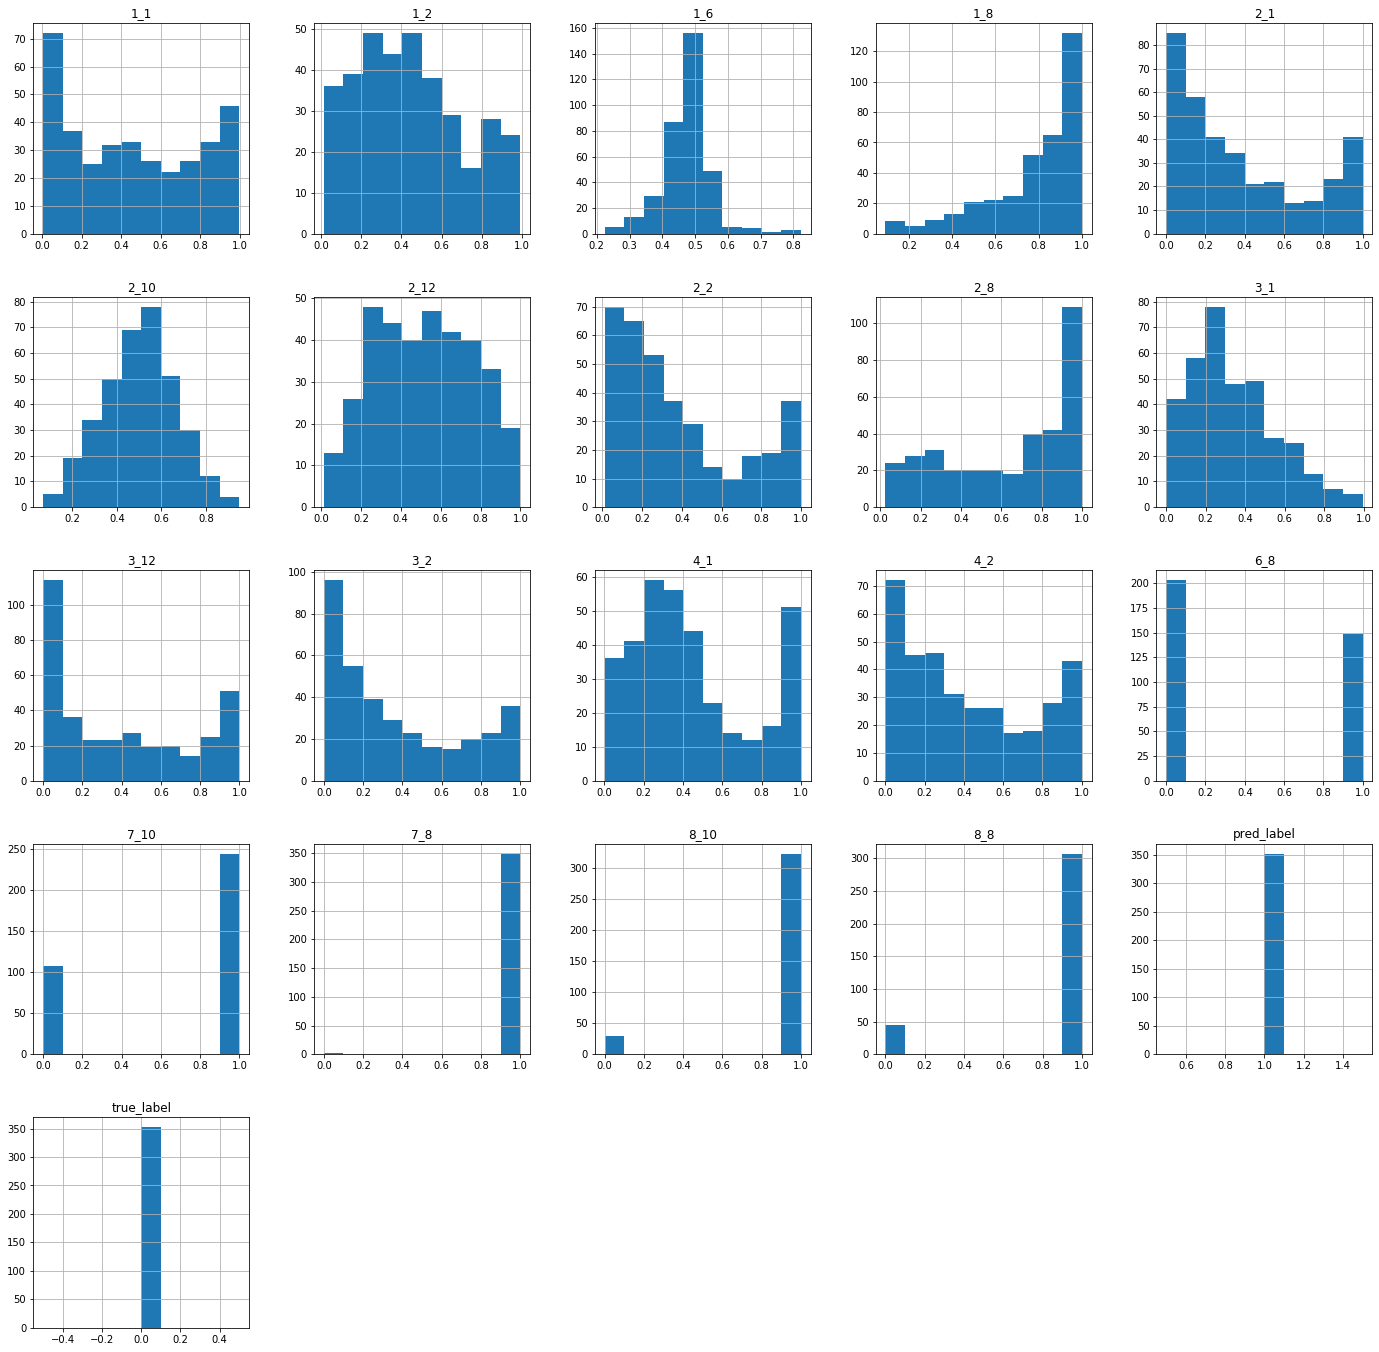

In [84]:
print_hist_models_predictions_fp(df_fp)

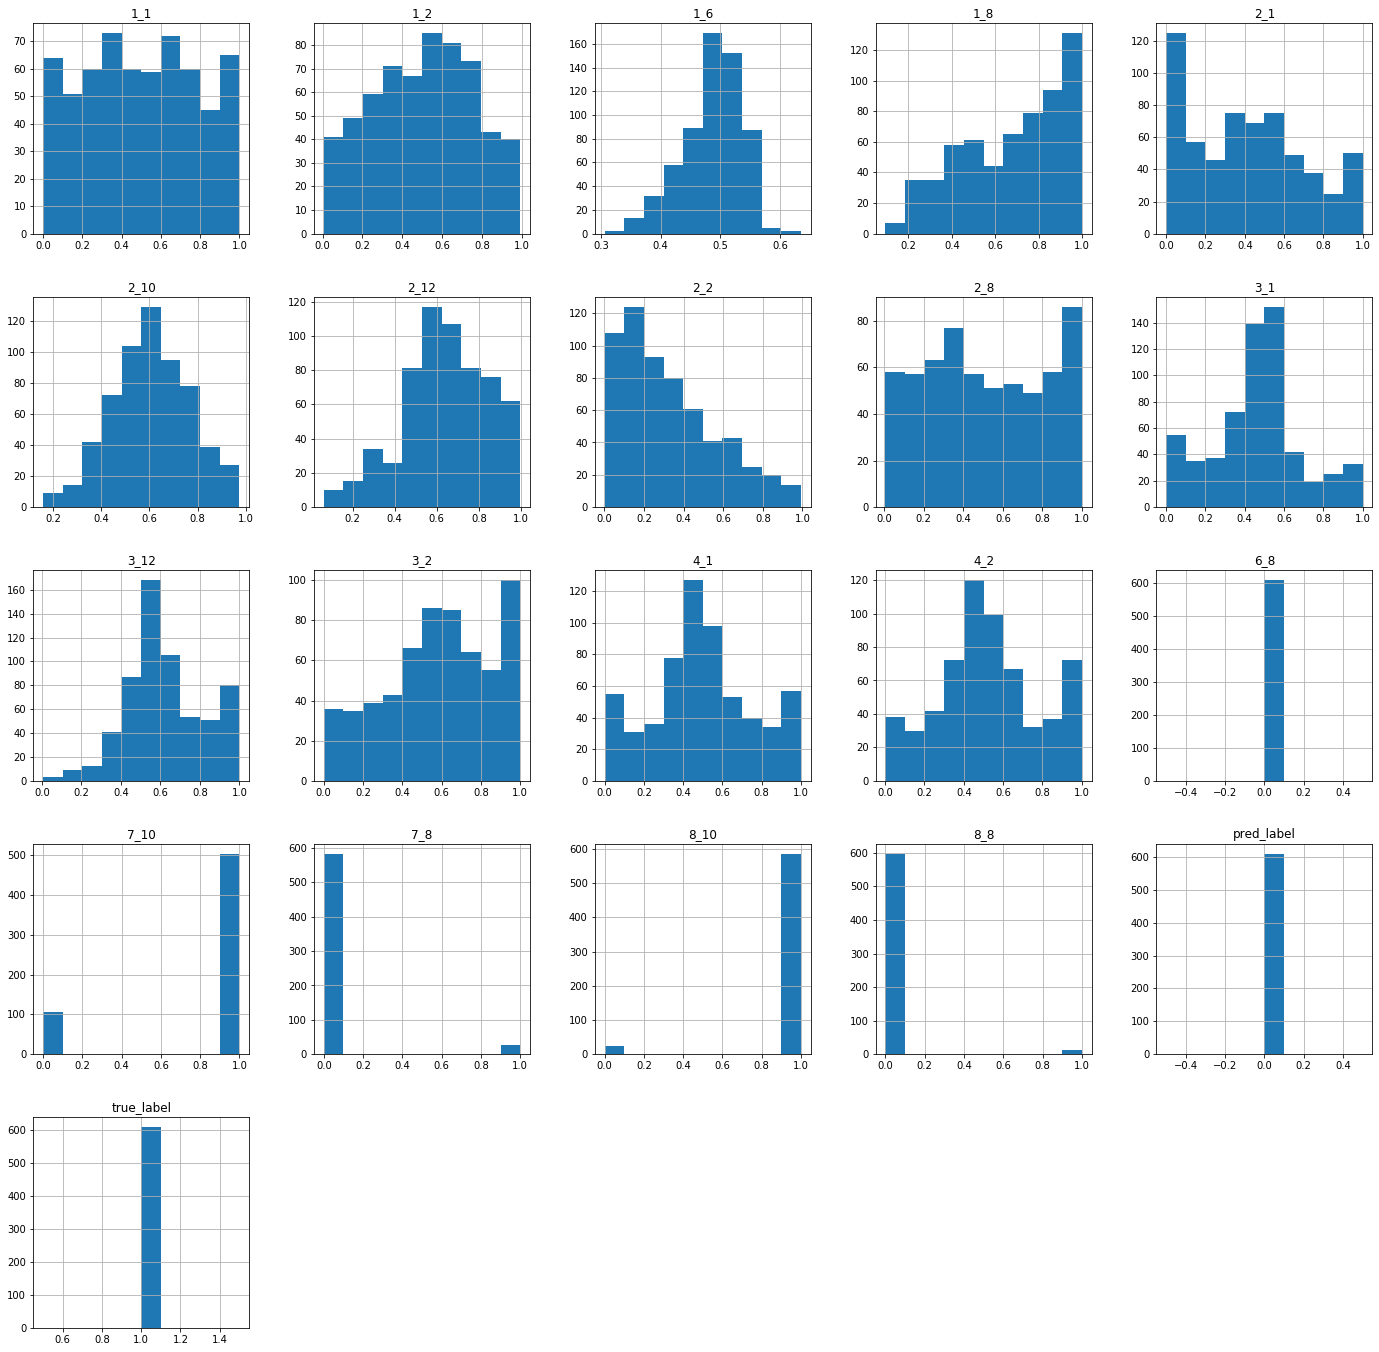

In [85]:
print_hist_models_predictions_fn(df_fn)

In [86]:
print(classification_report(df_res.true_label, df_res.pred_label))

              precision    recall  f1-score   support

           0       0.45      0.59      0.51       856
           1       0.60      0.47      0.53      1144

    accuracy                           0.52      2000
   macro avg       0.53      0.53      0.52      2000
weighted avg       0.54      0.52      0.52      2000



In [87]:
csv_path = "/Users/helemanc/PycharmProjects/ambient-intelligence/speech_emotion_recognition/ensemble_validation_results/avg_validation_2_threshold_0_5.csv"
df_res.to_csv(csv_path)